In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Directorios de los datasets
train_dir = "../datos/train"
val_dir = "../datos/val"
test_dir = "../datos/test"

In [3]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.2,  # Desplazamiento horizontal del 10%
    height_shift_range=0.2,  # Desplazamiento vertical del 10%
    shear_range=0.3,  # Transformación de cizallamiento del 10%
    zoom_range=0.3,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    brightness_range=[0.05, 1.5],  # Ajuste de brillo entre 0.1 y 1.0
    channel_shift_range=50.0  # Cambios agresivos en canales de color
)

 # Evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.


Found 2000 images belonging to 4 classes.


Found 800 images belonging to 4 classes.


In [4]:
# Cargar modelo preentrenado ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelamos las capas del modelo base

In [5]:
# Construcción del modelo
x = base_model.layers[-117].output #Equivalent to two (2) CORE block deduction.

# Capa convolucional
x = Conv2D(filters=192, kernel_size=6, strides=1, padding='valid',
           activation='selu', kernel_initializer='lecun_normal')(x)

# Capa de Average Pooling 
x = AveragePooling2D(pool_size=3, strides=3, padding='valid')(x)

# Global Average Pooling para reducir dimensiones antes de la capa densa
x = GlobalAveragePooling2D()(x)

# Capa fully connected
x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  # 512 neuronas

# Dropout ajustado 
x = AlphaDropout(0.2)(x)  # Reducimos sobreajuste apagando el 20% de las neuronas

# Capa de salida con 4 clases y activación softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=base_model.input, outputs=outputs)

In [6]:
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               


                                )]                                                                


 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                


 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              


                                )                                                                 


 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_conv[0][0]']             


                                )                                                                 


 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              


 conv2_block1_preact_bn (BatchN  (None, 56, 56, 64)  256         ['pool1_pool[0][0]']             


 ormalization)                                                                                    


 conv2_block1_preact_relu (Acti  (None, 56, 56, 64)  0           ['conv2_block1_preact_bn[0][0]'] 


 vation)                                                                                          


 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4096        ['conv2_block1_preact_relu[0][0]'


                                                                 ]                                


 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    


 ization)                                                                                         


 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      


 n)                                                                                               


 conv2_block1_2_pad (ZeroPaddin  (None, 58, 58, 64)  0           ['conv2_block1_1_relu[0][0]']    


 g2D)                                                                                             


 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36864       ['conv2_block1_2_pad[0][0]']     


 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    


 ization)                                                                                         


 conv2_block1_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_2_bn[0][0]']      


 n)                                                                                               


 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_preact_relu[0][0]'


                                                                 ]                                


 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    


 conv2_block1_out (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_conv[0][0]',    


                                                                  'conv2_block1_3_conv[0][0]']    


 conv2_block2_preact_bn (BatchN  (None, 56, 56, 256)  1024       ['conv2_block1_out[0][0]']       


 ormalization)                                                                                    


 conv2_block2_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block2_preact_bn[0][0]'] 


 vation)                                                                                          


 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block2_preact_relu[0][0]'


                                                                 ]                                


 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    


 ization)                                                                                         


 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      


 n)                                                                                               


 conv2_block2_2_pad (ZeroPaddin  (None, 58, 58, 64)  0           ['conv2_block2_1_relu[0][0]']    


 g2D)                                                                                             


 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36864       ['conv2_block2_2_pad[0][0]']     


 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    


 ization)                                                                                         


 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      


 n)                                                                                               


 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    


 conv2_block2_out (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       


                                                                  'conv2_block2_3_conv[0][0]']    


 conv2_block3_preact_bn (BatchN  (None, 56, 56, 256)  1024       ['conv2_block2_out[0][0]']       


 ormalization)                                                                                    


 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 


 vation)                                                                                          


 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'


                                                                 ]                                


 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    


 ization)                                                                                         


 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      


 n)                                                                                               


 conv2_block3_2_pad (ZeroPaddin  (None, 58, 58, 64)  0           ['conv2_block3_1_relu[0][0]']    


 g2D)                                                                                             


 conv2_block3_2_conv (Conv2D)   (None, 28, 28, 64)   36864       ['conv2_block3_2_pad[0][0]']     


 conv2_block3_2_bn (BatchNormal  (None, 28, 28, 64)  256         ['conv2_block3_2_conv[0][0]']    


 ization)                                                                                         


 conv2_block3_2_relu (Activatio  (None, 28, 28, 64)  0           ['conv2_block3_2_bn[0][0]']      


 n)                                                                                               


 max_pooling2d (MaxPooling2D)   (None, 28, 28, 256)  0           ['conv2_block2_out[0][0]']       


 conv2_block3_3_conv (Conv2D)   (None, 28, 28, 256)  16640       ['conv2_block3_2_relu[0][0]']    


 conv2_block3_out (Add)         (None, 28, 28, 256)  0           ['max_pooling2d[0][0]',          


                                                                  'conv2_block3_3_conv[0][0]']    


 conv3_block1_preact_bn (BatchN  (None, 28, 28, 256)  1024       ['conv2_block3_out[0][0]']       


 ormalization)                                                                                    


 conv3_block1_preact_relu (Acti  (None, 28, 28, 256)  0          ['conv3_block1_preact_bn[0][0]'] 


 vation)                                                                                          


 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32768       ['conv3_block1_preact_relu[0][0]'


                                                                 ]                                


 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    


 ization)                                                                                         


 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      


 n)                                                                                               


 conv3_block1_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block1_1_relu[0][0]']    


 g2D)                                                                                             


 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block1_2_pad[0][0]']     


 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    


 ization)                                                                                         


 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      


 n)                                                                                               


 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv3_block1_preact_relu[0][0]'


                                                                 ]                                


 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    


 conv3_block1_out (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_conv[0][0]',    


                                                                  'conv3_block1_3_conv[0][0]']    


 conv3_block2_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block1_out[0][0]']       


 ormalization)                                                                                    


 conv3_block2_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block2_preact_bn[0][0]'] 


 vation)                                                                                          


 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block2_preact_relu[0][0]'


                                                                 ]                                


 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    


 ization)                                                                                         


 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      


 n)                                                                                               


 conv3_block2_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block2_1_relu[0][0]']    


 g2D)                                                                                             


 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     


 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    


 ization)                                                                                         


 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      


 n)                                                                                               


 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    


 conv3_block2_out (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       


                                                                  'conv3_block2_3_conv[0][0]']    


 conv3_block3_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block2_out[0][0]']       


 ormalization)                                                                                    


 conv3_block3_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block3_preact_bn[0][0]'] 


 vation)                                                                                          


 conv3_block3_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block3_preact_relu[0][0]'


                                                                 ]                                


 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    


 ization)                                                                                         


 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      


 n)                                                                                               


 conv3_block3_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block3_1_relu[0][0]']    


 g2D)                                                                                             


 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block3_2_pad[0][0]']     


 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    


 ization)                                                                                         


 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      


 n)                                                                                               


 conv3_block3_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block3_2_relu[0][0]']    


 conv3_block3_out (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       


                                                                  'conv3_block3_3_conv[0][0]']    


 conv2d (Conv2D)                (None, 23, 23, 192)  3539136     ['conv3_block3_out[0][0]']       


 average_pooling2d (AveragePool  (None, 7, 7, 192)   0           ['conv2d[0][0]']                 


 ing2D)                                                                                           


 global_average_pooling2d (Glob  (None, 192)         0           ['average_pooling2d[0][0]']      


 alAveragePooling2D)                                                                              


 dense (Dense)                  (None, 512)          98816       ['global_average_pooling2d[0][0]'


                                                                 ]                                


 alpha_dropout (AlphaDropout)   (None, 512)          0           ['dense[0][0]']                  


 dense_1 (Dense)                (None, 4)            2052        ['alpha_dropout[0][0]']          


Total params: 4,811,460


Trainable params: 3,640,004


Non-trainable params: 1,171,456


__________________________________________________________________________________________________


In [7]:
# Compilación del modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #con funcion de perdida porque es multiclase

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50v2_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # Reduce LR si no hay mejora en 2 épocas

In [9]:
# Entrenamiento del modelo
epochs = 500 # Puede detenerse antes si no mejora la validacion
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500



  1/400 [..............................] - ETA: 17:53 - loss: 2.0413 - accuracy: 0.1250


  3/400 [..............................] - ETA: 18s - loss: 1.5324 - accuracy: 0.3333  


  4/400 [..............................] - ETA: 23s - loss: 1.6800 - accuracy: 0.2812


  5/400 [..............................] - ETA: 24s - loss: 1.7720 - accuracy: 0.2500


  6/400 [..............................] - ETA: 25s - loss: 1.7193 - accuracy: 0.2292


  7/400 [..............................] - ETA: 26s - loss: 1.6736 - accuracy: 0.2321


  8/400 [..............................] - ETA: 27s - loss: 1.6880 - accuracy: 0.2344


  9/400 [..............................] - ETA: 29s - loss: 1.7115 - accuracy: 0.2361


 10/400 [..............................] - ETA: 28s - loss: 1.7363 - accuracy: 0.2250


 11/400 [..............................] - ETA: 29s - loss: 1.7204 - accuracy: 0.2386


 12/400 [..............................] - ETA: 29s - loss: 1.7619 - accuracy: 0.2396


 13/400 [..............................] - ETA: 29s - loss: 1.7590 - accuracy: 0.2404


 14/400 [>.............................] - ETA: 29s - loss: 1.8074 - accuracy: 0.2321


 15/400 [>.............................] - ETA: 29s - loss: 1.7813 - accuracy: 0.2333


 16/400 [>.............................] - ETA: 29s - loss: 1.7895 - accuracy: 0.2266


 17/400 [>.............................] - ETA: 29s - loss: 1.8240 - accuracy: 0.2206


 18/400 [>.............................] - ETA: 29s - loss: 1.7930 - accuracy: 0.2361


 19/400 [>.............................] - ETA: 29s - loss: 1.7857 - accuracy: 0.2500


 20/400 [>.............................] - ETA: 28s - loss: 1.8124 - accuracy: 0.2500


 21/400 [>.............................] - ETA: 28s - loss: 1.7980 - accuracy: 0.2500


 22/400 [>.............................] - ETA: 28s - loss: 1.8102 - accuracy: 0.2557


 23/400 [>.............................] - ETA: 29s - loss: 1.8271 - accuracy: 0.2609


 24/400 [>.............................] - ETA: 29s - loss: 1.8082 - accuracy: 0.2656


 25/400 [>.............................] - ETA: 29s - loss: 1.8006 - accuracy: 0.2700


 26/400 [>.............................] - ETA: 29s - loss: 1.7835 - accuracy: 0.2740


 27/400 [=>............................] - ETA: 29s - loss: 1.7735 - accuracy: 0.2731


 28/400 [=>............................] - ETA: 29s - loss: 1.7742 - accuracy: 0.2679


 29/400 [=>............................] - ETA: 28s - loss: 1.7563 - accuracy: 0.2716


 30/400 [=>............................] - ETA: 28s - loss: 1.7265 - accuracy: 0.2875


 31/400 [=>............................] - ETA: 28s - loss: 1.7169 - accuracy: 0.2903


 32/400 [=>............................] - ETA: 29s - loss: 1.7001 - accuracy: 0.2969


 33/400 [=>............................] - ETA: 29s - loss: 1.7014 - accuracy: 0.2955


 34/400 [=>............................] - ETA: 29s - loss: 1.7094 - accuracy: 0.2941


 35/400 [=>............................] - ETA: 28s - loss: 1.6940 - accuracy: 0.3036


 36/400 [=>............................] - ETA: 28s - loss: 1.6967 - accuracy: 0.3056


 37/400 [=>............................] - ETA: 28s - loss: 1.7317 - accuracy: 0.3007


 38/400 [=>............................] - ETA: 28s - loss: 1.7266 - accuracy: 0.3026


 39/400 [=>............................] - ETA: 28s - loss: 1.7282 - accuracy: 0.3045


 40/400 [==>...........................] - ETA: 28s - loss: 1.7212 - accuracy: 0.3031


 41/400 [==>...........................] - ETA: 28s - loss: 1.7254 - accuracy: 0.3049


 42/400 [==>...........................] - ETA: 28s - loss: 1.7357 - accuracy: 0.3036


 43/400 [==>...........................] - ETA: 28s - loss: 1.7297 - accuracy: 0.3052


 44/400 [==>...........................] - ETA: 28s - loss: 1.7232 - accuracy: 0.3097


 45/400 [==>...........................] - ETA: 28s - loss: 1.7042 - accuracy: 0.3167


 46/400 [==>...........................] - ETA: 28s - loss: 1.7104 - accuracy: 0.3152


 47/400 [==>...........................] - ETA: 28s - loss: 1.7215 - accuracy: 0.3138


 48/400 [==>...........................] - ETA: 28s - loss: 1.7204 - accuracy: 0.3099


 49/400 [==>...........................] - ETA: 28s - loss: 1.7265 - accuracy: 0.3061


 50/400 [==>...........................] - ETA: 28s - loss: 1.7217 - accuracy: 0.3050


 51/400 [==>...........................] - ETA: 28s - loss: 1.7198 - accuracy: 0.3015


 52/400 [==>...........................] - ETA: 28s - loss: 1.7121 - accuracy: 0.3053


 53/400 [==>...........................] - ETA: 27s - loss: 1.6997 - accuracy: 0.3090


 54/400 [===>..........................] - ETA: 27s - loss: 1.6981 - accuracy: 0.3125


 55/400 [===>..........................] - ETA: 27s - loss: 1.6970 - accuracy: 0.3114


 56/400 [===>..........................] - ETA: 27s - loss: 1.6862 - accuracy: 0.3147


 57/400 [===>..........................] - ETA: 27s - loss: 1.6810 - accuracy: 0.3180


 58/400 [===>..........................] - ETA: 27s - loss: 1.6700 - accuracy: 0.3190


 59/400 [===>..........................] - ETA: 27s - loss: 1.6580 - accuracy: 0.3220


 60/400 [===>..........................] - ETA: 27s - loss: 1.6464 - accuracy: 0.3250


 61/400 [===>..........................] - ETA: 27s - loss: 1.6419 - accuracy: 0.3258


 62/400 [===>..........................] - ETA: 27s - loss: 1.6293 - accuracy: 0.3306


 63/400 [===>..........................] - ETA: 27s - loss: 1.6302 - accuracy: 0.3294


 64/400 [===>..........................] - ETA: 27s - loss: 1.6242 - accuracy: 0.3301


 65/400 [===>..........................] - ETA: 27s - loss: 1.6159 - accuracy: 0.3327


 66/400 [===>..........................] - ETA: 27s - loss: 1.6148 - accuracy: 0.3333


 67/400 [====>.........................] - ETA: 27s - loss: 1.6070 - accuracy: 0.3396


 68/400 [====>.........................] - ETA: 27s - loss: 1.6120 - accuracy: 0.3401


 69/400 [====>.........................] - ETA: 26s - loss: 1.5976 - accuracy: 0.3460


 70/400 [====>.........................] - ETA: 26s - loss: 1.6067 - accuracy: 0.3446


 71/400 [====>.........................] - ETA: 26s - loss: 1.6062 - accuracy: 0.3451


 72/400 [====>.........................] - ETA: 26s - loss: 1.6020 - accuracy: 0.3472


 73/400 [====>.........................] - ETA: 26s - loss: 1.5976 - accuracy: 0.3493


 74/400 [====>.........................] - ETA: 26s - loss: 1.5898 - accuracy: 0.3514


 75/400 [====>.........................] - ETA: 26s - loss: 1.5896 - accuracy: 0.3500


 76/400 [====>.........................] - ETA: 26s - loss: 1.5850 - accuracy: 0.3520


 77/400 [====>.........................] - ETA: 26s - loss: 1.5816 - accuracy: 0.3539


 78/400 [====>.........................] - ETA: 26s - loss: 1.5736 - accuracy: 0.3590


 79/400 [====>.........................] - ETA: 26s - loss: 1.5813 - accuracy: 0.3560


 80/400 [=====>........................] - ETA: 26s - loss: 1.5806 - accuracy: 0.3578


 81/400 [=====>........................] - ETA: 25s - loss: 1.5778 - accuracy: 0.3580


 82/400 [=====>........................] - ETA: 25s - loss: 1.5708 - accuracy: 0.3567


 83/400 [=====>........................] - ETA: 25s - loss: 1.5643 - accuracy: 0.3599


 84/400 [=====>........................] - ETA: 25s - loss: 1.5583 - accuracy: 0.3646


 85/400 [=====>........................] - ETA: 25s - loss: 1.5479 - accuracy: 0.3706


 86/400 [=====>........................] - ETA: 25s - loss: 1.5408 - accuracy: 0.3721


 87/400 [=====>........................] - ETA: 25s - loss: 1.5390 - accuracy: 0.3736


 88/400 [=====>........................] - ETA: 25s - loss: 1.5381 - accuracy: 0.3750


 89/400 [=====>........................] - ETA: 25s - loss: 1.5352 - accuracy: 0.3764


 90/400 [=====>........................] - ETA: 25s - loss: 1.5430 - accuracy: 0.3750


 91/400 [=====>........................] - ETA: 25s - loss: 1.5369 - accuracy: 0.3777


 92/400 [=====>........................] - ETA: 25s - loss: 1.5371 - accuracy: 0.3777


 93/400 [=====>........................] - ETA: 25s - loss: 1.5278 - accuracy: 0.3817


 94/400 [======>.......................] - ETA: 25s - loss: 1.5278 - accuracy: 0.3830


 95/400 [======>.......................] - ETA: 25s - loss: 1.5300 - accuracy: 0.3829


 96/400 [======>.......................] - ETA: 25s - loss: 1.5297 - accuracy: 0.3815


 97/400 [======>.......................] - ETA: 24s - loss: 1.5241 - accuracy: 0.3814


 98/400 [======>.......................] - ETA: 24s - loss: 1.5217 - accuracy: 0.3827


 99/400 [======>.......................] - ETA: 24s - loss: 1.5158 - accuracy: 0.3851


100/400 [======>.......................] - ETA: 24s - loss: 1.5099 - accuracy: 0.3875


101/400 [======>.......................] - ETA: 24s - loss: 1.5108 - accuracy: 0.3861


102/400 [======>.......................] - ETA: 24s - loss: 1.5085 - accuracy: 0.3860


103/400 [======>.......................] - ETA: 24s - loss: 1.4985 - accuracy: 0.3908


104/400 [======>.......................] - ETA: 24s - loss: 1.4961 - accuracy: 0.3906


105/400 [======>.......................] - ETA: 24s - loss: 1.4951 - accuracy: 0.3917


106/400 [======>.......................] - ETA: 24s - loss: 1.4889 - accuracy: 0.3950


107/400 [=======>......................] - ETA: 24s - loss: 1.4900 - accuracy: 0.3925


108/400 [=======>......................] - ETA: 24s - loss: 1.4864 - accuracy: 0.3935


109/400 [=======>......................] - ETA: 23s - loss: 1.4833 - accuracy: 0.3945


110/400 [=======>......................] - ETA: 23s - loss: 1.4779 - accuracy: 0.3955


111/400 [=======>......................] - ETA: 23s - loss: 1.4752 - accuracy: 0.3975


112/400 [=======>......................] - ETA: 23s - loss: 1.4750 - accuracy: 0.3973


113/400 [=======>......................] - ETA: 23s - loss: 1.4725 - accuracy: 0.3993


114/400 [=======>......................] - ETA: 23s - loss: 1.4722 - accuracy: 0.3991


115/400 [=======>......................] - ETA: 23s - loss: 1.4671 - accuracy: 0.4011


116/400 [=======>......................] - ETA: 23s - loss: 1.4660 - accuracy: 0.4009


117/400 [=======>......................] - ETA: 23s - loss: 1.4674 - accuracy: 0.4017


118/400 [=======>......................] - ETA: 23s - loss: 1.4676 - accuracy: 0.4015


119/400 [=======>......................] - ETA: 23s - loss: 1.4598 - accuracy: 0.4055


120/400 [========>.....................] - ETA: 23s - loss: 1.4574 - accuracy: 0.4062


121/400 [========>.....................] - ETA: 22s - loss: 1.4557 - accuracy: 0.4060


122/400 [========>.....................] - ETA: 22s - loss: 1.4527 - accuracy: 0.4068


123/400 [========>.....................] - ETA: 22s - loss: 1.4528 - accuracy: 0.4055


124/400 [========>.....................] - ETA: 22s - loss: 1.4486 - accuracy: 0.4062


125/400 [========>.....................] - ETA: 22s - loss: 1.4466 - accuracy: 0.4060


126/400 [========>.....................] - ETA: 22s - loss: 1.4419 - accuracy: 0.4077


127/400 [========>.....................] - ETA: 22s - loss: 1.4389 - accuracy: 0.4104


128/400 [========>.....................] - ETA: 22s - loss: 1.4416 - accuracy: 0.4092


129/400 [========>.....................] - ETA: 22s - loss: 1.4446 - accuracy: 0.4099


130/400 [========>.....................] - ETA: 22s - loss: 1.4415 - accuracy: 0.4106


131/400 [========>.....................] - ETA: 22s - loss: 1.4379 - accuracy: 0.4122


132/400 [========>.....................] - ETA: 22s - loss: 1.4388 - accuracy: 0.4119


133/400 [========>.....................] - ETA: 22s - loss: 1.4366 - accuracy: 0.4145


134/400 [=========>....................] - ETA: 21s - loss: 1.4363 - accuracy: 0.4142


135/400 [=========>....................] - ETA: 21s - loss: 1.4353 - accuracy: 0.4139


136/400 [=========>....................] - ETA: 21s - loss: 1.4306 - accuracy: 0.4164


137/400 [=========>....................] - ETA: 21s - loss: 1.4311 - accuracy: 0.4161


138/400 [=========>....................] - ETA: 21s - loss: 1.4240 - accuracy: 0.4203


139/400 [=========>....................] - ETA: 21s - loss: 1.4205 - accuracy: 0.4227


140/400 [=========>....................] - ETA: 21s - loss: 1.4215 - accuracy: 0.4223


141/400 [=========>....................] - ETA: 21s - loss: 1.4167 - accuracy: 0.4229


142/400 [=========>....................] - ETA: 21s - loss: 1.4115 - accuracy: 0.4243


143/400 [=========>....................] - ETA: 21s - loss: 1.4099 - accuracy: 0.4231


144/400 [=========>....................] - ETA: 21s - loss: 1.4094 - accuracy: 0.4219


145/400 [=========>....................] - ETA: 21s - loss: 1.4077 - accuracy: 0.4224


146/400 [=========>....................] - ETA: 21s - loss: 1.4063 - accuracy: 0.4229


147/400 [==========>...................] - ETA: 20s - loss: 1.4055 - accuracy: 0.4235


148/400 [==========>...................] - ETA: 20s - loss: 1.4009 - accuracy: 0.4248


149/400 [==========>...................] - ETA: 20s - loss: 1.4003 - accuracy: 0.4253


150/400 [==========>...................] - ETA: 20s - loss: 1.3971 - accuracy: 0.4258


151/400 [==========>...................] - ETA: 20s - loss: 1.3973 - accuracy: 0.4263


152/400 [==========>...................] - ETA: 20s - loss: 1.3970 - accuracy: 0.4260


153/400 [==========>...................] - ETA: 20s - loss: 1.3955 - accuracy: 0.4273


154/400 [==========>...................] - ETA: 20s - loss: 1.3965 - accuracy: 0.4261


155/400 [==========>...................] - ETA: 20s - loss: 1.3929 - accuracy: 0.4274


156/400 [==========>...................] - ETA: 20s - loss: 1.3920 - accuracy: 0.4279


157/400 [==========>...................] - ETA: 20s - loss: 1.3892 - accuracy: 0.4275


158/400 [==========>...................] - ETA: 20s - loss: 1.3890 - accuracy: 0.4256


159/400 [==========>...................] - ETA: 20s - loss: 1.3859 - accuracy: 0.4269


160/400 [===========>..................] - ETA: 19s - loss: 1.3840 - accuracy: 0.4273


161/400 [===========>..................] - ETA: 19s - loss: 1.3811 - accuracy: 0.4286


162/400 [===========>..................] - ETA: 19s - loss: 1.3761 - accuracy: 0.4306


163/400 [===========>..................] - ETA: 19s - loss: 1.3782 - accuracy: 0.4302


164/400 [===========>..................] - ETA: 19s - loss: 1.3749 - accuracy: 0.4306


165/400 [===========>..................] - ETA: 19s - loss: 1.3708 - accuracy: 0.4326


166/400 [===========>..................] - ETA: 19s - loss: 1.3673 - accuracy: 0.4345


167/400 [===========>..................] - ETA: 19s - loss: 1.3654 - accuracy: 0.4349


168/400 [===========>..................] - ETA: 19s - loss: 1.3621 - accuracy: 0.4368


169/400 [===========>..................] - ETA: 19s - loss: 1.3607 - accuracy: 0.4386


170/400 [===========>..................] - ETA: 19s - loss: 1.3623 - accuracy: 0.4382


171/400 [===========>..................] - ETA: 19s - loss: 1.3594 - accuracy: 0.4386


172/400 [===========>..................] - ETA: 19s - loss: 1.3586 - accuracy: 0.4382


173/400 [===========>..................] - ETA: 18s - loss: 1.3557 - accuracy: 0.4400


174/400 [============>.................] - ETA: 18s - loss: 1.3586 - accuracy: 0.4397


175/400 [============>.................] - ETA: 18s - loss: 1.3541 - accuracy: 0.4421


176/400 [============>.................] - ETA: 18s - loss: 1.3573 - accuracy: 0.4403


177/400 [============>.................] - ETA: 18s - loss: 1.3560 - accuracy: 0.4386


178/400 [============>.................] - ETA: 18s - loss: 1.3521 - accuracy: 0.4403


179/400 [============>.................] - ETA: 18s - loss: 1.3528 - accuracy: 0.4399


180/400 [============>.................] - ETA: 18s - loss: 1.3546 - accuracy: 0.4396


181/400 [============>.................] - ETA: 18s - loss: 1.3567 - accuracy: 0.4385


182/400 [============>.................] - ETA: 18s - loss: 1.3557 - accuracy: 0.4396


183/400 [============>.................] - ETA: 18s - loss: 1.3543 - accuracy: 0.4392


184/400 [============>.................] - ETA: 18s - loss: 1.3517 - accuracy: 0.4409


185/400 [============>.................] - ETA: 17s - loss: 1.3502 - accuracy: 0.4405


186/400 [============>.................] - ETA: 17s - loss: 1.3497 - accuracy: 0.4402


187/400 [=============>................] - ETA: 17s - loss: 1.3499 - accuracy: 0.4405


188/400 [=============>................] - ETA: 17s - loss: 1.3495 - accuracy: 0.4402


189/400 [=============>................] - ETA: 17s - loss: 1.3482 - accuracy: 0.4398


190/400 [=============>................] - ETA: 17s - loss: 1.3472 - accuracy: 0.4395


191/400 [=============>................] - ETA: 17s - loss: 1.3447 - accuracy: 0.4418


192/400 [=============>................] - ETA: 17s - loss: 1.3433 - accuracy: 0.4421


193/400 [=============>................] - ETA: 17s - loss: 1.3436 - accuracy: 0.4424


194/400 [=============>................] - ETA: 17s - loss: 1.3413 - accuracy: 0.4427


195/400 [=============>................] - ETA: 17s - loss: 1.3410 - accuracy: 0.4417


196/400 [=============>................] - ETA: 17s - loss: 1.3413 - accuracy: 0.4407


197/400 [=============>................] - ETA: 16s - loss: 1.3375 - accuracy: 0.4429


198/400 [=============>................] - ETA: 16s - loss: 1.3364 - accuracy: 0.4432


199/400 [=============>................] - ETA: 16s - loss: 1.3348 - accuracy: 0.4447


200/400 [==============>...............] - ETA: 16s - loss: 1.3367 - accuracy: 0.4444


201/400 [==============>...............] - ETA: 16s - loss: 1.3337 - accuracy: 0.4459


202/400 [==============>...............] - ETA: 16s - loss: 1.3317 - accuracy: 0.4474


203/400 [==============>...............] - ETA: 16s - loss: 1.3306 - accuracy: 0.4483


204/400 [==============>...............] - ETA: 16s - loss: 1.3289 - accuracy: 0.4491


205/400 [==============>...............] - ETA: 16s - loss: 1.3262 - accuracy: 0.4494


206/400 [==============>...............] - ETA: 16s - loss: 1.3245 - accuracy: 0.4502


207/400 [==============>...............] - ETA: 16s - loss: 1.3209 - accuracy: 0.4511


208/400 [==============>...............] - ETA: 16s - loss: 1.3199 - accuracy: 0.4513


209/400 [==============>...............] - ETA: 15s - loss: 1.3183 - accuracy: 0.4516


210/400 [==============>...............] - ETA: 15s - loss: 1.3168 - accuracy: 0.4518


211/400 [==============>...............] - ETA: 15s - loss: 1.3141 - accuracy: 0.4532


212/400 [==============>...............] - ETA: 15s - loss: 1.3154 - accuracy: 0.4534


213/400 [==============>...............] - ETA: 15s - loss: 1.3132 - accuracy: 0.4536


214/400 [===============>..............] - ETA: 15s - loss: 1.3140 - accuracy: 0.4533


215/400 [===============>..............] - ETA: 15s - loss: 1.3124 - accuracy: 0.4535


216/400 [===============>..............] - ETA: 15s - loss: 1.3112 - accuracy: 0.4537


217/400 [===============>..............] - ETA: 15s - loss: 1.3096 - accuracy: 0.4539


218/400 [===============>..............] - ETA: 15s - loss: 1.3109 - accuracy: 0.4536


219/400 [===============>..............] - ETA: 15s - loss: 1.3095 - accuracy: 0.4543


220/400 [===============>..............] - ETA: 15s - loss: 1.3063 - accuracy: 0.4557


221/400 [===============>..............] - ETA: 15s - loss: 1.3044 - accuracy: 0.4570


222/400 [===============>..............] - ETA: 14s - loss: 1.3020 - accuracy: 0.4578


223/400 [===============>..............] - ETA: 14s - loss: 1.3006 - accuracy: 0.4585


224/400 [===============>..............] - ETA: 14s - loss: 1.2991 - accuracy: 0.4587


225/400 [===============>..............] - ETA: 14s - loss: 1.2972 - accuracy: 0.4589


226/400 [===============>..............] - ETA: 14s - loss: 1.2938 - accuracy: 0.4607


227/400 [================>.............] - ETA: 14s - loss: 1.2935 - accuracy: 0.4609


228/400 [================>.............] - ETA: 14s - loss: 1.2930 - accuracy: 0.4616


229/400 [================>.............] - ETA: 14s - loss: 1.2911 - accuracy: 0.4629


230/400 [================>.............] - ETA: 14s - loss: 1.2921 - accuracy: 0.4630


231/400 [================>.............] - ETA: 14s - loss: 1.2883 - accuracy: 0.4654


232/400 [================>.............] - ETA: 14s - loss: 1.2870 - accuracy: 0.4661


233/400 [================>.............] - ETA: 14s - loss: 1.2851 - accuracy: 0.4667


234/400 [================>.............] - ETA: 14s - loss: 1.2818 - accuracy: 0.4679


235/400 [================>.............] - ETA: 14s - loss: 1.2787 - accuracy: 0.4691


236/400 [================>.............] - ETA: 13s - loss: 1.2759 - accuracy: 0.4709


237/400 [================>.............] - ETA: 13s - loss: 1.2725 - accuracy: 0.4731


238/400 [================>.............] - ETA: 13s - loss: 1.2706 - accuracy: 0.4737


239/400 [================>.............] - ETA: 13s - loss: 1.2677 - accuracy: 0.4754


240/400 [=================>............] - ETA: 13s - loss: 1.2656 - accuracy: 0.4760


241/400 [=================>............] - ETA: 13s - loss: 1.2636 - accuracy: 0.4772


242/400 [=================>............] - ETA: 13s - loss: 1.2616 - accuracy: 0.4778


243/400 [=================>............] - ETA: 13s - loss: 1.2620 - accuracy: 0.4784


244/400 [=================>............] - ETA: 13s - loss: 1.2623 - accuracy: 0.4775


245/400 [=================>............] - ETA: 13s - loss: 1.2596 - accuracy: 0.4786


246/400 [=================>............] - ETA: 13s - loss: 1.2597 - accuracy: 0.4787


247/400 [=================>............] - ETA: 13s - loss: 1.2593 - accuracy: 0.4787


248/400 [=================>............] - ETA: 12s - loss: 1.2563 - accuracy: 0.4803


249/400 [=================>............] - ETA: 12s - loss: 1.2551 - accuracy: 0.4799


250/400 [=================>............] - ETA: 12s - loss: 1.2555 - accuracy: 0.4795


251/400 [=================>............] - ETA: 12s - loss: 1.2553 - accuracy: 0.4791


252/400 [=================>............] - ETA: 12s - loss: 1.2555 - accuracy: 0.4787


253/400 [=================>............] - ETA: 12s - loss: 1.2561 - accuracy: 0.4778


254/400 [==================>...........] - ETA: 12s - loss: 1.2540 - accuracy: 0.4783


255/400 [==================>...........] - ETA: 12s - loss: 1.2512 - accuracy: 0.4794


256/400 [==================>...........] - ETA: 12s - loss: 1.2501 - accuracy: 0.4790


257/400 [==================>...........] - ETA: 12s - loss: 1.2470 - accuracy: 0.4805


258/400 [==================>...........] - ETA: 12s - loss: 1.2450 - accuracy: 0.4811


259/400 [==================>...........] - ETA: 12s - loss: 1.2430 - accuracy: 0.4821


260/400 [==================>...........] - ETA: 11s - loss: 1.2418 - accuracy: 0.4822


261/400 [==================>...........] - ETA: 11s - loss: 1.2385 - accuracy: 0.4837


262/400 [==================>...........] - ETA: 11s - loss: 1.2375 - accuracy: 0.4847


263/400 [==================>...........] - ETA: 11s - loss: 1.2375 - accuracy: 0.4853


264/400 [==================>...........] - ETA: 11s - loss: 1.2367 - accuracy: 0.4858


265/400 [==================>...........] - ETA: 11s - loss: 1.2355 - accuracy: 0.4863


266/400 [==================>...........] - ETA: 11s - loss: 1.2356 - accuracy: 0.4864


267/400 [===================>..........] - ETA: 11s - loss: 1.2338 - accuracy: 0.4869


268/400 [===================>..........] - ETA: 11s - loss: 1.2320 - accuracy: 0.4874


269/400 [===================>..........] - ETA: 11s - loss: 1.2313 - accuracy: 0.4879


270/400 [===================>..........] - ETA: 11s - loss: 1.2296 - accuracy: 0.4884


271/400 [===================>..........] - ETA: 11s - loss: 1.2268 - accuracy: 0.4894


272/400 [===================>..........] - ETA: 10s - loss: 1.2268 - accuracy: 0.4894


273/400 [===================>..........] - ETA: 10s - loss: 1.2272 - accuracy: 0.4890


274/400 [===================>..........] - ETA: 10s - loss: 1.2241 - accuracy: 0.4904


275/400 [===================>..........] - ETA: 10s - loss: 1.2242 - accuracy: 0.4905


276/400 [===================>..........] - ETA: 10s - loss: 1.2205 - accuracy: 0.4923


277/400 [===================>..........] - ETA: 10s - loss: 1.2190 - accuracy: 0.4923


278/400 [===================>..........] - ETA: 10s - loss: 1.2203 - accuracy: 0.4919


279/400 [===================>..........] - ETA: 10s - loss: 1.2186 - accuracy: 0.4933


280/400 [====================>.........] - ETA: 10s - loss: 1.2182 - accuracy: 0.4933


281/400 [====================>.........] - ETA: 10s - loss: 1.2177 - accuracy: 0.4938


282/400 [====================>.........] - ETA: 10s - loss: 1.2164 - accuracy: 0.4947


283/400 [====================>.........] - ETA: 10s - loss: 1.2150 - accuracy: 0.4947


284/400 [====================>.........] - ETA: 9s - loss: 1.2141 - accuracy: 0.4943 


285/400 [====================>.........] - ETA: 9s - loss: 1.2120 - accuracy: 0.4952


286/400 [====================>.........] - ETA: 9s - loss: 1.2104 - accuracy: 0.4965


287/400 [====================>.........] - ETA: 9s - loss: 1.2130 - accuracy: 0.4961


288/400 [====================>.........] - ETA: 9s - loss: 1.2122 - accuracy: 0.4965


289/400 [====================>.........] - ETA: 9s - loss: 1.2106 - accuracy: 0.4974


290/400 [====================>.........] - ETA: 9s - loss: 1.2100 - accuracy: 0.4974


291/400 [====================>.........] - ETA: 9s - loss: 1.2083 - accuracy: 0.4983


292/400 [====================>.........] - ETA: 9s - loss: 1.2078 - accuracy: 0.4983


293/400 [====================>.........] - ETA: 9s - loss: 1.2057 - accuracy: 0.4996


294/400 [=====================>........] - ETA: 9s - loss: 1.2040 - accuracy: 0.5004


295/400 [=====================>........] - ETA: 8s - loss: 1.2024 - accuracy: 0.5008


296/400 [=====================>........] - ETA: 8s - loss: 1.2013 - accuracy: 0.5008


297/400 [=====================>........] - ETA: 8s - loss: 1.2003 - accuracy: 0.5008


298/400 [=====================>........] - ETA: 8s - loss: 1.1989 - accuracy: 0.5013


299/400 [=====================>........] - ETA: 8s - loss: 1.1968 - accuracy: 0.5021


300/400 [=====================>........] - ETA: 8s - loss: 1.1963 - accuracy: 0.5021


301/400 [=====================>........] - ETA: 8s - loss: 1.1970 - accuracy: 0.5021


302/400 [=====================>........] - ETA: 8s - loss: 1.1999 - accuracy: 0.5012


303/400 [=====================>........] - ETA: 8s - loss: 1.1980 - accuracy: 0.5025


304/400 [=====================>........] - ETA: 8s - loss: 1.1958 - accuracy: 0.5033


305/400 [=====================>........] - ETA: 8s - loss: 1.1939 - accuracy: 0.5045


306/400 [=====================>........] - ETA: 8s - loss: 1.1931 - accuracy: 0.5045


307/400 [======================>.......] - ETA: 7s - loss: 1.1916 - accuracy: 0.5045


308/400 [======================>.......] - ETA: 7s - loss: 1.1895 - accuracy: 0.5053


309/400 [======================>.......] - ETA: 7s - loss: 1.1886 - accuracy: 0.5053


310/400 [======================>.......] - ETA: 7s - loss: 1.1864 - accuracy: 0.5065


311/400 [======================>.......] - ETA: 7s - loss: 1.1843 - accuracy: 0.5068


312/400 [======================>.......] - ETA: 7s - loss: 1.1847 - accuracy: 0.5060


313/400 [======================>.......] - ETA: 7s - loss: 1.1825 - accuracy: 0.5068


314/400 [======================>.......] - ETA: 7s - loss: 1.1808 - accuracy: 0.5072


315/400 [======================>.......] - ETA: 7s - loss: 1.1782 - accuracy: 0.5083


316/400 [======================>.......] - ETA: 7s - loss: 1.1780 - accuracy: 0.5087


317/400 [======================>.......] - ETA: 7s - loss: 1.1766 - accuracy: 0.5095


318/400 [======================>.......] - ETA: 7s - loss: 1.1747 - accuracy: 0.5106


319/400 [======================>.......] - ETA: 6s - loss: 1.1745 - accuracy: 0.5106


320/400 [=======================>......] - ETA: 6s - loss: 1.1725 - accuracy: 0.5113


321/400 [=======================>......] - ETA: 6s - loss: 1.1715 - accuracy: 0.5117


322/400 [=======================>......] - ETA: 6s - loss: 1.1704 - accuracy: 0.5124


323/400 [=======================>......] - ETA: 6s - loss: 1.1677 - accuracy: 0.5139


324/400 [=======================>......] - ETA: 6s - loss: 1.1657 - accuracy: 0.5147


325/400 [=======================>......] - ETA: 6s - loss: 1.1646 - accuracy: 0.5146


326/400 [=======================>......] - ETA: 6s - loss: 1.1638 - accuracy: 0.5146


327/400 [=======================>......] - ETA: 6s - loss: 1.1621 - accuracy: 0.5153


328/400 [=======================>......] - ETA: 6s - loss: 1.1610 - accuracy: 0.5160


329/400 [=======================>......] - ETA: 6s - loss: 1.1601 - accuracy: 0.5163


330/400 [=======================>......] - ETA: 6s - loss: 1.1585 - accuracy: 0.5174


331/400 [=======================>......] - ETA: 5s - loss: 1.1574 - accuracy: 0.5181


332/400 [=======================>......] - ETA: 5s - loss: 1.1563 - accuracy: 0.5184


333/400 [=======================>......] - ETA: 5s - loss: 1.1561 - accuracy: 0.5188


334/400 [========================>.....] - ETA: 5s - loss: 1.1546 - accuracy: 0.5191


335/400 [========================>.....] - ETA: 5s - loss: 1.1532 - accuracy: 0.5194


336/400 [========================>.....] - ETA: 5s - loss: 1.1524 - accuracy: 0.5197


337/400 [========================>.....] - ETA: 5s - loss: 1.1513 - accuracy: 0.5208


338/400 [========================>.....] - ETA: 5s - loss: 1.1504 - accuracy: 0.5211


339/400 [========================>.....] - ETA: 5s - loss: 1.1483 - accuracy: 0.5218


340/400 [========================>.....] - ETA: 5s - loss: 1.1463 - accuracy: 0.5232


341/400 [========================>.....] - ETA: 5s - loss: 1.1458 - accuracy: 0.5238


342/400 [========================>.....] - ETA: 4s - loss: 1.1443 - accuracy: 0.5245


343/400 [========================>.....] - ETA: 4s - loss: 1.1442 - accuracy: 0.5248


344/400 [========================>.....] - ETA: 4s - loss: 1.1438 - accuracy: 0.5251


345/400 [========================>.....] - ETA: 4s - loss: 1.1414 - accuracy: 0.5264


346/400 [========================>.....] - ETA: 4s - loss: 1.1400 - accuracy: 0.5271


347/400 [=========================>....] - ETA: 4s - loss: 1.1401 - accuracy: 0.5270


348/400 [=========================>....] - ETA: 4s - loss: 1.1388 - accuracy: 0.5280


349/400 [=========================>....] - ETA: 4s - loss: 1.1378 - accuracy: 0.5287


350/400 [=========================>....] - ETA: 4s - loss: 1.1381 - accuracy: 0.5286


351/400 [=========================>....] - ETA: 4s - loss: 1.1383 - accuracy: 0.5281


352/400 [=========================>....] - ETA: 4s - loss: 1.1376 - accuracy: 0.5284


353/400 [=========================>....] - ETA: 4s - loss: 1.1373 - accuracy: 0.5283


354/400 [=========================>....] - ETA: 3s - loss: 1.1368 - accuracy: 0.5279


355/400 [=========================>....] - ETA: 3s - loss: 1.1349 - accuracy: 0.5289


356/400 [=========================>....] - ETA: 3s - loss: 1.1354 - accuracy: 0.5284


357/400 [=========================>....] - ETA: 3s - loss: 1.1347 - accuracy: 0.5284


358/400 [=========================>....] - ETA: 3s - loss: 1.1337 - accuracy: 0.5286


359/400 [=========================>....] - ETA: 3s - loss: 1.1329 - accuracy: 0.5289


360/400 [==========================>...] - ETA: 3s - loss: 1.1338 - accuracy: 0.5285


361/400 [==========================>...] - ETA: 3s - loss: 1.1338 - accuracy: 0.5284


362/400 [==========================>...] - ETA: 3s - loss: 1.1321 - accuracy: 0.5290


363/400 [==========================>...] - ETA: 3s - loss: 1.1305 - accuracy: 0.5296


364/400 [==========================>...] - ETA: 3s - loss: 1.1303 - accuracy: 0.5295


365/400 [==========================>...] - ETA: 3s - loss: 1.1284 - accuracy: 0.5305


366/400 [==========================>...] - ETA: 2s - loss: 1.1260 - accuracy: 0.5314


367/400 [==========================>...] - ETA: 2s - loss: 1.1244 - accuracy: 0.5324


368/400 [==========================>...] - ETA: 2s - loss: 1.1243 - accuracy: 0.5323


369/400 [==========================>...] - ETA: 2s - loss: 1.1243 - accuracy: 0.5315


370/400 [==========================>...] - ETA: 2s - loss: 1.1247 - accuracy: 0.5314


371/400 [==========================>...] - ETA: 2s - loss: 1.1244 - accuracy: 0.5313


372/400 [==========================>...] - ETA: 2s - loss: 1.1244 - accuracy: 0.5309


373/400 [==========================>...] - ETA: 2s - loss: 1.1237 - accuracy: 0.5315


374/400 [===========================>..] - ETA: 2s - loss: 1.1229 - accuracy: 0.5314


375/400 [===========================>..] - ETA: 2s - loss: 1.1222 - accuracy: 0.5317


376/400 [===========================>..] - ETA: 2s - loss: 1.1210 - accuracy: 0.5316


377/400 [===========================>..] - ETA: 1s - loss: 1.1196 - accuracy: 0.5322


378/400 [===========================>..] - ETA: 1s - loss: 1.1189 - accuracy: 0.5324


379/400 [===========================>..] - ETA: 1s - loss: 1.1184 - accuracy: 0.5323


380/400 [===========================>..] - ETA: 1s - loss: 1.1174 - accuracy: 0.5322


381/400 [===========================>..] - ETA: 1s - loss: 1.1170 - accuracy: 0.5325


382/400 [===========================>..] - ETA: 1s - loss: 1.1157 - accuracy: 0.5330


383/400 [===========================>..] - ETA: 1s - loss: 1.1145 - accuracy: 0.5336


384/400 [===========================>..] - ETA: 1s - loss: 1.1125 - accuracy: 0.5348


385/400 [===========================>..] - ETA: 1s - loss: 1.1129 - accuracy: 0.5338


386/400 [===========================>..] - ETA: 1s - loss: 1.1130 - accuracy: 0.5334


387/400 [============================>.] - ETA: 1s - loss: 1.1122 - accuracy: 0.5333


388/400 [============================>.] - ETA: 1s - loss: 1.1113 - accuracy: 0.5338


389/400 [============================>.] - ETA: 0s - loss: 1.1101 - accuracy: 0.5341


390/400 [============================>.] - ETA: 0s - loss: 1.1095 - accuracy: 0.5346


391/400 [============================>.] - ETA: 0s - loss: 1.1088 - accuracy: 0.5355


392/400 [============================>.] - ETA: 0s - loss: 1.1069 - accuracy: 0.5364


393/400 [============================>.] - ETA: 0s - loss: 1.1057 - accuracy: 0.5369


394/400 [============================>.] - ETA: 0s - loss: 1.1049 - accuracy: 0.5374


395/400 [============================>.] - ETA: 0s - loss: 1.1041 - accuracy: 0.5377


396/400 [============================>.] - ETA: 0s - loss: 1.1038 - accuracy: 0.5379


397/400 [============================>.] - ETA: 0s - loss: 1.1031 - accuracy: 0.5381


398/400 [============================>.] - ETA: 0s - loss: 1.1043 - accuracy: 0.5374


399/400 [============================>.] - ETA: 0s - loss: 1.1036 - accuracy: 0.5373


400/400 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.5372


400/400 [==============================] - 48s 113ms/step - loss: 1.1029 - accuracy: 0.5372 - val_loss: 1.0493 - val_accuracy: 0.5685 - lr: 1.0000e-05


Epoch 2/500



  1/400 [..............................] - ETA: 49s - loss: 0.7326 - accuracy: 0.6250


  2/400 [..............................] - ETA: 29s - loss: 0.9530 - accuracy: 0.6250


  3/400 [..............................] - ETA: 34s - loss: 1.0811 - accuracy: 0.5417


  4/400 [..............................] - ETA: 32s - loss: 1.0989 - accuracy: 0.5000


  5/400 [..............................] - ETA: 33s - loss: 0.9307 - accuracy: 0.6000


  6/400 [..............................] - ETA: 33s - loss: 0.8764 - accuracy: 0.5833


  7/400 [..............................] - ETA: 33s - loss: 0.8732 - accuracy: 0.6071


  8/400 [..............................] - ETA: 33s - loss: 0.8238 - accuracy: 0.6250


  9/400 [..............................] - ETA: 33s - loss: 0.8145 - accuracy: 0.6250


 10/400 [..............................] - ETA: 32s - loss: 0.8403 - accuracy: 0.6125


 11/400 [..............................] - ETA: 33s - loss: 0.7997 - accuracy: 0.6250


 12/400 [..............................] - ETA: 33s - loss: 0.7969 - accuracy: 0.6354


 13/400 [..............................] - ETA: 34s - loss: 0.8010 - accuracy: 0.6442


 14/400 [>.............................] - ETA: 33s - loss: 0.7953 - accuracy: 0.6518


 15/400 [>.............................] - ETA: 34s - loss: 0.7801 - accuracy: 0.6583


 16/400 [>.............................] - ETA: 34s - loss: 0.7827 - accuracy: 0.6641


 17/400 [>.............................] - ETA: 33s - loss: 0.7866 - accuracy: 0.6691


 18/400 [>.............................] - ETA: 34s - loss: 0.7803 - accuracy: 0.6667


 19/400 [>.............................] - ETA: 34s - loss: 0.7901 - accuracy: 0.6579


 20/400 [>.............................] - ETA: 34s - loss: 0.7988 - accuracy: 0.6625


 21/400 [>.............................] - ETA: 33s - loss: 0.7903 - accuracy: 0.6726


 22/400 [>.............................] - ETA: 33s - loss: 0.7930 - accuracy: 0.6705


 23/400 [>.............................] - ETA: 33s - loss: 0.7825 - accuracy: 0.6739


 24/400 [>.............................] - ETA: 33s - loss: 0.7884 - accuracy: 0.6719


 25/400 [>.............................] - ETA: 33s - loss: 0.7686 - accuracy: 0.6850


 26/400 [>.............................] - ETA: 33s - loss: 0.7827 - accuracy: 0.6731


 27/400 [=>............................] - ETA: 33s - loss: 0.8023 - accuracy: 0.6574


 28/400 [=>............................] - ETA: 33s - loss: 0.7994 - accuracy: 0.6607


 29/400 [=>............................] - ETA: 33s - loss: 0.8237 - accuracy: 0.6466


 30/400 [=>............................] - ETA: 33s - loss: 0.8209 - accuracy: 0.6458


 31/400 [=>............................] - ETA: 33s - loss: 0.8242 - accuracy: 0.6452


 32/400 [=>............................] - ETA: 33s - loss: 0.8158 - accuracy: 0.6484


 33/400 [=>............................] - ETA: 33s - loss: 0.8081 - accuracy: 0.6553


 34/400 [=>............................] - ETA: 33s - loss: 0.7962 - accuracy: 0.6618


 35/400 [=>............................] - ETA: 33s - loss: 0.7904 - accuracy: 0.6643


 36/400 [=>............................] - ETA: 33s - loss: 0.8097 - accuracy: 0.6597


 37/400 [=>............................] - ETA: 33s - loss: 0.8290 - accuracy: 0.6554


 38/400 [=>............................] - ETA: 32s - loss: 0.8314 - accuracy: 0.6513


 39/400 [=>............................] - ETA: 32s - loss: 0.8250 - accuracy: 0.6538


 40/400 [==>...........................] - ETA: 32s - loss: 0.8178 - accuracy: 0.6562


 41/400 [==>...........................] - ETA: 32s - loss: 0.8179 - accuracy: 0.6555


 42/400 [==>...........................] - ETA: 32s - loss: 0.8135 - accuracy: 0.6548


 43/400 [==>...........................] - ETA: 32s - loss: 0.8222 - accuracy: 0.6512


 44/400 [==>...........................] - ETA: 32s - loss: 0.8269 - accuracy: 0.6477


 45/400 [==>...........................] - ETA: 32s - loss: 0.8241 - accuracy: 0.6500


 46/400 [==>...........................] - ETA: 31s - loss: 0.8286 - accuracy: 0.6495


 47/400 [==>...........................] - ETA: 31s - loss: 0.8305 - accuracy: 0.6489


 48/400 [==>...........................] - ETA: 31s - loss: 0.8413 - accuracy: 0.6406


 49/400 [==>...........................] - ETA: 31s - loss: 0.8471 - accuracy: 0.6403


 50/400 [==>...........................] - ETA: 31s - loss: 0.8444 - accuracy: 0.6400


 51/400 [==>...........................] - ETA: 31s - loss: 0.8373 - accuracy: 0.6446


 52/400 [==>...........................] - ETA: 31s - loss: 0.8330 - accuracy: 0.6442


 53/400 [==>...........................] - ETA: 31s - loss: 0.8263 - accuracy: 0.6486


 54/400 [===>..........................] - ETA: 30s - loss: 0.8263 - accuracy: 0.6481


 55/400 [===>..........................] - ETA: 30s - loss: 0.8261 - accuracy: 0.6477


 56/400 [===>..........................] - ETA: 30s - loss: 0.8289 - accuracy: 0.6451


 57/400 [===>..........................] - ETA: 30s - loss: 0.8240 - accuracy: 0.6447


 58/400 [===>..........................] - ETA: 30s - loss: 0.8196 - accuracy: 0.6466


 59/400 [===>..........................] - ETA: 30s - loss: 0.8182 - accuracy: 0.6462


 60/400 [===>..........................] - ETA: 30s - loss: 0.8186 - accuracy: 0.6479


 61/400 [===>..........................] - ETA: 30s - loss: 0.8180 - accuracy: 0.6475


 62/400 [===>..........................] - ETA: 30s - loss: 0.8165 - accuracy: 0.6472


 63/400 [===>..........................] - ETA: 30s - loss: 0.8168 - accuracy: 0.6468


 64/400 [===>..........................] - ETA: 30s - loss: 0.8120 - accuracy: 0.6484


 65/400 [===>..........................] - ETA: 30s - loss: 0.8108 - accuracy: 0.6481


 66/400 [===>..........................] - ETA: 30s - loss: 0.8127 - accuracy: 0.6477


 67/400 [====>.........................] - ETA: 30s - loss: 0.8134 - accuracy: 0.6455


 68/400 [====>.........................] - ETA: 30s - loss: 0.8164 - accuracy: 0.6452


 69/400 [====>.........................] - ETA: 30s - loss: 0.8236 - accuracy: 0.6413


 70/400 [====>.........................] - ETA: 30s - loss: 0.8236 - accuracy: 0.6411


 71/400 [====>.........................] - ETA: 30s - loss: 0.8231 - accuracy: 0.6408


 72/400 [====>.........................] - ETA: 30s - loss: 0.8188 - accuracy: 0.6441


 73/400 [====>.........................] - ETA: 30s - loss: 0.8220 - accuracy: 0.6421


 74/400 [====>.........................] - ETA: 30s - loss: 0.8167 - accuracy: 0.6470


 75/400 [====>.........................] - ETA: 29s - loss: 0.8234 - accuracy: 0.6417


 76/400 [====>.........................] - ETA: 29s - loss: 0.8234 - accuracy: 0.6431


 77/400 [====>.........................] - ETA: 29s - loss: 0.8214 - accuracy: 0.6461


 78/400 [====>.........................] - ETA: 29s - loss: 0.8250 - accuracy: 0.6442


 79/400 [====>.........................] - ETA: 29s - loss: 0.8212 - accuracy: 0.6472


 80/400 [=====>........................] - ETA: 29s - loss: 0.8179 - accuracy: 0.6500


 81/400 [=====>........................] - ETA: 29s - loss: 0.8135 - accuracy: 0.6528


 82/400 [=====>........................] - ETA: 29s - loss: 0.8139 - accuracy: 0.6540


 83/400 [=====>........................] - ETA: 29s - loss: 0.8136 - accuracy: 0.6536


 84/400 [=====>........................] - ETA: 29s - loss: 0.8185 - accuracy: 0.6518


 85/400 [=====>........................] - ETA: 28s - loss: 0.8208 - accuracy: 0.6500


 86/400 [=====>........................] - ETA: 28s - loss: 0.8230 - accuracy: 0.6497


 87/400 [=====>........................] - ETA: 28s - loss: 0.8232 - accuracy: 0.6480


 88/400 [=====>........................] - ETA: 28s - loss: 0.8235 - accuracy: 0.6477


 89/400 [=====>........................] - ETA: 28s - loss: 0.8196 - accuracy: 0.6503


 90/400 [=====>........................] - ETA: 28s - loss: 0.8182 - accuracy: 0.6514


 91/400 [=====>........................] - ETA: 28s - loss: 0.8158 - accuracy: 0.6538


 92/400 [=====>........................] - ETA: 28s - loss: 0.8126 - accuracy: 0.6562


 93/400 [=====>........................] - ETA: 28s - loss: 0.8127 - accuracy: 0.6546


 94/400 [======>.......................] - ETA: 27s - loss: 0.8113 - accuracy: 0.6556


 95/400 [======>.......................] - ETA: 27s - loss: 0.8105 - accuracy: 0.6566


 96/400 [======>.......................] - ETA: 27s - loss: 0.8127 - accuracy: 0.6549


 97/400 [======>.......................] - ETA: 27s - loss: 0.8081 - accuracy: 0.6559


 98/400 [======>.......................] - ETA: 27s - loss: 0.8119 - accuracy: 0.6531


 99/400 [======>.......................] - ETA: 27s - loss: 0.8102 - accuracy: 0.6540


100/400 [======>.......................] - ETA: 27s - loss: 0.8100 - accuracy: 0.6538


101/400 [======>.......................] - ETA: 27s - loss: 0.8141 - accuracy: 0.6510


102/400 [======>.......................] - ETA: 27s - loss: 0.8160 - accuracy: 0.6483


103/400 [======>.......................] - ETA: 27s - loss: 0.8121 - accuracy: 0.6505


104/400 [======>.......................] - ETA: 26s - loss: 0.8169 - accuracy: 0.6502


105/400 [======>.......................] - ETA: 26s - loss: 0.8181 - accuracy: 0.6500


106/400 [======>.......................] - ETA: 26s - loss: 0.8181 - accuracy: 0.6486


107/400 [=======>......................] - ETA: 26s - loss: 0.8163 - accuracy: 0.6484


108/400 [=======>......................] - ETA: 26s - loss: 0.8151 - accuracy: 0.6505


109/400 [=======>......................] - ETA: 26s - loss: 0.8140 - accuracy: 0.6491


110/400 [=======>......................] - ETA: 26s - loss: 0.8158 - accuracy: 0.6477


111/400 [=======>......................] - ETA: 26s - loss: 0.8119 - accuracy: 0.6498


112/400 [=======>......................] - ETA: 26s - loss: 0.8168 - accuracy: 0.6451


113/400 [=======>......................] - ETA: 26s - loss: 0.8140 - accuracy: 0.6460


114/400 [=======>......................] - ETA: 26s - loss: 0.8130 - accuracy: 0.6469


115/400 [=======>......................] - ETA: 25s - loss: 0.8123 - accuracy: 0.6467


116/400 [=======>......................] - ETA: 25s - loss: 0.8164 - accuracy: 0.6476


117/400 [=======>......................] - ETA: 25s - loss: 0.8131 - accuracy: 0.6485


118/400 [=======>......................] - ETA: 25s - loss: 0.8117 - accuracy: 0.6494


119/400 [=======>......................] - ETA: 25s - loss: 0.8132 - accuracy: 0.6481


120/400 [========>.....................] - ETA: 25s - loss: 0.8211 - accuracy: 0.6458


121/400 [========>.....................] - ETA: 25s - loss: 0.8210 - accuracy: 0.6467


122/400 [========>.....................] - ETA: 25s - loss: 0.8208 - accuracy: 0.6475


123/400 [========>.....................] - ETA: 25s - loss: 0.8244 - accuracy: 0.6474


124/400 [========>.....................] - ETA: 25s - loss: 0.8254 - accuracy: 0.6472


125/400 [========>.....................] - ETA: 24s - loss: 0.8244 - accuracy: 0.6480


126/400 [========>.....................] - ETA: 24s - loss: 0.8273 - accuracy: 0.6458


127/400 [========>.....................] - ETA: 24s - loss: 0.8285 - accuracy: 0.6457


128/400 [========>.....................] - ETA: 24s - loss: 0.8284 - accuracy: 0.6445


129/400 [========>.....................] - ETA: 24s - loss: 0.8245 - accuracy: 0.6463


130/400 [========>.....................] - ETA: 24s - loss: 0.8244 - accuracy: 0.6471


131/400 [========>.....................] - ETA: 24s - loss: 0.8247 - accuracy: 0.6479


132/400 [========>.....................] - ETA: 24s - loss: 0.8247 - accuracy: 0.6477


133/400 [========>.....................] - ETA: 24s - loss: 0.8243 - accuracy: 0.6476


134/400 [=========>....................] - ETA: 24s - loss: 0.8247 - accuracy: 0.6483


135/400 [=========>....................] - ETA: 23s - loss: 0.8225 - accuracy: 0.6491


136/400 [=========>....................] - ETA: 23s - loss: 0.8198 - accuracy: 0.6489


137/400 [=========>....................] - ETA: 23s - loss: 0.8170 - accuracy: 0.6496


138/400 [=========>....................] - ETA: 23s - loss: 0.8163 - accuracy: 0.6504


139/400 [=========>....................] - ETA: 23s - loss: 0.8135 - accuracy: 0.6511


140/400 [=========>....................] - ETA: 23s - loss: 0.8114 - accuracy: 0.6527


141/400 [=========>....................] - ETA: 23s - loss: 0.8117 - accuracy: 0.6543


142/400 [=========>....................] - ETA: 23s - loss: 0.8192 - accuracy: 0.6523


143/400 [=========>....................] - ETA: 23s - loss: 0.8161 - accuracy: 0.6538


144/400 [=========>....................] - ETA: 22s - loss: 0.8146 - accuracy: 0.6545


145/400 [=========>....................] - ETA: 22s - loss: 0.8124 - accuracy: 0.6552


146/400 [=========>....................] - ETA: 22s - loss: 0.8110 - accuracy: 0.6550


147/400 [==========>...................] - ETA: 22s - loss: 0.8083 - accuracy: 0.6556


148/400 [==========>...................] - ETA: 22s - loss: 0.8070 - accuracy: 0.6562


149/400 [==========>...................] - ETA: 22s - loss: 0.8038 - accuracy: 0.6577


150/400 [==========>...................] - ETA: 22s - loss: 0.8050 - accuracy: 0.6575


151/400 [==========>...................] - ETA: 22s - loss: 0.8055 - accuracy: 0.6565


152/400 [==========>...................] - ETA: 22s - loss: 0.8048 - accuracy: 0.6571


153/400 [==========>...................] - ETA: 22s - loss: 0.8022 - accuracy: 0.6585


154/400 [==========>...................] - ETA: 22s - loss: 0.8013 - accuracy: 0.6583


155/400 [==========>...................] - ETA: 21s - loss: 0.7995 - accuracy: 0.6597


156/400 [==========>...................] - ETA: 21s - loss: 0.8035 - accuracy: 0.6579


157/400 [==========>...................] - ETA: 21s - loss: 0.8043 - accuracy: 0.6576


158/400 [==========>...................] - ETA: 21s - loss: 0.8031 - accuracy: 0.6574


159/400 [==========>...................] - ETA: 21s - loss: 0.8010 - accuracy: 0.6588


160/400 [===========>..................] - ETA: 21s - loss: 0.8008 - accuracy: 0.6586


161/400 [===========>..................] - ETA: 21s - loss: 0.7995 - accuracy: 0.6584


162/400 [===========>..................] - ETA: 21s - loss: 0.7997 - accuracy: 0.6582


163/400 [===========>..................] - ETA: 21s - loss: 0.8024 - accuracy: 0.6572


164/400 [===========>..................] - ETA: 21s - loss: 0.8057 - accuracy: 0.6562


165/400 [===========>..................] - ETA: 20s - loss: 0.8094 - accuracy: 0.6553


166/400 [===========>..................] - ETA: 20s - loss: 0.8092 - accuracy: 0.6551


167/400 [===========>..................] - ETA: 20s - loss: 0.8077 - accuracy: 0.6564


168/400 [===========>..................] - ETA: 20s - loss: 0.8083 - accuracy: 0.6570


169/400 [===========>..................] - ETA: 20s - loss: 0.8050 - accuracy: 0.6590


170/400 [===========>..................] - ETA: 20s - loss: 0.8024 - accuracy: 0.6603


171/400 [===========>..................] - ETA: 20s - loss: 0.8011 - accuracy: 0.6601


172/400 [===========>..................] - ETA: 20s - loss: 0.8023 - accuracy: 0.6592


173/400 [===========>..................] - ETA: 20s - loss: 0.8025 - accuracy: 0.6590


174/400 [============>.................] - ETA: 20s - loss: 0.8036 - accuracy: 0.6588


175/400 [============>.................] - ETA: 20s - loss: 0.8022 - accuracy: 0.6593


176/400 [============>.................] - ETA: 19s - loss: 0.8029 - accuracy: 0.6584


177/400 [============>.................] - ETA: 19s - loss: 0.8003 - accuracy: 0.6603


178/400 [============>.................] - ETA: 19s - loss: 0.7988 - accuracy: 0.6615


179/400 [============>.................] - ETA: 19s - loss: 0.7956 - accuracy: 0.6634


180/400 [============>.................] - ETA: 19s - loss: 0.7957 - accuracy: 0.6646


181/400 [============>.................] - ETA: 19s - loss: 0.7944 - accuracy: 0.6644


182/400 [============>.................] - ETA: 19s - loss: 0.7996 - accuracy: 0.6628


183/400 [============>.................] - ETA: 19s - loss: 0.7979 - accuracy: 0.6633


184/400 [============>.................] - ETA: 19s - loss: 0.7964 - accuracy: 0.6637


185/400 [============>.................] - ETA: 19s - loss: 0.7982 - accuracy: 0.6635


186/400 [============>.................] - ETA: 19s - loss: 0.7991 - accuracy: 0.6626


187/400 [=============>................] - ETA: 19s - loss: 0.8011 - accuracy: 0.6618


188/400 [=============>................] - ETA: 18s - loss: 0.8006 - accuracy: 0.6622


189/400 [=============>................] - ETA: 18s - loss: 0.8069 - accuracy: 0.6601


190/400 [=============>................] - ETA: 18s - loss: 0.8079 - accuracy: 0.6592


191/400 [=============>................] - ETA: 18s - loss: 0.8075 - accuracy: 0.6590


192/400 [=============>................] - ETA: 18s - loss: 0.8072 - accuracy: 0.6582


193/400 [=============>................] - ETA: 18s - loss: 0.8050 - accuracy: 0.6593


194/400 [=============>................] - ETA: 18s - loss: 0.8040 - accuracy: 0.6598


195/400 [=============>................] - ETA: 18s - loss: 0.8033 - accuracy: 0.6596


196/400 [=============>................] - ETA: 18s - loss: 0.8034 - accuracy: 0.6588


197/400 [=============>................] - ETA: 18s - loss: 0.8068 - accuracy: 0.6574


198/400 [=============>................] - ETA: 17s - loss: 0.8096 - accuracy: 0.6559


199/400 [=============>................] - ETA: 17s - loss: 0.8091 - accuracy: 0.6552


200/400 [==============>...............] - ETA: 17s - loss: 0.8080 - accuracy: 0.6556


201/400 [==============>...............] - ETA: 17s - loss: 0.8072 - accuracy: 0.6555


202/400 [==============>...............] - ETA: 17s - loss: 0.8067 - accuracy: 0.6559


203/400 [==============>...............] - ETA: 17s - loss: 0.8049 - accuracy: 0.6576


204/400 [==============>...............] - ETA: 17s - loss: 0.8043 - accuracy: 0.6581


205/400 [==============>...............] - ETA: 17s - loss: 0.8019 - accuracy: 0.6591


206/400 [==============>...............] - ETA: 17s - loss: 0.8049 - accuracy: 0.6572


207/400 [==============>...............] - ETA: 17s - loss: 0.8068 - accuracy: 0.6558


208/400 [==============>...............] - ETA: 16s - loss: 0.8049 - accuracy: 0.6569


209/400 [==============>...............] - ETA: 16s - loss: 0.8028 - accuracy: 0.6585


210/400 [==============>...............] - ETA: 16s - loss: 0.8030 - accuracy: 0.6589


211/400 [==============>...............] - ETA: 16s - loss: 0.8036 - accuracy: 0.6588


212/400 [==============>...............] - ETA: 16s - loss: 0.8020 - accuracy: 0.6592


213/400 [==============>...............] - ETA: 16s - loss: 0.8041 - accuracy: 0.6590


214/400 [===============>..............] - ETA: 16s - loss: 0.8035 - accuracy: 0.6589


215/400 [===============>..............] - ETA: 16s - loss: 0.8041 - accuracy: 0.6593


216/400 [===============>..............] - ETA: 16s - loss: 0.8035 - accuracy: 0.6591


217/400 [===============>..............] - ETA: 16s - loss: 0.8027 - accuracy: 0.6596


218/400 [===============>..............] - ETA: 16s - loss: 0.8018 - accuracy: 0.6600


219/400 [===============>..............] - ETA: 15s - loss: 0.8055 - accuracy: 0.6581


220/400 [===============>..............] - ETA: 15s - loss: 0.8038 - accuracy: 0.6580


221/400 [===============>..............] - ETA: 15s - loss: 0.8016 - accuracy: 0.6584


222/400 [===============>..............] - ETA: 15s - loss: 0.8011 - accuracy: 0.6588


223/400 [===============>..............] - ETA: 15s - loss: 0.7998 - accuracy: 0.6598


224/400 [===============>..............] - ETA: 15s - loss: 0.7999 - accuracy: 0.6596


225/400 [===============>..............] - ETA: 15s - loss: 0.7997 - accuracy: 0.6594


226/400 [===============>..............] - ETA: 15s - loss: 0.8015 - accuracy: 0.6593


227/400 [================>.............] - ETA: 15s - loss: 0.7998 - accuracy: 0.6608


228/400 [================>.............] - ETA: 15s - loss: 0.7993 - accuracy: 0.6612


229/400 [================>.............] - ETA: 15s - loss: 0.7984 - accuracy: 0.6616


230/400 [================>.............] - ETA: 14s - loss: 0.8002 - accuracy: 0.6609


231/400 [================>.............] - ETA: 14s - loss: 0.8007 - accuracy: 0.6607


232/400 [================>.............] - ETA: 14s - loss: 0.8029 - accuracy: 0.6600


233/400 [================>.............] - ETA: 14s - loss: 0.8018 - accuracy: 0.6599


234/400 [================>.............] - ETA: 14s - loss: 0.8040 - accuracy: 0.6592


235/400 [================>.............] - ETA: 14s - loss: 0.8037 - accuracy: 0.6596


236/400 [================>.............] - ETA: 14s - loss: 0.8026 - accuracy: 0.6600


237/400 [================>.............] - ETA: 14s - loss: 0.8016 - accuracy: 0.6603


238/400 [================>.............] - ETA: 14s - loss: 0.8015 - accuracy: 0.6602


239/400 [================>.............] - ETA: 14s - loss: 0.7996 - accuracy: 0.6611


240/400 [=================>............] - ETA: 14s - loss: 0.7996 - accuracy: 0.6604


241/400 [=================>............] - ETA: 13s - loss: 0.8004 - accuracy: 0.6603


242/400 [=================>............] - ETA: 13s - loss: 0.8004 - accuracy: 0.6601


243/400 [=================>............] - ETA: 13s - loss: 0.7988 - accuracy: 0.6605


244/400 [=================>............] - ETA: 13s - loss: 0.7986 - accuracy: 0.6609


245/400 [=================>............] - ETA: 13s - loss: 0.7983 - accuracy: 0.6607


246/400 [=================>............] - ETA: 13s - loss: 0.7971 - accuracy: 0.6611


247/400 [=================>............] - ETA: 13s - loss: 0.7955 - accuracy: 0.6619


248/400 [=================>............] - ETA: 13s - loss: 0.7987 - accuracy: 0.6618


249/400 [=================>............] - ETA: 13s - loss: 0.8013 - accuracy: 0.6611


250/400 [=================>............] - ETA: 13s - loss: 0.8018 - accuracy: 0.6610


251/400 [=================>............] - ETA: 13s - loss: 0.8020 - accuracy: 0.6614


252/400 [=================>............] - ETA: 12s - loss: 0.8006 - accuracy: 0.6622


253/400 [=================>............] - ETA: 12s - loss: 0.7996 - accuracy: 0.6621


254/400 [==================>...........] - ETA: 12s - loss: 0.8006 - accuracy: 0.6614


255/400 [==================>...........] - ETA: 12s - loss: 0.8002 - accuracy: 0.6608


256/400 [==================>...........] - ETA: 12s - loss: 0.8003 - accuracy: 0.6606


257/400 [==================>...........] - ETA: 12s - loss: 0.7994 - accuracy: 0.6615


258/400 [==================>...........] - ETA: 12s - loss: 0.8011 - accuracy: 0.6609


259/400 [==================>...........] - ETA: 12s - loss: 0.8053 - accuracy: 0.6593


260/400 [==================>...........] - ETA: 12s - loss: 0.8082 - accuracy: 0.6591


261/400 [==================>...........] - ETA: 12s - loss: 0.8079 - accuracy: 0.6585


262/400 [==================>...........] - ETA: 12s - loss: 0.8075 - accuracy: 0.6584


263/400 [==================>...........] - ETA: 11s - loss: 0.8085 - accuracy: 0.6583


264/400 [==================>...........] - ETA: 11s - loss: 0.8070 - accuracy: 0.6591


265/400 [==================>...........] - ETA: 11s - loss: 0.8069 - accuracy: 0.6594


266/400 [==================>...........] - ETA: 11s - loss: 0.8060 - accuracy: 0.6598


267/400 [===================>..........] - ETA: 11s - loss: 0.8040 - accuracy: 0.6606


268/400 [===================>..........] - ETA: 11s - loss: 0.8031 - accuracy: 0.6600


269/400 [===================>..........] - ETA: 11s - loss: 0.8024 - accuracy: 0.6599


270/400 [===================>..........] - ETA: 11s - loss: 0.8022 - accuracy: 0.6597


271/400 [===================>..........] - ETA: 11s - loss: 0.8005 - accuracy: 0.6605


272/400 [===================>..........] - ETA: 11s - loss: 0.7998 - accuracy: 0.6613


273/400 [===================>..........] - ETA: 11s - loss: 0.7999 - accuracy: 0.6612


274/400 [===================>..........] - ETA: 10s - loss: 0.8006 - accuracy: 0.6615


275/400 [===================>..........] - ETA: 10s - loss: 0.8003 - accuracy: 0.6614


276/400 [===================>..........] - ETA: 10s - loss: 0.8015 - accuracy: 0.6608


277/400 [===================>..........] - ETA: 10s - loss: 0.7999 - accuracy: 0.6620


278/400 [===================>..........] - ETA: 10s - loss: 0.8001 - accuracy: 0.6610


279/400 [===================>..........] - ETA: 10s - loss: 0.7992 - accuracy: 0.6613


280/400 [====================>.........] - ETA: 10s - loss: 0.7984 - accuracy: 0.6621


281/400 [====================>.........] - ETA: 10s - loss: 0.7962 - accuracy: 0.6633


282/400 [====================>.........] - ETA: 10s - loss: 0.7958 - accuracy: 0.6636


283/400 [====================>.........] - ETA: 10s - loss: 0.7952 - accuracy: 0.6634


284/400 [====================>.........] - ETA: 10s - loss: 0.7948 - accuracy: 0.6637


285/400 [====================>.........] - ETA: 10s - loss: 0.7925 - accuracy: 0.6649


286/400 [====================>.........] - ETA: 9s - loss: 0.7932 - accuracy: 0.6656 


287/400 [====================>.........] - ETA: 9s - loss: 0.7919 - accuracy: 0.6664


288/400 [====================>.........] - ETA: 9s - loss: 0.7913 - accuracy: 0.6667


289/400 [====================>.........] - ETA: 9s - loss: 0.7915 - accuracy: 0.6674


290/400 [====================>.........] - ETA: 9s - loss: 0.7899 - accuracy: 0.6681


291/400 [====================>.........] - ETA: 9s - loss: 0.7892 - accuracy: 0.6684


292/400 [====================>.........] - ETA: 9s - loss: 0.7928 - accuracy: 0.6670


293/400 [====================>.........] - ETA: 9s - loss: 0.7918 - accuracy: 0.6677


294/400 [=====================>........] - ETA: 9s - loss: 0.7932 - accuracy: 0.6671


295/400 [=====================>........] - ETA: 9s - loss: 0.7926 - accuracy: 0.6669


296/400 [=====================>........] - ETA: 9s - loss: 0.7927 - accuracy: 0.6668


297/400 [=====================>........] - ETA: 8s - loss: 0.7923 - accuracy: 0.6658


298/400 [=====================>........] - ETA: 8s - loss: 0.7931 - accuracy: 0.6661


299/400 [=====================>........] - ETA: 8s - loss: 0.7938 - accuracy: 0.6660


300/400 [=====================>........] - ETA: 8s - loss: 0.7928 - accuracy: 0.6671


301/400 [=====================>........] - ETA: 8s - loss: 0.7914 - accuracy: 0.6682


302/400 [=====================>........] - ETA: 8s - loss: 0.7904 - accuracy: 0.6685


303/400 [=====================>........] - ETA: 8s - loss: 0.7890 - accuracy: 0.6696


304/400 [=====================>........] - ETA: 8s - loss: 0.7870 - accuracy: 0.6706


305/400 [=====================>........] - ETA: 8s - loss: 0.7873 - accuracy: 0.6705


306/400 [=====================>........] - ETA: 8s - loss: 0.7876 - accuracy: 0.6699


307/400 [======================>.......] - ETA: 8s - loss: 0.7870 - accuracy: 0.6698


308/400 [======================>.......] - ETA: 7s - loss: 0.7877 - accuracy: 0.6696


309/400 [======================>.......] - ETA: 7s - loss: 0.7866 - accuracy: 0.6703


310/400 [======================>.......] - ETA: 7s - loss: 0.7889 - accuracy: 0.6698


311/400 [======================>.......] - ETA: 7s - loss: 0.7898 - accuracy: 0.6696


312/400 [======================>.......] - ETA: 7s - loss: 0.7897 - accuracy: 0.6699


313/400 [======================>.......] - ETA: 7s - loss: 0.7878 - accuracy: 0.6709


314/400 [======================>.......] - ETA: 7s - loss: 0.7879 - accuracy: 0.6712


315/400 [======================>.......] - ETA: 7s - loss: 0.7880 - accuracy: 0.6710


316/400 [======================>.......] - ETA: 7s - loss: 0.7878 - accuracy: 0.6705


317/400 [======================>.......] - ETA: 7s - loss: 0.7881 - accuracy: 0.6703


318/400 [======================>.......] - ETA: 7s - loss: 0.7885 - accuracy: 0.6698


319/400 [======================>.......] - ETA: 7s - loss: 0.7889 - accuracy: 0.6697


320/400 [=======================>......] - ETA: 6s - loss: 0.7889 - accuracy: 0.6695


321/400 [=======================>......] - ETA: 6s - loss: 0.7880 - accuracy: 0.6698


322/400 [=======================>......] - ETA: 6s - loss: 0.7872 - accuracy: 0.6696


323/400 [=======================>......] - ETA: 6s - loss: 0.7871 - accuracy: 0.6699


324/400 [=======================>......] - ETA: 6s - loss: 0.7865 - accuracy: 0.6698


325/400 [=======================>......] - ETA: 6s - loss: 0.7864 - accuracy: 0.6696


326/400 [=======================>......] - ETA: 6s - loss: 0.7858 - accuracy: 0.6699


327/400 [=======================>......] - ETA: 6s - loss: 0.7856 - accuracy: 0.6697


328/400 [=======================>......] - ETA: 6s - loss: 0.7844 - accuracy: 0.6704


329/400 [=======================>......] - ETA: 6s - loss: 0.7833 - accuracy: 0.6706


330/400 [=======================>......] - ETA: 6s - loss: 0.7826 - accuracy: 0.6712


331/400 [=======================>......] - ETA: 5s - loss: 0.7808 - accuracy: 0.6722


332/400 [=======================>......] - ETA: 5s - loss: 0.7808 - accuracy: 0.6717


333/400 [=======================>......] - ETA: 5s - loss: 0.7809 - accuracy: 0.6715


334/400 [========================>.....] - ETA: 5s - loss: 0.7793 - accuracy: 0.6722


335/400 [========================>.....] - ETA: 5s - loss: 0.7804 - accuracy: 0.6716


336/400 [========================>.....] - ETA: 5s - loss: 0.7793 - accuracy: 0.6726


337/400 [========================>.....] - ETA: 5s - loss: 0.7776 - accuracy: 0.6732


338/400 [========================>.....] - ETA: 5s - loss: 0.7771 - accuracy: 0.6731


339/400 [========================>.....] - ETA: 5s - loss: 0.7769 - accuracy: 0.6733


340/400 [========================>.....] - ETA: 5s - loss: 0.7775 - accuracy: 0.6728


341/400 [========================>.....] - ETA: 5s - loss: 0.7769 - accuracy: 0.6730


342/400 [========================>.....] - ETA: 5s - loss: 0.7775 - accuracy: 0.6725


343/400 [========================>.....] - ETA: 4s - loss: 0.7771 - accuracy: 0.6724


344/400 [========================>.....] - ETA: 4s - loss: 0.7761 - accuracy: 0.6726


345/400 [========================>.....] - ETA: 4s - loss: 0.7748 - accuracy: 0.6736


346/400 [========================>.....] - ETA: 4s - loss: 0.7738 - accuracy: 0.6741


347/400 [=========================>....] - ETA: 4s - loss: 0.7724 - accuracy: 0.6747


348/400 [=========================>....] - ETA: 4s - loss: 0.7742 - accuracy: 0.6739


349/400 [=========================>....] - ETA: 4s - loss: 0.7755 - accuracy: 0.6734


350/400 [=========================>....] - ETA: 4s - loss: 0.7754 - accuracy: 0.6729


351/400 [=========================>....] - ETA: 4s - loss: 0.7760 - accuracy: 0.6724


352/400 [=========================>....] - ETA: 4s - loss: 0.7749 - accuracy: 0.6726


353/400 [=========================>....] - ETA: 4s - loss: 0.7748 - accuracy: 0.6721


354/400 [=========================>....] - ETA: 3s - loss: 0.7752 - accuracy: 0.6720


355/400 [=========================>....] - ETA: 3s - loss: 0.7757 - accuracy: 0.6718


356/400 [=========================>....] - ETA: 3s - loss: 0.7758 - accuracy: 0.6721


357/400 [=========================>....] - ETA: 3s - loss: 0.7750 - accuracy: 0.6726


358/400 [=========================>....] - ETA: 3s - loss: 0.7748 - accuracy: 0.6725


359/400 [=========================>....] - ETA: 3s - loss: 0.7751 - accuracy: 0.6727


360/400 [==========================>...] - ETA: 3s - loss: 0.7753 - accuracy: 0.6729


361/400 [==========================>...] - ETA: 3s - loss: 0.7738 - accuracy: 0.6738


362/400 [==========================>...] - ETA: 3s - loss: 0.7731 - accuracy: 0.6740


363/400 [==========================>...] - ETA: 3s - loss: 0.7735 - accuracy: 0.6739


364/400 [==========================>...] - ETA: 3s - loss: 0.7760 - accuracy: 0.6734


365/400 [==========================>...] - ETA: 3s - loss: 0.7753 - accuracy: 0.6736


366/400 [==========================>...] - ETA: 2s - loss: 0.7748 - accuracy: 0.6742


367/400 [==========================>...] - ETA: 2s - loss: 0.7759 - accuracy: 0.6737


368/400 [==========================>...] - ETA: 2s - loss: 0.7749 - accuracy: 0.6743


369/400 [==========================>...] - ETA: 2s - loss: 0.7741 - accuracy: 0.6745


370/400 [==========================>...] - ETA: 2s - loss: 0.7749 - accuracy: 0.6747


371/400 [==========================>...] - ETA: 2s - loss: 0.7750 - accuracy: 0.6749


372/400 [==========================>...] - ETA: 2s - loss: 0.7755 - accuracy: 0.6747


373/400 [==========================>...] - ETA: 2s - loss: 0.7758 - accuracy: 0.6746


374/400 [===========================>..] - ETA: 2s - loss: 0.7758 - accuracy: 0.6748


375/400 [===========================>..] - ETA: 2s - loss: 0.7771 - accuracy: 0.6743


376/400 [===========================>..] - ETA: 2s - loss: 0.7789 - accuracy: 0.6735


377/400 [===========================>..] - ETA: 1s - loss: 0.7779 - accuracy: 0.6741


378/400 [===========================>..] - ETA: 1s - loss: 0.7774 - accuracy: 0.6743


379/400 [===========================>..] - ETA: 1s - loss: 0.7774 - accuracy: 0.6745


380/400 [===========================>..] - ETA: 1s - loss: 0.7774 - accuracy: 0.6747


381/400 [===========================>..] - ETA: 1s - loss: 0.7779 - accuracy: 0.6745


382/400 [===========================>..] - ETA: 1s - loss: 0.7786 - accuracy: 0.6741


383/400 [===========================>..] - ETA: 1s - loss: 0.7783 - accuracy: 0.6740


384/400 [===========================>..] - ETA: 1s - loss: 0.7784 - accuracy: 0.6742


385/400 [===========================>..] - ETA: 1s - loss: 0.7779 - accuracy: 0.6744


386/400 [===========================>..] - ETA: 1s - loss: 0.7782 - accuracy: 0.6742


387/400 [============================>.] - ETA: 1s - loss: 0.7772 - accuracy: 0.6747


388/400 [============================>.] - ETA: 1s - loss: 0.7772 - accuracy: 0.6746


389/400 [============================>.] - ETA: 0s - loss: 0.7774 - accuracy: 0.6745


390/400 [============================>.] - ETA: 0s - loss: 0.7776 - accuracy: 0.6747


391/400 [============================>.] - ETA: 0s - loss: 0.7792 - accuracy: 0.6742


392/400 [============================>.] - ETA: 0s - loss: 0.7782 - accuracy: 0.6747


393/400 [============================>.] - ETA: 0s - loss: 0.7785 - accuracy: 0.6746


394/400 [============================>.] - ETA: 0s - loss: 0.7788 - accuracy: 0.6742


395/400 [============================>.] - ETA: 0s - loss: 0.7772 - accuracy: 0.6747


396/400 [============================>.] - ETA: 0s - loss: 0.7767 - accuracy: 0.6749


397/400 [============================>.] - ETA: 0s - loss: 0.7762 - accuracy: 0.6744


398/400 [============================>.] - ETA: 0s - loss: 0.7759 - accuracy: 0.6746


399/400 [============================>.] - ETA: 0s - loss: 0.7765 - accuracy: 0.6745


400/400 [==============================] - ETA: 0s - loss: 0.7754 - accuracy: 0.6753


400/400 [==============================] - 44s 109ms/step - loss: 0.7754 - accuracy: 0.6753 - val_loss: 0.4196 - val_accuracy: 0.8215 - lr: 1.0000e-05


Epoch 3/500



  1/400 [..............................] - ETA: 49s - loss: 0.5926 - accuracy: 0.7500


  2/400 [..............................] - ETA: 24s - loss: 0.3951 - accuracy: 0.8750


  3/400 [..............................] - ETA: 27s - loss: 0.3798 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.3767 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.5741 - accuracy: 0.8250


  6/400 [..............................] - ETA: 32s - loss: 0.5956 - accuracy: 0.7917


  7/400 [..............................] - ETA: 31s - loss: 0.5369 - accuracy: 0.8214


  8/400 [..............................] - ETA: 32s - loss: 0.5507 - accuracy: 0.7969


  9/400 [..............................] - ETA: 32s - loss: 0.5472 - accuracy: 0.7917


 10/400 [..............................] - ETA: 32s - loss: 0.5191 - accuracy: 0.8125


 11/400 [..............................] - ETA: 32s - loss: 0.4995 - accuracy: 0.8182


 12/400 [..............................] - ETA: 31s - loss: 0.5404 - accuracy: 0.7917


 13/400 [..............................] - ETA: 31s - loss: 0.5865 - accuracy: 0.7692


 14/400 [>.............................] - ETA: 31s - loss: 0.5841 - accuracy: 0.7768


 15/400 [>.............................] - ETA: 31s - loss: 0.5796 - accuracy: 0.7750


 16/400 [>.............................] - ETA: 31s - loss: 0.5805 - accuracy: 0.7734


 17/400 [>.............................] - ETA: 30s - loss: 0.6016 - accuracy: 0.7647


 18/400 [>.............................] - ETA: 30s - loss: 0.6263 - accuracy: 0.7569


 19/400 [>.............................] - ETA: 30s - loss: 0.6145 - accuracy: 0.7632


 20/400 [>.............................] - ETA: 30s - loss: 0.6007 - accuracy: 0.7750


 21/400 [>.............................] - ETA: 30s - loss: 0.6030 - accuracy: 0.7679


 22/400 [>.............................] - ETA: 30s - loss: 0.6088 - accuracy: 0.7614


 23/400 [>.............................] - ETA: 30s - loss: 0.6257 - accuracy: 0.7554


 24/400 [>.............................] - ETA: 30s - loss: 0.6290 - accuracy: 0.7552


 25/400 [>.............................] - ETA: 30s - loss: 0.6274 - accuracy: 0.7550


 26/400 [>.............................] - ETA: 30s - loss: 0.6305 - accuracy: 0.7500


 27/400 [=>............................] - ETA: 30s - loss: 0.6225 - accuracy: 0.7500


 28/400 [=>............................] - ETA: 30s - loss: 0.6145 - accuracy: 0.7500


 29/400 [=>............................] - ETA: 30s - loss: 0.6010 - accuracy: 0.7543


 30/400 [=>............................] - ETA: 30s - loss: 0.5857 - accuracy: 0.7625


 31/400 [=>............................] - ETA: 30s - loss: 0.5784 - accuracy: 0.7661


 32/400 [=>............................] - ETA: 30s - loss: 0.5747 - accuracy: 0.7695


 33/400 [=>............................] - ETA: 30s - loss: 0.5698 - accuracy: 0.7727


 34/400 [=>............................] - ETA: 30s - loss: 0.5575 - accuracy: 0.7794


 35/400 [=>............................] - ETA: 30s - loss: 0.5543 - accuracy: 0.7786


 36/400 [=>............................] - ETA: 30s - loss: 0.5470 - accuracy: 0.7812


 37/400 [=>............................] - ETA: 30s - loss: 0.5450 - accuracy: 0.7804


 38/400 [=>............................] - ETA: 30s - loss: 0.5488 - accuracy: 0.7796


 39/400 [=>............................] - ETA: 30s - loss: 0.5439 - accuracy: 0.7788


 40/400 [==>...........................] - ETA: 29s - loss: 0.5590 - accuracy: 0.7719


 41/400 [==>...........................] - ETA: 30s - loss: 0.5501 - accuracy: 0.7774


 42/400 [==>...........................] - ETA: 29s - loss: 0.5662 - accuracy: 0.7708


 43/400 [==>...........................] - ETA: 29s - loss: 0.5704 - accuracy: 0.7674


 44/400 [==>...........................] - ETA: 29s - loss: 0.5758 - accuracy: 0.7670


 45/400 [==>...........................] - ETA: 29s - loss: 0.5741 - accuracy: 0.7667


 46/400 [==>...........................] - ETA: 29s - loss: 0.5875 - accuracy: 0.7663


 47/400 [==>...........................] - ETA: 29s - loss: 0.5859 - accuracy: 0.7686


 48/400 [==>...........................] - ETA: 29s - loss: 0.5794 - accuracy: 0.7708


 49/400 [==>...........................] - ETA: 29s - loss: 0.5824 - accuracy: 0.7653


 50/400 [==>...........................] - ETA: 29s - loss: 0.5763 - accuracy: 0.7675


 51/400 [==>...........................] - ETA: 29s - loss: 0.5696 - accuracy: 0.7696


 52/400 [==>...........................] - ETA: 29s - loss: 0.5734 - accuracy: 0.7668


 53/400 [==>...........................] - ETA: 29s - loss: 0.5740 - accuracy: 0.7665


 54/400 [===>..........................] - ETA: 29s - loss: 0.5783 - accuracy: 0.7639


 55/400 [===>..........................] - ETA: 28s - loss: 0.5697 - accuracy: 0.7682


 56/400 [===>..........................] - ETA: 28s - loss: 0.5681 - accuracy: 0.7701


 57/400 [===>..........................] - ETA: 28s - loss: 0.5809 - accuracy: 0.7632


 58/400 [===>..........................] - ETA: 28s - loss: 0.5862 - accuracy: 0.7629


 59/400 [===>..........................] - ETA: 28s - loss: 0.5811 - accuracy: 0.7648


 60/400 [===>..........................] - ETA: 28s - loss: 0.5782 - accuracy: 0.7667


 61/400 [===>..........................] - ETA: 28s - loss: 0.5819 - accuracy: 0.7623


 62/400 [===>..........................] - ETA: 28s - loss: 0.5796 - accuracy: 0.7621


 63/400 [===>..........................] - ETA: 28s - loss: 0.5851 - accuracy: 0.7619


 64/400 [===>..........................] - ETA: 27s - loss: 0.5852 - accuracy: 0.7637


 65/400 [===>..........................] - ETA: 27s - loss: 0.5900 - accuracy: 0.7615


 66/400 [===>..........................] - ETA: 27s - loss: 0.6034 - accuracy: 0.7557


 67/400 [====>.........................] - ETA: 27s - loss: 0.6059 - accuracy: 0.7575


 68/400 [====>.........................] - ETA: 27s - loss: 0.6057 - accuracy: 0.7574


 69/400 [====>.........................] - ETA: 27s - loss: 0.6018 - accuracy: 0.7591


 70/400 [====>.........................] - ETA: 27s - loss: 0.5987 - accuracy: 0.7625


 71/400 [====>.........................] - ETA: 27s - loss: 0.5977 - accuracy: 0.7623


 72/400 [====>.........................] - ETA: 27s - loss: 0.6060 - accuracy: 0.7587


 73/400 [====>.........................] - ETA: 27s - loss: 0.6012 - accuracy: 0.7620


 74/400 [====>.........................] - ETA: 27s - loss: 0.6027 - accuracy: 0.7618


 75/400 [====>.........................] - ETA: 27s - loss: 0.6059 - accuracy: 0.7600


 76/400 [====>.........................] - ETA: 27s - loss: 0.6081 - accuracy: 0.7599


 77/400 [====>.........................] - ETA: 27s - loss: 0.6134 - accuracy: 0.7597


 78/400 [====>.........................] - ETA: 27s - loss: 0.6162 - accuracy: 0.7596


 79/400 [====>.........................] - ETA: 27s - loss: 0.6160 - accuracy: 0.7595


 80/400 [=====>........................] - ETA: 27s - loss: 0.6156 - accuracy: 0.7594


 81/400 [=====>........................] - ETA: 26s - loss: 0.6195 - accuracy: 0.7593


 82/400 [=====>........................] - ETA: 26s - loss: 0.6205 - accuracy: 0.7607


 83/400 [=====>........................] - ETA: 26s - loss: 0.6257 - accuracy: 0.7590


 84/400 [=====>........................] - ETA: 26s - loss: 0.6203 - accuracy: 0.7619


 85/400 [=====>........................] - ETA: 26s - loss: 0.6214 - accuracy: 0.7618


 86/400 [=====>........................] - ETA: 26s - loss: 0.6173 - accuracy: 0.7645


 87/400 [=====>........................] - ETA: 26s - loss: 0.6230 - accuracy: 0.7644


 88/400 [=====>........................] - ETA: 26s - loss: 0.6249 - accuracy: 0.7628


 89/400 [=====>........................] - ETA: 26s - loss: 0.6216 - accuracy: 0.7640


 90/400 [=====>........................] - ETA: 26s - loss: 0.6224 - accuracy: 0.7639


 91/400 [=====>........................] - ETA: 25s - loss: 0.6231 - accuracy: 0.7637


 92/400 [=====>........................] - ETA: 25s - loss: 0.6214 - accuracy: 0.7636


 93/400 [=====>........................] - ETA: 25s - loss: 0.6221 - accuracy: 0.7621


 94/400 [======>.......................] - ETA: 25s - loss: 0.6376 - accuracy: 0.7593


 95/400 [======>.......................] - ETA: 25s - loss: 0.6403 - accuracy: 0.7579


 96/400 [======>.......................] - ETA: 25s - loss: 0.6373 - accuracy: 0.7578


 97/400 [======>.......................] - ETA: 25s - loss: 0.6392 - accuracy: 0.7577


 98/400 [======>.......................] - ETA: 25s - loss: 0.6376 - accuracy: 0.7589


 99/400 [======>.......................] - ETA: 25s - loss: 0.6355 - accuracy: 0.7601


100/400 [======>.......................] - ETA: 25s - loss: 0.6326 - accuracy: 0.7625


101/400 [======>.......................] - ETA: 25s - loss: 0.6339 - accuracy: 0.7624


102/400 [======>.......................] - ETA: 24s - loss: 0.6352 - accuracy: 0.7623


103/400 [======>.......................] - ETA: 24s - loss: 0.6343 - accuracy: 0.7621


104/400 [======>.......................] - ETA: 24s - loss: 0.6407 - accuracy: 0.7608


105/400 [======>.......................] - ETA: 24s - loss: 0.6383 - accuracy: 0.7607


106/400 [======>.......................] - ETA: 24s - loss: 0.6400 - accuracy: 0.7594


107/400 [=======>......................] - ETA: 24s - loss: 0.6382 - accuracy: 0.7593


108/400 [=======>......................] - ETA: 24s - loss: 0.6354 - accuracy: 0.7593


109/400 [=======>......................] - ETA: 24s - loss: 0.6308 - accuracy: 0.7615


110/400 [=======>......................] - ETA: 24s - loss: 0.6371 - accuracy: 0.7614


111/400 [=======>......................] - ETA: 24s - loss: 0.6403 - accuracy: 0.7601


112/400 [=======>......................] - ETA: 24s - loss: 0.6382 - accuracy: 0.7612


113/400 [=======>......................] - ETA: 24s - loss: 0.6382 - accuracy: 0.7611


114/400 [=======>......................] - ETA: 24s - loss: 0.6409 - accuracy: 0.7610


115/400 [=======>......................] - ETA: 23s - loss: 0.6415 - accuracy: 0.7609


116/400 [=======>......................] - ETA: 23s - loss: 0.6468 - accuracy: 0.7586


117/400 [=======>......................] - ETA: 23s - loss: 0.6489 - accuracy: 0.7585


118/400 [=======>......................] - ETA: 23s - loss: 0.6468 - accuracy: 0.7585


119/400 [=======>......................] - ETA: 23s - loss: 0.6449 - accuracy: 0.7595


120/400 [========>.....................] - ETA: 23s - loss: 0.6453 - accuracy: 0.7583


121/400 [========>.....................] - ETA: 23s - loss: 0.6493 - accuracy: 0.7531


122/400 [========>.....................] - ETA: 23s - loss: 0.6470 - accuracy: 0.7531


123/400 [========>.....................] - ETA: 23s - loss: 0.6473 - accuracy: 0.7530


124/400 [========>.....................] - ETA: 23s - loss: 0.6520 - accuracy: 0.7510


125/400 [========>.....................] - ETA: 23s - loss: 0.6498 - accuracy: 0.7530


126/400 [========>.....................] - ETA: 23s - loss: 0.6507 - accuracy: 0.7520


127/400 [========>.....................] - ETA: 22s - loss: 0.6471 - accuracy: 0.7539


128/400 [========>.....................] - ETA: 22s - loss: 0.6470 - accuracy: 0.7539


129/400 [========>.....................] - ETA: 22s - loss: 0.6534 - accuracy: 0.7500


130/400 [========>.....................] - ETA: 22s - loss: 0.6522 - accuracy: 0.7510


131/400 [========>.....................] - ETA: 22s - loss: 0.6525 - accuracy: 0.7510


132/400 [========>.....................] - ETA: 22s - loss: 0.6527 - accuracy: 0.7491


133/400 [========>.....................] - ETA: 22s - loss: 0.6508 - accuracy: 0.7500


134/400 [=========>....................] - ETA: 22s - loss: 0.6535 - accuracy: 0.7491


135/400 [=========>....................] - ETA: 22s - loss: 0.6541 - accuracy: 0.7481


136/400 [=========>....................] - ETA: 22s - loss: 0.6518 - accuracy: 0.7491


137/400 [=========>....................] - ETA: 22s - loss: 0.6519 - accuracy: 0.7500


138/400 [=========>....................] - ETA: 22s - loss: 0.6497 - accuracy: 0.7509


139/400 [=========>....................] - ETA: 21s - loss: 0.6492 - accuracy: 0.7518


140/400 [=========>....................] - ETA: 21s - loss: 0.6470 - accuracy: 0.7527


141/400 [=========>....................] - ETA: 21s - loss: 0.6460 - accuracy: 0.7527


142/400 [=========>....................] - ETA: 21s - loss: 0.6447 - accuracy: 0.7535


143/400 [=========>....................] - ETA: 21s - loss: 0.6438 - accuracy: 0.7544


144/400 [=========>....................] - ETA: 21s - loss: 0.6430 - accuracy: 0.7543


145/400 [=========>....................] - ETA: 21s - loss: 0.6455 - accuracy: 0.7534


146/400 [=========>....................] - ETA: 21s - loss: 0.6450 - accuracy: 0.7543


147/400 [==========>...................] - ETA: 21s - loss: 0.6498 - accuracy: 0.7534


148/400 [==========>...................] - ETA: 21s - loss: 0.6504 - accuracy: 0.7534


149/400 [==========>...................] - ETA: 21s - loss: 0.6493 - accuracy: 0.7542


150/400 [==========>...................] - ETA: 20s - loss: 0.6510 - accuracy: 0.7525


151/400 [==========>...................] - ETA: 20s - loss: 0.6491 - accuracy: 0.7525


152/400 [==========>...................] - ETA: 20s - loss: 0.6540 - accuracy: 0.7508


153/400 [==========>...................] - ETA: 20s - loss: 0.6528 - accuracy: 0.7516


154/400 [==========>...................] - ETA: 20s - loss: 0.6519 - accuracy: 0.7516


155/400 [==========>...................] - ETA: 20s - loss: 0.6506 - accuracy: 0.7524


156/400 [==========>...................] - ETA: 20s - loss: 0.6495 - accuracy: 0.7532


157/400 [==========>...................] - ETA: 20s - loss: 0.6471 - accuracy: 0.7548


158/400 [==========>...................] - ETA: 20s - loss: 0.6508 - accuracy: 0.7540


159/400 [==========>...................] - ETA: 20s - loss: 0.6510 - accuracy: 0.7547


160/400 [===========>..................] - ETA: 20s - loss: 0.6522 - accuracy: 0.7539


161/400 [===========>..................] - ETA: 19s - loss: 0.6495 - accuracy: 0.7554


162/400 [===========>..................] - ETA: 19s - loss: 0.6494 - accuracy: 0.7554


163/400 [===========>..................] - ETA: 19s - loss: 0.6492 - accuracy: 0.7554


164/400 [===========>..................] - ETA: 19s - loss: 0.6466 - accuracy: 0.7569


165/400 [===========>..................] - ETA: 19s - loss: 0.6458 - accuracy: 0.7576


166/400 [===========>..................] - ETA: 19s - loss: 0.6425 - accuracy: 0.7590


167/400 [===========>..................] - ETA: 19s - loss: 0.6415 - accuracy: 0.7597


168/400 [===========>..................] - ETA: 19s - loss: 0.6390 - accuracy: 0.7604


169/400 [===========>..................] - ETA: 19s - loss: 0.6407 - accuracy: 0.7604


170/400 [===========>..................] - ETA: 19s - loss: 0.6424 - accuracy: 0.7588


171/400 [===========>..................] - ETA: 19s - loss: 0.6414 - accuracy: 0.7588


172/400 [===========>..................] - ETA: 19s - loss: 0.6421 - accuracy: 0.7587


173/400 [===========>..................] - ETA: 18s - loss: 0.6433 - accuracy: 0.7579


174/400 [============>.................] - ETA: 18s - loss: 0.6419 - accuracy: 0.7586


175/400 [============>.................] - ETA: 18s - loss: 0.6424 - accuracy: 0.7571


176/400 [============>.................] - ETA: 18s - loss: 0.6410 - accuracy: 0.7578


177/400 [============>.................] - ETA: 18s - loss: 0.6411 - accuracy: 0.7571


178/400 [============>.................] - ETA: 18s - loss: 0.6397 - accuracy: 0.7570


179/400 [============>.................] - ETA: 18s - loss: 0.6393 - accuracy: 0.7570


180/400 [============>.................] - ETA: 18s - loss: 0.6376 - accuracy: 0.7576


181/400 [============>.................] - ETA: 18s - loss: 0.6372 - accuracy: 0.7576


182/400 [============>.................] - ETA: 18s - loss: 0.6367 - accuracy: 0.7576


183/400 [============>.................] - ETA: 18s - loss: 0.6375 - accuracy: 0.7575


184/400 [============>.................] - ETA: 17s - loss: 0.6413 - accuracy: 0.7561


185/400 [============>.................] - ETA: 17s - loss: 0.6410 - accuracy: 0.7561


186/400 [============>.................] - ETA: 17s - loss: 0.6413 - accuracy: 0.7560


187/400 [=============>................] - ETA: 17s - loss: 0.6398 - accuracy: 0.7567


188/400 [=============>................] - ETA: 17s - loss: 0.6385 - accuracy: 0.7573


189/400 [=============>................] - ETA: 17s - loss: 0.6416 - accuracy: 0.7553


190/400 [=============>................] - ETA: 17s - loss: 0.6427 - accuracy: 0.7546


191/400 [=============>................] - ETA: 17s - loss: 0.6403 - accuracy: 0.7559


192/400 [=============>................] - ETA: 17s - loss: 0.6424 - accuracy: 0.7552


193/400 [=============>................] - ETA: 17s - loss: 0.6414 - accuracy: 0.7558


194/400 [=============>................] - ETA: 17s - loss: 0.6392 - accuracy: 0.7571


195/400 [=============>................] - ETA: 17s - loss: 0.6390 - accuracy: 0.7564


196/400 [=============>................] - ETA: 16s - loss: 0.6369 - accuracy: 0.7570


197/400 [=============>................] - ETA: 16s - loss: 0.6364 - accuracy: 0.7570


198/400 [=============>................] - ETA: 16s - loss: 0.6341 - accuracy: 0.7582


199/400 [=============>................] - ETA: 16s - loss: 0.6344 - accuracy: 0.7575


200/400 [==============>...............] - ETA: 16s - loss: 0.6339 - accuracy: 0.7575


201/400 [==============>...............] - ETA: 16s - loss: 0.6331 - accuracy: 0.7568


202/400 [==============>...............] - ETA: 16s - loss: 0.6333 - accuracy: 0.7562


203/400 [==============>...............] - ETA: 16s - loss: 0.6316 - accuracy: 0.7574


204/400 [==============>...............] - ETA: 16s - loss: 0.6317 - accuracy: 0.7580


205/400 [==============>...............] - ETA: 16s - loss: 0.6296 - accuracy: 0.7591


206/400 [==============>...............] - ETA: 16s - loss: 0.6316 - accuracy: 0.7579


207/400 [==============>...............] - ETA: 16s - loss: 0.6328 - accuracy: 0.7572


208/400 [==============>...............] - ETA: 15s - loss: 0.6326 - accuracy: 0.7572


209/400 [==============>...............] - ETA: 15s - loss: 0.6319 - accuracy: 0.7572


210/400 [==============>...............] - ETA: 15s - loss: 0.6297 - accuracy: 0.7583


211/400 [==============>...............] - ETA: 15s - loss: 0.6292 - accuracy: 0.7583


212/400 [==============>...............] - ETA: 15s - loss: 0.6275 - accuracy: 0.7594


213/400 [==============>...............] - ETA: 15s - loss: 0.6288 - accuracy: 0.7582


214/400 [===============>..............] - ETA: 15s - loss: 0.6287 - accuracy: 0.7582


215/400 [===============>..............] - ETA: 15s - loss: 0.6286 - accuracy: 0.7576


216/400 [===============>..............] - ETA: 15s - loss: 0.6281 - accuracy: 0.7575


217/400 [===============>..............] - ETA: 15s - loss: 0.6273 - accuracy: 0.7575


218/400 [===============>..............] - ETA: 15s - loss: 0.6263 - accuracy: 0.7575


219/400 [===============>..............] - ETA: 15s - loss: 0.6246 - accuracy: 0.7586


220/400 [===============>..............] - ETA: 14s - loss: 0.6233 - accuracy: 0.7597


221/400 [===============>..............] - ETA: 14s - loss: 0.6235 - accuracy: 0.7585


222/400 [===============>..............] - ETA: 14s - loss: 0.6223 - accuracy: 0.7590


223/400 [===============>..............] - ETA: 14s - loss: 0.6211 - accuracy: 0.7601


224/400 [===============>..............] - ETA: 14s - loss: 0.6196 - accuracy: 0.7606


225/400 [===============>..............] - ETA: 14s - loss: 0.6178 - accuracy: 0.7611


226/400 [===============>..............] - ETA: 14s - loss: 0.6177 - accuracy: 0.7616


227/400 [================>.............] - ETA: 14s - loss: 0.6158 - accuracy: 0.7627


228/400 [================>.............] - ETA: 14s - loss: 0.6146 - accuracy: 0.7632


229/400 [================>.............] - ETA: 14s - loss: 0.6153 - accuracy: 0.7626


230/400 [================>.............] - ETA: 14s - loss: 0.6146 - accuracy: 0.7625


231/400 [================>.............] - ETA: 14s - loss: 0.6131 - accuracy: 0.7630


232/400 [================>.............] - ETA: 13s - loss: 0.6115 - accuracy: 0.7640


233/400 [================>.............] - ETA: 13s - loss: 0.6112 - accuracy: 0.7634


234/400 [================>.............] - ETA: 13s - loss: 0.6114 - accuracy: 0.7639


235/400 [================>.............] - ETA: 13s - loss: 0.6110 - accuracy: 0.7644


236/400 [================>.............] - ETA: 13s - loss: 0.6135 - accuracy: 0.7627


237/400 [================>.............] - ETA: 13s - loss: 0.6117 - accuracy: 0.7632


238/400 [================>.............] - ETA: 13s - loss: 0.6126 - accuracy: 0.7626


239/400 [================>.............] - ETA: 13s - loss: 0.6114 - accuracy: 0.7631


240/400 [=================>............] - ETA: 13s - loss: 0.6137 - accuracy: 0.7630


241/400 [=================>............] - ETA: 13s - loss: 0.6151 - accuracy: 0.7619


242/400 [=================>............] - ETA: 13s - loss: 0.6188 - accuracy: 0.7603


243/400 [=================>............] - ETA: 12s - loss: 0.6182 - accuracy: 0.7603


244/400 [=================>............] - ETA: 12s - loss: 0.6190 - accuracy: 0.7592


245/400 [=================>............] - ETA: 12s - loss: 0.6196 - accuracy: 0.7592


246/400 [=================>............] - ETA: 12s - loss: 0.6210 - accuracy: 0.7591


247/400 [=================>............] - ETA: 12s - loss: 0.6221 - accuracy: 0.7586


248/400 [=================>............] - ETA: 12s - loss: 0.6235 - accuracy: 0.7576


249/400 [=================>............] - ETA: 12s - loss: 0.6246 - accuracy: 0.7570


250/400 [=================>............] - ETA: 12s - loss: 0.6255 - accuracy: 0.7570


251/400 [=================>............] - ETA: 12s - loss: 0.6253 - accuracy: 0.7570


252/400 [=================>............] - ETA: 12s - loss: 0.6240 - accuracy: 0.7574


253/400 [=================>............] - ETA: 12s - loss: 0.6248 - accuracy: 0.7574


254/400 [==================>...........] - ETA: 12s - loss: 0.6233 - accuracy: 0.7584


255/400 [==================>...........] - ETA: 12s - loss: 0.6238 - accuracy: 0.7578


256/400 [==================>...........] - ETA: 11s - loss: 0.6223 - accuracy: 0.7588


257/400 [==================>...........] - ETA: 11s - loss: 0.6216 - accuracy: 0.7588


258/400 [==================>...........] - ETA: 11s - loss: 0.6217 - accuracy: 0.7587


259/400 [==================>...........] - ETA: 11s - loss: 0.6205 - accuracy: 0.7592


260/400 [==================>...........] - ETA: 11s - loss: 0.6209 - accuracy: 0.7591


261/400 [==================>...........] - ETA: 11s - loss: 0.6246 - accuracy: 0.7577


262/400 [==================>...........] - ETA: 11s - loss: 0.6236 - accuracy: 0.7581


263/400 [==================>...........] - ETA: 11s - loss: 0.6244 - accuracy: 0.7576


264/400 [==================>...........] - ETA: 11s - loss: 0.6241 - accuracy: 0.7576


265/400 [==================>...........] - ETA: 11s - loss: 0.6241 - accuracy: 0.7580


266/400 [==================>...........] - ETA: 11s - loss: 0.6251 - accuracy: 0.7575


267/400 [===================>..........] - ETA: 11s - loss: 0.6261 - accuracy: 0.7575


268/400 [===================>..........] - ETA: 10s - loss: 0.6256 - accuracy: 0.7579


269/400 [===================>..........] - ETA: 10s - loss: 0.6265 - accuracy: 0.7579


270/400 [===================>..........] - ETA: 10s - loss: 0.6275 - accuracy: 0.7583


271/400 [===================>..........] - ETA: 10s - loss: 0.6279 - accuracy: 0.7578


272/400 [===================>..........] - ETA: 10s - loss: 0.6275 - accuracy: 0.7578


273/400 [===================>..........] - ETA: 10s - loss: 0.6293 - accuracy: 0.7569


274/400 [===================>..........] - ETA: 10s - loss: 0.6296 - accuracy: 0.7573


275/400 [===================>..........] - ETA: 10s - loss: 0.6290 - accuracy: 0.7577


276/400 [===================>..........] - ETA: 10s - loss: 0.6287 - accuracy: 0.7577


277/400 [===================>..........] - ETA: 10s - loss: 0.6279 - accuracy: 0.7581


278/400 [===================>..........] - ETA: 10s - loss: 0.6271 - accuracy: 0.7585


279/400 [===================>..........] - ETA: 10s - loss: 0.6291 - accuracy: 0.7581


280/400 [====================>.........] - ETA: 9s - loss: 0.6287 - accuracy: 0.7580 


281/400 [====================>.........] - ETA: 9s - loss: 0.6279 - accuracy: 0.7585


282/400 [====================>.........] - ETA: 9s - loss: 0.6296 - accuracy: 0.7580


283/400 [====================>.........] - ETA: 9s - loss: 0.6298 - accuracy: 0.7580


284/400 [====================>.........] - ETA: 9s - loss: 0.6298 - accuracy: 0.7584


285/400 [====================>.........] - ETA: 9s - loss: 0.6299 - accuracy: 0.7583


286/400 [====================>.........] - ETA: 9s - loss: 0.6293 - accuracy: 0.7587


287/400 [====================>.........] - ETA: 9s - loss: 0.6298 - accuracy: 0.7587


288/400 [====================>.........] - ETA: 9s - loss: 0.6292 - accuracy: 0.7591


289/400 [====================>.........] - ETA: 9s - loss: 0.6283 - accuracy: 0.7595


290/400 [====================>.........] - ETA: 9s - loss: 0.6268 - accuracy: 0.7603


291/400 [====================>.........] - ETA: 9s - loss: 0.6263 - accuracy: 0.7603


292/400 [====================>.........] - ETA: 8s - loss: 0.6258 - accuracy: 0.7603


293/400 [====================>.........] - ETA: 8s - loss: 0.6262 - accuracy: 0.7602


294/400 [=====================>........] - ETA: 8s - loss: 0.6259 - accuracy: 0.7602


295/400 [=====================>........] - ETA: 8s - loss: 0.6277 - accuracy: 0.7593


296/400 [=====================>........] - ETA: 8s - loss: 0.6279 - accuracy: 0.7593


297/400 [=====================>........] - ETA: 8s - loss: 0.6276 - accuracy: 0.7593


298/400 [=====================>........] - ETA: 8s - loss: 0.6263 - accuracy: 0.7596


299/400 [=====================>........] - ETA: 8s - loss: 0.6264 - accuracy: 0.7596


300/400 [=====================>........] - ETA: 8s - loss: 0.6257 - accuracy: 0.7600


301/400 [=====================>........] - ETA: 8s - loss: 0.6252 - accuracy: 0.7600


302/400 [=====================>........] - ETA: 8s - loss: 0.6267 - accuracy: 0.7595


303/400 [=====================>........] - ETA: 8s - loss: 0.6267 - accuracy: 0.7599


304/400 [=====================>........] - ETA: 7s - loss: 0.6297 - accuracy: 0.7599


305/400 [=====================>........] - ETA: 7s - loss: 0.6294 - accuracy: 0.7602


306/400 [=====================>........] - ETA: 7s - loss: 0.6296 - accuracy: 0.7598


307/400 [======================>.......] - ETA: 7s - loss: 0.6289 - accuracy: 0.7598


308/400 [======================>.......] - ETA: 7s - loss: 0.6286 - accuracy: 0.7593


309/400 [======================>.......] - ETA: 7s - loss: 0.6278 - accuracy: 0.7597


310/400 [======================>.......] - ETA: 7s - loss: 0.6275 - accuracy: 0.7593


311/400 [======================>.......] - ETA: 7s - loss: 0.6294 - accuracy: 0.7588


312/400 [======================>.......] - ETA: 7s - loss: 0.6295 - accuracy: 0.7588


313/400 [======================>.......] - ETA: 7s - loss: 0.6305 - accuracy: 0.7588


314/400 [======================>.......] - ETA: 7s - loss: 0.6302 - accuracy: 0.7588


315/400 [======================>.......] - ETA: 7s - loss: 0.6299 - accuracy: 0.7583


316/400 [======================>.......] - ETA: 6s - loss: 0.6294 - accuracy: 0.7587


317/400 [======================>.......] - ETA: 6s - loss: 0.6291 - accuracy: 0.7591


318/400 [======================>.......] - ETA: 6s - loss: 0.6301 - accuracy: 0.7583


319/400 [======================>.......] - ETA: 6s - loss: 0.6293 - accuracy: 0.7586


320/400 [=======================>......] - ETA: 6s - loss: 0.6282 - accuracy: 0.7594


321/400 [=======================>......] - ETA: 6s - loss: 0.6289 - accuracy: 0.7593


322/400 [=======================>......] - ETA: 6s - loss: 0.6281 - accuracy: 0.7601


323/400 [=======================>......] - ETA: 6s - loss: 0.6300 - accuracy: 0.7601


324/400 [=======================>......] - ETA: 6s - loss: 0.6295 - accuracy: 0.7604


325/400 [=======================>......] - ETA: 6s - loss: 0.6299 - accuracy: 0.7596


326/400 [=======================>......] - ETA: 6s - loss: 0.6301 - accuracy: 0.7592


327/400 [=======================>......] - ETA: 6s - loss: 0.6298 - accuracy: 0.7592


328/400 [=======================>......] - ETA: 5s - loss: 0.6300 - accuracy: 0.7588


329/400 [=======================>......] - ETA: 5s - loss: 0.6297 - accuracy: 0.7584


330/400 [=======================>......] - ETA: 5s - loss: 0.6286 - accuracy: 0.7591


331/400 [=======================>......] - ETA: 5s - loss: 0.6285 - accuracy: 0.7591


332/400 [=======================>......] - ETA: 5s - loss: 0.6295 - accuracy: 0.7587


333/400 [=======================>......] - ETA: 5s - loss: 0.6283 - accuracy: 0.7594


334/400 [========================>.....] - ETA: 5s - loss: 0.6290 - accuracy: 0.7597


335/400 [========================>.....] - ETA: 5s - loss: 0.6275 - accuracy: 0.7604


336/400 [========================>.....] - ETA: 5s - loss: 0.6274 - accuracy: 0.7604


337/400 [========================>.....] - ETA: 5s - loss: 0.6265 - accuracy: 0.7611


338/400 [========================>.....] - ETA: 5s - loss: 0.6255 - accuracy: 0.7618


339/400 [========================>.....] - ETA: 5s - loss: 0.6259 - accuracy: 0.7618


340/400 [========================>.....] - ETA: 4s - loss: 0.6290 - accuracy: 0.7610


341/400 [========================>.....] - ETA: 4s - loss: 0.6313 - accuracy: 0.7603


342/400 [========================>.....] - ETA: 4s - loss: 0.6316 - accuracy: 0.7602


343/400 [========================>.....] - ETA: 4s - loss: 0.6316 - accuracy: 0.7598


344/400 [========================>.....] - ETA: 4s - loss: 0.6325 - accuracy: 0.7594


345/400 [========================>.....] - ETA: 4s - loss: 0.6313 - accuracy: 0.7601


346/400 [========================>.....] - ETA: 4s - loss: 0.6314 - accuracy: 0.7598


347/400 [=========================>....] - ETA: 4s - loss: 0.6324 - accuracy: 0.7594


348/400 [=========================>....] - ETA: 4s - loss: 0.6334 - accuracy: 0.7583


349/400 [=========================>....] - ETA: 4s - loss: 0.6341 - accuracy: 0.7579


350/400 [=========================>....] - ETA: 4s - loss: 0.6344 - accuracy: 0.7579


351/400 [=========================>....] - ETA: 4s - loss: 0.6337 - accuracy: 0.7582


352/400 [=========================>....] - ETA: 3s - loss: 0.6342 - accuracy: 0.7578


353/400 [=========================>....] - ETA: 3s - loss: 0.6361 - accuracy: 0.7567


354/400 [=========================>....] - ETA: 3s - loss: 0.6361 - accuracy: 0.7567


355/400 [=========================>....] - ETA: 3s - loss: 0.6369 - accuracy: 0.7563


356/400 [=========================>....] - ETA: 3s - loss: 0.6367 - accuracy: 0.7560


357/400 [=========================>....] - ETA: 3s - loss: 0.6361 - accuracy: 0.7563


358/400 [=========================>....] - ETA: 3s - loss: 0.6358 - accuracy: 0.7566


359/400 [=========================>....] - ETA: 3s - loss: 0.6348 - accuracy: 0.7570


360/400 [==========================>...] - ETA: 3s - loss: 0.6344 - accuracy: 0.7569


361/400 [==========================>...] - ETA: 3s - loss: 0.6344 - accuracy: 0.7566


362/400 [==========================>...] - ETA: 3s - loss: 0.6337 - accuracy: 0.7569


363/400 [==========================>...] - ETA: 3s - loss: 0.6330 - accuracy: 0.7572


364/400 [==========================>...] - ETA: 2s - loss: 0.6317 - accuracy: 0.7579


365/400 [==========================>...] - ETA: 2s - loss: 0.6317 - accuracy: 0.7579


366/400 [==========================>...] - ETA: 2s - loss: 0.6310 - accuracy: 0.7582


367/400 [==========================>...] - ETA: 2s - loss: 0.6308 - accuracy: 0.7578


368/400 [==========================>...] - ETA: 2s - loss: 0.6300 - accuracy: 0.7582


369/400 [==========================>...] - ETA: 2s - loss: 0.6293 - accuracy: 0.7581


370/400 [==========================>...] - ETA: 2s - loss: 0.6302 - accuracy: 0.7578


371/400 [==========================>...] - ETA: 2s - loss: 0.6311 - accuracy: 0.7571


372/400 [==========================>...] - ETA: 2s - loss: 0.6318 - accuracy: 0.7567


373/400 [==========================>...] - ETA: 2s - loss: 0.6307 - accuracy: 0.7574


374/400 [===========================>..] - ETA: 2s - loss: 0.6307 - accuracy: 0.7574


375/400 [===========================>..] - ETA: 2s - loss: 0.6310 - accuracy: 0.7570


376/400 [===========================>..] - ETA: 1s - loss: 0.6304 - accuracy: 0.7570


377/400 [===========================>..] - ETA: 1s - loss: 0.6301 - accuracy: 0.7570


378/400 [===========================>..] - ETA: 1s - loss: 0.6297 - accuracy: 0.7569


379/400 [===========================>..] - ETA: 1s - loss: 0.6300 - accuracy: 0.7566


380/400 [===========================>..] - ETA: 1s - loss: 0.6292 - accuracy: 0.7569


381/400 [===========================>..] - ETA: 1s - loss: 0.6306 - accuracy: 0.7566


382/400 [===========================>..] - ETA: 1s - loss: 0.6301 - accuracy: 0.7569


383/400 [===========================>..] - ETA: 1s - loss: 0.6316 - accuracy: 0.7565


384/400 [===========================>..] - ETA: 1s - loss: 0.6309 - accuracy: 0.7565


385/400 [===========================>..] - ETA: 1s - loss: 0.6309 - accuracy: 0.7562


386/400 [===========================>..] - ETA: 1s - loss: 0.6319 - accuracy: 0.7555


387/400 [============================>.] - ETA: 1s - loss: 0.6311 - accuracy: 0.7558


388/400 [============================>.] - ETA: 0s - loss: 0.6306 - accuracy: 0.7558


389/400 [============================>.] - ETA: 0s - loss: 0.6310 - accuracy: 0.7555


390/400 [============================>.] - ETA: 0s - loss: 0.6302 - accuracy: 0.7561


391/400 [============================>.] - ETA: 0s - loss: 0.6295 - accuracy: 0.7564


392/400 [============================>.] - ETA: 0s - loss: 0.6309 - accuracy: 0.7557


393/400 [============================>.] - ETA: 0s - loss: 0.6312 - accuracy: 0.7560


394/400 [============================>.] - ETA: 0s - loss: 0.6320 - accuracy: 0.7557


395/400 [============================>.] - ETA: 0s - loss: 0.6322 - accuracy: 0.7551


396/400 [============================>.] - ETA: 0s - loss: 0.6320 - accuracy: 0.7551


397/400 [============================>.] - ETA: 0s - loss: 0.6313 - accuracy: 0.7550


398/400 [============================>.] - ETA: 0s - loss: 0.6312 - accuracy: 0.7547


399/400 [============================>.] - ETA: 0s - loss: 0.6314 - accuracy: 0.7547


400/400 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.7547


400/400 [==============================] - 42s 105ms/step - loss: 0.6322 - accuracy: 0.7547 - val_loss: 0.5905 - val_accuracy: 0.7740 - lr: 1.0000e-05


Epoch 4/500



  1/400 [..............................] - ETA: 43s - loss: 1.1311 - accuracy: 0.6250


  2/400 [..............................] - ETA: 31s - loss: 1.1538 - accuracy: 0.5625


  3/400 [..............................] - ETA: 31s - loss: 0.8996 - accuracy: 0.6667


  4/400 [..............................] - ETA: 32s - loss: 0.7591 - accuracy: 0.7500


  5/400 [..............................] - ETA: 30s - loss: 0.6950 - accuracy: 0.8000


  6/400 [..............................] - ETA: 32s - loss: 0.6835 - accuracy: 0.8125


  7/400 [..............................] - ETA: 31s - loss: 0.6817 - accuracy: 0.8036


  8/400 [..............................] - ETA: 32s - loss: 0.6559 - accuracy: 0.7969


  9/400 [..............................] - ETA: 32s - loss: 0.5888 - accuracy: 0.8194


 10/400 [..............................] - ETA: 33s - loss: 0.5661 - accuracy: 0.8250


 11/400 [..............................] - ETA: 32s - loss: 0.5345 - accuracy: 0.8295


 12/400 [..............................] - ETA: 31s - loss: 0.5204 - accuracy: 0.8229


 13/400 [..............................] - ETA: 32s - loss: 0.5197 - accuracy: 0.8173


 14/400 [>.............................] - ETA: 32s - loss: 0.5068 - accuracy: 0.8214


 15/400 [>.............................] - ETA: 31s - loss: 0.5598 - accuracy: 0.7917


 16/400 [>.............................] - ETA: 32s - loss: 0.5419 - accuracy: 0.7969


 17/400 [>.............................] - ETA: 32s - loss: 0.5556 - accuracy: 0.7794


 18/400 [>.............................] - ETA: 31s - loss: 0.5602 - accuracy: 0.7708


 19/400 [>.............................] - ETA: 32s - loss: 0.6066 - accuracy: 0.7566


 20/400 [>.............................] - ETA: 31s - loss: 0.6082 - accuracy: 0.7563


 21/400 [>.............................] - ETA: 31s - loss: 0.6000 - accuracy: 0.7560


 22/400 [>.............................] - ETA: 31s - loss: 0.5928 - accuracy: 0.7614


 23/400 [>.............................] - ETA: 31s - loss: 0.6088 - accuracy: 0.7554


 24/400 [>.............................] - ETA: 31s - loss: 0.5990 - accuracy: 0.7604


 25/400 [>.............................] - ETA: 31s - loss: 0.6210 - accuracy: 0.7450


 26/400 [>.............................] - ETA: 31s - loss: 0.6183 - accuracy: 0.7500


 27/400 [=>............................] - ETA: 31s - loss: 0.6034 - accuracy: 0.7546


 28/400 [=>............................] - ETA: 30s - loss: 0.5999 - accuracy: 0.7589


 29/400 [=>............................] - ETA: 31s - loss: 0.6011 - accuracy: 0.7586


 30/400 [=>............................] - ETA: 30s - loss: 0.5914 - accuracy: 0.7625


 31/400 [=>............................] - ETA: 30s - loss: 0.5817 - accuracy: 0.7702


 32/400 [=>............................] - ETA: 30s - loss: 0.5764 - accuracy: 0.7695


 33/400 [=>............................] - ETA: 30s - loss: 0.5868 - accuracy: 0.7689


 34/400 [=>............................] - ETA: 30s - loss: 0.5766 - accuracy: 0.7757


 35/400 [=>............................] - ETA: 30s - loss: 0.5663 - accuracy: 0.7786


 36/400 [=>............................] - ETA: 30s - loss: 0.5770 - accuracy: 0.7743


 37/400 [=>............................] - ETA: 30s - loss: 0.5881 - accuracy: 0.7669


 38/400 [=>............................] - ETA: 30s - loss: 0.5947 - accuracy: 0.7632


 39/400 [=>............................] - ETA: 29s - loss: 0.5987 - accuracy: 0.7596


 40/400 [==>...........................] - ETA: 29s - loss: 0.6009 - accuracy: 0.7594


 41/400 [==>...........................] - ETA: 29s - loss: 0.5937 - accuracy: 0.7622


 42/400 [==>...........................] - ETA: 29s - loss: 0.5964 - accuracy: 0.7619


 43/400 [==>...........................] - ETA: 29s - loss: 0.6006 - accuracy: 0.7587


 44/400 [==>...........................] - ETA: 29s - loss: 0.5985 - accuracy: 0.7585


 45/400 [==>...........................] - ETA: 29s - loss: 0.6083 - accuracy: 0.7556


 46/400 [==>...........................] - ETA: 29s - loss: 0.6012 - accuracy: 0.7609


 47/400 [==>...........................] - ETA: 29s - loss: 0.5963 - accuracy: 0.7633


 48/400 [==>...........................] - ETA: 29s - loss: 0.6080 - accuracy: 0.7630


 49/400 [==>...........................] - ETA: 29s - loss: 0.6069 - accuracy: 0.7602


 50/400 [==>...........................] - ETA: 29s - loss: 0.6112 - accuracy: 0.7550


 51/400 [==>...........................] - ETA: 28s - loss: 0.6070 - accuracy: 0.7549


 52/400 [==>...........................] - ETA: 28s - loss: 0.6081 - accuracy: 0.7572


 53/400 [==>...........................] - ETA: 28s - loss: 0.6048 - accuracy: 0.7594


 54/400 [===>..........................] - ETA: 28s - loss: 0.6005 - accuracy: 0.7639


 55/400 [===>..........................] - ETA: 28s - loss: 0.6001 - accuracy: 0.7636


 56/400 [===>..........................] - ETA: 28s - loss: 0.5944 - accuracy: 0.7679


 57/400 [===>..........................] - ETA: 28s - loss: 0.5984 - accuracy: 0.7654


 58/400 [===>..........................] - ETA: 28s - loss: 0.5991 - accuracy: 0.7672


 59/400 [===>..........................] - ETA: 28s - loss: 0.5972 - accuracy: 0.7669


 60/400 [===>..........................] - ETA: 28s - loss: 0.5962 - accuracy: 0.7688


 61/400 [===>..........................] - ETA: 28s - loss: 0.5891 - accuracy: 0.7725


 62/400 [===>..........................] - ETA: 28s - loss: 0.5833 - accuracy: 0.7742


 63/400 [===>..........................] - ETA: 28s - loss: 0.5784 - accuracy: 0.7778


 64/400 [===>..........................] - ETA: 28s - loss: 0.5780 - accuracy: 0.7793


 65/400 [===>..........................] - ETA: 28s - loss: 0.5731 - accuracy: 0.7827


 66/400 [===>..........................] - ETA: 27s - loss: 0.5736 - accuracy: 0.7803


 67/400 [====>.........................] - ETA: 27s - loss: 0.5740 - accuracy: 0.7799


 68/400 [====>.........................] - ETA: 27s - loss: 0.5674 - accuracy: 0.7831


 69/400 [====>.........................] - ETA: 27s - loss: 0.5697 - accuracy: 0.7808


 70/400 [====>.........................] - ETA: 27s - loss: 0.5705 - accuracy: 0.7804


 71/400 [====>.........................] - ETA: 27s - loss: 0.5665 - accuracy: 0.7835


 72/400 [====>.........................] - ETA: 27s - loss: 0.5635 - accuracy: 0.7847


 73/400 [====>.........................] - ETA: 27s - loss: 0.5651 - accuracy: 0.7825


 74/400 [====>.........................] - ETA: 27s - loss: 0.5674 - accuracy: 0.7804


 75/400 [====>.........................] - ETA: 27s - loss: 0.5713 - accuracy: 0.7767


 76/400 [====>.........................] - ETA: 27s - loss: 0.5821 - accuracy: 0.7714


 77/400 [====>.........................] - ETA: 27s - loss: 0.5812 - accuracy: 0.7711


 78/400 [====>.........................] - ETA: 26s - loss: 0.5863 - accuracy: 0.7676


 79/400 [====>.........................] - ETA: 26s - loss: 0.5854 - accuracy: 0.7674


 80/400 [=====>........................] - ETA: 26s - loss: 0.5818 - accuracy: 0.7688


 81/400 [=====>........................] - ETA: 26s - loss: 0.5812 - accuracy: 0.7701


 82/400 [=====>........................] - ETA: 26s - loss: 0.5844 - accuracy: 0.7683


 83/400 [=====>........................] - ETA: 26s - loss: 0.5893 - accuracy: 0.7666


 84/400 [=====>........................] - ETA: 26s - loss: 0.5962 - accuracy: 0.7634


 85/400 [=====>........................] - ETA: 26s - loss: 0.5951 - accuracy: 0.7618


 86/400 [=====>........................] - ETA: 26s - loss: 0.5969 - accuracy: 0.7602


 87/400 [=====>........................] - ETA: 26s - loss: 0.5951 - accuracy: 0.7615


 88/400 [=====>........................] - ETA: 26s - loss: 0.5949 - accuracy: 0.7628


 89/400 [=====>........................] - ETA: 25s - loss: 0.5984 - accuracy: 0.7612


 90/400 [=====>........................] - ETA: 25s - loss: 0.6000 - accuracy: 0.7569


 91/400 [=====>........................] - ETA: 25s - loss: 0.5978 - accuracy: 0.7582


 92/400 [=====>........................] - ETA: 25s - loss: 0.5988 - accuracy: 0.7568


 93/400 [=====>........................] - ETA: 25s - loss: 0.5965 - accuracy: 0.7567


 94/400 [======>.......................] - ETA: 25s - loss: 0.5946 - accuracy: 0.7580


 95/400 [======>.......................] - ETA: 25s - loss: 0.5944 - accuracy: 0.7566


 96/400 [======>.......................] - ETA: 25s - loss: 0.5984 - accuracy: 0.7565


 97/400 [======>.......................] - ETA: 25s - loss: 0.5973 - accuracy: 0.7564


 98/400 [======>.......................] - ETA: 25s - loss: 0.5966 - accuracy: 0.7564


 99/400 [======>.......................] - ETA: 25s - loss: 0.5974 - accuracy: 0.7563


100/400 [======>.......................] - ETA: 24s - loss: 0.5997 - accuracy: 0.7563


101/400 [======>.......................] - ETA: 24s - loss: 0.5987 - accuracy: 0.7562


102/400 [======>.......................] - ETA: 24s - loss: 0.5957 - accuracy: 0.7574


103/400 [======>.......................] - ETA: 24s - loss: 0.5948 - accuracy: 0.7585


104/400 [======>.......................] - ETA: 24s - loss: 0.5909 - accuracy: 0.7608


105/400 [======>.......................] - ETA: 24s - loss: 0.5886 - accuracy: 0.7607


106/400 [======>.......................] - ETA: 24s - loss: 0.5903 - accuracy: 0.7594


107/400 [=======>......................] - ETA: 24s - loss: 0.5875 - accuracy: 0.7605


108/400 [=======>......................] - ETA: 24s - loss: 0.5858 - accuracy: 0.7616


109/400 [=======>......................] - ETA: 24s - loss: 0.5820 - accuracy: 0.7626


110/400 [=======>......................] - ETA: 24s - loss: 0.5791 - accuracy: 0.7636


111/400 [=======>......................] - ETA: 24s - loss: 0.5773 - accuracy: 0.7646


112/400 [=======>......................] - ETA: 24s - loss: 0.5744 - accuracy: 0.7667


113/400 [=======>......................] - ETA: 24s - loss: 0.5739 - accuracy: 0.7655


114/400 [=======>......................] - ETA: 24s - loss: 0.5768 - accuracy: 0.7643


115/400 [=======>......................] - ETA: 23s - loss: 0.5782 - accuracy: 0.7630


116/400 [=======>......................] - ETA: 23s - loss: 0.5775 - accuracy: 0.7640


117/400 [=======>......................] - ETA: 23s - loss: 0.5746 - accuracy: 0.7650


118/400 [=======>......................] - ETA: 23s - loss: 0.5800 - accuracy: 0.7638


119/400 [=======>......................] - ETA: 23s - loss: 0.5799 - accuracy: 0.7637


120/400 [========>.....................] - ETA: 23s - loss: 0.5785 - accuracy: 0.7635


121/400 [========>.....................] - ETA: 23s - loss: 0.5817 - accuracy: 0.7603


122/400 [========>.....................] - ETA: 23s - loss: 0.5795 - accuracy: 0.7613


123/400 [========>.....................] - ETA: 23s - loss: 0.5778 - accuracy: 0.7622


124/400 [========>.....................] - ETA: 23s - loss: 0.5761 - accuracy: 0.7621


125/400 [========>.....................] - ETA: 23s - loss: 0.5750 - accuracy: 0.7630


126/400 [========>.....................] - ETA: 23s - loss: 0.5783 - accuracy: 0.7619


127/400 [========>.....................] - ETA: 22s - loss: 0.5810 - accuracy: 0.7608


128/400 [========>.....................] - ETA: 22s - loss: 0.5791 - accuracy: 0.7617


129/400 [========>.....................] - ETA: 22s - loss: 0.5850 - accuracy: 0.7607


130/400 [========>.....................] - ETA: 22s - loss: 0.5844 - accuracy: 0.7606


131/400 [========>.....................] - ETA: 22s - loss: 0.5895 - accuracy: 0.7586


132/400 [========>.....................] - ETA: 22s - loss: 0.5884 - accuracy: 0.7585


133/400 [========>.....................] - ETA: 22s - loss: 0.5868 - accuracy: 0.7594


134/400 [=========>....................] - ETA: 22s - loss: 0.5875 - accuracy: 0.7584


135/400 [=========>....................] - ETA: 22s - loss: 0.5848 - accuracy: 0.7602


136/400 [=========>....................] - ETA: 22s - loss: 0.5838 - accuracy: 0.7592


137/400 [=========>....................] - ETA: 22s - loss: 0.5821 - accuracy: 0.7591


138/400 [=========>....................] - ETA: 22s - loss: 0.5816 - accuracy: 0.7600


139/400 [=========>....................] - ETA: 21s - loss: 0.5829 - accuracy: 0.7590


140/400 [=========>....................] - ETA: 21s - loss: 0.5822 - accuracy: 0.7589


141/400 [=========>....................] - ETA: 21s - loss: 0.5837 - accuracy: 0.7589


142/400 [=========>....................] - ETA: 21s - loss: 0.5839 - accuracy: 0.7579


143/400 [=========>....................] - ETA: 21s - loss: 0.5855 - accuracy: 0.7561


144/400 [=========>....................] - ETA: 21s - loss: 0.5825 - accuracy: 0.7578


145/400 [=========>....................] - ETA: 21s - loss: 0.5844 - accuracy: 0.7569


146/400 [=========>....................] - ETA: 21s - loss: 0.5830 - accuracy: 0.7586


147/400 [==========>...................] - ETA: 21s - loss: 0.5826 - accuracy: 0.7585


148/400 [==========>...................] - ETA: 21s - loss: 0.5806 - accuracy: 0.7601


149/400 [==========>...................] - ETA: 21s - loss: 0.5777 - accuracy: 0.7609


150/400 [==========>...................] - ETA: 20s - loss: 0.5781 - accuracy: 0.7592


151/400 [==========>...................] - ETA: 20s - loss: 0.5798 - accuracy: 0.7591


152/400 [==========>...................] - ETA: 20s - loss: 0.5798 - accuracy: 0.7590


153/400 [==========>...................] - ETA: 20s - loss: 0.5851 - accuracy: 0.7565


154/400 [==========>...................] - ETA: 20s - loss: 0.5831 - accuracy: 0.7573


155/400 [==========>...................] - ETA: 20s - loss: 0.5807 - accuracy: 0.7589


156/400 [==========>...................] - ETA: 20s - loss: 0.5858 - accuracy: 0.7564


157/400 [==========>...................] - ETA: 20s - loss: 0.5888 - accuracy: 0.7564


158/400 [==========>...................] - ETA: 20s - loss: 0.5883 - accuracy: 0.7563


159/400 [==========>...................] - ETA: 20s - loss: 0.5894 - accuracy: 0.7547


160/400 [===========>..................] - ETA: 20s - loss: 0.5945 - accuracy: 0.7523


161/400 [===========>..................] - ETA: 20s - loss: 0.5962 - accuracy: 0.7523


162/400 [===========>..................] - ETA: 20s - loss: 0.5968 - accuracy: 0.7523


163/400 [===========>..................] - ETA: 19s - loss: 0.5983 - accuracy: 0.7515


164/400 [===========>..................] - ETA: 19s - loss: 0.5999 - accuracy: 0.7508


165/400 [===========>..................] - ETA: 19s - loss: 0.6008 - accuracy: 0.7508


166/400 [===========>..................] - ETA: 19s - loss: 0.5999 - accuracy: 0.7508


167/400 [===========>..................] - ETA: 19s - loss: 0.6008 - accuracy: 0.7500


168/400 [===========>..................] - ETA: 19s - loss: 0.6008 - accuracy: 0.7500


169/400 [===========>..................] - ETA: 19s - loss: 0.5986 - accuracy: 0.7507


170/400 [===========>..................] - ETA: 19s - loss: 0.5980 - accuracy: 0.7515


171/400 [===========>..................] - ETA: 19s - loss: 0.6009 - accuracy: 0.7493


172/400 [===========>..................] - ETA: 19s - loss: 0.5997 - accuracy: 0.7500


173/400 [===========>..................] - ETA: 19s - loss: 0.6008 - accuracy: 0.7500


174/400 [============>.................] - ETA: 19s - loss: 0.6008 - accuracy: 0.7507


175/400 [============>.................] - ETA: 18s - loss: 0.6011 - accuracy: 0.7500


176/400 [============>.................] - ETA: 18s - loss: 0.6004 - accuracy: 0.7500


177/400 [============>.................] - ETA: 18s - loss: 0.5987 - accuracy: 0.7507


178/400 [============>.................] - ETA: 18s - loss: 0.5987 - accuracy: 0.7507


179/400 [============>.................] - ETA: 18s - loss: 0.5993 - accuracy: 0.7500


180/400 [============>.................] - ETA: 18s - loss: 0.5980 - accuracy: 0.7500


181/400 [============>.................] - ETA: 18s - loss: 0.5968 - accuracy: 0.7507


182/400 [============>.................] - ETA: 18s - loss: 0.5970 - accuracy: 0.7507


183/400 [============>.................] - ETA: 18s - loss: 0.5965 - accuracy: 0.7507


184/400 [============>.................] - ETA: 18s - loss: 0.5940 - accuracy: 0.7520


185/400 [============>.................] - ETA: 18s - loss: 0.5946 - accuracy: 0.7520


186/400 [============>.................] - ETA: 18s - loss: 0.5951 - accuracy: 0.7513


187/400 [=============>................] - ETA: 17s - loss: 0.5983 - accuracy: 0.7493


188/400 [=============>................] - ETA: 17s - loss: 0.5987 - accuracy: 0.7480


189/400 [=============>................] - ETA: 17s - loss: 0.5977 - accuracy: 0.7480


190/400 [=============>................] - ETA: 17s - loss: 0.5961 - accuracy: 0.7487


191/400 [=============>................] - ETA: 17s - loss: 0.5970 - accuracy: 0.7480


192/400 [=============>................] - ETA: 17s - loss: 0.5960 - accuracy: 0.7487


193/400 [=============>................] - ETA: 17s - loss: 0.5982 - accuracy: 0.7468


194/400 [=============>................] - ETA: 17s - loss: 0.5992 - accuracy: 0.7455


195/400 [=============>................] - ETA: 17s - loss: 0.6043 - accuracy: 0.7436


196/400 [=============>................] - ETA: 17s - loss: 0.6022 - accuracy: 0.7449


197/400 [=============>................] - ETA: 17s - loss: 0.6033 - accuracy: 0.7443


198/400 [=============>................] - ETA: 16s - loss: 0.6021 - accuracy: 0.7449


199/400 [=============>................] - ETA: 16s - loss: 0.6027 - accuracy: 0.7437


200/400 [==============>...............] - ETA: 16s - loss: 0.6017 - accuracy: 0.7444


201/400 [==============>...............] - ETA: 16s - loss: 0.6017 - accuracy: 0.7450


202/400 [==============>...............] - ETA: 16s - loss: 0.6054 - accuracy: 0.7450


203/400 [==============>...............] - ETA: 16s - loss: 0.6049 - accuracy: 0.7451


204/400 [==============>...............] - ETA: 16s - loss: 0.6035 - accuracy: 0.7457


205/400 [==============>...............] - ETA: 16s - loss: 0.6039 - accuracy: 0.7445


206/400 [==============>...............] - ETA: 16s - loss: 0.6041 - accuracy: 0.7445


207/400 [==============>...............] - ETA: 16s - loss: 0.6014 - accuracy: 0.7458


208/400 [==============>...............] - ETA: 16s - loss: 0.6007 - accuracy: 0.7458


209/400 [==============>...............] - ETA: 16s - loss: 0.6023 - accuracy: 0.7452


210/400 [==============>...............] - ETA: 16s - loss: 0.5998 - accuracy: 0.7464


211/400 [==============>...............] - ETA: 15s - loss: 0.5988 - accuracy: 0.7464


212/400 [==============>...............] - ETA: 15s - loss: 0.5995 - accuracy: 0.7459


213/400 [==============>...............] - ETA: 15s - loss: 0.6001 - accuracy: 0.7453


214/400 [===============>..............] - ETA: 15s - loss: 0.6007 - accuracy: 0.7453


215/400 [===============>..............] - ETA: 15s - loss: 0.5991 - accuracy: 0.7459


216/400 [===============>..............] - ETA: 15s - loss: 0.5983 - accuracy: 0.7459


217/400 [===============>..............] - ETA: 15s - loss: 0.5983 - accuracy: 0.7465


218/400 [===============>..............] - ETA: 15s - loss: 0.5966 - accuracy: 0.7477


219/400 [===============>..............] - ETA: 15s - loss: 0.5948 - accuracy: 0.7483


220/400 [===============>..............] - ETA: 15s - loss: 0.5939 - accuracy: 0.7489


221/400 [===============>..............] - ETA: 15s - loss: 0.5931 - accuracy: 0.7489


222/400 [===============>..............] - ETA: 14s - loss: 0.5929 - accuracy: 0.7494


223/400 [===============>..............] - ETA: 14s - loss: 0.5909 - accuracy: 0.7506


224/400 [===============>..............] - ETA: 14s - loss: 0.5907 - accuracy: 0.7506


225/400 [===============>..............] - ETA: 14s - loss: 0.5896 - accuracy: 0.7511


226/400 [===============>..............] - ETA: 14s - loss: 0.5887 - accuracy: 0.7517


227/400 [================>.............] - ETA: 14s - loss: 0.5874 - accuracy: 0.7517


228/400 [================>.............] - ETA: 14s - loss: 0.5910 - accuracy: 0.7500


229/400 [================>.............] - ETA: 14s - loss: 0.5900 - accuracy: 0.7500


230/400 [================>.............] - ETA: 14s - loss: 0.5897 - accuracy: 0.7500


231/400 [================>.............] - ETA: 14s - loss: 0.5891 - accuracy: 0.7500


232/400 [================>.............] - ETA: 14s - loss: 0.5883 - accuracy: 0.7500


233/400 [================>.............] - ETA: 14s - loss: 0.5866 - accuracy: 0.7511


234/400 [================>.............] - ETA: 13s - loss: 0.5869 - accuracy: 0.7511


235/400 [================>.............] - ETA: 13s - loss: 0.5857 - accuracy: 0.7516


236/400 [================>.............] - ETA: 13s - loss: 0.5852 - accuracy: 0.7516


237/400 [================>.............] - ETA: 13s - loss: 0.5834 - accuracy: 0.7526


238/400 [================>.............] - ETA: 13s - loss: 0.5819 - accuracy: 0.7532


239/400 [================>.............] - ETA: 13s - loss: 0.5820 - accuracy: 0.7531


240/400 [=================>............] - ETA: 13s - loss: 0.5835 - accuracy: 0.7526


241/400 [=================>............] - ETA: 13s - loss: 0.5840 - accuracy: 0.7526


242/400 [=================>............] - ETA: 13s - loss: 0.5830 - accuracy: 0.7531


243/400 [=================>............] - ETA: 13s - loss: 0.5821 - accuracy: 0.7531


244/400 [=================>............] - ETA: 13s - loss: 0.5808 - accuracy: 0.7536


245/400 [=================>............] - ETA: 13s - loss: 0.5798 - accuracy: 0.7536


246/400 [=================>............] - ETA: 12s - loss: 0.5798 - accuracy: 0.7536


247/400 [=================>............] - ETA: 12s - loss: 0.5784 - accuracy: 0.7546


248/400 [=================>............] - ETA: 12s - loss: 0.5790 - accuracy: 0.7545


249/400 [=================>............] - ETA: 12s - loss: 0.5770 - accuracy: 0.7555


250/400 [=================>............] - ETA: 12s - loss: 0.5780 - accuracy: 0.7550


251/400 [=================>............] - ETA: 12s - loss: 0.5778 - accuracy: 0.7550


252/400 [=================>............] - ETA: 12s - loss: 0.5784 - accuracy: 0.7550


253/400 [=================>............] - ETA: 12s - loss: 0.5775 - accuracy: 0.7554


254/400 [==================>...........] - ETA: 12s - loss: 0.5773 - accuracy: 0.7554


255/400 [==================>...........] - ETA: 12s - loss: 0.5769 - accuracy: 0.7559


256/400 [==================>...........] - ETA: 12s - loss: 0.5758 - accuracy: 0.7563


257/400 [==================>...........] - ETA: 11s - loss: 0.5781 - accuracy: 0.7554


258/400 [==================>...........] - ETA: 11s - loss: 0.5797 - accuracy: 0.7548


259/400 [==================>...........] - ETA: 11s - loss: 0.5782 - accuracy: 0.7558


260/400 [==================>...........] - ETA: 11s - loss: 0.5790 - accuracy: 0.7553


261/400 [==================>...........] - ETA: 11s - loss: 0.5775 - accuracy: 0.7562


262/400 [==================>...........] - ETA: 11s - loss: 0.5787 - accuracy: 0.7562


263/400 [==================>...........] - ETA: 11s - loss: 0.5776 - accuracy: 0.7567


264/400 [==================>...........] - ETA: 11s - loss: 0.5770 - accuracy: 0.7571


265/400 [==================>...........] - ETA: 11s - loss: 0.5782 - accuracy: 0.7566


266/400 [==================>...........] - ETA: 11s - loss: 0.5779 - accuracy: 0.7566


267/400 [===================>..........] - ETA: 11s - loss: 0.5769 - accuracy: 0.7575


268/400 [===================>..........] - ETA: 11s - loss: 0.5781 - accuracy: 0.7575


269/400 [===================>..........] - ETA: 10s - loss: 0.5766 - accuracy: 0.7584


270/400 [===================>..........] - ETA: 10s - loss: 0.5778 - accuracy: 0.7574


271/400 [===================>..........] - ETA: 10s - loss: 0.5770 - accuracy: 0.7578


272/400 [===================>..........] - ETA: 10s - loss: 0.5759 - accuracy: 0.7583


273/400 [===================>..........] - ETA: 10s - loss: 0.5749 - accuracy: 0.7587


274/400 [===================>..........] - ETA: 10s - loss: 0.5732 - accuracy: 0.7596


275/400 [===================>..........] - ETA: 10s - loss: 0.5734 - accuracy: 0.7595


276/400 [===================>..........] - ETA: 10s - loss: 0.5732 - accuracy: 0.7595


277/400 [===================>..........] - ETA: 10s - loss: 0.5736 - accuracy: 0.7586


278/400 [===================>..........] - ETA: 10s - loss: 0.5741 - accuracy: 0.7581


279/400 [===================>..........] - ETA: 10s - loss: 0.5728 - accuracy: 0.7590


280/400 [====================>.........] - ETA: 10s - loss: 0.5741 - accuracy: 0.7585


281/400 [====================>.........] - ETA: 9s - loss: 0.5749 - accuracy: 0.7585 


282/400 [====================>.........] - ETA: 9s - loss: 0.5763 - accuracy: 0.7580


283/400 [====================>.........] - ETA: 9s - loss: 0.5774 - accuracy: 0.7575


284/400 [====================>.........] - ETA: 9s - loss: 0.5777 - accuracy: 0.7575


285/400 [====================>.........] - ETA: 9s - loss: 0.5780 - accuracy: 0.7575


286/400 [====================>.........] - ETA: 9s - loss: 0.5762 - accuracy: 0.7583


287/400 [====================>.........] - ETA: 9s - loss: 0.5758 - accuracy: 0.7583


288/400 [====================>.........] - ETA: 9s - loss: 0.5744 - accuracy: 0.7591


289/400 [====================>.........] - ETA: 9s - loss: 0.5749 - accuracy: 0.7591


290/400 [====================>.........] - ETA: 9s - loss: 0.5768 - accuracy: 0.7591


291/400 [====================>.........] - ETA: 9s - loss: 0.5763 - accuracy: 0.7590


292/400 [====================>.........] - ETA: 9s - loss: 0.5767 - accuracy: 0.7586


293/400 [====================>.........] - ETA: 8s - loss: 0.5757 - accuracy: 0.7594


294/400 [=====================>........] - ETA: 8s - loss: 0.5743 - accuracy: 0.7598


295/400 [=====================>........] - ETA: 8s - loss: 0.5747 - accuracy: 0.7597


296/400 [=====================>........] - ETA: 8s - loss: 0.5772 - accuracy: 0.7589


297/400 [=====================>........] - ETA: 8s - loss: 0.5762 - accuracy: 0.7593


298/400 [=====================>........] - ETA: 8s - loss: 0.5745 - accuracy: 0.7601


299/400 [=====================>........] - ETA: 8s - loss: 0.5777 - accuracy: 0.7596


300/400 [=====================>........] - ETA: 8s - loss: 0.5795 - accuracy: 0.7592


301/400 [=====================>........] - ETA: 8s - loss: 0.5808 - accuracy: 0.7591


302/400 [=====================>........] - ETA: 8s - loss: 0.5825 - accuracy: 0.7587


303/400 [=====================>........] - ETA: 8s - loss: 0.5813 - accuracy: 0.7591


304/400 [=====================>........] - ETA: 8s - loss: 0.5798 - accuracy: 0.7599


305/400 [=====================>........] - ETA: 7s - loss: 0.5802 - accuracy: 0.7598


306/400 [=====================>........] - ETA: 7s - loss: 0.5792 - accuracy: 0.7602


307/400 [======================>.......] - ETA: 7s - loss: 0.5799 - accuracy: 0.7598


308/400 [======================>.......] - ETA: 7s - loss: 0.5799 - accuracy: 0.7597


309/400 [======================>.......] - ETA: 7s - loss: 0.5788 - accuracy: 0.7605


310/400 [======================>.......] - ETA: 7s - loss: 0.5783 - accuracy: 0.7609


311/400 [======================>.......] - ETA: 7s - loss: 0.5775 - accuracy: 0.7617


312/400 [======================>.......] - ETA: 7s - loss: 0.5765 - accuracy: 0.7620


313/400 [======================>.......] - ETA: 7s - loss: 0.5783 - accuracy: 0.7612


314/400 [======================>.......] - ETA: 7s - loss: 0.5770 - accuracy: 0.7619


315/400 [======================>.......] - ETA: 7s - loss: 0.5772 - accuracy: 0.7623


316/400 [======================>.......] - ETA: 7s - loss: 0.5771 - accuracy: 0.7615


317/400 [======================>.......] - ETA: 6s - loss: 0.5768 - accuracy: 0.7614


318/400 [======================>.......] - ETA: 6s - loss: 0.5771 - accuracy: 0.7614


319/400 [======================>.......] - ETA: 6s - loss: 0.5761 - accuracy: 0.7618


320/400 [=======================>......] - ETA: 6s - loss: 0.5754 - accuracy: 0.7617


321/400 [=======================>......] - ETA: 6s - loss: 0.5743 - accuracy: 0.7625


322/400 [=======================>......] - ETA: 6s - loss: 0.5745 - accuracy: 0.7624


323/400 [=======================>......] - ETA: 6s - loss: 0.5737 - accuracy: 0.7628


324/400 [=======================>......] - ETA: 6s - loss: 0.5730 - accuracy: 0.7631


325/400 [=======================>......] - ETA: 6s - loss: 0.5719 - accuracy: 0.7635


326/400 [=======================>......] - ETA: 6s - loss: 0.5731 - accuracy: 0.7634


327/400 [=======================>......] - ETA: 6s - loss: 0.5726 - accuracy: 0.7638


328/400 [=======================>......] - ETA: 6s - loss: 0.5721 - accuracy: 0.7637


329/400 [=======================>......] - ETA: 5s - loss: 0.5734 - accuracy: 0.7633


330/400 [=======================>......] - ETA: 5s - loss: 0.5720 - accuracy: 0.7640


331/400 [=======================>......] - ETA: 5s - loss: 0.5741 - accuracy: 0.7628


332/400 [=======================>......] - ETA: 5s - loss: 0.5740 - accuracy: 0.7628


333/400 [=======================>......] - ETA: 5s - loss: 0.5734 - accuracy: 0.7628


334/400 [========================>.....] - ETA: 5s - loss: 0.5738 - accuracy: 0.7627


335/400 [========================>.....] - ETA: 5s - loss: 0.5736 - accuracy: 0.7631


336/400 [========================>.....] - ETA: 5s - loss: 0.5727 - accuracy: 0.7634


337/400 [========================>.....] - ETA: 5s - loss: 0.5727 - accuracy: 0.7637


338/400 [========================>.....] - ETA: 5s - loss: 0.5730 - accuracy: 0.7633


339/400 [========================>.....] - ETA: 5s - loss: 0.5740 - accuracy: 0.7625


340/400 [========================>.....] - ETA: 5s - loss: 0.5740 - accuracy: 0.7629


341/400 [========================>.....] - ETA: 4s - loss: 0.5749 - accuracy: 0.7621


342/400 [========================>.....] - ETA: 4s - loss: 0.5742 - accuracy: 0.7624


343/400 [========================>.....] - ETA: 4s - loss: 0.5734 - accuracy: 0.7631


344/400 [========================>.....] - ETA: 4s - loss: 0.5729 - accuracy: 0.7631


345/400 [========================>.....] - ETA: 4s - loss: 0.5720 - accuracy: 0.7638


346/400 [========================>.....] - ETA: 4s - loss: 0.5722 - accuracy: 0.7634


347/400 [=========================>....] - ETA: 4s - loss: 0.5714 - accuracy: 0.7637


348/400 [=========================>....] - ETA: 4s - loss: 0.5723 - accuracy: 0.7633


349/400 [=========================>....] - ETA: 4s - loss: 0.5726 - accuracy: 0.7625


350/400 [=========================>....] - ETA: 4s - loss: 0.5738 - accuracy: 0.7618


351/400 [=========================>....] - ETA: 4s - loss: 0.5736 - accuracy: 0.7618


352/400 [=========================>....] - ETA: 4s - loss: 0.5738 - accuracy: 0.7614


353/400 [=========================>....] - ETA: 3s - loss: 0.5747 - accuracy: 0.7610


354/400 [=========================>....] - ETA: 3s - loss: 0.5744 - accuracy: 0.7609


355/400 [=========================>....] - ETA: 3s - loss: 0.5748 - accuracy: 0.7609


356/400 [=========================>....] - ETA: 3s - loss: 0.5747 - accuracy: 0.7612


357/400 [=========================>....] - ETA: 3s - loss: 0.5736 - accuracy: 0.7616


358/400 [=========================>....] - ETA: 3s - loss: 0.5738 - accuracy: 0.7615


359/400 [=========================>....] - ETA: 3s - loss: 0.5733 - accuracy: 0.7618


360/400 [==========================>...] - ETA: 3s - loss: 0.5722 - accuracy: 0.7622


361/400 [==========================>...] - ETA: 3s - loss: 0.5722 - accuracy: 0.7621


362/400 [==========================>...] - ETA: 3s - loss: 0.5726 - accuracy: 0.7617


363/400 [==========================>...] - ETA: 3s - loss: 0.5715 - accuracy: 0.7624


364/400 [==========================>...] - ETA: 3s - loss: 0.5715 - accuracy: 0.7624


365/400 [==========================>...] - ETA: 2s - loss: 0.5712 - accuracy: 0.7627


366/400 [==========================>...] - ETA: 2s - loss: 0.5707 - accuracy: 0.7630


367/400 [==========================>...] - ETA: 2s - loss: 0.5708 - accuracy: 0.7633


368/400 [==========================>...] - ETA: 2s - loss: 0.5709 - accuracy: 0.7636


369/400 [==========================>...] - ETA: 2s - loss: 0.5709 - accuracy: 0.7632


370/400 [==========================>...] - ETA: 2s - loss: 0.5700 - accuracy: 0.7639


371/400 [==========================>...] - ETA: 2s - loss: 0.5693 - accuracy: 0.7638


372/400 [==========================>...] - ETA: 2s - loss: 0.5696 - accuracy: 0.7634


373/400 [==========================>...] - ETA: 2s - loss: 0.5714 - accuracy: 0.7627


374/400 [===========================>..] - ETA: 2s - loss: 0.5713 - accuracy: 0.7627


375/400 [===========================>..] - ETA: 2s - loss: 0.5713 - accuracy: 0.7627


376/400 [===========================>..] - ETA: 2s - loss: 0.5712 - accuracy: 0.7626


377/400 [===========================>..] - ETA: 1s - loss: 0.5703 - accuracy: 0.7633


378/400 [===========================>..] - ETA: 1s - loss: 0.5704 - accuracy: 0.7632


379/400 [===========================>..] - ETA: 1s - loss: 0.5704 - accuracy: 0.7632


380/400 [===========================>..] - ETA: 1s - loss: 0.5700 - accuracy: 0.7635


381/400 [===========================>..] - ETA: 1s - loss: 0.5699 - accuracy: 0.7635


382/400 [===========================>..] - ETA: 1s - loss: 0.5699 - accuracy: 0.7634


383/400 [===========================>..] - ETA: 1s - loss: 0.5691 - accuracy: 0.7640


384/400 [===========================>..] - ETA: 1s - loss: 0.5685 - accuracy: 0.7646


385/400 [===========================>..] - ETA: 1s - loss: 0.5677 - accuracy: 0.7653


386/400 [===========================>..] - ETA: 1s - loss: 0.5669 - accuracy: 0.7655


387/400 [============================>.] - ETA: 1s - loss: 0.5673 - accuracy: 0.7655


388/400 [============================>.] - ETA: 1s - loss: 0.5664 - accuracy: 0.7658


389/400 [============================>.] - ETA: 0s - loss: 0.5671 - accuracy: 0.7657


390/400 [============================>.] - ETA: 0s - loss: 0.5673 - accuracy: 0.7660


391/400 [============================>.] - ETA: 0s - loss: 0.5686 - accuracy: 0.7657


392/400 [============================>.] - ETA: 0s - loss: 0.5684 - accuracy: 0.7656


393/400 [============================>.] - ETA: 0s - loss: 0.5687 - accuracy: 0.7659


394/400 [============================>.] - ETA: 0s - loss: 0.5700 - accuracy: 0.7659


395/400 [============================>.] - ETA: 0s - loss: 0.5689 - accuracy: 0.7665


396/400 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.7664


397/400 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.7661


398/400 [============================>.] - ETA: 0s - loss: 0.5687 - accuracy: 0.7666


399/400 [============================>.] - ETA: 0s - loss: 0.5681 - accuracy: 0.7669


400/400 [==============================] - ETA: 0s - loss: 0.5675 - accuracy: 0.7672


400/400 [==============================] - 43s 107ms/step - loss: 0.5675 - accuracy: 0.7672 - val_loss: 0.7043 - val_accuracy: 0.7425 - lr: 1.0000e-05


Epoch 5/500



  1/400 [..............................] - ETA: 43s - loss: 0.9150 - accuracy: 0.3750


  2/400 [..............................] - ETA: 37s - loss: 0.8349 - accuracy: 0.5000


  3/400 [..............................] - ETA: 34s - loss: 0.6198 - accuracy: 0.6667


  4/400 [..............................] - ETA: 32s - loss: 0.5562 - accuracy: 0.7188


  5/400 [..............................] - ETA: 32s - loss: 0.5719 - accuracy: 0.7000


  6/400 [..............................] - ETA: 32s - loss: 0.5465 - accuracy: 0.7083


  7/400 [..............................] - ETA: 31s - loss: 0.5300 - accuracy: 0.7321


  8/400 [..............................] - ETA: 32s - loss: 0.5285 - accuracy: 0.7344


  9/400 [..............................] - ETA: 32s - loss: 0.5550 - accuracy: 0.7222


 10/400 [..............................] - ETA: 31s - loss: 0.5355 - accuracy: 0.7375


 11/400 [..............................] - ETA: 30s - loss: 0.5599 - accuracy: 0.7273


 12/400 [..............................] - ETA: 31s - loss: 0.5660 - accuracy: 0.7188


 13/400 [..............................] - ETA: 31s - loss: 0.5617 - accuracy: 0.7212


 14/400 [>.............................] - ETA: 31s - loss: 0.5513 - accuracy: 0.7232


 15/400 [>.............................] - ETA: 30s - loss: 0.5818 - accuracy: 0.7083


 16/400 [>.............................] - ETA: 30s - loss: 0.6010 - accuracy: 0.7031


 17/400 [>.............................] - ETA: 30s - loss: 0.6349 - accuracy: 0.6985


 18/400 [>.............................] - ETA: 30s - loss: 0.6642 - accuracy: 0.6944


 19/400 [>.............................] - ETA: 30s - loss: 0.6467 - accuracy: 0.7039


 20/400 [>.............................] - ETA: 30s - loss: 0.6394 - accuracy: 0.7063


 21/400 [>.............................] - ETA: 30s - loss: 0.6172 - accuracy: 0.7202


 22/400 [>.............................] - ETA: 30s - loss: 0.6161 - accuracy: 0.7216


 23/400 [>.............................] - ETA: 30s - loss: 0.6125 - accuracy: 0.7174


 24/400 [>.............................] - ETA: 30s - loss: 0.6093 - accuracy: 0.7188


 25/400 [>.............................] - ETA: 30s - loss: 0.6011 - accuracy: 0.7250


 26/400 [>.............................] - ETA: 29s - loss: 0.6311 - accuracy: 0.7260


 27/400 [=>............................] - ETA: 29s - loss: 0.6479 - accuracy: 0.7176


 28/400 [=>............................] - ETA: 29s - loss: 0.6307 - accuracy: 0.7277


 29/400 [=>............................] - ETA: 29s - loss: 0.6140 - accuracy: 0.7371


 30/400 [=>............................] - ETA: 29s - loss: 0.6137 - accuracy: 0.7333


 31/400 [=>............................] - ETA: 29s - loss: 0.6009 - accuracy: 0.7419


 32/400 [=>............................] - ETA: 29s - loss: 0.6085 - accuracy: 0.7383


 33/400 [=>............................] - ETA: 29s - loss: 0.6039 - accuracy: 0.7386


 34/400 [=>............................] - ETA: 29s - loss: 0.6069 - accuracy: 0.7353


 35/400 [=>............................] - ETA: 29s - loss: 0.6105 - accuracy: 0.7357


 36/400 [=>............................] - ETA: 29s - loss: 0.6087 - accuracy: 0.7361


 37/400 [=>............................] - ETA: 28s - loss: 0.6265 - accuracy: 0.7331


 38/400 [=>............................] - ETA: 29s - loss: 0.6390 - accuracy: 0.7303


 39/400 [=>............................] - ETA: 28s - loss: 0.6374 - accuracy: 0.7308


 40/400 [==>...........................] - ETA: 28s - loss: 0.6242 - accuracy: 0.7375


 41/400 [==>...........................] - ETA: 28s - loss: 0.6237 - accuracy: 0.7378


 42/400 [==>...........................] - ETA: 28s - loss: 0.6362 - accuracy: 0.7292


 43/400 [==>...........................] - ETA: 28s - loss: 0.6479 - accuracy: 0.7209


 44/400 [==>...........................] - ETA: 28s - loss: 0.6525 - accuracy: 0.7159


 45/400 [==>...........................] - ETA: 28s - loss: 0.6486 - accuracy: 0.7194


 46/400 [==>...........................] - ETA: 28s - loss: 0.6548 - accuracy: 0.7174


 47/400 [==>...........................] - ETA: 27s - loss: 0.6436 - accuracy: 0.7234


 48/400 [==>...........................] - ETA: 27s - loss: 0.6475 - accuracy: 0.7214


 49/400 [==>...........................] - ETA: 27s - loss: 0.6418 - accuracy: 0.7245


 50/400 [==>...........................] - ETA: 27s - loss: 0.6384 - accuracy: 0.7250


 51/400 [==>...........................] - ETA: 27s - loss: 0.6334 - accuracy: 0.7255


 52/400 [==>...........................] - ETA: 27s - loss: 0.6298 - accuracy: 0.7284


 53/400 [==>...........................] - ETA: 27s - loss: 0.6257 - accuracy: 0.7311


 54/400 [===>..........................] - ETA: 27s - loss: 0.6348 - accuracy: 0.7292


 55/400 [===>..........................] - ETA: 27s - loss: 0.6376 - accuracy: 0.7295


 56/400 [===>..........................] - ETA: 27s - loss: 0.6302 - accuracy: 0.7344


 57/400 [===>..........................] - ETA: 27s - loss: 0.6283 - accuracy: 0.7368


 58/400 [===>..........................] - ETA: 27s - loss: 0.6298 - accuracy: 0.7349


 59/400 [===>..........................] - ETA: 27s - loss: 0.6248 - accuracy: 0.7373


 60/400 [===>..........................] - ETA: 27s - loss: 0.6340 - accuracy: 0.7333


 61/400 [===>..........................] - ETA: 27s - loss: 0.6383 - accuracy: 0.7336


 62/400 [===>..........................] - ETA: 27s - loss: 0.6336 - accuracy: 0.7359


 63/400 [===>..........................] - ETA: 27s - loss: 0.6323 - accuracy: 0.7361


 64/400 [===>..........................] - ETA: 27s - loss: 0.6316 - accuracy: 0.7363


 65/400 [===>..........................] - ETA: 27s - loss: 0.6293 - accuracy: 0.7365


 66/400 [===>..........................] - ETA: 27s - loss: 0.6255 - accuracy: 0.7367


 67/400 [====>.........................] - ETA: 26s - loss: 0.6190 - accuracy: 0.7407


 68/400 [====>.........................] - ETA: 26s - loss: 0.6239 - accuracy: 0.7390


 69/400 [====>.........................] - ETA: 26s - loss: 0.6168 - accuracy: 0.7428


 70/400 [====>.........................] - ETA: 26s - loss: 0.6109 - accuracy: 0.7464


 71/400 [====>.........................] - ETA: 26s - loss: 0.6092 - accuracy: 0.7465


 72/400 [====>.........................] - ETA: 26s - loss: 0.6111 - accuracy: 0.7448


 73/400 [====>.........................] - ETA: 26s - loss: 0.6057 - accuracy: 0.7483


 74/400 [====>.........................] - ETA: 26s - loss: 0.6025 - accuracy: 0.7500


 75/400 [====>.........................] - ETA: 26s - loss: 0.6044 - accuracy: 0.7500


 76/400 [====>.........................] - ETA: 26s - loss: 0.6070 - accuracy: 0.7484


 77/400 [====>.........................] - ETA: 26s - loss: 0.6017 - accuracy: 0.7500


 78/400 [====>.........................] - ETA: 26s - loss: 0.6008 - accuracy: 0.7500


 79/400 [====>.........................] - ETA: 26s - loss: 0.5996 - accuracy: 0.7484


 80/400 [=====>........................] - ETA: 26s - loss: 0.5981 - accuracy: 0.7484


 81/400 [=====>........................] - ETA: 25s - loss: 0.5972 - accuracy: 0.7500


 82/400 [=====>........................] - ETA: 25s - loss: 0.6023 - accuracy: 0.7485


 83/400 [=====>........................] - ETA: 25s - loss: 0.6019 - accuracy: 0.7485


 84/400 [=====>........................] - ETA: 25s - loss: 0.6003 - accuracy: 0.7485


 85/400 [=====>........................] - ETA: 25s - loss: 0.5967 - accuracy: 0.7500


 86/400 [=====>........................] - ETA: 25s - loss: 0.5976 - accuracy: 0.7515


 87/400 [=====>........................] - ETA: 25s - loss: 0.5967 - accuracy: 0.7529


 88/400 [=====>........................] - ETA: 25s - loss: 0.5994 - accuracy: 0.7514


 89/400 [=====>........................] - ETA: 25s - loss: 0.5942 - accuracy: 0.7542


 90/400 [=====>........................] - ETA: 25s - loss: 0.5929 - accuracy: 0.7556


 91/400 [=====>........................] - ETA: 25s - loss: 0.5982 - accuracy: 0.7541


 92/400 [=====>........................] - ETA: 25s - loss: 0.6057 - accuracy: 0.7514


 93/400 [=====>........................] - ETA: 25s - loss: 0.6031 - accuracy: 0.7527


 94/400 [======>.......................] - ETA: 24s - loss: 0.6034 - accuracy: 0.7527


 95/400 [======>.......................] - ETA: 24s - loss: 0.6033 - accuracy: 0.7526


 96/400 [======>.......................] - ETA: 24s - loss: 0.5989 - accuracy: 0.7552


 97/400 [======>.......................] - ETA: 24s - loss: 0.5947 - accuracy: 0.7564


 98/400 [======>.......................] - ETA: 24s - loss: 0.5981 - accuracy: 0.7551


 99/400 [======>.......................] - ETA: 24s - loss: 0.5971 - accuracy: 0.7563


100/400 [======>.......................] - ETA: 24s - loss: 0.5960 - accuracy: 0.7563


101/400 [======>.......................] - ETA: 24s - loss: 0.5987 - accuracy: 0.7550


102/400 [======>.......................] - ETA: 24s - loss: 0.6042 - accuracy: 0.7537


103/400 [======>.......................] - ETA: 24s - loss: 0.6034 - accuracy: 0.7549


104/400 [======>.......................] - ETA: 24s - loss: 0.6018 - accuracy: 0.7560


105/400 [======>.......................] - ETA: 24s - loss: 0.5999 - accuracy: 0.7571


106/400 [======>.......................] - ETA: 24s - loss: 0.6007 - accuracy: 0.7571


107/400 [=======>......................] - ETA: 23s - loss: 0.6006 - accuracy: 0.7582


108/400 [=======>......................] - ETA: 23s - loss: 0.6025 - accuracy: 0.7569


109/400 [=======>......................] - ETA: 23s - loss: 0.6001 - accuracy: 0.7580


110/400 [=======>......................] - ETA: 23s - loss: 0.5995 - accuracy: 0.7580


111/400 [=======>......................] - ETA: 23s - loss: 0.6005 - accuracy: 0.7579


112/400 [=======>......................] - ETA: 23s - loss: 0.5984 - accuracy: 0.7589


113/400 [=======>......................] - ETA: 23s - loss: 0.5986 - accuracy: 0.7577


114/400 [=======>......................] - ETA: 23s - loss: 0.6043 - accuracy: 0.7566


115/400 [=======>......................] - ETA: 23s - loss: 0.6046 - accuracy: 0.7576


116/400 [=======>......................] - ETA: 23s - loss: 0.6080 - accuracy: 0.7565


117/400 [=======>......................] - ETA: 23s - loss: 0.6054 - accuracy: 0.7575


118/400 [=======>......................] - ETA: 23s - loss: 0.6023 - accuracy: 0.7585


119/400 [=======>......................] - ETA: 22s - loss: 0.6007 - accuracy: 0.7595


120/400 [========>.....................] - ETA: 22s - loss: 0.6053 - accuracy: 0.7573


121/400 [========>.....................] - ETA: 22s - loss: 0.6078 - accuracy: 0.7583


122/400 [========>.....................] - ETA: 22s - loss: 0.6098 - accuracy: 0.7572


123/400 [========>.....................] - ETA: 22s - loss: 0.6151 - accuracy: 0.7551


124/400 [========>.....................] - ETA: 22s - loss: 0.6125 - accuracy: 0.7571


125/400 [========>.....................] - ETA: 22s - loss: 0.6114 - accuracy: 0.7570


126/400 [========>.....................] - ETA: 22s - loss: 0.6126 - accuracy: 0.7550


127/400 [========>.....................] - ETA: 22s - loss: 0.6145 - accuracy: 0.7539


128/400 [========>.....................] - ETA: 22s - loss: 0.6159 - accuracy: 0.7529


129/400 [========>.....................] - ETA: 22s - loss: 0.6124 - accuracy: 0.7548


130/400 [========>.....................] - ETA: 22s - loss: 0.6124 - accuracy: 0.7538


131/400 [========>.....................] - ETA: 21s - loss: 0.6106 - accuracy: 0.7548


132/400 [========>.....................] - ETA: 21s - loss: 0.6112 - accuracy: 0.7557


133/400 [========>.....................] - ETA: 21s - loss: 0.6101 - accuracy: 0.7556


134/400 [=========>....................] - ETA: 21s - loss: 0.6096 - accuracy: 0.7547


135/400 [=========>....................] - ETA: 21s - loss: 0.6074 - accuracy: 0.7556


136/400 [=========>....................] - ETA: 21s - loss: 0.6113 - accuracy: 0.7537


137/400 [=========>....................] - ETA: 21s - loss: 0.6133 - accuracy: 0.7518


138/400 [=========>....................] - ETA: 21s - loss: 0.6114 - accuracy: 0.7518


139/400 [=========>....................] - ETA: 21s - loss: 0.6096 - accuracy: 0.7527


140/400 [=========>....................] - ETA: 21s - loss: 0.6104 - accuracy: 0.7518


141/400 [=========>....................] - ETA: 21s - loss: 0.6078 - accuracy: 0.7527


142/400 [=========>....................] - ETA: 21s - loss: 0.6066 - accuracy: 0.7526


143/400 [=========>....................] - ETA: 21s - loss: 0.6072 - accuracy: 0.7526


144/400 [=========>....................] - ETA: 20s - loss: 0.6125 - accuracy: 0.7509


145/400 [=========>....................] - ETA: 20s - loss: 0.6098 - accuracy: 0.7526


146/400 [=========>....................] - ETA: 20s - loss: 0.6108 - accuracy: 0.7526


147/400 [==========>...................] - ETA: 20s - loss: 0.6081 - accuracy: 0.7534


148/400 [==========>...................] - ETA: 20s - loss: 0.6064 - accuracy: 0.7542


149/400 [==========>...................] - ETA: 20s - loss: 0.6039 - accuracy: 0.7559


150/400 [==========>...................] - ETA: 20s - loss: 0.6024 - accuracy: 0.7567


151/400 [==========>...................] - ETA: 20s - loss: 0.6055 - accuracy: 0.7550


152/400 [==========>...................] - ETA: 20s - loss: 0.6031 - accuracy: 0.7566


153/400 [==========>...................] - ETA: 20s - loss: 0.6049 - accuracy: 0.7549


154/400 [==========>...................] - ETA: 20s - loss: 0.6063 - accuracy: 0.7541


155/400 [==========>...................] - ETA: 20s - loss: 0.6063 - accuracy: 0.7532


156/400 [==========>...................] - ETA: 19s - loss: 0.6035 - accuracy: 0.7548


157/400 [==========>...................] - ETA: 19s - loss: 0.6093 - accuracy: 0.7524


158/400 [==========>...................] - ETA: 19s - loss: 0.6088 - accuracy: 0.7524


159/400 [==========>...................] - ETA: 19s - loss: 0.6065 - accuracy: 0.7539


160/400 [===========>..................] - ETA: 19s - loss: 0.6058 - accuracy: 0.7539


161/400 [===========>..................] - ETA: 19s - loss: 0.6066 - accuracy: 0.7539


162/400 [===========>..................] - ETA: 19s - loss: 0.6064 - accuracy: 0.7546


163/400 [===========>..................] - ETA: 19s - loss: 0.6057 - accuracy: 0.7538


164/400 [===========>..................] - ETA: 19s - loss: 0.6060 - accuracy: 0.7530


165/400 [===========>..................] - ETA: 19s - loss: 0.6060 - accuracy: 0.7538


166/400 [===========>..................] - ETA: 19s - loss: 0.6060 - accuracy: 0.7538


167/400 [===========>..................] - ETA: 19s - loss: 0.6050 - accuracy: 0.7545


168/400 [===========>..................] - ETA: 19s - loss: 0.6036 - accuracy: 0.7552


169/400 [===========>..................] - ETA: 18s - loss: 0.6017 - accuracy: 0.7559


170/400 [===========>..................] - ETA: 18s - loss: 0.6027 - accuracy: 0.7551


171/400 [===========>..................] - ETA: 18s - loss: 0.6030 - accuracy: 0.7551


172/400 [===========>..................] - ETA: 18s - loss: 0.6011 - accuracy: 0.7565


173/400 [===========>..................] - ETA: 18s - loss: 0.5988 - accuracy: 0.7572


174/400 [============>.................] - ETA: 18s - loss: 0.6001 - accuracy: 0.7572


175/400 [============>.................] - ETA: 18s - loss: 0.5996 - accuracy: 0.7571


176/400 [============>.................] - ETA: 18s - loss: 0.5996 - accuracy: 0.7578


177/400 [============>.................] - ETA: 18s - loss: 0.6003 - accuracy: 0.7571


178/400 [============>.................] - ETA: 18s - loss: 0.6006 - accuracy: 0.7563


179/400 [============>.................] - ETA: 18s - loss: 0.5994 - accuracy: 0.7570


180/400 [============>.................] - ETA: 18s - loss: 0.6007 - accuracy: 0.7556


181/400 [============>.................] - ETA: 17s - loss: 0.5995 - accuracy: 0.7562


182/400 [============>.................] - ETA: 17s - loss: 0.5991 - accuracy: 0.7569


183/400 [============>.................] - ETA: 17s - loss: 0.5974 - accuracy: 0.7575


184/400 [============>.................] - ETA: 17s - loss: 0.5967 - accuracy: 0.7582


185/400 [============>.................] - ETA: 17s - loss: 0.5954 - accuracy: 0.7581


186/400 [============>.................] - ETA: 17s - loss: 0.5961 - accuracy: 0.7574


187/400 [=============>................] - ETA: 17s - loss: 0.5958 - accuracy: 0.7574


188/400 [=============>................] - ETA: 17s - loss: 0.5942 - accuracy: 0.7580


189/400 [=============>................] - ETA: 17s - loss: 0.5939 - accuracy: 0.7579


190/400 [=============>................] - ETA: 17s - loss: 0.5915 - accuracy: 0.7592


191/400 [=============>................] - ETA: 17s - loss: 0.5927 - accuracy: 0.7592


192/400 [=============>................] - ETA: 17s - loss: 0.5937 - accuracy: 0.7585


193/400 [=============>................] - ETA: 16s - loss: 0.5960 - accuracy: 0.7578


194/400 [=============>................] - ETA: 16s - loss: 0.5973 - accuracy: 0.7571


195/400 [=============>................] - ETA: 16s - loss: 0.5969 - accuracy: 0.7571


196/400 [=============>................] - ETA: 16s - loss: 0.5958 - accuracy: 0.7570


197/400 [=============>................] - ETA: 16s - loss: 0.5956 - accuracy: 0.7563


198/400 [=============>................] - ETA: 16s - loss: 0.5959 - accuracy: 0.7563


199/400 [=============>................] - ETA: 16s - loss: 0.5967 - accuracy: 0.7563


200/400 [==============>...............] - ETA: 16s - loss: 0.5949 - accuracy: 0.7575


201/400 [==============>...............] - ETA: 16s - loss: 0.5930 - accuracy: 0.7581


202/400 [==============>...............] - ETA: 16s - loss: 0.5934 - accuracy: 0.7580


203/400 [==============>...............] - ETA: 16s - loss: 0.5952 - accuracy: 0.7574


204/400 [==============>...............] - ETA: 16s - loss: 0.5945 - accuracy: 0.7574


205/400 [==============>...............] - ETA: 16s - loss: 0.5952 - accuracy: 0.7561


206/400 [==============>...............] - ETA: 15s - loss: 0.5949 - accuracy: 0.7561


207/400 [==============>...............] - ETA: 15s - loss: 0.5968 - accuracy: 0.7548


208/400 [==============>...............] - ETA: 15s - loss: 0.5966 - accuracy: 0.7548


209/400 [==============>...............] - ETA: 15s - loss: 0.5967 - accuracy: 0.7554


210/400 [==============>...............] - ETA: 15s - loss: 0.5967 - accuracy: 0.7554


211/400 [==============>...............] - ETA: 15s - loss: 0.5951 - accuracy: 0.7559


212/400 [==============>...............] - ETA: 15s - loss: 0.5988 - accuracy: 0.7547


213/400 [==============>...............] - ETA: 15s - loss: 0.6006 - accuracy: 0.7541


214/400 [===============>..............] - ETA: 15s - loss: 0.6013 - accuracy: 0.7541


215/400 [===============>..............] - ETA: 15s - loss: 0.6027 - accuracy: 0.7535


216/400 [===============>..............] - ETA: 15s - loss: 0.6010 - accuracy: 0.7546


217/400 [===============>..............] - ETA: 15s - loss: 0.6011 - accuracy: 0.7546


218/400 [===============>..............] - ETA: 15s - loss: 0.6011 - accuracy: 0.7546


219/400 [===============>..............] - ETA: 14s - loss: 0.6009 - accuracy: 0.7540


220/400 [===============>..............] - ETA: 14s - loss: 0.6000 - accuracy: 0.7545


221/400 [===============>..............] - ETA: 14s - loss: 0.5987 - accuracy: 0.7557


222/400 [===============>..............] - ETA: 14s - loss: 0.5972 - accuracy: 0.7568


223/400 [===============>..............] - ETA: 14s - loss: 0.5967 - accuracy: 0.7567


224/400 [===============>..............] - ETA: 14s - loss: 0.5992 - accuracy: 0.7561


225/400 [===============>..............] - ETA: 14s - loss: 0.5975 - accuracy: 0.7567


226/400 [===============>..............] - ETA: 14s - loss: 0.5958 - accuracy: 0.7577


227/400 [================>.............] - ETA: 14s - loss: 0.5960 - accuracy: 0.7577


228/400 [================>.............] - ETA: 14s - loss: 0.5942 - accuracy: 0.7588


229/400 [================>.............] - ETA: 14s - loss: 0.5955 - accuracy: 0.7587


230/400 [================>.............] - ETA: 14s - loss: 0.5946 - accuracy: 0.7592


231/400 [================>.............] - ETA: 13s - loss: 0.5957 - accuracy: 0.7587


232/400 [================>.............] - ETA: 13s - loss: 0.5945 - accuracy: 0.7597


233/400 [================>.............] - ETA: 13s - loss: 0.5963 - accuracy: 0.7591


234/400 [================>.............] - ETA: 13s - loss: 0.5949 - accuracy: 0.7596


235/400 [================>.............] - ETA: 13s - loss: 0.5932 - accuracy: 0.7606


236/400 [================>.............] - ETA: 13s - loss: 0.5912 - accuracy: 0.7617


237/400 [================>.............] - ETA: 13s - loss: 0.5921 - accuracy: 0.7611


238/400 [================>.............] - ETA: 13s - loss: 0.5909 - accuracy: 0.7616


239/400 [================>.............] - ETA: 13s - loss: 0.5895 - accuracy: 0.7620


240/400 [=================>............] - ETA: 13s - loss: 0.5879 - accuracy: 0.7625


241/400 [=================>............] - ETA: 13s - loss: 0.5895 - accuracy: 0.7619


242/400 [=================>............] - ETA: 13s - loss: 0.5898 - accuracy: 0.7614


243/400 [=================>............] - ETA: 12s - loss: 0.5930 - accuracy: 0.7608


244/400 [=================>............] - ETA: 12s - loss: 0.5929 - accuracy: 0.7608


245/400 [=================>............] - ETA: 12s - loss: 0.5941 - accuracy: 0.7602


246/400 [=================>............] - ETA: 12s - loss: 0.5965 - accuracy: 0.7591


247/400 [=================>............] - ETA: 12s - loss: 0.5965 - accuracy: 0.7591


248/400 [=================>............] - ETA: 12s - loss: 0.5974 - accuracy: 0.7586


249/400 [=================>............] - ETA: 12s - loss: 0.5971 - accuracy: 0.7590


250/400 [=================>............] - ETA: 12s - loss: 0.5966 - accuracy: 0.7585


251/400 [=================>............] - ETA: 12s - loss: 0.5959 - accuracy: 0.7585


252/400 [=================>............] - ETA: 12s - loss: 0.5951 - accuracy: 0.7584


253/400 [=================>............] - ETA: 12s - loss: 0.5942 - accuracy: 0.7589


254/400 [==================>...........] - ETA: 12s - loss: 0.5926 - accuracy: 0.7598


255/400 [==================>...........] - ETA: 11s - loss: 0.5928 - accuracy: 0.7598


256/400 [==================>...........] - ETA: 11s - loss: 0.5912 - accuracy: 0.7607


257/400 [==================>...........] - ETA: 11s - loss: 0.5930 - accuracy: 0.7602


258/400 [==================>...........] - ETA: 11s - loss: 0.5914 - accuracy: 0.7611


259/400 [==================>...........] - ETA: 11s - loss: 0.5905 - accuracy: 0.7616


260/400 [==================>...........] - ETA: 11s - loss: 0.5893 - accuracy: 0.7620


261/400 [==================>...........] - ETA: 11s - loss: 0.5879 - accuracy: 0.7629


262/400 [==================>...........] - ETA: 11s - loss: 0.5878 - accuracy: 0.7629


263/400 [==================>...........] - ETA: 11s - loss: 0.5886 - accuracy: 0.7619


264/400 [==================>...........] - ETA: 11s - loss: 0.5902 - accuracy: 0.7604


265/400 [==================>...........] - ETA: 11s - loss: 0.5897 - accuracy: 0.7608


266/400 [==================>...........] - ETA: 11s - loss: 0.5890 - accuracy: 0.7608


267/400 [===================>..........] - ETA: 10s - loss: 0.5891 - accuracy: 0.7612


268/400 [===================>..........] - ETA: 10s - loss: 0.5886 - accuracy: 0.7617


269/400 [===================>..........] - ETA: 10s - loss: 0.5875 - accuracy: 0.7621


270/400 [===================>..........] - ETA: 10s - loss: 0.5896 - accuracy: 0.7606


271/400 [===================>..........] - ETA: 10s - loss: 0.5943 - accuracy: 0.7578


272/400 [===================>..........] - ETA: 10s - loss: 0.5947 - accuracy: 0.7578


273/400 [===================>..........] - ETA: 10s - loss: 0.5939 - accuracy: 0.7582


274/400 [===================>..........] - ETA: 10s - loss: 0.5935 - accuracy: 0.7582


275/400 [===================>..........] - ETA: 10s - loss: 0.5926 - accuracy: 0.7582


276/400 [===================>..........] - ETA: 10s - loss: 0.5918 - accuracy: 0.7586


277/400 [===================>..........] - ETA: 10s - loss: 0.5911 - accuracy: 0.7590


278/400 [===================>..........] - ETA: 10s - loss: 0.5896 - accuracy: 0.7599


279/400 [===================>..........] - ETA: 9s - loss: 0.5881 - accuracy: 0.7608 


280/400 [====================>.........] - ETA: 9s - loss: 0.5890 - accuracy: 0.7607


281/400 [====================>.........] - ETA: 9s - loss: 0.5910 - accuracy: 0.7598


282/400 [====================>.........] - ETA: 9s - loss: 0.5925 - accuracy: 0.7589


283/400 [====================>.........] - ETA: 9s - loss: 0.5926 - accuracy: 0.7588


284/400 [====================>.........] - ETA: 9s - loss: 0.5920 - accuracy: 0.7588


285/400 [====================>.........] - ETA: 9s - loss: 0.5916 - accuracy: 0.7592


286/400 [====================>.........] - ETA: 9s - loss: 0.5913 - accuracy: 0.7592


287/400 [====================>.........] - ETA: 9s - loss: 0.5914 - accuracy: 0.7591


288/400 [====================>.........] - ETA: 9s - loss: 0.5926 - accuracy: 0.7587


289/400 [====================>.........] - ETA: 9s - loss: 0.5926 - accuracy: 0.7587


290/400 [====================>.........] - ETA: 9s - loss: 0.5931 - accuracy: 0.7586


291/400 [====================>.........] - ETA: 9s - loss: 0.5926 - accuracy: 0.7590


292/400 [====================>.........] - ETA: 8s - loss: 0.5922 - accuracy: 0.7594


293/400 [====================>.........] - ETA: 8s - loss: 0.5908 - accuracy: 0.7598


294/400 [=====================>........] - ETA: 8s - loss: 0.5899 - accuracy: 0.7598


295/400 [=====================>........] - ETA: 8s - loss: 0.5897 - accuracy: 0.7602


296/400 [=====================>........] - ETA: 8s - loss: 0.5901 - accuracy: 0.7601


297/400 [=====================>........] - ETA: 8s - loss: 0.5888 - accuracy: 0.7609


298/400 [=====================>........] - ETA: 8s - loss: 0.5887 - accuracy: 0.7609


299/400 [=====================>........] - ETA: 8s - loss: 0.5885 - accuracy: 0.7613


300/400 [=====================>........] - ETA: 8s - loss: 0.5881 - accuracy: 0.7617


301/400 [=====================>........] - ETA: 8s - loss: 0.5883 - accuracy: 0.7612


302/400 [=====================>........] - ETA: 8s - loss: 0.5875 - accuracy: 0.7616


303/400 [=====================>........] - ETA: 8s - loss: 0.5873 - accuracy: 0.7616


304/400 [=====================>........] - ETA: 7s - loss: 0.5877 - accuracy: 0.7611


305/400 [=====================>........] - ETA: 7s - loss: 0.5876 - accuracy: 0.7615


306/400 [=====================>........] - ETA: 7s - loss: 0.5869 - accuracy: 0.7618


307/400 [======================>.......] - ETA: 7s - loss: 0.5859 - accuracy: 0.7622


308/400 [======================>.......] - ETA: 7s - loss: 0.5861 - accuracy: 0.7622


309/400 [======================>.......] - ETA: 7s - loss: 0.5852 - accuracy: 0.7621


310/400 [======================>.......] - ETA: 7s - loss: 0.5862 - accuracy: 0.7621


311/400 [======================>.......] - ETA: 7s - loss: 0.5869 - accuracy: 0.7617


312/400 [======================>.......] - ETA: 7s - loss: 0.5868 - accuracy: 0.7616


313/400 [======================>.......] - ETA: 7s - loss: 0.5874 - accuracy: 0.7616


314/400 [======================>.......] - ETA: 7s - loss: 0.5862 - accuracy: 0.7619


315/400 [======================>.......] - ETA: 7s - loss: 0.5856 - accuracy: 0.7623


316/400 [======================>.......] - ETA: 6s - loss: 0.5852 - accuracy: 0.7623


317/400 [======================>.......] - ETA: 6s - loss: 0.5861 - accuracy: 0.7618


318/400 [======================>.......] - ETA: 6s - loss: 0.5853 - accuracy: 0.7622


319/400 [======================>.......] - ETA: 6s - loss: 0.5861 - accuracy: 0.7614


320/400 [=======================>......] - ETA: 6s - loss: 0.5859 - accuracy: 0.7617


321/400 [=======================>......] - ETA: 6s - loss: 0.5854 - accuracy: 0.7617


322/400 [=======================>......] - ETA: 6s - loss: 0.5839 - accuracy: 0.7624


323/400 [=======================>......] - ETA: 6s - loss: 0.5842 - accuracy: 0.7620


324/400 [=======================>......] - ETA: 6s - loss: 0.5833 - accuracy: 0.7620


325/400 [=======================>......] - ETA: 6s - loss: 0.5832 - accuracy: 0.7623


326/400 [=======================>......] - ETA: 6s - loss: 0.5845 - accuracy: 0.7623


327/400 [=======================>......] - ETA: 6s - loss: 0.5831 - accuracy: 0.7630


328/400 [=======================>......] - ETA: 5s - loss: 0.5825 - accuracy: 0.7633


329/400 [=======================>......] - ETA: 5s - loss: 0.5836 - accuracy: 0.7629


330/400 [=======================>......] - ETA: 5s - loss: 0.5837 - accuracy: 0.7629


331/400 [=======================>......] - ETA: 5s - loss: 0.5840 - accuracy: 0.7625


332/400 [=======================>......] - ETA: 5s - loss: 0.5834 - accuracy: 0.7624


333/400 [=======================>......] - ETA: 5s - loss: 0.5827 - accuracy: 0.7624


334/400 [========================>.....] - ETA: 5s - loss: 0.5856 - accuracy: 0.7616


335/400 [========================>.....] - ETA: 5s - loss: 0.5853 - accuracy: 0.7619


336/400 [========================>.....] - ETA: 5s - loss: 0.5850 - accuracy: 0.7615


337/400 [========================>.....] - ETA: 5s - loss: 0.5859 - accuracy: 0.7619


338/400 [========================>.....] - ETA: 5s - loss: 0.5873 - accuracy: 0.7615


339/400 [========================>.....] - ETA: 5s - loss: 0.5870 - accuracy: 0.7614


340/400 [========================>.....] - ETA: 4s - loss: 0.5866 - accuracy: 0.7614


341/400 [========================>.....] - ETA: 4s - loss: 0.5858 - accuracy: 0.7617


342/400 [========================>.....] - ETA: 4s - loss: 0.5855 - accuracy: 0.7621


343/400 [========================>.....] - ETA: 4s - loss: 0.5844 - accuracy: 0.7624


344/400 [========================>.....] - ETA: 4s - loss: 0.5843 - accuracy: 0.7620


345/400 [========================>.....] - ETA: 4s - loss: 0.5839 - accuracy: 0.7620


346/400 [========================>.....] - ETA: 4s - loss: 0.5843 - accuracy: 0.7623


347/400 [=========================>....] - ETA: 4s - loss: 0.5844 - accuracy: 0.7619


348/400 [=========================>....] - ETA: 4s - loss: 0.5834 - accuracy: 0.7622


349/400 [=========================>....] - ETA: 4s - loss: 0.5841 - accuracy: 0.7622


350/400 [=========================>....] - ETA: 4s - loss: 0.5842 - accuracy: 0.7618


351/400 [=========================>....] - ETA: 4s - loss: 0.5832 - accuracy: 0.7621


352/400 [=========================>....] - ETA: 3s - loss: 0.5844 - accuracy: 0.7617


353/400 [=========================>....] - ETA: 3s - loss: 0.5857 - accuracy: 0.7610


354/400 [=========================>....] - ETA: 3s - loss: 0.5846 - accuracy: 0.7617


355/400 [=========================>....] - ETA: 3s - loss: 0.5833 - accuracy: 0.7623


356/400 [=========================>....] - ETA: 3s - loss: 0.5822 - accuracy: 0.7630


357/400 [=========================>....] - ETA: 3s - loss: 0.5817 - accuracy: 0.7630


358/400 [=========================>....] - ETA: 3s - loss: 0.5814 - accuracy: 0.7629


359/400 [=========================>....] - ETA: 3s - loss: 0.5820 - accuracy: 0.7629


360/400 [==========================>...] - ETA: 3s - loss: 0.5823 - accuracy: 0.7632


361/400 [==========================>...] - ETA: 3s - loss: 0.5847 - accuracy: 0.7628


362/400 [==========================>...] - ETA: 3s - loss: 0.5855 - accuracy: 0.7621


363/400 [==========================>...] - ETA: 3s - loss: 0.5854 - accuracy: 0.7617


364/400 [==========================>...] - ETA: 2s - loss: 0.5844 - accuracy: 0.7620


365/400 [==========================>...] - ETA: 2s - loss: 0.5852 - accuracy: 0.7616


366/400 [==========================>...] - ETA: 2s - loss: 0.5862 - accuracy: 0.7616


367/400 [==========================>...] - ETA: 2s - loss: 0.5853 - accuracy: 0.7623


368/400 [==========================>...] - ETA: 2s - loss: 0.5848 - accuracy: 0.7626


369/400 [==========================>...] - ETA: 2s - loss: 0.5841 - accuracy: 0.7629


370/400 [==========================>...] - ETA: 2s - loss: 0.5845 - accuracy: 0.7625


371/400 [==========================>...] - ETA: 2s - loss: 0.5838 - accuracy: 0.7625


372/400 [==========================>...] - ETA: 2s - loss: 0.5837 - accuracy: 0.7624


373/400 [==========================>...] - ETA: 2s - loss: 0.5835 - accuracy: 0.7627


374/400 [===========================>..] - ETA: 2s - loss: 0.5830 - accuracy: 0.7627


375/400 [===========================>..] - ETA: 2s - loss: 0.5831 - accuracy: 0.7630


376/400 [===========================>..] - ETA: 1s - loss: 0.5847 - accuracy: 0.7626


377/400 [===========================>..] - ETA: 1s - loss: 0.5840 - accuracy: 0.7633


378/400 [===========================>..] - ETA: 1s - loss: 0.5841 - accuracy: 0.7629


379/400 [===========================>..] - ETA: 1s - loss: 0.5829 - accuracy: 0.7635


380/400 [===========================>..] - ETA: 1s - loss: 0.5832 - accuracy: 0.7632


381/400 [===========================>..] - ETA: 1s - loss: 0.5840 - accuracy: 0.7625


382/400 [===========================>..] - ETA: 1s - loss: 0.5840 - accuracy: 0.7624


383/400 [===========================>..] - ETA: 1s - loss: 0.5838 - accuracy: 0.7624


384/400 [===========================>..] - ETA: 1s - loss: 0.5835 - accuracy: 0.7620


385/400 [===========================>..] - ETA: 1s - loss: 0.5833 - accuracy: 0.7623


386/400 [===========================>..] - ETA: 1s - loss: 0.5844 - accuracy: 0.7617


387/400 [============================>.] - ETA: 1s - loss: 0.5840 - accuracy: 0.7623


388/400 [============================>.] - ETA: 0s - loss: 0.5829 - accuracy: 0.7629


389/400 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.7625


390/400 [============================>.] - ETA: 0s - loss: 0.5842 - accuracy: 0.7622


391/400 [============================>.] - ETA: 0s - loss: 0.5845 - accuracy: 0.7618


392/400 [============================>.] - ETA: 0s - loss: 0.5856 - accuracy: 0.7618


393/400 [============================>.] - ETA: 0s - loss: 0.5851 - accuracy: 0.7618


394/400 [============================>.] - ETA: 0s - loss: 0.5859 - accuracy: 0.7611


395/400 [============================>.] - ETA: 0s - loss: 0.5876 - accuracy: 0.7601


396/400 [============================>.] - ETA: 0s - loss: 0.5889 - accuracy: 0.7598


397/400 [============================>.] - ETA: 0s - loss: 0.5885 - accuracy: 0.7598


398/400 [============================>.] - ETA: 0s - loss: 0.5874 - accuracy: 0.7604


399/400 [============================>.] - ETA: 0s - loss: 0.5869 - accuracy: 0.7603


400/400 [==============================] - ETA: 0s - loss: 0.5880 - accuracy: 0.7600


400/400 [==============================] - 42s 106ms/step - loss: 0.5880 - accuracy: 0.7600 - val_loss: 0.5320 - val_accuracy: 0.7940 - lr: 1.0000e-05


Epoch 6/500



  1/400 [..............................] - ETA: 49s - loss: 0.3383 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3569 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.4061 - accuracy: 0.7917


  4/400 [..............................] - ETA: 32s - loss: 0.4672 - accuracy: 0.7812


  5/400 [..............................] - ETA: 32s - loss: 0.4428 - accuracy: 0.8000


  6/400 [..............................] - ETA: 32s - loss: 0.4083 - accuracy: 0.8333


  7/400 [..............................] - ETA: 31s - loss: 0.4247 - accuracy: 0.8214


  8/400 [..............................] - ETA: 30s - loss: 0.4599 - accuracy: 0.7969


  9/400 [..............................] - ETA: 30s - loss: 0.4294 - accuracy: 0.8056


 10/400 [..............................] - ETA: 31s - loss: 0.4730 - accuracy: 0.7875


 11/400 [..............................] - ETA: 30s - loss: 0.5059 - accuracy: 0.7841


 12/400 [..............................] - ETA: 30s - loss: 0.4949 - accuracy: 0.7917


 13/400 [..............................] - ETA: 30s - loss: 0.4790 - accuracy: 0.7981


 14/400 [>.............................] - ETA: 30s - loss: 0.4686 - accuracy: 0.8125


 15/400 [>.............................] - ETA: 30s - loss: 0.4654 - accuracy: 0.8083


 16/400 [>.............................] - ETA: 31s - loss: 0.4781 - accuracy: 0.7969


 17/400 [>.............................] - ETA: 31s - loss: 0.5047 - accuracy: 0.7868


 18/400 [>.............................] - ETA: 30s - loss: 0.5069 - accuracy: 0.7847


 19/400 [>.............................] - ETA: 31s - loss: 0.5061 - accuracy: 0.7829


 20/400 [>.............................] - ETA: 31s - loss: 0.5164 - accuracy: 0.7812


 21/400 [>.............................] - ETA: 31s - loss: 0.5467 - accuracy: 0.7679


 22/400 [>.............................] - ETA: 31s - loss: 0.5451 - accuracy: 0.7727


 23/400 [>.............................] - ETA: 31s - loss: 0.5338 - accuracy: 0.7826


 24/400 [>.............................] - ETA: 31s - loss: 0.5623 - accuracy: 0.7760


 25/400 [>.............................] - ETA: 30s - loss: 0.5559 - accuracy: 0.7800


 26/400 [>.............................] - ETA: 30s - loss: 0.5560 - accuracy: 0.7788


 27/400 [=>............................] - ETA: 30s - loss: 0.5470 - accuracy: 0.7824


 28/400 [=>............................] - ETA: 30s - loss: 0.5381 - accuracy: 0.7857


 29/400 [=>............................] - ETA: 30s - loss: 0.5445 - accuracy: 0.7845


 30/400 [=>............................] - ETA: 30s - loss: 0.5403 - accuracy: 0.7875


 31/400 [=>............................] - ETA: 30s - loss: 0.5505 - accuracy: 0.7823


 32/400 [=>............................] - ETA: 30s - loss: 0.5593 - accuracy: 0.7773


 33/400 [=>............................] - ETA: 30s - loss: 0.5455 - accuracy: 0.7841


 34/400 [=>............................] - ETA: 30s - loss: 0.5387 - accuracy: 0.7868


 35/400 [=>............................] - ETA: 30s - loss: 0.5337 - accuracy: 0.7929


 36/400 [=>............................] - ETA: 30s - loss: 0.5293 - accuracy: 0.7917


 37/400 [=>............................] - ETA: 29s - loss: 0.5377 - accuracy: 0.7838


 38/400 [=>............................] - ETA: 29s - loss: 0.5429 - accuracy: 0.7796


 39/400 [=>............................] - ETA: 29s - loss: 0.5421 - accuracy: 0.7821


 40/400 [==>...........................] - ETA: 29s - loss: 0.5452 - accuracy: 0.7812


 41/400 [==>...........................] - ETA: 29s - loss: 0.5438 - accuracy: 0.7774


 42/400 [==>...........................] - ETA: 29s - loss: 0.5582 - accuracy: 0.7768


 43/400 [==>...........................] - ETA: 29s - loss: 0.5508 - accuracy: 0.7820


 44/400 [==>...........................] - ETA: 29s - loss: 0.5561 - accuracy: 0.7812


 45/400 [==>...........................] - ETA: 29s - loss: 0.5492 - accuracy: 0.7833


 46/400 [==>...........................] - ETA: 29s - loss: 0.5496 - accuracy: 0.7826


 47/400 [==>...........................] - ETA: 29s - loss: 0.5454 - accuracy: 0.7819


 48/400 [==>...........................] - ETA: 29s - loss: 0.5396 - accuracy: 0.7839


 49/400 [==>...........................] - ETA: 29s - loss: 0.5498 - accuracy: 0.7781


 50/400 [==>...........................] - ETA: 28s - loss: 0.5478 - accuracy: 0.7775


 51/400 [==>...........................] - ETA: 28s - loss: 0.5586 - accuracy: 0.7721


 52/400 [==>...........................] - ETA: 28s - loss: 0.5541 - accuracy: 0.7740


 53/400 [==>...........................] - ETA: 28s - loss: 0.5482 - accuracy: 0.7759


 54/400 [===>..........................] - ETA: 28s - loss: 0.5523 - accuracy: 0.7755


 55/400 [===>..........................] - ETA: 28s - loss: 0.5607 - accuracy: 0.7727


 56/400 [===>..........................] - ETA: 28s - loss: 0.5706 - accuracy: 0.7701


 57/400 [===>..........................] - ETA: 28s - loss: 0.5716 - accuracy: 0.7697


 58/400 [===>..........................] - ETA: 28s - loss: 0.5652 - accuracy: 0.7737


 59/400 [===>..........................] - ETA: 28s - loss: 0.5661 - accuracy: 0.7712


 60/400 [===>..........................] - ETA: 28s - loss: 0.5613 - accuracy: 0.7750


 61/400 [===>..........................] - ETA: 28s - loss: 0.5614 - accuracy: 0.7746


 62/400 [===>..........................] - ETA: 28s - loss: 0.5635 - accuracy: 0.7742


 63/400 [===>..........................] - ETA: 28s - loss: 0.5656 - accuracy: 0.7758


 64/400 [===>..........................] - ETA: 28s - loss: 0.5680 - accuracy: 0.7734


 65/400 [===>..........................] - ETA: 28s - loss: 0.5705 - accuracy: 0.7731


 66/400 [===>..........................] - ETA: 28s - loss: 0.5647 - accuracy: 0.7765


 67/400 [====>.........................] - ETA: 27s - loss: 0.5656 - accuracy: 0.7761


 68/400 [====>.........................] - ETA: 27s - loss: 0.5618 - accuracy: 0.7776


 69/400 [====>.........................] - ETA: 27s - loss: 0.5673 - accuracy: 0.7736


 70/400 [====>.........................] - ETA: 27s - loss: 0.5725 - accuracy: 0.7714


 71/400 [====>.........................] - ETA: 27s - loss: 0.5698 - accuracy: 0.7711


 72/400 [====>.........................] - ETA: 27s - loss: 0.5627 - accuracy: 0.7743


 73/400 [====>.........................] - ETA: 27s - loss: 0.5624 - accuracy: 0.7740


 74/400 [====>.........................] - ETA: 27s - loss: 0.5695 - accuracy: 0.7720


 75/400 [====>.........................] - ETA: 27s - loss: 0.5709 - accuracy: 0.7717


 76/400 [====>.........................] - ETA: 27s - loss: 0.5698 - accuracy: 0.7730


 77/400 [====>.........................] - ETA: 26s - loss: 0.5710 - accuracy: 0.7711


 78/400 [====>.........................] - ETA: 26s - loss: 0.5707 - accuracy: 0.7708


 79/400 [====>.........................] - ETA: 26s - loss: 0.5729 - accuracy: 0.7690


 80/400 [=====>........................] - ETA: 26s - loss: 0.5728 - accuracy: 0.7688


 81/400 [=====>........................] - ETA: 26s - loss: 0.5714 - accuracy: 0.7701


 82/400 [=====>........................] - ETA: 26s - loss: 0.5675 - accuracy: 0.7713


 83/400 [=====>........................] - ETA: 26s - loss: 0.5692 - accuracy: 0.7726


 84/400 [=====>........................] - ETA: 26s - loss: 0.5762 - accuracy: 0.7708


 85/400 [=====>........................] - ETA: 26s - loss: 0.5758 - accuracy: 0.7706


 86/400 [=====>........................] - ETA: 26s - loss: 0.5767 - accuracy: 0.7689


 87/400 [=====>........................] - ETA: 26s - loss: 0.5819 - accuracy: 0.7672


 88/400 [=====>........................] - ETA: 25s - loss: 0.5826 - accuracy: 0.7670


 89/400 [=====>........................] - ETA: 25s - loss: 0.5850 - accuracy: 0.7626


 90/400 [=====>........................] - ETA: 25s - loss: 0.5827 - accuracy: 0.7639


 91/400 [=====>........................] - ETA: 25s - loss: 0.5789 - accuracy: 0.7651


 92/400 [=====>........................] - ETA: 25s - loss: 0.5775 - accuracy: 0.7663


 93/400 [=====>........................] - ETA: 25s - loss: 0.5737 - accuracy: 0.7675


 94/400 [======>.......................] - ETA: 25s - loss: 0.5705 - accuracy: 0.7686


 95/400 [======>.......................] - ETA: 25s - loss: 0.5681 - accuracy: 0.7684


 96/400 [======>.......................] - ETA: 25s - loss: 0.5661 - accuracy: 0.7708


 97/400 [======>.......................] - ETA: 25s - loss: 0.5654 - accuracy: 0.7719


 98/400 [======>.......................] - ETA: 25s - loss: 0.5696 - accuracy: 0.7691


 99/400 [======>.......................] - ETA: 25s - loss: 0.5646 - accuracy: 0.7715


100/400 [======>.......................] - ETA: 24s - loss: 0.5627 - accuracy: 0.7725


101/400 [======>.......................] - ETA: 24s - loss: 0.5636 - accuracy: 0.7710


102/400 [======>.......................] - ETA: 24s - loss: 0.5652 - accuracy: 0.7708


103/400 [======>.......................] - ETA: 24s - loss: 0.5640 - accuracy: 0.7706


104/400 [======>.......................] - ETA: 24s - loss: 0.5633 - accuracy: 0.7716


105/400 [======>.......................] - ETA: 24s - loss: 0.5594 - accuracy: 0.7738


106/400 [======>.......................] - ETA: 24s - loss: 0.5583 - accuracy: 0.7736


107/400 [=======>......................] - ETA: 24s - loss: 0.5588 - accuracy: 0.7722


108/400 [=======>......................] - ETA: 24s - loss: 0.5579 - accuracy: 0.7720


109/400 [=======>......................] - ETA: 24s - loss: 0.5587 - accuracy: 0.7718


110/400 [=======>......................] - ETA: 24s - loss: 0.5619 - accuracy: 0.7705


111/400 [=======>......................] - ETA: 24s - loss: 0.5600 - accuracy: 0.7703


112/400 [=======>......................] - ETA: 23s - loss: 0.5575 - accuracy: 0.7712


113/400 [=======>......................] - ETA: 23s - loss: 0.5546 - accuracy: 0.7732


114/400 [=======>......................] - ETA: 23s - loss: 0.5517 - accuracy: 0.7741


115/400 [=======>......................] - ETA: 23s - loss: 0.5496 - accuracy: 0.7750


116/400 [=======>......................] - ETA: 23s - loss: 0.5476 - accuracy: 0.7759


117/400 [=======>......................] - ETA: 23s - loss: 0.5509 - accuracy: 0.7756


118/400 [=======>......................] - ETA: 23s - loss: 0.5552 - accuracy: 0.7733


119/400 [=======>......................] - ETA: 23s - loss: 0.5528 - accuracy: 0.7742


120/400 [========>.....................] - ETA: 23s - loss: 0.5509 - accuracy: 0.7750


121/400 [========>.....................] - ETA: 23s - loss: 0.5518 - accuracy: 0.7738


122/400 [========>.....................] - ETA: 23s - loss: 0.5543 - accuracy: 0.7715


123/400 [========>.....................] - ETA: 23s - loss: 0.5520 - accuracy: 0.7734


124/400 [========>.....................] - ETA: 22s - loss: 0.5530 - accuracy: 0.7742


125/400 [========>.....................] - ETA: 22s - loss: 0.5532 - accuracy: 0.7740


126/400 [========>.....................] - ETA: 22s - loss: 0.5520 - accuracy: 0.7748


127/400 [========>.....................] - ETA: 22s - loss: 0.5526 - accuracy: 0.7756


128/400 [========>.....................] - ETA: 22s - loss: 0.5536 - accuracy: 0.7734


129/400 [========>.....................] - ETA: 22s - loss: 0.5508 - accuracy: 0.7752


130/400 [========>.....................] - ETA: 22s - loss: 0.5484 - accuracy: 0.7769


131/400 [========>.....................] - ETA: 22s - loss: 0.5474 - accuracy: 0.7777


132/400 [========>.....................] - ETA: 22s - loss: 0.5479 - accuracy: 0.7775


133/400 [========>.....................] - ETA: 22s - loss: 0.5509 - accuracy: 0.7773


134/400 [=========>....................] - ETA: 22s - loss: 0.5602 - accuracy: 0.7752


135/400 [=========>....................] - ETA: 22s - loss: 0.5641 - accuracy: 0.7741


136/400 [=========>....................] - ETA: 21s - loss: 0.5611 - accuracy: 0.7757


137/400 [=========>....................] - ETA: 21s - loss: 0.5613 - accuracy: 0.7765


138/400 [=========>....................] - ETA: 21s - loss: 0.5618 - accuracy: 0.7754


139/400 [=========>....................] - ETA: 21s - loss: 0.5610 - accuracy: 0.7761


140/400 [=========>....................] - ETA: 21s - loss: 0.5591 - accuracy: 0.7768


141/400 [=========>....................] - ETA: 21s - loss: 0.5586 - accuracy: 0.7766


142/400 [=========>....................] - ETA: 21s - loss: 0.5566 - accuracy: 0.7773


143/400 [=========>....................] - ETA: 21s - loss: 0.5554 - accuracy: 0.7780


144/400 [=========>....................] - ETA: 21s - loss: 0.5559 - accuracy: 0.7769


145/400 [=========>....................] - ETA: 21s - loss: 0.5551 - accuracy: 0.7767


146/400 [=========>....................] - ETA: 21s - loss: 0.5536 - accuracy: 0.7774


147/400 [==========>...................] - ETA: 20s - loss: 0.5530 - accuracy: 0.7772


148/400 [==========>...................] - ETA: 20s - loss: 0.5545 - accuracy: 0.7753


149/400 [==========>...................] - ETA: 20s - loss: 0.5536 - accuracy: 0.7760


150/400 [==========>...................] - ETA: 20s - loss: 0.5509 - accuracy: 0.7775


151/400 [==========>...................] - ETA: 20s - loss: 0.5498 - accuracy: 0.7773


152/400 [==========>...................] - ETA: 20s - loss: 0.5467 - accuracy: 0.7788


153/400 [==========>...................] - ETA: 20s - loss: 0.5442 - accuracy: 0.7802


154/400 [==========>...................] - ETA: 20s - loss: 0.5432 - accuracy: 0.7808


155/400 [==========>...................] - ETA: 20s - loss: 0.5428 - accuracy: 0.7815


156/400 [==========>...................] - ETA: 20s - loss: 0.5434 - accuracy: 0.7821


157/400 [==========>...................] - ETA: 20s - loss: 0.5437 - accuracy: 0.7811


158/400 [==========>...................] - ETA: 20s - loss: 0.5435 - accuracy: 0.7809


159/400 [==========>...................] - ETA: 19s - loss: 0.5412 - accuracy: 0.7814


160/400 [===========>..................] - ETA: 19s - loss: 0.5419 - accuracy: 0.7820


161/400 [===========>..................] - ETA: 19s - loss: 0.5411 - accuracy: 0.7818


162/400 [===========>..................] - ETA: 19s - loss: 0.5436 - accuracy: 0.7809


163/400 [===========>..................] - ETA: 19s - loss: 0.5435 - accuracy: 0.7799


164/400 [===========>..................] - ETA: 19s - loss: 0.5444 - accuracy: 0.7790


165/400 [===========>..................] - ETA: 19s - loss: 0.5447 - accuracy: 0.7788


166/400 [===========>..................] - ETA: 19s - loss: 0.5432 - accuracy: 0.7794


167/400 [===========>..................] - ETA: 19s - loss: 0.5425 - accuracy: 0.7792


168/400 [===========>..................] - ETA: 19s - loss: 0.5415 - accuracy: 0.7790


169/400 [===========>..................] - ETA: 19s - loss: 0.5412 - accuracy: 0.7788


170/400 [===========>..................] - ETA: 19s - loss: 0.5406 - accuracy: 0.7794


171/400 [===========>..................] - ETA: 19s - loss: 0.5415 - accuracy: 0.7792


172/400 [===========>..................] - ETA: 18s - loss: 0.5418 - accuracy: 0.7798


173/400 [===========>..................] - ETA: 18s - loss: 0.5401 - accuracy: 0.7803


174/400 [============>.................] - ETA: 18s - loss: 0.5434 - accuracy: 0.7795


175/400 [============>.................] - ETA: 18s - loss: 0.5427 - accuracy: 0.7793


176/400 [============>.................] - ETA: 18s - loss: 0.5420 - accuracy: 0.7791


177/400 [============>.................] - ETA: 18s - loss: 0.5402 - accuracy: 0.7804


178/400 [============>.................] - ETA: 18s - loss: 0.5380 - accuracy: 0.7816


179/400 [============>.................] - ETA: 18s - loss: 0.5361 - accuracy: 0.7821


180/400 [============>.................] - ETA: 18s - loss: 0.5365 - accuracy: 0.7812


181/400 [============>.................] - ETA: 18s - loss: 0.5379 - accuracy: 0.7818


182/400 [============>.................] - ETA: 18s - loss: 0.5382 - accuracy: 0.7816


183/400 [============>.................] - ETA: 18s - loss: 0.5364 - accuracy: 0.7828


184/400 [============>.................] - ETA: 17s - loss: 0.5367 - accuracy: 0.7819


185/400 [============>.................] - ETA: 17s - loss: 0.5353 - accuracy: 0.7824


186/400 [============>.................] - ETA: 17s - loss: 0.5358 - accuracy: 0.7823


187/400 [=============>................] - ETA: 17s - loss: 0.5363 - accuracy: 0.7821


188/400 [=============>................] - ETA: 17s - loss: 0.5376 - accuracy: 0.7806


189/400 [=============>................] - ETA: 17s - loss: 0.5374 - accuracy: 0.7804


190/400 [=============>................] - ETA: 17s - loss: 0.5394 - accuracy: 0.7803


191/400 [=============>................] - ETA: 17s - loss: 0.5376 - accuracy: 0.7808


192/400 [=============>................] - ETA: 17s - loss: 0.5399 - accuracy: 0.7806


193/400 [=============>................] - ETA: 17s - loss: 0.5398 - accuracy: 0.7804


194/400 [=============>................] - ETA: 17s - loss: 0.5373 - accuracy: 0.7816


195/400 [=============>................] - ETA: 17s - loss: 0.5389 - accuracy: 0.7814


196/400 [=============>................] - ETA: 16s - loss: 0.5436 - accuracy: 0.7800


197/400 [=============>................] - ETA: 16s - loss: 0.5433 - accuracy: 0.7798


198/400 [=============>................] - ETA: 16s - loss: 0.5415 - accuracy: 0.7809


199/400 [=============>................] - ETA: 16s - loss: 0.5406 - accuracy: 0.7808


200/400 [==============>...............] - ETA: 16s - loss: 0.5428 - accuracy: 0.7800


201/400 [==============>...............] - ETA: 16s - loss: 0.5423 - accuracy: 0.7799


202/400 [==============>...............] - ETA: 16s - loss: 0.5433 - accuracy: 0.7797


203/400 [==============>...............] - ETA: 16s - loss: 0.5430 - accuracy: 0.7802


204/400 [==============>...............] - ETA: 16s - loss: 0.5445 - accuracy: 0.7788


205/400 [==============>...............] - ETA: 16s - loss: 0.5447 - accuracy: 0.7780


206/400 [==============>...............] - ETA: 16s - loss: 0.5456 - accuracy: 0.7773


207/400 [==============>...............] - ETA: 16s - loss: 0.5452 - accuracy: 0.7778


208/400 [==============>...............] - ETA: 15s - loss: 0.5436 - accuracy: 0.7782


209/400 [==============>...............] - ETA: 15s - loss: 0.5426 - accuracy: 0.7787


210/400 [==============>...............] - ETA: 15s - loss: 0.5437 - accuracy: 0.7780


211/400 [==============>...............] - ETA: 15s - loss: 0.5442 - accuracy: 0.7767


212/400 [==============>...............] - ETA: 15s - loss: 0.5449 - accuracy: 0.7759


213/400 [==============>...............] - ETA: 15s - loss: 0.5463 - accuracy: 0.7752


214/400 [===============>..............] - ETA: 15s - loss: 0.5449 - accuracy: 0.7763


215/400 [===============>..............] - ETA: 15s - loss: 0.5466 - accuracy: 0.7762


216/400 [===============>..............] - ETA: 15s - loss: 0.5460 - accuracy: 0.7766


217/400 [===============>..............] - ETA: 15s - loss: 0.5451 - accuracy: 0.7771


218/400 [===============>..............] - ETA: 15s - loss: 0.5454 - accuracy: 0.7769


219/400 [===============>..............] - ETA: 15s - loss: 0.5451 - accuracy: 0.7768


220/400 [===============>..............] - ETA: 14s - loss: 0.5438 - accuracy: 0.7767


221/400 [===============>..............] - ETA: 14s - loss: 0.5426 - accuracy: 0.7771


222/400 [===============>..............] - ETA: 14s - loss: 0.5415 - accuracy: 0.7770


223/400 [===============>..............] - ETA: 14s - loss: 0.5403 - accuracy: 0.7769


224/400 [===============>..............] - ETA: 14s - loss: 0.5405 - accuracy: 0.7768


225/400 [===============>..............] - ETA: 14s - loss: 0.5403 - accuracy: 0.7767


226/400 [===============>..............] - ETA: 14s - loss: 0.5396 - accuracy: 0.7771


227/400 [================>.............] - ETA: 14s - loss: 0.5404 - accuracy: 0.7770


228/400 [================>.............] - ETA: 14s - loss: 0.5415 - accuracy: 0.7769


229/400 [================>.............] - ETA: 14s - loss: 0.5424 - accuracy: 0.7767


230/400 [================>.............] - ETA: 14s - loss: 0.5423 - accuracy: 0.7772


231/400 [================>.............] - ETA: 14s - loss: 0.5422 - accuracy: 0.7776


232/400 [================>.............] - ETA: 13s - loss: 0.5406 - accuracy: 0.7786


233/400 [================>.............] - ETA: 13s - loss: 0.5398 - accuracy: 0.7790


234/400 [================>.............] - ETA: 13s - loss: 0.5407 - accuracy: 0.7788


235/400 [================>.............] - ETA: 13s - loss: 0.5399 - accuracy: 0.7798


236/400 [================>.............] - ETA: 13s - loss: 0.5407 - accuracy: 0.7791


237/400 [================>.............] - ETA: 13s - loss: 0.5412 - accuracy: 0.7795


238/400 [================>.............] - ETA: 13s - loss: 0.5407 - accuracy: 0.7794


239/400 [================>.............] - ETA: 13s - loss: 0.5414 - accuracy: 0.7788


240/400 [=================>............] - ETA: 13s - loss: 0.5425 - accuracy: 0.7776


241/400 [=================>............] - ETA: 13s - loss: 0.5425 - accuracy: 0.7775


242/400 [=================>............] - ETA: 13s - loss: 0.5443 - accuracy: 0.7779


243/400 [=================>............] - ETA: 13s - loss: 0.5434 - accuracy: 0.7788


244/400 [=================>............] - ETA: 12s - loss: 0.5423 - accuracy: 0.7792


245/400 [=================>............] - ETA: 12s - loss: 0.5425 - accuracy: 0.7786


246/400 [=================>............] - ETA: 12s - loss: 0.5414 - accuracy: 0.7790


247/400 [=================>............] - ETA: 12s - loss: 0.5428 - accuracy: 0.7778


248/400 [=================>............] - ETA: 12s - loss: 0.5420 - accuracy: 0.7787


249/400 [=================>............] - ETA: 12s - loss: 0.5423 - accuracy: 0.7781


250/400 [=================>............] - ETA: 12s - loss: 0.5421 - accuracy: 0.7785


251/400 [=================>............] - ETA: 12s - loss: 0.5411 - accuracy: 0.7789


252/400 [=================>............] - ETA: 12s - loss: 0.5458 - accuracy: 0.7778


253/400 [=================>............] - ETA: 12s - loss: 0.5448 - accuracy: 0.7782


254/400 [==================>...........] - ETA: 12s - loss: 0.5450 - accuracy: 0.7781


255/400 [==================>...........] - ETA: 12s - loss: 0.5446 - accuracy: 0.7779


256/400 [==================>...........] - ETA: 11s - loss: 0.5440 - accuracy: 0.7783


257/400 [==================>...........] - ETA: 11s - loss: 0.5451 - accuracy: 0.7787


258/400 [==================>...........] - ETA: 11s - loss: 0.5449 - accuracy: 0.7786


259/400 [==================>...........] - ETA: 11s - loss: 0.5444 - accuracy: 0.7790


260/400 [==================>...........] - ETA: 11s - loss: 0.5443 - accuracy: 0.7788


261/400 [==================>...........] - ETA: 11s - loss: 0.5433 - accuracy: 0.7797


262/400 [==================>...........] - ETA: 11s - loss: 0.5418 - accuracy: 0.7805


263/400 [==================>...........] - ETA: 11s - loss: 0.5404 - accuracy: 0.7814


264/400 [==================>...........] - ETA: 11s - loss: 0.5402 - accuracy: 0.7812


265/400 [==================>...........] - ETA: 11s - loss: 0.5400 - accuracy: 0.7816


266/400 [==================>...........] - ETA: 11s - loss: 0.5406 - accuracy: 0.7810


267/400 [===================>..........] - ETA: 11s - loss: 0.5392 - accuracy: 0.7818


268/400 [===================>..........] - ETA: 10s - loss: 0.5394 - accuracy: 0.7822


269/400 [===================>..........] - ETA: 10s - loss: 0.5402 - accuracy: 0.7816


270/400 [===================>..........] - ETA: 10s - loss: 0.5419 - accuracy: 0.7806


271/400 [===================>..........] - ETA: 10s - loss: 0.5405 - accuracy: 0.7814


272/400 [===================>..........] - ETA: 10s - loss: 0.5413 - accuracy: 0.7812


273/400 [===================>..........] - ETA: 10s - loss: 0.5407 - accuracy: 0.7811


274/400 [===================>..........] - ETA: 10s - loss: 0.5398 - accuracy: 0.7819


275/400 [===================>..........] - ETA: 10s - loss: 0.5393 - accuracy: 0.7818


276/400 [===================>..........] - ETA: 10s - loss: 0.5398 - accuracy: 0.7812


277/400 [===================>..........] - ETA: 10s - loss: 0.5398 - accuracy: 0.7811


278/400 [===================>..........] - ETA: 10s - loss: 0.5394 - accuracy: 0.7815


279/400 [===================>..........] - ETA: 10s - loss: 0.5391 - accuracy: 0.7814


280/400 [====================>.........] - ETA: 9s - loss: 0.5386 - accuracy: 0.7817 


281/400 [====================>.........] - ETA: 9s - loss: 0.5400 - accuracy: 0.7802


282/400 [====================>.........] - ETA: 9s - loss: 0.5387 - accuracy: 0.7810


283/400 [====================>.........] - ETA: 9s - loss: 0.5376 - accuracy: 0.7818


284/400 [====================>.........] - ETA: 9s - loss: 0.5366 - accuracy: 0.7821


285/400 [====================>.........] - ETA: 9s - loss: 0.5368 - accuracy: 0.7820


286/400 [====================>.........] - ETA: 9s - loss: 0.5406 - accuracy: 0.7810


287/400 [====================>.........] - ETA: 9s - loss: 0.5419 - accuracy: 0.7805


288/400 [====================>.........] - ETA: 9s - loss: 0.5414 - accuracy: 0.7804


289/400 [====================>.........] - ETA: 9s - loss: 0.5410 - accuracy: 0.7807


290/400 [====================>.........] - ETA: 9s - loss: 0.5415 - accuracy: 0.7806


291/400 [====================>.........] - ETA: 9s - loss: 0.5410 - accuracy: 0.7809


292/400 [====================>.........] - ETA: 8s - loss: 0.5408 - accuracy: 0.7812


293/400 [====================>.........] - ETA: 8s - loss: 0.5409 - accuracy: 0.7807


294/400 [=====================>........] - ETA: 8s - loss: 0.5406 - accuracy: 0.7806


295/400 [=====================>........] - ETA: 8s - loss: 0.5404 - accuracy: 0.7805


296/400 [=====================>........] - ETA: 8s - loss: 0.5389 - accuracy: 0.7812


297/400 [=====================>........] - ETA: 8s - loss: 0.5378 - accuracy: 0.7816


298/400 [=====================>........] - ETA: 8s - loss: 0.5388 - accuracy: 0.7806


299/400 [=====================>........] - ETA: 8s - loss: 0.5382 - accuracy: 0.7814


300/400 [=====================>........] - ETA: 8s - loss: 0.5371 - accuracy: 0.7817


301/400 [=====================>........] - ETA: 8s - loss: 0.5379 - accuracy: 0.7816


302/400 [=====================>........] - ETA: 8s - loss: 0.5373 - accuracy: 0.7815


303/400 [=====================>........] - ETA: 8s - loss: 0.5378 - accuracy: 0.7809


304/400 [=====================>........] - ETA: 7s - loss: 0.5397 - accuracy: 0.7804


305/400 [=====================>........] - ETA: 7s - loss: 0.5413 - accuracy: 0.7799


306/400 [=====================>........] - ETA: 7s - loss: 0.5412 - accuracy: 0.7798


307/400 [======================>.......] - ETA: 7s - loss: 0.5400 - accuracy: 0.7801


308/400 [======================>.......] - ETA: 7s - loss: 0.5400 - accuracy: 0.7804


309/400 [======================>.......] - ETA: 7s - loss: 0.5408 - accuracy: 0.7795


310/400 [======================>.......] - ETA: 7s - loss: 0.5407 - accuracy: 0.7790


311/400 [======================>.......] - ETA: 7s - loss: 0.5394 - accuracy: 0.7797


312/400 [======================>.......] - ETA: 7s - loss: 0.5405 - accuracy: 0.7792


313/400 [======================>.......] - ETA: 7s - loss: 0.5402 - accuracy: 0.7788


314/400 [======================>.......] - ETA: 7s - loss: 0.5407 - accuracy: 0.7787


315/400 [======================>.......] - ETA: 7s - loss: 0.5396 - accuracy: 0.7794


316/400 [======================>.......] - ETA: 6s - loss: 0.5381 - accuracy: 0.7801


317/400 [======================>.......] - ETA: 6s - loss: 0.5377 - accuracy: 0.7804


318/400 [======================>.......] - ETA: 6s - loss: 0.5379 - accuracy: 0.7807


319/400 [======================>.......] - ETA: 6s - loss: 0.5373 - accuracy: 0.7810


320/400 [=======================>......] - ETA: 6s - loss: 0.5372 - accuracy: 0.7809


321/400 [=======================>......] - ETA: 6s - loss: 0.5372 - accuracy: 0.7808


322/400 [=======================>......] - ETA: 6s - loss: 0.5387 - accuracy: 0.7799


323/400 [=======================>......] - ETA: 6s - loss: 0.5374 - accuracy: 0.7806


324/400 [=======================>......] - ETA: 6s - loss: 0.5372 - accuracy: 0.7805


325/400 [=======================>......] - ETA: 6s - loss: 0.5364 - accuracy: 0.7808


326/400 [=======================>......] - ETA: 6s - loss: 0.5362 - accuracy: 0.7811


327/400 [=======================>......] - ETA: 6s - loss: 0.5360 - accuracy: 0.7810


328/400 [=======================>......] - ETA: 5s - loss: 0.5354 - accuracy: 0.7809


329/400 [=======================>......] - ETA: 5s - loss: 0.5351 - accuracy: 0.7808


330/400 [=======================>......] - ETA: 5s - loss: 0.5377 - accuracy: 0.7803


331/400 [=======================>......] - ETA: 5s - loss: 0.5365 - accuracy: 0.7810


332/400 [=======================>......] - ETA: 5s - loss: 0.5374 - accuracy: 0.7809


333/400 [=======================>......] - ETA: 5s - loss: 0.5381 - accuracy: 0.7804


334/400 [========================>.....] - ETA: 5s - loss: 0.5371 - accuracy: 0.7811


335/400 [========================>.....] - ETA: 5s - loss: 0.5378 - accuracy: 0.7806


336/400 [========================>.....] - ETA: 5s - loss: 0.5383 - accuracy: 0.7805


337/400 [========================>.....] - ETA: 5s - loss: 0.5401 - accuracy: 0.7800


338/400 [========================>.....] - ETA: 5s - loss: 0.5390 - accuracy: 0.7807


339/400 [========================>.....] - ETA: 5s - loss: 0.5378 - accuracy: 0.7813


340/400 [========================>.....] - ETA: 5s - loss: 0.5373 - accuracy: 0.7816


341/400 [========================>.....] - ETA: 4s - loss: 0.5370 - accuracy: 0.7819


342/400 [========================>.....] - ETA: 4s - loss: 0.5358 - accuracy: 0.7822


343/400 [========================>.....] - ETA: 4s - loss: 0.5361 - accuracy: 0.7821


344/400 [========================>.....] - ETA: 4s - loss: 0.5357 - accuracy: 0.7823


345/400 [========================>.....] - ETA: 4s - loss: 0.5356 - accuracy: 0.7826


346/400 [========================>.....] - ETA: 4s - loss: 0.5370 - accuracy: 0.7822


347/400 [=========================>....] - ETA: 4s - loss: 0.5365 - accuracy: 0.7821


348/400 [=========================>....] - ETA: 4s - loss: 0.5381 - accuracy: 0.7816


349/400 [=========================>....] - ETA: 4s - loss: 0.5381 - accuracy: 0.7815


350/400 [=========================>....] - ETA: 4s - loss: 0.5398 - accuracy: 0.7811


351/400 [=========================>....] - ETA: 4s - loss: 0.5394 - accuracy: 0.7810


352/400 [=========================>....] - ETA: 4s - loss: 0.5392 - accuracy: 0.7809


353/400 [=========================>....] - ETA: 3s - loss: 0.5390 - accuracy: 0.7812


354/400 [=========================>....] - ETA: 3s - loss: 0.5393 - accuracy: 0.7814


355/400 [=========================>....] - ETA: 3s - loss: 0.5387 - accuracy: 0.7817


356/400 [=========================>....] - ETA: 3s - loss: 0.5405 - accuracy: 0.7812


357/400 [=========================>....] - ETA: 3s - loss: 0.5404 - accuracy: 0.7812


358/400 [=========================>....] - ETA: 3s - loss: 0.5398 - accuracy: 0.7814


359/400 [=========================>....] - ETA: 3s - loss: 0.5401 - accuracy: 0.7813


360/400 [==========================>...] - ETA: 3s - loss: 0.5406 - accuracy: 0.7816


361/400 [==========================>...] - ETA: 3s - loss: 0.5401 - accuracy: 0.7819


362/400 [==========================>...] - ETA: 3s - loss: 0.5400 - accuracy: 0.7814


363/400 [==========================>...] - ETA: 3s - loss: 0.5408 - accuracy: 0.7813


364/400 [==========================>...] - ETA: 3s - loss: 0.5405 - accuracy: 0.7816


365/400 [==========================>...] - ETA: 2s - loss: 0.5416 - accuracy: 0.7815


366/400 [==========================>...] - ETA: 2s - loss: 0.5407 - accuracy: 0.7818


367/400 [==========================>...] - ETA: 2s - loss: 0.5421 - accuracy: 0.7810


368/400 [==========================>...] - ETA: 2s - loss: 0.5423 - accuracy: 0.7809


369/400 [==========================>...] - ETA: 2s - loss: 0.5417 - accuracy: 0.7812


370/400 [==========================>...] - ETA: 2s - loss: 0.5405 - accuracy: 0.7818


371/400 [==========================>...] - ETA: 2s - loss: 0.5409 - accuracy: 0.7817


372/400 [==========================>...] - ETA: 2s - loss: 0.5420 - accuracy: 0.7812


373/400 [==========================>...] - ETA: 2s - loss: 0.5415 - accuracy: 0.7815


374/400 [===========================>..] - ETA: 2s - loss: 0.5410 - accuracy: 0.7814


375/400 [===========================>..] - ETA: 2s - loss: 0.5405 - accuracy: 0.7817


376/400 [===========================>..] - ETA: 2s - loss: 0.5419 - accuracy: 0.7812


377/400 [===========================>..] - ETA: 1s - loss: 0.5408 - accuracy: 0.7818


378/400 [===========================>..] - ETA: 1s - loss: 0.5410 - accuracy: 0.7817


379/400 [===========================>..] - ETA: 1s - loss: 0.5421 - accuracy: 0.7813


380/400 [===========================>..] - ETA: 1s - loss: 0.5426 - accuracy: 0.7816


381/400 [===========================>..] - ETA: 1s - loss: 0.5416 - accuracy: 0.7822


382/400 [===========================>..] - ETA: 1s - loss: 0.5419 - accuracy: 0.7814


383/400 [===========================>..] - ETA: 1s - loss: 0.5420 - accuracy: 0.7813


384/400 [===========================>..] - ETA: 1s - loss: 0.5413 - accuracy: 0.7819


385/400 [===========================>..] - ETA: 1s - loss: 0.5436 - accuracy: 0.7815


386/400 [===========================>..] - ETA: 1s - loss: 0.5436 - accuracy: 0.7814


387/400 [============================>.] - ETA: 1s - loss: 0.5437 - accuracy: 0.7810


388/400 [============================>.] - ETA: 1s - loss: 0.5435 - accuracy: 0.7809


389/400 [============================>.] - ETA: 0s - loss: 0.5431 - accuracy: 0.7812


390/400 [============================>.] - ETA: 0s - loss: 0.5420 - accuracy: 0.7817


391/400 [============================>.] - ETA: 0s - loss: 0.5430 - accuracy: 0.7810


392/400 [============================>.] - ETA: 0s - loss: 0.5422 - accuracy: 0.7812


393/400 [============================>.] - ETA: 0s - loss: 0.5430 - accuracy: 0.7812


394/400 [============================>.] - ETA: 0s - loss: 0.5432 - accuracy: 0.7811


395/400 [============================>.] - ETA: 0s - loss: 0.5438 - accuracy: 0.7810


396/400 [============================>.] - ETA: 0s - loss: 0.5449 - accuracy: 0.7803


397/400 [============================>.] - ETA: 0s - loss: 0.5443 - accuracy: 0.7809


398/400 [============================>.] - ETA: 0s - loss: 0.5444 - accuracy: 0.7805


399/400 [============================>.] - ETA: 0s - loss: 0.5438 - accuracy: 0.7807


400/400 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 0.7806


400/400 [==============================] - 43s 107ms/step - loss: 0.5434 - accuracy: 0.7806 - val_loss: 0.3352 - val_accuracy: 0.8685 - lr: 1.0000e-05


Epoch 7/500



  1/400 [..............................] - ETA: 49s - loss: 0.3613 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.6993 - accuracy: 0.6875


  3/400 [..............................] - ETA: 31s - loss: 0.8203 - accuracy: 0.6667


  4/400 [..............................] - ETA: 30s - loss: 0.7564 - accuracy: 0.7188


  5/400 [..............................] - ETA: 29s - loss: 0.7332 - accuracy: 0.7000


  6/400 [..............................] - ETA: 29s - loss: 0.6509 - accuracy: 0.7500


  7/400 [..............................] - ETA: 30s - loss: 0.5874 - accuracy: 0.7679


  8/400 [..............................] - ETA: 30s - loss: 0.6335 - accuracy: 0.7812


  9/400 [..............................] - ETA: 30s - loss: 0.6584 - accuracy: 0.7639


 10/400 [..............................] - ETA: 30s - loss: 0.6444 - accuracy: 0.7500


 11/400 [..............................] - ETA: 30s - loss: 0.6135 - accuracy: 0.7500


 12/400 [..............................] - ETA: 30s - loss: 0.5854 - accuracy: 0.7604


 13/400 [..............................] - ETA: 31s - loss: 0.5874 - accuracy: 0.7596


 14/400 [>.............................] - ETA: 31s - loss: 0.5521 - accuracy: 0.7768


 15/400 [>.............................] - ETA: 31s - loss: 0.5682 - accuracy: 0.7667


 16/400 [>.............................] - ETA: 31s - loss: 0.5940 - accuracy: 0.7734


 17/400 [>.............................] - ETA: 31s - loss: 0.5760 - accuracy: 0.7794


 18/400 [>.............................] - ETA: 31s - loss: 0.5650 - accuracy: 0.7847


 19/400 [>.............................] - ETA: 30s - loss: 0.5685 - accuracy: 0.7763


 20/400 [>.............................] - ETA: 30s - loss: 0.5666 - accuracy: 0.7812


 21/400 [>.............................] - ETA: 31s - loss: 0.5657 - accuracy: 0.7738


 22/400 [>.............................] - ETA: 31s - loss: 0.5618 - accuracy: 0.7784


 23/400 [>.............................] - ETA: 31s - loss: 0.5590 - accuracy: 0.7772


 24/400 [>.............................] - ETA: 31s - loss: 0.5458 - accuracy: 0.7812


 25/400 [>.............................] - ETA: 31s - loss: 0.5331 - accuracy: 0.7900


 26/400 [>.............................] - ETA: 31s - loss: 0.5169 - accuracy: 0.7981


 27/400 [=>............................] - ETA: 31s - loss: 0.5115 - accuracy: 0.7963


 28/400 [=>............................] - ETA: 31s - loss: 0.5207 - accuracy: 0.7946


 29/400 [=>............................] - ETA: 31s - loss: 0.5353 - accuracy: 0.7888


 30/400 [=>............................] - ETA: 30s - loss: 0.5425 - accuracy: 0.7875


 31/400 [=>............................] - ETA: 30s - loss: 0.5343 - accuracy: 0.7903


 32/400 [=>............................] - ETA: 30s - loss: 0.5275 - accuracy: 0.7930


 33/400 [=>............................] - ETA: 30s - loss: 0.5190 - accuracy: 0.7992


 34/400 [=>............................] - ETA: 30s - loss: 0.5310 - accuracy: 0.7904


 35/400 [=>............................] - ETA: 30s - loss: 0.5336 - accuracy: 0.7893


 36/400 [=>............................] - ETA: 30s - loss: 0.5258 - accuracy: 0.7917


 37/400 [=>............................] - ETA: 30s - loss: 0.5193 - accuracy: 0.7939


 38/400 [=>............................] - ETA: 30s - loss: 0.5348 - accuracy: 0.7862


 39/400 [=>............................] - ETA: 29s - loss: 0.5407 - accuracy: 0.7821


 40/400 [==>...........................] - ETA: 29s - loss: 0.5327 - accuracy: 0.7844


 41/400 [==>...........................] - ETA: 29s - loss: 0.5583 - accuracy: 0.7774


 42/400 [==>...........................] - ETA: 29s - loss: 0.5511 - accuracy: 0.7798


 43/400 [==>...........................] - ETA: 29s - loss: 0.5421 - accuracy: 0.7849


 44/400 [==>...........................] - ETA: 29s - loss: 0.5456 - accuracy: 0.7841


 45/400 [==>...........................] - ETA: 29s - loss: 0.5376 - accuracy: 0.7861


 46/400 [==>...........................] - ETA: 29s - loss: 0.5481 - accuracy: 0.7826


 47/400 [==>...........................] - ETA: 29s - loss: 0.5477 - accuracy: 0.7819


 48/400 [==>...........................] - ETA: 28s - loss: 0.5706 - accuracy: 0.7786


 49/400 [==>...........................] - ETA: 28s - loss: 0.5607 - accuracy: 0.7832


 50/400 [==>...........................] - ETA: 28s - loss: 0.5711 - accuracy: 0.7825


 51/400 [==>...........................] - ETA: 28s - loss: 0.5709 - accuracy: 0.7843


 52/400 [==>...........................] - ETA: 28s - loss: 0.5734 - accuracy: 0.7812


 53/400 [==>...........................] - ETA: 28s - loss: 0.5673 - accuracy: 0.7830


 54/400 [===>..........................] - ETA: 28s - loss: 0.5635 - accuracy: 0.7824


 55/400 [===>..........................] - ETA: 28s - loss: 0.5671 - accuracy: 0.7795


 56/400 [===>..........................] - ETA: 28s - loss: 0.5590 - accuracy: 0.7835


 57/400 [===>..........................] - ETA: 28s - loss: 0.5524 - accuracy: 0.7873


 58/400 [===>..........................] - ETA: 28s - loss: 0.5456 - accuracy: 0.7909


 59/400 [===>..........................] - ETA: 28s - loss: 0.5418 - accuracy: 0.7924


 60/400 [===>..........................] - ETA: 27s - loss: 0.5362 - accuracy: 0.7937


 61/400 [===>..........................] - ETA: 27s - loss: 0.5442 - accuracy: 0.7930


 62/400 [===>..........................] - ETA: 27s - loss: 0.5366 - accuracy: 0.7964


 63/400 [===>..........................] - ETA: 27s - loss: 0.5325 - accuracy: 0.7996


 64/400 [===>..........................] - ETA: 27s - loss: 0.5284 - accuracy: 0.8008


 65/400 [===>..........................] - ETA: 27s - loss: 0.5245 - accuracy: 0.8019


 66/400 [===>..........................] - ETA: 27s - loss: 0.5246 - accuracy: 0.8011


 67/400 [====>.........................] - ETA: 27s - loss: 0.5243 - accuracy: 0.7985


 68/400 [====>.........................] - ETA: 27s - loss: 0.5232 - accuracy: 0.7996


 69/400 [====>.........................] - ETA: 27s - loss: 0.5266 - accuracy: 0.7989


 70/400 [====>.........................] - ETA: 27s - loss: 0.5261 - accuracy: 0.7964


 71/400 [====>.........................] - ETA: 27s - loss: 0.5323 - accuracy: 0.7940


 72/400 [====>.........................] - ETA: 27s - loss: 0.5363 - accuracy: 0.7917


 73/400 [====>.........................] - ETA: 27s - loss: 0.5335 - accuracy: 0.7928


 74/400 [====>.........................] - ETA: 27s - loss: 0.5321 - accuracy: 0.7939


 75/400 [====>.........................] - ETA: 27s - loss: 0.5299 - accuracy: 0.7933


 76/400 [====>.........................] - ETA: 26s - loss: 0.5275 - accuracy: 0.7944


 77/400 [====>.........................] - ETA: 26s - loss: 0.5242 - accuracy: 0.7955


 78/400 [====>.........................] - ETA: 26s - loss: 0.5269 - accuracy: 0.7933


 79/400 [====>.........................] - ETA: 26s - loss: 0.5235 - accuracy: 0.7943


 80/400 [=====>........................] - ETA: 26s - loss: 0.5224 - accuracy: 0.7937


 81/400 [=====>........................] - ETA: 26s - loss: 0.5281 - accuracy: 0.7901


 82/400 [=====>........................] - ETA: 26s - loss: 0.5253 - accuracy: 0.7912


 83/400 [=====>........................] - ETA: 26s - loss: 0.5268 - accuracy: 0.7922


 84/400 [=====>........................] - ETA: 26s - loss: 0.5278 - accuracy: 0.7917


 85/400 [=====>........................] - ETA: 26s - loss: 0.5248 - accuracy: 0.7926


 86/400 [=====>........................] - ETA: 26s - loss: 0.5250 - accuracy: 0.7922


 87/400 [=====>........................] - ETA: 26s - loss: 0.5267 - accuracy: 0.7902


 88/400 [=====>........................] - ETA: 25s - loss: 0.5312 - accuracy: 0.7855


 89/400 [=====>........................] - ETA: 25s - loss: 0.5346 - accuracy: 0.7865


 90/400 [=====>........................] - ETA: 25s - loss: 0.5306 - accuracy: 0.7875


 91/400 [=====>........................] - ETA: 25s - loss: 0.5329 - accuracy: 0.7871


 92/400 [=====>........................] - ETA: 25s - loss: 0.5291 - accuracy: 0.7880


 93/400 [=====>........................] - ETA: 25s - loss: 0.5305 - accuracy: 0.7876


 94/400 [======>.......................] - ETA: 25s - loss: 0.5285 - accuracy: 0.7886


 95/400 [======>.......................] - ETA: 25s - loss: 0.5300 - accuracy: 0.7868


 96/400 [======>.......................] - ETA: 25s - loss: 0.5300 - accuracy: 0.7852


 97/400 [======>.......................] - ETA: 25s - loss: 0.5279 - accuracy: 0.7861


 98/400 [======>.......................] - ETA: 25s - loss: 0.5307 - accuracy: 0.7832


 99/400 [======>.......................] - ETA: 25s - loss: 0.5272 - accuracy: 0.7854


100/400 [======>.......................] - ETA: 24s - loss: 0.5253 - accuracy: 0.7862


101/400 [======>.......................] - ETA: 24s - loss: 0.5272 - accuracy: 0.7847


102/400 [======>.......................] - ETA: 24s - loss: 0.5260 - accuracy: 0.7843


103/400 [======>.......................] - ETA: 24s - loss: 0.5267 - accuracy: 0.7828


104/400 [======>.......................] - ETA: 24s - loss: 0.5241 - accuracy: 0.7837


105/400 [======>.......................] - ETA: 24s - loss: 0.5227 - accuracy: 0.7845


106/400 [======>.......................] - ETA: 24s - loss: 0.5224 - accuracy: 0.7842


107/400 [=======>......................] - ETA: 24s - loss: 0.5212 - accuracy: 0.7839


108/400 [=======>......................] - ETA: 24s - loss: 0.5188 - accuracy: 0.7847


109/400 [=======>......................] - ETA: 24s - loss: 0.5177 - accuracy: 0.7856


110/400 [=======>......................] - ETA: 24s - loss: 0.5167 - accuracy: 0.7864


111/400 [=======>......................] - ETA: 23s - loss: 0.5141 - accuracy: 0.7883


112/400 [=======>......................] - ETA: 23s - loss: 0.5123 - accuracy: 0.7891


113/400 [=======>......................] - ETA: 23s - loss: 0.5119 - accuracy: 0.7876


114/400 [=======>......................] - ETA: 23s - loss: 0.5103 - accuracy: 0.7884


115/400 [=======>......................] - ETA: 23s - loss: 0.5101 - accuracy: 0.7870


116/400 [=======>......................] - ETA: 23s - loss: 0.5091 - accuracy: 0.7866


117/400 [=======>......................] - ETA: 23s - loss: 0.5113 - accuracy: 0.7853


118/400 [=======>......................] - ETA: 23s - loss: 0.5084 - accuracy: 0.7871


119/400 [=======>......................] - ETA: 23s - loss: 0.5178 - accuracy: 0.7847


120/400 [========>.....................] - ETA: 23s - loss: 0.5162 - accuracy: 0.7844


121/400 [========>.....................] - ETA: 23s - loss: 0.5157 - accuracy: 0.7841


122/400 [========>.....................] - ETA: 23s - loss: 0.5152 - accuracy: 0.7848


123/400 [========>.....................] - ETA: 22s - loss: 0.5162 - accuracy: 0.7846


124/400 [========>.....................] - ETA: 22s - loss: 0.5135 - accuracy: 0.7853


125/400 [========>.....................] - ETA: 22s - loss: 0.5163 - accuracy: 0.7830


126/400 [========>.....................] - ETA: 22s - loss: 0.5163 - accuracy: 0.7827


127/400 [========>.....................] - ETA: 22s - loss: 0.5158 - accuracy: 0.7815


128/400 [========>.....................] - ETA: 22s - loss: 0.5141 - accuracy: 0.7822


129/400 [========>.....................] - ETA: 22s - loss: 0.5194 - accuracy: 0.7810


130/400 [========>.....................] - ETA: 22s - loss: 0.5174 - accuracy: 0.7817


131/400 [========>.....................] - ETA: 22s - loss: 0.5172 - accuracy: 0.7824


132/400 [========>.....................] - ETA: 22s - loss: 0.5154 - accuracy: 0.7841


133/400 [========>.....................] - ETA: 22s - loss: 0.5154 - accuracy: 0.7838


134/400 [=========>....................] - ETA: 21s - loss: 0.5166 - accuracy: 0.7817


135/400 [=========>....................] - ETA: 21s - loss: 0.5161 - accuracy: 0.7815


136/400 [=========>....................] - ETA: 21s - loss: 0.5136 - accuracy: 0.7831


137/400 [=========>....................] - ETA: 21s - loss: 0.5120 - accuracy: 0.7838


138/400 [=========>....................] - ETA: 21s - loss: 0.5112 - accuracy: 0.7835


139/400 [=========>....................] - ETA: 21s - loss: 0.5181 - accuracy: 0.7806


140/400 [=========>....................] - ETA: 21s - loss: 0.5185 - accuracy: 0.7795


141/400 [=========>....................] - ETA: 21s - loss: 0.5203 - accuracy: 0.7784


142/400 [=========>....................] - ETA: 21s - loss: 0.5215 - accuracy: 0.7790


143/400 [=========>....................] - ETA: 21s - loss: 0.5227 - accuracy: 0.7788


144/400 [=========>....................] - ETA: 21s - loss: 0.5238 - accuracy: 0.7786


145/400 [=========>....................] - ETA: 21s - loss: 0.5258 - accuracy: 0.7776


146/400 [=========>....................] - ETA: 20s - loss: 0.5290 - accuracy: 0.7765


147/400 [==========>...................] - ETA: 20s - loss: 0.5274 - accuracy: 0.7772


148/400 [==========>...................] - ETA: 20s - loss: 0.5282 - accuracy: 0.7770


149/400 [==========>...................] - ETA: 20s - loss: 0.5282 - accuracy: 0.7777


150/400 [==========>...................] - ETA: 20s - loss: 0.5261 - accuracy: 0.7783


151/400 [==========>...................] - ETA: 20s - loss: 0.5246 - accuracy: 0.7790


152/400 [==========>...................] - ETA: 20s - loss: 0.5222 - accuracy: 0.7804


153/400 [==========>...................] - ETA: 20s - loss: 0.5212 - accuracy: 0.7810


154/400 [==========>...................] - ETA: 20s - loss: 0.5212 - accuracy: 0.7808


155/400 [==========>...................] - ETA: 20s - loss: 0.5203 - accuracy: 0.7815


156/400 [==========>...................] - ETA: 20s - loss: 0.5190 - accuracy: 0.7821


157/400 [==========>...................] - ETA: 20s - loss: 0.5179 - accuracy: 0.7818


158/400 [==========>...................] - ETA: 19s - loss: 0.5156 - accuracy: 0.7832


159/400 [==========>...................] - ETA: 19s - loss: 0.5175 - accuracy: 0.7830


160/400 [===========>..................] - ETA: 19s - loss: 0.5208 - accuracy: 0.7820


161/400 [===========>..................] - ETA: 19s - loss: 0.5202 - accuracy: 0.7826


162/400 [===========>..................] - ETA: 19s - loss: 0.5259 - accuracy: 0.7801


163/400 [===========>..................] - ETA: 19s - loss: 0.5248 - accuracy: 0.7799


164/400 [===========>..................] - ETA: 19s - loss: 0.5219 - accuracy: 0.7812


165/400 [===========>..................] - ETA: 19s - loss: 0.5216 - accuracy: 0.7818


166/400 [===========>..................] - ETA: 19s - loss: 0.5217 - accuracy: 0.7809


167/400 [===========>..................] - ETA: 19s - loss: 0.5236 - accuracy: 0.7799


168/400 [===========>..................] - ETA: 19s - loss: 0.5251 - accuracy: 0.7783


169/400 [===========>..................] - ETA: 19s - loss: 0.5247 - accuracy: 0.7781


170/400 [===========>..................] - ETA: 19s - loss: 0.5299 - accuracy: 0.7765


171/400 [===========>..................] - ETA: 19s - loss: 0.5300 - accuracy: 0.7763


172/400 [===========>..................] - ETA: 18s - loss: 0.5291 - accuracy: 0.7769


173/400 [===========>..................] - ETA: 18s - loss: 0.5285 - accuracy: 0.7767


174/400 [============>.................] - ETA: 18s - loss: 0.5266 - accuracy: 0.7780


175/400 [============>.................] - ETA: 18s - loss: 0.5281 - accuracy: 0.7779


176/400 [============>.................] - ETA: 18s - loss: 0.5308 - accuracy: 0.7763


177/400 [============>.................] - ETA: 18s - loss: 0.5288 - accuracy: 0.7775


178/400 [============>.................] - ETA: 18s - loss: 0.5282 - accuracy: 0.7774


179/400 [============>.................] - ETA: 18s - loss: 0.5265 - accuracy: 0.7779


180/400 [============>.................] - ETA: 18s - loss: 0.5268 - accuracy: 0.7771


181/400 [============>.................] - ETA: 18s - loss: 0.5249 - accuracy: 0.7776


182/400 [============>.................] - ETA: 18s - loss: 0.5245 - accuracy: 0.7775


183/400 [============>.................] - ETA: 18s - loss: 0.5248 - accuracy: 0.7773


184/400 [============>.................] - ETA: 17s - loss: 0.5232 - accuracy: 0.7779


185/400 [============>.................] - ETA: 17s - loss: 0.5241 - accuracy: 0.7770


186/400 [============>.................] - ETA: 17s - loss: 0.5219 - accuracy: 0.7782


187/400 [=============>................] - ETA: 17s - loss: 0.5237 - accuracy: 0.7781


188/400 [=============>................] - ETA: 17s - loss: 0.5218 - accuracy: 0.7786


189/400 [=============>................] - ETA: 17s - loss: 0.5237 - accuracy: 0.7778


190/400 [=============>................] - ETA: 17s - loss: 0.5224 - accuracy: 0.7783


191/400 [=============>................] - ETA: 17s - loss: 0.5235 - accuracy: 0.7781


192/400 [=============>................] - ETA: 17s - loss: 0.5233 - accuracy: 0.7780


193/400 [=============>................] - ETA: 17s - loss: 0.5235 - accuracy: 0.7778


194/400 [=============>................] - ETA: 17s - loss: 0.5228 - accuracy: 0.7771


195/400 [=============>................] - ETA: 16s - loss: 0.5218 - accuracy: 0.7776


196/400 [=============>................] - ETA: 16s - loss: 0.5223 - accuracy: 0.7774


197/400 [=============>................] - ETA: 16s - loss: 0.5227 - accuracy: 0.7779


198/400 [=============>................] - ETA: 16s - loss: 0.5223 - accuracy: 0.7778


199/400 [=============>................] - ETA: 16s - loss: 0.5216 - accuracy: 0.7776


200/400 [==============>...............] - ETA: 16s - loss: 0.5227 - accuracy: 0.7775


201/400 [==============>...............] - ETA: 16s - loss: 0.5220 - accuracy: 0.7774


202/400 [==============>...............] - ETA: 16s - loss: 0.5207 - accuracy: 0.7778


203/400 [==============>...............] - ETA: 16s - loss: 0.5197 - accuracy: 0.7783


204/400 [==============>...............] - ETA: 16s - loss: 0.5197 - accuracy: 0.7788


205/400 [==============>...............] - ETA: 16s - loss: 0.5174 - accuracy: 0.7799


206/400 [==============>...............] - ETA: 16s - loss: 0.5165 - accuracy: 0.7803


207/400 [==============>...............] - ETA: 16s - loss: 0.5152 - accuracy: 0.7808


208/400 [==============>...............] - ETA: 15s - loss: 0.5142 - accuracy: 0.7812


209/400 [==============>...............] - ETA: 15s - loss: 0.5168 - accuracy: 0.7805


210/400 [==============>...............] - ETA: 15s - loss: 0.5175 - accuracy: 0.7798


211/400 [==============>...............] - ETA: 15s - loss: 0.5175 - accuracy: 0.7802


212/400 [==============>...............] - ETA: 15s - loss: 0.5174 - accuracy: 0.7795


213/400 [==============>...............] - ETA: 15s - loss: 0.5174 - accuracy: 0.7793


214/400 [===============>..............] - ETA: 15s - loss: 0.5171 - accuracy: 0.7798


215/400 [===============>..............] - ETA: 15s - loss: 0.5181 - accuracy: 0.7797


216/400 [===============>..............] - ETA: 15s - loss: 0.5179 - accuracy: 0.7795


217/400 [===============>..............] - ETA: 15s - loss: 0.5160 - accuracy: 0.7805


218/400 [===============>..............] - ETA: 15s - loss: 0.5194 - accuracy: 0.7798


219/400 [===============>..............] - ETA: 15s - loss: 0.5206 - accuracy: 0.7791


220/400 [===============>..............] - ETA: 14s - loss: 0.5206 - accuracy: 0.7795


221/400 [===============>..............] - ETA: 14s - loss: 0.5241 - accuracy: 0.7783


222/400 [===============>..............] - ETA: 14s - loss: 0.5237 - accuracy: 0.7776


223/400 [===============>..............] - ETA: 14s - loss: 0.5222 - accuracy: 0.7786


224/400 [===============>..............] - ETA: 14s - loss: 0.5216 - accuracy: 0.7785


225/400 [===============>..............] - ETA: 14s - loss: 0.5214 - accuracy: 0.7789


226/400 [===============>..............] - ETA: 14s - loss: 0.5214 - accuracy: 0.7782


227/400 [================>.............] - ETA: 14s - loss: 0.5212 - accuracy: 0.7786


228/400 [================>.............] - ETA: 14s - loss: 0.5222 - accuracy: 0.7780


229/400 [================>.............] - ETA: 14s - loss: 0.5221 - accuracy: 0.7773


230/400 [================>.............] - ETA: 14s - loss: 0.5237 - accuracy: 0.7772


231/400 [================>.............] - ETA: 14s - loss: 0.5236 - accuracy: 0.7771


232/400 [================>.............] - ETA: 13s - loss: 0.5224 - accuracy: 0.7775


233/400 [================>.............] - ETA: 13s - loss: 0.5223 - accuracy: 0.7774


234/400 [================>.............] - ETA: 13s - loss: 0.5219 - accuracy: 0.7778


235/400 [================>.............] - ETA: 13s - loss: 0.5226 - accuracy: 0.7777


236/400 [================>.............] - ETA: 13s - loss: 0.5238 - accuracy: 0.7770


237/400 [================>.............] - ETA: 13s - loss: 0.5235 - accuracy: 0.7769


238/400 [================>.............] - ETA: 13s - loss: 0.5251 - accuracy: 0.7768


239/400 [================>.............] - ETA: 13s - loss: 0.5286 - accuracy: 0.7756


240/400 [=================>............] - ETA: 13s - loss: 0.5280 - accuracy: 0.7755


241/400 [=================>............] - ETA: 13s - loss: 0.5265 - accuracy: 0.7765


242/400 [=================>............] - ETA: 13s - loss: 0.5280 - accuracy: 0.7758


243/400 [=================>............] - ETA: 12s - loss: 0.5277 - accuracy: 0.7762


244/400 [=================>............] - ETA: 12s - loss: 0.5292 - accuracy: 0.7761


245/400 [=================>............] - ETA: 12s - loss: 0.5320 - accuracy: 0.7755


246/400 [=================>............] - ETA: 12s - loss: 0.5330 - accuracy: 0.7754


247/400 [=================>............] - ETA: 12s - loss: 0.5331 - accuracy: 0.7753


248/400 [=================>............] - ETA: 12s - loss: 0.5331 - accuracy: 0.7742


249/400 [=================>............] - ETA: 12s - loss: 0.5321 - accuracy: 0.7746


250/400 [=================>............] - ETA: 12s - loss: 0.5317 - accuracy: 0.7745


251/400 [=================>............] - ETA: 12s - loss: 0.5309 - accuracy: 0.7749


252/400 [=================>............] - ETA: 12s - loss: 0.5313 - accuracy: 0.7743


253/400 [=================>............] - ETA: 12s - loss: 0.5312 - accuracy: 0.7742


254/400 [==================>...........] - ETA: 12s - loss: 0.5305 - accuracy: 0.7746


255/400 [==================>...........] - ETA: 11s - loss: 0.5302 - accuracy: 0.7740


256/400 [==================>...........] - ETA: 11s - loss: 0.5337 - accuracy: 0.7729


257/400 [==================>...........] - ETA: 11s - loss: 0.5350 - accuracy: 0.7724


258/400 [==================>...........] - ETA: 11s - loss: 0.5333 - accuracy: 0.7733


259/400 [==================>...........] - ETA: 11s - loss: 0.5331 - accuracy: 0.7736


260/400 [==================>...........] - ETA: 11s - loss: 0.5334 - accuracy: 0.7736


261/400 [==================>...........] - ETA: 11s - loss: 0.5332 - accuracy: 0.7739


262/400 [==================>...........] - ETA: 11s - loss: 0.5349 - accuracy: 0.7734


263/400 [==================>...........] - ETA: 11s - loss: 0.5361 - accuracy: 0.7728


264/400 [==================>...........] - ETA: 11s - loss: 0.5363 - accuracy: 0.7718


265/400 [==================>...........] - ETA: 11s - loss: 0.5349 - accuracy: 0.7726


266/400 [==================>...........] - ETA: 11s - loss: 0.5346 - accuracy: 0.7730


267/400 [===================>..........] - ETA: 10s - loss: 0.5360 - accuracy: 0.7720


268/400 [===================>..........] - ETA: 10s - loss: 0.5352 - accuracy: 0.7724


269/400 [===================>..........] - ETA: 10s - loss: 0.5339 - accuracy: 0.7732


270/400 [===================>..........] - ETA: 10s - loss: 0.5338 - accuracy: 0.7731


271/400 [===================>..........] - ETA: 10s - loss: 0.5328 - accuracy: 0.7740


272/400 [===================>..........] - ETA: 10s - loss: 0.5314 - accuracy: 0.7748


273/400 [===================>..........] - ETA: 10s - loss: 0.5319 - accuracy: 0.7747


274/400 [===================>..........] - ETA: 10s - loss: 0.5311 - accuracy: 0.7751


275/400 [===================>..........] - ETA: 10s - loss: 0.5315 - accuracy: 0.7745


276/400 [===================>..........] - ETA: 10s - loss: 0.5312 - accuracy: 0.7749


277/400 [===================>..........] - ETA: 10s - loss: 0.5326 - accuracy: 0.7735


278/400 [===================>..........] - ETA: 10s - loss: 0.5323 - accuracy: 0.7734


279/400 [===================>..........] - ETA: 9s - loss: 0.5328 - accuracy: 0.7733 


280/400 [====================>.........] - ETA: 9s - loss: 0.5316 - accuracy: 0.7741


281/400 [====================>.........] - ETA: 9s - loss: 0.5336 - accuracy: 0.7740


282/400 [====================>.........] - ETA: 9s - loss: 0.5329 - accuracy: 0.7739


283/400 [====================>.........] - ETA: 9s - loss: 0.5319 - accuracy: 0.7743


284/400 [====================>.........] - ETA: 9s - loss: 0.5315 - accuracy: 0.7746


285/400 [====================>.........] - ETA: 9s - loss: 0.5297 - accuracy: 0.7754


286/400 [====================>.........] - ETA: 9s - loss: 0.5303 - accuracy: 0.7753


287/400 [====================>.........] - ETA: 9s - loss: 0.5303 - accuracy: 0.7757


288/400 [====================>.........] - ETA: 9s - loss: 0.5300 - accuracy: 0.7756


289/400 [====================>.........] - ETA: 9s - loss: 0.5311 - accuracy: 0.7755


290/400 [====================>.........] - ETA: 9s - loss: 0.5300 - accuracy: 0.7763


291/400 [====================>.........] - ETA: 9s - loss: 0.5300 - accuracy: 0.7758


292/400 [====================>.........] - ETA: 8s - loss: 0.5287 - accuracy: 0.7765


293/400 [====================>.........] - ETA: 8s - loss: 0.5286 - accuracy: 0.7769


294/400 [=====================>........] - ETA: 8s - loss: 0.5300 - accuracy: 0.7759


295/400 [=====================>........] - ETA: 8s - loss: 0.5297 - accuracy: 0.7754


296/400 [=====================>........] - ETA: 8s - loss: 0.5296 - accuracy: 0.7753


297/400 [=====================>........] - ETA: 8s - loss: 0.5283 - accuracy: 0.7761


298/400 [=====================>........] - ETA: 8s - loss: 0.5282 - accuracy: 0.7760


299/400 [=====================>........] - ETA: 8s - loss: 0.5285 - accuracy: 0.7759


300/400 [=====================>........] - ETA: 8s - loss: 0.5278 - accuracy: 0.7763


301/400 [=====================>........] - ETA: 8s - loss: 0.5267 - accuracy: 0.7766


302/400 [=====================>........] - ETA: 8s - loss: 0.5276 - accuracy: 0.7765


303/400 [=====================>........] - ETA: 8s - loss: 0.5268 - accuracy: 0.7768


304/400 [=====================>........] - ETA: 7s - loss: 0.5260 - accuracy: 0.7775


305/400 [=====================>........] - ETA: 7s - loss: 0.5250 - accuracy: 0.7783


306/400 [=====================>........] - ETA: 7s - loss: 0.5239 - accuracy: 0.7786


307/400 [======================>.......] - ETA: 7s - loss: 0.5232 - accuracy: 0.7789


308/400 [======================>.......] - ETA: 7s - loss: 0.5234 - accuracy: 0.7788


309/400 [======================>.......] - ETA: 7s - loss: 0.5229 - accuracy: 0.7791


310/400 [======================>.......] - ETA: 7s - loss: 0.5212 - accuracy: 0.7798


311/400 [======================>.......] - ETA: 7s - loss: 0.5204 - accuracy: 0.7801


312/400 [======================>.......] - ETA: 7s - loss: 0.5209 - accuracy: 0.7804


313/400 [======================>.......] - ETA: 7s - loss: 0.5217 - accuracy: 0.7804


314/400 [======================>.......] - ETA: 7s - loss: 0.5206 - accuracy: 0.7807


315/400 [======================>.......] - ETA: 7s - loss: 0.5195 - accuracy: 0.7813


316/400 [======================>.......] - ETA: 6s - loss: 0.5185 - accuracy: 0.7816


317/400 [======================>.......] - ETA: 6s - loss: 0.5192 - accuracy: 0.7819


318/400 [======================>.......] - ETA: 6s - loss: 0.5184 - accuracy: 0.7826


319/400 [======================>.......] - ETA: 6s - loss: 0.5203 - accuracy: 0.7821


320/400 [=======================>......] - ETA: 6s - loss: 0.5195 - accuracy: 0.7824


321/400 [=======================>......] - ETA: 6s - loss: 0.5187 - accuracy: 0.7827


322/400 [=======================>......] - ETA: 6s - loss: 0.5175 - accuracy: 0.7834


323/400 [=======================>......] - ETA: 6s - loss: 0.5163 - accuracy: 0.7841


324/400 [=======================>......] - ETA: 6s - loss: 0.5160 - accuracy: 0.7843


325/400 [=======================>......] - ETA: 6s - loss: 0.5162 - accuracy: 0.7842


326/400 [=======================>......] - ETA: 6s - loss: 0.5162 - accuracy: 0.7841


327/400 [=======================>......] - ETA: 6s - loss: 0.5171 - accuracy: 0.7836


328/400 [=======================>......] - ETA: 5s - loss: 0.5175 - accuracy: 0.7832


329/400 [=======================>......] - ETA: 5s - loss: 0.5173 - accuracy: 0.7834


330/400 [=======================>......] - ETA: 5s - loss: 0.5165 - accuracy: 0.7837


331/400 [=======================>......] - ETA: 5s - loss: 0.5169 - accuracy: 0.7840


332/400 [=======================>......] - ETA: 5s - loss: 0.5177 - accuracy: 0.7835


333/400 [=======================>......] - ETA: 5s - loss: 0.5175 - accuracy: 0.7834


334/400 [========================>.....] - ETA: 5s - loss: 0.5177 - accuracy: 0.7833


335/400 [========================>.....] - ETA: 5s - loss: 0.5175 - accuracy: 0.7832


336/400 [========================>.....] - ETA: 5s - loss: 0.5184 - accuracy: 0.7831


337/400 [========================>.....] - ETA: 5s - loss: 0.5192 - accuracy: 0.7826


338/400 [========================>.....] - ETA: 5s - loss: 0.5183 - accuracy: 0.7833


339/400 [========================>.....] - ETA: 5s - loss: 0.5178 - accuracy: 0.7836


340/400 [========================>.....] - ETA: 4s - loss: 0.5173 - accuracy: 0.7838


341/400 [========================>.....] - ETA: 4s - loss: 0.5165 - accuracy: 0.7845


342/400 [========================>.....] - ETA: 4s - loss: 0.5168 - accuracy: 0.7844


343/400 [========================>.....] - ETA: 4s - loss: 0.5191 - accuracy: 0.7835


344/400 [========================>.....] - ETA: 4s - loss: 0.5184 - accuracy: 0.7838


345/400 [========================>.....] - ETA: 4s - loss: 0.5190 - accuracy: 0.7833


346/400 [========================>.....] - ETA: 4s - loss: 0.5179 - accuracy: 0.7840


347/400 [=========================>....] - ETA: 4s - loss: 0.5173 - accuracy: 0.7842


348/400 [=========================>....] - ETA: 4s - loss: 0.5174 - accuracy: 0.7845


349/400 [=========================>....] - ETA: 4s - loss: 0.5173 - accuracy: 0.7844


350/400 [=========================>....] - ETA: 4s - loss: 0.5172 - accuracy: 0.7846


351/400 [=========================>....] - ETA: 4s - loss: 0.5167 - accuracy: 0.7849


352/400 [=========================>....] - ETA: 3s - loss: 0.5177 - accuracy: 0.7848


353/400 [=========================>....] - ETA: 3s - loss: 0.5186 - accuracy: 0.7847


354/400 [=========================>....] - ETA: 3s - loss: 0.5186 - accuracy: 0.7843


355/400 [=========================>....] - ETA: 3s - loss: 0.5190 - accuracy: 0.7842


356/400 [=========================>....] - ETA: 3s - loss: 0.5195 - accuracy: 0.7841


357/400 [=========================>....] - ETA: 3s - loss: 0.5207 - accuracy: 0.7840


358/400 [=========================>....] - ETA: 3s - loss: 0.5205 - accuracy: 0.7842


359/400 [=========================>....] - ETA: 3s - loss: 0.5201 - accuracy: 0.7848


360/400 [==========================>...] - ETA: 3s - loss: 0.5198 - accuracy: 0.7847


361/400 [==========================>...] - ETA: 3s - loss: 0.5224 - accuracy: 0.7839


362/400 [==========================>...] - ETA: 3s - loss: 0.5239 - accuracy: 0.7831


363/400 [==========================>...] - ETA: 3s - loss: 0.5230 - accuracy: 0.7834


364/400 [==========================>...] - ETA: 2s - loss: 0.5221 - accuracy: 0.7837


365/400 [==========================>...] - ETA: 2s - loss: 0.5237 - accuracy: 0.7832


366/400 [==========================>...] - ETA: 2s - loss: 0.5230 - accuracy: 0.7835


367/400 [==========================>...] - ETA: 2s - loss: 0.5238 - accuracy: 0.7830


368/400 [==========================>...] - ETA: 2s - loss: 0.5227 - accuracy: 0.7836


369/400 [==========================>...] - ETA: 2s - loss: 0.5223 - accuracy: 0.7835


370/400 [==========================>...] - ETA: 2s - loss: 0.5221 - accuracy: 0.7838


371/400 [==========================>...] - ETA: 2s - loss: 0.5222 - accuracy: 0.7837


372/400 [==========================>...] - ETA: 2s - loss: 0.5218 - accuracy: 0.7839


373/400 [==========================>...] - ETA: 2s - loss: 0.5226 - accuracy: 0.7838


374/400 [===========================>..] - ETA: 2s - loss: 0.5225 - accuracy: 0.7838


375/400 [===========================>..] - ETA: 2s - loss: 0.5224 - accuracy: 0.7833


376/400 [===========================>..] - ETA: 1s - loss: 0.5216 - accuracy: 0.7836


377/400 [===========================>..] - ETA: 1s - loss: 0.5211 - accuracy: 0.7838


378/400 [===========================>..] - ETA: 1s - loss: 0.5207 - accuracy: 0.7837


379/400 [===========================>..] - ETA: 1s - loss: 0.5203 - accuracy: 0.7840


380/400 [===========================>..] - ETA: 1s - loss: 0.5195 - accuracy: 0.7842


381/400 [===========================>..] - ETA: 1s - loss: 0.5201 - accuracy: 0.7841


382/400 [===========================>..] - ETA: 1s - loss: 0.5201 - accuracy: 0.7840


383/400 [===========================>..] - ETA: 1s - loss: 0.5203 - accuracy: 0.7839


384/400 [===========================>..] - ETA: 1s - loss: 0.5195 - accuracy: 0.7845


385/400 [===========================>..] - ETA: 1s - loss: 0.5193 - accuracy: 0.7844


386/400 [===========================>..] - ETA: 1s - loss: 0.5189 - accuracy: 0.7847


387/400 [============================>.] - ETA: 1s - loss: 0.5190 - accuracy: 0.7846


388/400 [============================>.] - ETA: 0s - loss: 0.5190 - accuracy: 0.7845


389/400 [============================>.] - ETA: 0s - loss: 0.5180 - accuracy: 0.7847


390/400 [============================>.] - ETA: 0s - loss: 0.5174 - accuracy: 0.7849


391/400 [============================>.] - ETA: 0s - loss: 0.5181 - accuracy: 0.7848


392/400 [============================>.] - ETA: 0s - loss: 0.5177 - accuracy: 0.7851


393/400 [============================>.] - ETA: 0s - loss: 0.5165 - accuracy: 0.7856


394/400 [============================>.] - ETA: 0s - loss: 0.5170 - accuracy: 0.7855


395/400 [============================>.] - ETA: 0s - loss: 0.5190 - accuracy: 0.7851


396/400 [============================>.] - ETA: 0s - loss: 0.5190 - accuracy: 0.7854


397/400 [============================>.] - ETA: 0s - loss: 0.5182 - accuracy: 0.7859


398/400 [============================>.] - ETA: 0s - loss: 0.5194 - accuracy: 0.7858


399/400 [============================>.] - ETA: 0s - loss: 0.5211 - accuracy: 0.7854


400/400 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.7859


400/400 [==============================] - 42s 105ms/step - loss: 0.5203 - accuracy: 0.7859 - val_loss: 0.5271 - val_accuracy: 0.7985 - lr: 1.0000e-05


Epoch 8/500



  1/400 [..............................] - ETA: 49s - loss: 0.5471 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.3647 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.2959 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.3293 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.3687 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.3522 - accuracy: 0.8542


  7/400 [..............................] - ETA: 33s - loss: 0.3151 - accuracy: 0.8750


  8/400 [..............................] - ETA: 34s - loss: 0.3265 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.3613 - accuracy: 0.8472


 10/400 [..............................] - ETA: 33s - loss: 0.3982 - accuracy: 0.8250


 11/400 [..............................] - ETA: 32s - loss: 0.3940 - accuracy: 0.8182


 12/400 [..............................] - ETA: 32s - loss: 0.4097 - accuracy: 0.8021


 13/400 [..............................] - ETA: 32s - loss: 0.4279 - accuracy: 0.7885


 14/400 [>.............................] - ETA: 32s - loss: 0.4153 - accuracy: 0.8036


 15/400 [>.............................] - ETA: 31s - loss: 0.4229 - accuracy: 0.8083


 16/400 [>.............................] - ETA: 31s - loss: 0.4537 - accuracy: 0.7969


 17/400 [>.............................] - ETA: 31s - loss: 0.4313 - accuracy: 0.8088


 18/400 [>.............................] - ETA: 31s - loss: 0.4248 - accuracy: 0.8125


 19/400 [>.............................] - ETA: 31s - loss: 0.4277 - accuracy: 0.8092


 20/400 [>.............................] - ETA: 31s - loss: 0.4453 - accuracy: 0.8125


 21/400 [>.............................] - ETA: 31s - loss: 0.4376 - accuracy: 0.8155


 22/400 [>.............................] - ETA: 31s - loss: 0.4416 - accuracy: 0.8125


 23/400 [>.............................] - ETA: 31s - loss: 0.4397 - accuracy: 0.8098


 24/400 [>.............................] - ETA: 31s - loss: 0.4254 - accuracy: 0.8177


 25/400 [>.............................] - ETA: 31s - loss: 0.4205 - accuracy: 0.8250


 26/400 [>.............................] - ETA: 31s - loss: 0.4167 - accuracy: 0.8269


 27/400 [=>............................] - ETA: 31s - loss: 0.4216 - accuracy: 0.8241


 28/400 [=>............................] - ETA: 31s - loss: 0.4246 - accuracy: 0.8214


 29/400 [=>............................] - ETA: 31s - loss: 0.4138 - accuracy: 0.8276


 30/400 [=>............................] - ETA: 30s - loss: 0.4140 - accuracy: 0.8292


 31/400 [=>............................] - ETA: 30s - loss: 0.4126 - accuracy: 0.8266


 32/400 [=>............................] - ETA: 30s - loss: 0.4458 - accuracy: 0.8164


 33/400 [=>............................] - ETA: 30s - loss: 0.4338 - accuracy: 0.8220


 34/400 [=>............................] - ETA: 30s - loss: 0.4340 - accuracy: 0.8199


 35/400 [=>............................] - ETA: 30s - loss: 0.4307 - accuracy: 0.8214


 36/400 [=>............................] - ETA: 30s - loss: 0.4329 - accuracy: 0.8229


 37/400 [=>............................] - ETA: 30s - loss: 0.4254 - accuracy: 0.8277


 38/400 [=>............................] - ETA: 30s - loss: 0.4382 - accuracy: 0.8257


 39/400 [=>............................] - ETA: 30s - loss: 0.4324 - accuracy: 0.8269


 40/400 [==>...........................] - ETA: 30s - loss: 0.4247 - accuracy: 0.8313


 41/400 [==>...........................] - ETA: 30s - loss: 0.4263 - accuracy: 0.8293


 42/400 [==>...........................] - ETA: 29s - loss: 0.4246 - accuracy: 0.8304


 43/400 [==>...........................] - ETA: 29s - loss: 0.4174 - accuracy: 0.8343


 44/400 [==>...........................] - ETA: 29s - loss: 0.4176 - accuracy: 0.8324


 45/400 [==>...........................] - ETA: 29s - loss: 0.4325 - accuracy: 0.8278


 46/400 [==>...........................] - ETA: 29s - loss: 0.4373 - accuracy: 0.8234


 47/400 [==>...........................] - ETA: 29s - loss: 0.4410 - accuracy: 0.8191


 48/400 [==>...........................] - ETA: 29s - loss: 0.4419 - accuracy: 0.8177


 49/400 [==>...........................] - ETA: 29s - loss: 0.4519 - accuracy: 0.8138


 50/400 [==>...........................] - ETA: 29s - loss: 0.4466 - accuracy: 0.8175


 51/400 [==>...........................] - ETA: 29s - loss: 0.4468 - accuracy: 0.8186


 52/400 [==>...........................] - ETA: 28s - loss: 0.4455 - accuracy: 0.8173


 53/400 [==>...........................] - ETA: 28s - loss: 0.4418 - accuracy: 0.8184


 54/400 [===>..........................] - ETA: 28s - loss: 0.4432 - accuracy: 0.8148


 55/400 [===>..........................] - ETA: 28s - loss: 0.4473 - accuracy: 0.8136


 56/400 [===>..........................] - ETA: 28s - loss: 0.4492 - accuracy: 0.8103


 57/400 [===>..........................] - ETA: 28s - loss: 0.4552 - accuracy: 0.8070


 58/400 [===>..........................] - ETA: 28s - loss: 0.4494 - accuracy: 0.8103


 59/400 [===>..........................] - ETA: 28s - loss: 0.4458 - accuracy: 0.8114


 60/400 [===>..........................] - ETA: 28s - loss: 0.4486 - accuracy: 0.8083


 61/400 [===>..........................] - ETA: 28s - loss: 0.4447 - accuracy: 0.8094


 62/400 [===>..........................] - ETA: 28s - loss: 0.4407 - accuracy: 0.8105


 63/400 [===>..........................] - ETA: 28s - loss: 0.4450 - accuracy: 0.8095


 64/400 [===>..........................] - ETA: 27s - loss: 0.4450 - accuracy: 0.8086


 65/400 [===>..........................] - ETA: 27s - loss: 0.4649 - accuracy: 0.8019


 66/400 [===>..........................] - ETA: 27s - loss: 0.4668 - accuracy: 0.7992


 67/400 [====>.........................] - ETA: 27s - loss: 0.4653 - accuracy: 0.8004


 68/400 [====>.........................] - ETA: 27s - loss: 0.4635 - accuracy: 0.8015


 69/400 [====>.........................] - ETA: 27s - loss: 0.4627 - accuracy: 0.8025


 70/400 [====>.........................] - ETA: 27s - loss: 0.4659 - accuracy: 0.8018


 71/400 [====>.........................] - ETA: 27s - loss: 0.4621 - accuracy: 0.8046


 72/400 [====>.........................] - ETA: 27s - loss: 0.4627 - accuracy: 0.8038


 73/400 [====>.........................] - ETA: 26s - loss: 0.4591 - accuracy: 0.8065


 74/400 [====>.........................] - ETA: 26s - loss: 0.4550 - accuracy: 0.8091


 75/400 [====>.........................] - ETA: 26s - loss: 0.4615 - accuracy: 0.8067


 76/400 [====>.........................] - ETA: 26s - loss: 0.4630 - accuracy: 0.8043


 77/400 [====>.........................] - ETA: 26s - loss: 0.4641 - accuracy: 0.8052


 78/400 [====>.........................] - ETA: 26s - loss: 0.4665 - accuracy: 0.8045


 79/400 [====>.........................] - ETA: 26s - loss: 0.4618 - accuracy: 0.8070


 80/400 [=====>........................] - ETA: 26s - loss: 0.4630 - accuracy: 0.8062


 81/400 [=====>........................] - ETA: 26s - loss: 0.4676 - accuracy: 0.8056


 82/400 [=====>........................] - ETA: 26s - loss: 0.4692 - accuracy: 0.8049


 83/400 [=====>........................] - ETA: 26s - loss: 0.4665 - accuracy: 0.8057


 84/400 [=====>........................] - ETA: 26s - loss: 0.4682 - accuracy: 0.8051


 85/400 [=====>........................] - ETA: 26s - loss: 0.4685 - accuracy: 0.8059


 86/400 [=====>........................] - ETA: 26s - loss: 0.4683 - accuracy: 0.8067


 87/400 [=====>........................] - ETA: 25s - loss: 0.4689 - accuracy: 0.8060


 88/400 [=====>........................] - ETA: 25s - loss: 0.4687 - accuracy: 0.8054


 89/400 [=====>........................] - ETA: 25s - loss: 0.4720 - accuracy: 0.8048


 90/400 [=====>........................] - ETA: 25s - loss: 0.4706 - accuracy: 0.8056


 91/400 [=====>........................] - ETA: 25s - loss: 0.4684 - accuracy: 0.8063


 92/400 [=====>........................] - ETA: 25s - loss: 0.4676 - accuracy: 0.8071


 93/400 [=====>........................] - ETA: 25s - loss: 0.4655 - accuracy: 0.8091


 94/400 [======>.......................] - ETA: 25s - loss: 0.4621 - accuracy: 0.8098


 95/400 [======>.......................] - ETA: 25s - loss: 0.4615 - accuracy: 0.8092


 96/400 [======>.......................] - ETA: 25s - loss: 0.4618 - accuracy: 0.8099


 97/400 [======>.......................] - ETA: 25s - loss: 0.4686 - accuracy: 0.8093


 98/400 [======>.......................] - ETA: 24s - loss: 0.4674 - accuracy: 0.8099


 99/400 [======>.......................] - ETA: 24s - loss: 0.4697 - accuracy: 0.8106


100/400 [======>.......................] - ETA: 24s - loss: 0.4679 - accuracy: 0.8125


101/400 [======>.......................] - ETA: 24s - loss: 0.4678 - accuracy: 0.8119


102/400 [======>.......................] - ETA: 24s - loss: 0.4696 - accuracy: 0.8100


103/400 [======>.......................] - ETA: 24s - loss: 0.4693 - accuracy: 0.8095


104/400 [======>.......................] - ETA: 24s - loss: 0.4756 - accuracy: 0.8053


105/400 [======>.......................] - ETA: 24s - loss: 0.4778 - accuracy: 0.8036


106/400 [======>.......................] - ETA: 24s - loss: 0.4762 - accuracy: 0.8042


107/400 [=======>......................] - ETA: 24s - loss: 0.4806 - accuracy: 0.8037


108/400 [=======>......................] - ETA: 24s - loss: 0.4784 - accuracy: 0.8044


109/400 [=======>......................] - ETA: 24s - loss: 0.4789 - accuracy: 0.8050


110/400 [=======>......................] - ETA: 23s - loss: 0.4777 - accuracy: 0.8057


111/400 [=======>......................] - ETA: 23s - loss: 0.4771 - accuracy: 0.8063


112/400 [=======>......................] - ETA: 23s - loss: 0.4795 - accuracy: 0.8047


113/400 [=======>......................] - ETA: 23s - loss: 0.4765 - accuracy: 0.8064


114/400 [=======>......................] - ETA: 23s - loss: 0.4733 - accuracy: 0.8081


115/400 [=======>......................] - ETA: 23s - loss: 0.4735 - accuracy: 0.8087


116/400 [=======>......................] - ETA: 23s - loss: 0.4702 - accuracy: 0.8103


117/400 [=======>......................] - ETA: 23s - loss: 0.4670 - accuracy: 0.8120


118/400 [=======>......................] - ETA: 23s - loss: 0.4685 - accuracy: 0.8104


119/400 [=======>......................] - ETA: 23s - loss: 0.4671 - accuracy: 0.8109


120/400 [========>.....................] - ETA: 23s - loss: 0.4660 - accuracy: 0.8115


121/400 [========>.....................] - ETA: 23s - loss: 0.4700 - accuracy: 0.8089


122/400 [========>.....................] - ETA: 23s - loss: 0.4696 - accuracy: 0.8094


123/400 [========>.....................] - ETA: 22s - loss: 0.4676 - accuracy: 0.8100


124/400 [========>.....................] - ETA: 22s - loss: 0.4682 - accuracy: 0.8095


125/400 [========>.....................] - ETA: 22s - loss: 0.4689 - accuracy: 0.8100


126/400 [========>.....................] - ETA: 22s - loss: 0.4670 - accuracy: 0.8105


127/400 [========>.....................] - ETA: 22s - loss: 0.4663 - accuracy: 0.8110


128/400 [========>.....................] - ETA: 22s - loss: 0.4685 - accuracy: 0.8105


129/400 [========>.....................] - ETA: 22s - loss: 0.4660 - accuracy: 0.8110


130/400 [========>.....................] - ETA: 22s - loss: 0.4655 - accuracy: 0.8106


131/400 [========>.....................] - ETA: 22s - loss: 0.4671 - accuracy: 0.8101


132/400 [========>.....................] - ETA: 22s - loss: 0.4662 - accuracy: 0.8097


133/400 [========>.....................] - ETA: 22s - loss: 0.4649 - accuracy: 0.8102


134/400 [=========>....................] - ETA: 22s - loss: 0.4639 - accuracy: 0.8116


135/400 [=========>....................] - ETA: 21s - loss: 0.4648 - accuracy: 0.8111


136/400 [=========>....................] - ETA: 21s - loss: 0.4661 - accuracy: 0.8107


137/400 [=========>....................] - ETA: 21s - loss: 0.4648 - accuracy: 0.8102


138/400 [=========>....................] - ETA: 21s - loss: 0.4654 - accuracy: 0.8098


139/400 [=========>....................] - ETA: 21s - loss: 0.4716 - accuracy: 0.8094


140/400 [=========>....................] - ETA: 21s - loss: 0.4706 - accuracy: 0.8098


141/400 [=========>....................] - ETA: 21s - loss: 0.4776 - accuracy: 0.8094


142/400 [=========>....................] - ETA: 21s - loss: 0.4812 - accuracy: 0.8081


143/400 [=========>....................] - ETA: 21s - loss: 0.4826 - accuracy: 0.8068


144/400 [=========>....................] - ETA: 21s - loss: 0.4798 - accuracy: 0.8082


145/400 [=========>....................] - ETA: 21s - loss: 0.4805 - accuracy: 0.8086


146/400 [=========>....................] - ETA: 21s - loss: 0.4811 - accuracy: 0.8074


147/400 [==========>...................] - ETA: 20s - loss: 0.4794 - accuracy: 0.8078


148/400 [==========>...................] - ETA: 20s - loss: 0.4821 - accuracy: 0.8074


149/400 [==========>...................] - ETA: 20s - loss: 0.4818 - accuracy: 0.8079


150/400 [==========>...................] - ETA: 20s - loss: 0.4875 - accuracy: 0.8058


151/400 [==========>...................] - ETA: 20s - loss: 0.4852 - accuracy: 0.8071


152/400 [==========>...................] - ETA: 20s - loss: 0.4838 - accuracy: 0.8076


153/400 [==========>...................] - ETA: 20s - loss: 0.4863 - accuracy: 0.8072


154/400 [==========>...................] - ETA: 20s - loss: 0.4855 - accuracy: 0.8076


155/400 [==========>...................] - ETA: 20s - loss: 0.4850 - accuracy: 0.8081


156/400 [==========>...................] - ETA: 20s - loss: 0.4841 - accuracy: 0.8085


157/400 [==========>...................] - ETA: 20s - loss: 0.4857 - accuracy: 0.8081


158/400 [==========>...................] - ETA: 20s - loss: 0.4845 - accuracy: 0.8085


159/400 [==========>...................] - ETA: 20s - loss: 0.4874 - accuracy: 0.8074


160/400 [===========>..................] - ETA: 19s - loss: 0.4864 - accuracy: 0.8078


161/400 [===========>..................] - ETA: 19s - loss: 0.4855 - accuracy: 0.8082


162/400 [===========>..................] - ETA: 19s - loss: 0.4869 - accuracy: 0.8079


163/400 [===========>..................] - ETA: 19s - loss: 0.4844 - accuracy: 0.8090


164/400 [===========>..................] - ETA: 19s - loss: 0.4863 - accuracy: 0.8087


165/400 [===========>..................] - ETA: 19s - loss: 0.4894 - accuracy: 0.8061


166/400 [===========>..................] - ETA: 19s - loss: 0.4919 - accuracy: 0.8050


167/400 [===========>..................] - ETA: 19s - loss: 0.4967 - accuracy: 0.8039


168/400 [===========>..................] - ETA: 19s - loss: 0.4958 - accuracy: 0.8036


169/400 [===========>..................] - ETA: 19s - loss: 0.4939 - accuracy: 0.8047


170/400 [===========>..................] - ETA: 19s - loss: 0.4919 - accuracy: 0.8059


171/400 [===========>..................] - ETA: 19s - loss: 0.4910 - accuracy: 0.8063


172/400 [===========>..................] - ETA: 18s - loss: 0.4902 - accuracy: 0.8067


173/400 [===========>..................] - ETA: 18s - loss: 0.4892 - accuracy: 0.8071


174/400 [============>.................] - ETA: 18s - loss: 0.4913 - accuracy: 0.8068


175/400 [============>.................] - ETA: 18s - loss: 0.4906 - accuracy: 0.8071


176/400 [============>.................] - ETA: 18s - loss: 0.4922 - accuracy: 0.8061


177/400 [============>.................] - ETA: 18s - loss: 0.4940 - accuracy: 0.8044


178/400 [============>.................] - ETA: 18s - loss: 0.4960 - accuracy: 0.8041


179/400 [============>.................] - ETA: 18s - loss: 0.4944 - accuracy: 0.8052


180/400 [============>.................] - ETA: 18s - loss: 0.4927 - accuracy: 0.8056


181/400 [============>.................] - ETA: 18s - loss: 0.4938 - accuracy: 0.8046


182/400 [============>.................] - ETA: 18s - loss: 0.4915 - accuracy: 0.8056


183/400 [============>.................] - ETA: 18s - loss: 0.4934 - accuracy: 0.8053


184/400 [============>.................] - ETA: 17s - loss: 0.4931 - accuracy: 0.8057


185/400 [============>.................] - ETA: 17s - loss: 0.4932 - accuracy: 0.8054


186/400 [============>.................] - ETA: 17s - loss: 0.4959 - accuracy: 0.8038


187/400 [=============>................] - ETA: 17s - loss: 0.4962 - accuracy: 0.8028


188/400 [=============>................] - ETA: 17s - loss: 0.4953 - accuracy: 0.8032


189/400 [=============>................] - ETA: 17s - loss: 0.4972 - accuracy: 0.8029


190/400 [=============>................] - ETA: 17s - loss: 0.5055 - accuracy: 0.8000


191/400 [=============>................] - ETA: 17s - loss: 0.5061 - accuracy: 0.7997


192/400 [=============>................] - ETA: 17s - loss: 0.5062 - accuracy: 0.7995


193/400 [=============>................] - ETA: 17s - loss: 0.5053 - accuracy: 0.7999


194/400 [=============>................] - ETA: 17s - loss: 0.5065 - accuracy: 0.7990


195/400 [=============>................] - ETA: 17s - loss: 0.5080 - accuracy: 0.7987


196/400 [=============>................] - ETA: 16s - loss: 0.5070 - accuracy: 0.7991


197/400 [=============>................] - ETA: 16s - loss: 0.5073 - accuracy: 0.7995


198/400 [=============>................] - ETA: 16s - loss: 0.5073 - accuracy: 0.7999


199/400 [=============>................] - ETA: 16s - loss: 0.5075 - accuracy: 0.7996


200/400 [==============>...............] - ETA: 16s - loss: 0.5095 - accuracy: 0.7994


201/400 [==============>...............] - ETA: 16s - loss: 0.5076 - accuracy: 0.8004


202/400 [==============>...............] - ETA: 16s - loss: 0.5086 - accuracy: 0.8001


203/400 [==============>...............] - ETA: 16s - loss: 0.5075 - accuracy: 0.8005


204/400 [==============>...............] - ETA: 16s - loss: 0.5065 - accuracy: 0.8009


205/400 [==============>...............] - ETA: 16s - loss: 0.5076 - accuracy: 0.8000


206/400 [==============>...............] - ETA: 16s - loss: 0.5083 - accuracy: 0.8004


207/400 [==============>...............] - ETA: 16s - loss: 0.5073 - accuracy: 0.8007


208/400 [==============>...............] - ETA: 15s - loss: 0.5077 - accuracy: 0.8011


209/400 [==============>...............] - ETA: 15s - loss: 0.5062 - accuracy: 0.8020


210/400 [==============>...............] - ETA: 15s - loss: 0.5064 - accuracy: 0.8018


211/400 [==============>...............] - ETA: 15s - loss: 0.5091 - accuracy: 0.8004


212/400 [==============>...............] - ETA: 15s - loss: 0.5092 - accuracy: 0.8001


213/400 [==============>...............] - ETA: 15s - loss: 0.5077 - accuracy: 0.8005


214/400 [===============>..............] - ETA: 15s - loss: 0.5078 - accuracy: 0.7996


215/400 [===============>..............] - ETA: 15s - loss: 0.5090 - accuracy: 0.7994


216/400 [===============>..............] - ETA: 15s - loss: 0.5090 - accuracy: 0.7986


217/400 [===============>..............] - ETA: 15s - loss: 0.5092 - accuracy: 0.7984


218/400 [===============>..............] - ETA: 15s - loss: 0.5079 - accuracy: 0.7987


219/400 [===============>..............] - ETA: 15s - loss: 0.5071 - accuracy: 0.7985


220/400 [===============>..............] - ETA: 14s - loss: 0.5060 - accuracy: 0.7994


221/400 [===============>..............] - ETA: 14s - loss: 0.5082 - accuracy: 0.7981


222/400 [===============>..............] - ETA: 14s - loss: 0.5086 - accuracy: 0.7984


223/400 [===============>..............] - ETA: 14s - loss: 0.5110 - accuracy: 0.7976


224/400 [===============>..............] - ETA: 14s - loss: 0.5106 - accuracy: 0.7974


225/400 [===============>..............] - ETA: 14s - loss: 0.5123 - accuracy: 0.7972


226/400 [===============>..............] - ETA: 14s - loss: 0.5119 - accuracy: 0.7970


227/400 [================>.............] - ETA: 14s - loss: 0.5129 - accuracy: 0.7974


228/400 [================>.............] - ETA: 14s - loss: 0.5157 - accuracy: 0.7961


229/400 [================>.............] - ETA: 14s - loss: 0.5154 - accuracy: 0.7959


230/400 [================>.............] - ETA: 14s - loss: 0.5165 - accuracy: 0.7951


231/400 [================>.............] - ETA: 14s - loss: 0.5159 - accuracy: 0.7955


232/400 [================>.............] - ETA: 13s - loss: 0.5157 - accuracy: 0.7958


233/400 [================>.............] - ETA: 13s - loss: 0.5149 - accuracy: 0.7967


234/400 [================>.............] - ETA: 13s - loss: 0.5134 - accuracy: 0.7970


235/400 [================>.............] - ETA: 13s - loss: 0.5123 - accuracy: 0.7973


236/400 [================>.............] - ETA: 13s - loss: 0.5124 - accuracy: 0.7971


237/400 [================>.............] - ETA: 13s - loss: 0.5128 - accuracy: 0.7975


238/400 [================>.............] - ETA: 13s - loss: 0.5148 - accuracy: 0.7967


239/400 [================>.............] - ETA: 13s - loss: 0.5138 - accuracy: 0.7971


240/400 [=================>............] - ETA: 13s - loss: 0.5149 - accuracy: 0.7969


241/400 [=================>............] - ETA: 13s - loss: 0.5140 - accuracy: 0.7972


242/400 [=================>............] - ETA: 13s - loss: 0.5146 - accuracy: 0.7965


243/400 [=================>............] - ETA: 13s - loss: 0.5130 - accuracy: 0.7973


244/400 [=================>............] - ETA: 12s - loss: 0.5126 - accuracy: 0.7976


245/400 [=================>............] - ETA: 12s - loss: 0.5123 - accuracy: 0.7974


246/400 [=================>............] - ETA: 12s - loss: 0.5128 - accuracy: 0.7978


247/400 [=================>............] - ETA: 12s - loss: 0.5154 - accuracy: 0.7971


248/400 [=================>............] - ETA: 12s - loss: 0.5143 - accuracy: 0.7974


249/400 [=================>............] - ETA: 12s - loss: 0.5150 - accuracy: 0.7972


250/400 [=================>............] - ETA: 12s - loss: 0.5139 - accuracy: 0.7975


251/400 [=================>............] - ETA: 12s - loss: 0.5138 - accuracy: 0.7973


252/400 [=================>............] - ETA: 12s - loss: 0.5151 - accuracy: 0.7961


253/400 [=================>............] - ETA: 12s - loss: 0.5144 - accuracy: 0.7964


254/400 [==================>...........] - ETA: 12s - loss: 0.5137 - accuracy: 0.7968


255/400 [==================>...........] - ETA: 12s - loss: 0.5140 - accuracy: 0.7966


256/400 [==================>...........] - ETA: 11s - loss: 0.5125 - accuracy: 0.7974


257/400 [==================>...........] - ETA: 11s - loss: 0.5128 - accuracy: 0.7977


258/400 [==================>...........] - ETA: 11s - loss: 0.5121 - accuracy: 0.7980


259/400 [==================>...........] - ETA: 11s - loss: 0.5166 - accuracy: 0.7963


260/400 [==================>...........] - ETA: 11s - loss: 0.5153 - accuracy: 0.7966


261/400 [==================>...........] - ETA: 11s - loss: 0.5159 - accuracy: 0.7969


262/400 [==================>...........] - ETA: 11s - loss: 0.5141 - accuracy: 0.7977


263/400 [==================>...........] - ETA: 11s - loss: 0.5171 - accuracy: 0.7961


264/400 [==================>...........] - ETA: 11s - loss: 0.5187 - accuracy: 0.7959


265/400 [==================>...........] - ETA: 11s - loss: 0.5182 - accuracy: 0.7962


266/400 [==================>...........] - ETA: 11s - loss: 0.5192 - accuracy: 0.7961


267/400 [===================>..........] - ETA: 11s - loss: 0.5174 - accuracy: 0.7968


268/400 [===================>..........] - ETA: 10s - loss: 0.5178 - accuracy: 0.7971


269/400 [===================>..........] - ETA: 10s - loss: 0.5185 - accuracy: 0.7960


270/400 [===================>..........] - ETA: 10s - loss: 0.5177 - accuracy: 0.7963


271/400 [===================>..........] - ETA: 10s - loss: 0.5175 - accuracy: 0.7961


272/400 [===================>..........] - ETA: 10s - loss: 0.5171 - accuracy: 0.7960


273/400 [===================>..........] - ETA: 10s - loss: 0.5164 - accuracy: 0.7962


274/400 [===================>..........] - ETA: 10s - loss: 0.5164 - accuracy: 0.7965


275/400 [===================>..........] - ETA: 10s - loss: 0.5162 - accuracy: 0.7968


276/400 [===================>..........] - ETA: 10s - loss: 0.5166 - accuracy: 0.7971


277/400 [===================>..........] - ETA: 10s - loss: 0.5180 - accuracy: 0.7965


278/400 [===================>..........] - ETA: 10s - loss: 0.5206 - accuracy: 0.7959


279/400 [===================>..........] - ETA: 10s - loss: 0.5212 - accuracy: 0.7957


280/400 [====================>.........] - ETA: 9s - loss: 0.5205 - accuracy: 0.7960 


281/400 [====================>.........] - ETA: 9s - loss: 0.5214 - accuracy: 0.7954


282/400 [====================>.........] - ETA: 9s - loss: 0.5218 - accuracy: 0.7952


283/400 [====================>.........] - ETA: 9s - loss: 0.5218 - accuracy: 0.7955


284/400 [====================>.........] - ETA: 9s - loss: 0.5212 - accuracy: 0.7958


285/400 [====================>.........] - ETA: 9s - loss: 0.5200 - accuracy: 0.7961


286/400 [====================>.........] - ETA: 9s - loss: 0.5204 - accuracy: 0.7955


287/400 [====================>.........] - ETA: 9s - loss: 0.5194 - accuracy: 0.7962


288/400 [====================>.........] - ETA: 9s - loss: 0.5186 - accuracy: 0.7969


289/400 [====================>.........] - ETA: 9s - loss: 0.5181 - accuracy: 0.7967


290/400 [====================>.........] - ETA: 9s - loss: 0.5179 - accuracy: 0.7970


291/400 [====================>.........] - ETA: 9s - loss: 0.5185 - accuracy: 0.7968


292/400 [====================>.........] - ETA: 8s - loss: 0.5186 - accuracy: 0.7967


293/400 [====================>.........] - ETA: 8s - loss: 0.5177 - accuracy: 0.7969


294/400 [=====================>........] - ETA: 8s - loss: 0.5170 - accuracy: 0.7968


295/400 [=====================>........] - ETA: 8s - loss: 0.5169 - accuracy: 0.7970


296/400 [=====================>........] - ETA: 8s - loss: 0.5172 - accuracy: 0.7973


297/400 [=====================>........] - ETA: 8s - loss: 0.5161 - accuracy: 0.7976


298/400 [=====================>........] - ETA: 8s - loss: 0.5172 - accuracy: 0.7966


299/400 [=====================>........] - ETA: 8s - loss: 0.5190 - accuracy: 0.7960


300/400 [=====================>........] - ETA: 8s - loss: 0.5191 - accuracy: 0.7958


301/400 [=====================>........] - ETA: 8s - loss: 0.5195 - accuracy: 0.7953


302/400 [=====================>........] - ETA: 8s - loss: 0.5188 - accuracy: 0.7955


303/400 [=====================>........] - ETA: 8s - loss: 0.5183 - accuracy: 0.7954


304/400 [=====================>........] - ETA: 7s - loss: 0.5193 - accuracy: 0.7944


305/400 [=====================>........] - ETA: 7s - loss: 0.5200 - accuracy: 0.7939


306/400 [=====================>........] - ETA: 7s - loss: 0.5207 - accuracy: 0.7933


307/400 [======================>.......] - ETA: 7s - loss: 0.5225 - accuracy: 0.7928


308/400 [======================>.......] - ETA: 7s - loss: 0.5213 - accuracy: 0.7930


309/400 [======================>.......] - ETA: 7s - loss: 0.5213 - accuracy: 0.7929


310/400 [======================>.......] - ETA: 7s - loss: 0.5208 - accuracy: 0.7931


311/400 [======================>.......] - ETA: 7s - loss: 0.5215 - accuracy: 0.7934


312/400 [======================>.......] - ETA: 7s - loss: 0.5216 - accuracy: 0.7937


313/400 [======================>.......] - ETA: 7s - loss: 0.5206 - accuracy: 0.7943


314/400 [======================>.......] - ETA: 7s - loss: 0.5205 - accuracy: 0.7942


315/400 [======================>.......] - ETA: 7s - loss: 0.5200 - accuracy: 0.7944


316/400 [======================>.......] - ETA: 6s - loss: 0.5208 - accuracy: 0.7939


317/400 [======================>.......] - ETA: 6s - loss: 0.5211 - accuracy: 0.7938


318/400 [======================>.......] - ETA: 6s - loss: 0.5228 - accuracy: 0.7932


319/400 [======================>.......] - ETA: 6s - loss: 0.5230 - accuracy: 0.7931


320/400 [=======================>......] - ETA: 6s - loss: 0.5221 - accuracy: 0.7937


321/400 [=======================>......] - ETA: 6s - loss: 0.5234 - accuracy: 0.7936


322/400 [=======================>......] - ETA: 6s - loss: 0.5226 - accuracy: 0.7943


323/400 [=======================>......] - ETA: 6s - loss: 0.5239 - accuracy: 0.7941


324/400 [=======================>......] - ETA: 6s - loss: 0.5231 - accuracy: 0.7948


325/400 [=======================>......] - ETA: 6s - loss: 0.5243 - accuracy: 0.7942


326/400 [=======================>......] - ETA: 6s - loss: 0.5242 - accuracy: 0.7941


327/400 [=======================>......] - ETA: 6s - loss: 0.5232 - accuracy: 0.7947


328/400 [=======================>......] - ETA: 5s - loss: 0.5222 - accuracy: 0.7954


329/400 [=======================>......] - ETA: 5s - loss: 0.5214 - accuracy: 0.7952


330/400 [=======================>......] - ETA: 5s - loss: 0.5216 - accuracy: 0.7951


331/400 [=======================>......] - ETA: 5s - loss: 0.5224 - accuracy: 0.7942


332/400 [=======================>......] - ETA: 5s - loss: 0.5221 - accuracy: 0.7941


333/400 [=======================>......] - ETA: 5s - loss: 0.5217 - accuracy: 0.7943


334/400 [========================>.....] - ETA: 5s - loss: 0.5218 - accuracy: 0.7942


335/400 [========================>.....] - ETA: 5s - loss: 0.5214 - accuracy: 0.7944


336/400 [========================>.....] - ETA: 5s - loss: 0.5202 - accuracy: 0.7950


337/400 [========================>.....] - ETA: 5s - loss: 0.5199 - accuracy: 0.7949


338/400 [========================>.....] - ETA: 5s - loss: 0.5194 - accuracy: 0.7951


339/400 [========================>.....] - ETA: 5s - loss: 0.5184 - accuracy: 0.7957


340/400 [========================>.....] - ETA: 4s - loss: 0.5183 - accuracy: 0.7956


341/400 [========================>.....] - ETA: 4s - loss: 0.5177 - accuracy: 0.7958


342/400 [========================>.....] - ETA: 4s - loss: 0.5176 - accuracy: 0.7957


343/400 [========================>.....] - ETA: 4s - loss: 0.5182 - accuracy: 0.7952


344/400 [========================>.....] - ETA: 4s - loss: 0.5180 - accuracy: 0.7951


345/400 [========================>.....] - ETA: 4s - loss: 0.5178 - accuracy: 0.7953


346/400 [========================>.....] - ETA: 4s - loss: 0.5173 - accuracy: 0.7955


347/400 [=========================>....] - ETA: 4s - loss: 0.5175 - accuracy: 0.7950


348/400 [=========================>....] - ETA: 4s - loss: 0.5165 - accuracy: 0.7953


349/400 [=========================>....] - ETA: 4s - loss: 0.5164 - accuracy: 0.7951


350/400 [=========================>....] - ETA: 4s - loss: 0.5166 - accuracy: 0.7946


351/400 [=========================>....] - ETA: 4s - loss: 0.5160 - accuracy: 0.7949


352/400 [=========================>....] - ETA: 3s - loss: 0.5149 - accuracy: 0.7955


353/400 [=========================>....] - ETA: 3s - loss: 0.5164 - accuracy: 0.7950


354/400 [=========================>....] - ETA: 3s - loss: 0.5155 - accuracy: 0.7952


355/400 [=========================>....] - ETA: 3s - loss: 0.5146 - accuracy: 0.7958


356/400 [=========================>....] - ETA: 3s - loss: 0.5144 - accuracy: 0.7956


357/400 [=========================>....] - ETA: 3s - loss: 0.5140 - accuracy: 0.7959


358/400 [=========================>....] - ETA: 3s - loss: 0.5134 - accuracy: 0.7961


359/400 [=========================>....] - ETA: 3s - loss: 0.5142 - accuracy: 0.7963


360/400 [==========================>...] - ETA: 3s - loss: 0.5138 - accuracy: 0.7965


361/400 [==========================>...] - ETA: 3s - loss: 0.5151 - accuracy: 0.7961


362/400 [==========================>...] - ETA: 3s - loss: 0.5148 - accuracy: 0.7963


363/400 [==========================>...] - ETA: 3s - loss: 0.5144 - accuracy: 0.7965


364/400 [==========================>...] - ETA: 2s - loss: 0.5132 - accuracy: 0.7970


365/400 [==========================>...] - ETA: 2s - loss: 0.5119 - accuracy: 0.7976


366/400 [==========================>...] - ETA: 2s - loss: 0.5115 - accuracy: 0.7975


367/400 [==========================>...] - ETA: 2s - loss: 0.5125 - accuracy: 0.7970


368/400 [==========================>...] - ETA: 2s - loss: 0.5139 - accuracy: 0.7965


369/400 [==========================>...] - ETA: 2s - loss: 0.5139 - accuracy: 0.7964


370/400 [==========================>...] - ETA: 2s - loss: 0.5127 - accuracy: 0.7970


371/400 [==========================>...] - ETA: 2s - loss: 0.5123 - accuracy: 0.7972


372/400 [==========================>...] - ETA: 2s - loss: 0.5114 - accuracy: 0.7977


373/400 [==========================>...] - ETA: 2s - loss: 0.5108 - accuracy: 0.7976


374/400 [===========================>..] - ETA: 2s - loss: 0.5103 - accuracy: 0.7978


375/400 [===========================>..] - ETA: 2s - loss: 0.5112 - accuracy: 0.7977


376/400 [===========================>..] - ETA: 1s - loss: 0.5114 - accuracy: 0.7975


377/400 [===========================>..] - ETA: 1s - loss: 0.5102 - accuracy: 0.7981


378/400 [===========================>..] - ETA: 1s - loss: 0.5098 - accuracy: 0.7979


379/400 [===========================>..] - ETA: 1s - loss: 0.5087 - accuracy: 0.7985


380/400 [===========================>..] - ETA: 1s - loss: 0.5084 - accuracy: 0.7987


381/400 [===========================>..] - ETA: 1s - loss: 0.5104 - accuracy: 0.7986


382/400 [===========================>..] - ETA: 1s - loss: 0.5100 - accuracy: 0.7988


383/400 [===========================>..] - ETA: 1s - loss: 0.5100 - accuracy: 0.7986


384/400 [===========================>..] - ETA: 1s - loss: 0.5106 - accuracy: 0.7985


385/400 [===========================>..] - ETA: 1s - loss: 0.5106 - accuracy: 0.7981


386/400 [===========================>..] - ETA: 1s - loss: 0.5117 - accuracy: 0.7979


387/400 [============================>.] - ETA: 1s - loss: 0.5115 - accuracy: 0.7981


388/400 [============================>.] - ETA: 0s - loss: 0.5114 - accuracy: 0.7980


389/400 [============================>.] - ETA: 0s - loss: 0.5108 - accuracy: 0.7982


390/400 [============================>.] - ETA: 0s - loss: 0.5101 - accuracy: 0.7984


391/400 [============================>.] - ETA: 0s - loss: 0.5106 - accuracy: 0.7980


392/400 [============================>.] - ETA: 0s - loss: 0.5100 - accuracy: 0.7982


393/400 [============================>.] - ETA: 0s - loss: 0.5101 - accuracy: 0.7977


394/400 [============================>.] - ETA: 0s - loss: 0.5101 - accuracy: 0.7979


395/400 [============================>.] - ETA: 0s - loss: 0.5103 - accuracy: 0.7978


396/400 [============================>.] - ETA: 0s - loss: 0.5113 - accuracy: 0.7973


397/400 [============================>.] - ETA: 0s - loss: 0.5117 - accuracy: 0.7972


398/400 [============================>.] - ETA: 0s - loss: 0.5110 - accuracy: 0.7974


399/400 [============================>.] - ETA: 0s - loss: 0.5100 - accuracy: 0.7979


400/400 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.7981


400/400 [==============================] - 43s 107ms/step - loss: 0.5094 - accuracy: 0.7981 - val_loss: 0.3130 - val_accuracy: 0.8730 - lr: 1.0000e-05


Epoch 9/500



  1/400 [..............................] - ETA: 49s - loss: 0.6102 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.9719 - accuracy: 0.6875


  3/400 [..............................] - ETA: 34s - loss: 0.7633 - accuracy: 0.7083


  4/400 [..............................] - ETA: 32s - loss: 0.7606 - accuracy: 0.6875


  5/400 [..............................] - ETA: 33s - loss: 0.6337 - accuracy: 0.7500


  6/400 [..............................] - ETA: 34s - loss: 0.5787 - accuracy: 0.7917


  7/400 [..............................] - ETA: 33s - loss: 0.5268 - accuracy: 0.8036


  8/400 [..............................] - ETA: 34s - loss: 0.4725 - accuracy: 0.8281


  9/400 [..............................] - ETA: 33s - loss: 0.4943 - accuracy: 0.8194


 10/400 [..............................] - ETA: 33s - loss: 0.4620 - accuracy: 0.8375


 11/400 [..............................] - ETA: 33s - loss: 0.4780 - accuracy: 0.8295


 12/400 [..............................] - ETA: 33s - loss: 0.4985 - accuracy: 0.8229


 13/400 [..............................] - ETA: 33s - loss: 0.5091 - accuracy: 0.8173


 14/400 [>.............................] - ETA: 32s - loss: 0.5062 - accuracy: 0.8125


 15/400 [>.............................] - ETA: 32s - loss: 0.5136 - accuracy: 0.8083


 16/400 [>.............................] - ETA: 32s - loss: 0.5347 - accuracy: 0.8047


 17/400 [>.............................] - ETA: 32s - loss: 0.5211 - accuracy: 0.8088


 18/400 [>.............................] - ETA: 32s - loss: 0.5316 - accuracy: 0.7986


 19/400 [>.............................] - ETA: 32s - loss: 0.5271 - accuracy: 0.7961


 20/400 [>.............................] - ETA: 32s - loss: 0.5228 - accuracy: 0.7937


 21/400 [>.............................] - ETA: 32s - loss: 0.5268 - accuracy: 0.7917


 22/400 [>.............................] - ETA: 32s - loss: 0.5448 - accuracy: 0.7841


 23/400 [>.............................] - ETA: 31s - loss: 0.5567 - accuracy: 0.7772


 24/400 [>.............................] - ETA: 31s - loss: 0.5672 - accuracy: 0.7708


 25/400 [>.............................] - ETA: 31s - loss: 0.5726 - accuracy: 0.7650


 26/400 [>.............................] - ETA: 31s - loss: 0.5671 - accuracy: 0.7692


 27/400 [=>............................] - ETA: 31s - loss: 0.5798 - accuracy: 0.7639


 28/400 [=>............................] - ETA: 31s - loss: 0.5864 - accuracy: 0.7589


 29/400 [=>............................] - ETA: 31s - loss: 0.5774 - accuracy: 0.7629


 30/400 [=>............................] - ETA: 31s - loss: 0.5709 - accuracy: 0.7667


 31/400 [=>............................] - ETA: 31s - loss: 0.5618 - accuracy: 0.7702


 32/400 [=>............................] - ETA: 31s - loss: 0.5622 - accuracy: 0.7695


 33/400 [=>............................] - ETA: 30s - loss: 0.5718 - accuracy: 0.7652


 34/400 [=>............................] - ETA: 30s - loss: 0.5731 - accuracy: 0.7610


 35/400 [=>............................] - ETA: 30s - loss: 0.5839 - accuracy: 0.7607


 36/400 [=>............................] - ETA: 30s - loss: 0.5846 - accuracy: 0.7604


 37/400 [=>............................] - ETA: 30s - loss: 0.5801 - accuracy: 0.7635


 38/400 [=>............................] - ETA: 30s - loss: 0.5743 - accuracy: 0.7664


 39/400 [=>............................] - ETA: 30s - loss: 0.5722 - accuracy: 0.7692


 40/400 [==>...........................] - ETA: 29s - loss: 0.5734 - accuracy: 0.7719


 41/400 [==>...........................] - ETA: 29s - loss: 0.5806 - accuracy: 0.7713


 42/400 [==>...........................] - ETA: 29s - loss: 0.5803 - accuracy: 0.7708


 43/400 [==>...........................] - ETA: 29s - loss: 0.5766 - accuracy: 0.7703


 44/400 [==>...........................] - ETA: 29s - loss: 0.5755 - accuracy: 0.7699


 45/400 [==>...........................] - ETA: 29s - loss: 0.5712 - accuracy: 0.7722


 46/400 [==>...........................] - ETA: 29s - loss: 0.5644 - accuracy: 0.7717


 47/400 [==>...........................] - ETA: 29s - loss: 0.5651 - accuracy: 0.7739


 48/400 [==>...........................] - ETA: 29s - loss: 0.5585 - accuracy: 0.7760


 49/400 [==>...........................] - ETA: 29s - loss: 0.5503 - accuracy: 0.7781


 50/400 [==>...........................] - ETA: 29s - loss: 0.5556 - accuracy: 0.7750


 51/400 [==>...........................] - ETA: 29s - loss: 0.5552 - accuracy: 0.7745


 52/400 [==>...........................] - ETA: 28s - loss: 0.5527 - accuracy: 0.7716


 53/400 [==>...........................] - ETA: 28s - loss: 0.5483 - accuracy: 0.7712


 54/400 [===>..........................] - ETA: 28s - loss: 0.5434 - accuracy: 0.7731


 55/400 [===>..........................] - ETA: 28s - loss: 0.5492 - accuracy: 0.7705


 56/400 [===>..........................] - ETA: 28s - loss: 0.5460 - accuracy: 0.7723


 57/400 [===>..........................] - ETA: 28s - loss: 0.5491 - accuracy: 0.7675


 58/400 [===>..........................] - ETA: 28s - loss: 0.5468 - accuracy: 0.7694


 59/400 [===>..........................] - ETA: 28s - loss: 0.5414 - accuracy: 0.7712


 60/400 [===>..........................] - ETA: 28s - loss: 0.5356 - accuracy: 0.7750


 61/400 [===>..........................] - ETA: 27s - loss: 0.5381 - accuracy: 0.7746


 62/400 [===>..........................] - ETA: 27s - loss: 0.5375 - accuracy: 0.7742


 63/400 [===>..........................] - ETA: 27s - loss: 0.5370 - accuracy: 0.7738


 64/400 [===>..........................] - ETA: 27s - loss: 0.5342 - accuracy: 0.7734


 65/400 [===>..........................] - ETA: 27s - loss: 0.5362 - accuracy: 0.7712


 66/400 [===>..........................] - ETA: 27s - loss: 0.5387 - accuracy: 0.7708


 67/400 [====>.........................] - ETA: 27s - loss: 0.5342 - accuracy: 0.7724


 68/400 [====>.........................] - ETA: 27s - loss: 0.5340 - accuracy: 0.7721


 69/400 [====>.........................] - ETA: 27s - loss: 0.5352 - accuracy: 0.7717


 70/400 [====>.........................] - ETA: 27s - loss: 0.5297 - accuracy: 0.7750


 71/400 [====>.........................] - ETA: 27s - loss: 0.5281 - accuracy: 0.7764


 72/400 [====>.........................] - ETA: 27s - loss: 0.5358 - accuracy: 0.7743


 73/400 [====>.........................] - ETA: 27s - loss: 0.5312 - accuracy: 0.7774


 74/400 [====>.........................] - ETA: 27s - loss: 0.5330 - accuracy: 0.7770


 75/400 [====>.........................] - ETA: 27s - loss: 0.5293 - accuracy: 0.7783


 76/400 [====>.........................] - ETA: 27s - loss: 0.5293 - accuracy: 0.7780


 77/400 [====>.........................] - ETA: 27s - loss: 0.5260 - accuracy: 0.7792


 78/400 [====>.........................] - ETA: 27s - loss: 0.5339 - accuracy: 0.7740


 79/400 [====>.........................] - ETA: 27s - loss: 0.5332 - accuracy: 0.7722


 80/400 [=====>........................] - ETA: 26s - loss: 0.5356 - accuracy: 0.7719


 81/400 [=====>........................] - ETA: 26s - loss: 0.5347 - accuracy: 0.7731


 82/400 [=====>........................] - ETA: 26s - loss: 0.5313 - accuracy: 0.7744


 83/400 [=====>........................] - ETA: 26s - loss: 0.5294 - accuracy: 0.7771


 84/400 [=====>........................] - ETA: 26s - loss: 0.5309 - accuracy: 0.7738


 85/400 [=====>........................] - ETA: 26s - loss: 0.5287 - accuracy: 0.7750


 86/400 [=====>........................] - ETA: 26s - loss: 0.5343 - accuracy: 0.7747


 87/400 [=====>........................] - ETA: 26s - loss: 0.5389 - accuracy: 0.7730


 88/400 [=====>........................] - ETA: 26s - loss: 0.5363 - accuracy: 0.7741


 89/400 [=====>........................] - ETA: 26s - loss: 0.5335 - accuracy: 0.7753


 90/400 [=====>........................] - ETA: 25s - loss: 0.5312 - accuracy: 0.7764


 91/400 [=====>........................] - ETA: 25s - loss: 0.5279 - accuracy: 0.7775


 92/400 [=====>........................] - ETA: 25s - loss: 0.5314 - accuracy: 0.7785


 93/400 [=====>........................] - ETA: 25s - loss: 0.5295 - accuracy: 0.7796


 94/400 [======>.......................] - ETA: 25s - loss: 0.5351 - accuracy: 0.7779


 95/400 [======>.......................] - ETA: 25s - loss: 0.5356 - accuracy: 0.7763


 96/400 [======>.......................] - ETA: 25s - loss: 0.5346 - accuracy: 0.7773


 97/400 [======>.......................] - ETA: 25s - loss: 0.5325 - accuracy: 0.7784


 98/400 [======>.......................] - ETA: 25s - loss: 0.5284 - accuracy: 0.7806


 99/400 [======>.......................] - ETA: 25s - loss: 0.5271 - accuracy: 0.7816


100/400 [======>.......................] - ETA: 25s - loss: 0.5263 - accuracy: 0.7812


101/400 [======>.......................] - ETA: 24s - loss: 0.5230 - accuracy: 0.7834


102/400 [======>.......................] - ETA: 24s - loss: 0.5290 - accuracy: 0.7819


103/400 [======>.......................] - ETA: 24s - loss: 0.5277 - accuracy: 0.7828


104/400 [======>.......................] - ETA: 24s - loss: 0.5272 - accuracy: 0.7837


105/400 [======>.......................] - ETA: 24s - loss: 0.5265 - accuracy: 0.7845


106/400 [======>.......................] - ETA: 24s - loss: 0.5265 - accuracy: 0.7842


107/400 [=======>......................] - ETA: 24s - loss: 0.5255 - accuracy: 0.7850


108/400 [=======>......................] - ETA: 24s - loss: 0.5296 - accuracy: 0.7836


109/400 [=======>......................] - ETA: 24s - loss: 0.5258 - accuracy: 0.7856


110/400 [=======>......................] - ETA: 24s - loss: 0.5237 - accuracy: 0.7864


111/400 [=======>......................] - ETA: 24s - loss: 0.5213 - accuracy: 0.7872


112/400 [=======>......................] - ETA: 24s - loss: 0.5204 - accuracy: 0.7879


113/400 [=======>......................] - ETA: 24s - loss: 0.5253 - accuracy: 0.7854


114/400 [=======>......................] - ETA: 23s - loss: 0.5292 - accuracy: 0.7829


115/400 [=======>......................] - ETA: 23s - loss: 0.5329 - accuracy: 0.7804


116/400 [=======>......................] - ETA: 23s - loss: 0.5309 - accuracy: 0.7812


117/400 [=======>......................] - ETA: 23s - loss: 0.5290 - accuracy: 0.7821


118/400 [=======>......................] - ETA: 23s - loss: 0.5305 - accuracy: 0.7807


119/400 [=======>......................] - ETA: 23s - loss: 0.5302 - accuracy: 0.7805


120/400 [========>.....................] - ETA: 23s - loss: 0.5265 - accuracy: 0.7823


121/400 [========>.....................] - ETA: 23s - loss: 0.5333 - accuracy: 0.7800


122/400 [========>.....................] - ETA: 23s - loss: 0.5354 - accuracy: 0.7797


123/400 [========>.....................] - ETA: 23s - loss: 0.5324 - accuracy: 0.7805


124/400 [========>.....................] - ETA: 22s - loss: 0.5347 - accuracy: 0.7802


125/400 [========>.....................] - ETA: 22s - loss: 0.5388 - accuracy: 0.7800


126/400 [========>.....................] - ETA: 22s - loss: 0.5393 - accuracy: 0.7798


127/400 [========>.....................] - ETA: 22s - loss: 0.5370 - accuracy: 0.7805


128/400 [========>.....................] - ETA: 22s - loss: 0.5373 - accuracy: 0.7812


129/400 [========>.....................] - ETA: 22s - loss: 0.5368 - accuracy: 0.7810


130/400 [========>.....................] - ETA: 22s - loss: 0.5336 - accuracy: 0.7827


131/400 [========>.....................] - ETA: 22s - loss: 0.5330 - accuracy: 0.7824


132/400 [========>.....................] - ETA: 22s - loss: 0.5314 - accuracy: 0.7831


133/400 [========>.....................] - ETA: 22s - loss: 0.5313 - accuracy: 0.7820


134/400 [=========>....................] - ETA: 22s - loss: 0.5357 - accuracy: 0.7817


135/400 [=========>....................] - ETA: 22s - loss: 0.5364 - accuracy: 0.7815


136/400 [=========>....................] - ETA: 22s - loss: 0.5361 - accuracy: 0.7812


137/400 [=========>....................] - ETA: 21s - loss: 0.5365 - accuracy: 0.7801


138/400 [=========>....................] - ETA: 21s - loss: 0.5350 - accuracy: 0.7799


139/400 [=========>....................] - ETA: 21s - loss: 0.5321 - accuracy: 0.7815


140/400 [=========>....................] - ETA: 21s - loss: 0.5292 - accuracy: 0.7830


141/400 [=========>....................] - ETA: 21s - loss: 0.5301 - accuracy: 0.7828


142/400 [=========>....................] - ETA: 21s - loss: 0.5288 - accuracy: 0.7826


143/400 [=========>....................] - ETA: 21s - loss: 0.5286 - accuracy: 0.7832


144/400 [=========>....................] - ETA: 21s - loss: 0.5308 - accuracy: 0.7830


145/400 [=========>....................] - ETA: 21s - loss: 0.5289 - accuracy: 0.7845


146/400 [=========>....................] - ETA: 21s - loss: 0.5271 - accuracy: 0.7860


147/400 [==========>...................] - ETA: 21s - loss: 0.5248 - accuracy: 0.7874


148/400 [==========>...................] - ETA: 20s - loss: 0.5252 - accuracy: 0.7872


149/400 [==========>...................] - ETA: 20s - loss: 0.5245 - accuracy: 0.7878


150/400 [==========>...................] - ETA: 20s - loss: 0.5220 - accuracy: 0.7892


151/400 [==========>...................] - ETA: 20s - loss: 0.5222 - accuracy: 0.7889


152/400 [==========>...................] - ETA: 20s - loss: 0.5217 - accuracy: 0.7887


153/400 [==========>...................] - ETA: 20s - loss: 0.5207 - accuracy: 0.7892


154/400 [==========>...................] - ETA: 20s - loss: 0.5270 - accuracy: 0.7881


155/400 [==========>...................] - ETA: 20s - loss: 0.5274 - accuracy: 0.7879


156/400 [==========>...................] - ETA: 20s - loss: 0.5265 - accuracy: 0.7885


157/400 [==========>...................] - ETA: 20s - loss: 0.5248 - accuracy: 0.7890


158/400 [==========>...................] - ETA: 20s - loss: 0.5226 - accuracy: 0.7903


159/400 [==========>...................] - ETA: 19s - loss: 0.5232 - accuracy: 0.7901


160/400 [===========>..................] - ETA: 19s - loss: 0.5218 - accuracy: 0.7906


161/400 [===========>..................] - ETA: 19s - loss: 0.5198 - accuracy: 0.7919


162/400 [===========>..................] - ETA: 19s - loss: 0.5188 - accuracy: 0.7924


163/400 [===========>..................] - ETA: 19s - loss: 0.5178 - accuracy: 0.7929


164/400 [===========>..................] - ETA: 19s - loss: 0.5166 - accuracy: 0.7934


165/400 [===========>..................] - ETA: 19s - loss: 0.5170 - accuracy: 0.7939


166/400 [===========>..................] - ETA: 19s - loss: 0.5151 - accuracy: 0.7944


167/400 [===========>..................] - ETA: 19s - loss: 0.5127 - accuracy: 0.7957


168/400 [===========>..................] - ETA: 19s - loss: 0.5138 - accuracy: 0.7946


169/400 [===========>..................] - ETA: 19s - loss: 0.5128 - accuracy: 0.7951


170/400 [===========>..................] - ETA: 19s - loss: 0.5148 - accuracy: 0.7949


171/400 [===========>..................] - ETA: 18s - loss: 0.5141 - accuracy: 0.7946


172/400 [===========>..................] - ETA: 18s - loss: 0.5135 - accuracy: 0.7951


173/400 [===========>..................] - ETA: 18s - loss: 0.5131 - accuracy: 0.7955


174/400 [============>.................] - ETA: 18s - loss: 0.5125 - accuracy: 0.7953


175/400 [============>.................] - ETA: 18s - loss: 0.5114 - accuracy: 0.7950


176/400 [============>.................] - ETA: 18s - loss: 0.5122 - accuracy: 0.7940


177/400 [============>.................] - ETA: 18s - loss: 0.5129 - accuracy: 0.7938


178/400 [============>.................] - ETA: 18s - loss: 0.5163 - accuracy: 0.7928


179/400 [============>.................] - ETA: 18s - loss: 0.5152 - accuracy: 0.7933


180/400 [============>.................] - ETA: 18s - loss: 0.5141 - accuracy: 0.7931


181/400 [============>.................] - ETA: 18s - loss: 0.5137 - accuracy: 0.7935


182/400 [============>.................] - ETA: 18s - loss: 0.5127 - accuracy: 0.7940


183/400 [============>.................] - ETA: 17s - loss: 0.5116 - accuracy: 0.7944


184/400 [============>.................] - ETA: 17s - loss: 0.5123 - accuracy: 0.7942


185/400 [============>.................] - ETA: 17s - loss: 0.5130 - accuracy: 0.7939


186/400 [============>.................] - ETA: 17s - loss: 0.5115 - accuracy: 0.7950


187/400 [=============>................] - ETA: 17s - loss: 0.5105 - accuracy: 0.7955


188/400 [=============>................] - ETA: 17s - loss: 0.5086 - accuracy: 0.7965


189/400 [=============>................] - ETA: 17s - loss: 0.5083 - accuracy: 0.7963


190/400 [=============>................] - ETA: 17s - loss: 0.5075 - accuracy: 0.7967


191/400 [=============>................] - ETA: 17s - loss: 0.5079 - accuracy: 0.7965


192/400 [=============>................] - ETA: 17s - loss: 0.5109 - accuracy: 0.7949


193/400 [=============>................] - ETA: 17s - loss: 0.5093 - accuracy: 0.7960


194/400 [=============>................] - ETA: 17s - loss: 0.5122 - accuracy: 0.7938


195/400 [=============>................] - ETA: 17s - loss: 0.5101 - accuracy: 0.7949


196/400 [=============>................] - ETA: 16s - loss: 0.5086 - accuracy: 0.7959


197/400 [=============>................] - ETA: 16s - loss: 0.5076 - accuracy: 0.7963


198/400 [=============>................] - ETA: 16s - loss: 0.5063 - accuracy: 0.7967


199/400 [=============>................] - ETA: 16s - loss: 0.5088 - accuracy: 0.7959


200/400 [==============>...............] - ETA: 16s - loss: 0.5085 - accuracy: 0.7956


201/400 [==============>...............] - ETA: 16s - loss: 0.5086 - accuracy: 0.7960


202/400 [==============>...............] - ETA: 16s - loss: 0.5065 - accuracy: 0.7970


203/400 [==============>...............] - ETA: 16s - loss: 0.5060 - accuracy: 0.7974


204/400 [==============>...............] - ETA: 16s - loss: 0.5054 - accuracy: 0.7972


205/400 [==============>...............] - ETA: 16s - loss: 0.5055 - accuracy: 0.7976


206/400 [==============>...............] - ETA: 16s - loss: 0.5044 - accuracy: 0.7979


207/400 [==============>...............] - ETA: 16s - loss: 0.5037 - accuracy: 0.7983


208/400 [==============>...............] - ETA: 15s - loss: 0.5027 - accuracy: 0.7987


209/400 [==============>...............] - ETA: 15s - loss: 0.5012 - accuracy: 0.7990


210/400 [==============>...............] - ETA: 15s - loss: 0.5019 - accuracy: 0.7988


211/400 [==============>...............] - ETA: 15s - loss: 0.5032 - accuracy: 0.7986


212/400 [==============>...............] - ETA: 15s - loss: 0.5043 - accuracy: 0.7978


213/400 [==============>...............] - ETA: 15s - loss: 0.5046 - accuracy: 0.7975


214/400 [===============>..............] - ETA: 15s - loss: 0.5026 - accuracy: 0.7985


215/400 [===============>..............] - ETA: 15s - loss: 0.5018 - accuracy: 0.7988


216/400 [===============>..............] - ETA: 15s - loss: 0.4999 - accuracy: 0.7998


217/400 [===============>..............] - ETA: 15s - loss: 0.4983 - accuracy: 0.8007


218/400 [===============>..............] - ETA: 15s - loss: 0.4988 - accuracy: 0.8005


219/400 [===============>..............] - ETA: 15s - loss: 0.5034 - accuracy: 0.7997


220/400 [===============>..............] - ETA: 14s - loss: 0.5022 - accuracy: 0.8000


221/400 [===============>..............] - ETA: 14s - loss: 0.5009 - accuracy: 0.8003


222/400 [===============>..............] - ETA: 14s - loss: 0.4991 - accuracy: 0.8012


223/400 [===============>..............] - ETA: 14s - loss: 0.4974 - accuracy: 0.8021


224/400 [===============>..............] - ETA: 14s - loss: 0.4972 - accuracy: 0.8019


225/400 [===============>..............] - ETA: 14s - loss: 0.4964 - accuracy: 0.8022


226/400 [===============>..............] - ETA: 14s - loss: 0.4960 - accuracy: 0.8025


227/400 [================>.............] - ETA: 14s - loss: 0.4947 - accuracy: 0.8034


228/400 [================>.............] - ETA: 14s - loss: 0.4958 - accuracy: 0.8026


229/400 [================>.............] - ETA: 14s - loss: 0.4980 - accuracy: 0.8024


230/400 [================>.............] - ETA: 14s - loss: 0.4981 - accuracy: 0.8022


231/400 [================>.............] - ETA: 14s - loss: 0.4994 - accuracy: 0.8014


232/400 [================>.............] - ETA: 13s - loss: 0.5017 - accuracy: 0.8017


233/400 [================>.............] - ETA: 13s - loss: 0.5006 - accuracy: 0.8020


234/400 [================>.............] - ETA: 13s - loss: 0.4993 - accuracy: 0.8029


235/400 [================>.............] - ETA: 13s - loss: 0.4977 - accuracy: 0.8037


236/400 [================>.............] - ETA: 13s - loss: 0.4998 - accuracy: 0.8035


237/400 [================>.............] - ETA: 13s - loss: 0.4996 - accuracy: 0.8038


238/400 [================>.............] - ETA: 13s - loss: 0.5007 - accuracy: 0.8030


239/400 [================>.............] - ETA: 13s - loss: 0.5003 - accuracy: 0.8028


240/400 [=================>............] - ETA: 13s - loss: 0.5013 - accuracy: 0.8021


241/400 [=================>............] - ETA: 13s - loss: 0.5008 - accuracy: 0.8019


242/400 [=================>............] - ETA: 13s - loss: 0.5012 - accuracy: 0.8017


243/400 [=================>............] - ETA: 13s - loss: 0.4997 - accuracy: 0.8025


244/400 [=================>............] - ETA: 12s - loss: 0.4989 - accuracy: 0.8028


245/400 [=================>............] - ETA: 12s - loss: 0.4981 - accuracy: 0.8031


246/400 [=================>............] - ETA: 12s - loss: 0.4981 - accuracy: 0.8028


247/400 [=================>............] - ETA: 12s - loss: 0.4974 - accuracy: 0.8026


248/400 [=================>............] - ETA: 12s - loss: 0.4965 - accuracy: 0.8034


249/400 [=================>............] - ETA: 12s - loss: 0.4967 - accuracy: 0.8032


250/400 [=================>............] - ETA: 12s - loss: 0.4975 - accuracy: 0.8025


251/400 [=================>............] - ETA: 12s - loss: 0.4986 - accuracy: 0.8018


252/400 [=================>............] - ETA: 12s - loss: 0.4974 - accuracy: 0.8021


253/400 [=================>............] - ETA: 12s - loss: 0.4972 - accuracy: 0.8024


254/400 [==================>...........] - ETA: 12s - loss: 0.4984 - accuracy: 0.8017


255/400 [==================>...........] - ETA: 12s - loss: 0.4983 - accuracy: 0.8020


256/400 [==================>...........] - ETA: 11s - loss: 0.4988 - accuracy: 0.8013


257/400 [==================>...........] - ETA: 11s - loss: 0.4979 - accuracy: 0.8016


258/400 [==================>...........] - ETA: 11s - loss: 0.4979 - accuracy: 0.8014


259/400 [==================>...........] - ETA: 11s - loss: 0.4987 - accuracy: 0.8016


260/400 [==================>...........] - ETA: 11s - loss: 0.4974 - accuracy: 0.8024


261/400 [==================>...........] - ETA: 11s - loss: 0.4998 - accuracy: 0.8017


262/400 [==================>...........] - ETA: 11s - loss: 0.4984 - accuracy: 0.8025


263/400 [==================>...........] - ETA: 11s - loss: 0.4986 - accuracy: 0.8023


264/400 [==================>...........] - ETA: 11s - loss: 0.4987 - accuracy: 0.8026


265/400 [==================>...........] - ETA: 11s - loss: 0.4979 - accuracy: 0.8033


266/400 [==================>...........] - ETA: 11s - loss: 0.4978 - accuracy: 0.8036


267/400 [===================>..........] - ETA: 11s - loss: 0.4999 - accuracy: 0.8029


268/400 [===================>..........] - ETA: 10s - loss: 0.4991 - accuracy: 0.8032


269/400 [===================>..........] - ETA: 10s - loss: 0.4986 - accuracy: 0.8034


270/400 [===================>..........] - ETA: 10s - loss: 0.4980 - accuracy: 0.8037


271/400 [===================>..........] - ETA: 10s - loss: 0.4982 - accuracy: 0.8035


272/400 [===================>..........] - ETA: 10s - loss: 0.4972 - accuracy: 0.8042


273/400 [===================>..........] - ETA: 10s - loss: 0.4976 - accuracy: 0.8040


274/400 [===================>..........] - ETA: 10s - loss: 0.4964 - accuracy: 0.8047


275/400 [===================>..........] - ETA: 10s - loss: 0.4959 - accuracy: 0.8045


276/400 [===================>..........] - ETA: 10s - loss: 0.4969 - accuracy: 0.8043


277/400 [===================>..........] - ETA: 10s - loss: 0.4960 - accuracy: 0.8046


278/400 [===================>..........] - ETA: 10s - loss: 0.4963 - accuracy: 0.8040


279/400 [===================>..........] - ETA: 10s - loss: 0.4957 - accuracy: 0.8042


280/400 [====================>.........] - ETA: 9s - loss: 0.4982 - accuracy: 0.8031 


281/400 [====================>.........] - ETA: 9s - loss: 0.4972 - accuracy: 0.8038


282/400 [====================>.........] - ETA: 9s - loss: 0.4965 - accuracy: 0.8041


283/400 [====================>.........] - ETA: 9s - loss: 0.4971 - accuracy: 0.8039


284/400 [====================>.........] - ETA: 9s - loss: 0.4956 - accuracy: 0.8046


285/400 [====================>.........] - ETA: 9s - loss: 0.4959 - accuracy: 0.8039


286/400 [====================>.........] - ETA: 9s - loss: 0.4944 - accuracy: 0.8046


287/400 [====================>.........] - ETA: 9s - loss: 0.4933 - accuracy: 0.8049


288/400 [====================>.........] - ETA: 9s - loss: 0.4924 - accuracy: 0.8051


289/400 [====================>.........] - ETA: 9s - loss: 0.4929 - accuracy: 0.8049


290/400 [====================>.........] - ETA: 9s - loss: 0.4939 - accuracy: 0.8043


291/400 [====================>.........] - ETA: 9s - loss: 0.4950 - accuracy: 0.8033


292/400 [====================>.........] - ETA: 8s - loss: 0.4947 - accuracy: 0.8031


293/400 [====================>.........] - ETA: 8s - loss: 0.4944 - accuracy: 0.8029


294/400 [=====================>........] - ETA: 8s - loss: 0.4971 - accuracy: 0.8019


295/400 [=====================>........] - ETA: 8s - loss: 0.4967 - accuracy: 0.8021


296/400 [=====================>........] - ETA: 8s - loss: 0.4970 - accuracy: 0.8015


297/400 [=====================>........] - ETA: 8s - loss: 0.4976 - accuracy: 0.8005


298/400 [=====================>........] - ETA: 8s - loss: 0.4972 - accuracy: 0.8008


299/400 [=====================>........] - ETA: 8s - loss: 0.4971 - accuracy: 0.8010


300/400 [=====================>........] - ETA: 8s - loss: 0.4969 - accuracy: 0.8008


301/400 [=====================>........] - ETA: 8s - loss: 0.4983 - accuracy: 0.8007


302/400 [=====================>........] - ETA: 8s - loss: 0.4981 - accuracy: 0.8009


303/400 [=====================>........] - ETA: 8s - loss: 0.4987 - accuracy: 0.8007


304/400 [=====================>........] - ETA: 7s - loss: 0.4998 - accuracy: 0.8006


305/400 [=====================>........] - ETA: 7s - loss: 0.4991 - accuracy: 0.8012


306/400 [=====================>........] - ETA: 7s - loss: 0.5003 - accuracy: 0.8007


307/400 [======================>.......] - ETA: 7s - loss: 0.5009 - accuracy: 0.8009


308/400 [======================>.......] - ETA: 7s - loss: 0.5013 - accuracy: 0.8007


309/400 [======================>.......] - ETA: 7s - loss: 0.5009 - accuracy: 0.8006


310/400 [======================>.......] - ETA: 7s - loss: 0.4997 - accuracy: 0.8012


311/400 [======================>.......] - ETA: 7s - loss: 0.4988 - accuracy: 0.8014


312/400 [======================>.......] - ETA: 7s - loss: 0.4984 - accuracy: 0.8013


313/400 [======================>.......] - ETA: 7s - loss: 0.4992 - accuracy: 0.8007


314/400 [======================>.......] - ETA: 7s - loss: 0.4980 - accuracy: 0.8014


315/400 [======================>.......] - ETA: 7s - loss: 0.4967 - accuracy: 0.8020


316/400 [======================>.......] - ETA: 6s - loss: 0.4958 - accuracy: 0.8022


317/400 [======================>.......] - ETA: 6s - loss: 0.4953 - accuracy: 0.8024


318/400 [======================>.......] - ETA: 6s - loss: 0.4961 - accuracy: 0.8023


319/400 [======================>.......] - ETA: 6s - loss: 0.4963 - accuracy: 0.8021


320/400 [=======================>......] - ETA: 6s - loss: 0.4954 - accuracy: 0.8023


321/400 [=======================>......] - ETA: 6s - loss: 0.4956 - accuracy: 0.8022


322/400 [=======================>......] - ETA: 6s - loss: 0.4950 - accuracy: 0.8024


323/400 [=======================>......] - ETA: 6s - loss: 0.4948 - accuracy: 0.8022


324/400 [=======================>......] - ETA: 6s - loss: 0.4946 - accuracy: 0.8021


325/400 [=======================>......] - ETA: 6s - loss: 0.4956 - accuracy: 0.8019


326/400 [=======================>......] - ETA: 6s - loss: 0.4972 - accuracy: 0.8006


327/400 [=======================>......] - ETA: 6s - loss: 0.4962 - accuracy: 0.8012


328/400 [=======================>......] - ETA: 5s - loss: 0.4961 - accuracy: 0.8007


329/400 [=======================>......] - ETA: 5s - loss: 0.4964 - accuracy: 0.8002


330/400 [=======================>......] - ETA: 5s - loss: 0.4966 - accuracy: 0.8004


331/400 [=======================>......] - ETA: 5s - loss: 0.4963 - accuracy: 0.8002


332/400 [=======================>......] - ETA: 5s - loss: 0.4963 - accuracy: 0.8001


333/400 [=======================>......] - ETA: 5s - loss: 0.4965 - accuracy: 0.7995


334/400 [========================>.....] - ETA: 5s - loss: 0.4961 - accuracy: 0.7998


335/400 [========================>.....] - ETA: 5s - loss: 0.4948 - accuracy: 0.8004


336/400 [========================>.....] - ETA: 5s - loss: 0.4978 - accuracy: 0.7991


337/400 [========================>.....] - ETA: 5s - loss: 0.4997 - accuracy: 0.7982


338/400 [========================>.....] - ETA: 5s - loss: 0.5002 - accuracy: 0.7977


339/400 [========================>.....] - ETA: 5s - loss: 0.4991 - accuracy: 0.7983


340/400 [========================>.....] - ETA: 4s - loss: 0.4992 - accuracy: 0.7985


341/400 [========================>.....] - ETA: 4s - loss: 0.4995 - accuracy: 0.7980


342/400 [========================>.....] - ETA: 4s - loss: 0.4989 - accuracy: 0.7982


343/400 [========================>.....] - ETA: 4s - loss: 0.4979 - accuracy: 0.7988


344/400 [========================>.....] - ETA: 4s - loss: 0.4983 - accuracy: 0.7987


345/400 [========================>.....] - ETA: 4s - loss: 0.4979 - accuracy: 0.7989


346/400 [========================>.....] - ETA: 4s - loss: 0.4973 - accuracy: 0.7991


347/400 [=========================>....] - ETA: 4s - loss: 0.4976 - accuracy: 0.7986


348/400 [=========================>....] - ETA: 4s - loss: 0.4982 - accuracy: 0.7981


349/400 [=========================>....] - ETA: 4s - loss: 0.4987 - accuracy: 0.7980


350/400 [=========================>....] - ETA: 4s - loss: 0.4984 - accuracy: 0.7982


351/400 [=========================>....] - ETA: 4s - loss: 0.4988 - accuracy: 0.7981


352/400 [=========================>....] - ETA: 3s - loss: 0.5001 - accuracy: 0.7976


353/400 [=========================>....] - ETA: 3s - loss: 0.5000 - accuracy: 0.7978


354/400 [=========================>....] - ETA: 3s - loss: 0.4989 - accuracy: 0.7984


355/400 [=========================>....] - ETA: 3s - loss: 0.5015 - accuracy: 0.7982


356/400 [=========================>....] - ETA: 3s - loss: 0.5011 - accuracy: 0.7981


357/400 [=========================>....] - ETA: 3s - loss: 0.5007 - accuracy: 0.7983


358/400 [=========================>....] - ETA: 3s - loss: 0.5004 - accuracy: 0.7985


359/400 [=========================>....] - ETA: 3s - loss: 0.5022 - accuracy: 0.7977


360/400 [==========================>...] - ETA: 3s - loss: 0.5017 - accuracy: 0.7979


361/400 [==========================>...] - ETA: 3s - loss: 0.5025 - accuracy: 0.7971


362/400 [==========================>...] - ETA: 3s - loss: 0.5026 - accuracy: 0.7970


363/400 [==========================>...] - ETA: 3s - loss: 0.5026 - accuracy: 0.7968


364/400 [==========================>...] - ETA: 2s - loss: 0.5017 - accuracy: 0.7974


365/400 [==========================>...] - ETA: 2s - loss: 0.5031 - accuracy: 0.7969


366/400 [==========================>...] - ETA: 2s - loss: 0.5029 - accuracy: 0.7971


367/400 [==========================>...] - ETA: 2s - loss: 0.5022 - accuracy: 0.7977


368/400 [==========================>...] - ETA: 2s - loss: 0.5027 - accuracy: 0.7972


369/400 [==========================>...] - ETA: 2s - loss: 0.5017 - accuracy: 0.7974


370/400 [==========================>...] - ETA: 2s - loss: 0.5020 - accuracy: 0.7973


371/400 [==========================>...] - ETA: 2s - loss: 0.5024 - accuracy: 0.7972


372/400 [==========================>...] - ETA: 2s - loss: 0.5024 - accuracy: 0.7970


373/400 [==========================>...] - ETA: 2s - loss: 0.5032 - accuracy: 0.7962


374/400 [===========================>..] - ETA: 2s - loss: 0.5025 - accuracy: 0.7965


375/400 [===========================>..] - ETA: 2s - loss: 0.5015 - accuracy: 0.7970


376/400 [===========================>..] - ETA: 1s - loss: 0.5025 - accuracy: 0.7962


377/400 [===========================>..] - ETA: 1s - loss: 0.5017 - accuracy: 0.7968


378/400 [===========================>..] - ETA: 1s - loss: 0.5024 - accuracy: 0.7966


379/400 [===========================>..] - ETA: 1s - loss: 0.5032 - accuracy: 0.7958


380/400 [===========================>..] - ETA: 1s - loss: 0.5029 - accuracy: 0.7957


381/400 [===========================>..] - ETA: 1s - loss: 0.5038 - accuracy: 0.7953


382/400 [===========================>..] - ETA: 1s - loss: 0.5036 - accuracy: 0.7952


383/400 [===========================>..] - ETA: 1s - loss: 0.5050 - accuracy: 0.7950


384/400 [===========================>..] - ETA: 1s - loss: 0.5045 - accuracy: 0.7949


385/400 [===========================>..] - ETA: 1s - loss: 0.5041 - accuracy: 0.7951


386/400 [===========================>..] - ETA: 1s - loss: 0.5033 - accuracy: 0.7953


387/400 [============================>.] - ETA: 1s - loss: 0.5030 - accuracy: 0.7952


388/400 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.7951


389/400 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.7953


390/400 [============================>.] - ETA: 0s - loss: 0.5021 - accuracy: 0.7955


391/400 [============================>.] - ETA: 0s - loss: 0.5017 - accuracy: 0.7957


392/400 [============================>.] - ETA: 0s - loss: 0.5022 - accuracy: 0.7956


393/400 [============================>.] - ETA: 0s - loss: 0.5014 - accuracy: 0.7961


394/400 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.7960


395/400 [============================>.] - ETA: 0s - loss: 0.5003 - accuracy: 0.7962


396/400 [============================>.] - ETA: 0s - loss: 0.5000 - accuracy: 0.7964


397/400 [============================>.] - ETA: 0s - loss: 0.5009 - accuracy: 0.7960


398/400 [============================>.] - ETA: 0s - loss: 0.5004 - accuracy: 0.7962


399/400 [============================>.] - ETA: 0s - loss: 0.4993 - accuracy: 0.7967


400/400 [==============================] - ETA: 0s - loss: 0.4992 - accuracy: 0.7962


400/400 [==============================] - 42s 106ms/step - loss: 0.4992 - accuracy: 0.7962 - val_loss: 0.4208 - val_accuracy: 0.8375 - lr: 1.0000e-05


Epoch 10/500



  1/400 [..............................] - ETA: 43s - loss: 0.4399 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.3948 - accuracy: 0.8750


  3/400 [..............................] - ETA: 40s - loss: 0.6007 - accuracy: 0.8750


  4/400 [..............................] - ETA: 37s - loss: 0.5259 - accuracy: 0.8750


  5/400 [..............................] - ETA: 35s - loss: 0.4553 - accuracy: 0.9000


  6/400 [..............................] - ETA: 35s - loss: 0.4460 - accuracy: 0.8750


  7/400 [..............................] - ETA: 34s - loss: 0.4534 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.4505 - accuracy: 0.8594


  9/400 [..............................] - ETA: 34s - loss: 0.4407 - accuracy: 0.8611


 10/400 [..............................] - ETA: 34s - loss: 0.4202 - accuracy: 0.8500


 11/400 [..............................] - ETA: 34s - loss: 0.4258 - accuracy: 0.8523


 12/400 [..............................] - ETA: 34s - loss: 0.4267 - accuracy: 0.8542


 13/400 [..............................] - ETA: 33s - loss: 0.4148 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 33s - loss: 0.4188 - accuracy: 0.8482


 15/400 [>.............................] - ETA: 33s - loss: 0.4346 - accuracy: 0.8333


 16/400 [>.............................] - ETA: 33s - loss: 0.4494 - accuracy: 0.8281


 17/400 [>.............................] - ETA: 32s - loss: 0.4461 - accuracy: 0.8309


 18/400 [>.............................] - ETA: 32s - loss: 0.4536 - accuracy: 0.8333


 19/400 [>.............................] - ETA: 32s - loss: 0.4412 - accuracy: 0.8421


 20/400 [>.............................] - ETA: 32s - loss: 0.4538 - accuracy: 0.8438


 21/400 [>.............................] - ETA: 31s - loss: 0.4709 - accuracy: 0.8333


 22/400 [>.............................] - ETA: 31s - loss: 0.4537 - accuracy: 0.8409


 23/400 [>.............................] - ETA: 31s - loss: 0.4666 - accuracy: 0.8370


 24/400 [>.............................] - ETA: 31s - loss: 0.4718 - accuracy: 0.8385


 25/400 [>.............................] - ETA: 31s - loss: 0.4628 - accuracy: 0.8400


 26/400 [>.............................] - ETA: 31s - loss: 0.4528 - accuracy: 0.8462


 27/400 [=>............................] - ETA: 31s - loss: 0.4569 - accuracy: 0.8472


 28/400 [=>............................] - ETA: 31s - loss: 0.4499 - accuracy: 0.8527


 29/400 [=>............................] - ETA: 31s - loss: 0.4427 - accuracy: 0.8578


 30/400 [=>............................] - ETA: 30s - loss: 0.4512 - accuracy: 0.8542


 31/400 [=>............................] - ETA: 30s - loss: 0.4470 - accuracy: 0.8589


 32/400 [=>............................] - ETA: 30s - loss: 0.4390 - accuracy: 0.8594


 33/400 [=>............................] - ETA: 30s - loss: 0.4549 - accuracy: 0.8523


 34/400 [=>............................] - ETA: 30s - loss: 0.4583 - accuracy: 0.8493


 35/400 [=>............................] - ETA: 30s - loss: 0.4634 - accuracy: 0.8464


 36/400 [=>............................] - ETA: 30s - loss: 0.4568 - accuracy: 0.8507


 37/400 [=>............................] - ETA: 30s - loss: 0.4663 - accuracy: 0.8446


 38/400 [=>............................] - ETA: 29s - loss: 0.4595 - accuracy: 0.8487


 39/400 [=>............................] - ETA: 29s - loss: 0.4566 - accuracy: 0.8462


 40/400 [==>...........................] - ETA: 29s - loss: 0.4626 - accuracy: 0.8438


 41/400 [==>...........................] - ETA: 29s - loss: 0.4632 - accuracy: 0.8445


 42/400 [==>...........................] - ETA: 29s - loss: 0.4580 - accuracy: 0.8452


 43/400 [==>...........................] - ETA: 29s - loss: 0.4611 - accuracy: 0.8430


 44/400 [==>...........................] - ETA: 29s - loss: 0.4705 - accuracy: 0.8381


 45/400 [==>...........................] - ETA: 29s - loss: 0.4627 - accuracy: 0.8417


 46/400 [==>...........................] - ETA: 29s - loss: 0.4595 - accuracy: 0.8424


 47/400 [==>...........................] - ETA: 29s - loss: 0.4610 - accuracy: 0.8404


 48/400 [==>...........................] - ETA: 29s - loss: 0.4630 - accuracy: 0.8385


 49/400 [==>...........................] - ETA: 29s - loss: 0.4679 - accuracy: 0.8342


 50/400 [==>...........................] - ETA: 29s - loss: 0.4632 - accuracy: 0.8350


 51/400 [==>...........................] - ETA: 29s - loss: 0.4648 - accuracy: 0.8333


 52/400 [==>...........................] - ETA: 28s - loss: 0.4572 - accuracy: 0.8365


 53/400 [==>...........................] - ETA: 28s - loss: 0.4586 - accuracy: 0.8373


 54/400 [===>..........................] - ETA: 28s - loss: 0.4523 - accuracy: 0.8403


 55/400 [===>..........................] - ETA: 28s - loss: 0.4566 - accuracy: 0.8364


 56/400 [===>..........................] - ETA: 28s - loss: 0.4530 - accuracy: 0.8371


 57/400 [===>..........................] - ETA: 28s - loss: 0.4540 - accuracy: 0.8355


 58/400 [===>..........................] - ETA: 28s - loss: 0.4610 - accuracy: 0.8319


 59/400 [===>..........................] - ETA: 28s - loss: 0.4637 - accuracy: 0.8326


 60/400 [===>..........................] - ETA: 28s - loss: 0.4580 - accuracy: 0.8354


 61/400 [===>..........................] - ETA: 28s - loss: 0.4603 - accuracy: 0.8320


 62/400 [===>..........................] - ETA: 27s - loss: 0.4589 - accuracy: 0.8327


 63/400 [===>..........................] - ETA: 27s - loss: 0.4555 - accuracy: 0.8333


 64/400 [===>..........................] - ETA: 27s - loss: 0.4527 - accuracy: 0.8359


 65/400 [===>..........................] - ETA: 27s - loss: 0.4475 - accuracy: 0.8365


 66/400 [===>..........................] - ETA: 27s - loss: 0.4519 - accuracy: 0.8352


 67/400 [====>.........................] - ETA: 27s - loss: 0.4497 - accuracy: 0.8358


 68/400 [====>.........................] - ETA: 27s - loss: 0.4568 - accuracy: 0.8327


 69/400 [====>.........................] - ETA: 27s - loss: 0.4552 - accuracy: 0.8315


 70/400 [====>.........................] - ETA: 27s - loss: 0.4558 - accuracy: 0.8304


 71/400 [====>.........................] - ETA: 27s - loss: 0.4626 - accuracy: 0.8275


 72/400 [====>.........................] - ETA: 27s - loss: 0.4639 - accuracy: 0.8264


 73/400 [====>.........................] - ETA: 26s - loss: 0.4678 - accuracy: 0.8253


 74/400 [====>.........................] - ETA: 26s - loss: 0.4643 - accuracy: 0.8277


 75/400 [====>.........................] - ETA: 26s - loss: 0.4609 - accuracy: 0.8283


 76/400 [====>.........................] - ETA: 26s - loss: 0.4618 - accuracy: 0.8273


 77/400 [====>.........................] - ETA: 26s - loss: 0.4626 - accuracy: 0.8263


 78/400 [====>.........................] - ETA: 26s - loss: 0.4631 - accuracy: 0.8269


 79/400 [====>.........................] - ETA: 26s - loss: 0.4624 - accuracy: 0.8259


 80/400 [=====>........................] - ETA: 26s - loss: 0.4627 - accuracy: 0.8266


 81/400 [=====>........................] - ETA: 26s - loss: 0.4667 - accuracy: 0.8241


 82/400 [=====>........................] - ETA: 26s - loss: 0.4694 - accuracy: 0.8232


 83/400 [=====>........................] - ETA: 26s - loss: 0.4663 - accuracy: 0.8238


 84/400 [=====>........................] - ETA: 25s - loss: 0.4652 - accuracy: 0.8244


 85/400 [=====>........................] - ETA: 25s - loss: 0.4686 - accuracy: 0.8221


 86/400 [=====>........................] - ETA: 25s - loss: 0.4643 - accuracy: 0.8241


 87/400 [=====>........................] - ETA: 25s - loss: 0.4620 - accuracy: 0.8247


 88/400 [=====>........................] - ETA: 25s - loss: 0.4688 - accuracy: 0.8210


 89/400 [=====>........................] - ETA: 25s - loss: 0.4686 - accuracy: 0.8202


 90/400 [=====>........................] - ETA: 25s - loss: 0.4660 - accuracy: 0.8222


 91/400 [=====>........................] - ETA: 25s - loss: 0.4623 - accuracy: 0.8242


 92/400 [=====>........................] - ETA: 25s - loss: 0.4598 - accuracy: 0.8247


 93/400 [=====>........................] - ETA: 25s - loss: 0.4594 - accuracy: 0.8239


 94/400 [======>.......................] - ETA: 25s - loss: 0.4627 - accuracy: 0.8231


 95/400 [======>.......................] - ETA: 25s - loss: 0.4706 - accuracy: 0.8224


 96/400 [======>.......................] - ETA: 25s - loss: 0.4735 - accuracy: 0.8216


 97/400 [======>.......................] - ETA: 25s - loss: 0.4707 - accuracy: 0.8235


 98/400 [======>.......................] - ETA: 24s - loss: 0.4744 - accuracy: 0.8214


 99/400 [======>.......................] - ETA: 24s - loss: 0.4767 - accuracy: 0.8207


100/400 [======>.......................] - ETA: 24s - loss: 0.4762 - accuracy: 0.8213


101/400 [======>.......................] - ETA: 24s - loss: 0.4743 - accuracy: 0.8218


102/400 [======>.......................] - ETA: 24s - loss: 0.4728 - accuracy: 0.8223


103/400 [======>.......................] - ETA: 24s - loss: 0.4714 - accuracy: 0.8228


104/400 [======>.......................] - ETA: 24s - loss: 0.4692 - accuracy: 0.8233


105/400 [======>.......................] - ETA: 24s - loss: 0.4719 - accuracy: 0.8226


106/400 [======>.......................] - ETA: 24s - loss: 0.4684 - accuracy: 0.8243


107/400 [=======>......................] - ETA: 24s - loss: 0.4687 - accuracy: 0.8236


108/400 [=======>......................] - ETA: 24s - loss: 0.4708 - accuracy: 0.8229


109/400 [=======>......................] - ETA: 23s - loss: 0.4690 - accuracy: 0.8234


110/400 [=======>......................] - ETA: 23s - loss: 0.4703 - accuracy: 0.8216


111/400 [=======>......................] - ETA: 23s - loss: 0.4698 - accuracy: 0.8221


112/400 [=======>......................] - ETA: 23s - loss: 0.4683 - accuracy: 0.8225


113/400 [=======>......................] - ETA: 23s - loss: 0.4693 - accuracy: 0.8219


114/400 [=======>......................] - ETA: 23s - loss: 0.4668 - accuracy: 0.8224


115/400 [=======>......................] - ETA: 23s - loss: 0.4662 - accuracy: 0.8217


116/400 [=======>......................] - ETA: 23s - loss: 0.4661 - accuracy: 0.8211


117/400 [=======>......................] - ETA: 23s - loss: 0.4692 - accuracy: 0.8184


118/400 [=======>......................] - ETA: 23s - loss: 0.4723 - accuracy: 0.8167


119/400 [=======>......................] - ETA: 23s - loss: 0.4742 - accuracy: 0.8162


120/400 [========>.....................] - ETA: 23s - loss: 0.4715 - accuracy: 0.8177


121/400 [========>.....................] - ETA: 22s - loss: 0.4724 - accuracy: 0.8161


122/400 [========>.....................] - ETA: 22s - loss: 0.4705 - accuracy: 0.8166


123/400 [========>.....................] - ETA: 22s - loss: 0.4715 - accuracy: 0.8161


124/400 [========>.....................] - ETA: 22s - loss: 0.4687 - accuracy: 0.8175


125/400 [========>.....................] - ETA: 22s - loss: 0.4740 - accuracy: 0.8170


126/400 [========>.....................] - ETA: 22s - loss: 0.4731 - accuracy: 0.8165


127/400 [========>.....................] - ETA: 22s - loss: 0.4727 - accuracy: 0.8159


128/400 [========>.....................] - ETA: 22s - loss: 0.4772 - accuracy: 0.8145


129/400 [========>.....................] - ETA: 22s - loss: 0.4782 - accuracy: 0.8140


130/400 [========>.....................] - ETA: 22s - loss: 0.4783 - accuracy: 0.8135


131/400 [========>.....................] - ETA: 22s - loss: 0.4755 - accuracy: 0.8149


132/400 [========>.....................] - ETA: 22s - loss: 0.4802 - accuracy: 0.8125


133/400 [========>.....................] - ETA: 22s - loss: 0.4797 - accuracy: 0.8120


134/400 [=========>....................] - ETA: 21s - loss: 0.4782 - accuracy: 0.8125


135/400 [=========>....................] - ETA: 21s - loss: 0.4782 - accuracy: 0.8130


136/400 [=========>....................] - ETA: 21s - loss: 0.4786 - accuracy: 0.8134


137/400 [=========>....................] - ETA: 21s - loss: 0.4790 - accuracy: 0.8111


138/400 [=========>....................] - ETA: 21s - loss: 0.4813 - accuracy: 0.8098


139/400 [=========>....................] - ETA: 21s - loss: 0.4800 - accuracy: 0.8094


140/400 [=========>....................] - ETA: 21s - loss: 0.4794 - accuracy: 0.8098


141/400 [=========>....................] - ETA: 21s - loss: 0.4813 - accuracy: 0.8103


142/400 [=========>....................] - ETA: 21s - loss: 0.4832 - accuracy: 0.8090


143/400 [=========>....................] - ETA: 21s - loss: 0.4812 - accuracy: 0.8103


144/400 [=========>....................] - ETA: 21s - loss: 0.4814 - accuracy: 0.8099


145/400 [=========>....................] - ETA: 21s - loss: 0.4809 - accuracy: 0.8086


146/400 [=========>....................] - ETA: 21s - loss: 0.4795 - accuracy: 0.8091


147/400 [==========>...................] - ETA: 21s - loss: 0.4775 - accuracy: 0.8095


148/400 [==========>...................] - ETA: 20s - loss: 0.4782 - accuracy: 0.8083


149/400 [==========>...................] - ETA: 20s - loss: 0.4835 - accuracy: 0.8062


150/400 [==========>...................] - ETA: 20s - loss: 0.4850 - accuracy: 0.8050


151/400 [==========>...................] - ETA: 20s - loss: 0.4851 - accuracy: 0.8046


152/400 [==========>...................] - ETA: 20s - loss: 0.4853 - accuracy: 0.8051


153/400 [==========>...................] - ETA: 20s - loss: 0.4874 - accuracy: 0.8047


154/400 [==========>...................] - ETA: 20s - loss: 0.4862 - accuracy: 0.8052


155/400 [==========>...................] - ETA: 20s - loss: 0.4890 - accuracy: 0.8040


156/400 [==========>...................] - ETA: 20s - loss: 0.4884 - accuracy: 0.8045


157/400 [==========>...................] - ETA: 20s - loss: 0.4872 - accuracy: 0.8049


158/400 [==========>...................] - ETA: 20s - loss: 0.4879 - accuracy: 0.8046


159/400 [==========>...................] - ETA: 19s - loss: 0.4867 - accuracy: 0.8050


160/400 [===========>..................] - ETA: 19s - loss: 0.4863 - accuracy: 0.8055


161/400 [===========>..................] - ETA: 19s - loss: 0.4844 - accuracy: 0.8067


162/400 [===========>..................] - ETA: 19s - loss: 0.4826 - accuracy: 0.8071


163/400 [===========>..................] - ETA: 19s - loss: 0.4811 - accuracy: 0.8075


164/400 [===========>..................] - ETA: 19s - loss: 0.4815 - accuracy: 0.8072


165/400 [===========>..................] - ETA: 19s - loss: 0.4807 - accuracy: 0.8076


166/400 [===========>..................] - ETA: 19s - loss: 0.4799 - accuracy: 0.8072


167/400 [===========>..................] - ETA: 19s - loss: 0.4795 - accuracy: 0.8069


168/400 [===========>..................] - ETA: 19s - loss: 0.4789 - accuracy: 0.8073


169/400 [===========>..................] - ETA: 19s - loss: 0.4789 - accuracy: 0.8070


170/400 [===========>..................] - ETA: 19s - loss: 0.4792 - accuracy: 0.8074


171/400 [===========>..................] - ETA: 18s - loss: 0.4783 - accuracy: 0.8070


172/400 [===========>..................] - ETA: 18s - loss: 0.4769 - accuracy: 0.8081


173/400 [===========>..................] - ETA: 18s - loss: 0.4781 - accuracy: 0.8078


174/400 [============>.................] - ETA: 18s - loss: 0.4769 - accuracy: 0.8075


175/400 [============>.................] - ETA: 18s - loss: 0.4777 - accuracy: 0.8071


176/400 [============>.................] - ETA: 18s - loss: 0.4772 - accuracy: 0.8075


177/400 [============>.................] - ETA: 18s - loss: 0.4750 - accuracy: 0.8086


178/400 [============>.................] - ETA: 18s - loss: 0.4741 - accuracy: 0.8090


179/400 [============>.................] - ETA: 18s - loss: 0.4744 - accuracy: 0.8094


180/400 [============>.................] - ETA: 18s - loss: 0.4740 - accuracy: 0.8097


181/400 [============>.................] - ETA: 18s - loss: 0.4753 - accuracy: 0.8087


182/400 [============>.................] - ETA: 18s - loss: 0.4734 - accuracy: 0.8098


183/400 [============>.................] - ETA: 17s - loss: 0.4730 - accuracy: 0.8101


184/400 [============>.................] - ETA: 17s - loss: 0.4713 - accuracy: 0.8111


185/400 [============>.................] - ETA: 17s - loss: 0.4690 - accuracy: 0.8122


186/400 [============>.................] - ETA: 17s - loss: 0.4674 - accuracy: 0.8132


187/400 [=============>................] - ETA: 17s - loss: 0.4672 - accuracy: 0.8135


188/400 [=============>................] - ETA: 17s - loss: 0.4673 - accuracy: 0.8132


189/400 [=============>................] - ETA: 17s - loss: 0.4653 - accuracy: 0.8142


190/400 [=============>................] - ETA: 17s - loss: 0.4649 - accuracy: 0.8138


191/400 [=============>................] - ETA: 17s - loss: 0.4645 - accuracy: 0.8141


192/400 [=============>................] - ETA: 17s - loss: 0.4649 - accuracy: 0.8138


193/400 [=============>................] - ETA: 17s - loss: 0.4632 - accuracy: 0.8148


194/400 [=============>................] - ETA: 17s - loss: 0.4639 - accuracy: 0.8144


195/400 [=============>................] - ETA: 17s - loss: 0.4624 - accuracy: 0.8154


196/400 [=============>................] - ETA: 16s - loss: 0.4615 - accuracy: 0.8151


197/400 [=============>................] - ETA: 16s - loss: 0.4634 - accuracy: 0.8141


198/400 [=============>................] - ETA: 16s - loss: 0.4654 - accuracy: 0.8144


199/400 [=============>................] - ETA: 16s - loss: 0.4642 - accuracy: 0.8147


200/400 [==============>...............] - ETA: 16s - loss: 0.4642 - accuracy: 0.8144


201/400 [==============>...............] - ETA: 16s - loss: 0.4624 - accuracy: 0.8153


202/400 [==============>...............] - ETA: 16s - loss: 0.4608 - accuracy: 0.8162


203/400 [==============>...............] - ETA: 16s - loss: 0.4635 - accuracy: 0.8153


204/400 [==============>...............] - ETA: 16s - loss: 0.4633 - accuracy: 0.8156


205/400 [==============>...............] - ETA: 16s - loss: 0.4635 - accuracy: 0.8152


206/400 [==============>...............] - ETA: 16s - loss: 0.4620 - accuracy: 0.8161


207/400 [==============>...............] - ETA: 16s - loss: 0.4620 - accuracy: 0.8158


208/400 [==============>...............] - ETA: 15s - loss: 0.4614 - accuracy: 0.8155


209/400 [==============>...............] - ETA: 15s - loss: 0.4636 - accuracy: 0.8152


210/400 [==============>...............] - ETA: 15s - loss: 0.4628 - accuracy: 0.8155


211/400 [==============>...............] - ETA: 15s - loss: 0.4613 - accuracy: 0.8164


212/400 [==============>...............] - ETA: 15s - loss: 0.4609 - accuracy: 0.8166


213/400 [==============>...............] - ETA: 15s - loss: 0.4616 - accuracy: 0.8157


214/400 [===============>..............] - ETA: 15s - loss: 0.4623 - accuracy: 0.8154


215/400 [===============>..............] - ETA: 15s - loss: 0.4619 - accuracy: 0.8157


216/400 [===============>..............] - ETA: 15s - loss: 0.4608 - accuracy: 0.8160


217/400 [===============>..............] - ETA: 15s - loss: 0.4594 - accuracy: 0.8168


218/400 [===============>..............] - ETA: 15s - loss: 0.4599 - accuracy: 0.8165


219/400 [===============>..............] - ETA: 15s - loss: 0.4608 - accuracy: 0.8168


220/400 [===============>..............] - ETA: 14s - loss: 0.4593 - accuracy: 0.8176


221/400 [===============>..............] - ETA: 14s - loss: 0.4594 - accuracy: 0.8179


222/400 [===============>..............] - ETA: 14s - loss: 0.4598 - accuracy: 0.8176


223/400 [===============>..............] - ETA: 14s - loss: 0.4596 - accuracy: 0.8178


224/400 [===============>..............] - ETA: 14s - loss: 0.4581 - accuracy: 0.8186


225/400 [===============>..............] - ETA: 14s - loss: 0.4583 - accuracy: 0.8183


226/400 [===============>..............] - ETA: 14s - loss: 0.4570 - accuracy: 0.8191


227/400 [================>.............] - ETA: 14s - loss: 0.4556 - accuracy: 0.8194


228/400 [================>.............] - ETA: 14s - loss: 0.4545 - accuracy: 0.8196


229/400 [================>.............] - ETA: 14s - loss: 0.4563 - accuracy: 0.8188


230/400 [================>.............] - ETA: 14s - loss: 0.4560 - accuracy: 0.8179


231/400 [================>.............] - ETA: 14s - loss: 0.4589 - accuracy: 0.8171


232/400 [================>.............] - ETA: 13s - loss: 0.4573 - accuracy: 0.8179


233/400 [================>.............] - ETA: 13s - loss: 0.4589 - accuracy: 0.8165


234/400 [================>.............] - ETA: 13s - loss: 0.4576 - accuracy: 0.8173


235/400 [================>.............] - ETA: 13s - loss: 0.4561 - accuracy: 0.8181


236/400 [================>.............] - ETA: 13s - loss: 0.4552 - accuracy: 0.8183


237/400 [================>.............] - ETA: 13s - loss: 0.4553 - accuracy: 0.8170


238/400 [================>.............] - ETA: 13s - loss: 0.4562 - accuracy: 0.8162


239/400 [================>.............] - ETA: 13s - loss: 0.4553 - accuracy: 0.8169


240/400 [=================>............] - ETA: 13s - loss: 0.4546 - accuracy: 0.8177


241/400 [=================>............] - ETA: 13s - loss: 0.4535 - accuracy: 0.8185


242/400 [=================>............] - ETA: 13s - loss: 0.4542 - accuracy: 0.8177


243/400 [=================>............] - ETA: 13s - loss: 0.4526 - accuracy: 0.8184


244/400 [=================>............] - ETA: 13s - loss: 0.4521 - accuracy: 0.8181


245/400 [=================>............] - ETA: 12s - loss: 0.4516 - accuracy: 0.8179


246/400 [=================>............] - ETA: 12s - loss: 0.4524 - accuracy: 0.8171


247/400 [=================>............] - ETA: 12s - loss: 0.4533 - accuracy: 0.8168


248/400 [=================>............] - ETA: 12s - loss: 0.4542 - accuracy: 0.8165


249/400 [=================>............] - ETA: 12s - loss: 0.4553 - accuracy: 0.8163


250/400 [=================>............] - ETA: 12s - loss: 0.4544 - accuracy: 0.8165


251/400 [=================>............] - ETA: 12s - loss: 0.4529 - accuracy: 0.8172


252/400 [=================>............] - ETA: 12s - loss: 0.4547 - accuracy: 0.8160


253/400 [=================>............] - ETA: 12s - loss: 0.4545 - accuracy: 0.8157


254/400 [==================>...........] - ETA: 12s - loss: 0.4548 - accuracy: 0.8150


255/400 [==================>...........] - ETA: 12s - loss: 0.4582 - accuracy: 0.8137


256/400 [==================>...........] - ETA: 12s - loss: 0.4568 - accuracy: 0.8145


257/400 [==================>...........] - ETA: 11s - loss: 0.4569 - accuracy: 0.8142


258/400 [==================>...........] - ETA: 11s - loss: 0.4572 - accuracy: 0.8140


259/400 [==================>...........] - ETA: 11s - loss: 0.4562 - accuracy: 0.8147


260/400 [==================>...........] - ETA: 11s - loss: 0.4559 - accuracy: 0.8144


261/400 [==================>...........] - ETA: 11s - loss: 0.4550 - accuracy: 0.8147


262/400 [==================>...........] - ETA: 11s - loss: 0.4584 - accuracy: 0.8139


263/400 [==================>...........] - ETA: 11s - loss: 0.4583 - accuracy: 0.8142


264/400 [==================>...........] - ETA: 11s - loss: 0.4596 - accuracy: 0.8130


265/400 [==================>...........] - ETA: 11s - loss: 0.4610 - accuracy: 0.8127


266/400 [==================>...........] - ETA: 11s - loss: 0.4607 - accuracy: 0.8125


267/400 [===================>..........] - ETA: 11s - loss: 0.4594 - accuracy: 0.8132


268/400 [===================>..........] - ETA: 11s - loss: 0.4584 - accuracy: 0.8139


269/400 [===================>..........] - ETA: 11s - loss: 0.4593 - accuracy: 0.8137


270/400 [===================>..........] - ETA: 10s - loss: 0.4588 - accuracy: 0.8139


271/400 [===================>..........] - ETA: 10s - loss: 0.4587 - accuracy: 0.8141


272/400 [===================>..........] - ETA: 10s - loss: 0.4575 - accuracy: 0.8148


273/400 [===================>..........] - ETA: 10s - loss: 0.4604 - accuracy: 0.8141


274/400 [===================>..........] - ETA: 10s - loss: 0.4594 - accuracy: 0.8143


275/400 [===================>..........] - ETA: 10s - loss: 0.4591 - accuracy: 0.8141


276/400 [===================>..........] - ETA: 10s - loss: 0.4591 - accuracy: 0.8139


277/400 [===================>..........] - ETA: 10s - loss: 0.4592 - accuracy: 0.8132


278/400 [===================>..........] - ETA: 10s - loss: 0.4598 - accuracy: 0.8125


279/400 [===================>..........] - ETA: 10s - loss: 0.4604 - accuracy: 0.8127


280/400 [====================>.........] - ETA: 10s - loss: 0.4617 - accuracy: 0.8116


281/400 [====================>.........] - ETA: 10s - loss: 0.4628 - accuracy: 0.8114


282/400 [====================>.........] - ETA: 9s - loss: 0.4642 - accuracy: 0.8107 


283/400 [====================>.........] - ETA: 9s - loss: 0.4634 - accuracy: 0.8110


284/400 [====================>.........] - ETA: 9s - loss: 0.4629 - accuracy: 0.8112


285/400 [====================>.........] - ETA: 9s - loss: 0.4643 - accuracy: 0.8105


286/400 [====================>.........] - ETA: 9s - loss: 0.4640 - accuracy: 0.8108


287/400 [====================>.........] - ETA: 9s - loss: 0.4633 - accuracy: 0.8110


288/400 [====================>.........] - ETA: 9s - loss: 0.4638 - accuracy: 0.8103


289/400 [====================>.........] - ETA: 9s - loss: 0.4658 - accuracy: 0.8093


290/400 [====================>.........] - ETA: 9s - loss: 0.4649 - accuracy: 0.8099


291/400 [====================>.........] - ETA: 9s - loss: 0.4642 - accuracy: 0.8101


292/400 [====================>.........] - ETA: 9s - loss: 0.4632 - accuracy: 0.8108


293/400 [====================>.........] - ETA: 9s - loss: 0.4643 - accuracy: 0.8106


294/400 [=====================>........] - ETA: 8s - loss: 0.4643 - accuracy: 0.8108


295/400 [=====================>........] - ETA: 8s - loss: 0.4660 - accuracy: 0.8097


296/400 [=====================>........] - ETA: 8s - loss: 0.4655 - accuracy: 0.8100


297/400 [=====================>........] - ETA: 8s - loss: 0.4669 - accuracy: 0.8093


298/400 [=====================>........] - ETA: 8s - loss: 0.4658 - accuracy: 0.8100


299/400 [=====================>........] - ETA: 8s - loss: 0.4652 - accuracy: 0.8102


300/400 [=====================>........] - ETA: 8s - loss: 0.4666 - accuracy: 0.8096


301/400 [=====================>........] - ETA: 8s - loss: 0.4660 - accuracy: 0.8098


302/400 [=====================>........] - ETA: 8s - loss: 0.4669 - accuracy: 0.8092


303/400 [=====================>........] - ETA: 8s - loss: 0.4668 - accuracy: 0.8094


304/400 [=====================>........] - ETA: 8s - loss: 0.4683 - accuracy: 0.8084


305/400 [=====================>........] - ETA: 7s - loss: 0.4693 - accuracy: 0.8082


306/400 [=====================>........] - ETA: 7s - loss: 0.4692 - accuracy: 0.8080


307/400 [======================>.......] - ETA: 7s - loss: 0.4681 - accuracy: 0.8086


308/400 [======================>.......] - ETA: 7s - loss: 0.4677 - accuracy: 0.8088


309/400 [======================>.......] - ETA: 7s - loss: 0.4669 - accuracy: 0.8095


310/400 [======================>.......] - ETA: 7s - loss: 0.4661 - accuracy: 0.8101


311/400 [======================>.......] - ETA: 7s - loss: 0.4660 - accuracy: 0.8099


312/400 [======================>.......] - ETA: 7s - loss: 0.4654 - accuracy: 0.8101


313/400 [======================>.......] - ETA: 7s - loss: 0.4649 - accuracy: 0.8103


314/400 [======================>.......] - ETA: 7s - loss: 0.4652 - accuracy: 0.8105


315/400 [======================>.......] - ETA: 7s - loss: 0.4654 - accuracy: 0.8107


316/400 [======================>.......] - ETA: 7s - loss: 0.4658 - accuracy: 0.8105


317/400 [======================>.......] - ETA: 6s - loss: 0.4660 - accuracy: 0.8103


318/400 [======================>.......] - ETA: 6s - loss: 0.4667 - accuracy: 0.8101


319/400 [======================>.......] - ETA: 6s - loss: 0.4653 - accuracy: 0.8107


320/400 [=======================>......] - ETA: 6s - loss: 0.4649 - accuracy: 0.8109


321/400 [=======================>......] - ETA: 6s - loss: 0.4639 - accuracy: 0.8115


322/400 [=======================>......] - ETA: 6s - loss: 0.4650 - accuracy: 0.8102


323/400 [=======================>......] - ETA: 6s - loss: 0.4639 - accuracy: 0.8108


324/400 [=======================>......] - ETA: 6s - loss: 0.4633 - accuracy: 0.8110


325/400 [=======================>......] - ETA: 6s - loss: 0.4622 - accuracy: 0.8115


326/400 [=======================>......] - ETA: 6s - loss: 0.4622 - accuracy: 0.8113


327/400 [=======================>......] - ETA: 6s - loss: 0.4613 - accuracy: 0.8115


328/400 [=======================>......] - ETA: 6s - loss: 0.4608 - accuracy: 0.8117


329/400 [=======================>......] - ETA: 5s - loss: 0.4609 - accuracy: 0.8119


330/400 [=======================>......] - ETA: 5s - loss: 0.4603 - accuracy: 0.8121


331/400 [=======================>......] - ETA: 5s - loss: 0.4597 - accuracy: 0.8123


332/400 [=======================>......] - ETA: 5s - loss: 0.4588 - accuracy: 0.8125


333/400 [=======================>......] - ETA: 5s - loss: 0.4599 - accuracy: 0.8127


334/400 [========================>.....] - ETA: 5s - loss: 0.4594 - accuracy: 0.8129


335/400 [========================>.....] - ETA: 5s - loss: 0.4586 - accuracy: 0.8131


336/400 [========================>.....] - ETA: 5s - loss: 0.4590 - accuracy: 0.8125


337/400 [========================>.....] - ETA: 5s - loss: 0.4577 - accuracy: 0.8131


338/400 [========================>.....] - ETA: 5s - loss: 0.4567 - accuracy: 0.8136


339/400 [========================>.....] - ETA: 5s - loss: 0.4573 - accuracy: 0.8131


340/400 [========================>.....] - ETA: 5s - loss: 0.4579 - accuracy: 0.8125


341/400 [========================>.....] - ETA: 4s - loss: 0.4582 - accuracy: 0.8123


342/400 [========================>.....] - ETA: 4s - loss: 0.4577 - accuracy: 0.8125


343/400 [========================>.....] - ETA: 4s - loss: 0.4571 - accuracy: 0.8130


344/400 [========================>.....] - ETA: 4s - loss: 0.4564 - accuracy: 0.8136


345/400 [========================>.....] - ETA: 4s - loss: 0.4570 - accuracy: 0.8127


346/400 [========================>.....] - ETA: 4s - loss: 0.4562 - accuracy: 0.8132


347/400 [=========================>....] - ETA: 4s - loss: 0.4575 - accuracy: 0.8123


348/400 [=========================>....] - ETA: 4s - loss: 0.4568 - accuracy: 0.8129


349/400 [=========================>....] - ETA: 4s - loss: 0.4566 - accuracy: 0.8127


350/400 [=========================>....] - ETA: 4s - loss: 0.4573 - accuracy: 0.8125


351/400 [=========================>....] - ETA: 4s - loss: 0.4578 - accuracy: 0.8120


352/400 [=========================>....] - ETA: 4s - loss: 0.4570 - accuracy: 0.8125


353/400 [=========================>....] - ETA: 3s - loss: 0.4574 - accuracy: 0.8116


354/400 [=========================>....] - ETA: 3s - loss: 0.4573 - accuracy: 0.8114


355/400 [=========================>....] - ETA: 3s - loss: 0.4566 - accuracy: 0.8120


356/400 [=========================>....] - ETA: 3s - loss: 0.4557 - accuracy: 0.8121


357/400 [=========================>....] - ETA: 3s - loss: 0.4559 - accuracy: 0.8120


358/400 [=========================>....] - ETA: 3s - loss: 0.4551 - accuracy: 0.8122


359/400 [=========================>....] - ETA: 3s - loss: 0.4549 - accuracy: 0.8123


360/400 [==========================>...] - ETA: 3s - loss: 0.4558 - accuracy: 0.8125


361/400 [==========================>...] - ETA: 3s - loss: 0.4554 - accuracy: 0.8127


362/400 [==========================>...] - ETA: 3s - loss: 0.4546 - accuracy: 0.8132


363/400 [==========================>...] - ETA: 3s - loss: 0.4536 - accuracy: 0.8137


364/400 [==========================>...] - ETA: 3s - loss: 0.4527 - accuracy: 0.8142


365/400 [==========================>...] - ETA: 2s - loss: 0.4517 - accuracy: 0.8147


366/400 [==========================>...] - ETA: 2s - loss: 0.4516 - accuracy: 0.8145


367/400 [==========================>...] - ETA: 2s - loss: 0.4521 - accuracy: 0.8147


368/400 [==========================>...] - ETA: 2s - loss: 0.4525 - accuracy: 0.8145


369/400 [==========================>...] - ETA: 2s - loss: 0.4526 - accuracy: 0.8144


370/400 [==========================>...] - ETA: 2s - loss: 0.4518 - accuracy: 0.8149


371/400 [==========================>...] - ETA: 2s - loss: 0.4510 - accuracy: 0.8150


372/400 [==========================>...] - ETA: 2s - loss: 0.4502 - accuracy: 0.8155


373/400 [==========================>...] - ETA: 2s - loss: 0.4496 - accuracy: 0.8157


374/400 [===========================>..] - ETA: 2s - loss: 0.4508 - accuracy: 0.8152


375/400 [===========================>..] - ETA: 2s - loss: 0.4506 - accuracy: 0.8153


376/400 [===========================>..] - ETA: 2s - loss: 0.4499 - accuracy: 0.8158


377/400 [===========================>..] - ETA: 1s - loss: 0.4505 - accuracy: 0.8153


378/400 [===========================>..] - ETA: 1s - loss: 0.4512 - accuracy: 0.8151


379/400 [===========================>..] - ETA: 1s - loss: 0.4515 - accuracy: 0.8153


380/400 [===========================>..] - ETA: 1s - loss: 0.4526 - accuracy: 0.8151


381/400 [===========================>..] - ETA: 1s - loss: 0.4516 - accuracy: 0.8156


382/400 [===========================>..] - ETA: 1s - loss: 0.4519 - accuracy: 0.8154


383/400 [===========================>..] - ETA: 1s - loss: 0.4523 - accuracy: 0.8153


384/400 [===========================>..] - ETA: 1s - loss: 0.4514 - accuracy: 0.8158


385/400 [===========================>..] - ETA: 1s - loss: 0.4513 - accuracy: 0.8156


386/400 [===========================>..] - ETA: 1s - loss: 0.4526 - accuracy: 0.8144


387/400 [============================>.] - ETA: 1s - loss: 0.4525 - accuracy: 0.8143


388/400 [============================>.] - ETA: 1s - loss: 0.4535 - accuracy: 0.8135


389/400 [============================>.] - ETA: 0s - loss: 0.4538 - accuracy: 0.8133


390/400 [============================>.] - ETA: 0s - loss: 0.4543 - accuracy: 0.8128


391/400 [============================>.] - ETA: 0s - loss: 0.4537 - accuracy: 0.8130


392/400 [============================>.] - ETA: 0s - loss: 0.4542 - accuracy: 0.8125


393/400 [============================>.] - ETA: 0s - loss: 0.4537 - accuracy: 0.8127


394/400 [============================>.] - ETA: 0s - loss: 0.4532 - accuracy: 0.8131


395/400 [============================>.] - ETA: 0s - loss: 0.4522 - accuracy: 0.8136


396/400 [============================>.] - ETA: 0s - loss: 0.4516 - accuracy: 0.8138


397/400 [============================>.] - ETA: 0s - loss: 0.4511 - accuracy: 0.8139


398/400 [============================>.] - ETA: 0s - loss: 0.4528 - accuracy: 0.8131


399/400 [============================>.] - ETA: 0s - loss: 0.4521 - accuracy: 0.8136


400/400 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.8138


400/400 [==============================] - 44s 109ms/step - loss: 0.4521 - accuracy: 0.8138 - val_loss: 0.4564 - val_accuracy: 0.8450 - lr: 1.0000e-05


Epoch 11/500



  1/400 [..............................] - ETA: 49s - loss: 0.9369 - accuracy: 0.6250


  2/400 [..............................] - ETA: 43s - loss: 0.6229 - accuracy: 0.7500


  3/400 [..............................] - ETA: 43s - loss: 0.5029 - accuracy: 0.7917


  4/400 [..............................] - ETA: 39s - loss: 0.4879 - accuracy: 0.8125


  5/400 [..............................] - ETA: 40s - loss: 0.4125 - accuracy: 0.8500


  6/400 [..............................] - ETA: 38s - loss: 0.4549 - accuracy: 0.8333


  7/400 [..............................] - ETA: 37s - loss: 0.3966 - accuracy: 0.8571


  8/400 [..............................] - ETA: 36s - loss: 0.4786 - accuracy: 0.8125


  9/400 [..............................] - ETA: 36s - loss: 0.4537 - accuracy: 0.8056


 10/400 [..............................] - ETA: 35s - loss: 0.4885 - accuracy: 0.7875


 11/400 [..............................] - ETA: 35s - loss: 0.4905 - accuracy: 0.7955


 12/400 [..............................] - ETA: 35s - loss: 0.5543 - accuracy: 0.7812


 13/400 [..............................] - ETA: 34s - loss: 0.5572 - accuracy: 0.7788


 14/400 [>.............................] - ETA: 35s - loss: 0.5259 - accuracy: 0.7857


 15/400 [>.............................] - ETA: 36s - loss: 0.5472 - accuracy: 0.7750


 16/400 [>.............................] - ETA: 36s - loss: 0.5363 - accuracy: 0.7734


 17/400 [>.............................] - ETA: 35s - loss: 0.5271 - accuracy: 0.7794


 18/400 [>.............................] - ETA: 35s - loss: 0.5121 - accuracy: 0.7847


 19/400 [>.............................] - ETA: 36s - loss: 0.4906 - accuracy: 0.7961


 20/400 [>.............................] - ETA: 35s - loss: 0.4757 - accuracy: 0.8062


 21/400 [>.............................] - ETA: 35s - loss: 0.4631 - accuracy: 0.8095


 22/400 [>.............................] - ETA: 35s - loss: 0.4555 - accuracy: 0.8125


 23/400 [>.............................] - ETA: 35s - loss: 0.4509 - accuracy: 0.8098


 24/400 [>.............................] - ETA: 35s - loss: 0.4432 - accuracy: 0.8125


 25/400 [>.............................] - ETA: 34s - loss: 0.4280 - accuracy: 0.8200


 26/400 [>.............................] - ETA: 34s - loss: 0.4358 - accuracy: 0.8173


 27/400 [=>............................] - ETA: 34s - loss: 0.4373 - accuracy: 0.8148


 28/400 [=>............................] - ETA: 34s - loss: 0.4672 - accuracy: 0.8080


 29/400 [=>............................] - ETA: 34s - loss: 0.4607 - accuracy: 0.8103


 30/400 [=>............................] - ETA: 34s - loss: 0.4877 - accuracy: 0.8000


 31/400 [=>............................] - ETA: 33s - loss: 0.4919 - accuracy: 0.8024


 32/400 [=>............................] - ETA: 33s - loss: 0.4874 - accuracy: 0.8047


 33/400 [=>............................] - ETA: 33s - loss: 0.4935 - accuracy: 0.7992


 34/400 [=>............................] - ETA: 33s - loss: 0.4923 - accuracy: 0.7978


 35/400 [=>............................] - ETA: 33s - loss: 0.4852 - accuracy: 0.8000


 36/400 [=>............................] - ETA: 32s - loss: 0.4814 - accuracy: 0.7986


 37/400 [=>............................] - ETA: 32s - loss: 0.4914 - accuracy: 0.7973


 38/400 [=>............................] - ETA: 32s - loss: 0.4835 - accuracy: 0.8026


 39/400 [=>............................] - ETA: 32s - loss: 0.5060 - accuracy: 0.8013


 40/400 [==>...........................] - ETA: 32s - loss: 0.4986 - accuracy: 0.8031


 41/400 [==>...........................] - ETA: 32s - loss: 0.4911 - accuracy: 0.8049


 42/400 [==>...........................] - ETA: 32s - loss: 0.4886 - accuracy: 0.8065


 43/400 [==>...........................] - ETA: 32s - loss: 0.4824 - accuracy: 0.8081


 44/400 [==>...........................] - ETA: 31s - loss: 0.4925 - accuracy: 0.8068


 45/400 [==>...........................] - ETA: 31s - loss: 0.4833 - accuracy: 0.8111


 46/400 [==>...........................] - ETA: 31s - loss: 0.4989 - accuracy: 0.8016


 47/400 [==>...........................] - ETA: 31s - loss: 0.5000 - accuracy: 0.8005


 48/400 [==>...........................] - ETA: 31s - loss: 0.4998 - accuracy: 0.7995


 49/400 [==>...........................] - ETA: 31s - loss: 0.4930 - accuracy: 0.8036


 50/400 [==>...........................] - ETA: 31s - loss: 0.4901 - accuracy: 0.8050


 51/400 [==>...........................] - ETA: 30s - loss: 0.4862 - accuracy: 0.8064


 52/400 [==>...........................] - ETA: 30s - loss: 0.4806 - accuracy: 0.8077


 53/400 [==>...........................] - ETA: 30s - loss: 0.4803 - accuracy: 0.8066


 54/400 [===>..........................] - ETA: 30s - loss: 0.4744 - accuracy: 0.8079


 55/400 [===>..........................] - ETA: 30s - loss: 0.4783 - accuracy: 0.8068


 56/400 [===>..........................] - ETA: 30s - loss: 0.4782 - accuracy: 0.8058


 57/400 [===>..........................] - ETA: 30s - loss: 0.4829 - accuracy: 0.8048


 58/400 [===>..........................] - ETA: 30s - loss: 0.4845 - accuracy: 0.8039


 59/400 [===>..........................] - ETA: 30s - loss: 0.4901 - accuracy: 0.8008


 60/400 [===>..........................] - ETA: 30s - loss: 0.4832 - accuracy: 0.8042


 61/400 [===>..........................] - ETA: 29s - loss: 0.4787 - accuracy: 0.8053


 62/400 [===>..........................] - ETA: 29s - loss: 0.4906 - accuracy: 0.8004


 63/400 [===>..........................] - ETA: 29s - loss: 0.4877 - accuracy: 0.8016


 64/400 [===>..........................] - ETA: 29s - loss: 0.4890 - accuracy: 0.8008


 65/400 [===>..........................] - ETA: 29s - loss: 0.4866 - accuracy: 0.8019


 66/400 [===>..........................] - ETA: 29s - loss: 0.4810 - accuracy: 0.8049


 67/400 [====>.........................] - ETA: 29s - loss: 0.4771 - accuracy: 0.8078


 68/400 [====>.........................] - ETA: 29s - loss: 0.4804 - accuracy: 0.8051


 69/400 [====>.........................] - ETA: 29s - loss: 0.4804 - accuracy: 0.8062


 70/400 [====>.........................] - ETA: 28s - loss: 0.4764 - accuracy: 0.8089


 71/400 [====>.........................] - ETA: 28s - loss: 0.4760 - accuracy: 0.8063


 72/400 [====>.........................] - ETA: 28s - loss: 0.4786 - accuracy: 0.8056


 73/400 [====>.........................] - ETA: 28s - loss: 0.4746 - accuracy: 0.8065


 74/400 [====>.........................] - ETA: 28s - loss: 0.4688 - accuracy: 0.8091


 75/400 [====>.........................] - ETA: 28s - loss: 0.4661 - accuracy: 0.8100


 76/400 [====>.........................] - ETA: 28s - loss: 0.4680 - accuracy: 0.8109


 77/400 [====>.........................] - ETA: 28s - loss: 0.4627 - accuracy: 0.8133


 78/400 [====>.........................] - ETA: 28s - loss: 0.4594 - accuracy: 0.8157


 79/400 [====>.........................] - ETA: 28s - loss: 0.4548 - accuracy: 0.8180


 80/400 [=====>........................] - ETA: 28s - loss: 0.4561 - accuracy: 0.8188


 81/400 [=====>........................] - ETA: 28s - loss: 0.4546 - accuracy: 0.8194


 82/400 [=====>........................] - ETA: 28s - loss: 0.4580 - accuracy: 0.8186


 83/400 [=====>........................] - ETA: 28s - loss: 0.4547 - accuracy: 0.8193


 84/400 [=====>........................] - ETA: 27s - loss: 0.4512 - accuracy: 0.8214


 85/400 [=====>........................] - ETA: 27s - loss: 0.4490 - accuracy: 0.8221


 86/400 [=====>........................] - ETA: 27s - loss: 0.4510 - accuracy: 0.8212


 87/400 [=====>........................] - ETA: 27s - loss: 0.4534 - accuracy: 0.8218


 88/400 [=====>........................] - ETA: 27s - loss: 0.4535 - accuracy: 0.8210


 89/400 [=====>........................] - ETA: 27s - loss: 0.4514 - accuracy: 0.8202


 90/400 [=====>........................] - ETA: 27s - loss: 0.4527 - accuracy: 0.8208


 91/400 [=====>........................] - ETA: 27s - loss: 0.4495 - accuracy: 0.8228


 92/400 [=====>........................] - ETA: 27s - loss: 0.4498 - accuracy: 0.8234


 93/400 [=====>........................] - ETA: 27s - loss: 0.4484 - accuracy: 0.8239


 94/400 [======>.......................] - ETA: 27s - loss: 0.4499 - accuracy: 0.8245


 95/400 [======>.......................] - ETA: 27s - loss: 0.4518 - accuracy: 0.8224


 96/400 [======>.......................] - ETA: 27s - loss: 0.4576 - accuracy: 0.8190


 97/400 [======>.......................] - ETA: 26s - loss: 0.4580 - accuracy: 0.8183


 98/400 [======>.......................] - ETA: 26s - loss: 0.4624 - accuracy: 0.8151


 99/400 [======>.......................] - ETA: 26s - loss: 0.4648 - accuracy: 0.8131


100/400 [======>.......................] - ETA: 26s - loss: 0.4663 - accuracy: 0.8125


101/400 [======>.......................] - ETA: 26s - loss: 0.4653 - accuracy: 0.8119


102/400 [======>.......................] - ETA: 26s - loss: 0.4741 - accuracy: 0.8088


103/400 [======>.......................] - ETA: 26s - loss: 0.4738 - accuracy: 0.8095


104/400 [======>.......................] - ETA: 26s - loss: 0.4812 - accuracy: 0.8065


105/400 [======>.......................] - ETA: 26s - loss: 0.4803 - accuracy: 0.8060


106/400 [======>.......................] - ETA: 26s - loss: 0.4793 - accuracy: 0.8054


107/400 [=======>......................] - ETA: 26s - loss: 0.4778 - accuracy: 0.8061


108/400 [=======>......................] - ETA: 26s - loss: 0.4762 - accuracy: 0.8067


109/400 [=======>......................] - ETA: 25s - loss: 0.4767 - accuracy: 0.8062


110/400 [=======>......................] - ETA: 25s - loss: 0.4778 - accuracy: 0.8045


111/400 [=======>......................] - ETA: 25s - loss: 0.4742 - accuracy: 0.8063


112/400 [=======>......................] - ETA: 25s - loss: 0.4755 - accuracy: 0.8058


113/400 [=======>......................] - ETA: 25s - loss: 0.4734 - accuracy: 0.8053


114/400 [=======>......................] - ETA: 25s - loss: 0.4751 - accuracy: 0.8037


115/400 [=======>......................] - ETA: 25s - loss: 0.4733 - accuracy: 0.8043


116/400 [=======>......................] - ETA: 25s - loss: 0.4758 - accuracy: 0.8017


117/400 [=======>......................] - ETA: 25s - loss: 0.4727 - accuracy: 0.8034


118/400 [=======>......................] - ETA: 25s - loss: 0.4718 - accuracy: 0.8040


119/400 [=======>......................] - ETA: 25s - loss: 0.4752 - accuracy: 0.8015


120/400 [========>.....................] - ETA: 25s - loss: 0.4748 - accuracy: 0.8010


121/400 [========>.....................] - ETA: 24s - loss: 0.4734 - accuracy: 0.8006


122/400 [========>.....................] - ETA: 24s - loss: 0.4778 - accuracy: 0.7992


123/400 [========>.....................] - ETA: 24s - loss: 0.4777 - accuracy: 0.7988


124/400 [========>.....................] - ETA: 24s - loss: 0.4779 - accuracy: 0.7994


125/400 [========>.....................] - ETA: 24s - loss: 0.4749 - accuracy: 0.8010


126/400 [========>.....................] - ETA: 24s - loss: 0.4761 - accuracy: 0.7996


127/400 [========>.....................] - ETA: 24s - loss: 0.4757 - accuracy: 0.7992


128/400 [========>.....................] - ETA: 24s - loss: 0.4788 - accuracy: 0.7988


129/400 [========>.....................] - ETA: 24s - loss: 0.4780 - accuracy: 0.7994


130/400 [========>.....................] - ETA: 24s - loss: 0.4793 - accuracy: 0.7990


131/400 [========>.....................] - ETA: 24s - loss: 0.4804 - accuracy: 0.7987


132/400 [========>.....................] - ETA: 23s - loss: 0.4869 - accuracy: 0.7964


133/400 [========>.....................] - ETA: 23s - loss: 0.4890 - accuracy: 0.7961


134/400 [=========>....................] - ETA: 23s - loss: 0.4907 - accuracy: 0.7948


135/400 [=========>....................] - ETA: 23s - loss: 0.4896 - accuracy: 0.7954


136/400 [=========>....................] - ETA: 23s - loss: 0.4900 - accuracy: 0.7950


137/400 [=========>....................] - ETA: 23s - loss: 0.4890 - accuracy: 0.7956


138/400 [=========>....................] - ETA: 23s - loss: 0.4905 - accuracy: 0.7944


139/400 [=========>....................] - ETA: 23s - loss: 0.4876 - accuracy: 0.7959


140/400 [=========>....................] - ETA: 23s - loss: 0.4899 - accuracy: 0.7946


141/400 [=========>....................] - ETA: 23s - loss: 0.4900 - accuracy: 0.7943


142/400 [=========>....................] - ETA: 22s - loss: 0.4948 - accuracy: 0.7923


143/400 [=========>....................] - ETA: 22s - loss: 0.4935 - accuracy: 0.7928


144/400 [=========>....................] - ETA: 22s - loss: 0.4916 - accuracy: 0.7934


145/400 [=========>....................] - ETA: 22s - loss: 0.4920 - accuracy: 0.7940


146/400 [=========>....................] - ETA: 22s - loss: 0.4894 - accuracy: 0.7954


147/400 [==========>...................] - ETA: 22s - loss: 0.4882 - accuracy: 0.7959


148/400 [==========>...................] - ETA: 22s - loss: 0.4930 - accuracy: 0.7956


149/400 [==========>...................] - ETA: 22s - loss: 0.4929 - accuracy: 0.7953


150/400 [==========>...................] - ETA: 22s - loss: 0.4915 - accuracy: 0.7958


151/400 [==========>...................] - ETA: 22s - loss: 0.4924 - accuracy: 0.7955


152/400 [==========>...................] - ETA: 22s - loss: 0.4948 - accuracy: 0.7952


153/400 [==========>...................] - ETA: 22s - loss: 0.4986 - accuracy: 0.7941


154/400 [==========>...................] - ETA: 21s - loss: 0.4977 - accuracy: 0.7946


155/400 [==========>...................] - ETA: 21s - loss: 0.4954 - accuracy: 0.7960


156/400 [==========>...................] - ETA: 21s - loss: 0.4932 - accuracy: 0.7973


157/400 [==========>...................] - ETA: 21s - loss: 0.4923 - accuracy: 0.7970


158/400 [==========>...................] - ETA: 21s - loss: 0.4915 - accuracy: 0.7975


159/400 [==========>...................] - ETA: 21s - loss: 0.4913 - accuracy: 0.7972


160/400 [===========>..................] - ETA: 21s - loss: 0.4891 - accuracy: 0.7984


161/400 [===========>..................] - ETA: 21s - loss: 0.4890 - accuracy: 0.7989


162/400 [===========>..................] - ETA: 21s - loss: 0.4873 - accuracy: 0.7994


163/400 [===========>..................] - ETA: 21s - loss: 0.4867 - accuracy: 0.7998


164/400 [===========>..................] - ETA: 20s - loss: 0.4872 - accuracy: 0.7995


165/400 [===========>..................] - ETA: 20s - loss: 0.4866 - accuracy: 0.8000


166/400 [===========>..................] - ETA: 20s - loss: 0.4857 - accuracy: 0.8005


167/400 [===========>..................] - ETA: 20s - loss: 0.4852 - accuracy: 0.8009


168/400 [===========>..................] - ETA: 20s - loss: 0.4882 - accuracy: 0.7999


169/400 [===========>..................] - ETA: 20s - loss: 0.4881 - accuracy: 0.7996


170/400 [===========>..................] - ETA: 20s - loss: 0.4862 - accuracy: 0.8007


171/400 [===========>..................] - ETA: 20s - loss: 0.4860 - accuracy: 0.8004


172/400 [===========>..................] - ETA: 20s - loss: 0.4848 - accuracy: 0.8009


173/400 [===========>..................] - ETA: 20s - loss: 0.4837 - accuracy: 0.8013


174/400 [============>.................] - ETA: 20s - loss: 0.4835 - accuracy: 0.8010


175/400 [============>.................] - ETA: 20s - loss: 0.4832 - accuracy: 0.8014


176/400 [============>.................] - ETA: 19s - loss: 0.4817 - accuracy: 0.8018


177/400 [============>.................] - ETA: 19s - loss: 0.4813 - accuracy: 0.8023


178/400 [============>.................] - ETA: 19s - loss: 0.4792 - accuracy: 0.8034


179/400 [============>.................] - ETA: 19s - loss: 0.4780 - accuracy: 0.8038


180/400 [============>.................] - ETA: 19s - loss: 0.4766 - accuracy: 0.8042


181/400 [============>.................] - ETA: 19s - loss: 0.4767 - accuracy: 0.8046


182/400 [============>.................] - ETA: 19s - loss: 0.4783 - accuracy: 0.8043


183/400 [============>.................] - ETA: 19s - loss: 0.4790 - accuracy: 0.8033


184/400 [============>.................] - ETA: 19s - loss: 0.4788 - accuracy: 0.8030


185/400 [============>.................] - ETA: 19s - loss: 0.4796 - accuracy: 0.8020


186/400 [============>.................] - ETA: 19s - loss: 0.4778 - accuracy: 0.8031


187/400 [=============>................] - ETA: 18s - loss: 0.4790 - accuracy: 0.8021


188/400 [=============>................] - ETA: 18s - loss: 0.4775 - accuracy: 0.8032


189/400 [=============>................] - ETA: 18s - loss: 0.4760 - accuracy: 0.8042


190/400 [=============>................] - ETA: 18s - loss: 0.4757 - accuracy: 0.8039


191/400 [=============>................] - ETA: 18s - loss: 0.4740 - accuracy: 0.8050


192/400 [=============>................] - ETA: 18s - loss: 0.4720 - accuracy: 0.8060


193/400 [=============>................] - ETA: 18s - loss: 0.4726 - accuracy: 0.8051


194/400 [=============>................] - ETA: 18s - loss: 0.4744 - accuracy: 0.8035


195/400 [=============>................] - ETA: 18s - loss: 0.4744 - accuracy: 0.8032


196/400 [=============>................] - ETA: 18s - loss: 0.4723 - accuracy: 0.8042


197/400 [=============>................] - ETA: 18s - loss: 0.4717 - accuracy: 0.8046


198/400 [=============>................] - ETA: 17s - loss: 0.4717 - accuracy: 0.8049


199/400 [=============>................] - ETA: 17s - loss: 0.4705 - accuracy: 0.8053


200/400 [==============>...............] - ETA: 17s - loss: 0.4705 - accuracy: 0.8050


201/400 [==============>...............] - ETA: 17s - loss: 0.4685 - accuracy: 0.8060


202/400 [==============>...............] - ETA: 17s - loss: 0.4670 - accuracy: 0.8069


203/400 [==============>...............] - ETA: 17s - loss: 0.4662 - accuracy: 0.8067


204/400 [==============>...............] - ETA: 17s - loss: 0.4654 - accuracy: 0.8070


205/400 [==============>...............] - ETA: 17s - loss: 0.4636 - accuracy: 0.8079


206/400 [==============>...............] - ETA: 17s - loss: 0.4631 - accuracy: 0.8083


207/400 [==============>...............] - ETA: 17s - loss: 0.4663 - accuracy: 0.8074


208/400 [==============>...............] - ETA: 17s - loss: 0.4670 - accuracy: 0.8065


209/400 [==============>...............] - ETA: 16s - loss: 0.4675 - accuracy: 0.8068


210/400 [==============>...............] - ETA: 16s - loss: 0.4680 - accuracy: 0.8065


211/400 [==============>...............] - ETA: 16s - loss: 0.4682 - accuracy: 0.8063


212/400 [==============>...............] - ETA: 16s - loss: 0.4678 - accuracy: 0.8066


213/400 [==============>...............] - ETA: 16s - loss: 0.4683 - accuracy: 0.8063


214/400 [===============>..............] - ETA: 16s - loss: 0.4711 - accuracy: 0.8055


215/400 [===============>..............] - ETA: 16s - loss: 0.4703 - accuracy: 0.8058


216/400 [===============>..............] - ETA: 16s - loss: 0.4708 - accuracy: 0.8056


217/400 [===============>..............] - ETA: 16s - loss: 0.4712 - accuracy: 0.8053


218/400 [===============>..............] - ETA: 16s - loss: 0.4715 - accuracy: 0.8050


219/400 [===============>..............] - ETA: 15s - loss: 0.4697 - accuracy: 0.8059


220/400 [===============>..............] - ETA: 15s - loss: 0.4680 - accuracy: 0.8068


221/400 [===============>..............] - ETA: 15s - loss: 0.4678 - accuracy: 0.8060


222/400 [===============>..............] - ETA: 15s - loss: 0.4661 - accuracy: 0.8069


223/400 [===============>..............] - ETA: 15s - loss: 0.4661 - accuracy: 0.8066


224/400 [===============>..............] - ETA: 15s - loss: 0.4652 - accuracy: 0.8069


225/400 [===============>..............] - ETA: 15s - loss: 0.4638 - accuracy: 0.8078


226/400 [===============>..............] - ETA: 15s - loss: 0.4626 - accuracy: 0.8081


227/400 [================>.............] - ETA: 15s - loss: 0.4628 - accuracy: 0.8084


228/400 [================>.............] - ETA: 15s - loss: 0.4620 - accuracy: 0.8087


229/400 [================>.............] - ETA: 15s - loss: 0.4608 - accuracy: 0.8095


230/400 [================>.............] - ETA: 15s - loss: 0.4611 - accuracy: 0.8098


231/400 [================>.............] - ETA: 14s - loss: 0.4612 - accuracy: 0.8095


232/400 [================>.............] - ETA: 14s - loss: 0.4613 - accuracy: 0.8098


233/400 [================>.............] - ETA: 14s - loss: 0.4612 - accuracy: 0.8101


234/400 [================>.............] - ETA: 14s - loss: 0.4622 - accuracy: 0.8093


235/400 [================>.............] - ETA: 14s - loss: 0.4611 - accuracy: 0.8096


236/400 [================>.............] - ETA: 14s - loss: 0.4616 - accuracy: 0.8088


237/400 [================>.............] - ETA: 14s - loss: 0.4613 - accuracy: 0.8085


238/400 [================>.............] - ETA: 14s - loss: 0.4603 - accuracy: 0.8088


239/400 [================>.............] - ETA: 14s - loss: 0.4622 - accuracy: 0.8086


240/400 [=================>............] - ETA: 14s - loss: 0.4644 - accuracy: 0.8078


241/400 [=================>............] - ETA: 14s - loss: 0.4644 - accuracy: 0.8071


242/400 [=================>............] - ETA: 14s - loss: 0.4641 - accuracy: 0.8073


243/400 [=================>............] - ETA: 13s - loss: 0.4626 - accuracy: 0.8081


244/400 [=================>............] - ETA: 13s - loss: 0.4624 - accuracy: 0.8084


245/400 [=================>............] - ETA: 13s - loss: 0.4618 - accuracy: 0.8087


246/400 [=================>............] - ETA: 13s - loss: 0.4608 - accuracy: 0.8095


247/400 [=================>............] - ETA: 13s - loss: 0.4602 - accuracy: 0.8097


248/400 [=================>............] - ETA: 13s - loss: 0.4636 - accuracy: 0.8085


249/400 [=================>............] - ETA: 13s - loss: 0.4651 - accuracy: 0.8067


250/400 [=================>............] - ETA: 13s - loss: 0.4637 - accuracy: 0.8075


251/400 [=================>............] - ETA: 13s - loss: 0.4632 - accuracy: 0.8078


252/400 [=================>............] - ETA: 13s - loss: 0.4637 - accuracy: 0.8075


253/400 [=================>............] - ETA: 13s - loss: 0.4640 - accuracy: 0.8073


254/400 [==================>...........] - ETA: 12s - loss: 0.4655 - accuracy: 0.8066


255/400 [==================>...........] - ETA: 12s - loss: 0.4640 - accuracy: 0.8074


256/400 [==================>...........] - ETA: 12s - loss: 0.4640 - accuracy: 0.8071


257/400 [==================>...........] - ETA: 12s - loss: 0.4646 - accuracy: 0.8069


258/400 [==================>...........] - ETA: 12s - loss: 0.4673 - accuracy: 0.8062


259/400 [==================>...........] - ETA: 12s - loss: 0.4663 - accuracy: 0.8069


260/400 [==================>...........] - ETA: 12s - loss: 0.4681 - accuracy: 0.8062


261/400 [==================>...........] - ETA: 12s - loss: 0.4669 - accuracy: 0.8070


262/400 [==================>...........] - ETA: 12s - loss: 0.4670 - accuracy: 0.8063


263/400 [==================>...........] - ETA: 12s - loss: 0.4688 - accuracy: 0.8051


264/400 [==================>...........] - ETA: 12s - loss: 0.4674 - accuracy: 0.8059


265/400 [==================>...........] - ETA: 11s - loss: 0.4677 - accuracy: 0.8061


266/400 [==================>...........] - ETA: 11s - loss: 0.4670 - accuracy: 0.8064


267/400 [===================>..........] - ETA: 11s - loss: 0.4672 - accuracy: 0.8066


268/400 [===================>..........] - ETA: 11s - loss: 0.4688 - accuracy: 0.8060


269/400 [===================>..........] - ETA: 11s - loss: 0.4679 - accuracy: 0.8067


270/400 [===================>..........] - ETA: 11s - loss: 0.4687 - accuracy: 0.8069


271/400 [===================>..........] - ETA: 11s - loss: 0.4689 - accuracy: 0.8067


272/400 [===================>..........] - ETA: 11s - loss: 0.4682 - accuracy: 0.8070


273/400 [===================>..........] - ETA: 11s - loss: 0.4682 - accuracy: 0.8072


274/400 [===================>..........] - ETA: 11s - loss: 0.4697 - accuracy: 0.8070


275/400 [===================>..........] - ETA: 11s - loss: 0.4698 - accuracy: 0.8073


276/400 [===================>..........] - ETA: 10s - loss: 0.4705 - accuracy: 0.8075


277/400 [===================>..........] - ETA: 10s - loss: 0.4706 - accuracy: 0.8073


278/400 [===================>..........] - ETA: 10s - loss: 0.4696 - accuracy: 0.8080


279/400 [===================>..........] - ETA: 10s - loss: 0.4694 - accuracy: 0.8078


280/400 [====================>.........] - ETA: 10s - loss: 0.4694 - accuracy: 0.8071


281/400 [====================>.........] - ETA: 10s - loss: 0.4685 - accuracy: 0.8078


282/400 [====================>.........] - ETA: 10s - loss: 0.4689 - accuracy: 0.8076


283/400 [====================>.........] - ETA: 10s - loss: 0.4695 - accuracy: 0.8070


284/400 [====================>.........] - ETA: 10s - loss: 0.4681 - accuracy: 0.8077


285/400 [====================>.........] - ETA: 10s - loss: 0.4670 - accuracy: 0.8083


286/400 [====================>.........] - ETA: 10s - loss: 0.4664 - accuracy: 0.8086


287/400 [====================>.........] - ETA: 10s - loss: 0.4666 - accuracy: 0.8084


288/400 [====================>.........] - ETA: 9s - loss: 0.4654 - accuracy: 0.8090 


289/400 [====================>.........] - ETA: 9s - loss: 0.4644 - accuracy: 0.8097


290/400 [====================>.........] - ETA: 9s - loss: 0.4653 - accuracy: 0.8095


291/400 [====================>.........] - ETA: 9s - loss: 0.4652 - accuracy: 0.8093


292/400 [====================>.........] - ETA: 9s - loss: 0.4670 - accuracy: 0.8091


293/400 [====================>.........] - ETA: 9s - loss: 0.4692 - accuracy: 0.8084


294/400 [=====================>........] - ETA: 9s - loss: 0.4689 - accuracy: 0.8082


295/400 [=====================>........] - ETA: 9s - loss: 0.4678 - accuracy: 0.8089


296/400 [=====================>........] - ETA: 9s - loss: 0.4675 - accuracy: 0.8087


297/400 [=====================>........] - ETA: 9s - loss: 0.4674 - accuracy: 0.8085


298/400 [=====================>........] - ETA: 9s - loss: 0.4689 - accuracy: 0.8083


299/400 [=====================>........] - ETA: 8s - loss: 0.4679 - accuracy: 0.8085


300/400 [=====================>........] - ETA: 8s - loss: 0.4666 - accuracy: 0.8092


301/400 [=====================>........] - ETA: 8s - loss: 0.4666 - accuracy: 0.8094


302/400 [=====================>........] - ETA: 8s - loss: 0.4666 - accuracy: 0.8096


303/400 [=====================>........] - ETA: 8s - loss: 0.4668 - accuracy: 0.8094


304/400 [=====================>........] - ETA: 8s - loss: 0.4658 - accuracy: 0.8096


305/400 [=====================>........] - ETA: 8s - loss: 0.4653 - accuracy: 0.8094


306/400 [=====================>........] - ETA: 8s - loss: 0.4666 - accuracy: 0.8092


307/400 [======================>.......] - ETA: 8s - loss: 0.4659 - accuracy: 0.8094


308/400 [======================>.......] - ETA: 8s - loss: 0.4656 - accuracy: 0.8097


309/400 [======================>.......] - ETA: 8s - loss: 0.4648 - accuracy: 0.8099


310/400 [======================>.......] - ETA: 7s - loss: 0.4651 - accuracy: 0.8097


311/400 [======================>.......] - ETA: 7s - loss: 0.4645 - accuracy: 0.8099


312/400 [======================>.......] - ETA: 7s - loss: 0.4638 - accuracy: 0.8101


313/400 [======================>.......] - ETA: 7s - loss: 0.4629 - accuracy: 0.8107


314/400 [======================>.......] - ETA: 7s - loss: 0.4639 - accuracy: 0.8097


315/400 [======================>.......] - ETA: 7s - loss: 0.4646 - accuracy: 0.8091


316/400 [======================>.......] - ETA: 7s - loss: 0.4634 - accuracy: 0.8097


317/400 [======================>.......] - ETA: 7s - loss: 0.4628 - accuracy: 0.8099


318/400 [======================>.......] - ETA: 7s - loss: 0.4625 - accuracy: 0.8105


319/400 [======================>.......] - ETA: 7s - loss: 0.4612 - accuracy: 0.8111


320/400 [=======================>......] - ETA: 7s - loss: 0.4607 - accuracy: 0.8113


321/400 [=======================>......] - ETA: 6s - loss: 0.4611 - accuracy: 0.8111


322/400 [=======================>......] - ETA: 6s - loss: 0.4608 - accuracy: 0.8109


323/400 [=======================>......] - ETA: 6s - loss: 0.4599 - accuracy: 0.8115


324/400 [=======================>......] - ETA: 6s - loss: 0.4606 - accuracy: 0.8117


325/400 [=======================>......] - ETA: 6s - loss: 0.4618 - accuracy: 0.8115


326/400 [=======================>......] - ETA: 6s - loss: 0.4610 - accuracy: 0.8121


327/400 [=======================>......] - ETA: 6s - loss: 0.4621 - accuracy: 0.8115


328/400 [=======================>......] - ETA: 6s - loss: 0.4623 - accuracy: 0.8114


329/400 [=======================>......] - ETA: 6s - loss: 0.4619 - accuracy: 0.8112


330/400 [=======================>......] - ETA: 6s - loss: 0.4610 - accuracy: 0.8114


331/400 [=======================>......] - ETA: 6s - loss: 0.4607 - accuracy: 0.8112


332/400 [=======================>......] - ETA: 6s - loss: 0.4600 - accuracy: 0.8117


333/400 [=======================>......] - ETA: 5s - loss: 0.4587 - accuracy: 0.8123


334/400 [========================>.....] - ETA: 5s - loss: 0.4586 - accuracy: 0.8121


335/400 [========================>.....] - ETA: 5s - loss: 0.4585 - accuracy: 0.8116


336/400 [========================>.....] - ETA: 5s - loss: 0.4580 - accuracy: 0.8118


337/400 [========================>.....] - ETA: 5s - loss: 0.4587 - accuracy: 0.8116


338/400 [========================>.....] - ETA: 5s - loss: 0.4576 - accuracy: 0.8121


339/400 [========================>.....] - ETA: 5s - loss: 0.4574 - accuracy: 0.8119


340/400 [========================>.....] - ETA: 5s - loss: 0.4575 - accuracy: 0.8118


341/400 [========================>.....] - ETA: 5s - loss: 0.4574 - accuracy: 0.8116


342/400 [========================>.....] - ETA: 5s - loss: 0.4573 - accuracy: 0.8118


343/400 [========================>.....] - ETA: 5s - loss: 0.4571 - accuracy: 0.8116


344/400 [========================>.....] - ETA: 4s - loss: 0.4575 - accuracy: 0.8118


345/400 [========================>.....] - ETA: 4s - loss: 0.4570 - accuracy: 0.8120


346/400 [========================>.....] - ETA: 4s - loss: 0.4569 - accuracy: 0.8121


347/400 [=========================>....] - ETA: 4s - loss: 0.4579 - accuracy: 0.8123


348/400 [=========================>....] - ETA: 4s - loss: 0.4583 - accuracy: 0.8121


349/400 [=========================>....] - ETA: 4s - loss: 0.4573 - accuracy: 0.8127


350/400 [=========================>....] - ETA: 4s - loss: 0.4572 - accuracy: 0.8125


351/400 [=========================>....] - ETA: 4s - loss: 0.4567 - accuracy: 0.8123


352/400 [=========================>....] - ETA: 4s - loss: 0.4560 - accuracy: 0.8125


353/400 [=========================>....] - ETA: 4s - loss: 0.4550 - accuracy: 0.8130


354/400 [=========================>....] - ETA: 4s - loss: 0.4549 - accuracy: 0.8129


355/400 [=========================>....] - ETA: 3s - loss: 0.4565 - accuracy: 0.8116


356/400 [=========================>....] - ETA: 3s - loss: 0.4555 - accuracy: 0.8121


357/400 [=========================>....] - ETA: 3s - loss: 0.4580 - accuracy: 0.8116


358/400 [=========================>....] - ETA: 3s - loss: 0.4571 - accuracy: 0.8122


359/400 [=========================>....] - ETA: 3s - loss: 0.4577 - accuracy: 0.8116


360/400 [==========================>...] - ETA: 3s - loss: 0.4579 - accuracy: 0.8115


361/400 [==========================>...] - ETA: 3s - loss: 0.4570 - accuracy: 0.8120


362/400 [==========================>...] - ETA: 3s - loss: 0.4562 - accuracy: 0.8125


363/400 [==========================>...] - ETA: 3s - loss: 0.4551 - accuracy: 0.8130


364/400 [==========================>...] - ETA: 3s - loss: 0.4561 - accuracy: 0.8132


365/400 [==========================>...] - ETA: 3s - loss: 0.4553 - accuracy: 0.8137


366/400 [==========================>...] - ETA: 3s - loss: 0.4553 - accuracy: 0.8139


367/400 [==========================>...] - ETA: 2s - loss: 0.4573 - accuracy: 0.8130


368/400 [==========================>...] - ETA: 2s - loss: 0.4568 - accuracy: 0.8135


369/400 [==========================>...] - ETA: 2s - loss: 0.4566 - accuracy: 0.8133


370/400 [==========================>...] - ETA: 2s - loss: 0.4566 - accuracy: 0.8132


371/400 [==========================>...] - ETA: 2s - loss: 0.4569 - accuracy: 0.8130


372/400 [==========================>...] - ETA: 2s - loss: 0.4591 - accuracy: 0.8125


373/400 [==========================>...] - ETA: 2s - loss: 0.4590 - accuracy: 0.8123


374/400 [===========================>..] - ETA: 2s - loss: 0.4587 - accuracy: 0.8122


375/400 [===========================>..] - ETA: 2s - loss: 0.4597 - accuracy: 0.8113


376/400 [===========================>..] - ETA: 2s - loss: 0.4607 - accuracy: 0.8112


377/400 [===========================>..] - ETA: 2s - loss: 0.4605 - accuracy: 0.8113


378/400 [===========================>..] - ETA: 1s - loss: 0.4623 - accuracy: 0.8108


379/400 [===========================>..] - ETA: 1s - loss: 0.4628 - accuracy: 0.8104


380/400 [===========================>..] - ETA: 1s - loss: 0.4619 - accuracy: 0.8109


381/400 [===========================>..] - ETA: 1s - loss: 0.4618 - accuracy: 0.8107


382/400 [===========================>..] - ETA: 1s - loss: 0.4626 - accuracy: 0.8099


383/400 [===========================>..] - ETA: 1s - loss: 0.4620 - accuracy: 0.8101


384/400 [===========================>..] - ETA: 1s - loss: 0.4613 - accuracy: 0.8102


385/400 [===========================>..] - ETA: 1s - loss: 0.4613 - accuracy: 0.8101


386/400 [===========================>..] - ETA: 1s - loss: 0.4614 - accuracy: 0.8099


387/400 [============================>.] - ETA: 1s - loss: 0.4628 - accuracy: 0.8094


388/400 [============================>.] - ETA: 1s - loss: 0.4635 - accuracy: 0.8096


389/400 [============================>.] - ETA: 0s - loss: 0.4631 - accuracy: 0.8098


390/400 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.8093


391/400 [============================>.] - ETA: 0s - loss: 0.4638 - accuracy: 0.8095


392/400 [============================>.] - ETA: 0s - loss: 0.4640 - accuracy: 0.8090


393/400 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.8095


394/400 [============================>.] - ETA: 0s - loss: 0.4645 - accuracy: 0.8090


395/400 [============================>.] - ETA: 0s - loss: 0.4643 - accuracy: 0.8092


396/400 [============================>.] - ETA: 0s - loss: 0.4633 - accuracy: 0.8097


397/400 [============================>.] - ETA: 0s - loss: 0.4630 - accuracy: 0.8098


398/400 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.8097


399/400 [============================>.] - ETA: 0s - loss: 0.4633 - accuracy: 0.8098


400/400 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.8094


400/400 [==============================] - 45s 113ms/step - loss: 0.4642 - accuracy: 0.8094 - val_loss: 0.4395 - val_accuracy: 0.8340 - lr: 1.0000e-05


Epoch 12/500



  1/400 [..............................] - ETA: 43s - loss: 0.2685 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.3560 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2733 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.2599 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.2944 - accuracy: 0.8750


  6/400 [..............................] - ETA: 35s - loss: 0.4117 - accuracy: 0.7917


  7/400 [..............................] - ETA: 35s - loss: 0.4407 - accuracy: 0.7679


  8/400 [..............................] - ETA: 38s - loss: 0.5000 - accuracy: 0.7500


  9/400 [..............................] - ETA: 38s - loss: 0.4815 - accuracy: 0.7639


 10/400 [..............................] - ETA: 37s - loss: 0.5273 - accuracy: 0.7500


 11/400 [..............................] - ETA: 37s - loss: 0.5470 - accuracy: 0.7386


 12/400 [..............................] - ETA: 38s - loss: 0.5564 - accuracy: 0.7292


 13/400 [..............................] - ETA: 36s - loss: 0.5559 - accuracy: 0.7308


 14/400 [>.............................] - ETA: 36s - loss: 0.5377 - accuracy: 0.7411


 15/400 [>.............................] - ETA: 36s - loss: 0.5196 - accuracy: 0.7583


 16/400 [>.............................] - ETA: 35s - loss: 0.5212 - accuracy: 0.7656


 17/400 [>.............................] - ETA: 35s - loss: 0.5424 - accuracy: 0.7574


 18/400 [>.............................] - ETA: 35s - loss: 0.5354 - accuracy: 0.7569


 19/400 [>.............................] - ETA: 35s - loss: 0.5231 - accuracy: 0.7697


 20/400 [>.............................] - ETA: 35s - loss: 0.5291 - accuracy: 0.7688


 21/400 [>.............................] - ETA: 35s - loss: 0.5140 - accuracy: 0.7738


 22/400 [>.............................] - ETA: 35s - loss: 0.5173 - accuracy: 0.7670


 23/400 [>.............................] - ETA: 35s - loss: 0.5008 - accuracy: 0.7772


 24/400 [>.............................] - ETA: 34s - loss: 0.4840 - accuracy: 0.7865


 25/400 [>.............................] - ETA: 34s - loss: 0.4997 - accuracy: 0.7900


 26/400 [>.............................] - ETA: 34s - loss: 0.5186 - accuracy: 0.7837


 27/400 [=>............................] - ETA: 34s - loss: 0.5165 - accuracy: 0.7824


 28/400 [=>............................] - ETA: 34s - loss: 0.5173 - accuracy: 0.7768


 29/400 [=>............................] - ETA: 33s - loss: 0.5271 - accuracy: 0.7759


 30/400 [=>............................] - ETA: 33s - loss: 0.5147 - accuracy: 0.7833


 31/400 [=>............................] - ETA: 33s - loss: 0.5223 - accuracy: 0.7823


 32/400 [=>............................] - ETA: 33s - loss: 0.5202 - accuracy: 0.7812


 33/400 [=>............................] - ETA: 33s - loss: 0.5233 - accuracy: 0.7765


 34/400 [=>............................] - ETA: 33s - loss: 0.5139 - accuracy: 0.7794


 35/400 [=>............................] - ETA: 33s - loss: 0.5048 - accuracy: 0.7857


 36/400 [=>............................] - ETA: 32s - loss: 0.5026 - accuracy: 0.7812


 37/400 [=>............................] - ETA: 32s - loss: 0.4963 - accuracy: 0.7838


 38/400 [=>............................] - ETA: 32s - loss: 0.4952 - accuracy: 0.7829


 39/400 [=>............................] - ETA: 32s - loss: 0.4989 - accuracy: 0.7821


 40/400 [==>...........................] - ETA: 32s - loss: 0.4991 - accuracy: 0.7812


 41/400 [==>...........................] - ETA: 32s - loss: 0.5048 - accuracy: 0.7774


 42/400 [==>...........................] - ETA: 32s - loss: 0.4974 - accuracy: 0.7798


 43/400 [==>...........................] - ETA: 32s - loss: 0.4987 - accuracy: 0.7791


 44/400 [==>...........................] - ETA: 32s - loss: 0.4984 - accuracy: 0.7784


 45/400 [==>...........................] - ETA: 32s - loss: 0.4907 - accuracy: 0.7833


 46/400 [==>...........................] - ETA: 31s - loss: 0.4854 - accuracy: 0.7880


 47/400 [==>...........................] - ETA: 31s - loss: 0.4796 - accuracy: 0.7899


 48/400 [==>...........................] - ETA: 31s - loss: 0.4781 - accuracy: 0.7917


 49/400 [==>...........................] - ETA: 31s - loss: 0.4837 - accuracy: 0.7908


 50/400 [==>...........................] - ETA: 31s - loss: 0.4802 - accuracy: 0.7925


 51/400 [==>...........................] - ETA: 30s - loss: 0.4757 - accuracy: 0.7941


 52/400 [==>...........................] - ETA: 31s - loss: 0.4726 - accuracy: 0.7957


 53/400 [==>...........................] - ETA: 31s - loss: 0.4744 - accuracy: 0.7948


 54/400 [===>..........................] - ETA: 31s - loss: 0.4723 - accuracy: 0.7940


 55/400 [===>..........................] - ETA: 30s - loss: 0.4764 - accuracy: 0.7886


 56/400 [===>..........................] - ETA: 30s - loss: 0.4732 - accuracy: 0.7924


 57/400 [===>..........................] - ETA: 30s - loss: 0.4661 - accuracy: 0.7961


 58/400 [===>..........................] - ETA: 30s - loss: 0.4618 - accuracy: 0.7974


 59/400 [===>..........................] - ETA: 30s - loss: 0.4626 - accuracy: 0.7987


 60/400 [===>..........................] - ETA: 30s - loss: 0.4705 - accuracy: 0.7958


 61/400 [===>..........................] - ETA: 30s - loss: 0.4639 - accuracy: 0.7992


 62/400 [===>..........................] - ETA: 30s - loss: 0.4661 - accuracy: 0.7984


 63/400 [===>..........................] - ETA: 30s - loss: 0.4648 - accuracy: 0.7956


 64/400 [===>..........................] - ETA: 29s - loss: 0.4667 - accuracy: 0.7949


 65/400 [===>..........................] - ETA: 29s - loss: 0.4668 - accuracy: 0.7962


 66/400 [===>..........................] - ETA: 29s - loss: 0.4717 - accuracy: 0.7936


 67/400 [====>.........................] - ETA: 29s - loss: 0.4726 - accuracy: 0.7929


 68/400 [====>.........................] - ETA: 29s - loss: 0.4776 - accuracy: 0.7886


 69/400 [====>.........................] - ETA: 29s - loss: 0.4744 - accuracy: 0.7899


 70/400 [====>.........................] - ETA: 29s - loss: 0.4686 - accuracy: 0.7929


 71/400 [====>.........................] - ETA: 29s - loss: 0.4663 - accuracy: 0.7940


 72/400 [====>.........................] - ETA: 29s - loss: 0.4673 - accuracy: 0.7934


 73/400 [====>.........................] - ETA: 29s - loss: 0.4649 - accuracy: 0.7945


 74/400 [====>.........................] - ETA: 29s - loss: 0.4652 - accuracy: 0.7939


 75/400 [====>.........................] - ETA: 28s - loss: 0.4605 - accuracy: 0.7967


 76/400 [====>.........................] - ETA: 28s - loss: 0.4662 - accuracy: 0.7961


 77/400 [====>.........................] - ETA: 28s - loss: 0.4647 - accuracy: 0.7971


 78/400 [====>.........................] - ETA: 28s - loss: 0.4698 - accuracy: 0.7965


 79/400 [====>.........................] - ETA: 28s - loss: 0.4699 - accuracy: 0.7943


 80/400 [=====>........................] - ETA: 28s - loss: 0.4661 - accuracy: 0.7969


 81/400 [=====>........................] - ETA: 28s - loss: 0.4639 - accuracy: 0.7978


 82/400 [=====>........................] - ETA: 28s - loss: 0.4642 - accuracy: 0.7988


 83/400 [=====>........................] - ETA: 28s - loss: 0.4595 - accuracy: 0.8012


 84/400 [=====>........................] - ETA: 28s - loss: 0.4640 - accuracy: 0.7991


 85/400 [=====>........................] - ETA: 28s - loss: 0.4670 - accuracy: 0.7985


 86/400 [=====>........................] - ETA: 27s - loss: 0.4650 - accuracy: 0.7994


 87/400 [=====>........................] - ETA: 27s - loss: 0.4645 - accuracy: 0.8003


 88/400 [=====>........................] - ETA: 27s - loss: 0.4628 - accuracy: 0.7997


 89/400 [=====>........................] - ETA: 27s - loss: 0.4619 - accuracy: 0.7992


 90/400 [=====>........................] - ETA: 27s - loss: 0.4643 - accuracy: 0.7972


 91/400 [=====>........................] - ETA: 27s - loss: 0.4643 - accuracy: 0.7981


 92/400 [=====>........................] - ETA: 27s - loss: 0.4604 - accuracy: 0.8003


 93/400 [=====>........................] - ETA: 27s - loss: 0.4607 - accuracy: 0.7997


 94/400 [======>.......................] - ETA: 27s - loss: 0.4600 - accuracy: 0.7992


 95/400 [======>.......................] - ETA: 27s - loss: 0.4592 - accuracy: 0.8000


 96/400 [======>.......................] - ETA: 27s - loss: 0.4593 - accuracy: 0.7995


 97/400 [======>.......................] - ETA: 26s - loss: 0.4621 - accuracy: 0.7977


 98/400 [======>.......................] - ETA: 26s - loss: 0.4590 - accuracy: 0.7997


 99/400 [======>.......................] - ETA: 26s - loss: 0.4583 - accuracy: 0.8005


100/400 [======>.......................] - ETA: 26s - loss: 0.4542 - accuracy: 0.8025


101/400 [======>.......................] - ETA: 26s - loss: 0.4631 - accuracy: 0.8007


102/400 [======>.......................] - ETA: 26s - loss: 0.4666 - accuracy: 0.8002


103/400 [======>.......................] - ETA: 26s - loss: 0.4640 - accuracy: 0.8010


104/400 [======>.......................] - ETA: 26s - loss: 0.4641 - accuracy: 0.8017


105/400 [======>.......................] - ETA: 26s - loss: 0.4656 - accuracy: 0.8000


106/400 [======>.......................] - ETA: 26s - loss: 0.4645 - accuracy: 0.8007


107/400 [=======>......................] - ETA: 25s - loss: 0.4684 - accuracy: 0.8014


108/400 [=======>......................] - ETA: 25s - loss: 0.4711 - accuracy: 0.8009


109/400 [=======>......................] - ETA: 25s - loss: 0.4706 - accuracy: 0.8005


110/400 [=======>......................] - ETA: 25s - loss: 0.4698 - accuracy: 0.8000


111/400 [=======>......................] - ETA: 25s - loss: 0.4706 - accuracy: 0.7995


112/400 [=======>......................] - ETA: 25s - loss: 0.4688 - accuracy: 0.8013


113/400 [=======>......................] - ETA: 25s - loss: 0.4683 - accuracy: 0.8020


114/400 [=======>......................] - ETA: 25s - loss: 0.4667 - accuracy: 0.8026


115/400 [=======>......................] - ETA: 25s - loss: 0.4649 - accuracy: 0.8033


116/400 [=======>......................] - ETA: 25s - loss: 0.4661 - accuracy: 0.8017


117/400 [=======>......................] - ETA: 25s - loss: 0.4673 - accuracy: 0.8013


118/400 [=======>......................] - ETA: 25s - loss: 0.4664 - accuracy: 0.8019


119/400 [=======>......................] - ETA: 24s - loss: 0.4657 - accuracy: 0.8015


120/400 [========>.....................] - ETA: 24s - loss: 0.4630 - accuracy: 0.8031


121/400 [========>.....................] - ETA: 24s - loss: 0.4670 - accuracy: 0.8017


122/400 [========>.....................] - ETA: 24s - loss: 0.4692 - accuracy: 0.8002


123/400 [========>.....................] - ETA: 24s - loss: 0.4666 - accuracy: 0.8018


124/400 [========>.....................] - ETA: 24s - loss: 0.4658 - accuracy: 0.8024


125/400 [========>.....................] - ETA: 24s - loss: 0.4635 - accuracy: 0.8030


126/400 [========>.....................] - ETA: 24s - loss: 0.4617 - accuracy: 0.8036


127/400 [========>.....................] - ETA: 24s - loss: 0.4600 - accuracy: 0.8041


128/400 [========>.....................] - ETA: 24s - loss: 0.4602 - accuracy: 0.8047


129/400 [========>.....................] - ETA: 24s - loss: 0.4634 - accuracy: 0.8043


130/400 [========>.....................] - ETA: 23s - loss: 0.4653 - accuracy: 0.8038


131/400 [========>.....................] - ETA: 23s - loss: 0.4619 - accuracy: 0.8053


132/400 [========>.....................] - ETA: 23s - loss: 0.4605 - accuracy: 0.8068


133/400 [========>.....................] - ETA: 23s - loss: 0.4598 - accuracy: 0.8064


134/400 [=========>....................] - ETA: 23s - loss: 0.4596 - accuracy: 0.8069


135/400 [=========>....................] - ETA: 23s - loss: 0.4624 - accuracy: 0.8056


136/400 [=========>....................] - ETA: 23s - loss: 0.4685 - accuracy: 0.8033


137/400 [=========>....................] - ETA: 23s - loss: 0.4678 - accuracy: 0.8038


138/400 [=========>....................] - ETA: 23s - loss: 0.4690 - accuracy: 0.8034


139/400 [=========>....................] - ETA: 23s - loss: 0.4672 - accuracy: 0.8040


140/400 [=========>....................] - ETA: 22s - loss: 0.4658 - accuracy: 0.8045


141/400 [=========>....................] - ETA: 22s - loss: 0.4652 - accuracy: 0.8050


142/400 [=========>....................] - ETA: 22s - loss: 0.4657 - accuracy: 0.8046


143/400 [=========>....................] - ETA: 22s - loss: 0.4668 - accuracy: 0.8033


144/400 [=========>....................] - ETA: 22s - loss: 0.4660 - accuracy: 0.8038


145/400 [=========>....................] - ETA: 22s - loss: 0.4637 - accuracy: 0.8052


146/400 [=========>....................] - ETA: 22s - loss: 0.4633 - accuracy: 0.8057


147/400 [==========>...................] - ETA: 22s - loss: 0.4615 - accuracy: 0.8061


148/400 [==========>...................] - ETA: 22s - loss: 0.4642 - accuracy: 0.8041


149/400 [==========>...................] - ETA: 22s - loss: 0.4656 - accuracy: 0.8029


150/400 [==========>...................] - ETA: 22s - loss: 0.4644 - accuracy: 0.8033


151/400 [==========>...................] - ETA: 21s - loss: 0.4668 - accuracy: 0.8013


152/400 [==========>...................] - ETA: 21s - loss: 0.4651 - accuracy: 0.8026


153/400 [==========>...................] - ETA: 21s - loss: 0.4664 - accuracy: 0.8015


154/400 [==========>...................] - ETA: 21s - loss: 0.4697 - accuracy: 0.8011


155/400 [==========>...................] - ETA: 21s - loss: 0.4719 - accuracy: 0.8000


156/400 [==========>...................] - ETA: 21s - loss: 0.4699 - accuracy: 0.8013


157/400 [==========>...................] - ETA: 21s - loss: 0.4699 - accuracy: 0.8018


158/400 [==========>...................] - ETA: 21s - loss: 0.4702 - accuracy: 0.8014


159/400 [==========>...................] - ETA: 21s - loss: 0.4699 - accuracy: 0.8019


160/400 [===========>..................] - ETA: 21s - loss: 0.4689 - accuracy: 0.8023


161/400 [===========>..................] - ETA: 21s - loss: 0.4740 - accuracy: 0.8012


162/400 [===========>..................] - ETA: 20s - loss: 0.4724 - accuracy: 0.8017


163/400 [===========>..................] - ETA: 20s - loss: 0.4701 - accuracy: 0.8029


164/400 [===========>..................] - ETA: 20s - loss: 0.4689 - accuracy: 0.8034


165/400 [===========>..................] - ETA: 20s - loss: 0.4685 - accuracy: 0.8030


166/400 [===========>..................] - ETA: 20s - loss: 0.4680 - accuracy: 0.8027


167/400 [===========>..................] - ETA: 20s - loss: 0.4696 - accuracy: 0.8031


168/400 [===========>..................] - ETA: 20s - loss: 0.4673 - accuracy: 0.8043


169/400 [===========>..................] - ETA: 20s - loss: 0.4661 - accuracy: 0.8047


170/400 [===========>..................] - ETA: 20s - loss: 0.4645 - accuracy: 0.8051


171/400 [===========>..................] - ETA: 20s - loss: 0.4636 - accuracy: 0.8063


172/400 [===========>..................] - ETA: 20s - loss: 0.4657 - accuracy: 0.8045


173/400 [===========>..................] - ETA: 20s - loss: 0.4641 - accuracy: 0.8049


174/400 [============>.................] - ETA: 19s - loss: 0.4674 - accuracy: 0.8039


175/400 [============>.................] - ETA: 19s - loss: 0.4672 - accuracy: 0.8036


176/400 [============>.................] - ETA: 19s - loss: 0.4668 - accuracy: 0.8040


177/400 [============>.................] - ETA: 19s - loss: 0.4669 - accuracy: 0.8037


178/400 [============>.................] - ETA: 19s - loss: 0.4657 - accuracy: 0.8041


179/400 [============>.................] - ETA: 19s - loss: 0.4666 - accuracy: 0.8031


180/400 [============>.................] - ETA: 19s - loss: 0.4660 - accuracy: 0.8035


181/400 [============>.................] - ETA: 19s - loss: 0.4688 - accuracy: 0.8018


182/400 [============>.................] - ETA: 19s - loss: 0.4674 - accuracy: 0.8029


183/400 [============>.................] - ETA: 19s - loss: 0.4673 - accuracy: 0.8033


184/400 [============>.................] - ETA: 18s - loss: 0.4670 - accuracy: 0.8023


185/400 [============>.................] - ETA: 18s - loss: 0.4665 - accuracy: 0.8020


186/400 [============>.................] - ETA: 18s - loss: 0.4651 - accuracy: 0.8031


187/400 [=============>................] - ETA: 18s - loss: 0.4647 - accuracy: 0.8035


188/400 [=============>................] - ETA: 18s - loss: 0.4627 - accuracy: 0.8045


189/400 [=============>................] - ETA: 18s - loss: 0.4648 - accuracy: 0.8042


190/400 [=============>................] - ETA: 18s - loss: 0.4654 - accuracy: 0.8046


191/400 [=============>................] - ETA: 18s - loss: 0.4650 - accuracy: 0.8050


192/400 [=============>................] - ETA: 18s - loss: 0.4657 - accuracy: 0.8047


193/400 [=============>................] - ETA: 18s - loss: 0.4674 - accuracy: 0.8051


194/400 [=============>................] - ETA: 18s - loss: 0.4668 - accuracy: 0.8048


195/400 [=============>................] - ETA: 18s - loss: 0.4663 - accuracy: 0.8045


196/400 [=============>................] - ETA: 17s - loss: 0.4709 - accuracy: 0.8036


197/400 [=============>................] - ETA: 17s - loss: 0.4707 - accuracy: 0.8033


198/400 [=============>................] - ETA: 17s - loss: 0.4715 - accuracy: 0.8030


199/400 [=============>................] - ETA: 17s - loss: 0.4744 - accuracy: 0.8021


200/400 [==============>...............] - ETA: 17s - loss: 0.4742 - accuracy: 0.8019


201/400 [==============>...............] - ETA: 17s - loss: 0.4738 - accuracy: 0.8016


202/400 [==============>...............] - ETA: 17s - loss: 0.4753 - accuracy: 0.8014


203/400 [==============>...............] - ETA: 17s - loss: 0.4736 - accuracy: 0.8023


204/400 [==============>...............] - ETA: 17s - loss: 0.4733 - accuracy: 0.8021


205/400 [==============>...............] - ETA: 17s - loss: 0.4717 - accuracy: 0.8030


206/400 [==============>...............] - ETA: 17s - loss: 0.4712 - accuracy: 0.8034


207/400 [==============>...............] - ETA: 16s - loss: 0.4720 - accuracy: 0.8025


208/400 [==============>...............] - ETA: 16s - loss: 0.4731 - accuracy: 0.8023


209/400 [==============>...............] - ETA: 16s - loss: 0.4728 - accuracy: 0.8026


210/400 [==============>...............] - ETA: 16s - loss: 0.4710 - accuracy: 0.8036


211/400 [==============>...............] - ETA: 16s - loss: 0.4700 - accuracy: 0.8045


212/400 [==============>...............] - ETA: 16s - loss: 0.4695 - accuracy: 0.8048


213/400 [==============>...............] - ETA: 16s - loss: 0.4685 - accuracy: 0.8052


214/400 [===============>..............] - ETA: 16s - loss: 0.4717 - accuracy: 0.8043


215/400 [===============>..............] - ETA: 16s - loss: 0.4727 - accuracy: 0.8035


216/400 [===============>..............] - ETA: 16s - loss: 0.4708 - accuracy: 0.8044


217/400 [===============>..............] - ETA: 16s - loss: 0.4708 - accuracy: 0.8047


218/400 [===============>..............] - ETA: 16s - loss: 0.4699 - accuracy: 0.8050


219/400 [===============>..............] - ETA: 15s - loss: 0.4692 - accuracy: 0.8054


220/400 [===============>..............] - ETA: 15s - loss: 0.4684 - accuracy: 0.8057


221/400 [===============>..............] - ETA: 15s - loss: 0.4686 - accuracy: 0.8049


222/400 [===============>..............] - ETA: 15s - loss: 0.4674 - accuracy: 0.8057


223/400 [===============>..............] - ETA: 15s - loss: 0.4683 - accuracy: 0.8049


224/400 [===============>..............] - ETA: 15s - loss: 0.4679 - accuracy: 0.8052


225/400 [===============>..............] - ETA: 15s - loss: 0.4666 - accuracy: 0.8056


226/400 [===============>..............] - ETA: 15s - loss: 0.4669 - accuracy: 0.8053


227/400 [================>.............] - ETA: 15s - loss: 0.4664 - accuracy: 0.8056


228/400 [================>.............] - ETA: 15s - loss: 0.4674 - accuracy: 0.8054


229/400 [================>.............] - ETA: 14s - loss: 0.4685 - accuracy: 0.8057


230/400 [================>.............] - ETA: 14s - loss: 0.4671 - accuracy: 0.8060


231/400 [================>.............] - ETA: 14s - loss: 0.4689 - accuracy: 0.8052


232/400 [================>.............] - ETA: 14s - loss: 0.4695 - accuracy: 0.8050


233/400 [================>.............] - ETA: 14s - loss: 0.4682 - accuracy: 0.8053


234/400 [================>.............] - ETA: 14s - loss: 0.4697 - accuracy: 0.8045


235/400 [================>.............] - ETA: 14s - loss: 0.4697 - accuracy: 0.8043


236/400 [================>.............] - ETA: 14s - loss: 0.4709 - accuracy: 0.8040


237/400 [================>.............] - ETA: 14s - loss: 0.4704 - accuracy: 0.8043


238/400 [================>.............] - ETA: 14s - loss: 0.4700 - accuracy: 0.8046


239/400 [================>.............] - ETA: 14s - loss: 0.4715 - accuracy: 0.8039


240/400 [=================>............] - ETA: 14s - loss: 0.4723 - accuracy: 0.8036


241/400 [=================>............] - ETA: 13s - loss: 0.4718 - accuracy: 0.8034


242/400 [=================>............] - ETA: 13s - loss: 0.4769 - accuracy: 0.8027


243/400 [=================>............] - ETA: 13s - loss: 0.4783 - accuracy: 0.8025


244/400 [=================>............] - ETA: 13s - loss: 0.4771 - accuracy: 0.8028


245/400 [=================>............] - ETA: 13s - loss: 0.4762 - accuracy: 0.8031


246/400 [=================>............] - ETA: 13s - loss: 0.4748 - accuracy: 0.8039


247/400 [=================>............] - ETA: 13s - loss: 0.4749 - accuracy: 0.8041


248/400 [=================>............] - ETA: 13s - loss: 0.4744 - accuracy: 0.8044


249/400 [=================>............] - ETA: 13s - loss: 0.4734 - accuracy: 0.8047


250/400 [=================>............] - ETA: 13s - loss: 0.4719 - accuracy: 0.8055


251/400 [=================>............] - ETA: 13s - loss: 0.4711 - accuracy: 0.8058


252/400 [=================>............] - ETA: 12s - loss: 0.4705 - accuracy: 0.8061


253/400 [=================>............] - ETA: 12s - loss: 0.4692 - accuracy: 0.8068


254/400 [==================>...........] - ETA: 12s - loss: 0.4692 - accuracy: 0.8066


255/400 [==================>...........] - ETA: 12s - loss: 0.4695 - accuracy: 0.8064


256/400 [==================>...........] - ETA: 12s - loss: 0.4690 - accuracy: 0.8071


257/400 [==================>...........] - ETA: 12s - loss: 0.4678 - accuracy: 0.8079


258/400 [==================>...........] - ETA: 12s - loss: 0.4681 - accuracy: 0.8077


259/400 [==================>...........] - ETA: 12s - loss: 0.4679 - accuracy: 0.8074


260/400 [==================>...........] - ETA: 12s - loss: 0.4675 - accuracy: 0.8072


261/400 [==================>...........] - ETA: 12s - loss: 0.4665 - accuracy: 0.8080


262/400 [==================>...........] - ETA: 12s - loss: 0.4658 - accuracy: 0.8082


263/400 [==================>...........] - ETA: 11s - loss: 0.4653 - accuracy: 0.8080


264/400 [==================>...........] - ETA: 11s - loss: 0.4640 - accuracy: 0.8087


265/400 [==================>...........] - ETA: 11s - loss: 0.4625 - accuracy: 0.8094


266/400 [==================>...........] - ETA: 11s - loss: 0.4686 - accuracy: 0.8083


267/400 [===================>..........] - ETA: 11s - loss: 0.4682 - accuracy: 0.8085


268/400 [===================>..........] - ETA: 11s - loss: 0.4676 - accuracy: 0.8088


269/400 [===================>..........] - ETA: 11s - loss: 0.4674 - accuracy: 0.8090


270/400 [===================>..........] - ETA: 11s - loss: 0.4710 - accuracy: 0.8079


271/400 [===================>..........] - ETA: 11s - loss: 0.4700 - accuracy: 0.8086


272/400 [===================>..........] - ETA: 11s - loss: 0.4684 - accuracy: 0.8093


273/400 [===================>..........] - ETA: 11s - loss: 0.4683 - accuracy: 0.8095


274/400 [===================>..........] - ETA: 11s - loss: 0.4669 - accuracy: 0.8102


275/400 [===================>..........] - ETA: 10s - loss: 0.4670 - accuracy: 0.8100


276/400 [===================>..........] - ETA: 10s - loss: 0.4668 - accuracy: 0.8102


277/400 [===================>..........] - ETA: 10s - loss: 0.4663 - accuracy: 0.8105


278/400 [===================>..........] - ETA: 10s - loss: 0.4659 - accuracy: 0.8103


279/400 [===================>..........] - ETA: 10s - loss: 0.4649 - accuracy: 0.8109


280/400 [====================>.........] - ETA: 10s - loss: 0.4651 - accuracy: 0.8107


281/400 [====================>.........] - ETA: 10s - loss: 0.4649 - accuracy: 0.8105


282/400 [====================>.........] - ETA: 10s - loss: 0.4664 - accuracy: 0.8094


283/400 [====================>.........] - ETA: 10s - loss: 0.4681 - accuracy: 0.8096


284/400 [====================>.........] - ETA: 10s - loss: 0.4688 - accuracy: 0.8094


285/400 [====================>.........] - ETA: 10s - loss: 0.4677 - accuracy: 0.8096


286/400 [====================>.........] - ETA: 9s - loss: 0.4665 - accuracy: 0.8103 


287/400 [====================>.........] - ETA: 9s - loss: 0.4660 - accuracy: 0.8101


288/400 [====================>.........] - ETA: 9s - loss: 0.4657 - accuracy: 0.8103


289/400 [====================>.........] - ETA: 9s - loss: 0.4669 - accuracy: 0.8093


290/400 [====================>.........] - ETA: 9s - loss: 0.4658 - accuracy: 0.8099


291/400 [====================>.........] - ETA: 9s - loss: 0.4648 - accuracy: 0.8101


292/400 [====================>.........] - ETA: 9s - loss: 0.4660 - accuracy: 0.8095


293/400 [====================>.........] - ETA: 9s - loss: 0.4663 - accuracy: 0.8089


294/400 [=====================>........] - ETA: 9s - loss: 0.4664 - accuracy: 0.8082


295/400 [=====================>........] - ETA: 9s - loss: 0.4667 - accuracy: 0.8081


296/400 [=====================>........] - ETA: 9s - loss: 0.4659 - accuracy: 0.8087


297/400 [=====================>........] - ETA: 9s - loss: 0.4670 - accuracy: 0.8081


298/400 [=====================>........] - ETA: 8s - loss: 0.4658 - accuracy: 0.8087


299/400 [=====================>........] - ETA: 8s - loss: 0.4661 - accuracy: 0.8085


300/400 [=====================>........] - ETA: 8s - loss: 0.4660 - accuracy: 0.8087


301/400 [=====================>........] - ETA: 8s - loss: 0.4662 - accuracy: 0.8090


302/400 [=====================>........] - ETA: 8s - loss: 0.4664 - accuracy: 0.8088


303/400 [=====================>........] - ETA: 8s - loss: 0.4662 - accuracy: 0.8090


304/400 [=====================>........] - ETA: 8s - loss: 0.4656 - accuracy: 0.8092


305/400 [=====================>........] - ETA: 8s - loss: 0.4648 - accuracy: 0.8094


306/400 [=====================>........] - ETA: 8s - loss: 0.4635 - accuracy: 0.8100


307/400 [======================>.......] - ETA: 8s - loss: 0.4631 - accuracy: 0.8103


308/400 [======================>.......] - ETA: 8s - loss: 0.4634 - accuracy: 0.8101


309/400 [======================>.......] - ETA: 7s - loss: 0.4640 - accuracy: 0.8095


310/400 [======================>.......] - ETA: 7s - loss: 0.4628 - accuracy: 0.8101


311/400 [======================>.......] - ETA: 7s - loss: 0.4644 - accuracy: 0.8091


312/400 [======================>.......] - ETA: 7s - loss: 0.4632 - accuracy: 0.8097


313/400 [======================>.......] - ETA: 7s - loss: 0.4658 - accuracy: 0.8091


314/400 [======================>.......] - ETA: 7s - loss: 0.4657 - accuracy: 0.8089


315/400 [======================>.......] - ETA: 7s - loss: 0.4650 - accuracy: 0.8091


316/400 [======================>.......] - ETA: 7s - loss: 0.4640 - accuracy: 0.8093


317/400 [======================>.......] - ETA: 7s - loss: 0.4644 - accuracy: 0.8091


318/400 [======================>.......] - ETA: 7s - loss: 0.4632 - accuracy: 0.8097


319/400 [======================>.......] - ETA: 7s - loss: 0.4624 - accuracy: 0.8103


320/400 [=======================>......] - ETA: 7s - loss: 0.4616 - accuracy: 0.8109


321/400 [=======================>......] - ETA: 6s - loss: 0.4609 - accuracy: 0.8111


322/400 [=======================>......] - ETA: 6s - loss: 0.4605 - accuracy: 0.8113


323/400 [=======================>......] - ETA: 6s - loss: 0.4610 - accuracy: 0.8108


324/400 [=======================>......] - ETA: 6s - loss: 0.4614 - accuracy: 0.8106


325/400 [=======================>......] - ETA: 6s - loss: 0.4611 - accuracy: 0.8108


326/400 [=======================>......] - ETA: 6s - loss: 0.4609 - accuracy: 0.8106


327/400 [=======================>......] - ETA: 6s - loss: 0.4609 - accuracy: 0.8104


328/400 [=======================>......] - ETA: 6s - loss: 0.4609 - accuracy: 0.8098


329/400 [=======================>......] - ETA: 6s - loss: 0.4606 - accuracy: 0.8100


330/400 [=======================>......] - ETA: 6s - loss: 0.4609 - accuracy: 0.8102


331/400 [=======================>......] - ETA: 6s - loss: 0.4620 - accuracy: 0.8100


332/400 [=======================>......] - ETA: 5s - loss: 0.4619 - accuracy: 0.8099


333/400 [=======================>......] - ETA: 5s - loss: 0.4624 - accuracy: 0.8097


334/400 [========================>.....] - ETA: 5s - loss: 0.4622 - accuracy: 0.8095


335/400 [========================>.....] - ETA: 5s - loss: 0.4628 - accuracy: 0.8090


336/400 [========================>.....] - ETA: 5s - loss: 0.4628 - accuracy: 0.8088


337/400 [========================>.....] - ETA: 5s - loss: 0.4623 - accuracy: 0.8090


338/400 [========================>.....] - ETA: 5s - loss: 0.4624 - accuracy: 0.8088


339/400 [========================>.....] - ETA: 5s - loss: 0.4616 - accuracy: 0.8090


340/400 [========================>.....] - ETA: 5s - loss: 0.4614 - accuracy: 0.8088


341/400 [========================>.....] - ETA: 5s - loss: 0.4602 - accuracy: 0.8094


342/400 [========================>.....] - ETA: 5s - loss: 0.4599 - accuracy: 0.8096


343/400 [========================>.....] - ETA: 4s - loss: 0.4609 - accuracy: 0.8090


344/400 [========================>.....] - ETA: 4s - loss: 0.4609 - accuracy: 0.8089


345/400 [========================>.....] - ETA: 4s - loss: 0.4603 - accuracy: 0.8091


346/400 [========================>.....] - ETA: 4s - loss: 0.4592 - accuracy: 0.8096


347/400 [=========================>....] - ETA: 4s - loss: 0.4583 - accuracy: 0.8098


348/400 [=========================>....] - ETA: 4s - loss: 0.4582 - accuracy: 0.8100


349/400 [=========================>....] - ETA: 4s - loss: 0.4589 - accuracy: 0.8098


350/400 [=========================>....] - ETA: 4s - loss: 0.4586 - accuracy: 0.8100


351/400 [=========================>....] - ETA: 4s - loss: 0.4588 - accuracy: 0.8098


352/400 [=========================>....] - ETA: 4s - loss: 0.4607 - accuracy: 0.8093


353/400 [=========================>....] - ETA: 4s - loss: 0.4603 - accuracy: 0.8091


354/400 [=========================>....] - ETA: 4s - loss: 0.4597 - accuracy: 0.8093


355/400 [=========================>....] - ETA: 3s - loss: 0.4598 - accuracy: 0.8095


356/400 [=========================>....] - ETA: 3s - loss: 0.4608 - accuracy: 0.8093


357/400 [=========================>....] - ETA: 3s - loss: 0.4607 - accuracy: 0.8095


358/400 [=========================>....] - ETA: 3s - loss: 0.4606 - accuracy: 0.8094


359/400 [=========================>....] - ETA: 3s - loss: 0.4621 - accuracy: 0.8085


360/400 [==========================>...] - ETA: 3s - loss: 0.4641 - accuracy: 0.8080


361/400 [==========================>...] - ETA: 3s - loss: 0.4634 - accuracy: 0.8082


362/400 [==========================>...] - ETA: 3s - loss: 0.4623 - accuracy: 0.8087


363/400 [==========================>...] - ETA: 3s - loss: 0.4620 - accuracy: 0.8089


364/400 [==========================>...] - ETA: 3s - loss: 0.4621 - accuracy: 0.8087


365/400 [==========================>...] - ETA: 3s - loss: 0.4619 - accuracy: 0.8086


366/400 [==========================>...] - ETA: 2s - loss: 0.4634 - accuracy: 0.8081


367/400 [==========================>...] - ETA: 2s - loss: 0.4633 - accuracy: 0.8082


368/400 [==========================>...] - ETA: 2s - loss: 0.4648 - accuracy: 0.8081


369/400 [==========================>...] - ETA: 2s - loss: 0.4653 - accuracy: 0.8079


370/400 [==========================>...] - ETA: 2s - loss: 0.4644 - accuracy: 0.8084


371/400 [==========================>...] - ETA: 2s - loss: 0.4652 - accuracy: 0.8083


372/400 [==========================>...] - ETA: 2s - loss: 0.4653 - accuracy: 0.8081


373/400 [==========================>...] - ETA: 2s - loss: 0.4643 - accuracy: 0.8086


374/400 [===========================>..] - ETA: 2s - loss: 0.4653 - accuracy: 0.8078


375/400 [===========================>..] - ETA: 2s - loss: 0.4654 - accuracy: 0.8080


376/400 [===========================>..] - ETA: 2s - loss: 0.4650 - accuracy: 0.8078


377/400 [===========================>..] - ETA: 2s - loss: 0.4643 - accuracy: 0.8080


378/400 [===========================>..] - ETA: 1s - loss: 0.4636 - accuracy: 0.8082


379/400 [===========================>..] - ETA: 1s - loss: 0.4632 - accuracy: 0.8084


380/400 [===========================>..] - ETA: 1s - loss: 0.4633 - accuracy: 0.8086


381/400 [===========================>..] - ETA: 1s - loss: 0.4635 - accuracy: 0.8081


382/400 [===========================>..] - ETA: 1s - loss: 0.4639 - accuracy: 0.8079


383/400 [===========================>..] - ETA: 1s - loss: 0.4630 - accuracy: 0.8084


384/400 [===========================>..] - ETA: 1s - loss: 0.4623 - accuracy: 0.8086


385/400 [===========================>..] - ETA: 1s - loss: 0.4617 - accuracy: 0.8091


386/400 [===========================>..] - ETA: 1s - loss: 0.4640 - accuracy: 0.8089


387/400 [============================>.] - ETA: 1s - loss: 0.4642 - accuracy: 0.8088


388/400 [============================>.] - ETA: 1s - loss: 0.4634 - accuracy: 0.8090


389/400 [============================>.] - ETA: 0s - loss: 0.4632 - accuracy: 0.8091


390/400 [============================>.] - ETA: 0s - loss: 0.4628 - accuracy: 0.8093


391/400 [============================>.] - ETA: 0s - loss: 0.4624 - accuracy: 0.8095


392/400 [============================>.] - ETA: 0s - loss: 0.4638 - accuracy: 0.8090


393/400 [============================>.] - ETA: 0s - loss: 0.4637 - accuracy: 0.8092


394/400 [============================>.] - ETA: 0s - loss: 0.4642 - accuracy: 0.8087


395/400 [============================>.] - ETA: 0s - loss: 0.4647 - accuracy: 0.8089


396/400 [============================>.] - ETA: 0s - loss: 0.4657 - accuracy: 0.8084


397/400 [============================>.] - ETA: 0s - loss: 0.4654 - accuracy: 0.8082


398/400 [============================>.] - ETA: 0s - loss: 0.4657 - accuracy: 0.8081


399/400 [============================>.] - ETA: 0s - loss: 0.4668 - accuracy: 0.8080


400/400 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.8075


400/400 [==============================] - 45s 112ms/step - loss: 0.4677 - accuracy: 0.8075 - val_loss: 0.4008 - val_accuracy: 0.8380 - lr: 1.0000e-05


Epoch 13/500



  1/400 [..............................] - ETA: 49s - loss: 0.2081 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1789 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2347 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.2887 - accuracy: 0.8750


  5/400 [..............................] - ETA: 35s - loss: 0.2538 - accuracy: 0.9000


  6/400 [..............................] - ETA: 34s - loss: 0.3031 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.2784 - accuracy: 0.8929


  8/400 [..............................] - ETA: 33s - loss: 0.2707 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.2823 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.3310 - accuracy: 0.8875


 11/400 [..............................] - ETA: 32s - loss: 0.3556 - accuracy: 0.8750


 12/400 [..............................] - ETA: 31s - loss: 0.3725 - accuracy: 0.8542


 13/400 [..............................] - ETA: 31s - loss: 0.3938 - accuracy: 0.8365


 14/400 [>.............................] - ETA: 32s - loss: 0.3792 - accuracy: 0.8482


 15/400 [>.............................] - ETA: 32s - loss: 0.3930 - accuracy: 0.8417


 16/400 [>.............................] - ETA: 31s - loss: 0.4035 - accuracy: 0.8359


 17/400 [>.............................] - ETA: 31s - loss: 0.4221 - accuracy: 0.8235


 18/400 [>.............................] - ETA: 31s - loss: 0.4110 - accuracy: 0.8333


 19/400 [>.............................] - ETA: 31s - loss: 0.4384 - accuracy: 0.8224


 20/400 [>.............................] - ETA: 31s - loss: 0.4355 - accuracy: 0.8250


 21/400 [>.............................] - ETA: 31s - loss: 0.4558 - accuracy: 0.8274


 22/400 [>.............................] - ETA: 30s - loss: 0.4524 - accuracy: 0.8295


 23/400 [>.............................] - ETA: 31s - loss: 0.4569 - accuracy: 0.8261


 24/400 [>.............................] - ETA: 30s - loss: 0.4453 - accuracy: 0.8333


 25/400 [>.............................] - ETA: 30s - loss: 0.4463 - accuracy: 0.8250


 26/400 [>.............................] - ETA: 30s - loss: 0.4497 - accuracy: 0.8173


 27/400 [=>............................] - ETA: 30s - loss: 0.4460 - accuracy: 0.8148


 28/400 [=>............................] - ETA: 30s - loss: 0.4504 - accuracy: 0.8125


 29/400 [=>............................] - ETA: 30s - loss: 0.4473 - accuracy: 0.8103


 30/400 [=>............................] - ETA: 30s - loss: 0.4369 - accuracy: 0.8167


 31/400 [=>............................] - ETA: 30s - loss: 0.4370 - accuracy: 0.8185


 32/400 [=>............................] - ETA: 30s - loss: 0.4356 - accuracy: 0.8203


 33/400 [=>............................] - ETA: 30s - loss: 0.4234 - accuracy: 0.8258


 34/400 [=>............................] - ETA: 30s - loss: 0.4242 - accuracy: 0.8235


 35/400 [=>............................] - ETA: 30s - loss: 0.4776 - accuracy: 0.8214


 36/400 [=>............................] - ETA: 30s - loss: 0.5012 - accuracy: 0.8160


 37/400 [=>............................] - ETA: 30s - loss: 0.4973 - accuracy: 0.8176


 38/400 [=>............................] - ETA: 30s - loss: 0.5031 - accuracy: 0.8125


 39/400 [=>............................] - ETA: 30s - loss: 0.4999 - accuracy: 0.8141


 40/400 [==>...........................] - ETA: 30s - loss: 0.5040 - accuracy: 0.8156


 41/400 [==>...........................] - ETA: 30s - loss: 0.4990 - accuracy: 0.8171


 42/400 [==>...........................] - ETA: 29s - loss: 0.4948 - accuracy: 0.8185


 43/400 [==>...........................] - ETA: 29s - loss: 0.4957 - accuracy: 0.8169


 44/400 [==>...........................] - ETA: 29s - loss: 0.5007 - accuracy: 0.8153


 45/400 [==>...........................] - ETA: 29s - loss: 0.5022 - accuracy: 0.8167


 46/400 [==>...........................] - ETA: 29s - loss: 0.5102 - accuracy: 0.8125


 47/400 [==>...........................] - ETA: 29s - loss: 0.5029 - accuracy: 0.8165


 48/400 [==>...........................] - ETA: 29s - loss: 0.5010 - accuracy: 0.8177


 49/400 [==>...........................] - ETA: 29s - loss: 0.4989 - accuracy: 0.8189


 50/400 [==>...........................] - ETA: 29s - loss: 0.5170 - accuracy: 0.8150


 51/400 [==>...........................] - ETA: 29s - loss: 0.5184 - accuracy: 0.8137


 52/400 [==>...........................] - ETA: 29s - loss: 0.5153 - accuracy: 0.8125


 53/400 [==>...........................] - ETA: 29s - loss: 0.5122 - accuracy: 0.8137


 54/400 [===>..........................] - ETA: 29s - loss: 0.5082 - accuracy: 0.8148


 55/400 [===>..........................] - ETA: 29s - loss: 0.5029 - accuracy: 0.8182


 56/400 [===>..........................] - ETA: 29s - loss: 0.4984 - accuracy: 0.8192


 57/400 [===>..........................] - ETA: 29s - loss: 0.5001 - accuracy: 0.8136


 58/400 [===>..........................] - ETA: 28s - loss: 0.4961 - accuracy: 0.8147


 59/400 [===>..........................] - ETA: 28s - loss: 0.4923 - accuracy: 0.8157


 60/400 [===>..........................] - ETA: 28s - loss: 0.4870 - accuracy: 0.8167


 61/400 [===>..........................] - ETA: 28s - loss: 0.4856 - accuracy: 0.8156


 62/400 [===>..........................] - ETA: 28s - loss: 0.4834 - accuracy: 0.8145


 63/400 [===>..........................] - ETA: 28s - loss: 0.4802 - accuracy: 0.8155


 64/400 [===>..........................] - ETA: 28s - loss: 0.4816 - accuracy: 0.8164


 65/400 [===>..........................] - ETA: 28s - loss: 0.4794 - accuracy: 0.8154


 66/400 [===>..........................] - ETA: 28s - loss: 0.4771 - accuracy: 0.8144


 67/400 [====>.........................] - ETA: 28s - loss: 0.4749 - accuracy: 0.8134


 68/400 [====>.........................] - ETA: 28s - loss: 0.4764 - accuracy: 0.8125


 69/400 [====>.........................] - ETA: 27s - loss: 0.4756 - accuracy: 0.8134


 70/400 [====>.........................] - ETA: 28s - loss: 0.4821 - accuracy: 0.8125


 71/400 [====>.........................] - ETA: 27s - loss: 0.4774 - accuracy: 0.8151


 72/400 [====>.........................] - ETA: 27s - loss: 0.4732 - accuracy: 0.8160


 73/400 [====>.........................] - ETA: 27s - loss: 0.4747 - accuracy: 0.8168


 74/400 [====>.........................] - ETA: 27s - loss: 0.4711 - accuracy: 0.8176


 75/400 [====>.........................] - ETA: 27s - loss: 0.4714 - accuracy: 0.8167


 76/400 [====>.........................] - ETA: 27s - loss: 0.4697 - accuracy: 0.8174


 77/400 [====>.........................] - ETA: 27s - loss: 0.4651 - accuracy: 0.8198


 78/400 [====>.........................] - ETA: 27s - loss: 0.4597 - accuracy: 0.8221


 79/400 [====>.........................] - ETA: 27s - loss: 0.4594 - accuracy: 0.8228


 80/400 [=====>........................] - ETA: 27s - loss: 0.4581 - accuracy: 0.8234


 81/400 [=====>........................] - ETA: 26s - loss: 0.4603 - accuracy: 0.8210


 82/400 [=====>........................] - ETA: 26s - loss: 0.4611 - accuracy: 0.8186


 83/400 [=====>........................] - ETA: 26s - loss: 0.4605 - accuracy: 0.8193


 84/400 [=====>........................] - ETA: 26s - loss: 0.4607 - accuracy: 0.8185


 85/400 [=====>........................] - ETA: 26s - loss: 0.4637 - accuracy: 0.8147


 86/400 [=====>........................] - ETA: 26s - loss: 0.4596 - accuracy: 0.8169


 87/400 [=====>........................] - ETA: 26s - loss: 0.4619 - accuracy: 0.8147


 88/400 [=====>........................] - ETA: 26s - loss: 0.4581 - accuracy: 0.8168


 89/400 [=====>........................] - ETA: 25s - loss: 0.4564 - accuracy: 0.8174


 90/400 [=====>........................] - ETA: 25s - loss: 0.4528 - accuracy: 0.8194


 91/400 [=====>........................] - ETA: 25s - loss: 0.4542 - accuracy: 0.8187


 92/400 [=====>........................] - ETA: 25s - loss: 0.4591 - accuracy: 0.8179


 93/400 [=====>........................] - ETA: 25s - loss: 0.4576 - accuracy: 0.8172


 94/400 [======>.......................] - ETA: 25s - loss: 0.4602 - accuracy: 0.8165


 95/400 [======>.......................] - ETA: 25s - loss: 0.4583 - accuracy: 0.8171


 96/400 [======>.......................] - ETA: 25s - loss: 0.4556 - accuracy: 0.8177


 97/400 [======>.......................] - ETA: 25s - loss: 0.4581 - accuracy: 0.8170


 98/400 [======>.......................] - ETA: 25s - loss: 0.4614 - accuracy: 0.8138


 99/400 [======>.......................] - ETA: 25s - loss: 0.4575 - accuracy: 0.8157


100/400 [======>.......................] - ETA: 25s - loss: 0.4565 - accuracy: 0.8163


101/400 [======>.......................] - ETA: 24s - loss: 0.4596 - accuracy: 0.8156


102/400 [======>.......................] - ETA: 24s - loss: 0.4571 - accuracy: 0.8162


103/400 [======>.......................] - ETA: 24s - loss: 0.4546 - accuracy: 0.8180


104/400 [======>.......................] - ETA: 24s - loss: 0.4565 - accuracy: 0.8185


105/400 [======>.......................] - ETA: 24s - loss: 0.4545 - accuracy: 0.8202


106/400 [======>.......................] - ETA: 24s - loss: 0.4527 - accuracy: 0.8208


107/400 [=======>......................] - ETA: 24s - loss: 0.4510 - accuracy: 0.8213


108/400 [=======>......................] - ETA: 24s - loss: 0.4484 - accuracy: 0.8229


109/400 [=======>......................] - ETA: 24s - loss: 0.4482 - accuracy: 0.8222


110/400 [=======>......................] - ETA: 24s - loss: 0.4521 - accuracy: 0.8216


111/400 [=======>......................] - ETA: 24s - loss: 0.4565 - accuracy: 0.8198


112/400 [=======>......................] - ETA: 24s - loss: 0.4539 - accuracy: 0.8203


113/400 [=======>......................] - ETA: 24s - loss: 0.4514 - accuracy: 0.8208


114/400 [=======>......................] - ETA: 24s - loss: 0.4524 - accuracy: 0.8202


115/400 [=======>......................] - ETA: 23s - loss: 0.4512 - accuracy: 0.8196


116/400 [=======>......................] - ETA: 23s - loss: 0.4498 - accuracy: 0.8211


117/400 [=======>......................] - ETA: 23s - loss: 0.4469 - accuracy: 0.8226


118/400 [=======>......................] - ETA: 23s - loss: 0.4453 - accuracy: 0.8231


119/400 [=======>......................] - ETA: 23s - loss: 0.4459 - accuracy: 0.8214


120/400 [========>.....................] - ETA: 23s - loss: 0.4531 - accuracy: 0.8208


121/400 [========>.....................] - ETA: 23s - loss: 0.4634 - accuracy: 0.8192


122/400 [========>.....................] - ETA: 23s - loss: 0.4629 - accuracy: 0.8197


123/400 [========>.....................] - ETA: 23s - loss: 0.4606 - accuracy: 0.8211


124/400 [========>.....................] - ETA: 23s - loss: 0.4610 - accuracy: 0.8206


125/400 [========>.....................] - ETA: 23s - loss: 0.4623 - accuracy: 0.8210


126/400 [========>.....................] - ETA: 22s - loss: 0.4608 - accuracy: 0.8214


127/400 [========>.....................] - ETA: 22s - loss: 0.4597 - accuracy: 0.8219


128/400 [========>.....................] - ETA: 22s - loss: 0.4578 - accuracy: 0.8223


129/400 [========>.....................] - ETA: 22s - loss: 0.4560 - accuracy: 0.8227


130/400 [========>.....................] - ETA: 22s - loss: 0.4559 - accuracy: 0.8221


131/400 [========>.....................] - ETA: 22s - loss: 0.4555 - accuracy: 0.8225


132/400 [========>.....................] - ETA: 22s - loss: 0.4533 - accuracy: 0.8239


133/400 [========>.....................] - ETA: 22s - loss: 0.4569 - accuracy: 0.8233


134/400 [=========>....................] - ETA: 22s - loss: 0.4599 - accuracy: 0.8218


135/400 [=========>....................] - ETA: 22s - loss: 0.4573 - accuracy: 0.8231


136/400 [=========>....................] - ETA: 22s - loss: 0.4596 - accuracy: 0.8235


137/400 [=========>....................] - ETA: 22s - loss: 0.4609 - accuracy: 0.8230


138/400 [=========>....................] - ETA: 22s - loss: 0.4590 - accuracy: 0.8243


139/400 [=========>....................] - ETA: 22s - loss: 0.4575 - accuracy: 0.8246


140/400 [=========>....................] - ETA: 21s - loss: 0.4596 - accuracy: 0.8241


141/400 [=========>....................] - ETA: 21s - loss: 0.4611 - accuracy: 0.8236


142/400 [=========>....................] - ETA: 21s - loss: 0.4582 - accuracy: 0.8248


143/400 [=========>....................] - ETA: 21s - loss: 0.4568 - accuracy: 0.8260


144/400 [=========>....................] - ETA: 21s - loss: 0.4542 - accuracy: 0.8273


145/400 [=========>....................] - ETA: 21s - loss: 0.4531 - accuracy: 0.8276


146/400 [=========>....................] - ETA: 21s - loss: 0.4526 - accuracy: 0.8271


147/400 [==========>...................] - ETA: 21s - loss: 0.4504 - accuracy: 0.8282


148/400 [==========>...................] - ETA: 21s - loss: 0.4503 - accuracy: 0.8285


149/400 [==========>...................] - ETA: 21s - loss: 0.4495 - accuracy: 0.8289


150/400 [==========>...................] - ETA: 21s - loss: 0.4492 - accuracy: 0.8283


151/400 [==========>...................] - ETA: 20s - loss: 0.4495 - accuracy: 0.8286


152/400 [==========>...................] - ETA: 20s - loss: 0.4509 - accuracy: 0.8273


153/400 [==========>...................] - ETA: 20s - loss: 0.4544 - accuracy: 0.8252


154/400 [==========>...................] - ETA: 20s - loss: 0.4537 - accuracy: 0.8255


155/400 [==========>...................] - ETA: 20s - loss: 0.4523 - accuracy: 0.8258


156/400 [==========>...................] - ETA: 20s - loss: 0.4542 - accuracy: 0.8245


157/400 [==========>...................] - ETA: 20s - loss: 0.4528 - accuracy: 0.8248


158/400 [==========>...................] - ETA: 20s - loss: 0.4530 - accuracy: 0.8244


159/400 [==========>...................] - ETA: 20s - loss: 0.4527 - accuracy: 0.8247


160/400 [===========>..................] - ETA: 20s - loss: 0.4513 - accuracy: 0.8250


161/400 [===========>..................] - ETA: 20s - loss: 0.4519 - accuracy: 0.8238


162/400 [===========>..................] - ETA: 20s - loss: 0.4513 - accuracy: 0.8233


163/400 [===========>..................] - ETA: 20s - loss: 0.4502 - accuracy: 0.8229


164/400 [===========>..................] - ETA: 19s - loss: 0.4516 - accuracy: 0.8216


165/400 [===========>..................] - ETA: 19s - loss: 0.4506 - accuracy: 0.8212


166/400 [===========>..................] - ETA: 19s - loss: 0.4484 - accuracy: 0.8223


167/400 [===========>..................] - ETA: 19s - loss: 0.4483 - accuracy: 0.8219


168/400 [===========>..................] - ETA: 19s - loss: 0.4492 - accuracy: 0.8214


169/400 [===========>..................] - ETA: 19s - loss: 0.4476 - accuracy: 0.8225


170/400 [===========>..................] - ETA: 19s - loss: 0.4462 - accuracy: 0.8235


171/400 [===========>..................] - ETA: 19s - loss: 0.4473 - accuracy: 0.8224


172/400 [===========>..................] - ETA: 19s - loss: 0.4449 - accuracy: 0.8234


173/400 [===========>..................] - ETA: 19s - loss: 0.4448 - accuracy: 0.8230


174/400 [============>.................] - ETA: 19s - loss: 0.4439 - accuracy: 0.8240


175/400 [============>.................] - ETA: 19s - loss: 0.4435 - accuracy: 0.8243


176/400 [============>.................] - ETA: 18s - loss: 0.4454 - accuracy: 0.8246


177/400 [============>.................] - ETA: 18s - loss: 0.4458 - accuracy: 0.8242


178/400 [============>.................] - ETA: 18s - loss: 0.4440 - accuracy: 0.8251


179/400 [============>.................] - ETA: 18s - loss: 0.4445 - accuracy: 0.8247


180/400 [============>.................] - ETA: 18s - loss: 0.4448 - accuracy: 0.8243


181/400 [============>.................] - ETA: 18s - loss: 0.4436 - accuracy: 0.8253


182/400 [============>.................] - ETA: 18s - loss: 0.4428 - accuracy: 0.8255


183/400 [============>.................] - ETA: 18s - loss: 0.4418 - accuracy: 0.8258


184/400 [============>.................] - ETA: 18s - loss: 0.4408 - accuracy: 0.8261


185/400 [============>.................] - ETA: 18s - loss: 0.4406 - accuracy: 0.8257


186/400 [============>.................] - ETA: 18s - loss: 0.4395 - accuracy: 0.8266


187/400 [=============>................] - ETA: 17s - loss: 0.4394 - accuracy: 0.8269


188/400 [=============>................] - ETA: 17s - loss: 0.4372 - accuracy: 0.8278


189/400 [=============>................] - ETA: 17s - loss: 0.4364 - accuracy: 0.8280


190/400 [=============>................] - ETA: 17s - loss: 0.4369 - accuracy: 0.8276


191/400 [=============>................] - ETA: 17s - loss: 0.4350 - accuracy: 0.8285


192/400 [=============>................] - ETA: 17s - loss: 0.4394 - accuracy: 0.8275


193/400 [=============>................] - ETA: 17s - loss: 0.4379 - accuracy: 0.8284


194/400 [=============>................] - ETA: 17s - loss: 0.4366 - accuracy: 0.8286


195/400 [=============>................] - ETA: 17s - loss: 0.4358 - accuracy: 0.8288


196/400 [=============>................] - ETA: 17s - loss: 0.4359 - accuracy: 0.8291


197/400 [=============>................] - ETA: 17s - loss: 0.4356 - accuracy: 0.8293


198/400 [=============>................] - ETA: 17s - loss: 0.4350 - accuracy: 0.8295


199/400 [=============>................] - ETA: 16s - loss: 0.4358 - accuracy: 0.8291


200/400 [==============>...............] - ETA: 16s - loss: 0.4348 - accuracy: 0.8294


201/400 [==============>...............] - ETA: 16s - loss: 0.4348 - accuracy: 0.8290


202/400 [==============>...............] - ETA: 16s - loss: 0.4355 - accuracy: 0.8292


203/400 [==============>...............] - ETA: 16s - loss: 0.4361 - accuracy: 0.8288


204/400 [==============>...............] - ETA: 16s - loss: 0.4347 - accuracy: 0.8297


205/400 [==============>...............] - ETA: 16s - loss: 0.4350 - accuracy: 0.8293


206/400 [==============>...............] - ETA: 16s - loss: 0.4366 - accuracy: 0.8283


207/400 [==============>...............] - ETA: 16s - loss: 0.4406 - accuracy: 0.8273


208/400 [==============>...............] - ETA: 16s - loss: 0.4439 - accuracy: 0.8269


209/400 [==============>...............] - ETA: 16s - loss: 0.4448 - accuracy: 0.8266


210/400 [==============>...............] - ETA: 16s - loss: 0.4469 - accuracy: 0.8256


211/400 [==============>...............] - ETA: 15s - loss: 0.4456 - accuracy: 0.8258


212/400 [==============>...............] - ETA: 15s - loss: 0.4451 - accuracy: 0.8261


213/400 [==============>...............] - ETA: 15s - loss: 0.4456 - accuracy: 0.8257


214/400 [===============>..............] - ETA: 15s - loss: 0.4458 - accuracy: 0.8248


215/400 [===============>..............] - ETA: 15s - loss: 0.4463 - accuracy: 0.8244


216/400 [===============>..............] - ETA: 15s - loss: 0.4472 - accuracy: 0.8241


217/400 [===============>..............] - ETA: 15s - loss: 0.4453 - accuracy: 0.8249


218/400 [===============>..............] - ETA: 15s - loss: 0.4451 - accuracy: 0.8251


219/400 [===============>..............] - ETA: 15s - loss: 0.4439 - accuracy: 0.8253


220/400 [===============>..............] - ETA: 15s - loss: 0.4433 - accuracy: 0.8250


221/400 [===============>..............] - ETA: 15s - loss: 0.4424 - accuracy: 0.8252


222/400 [===============>..............] - ETA: 15s - loss: 0.4420 - accuracy: 0.8255


223/400 [===============>..............] - ETA: 14s - loss: 0.4413 - accuracy: 0.8257


224/400 [===============>..............] - ETA: 14s - loss: 0.4401 - accuracy: 0.8265


225/400 [===============>..............] - ETA: 14s - loss: 0.4399 - accuracy: 0.8267


226/400 [===============>..............] - ETA: 14s - loss: 0.4394 - accuracy: 0.8269


227/400 [================>.............] - ETA: 14s - loss: 0.4393 - accuracy: 0.8265


228/400 [================>.............] - ETA: 14s - loss: 0.4407 - accuracy: 0.8268


229/400 [================>.............] - ETA: 14s - loss: 0.4425 - accuracy: 0.8264


230/400 [================>.............] - ETA: 14s - loss: 0.4413 - accuracy: 0.8266


231/400 [================>.............] - ETA: 14s - loss: 0.4416 - accuracy: 0.8263


232/400 [================>.............] - ETA: 14s - loss: 0.4430 - accuracy: 0.8260


233/400 [================>.............] - ETA: 14s - loss: 0.4445 - accuracy: 0.8256


234/400 [================>.............] - ETA: 14s - loss: 0.4456 - accuracy: 0.8253


235/400 [================>.............] - ETA: 13s - loss: 0.4459 - accuracy: 0.8250


236/400 [================>.............] - ETA: 13s - loss: 0.4456 - accuracy: 0.8252


237/400 [================>.............] - ETA: 13s - loss: 0.4472 - accuracy: 0.8244


238/400 [================>.............] - ETA: 13s - loss: 0.4464 - accuracy: 0.8246


239/400 [================>.............] - ETA: 13s - loss: 0.4476 - accuracy: 0.8243


240/400 [=================>............] - ETA: 13s - loss: 0.4470 - accuracy: 0.8240


241/400 [=================>............] - ETA: 13s - loss: 0.4458 - accuracy: 0.8247


242/400 [=================>............] - ETA: 13s - loss: 0.4449 - accuracy: 0.8249


243/400 [=================>............] - ETA: 13s - loss: 0.4445 - accuracy: 0.8246


244/400 [=================>............] - ETA: 13s - loss: 0.4438 - accuracy: 0.8248


245/400 [=================>............] - ETA: 13s - loss: 0.4427 - accuracy: 0.8255


246/400 [=================>............] - ETA: 13s - loss: 0.4424 - accuracy: 0.8257


247/400 [=================>............] - ETA: 12s - loss: 0.4417 - accuracy: 0.8259


248/400 [=================>............] - ETA: 12s - loss: 0.4424 - accuracy: 0.8256


249/400 [=================>............] - ETA: 12s - loss: 0.4430 - accuracy: 0.8258


250/400 [=================>............] - ETA: 12s - loss: 0.4422 - accuracy: 0.8260


251/400 [=================>............] - ETA: 12s - loss: 0.4414 - accuracy: 0.8262


252/400 [=================>............] - ETA: 12s - loss: 0.4416 - accuracy: 0.8259


253/400 [=================>............] - ETA: 12s - loss: 0.4405 - accuracy: 0.8266


254/400 [==================>...........] - ETA: 12s - loss: 0.4402 - accuracy: 0.8268


255/400 [==================>...........] - ETA: 12s - loss: 0.4400 - accuracy: 0.8265


256/400 [==================>...........] - ETA: 12s - loss: 0.4400 - accuracy: 0.8262


257/400 [==================>...........] - ETA: 12s - loss: 0.4412 - accuracy: 0.8259


258/400 [==================>...........] - ETA: 12s - loss: 0.4406 - accuracy: 0.8261


259/400 [==================>...........] - ETA: 11s - loss: 0.4429 - accuracy: 0.8253


260/400 [==================>...........] - ETA: 11s - loss: 0.4416 - accuracy: 0.8260


261/400 [==================>...........] - ETA: 11s - loss: 0.4405 - accuracy: 0.8266


262/400 [==================>...........] - ETA: 11s - loss: 0.4392 - accuracy: 0.8273


263/400 [==================>...........] - ETA: 11s - loss: 0.4439 - accuracy: 0.8265


264/400 [==================>...........] - ETA: 11s - loss: 0.4429 - accuracy: 0.8272


265/400 [==================>...........] - ETA: 11s - loss: 0.4429 - accuracy: 0.8269


266/400 [==================>...........] - ETA: 11s - loss: 0.4428 - accuracy: 0.8266


267/400 [===================>..........] - ETA: 11s - loss: 0.4419 - accuracy: 0.8268


268/400 [===================>..........] - ETA: 11s - loss: 0.4413 - accuracy: 0.8274


269/400 [===================>..........] - ETA: 11s - loss: 0.4427 - accuracy: 0.8267


270/400 [===================>..........] - ETA: 11s - loss: 0.4430 - accuracy: 0.8264


271/400 [===================>..........] - ETA: 10s - loss: 0.4420 - accuracy: 0.8270


272/400 [===================>..........] - ETA: 10s - loss: 0.4441 - accuracy: 0.8263


273/400 [===================>..........] - ETA: 10s - loss: 0.4437 - accuracy: 0.8265


274/400 [===================>..........] - ETA: 10s - loss: 0.4457 - accuracy: 0.8257


275/400 [===================>..........] - ETA: 10s - loss: 0.4484 - accuracy: 0.8255


276/400 [===================>..........] - ETA: 10s - loss: 0.4476 - accuracy: 0.8256


277/400 [===================>..........] - ETA: 10s - loss: 0.4468 - accuracy: 0.8258


278/400 [===================>..........] - ETA: 10s - loss: 0.4472 - accuracy: 0.8255


279/400 [===================>..........] - ETA: 10s - loss: 0.4459 - accuracy: 0.8262


280/400 [====================>.........] - ETA: 10s - loss: 0.4495 - accuracy: 0.8246


281/400 [====================>.........] - ETA: 10s - loss: 0.4529 - accuracy: 0.8230


282/400 [====================>.........] - ETA: 10s - loss: 0.4548 - accuracy: 0.8227


283/400 [====================>.........] - ETA: 9s - loss: 0.4548 - accuracy: 0.8224 


284/400 [====================>.........] - ETA: 9s - loss: 0.4552 - accuracy: 0.8226


285/400 [====================>.........] - ETA: 9s - loss: 0.4544 - accuracy: 0.8232


286/400 [====================>.........] - ETA: 9s - loss: 0.4574 - accuracy: 0.8212


287/400 [====================>.........] - ETA: 9s - loss: 0.4580 - accuracy: 0.8210


288/400 [====================>.........] - ETA: 9s - loss: 0.4579 - accuracy: 0.8212


289/400 [====================>.........] - ETA: 9s - loss: 0.4608 - accuracy: 0.8196


290/400 [====================>.........] - ETA: 9s - loss: 0.4611 - accuracy: 0.8198


291/400 [====================>.........] - ETA: 9s - loss: 0.4628 - accuracy: 0.8192


292/400 [====================>.........] - ETA: 9s - loss: 0.4623 - accuracy: 0.8193


293/400 [====================>.........] - ETA: 9s - loss: 0.4642 - accuracy: 0.8191


294/400 [=====================>........] - ETA: 8s - loss: 0.4636 - accuracy: 0.8193


295/400 [=====================>........] - ETA: 8s - loss: 0.4634 - accuracy: 0.8195


296/400 [=====================>........] - ETA: 8s - loss: 0.4632 - accuracy: 0.8193


297/400 [=====================>........] - ETA: 8s - loss: 0.4645 - accuracy: 0.8186


298/400 [=====================>........] - ETA: 8s - loss: 0.4643 - accuracy: 0.8188


299/400 [=====================>........] - ETA: 8s - loss: 0.4644 - accuracy: 0.8186


300/400 [=====================>........] - ETA: 8s - loss: 0.4645 - accuracy: 0.8188


301/400 [=====================>........] - ETA: 8s - loss: 0.4647 - accuracy: 0.8185


302/400 [=====================>........] - ETA: 8s - loss: 0.4645 - accuracy: 0.8183


303/400 [=====================>........] - ETA: 8s - loss: 0.4637 - accuracy: 0.8185


304/400 [=====================>........] - ETA: 8s - loss: 0.4634 - accuracy: 0.8187


305/400 [=====================>........] - ETA: 8s - loss: 0.4626 - accuracy: 0.8189


306/400 [=====================>........] - ETA: 7s - loss: 0.4627 - accuracy: 0.8186


307/400 [======================>.......] - ETA: 7s - loss: 0.4629 - accuracy: 0.8188


308/400 [======================>.......] - ETA: 7s - loss: 0.4622 - accuracy: 0.8190


309/400 [======================>.......] - ETA: 7s - loss: 0.4617 - accuracy: 0.8192


310/400 [======================>.......] - ETA: 7s - loss: 0.4621 - accuracy: 0.8194


311/400 [======================>.......] - ETA: 7s - loss: 0.4618 - accuracy: 0.8195


312/400 [======================>.......] - ETA: 7s - loss: 0.4618 - accuracy: 0.8193


313/400 [======================>.......] - ETA: 7s - loss: 0.4615 - accuracy: 0.8195


314/400 [======================>.......] - ETA: 7s - loss: 0.4618 - accuracy: 0.8189


315/400 [======================>.......] - ETA: 7s - loss: 0.4610 - accuracy: 0.8190


316/400 [======================>.......] - ETA: 7s - loss: 0.4615 - accuracy: 0.8188


317/400 [======================>.......] - ETA: 7s - loss: 0.4619 - accuracy: 0.8186


318/400 [======================>.......] - ETA: 6s - loss: 0.4626 - accuracy: 0.8184


319/400 [======================>.......] - ETA: 6s - loss: 0.4620 - accuracy: 0.8186


320/400 [=======================>......] - ETA: 6s - loss: 0.4610 - accuracy: 0.8188


321/400 [=======================>......] - ETA: 6s - loss: 0.4619 - accuracy: 0.8185


322/400 [=======================>......] - ETA: 6s - loss: 0.4611 - accuracy: 0.8191


323/400 [=======================>......] - ETA: 6s - loss: 0.4613 - accuracy: 0.8189


324/400 [=======================>......] - ETA: 6s - loss: 0.4608 - accuracy: 0.8194


325/400 [=======================>......] - ETA: 6s - loss: 0.4601 - accuracy: 0.8200


326/400 [=======================>......] - ETA: 6s - loss: 0.4609 - accuracy: 0.8198


327/400 [=======================>......] - ETA: 6s - loss: 0.4602 - accuracy: 0.8203


328/400 [=======================>......] - ETA: 6s - loss: 0.4607 - accuracy: 0.8197


329/400 [=======================>......] - ETA: 6s - loss: 0.4614 - accuracy: 0.8191


330/400 [=======================>......] - ETA: 5s - loss: 0.4612 - accuracy: 0.8189


331/400 [=======================>......] - ETA: 5s - loss: 0.4607 - accuracy: 0.8191


332/400 [=======================>......] - ETA: 5s - loss: 0.4606 - accuracy: 0.8193


333/400 [=======================>......] - ETA: 5s - loss: 0.4595 - accuracy: 0.8198


334/400 [========================>.....] - ETA: 5s - loss: 0.4591 - accuracy: 0.8200


335/400 [========================>.....] - ETA: 5s - loss: 0.4582 - accuracy: 0.8201


336/400 [========================>.....] - ETA: 5s - loss: 0.4582 - accuracy: 0.8199


337/400 [========================>.....] - ETA: 5s - loss: 0.4599 - accuracy: 0.8186


338/400 [========================>.....] - ETA: 5s - loss: 0.4588 - accuracy: 0.8192


339/400 [========================>.....] - ETA: 5s - loss: 0.4575 - accuracy: 0.8197


340/400 [========================>.....] - ETA: 5s - loss: 0.4576 - accuracy: 0.8191


341/400 [========================>.....] - ETA: 5s - loss: 0.4580 - accuracy: 0.8189


342/400 [========================>.....] - ETA: 4s - loss: 0.4586 - accuracy: 0.8187


343/400 [========================>.....] - ETA: 4s - loss: 0.4588 - accuracy: 0.8185


344/400 [========================>.....] - ETA: 4s - loss: 0.4595 - accuracy: 0.8183


345/400 [========================>.....] - ETA: 4s - loss: 0.4591 - accuracy: 0.8185


346/400 [========================>.....] - ETA: 4s - loss: 0.4581 - accuracy: 0.8190


347/400 [=========================>....] - ETA: 4s - loss: 0.4585 - accuracy: 0.8184


348/400 [=========================>....] - ETA: 4s - loss: 0.4578 - accuracy: 0.8186


349/400 [=========================>....] - ETA: 4s - loss: 0.4594 - accuracy: 0.8184


350/400 [=========================>....] - ETA: 4s - loss: 0.4597 - accuracy: 0.8182


351/400 [=========================>....] - ETA: 4s - loss: 0.4596 - accuracy: 0.8184


352/400 [=========================>....] - ETA: 4s - loss: 0.4595 - accuracy: 0.8182


353/400 [=========================>....] - ETA: 3s - loss: 0.4597 - accuracy: 0.8180


354/400 [=========================>....] - ETA: 3s - loss: 0.4602 - accuracy: 0.8178


355/400 [=========================>....] - ETA: 3s - loss: 0.4598 - accuracy: 0.8176


356/400 [=========================>....] - ETA: 3s - loss: 0.4597 - accuracy: 0.8178


357/400 [=========================>....] - ETA: 3s - loss: 0.4610 - accuracy: 0.8165


358/400 [=========================>....] - ETA: 3s - loss: 0.4606 - accuracy: 0.8170


359/400 [=========================>....] - ETA: 3s - loss: 0.4604 - accuracy: 0.8172


360/400 [==========================>...] - ETA: 3s - loss: 0.4620 - accuracy: 0.8170


361/400 [==========================>...] - ETA: 3s - loss: 0.4625 - accuracy: 0.8168


362/400 [==========================>...] - ETA: 3s - loss: 0.4628 - accuracy: 0.8166


363/400 [==========================>...] - ETA: 3s - loss: 0.4621 - accuracy: 0.8168


364/400 [==========================>...] - ETA: 3s - loss: 0.4622 - accuracy: 0.8163


365/400 [==========================>...] - ETA: 2s - loss: 0.4620 - accuracy: 0.8164


366/400 [==========================>...] - ETA: 2s - loss: 0.4617 - accuracy: 0.8166


367/400 [==========================>...] - ETA: 2s - loss: 0.4620 - accuracy: 0.8164


368/400 [==========================>...] - ETA: 2s - loss: 0.4626 - accuracy: 0.8162


369/400 [==========================>...] - ETA: 2s - loss: 0.4626 - accuracy: 0.8164


370/400 [==========================>...] - ETA: 2s - loss: 0.4633 - accuracy: 0.8162


371/400 [==========================>...] - ETA: 2s - loss: 0.4640 - accuracy: 0.8160


372/400 [==========================>...] - ETA: 2s - loss: 0.4629 - accuracy: 0.8165


373/400 [==========================>...] - ETA: 2s - loss: 0.4627 - accuracy: 0.8167


374/400 [===========================>..] - ETA: 2s - loss: 0.4621 - accuracy: 0.8172


375/400 [===========================>..] - ETA: 2s - loss: 0.4610 - accuracy: 0.8177


376/400 [===========================>..] - ETA: 2s - loss: 0.4612 - accuracy: 0.8175


377/400 [===========================>..] - ETA: 1s - loss: 0.4610 - accuracy: 0.8173


378/400 [===========================>..] - ETA: 1s - loss: 0.4604 - accuracy: 0.8175


379/400 [===========================>..] - ETA: 1s - loss: 0.4598 - accuracy: 0.8176


380/400 [===========================>..] - ETA: 1s - loss: 0.4618 - accuracy: 0.8168


381/400 [===========================>..] - ETA: 1s - loss: 0.4616 - accuracy: 0.8169


382/400 [===========================>..] - ETA: 1s - loss: 0.4617 - accuracy: 0.8168


383/400 [===========================>..] - ETA: 1s - loss: 0.4622 - accuracy: 0.8166


384/400 [===========================>..] - ETA: 1s - loss: 0.4617 - accuracy: 0.8171


385/400 [===========================>..] - ETA: 1s - loss: 0.4614 - accuracy: 0.8172


386/400 [===========================>..] - ETA: 1s - loss: 0.4624 - accuracy: 0.8167


387/400 [============================>.] - ETA: 1s - loss: 0.4619 - accuracy: 0.8172


388/400 [============================>.] - ETA: 1s - loss: 0.4615 - accuracy: 0.8173


389/400 [============================>.] - ETA: 0s - loss: 0.4623 - accuracy: 0.8175


390/400 [============================>.] - ETA: 0s - loss: 0.4622 - accuracy: 0.8173


391/400 [============================>.] - ETA: 0s - loss: 0.4620 - accuracy: 0.8175


392/400 [============================>.] - ETA: 0s - loss: 0.4610 - accuracy: 0.8179


393/400 [============================>.] - ETA: 0s - loss: 0.4613 - accuracy: 0.8177


394/400 [============================>.] - ETA: 0s - loss: 0.4618 - accuracy: 0.8173


395/400 [============================>.] - ETA: 0s - loss: 0.4619 - accuracy: 0.8168


396/400 [============================>.] - ETA: 0s - loss: 0.4621 - accuracy: 0.8169


397/400 [============================>.] - ETA: 0s - loss: 0.4627 - accuracy: 0.8164


398/400 [============================>.] - ETA: 0s - loss: 0.4627 - accuracy: 0.8166


399/400 [============================>.] - ETA: 0s - loss: 0.4630 - accuracy: 0.8167


400/400 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.8169


400/400 [==============================] - 44s 110ms/step - loss: 0.4633 - accuracy: 0.8169 - val_loss: 0.4339 - val_accuracy: 0.8545 - lr: 1.0000e-05


Epoch 14/500



  1/400 [..............................] - ETA: 43s - loss: 0.4389 - accuracy: 0.8750


  2/400 [..............................] - ETA: 49s - loss: 0.3318 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.3783 - accuracy: 0.8750


  4/400 [..............................] - ETA: 37s - loss: 0.4761 - accuracy: 0.8125


  5/400 [..............................] - ETA: 35s - loss: 0.4765 - accuracy: 0.8250


  6/400 [..............................] - ETA: 36s - loss: 0.4294 - accuracy: 0.8542


  7/400 [..............................] - ETA: 35s - loss: 0.4290 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.3894 - accuracy: 0.8750


  9/400 [..............................] - ETA: 34s - loss: 0.3713 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.3832 - accuracy: 0.8875


 11/400 [..............................] - ETA: 34s - loss: 0.3504 - accuracy: 0.8977


 12/400 [..............................] - ETA: 34s - loss: 0.3840 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.3802 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 33s - loss: 0.3993 - accuracy: 0.8482


 15/400 [>.............................] - ETA: 33s - loss: 0.3855 - accuracy: 0.8500


 16/400 [>.............................] - ETA: 33s - loss: 0.3809 - accuracy: 0.8594


 17/400 [>.............................] - ETA: 33s - loss: 0.3867 - accuracy: 0.8603


 18/400 [>.............................] - ETA: 33s - loss: 0.3881 - accuracy: 0.8542


 19/400 [>.............................] - ETA: 33s - loss: 0.3775 - accuracy: 0.8618


 20/400 [>.............................] - ETA: 33s - loss: 0.3603 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 34s - loss: 0.3709 - accuracy: 0.8690


 22/400 [>.............................] - ETA: 34s - loss: 0.3813 - accuracy: 0.8636


 23/400 [>.............................] - ETA: 33s - loss: 0.3791 - accuracy: 0.8641


 24/400 [>.............................] - ETA: 33s - loss: 0.3702 - accuracy: 0.8698


 25/400 [>.............................] - ETA: 33s - loss: 0.3732 - accuracy: 0.8700


 26/400 [>.............................] - ETA: 33s - loss: 0.3829 - accuracy: 0.8606


 27/400 [=>............................] - ETA: 33s - loss: 0.3732 - accuracy: 0.8657


 28/400 [=>............................] - ETA: 33s - loss: 0.3651 - accuracy: 0.8705


 29/400 [=>............................] - ETA: 33s - loss: 0.3733 - accuracy: 0.8664


 30/400 [=>............................] - ETA: 33s - loss: 0.3865 - accuracy: 0.8583


 31/400 [=>............................] - ETA: 33s - loss: 0.3895 - accuracy: 0.8589


 32/400 [=>............................] - ETA: 32s - loss: 0.3941 - accuracy: 0.8594


 33/400 [=>............................] - ETA: 32s - loss: 0.3837 - accuracy: 0.8636


 34/400 [=>............................] - ETA: 32s - loss: 0.3939 - accuracy: 0.8566


 35/400 [=>............................] - ETA: 32s - loss: 0.3883 - accuracy: 0.8607


 36/400 [=>............................] - ETA: 32s - loss: 0.4161 - accuracy: 0.8542


 37/400 [=>............................] - ETA: 32s - loss: 0.4148 - accuracy: 0.8514


 38/400 [=>............................] - ETA: 32s - loss: 0.4123 - accuracy: 0.8487


 39/400 [=>............................] - ETA: 32s - loss: 0.4124 - accuracy: 0.8494


 40/400 [==>...........................] - ETA: 32s - loss: 0.4087 - accuracy: 0.8500


 41/400 [==>...........................] - ETA: 32s - loss: 0.4112 - accuracy: 0.8506


 42/400 [==>...........................] - ETA: 32s - loss: 0.4044 - accuracy: 0.8542


 43/400 [==>...........................] - ETA: 32s - loss: 0.4053 - accuracy: 0.8517


 44/400 [==>...........................] - ETA: 31s - loss: 0.3990 - accuracy: 0.8551


 45/400 [==>...........................] - ETA: 31s - loss: 0.4040 - accuracy: 0.8528


 46/400 [==>...........................] - ETA: 31s - loss: 0.4152 - accuracy: 0.8478


 47/400 [==>...........................] - ETA: 31s - loss: 0.4105 - accuracy: 0.8511


 48/400 [==>...........................] - ETA: 31s - loss: 0.4029 - accuracy: 0.8542


 49/400 [==>...........................] - ETA: 31s - loss: 0.3995 - accuracy: 0.8546


 50/400 [==>...........................] - ETA: 31s - loss: 0.3943 - accuracy: 0.8575


 51/400 [==>...........................] - ETA: 31s - loss: 0.3878 - accuracy: 0.8603


 52/400 [==>...........................] - ETA: 31s - loss: 0.3834 - accuracy: 0.8606


 53/400 [==>...........................] - ETA: 30s - loss: 0.3965 - accuracy: 0.8561


 54/400 [===>..........................] - ETA: 30s - loss: 0.3951 - accuracy: 0.8565


 55/400 [===>..........................] - ETA: 30s - loss: 0.3976 - accuracy: 0.8568


 56/400 [===>..........................] - ETA: 30s - loss: 0.3986 - accuracy: 0.8549


 57/400 [===>..........................] - ETA: 30s - loss: 0.3966 - accuracy: 0.8553


 58/400 [===>..........................] - ETA: 30s - loss: 0.4039 - accuracy: 0.8534


 59/400 [===>..........................] - ETA: 30s - loss: 0.4030 - accuracy: 0.8538


 60/400 [===>..........................] - ETA: 30s - loss: 0.4039 - accuracy: 0.8542


 61/400 [===>..........................] - ETA: 29s - loss: 0.4053 - accuracy: 0.8545


 62/400 [===>..........................] - ETA: 29s - loss: 0.4105 - accuracy: 0.8508


 63/400 [===>..........................] - ETA: 29s - loss: 0.4201 - accuracy: 0.8452


 64/400 [===>..........................] - ETA: 29s - loss: 0.4155 - accuracy: 0.8477


 65/400 [===>..........................] - ETA: 29s - loss: 0.4158 - accuracy: 0.8462


 66/400 [===>..........................] - ETA: 29s - loss: 0.4201 - accuracy: 0.8409


 67/400 [====>.........................] - ETA: 29s - loss: 0.4147 - accuracy: 0.8433


 68/400 [====>.........................] - ETA: 29s - loss: 0.4089 - accuracy: 0.8456


 69/400 [====>.........................] - ETA: 29s - loss: 0.4097 - accuracy: 0.8460


 70/400 [====>.........................] - ETA: 28s - loss: 0.4144 - accuracy: 0.8464


 71/400 [====>.........................] - ETA: 28s - loss: 0.4108 - accuracy: 0.8486


 72/400 [====>.........................] - ETA: 28s - loss: 0.4157 - accuracy: 0.8455


 73/400 [====>.........................] - ETA: 28s - loss: 0.4153 - accuracy: 0.8459


 74/400 [====>.........................] - ETA: 28s - loss: 0.4137 - accuracy: 0.8463


 75/400 [====>.........................] - ETA: 28s - loss: 0.4120 - accuracy: 0.8467


 76/400 [====>.........................] - ETA: 28s - loss: 0.4076 - accuracy: 0.8487


 77/400 [====>.........................] - ETA: 28s - loss: 0.4084 - accuracy: 0.8490


 78/400 [====>.........................] - ETA: 28s - loss: 0.4039 - accuracy: 0.8510


 79/400 [====>.........................] - ETA: 28s - loss: 0.4038 - accuracy: 0.8513


 80/400 [=====>........................] - ETA: 27s - loss: 0.4015 - accuracy: 0.8516


 81/400 [=====>........................] - ETA: 28s - loss: 0.4034 - accuracy: 0.8488


 82/400 [=====>........................] - ETA: 27s - loss: 0.4025 - accuracy: 0.8476


 83/400 [=====>........................] - ETA: 27s - loss: 0.4019 - accuracy: 0.8479


 84/400 [=====>........................] - ETA: 27s - loss: 0.4008 - accuracy: 0.8467


 85/400 [=====>........................] - ETA: 27s - loss: 0.3967 - accuracy: 0.8485


 86/400 [=====>........................] - ETA: 27s - loss: 0.3970 - accuracy: 0.8488


 87/400 [=====>........................] - ETA: 27s - loss: 0.3956 - accuracy: 0.8491


 88/400 [=====>........................] - ETA: 27s - loss: 0.3932 - accuracy: 0.8494


 89/400 [=====>........................] - ETA: 27s - loss: 0.3947 - accuracy: 0.8497


 90/400 [=====>........................] - ETA: 27s - loss: 0.3944 - accuracy: 0.8500


 91/400 [=====>........................] - ETA: 27s - loss: 0.4032 - accuracy: 0.8475


 92/400 [=====>........................] - ETA: 27s - loss: 0.3996 - accuracy: 0.8492


 93/400 [=====>........................] - ETA: 27s - loss: 0.3980 - accuracy: 0.8495


 94/400 [======>.......................] - ETA: 26s - loss: 0.3949 - accuracy: 0.8511


 95/400 [======>.......................] - ETA: 26s - loss: 0.3934 - accuracy: 0.8513


 96/400 [======>.......................] - ETA: 26s - loss: 0.3940 - accuracy: 0.8516


 97/400 [======>.......................] - ETA: 26s - loss: 0.3940 - accuracy: 0.8518


 98/400 [======>.......................] - ETA: 26s - loss: 0.3909 - accuracy: 0.8533


 99/400 [======>.......................] - ETA: 26s - loss: 0.3918 - accuracy: 0.8523


100/400 [======>.......................] - ETA: 26s - loss: 0.3921 - accuracy: 0.8525


101/400 [======>.......................] - ETA: 26s - loss: 0.3939 - accuracy: 0.8527


102/400 [======>.......................] - ETA: 26s - loss: 0.3962 - accuracy: 0.8517


103/400 [======>.......................] - ETA: 26s - loss: 0.3945 - accuracy: 0.8532


104/400 [======>.......................] - ETA: 26s - loss: 0.3920 - accuracy: 0.8546


105/400 [======>.......................] - ETA: 26s - loss: 0.3899 - accuracy: 0.8560


106/400 [======>.......................] - ETA: 25s - loss: 0.3896 - accuracy: 0.8561


107/400 [=======>......................] - ETA: 25s - loss: 0.3910 - accuracy: 0.8540


108/400 [=======>......................] - ETA: 25s - loss: 0.3912 - accuracy: 0.8542


109/400 [=======>......................] - ETA: 25s - loss: 0.3978 - accuracy: 0.8532


110/400 [=======>......................] - ETA: 25s - loss: 0.3979 - accuracy: 0.8523


111/400 [=======>......................] - ETA: 25s - loss: 0.4006 - accuracy: 0.8514


112/400 [=======>......................] - ETA: 25s - loss: 0.3981 - accuracy: 0.8516


113/400 [=======>......................] - ETA: 25s - loss: 0.4007 - accuracy: 0.8496


114/400 [=======>......................] - ETA: 25s - loss: 0.3983 - accuracy: 0.8509


115/400 [=======>......................] - ETA: 24s - loss: 0.4013 - accuracy: 0.8511


116/400 [=======>......................] - ETA: 24s - loss: 0.4019 - accuracy: 0.8513


117/400 [=======>......................] - ETA: 24s - loss: 0.4145 - accuracy: 0.8483


118/400 [=======>......................] - ETA: 24s - loss: 0.4169 - accuracy: 0.8464


119/400 [=======>......................] - ETA: 24s - loss: 0.4141 - accuracy: 0.8477


120/400 [========>.....................] - ETA: 24s - loss: 0.4118 - accuracy: 0.8490


121/400 [========>.....................] - ETA: 24s - loss: 0.4167 - accuracy: 0.8471


122/400 [========>.....................] - ETA: 24s - loss: 0.4161 - accuracy: 0.8473


123/400 [========>.....................] - ETA: 24s - loss: 0.4145 - accuracy: 0.8476


124/400 [========>.....................] - ETA: 24s - loss: 0.4129 - accuracy: 0.8488


125/400 [========>.....................] - ETA: 24s - loss: 0.4130 - accuracy: 0.8480


126/400 [========>.....................] - ETA: 24s - loss: 0.4112 - accuracy: 0.8482


127/400 [========>.....................] - ETA: 23s - loss: 0.4112 - accuracy: 0.8484


128/400 [========>.....................] - ETA: 23s - loss: 0.4094 - accuracy: 0.8496


129/400 [========>.....................] - ETA: 23s - loss: 0.4081 - accuracy: 0.8498


130/400 [========>.....................] - ETA: 23s - loss: 0.4094 - accuracy: 0.8490


131/400 [========>.....................] - ETA: 23s - loss: 0.4133 - accuracy: 0.8464


132/400 [========>.....................] - ETA: 23s - loss: 0.4126 - accuracy: 0.8456


133/400 [========>.....................] - ETA: 23s - loss: 0.4176 - accuracy: 0.8449


134/400 [=========>....................] - ETA: 23s - loss: 0.4150 - accuracy: 0.8461


135/400 [=========>....................] - ETA: 23s - loss: 0.4123 - accuracy: 0.8472


136/400 [=========>....................] - ETA: 23s - loss: 0.4143 - accuracy: 0.8465


137/400 [=========>....................] - ETA: 23s - loss: 0.4161 - accuracy: 0.8458


138/400 [=========>....................] - ETA: 22s - loss: 0.4185 - accuracy: 0.8460


139/400 [=========>....................] - ETA: 22s - loss: 0.4161 - accuracy: 0.8471


140/400 [=========>....................] - ETA: 22s - loss: 0.4154 - accuracy: 0.8473


141/400 [=========>....................] - ETA: 22s - loss: 0.4167 - accuracy: 0.8475


142/400 [=========>....................] - ETA: 22s - loss: 0.4158 - accuracy: 0.8477


143/400 [=========>....................] - ETA: 22s - loss: 0.4142 - accuracy: 0.8479


144/400 [=========>....................] - ETA: 22s - loss: 0.4136 - accuracy: 0.8472


145/400 [=========>....................] - ETA: 22s - loss: 0.4134 - accuracy: 0.8466


146/400 [=========>....................] - ETA: 22s - loss: 0.4152 - accuracy: 0.8450


147/400 [==========>...................] - ETA: 22s - loss: 0.4140 - accuracy: 0.8461


148/400 [==========>...................] - ETA: 21s - loss: 0.4149 - accuracy: 0.8454


149/400 [==========>...................] - ETA: 21s - loss: 0.4165 - accuracy: 0.8440


150/400 [==========>...................] - ETA: 21s - loss: 0.4181 - accuracy: 0.8442


151/400 [==========>...................] - ETA: 21s - loss: 0.4250 - accuracy: 0.8419


152/400 [==========>...................] - ETA: 21s - loss: 0.4246 - accuracy: 0.8421


153/400 [==========>...................] - ETA: 21s - loss: 0.4252 - accuracy: 0.8423


154/400 [==========>...................] - ETA: 21s - loss: 0.4278 - accuracy: 0.8409


155/400 [==========>...................] - ETA: 21s - loss: 0.4265 - accuracy: 0.8411


156/400 [==========>...................] - ETA: 21s - loss: 0.4261 - accuracy: 0.8413


157/400 [==========>...................] - ETA: 21s - loss: 0.4261 - accuracy: 0.8400


158/400 [==========>...................] - ETA: 21s - loss: 0.4252 - accuracy: 0.8402


159/400 [==========>...................] - ETA: 21s - loss: 0.4264 - accuracy: 0.8388


160/400 [===========>..................] - ETA: 20s - loss: 0.4271 - accuracy: 0.8391


161/400 [===========>..................] - ETA: 20s - loss: 0.4275 - accuracy: 0.8393


162/400 [===========>..................] - ETA: 20s - loss: 0.4273 - accuracy: 0.8395


163/400 [===========>..................] - ETA: 20s - loss: 0.4376 - accuracy: 0.8359


164/400 [===========>..................] - ETA: 20s - loss: 0.4360 - accuracy: 0.8369


165/400 [===========>..................] - ETA: 20s - loss: 0.4339 - accuracy: 0.8379


166/400 [===========>..................] - ETA: 20s - loss: 0.4344 - accuracy: 0.8373


167/400 [===========>..................] - ETA: 20s - loss: 0.4351 - accuracy: 0.8376


168/400 [===========>..................] - ETA: 20s - loss: 0.4343 - accuracy: 0.8378


169/400 [===========>..................] - ETA: 20s - loss: 0.4343 - accuracy: 0.8373


170/400 [===========>..................] - ETA: 20s - loss: 0.4324 - accuracy: 0.8382


171/400 [===========>..................] - ETA: 19s - loss: 0.4317 - accuracy: 0.8385


172/400 [===========>..................] - ETA: 19s - loss: 0.4371 - accuracy: 0.8372


173/400 [===========>..................] - ETA: 19s - loss: 0.4359 - accuracy: 0.8374


174/400 [============>.................] - ETA: 19s - loss: 0.4355 - accuracy: 0.8369


175/400 [============>.................] - ETA: 19s - loss: 0.4347 - accuracy: 0.8371


176/400 [============>.................] - ETA: 19s - loss: 0.4376 - accuracy: 0.8352


177/400 [============>.................] - ETA: 19s - loss: 0.4361 - accuracy: 0.8362


178/400 [============>.................] - ETA: 19s - loss: 0.4344 - accuracy: 0.8371


179/400 [============>.................] - ETA: 19s - loss: 0.4336 - accuracy: 0.8366


180/400 [============>.................] - ETA: 19s - loss: 0.4330 - accuracy: 0.8368


181/400 [============>.................] - ETA: 19s - loss: 0.4334 - accuracy: 0.8370


182/400 [============>.................] - ETA: 19s - loss: 0.4324 - accuracy: 0.8372


183/400 [============>.................] - ETA: 18s - loss: 0.4337 - accuracy: 0.8367


184/400 [============>.................] - ETA: 18s - loss: 0.4329 - accuracy: 0.8370


185/400 [============>.................] - ETA: 18s - loss: 0.4312 - accuracy: 0.8378


186/400 [============>.................] - ETA: 18s - loss: 0.4307 - accuracy: 0.8380


187/400 [=============>................] - ETA: 18s - loss: 0.4314 - accuracy: 0.8376


188/400 [=============>................] - ETA: 18s - loss: 0.4330 - accuracy: 0.8378


189/400 [=============>................] - ETA: 18s - loss: 0.4325 - accuracy: 0.8380


190/400 [=============>................] - ETA: 18s - loss: 0.4325 - accuracy: 0.8375


191/400 [=============>................] - ETA: 18s - loss: 0.4333 - accuracy: 0.8370


192/400 [=============>................] - ETA: 18s - loss: 0.4337 - accuracy: 0.8366


193/400 [=============>................] - ETA: 18s - loss: 0.4319 - accuracy: 0.8374


194/400 [=============>................] - ETA: 17s - loss: 0.4328 - accuracy: 0.8370


195/400 [=============>................] - ETA: 17s - loss: 0.4335 - accuracy: 0.8372


196/400 [=============>................] - ETA: 17s - loss: 0.4346 - accuracy: 0.8367


197/400 [=============>................] - ETA: 17s - loss: 0.4335 - accuracy: 0.8369


198/400 [=============>................] - ETA: 17s - loss: 0.4317 - accuracy: 0.8378


199/400 [=============>................] - ETA: 17s - loss: 0.4307 - accuracy: 0.8379


200/400 [==============>...............] - ETA: 17s - loss: 0.4303 - accuracy: 0.8381


201/400 [==============>...............] - ETA: 17s - loss: 0.4299 - accuracy: 0.8383


202/400 [==============>...............] - ETA: 17s - loss: 0.4298 - accuracy: 0.8385


203/400 [==============>...............] - ETA: 17s - loss: 0.4302 - accuracy: 0.8374


204/400 [==============>...............] - ETA: 17s - loss: 0.4285 - accuracy: 0.8382


205/400 [==============>...............] - ETA: 17s - loss: 0.4288 - accuracy: 0.8378


206/400 [==============>...............] - ETA: 16s - loss: 0.4277 - accuracy: 0.8380


207/400 [==============>...............] - ETA: 16s - loss: 0.4264 - accuracy: 0.8382


208/400 [==============>...............] - ETA: 16s - loss: 0.4267 - accuracy: 0.8377


209/400 [==============>...............] - ETA: 16s - loss: 0.4273 - accuracy: 0.8373


210/400 [==============>...............] - ETA: 16s - loss: 0.4278 - accuracy: 0.8369


211/400 [==============>...............] - ETA: 16s - loss: 0.4299 - accuracy: 0.8353


212/400 [==============>...............] - ETA: 16s - loss: 0.4305 - accuracy: 0.8355


213/400 [==============>...............] - ETA: 16s - loss: 0.4323 - accuracy: 0.8345


214/400 [===============>..............] - ETA: 16s - loss: 0.4322 - accuracy: 0.8341


215/400 [===============>..............] - ETA: 16s - loss: 0.4327 - accuracy: 0.8337


216/400 [===============>..............] - ETA: 16s - loss: 0.4318 - accuracy: 0.8339


217/400 [===============>..............] - ETA: 15s - loss: 0.4309 - accuracy: 0.8347


218/400 [===============>..............] - ETA: 15s - loss: 0.4308 - accuracy: 0.8349


219/400 [===============>..............] - ETA: 15s - loss: 0.4312 - accuracy: 0.8345


220/400 [===============>..............] - ETA: 15s - loss: 0.4303 - accuracy: 0.8352


221/400 [===============>..............] - ETA: 15s - loss: 0.4296 - accuracy: 0.8354


222/400 [===============>..............] - ETA: 15s - loss: 0.4285 - accuracy: 0.8356


223/400 [===============>..............] - ETA: 15s - loss: 0.4309 - accuracy: 0.8346


224/400 [===============>..............] - ETA: 15s - loss: 0.4335 - accuracy: 0.8337


225/400 [===============>..............] - ETA: 15s - loss: 0.4343 - accuracy: 0.8328


226/400 [===============>..............] - ETA: 15s - loss: 0.4345 - accuracy: 0.8319


227/400 [================>.............] - ETA: 15s - loss: 0.4338 - accuracy: 0.8320


228/400 [================>.............] - ETA: 14s - loss: 0.4327 - accuracy: 0.8328


229/400 [================>.............] - ETA: 14s - loss: 0.4320 - accuracy: 0.8335


230/400 [================>.............] - ETA: 14s - loss: 0.4329 - accuracy: 0.8332


231/400 [================>.............] - ETA: 14s - loss: 0.4341 - accuracy: 0.8328


232/400 [================>.............] - ETA: 14s - loss: 0.4338 - accuracy: 0.8330


233/400 [================>.............] - ETA: 14s - loss: 0.4334 - accuracy: 0.8332


234/400 [================>.............] - ETA: 14s - loss: 0.4341 - accuracy: 0.8333


235/400 [================>.............] - ETA: 14s - loss: 0.4329 - accuracy: 0.8340


236/400 [================>.............] - ETA: 14s - loss: 0.4326 - accuracy: 0.8342


237/400 [================>.............] - ETA: 14s - loss: 0.4327 - accuracy: 0.8333


238/400 [================>.............] - ETA: 14s - loss: 0.4355 - accuracy: 0.8325


239/400 [================>.............] - ETA: 14s - loss: 0.4366 - accuracy: 0.8321


240/400 [=================>............] - ETA: 13s - loss: 0.4370 - accuracy: 0.8313


241/400 [=================>............] - ETA: 13s - loss: 0.4363 - accuracy: 0.8314


242/400 [=================>............] - ETA: 13s - loss: 0.4378 - accuracy: 0.8311


243/400 [=================>............] - ETA: 13s - loss: 0.4379 - accuracy: 0.8308


244/400 [=================>............] - ETA: 13s - loss: 0.4368 - accuracy: 0.8309


245/400 [=================>............] - ETA: 13s - loss: 0.4357 - accuracy: 0.8316


246/400 [=================>............] - ETA: 13s - loss: 0.4350 - accuracy: 0.8323


247/400 [=================>............] - ETA: 13s - loss: 0.4343 - accuracy: 0.8325


248/400 [=================>............] - ETA: 13s - loss: 0.4345 - accuracy: 0.8322


249/400 [=================>............] - ETA: 13s - loss: 0.4363 - accuracy: 0.8308


250/400 [=================>............] - ETA: 13s - loss: 0.4379 - accuracy: 0.8305


251/400 [=================>............] - ETA: 13s - loss: 0.4364 - accuracy: 0.8312


252/400 [=================>............] - ETA: 12s - loss: 0.4378 - accuracy: 0.8309


253/400 [=================>............] - ETA: 12s - loss: 0.4383 - accuracy: 0.8310


254/400 [==================>...........] - ETA: 12s - loss: 0.4380 - accuracy: 0.8312


255/400 [==================>...........] - ETA: 12s - loss: 0.4372 - accuracy: 0.8314


256/400 [==================>...........] - ETA: 12s - loss: 0.4365 - accuracy: 0.8315


257/400 [==================>...........] - ETA: 12s - loss: 0.4354 - accuracy: 0.8322


258/400 [==================>...........] - ETA: 12s - loss: 0.4374 - accuracy: 0.8314


259/400 [==================>...........] - ETA: 12s - loss: 0.4368 - accuracy: 0.8316


260/400 [==================>...........] - ETA: 12s - loss: 0.4354 - accuracy: 0.8322


261/400 [==================>...........] - ETA: 12s - loss: 0.4353 - accuracy: 0.8319


262/400 [==================>...........] - ETA: 12s - loss: 0.4343 - accuracy: 0.8325


263/400 [==================>...........] - ETA: 11s - loss: 0.4334 - accuracy: 0.8327


264/400 [==================>...........] - ETA: 11s - loss: 0.4349 - accuracy: 0.8329


265/400 [==================>...........] - ETA: 11s - loss: 0.4338 - accuracy: 0.8335


266/400 [==================>...........] - ETA: 11s - loss: 0.4326 - accuracy: 0.8341


267/400 [===================>..........] - ETA: 11s - loss: 0.4321 - accuracy: 0.8343


268/400 [===================>..........] - ETA: 11s - loss: 0.4333 - accuracy: 0.8344


269/400 [===================>..........] - ETA: 11s - loss: 0.4343 - accuracy: 0.8346


270/400 [===================>..........] - ETA: 11s - loss: 0.4338 - accuracy: 0.8343


271/400 [===================>..........] - ETA: 11s - loss: 0.4343 - accuracy: 0.8335


272/400 [===================>..........] - ETA: 11s - loss: 0.4343 - accuracy: 0.8336


273/400 [===================>..........] - ETA: 11s - loss: 0.4334 - accuracy: 0.8338


274/400 [===================>..........] - ETA: 10s - loss: 0.4320 - accuracy: 0.8344


275/400 [===================>..........] - ETA: 10s - loss: 0.4313 - accuracy: 0.8341


276/400 [===================>..........] - ETA: 10s - loss: 0.4301 - accuracy: 0.8347


277/400 [===================>..........] - ETA: 10s - loss: 0.4302 - accuracy: 0.8348


278/400 [===================>..........] - ETA: 10s - loss: 0.4304 - accuracy: 0.8345


279/400 [===================>..........] - ETA: 10s - loss: 0.4323 - accuracy: 0.8333


280/400 [====================>.........] - ETA: 10s - loss: 0.4323 - accuracy: 0.8335


281/400 [====================>.........] - ETA: 10s - loss: 0.4311 - accuracy: 0.8341


282/400 [====================>.........] - ETA: 10s - loss: 0.4315 - accuracy: 0.8338


283/400 [====================>.........] - ETA: 10s - loss: 0.4319 - accuracy: 0.8335


284/400 [====================>.........] - ETA: 10s - loss: 0.4313 - accuracy: 0.8336


285/400 [====================>.........] - ETA: 9s - loss: 0.4317 - accuracy: 0.8333 


286/400 [====================>.........] - ETA: 9s - loss: 0.4324 - accuracy: 0.8330


287/400 [====================>.........] - ETA: 9s - loss: 0.4317 - accuracy: 0.8332


288/400 [====================>.........] - ETA: 9s - loss: 0.4316 - accuracy: 0.8329


289/400 [====================>.........] - ETA: 9s - loss: 0.4321 - accuracy: 0.8326


290/400 [====================>.........] - ETA: 9s - loss: 0.4318 - accuracy: 0.8328


291/400 [====================>.........] - ETA: 9s - loss: 0.4309 - accuracy: 0.8333


292/400 [====================>.........] - ETA: 9s - loss: 0.4300 - accuracy: 0.8335


293/400 [====================>.........] - ETA: 9s - loss: 0.4317 - accuracy: 0.8328


294/400 [=====================>........] - ETA: 9s - loss: 0.4326 - accuracy: 0.8325


295/400 [=====================>........] - ETA: 9s - loss: 0.4329 - accuracy: 0.8326


296/400 [=====================>........] - ETA: 9s - loss: 0.4328 - accuracy: 0.8328


297/400 [=====================>........] - ETA: 8s - loss: 0.4323 - accuracy: 0.8329


298/400 [=====================>........] - ETA: 8s - loss: 0.4318 - accuracy: 0.8331


299/400 [=====================>........] - ETA: 8s - loss: 0.4320 - accuracy: 0.8324


300/400 [=====================>........] - ETA: 8s - loss: 0.4314 - accuracy: 0.8325


301/400 [=====================>........] - ETA: 8s - loss: 0.4339 - accuracy: 0.8314


302/400 [=====================>........] - ETA: 8s - loss: 0.4356 - accuracy: 0.8303


303/400 [=====================>........] - ETA: 8s - loss: 0.4362 - accuracy: 0.8296


304/400 [=====================>........] - ETA: 8s - loss: 0.4356 - accuracy: 0.8298


305/400 [=====================>........] - ETA: 8s - loss: 0.4351 - accuracy: 0.8299


306/400 [=====================>........] - ETA: 8s - loss: 0.4355 - accuracy: 0.8301


307/400 [======================>.......] - ETA: 8s - loss: 0.4352 - accuracy: 0.8302


308/400 [======================>.......] - ETA: 7s - loss: 0.4356 - accuracy: 0.8304


309/400 [======================>.......] - ETA: 7s - loss: 0.4347 - accuracy: 0.8305


310/400 [======================>.......] - ETA: 7s - loss: 0.4346 - accuracy: 0.8306


311/400 [======================>.......] - ETA: 7s - loss: 0.4333 - accuracy: 0.8312


312/400 [======================>.......] - ETA: 7s - loss: 0.4330 - accuracy: 0.8313


313/400 [======================>.......] - ETA: 7s - loss: 0.4330 - accuracy: 0.8315


314/400 [======================>.......] - ETA: 7s - loss: 0.4325 - accuracy: 0.8316


315/400 [======================>.......] - ETA: 7s - loss: 0.4318 - accuracy: 0.8317


316/400 [======================>.......] - ETA: 7s - loss: 0.4306 - accuracy: 0.8323


317/400 [======================>.......] - ETA: 7s - loss: 0.4314 - accuracy: 0.8320


318/400 [======================>.......] - ETA: 7s - loss: 0.4312 - accuracy: 0.8322


319/400 [======================>.......] - ETA: 7s - loss: 0.4317 - accuracy: 0.8319


320/400 [=======================>......] - ETA: 6s - loss: 0.4332 - accuracy: 0.8316


321/400 [=======================>......] - ETA: 6s - loss: 0.4322 - accuracy: 0.8322


322/400 [=======================>......] - ETA: 6s - loss: 0.4319 - accuracy: 0.8323


323/400 [=======================>......] - ETA: 6s - loss: 0.4315 - accuracy: 0.8324


324/400 [=======================>......] - ETA: 6s - loss: 0.4311 - accuracy: 0.8326


325/400 [=======================>......] - ETA: 6s - loss: 0.4300 - accuracy: 0.8331


326/400 [=======================>......] - ETA: 6s - loss: 0.4320 - accuracy: 0.8324


327/400 [=======================>......] - ETA: 6s - loss: 0.4317 - accuracy: 0.8326


328/400 [=======================>......] - ETA: 6s - loss: 0.4319 - accuracy: 0.8327


329/400 [=======================>......] - ETA: 6s - loss: 0.4309 - accuracy: 0.8332


330/400 [=======================>......] - ETA: 6s - loss: 0.4305 - accuracy: 0.8333


331/400 [=======================>......] - ETA: 5s - loss: 0.4305 - accuracy: 0.8331


332/400 [=======================>......] - ETA: 5s - loss: 0.4296 - accuracy: 0.8336


333/400 [=======================>......] - ETA: 5s - loss: 0.4303 - accuracy: 0.8333


334/400 [========================>.....] - ETA: 5s - loss: 0.4292 - accuracy: 0.8338


335/400 [========================>.....] - ETA: 5s - loss: 0.4291 - accuracy: 0.8336


336/400 [========================>.....] - ETA: 5s - loss: 0.4286 - accuracy: 0.8337


337/400 [========================>.....] - ETA: 5s - loss: 0.4296 - accuracy: 0.8335


338/400 [========================>.....] - ETA: 5s - loss: 0.4289 - accuracy: 0.8336


339/400 [========================>.....] - ETA: 5s - loss: 0.4305 - accuracy: 0.8333


340/400 [========================>.....] - ETA: 5s - loss: 0.4299 - accuracy: 0.8335


341/400 [========================>.....] - ETA: 5s - loss: 0.4290 - accuracy: 0.8336


342/400 [========================>.....] - ETA: 5s - loss: 0.4290 - accuracy: 0.8337


343/400 [========================>.....] - ETA: 4s - loss: 0.4300 - accuracy: 0.8331


344/400 [========================>.....] - ETA: 4s - loss: 0.4291 - accuracy: 0.8336


345/400 [========================>.....] - ETA: 4s - loss: 0.4288 - accuracy: 0.8337


346/400 [========================>.....] - ETA: 4s - loss: 0.4285 - accuracy: 0.8335


347/400 [=========================>....] - ETA: 4s - loss: 0.4278 - accuracy: 0.8336


348/400 [=========================>....] - ETA: 4s - loss: 0.4277 - accuracy: 0.8337


349/400 [=========================>....] - ETA: 4s - loss: 0.4271 - accuracy: 0.8342


350/400 [=========================>....] - ETA: 4s - loss: 0.4280 - accuracy: 0.8336


351/400 [=========================>....] - ETA: 4s - loss: 0.4283 - accuracy: 0.8333


352/400 [=========================>....] - ETA: 4s - loss: 0.4285 - accuracy: 0.8335


353/400 [=========================>....] - ETA: 4s - loss: 0.4285 - accuracy: 0.8336


354/400 [=========================>....] - ETA: 3s - loss: 0.4282 - accuracy: 0.8333


355/400 [=========================>....] - ETA: 3s - loss: 0.4282 - accuracy: 0.8327


356/400 [=========================>....] - ETA: 3s - loss: 0.4294 - accuracy: 0.8318


357/400 [=========================>....] - ETA: 3s - loss: 0.4301 - accuracy: 0.8312


358/400 [=========================>....] - ETA: 3s - loss: 0.4304 - accuracy: 0.8310


359/400 [=========================>....] - ETA: 3s - loss: 0.4324 - accuracy: 0.8297


360/400 [==========================>...] - ETA: 3s - loss: 0.4337 - accuracy: 0.8292


361/400 [==========================>...] - ETA: 3s - loss: 0.4347 - accuracy: 0.8289


362/400 [==========================>...] - ETA: 3s - loss: 0.4364 - accuracy: 0.8284


363/400 [==========================>...] - ETA: 3s - loss: 0.4372 - accuracy: 0.8278


364/400 [==========================>...] - ETA: 3s - loss: 0.4362 - accuracy: 0.8283


365/400 [==========================>...] - ETA: 3s - loss: 0.4354 - accuracy: 0.8284


366/400 [==========================>...] - ETA: 2s - loss: 0.4374 - accuracy: 0.8279


367/400 [==========================>...] - ETA: 2s - loss: 0.4374 - accuracy: 0.8280


368/400 [==========================>...] - ETA: 2s - loss: 0.4373 - accuracy: 0.8281


369/400 [==========================>...] - ETA: 2s - loss: 0.4373 - accuracy: 0.8279


370/400 [==========================>...] - ETA: 2s - loss: 0.4414 - accuracy: 0.8270


371/400 [==========================>...] - ETA: 2s - loss: 0.4408 - accuracy: 0.8272


372/400 [==========================>...] - ETA: 2s - loss: 0.4401 - accuracy: 0.8276


373/400 [==========================>...] - ETA: 2s - loss: 0.4400 - accuracy: 0.8277


374/400 [===========================>..] - ETA: 2s - loss: 0.4397 - accuracy: 0.8279


375/400 [===========================>..] - ETA: 2s - loss: 0.4388 - accuracy: 0.8283


376/400 [===========================>..] - ETA: 2s - loss: 0.4409 - accuracy: 0.8281


377/400 [===========================>..] - ETA: 2s - loss: 0.4412 - accuracy: 0.8276


378/400 [===========================>..] - ETA: 1s - loss: 0.4406 - accuracy: 0.8280


379/400 [===========================>..] - ETA: 1s - loss: 0.4399 - accuracy: 0.8282


380/400 [===========================>..] - ETA: 1s - loss: 0.4393 - accuracy: 0.8283


381/400 [===========================>..] - ETA: 1s - loss: 0.4387 - accuracy: 0.8284


382/400 [===========================>..] - ETA: 1s - loss: 0.4405 - accuracy: 0.8279


383/400 [===========================>..] - ETA: 1s - loss: 0.4406 - accuracy: 0.8277


384/400 [===========================>..] - ETA: 1s - loss: 0.4407 - accuracy: 0.8278


385/400 [===========================>..] - ETA: 1s - loss: 0.4411 - accuracy: 0.8279


386/400 [===========================>..] - ETA: 1s - loss: 0.4401 - accuracy: 0.8284


387/400 [============================>.] - ETA: 1s - loss: 0.4396 - accuracy: 0.8285


388/400 [============================>.] - ETA: 1s - loss: 0.4391 - accuracy: 0.8286


389/400 [============================>.] - ETA: 0s - loss: 0.4389 - accuracy: 0.8287


390/400 [============================>.] - ETA: 0s - loss: 0.4383 - accuracy: 0.8288


391/400 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.8293


392/400 [============================>.] - ETA: 0s - loss: 0.4388 - accuracy: 0.8291


393/400 [============================>.] - ETA: 0s - loss: 0.4392 - accuracy: 0.8292


394/400 [============================>.] - ETA: 0s - loss: 0.4399 - accuracy: 0.8290


395/400 [============================>.] - ETA: 0s - loss: 0.4400 - accuracy: 0.8291


396/400 [============================>.] - ETA: 0s - loss: 0.4390 - accuracy: 0.8295


397/400 [============================>.] - ETA: 0s - loss: 0.4383 - accuracy: 0.8300


398/400 [============================>.] - ETA: 0s - loss: 0.4377 - accuracy: 0.8301


399/400 [============================>.] - ETA: 0s - loss: 0.4368 - accuracy: 0.8305


400/400 [==============================] - ETA: 0s - loss: 0.4367 - accuracy: 0.8306


400/400 [==============================] - 45s 111ms/step - loss: 0.4367 - accuracy: 0.8306 - val_loss: 0.3880 - val_accuracy: 0.8585 - lr: 1.0000e-05


Epoch 15/500



  1/400 [..............................] - ETA: 56s - loss: 0.6974 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.5866 - accuracy: 0.7500


  3/400 [..............................] - ETA: 37s - loss: 0.4253 - accuracy: 0.8333


  4/400 [..............................] - ETA: 35s - loss: 0.3430 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.3953 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.4777 - accuracy: 0.8542


  7/400 [..............................] - ETA: 33s - loss: 0.4895 - accuracy: 0.8214


  8/400 [..............................] - ETA: 34s - loss: 0.5080 - accuracy: 0.8281


  9/400 [..............................] - ETA: 34s - loss: 0.4755 - accuracy: 0.8333


 10/400 [..............................] - ETA: 33s - loss: 0.4584 - accuracy: 0.8500


 11/400 [..............................] - ETA: 35s - loss: 0.4502 - accuracy: 0.8523


 12/400 [..............................] - ETA: 35s - loss: 0.4271 - accuracy: 0.8542


 13/400 [..............................] - ETA: 35s - loss: 0.4004 - accuracy: 0.8654


 14/400 [>.............................] - ETA: 35s - loss: 0.3821 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 36s - loss: 0.3896 - accuracy: 0.8667


 16/400 [>.............................] - ETA: 35s - loss: 0.3972 - accuracy: 0.8594


 17/400 [>.............................] - ETA: 35s - loss: 0.3808 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 35s - loss: 0.4059 - accuracy: 0.8611


 19/400 [>.............................] - ETA: 35s - loss: 0.4281 - accuracy: 0.8421


 20/400 [>.............................] - ETA: 34s - loss: 0.4155 - accuracy: 0.8500


 21/400 [>.............................] - ETA: 34s - loss: 0.4119 - accuracy: 0.8512


 22/400 [>.............................] - ETA: 34s - loss: 0.3966 - accuracy: 0.8580


 23/400 [>.............................] - ETA: 34s - loss: 0.4175 - accuracy: 0.8424


 24/400 [>.............................] - ETA: 34s - loss: 0.4259 - accuracy: 0.8385


 25/400 [>.............................] - ETA: 34s - loss: 0.4208 - accuracy: 0.8400


 26/400 [>.............................] - ETA: 33s - loss: 0.4110 - accuracy: 0.8462


 27/400 [=>............................] - ETA: 33s - loss: 0.4072 - accuracy: 0.8472


 28/400 [=>............................] - ETA: 33s - loss: 0.3952 - accuracy: 0.8527


 29/400 [=>............................] - ETA: 33s - loss: 0.4036 - accuracy: 0.8534


 30/400 [=>............................] - ETA: 33s - loss: 0.4044 - accuracy: 0.8500


 31/400 [=>............................] - ETA: 33s - loss: 0.4009 - accuracy: 0.8508


 32/400 [=>............................] - ETA: 33s - loss: 0.4021 - accuracy: 0.8516


 33/400 [=>............................] - ETA: 33s - loss: 0.3989 - accuracy: 0.8523


 34/400 [=>............................] - ETA: 33s - loss: 0.3918 - accuracy: 0.8566


 35/400 [=>............................] - ETA: 33s - loss: 0.3859 - accuracy: 0.8607


 36/400 [=>............................] - ETA: 33s - loss: 0.3950 - accuracy: 0.8576


 37/400 [=>............................] - ETA: 32s - loss: 0.3918 - accuracy: 0.8547


 38/400 [=>............................] - ETA: 32s - loss: 0.4002 - accuracy: 0.8520


 39/400 [=>............................] - ETA: 32s - loss: 0.4265 - accuracy: 0.8462


 40/400 [==>...........................] - ETA: 32s - loss: 0.4184 - accuracy: 0.8500


 41/400 [==>...........................] - ETA: 32s - loss: 0.4160 - accuracy: 0.8506


 42/400 [==>...........................] - ETA: 32s - loss: 0.4195 - accuracy: 0.8423


 43/400 [==>...........................] - ETA: 31s - loss: 0.4378 - accuracy: 0.8372


 44/400 [==>...........................] - ETA: 31s - loss: 0.4406 - accuracy: 0.8352


 45/400 [==>...........................] - ETA: 31s - loss: 0.4449 - accuracy: 0.8361


 46/400 [==>...........................] - ETA: 31s - loss: 0.4443 - accuracy: 0.8342


 47/400 [==>...........................] - ETA: 31s - loss: 0.4410 - accuracy: 0.8351


 48/400 [==>...........................] - ETA: 31s - loss: 0.4358 - accuracy: 0.8359


 49/400 [==>...........................] - ETA: 31s - loss: 0.4345 - accuracy: 0.8367


 50/400 [==>...........................] - ETA: 31s - loss: 0.4358 - accuracy: 0.8325


 51/400 [==>...........................] - ETA: 31s - loss: 0.4290 - accuracy: 0.8358


 52/400 [==>...........................] - ETA: 31s - loss: 0.4289 - accuracy: 0.8341


 53/400 [==>...........................] - ETA: 30s - loss: 0.4261 - accuracy: 0.8349


 54/400 [===>..........................] - ETA: 30s - loss: 0.4267 - accuracy: 0.8356


 55/400 [===>..........................] - ETA: 30s - loss: 0.4348 - accuracy: 0.8295


 56/400 [===>..........................] - ETA: 30s - loss: 0.4339 - accuracy: 0.8281


 57/400 [===>..........................] - ETA: 30s - loss: 0.4336 - accuracy: 0.8268


 58/400 [===>..........................] - ETA: 30s - loss: 0.4308 - accuracy: 0.8276


 59/400 [===>..........................] - ETA: 30s - loss: 0.4252 - accuracy: 0.8305


 60/400 [===>..........................] - ETA: 30s - loss: 0.4247 - accuracy: 0.8313


 61/400 [===>..........................] - ETA: 29s - loss: 0.4187 - accuracy: 0.8340


 62/400 [===>..........................] - ETA: 30s - loss: 0.4297 - accuracy: 0.8306


 63/400 [===>..........................] - ETA: 29s - loss: 0.4317 - accuracy: 0.8294


 64/400 [===>..........................] - ETA: 29s - loss: 0.4368 - accuracy: 0.8262


 65/400 [===>..........................] - ETA: 29s - loss: 0.4366 - accuracy: 0.8269


 66/400 [===>..........................] - ETA: 29s - loss: 0.4364 - accuracy: 0.8277


 67/400 [====>.........................] - ETA: 29s - loss: 0.4344 - accuracy: 0.8284


 68/400 [====>.........................] - ETA: 29s - loss: 0.4353 - accuracy: 0.8272


 69/400 [====>.........................] - ETA: 29s - loss: 0.4306 - accuracy: 0.8297


 70/400 [====>.........................] - ETA: 28s - loss: 0.4273 - accuracy: 0.8321


 71/400 [====>.........................] - ETA: 28s - loss: 0.4242 - accuracy: 0.8345


 72/400 [====>.........................] - ETA: 28s - loss: 0.4255 - accuracy: 0.8351


 73/400 [====>.........................] - ETA: 28s - loss: 0.4251 - accuracy: 0.8356


 74/400 [====>.........................] - ETA: 28s - loss: 0.4252 - accuracy: 0.8345


 75/400 [====>.........................] - ETA: 28s - loss: 0.4270 - accuracy: 0.8317


 76/400 [====>.........................] - ETA: 28s - loss: 0.4286 - accuracy: 0.8289


 77/400 [====>.........................] - ETA: 28s - loss: 0.4294 - accuracy: 0.8263


 78/400 [====>.........................] - ETA: 28s - loss: 0.4249 - accuracy: 0.8285


 79/400 [====>.........................] - ETA: 28s - loss: 0.4266 - accuracy: 0.8291


 80/400 [=====>........................] - ETA: 28s - loss: 0.4312 - accuracy: 0.8250


 81/400 [=====>........................] - ETA: 28s - loss: 0.4285 - accuracy: 0.8256


 82/400 [=====>........................] - ETA: 27s - loss: 0.4246 - accuracy: 0.8277


 83/400 [=====>........................] - ETA: 27s - loss: 0.4212 - accuracy: 0.8298


 84/400 [=====>........................] - ETA: 27s - loss: 0.4223 - accuracy: 0.8289


 85/400 [=====>........................] - ETA: 27s - loss: 0.4211 - accuracy: 0.8294


 86/400 [=====>........................] - ETA: 27s - loss: 0.4194 - accuracy: 0.8285


 87/400 [=====>........................] - ETA: 27s - loss: 0.4166 - accuracy: 0.8290


 88/400 [=====>........................] - ETA: 27s - loss: 0.4138 - accuracy: 0.8310


 89/400 [=====>........................] - ETA: 27s - loss: 0.4147 - accuracy: 0.8315


 90/400 [=====>........................] - ETA: 27s - loss: 0.4144 - accuracy: 0.8306


 91/400 [=====>........................] - ETA: 27s - loss: 0.4209 - accuracy: 0.8310


 92/400 [=====>........................] - ETA: 26s - loss: 0.4203 - accuracy: 0.8315


 93/400 [=====>........................] - ETA: 26s - loss: 0.4284 - accuracy: 0.8293


 94/400 [======>.......................] - ETA: 26s - loss: 0.4316 - accuracy: 0.8258


 95/400 [======>.......................] - ETA: 26s - loss: 0.4300 - accuracy: 0.8263


 96/400 [======>.......................] - ETA: 26s - loss: 0.4400 - accuracy: 0.8242


 97/400 [======>.......................] - ETA: 26s - loss: 0.4412 - accuracy: 0.8235


 98/400 [======>.......................] - ETA: 26s - loss: 0.4410 - accuracy: 0.8227


 99/400 [======>.......................] - ETA: 26s - loss: 0.4372 - accuracy: 0.8245


100/400 [======>.......................] - ETA: 26s - loss: 0.4367 - accuracy: 0.8250


101/400 [======>.......................] - ETA: 26s - loss: 0.4346 - accuracy: 0.8255


102/400 [======>.......................] - ETA: 26s - loss: 0.4326 - accuracy: 0.8272


103/400 [======>.......................] - ETA: 25s - loss: 0.4343 - accuracy: 0.8277


104/400 [======>.......................] - ETA: 25s - loss: 0.4371 - accuracy: 0.8269


105/400 [======>.......................] - ETA: 25s - loss: 0.4393 - accuracy: 0.8250


106/400 [======>.......................] - ETA: 25s - loss: 0.4373 - accuracy: 0.8267


107/400 [=======>......................] - ETA: 25s - loss: 0.4377 - accuracy: 0.8271


108/400 [=======>......................] - ETA: 25s - loss: 0.4366 - accuracy: 0.8275


109/400 [=======>......................] - ETA: 25s - loss: 0.4348 - accuracy: 0.8280


110/400 [=======>......................] - ETA: 25s - loss: 0.4336 - accuracy: 0.8284


111/400 [=======>......................] - ETA: 25s - loss: 0.4305 - accuracy: 0.8300


112/400 [=======>......................] - ETA: 25s - loss: 0.4327 - accuracy: 0.8281


113/400 [=======>......................] - ETA: 25s - loss: 0.4292 - accuracy: 0.8296


114/400 [=======>......................] - ETA: 24s - loss: 0.4270 - accuracy: 0.8300


115/400 [=======>......................] - ETA: 24s - loss: 0.4266 - accuracy: 0.8304


116/400 [=======>......................] - ETA: 24s - loss: 0.4281 - accuracy: 0.8297


117/400 [=======>......................] - ETA: 24s - loss: 0.4270 - accuracy: 0.8301


118/400 [=======>......................] - ETA: 24s - loss: 0.4275 - accuracy: 0.8294


119/400 [=======>......................] - ETA: 24s - loss: 0.4280 - accuracy: 0.8288


120/400 [========>.....................] - ETA: 24s - loss: 0.4247 - accuracy: 0.8302


121/400 [========>.....................] - ETA: 24s - loss: 0.4257 - accuracy: 0.8295


122/400 [========>.....................] - ETA: 24s - loss: 0.4235 - accuracy: 0.8309


123/400 [========>.....................] - ETA: 24s - loss: 0.4217 - accuracy: 0.8323


124/400 [========>.....................] - ETA: 24s - loss: 0.4230 - accuracy: 0.8306


125/400 [========>.....................] - ETA: 24s - loss: 0.4214 - accuracy: 0.8310


126/400 [========>.....................] - ETA: 23s - loss: 0.4251 - accuracy: 0.8294


127/400 [========>.....................] - ETA: 23s - loss: 0.4224 - accuracy: 0.8307


128/400 [========>.....................] - ETA: 23s - loss: 0.4250 - accuracy: 0.8281


129/400 [========>.....................] - ETA: 23s - loss: 0.4233 - accuracy: 0.8295


130/400 [========>.....................] - ETA: 23s - loss: 0.4254 - accuracy: 0.8288


131/400 [========>.....................] - ETA: 23s - loss: 0.4239 - accuracy: 0.8292


132/400 [========>.....................] - ETA: 23s - loss: 0.4241 - accuracy: 0.8286


133/400 [========>.....................] - ETA: 23s - loss: 0.4237 - accuracy: 0.8280


134/400 [=========>....................] - ETA: 23s - loss: 0.4214 - accuracy: 0.8293


135/400 [=========>....................] - ETA: 23s - loss: 0.4217 - accuracy: 0.8296


136/400 [=========>....................] - ETA: 23s - loss: 0.4228 - accuracy: 0.8290


137/400 [=========>....................] - ETA: 23s - loss: 0.4248 - accuracy: 0.8285


138/400 [=========>....................] - ETA: 22s - loss: 0.4243 - accuracy: 0.8279


139/400 [=========>....................] - ETA: 22s - loss: 0.4223 - accuracy: 0.8291


140/400 [=========>....................] - ETA: 22s - loss: 0.4216 - accuracy: 0.8295


141/400 [=========>....................] - ETA: 22s - loss: 0.4210 - accuracy: 0.8298


142/400 [=========>....................] - ETA: 22s - loss: 0.4196 - accuracy: 0.8301


143/400 [=========>....................] - ETA: 22s - loss: 0.4180 - accuracy: 0.8313


144/400 [=========>....................] - ETA: 22s - loss: 0.4163 - accuracy: 0.8325


145/400 [=========>....................] - ETA: 22s - loss: 0.4157 - accuracy: 0.8319


146/400 [=========>....................] - ETA: 22s - loss: 0.4149 - accuracy: 0.8322


147/400 [==========>...................] - ETA: 22s - loss: 0.4177 - accuracy: 0.8316


148/400 [==========>...................] - ETA: 22s - loss: 0.4188 - accuracy: 0.8311


149/400 [==========>...................] - ETA: 21s - loss: 0.4193 - accuracy: 0.8305


150/400 [==========>...................] - ETA: 21s - loss: 0.4178 - accuracy: 0.8308


151/400 [==========>...................] - ETA: 21s - loss: 0.4164 - accuracy: 0.8311


152/400 [==========>...................] - ETA: 21s - loss: 0.4168 - accuracy: 0.8306


153/400 [==========>...................] - ETA: 21s - loss: 0.4178 - accuracy: 0.8292


154/400 [==========>...................] - ETA: 21s - loss: 0.4170 - accuracy: 0.8295


155/400 [==========>...................] - ETA: 21s - loss: 0.4173 - accuracy: 0.8298


156/400 [==========>...................] - ETA: 21s - loss: 0.4189 - accuracy: 0.8293


157/400 [==========>...................] - ETA: 21s - loss: 0.4214 - accuracy: 0.8288


158/400 [==========>...................] - ETA: 21s - loss: 0.4235 - accuracy: 0.8275


159/400 [==========>...................] - ETA: 21s - loss: 0.4260 - accuracy: 0.8270


160/400 [===========>..................] - ETA: 20s - loss: 0.4243 - accuracy: 0.8281


161/400 [===========>..................] - ETA: 20s - loss: 0.4262 - accuracy: 0.8269


162/400 [===========>..................] - ETA: 20s - loss: 0.4244 - accuracy: 0.8279


163/400 [===========>..................] - ETA: 20s - loss: 0.4234 - accuracy: 0.8282


164/400 [===========>..................] - ETA: 20s - loss: 0.4239 - accuracy: 0.8285


165/400 [===========>..................] - ETA: 20s - loss: 0.4240 - accuracy: 0.8280


166/400 [===========>..................] - ETA: 20s - loss: 0.4237 - accuracy: 0.8276


167/400 [===========>..................] - ETA: 20s - loss: 0.4230 - accuracy: 0.8286


168/400 [===========>..................] - ETA: 20s - loss: 0.4210 - accuracy: 0.8296


169/400 [===========>..................] - ETA: 20s - loss: 0.4241 - accuracy: 0.8284


170/400 [===========>..................] - ETA: 20s - loss: 0.4227 - accuracy: 0.8294


171/400 [===========>..................] - ETA: 19s - loss: 0.4248 - accuracy: 0.8289


172/400 [===========>..................] - ETA: 19s - loss: 0.4239 - accuracy: 0.8292


173/400 [===========>..................] - ETA: 19s - loss: 0.4279 - accuracy: 0.8266


174/400 [============>.................] - ETA: 19s - loss: 0.4275 - accuracy: 0.8269


175/400 [============>.................] - ETA: 19s - loss: 0.4274 - accuracy: 0.8257


176/400 [============>.................] - ETA: 19s - loss: 0.4283 - accuracy: 0.8253


177/400 [============>.................] - ETA: 19s - loss: 0.4275 - accuracy: 0.8263


178/400 [============>.................] - ETA: 19s - loss: 0.4293 - accuracy: 0.8251


179/400 [============>.................] - ETA: 19s - loss: 0.4281 - accuracy: 0.8254


180/400 [============>.................] - ETA: 19s - loss: 0.4292 - accuracy: 0.8243


181/400 [============>.................] - ETA: 19s - loss: 0.4279 - accuracy: 0.8253


182/400 [============>.................] - ETA: 18s - loss: 0.4278 - accuracy: 0.8249


183/400 [============>.................] - ETA: 18s - loss: 0.4295 - accuracy: 0.8238


184/400 [============>.................] - ETA: 18s - loss: 0.4273 - accuracy: 0.8247


185/400 [============>.................] - ETA: 18s - loss: 0.4266 - accuracy: 0.8243


186/400 [============>.................] - ETA: 18s - loss: 0.4281 - accuracy: 0.8233


187/400 [=============>................] - ETA: 18s - loss: 0.4290 - accuracy: 0.8235


188/400 [=============>................] - ETA: 18s - loss: 0.4283 - accuracy: 0.8238


189/400 [=============>................] - ETA: 18s - loss: 0.4344 - accuracy: 0.8221


190/400 [=============>................] - ETA: 18s - loss: 0.4336 - accuracy: 0.8224


191/400 [=============>................] - ETA: 18s - loss: 0.4334 - accuracy: 0.8226


192/400 [=============>................] - ETA: 18s - loss: 0.4345 - accuracy: 0.8216


193/400 [=============>................] - ETA: 18s - loss: 0.4339 - accuracy: 0.8219


194/400 [=============>................] - ETA: 17s - loss: 0.4335 - accuracy: 0.8215


195/400 [=============>................] - ETA: 17s - loss: 0.4321 - accuracy: 0.8224


196/400 [=============>................] - ETA: 17s - loss: 0.4338 - accuracy: 0.8221


197/400 [=============>................] - ETA: 17s - loss: 0.4322 - accuracy: 0.8230


198/400 [=============>................] - ETA: 17s - loss: 0.4331 - accuracy: 0.8226


199/400 [=============>................] - ETA: 17s - loss: 0.4321 - accuracy: 0.8229


200/400 [==============>...............] - ETA: 17s - loss: 0.4315 - accuracy: 0.8231


201/400 [==============>...............] - ETA: 17s - loss: 0.4296 - accuracy: 0.8240


202/400 [==============>...............] - ETA: 17s - loss: 0.4286 - accuracy: 0.8243


203/400 [==============>...............] - ETA: 17s - loss: 0.4296 - accuracy: 0.8233


204/400 [==============>...............] - ETA: 17s - loss: 0.4291 - accuracy: 0.8235


205/400 [==============>...............] - ETA: 17s - loss: 0.4291 - accuracy: 0.8232


206/400 [==============>...............] - ETA: 16s - loss: 0.4297 - accuracy: 0.8222


207/400 [==============>...............] - ETA: 16s - loss: 0.4327 - accuracy: 0.8219


208/400 [==============>...............] - ETA: 16s - loss: 0.4319 - accuracy: 0.8221


209/400 [==============>...............] - ETA: 16s - loss: 0.4308 - accuracy: 0.8224


210/400 [==============>...............] - ETA: 16s - loss: 0.4295 - accuracy: 0.8232


211/400 [==============>...............] - ETA: 16s - loss: 0.4310 - accuracy: 0.8235


212/400 [==============>...............] - ETA: 16s - loss: 0.4305 - accuracy: 0.8237


213/400 [==============>...............] - ETA: 16s - loss: 0.4299 - accuracy: 0.8239


214/400 [===============>..............] - ETA: 16s - loss: 0.4303 - accuracy: 0.8242


215/400 [===============>..............] - ETA: 16s - loss: 0.4297 - accuracy: 0.8244


216/400 [===============>..............] - ETA: 16s - loss: 0.4287 - accuracy: 0.8252


217/400 [===============>..............] - ETA: 15s - loss: 0.4271 - accuracy: 0.8260


218/400 [===============>..............] - ETA: 15s - loss: 0.4287 - accuracy: 0.8257


219/400 [===============>..............] - ETA: 15s - loss: 0.4302 - accuracy: 0.8253


220/400 [===============>..............] - ETA: 15s - loss: 0.4339 - accuracy: 0.8239


221/400 [===============>..............] - ETA: 15s - loss: 0.4329 - accuracy: 0.8241


222/400 [===============>..............] - ETA: 15s - loss: 0.4333 - accuracy: 0.8243


223/400 [===============>..............] - ETA: 15s - loss: 0.4320 - accuracy: 0.8251


224/400 [===============>..............] - ETA: 15s - loss: 0.4318 - accuracy: 0.8248


225/400 [===============>..............] - ETA: 15s - loss: 0.4319 - accuracy: 0.8250


226/400 [===============>..............] - ETA: 15s - loss: 0.4321 - accuracy: 0.8247


227/400 [================>.............] - ETA: 15s - loss: 0.4349 - accuracy: 0.8243


228/400 [================>.............] - ETA: 14s - loss: 0.4369 - accuracy: 0.8240


229/400 [================>.............] - ETA: 14s - loss: 0.4372 - accuracy: 0.8231


230/400 [================>.............] - ETA: 14s - loss: 0.4361 - accuracy: 0.8239


231/400 [================>.............] - ETA: 14s - loss: 0.4359 - accuracy: 0.8241


232/400 [================>.............] - ETA: 14s - loss: 0.4354 - accuracy: 0.8244


233/400 [================>.............] - ETA: 14s - loss: 0.4366 - accuracy: 0.8235


234/400 [================>.............] - ETA: 14s - loss: 0.4363 - accuracy: 0.8237


235/400 [================>.............] - ETA: 14s - loss: 0.4361 - accuracy: 0.8234


236/400 [================>.............] - ETA: 14s - loss: 0.4379 - accuracy: 0.8220


237/400 [================>.............] - ETA: 14s - loss: 0.4410 - accuracy: 0.8212


238/400 [================>.............] - ETA: 14s - loss: 0.4393 - accuracy: 0.8220


239/400 [================>.............] - ETA: 13s - loss: 0.4383 - accuracy: 0.8222


240/400 [=================>............] - ETA: 13s - loss: 0.4372 - accuracy: 0.8229


241/400 [=================>............] - ETA: 13s - loss: 0.4357 - accuracy: 0.8237


242/400 [=================>............] - ETA: 13s - loss: 0.4354 - accuracy: 0.8239


243/400 [=================>............] - ETA: 13s - loss: 0.4348 - accuracy: 0.8241


244/400 [=================>............] - ETA: 13s - loss: 0.4343 - accuracy: 0.8248


245/400 [=================>............] - ETA: 13s - loss: 0.4342 - accuracy: 0.8250


246/400 [=================>............] - ETA: 13s - loss: 0.4329 - accuracy: 0.8252


247/400 [=================>............] - ETA: 13s - loss: 0.4323 - accuracy: 0.8254


248/400 [=================>............] - ETA: 13s - loss: 0.4314 - accuracy: 0.8256


249/400 [=================>............] - ETA: 13s - loss: 0.4329 - accuracy: 0.8248


250/400 [=================>............] - ETA: 12s - loss: 0.4323 - accuracy: 0.8250


251/400 [=================>............] - ETA: 12s - loss: 0.4334 - accuracy: 0.8247


252/400 [=================>............] - ETA: 12s - loss: 0.4329 - accuracy: 0.8249


253/400 [=================>............] - ETA: 12s - loss: 0.4318 - accuracy: 0.8251


254/400 [==================>...........] - ETA: 12s - loss: 0.4314 - accuracy: 0.8253


255/400 [==================>...........] - ETA: 12s - loss: 0.4310 - accuracy: 0.8255


256/400 [==================>...........] - ETA: 12s - loss: 0.4321 - accuracy: 0.8252


257/400 [==================>...........] - ETA: 12s - loss: 0.4319 - accuracy: 0.8254


258/400 [==================>...........] - ETA: 12s - loss: 0.4319 - accuracy: 0.8251


259/400 [==================>...........] - ETA: 12s - loss: 0.4313 - accuracy: 0.8253


260/400 [==================>...........] - ETA: 12s - loss: 0.4322 - accuracy: 0.8255


261/400 [==================>...........] - ETA: 12s - loss: 0.4324 - accuracy: 0.8252


262/400 [==================>...........] - ETA: 11s - loss: 0.4332 - accuracy: 0.8249


263/400 [==================>...........] - ETA: 11s - loss: 0.4332 - accuracy: 0.8246


264/400 [==================>...........] - ETA: 11s - loss: 0.4322 - accuracy: 0.8248


265/400 [==================>...........] - ETA: 11s - loss: 0.4326 - accuracy: 0.8245


266/400 [==================>...........] - ETA: 11s - loss: 0.4325 - accuracy: 0.8247


267/400 [===================>..........] - ETA: 11s - loss: 0.4314 - accuracy: 0.8254


268/400 [===================>..........] - ETA: 11s - loss: 0.4319 - accuracy: 0.8256


269/400 [===================>..........] - ETA: 11s - loss: 0.4320 - accuracy: 0.8253


270/400 [===================>..........] - ETA: 11s - loss: 0.4308 - accuracy: 0.8259


271/400 [===================>..........] - ETA: 11s - loss: 0.4308 - accuracy: 0.8256


272/400 [===================>..........] - ETA: 11s - loss: 0.4305 - accuracy: 0.8258


273/400 [===================>..........] - ETA: 10s - loss: 0.4292 - accuracy: 0.8265


274/400 [===================>..........] - ETA: 10s - loss: 0.4283 - accuracy: 0.8266


275/400 [===================>..........] - ETA: 10s - loss: 0.4276 - accuracy: 0.8273


276/400 [===================>..........] - ETA: 10s - loss: 0.4268 - accuracy: 0.8274


277/400 [===================>..........] - ETA: 10s - loss: 0.4264 - accuracy: 0.8276


278/400 [===================>..........] - ETA: 10s - loss: 0.4254 - accuracy: 0.8278


279/400 [===================>..........] - ETA: 10s - loss: 0.4255 - accuracy: 0.8280


280/400 [====================>.........] - ETA: 10s - loss: 0.4248 - accuracy: 0.8281


281/400 [====================>.........] - ETA: 10s - loss: 0.4246 - accuracy: 0.8283


282/400 [====================>.........] - ETA: 10s - loss: 0.4241 - accuracy: 0.8289


283/400 [====================>.........] - ETA: 10s - loss: 0.4240 - accuracy: 0.8291


284/400 [====================>.........] - ETA: 10s - loss: 0.4229 - accuracy: 0.8297


285/400 [====================>.........] - ETA: 9s - loss: 0.4227 - accuracy: 0.8303 


286/400 [====================>.........] - ETA: 9s - loss: 0.4216 - accuracy: 0.8309


287/400 [====================>.........] - ETA: 9s - loss: 0.4209 - accuracy: 0.8314


288/400 [====================>.........] - ETA: 9s - loss: 0.4205 - accuracy: 0.8316


289/400 [====================>.........] - ETA: 9s - loss: 0.4202 - accuracy: 0.8317


290/400 [====================>.........] - ETA: 9s - loss: 0.4197 - accuracy: 0.8319


291/400 [====================>.........] - ETA: 9s - loss: 0.4189 - accuracy: 0.8325


292/400 [====================>.........] - ETA: 9s - loss: 0.4186 - accuracy: 0.8322


293/400 [====================>.........] - ETA: 9s - loss: 0.4185 - accuracy: 0.8328


294/400 [=====================>........] - ETA: 9s - loss: 0.4187 - accuracy: 0.8325


295/400 [=====================>........] - ETA: 9s - loss: 0.4192 - accuracy: 0.8318


296/400 [=====================>........] - ETA: 8s - loss: 0.4185 - accuracy: 0.8319


297/400 [=====================>........] - ETA: 8s - loss: 0.4177 - accuracy: 0.8325


298/400 [=====================>........] - ETA: 8s - loss: 0.4176 - accuracy: 0.8326


299/400 [=====================>........] - ETA: 8s - loss: 0.4179 - accuracy: 0.8328


300/400 [=====================>........] - ETA: 8s - loss: 0.4173 - accuracy: 0.8329


301/400 [=====================>........] - ETA: 8s - loss: 0.4188 - accuracy: 0.8318


302/400 [=====================>........] - ETA: 8s - loss: 0.4178 - accuracy: 0.8324


303/400 [=====================>........] - ETA: 8s - loss: 0.4184 - accuracy: 0.8321


304/400 [=====================>........] - ETA: 8s - loss: 0.4189 - accuracy: 0.8318


305/400 [=====================>........] - ETA: 8s - loss: 0.4186 - accuracy: 0.8320


306/400 [=====================>........] - ETA: 8s - loss: 0.4186 - accuracy: 0.8321


307/400 [======================>.......] - ETA: 8s - loss: 0.4178 - accuracy: 0.8327


308/400 [======================>.......] - ETA: 7s - loss: 0.4166 - accuracy: 0.8332


309/400 [======================>.......] - ETA: 7s - loss: 0.4163 - accuracy: 0.8333


310/400 [======================>.......] - ETA: 7s - loss: 0.4177 - accuracy: 0.8323


311/400 [======================>.......] - ETA: 7s - loss: 0.4167 - accuracy: 0.8328


312/400 [======================>.......] - ETA: 7s - loss: 0.4165 - accuracy: 0.8321


313/400 [======================>.......] - ETA: 7s - loss: 0.4155 - accuracy: 0.8327


314/400 [======================>.......] - ETA: 7s - loss: 0.4161 - accuracy: 0.8320


315/400 [======================>.......] - ETA: 7s - loss: 0.4160 - accuracy: 0.8321


316/400 [======================>.......] - ETA: 7s - loss: 0.4161 - accuracy: 0.8319


317/400 [======================>.......] - ETA: 7s - loss: 0.4167 - accuracy: 0.8320


318/400 [======================>.......] - ETA: 7s - loss: 0.4173 - accuracy: 0.8322


319/400 [======================>.......] - ETA: 6s - loss: 0.4172 - accuracy: 0.8323


320/400 [=======================>......] - ETA: 6s - loss: 0.4165 - accuracy: 0.8328


321/400 [=======================>......] - ETA: 6s - loss: 0.4155 - accuracy: 0.8333


322/400 [=======================>......] - ETA: 6s - loss: 0.4158 - accuracy: 0.8335


323/400 [=======================>......] - ETA: 6s - loss: 0.4158 - accuracy: 0.8332


324/400 [=======================>......] - ETA: 6s - loss: 0.4160 - accuracy: 0.8329


325/400 [=======================>......] - ETA: 6s - loss: 0.4169 - accuracy: 0.8323


326/400 [=======================>......] - ETA: 6s - loss: 0.4165 - accuracy: 0.8324


327/400 [=======================>......] - ETA: 6s - loss: 0.4157 - accuracy: 0.8330


328/400 [=======================>......] - ETA: 6s - loss: 0.4155 - accuracy: 0.8327


329/400 [=======================>......] - ETA: 6s - loss: 0.4151 - accuracy: 0.8332


330/400 [=======================>......] - ETA: 6s - loss: 0.4145 - accuracy: 0.8333


331/400 [=======================>......] - ETA: 5s - loss: 0.4138 - accuracy: 0.8338


332/400 [=======================>......] - ETA: 5s - loss: 0.4133 - accuracy: 0.8343


333/400 [=======================>......] - ETA: 5s - loss: 0.4142 - accuracy: 0.8337


334/400 [========================>.....] - ETA: 5s - loss: 0.4147 - accuracy: 0.8338


335/400 [========================>.....] - ETA: 5s - loss: 0.4150 - accuracy: 0.8340


336/400 [========================>.....] - ETA: 5s - loss: 0.4140 - accuracy: 0.8344


337/400 [========================>.....] - ETA: 5s - loss: 0.4132 - accuracy: 0.8349


338/400 [========================>.....] - ETA: 5s - loss: 0.4124 - accuracy: 0.8354


339/400 [========================>.....] - ETA: 5s - loss: 0.4116 - accuracy: 0.8359


340/400 [========================>.....] - ETA: 5s - loss: 0.4108 - accuracy: 0.8364


341/400 [========================>.....] - ETA: 5s - loss: 0.4131 - accuracy: 0.8361


342/400 [========================>.....] - ETA: 4s - loss: 0.4125 - accuracy: 0.8366


343/400 [========================>.....] - ETA: 4s - loss: 0.4126 - accuracy: 0.8364


344/400 [========================>.....] - ETA: 4s - loss: 0.4128 - accuracy: 0.8361


345/400 [========================>.....] - ETA: 4s - loss: 0.4122 - accuracy: 0.8366


346/400 [========================>.....] - ETA: 4s - loss: 0.4139 - accuracy: 0.8363


347/400 [=========================>....] - ETA: 4s - loss: 0.4158 - accuracy: 0.8357


348/400 [=========================>....] - ETA: 4s - loss: 0.4149 - accuracy: 0.8362


349/400 [=========================>....] - ETA: 4s - loss: 0.4161 - accuracy: 0.8356


350/400 [=========================>....] - ETA: 4s - loss: 0.4152 - accuracy: 0.8361


351/400 [=========================>....] - ETA: 4s - loss: 0.4149 - accuracy: 0.8362


352/400 [=========================>....] - ETA: 4s - loss: 0.4145 - accuracy: 0.8363


353/400 [=========================>....] - ETA: 4s - loss: 0.4155 - accuracy: 0.8357


354/400 [=========================>....] - ETA: 3s - loss: 0.4155 - accuracy: 0.8358


355/400 [=========================>....] - ETA: 3s - loss: 0.4145 - accuracy: 0.8363


356/400 [=========================>....] - ETA: 3s - loss: 0.4141 - accuracy: 0.8364


357/400 [=========================>....] - ETA: 3s - loss: 0.4145 - accuracy: 0.8365


358/400 [=========================>....] - ETA: 3s - loss: 0.4146 - accuracy: 0.8362


359/400 [=========================>....] - ETA: 3s - loss: 0.4151 - accuracy: 0.8360


360/400 [==========================>...] - ETA: 3s - loss: 0.4145 - accuracy: 0.8361


361/400 [==========================>...] - ETA: 3s - loss: 0.4141 - accuracy: 0.8362


362/400 [==========================>...] - ETA: 3s - loss: 0.4140 - accuracy: 0.8363


363/400 [==========================>...] - ETA: 3s - loss: 0.4131 - accuracy: 0.8368


364/400 [==========================>...] - ETA: 3s - loss: 0.4135 - accuracy: 0.8362


365/400 [==========================>...] - ETA: 2s - loss: 0.4129 - accuracy: 0.8363


366/400 [==========================>...] - ETA: 2s - loss: 0.4123 - accuracy: 0.8364


367/400 [==========================>...] - ETA: 2s - loss: 0.4132 - accuracy: 0.8362


368/400 [==========================>...] - ETA: 2s - loss: 0.4123 - accuracy: 0.8366


369/400 [==========================>...] - ETA: 2s - loss: 0.4126 - accuracy: 0.8364


370/400 [==========================>...] - ETA: 2s - loss: 0.4117 - accuracy: 0.8368


371/400 [==========================>...] - ETA: 2s - loss: 0.4115 - accuracy: 0.8366


372/400 [==========================>...] - ETA: 2s - loss: 0.4110 - accuracy: 0.8370


373/400 [==========================>...] - ETA: 2s - loss: 0.4103 - accuracy: 0.8371


374/400 [===========================>..] - ETA: 2s - loss: 0.4094 - accuracy: 0.8376


375/400 [===========================>..] - ETA: 2s - loss: 0.4087 - accuracy: 0.8380


376/400 [===========================>..] - ETA: 2s - loss: 0.4091 - accuracy: 0.8378


377/400 [===========================>..] - ETA: 1s - loss: 0.4088 - accuracy: 0.8379


378/400 [===========================>..] - ETA: 1s - loss: 0.4098 - accuracy: 0.8373


379/400 [===========================>..] - ETA: 1s - loss: 0.4109 - accuracy: 0.8367


380/400 [===========================>..] - ETA: 1s - loss: 0.4101 - accuracy: 0.8372


381/400 [===========================>..] - ETA: 1s - loss: 0.4111 - accuracy: 0.8369


382/400 [===========================>..] - ETA: 1s - loss: 0.4104 - accuracy: 0.8374


383/400 [===========================>..] - ETA: 1s - loss: 0.4097 - accuracy: 0.8378


384/400 [===========================>..] - ETA: 1s - loss: 0.4093 - accuracy: 0.8379


385/400 [===========================>..] - ETA: 1s - loss: 0.4093 - accuracy: 0.8380


386/400 [===========================>..] - ETA: 1s - loss: 0.4094 - accuracy: 0.8381


387/400 [============================>.] - ETA: 1s - loss: 0.4085 - accuracy: 0.8385


388/400 [============================>.] - ETA: 1s - loss: 0.4091 - accuracy: 0.8383


389/400 [============================>.] - ETA: 0s - loss: 0.4106 - accuracy: 0.8374


390/400 [============================>.] - ETA: 0s - loss: 0.4103 - accuracy: 0.8375


391/400 [============================>.] - ETA: 0s - loss: 0.4100 - accuracy: 0.8379


392/400 [============================>.] - ETA: 0s - loss: 0.4093 - accuracy: 0.8383


393/400 [============================>.] - ETA: 0s - loss: 0.4095 - accuracy: 0.8384


394/400 [============================>.] - ETA: 0s - loss: 0.4101 - accuracy: 0.8382


395/400 [============================>.] - ETA: 0s - loss: 0.4100 - accuracy: 0.8383


396/400 [============================>.] - ETA: 0s - loss: 0.4095 - accuracy: 0.8384


397/400 [============================>.] - ETA: 0s - loss: 0.4094 - accuracy: 0.8385


398/400 [============================>.] - ETA: 0s - loss: 0.4090 - accuracy: 0.8386


399/400 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.8390


400/400 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.8391


400/400 [==============================] - 44s 110ms/step - loss: 0.4080 - accuracy: 0.8391 - val_loss: 0.4159 - val_accuracy: 0.8445 - lr: 1.0000e-05


Epoch 16/500



  1/400 [..............................] - ETA: 1:08 - loss: 0.3293 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.3582 - accuracy: 0.8125 


  3/400 [..............................] - ETA: 31s - loss: 0.2831 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.2604 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.3702 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.3687 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.4966 - accuracy: 0.8393


  8/400 [..............................] - ETA: 33s - loss: 0.4499 - accuracy: 0.8594


  9/400 [..............................] - ETA: 34s - loss: 0.4475 - accuracy: 0.8333


 10/400 [..............................] - ETA: 34s - loss: 0.4749 - accuracy: 0.8250


 11/400 [..............................] - ETA: 34s - loss: 0.4450 - accuracy: 0.8409


 12/400 [..............................] - ETA: 34s - loss: 0.4107 - accuracy: 0.8542


 13/400 [..............................] - ETA: 34s - loss: 0.4314 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 33s - loss: 0.4491 - accuracy: 0.8393


 15/400 [>.............................] - ETA: 33s - loss: 0.5119 - accuracy: 0.8000


 16/400 [>.............................] - ETA: 33s - loss: 0.5311 - accuracy: 0.7891


 17/400 [>.............................] - ETA: 33s - loss: 0.5250 - accuracy: 0.7941


 18/400 [>.............................] - ETA: 33s - loss: 0.5024 - accuracy: 0.8056


 19/400 [>.............................] - ETA: 33s - loss: 0.4860 - accuracy: 0.8158


 20/400 [>.............................] - ETA: 33s - loss: 0.4666 - accuracy: 0.8250


 21/400 [>.............................] - ETA: 32s - loss: 0.4594 - accuracy: 0.8214


 22/400 [>.............................] - ETA: 32s - loss: 0.4488 - accuracy: 0.8239


 23/400 [>.............................] - ETA: 32s - loss: 0.4445 - accuracy: 0.8315


 24/400 [>.............................] - ETA: 32s - loss: 0.4508 - accuracy: 0.8281


 25/400 [>.............................] - ETA: 31s - loss: 0.4539 - accuracy: 0.8250


 26/400 [>.............................] - ETA: 31s - loss: 0.4542 - accuracy: 0.8221


 27/400 [=>............................] - ETA: 31s - loss: 0.4460 - accuracy: 0.8241


 28/400 [=>............................] - ETA: 31s - loss: 0.4357 - accuracy: 0.8304


 29/400 [=>............................] - ETA: 31s - loss: 0.4353 - accuracy: 0.8319


 30/400 [=>............................] - ETA: 31s - loss: 0.4281 - accuracy: 0.8333


 31/400 [=>............................] - ETA: 31s - loss: 0.4174 - accuracy: 0.8387


 32/400 [=>............................] - ETA: 31s - loss: 0.4150 - accuracy: 0.8398


 33/400 [=>............................] - ETA: 31s - loss: 0.4165 - accuracy: 0.8333


 34/400 [=>............................] - ETA: 31s - loss: 0.4083 - accuracy: 0.8382


 35/400 [=>............................] - ETA: 31s - loss: 0.4009 - accuracy: 0.8393


 36/400 [=>............................] - ETA: 31s - loss: 0.4080 - accuracy: 0.8368


 37/400 [=>............................] - ETA: 31s - loss: 0.4008 - accuracy: 0.8412


 38/400 [=>............................] - ETA: 31s - loss: 0.3936 - accuracy: 0.8421


 39/400 [=>............................] - ETA: 31s - loss: 0.4031 - accuracy: 0.8365


 40/400 [==>...........................] - ETA: 31s - loss: 0.4009 - accuracy: 0.8344


 41/400 [==>...........................] - ETA: 31s - loss: 0.3920 - accuracy: 0.8384


 42/400 [==>...........................] - ETA: 31s - loss: 0.3861 - accuracy: 0.8423


 43/400 [==>...........................] - ETA: 31s - loss: 0.3821 - accuracy: 0.8430


 44/400 [==>...........................] - ETA: 31s - loss: 0.3929 - accuracy: 0.8409


 45/400 [==>...........................] - ETA: 30s - loss: 0.3878 - accuracy: 0.8444


 46/400 [==>...........................] - ETA: 30s - loss: 0.4011 - accuracy: 0.8424


 47/400 [==>...........................] - ETA: 30s - loss: 0.4164 - accuracy: 0.8404


 48/400 [==>...........................] - ETA: 30s - loss: 0.4294 - accuracy: 0.8359


 49/400 [==>...........................] - ETA: 30s - loss: 0.4236 - accuracy: 0.8393


 50/400 [==>...........................] - ETA: 30s - loss: 0.4208 - accuracy: 0.8400


 51/400 [==>...........................] - ETA: 30s - loss: 0.4258 - accuracy: 0.8382


 52/400 [==>...........................] - ETA: 30s - loss: 0.4234 - accuracy: 0.8389


 53/400 [==>...........................] - ETA: 30s - loss: 0.4274 - accuracy: 0.8373


 54/400 [===>..........................] - ETA: 30s - loss: 0.4305 - accuracy: 0.8333


 55/400 [===>..........................] - ETA: 30s - loss: 0.4232 - accuracy: 0.8364


 56/400 [===>..........................] - ETA: 30s - loss: 0.4228 - accuracy: 0.8371


 57/400 [===>..........................] - ETA: 30s - loss: 0.4180 - accuracy: 0.8399


 58/400 [===>..........................] - ETA: 30s - loss: 0.4129 - accuracy: 0.8427


 59/400 [===>..........................] - ETA: 30s - loss: 0.4141 - accuracy: 0.8432


 60/400 [===>..........................] - ETA: 29s - loss: 0.4094 - accuracy: 0.8458


 61/400 [===>..........................] - ETA: 29s - loss: 0.4098 - accuracy: 0.8422


 62/400 [===>..........................] - ETA: 29s - loss: 0.4081 - accuracy: 0.8427


 63/400 [===>..........................] - ETA: 29s - loss: 0.4035 - accuracy: 0.8452


 64/400 [===>..........................] - ETA: 29s - loss: 0.4003 - accuracy: 0.8457


 65/400 [===>..........................] - ETA: 29s - loss: 0.3952 - accuracy: 0.8481


 66/400 [===>..........................] - ETA: 29s - loss: 0.3981 - accuracy: 0.8428


 67/400 [====>.........................] - ETA: 29s - loss: 0.3957 - accuracy: 0.8433


 68/400 [====>.........................] - ETA: 29s - loss: 0.3957 - accuracy: 0.8401


 69/400 [====>.........................] - ETA: 29s - loss: 0.3956 - accuracy: 0.8406


 70/400 [====>.........................] - ETA: 28s - loss: 0.3943 - accuracy: 0.8411


 71/400 [====>.........................] - ETA: 29s - loss: 0.3914 - accuracy: 0.8415


 72/400 [====>.........................] - ETA: 28s - loss: 0.3900 - accuracy: 0.8420


 73/400 [====>.........................] - ETA: 29s - loss: 0.3885 - accuracy: 0.8425


 74/400 [====>.........................] - ETA: 28s - loss: 0.3875 - accuracy: 0.8429


 75/400 [====>.........................] - ETA: 28s - loss: 0.3898 - accuracy: 0.8400


 76/400 [====>.........................] - ETA: 28s - loss: 0.3897 - accuracy: 0.8405


 77/400 [====>.........................] - ETA: 28s - loss: 0.3850 - accuracy: 0.8425


 78/400 [====>.........................] - ETA: 28s - loss: 0.3877 - accuracy: 0.8413


 79/400 [====>.........................] - ETA: 28s - loss: 0.3850 - accuracy: 0.8418


 80/400 [=====>........................] - ETA: 28s - loss: 0.3834 - accuracy: 0.8422


 81/400 [=====>........................] - ETA: 28s - loss: 0.3816 - accuracy: 0.8426


 82/400 [=====>........................] - ETA: 28s - loss: 0.3795 - accuracy: 0.8430


 83/400 [=====>........................] - ETA: 28s - loss: 0.3830 - accuracy: 0.8404


 84/400 [=====>........................] - ETA: 28s - loss: 0.3802 - accuracy: 0.8423


 85/400 [=====>........................] - ETA: 27s - loss: 0.3782 - accuracy: 0.8426


 86/400 [=====>........................] - ETA: 27s - loss: 0.3792 - accuracy: 0.8416


 87/400 [=====>........................] - ETA: 27s - loss: 0.3810 - accuracy: 0.8405


 88/400 [=====>........................] - ETA: 27s - loss: 0.3871 - accuracy: 0.8381


 89/400 [=====>........................] - ETA: 27s - loss: 0.3848 - accuracy: 0.8399


 90/400 [=====>........................] - ETA: 27s - loss: 0.3849 - accuracy: 0.8403


 91/400 [=====>........................] - ETA: 27s - loss: 0.3882 - accuracy: 0.8379


 92/400 [=====>........................] - ETA: 27s - loss: 0.3880 - accuracy: 0.8383


 93/400 [=====>........................] - ETA: 27s - loss: 0.3875 - accuracy: 0.8387


 94/400 [======>.......................] - ETA: 27s - loss: 0.3958 - accuracy: 0.8351


 95/400 [======>.......................] - ETA: 27s - loss: 0.3937 - accuracy: 0.8368


 96/400 [======>.......................] - ETA: 26s - loss: 0.3967 - accuracy: 0.8333


 97/400 [======>.......................] - ETA: 26s - loss: 0.3955 - accuracy: 0.8338


 98/400 [======>.......................] - ETA: 26s - loss: 0.3975 - accuracy: 0.8342


 99/400 [======>.......................] - ETA: 26s - loss: 0.3968 - accuracy: 0.8346


100/400 [======>.......................] - ETA: 26s - loss: 0.3972 - accuracy: 0.8338


101/400 [======>.......................] - ETA: 26s - loss: 0.3957 - accuracy: 0.8354


102/400 [======>.......................] - ETA: 26s - loss: 0.3945 - accuracy: 0.8358


103/400 [======>.......................] - ETA: 26s - loss: 0.3976 - accuracy: 0.8350


104/400 [======>.......................] - ETA: 26s - loss: 0.3950 - accuracy: 0.8365


105/400 [======>.......................] - ETA: 26s - loss: 0.3938 - accuracy: 0.8357


106/400 [======>.......................] - ETA: 26s - loss: 0.3927 - accuracy: 0.8361


107/400 [=======>......................] - ETA: 25s - loss: 0.4078 - accuracy: 0.8329


108/400 [=======>......................] - ETA: 25s - loss: 0.4103 - accuracy: 0.8310


109/400 [=======>......................] - ETA: 25s - loss: 0.4103 - accuracy: 0.8303


110/400 [=======>......................] - ETA: 25s - loss: 0.4078 - accuracy: 0.8318


111/400 [=======>......................] - ETA: 25s - loss: 0.4103 - accuracy: 0.8311


112/400 [=======>......................] - ETA: 25s - loss: 0.4083 - accuracy: 0.8326


113/400 [=======>......................] - ETA: 25s - loss: 0.4057 - accuracy: 0.8341


114/400 [=======>......................] - ETA: 25s - loss: 0.4028 - accuracy: 0.8355


115/400 [=======>......................] - ETA: 25s - loss: 0.4051 - accuracy: 0.8326


116/400 [=======>......................] - ETA: 25s - loss: 0.4031 - accuracy: 0.8330


117/400 [=======>......................] - ETA: 25s - loss: 0.4027 - accuracy: 0.8333


118/400 [=======>......................] - ETA: 24s - loss: 0.4055 - accuracy: 0.8326


119/400 [=======>......................] - ETA: 24s - loss: 0.4048 - accuracy: 0.8330


120/400 [========>.....................] - ETA: 24s - loss: 0.4032 - accuracy: 0.8344


121/400 [========>.....................] - ETA: 24s - loss: 0.4023 - accuracy: 0.8347


122/400 [========>.....................] - ETA: 24s - loss: 0.4010 - accuracy: 0.8361


123/400 [========>.....................] - ETA: 24s - loss: 0.4001 - accuracy: 0.8364


124/400 [========>.....................] - ETA: 24s - loss: 0.3994 - accuracy: 0.8367


125/400 [========>.....................] - ETA: 24s - loss: 0.3990 - accuracy: 0.8370


126/400 [========>.....................] - ETA: 24s - loss: 0.4006 - accuracy: 0.8363


127/400 [========>.....................] - ETA: 23s - loss: 0.4065 - accuracy: 0.8337


128/400 [========>.....................] - ETA: 23s - loss: 0.4062 - accuracy: 0.8340


129/400 [========>.....................] - ETA: 23s - loss: 0.4060 - accuracy: 0.8333


130/400 [========>.....................] - ETA: 23s - loss: 0.4056 - accuracy: 0.8337


131/400 [========>.....................] - ETA: 23s - loss: 0.4039 - accuracy: 0.8349


132/400 [========>.....................] - ETA: 23s - loss: 0.4037 - accuracy: 0.8352


133/400 [========>.....................] - ETA: 23s - loss: 0.4015 - accuracy: 0.8365


134/400 [=========>....................] - ETA: 23s - loss: 0.4012 - accuracy: 0.8358


135/400 [=========>....................] - ETA: 23s - loss: 0.3984 - accuracy: 0.8370


136/400 [=========>....................] - ETA: 23s - loss: 0.3969 - accuracy: 0.8382


137/400 [=========>....................] - ETA: 22s - loss: 0.3966 - accuracy: 0.8376


138/400 [=========>....................] - ETA: 22s - loss: 0.3990 - accuracy: 0.8361


139/400 [=========>....................] - ETA: 22s - loss: 0.3974 - accuracy: 0.8363


140/400 [=========>....................] - ETA: 22s - loss: 0.3986 - accuracy: 0.8366


141/400 [=========>....................] - ETA: 22s - loss: 0.4003 - accuracy: 0.8351


142/400 [=========>....................] - ETA: 22s - loss: 0.4063 - accuracy: 0.8336


143/400 [=========>....................] - ETA: 22s - loss: 0.4087 - accuracy: 0.8330


144/400 [=========>....................] - ETA: 22s - loss: 0.4061 - accuracy: 0.8342


145/400 [=========>....................] - ETA: 22s - loss: 0.4100 - accuracy: 0.8345


146/400 [=========>....................] - ETA: 22s - loss: 0.4128 - accuracy: 0.8330


147/400 [==========>...................] - ETA: 22s - loss: 0.4126 - accuracy: 0.8333


148/400 [==========>...................] - ETA: 21s - loss: 0.4140 - accuracy: 0.8319


149/400 [==========>...................] - ETA: 21s - loss: 0.4139 - accuracy: 0.8322


150/400 [==========>...................] - ETA: 21s - loss: 0.4143 - accuracy: 0.8317


151/400 [==========>...................] - ETA: 21s - loss: 0.4126 - accuracy: 0.8320


152/400 [==========>...................] - ETA: 21s - loss: 0.4111 - accuracy: 0.8331


153/400 [==========>...................] - ETA: 21s - loss: 0.4109 - accuracy: 0.8325


154/400 [==========>...................] - ETA: 21s - loss: 0.4099 - accuracy: 0.8328


155/400 [==========>...................] - ETA: 21s - loss: 0.4082 - accuracy: 0.8331


156/400 [==========>...................] - ETA: 21s - loss: 0.4061 - accuracy: 0.8341


157/400 [==========>...................] - ETA: 21s - loss: 0.4047 - accuracy: 0.8344


158/400 [==========>...................] - ETA: 21s - loss: 0.4039 - accuracy: 0.8354


159/400 [==========>...................] - ETA: 21s - loss: 0.4054 - accuracy: 0.8349


160/400 [===========>..................] - ETA: 20s - loss: 0.4043 - accuracy: 0.8352


161/400 [===========>..................] - ETA: 20s - loss: 0.4046 - accuracy: 0.8346


162/400 [===========>..................] - ETA: 20s - loss: 0.4033 - accuracy: 0.8356


163/400 [===========>..................] - ETA: 20s - loss: 0.4020 - accuracy: 0.8359


164/400 [===========>..................] - ETA: 20s - loss: 0.4011 - accuracy: 0.8361


165/400 [===========>..................] - ETA: 20s - loss: 0.3992 - accuracy: 0.8371


166/400 [===========>..................] - ETA: 20s - loss: 0.3972 - accuracy: 0.8381


167/400 [===========>..................] - ETA: 20s - loss: 0.3976 - accuracy: 0.8376


168/400 [===========>..................] - ETA: 20s - loss: 0.3965 - accuracy: 0.8385


169/400 [===========>..................] - ETA: 20s - loss: 0.3978 - accuracy: 0.8373


170/400 [===========>..................] - ETA: 20s - loss: 0.3984 - accuracy: 0.8368


171/400 [===========>..................] - ETA: 19s - loss: 0.3998 - accuracy: 0.8370


172/400 [===========>..................] - ETA: 19s - loss: 0.3992 - accuracy: 0.8372


173/400 [===========>..................] - ETA: 19s - loss: 0.4018 - accuracy: 0.8353


174/400 [============>.................] - ETA: 19s - loss: 0.4000 - accuracy: 0.8362


175/400 [============>.................] - ETA: 19s - loss: 0.4017 - accuracy: 0.8357


176/400 [============>.................] - ETA: 19s - loss: 0.4020 - accuracy: 0.8352


177/400 [============>.................] - ETA: 19s - loss: 0.4023 - accuracy: 0.8347


178/400 [============>.................] - ETA: 19s - loss: 0.4010 - accuracy: 0.8357


179/400 [============>.................] - ETA: 19s - loss: 0.4012 - accuracy: 0.8352


180/400 [============>.................] - ETA: 19s - loss: 0.4018 - accuracy: 0.8354


181/400 [============>.................] - ETA: 19s - loss: 0.4031 - accuracy: 0.8356


182/400 [============>.................] - ETA: 18s - loss: 0.4027 - accuracy: 0.8359


183/400 [============>.................] - ETA: 18s - loss: 0.4009 - accuracy: 0.8367


184/400 [============>.................] - ETA: 18s - loss: 0.4020 - accuracy: 0.8356


185/400 [============>.................] - ETA: 18s - loss: 0.4004 - accuracy: 0.8365


186/400 [============>.................] - ETA: 18s - loss: 0.3992 - accuracy: 0.8367


187/400 [=============>................] - ETA: 18s - loss: 0.3973 - accuracy: 0.8376


188/400 [=============>................] - ETA: 18s - loss: 0.3979 - accuracy: 0.8371


189/400 [=============>................] - ETA: 18s - loss: 0.3986 - accuracy: 0.8366


190/400 [=============>................] - ETA: 18s - loss: 0.3984 - accuracy: 0.8368


191/400 [=============>................] - ETA: 18s - loss: 0.3976 - accuracy: 0.8370


192/400 [=============>................] - ETA: 18s - loss: 0.3971 - accuracy: 0.8372


193/400 [=============>................] - ETA: 18s - loss: 0.4022 - accuracy: 0.8361


194/400 [=============>................] - ETA: 17s - loss: 0.4037 - accuracy: 0.8357


195/400 [=============>................] - ETA: 17s - loss: 0.4024 - accuracy: 0.8359


196/400 [=============>................] - ETA: 17s - loss: 0.4020 - accuracy: 0.8361


197/400 [=============>................] - ETA: 17s - loss: 0.4020 - accuracy: 0.8363


198/400 [=============>................] - ETA: 17s - loss: 0.4011 - accuracy: 0.8365


199/400 [=============>................] - ETA: 17s - loss: 0.4006 - accuracy: 0.8367


200/400 [==============>...............] - ETA: 17s - loss: 0.3992 - accuracy: 0.8375


201/400 [==============>...............] - ETA: 17s - loss: 0.3993 - accuracy: 0.8377


202/400 [==============>...............] - ETA: 17s - loss: 0.4036 - accuracy: 0.8366


203/400 [==============>...............] - ETA: 17s - loss: 0.4072 - accuracy: 0.8362


204/400 [==============>...............] - ETA: 17s - loss: 0.4067 - accuracy: 0.8364


205/400 [==============>...............] - ETA: 17s - loss: 0.4092 - accuracy: 0.8366


206/400 [==============>...............] - ETA: 16s - loss: 0.4102 - accuracy: 0.8368


207/400 [==============>...............] - ETA: 16s - loss: 0.4088 - accuracy: 0.8370


208/400 [==============>...............] - ETA: 16s - loss: 0.4074 - accuracy: 0.8377


209/400 [==============>...............] - ETA: 16s - loss: 0.4062 - accuracy: 0.8385


210/400 [==============>...............] - ETA: 16s - loss: 0.4093 - accuracy: 0.8375


211/400 [==============>...............] - ETA: 16s - loss: 0.4077 - accuracy: 0.8383


212/400 [==============>...............] - ETA: 16s - loss: 0.4062 - accuracy: 0.8390


213/400 [==============>...............] - ETA: 16s - loss: 0.4047 - accuracy: 0.8398


214/400 [===============>..............] - ETA: 16s - loss: 0.4050 - accuracy: 0.8400


215/400 [===============>..............] - ETA: 16s - loss: 0.4040 - accuracy: 0.8401


216/400 [===============>..............] - ETA: 16s - loss: 0.4047 - accuracy: 0.8403


217/400 [===============>..............] - ETA: 15s - loss: 0.4036 - accuracy: 0.8404


218/400 [===============>..............] - ETA: 15s - loss: 0.4024 - accuracy: 0.8412


219/400 [===============>..............] - ETA: 15s - loss: 0.4035 - accuracy: 0.8413


220/400 [===============>..............] - ETA: 15s - loss: 0.4022 - accuracy: 0.8420


221/400 [===============>..............] - ETA: 15s - loss: 0.4009 - accuracy: 0.8428


222/400 [===============>..............] - ETA: 15s - loss: 0.3996 - accuracy: 0.8435


223/400 [===============>..............] - ETA: 15s - loss: 0.3982 - accuracy: 0.8442


224/400 [===============>..............] - ETA: 15s - loss: 0.3988 - accuracy: 0.8443


225/400 [===============>..............] - ETA: 15s - loss: 0.3996 - accuracy: 0.8439


226/400 [===============>..............] - ETA: 15s - loss: 0.3980 - accuracy: 0.8446


227/400 [================>.............] - ETA: 15s - loss: 0.3986 - accuracy: 0.8442


228/400 [================>.............] - ETA: 15s - loss: 0.3983 - accuracy: 0.8443


229/400 [================>.............] - ETA: 14s - loss: 0.4001 - accuracy: 0.8433


230/400 [================>.............] - ETA: 14s - loss: 0.4006 - accuracy: 0.8429


231/400 [================>.............] - ETA: 14s - loss: 0.4007 - accuracy: 0.8425


232/400 [================>.............] - ETA: 14s - loss: 0.4018 - accuracy: 0.8416


233/400 [================>.............] - ETA: 14s - loss: 0.4027 - accuracy: 0.8412


234/400 [================>.............] - ETA: 14s - loss: 0.4016 - accuracy: 0.8419


235/400 [================>.............] - ETA: 14s - loss: 0.4013 - accuracy: 0.8420


236/400 [================>.............] - ETA: 14s - loss: 0.4013 - accuracy: 0.8416


237/400 [================>.............] - ETA: 14s - loss: 0.4006 - accuracy: 0.8418


238/400 [================>.............] - ETA: 14s - loss: 0.4006 - accuracy: 0.8414


239/400 [================>.............] - ETA: 14s - loss: 0.3991 - accuracy: 0.8421


240/400 [=================>............] - ETA: 13s - loss: 0.3994 - accuracy: 0.8417


241/400 [=================>............] - ETA: 13s - loss: 0.4001 - accuracy: 0.8413


242/400 [=================>............] - ETA: 13s - loss: 0.3990 - accuracy: 0.8419


243/400 [=================>............] - ETA: 13s - loss: 0.3985 - accuracy: 0.8421


244/400 [=================>............] - ETA: 13s - loss: 0.3982 - accuracy: 0.8417


245/400 [=================>............] - ETA: 13s - loss: 0.3989 - accuracy: 0.8418


246/400 [=================>............] - ETA: 13s - loss: 0.4018 - accuracy: 0.8404


247/400 [=================>............] - ETA: 13s - loss: 0.4012 - accuracy: 0.8406


248/400 [=================>............] - ETA: 13s - loss: 0.4023 - accuracy: 0.8402


249/400 [=================>............] - ETA: 13s - loss: 0.4027 - accuracy: 0.8404


250/400 [=================>............] - ETA: 13s - loss: 0.4031 - accuracy: 0.8405


251/400 [=================>............] - ETA: 13s - loss: 0.4022 - accuracy: 0.8411


252/400 [=================>............] - ETA: 12s - loss: 0.4030 - accuracy: 0.8408


253/400 [=================>............] - ETA: 12s - loss: 0.4030 - accuracy: 0.8409


254/400 [==================>...........] - ETA: 12s - loss: 0.4056 - accuracy: 0.8391


255/400 [==================>...........] - ETA: 12s - loss: 0.4059 - accuracy: 0.8387


256/400 [==================>...........] - ETA: 12s - loss: 0.4077 - accuracy: 0.8374


257/400 [==================>...........] - ETA: 12s - loss: 0.4092 - accuracy: 0.8366


258/400 [==================>...........] - ETA: 12s - loss: 0.4082 - accuracy: 0.8372


259/400 [==================>...........] - ETA: 12s - loss: 0.4073 - accuracy: 0.8378


260/400 [==================>...........] - ETA: 12s - loss: 0.4069 - accuracy: 0.8380


261/400 [==================>...........] - ETA: 12s - loss: 0.4072 - accuracy: 0.8376


262/400 [==================>...........] - ETA: 12s - loss: 0.4072 - accuracy: 0.8378


263/400 [==================>...........] - ETA: 11s - loss: 0.4105 - accuracy: 0.8360


264/400 [==================>...........] - ETA: 11s - loss: 0.4109 - accuracy: 0.8357


265/400 [==================>...........] - ETA: 11s - loss: 0.4125 - accuracy: 0.8354


266/400 [==================>...........] - ETA: 11s - loss: 0.4147 - accuracy: 0.8346


267/400 [===================>..........] - ETA: 11s - loss: 0.4149 - accuracy: 0.8343


268/400 [===================>..........] - ETA: 11s - loss: 0.4146 - accuracy: 0.8344


269/400 [===================>..........] - ETA: 11s - loss: 0.4160 - accuracy: 0.8332


270/400 [===================>..........] - ETA: 11s - loss: 0.4150 - accuracy: 0.8338


271/400 [===================>..........] - ETA: 11s - loss: 0.4145 - accuracy: 0.8339


272/400 [===================>..........] - ETA: 11s - loss: 0.4160 - accuracy: 0.8336


273/400 [===================>..........] - ETA: 11s - loss: 0.4163 - accuracy: 0.8333


274/400 [===================>..........] - ETA: 11s - loss: 0.4158 - accuracy: 0.8335


275/400 [===================>..........] - ETA: 10s - loss: 0.4162 - accuracy: 0.8332


276/400 [===================>..........] - ETA: 10s - loss: 0.4166 - accuracy: 0.8329


277/400 [===================>..........] - ETA: 10s - loss: 0.4174 - accuracy: 0.8326


278/400 [===================>..........] - ETA: 10s - loss: 0.4165 - accuracy: 0.8332


279/400 [===================>..........] - ETA: 10s - loss: 0.4167 - accuracy: 0.8324


280/400 [====================>.........] - ETA: 10s - loss: 0.4164 - accuracy: 0.8326


281/400 [====================>.........] - ETA: 10s - loss: 0.4168 - accuracy: 0.8323


282/400 [====================>.........] - ETA: 10s - loss: 0.4159 - accuracy: 0.8329


283/400 [====================>.........] - ETA: 10s - loss: 0.4161 - accuracy: 0.8326


284/400 [====================>.........] - ETA: 10s - loss: 0.4148 - accuracy: 0.8332


285/400 [====================>.........] - ETA: 10s - loss: 0.4136 - accuracy: 0.8338


286/400 [====================>.........] - ETA: 9s - loss: 0.4134 - accuracy: 0.8335 


287/400 [====================>.........] - ETA: 9s - loss: 0.4122 - accuracy: 0.8341


288/400 [====================>.........] - ETA: 9s - loss: 0.4122 - accuracy: 0.8338


289/400 [====================>.........] - ETA: 9s - loss: 0.4132 - accuracy: 0.8335


290/400 [====================>.........] - ETA: 9s - loss: 0.4134 - accuracy: 0.8332


291/400 [====================>.........] - ETA: 9s - loss: 0.4125 - accuracy: 0.8338


292/400 [====================>.........] - ETA: 9s - loss: 0.4141 - accuracy: 0.8335


293/400 [====================>.........] - ETA: 9s - loss: 0.4132 - accuracy: 0.8340


294/400 [=====================>........] - ETA: 9s - loss: 0.4129 - accuracy: 0.8342


295/400 [=====================>........] - ETA: 9s - loss: 0.4118 - accuracy: 0.8347


296/400 [=====================>........] - ETA: 9s - loss: 0.4112 - accuracy: 0.8349


297/400 [=====================>........] - ETA: 8s - loss: 0.4141 - accuracy: 0.8342


298/400 [=====================>........] - ETA: 8s - loss: 0.4133 - accuracy: 0.8343


299/400 [=====================>........] - ETA: 8s - loss: 0.4139 - accuracy: 0.8340


300/400 [=====================>........] - ETA: 8s - loss: 0.4130 - accuracy: 0.8342


301/400 [=====================>........] - ETA: 8s - loss: 0.4161 - accuracy: 0.8335


302/400 [=====================>........] - ETA: 8s - loss: 0.4161 - accuracy: 0.8336


303/400 [=====================>........] - ETA: 8s - loss: 0.4179 - accuracy: 0.8333


304/400 [=====================>........] - ETA: 8s - loss: 0.4179 - accuracy: 0.8331


305/400 [=====================>........] - ETA: 8s - loss: 0.4178 - accuracy: 0.8328


306/400 [=====================>........] - ETA: 8s - loss: 0.4185 - accuracy: 0.8321


307/400 [======================>.......] - ETA: 8s - loss: 0.4175 - accuracy: 0.8327


308/400 [======================>.......] - ETA: 8s - loss: 0.4164 - accuracy: 0.8332


309/400 [======================>.......] - ETA: 7s - loss: 0.4167 - accuracy: 0.8325


310/400 [======================>.......] - ETA: 7s - loss: 0.4163 - accuracy: 0.8327


311/400 [======================>.......] - ETA: 7s - loss: 0.4154 - accuracy: 0.8332


312/400 [======================>.......] - ETA: 7s - loss: 0.4149 - accuracy: 0.8333


313/400 [======================>.......] - ETA: 7s - loss: 0.4150 - accuracy: 0.8335


314/400 [======================>.......] - ETA: 7s - loss: 0.4150 - accuracy: 0.8332


315/400 [======================>.......] - ETA: 7s - loss: 0.4139 - accuracy: 0.8337


316/400 [======================>.......] - ETA: 7s - loss: 0.4135 - accuracy: 0.8339


317/400 [======================>.......] - ETA: 7s - loss: 0.4151 - accuracy: 0.8336


318/400 [======================>.......] - ETA: 7s - loss: 0.4162 - accuracy: 0.8333


319/400 [======================>.......] - ETA: 7s - loss: 0.4159 - accuracy: 0.8335


320/400 [=======================>......] - ETA: 6s - loss: 0.4149 - accuracy: 0.8340


321/400 [=======================>......] - ETA: 6s - loss: 0.4152 - accuracy: 0.8341


322/400 [=======================>......] - ETA: 6s - loss: 0.4164 - accuracy: 0.8339


323/400 [=======================>......] - ETA: 6s - loss: 0.4191 - accuracy: 0.8332


324/400 [=======================>......] - ETA: 6s - loss: 0.4197 - accuracy: 0.8333


325/400 [=======================>......] - ETA: 6s - loss: 0.4192 - accuracy: 0.8335


326/400 [=======================>......] - ETA: 6s - loss: 0.4189 - accuracy: 0.8332


327/400 [=======================>......] - ETA: 6s - loss: 0.4204 - accuracy: 0.8326


328/400 [=======================>......] - ETA: 6s - loss: 0.4192 - accuracy: 0.8331


329/400 [=======================>......] - ETA: 6s - loss: 0.4193 - accuracy: 0.8332


330/400 [=======================>......] - ETA: 6s - loss: 0.4205 - accuracy: 0.8318


331/400 [=======================>......] - ETA: 6s - loss: 0.4219 - accuracy: 0.8312


332/400 [=======================>......] - ETA: 5s - loss: 0.4253 - accuracy: 0.8302


333/400 [=======================>......] - ETA: 5s - loss: 0.4267 - accuracy: 0.8296


334/400 [========================>.....] - ETA: 5s - loss: 0.4266 - accuracy: 0.8297


335/400 [========================>.....] - ETA: 5s - loss: 0.4262 - accuracy: 0.8302


336/400 [========================>.....] - ETA: 5s - loss: 0.4289 - accuracy: 0.8296


337/400 [========================>.....] - ETA: 5s - loss: 0.4282 - accuracy: 0.8297


338/400 [========================>.....] - ETA: 5s - loss: 0.4276 - accuracy: 0.8299


339/400 [========================>.....] - ETA: 5s - loss: 0.4286 - accuracy: 0.8296


340/400 [========================>.....] - ETA: 5s - loss: 0.4291 - accuracy: 0.8290


341/400 [========================>.....] - ETA: 5s - loss: 0.4299 - accuracy: 0.8288


342/400 [========================>.....] - ETA: 5s - loss: 0.4323 - accuracy: 0.8286


343/400 [========================>.....] - ETA: 4s - loss: 0.4327 - accuracy: 0.8284


344/400 [========================>.....] - ETA: 4s - loss: 0.4319 - accuracy: 0.8289


345/400 [========================>.....] - ETA: 4s - loss: 0.4321 - accuracy: 0.8290


346/400 [========================>.....] - ETA: 4s - loss: 0.4313 - accuracy: 0.8295


347/400 [=========================>....] - ETA: 4s - loss: 0.4309 - accuracy: 0.8296


348/400 [=========================>....] - ETA: 4s - loss: 0.4309 - accuracy: 0.8294


349/400 [=========================>....] - ETA: 4s - loss: 0.4319 - accuracy: 0.8292


350/400 [=========================>....] - ETA: 4s - loss: 0.4320 - accuracy: 0.8289


351/400 [=========================>....] - ETA: 4s - loss: 0.4311 - accuracy: 0.8294


352/400 [=========================>....] - ETA: 4s - loss: 0.4330 - accuracy: 0.8288


353/400 [=========================>....] - ETA: 4s - loss: 0.4329 - accuracy: 0.8290


354/400 [=========================>....] - ETA: 4s - loss: 0.4326 - accuracy: 0.8291


355/400 [=========================>....] - ETA: 3s - loss: 0.4316 - accuracy: 0.8296


356/400 [=========================>....] - ETA: 3s - loss: 0.4315 - accuracy: 0.8294


357/400 [=========================>....] - ETA: 3s - loss: 0.4312 - accuracy: 0.8295


358/400 [=========================>....] - ETA: 3s - loss: 0.4315 - accuracy: 0.8293


359/400 [=========================>....] - ETA: 3s - loss: 0.4311 - accuracy: 0.8294


360/400 [==========================>...] - ETA: 3s - loss: 0.4313 - accuracy: 0.8292


361/400 [==========================>...] - ETA: 3s - loss: 0.4307 - accuracy: 0.8293


362/400 [==========================>...] - ETA: 3s - loss: 0.4300 - accuracy: 0.8294


363/400 [==========================>...] - ETA: 3s - loss: 0.4307 - accuracy: 0.8289


364/400 [==========================>...] - ETA: 3s - loss: 0.4299 - accuracy: 0.8293


365/400 [==========================>...] - ETA: 3s - loss: 0.4311 - accuracy: 0.8288


366/400 [==========================>...] - ETA: 2s - loss: 0.4311 - accuracy: 0.8289


367/400 [==========================>...] - ETA: 2s - loss: 0.4304 - accuracy: 0.8294


368/400 [==========================>...] - ETA: 2s - loss: 0.4305 - accuracy: 0.8295


369/400 [==========================>...] - ETA: 2s - loss: 0.4300 - accuracy: 0.8296


370/400 [==========================>...] - ETA: 2s - loss: 0.4293 - accuracy: 0.8297


371/400 [==========================>...] - ETA: 2s - loss: 0.4294 - accuracy: 0.8295


372/400 [==========================>...] - ETA: 2s - loss: 0.4288 - accuracy: 0.8300


373/400 [==========================>...] - ETA: 2s - loss: 0.4290 - accuracy: 0.8301


374/400 [===========================>..] - ETA: 2s - loss: 0.4295 - accuracy: 0.8299


375/400 [===========================>..] - ETA: 2s - loss: 0.4288 - accuracy: 0.8303


376/400 [===========================>..] - ETA: 2s - loss: 0.4284 - accuracy: 0.8308


377/400 [===========================>..] - ETA: 2s - loss: 0.4285 - accuracy: 0.8309


378/400 [===========================>..] - ETA: 1s - loss: 0.4290 - accuracy: 0.8307


379/400 [===========================>..] - ETA: 1s - loss: 0.4290 - accuracy: 0.8308


380/400 [===========================>..] - ETA: 1s - loss: 0.4280 - accuracy: 0.8313


381/400 [===========================>..] - ETA: 1s - loss: 0.4281 - accuracy: 0.8310


382/400 [===========================>..] - ETA: 1s - loss: 0.4286 - accuracy: 0.8312


383/400 [===========================>..] - ETA: 1s - loss: 0.4292 - accuracy: 0.8313


384/400 [===========================>..] - ETA: 1s - loss: 0.4285 - accuracy: 0.8317


385/400 [===========================>..] - ETA: 1s - loss: 0.4276 - accuracy: 0.8318


386/400 [===========================>..] - ETA: 1s - loss: 0.4272 - accuracy: 0.8319


387/400 [============================>.] - ETA: 1s - loss: 0.4274 - accuracy: 0.8320


388/400 [============================>.] - ETA: 1s - loss: 0.4283 - accuracy: 0.8318


389/400 [============================>.] - ETA: 0s - loss: 0.4285 - accuracy: 0.8319


390/400 [============================>.] - ETA: 0s - loss: 0.4292 - accuracy: 0.8314


391/400 [============================>.] - ETA: 0s - loss: 0.4289 - accuracy: 0.8315


392/400 [============================>.] - ETA: 0s - loss: 0.4282 - accuracy: 0.8316


393/400 [============================>.] - ETA: 0s - loss: 0.4276 - accuracy: 0.8321


394/400 [============================>.] - ETA: 0s - loss: 0.4276 - accuracy: 0.8319


395/400 [============================>.] - ETA: 0s - loss: 0.4280 - accuracy: 0.8313


396/400 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.8311


397/400 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.8312


398/400 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.8313


399/400 [============================>.] - ETA: 0s - loss: 0.4273 - accuracy: 0.8315


400/400 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8316


400/400 [==============================] - 45s 111ms/step - loss: 0.4273 - accuracy: 0.8316 - val_loss: 0.3646 - val_accuracy: 0.8595 - lr: 1.0000e-05


Epoch 17/500



  1/400 [..............................] - ETA: 43s - loss: 0.1612 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1171 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.2797 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.4312 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.4052 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.4721 - accuracy: 0.8542


  7/400 [..............................] - ETA: 32s - loss: 0.4653 - accuracy: 0.8393


  8/400 [..............................] - ETA: 33s - loss: 0.4292 - accuracy: 0.8594


  9/400 [..............................] - ETA: 33s - loss: 0.3896 - accuracy: 0.8750


 10/400 [..............................] - ETA: 33s - loss: 0.3919 - accuracy: 0.8625


 11/400 [..............................] - ETA: 33s - loss: 0.3853 - accuracy: 0.8636


 12/400 [..............................] - ETA: 32s - loss: 0.3866 - accuracy: 0.8542


 13/400 [..............................] - ETA: 32s - loss: 0.3878 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 32s - loss: 0.3682 - accuracy: 0.8571


 15/400 [>.............................] - ETA: 32s - loss: 0.3516 - accuracy: 0.8667


 16/400 [>.............................] - ETA: 33s - loss: 0.3520 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 33s - loss: 0.3505 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 33s - loss: 0.3457 - accuracy: 0.8681


 19/400 [>.............................] - ETA: 33s - loss: 0.3629 - accuracy: 0.8684


 20/400 [>.............................] - ETA: 32s - loss: 0.3773 - accuracy: 0.8500


 21/400 [>.............................] - ETA: 32s - loss: 0.3790 - accuracy: 0.8512


 22/400 [>.............................] - ETA: 32s - loss: 0.3999 - accuracy: 0.8409


 23/400 [>.............................] - ETA: 31s - loss: 0.4105 - accuracy: 0.8315


 24/400 [>.............................] - ETA: 31s - loss: 0.4006 - accuracy: 0.8385


 25/400 [>.............................] - ETA: 31s - loss: 0.3973 - accuracy: 0.8400


 26/400 [>.............................] - ETA: 31s - loss: 0.3980 - accuracy: 0.8413


 27/400 [=>............................] - ETA: 31s - loss: 0.4136 - accuracy: 0.8333


 28/400 [=>............................] - ETA: 31s - loss: 0.4028 - accuracy: 0.8393


 29/400 [=>............................] - ETA: 31s - loss: 0.4002 - accuracy: 0.8405


 30/400 [=>............................] - ETA: 31s - loss: 0.4209 - accuracy: 0.8333


 31/400 [=>............................] - ETA: 31s - loss: 0.4212 - accuracy: 0.8306


 32/400 [=>............................] - ETA: 31s - loss: 0.4111 - accuracy: 0.8359


 33/400 [=>............................] - ETA: 31s - loss: 0.4022 - accuracy: 0.8409


 34/400 [=>............................] - ETA: 31s - loss: 0.3947 - accuracy: 0.8456


 35/400 [=>............................] - ETA: 31s - loss: 0.3946 - accuracy: 0.8429


 36/400 [=>............................] - ETA: 31s - loss: 0.4190 - accuracy: 0.8368


 37/400 [=>............................] - ETA: 31s - loss: 0.4146 - accuracy: 0.8378


 38/400 [=>............................] - ETA: 30s - loss: 0.4123 - accuracy: 0.8388


 39/400 [=>............................] - ETA: 30s - loss: 0.4146 - accuracy: 0.8397


 40/400 [==>...........................] - ETA: 30s - loss: 0.4115 - accuracy: 0.8406


 41/400 [==>...........................] - ETA: 30s - loss: 0.4086 - accuracy: 0.8415


 42/400 [==>...........................] - ETA: 30s - loss: 0.4009 - accuracy: 0.8452


 43/400 [==>...........................] - ETA: 30s - loss: 0.3950 - accuracy: 0.8488


 44/400 [==>...........................] - ETA: 30s - loss: 0.3940 - accuracy: 0.8494


 45/400 [==>...........................] - ETA: 30s - loss: 0.3920 - accuracy: 0.8500


 46/400 [==>...........................] - ETA: 30s - loss: 0.3877 - accuracy: 0.8505


 47/400 [==>...........................] - ETA: 30s - loss: 0.3961 - accuracy: 0.8484


 48/400 [==>...........................] - ETA: 29s - loss: 0.4028 - accuracy: 0.8438


 49/400 [==>...........................] - ETA: 29s - loss: 0.4028 - accuracy: 0.8444


 50/400 [==>...........................] - ETA: 29s - loss: 0.3981 - accuracy: 0.8450


 51/400 [==>...........................] - ETA: 29s - loss: 0.3986 - accuracy: 0.8431


 52/400 [==>...........................] - ETA: 29s - loss: 0.3967 - accuracy: 0.8438


 53/400 [==>...........................] - ETA: 29s - loss: 0.3967 - accuracy: 0.8396


 54/400 [===>..........................] - ETA: 29s - loss: 0.3919 - accuracy: 0.8426


 55/400 [===>..........................] - ETA: 29s - loss: 0.3914 - accuracy: 0.8432


 56/400 [===>..........................] - ETA: 29s - loss: 0.3887 - accuracy: 0.8460


 57/400 [===>..........................] - ETA: 29s - loss: 0.3930 - accuracy: 0.8421


 58/400 [===>..........................] - ETA: 28s - loss: 0.3965 - accuracy: 0.8384


 59/400 [===>..........................] - ETA: 28s - loss: 0.3933 - accuracy: 0.8390


 60/400 [===>..........................] - ETA: 28s - loss: 0.3883 - accuracy: 0.8417


 61/400 [===>..........................] - ETA: 28s - loss: 0.3862 - accuracy: 0.8422


 62/400 [===>..........................] - ETA: 28s - loss: 0.3872 - accuracy: 0.8407


 63/400 [===>..........................] - ETA: 28s - loss: 0.3852 - accuracy: 0.8413


 64/400 [===>..........................] - ETA: 28s - loss: 0.3818 - accuracy: 0.8438


 65/400 [===>..........................] - ETA: 28s - loss: 0.3781 - accuracy: 0.8462


 66/400 [===>..........................] - ETA: 28s - loss: 0.3734 - accuracy: 0.8485


 67/400 [====>.........................] - ETA: 28s - loss: 0.3688 - accuracy: 0.8507


 68/400 [====>.........................] - ETA: 28s - loss: 0.3659 - accuracy: 0.8529


 69/400 [====>.........................] - ETA: 28s - loss: 0.3666 - accuracy: 0.8533


 70/400 [====>.........................] - ETA: 28s - loss: 0.3667 - accuracy: 0.8536


 71/400 [====>.........................] - ETA: 27s - loss: 0.3654 - accuracy: 0.8539


 72/400 [====>.........................] - ETA: 28s - loss: 0.3666 - accuracy: 0.8524


 73/400 [====>.........................] - ETA: 27s - loss: 0.3654 - accuracy: 0.8527


 74/400 [====>.........................] - ETA: 27s - loss: 0.3645 - accuracy: 0.8530


 75/400 [====>.........................] - ETA: 27s - loss: 0.3616 - accuracy: 0.8550


 76/400 [====>.........................] - ETA: 27s - loss: 0.3595 - accuracy: 0.8569


 77/400 [====>.........................] - ETA: 27s - loss: 0.3585 - accuracy: 0.8571


 78/400 [====>.........................] - ETA: 27s - loss: 0.3619 - accuracy: 0.8542


 79/400 [====>.........................] - ETA: 27s - loss: 0.3618 - accuracy: 0.8528


 80/400 [=====>........................] - ETA: 27s - loss: 0.3606 - accuracy: 0.8531


 81/400 [=====>........................] - ETA: 27s - loss: 0.3603 - accuracy: 0.8534


 82/400 [=====>........................] - ETA: 27s - loss: 0.3626 - accuracy: 0.8521


 83/400 [=====>........................] - ETA: 27s - loss: 0.3624 - accuracy: 0.8524


 84/400 [=====>........................] - ETA: 27s - loss: 0.3630 - accuracy: 0.8512


 85/400 [=====>........................] - ETA: 27s - loss: 0.3598 - accuracy: 0.8529


 86/400 [=====>........................] - ETA: 26s - loss: 0.3575 - accuracy: 0.8547


 87/400 [=====>........................] - ETA: 26s - loss: 0.3645 - accuracy: 0.8506


 88/400 [=====>........................] - ETA: 26s - loss: 0.3671 - accuracy: 0.8509


 89/400 [=====>........................] - ETA: 26s - loss: 0.3651 - accuracy: 0.8525


 90/400 [=====>........................] - ETA: 26s - loss: 0.3661 - accuracy: 0.8514


 91/400 [=====>........................] - ETA: 26s - loss: 0.3732 - accuracy: 0.8475


 92/400 [=====>........................] - ETA: 26s - loss: 0.3724 - accuracy: 0.8478


 93/400 [=====>........................] - ETA: 26s - loss: 0.3714 - accuracy: 0.8495


 94/400 [======>.......................] - ETA: 26s - loss: 0.3786 - accuracy: 0.8444


 95/400 [======>.......................] - ETA: 26s - loss: 0.3777 - accuracy: 0.8434


 96/400 [======>.......................] - ETA: 26s - loss: 0.3772 - accuracy: 0.8438


 97/400 [======>.......................] - ETA: 25s - loss: 0.3743 - accuracy: 0.8454


 98/400 [======>.......................] - ETA: 25s - loss: 0.3709 - accuracy: 0.8469


 99/400 [======>.......................] - ETA: 25s - loss: 0.3713 - accuracy: 0.8460


100/400 [======>.......................] - ETA: 25s - loss: 0.3703 - accuracy: 0.8450


101/400 [======>.......................] - ETA: 25s - loss: 0.3672 - accuracy: 0.8465


102/400 [======>.......................] - ETA: 25s - loss: 0.3642 - accuracy: 0.8480


103/400 [======>.......................] - ETA: 25s - loss: 0.3652 - accuracy: 0.8471


104/400 [======>.......................] - ETA: 25s - loss: 0.3622 - accuracy: 0.8486


105/400 [======>.......................] - ETA: 25s - loss: 0.3611 - accuracy: 0.8488


106/400 [======>.......................] - ETA: 25s - loss: 0.3649 - accuracy: 0.8479


107/400 [=======>......................] - ETA: 25s - loss: 0.3630 - accuracy: 0.8481


108/400 [=======>......................] - ETA: 25s - loss: 0.3621 - accuracy: 0.8484


109/400 [=======>......................] - ETA: 24s - loss: 0.3646 - accuracy: 0.8475


110/400 [=======>......................] - ETA: 24s - loss: 0.3661 - accuracy: 0.8466


111/400 [=======>......................] - ETA: 24s - loss: 0.3647 - accuracy: 0.8468


112/400 [=======>......................] - ETA: 24s - loss: 0.3646 - accuracy: 0.8460


113/400 [=======>......................] - ETA: 24s - loss: 0.3644 - accuracy: 0.8462


114/400 [=======>......................] - ETA: 24s - loss: 0.3670 - accuracy: 0.8443


115/400 [=======>......................] - ETA: 24s - loss: 0.3693 - accuracy: 0.8424


116/400 [=======>......................] - ETA: 24s - loss: 0.3756 - accuracy: 0.8405


117/400 [=======>......................] - ETA: 24s - loss: 0.3765 - accuracy: 0.8408


118/400 [=======>......................] - ETA: 24s - loss: 0.3776 - accuracy: 0.8400


119/400 [=======>......................] - ETA: 24s - loss: 0.3752 - accuracy: 0.8414


120/400 [========>.....................] - ETA: 23s - loss: 0.3758 - accuracy: 0.8417


121/400 [========>.....................] - ETA: 23s - loss: 0.3767 - accuracy: 0.8409


122/400 [========>.....................] - ETA: 23s - loss: 0.3795 - accuracy: 0.8391


123/400 [========>.....................] - ETA: 23s - loss: 0.3782 - accuracy: 0.8394


124/400 [========>.....................] - ETA: 23s - loss: 0.3769 - accuracy: 0.8407


125/400 [========>.....................] - ETA: 23s - loss: 0.3755 - accuracy: 0.8410


126/400 [========>.....................] - ETA: 23s - loss: 0.3754 - accuracy: 0.8413


127/400 [========>.....................] - ETA: 23s - loss: 0.3732 - accuracy: 0.8425


128/400 [========>.....................] - ETA: 23s - loss: 0.3751 - accuracy: 0.8418


129/400 [========>.....................] - ETA: 23s - loss: 0.3733 - accuracy: 0.8430


130/400 [========>.....................] - ETA: 23s - loss: 0.3738 - accuracy: 0.8433


131/400 [========>.....................] - ETA: 22s - loss: 0.3734 - accuracy: 0.8435


132/400 [========>.....................] - ETA: 22s - loss: 0.3738 - accuracy: 0.8428


133/400 [========>.....................] - ETA: 22s - loss: 0.3719 - accuracy: 0.8440


134/400 [=========>....................] - ETA: 22s - loss: 0.3699 - accuracy: 0.8451


135/400 [=========>....................] - ETA: 22s - loss: 0.3689 - accuracy: 0.8463


136/400 [=========>....................] - ETA: 22s - loss: 0.3673 - accuracy: 0.8474


137/400 [=========>....................] - ETA: 22s - loss: 0.3653 - accuracy: 0.8485


138/400 [=========>....................] - ETA: 22s - loss: 0.3689 - accuracy: 0.8469


139/400 [=========>....................] - ETA: 22s - loss: 0.3688 - accuracy: 0.8471


140/400 [=========>....................] - ETA: 22s - loss: 0.3670 - accuracy: 0.8482


141/400 [=========>....................] - ETA: 22s - loss: 0.3656 - accuracy: 0.8493


142/400 [=========>....................] - ETA: 22s - loss: 0.3686 - accuracy: 0.8495


143/400 [=========>....................] - ETA: 21s - loss: 0.3693 - accuracy: 0.8497


144/400 [=========>....................] - ETA: 21s - loss: 0.3730 - accuracy: 0.8490


145/400 [=========>....................] - ETA: 21s - loss: 0.3741 - accuracy: 0.8483


146/400 [=========>....................] - ETA: 21s - loss: 0.3752 - accuracy: 0.8476


147/400 [==========>...................] - ETA: 21s - loss: 0.3767 - accuracy: 0.8469


148/400 [==========>...................] - ETA: 21s - loss: 0.3764 - accuracy: 0.8471


149/400 [==========>...................] - ETA: 21s - loss: 0.3755 - accuracy: 0.8473


150/400 [==========>...................] - ETA: 21s - loss: 0.3773 - accuracy: 0.8458


151/400 [==========>...................] - ETA: 21s - loss: 0.3761 - accuracy: 0.8460


152/400 [==========>...................] - ETA: 21s - loss: 0.3831 - accuracy: 0.8446


153/400 [==========>...................] - ETA: 21s - loss: 0.3832 - accuracy: 0.8440


154/400 [==========>...................] - ETA: 21s - loss: 0.3843 - accuracy: 0.8442


155/400 [==========>...................] - ETA: 20s - loss: 0.3829 - accuracy: 0.8452


156/400 [==========>...................] - ETA: 20s - loss: 0.3817 - accuracy: 0.8454


157/400 [==========>...................] - ETA: 20s - loss: 0.3806 - accuracy: 0.8455


158/400 [==========>...................] - ETA: 20s - loss: 0.3803 - accuracy: 0.8457


159/400 [==========>...................] - ETA: 20s - loss: 0.3794 - accuracy: 0.8459


160/400 [===========>..................] - ETA: 20s - loss: 0.3821 - accuracy: 0.8453


161/400 [===========>..................] - ETA: 20s - loss: 0.3808 - accuracy: 0.8455


162/400 [===========>..................] - ETA: 20s - loss: 0.3803 - accuracy: 0.8457


163/400 [===========>..................] - ETA: 20s - loss: 0.3797 - accuracy: 0.8459


164/400 [===========>..................] - ETA: 20s - loss: 0.3839 - accuracy: 0.8445


165/400 [===========>..................] - ETA: 20s - loss: 0.3820 - accuracy: 0.8455


166/400 [===========>..................] - ETA: 19s - loss: 0.3824 - accuracy: 0.8449


167/400 [===========>..................] - ETA: 19s - loss: 0.3866 - accuracy: 0.8443


168/400 [===========>..................] - ETA: 19s - loss: 0.3896 - accuracy: 0.8423


169/400 [===========>..................] - ETA: 19s - loss: 0.3893 - accuracy: 0.8425


170/400 [===========>..................] - ETA: 19s - loss: 0.3876 - accuracy: 0.8434


171/400 [===========>..................] - ETA: 19s - loss: 0.3861 - accuracy: 0.8443


172/400 [===========>..................] - ETA: 19s - loss: 0.3872 - accuracy: 0.8430


173/400 [===========>..................] - ETA: 19s - loss: 0.3871 - accuracy: 0.8425


174/400 [============>.................] - ETA: 19s - loss: 0.3883 - accuracy: 0.8427


175/400 [============>.................] - ETA: 19s - loss: 0.3866 - accuracy: 0.8436


176/400 [============>.................] - ETA: 19s - loss: 0.3856 - accuracy: 0.8438


177/400 [============>.................] - ETA: 18s - loss: 0.3855 - accuracy: 0.8425


178/400 [============>.................] - ETA: 18s - loss: 0.3841 - accuracy: 0.8427


179/400 [============>.................] - ETA: 18s - loss: 0.3828 - accuracy: 0.8436


180/400 [============>.................] - ETA: 18s - loss: 0.3823 - accuracy: 0.8438


181/400 [============>.................] - ETA: 18s - loss: 0.3817 - accuracy: 0.8439


182/400 [============>.................] - ETA: 18s - loss: 0.3804 - accuracy: 0.8441


183/400 [============>.................] - ETA: 18s - loss: 0.3791 - accuracy: 0.8449


184/400 [============>.................] - ETA: 18s - loss: 0.3794 - accuracy: 0.8451


185/400 [============>.................] - ETA: 18s - loss: 0.3793 - accuracy: 0.8453


186/400 [============>.................] - ETA: 18s - loss: 0.3784 - accuracy: 0.8454


187/400 [=============>................] - ETA: 18s - loss: 0.3780 - accuracy: 0.8456


188/400 [=============>................] - ETA: 17s - loss: 0.3844 - accuracy: 0.8438


189/400 [=============>................] - ETA: 17s - loss: 0.3837 - accuracy: 0.8439


190/400 [=============>................] - ETA: 17s - loss: 0.3853 - accuracy: 0.8434


191/400 [=============>................] - ETA: 17s - loss: 0.3849 - accuracy: 0.8436


192/400 [=============>................] - ETA: 17s - loss: 0.3880 - accuracy: 0.8424


193/400 [=============>................] - ETA: 17s - loss: 0.3866 - accuracy: 0.8433


194/400 [=============>................] - ETA: 17s - loss: 0.3879 - accuracy: 0.8421


195/400 [=============>................] - ETA: 17s - loss: 0.3885 - accuracy: 0.8417


196/400 [=============>................] - ETA: 17s - loss: 0.3883 - accuracy: 0.8418


197/400 [=============>................] - ETA: 17s - loss: 0.3889 - accuracy: 0.8407


198/400 [=============>................] - ETA: 17s - loss: 0.3925 - accuracy: 0.8396


199/400 [=============>................] - ETA: 16s - loss: 0.3928 - accuracy: 0.8398


200/400 [==============>...............] - ETA: 16s - loss: 0.3940 - accuracy: 0.8394


201/400 [==============>...............] - ETA: 16s - loss: 0.3973 - accuracy: 0.8383


202/400 [==============>...............] - ETA: 16s - loss: 0.3973 - accuracy: 0.8385


203/400 [==============>...............] - ETA: 16s - loss: 0.3964 - accuracy: 0.8387


204/400 [==============>...............] - ETA: 16s - loss: 0.3967 - accuracy: 0.8382


205/400 [==============>...............] - ETA: 16s - loss: 0.3969 - accuracy: 0.8384


206/400 [==============>...............] - ETA: 16s - loss: 0.3986 - accuracy: 0.8374


207/400 [==============>...............] - ETA: 16s - loss: 0.3981 - accuracy: 0.8376


208/400 [==============>...............] - ETA: 16s - loss: 0.3985 - accuracy: 0.8365


209/400 [==============>...............] - ETA: 16s - loss: 0.4007 - accuracy: 0.8355


210/400 [==============>...............] - ETA: 16s - loss: 0.4001 - accuracy: 0.8357


211/400 [==============>...............] - ETA: 16s - loss: 0.4001 - accuracy: 0.8353


212/400 [==============>...............] - ETA: 15s - loss: 0.4011 - accuracy: 0.8349


213/400 [==============>...............] - ETA: 15s - loss: 0.3998 - accuracy: 0.8357


214/400 [===============>..............] - ETA: 15s - loss: 0.4012 - accuracy: 0.8347


215/400 [===============>..............] - ETA: 15s - loss: 0.4012 - accuracy: 0.8343


216/400 [===============>..............] - ETA: 15s - loss: 0.3997 - accuracy: 0.8351


217/400 [===============>..............] - ETA: 15s - loss: 0.4016 - accuracy: 0.8347


218/400 [===============>..............] - ETA: 15s - loss: 0.4001 - accuracy: 0.8354


219/400 [===============>..............] - ETA: 15s - loss: 0.3986 - accuracy: 0.8362


220/400 [===============>..............] - ETA: 15s - loss: 0.3988 - accuracy: 0.8358


221/400 [===============>..............] - ETA: 15s - loss: 0.3976 - accuracy: 0.8360


222/400 [===============>..............] - ETA: 15s - loss: 0.3969 - accuracy: 0.8367


223/400 [===============>..............] - ETA: 15s - loss: 0.3956 - accuracy: 0.8374


224/400 [===============>..............] - ETA: 14s - loss: 0.3960 - accuracy: 0.8365


225/400 [===============>..............] - ETA: 14s - loss: 0.3964 - accuracy: 0.8361


226/400 [===============>..............] - ETA: 14s - loss: 0.3978 - accuracy: 0.8357


227/400 [================>.............] - ETA: 14s - loss: 0.3980 - accuracy: 0.8359


228/400 [================>.............] - ETA: 14s - loss: 0.3983 - accuracy: 0.8361


229/400 [================>.............] - ETA: 14s - loss: 0.3973 - accuracy: 0.8368


230/400 [================>.............] - ETA: 14s - loss: 0.3969 - accuracy: 0.8364


231/400 [================>.............] - ETA: 14s - loss: 0.3962 - accuracy: 0.8366


232/400 [================>.............] - ETA: 14s - loss: 0.3949 - accuracy: 0.8373


233/400 [================>.............] - ETA: 14s - loss: 0.3960 - accuracy: 0.8369


234/400 [================>.............] - ETA: 14s - loss: 0.3945 - accuracy: 0.8376


235/400 [================>.............] - ETA: 13s - loss: 0.3938 - accuracy: 0.8378


236/400 [================>.............] - ETA: 13s - loss: 0.3946 - accuracy: 0.8379


237/400 [================>.............] - ETA: 13s - loss: 0.3963 - accuracy: 0.8365


238/400 [================>.............] - ETA: 13s - loss: 0.3973 - accuracy: 0.8361


239/400 [================>.............] - ETA: 13s - loss: 0.3966 - accuracy: 0.8363


240/400 [=================>............] - ETA: 13s - loss: 0.3967 - accuracy: 0.8365


241/400 [=================>............] - ETA: 13s - loss: 0.3969 - accuracy: 0.8366


242/400 [=================>............] - ETA: 13s - loss: 0.3963 - accuracy: 0.8373


243/400 [=================>............] - ETA: 13s - loss: 0.3963 - accuracy: 0.8369


244/400 [=================>............] - ETA: 13s - loss: 0.3962 - accuracy: 0.8376


245/400 [=================>............] - ETA: 13s - loss: 0.3954 - accuracy: 0.8378


246/400 [=================>............] - ETA: 13s - loss: 0.3964 - accuracy: 0.8369


247/400 [=================>............] - ETA: 12s - loss: 0.3965 - accuracy: 0.8365


248/400 [=================>............] - ETA: 12s - loss: 0.3959 - accuracy: 0.8367


249/400 [=================>............] - ETA: 12s - loss: 0.3964 - accuracy: 0.8368


250/400 [=================>............] - ETA: 12s - loss: 0.3968 - accuracy: 0.8365


251/400 [=================>............] - ETA: 12s - loss: 0.3985 - accuracy: 0.8357


252/400 [=================>............] - ETA: 12s - loss: 0.3987 - accuracy: 0.8358


253/400 [=================>............] - ETA: 12s - loss: 0.4006 - accuracy: 0.8350


254/400 [==================>...........] - ETA: 12s - loss: 0.4031 - accuracy: 0.8337


255/400 [==================>...........] - ETA: 12s - loss: 0.4018 - accuracy: 0.8343


256/400 [==================>...........] - ETA: 12s - loss: 0.4007 - accuracy: 0.8350


257/400 [==================>...........] - ETA: 12s - loss: 0.4032 - accuracy: 0.8346


258/400 [==================>...........] - ETA: 12s - loss: 0.4018 - accuracy: 0.8353


259/400 [==================>...........] - ETA: 11s - loss: 0.4039 - accuracy: 0.8345


260/400 [==================>...........] - ETA: 11s - loss: 0.4029 - accuracy: 0.8351


261/400 [==================>...........] - ETA: 11s - loss: 0.4035 - accuracy: 0.8348


262/400 [==================>...........] - ETA: 11s - loss: 0.4026 - accuracy: 0.8354


263/400 [==================>...........] - ETA: 11s - loss: 0.4026 - accuracy: 0.8356


264/400 [==================>...........] - ETA: 11s - loss: 0.4034 - accuracy: 0.8352


265/400 [==================>...........] - ETA: 11s - loss: 0.4063 - accuracy: 0.8344


266/400 [==================>...........] - ETA: 11s - loss: 0.4078 - accuracy: 0.8341


267/400 [===================>..........] - ETA: 11s - loss: 0.4066 - accuracy: 0.8347


268/400 [===================>..........] - ETA: 11s - loss: 0.4083 - accuracy: 0.8340


269/400 [===================>..........] - ETA: 11s - loss: 0.4095 - accuracy: 0.8332


270/400 [===================>..........] - ETA: 11s - loss: 0.4086 - accuracy: 0.8338


271/400 [===================>..........] - ETA: 10s - loss: 0.4089 - accuracy: 0.8339


272/400 [===================>..........] - ETA: 10s - loss: 0.4096 - accuracy: 0.8336


273/400 [===================>..........] - ETA: 10s - loss: 0.4099 - accuracy: 0.8333


274/400 [===================>..........] - ETA: 10s - loss: 0.4100 - accuracy: 0.8330


275/400 [===================>..........] - ETA: 10s - loss: 0.4100 - accuracy: 0.8332


276/400 [===================>..........] - ETA: 10s - loss: 0.4100 - accuracy: 0.8333


277/400 [===================>..........] - ETA: 10s - loss: 0.4091 - accuracy: 0.8339


278/400 [===================>..........] - ETA: 10s - loss: 0.4120 - accuracy: 0.8327


279/400 [===================>..........] - ETA: 10s - loss: 0.4118 - accuracy: 0.8329


280/400 [====================>.........] - ETA: 10s - loss: 0.4139 - accuracy: 0.8326


281/400 [====================>.........] - ETA: 10s - loss: 0.4127 - accuracy: 0.8332


282/400 [====================>.........] - ETA: 10s - loss: 0.4114 - accuracy: 0.8338


283/400 [====================>.........] - ETA: 9s - loss: 0.4118 - accuracy: 0.8339 


284/400 [====================>.........] - ETA: 9s - loss: 0.4127 - accuracy: 0.8332


285/400 [====================>.........] - ETA: 9s - loss: 0.4124 - accuracy: 0.8329


286/400 [====================>.........] - ETA: 9s - loss: 0.4122 - accuracy: 0.8330


287/400 [====================>.........] - ETA: 9s - loss: 0.4119 - accuracy: 0.8332


288/400 [====================>.........] - ETA: 9s - loss: 0.4118 - accuracy: 0.8333


289/400 [====================>.........] - ETA: 9s - loss: 0.4111 - accuracy: 0.8339


290/400 [====================>.........] - ETA: 9s - loss: 0.4134 - accuracy: 0.8328


291/400 [====================>.........] - ETA: 9s - loss: 0.4123 - accuracy: 0.8333


292/400 [====================>.........] - ETA: 9s - loss: 0.4116 - accuracy: 0.8335


293/400 [====================>.........] - ETA: 9s - loss: 0.4104 - accuracy: 0.8340


294/400 [=====================>........] - ETA: 8s - loss: 0.4102 - accuracy: 0.8342


295/400 [=====================>........] - ETA: 8s - loss: 0.4108 - accuracy: 0.8339


296/400 [=====================>........] - ETA: 8s - loss: 0.4109 - accuracy: 0.8336


297/400 [=====================>........] - ETA: 8s - loss: 0.4106 - accuracy: 0.8338


298/400 [=====================>........] - ETA: 8s - loss: 0.4107 - accuracy: 0.8335


299/400 [=====================>........] - ETA: 8s - loss: 0.4098 - accuracy: 0.8340


300/400 [=====================>........] - ETA: 8s - loss: 0.4098 - accuracy: 0.8342


301/400 [=====================>........] - ETA: 8s - loss: 0.4085 - accuracy: 0.8347


302/400 [=====================>........] - ETA: 8s - loss: 0.4086 - accuracy: 0.8349


303/400 [=====================>........] - ETA: 8s - loss: 0.4086 - accuracy: 0.8342


304/400 [=====================>........] - ETA: 8s - loss: 0.4082 - accuracy: 0.8343


305/400 [=====================>........] - ETA: 8s - loss: 0.4072 - accuracy: 0.8348


306/400 [=====================>........] - ETA: 7s - loss: 0.4061 - accuracy: 0.8354


307/400 [======================>.......] - ETA: 7s - loss: 0.4065 - accuracy: 0.8351


308/400 [======================>.......] - ETA: 7s - loss: 0.4058 - accuracy: 0.8356


309/400 [======================>.......] - ETA: 7s - loss: 0.4057 - accuracy: 0.8358


310/400 [======================>.......] - ETA: 7s - loss: 0.4069 - accuracy: 0.8355


311/400 [======================>.......] - ETA: 7s - loss: 0.4065 - accuracy: 0.8356


312/400 [======================>.......] - ETA: 7s - loss: 0.4073 - accuracy: 0.8357


313/400 [======================>.......] - ETA: 7s - loss: 0.4080 - accuracy: 0.8355


314/400 [======================>.......] - ETA: 7s - loss: 0.4077 - accuracy: 0.8356


315/400 [======================>.......] - ETA: 7s - loss: 0.4078 - accuracy: 0.8357


316/400 [======================>.......] - ETA: 7s - loss: 0.4091 - accuracy: 0.8347


317/400 [======================>.......] - ETA: 7s - loss: 0.4081 - accuracy: 0.8352


318/400 [======================>.......] - ETA: 6s - loss: 0.4087 - accuracy: 0.8345


319/400 [======================>.......] - ETA: 6s - loss: 0.4084 - accuracy: 0.8346


320/400 [=======================>......] - ETA: 6s - loss: 0.4075 - accuracy: 0.8352


321/400 [=======================>......] - ETA: 6s - loss: 0.4076 - accuracy: 0.8349


322/400 [=======================>......] - ETA: 6s - loss: 0.4091 - accuracy: 0.8342


323/400 [=======================>......] - ETA: 6s - loss: 0.4086 - accuracy: 0.8344


324/400 [=======================>......] - ETA: 6s - loss: 0.4084 - accuracy: 0.8345


325/400 [=======================>......] - ETA: 6s - loss: 0.4075 - accuracy: 0.8350


326/400 [=======================>......] - ETA: 6s - loss: 0.4093 - accuracy: 0.8347


327/400 [=======================>......] - ETA: 6s - loss: 0.4092 - accuracy: 0.8349


328/400 [=======================>......] - ETA: 6s - loss: 0.4089 - accuracy: 0.8350


329/400 [=======================>......] - ETA: 6s - loss: 0.4080 - accuracy: 0.8355


330/400 [=======================>......] - ETA: 5s - loss: 0.4076 - accuracy: 0.8356


331/400 [=======================>......] - ETA: 5s - loss: 0.4073 - accuracy: 0.8353


332/400 [=======================>......] - ETA: 5s - loss: 0.4069 - accuracy: 0.8355


333/400 [=======================>......] - ETA: 5s - loss: 0.4060 - accuracy: 0.8360


334/400 [========================>.....] - ETA: 5s - loss: 0.4058 - accuracy: 0.8361


335/400 [========================>.....] - ETA: 5s - loss: 0.4063 - accuracy: 0.8351


336/400 [========================>.....] - ETA: 5s - loss: 0.4058 - accuracy: 0.8352


337/400 [========================>.....] - ETA: 5s - loss: 0.4056 - accuracy: 0.8357


338/400 [========================>.....] - ETA: 5s - loss: 0.4050 - accuracy: 0.8358


339/400 [========================>.....] - ETA: 5s - loss: 0.4045 - accuracy: 0.8359


340/400 [========================>.....] - ETA: 5s - loss: 0.4041 - accuracy: 0.8360


341/400 [========================>.....] - ETA: 5s - loss: 0.4053 - accuracy: 0.8358


342/400 [========================>.....] - ETA: 4s - loss: 0.4052 - accuracy: 0.8359


343/400 [========================>.....] - ETA: 4s - loss: 0.4056 - accuracy: 0.8360


344/400 [========================>.....] - ETA: 4s - loss: 0.4052 - accuracy: 0.8361


345/400 [========================>.....] - ETA: 4s - loss: 0.4048 - accuracy: 0.8366


346/400 [========================>.....] - ETA: 4s - loss: 0.4041 - accuracy: 0.8371


347/400 [=========================>....] - ETA: 4s - loss: 0.4038 - accuracy: 0.8368


348/400 [=========================>....] - ETA: 4s - loss: 0.4044 - accuracy: 0.8369


349/400 [=========================>....] - ETA: 4s - loss: 0.4044 - accuracy: 0.8370


350/400 [=========================>....] - ETA: 4s - loss: 0.4038 - accuracy: 0.8375


351/400 [=========================>....] - ETA: 4s - loss: 0.4033 - accuracy: 0.8376


352/400 [=========================>....] - ETA: 4s - loss: 0.4035 - accuracy: 0.8377


353/400 [=========================>....] - ETA: 4s - loss: 0.4034 - accuracy: 0.8378


354/400 [=========================>....] - ETA: 3s - loss: 0.4035 - accuracy: 0.8379


355/400 [=========================>....] - ETA: 3s - loss: 0.4037 - accuracy: 0.8377


356/400 [=========================>....] - ETA: 3s - loss: 0.4031 - accuracy: 0.8381


357/400 [=========================>....] - ETA: 3s - loss: 0.4032 - accuracy: 0.8379


358/400 [=========================>....] - ETA: 3s - loss: 0.4024 - accuracy: 0.8383


359/400 [=========================>....] - ETA: 3s - loss: 0.4017 - accuracy: 0.8388


360/400 [==========================>...] - ETA: 3s - loss: 0.4009 - accuracy: 0.8392


361/400 [==========================>...] - ETA: 3s - loss: 0.4004 - accuracy: 0.8397


362/400 [==========================>...] - ETA: 3s - loss: 0.3999 - accuracy: 0.8398


363/400 [==========================>...] - ETA: 3s - loss: 0.4019 - accuracy: 0.8392


364/400 [==========================>...] - ETA: 3s - loss: 0.4013 - accuracy: 0.8393


365/400 [==========================>...] - ETA: 2s - loss: 0.4042 - accuracy: 0.8387


366/400 [==========================>...] - ETA: 2s - loss: 0.4049 - accuracy: 0.8385


367/400 [==========================>...] - ETA: 2s - loss: 0.4063 - accuracy: 0.8382


368/400 [==========================>...] - ETA: 2s - loss: 0.4073 - accuracy: 0.8380


369/400 [==========================>...] - ETA: 2s - loss: 0.4069 - accuracy: 0.8381


370/400 [==========================>...] - ETA: 2s - loss: 0.4068 - accuracy: 0.8378


371/400 [==========================>...] - ETA: 2s - loss: 0.4063 - accuracy: 0.8379


372/400 [==========================>...] - ETA: 2s - loss: 0.4076 - accuracy: 0.8374


373/400 [==========================>...] - ETA: 2s - loss: 0.4076 - accuracy: 0.8375


374/400 [===========================>..] - ETA: 2s - loss: 0.4070 - accuracy: 0.8379


375/400 [===========================>..] - ETA: 2s - loss: 0.4069 - accuracy: 0.8380


376/400 [===========================>..] - ETA: 2s - loss: 0.4064 - accuracy: 0.8384


377/400 [===========================>..] - ETA: 1s - loss: 0.4066 - accuracy: 0.8379


378/400 [===========================>..] - ETA: 1s - loss: 0.4060 - accuracy: 0.8383


379/400 [===========================>..] - ETA: 1s - loss: 0.4054 - accuracy: 0.8384


380/400 [===========================>..] - ETA: 1s - loss: 0.4053 - accuracy: 0.8382


381/400 [===========================>..] - ETA: 1s - loss: 0.4050 - accuracy: 0.8379


382/400 [===========================>..] - ETA: 1s - loss: 0.4050 - accuracy: 0.8377


383/400 [===========================>..] - ETA: 1s - loss: 0.4047 - accuracy: 0.8378


384/400 [===========================>..] - ETA: 1s - loss: 0.4049 - accuracy: 0.8379


385/400 [===========================>..] - ETA: 1s - loss: 0.4056 - accuracy: 0.8377


386/400 [===========================>..] - ETA: 1s - loss: 0.4053 - accuracy: 0.8378


387/400 [============================>.] - ETA: 1s - loss: 0.4048 - accuracy: 0.8382


388/400 [============================>.] - ETA: 1s - loss: 0.4053 - accuracy: 0.8380


389/400 [============================>.] - ETA: 0s - loss: 0.4062 - accuracy: 0.8377


390/400 [============================>.] - ETA: 0s - loss: 0.4061 - accuracy: 0.8378


391/400 [============================>.] - ETA: 0s - loss: 0.4072 - accuracy: 0.8373


392/400 [============================>.] - ETA: 0s - loss: 0.4068 - accuracy: 0.8377


393/400 [============================>.] - ETA: 0s - loss: 0.4064 - accuracy: 0.8378


394/400 [============================>.] - ETA: 0s - loss: 0.4060 - accuracy: 0.8379


395/400 [============================>.] - ETA: 0s - loss: 0.4058 - accuracy: 0.8380


396/400 [============================>.] - ETA: 0s - loss: 0.4054 - accuracy: 0.8384


397/400 [============================>.] - ETA: 0s - loss: 0.4055 - accuracy: 0.8385


398/400 [============================>.] - ETA: 0s - loss: 0.4059 - accuracy: 0.8383


399/400 [============================>.] - ETA: 0s - loss: 0.4061 - accuracy: 0.8383


400/400 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8381


400/400 [==============================] - 44s 109ms/step - loss: 0.4058 - accuracy: 0.8381 - val_loss: 0.4243 - val_accuracy: 0.8430 - lr: 1.0000e-05


Epoch 18/500



  1/400 [..............................] - ETA: 49s - loss: 0.0428 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.3597 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2873 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.3335 - accuracy: 0.8438


  5/400 [..............................] - ETA: 40s - loss: 0.3607 - accuracy: 0.8250


  6/400 [..............................] - ETA: 38s - loss: 0.4018 - accuracy: 0.7917


  7/400 [..............................] - ETA: 37s - loss: 0.4088 - accuracy: 0.8036


  8/400 [..............................] - ETA: 36s - loss: 0.4032 - accuracy: 0.8125


  9/400 [..............................] - ETA: 36s - loss: 0.3698 - accuracy: 0.8333


 10/400 [..............................] - ETA: 35s - loss: 0.3968 - accuracy: 0.8250


 11/400 [..............................] - ETA: 35s - loss: 0.3844 - accuracy: 0.8295


 12/400 [..............................] - ETA: 35s - loss: 0.3685 - accuracy: 0.8438


 13/400 [..............................] - ETA: 35s - loss: 0.3744 - accuracy: 0.8365


 14/400 [>.............................] - ETA: 34s - loss: 0.4105 - accuracy: 0.8036


 15/400 [>.............................] - ETA: 33s - loss: 0.4178 - accuracy: 0.8000


 16/400 [>.............................] - ETA: 33s - loss: 0.4163 - accuracy: 0.7969


 17/400 [>.............................] - ETA: 34s - loss: 0.4013 - accuracy: 0.8015


 18/400 [>.............................] - ETA: 34s - loss: 0.3812 - accuracy: 0.8125


 19/400 [>.............................] - ETA: 33s - loss: 0.3882 - accuracy: 0.8158


 20/400 [>.............................] - ETA: 33s - loss: 0.3773 - accuracy: 0.8250


 21/400 [>.............................] - ETA: 33s - loss: 0.3868 - accuracy: 0.8155


 22/400 [>.............................] - ETA: 33s - loss: 0.4126 - accuracy: 0.8068


 23/400 [>.............................] - ETA: 32s - loss: 0.4163 - accuracy: 0.8043


 24/400 [>.............................] - ETA: 33s - loss: 0.4141 - accuracy: 0.8073


 25/400 [>.............................] - ETA: 33s - loss: 0.4244 - accuracy: 0.8050


 26/400 [>.............................] - ETA: 32s - loss: 0.4136 - accuracy: 0.8125


 27/400 [=>............................] - ETA: 32s - loss: 0.4045 - accuracy: 0.8194


 28/400 [=>............................] - ETA: 32s - loss: 0.4020 - accuracy: 0.8214


 29/400 [=>............................] - ETA: 32s - loss: 0.3919 - accuracy: 0.8276


 30/400 [=>............................] - ETA: 32s - loss: 0.3907 - accuracy: 0.8292


 31/400 [=>............................] - ETA: 32s - loss: 0.4011 - accuracy: 0.8306


 32/400 [=>............................] - ETA: 32s - loss: 0.3933 - accuracy: 0.8359


 33/400 [=>............................] - ETA: 32s - loss: 0.3891 - accuracy: 0.8371


 34/400 [=>............................] - ETA: 31s - loss: 0.3977 - accuracy: 0.8309


 35/400 [=>............................] - ETA: 32s - loss: 0.3867 - accuracy: 0.8357


 36/400 [=>............................] - ETA: 31s - loss: 0.3882 - accuracy: 0.8333


 37/400 [=>............................] - ETA: 31s - loss: 0.3860 - accuracy: 0.8345


 38/400 [=>............................] - ETA: 31s - loss: 0.3868 - accuracy: 0.8355


 39/400 [=>............................] - ETA: 31s - loss: 0.3844 - accuracy: 0.8365


 40/400 [==>...........................] - ETA: 31s - loss: 0.3799 - accuracy: 0.8375


 41/400 [==>...........................] - ETA: 31s - loss: 0.3760 - accuracy: 0.8415


 42/400 [==>...........................] - ETA: 31s - loss: 0.3791 - accuracy: 0.8393


 43/400 [==>...........................] - ETA: 31s - loss: 0.3888 - accuracy: 0.8314


 44/400 [==>...........................] - ETA: 31s - loss: 0.3825 - accuracy: 0.8352


 45/400 [==>...........................] - ETA: 31s - loss: 0.3761 - accuracy: 0.8389


 46/400 [==>...........................] - ETA: 30s - loss: 0.3750 - accuracy: 0.8397


 47/400 [==>...........................] - ETA: 30s - loss: 0.3745 - accuracy: 0.8404


 48/400 [==>...........................] - ETA: 30s - loss: 0.3778 - accuracy: 0.8411


 49/400 [==>...........................] - ETA: 30s - loss: 0.3953 - accuracy: 0.8393


 50/400 [==>...........................] - ETA: 30s - loss: 0.4134 - accuracy: 0.8350


 51/400 [==>...........................] - ETA: 30s - loss: 0.4234 - accuracy: 0.8309


 52/400 [==>...........................] - ETA: 30s - loss: 0.4230 - accuracy: 0.8293


 53/400 [==>...........................] - ETA: 30s - loss: 0.4257 - accuracy: 0.8302


 54/400 [===>..........................] - ETA: 29s - loss: 0.4200 - accuracy: 0.8333


 55/400 [===>..........................] - ETA: 29s - loss: 0.4162 - accuracy: 0.8364


 56/400 [===>..........................] - ETA: 29s - loss: 0.4147 - accuracy: 0.8371


 57/400 [===>..........................] - ETA: 29s - loss: 0.4288 - accuracy: 0.8333


 58/400 [===>..........................] - ETA: 29s - loss: 0.4244 - accuracy: 0.8341


 59/400 [===>..........................] - ETA: 29s - loss: 0.4340 - accuracy: 0.8284


 60/400 [===>..........................] - ETA: 29s - loss: 0.4357 - accuracy: 0.8271


 61/400 [===>..........................] - ETA: 29s - loss: 0.4323 - accuracy: 0.8279


 62/400 [===>..........................] - ETA: 29s - loss: 0.4311 - accuracy: 0.8286


 63/400 [===>..........................] - ETA: 29s - loss: 0.4279 - accuracy: 0.8294


 64/400 [===>..........................] - ETA: 29s - loss: 0.4248 - accuracy: 0.8301


 65/400 [===>..........................] - ETA: 29s - loss: 0.4200 - accuracy: 0.8327


 66/400 [===>..........................] - ETA: 29s - loss: 0.4182 - accuracy: 0.8333


 67/400 [====>.........................] - ETA: 29s - loss: 0.4136 - accuracy: 0.8358


 68/400 [====>.........................] - ETA: 28s - loss: 0.4160 - accuracy: 0.8346


 69/400 [====>.........................] - ETA: 28s - loss: 0.4173 - accuracy: 0.8315


 70/400 [====>.........................] - ETA: 28s - loss: 0.4123 - accuracy: 0.8339


 71/400 [====>.........................] - ETA: 28s - loss: 0.4098 - accuracy: 0.8345


 72/400 [====>.........................] - ETA: 28s - loss: 0.4115 - accuracy: 0.8351


 73/400 [====>.........................] - ETA: 28s - loss: 0.4169 - accuracy: 0.8305


 74/400 [====>.........................] - ETA: 28s - loss: 0.4203 - accuracy: 0.8311


 75/400 [====>.........................] - ETA: 28s - loss: 0.4221 - accuracy: 0.8317


 76/400 [====>.........................] - ETA: 27s - loss: 0.4199 - accuracy: 0.8322


 77/400 [====>.........................] - ETA: 28s - loss: 0.4179 - accuracy: 0.8328


 78/400 [====>.........................] - ETA: 28s - loss: 0.4148 - accuracy: 0.8349


 79/400 [====>.........................] - ETA: 27s - loss: 0.4140 - accuracy: 0.8339


 80/400 [=====>........................] - ETA: 27s - loss: 0.4182 - accuracy: 0.8313


 81/400 [=====>........................] - ETA: 27s - loss: 0.4263 - accuracy: 0.8272


 82/400 [=====>........................] - ETA: 27s - loss: 0.4236 - accuracy: 0.8293


 83/400 [=====>........................] - ETA: 27s - loss: 0.4234 - accuracy: 0.8298


 84/400 [=====>........................] - ETA: 27s - loss: 0.4322 - accuracy: 0.8289


 85/400 [=====>........................] - ETA: 27s - loss: 0.4291 - accuracy: 0.8309


 86/400 [=====>........................] - ETA: 27s - loss: 0.4322 - accuracy: 0.8285


 87/400 [=====>........................] - ETA: 27s - loss: 0.4310 - accuracy: 0.8290


 88/400 [=====>........................] - ETA: 27s - loss: 0.4273 - accuracy: 0.8310


 89/400 [=====>........................] - ETA: 26s - loss: 0.4238 - accuracy: 0.8329


 90/400 [=====>........................] - ETA: 26s - loss: 0.4223 - accuracy: 0.8333


 91/400 [=====>........................] - ETA: 26s - loss: 0.4227 - accuracy: 0.8338


 92/400 [=====>........................] - ETA: 26s - loss: 0.4208 - accuracy: 0.8342


 93/400 [=====>........................] - ETA: 26s - loss: 0.4214 - accuracy: 0.8333


 94/400 [======>.......................] - ETA: 26s - loss: 0.4242 - accuracy: 0.8298


 95/400 [======>.......................] - ETA: 26s - loss: 0.4291 - accuracy: 0.8263


 96/400 [======>.......................] - ETA: 26s - loss: 0.4332 - accuracy: 0.8255


 97/400 [======>.......................] - ETA: 26s - loss: 0.4298 - accuracy: 0.8273


 98/400 [======>.......................] - ETA: 26s - loss: 0.4272 - accuracy: 0.8291


 99/400 [======>.......................] - ETA: 25s - loss: 0.4242 - accuracy: 0.8308


100/400 [======>.......................] - ETA: 25s - loss: 0.4283 - accuracy: 0.8300


101/400 [======>.......................] - ETA: 25s - loss: 0.4296 - accuracy: 0.8280


102/400 [======>.......................] - ETA: 25s - loss: 0.4305 - accuracy: 0.8284


103/400 [======>.......................] - ETA: 25s - loss: 0.4275 - accuracy: 0.8301


104/400 [======>.......................] - ETA: 25s - loss: 0.4245 - accuracy: 0.8317


105/400 [======>.......................] - ETA: 25s - loss: 0.4232 - accuracy: 0.8321


106/400 [======>.......................] - ETA: 25s - loss: 0.4236 - accuracy: 0.8325


107/400 [=======>......................] - ETA: 25s - loss: 0.4222 - accuracy: 0.8329


108/400 [=======>......................] - ETA: 25s - loss: 0.4213 - accuracy: 0.8333


109/400 [=======>......................] - ETA: 25s - loss: 0.4283 - accuracy: 0.8337


110/400 [=======>......................] - ETA: 25s - loss: 0.4266 - accuracy: 0.8341


111/400 [=======>......................] - ETA: 25s - loss: 0.4279 - accuracy: 0.8333


112/400 [=======>......................] - ETA: 25s - loss: 0.4300 - accuracy: 0.8326


113/400 [=======>......................] - ETA: 24s - loss: 0.4284 - accuracy: 0.8330


114/400 [=======>......................] - ETA: 24s - loss: 0.4272 - accuracy: 0.8322


115/400 [=======>......................] - ETA: 24s - loss: 0.4247 - accuracy: 0.8337


116/400 [=======>......................] - ETA: 24s - loss: 0.4318 - accuracy: 0.8330


117/400 [=======>......................] - ETA: 24s - loss: 0.4294 - accuracy: 0.8344


118/400 [=======>......................] - ETA: 24s - loss: 0.4297 - accuracy: 0.8347


119/400 [=======>......................] - ETA: 24s - loss: 0.4299 - accuracy: 0.8340


120/400 [========>.....................] - ETA: 24s - loss: 0.4321 - accuracy: 0.8333


121/400 [========>.....................] - ETA: 24s - loss: 0.4340 - accuracy: 0.8316


122/400 [========>.....................] - ETA: 24s - loss: 0.4357 - accuracy: 0.8320


123/400 [========>.....................] - ETA: 24s - loss: 0.4351 - accuracy: 0.8313


124/400 [========>.....................] - ETA: 24s - loss: 0.4326 - accuracy: 0.8327


125/400 [========>.....................] - ETA: 23s - loss: 0.4357 - accuracy: 0.8320


126/400 [========>.....................] - ETA: 23s - loss: 0.4373 - accuracy: 0.8313


127/400 [========>.....................] - ETA: 23s - loss: 0.4394 - accuracy: 0.8307


128/400 [========>.....................] - ETA: 23s - loss: 0.4373 - accuracy: 0.8311


129/400 [========>.....................] - ETA: 23s - loss: 0.4383 - accuracy: 0.8304


130/400 [========>.....................] - ETA: 23s - loss: 0.4394 - accuracy: 0.8288


131/400 [========>.....................] - ETA: 23s - loss: 0.4402 - accuracy: 0.8282


132/400 [========>.....................] - ETA: 23s - loss: 0.4395 - accuracy: 0.8286


133/400 [========>.....................] - ETA: 23s - loss: 0.4387 - accuracy: 0.8289


134/400 [=========>....................] - ETA: 23s - loss: 0.4390 - accuracy: 0.8293


135/400 [=========>....................] - ETA: 22s - loss: 0.4403 - accuracy: 0.8296


136/400 [=========>....................] - ETA: 22s - loss: 0.4393 - accuracy: 0.8300


137/400 [=========>....................] - ETA: 22s - loss: 0.4373 - accuracy: 0.8303


138/400 [=========>....................] - ETA: 22s - loss: 0.4374 - accuracy: 0.8297


139/400 [=========>....................] - ETA: 22s - loss: 0.4377 - accuracy: 0.8300


140/400 [=========>....................] - ETA: 22s - loss: 0.4377 - accuracy: 0.8286


141/400 [=========>....................] - ETA: 22s - loss: 0.4355 - accuracy: 0.8298


142/400 [=========>....................] - ETA: 22s - loss: 0.4337 - accuracy: 0.8310


143/400 [=========>....................] - ETA: 22s - loss: 0.4353 - accuracy: 0.8304


144/400 [=========>....................] - ETA: 22s - loss: 0.4346 - accuracy: 0.8307


145/400 [=========>....................] - ETA: 22s - loss: 0.4369 - accuracy: 0.8310


146/400 [=========>....................] - ETA: 22s - loss: 0.4387 - accuracy: 0.8296


147/400 [==========>...................] - ETA: 21s - loss: 0.4432 - accuracy: 0.8282


148/400 [==========>...................] - ETA: 21s - loss: 0.4428 - accuracy: 0.8277


149/400 [==========>...................] - ETA: 21s - loss: 0.4420 - accuracy: 0.8272


150/400 [==========>...................] - ETA: 21s - loss: 0.4409 - accuracy: 0.8275


151/400 [==========>...................] - ETA: 21s - loss: 0.4399 - accuracy: 0.8286


152/400 [==========>...................] - ETA: 21s - loss: 0.4412 - accuracy: 0.8281


153/400 [==========>...................] - ETA: 21s - loss: 0.4404 - accuracy: 0.8284


154/400 [==========>...................] - ETA: 21s - loss: 0.4380 - accuracy: 0.8295


155/400 [==========>...................] - ETA: 21s - loss: 0.4363 - accuracy: 0.8298


156/400 [==========>...................] - ETA: 21s - loss: 0.4363 - accuracy: 0.8293


157/400 [==========>...................] - ETA: 21s - loss: 0.4373 - accuracy: 0.8288


158/400 [==========>...................] - ETA: 20s - loss: 0.4353 - accuracy: 0.8299


159/400 [==========>...................] - ETA: 20s - loss: 0.4349 - accuracy: 0.8302


160/400 [===========>..................] - ETA: 20s - loss: 0.4405 - accuracy: 0.8281


161/400 [===========>..................] - ETA: 20s - loss: 0.4383 - accuracy: 0.8292


162/400 [===========>..................] - ETA: 20s - loss: 0.4391 - accuracy: 0.8279


163/400 [===========>..................] - ETA: 20s - loss: 0.4395 - accuracy: 0.8282


164/400 [===========>..................] - ETA: 20s - loss: 0.4384 - accuracy: 0.8285


165/400 [===========>..................] - ETA: 20s - loss: 0.4380 - accuracy: 0.8280


166/400 [===========>..................] - ETA: 20s - loss: 0.4376 - accuracy: 0.8283


167/400 [===========>..................] - ETA: 20s - loss: 0.4359 - accuracy: 0.8293


168/400 [===========>..................] - ETA: 20s - loss: 0.4347 - accuracy: 0.8296


169/400 [===========>..................] - ETA: 20s - loss: 0.4348 - accuracy: 0.8299


170/400 [===========>..................] - ETA: 19s - loss: 0.4333 - accuracy: 0.8301


171/400 [===========>..................] - ETA: 19s - loss: 0.4376 - accuracy: 0.8282


172/400 [===========>..................] - ETA: 19s - loss: 0.4357 - accuracy: 0.8292


173/400 [===========>..................] - ETA: 19s - loss: 0.4351 - accuracy: 0.8295


174/400 [============>.................] - ETA: 19s - loss: 0.4330 - accuracy: 0.8305


175/400 [============>.................] - ETA: 19s - loss: 0.4332 - accuracy: 0.8300


176/400 [============>.................] - ETA: 19s - loss: 0.4320 - accuracy: 0.8303


177/400 [============>.................] - ETA: 19s - loss: 0.4304 - accuracy: 0.8312


178/400 [============>.................] - ETA: 19s - loss: 0.4302 - accuracy: 0.8308


179/400 [============>.................] - ETA: 19s - loss: 0.4303 - accuracy: 0.8310


180/400 [============>.................] - ETA: 19s - loss: 0.4293 - accuracy: 0.8306


181/400 [============>.................] - ETA: 19s - loss: 0.4274 - accuracy: 0.8315


182/400 [============>.................] - ETA: 18s - loss: 0.4277 - accuracy: 0.8310


183/400 [============>.................] - ETA: 18s - loss: 0.4262 - accuracy: 0.8320


184/400 [============>.................] - ETA: 18s - loss: 0.4253 - accuracy: 0.8322


185/400 [============>.................] - ETA: 18s - loss: 0.4250 - accuracy: 0.8318


186/400 [============>.................] - ETA: 18s - loss: 0.4264 - accuracy: 0.8306


187/400 [=============>................] - ETA: 18s - loss: 0.4270 - accuracy: 0.8302


188/400 [=============>................] - ETA: 18s - loss: 0.4283 - accuracy: 0.8298


189/400 [=============>................] - ETA: 18s - loss: 0.4275 - accuracy: 0.8300


190/400 [=============>................] - ETA: 18s - loss: 0.4265 - accuracy: 0.8303


191/400 [=============>................] - ETA: 18s - loss: 0.4261 - accuracy: 0.8305


192/400 [=============>................] - ETA: 18s - loss: 0.4249 - accuracy: 0.8307


193/400 [=============>................] - ETA: 18s - loss: 0.4239 - accuracy: 0.8310


194/400 [=============>................] - ETA: 17s - loss: 0.4249 - accuracy: 0.8312


195/400 [=============>................] - ETA: 17s - loss: 0.4234 - accuracy: 0.8321


196/400 [=============>................] - ETA: 17s - loss: 0.4243 - accuracy: 0.8316


197/400 [=============>................] - ETA: 17s - loss: 0.4230 - accuracy: 0.8325


198/400 [=============>................] - ETA: 17s - loss: 0.4242 - accuracy: 0.8321


199/400 [=============>................] - ETA: 17s - loss: 0.4256 - accuracy: 0.8310


200/400 [==============>...............] - ETA: 17s - loss: 0.4272 - accuracy: 0.8294


201/400 [==============>...............] - ETA: 17s - loss: 0.4278 - accuracy: 0.8296


202/400 [==============>...............] - ETA: 17s - loss: 0.4264 - accuracy: 0.8304


203/400 [==============>...............] - ETA: 17s - loss: 0.4262 - accuracy: 0.8307


204/400 [==============>...............] - ETA: 17s - loss: 0.4297 - accuracy: 0.8284


205/400 [==============>...............] - ETA: 17s - loss: 0.4308 - accuracy: 0.8287


206/400 [==============>...............] - ETA: 16s - loss: 0.4298 - accuracy: 0.8289


207/400 [==============>...............] - ETA: 16s - loss: 0.4292 - accuracy: 0.8285


208/400 [==============>...............] - ETA: 16s - loss: 0.4293 - accuracy: 0.8281


209/400 [==============>...............] - ETA: 16s - loss: 0.4302 - accuracy: 0.8272


210/400 [==============>...............] - ETA: 16s - loss: 0.4302 - accuracy: 0.8268


211/400 [==============>...............] - ETA: 16s - loss: 0.4300 - accuracy: 0.8258


212/400 [==============>...............] - ETA: 16s - loss: 0.4304 - accuracy: 0.8249


213/400 [==============>...............] - ETA: 16s - loss: 0.4356 - accuracy: 0.8228


214/400 [===============>..............] - ETA: 16s - loss: 0.4348 - accuracy: 0.8224


215/400 [===============>..............] - ETA: 16s - loss: 0.4355 - accuracy: 0.8221


216/400 [===============>..............] - ETA: 16s - loss: 0.4354 - accuracy: 0.8223


217/400 [===============>..............] - ETA: 15s - loss: 0.4341 - accuracy: 0.8232


218/400 [===============>..............] - ETA: 15s - loss: 0.4374 - accuracy: 0.8222


219/400 [===============>..............] - ETA: 15s - loss: 0.4365 - accuracy: 0.8225


220/400 [===============>..............] - ETA: 15s - loss: 0.4348 - accuracy: 0.8233


221/400 [===============>..............] - ETA: 15s - loss: 0.4378 - accuracy: 0.8218


222/400 [===============>..............] - ETA: 15s - loss: 0.4371 - accuracy: 0.8221


223/400 [===============>..............] - ETA: 15s - loss: 0.4399 - accuracy: 0.8212


224/400 [===============>..............] - ETA: 15s - loss: 0.4388 - accuracy: 0.8220


225/400 [===============>..............] - ETA: 15s - loss: 0.4405 - accuracy: 0.8211


226/400 [===============>..............] - ETA: 15s - loss: 0.4399 - accuracy: 0.8213


227/400 [================>.............] - ETA: 15s - loss: 0.4384 - accuracy: 0.8221


228/400 [================>.............] - ETA: 14s - loss: 0.4388 - accuracy: 0.8218


229/400 [================>.............] - ETA: 14s - loss: 0.4383 - accuracy: 0.8215


230/400 [================>.............] - ETA: 14s - loss: 0.4379 - accuracy: 0.8217


231/400 [================>.............] - ETA: 14s - loss: 0.4378 - accuracy: 0.8220


232/400 [================>.............] - ETA: 14s - loss: 0.4369 - accuracy: 0.8227


233/400 [================>.............] - ETA: 14s - loss: 0.4363 - accuracy: 0.8230


234/400 [================>.............] - ETA: 14s - loss: 0.4346 - accuracy: 0.8237


235/400 [================>.............] - ETA: 14s - loss: 0.4351 - accuracy: 0.8234


236/400 [================>.............] - ETA: 14s - loss: 0.4340 - accuracy: 0.8242


237/400 [================>.............] - ETA: 14s - loss: 0.4334 - accuracy: 0.8244


238/400 [================>.............] - ETA: 14s - loss: 0.4351 - accuracy: 0.8241


239/400 [================>.............] - ETA: 14s - loss: 0.4347 - accuracy: 0.8243


240/400 [=================>............] - ETA: 13s - loss: 0.4330 - accuracy: 0.8250


241/400 [=================>............] - ETA: 13s - loss: 0.4336 - accuracy: 0.8247


242/400 [=================>............] - ETA: 13s - loss: 0.4337 - accuracy: 0.8244


243/400 [=================>............] - ETA: 13s - loss: 0.4345 - accuracy: 0.8241


244/400 [=================>............] - ETA: 13s - loss: 0.4341 - accuracy: 0.8243


245/400 [=================>............] - ETA: 13s - loss: 0.4328 - accuracy: 0.8250


246/400 [=================>............] - ETA: 13s - loss: 0.4319 - accuracy: 0.8252


247/400 [=================>............] - ETA: 13s - loss: 0.4329 - accuracy: 0.8249


248/400 [=================>............] - ETA: 13s - loss: 0.4348 - accuracy: 0.8241


249/400 [=================>............] - ETA: 13s - loss: 0.4350 - accuracy: 0.8233


250/400 [=================>............] - ETA: 13s - loss: 0.4346 - accuracy: 0.8235


251/400 [=================>............] - ETA: 12s - loss: 0.4345 - accuracy: 0.8227


252/400 [=================>............] - ETA: 12s - loss: 0.4331 - accuracy: 0.8234


253/400 [=================>............] - ETA: 12s - loss: 0.4321 - accuracy: 0.8236


254/400 [==================>...........] - ETA: 12s - loss: 0.4319 - accuracy: 0.8238


255/400 [==================>...........] - ETA: 12s - loss: 0.4311 - accuracy: 0.8240


256/400 [==================>...........] - ETA: 12s - loss: 0.4307 - accuracy: 0.8242


257/400 [==================>...........] - ETA: 12s - loss: 0.4302 - accuracy: 0.8244


258/400 [==================>...........] - ETA: 12s - loss: 0.4309 - accuracy: 0.8236


259/400 [==================>...........] - ETA: 12s - loss: 0.4306 - accuracy: 0.8238


260/400 [==================>...........] - ETA: 12s - loss: 0.4306 - accuracy: 0.8240


261/400 [==================>...........] - ETA: 12s - loss: 0.4316 - accuracy: 0.8233


262/400 [==================>...........] - ETA: 12s - loss: 0.4311 - accuracy: 0.8230


263/400 [==================>...........] - ETA: 11s - loss: 0.4305 - accuracy: 0.8232


264/400 [==================>...........] - ETA: 11s - loss: 0.4295 - accuracy: 0.8239


265/400 [==================>...........] - ETA: 11s - loss: 0.4301 - accuracy: 0.8241


266/400 [==================>...........] - ETA: 11s - loss: 0.4293 - accuracy: 0.8242


267/400 [===================>..........] - ETA: 11s - loss: 0.4293 - accuracy: 0.8240


268/400 [===================>..........] - ETA: 11s - loss: 0.4284 - accuracy: 0.8246


269/400 [===================>..........] - ETA: 11s - loss: 0.4279 - accuracy: 0.8248


270/400 [===================>..........] - ETA: 11s - loss: 0.4297 - accuracy: 0.8245


271/400 [===================>..........] - ETA: 11s - loss: 0.4294 - accuracy: 0.8243


272/400 [===================>..........] - ETA: 11s - loss: 0.4288 - accuracy: 0.8244


273/400 [===================>..........] - ETA: 11s - loss: 0.4295 - accuracy: 0.8246


274/400 [===================>..........] - ETA: 10s - loss: 0.4288 - accuracy: 0.8253


275/400 [===================>..........] - ETA: 10s - loss: 0.4275 - accuracy: 0.8259


276/400 [===================>..........] - ETA: 10s - loss: 0.4266 - accuracy: 0.8265


277/400 [===================>..........] - ETA: 10s - loss: 0.4279 - accuracy: 0.8263


278/400 [===================>..........] - ETA: 10s - loss: 0.4281 - accuracy: 0.8255


279/400 [===================>..........] - ETA: 10s - loss: 0.4281 - accuracy: 0.8257


280/400 [====================>.........] - ETA: 10s - loss: 0.4277 - accuracy: 0.8254


281/400 [====================>.........] - ETA: 10s - loss: 0.4287 - accuracy: 0.8252


282/400 [====================>.........] - ETA: 10s - loss: 0.4273 - accuracy: 0.8258


283/400 [====================>.........] - ETA: 10s - loss: 0.4269 - accuracy: 0.8264


284/400 [====================>.........] - ETA: 10s - loss: 0.4258 - accuracy: 0.8270


285/400 [====================>.........] - ETA: 10s - loss: 0.4247 - accuracy: 0.8276


286/400 [====================>.........] - ETA: 9s - loss: 0.4242 - accuracy: 0.8282 


287/400 [====================>.........] - ETA: 9s - loss: 0.4243 - accuracy: 0.8275


288/400 [====================>.........] - ETA: 9s - loss: 0.4240 - accuracy: 0.8277


289/400 [====================>.........] - ETA: 9s - loss: 0.4229 - accuracy: 0.8283


290/400 [====================>.........] - ETA: 9s - loss: 0.4218 - accuracy: 0.8289


291/400 [====================>.........] - ETA: 9s - loss: 0.4211 - accuracy: 0.8295


292/400 [====================>.........] - ETA: 9s - loss: 0.4199 - accuracy: 0.8301


293/400 [====================>.........] - ETA: 9s - loss: 0.4199 - accuracy: 0.8298


294/400 [=====================>........] - ETA: 9s - loss: 0.4191 - accuracy: 0.8299


295/400 [=====================>........] - ETA: 9s - loss: 0.4178 - accuracy: 0.8305


296/400 [=====================>........] - ETA: 9s - loss: 0.4193 - accuracy: 0.8302


297/400 [=====================>........] - ETA: 8s - loss: 0.4184 - accuracy: 0.8308


298/400 [=====================>........] - ETA: 8s - loss: 0.4180 - accuracy: 0.8310


299/400 [=====================>........] - ETA: 8s - loss: 0.4177 - accuracy: 0.8311


300/400 [=====================>........] - ETA: 8s - loss: 0.4177 - accuracy: 0.8313


301/400 [=====================>........] - ETA: 8s - loss: 0.4172 - accuracy: 0.8314


302/400 [=====================>........] - ETA: 8s - loss: 0.4163 - accuracy: 0.8320


303/400 [=====================>........] - ETA: 8s - loss: 0.4152 - accuracy: 0.8325


304/400 [=====================>........] - ETA: 8s - loss: 0.4146 - accuracy: 0.8326


305/400 [=====================>........] - ETA: 8s - loss: 0.4143 - accuracy: 0.8332


306/400 [=====================>........] - ETA: 8s - loss: 0.4139 - accuracy: 0.8329


307/400 [======================>.......] - ETA: 8s - loss: 0.4136 - accuracy: 0.8331


308/400 [======================>.......] - ETA: 8s - loss: 0.4138 - accuracy: 0.8332


309/400 [======================>.......] - ETA: 7s - loss: 0.4128 - accuracy: 0.8333


310/400 [======================>.......] - ETA: 7s - loss: 0.4122 - accuracy: 0.8335


311/400 [======================>.......] - ETA: 7s - loss: 0.4117 - accuracy: 0.8336


312/400 [======================>.......] - ETA: 7s - loss: 0.4115 - accuracy: 0.8337


313/400 [======================>.......] - ETA: 7s - loss: 0.4123 - accuracy: 0.8335


314/400 [======================>.......] - ETA: 7s - loss: 0.4112 - accuracy: 0.8340


315/400 [======================>.......] - ETA: 7s - loss: 0.4107 - accuracy: 0.8345


316/400 [======================>.......] - ETA: 7s - loss: 0.4107 - accuracy: 0.8347


317/400 [======================>.......] - ETA: 7s - loss: 0.4104 - accuracy: 0.8348


318/400 [======================>.......] - ETA: 7s - loss: 0.4109 - accuracy: 0.8345


319/400 [======================>.......] - ETA: 7s - loss: 0.4100 - accuracy: 0.8350


320/400 [=======================>......] - ETA: 6s - loss: 0.4102 - accuracy: 0.8352


321/400 [=======================>......] - ETA: 6s - loss: 0.4093 - accuracy: 0.8357


322/400 [=======================>......] - ETA: 6s - loss: 0.4084 - accuracy: 0.8362


323/400 [=======================>......] - ETA: 6s - loss: 0.4082 - accuracy: 0.8363


324/400 [=======================>......] - ETA: 6s - loss: 0.4074 - accuracy: 0.8364


325/400 [=======================>......] - ETA: 6s - loss: 0.4092 - accuracy: 0.8362


326/400 [=======================>......] - ETA: 6s - loss: 0.4086 - accuracy: 0.8363


327/400 [=======================>......] - ETA: 6s - loss: 0.4080 - accuracy: 0.8364


328/400 [=======================>......] - ETA: 6s - loss: 0.4078 - accuracy: 0.8365


329/400 [=======================>......] - ETA: 6s - loss: 0.4075 - accuracy: 0.8366


330/400 [=======================>......] - ETA: 6s - loss: 0.4085 - accuracy: 0.8367


331/400 [=======================>......] - ETA: 6s - loss: 0.4080 - accuracy: 0.8369


332/400 [=======================>......] - ETA: 5s - loss: 0.4072 - accuracy: 0.8373


333/400 [=======================>......] - ETA: 5s - loss: 0.4075 - accuracy: 0.8371


334/400 [========================>.....] - ETA: 5s - loss: 0.4069 - accuracy: 0.8372


335/400 [========================>.....] - ETA: 5s - loss: 0.4064 - accuracy: 0.8369


336/400 [========================>.....] - ETA: 5s - loss: 0.4061 - accuracy: 0.8371


337/400 [========================>.....] - ETA: 5s - loss: 0.4060 - accuracy: 0.8368


338/400 [========================>.....] - ETA: 5s - loss: 0.4075 - accuracy: 0.8365


339/400 [========================>.....] - ETA: 5s - loss: 0.4068 - accuracy: 0.8370


340/400 [========================>.....] - ETA: 5s - loss: 0.4072 - accuracy: 0.8368


341/400 [========================>.....] - ETA: 5s - loss: 0.4083 - accuracy: 0.8365


342/400 [========================>.....] - ETA: 5s - loss: 0.4076 - accuracy: 0.8370


343/400 [========================>.....] - ETA: 4s - loss: 0.4084 - accuracy: 0.8367


344/400 [========================>.....] - ETA: 4s - loss: 0.4087 - accuracy: 0.8365


345/400 [========================>.....] - ETA: 4s - loss: 0.4083 - accuracy: 0.8366


346/400 [========================>.....] - ETA: 4s - loss: 0.4093 - accuracy: 0.8363


347/400 [=========================>....] - ETA: 4s - loss: 0.4089 - accuracy: 0.8368


348/400 [=========================>....] - ETA: 4s - loss: 0.4084 - accuracy: 0.8369


349/400 [=========================>....] - ETA: 4s - loss: 0.4085 - accuracy: 0.8370


350/400 [=========================>....] - ETA: 4s - loss: 0.4078 - accuracy: 0.8371


351/400 [=========================>....] - ETA: 4s - loss: 0.4075 - accuracy: 0.8369


352/400 [=========================>....] - ETA: 4s - loss: 0.4072 - accuracy: 0.8370


353/400 [=========================>....] - ETA: 4s - loss: 0.4073 - accuracy: 0.8371


354/400 [=========================>....] - ETA: 4s - loss: 0.4067 - accuracy: 0.8372


355/400 [=========================>....] - ETA: 3s - loss: 0.4067 - accuracy: 0.8370


356/400 [=========================>....] - ETA: 3s - loss: 0.4064 - accuracy: 0.8371


357/400 [=========================>....] - ETA: 3s - loss: 0.4066 - accuracy: 0.8372


358/400 [=========================>....] - ETA: 3s - loss: 0.4069 - accuracy: 0.8369


359/400 [=========================>....] - ETA: 3s - loss: 0.4064 - accuracy: 0.8367


360/400 [==========================>...] - ETA: 3s - loss: 0.4055 - accuracy: 0.8372


361/400 [==========================>...] - ETA: 3s - loss: 0.4050 - accuracy: 0.8373


362/400 [==========================>...] - ETA: 3s - loss: 0.4040 - accuracy: 0.8377


363/400 [==========================>...] - ETA: 3s - loss: 0.4036 - accuracy: 0.8378


364/400 [==========================>...] - ETA: 3s - loss: 0.4041 - accuracy: 0.8372


365/400 [==========================>...] - ETA: 3s - loss: 0.4036 - accuracy: 0.8373


366/400 [==========================>...] - ETA: 2s - loss: 0.4029 - accuracy: 0.8374


367/400 [==========================>...] - ETA: 2s - loss: 0.4035 - accuracy: 0.8369


368/400 [==========================>...] - ETA: 2s - loss: 0.4031 - accuracy: 0.8370


369/400 [==========================>...] - ETA: 2s - loss: 0.4025 - accuracy: 0.8374


370/400 [==========================>...] - ETA: 2s - loss: 0.4021 - accuracy: 0.8375


371/400 [==========================>...] - ETA: 2s - loss: 0.4031 - accuracy: 0.8369


372/400 [==========================>...] - ETA: 2s - loss: 0.4022 - accuracy: 0.8374


373/400 [==========================>...] - ETA: 2s - loss: 0.4012 - accuracy: 0.8378


374/400 [===========================>..] - ETA: 2s - loss: 0.4009 - accuracy: 0.8382


375/400 [===========================>..] - ETA: 2s - loss: 0.4006 - accuracy: 0.8383


376/400 [===========================>..] - ETA: 2s - loss: 0.4005 - accuracy: 0.8384


377/400 [===========================>..] - ETA: 2s - loss: 0.4001 - accuracy: 0.8389


378/400 [===========================>..] - ETA: 1s - loss: 0.3996 - accuracy: 0.8390


379/400 [===========================>..] - ETA: 1s - loss: 0.4003 - accuracy: 0.8387


380/400 [===========================>..] - ETA: 1s - loss: 0.4004 - accuracy: 0.8388


381/400 [===========================>..] - ETA: 1s - loss: 0.4011 - accuracy: 0.8389


382/400 [===========================>..] - ETA: 1s - loss: 0.4021 - accuracy: 0.8390


383/400 [===========================>..] - ETA: 1s - loss: 0.4013 - accuracy: 0.8394


384/400 [===========================>..] - ETA: 1s - loss: 0.4027 - accuracy: 0.8389


385/400 [===========================>..] - ETA: 1s - loss: 0.4020 - accuracy: 0.8390


386/400 [===========================>..] - ETA: 1s - loss: 0.4011 - accuracy: 0.8394


387/400 [============================>.] - ETA: 1s - loss: 0.4015 - accuracy: 0.8388


388/400 [============================>.] - ETA: 1s - loss: 0.4010 - accuracy: 0.8389


389/400 [============================>.] - ETA: 0s - loss: 0.4006 - accuracy: 0.8393


390/400 [============================>.] - ETA: 0s - loss: 0.3996 - accuracy: 0.8397


391/400 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.8398


392/400 [============================>.] - ETA: 0s - loss: 0.3996 - accuracy: 0.8399


393/400 [============================>.] - ETA: 0s - loss: 0.3999 - accuracy: 0.8397


394/400 [============================>.] - ETA: 0s - loss: 0.4001 - accuracy: 0.8398


395/400 [============================>.] - ETA: 0s - loss: 0.4003 - accuracy: 0.8396


396/400 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.8396


397/400 [============================>.] - ETA: 0s - loss: 0.3995 - accuracy: 0.8397


398/400 [============================>.] - ETA: 0s - loss: 0.3990 - accuracy: 0.8401


399/400 [============================>.] - ETA: 0s - loss: 0.3990 - accuracy: 0.8402


400/400 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8403


Epoch 18: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.



400/400 [==============================] - 44s 111ms/step - loss: 0.3984 - accuracy: 0.8403 - val_loss: 0.4485 - val_accuracy: 0.8465 - lr: 1.0000e-05


Epoch 19/500



  1/400 [..............................] - ETA: 43s - loss: 0.2692 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.3358 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.3553 - accuracy: 0.7917


  4/400 [..............................] - ETA: 32s - loss: 0.3078 - accuracy: 0.8438


  5/400 [..............................] - ETA: 33s - loss: 0.3384 - accuracy: 0.8500


  6/400 [..............................] - ETA: 35s - loss: 0.3116 - accuracy: 0.8542


  7/400 [..............................] - ETA: 35s - loss: 0.3423 - accuracy: 0.8393


  8/400 [..............................] - ETA: 35s - loss: 0.3527 - accuracy: 0.8125


  9/400 [..............................] - ETA: 35s - loss: 0.3324 - accuracy: 0.8333


 10/400 [..............................] - ETA: 35s - loss: 0.3761 - accuracy: 0.8250


 11/400 [..............................] - ETA: 35s - loss: 0.3459 - accuracy: 0.8409


 12/400 [..............................] - ETA: 35s - loss: 0.3655 - accuracy: 0.8333


 13/400 [..............................] - ETA: 35s - loss: 0.3704 - accuracy: 0.8269


 14/400 [>.............................] - ETA: 35s - loss: 0.3978 - accuracy: 0.8304


 15/400 [>.............................] - ETA: 35s - loss: 0.3977 - accuracy: 0.8333


 16/400 [>.............................] - ETA: 35s - loss: 0.3821 - accuracy: 0.8359


 17/400 [>.............................] - ETA: 35s - loss: 0.3628 - accuracy: 0.8456


 18/400 [>.............................] - ETA: 35s - loss: 0.3523 - accuracy: 0.8472


 19/400 [>.............................] - ETA: 34s - loss: 0.3813 - accuracy: 0.8421


 20/400 [>.............................] - ETA: 34s - loss: 0.3754 - accuracy: 0.8438


 21/400 [>.............................] - ETA: 34s - loss: 0.3638 - accuracy: 0.8512


 22/400 [>.............................] - ETA: 34s - loss: 0.3544 - accuracy: 0.8580


 23/400 [>.............................] - ETA: 33s - loss: 0.3466 - accuracy: 0.8641


 24/400 [>.............................] - ETA: 33s - loss: 0.3391 - accuracy: 0.8698


 25/400 [>.............................] - ETA: 33s - loss: 0.3386 - accuracy: 0.8700


 26/400 [>.............................] - ETA: 33s - loss: 0.3416 - accuracy: 0.8654


 27/400 [=>............................] - ETA: 33s - loss: 0.3321 - accuracy: 0.8704


 28/400 [=>............................] - ETA: 33s - loss: 0.3229 - accuracy: 0.8750


 29/400 [=>............................] - ETA: 33s - loss: 0.3406 - accuracy: 0.8750


 30/400 [=>............................] - ETA: 33s - loss: 0.3507 - accuracy: 0.8667


 31/400 [=>............................] - ETA: 32s - loss: 0.3558 - accuracy: 0.8629


 32/400 [=>............................] - ETA: 33s - loss: 0.3584 - accuracy: 0.8594


 33/400 [=>............................] - ETA: 33s - loss: 0.3780 - accuracy: 0.8485


 34/400 [=>............................] - ETA: 32s - loss: 0.3985 - accuracy: 0.8382


 35/400 [=>............................] - ETA: 32s - loss: 0.4000 - accuracy: 0.8357


 36/400 [=>............................] - ETA: 32s - loss: 0.4019 - accuracy: 0.8368


 37/400 [=>............................] - ETA: 33s - loss: 0.3918 - accuracy: 0.8412


 38/400 [=>............................] - ETA: 32s - loss: 0.3922 - accuracy: 0.8388


 39/400 [=>............................] - ETA: 32s - loss: 0.3899 - accuracy: 0.8397


 40/400 [==>...........................] - ETA: 32s - loss: 0.3841 - accuracy: 0.8438


 41/400 [==>...........................] - ETA: 32s - loss: 0.3796 - accuracy: 0.8445


 42/400 [==>...........................] - ETA: 31s - loss: 0.3776 - accuracy: 0.8452


 43/400 [==>...........................] - ETA: 31s - loss: 0.3852 - accuracy: 0.8430


 44/400 [==>...........................] - ETA: 31s - loss: 0.3864 - accuracy: 0.8381


 45/400 [==>...........................] - ETA: 31s - loss: 0.3793 - accuracy: 0.8417


 46/400 [==>...........................] - ETA: 31s - loss: 0.3831 - accuracy: 0.8397


 47/400 [==>...........................] - ETA: 31s - loss: 0.3884 - accuracy: 0.8378


 48/400 [==>...........................] - ETA: 31s - loss: 0.4043 - accuracy: 0.8333


 49/400 [==>...........................] - ETA: 31s - loss: 0.4087 - accuracy: 0.8316


 50/400 [==>...........................] - ETA: 31s - loss: 0.4042 - accuracy: 0.8325


 51/400 [==>...........................] - ETA: 30s - loss: 0.4026 - accuracy: 0.8333


 52/400 [==>...........................] - ETA: 30s - loss: 0.4005 - accuracy: 0.8365


 53/400 [==>...........................] - ETA: 30s - loss: 0.3965 - accuracy: 0.8396


 54/400 [===>..........................] - ETA: 30s - loss: 0.3932 - accuracy: 0.8426


 55/400 [===>..........................] - ETA: 30s - loss: 0.3928 - accuracy: 0.8432


 56/400 [===>..........................] - ETA: 30s - loss: 0.3862 - accuracy: 0.8460


 57/400 [===>..........................] - ETA: 30s - loss: 0.3807 - accuracy: 0.8487


 58/400 [===>..........................] - ETA: 30s - loss: 0.3888 - accuracy: 0.8491


 59/400 [===>..........................] - ETA: 30s - loss: 0.3851 - accuracy: 0.8496


 60/400 [===>..........................] - ETA: 30s - loss: 0.3891 - accuracy: 0.8479


 61/400 [===>..........................] - ETA: 30s - loss: 0.3878 - accuracy: 0.8484


 62/400 [===>..........................] - ETA: 29s - loss: 0.3864 - accuracy: 0.8488


 63/400 [===>..........................] - ETA: 29s - loss: 0.3810 - accuracy: 0.8512


 64/400 [===>..........................] - ETA: 29s - loss: 0.3792 - accuracy: 0.8535


 65/400 [===>..........................] - ETA: 29s - loss: 0.3851 - accuracy: 0.8519


 66/400 [===>..........................] - ETA: 29s - loss: 0.3886 - accuracy: 0.8485


 67/400 [====>.........................] - ETA: 29s - loss: 0.3888 - accuracy: 0.8470


 68/400 [====>.........................] - ETA: 29s - loss: 0.3854 - accuracy: 0.8474


 69/400 [====>.........................] - ETA: 29s - loss: 0.3960 - accuracy: 0.8460


 70/400 [====>.........................] - ETA: 29s - loss: 0.3946 - accuracy: 0.8464


 71/400 [====>.........................] - ETA: 29s - loss: 0.3939 - accuracy: 0.8468


 72/400 [====>.........................] - ETA: 28s - loss: 0.3941 - accuracy: 0.8455


 73/400 [====>.........................] - ETA: 28s - loss: 0.4010 - accuracy: 0.8442


 74/400 [====>.........................] - ETA: 28s - loss: 0.3970 - accuracy: 0.8463


 75/400 [====>.........................] - ETA: 28s - loss: 0.4003 - accuracy: 0.8433


 76/400 [====>.........................] - ETA: 28s - loss: 0.3977 - accuracy: 0.8438


 77/400 [====>.........................] - ETA: 28s - loss: 0.3931 - accuracy: 0.8458


 78/400 [====>.........................] - ETA: 28s - loss: 0.4013 - accuracy: 0.8446


 79/400 [====>.........................] - ETA: 28s - loss: 0.4047 - accuracy: 0.8434


 80/400 [=====>........................] - ETA: 28s - loss: 0.4001 - accuracy: 0.8453


 81/400 [=====>........................] - ETA: 28s - loss: 0.4005 - accuracy: 0.8441


 82/400 [=====>........................] - ETA: 28s - loss: 0.4001 - accuracy: 0.8445


 83/400 [=====>........................] - ETA: 28s - loss: 0.4009 - accuracy: 0.8449


 84/400 [=====>........................] - ETA: 28s - loss: 0.4033 - accuracy: 0.8452


 85/400 [=====>........................] - ETA: 28s - loss: 0.4007 - accuracy: 0.8456


 86/400 [=====>........................] - ETA: 27s - loss: 0.3966 - accuracy: 0.8474


 87/400 [=====>........................] - ETA: 27s - loss: 0.3957 - accuracy: 0.8477


 88/400 [=====>........................] - ETA: 27s - loss: 0.3956 - accuracy: 0.8480


 89/400 [=====>........................] - ETA: 27s - loss: 0.3927 - accuracy: 0.8497


 90/400 [=====>........................] - ETA: 27s - loss: 0.3904 - accuracy: 0.8500


 91/400 [=====>........................] - ETA: 27s - loss: 0.3906 - accuracy: 0.8489


 92/400 [=====>........................] - ETA: 27s - loss: 0.3890 - accuracy: 0.8492


 93/400 [=====>........................] - ETA: 27s - loss: 0.3898 - accuracy: 0.8495


 94/400 [======>.......................] - ETA: 26s - loss: 0.3871 - accuracy: 0.8511


 95/400 [======>.......................] - ETA: 26s - loss: 0.3908 - accuracy: 0.8500


 96/400 [======>.......................] - ETA: 26s - loss: 0.3895 - accuracy: 0.8503


 97/400 [======>.......................] - ETA: 26s - loss: 0.3900 - accuracy: 0.8492


 98/400 [======>.......................] - ETA: 26s - loss: 0.3896 - accuracy: 0.8495


 99/400 [======>.......................] - ETA: 26s - loss: 0.3886 - accuracy: 0.8497


100/400 [======>.......................] - ETA: 26s - loss: 0.3896 - accuracy: 0.8475


101/400 [======>.......................] - ETA: 26s - loss: 0.3908 - accuracy: 0.8465


102/400 [======>.......................] - ETA: 26s - loss: 0.3929 - accuracy: 0.8444


103/400 [======>.......................] - ETA: 26s - loss: 0.3907 - accuracy: 0.8459


104/400 [======>.......................] - ETA: 26s - loss: 0.3889 - accuracy: 0.8462


105/400 [======>.......................] - ETA: 26s - loss: 0.3874 - accuracy: 0.8476


106/400 [======>.......................] - ETA: 26s - loss: 0.3919 - accuracy: 0.8432


107/400 [=======>......................] - ETA: 25s - loss: 0.3979 - accuracy: 0.8423


108/400 [=======>......................] - ETA: 25s - loss: 0.4017 - accuracy: 0.8391


109/400 [=======>......................] - ETA: 25s - loss: 0.3994 - accuracy: 0.8406


110/400 [=======>......................] - ETA: 25s - loss: 0.4016 - accuracy: 0.8386


111/400 [=======>......................] - ETA: 25s - loss: 0.4031 - accuracy: 0.8378


112/400 [=======>......................] - ETA: 25s - loss: 0.4004 - accuracy: 0.8393


113/400 [=======>......................] - ETA: 25s - loss: 0.4047 - accuracy: 0.8374


114/400 [=======>......................] - ETA: 25s - loss: 0.4024 - accuracy: 0.8388


115/400 [=======>......................] - ETA: 25s - loss: 0.4010 - accuracy: 0.8402


116/400 [=======>......................] - ETA: 25s - loss: 0.3997 - accuracy: 0.8405


117/400 [=======>......................] - ETA: 25s - loss: 0.4001 - accuracy: 0.8397


118/400 [=======>......................] - ETA: 25s - loss: 0.3978 - accuracy: 0.8400


119/400 [=======>......................] - ETA: 24s - loss: 0.3967 - accuracy: 0.8403


120/400 [========>.....................] - ETA: 24s - loss: 0.3948 - accuracy: 0.8417


121/400 [========>.....................] - ETA: 24s - loss: 0.3950 - accuracy: 0.8409


122/400 [========>.....................] - ETA: 24s - loss: 0.3967 - accuracy: 0.8391


123/400 [========>.....................] - ETA: 24s - loss: 0.3986 - accuracy: 0.8374


124/400 [========>.....................] - ETA: 24s - loss: 0.3975 - accuracy: 0.8377


125/400 [========>.....................] - ETA: 24s - loss: 0.3960 - accuracy: 0.8380


126/400 [========>.....................] - ETA: 24s - loss: 0.3942 - accuracy: 0.8393


127/400 [========>.....................] - ETA: 24s - loss: 0.3941 - accuracy: 0.8386


128/400 [========>.....................] - ETA: 24s - loss: 0.3926 - accuracy: 0.8398


129/400 [========>.....................] - ETA: 23s - loss: 0.3922 - accuracy: 0.8391


130/400 [========>.....................] - ETA: 23s - loss: 0.3916 - accuracy: 0.8394


131/400 [========>.....................] - ETA: 23s - loss: 0.3906 - accuracy: 0.8397


132/400 [========>.....................] - ETA: 23s - loss: 0.3885 - accuracy: 0.8409


133/400 [========>.....................] - ETA: 23s - loss: 0.3872 - accuracy: 0.8421


134/400 [=========>....................] - ETA: 23s - loss: 0.3853 - accuracy: 0.8424


135/400 [=========>....................] - ETA: 23s - loss: 0.3869 - accuracy: 0.8417


136/400 [=========>....................] - ETA: 23s - loss: 0.3875 - accuracy: 0.8410


137/400 [=========>....................] - ETA: 23s - loss: 0.3865 - accuracy: 0.8412


138/400 [=========>....................] - ETA: 23s - loss: 0.3870 - accuracy: 0.8406


139/400 [=========>....................] - ETA: 23s - loss: 0.3857 - accuracy: 0.8417


140/400 [=========>....................] - ETA: 23s - loss: 0.3860 - accuracy: 0.8420


141/400 [=========>....................] - ETA: 22s - loss: 0.3854 - accuracy: 0.8422


142/400 [=========>....................] - ETA: 22s - loss: 0.3831 - accuracy: 0.8433


143/400 [=========>....................] - ETA: 22s - loss: 0.3820 - accuracy: 0.8435


144/400 [=========>....................] - ETA: 22s - loss: 0.3808 - accuracy: 0.8438


145/400 [=========>....................] - ETA: 22s - loss: 0.3839 - accuracy: 0.8431


146/400 [=========>....................] - ETA: 22s - loss: 0.3832 - accuracy: 0.8433


147/400 [==========>...................] - ETA: 22s - loss: 0.3852 - accuracy: 0.8418


148/400 [==========>...................] - ETA: 22s - loss: 0.3849 - accuracy: 0.8421


149/400 [==========>...................] - ETA: 22s - loss: 0.3865 - accuracy: 0.8414


150/400 [==========>...................] - ETA: 22s - loss: 0.3910 - accuracy: 0.8400


151/400 [==========>...................] - ETA: 22s - loss: 0.3985 - accuracy: 0.8377


152/400 [==========>...................] - ETA: 21s - loss: 0.3969 - accuracy: 0.8388


153/400 [==========>...................] - ETA: 21s - loss: 0.3965 - accuracy: 0.8391


154/400 [==========>...................] - ETA: 21s - loss: 0.3950 - accuracy: 0.8401


155/400 [==========>...................] - ETA: 21s - loss: 0.3983 - accuracy: 0.8395


156/400 [==========>...................] - ETA: 21s - loss: 0.3975 - accuracy: 0.8397


157/400 [==========>...................] - ETA: 21s - loss: 0.3992 - accuracy: 0.8384


158/400 [==========>...................] - ETA: 21s - loss: 0.4001 - accuracy: 0.8386


159/400 [==========>...................] - ETA: 21s - loss: 0.3989 - accuracy: 0.8388


160/400 [===========>..................] - ETA: 21s - loss: 0.4013 - accuracy: 0.8383


161/400 [===========>..................] - ETA: 21s - loss: 0.4005 - accuracy: 0.8393


162/400 [===========>..................] - ETA: 20s - loss: 0.4028 - accuracy: 0.8380


163/400 [===========>..................] - ETA: 20s - loss: 0.4029 - accuracy: 0.8382


164/400 [===========>..................] - ETA: 20s - loss: 0.4023 - accuracy: 0.8384


165/400 [===========>..................] - ETA: 20s - loss: 0.4032 - accuracy: 0.8379


166/400 [===========>..................] - ETA: 20s - loss: 0.4040 - accuracy: 0.8381


167/400 [===========>..................] - ETA: 20s - loss: 0.4047 - accuracy: 0.8376


168/400 [===========>..................] - ETA: 20s - loss: 0.4033 - accuracy: 0.8385


169/400 [===========>..................] - ETA: 20s - loss: 0.4023 - accuracy: 0.8388


170/400 [===========>..................] - ETA: 20s - loss: 0.4015 - accuracy: 0.8382


171/400 [===========>..................] - ETA: 20s - loss: 0.4008 - accuracy: 0.8385


172/400 [===========>..................] - ETA: 20s - loss: 0.3992 - accuracy: 0.8394


173/400 [===========>..................] - ETA: 19s - loss: 0.3986 - accuracy: 0.8396


174/400 [============>.................] - ETA: 19s - loss: 0.4011 - accuracy: 0.8391


175/400 [============>.................] - ETA: 19s - loss: 0.4003 - accuracy: 0.8393


176/400 [============>.................] - ETA: 19s - loss: 0.3987 - accuracy: 0.8402


177/400 [============>.................] - ETA: 19s - loss: 0.3997 - accuracy: 0.8397


178/400 [============>.................] - ETA: 19s - loss: 0.3997 - accuracy: 0.8399


179/400 [============>.................] - ETA: 19s - loss: 0.3977 - accuracy: 0.8408


180/400 [============>.................] - ETA: 19s - loss: 0.3964 - accuracy: 0.8410


181/400 [============>.................] - ETA: 19s - loss: 0.3944 - accuracy: 0.8419


182/400 [============>.................] - ETA: 19s - loss: 0.3952 - accuracy: 0.8413


183/400 [============>.................] - ETA: 19s - loss: 0.3955 - accuracy: 0.8415


184/400 [============>.................] - ETA: 18s - loss: 0.3940 - accuracy: 0.8424


185/400 [============>.................] - ETA: 18s - loss: 0.3936 - accuracy: 0.8419


186/400 [============>.................] - ETA: 18s - loss: 0.3927 - accuracy: 0.8427


187/400 [=============>................] - ETA: 18s - loss: 0.3930 - accuracy: 0.8422


188/400 [=============>................] - ETA: 18s - loss: 0.3919 - accuracy: 0.8424


189/400 [=============>................] - ETA: 18s - loss: 0.3907 - accuracy: 0.8433


190/400 [=============>................] - ETA: 18s - loss: 0.3915 - accuracy: 0.8428


191/400 [=============>................] - ETA: 18s - loss: 0.3943 - accuracy: 0.8429


192/400 [=============>................] - ETA: 18s - loss: 0.3931 - accuracy: 0.8431


193/400 [=============>................] - ETA: 18s - loss: 0.3949 - accuracy: 0.8426


194/400 [=============>................] - ETA: 18s - loss: 0.3934 - accuracy: 0.8434


195/400 [=============>................] - ETA: 17s - loss: 0.3926 - accuracy: 0.8436


196/400 [=============>................] - ETA: 17s - loss: 0.3914 - accuracy: 0.8438


197/400 [=============>................] - ETA: 17s - loss: 0.3929 - accuracy: 0.8433


198/400 [=============>................] - ETA: 17s - loss: 0.3946 - accuracy: 0.8428


199/400 [=============>................] - ETA: 17s - loss: 0.3973 - accuracy: 0.8411


200/400 [==============>...............] - ETA: 17s - loss: 0.3979 - accuracy: 0.8400


201/400 [==============>...............] - ETA: 17s - loss: 0.3979 - accuracy: 0.8402


202/400 [==============>...............] - ETA: 17s - loss: 0.3987 - accuracy: 0.8397


203/400 [==============>...............] - ETA: 17s - loss: 0.3983 - accuracy: 0.8399


204/400 [==============>...............] - ETA: 17s - loss: 0.4000 - accuracy: 0.8395


205/400 [==============>...............] - ETA: 17s - loss: 0.3992 - accuracy: 0.8396


206/400 [==============>...............] - ETA: 16s - loss: 0.4017 - accuracy: 0.8392


207/400 [==============>...............] - ETA: 16s - loss: 0.4031 - accuracy: 0.8382


208/400 [==============>...............] - ETA: 16s - loss: 0.4049 - accuracy: 0.8377


209/400 [==============>...............] - ETA: 16s - loss: 0.4069 - accuracy: 0.8367


210/400 [==============>...............] - ETA: 16s - loss: 0.4074 - accuracy: 0.8369


211/400 [==============>...............] - ETA: 16s - loss: 0.4071 - accuracy: 0.8371


212/400 [==============>...............] - ETA: 16s - loss: 0.4069 - accuracy: 0.8367


213/400 [==============>...............] - ETA: 16s - loss: 0.4080 - accuracy: 0.8363


214/400 [===============>..............] - ETA: 16s - loss: 0.4080 - accuracy: 0.8359


215/400 [===============>..............] - ETA: 16s - loss: 0.4066 - accuracy: 0.8366


216/400 [===============>..............] - ETA: 16s - loss: 0.4063 - accuracy: 0.8362


217/400 [===============>..............] - ETA: 15s - loss: 0.4051 - accuracy: 0.8370


218/400 [===============>..............] - ETA: 15s - loss: 0.4054 - accuracy: 0.8366


219/400 [===============>..............] - ETA: 15s - loss: 0.4062 - accuracy: 0.8368


220/400 [===============>..............] - ETA: 15s - loss: 0.4067 - accuracy: 0.8369


221/400 [===============>..............] - ETA: 15s - loss: 0.4077 - accuracy: 0.8365


222/400 [===============>..............] - ETA: 15s - loss: 0.4099 - accuracy: 0.8350


223/400 [===============>..............] - ETA: 15s - loss: 0.4090 - accuracy: 0.8358


224/400 [===============>..............] - ETA: 15s - loss: 0.4092 - accuracy: 0.8359


225/400 [===============>..............] - ETA: 15s - loss: 0.4078 - accuracy: 0.8367


226/400 [===============>..............] - ETA: 15s - loss: 0.4080 - accuracy: 0.8368


227/400 [================>.............] - ETA: 15s - loss: 0.4075 - accuracy: 0.8370


228/400 [================>.............] - ETA: 14s - loss: 0.4071 - accuracy: 0.8372


229/400 [================>.............] - ETA: 14s - loss: 0.4079 - accuracy: 0.8362


230/400 [================>.............] - ETA: 14s - loss: 0.4065 - accuracy: 0.8370


231/400 [================>.............] - ETA: 14s - loss: 0.4066 - accuracy: 0.8366


232/400 [================>.............] - ETA: 14s - loss: 0.4087 - accuracy: 0.8362


233/400 [================>.............] - ETA: 14s - loss: 0.4083 - accuracy: 0.8358


234/400 [================>.............] - ETA: 14s - loss: 0.4079 - accuracy: 0.8360


235/400 [================>.............] - ETA: 14s - loss: 0.4068 - accuracy: 0.8367


236/400 [================>.............] - ETA: 14s - loss: 0.4102 - accuracy: 0.8369


237/400 [================>.............] - ETA: 14s - loss: 0.4102 - accuracy: 0.8365


238/400 [================>.............] - ETA: 14s - loss: 0.4104 - accuracy: 0.8361


239/400 [================>.............] - ETA: 14s - loss: 0.4103 - accuracy: 0.8363


240/400 [=================>............] - ETA: 13s - loss: 0.4095 - accuracy: 0.8370


241/400 [=================>............] - ETA: 13s - loss: 0.4091 - accuracy: 0.8366


242/400 [=================>............] - ETA: 13s - loss: 0.4091 - accuracy: 0.8368


243/400 [=================>............] - ETA: 13s - loss: 0.4088 - accuracy: 0.8369


244/400 [=================>............] - ETA: 13s - loss: 0.4074 - accuracy: 0.8376


245/400 [=================>............] - ETA: 13s - loss: 0.4066 - accuracy: 0.8378


246/400 [=================>............] - ETA: 13s - loss: 0.4065 - accuracy: 0.8369


247/400 [=================>............] - ETA: 13s - loss: 0.4061 - accuracy: 0.8370


248/400 [=================>............] - ETA: 13s - loss: 0.4050 - accuracy: 0.8372


249/400 [=================>............] - ETA: 13s - loss: 0.4058 - accuracy: 0.8373


250/400 [=================>............] - ETA: 13s - loss: 0.4052 - accuracy: 0.8375


251/400 [=================>............] - ETA: 12s - loss: 0.4043 - accuracy: 0.8376


252/400 [=================>............] - ETA: 12s - loss: 0.4057 - accuracy: 0.8378


253/400 [=================>............] - ETA: 12s - loss: 0.4051 - accuracy: 0.8379


254/400 [==================>...........] - ETA: 12s - loss: 0.4048 - accuracy: 0.8381


255/400 [==================>...........] - ETA: 12s - loss: 0.4054 - accuracy: 0.8377


256/400 [==================>...........] - ETA: 12s - loss: 0.4055 - accuracy: 0.8374


257/400 [==================>...........] - ETA: 12s - loss: 0.4059 - accuracy: 0.8371


258/400 [==================>...........] - ETA: 12s - loss: 0.4047 - accuracy: 0.8377


259/400 [==================>...........] - ETA: 12s - loss: 0.4041 - accuracy: 0.8378


260/400 [==================>...........] - ETA: 12s - loss: 0.4053 - accuracy: 0.8375


261/400 [==================>...........] - ETA: 12s - loss: 0.4050 - accuracy: 0.8376


262/400 [==================>...........] - ETA: 11s - loss: 0.4051 - accuracy: 0.8378


263/400 [==================>...........] - ETA: 11s - loss: 0.4058 - accuracy: 0.8370


264/400 [==================>...........] - ETA: 11s - loss: 0.4044 - accuracy: 0.8376


265/400 [==================>...........] - ETA: 11s - loss: 0.4031 - accuracy: 0.8382


266/400 [==================>...........] - ETA: 11s - loss: 0.4036 - accuracy: 0.8383


267/400 [===================>..........] - ETA: 11s - loss: 0.4030 - accuracy: 0.8385


268/400 [===================>..........] - ETA: 11s - loss: 0.4032 - accuracy: 0.8386


269/400 [===================>..........] - ETA: 11s - loss: 0.4024 - accuracy: 0.8388


270/400 [===================>..........] - ETA: 11s - loss: 0.4015 - accuracy: 0.8389


271/400 [===================>..........] - ETA: 11s - loss: 0.4039 - accuracy: 0.8381


272/400 [===================>..........] - ETA: 11s - loss: 0.4055 - accuracy: 0.8378


273/400 [===================>..........] - ETA: 11s - loss: 0.4068 - accuracy: 0.8375


274/400 [===================>..........] - ETA: 10s - loss: 0.4064 - accuracy: 0.8376


275/400 [===================>..........] - ETA: 10s - loss: 0.4064 - accuracy: 0.8377


276/400 [===================>..........] - ETA: 10s - loss: 0.4057 - accuracy: 0.8383


277/400 [===================>..........] - ETA: 10s - loss: 0.4052 - accuracy: 0.8384


278/400 [===================>..........] - ETA: 10s - loss: 0.4040 - accuracy: 0.8390


279/400 [===================>..........] - ETA: 10s - loss: 0.4043 - accuracy: 0.8387


280/400 [====================>.........] - ETA: 10s - loss: 0.4034 - accuracy: 0.8393


281/400 [====================>.........] - ETA: 10s - loss: 0.4022 - accuracy: 0.8399


282/400 [====================>.........] - ETA: 10s - loss: 0.4016 - accuracy: 0.8404


283/400 [====================>.........] - ETA: 10s - loss: 0.4006 - accuracy: 0.8405


284/400 [====================>.........] - ETA: 10s - loss: 0.4001 - accuracy: 0.8407


285/400 [====================>.........] - ETA: 10s - loss: 0.3995 - accuracy: 0.8408


286/400 [====================>.........] - ETA: 9s - loss: 0.3983 - accuracy: 0.8413 


287/400 [====================>.........] - ETA: 9s - loss: 0.3978 - accuracy: 0.8415


288/400 [====================>.........] - ETA: 9s - loss: 0.3967 - accuracy: 0.8420


289/400 [====================>.........] - ETA: 9s - loss: 0.3978 - accuracy: 0.8413


290/400 [====================>.........] - ETA: 9s - loss: 0.3971 - accuracy: 0.8418


291/400 [====================>.........] - ETA: 9s - loss: 0.3971 - accuracy: 0.8419


292/400 [====================>.........] - ETA: 9s - loss: 0.3975 - accuracy: 0.8416


293/400 [====================>.........] - ETA: 9s - loss: 0.3968 - accuracy: 0.8422


294/400 [=====================>........] - ETA: 9s - loss: 0.3962 - accuracy: 0.8423


295/400 [=====================>........] - ETA: 9s - loss: 0.3957 - accuracy: 0.8424


296/400 [=====================>........] - ETA: 9s - loss: 0.3950 - accuracy: 0.8429


297/400 [=====================>........] - ETA: 8s - loss: 0.3956 - accuracy: 0.8426


298/400 [=====================>........] - ETA: 8s - loss: 0.3954 - accuracy: 0.8423


299/400 [=====================>........] - ETA: 8s - loss: 0.3942 - accuracy: 0.8428


300/400 [=====================>........] - ETA: 8s - loss: 0.3952 - accuracy: 0.8425


301/400 [=====================>........] - ETA: 8s - loss: 0.3952 - accuracy: 0.8426


302/400 [=====================>........] - ETA: 8s - loss: 0.3963 - accuracy: 0.8419


303/400 [=====================>........] - ETA: 8s - loss: 0.3953 - accuracy: 0.8424


304/400 [=====================>........] - ETA: 8s - loss: 0.3948 - accuracy: 0.8425


305/400 [=====================>........] - ETA: 8s - loss: 0.3949 - accuracy: 0.8422


306/400 [=====================>........] - ETA: 8s - loss: 0.3941 - accuracy: 0.8423


307/400 [======================>.......] - ETA: 8s - loss: 0.3942 - accuracy: 0.8424


308/400 [======================>.......] - ETA: 8s - loss: 0.3938 - accuracy: 0.8425


309/400 [======================>.......] - ETA: 7s - loss: 0.3929 - accuracy: 0.8430


310/400 [======================>.......] - ETA: 7s - loss: 0.3919 - accuracy: 0.8435


311/400 [======================>.......] - ETA: 7s - loss: 0.3915 - accuracy: 0.8436


312/400 [======================>.......] - ETA: 7s - loss: 0.3912 - accuracy: 0.8438


313/400 [======================>.......] - ETA: 7s - loss: 0.3911 - accuracy: 0.8438


314/400 [======================>.......] - ETA: 7s - loss: 0.3909 - accuracy: 0.8439


315/400 [======================>.......] - ETA: 7s - loss: 0.3900 - accuracy: 0.8444


316/400 [======================>.......] - ETA: 7s - loss: 0.3890 - accuracy: 0.8449


317/400 [======================>.......] - ETA: 7s - loss: 0.3893 - accuracy: 0.8450


318/400 [======================>.......] - ETA: 7s - loss: 0.3891 - accuracy: 0.8451


319/400 [======================>.......] - ETA: 7s - loss: 0.3885 - accuracy: 0.8452


320/400 [=======================>......] - ETA: 6s - loss: 0.3880 - accuracy: 0.8453


321/400 [=======================>......] - ETA: 6s - loss: 0.3892 - accuracy: 0.8446


322/400 [=======================>......] - ETA: 6s - loss: 0.3881 - accuracy: 0.8451


323/400 [=======================>......] - ETA: 6s - loss: 0.3893 - accuracy: 0.8448


324/400 [=======================>......] - ETA: 6s - loss: 0.3897 - accuracy: 0.8449


325/400 [=======================>......] - ETA: 6s - loss: 0.3888 - accuracy: 0.8454


326/400 [=======================>......] - ETA: 6s - loss: 0.3894 - accuracy: 0.8447


327/400 [=======================>......] - ETA: 6s - loss: 0.3884 - accuracy: 0.8452


328/400 [=======================>......] - ETA: 6s - loss: 0.3886 - accuracy: 0.8453


329/400 [=======================>......] - ETA: 6s - loss: 0.3879 - accuracy: 0.8454


330/400 [=======================>......] - ETA: 6s - loss: 0.3880 - accuracy: 0.8455


331/400 [=======================>......] - ETA: 5s - loss: 0.3879 - accuracy: 0.8455


332/400 [=======================>......] - ETA: 5s - loss: 0.3875 - accuracy: 0.8456


333/400 [=======================>......] - ETA: 5s - loss: 0.3875 - accuracy: 0.8457


334/400 [========================>.....] - ETA: 5s - loss: 0.3870 - accuracy: 0.8458


335/400 [========================>.....] - ETA: 5s - loss: 0.3870 - accuracy: 0.8459


336/400 [========================>.....] - ETA: 5s - loss: 0.3874 - accuracy: 0.8456


337/400 [========================>.....] - ETA: 5s - loss: 0.3874 - accuracy: 0.8457


338/400 [========================>.....] - ETA: 5s - loss: 0.3880 - accuracy: 0.8454


339/400 [========================>.....] - ETA: 5s - loss: 0.3874 - accuracy: 0.8455


340/400 [========================>.....] - ETA: 5s - loss: 0.3870 - accuracy: 0.8456


341/400 [========================>.....] - ETA: 5s - loss: 0.3877 - accuracy: 0.8449


342/400 [========================>.....] - ETA: 5s - loss: 0.3868 - accuracy: 0.8454


343/400 [========================>.....] - ETA: 4s - loss: 0.3873 - accuracy: 0.8448


344/400 [========================>.....] - ETA: 4s - loss: 0.3875 - accuracy: 0.8448


345/400 [========================>.....] - ETA: 4s - loss: 0.3865 - accuracy: 0.8453


346/400 [========================>.....] - ETA: 4s - loss: 0.3857 - accuracy: 0.8457


347/400 [=========================>....] - ETA: 4s - loss: 0.3850 - accuracy: 0.8462


348/400 [=========================>....] - ETA: 4s - loss: 0.3853 - accuracy: 0.8459


349/400 [=========================>....] - ETA: 4s - loss: 0.3847 - accuracy: 0.8460


350/400 [=========================>....] - ETA: 4s - loss: 0.3848 - accuracy: 0.8461


351/400 [=========================>....] - ETA: 4s - loss: 0.3852 - accuracy: 0.8458


352/400 [=========================>....] - ETA: 4s - loss: 0.3856 - accuracy: 0.8455


353/400 [=========================>....] - ETA: 4s - loss: 0.3852 - accuracy: 0.8456


354/400 [=========================>....] - ETA: 3s - loss: 0.3855 - accuracy: 0.8453


355/400 [=========================>....] - ETA: 3s - loss: 0.3857 - accuracy: 0.8451


356/400 [=========================>....] - ETA: 3s - loss: 0.3854 - accuracy: 0.8448


357/400 [=========================>....] - ETA: 3s - loss: 0.3874 - accuracy: 0.8442


358/400 [=========================>....] - ETA: 3s - loss: 0.3876 - accuracy: 0.8443


359/400 [=========================>....] - ETA: 3s - loss: 0.3868 - accuracy: 0.8447


360/400 [==========================>...] - ETA: 3s - loss: 0.3865 - accuracy: 0.8448


361/400 [==========================>...] - ETA: 3s - loss: 0.3860 - accuracy: 0.8452


362/400 [==========================>...] - ETA: 3s - loss: 0.3864 - accuracy: 0.8450


363/400 [==========================>...] - ETA: 3s - loss: 0.3863 - accuracy: 0.8450


364/400 [==========================>...] - ETA: 3s - loss: 0.3871 - accuracy: 0.8448


365/400 [==========================>...] - ETA: 3s - loss: 0.3870 - accuracy: 0.8445


366/400 [==========================>...] - ETA: 2s - loss: 0.3863 - accuracy: 0.8449


367/400 [==========================>...] - ETA: 2s - loss: 0.3857 - accuracy: 0.8450


368/400 [==========================>...] - ETA: 2s - loss: 0.3854 - accuracy: 0.8451


369/400 [==========================>...] - ETA: 2s - loss: 0.3850 - accuracy: 0.8455


370/400 [==========================>...] - ETA: 2s - loss: 0.3847 - accuracy: 0.8453


371/400 [==========================>...] - ETA: 2s - loss: 0.3839 - accuracy: 0.8457


372/400 [==========================>...] - ETA: 2s - loss: 0.3833 - accuracy: 0.8461


373/400 [==========================>...] - ETA: 2s - loss: 0.3828 - accuracy: 0.8465


374/400 [===========================>..] - ETA: 2s - loss: 0.3845 - accuracy: 0.8459


375/400 [===========================>..] - ETA: 2s - loss: 0.3837 - accuracy: 0.8463


376/400 [===========================>..] - ETA: 2s - loss: 0.3837 - accuracy: 0.8464


377/400 [===========================>..] - ETA: 1s - loss: 0.3834 - accuracy: 0.8465


378/400 [===========================>..] - ETA: 1s - loss: 0.3828 - accuracy: 0.8469


379/400 [===========================>..] - ETA: 1s - loss: 0.3834 - accuracy: 0.8463


380/400 [===========================>..] - ETA: 1s - loss: 0.3837 - accuracy: 0.8464


381/400 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8468


382/400 [===========================>..] - ETA: 1s - loss: 0.3840 - accuracy: 0.8469


383/400 [===========================>..] - ETA: 1s - loss: 0.3834 - accuracy: 0.8473


384/400 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8473


385/400 [===========================>..] - ETA: 1s - loss: 0.3838 - accuracy: 0.8474


386/400 [===========================>..] - ETA: 1s - loss: 0.3835 - accuracy: 0.8472


387/400 [============================>.] - ETA: 1s - loss: 0.3844 - accuracy: 0.8469


388/400 [============================>.] - ETA: 1s - loss: 0.3839 - accuracy: 0.8473


389/400 [============================>.] - ETA: 0s - loss: 0.3850 - accuracy: 0.8474


390/400 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8478


391/400 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8478


392/400 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8479


393/400 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8483


394/400 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8484


395/400 [============================>.] - ETA: 0s - loss: 0.3839 - accuracy: 0.8481


396/400 [============================>.] - ETA: 0s - loss: 0.3841 - accuracy: 0.8482


397/400 [============================>.] - ETA: 0s - loss: 0.3837 - accuracy: 0.8486


398/400 [============================>.] - ETA: 0s - loss: 0.3836 - accuracy: 0.8486


399/400 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8490


400/400 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.8491


400/400 [==============================] - 44s 111ms/step - loss: 0.3829 - accuracy: 0.8491 - val_loss: 0.3509 - val_accuracy: 0.8655 - lr: 5.0000e-06


Epoch 20/500



  1/400 [..............................] - ETA: 49s - loss: 0.0635 - accuracy: 1.0000


  2/400 [..............................] - ETA: 43s - loss: 0.0795 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.0785 - accuracy: 1.0000


  4/400 [..............................] - ETA: 37s - loss: 0.2579 - accuracy: 0.9062


  5/400 [..............................] - ETA: 37s - loss: 0.2624 - accuracy: 0.9000


  6/400 [..............................] - ETA: 35s - loss: 0.2396 - accuracy: 0.9167


  7/400 [..............................] - ETA: 35s - loss: 0.2209 - accuracy: 0.9286


  8/400 [..............................] - ETA: 36s - loss: 0.2136 - accuracy: 0.9219


  9/400 [..............................] - ETA: 35s - loss: 0.1917 - accuracy: 0.9306


 10/400 [..............................] - ETA: 35s - loss: 0.1874 - accuracy: 0.9250


 11/400 [..............................] - ETA: 35s - loss: 0.2664 - accuracy: 0.9205


 12/400 [..............................] - ETA: 36s - loss: 0.2803 - accuracy: 0.9167


 13/400 [..............................] - ETA: 36s - loss: 0.2682 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 37s - loss: 0.2553 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 36s - loss: 0.2494 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 36s - loss: 0.2859 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 36s - loss: 0.3076 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 36s - loss: 0.3049 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 35s - loss: 0.3122 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 35s - loss: 0.3008 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 35s - loss: 0.3134 - accuracy: 0.8869


 22/400 [>.............................] - ETA: 34s - loss: 0.3106 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 34s - loss: 0.3015 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 34s - loss: 0.3049 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 34s - loss: 0.3048 - accuracy: 0.8900


 26/400 [>.............................] - ETA: 33s - loss: 0.3247 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 33s - loss: 0.3222 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 33s - loss: 0.3246 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 33s - loss: 0.3286 - accuracy: 0.8879


 30/400 [=>............................] - ETA: 32s - loss: 0.3306 - accuracy: 0.8875


 31/400 [=>............................] - ETA: 32s - loss: 0.3302 - accuracy: 0.8871


 32/400 [=>............................] - ETA: 32s - loss: 0.3387 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 32s - loss: 0.3445 - accuracy: 0.8826


 34/400 [=>............................] - ETA: 32s - loss: 0.3358 - accuracy: 0.8860


 35/400 [=>............................] - ETA: 32s - loss: 0.3378 - accuracy: 0.8821


 36/400 [=>............................] - ETA: 32s - loss: 0.3438 - accuracy: 0.8785


 37/400 [=>............................] - ETA: 32s - loss: 0.3604 - accuracy: 0.8750


 38/400 [=>............................] - ETA: 31s - loss: 0.3540 - accuracy: 0.8783


 39/400 [=>............................] - ETA: 31s - loss: 0.3599 - accuracy: 0.8750


 40/400 [==>...........................] - ETA: 31s - loss: 0.3739 - accuracy: 0.8656


 41/400 [==>...........................] - ETA: 31s - loss: 0.3699 - accuracy: 0.8689


 42/400 [==>...........................] - ETA: 31s - loss: 0.3771 - accuracy: 0.8631


 43/400 [==>...........................] - ETA: 31s - loss: 0.3716 - accuracy: 0.8663


 44/400 [==>...........................] - ETA: 31s - loss: 0.3735 - accuracy: 0.8665


 45/400 [==>...........................] - ETA: 31s - loss: 0.3765 - accuracy: 0.8667


 46/400 [==>...........................] - ETA: 30s - loss: 0.3849 - accuracy: 0.8641


 47/400 [==>...........................] - ETA: 30s - loss: 0.3801 - accuracy: 0.8670


 48/400 [==>...........................] - ETA: 30s - loss: 0.3845 - accuracy: 0.8672


 49/400 [==>...........................] - ETA: 30s - loss: 0.3844 - accuracy: 0.8648


 50/400 [==>...........................] - ETA: 30s - loss: 0.3824 - accuracy: 0.8625


 51/400 [==>...........................] - ETA: 30s - loss: 0.3771 - accuracy: 0.8627


 52/400 [==>...........................] - ETA: 30s - loss: 0.3783 - accuracy: 0.8606


 53/400 [==>...........................] - ETA: 30s - loss: 0.3742 - accuracy: 0.8632


 54/400 [===>..........................] - ETA: 30s - loss: 0.3768 - accuracy: 0.8611


 55/400 [===>..........................] - ETA: 30s - loss: 0.3714 - accuracy: 0.8636


 56/400 [===>..........................] - ETA: 29s - loss: 0.3693 - accuracy: 0.8661


 57/400 [===>..........................] - ETA: 29s - loss: 0.3675 - accuracy: 0.8662


 58/400 [===>..........................] - ETA: 29s - loss: 0.3772 - accuracy: 0.8664


 59/400 [===>..........................] - ETA: 29s - loss: 0.3765 - accuracy: 0.8644


 60/400 [===>..........................] - ETA: 29s - loss: 0.3902 - accuracy: 0.8604


 61/400 [===>..........................] - ETA: 29s - loss: 0.3851 - accuracy: 0.8627


 62/400 [===>..........................] - ETA: 29s - loss: 0.3858 - accuracy: 0.8629


 63/400 [===>..........................] - ETA: 29s - loss: 0.3871 - accuracy: 0.8631


 64/400 [===>..........................] - ETA: 29s - loss: 0.3889 - accuracy: 0.8594


 65/400 [===>..........................] - ETA: 29s - loss: 0.3901 - accuracy: 0.8577


 66/400 [===>..........................] - ETA: 29s - loss: 0.3916 - accuracy: 0.8542


 67/400 [====>.........................] - ETA: 28s - loss: 0.3908 - accuracy: 0.8545


 68/400 [====>.........................] - ETA: 28s - loss: 0.3935 - accuracy: 0.8548


 69/400 [====>.........................] - ETA: 28s - loss: 0.3880 - accuracy: 0.8569


 70/400 [====>.........................] - ETA: 28s - loss: 0.3898 - accuracy: 0.8554


 71/400 [====>.........................] - ETA: 28s - loss: 0.3878 - accuracy: 0.8556


 72/400 [====>.........................] - ETA: 28s - loss: 0.3868 - accuracy: 0.8559


 73/400 [====>.........................] - ETA: 28s - loss: 0.3857 - accuracy: 0.8545


 74/400 [====>.........................] - ETA: 28s - loss: 0.3876 - accuracy: 0.8530


 75/400 [====>.........................] - ETA: 28s - loss: 0.3925 - accuracy: 0.8500


 76/400 [====>.........................] - ETA: 28s - loss: 0.3930 - accuracy: 0.8487


 77/400 [====>.........................] - ETA: 28s - loss: 0.3959 - accuracy: 0.8474


 78/400 [====>.........................] - ETA: 28s - loss: 0.3958 - accuracy: 0.8462


 79/400 [====>.........................] - ETA: 27s - loss: 0.3942 - accuracy: 0.8465


 80/400 [=====>........................] - ETA: 27s - loss: 0.3906 - accuracy: 0.8484


 81/400 [=====>........................] - ETA: 27s - loss: 0.3911 - accuracy: 0.8488


 82/400 [=====>........................] - ETA: 27s - loss: 0.3917 - accuracy: 0.8476


 83/400 [=====>........................] - ETA: 27s - loss: 0.3942 - accuracy: 0.8464


 84/400 [=====>........................] - ETA: 27s - loss: 0.3923 - accuracy: 0.8467


 85/400 [=====>........................] - ETA: 27s - loss: 0.3998 - accuracy: 0.8456


 86/400 [=====>........................] - ETA: 27s - loss: 0.3983 - accuracy: 0.8459


 87/400 [=====>........................] - ETA: 27s - loss: 0.3977 - accuracy: 0.8463


 88/400 [=====>........................] - ETA: 27s - loss: 0.3951 - accuracy: 0.8466


 89/400 [=====>........................] - ETA: 27s - loss: 0.3952 - accuracy: 0.8469


 90/400 [=====>........................] - ETA: 27s - loss: 0.3977 - accuracy: 0.8458


 91/400 [=====>........................] - ETA: 26s - loss: 0.3995 - accuracy: 0.8434


 92/400 [=====>........................] - ETA: 26s - loss: 0.3991 - accuracy: 0.8424


 93/400 [=====>........................] - ETA: 26s - loss: 0.3960 - accuracy: 0.8441


 94/400 [======>.......................] - ETA: 26s - loss: 0.3977 - accuracy: 0.8431


 95/400 [======>.......................] - ETA: 26s - loss: 0.3970 - accuracy: 0.8434


 96/400 [======>.......................] - ETA: 26s - loss: 0.3982 - accuracy: 0.8424


 97/400 [======>.......................] - ETA: 26s - loss: 0.3951 - accuracy: 0.8441


 98/400 [======>.......................] - ETA: 26s - loss: 0.3964 - accuracy: 0.8431


 99/400 [======>.......................] - ETA: 26s - loss: 0.3946 - accuracy: 0.8434


100/400 [======>.......................] - ETA: 26s - loss: 0.3951 - accuracy: 0.8425


101/400 [======>.......................] - ETA: 26s - loss: 0.3952 - accuracy: 0.8428


102/400 [======>.......................] - ETA: 26s - loss: 0.3936 - accuracy: 0.8444


103/400 [======>.......................] - ETA: 25s - loss: 0.3943 - accuracy: 0.8447


104/400 [======>.......................] - ETA: 25s - loss: 0.3989 - accuracy: 0.8425


105/400 [======>.......................] - ETA: 25s - loss: 0.3986 - accuracy: 0.8429


106/400 [======>.......................] - ETA: 25s - loss: 0.3969 - accuracy: 0.8432


107/400 [=======>......................] - ETA: 25s - loss: 0.3988 - accuracy: 0.8423


108/400 [=======>......................] - ETA: 25s - loss: 0.3997 - accuracy: 0.8414


109/400 [=======>......................] - ETA: 25s - loss: 0.3989 - accuracy: 0.8406


110/400 [=======>......................] - ETA: 25s - loss: 0.3983 - accuracy: 0.8409


111/400 [=======>......................] - ETA: 25s - loss: 0.3951 - accuracy: 0.8423


112/400 [=======>......................] - ETA: 24s - loss: 0.3937 - accuracy: 0.8426


113/400 [=======>......................] - ETA: 24s - loss: 0.3919 - accuracy: 0.8440


114/400 [=======>......................] - ETA: 24s - loss: 0.3932 - accuracy: 0.8421


115/400 [=======>......................] - ETA: 24s - loss: 0.3921 - accuracy: 0.8424


116/400 [=======>......................] - ETA: 24s - loss: 0.3897 - accuracy: 0.8438


117/400 [=======>......................] - ETA: 24s - loss: 0.3872 - accuracy: 0.8451


118/400 [=======>......................] - ETA: 24s - loss: 0.3841 - accuracy: 0.8464


119/400 [=======>......................] - ETA: 24s - loss: 0.3824 - accuracy: 0.8466


120/400 [========>.....................] - ETA: 24s - loss: 0.3800 - accuracy: 0.8479


121/400 [========>.....................] - ETA: 24s - loss: 0.3808 - accuracy: 0.8471


122/400 [========>.....................] - ETA: 24s - loss: 0.3810 - accuracy: 0.8473


123/400 [========>.....................] - ETA: 23s - loss: 0.3800 - accuracy: 0.8476


124/400 [========>.....................] - ETA: 23s - loss: 0.3783 - accuracy: 0.8488


125/400 [========>.....................] - ETA: 23s - loss: 0.3816 - accuracy: 0.8470


126/400 [========>.....................] - ETA: 23s - loss: 0.3799 - accuracy: 0.8482


127/400 [========>.....................] - ETA: 23s - loss: 0.3801 - accuracy: 0.8474


128/400 [========>.....................] - ETA: 23s - loss: 0.3781 - accuracy: 0.8486


129/400 [========>.....................] - ETA: 23s - loss: 0.3790 - accuracy: 0.8469


130/400 [========>.....................] - ETA: 23s - loss: 0.3778 - accuracy: 0.8471


131/400 [========>.....................] - ETA: 23s - loss: 0.3772 - accuracy: 0.8473


132/400 [========>.....................] - ETA: 23s - loss: 0.3759 - accuracy: 0.8475


133/400 [========>.....................] - ETA: 23s - loss: 0.3740 - accuracy: 0.8487


134/400 [=========>....................] - ETA: 23s - loss: 0.3755 - accuracy: 0.8489


135/400 [=========>....................] - ETA: 23s - loss: 0.3731 - accuracy: 0.8500


136/400 [=========>....................] - ETA: 22s - loss: 0.3709 - accuracy: 0.8511


137/400 [=========>....................] - ETA: 22s - loss: 0.3709 - accuracy: 0.8513


138/400 [=========>....................] - ETA: 22s - loss: 0.3717 - accuracy: 0.8505


139/400 [=========>....................] - ETA: 22s - loss: 0.3749 - accuracy: 0.8498


140/400 [=========>....................] - ETA: 22s - loss: 0.3724 - accuracy: 0.8509


141/400 [=========>....................] - ETA: 22s - loss: 0.3761 - accuracy: 0.8502


142/400 [=========>....................] - ETA: 22s - loss: 0.3788 - accuracy: 0.8495


143/400 [=========>....................] - ETA: 22s - loss: 0.3787 - accuracy: 0.8497


144/400 [=========>....................] - ETA: 22s - loss: 0.3801 - accuracy: 0.8481


145/400 [=========>....................] - ETA: 22s - loss: 0.3817 - accuracy: 0.8483


146/400 [=========>....................] - ETA: 22s - loss: 0.3809 - accuracy: 0.8493


147/400 [==========>...................] - ETA: 22s - loss: 0.3816 - accuracy: 0.8495


148/400 [==========>...................] - ETA: 21s - loss: 0.3809 - accuracy: 0.8497


149/400 [==========>...................] - ETA: 21s - loss: 0.3798 - accuracy: 0.8498


150/400 [==========>...................] - ETA: 21s - loss: 0.3794 - accuracy: 0.8500


151/400 [==========>...................] - ETA: 21s - loss: 0.3781 - accuracy: 0.8502


152/400 [==========>...................] - ETA: 21s - loss: 0.3761 - accuracy: 0.8512


153/400 [==========>...................] - ETA: 21s - loss: 0.3763 - accuracy: 0.8505


154/400 [==========>...................] - ETA: 21s - loss: 0.3754 - accuracy: 0.8506


155/400 [==========>...................] - ETA: 21s - loss: 0.3750 - accuracy: 0.8508


156/400 [==========>...................] - ETA: 21s - loss: 0.3744 - accuracy: 0.8518


157/400 [==========>...................] - ETA: 21s - loss: 0.3742 - accuracy: 0.8511


158/400 [==========>...................] - ETA: 21s - loss: 0.3720 - accuracy: 0.8521


159/400 [==========>...................] - ETA: 21s - loss: 0.3721 - accuracy: 0.8514


160/400 [===========>..................] - ETA: 20s - loss: 0.3709 - accuracy: 0.8516


161/400 [===========>..................] - ETA: 20s - loss: 0.3708 - accuracy: 0.8509


162/400 [===========>..................] - ETA: 20s - loss: 0.3710 - accuracy: 0.8511


163/400 [===========>..................] - ETA: 20s - loss: 0.3699 - accuracy: 0.8520


164/400 [===========>..................] - ETA: 20s - loss: 0.3685 - accuracy: 0.8529


165/400 [===========>..................] - ETA: 20s - loss: 0.3681 - accuracy: 0.8530


166/400 [===========>..................] - ETA: 20s - loss: 0.3684 - accuracy: 0.8524


167/400 [===========>..................] - ETA: 20s - loss: 0.3706 - accuracy: 0.8503


168/400 [===========>..................] - ETA: 20s - loss: 0.3711 - accuracy: 0.8504


169/400 [===========>..................] - ETA: 20s - loss: 0.3694 - accuracy: 0.8513


170/400 [===========>..................] - ETA: 20s - loss: 0.3700 - accuracy: 0.8500


171/400 [===========>..................] - ETA: 19s - loss: 0.3702 - accuracy: 0.8501


172/400 [===========>..................] - ETA: 19s - loss: 0.3706 - accuracy: 0.8496


173/400 [===========>..................] - ETA: 19s - loss: 0.3694 - accuracy: 0.8497


174/400 [============>.................] - ETA: 19s - loss: 0.3696 - accuracy: 0.8499


175/400 [============>.................] - ETA: 19s - loss: 0.3684 - accuracy: 0.8500


176/400 [============>.................] - ETA: 19s - loss: 0.3676 - accuracy: 0.8501


177/400 [============>.................] - ETA: 19s - loss: 0.3684 - accuracy: 0.8496


178/400 [============>.................] - ETA: 19s - loss: 0.3674 - accuracy: 0.8504


179/400 [============>.................] - ETA: 19s - loss: 0.3660 - accuracy: 0.8513


180/400 [============>.................] - ETA: 19s - loss: 0.3665 - accuracy: 0.8514


181/400 [============>.................] - ETA: 19s - loss: 0.3651 - accuracy: 0.8522


182/400 [============>.................] - ETA: 19s - loss: 0.3645 - accuracy: 0.8516


183/400 [============>.................] - ETA: 18s - loss: 0.3633 - accuracy: 0.8525


184/400 [============>.................] - ETA: 18s - loss: 0.3634 - accuracy: 0.8519


185/400 [============>.................] - ETA: 18s - loss: 0.3651 - accuracy: 0.8514


186/400 [============>.................] - ETA: 18s - loss: 0.3676 - accuracy: 0.8501


187/400 [=============>................] - ETA: 18s - loss: 0.3658 - accuracy: 0.8509


188/400 [=============>................] - ETA: 18s - loss: 0.3659 - accuracy: 0.8504


189/400 [=============>................] - ETA: 18s - loss: 0.3665 - accuracy: 0.8492


190/400 [=============>................] - ETA: 18s - loss: 0.3673 - accuracy: 0.8487


191/400 [=============>................] - ETA: 18s - loss: 0.3677 - accuracy: 0.8482


192/400 [=============>................] - ETA: 18s - loss: 0.3700 - accuracy: 0.8470


193/400 [=============>................] - ETA: 18s - loss: 0.3691 - accuracy: 0.8478


194/400 [=============>................] - ETA: 17s - loss: 0.3687 - accuracy: 0.8479


195/400 [=============>................] - ETA: 17s - loss: 0.3684 - accuracy: 0.8481


196/400 [=============>................] - ETA: 17s - loss: 0.3702 - accuracy: 0.8469


197/400 [=============>................] - ETA: 17s - loss: 0.3695 - accuracy: 0.8471


198/400 [=============>................] - ETA: 17s - loss: 0.3688 - accuracy: 0.8479


199/400 [=============>................] - ETA: 17s - loss: 0.3678 - accuracy: 0.8480


200/400 [==============>...............] - ETA: 17s - loss: 0.3672 - accuracy: 0.8481


201/400 [==============>...............] - ETA: 17s - loss: 0.3660 - accuracy: 0.8489


202/400 [==============>...............] - ETA: 17s - loss: 0.3675 - accuracy: 0.8484


203/400 [==============>...............] - ETA: 17s - loss: 0.3660 - accuracy: 0.8491


204/400 [==============>...............] - ETA: 17s - loss: 0.3673 - accuracy: 0.8480


205/400 [==============>...............] - ETA: 17s - loss: 0.3683 - accuracy: 0.8476


206/400 [==============>...............] - ETA: 16s - loss: 0.3669 - accuracy: 0.8483


207/400 [==============>...............] - ETA: 16s - loss: 0.3656 - accuracy: 0.8490


208/400 [==============>...............] - ETA: 16s - loss: 0.3643 - accuracy: 0.8498


209/400 [==============>...............] - ETA: 16s - loss: 0.3650 - accuracy: 0.8499


210/400 [==============>...............] - ETA: 16s - loss: 0.3639 - accuracy: 0.8506


211/400 [==============>...............] - ETA: 16s - loss: 0.3639 - accuracy: 0.8507


212/400 [==============>...............] - ETA: 16s - loss: 0.3627 - accuracy: 0.8514


213/400 [==============>...............] - ETA: 16s - loss: 0.3615 - accuracy: 0.8521


214/400 [===============>..............] - ETA: 16s - loss: 0.3602 - accuracy: 0.8528


215/400 [===============>..............] - ETA: 16s - loss: 0.3621 - accuracy: 0.8523


216/400 [===============>..............] - ETA: 16s - loss: 0.3613 - accuracy: 0.8524


217/400 [===============>..............] - ETA: 15s - loss: 0.3628 - accuracy: 0.8520


218/400 [===============>..............] - ETA: 15s - loss: 0.3624 - accuracy: 0.8521


219/400 [===============>..............] - ETA: 15s - loss: 0.3610 - accuracy: 0.8527


220/400 [===============>..............] - ETA: 15s - loss: 0.3613 - accuracy: 0.8523


221/400 [===============>..............] - ETA: 15s - loss: 0.3612 - accuracy: 0.8518


222/400 [===============>..............] - ETA: 15s - loss: 0.3624 - accuracy: 0.8508


223/400 [===============>..............] - ETA: 15s - loss: 0.3614 - accuracy: 0.8515


224/400 [===============>..............] - ETA: 15s - loss: 0.3625 - accuracy: 0.8504


225/400 [===============>..............] - ETA: 15s - loss: 0.3616 - accuracy: 0.8511


226/400 [===============>..............] - ETA: 15s - loss: 0.3605 - accuracy: 0.8518


227/400 [================>.............] - ETA: 15s - loss: 0.3619 - accuracy: 0.8508


228/400 [================>.............] - ETA: 15s - loss: 0.3615 - accuracy: 0.8509


229/400 [================>.............] - ETA: 14s - loss: 0.3616 - accuracy: 0.8504


230/400 [================>.............] - ETA: 14s - loss: 0.3618 - accuracy: 0.8500


231/400 [================>.............] - ETA: 14s - loss: 0.3620 - accuracy: 0.8501


232/400 [================>.............] - ETA: 14s - loss: 0.3613 - accuracy: 0.8508


233/400 [================>.............] - ETA: 14s - loss: 0.3604 - accuracy: 0.8514


234/400 [================>.............] - ETA: 14s - loss: 0.3610 - accuracy: 0.8510


235/400 [================>.............] - ETA: 14s - loss: 0.3605 - accuracy: 0.8516


236/400 [================>.............] - ETA: 14s - loss: 0.3603 - accuracy: 0.8517


237/400 [================>.............] - ETA: 14s - loss: 0.3626 - accuracy: 0.8502


238/400 [================>.............] - ETA: 14s - loss: 0.3644 - accuracy: 0.8493


239/400 [================>.............] - ETA: 14s - loss: 0.3657 - accuracy: 0.8488


240/400 [=================>............] - ETA: 13s - loss: 0.3660 - accuracy: 0.8484


241/400 [=================>............] - ETA: 13s - loss: 0.3661 - accuracy: 0.8480


242/400 [=================>............] - ETA: 13s - loss: 0.3658 - accuracy: 0.8481


243/400 [=================>............] - ETA: 13s - loss: 0.3645 - accuracy: 0.8488


244/400 [=================>............] - ETA: 13s - loss: 0.3645 - accuracy: 0.8484


245/400 [=================>............] - ETA: 13s - loss: 0.3632 - accuracy: 0.8490


246/400 [=================>............] - ETA: 13s - loss: 0.3637 - accuracy: 0.8491


247/400 [=================>............] - ETA: 13s - loss: 0.3636 - accuracy: 0.8492


248/400 [=================>............] - ETA: 13s - loss: 0.3647 - accuracy: 0.8483


249/400 [=================>............] - ETA: 13s - loss: 0.3648 - accuracy: 0.8479


250/400 [=================>............] - ETA: 13s - loss: 0.3643 - accuracy: 0.8485


251/400 [=================>............] - ETA: 12s - loss: 0.3661 - accuracy: 0.8476


252/400 [=================>............] - ETA: 12s - loss: 0.3658 - accuracy: 0.8477


253/400 [=================>............] - ETA: 12s - loss: 0.3659 - accuracy: 0.8473


254/400 [==================>...........] - ETA: 12s - loss: 0.3649 - accuracy: 0.8479


255/400 [==================>...........] - ETA: 12s - loss: 0.3656 - accuracy: 0.8466


256/400 [==================>...........] - ETA: 12s - loss: 0.3659 - accuracy: 0.8467


257/400 [==================>...........] - ETA: 12s - loss: 0.3657 - accuracy: 0.8468


258/400 [==================>...........] - ETA: 12s - loss: 0.3652 - accuracy: 0.8469


259/400 [==================>...........] - ETA: 12s - loss: 0.3640 - accuracy: 0.8475


260/400 [==================>...........] - ETA: 12s - loss: 0.3628 - accuracy: 0.8481


261/400 [==================>...........] - ETA: 12s - loss: 0.3625 - accuracy: 0.8482


262/400 [==================>...........] - ETA: 12s - loss: 0.3619 - accuracy: 0.8483


263/400 [==================>...........] - ETA: 11s - loss: 0.3613 - accuracy: 0.8484


264/400 [==================>...........] - ETA: 11s - loss: 0.3619 - accuracy: 0.8480


265/400 [==================>...........] - ETA: 11s - loss: 0.3619 - accuracy: 0.8476


266/400 [==================>...........] - ETA: 11s - loss: 0.3611 - accuracy: 0.8477


267/400 [===================>..........] - ETA: 11s - loss: 0.3601 - accuracy: 0.8483


268/400 [===================>..........] - ETA: 11s - loss: 0.3604 - accuracy: 0.8479


269/400 [===================>..........] - ETA: 11s - loss: 0.3604 - accuracy: 0.8480


270/400 [===================>..........] - ETA: 11s - loss: 0.3600 - accuracy: 0.8481


271/400 [===================>..........] - ETA: 11s - loss: 0.3588 - accuracy: 0.8487


272/400 [===================>..........] - ETA: 11s - loss: 0.3586 - accuracy: 0.8483


273/400 [===================>..........] - ETA: 11s - loss: 0.3605 - accuracy: 0.8475


274/400 [===================>..........] - ETA: 10s - loss: 0.3599 - accuracy: 0.8476


275/400 [===================>..........] - ETA: 10s - loss: 0.3600 - accuracy: 0.8477


276/400 [===================>..........] - ETA: 10s - loss: 0.3607 - accuracy: 0.8478


277/400 [===================>..........] - ETA: 10s - loss: 0.3605 - accuracy: 0.8479


278/400 [===================>..........] - ETA: 10s - loss: 0.3597 - accuracy: 0.8485


279/400 [===================>..........] - ETA: 10s - loss: 0.3601 - accuracy: 0.8486


280/400 [====================>.........] - ETA: 10s - loss: 0.3625 - accuracy: 0.8473


281/400 [====================>.........] - ETA: 10s - loss: 0.3621 - accuracy: 0.8474


282/400 [====================>.........] - ETA: 10s - loss: 0.3621 - accuracy: 0.8475


283/400 [====================>.........] - ETA: 10s - loss: 0.3622 - accuracy: 0.8476


284/400 [====================>.........] - ETA: 10s - loss: 0.3613 - accuracy: 0.8482


285/400 [====================>.........] - ETA: 10s - loss: 0.3609 - accuracy: 0.8482


286/400 [====================>.........] - ETA: 9s - loss: 0.3609 - accuracy: 0.8483 


287/400 [====================>.........] - ETA: 9s - loss: 0.3607 - accuracy: 0.8484


288/400 [====================>.........] - ETA: 9s - loss: 0.3605 - accuracy: 0.8481


289/400 [====================>.........] - ETA: 9s - loss: 0.3604 - accuracy: 0.8482


290/400 [====================>.........] - ETA: 9s - loss: 0.3595 - accuracy: 0.8487


291/400 [====================>.........] - ETA: 9s - loss: 0.3592 - accuracy: 0.8488


292/400 [====================>.........] - ETA: 9s - loss: 0.3585 - accuracy: 0.8493


293/400 [====================>.........] - ETA: 9s - loss: 0.3589 - accuracy: 0.8494


294/400 [=====================>........] - ETA: 9s - loss: 0.3579 - accuracy: 0.8499


295/400 [=====================>........] - ETA: 9s - loss: 0.3575 - accuracy: 0.8500


296/400 [=====================>........] - ETA: 9s - loss: 0.3566 - accuracy: 0.8505


297/400 [=====================>........] - ETA: 8s - loss: 0.3576 - accuracy: 0.8502


298/400 [=====================>........] - ETA: 8s - loss: 0.3578 - accuracy: 0.8498


299/400 [=====================>........] - ETA: 8s - loss: 0.3569 - accuracy: 0.8503


300/400 [=====================>........] - ETA: 8s - loss: 0.3562 - accuracy: 0.8504


301/400 [=====================>........] - ETA: 8s - loss: 0.3552 - accuracy: 0.8509


302/400 [=====================>........] - ETA: 8s - loss: 0.3548 - accuracy: 0.8510


303/400 [=====================>........] - ETA: 8s - loss: 0.3540 - accuracy: 0.8515


304/400 [=====================>........] - ETA: 8s - loss: 0.3551 - accuracy: 0.8512


305/400 [=====================>........] - ETA: 8s - loss: 0.3556 - accuracy: 0.8508


306/400 [=====================>........] - ETA: 8s - loss: 0.3577 - accuracy: 0.8501


307/400 [======================>.......] - ETA: 8s - loss: 0.3575 - accuracy: 0.8498


308/400 [======================>.......] - ETA: 8s - loss: 0.3569 - accuracy: 0.8502


309/400 [======================>.......] - ETA: 7s - loss: 0.3574 - accuracy: 0.8499


310/400 [======================>.......] - ETA: 7s - loss: 0.3566 - accuracy: 0.8504


311/400 [======================>.......] - ETA: 7s - loss: 0.3567 - accuracy: 0.8505


312/400 [======================>.......] - ETA: 7s - loss: 0.3567 - accuracy: 0.8506


313/400 [======================>.......] - ETA: 7s - loss: 0.3580 - accuracy: 0.8498


314/400 [======================>.......] - ETA: 7s - loss: 0.3594 - accuracy: 0.8499


315/400 [======================>.......] - ETA: 7s - loss: 0.3606 - accuracy: 0.8492


316/400 [======================>.......] - ETA: 7s - loss: 0.3598 - accuracy: 0.8497


317/400 [======================>.......] - ETA: 7s - loss: 0.3610 - accuracy: 0.8490


318/400 [======================>.......] - ETA: 7s - loss: 0.3605 - accuracy: 0.8491


319/400 [======================>.......] - ETA: 7s - loss: 0.3601 - accuracy: 0.8491


320/400 [=======================>......] - ETA: 6s - loss: 0.3597 - accuracy: 0.8496


321/400 [=======================>......] - ETA: 6s - loss: 0.3597 - accuracy: 0.8497


322/400 [=======================>......] - ETA: 6s - loss: 0.3589 - accuracy: 0.8502


323/400 [=======================>......] - ETA: 6s - loss: 0.3588 - accuracy: 0.8498


324/400 [=======================>......] - ETA: 6s - loss: 0.3578 - accuracy: 0.8503


325/400 [=======================>......] - ETA: 6s - loss: 0.3580 - accuracy: 0.8500


326/400 [=======================>......] - ETA: 6s - loss: 0.3586 - accuracy: 0.8501


327/400 [=======================>......] - ETA: 6s - loss: 0.3579 - accuracy: 0.8505


328/400 [=======================>......] - ETA: 6s - loss: 0.3571 - accuracy: 0.8510


329/400 [=======================>......] - ETA: 6s - loss: 0.3566 - accuracy: 0.8514


330/400 [=======================>......] - ETA: 6s - loss: 0.3561 - accuracy: 0.8515


331/400 [=======================>......] - ETA: 6s - loss: 0.3553 - accuracy: 0.8520


332/400 [=======================>......] - ETA: 5s - loss: 0.3546 - accuracy: 0.8524


333/400 [=======================>......] - ETA: 5s - loss: 0.3548 - accuracy: 0.8521


334/400 [========================>.....] - ETA: 5s - loss: 0.3555 - accuracy: 0.8518


335/400 [========================>.....] - ETA: 5s - loss: 0.3553 - accuracy: 0.8519


336/400 [========================>.....] - ETA: 5s - loss: 0.3557 - accuracy: 0.8519


337/400 [========================>.....] - ETA: 5s - loss: 0.3554 - accuracy: 0.8520


338/400 [========================>.....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8521


339/400 [========================>.....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8521


340/400 [========================>.....] - ETA: 5s - loss: 0.3547 - accuracy: 0.8522


341/400 [========================>.....] - ETA: 5s - loss: 0.3545 - accuracy: 0.8523


342/400 [========================>.....] - ETA: 5s - loss: 0.3538 - accuracy: 0.8527


343/400 [========================>.....] - ETA: 4s - loss: 0.3529 - accuracy: 0.8531


344/400 [========================>.....] - ETA: 4s - loss: 0.3520 - accuracy: 0.8536


345/400 [========================>.....] - ETA: 4s - loss: 0.3517 - accuracy: 0.8536


346/400 [========================>.....] - ETA: 4s - loss: 0.3518 - accuracy: 0.8533


347/400 [=========================>....] - ETA: 4s - loss: 0.3516 - accuracy: 0.8534


348/400 [=========================>....] - ETA: 4s - loss: 0.3517 - accuracy: 0.8531


349/400 [=========================>....] - ETA: 4s - loss: 0.3536 - accuracy: 0.8528


350/400 [=========================>....] - ETA: 4s - loss: 0.3553 - accuracy: 0.8521


351/400 [=========================>....] - ETA: 4s - loss: 0.3549 - accuracy: 0.8526


352/400 [=========================>....] - ETA: 4s - loss: 0.3540 - accuracy: 0.8530


353/400 [=========================>....] - ETA: 4s - loss: 0.3535 - accuracy: 0.8530


354/400 [=========================>....] - ETA: 4s - loss: 0.3527 - accuracy: 0.8535


355/400 [=========================>....] - ETA: 3s - loss: 0.3524 - accuracy: 0.8535


356/400 [=========================>....] - ETA: 3s - loss: 0.3525 - accuracy: 0.8532


357/400 [=========================>....] - ETA: 3s - loss: 0.3520 - accuracy: 0.8536


358/400 [=========================>....] - ETA: 3s - loss: 0.3522 - accuracy: 0.8534


359/400 [=========================>....] - ETA: 3s - loss: 0.3517 - accuracy: 0.8538


360/400 [==========================>...] - ETA: 3s - loss: 0.3518 - accuracy: 0.8535


361/400 [==========================>...] - ETA: 3s - loss: 0.3520 - accuracy: 0.8535


362/400 [==========================>...] - ETA: 3s - loss: 0.3516 - accuracy: 0.8539


363/400 [==========================>...] - ETA: 3s - loss: 0.3513 - accuracy: 0.8537


364/400 [==========================>...] - ETA: 3s - loss: 0.3513 - accuracy: 0.8537


365/400 [==========================>...] - ETA: 3s - loss: 0.3509 - accuracy: 0.8538


366/400 [==========================>...] - ETA: 2s - loss: 0.3503 - accuracy: 0.8542


367/400 [==========================>...] - ETA: 2s - loss: 0.3509 - accuracy: 0.8542


368/400 [==========================>...] - ETA: 2s - loss: 0.3520 - accuracy: 0.8539


369/400 [==========================>...] - ETA: 2s - loss: 0.3519 - accuracy: 0.8540


370/400 [==========================>...] - ETA: 2s - loss: 0.3511 - accuracy: 0.8544


371/400 [==========================>...] - ETA: 2s - loss: 0.3507 - accuracy: 0.8544


372/400 [==========================>...] - ETA: 2s - loss: 0.3506 - accuracy: 0.8542


373/400 [==========================>...] - ETA: 2s - loss: 0.3513 - accuracy: 0.8539


374/400 [===========================>..] - ETA: 2s - loss: 0.3513 - accuracy: 0.8539


375/400 [===========================>..] - ETA: 2s - loss: 0.3506 - accuracy: 0.8543


376/400 [===========================>..] - ETA: 2s - loss: 0.3504 - accuracy: 0.8544


377/400 [===========================>..] - ETA: 2s - loss: 0.3508 - accuracy: 0.8541


378/400 [===========================>..] - ETA: 1s - loss: 0.3501 - accuracy: 0.8545


379/400 [===========================>..] - ETA: 1s - loss: 0.3519 - accuracy: 0.8539


380/400 [===========================>..] - ETA: 1s - loss: 0.3516 - accuracy: 0.8539


381/400 [===========================>..] - ETA: 1s - loss: 0.3512 - accuracy: 0.8543


382/400 [===========================>..] - ETA: 1s - loss: 0.3531 - accuracy: 0.8537


383/400 [===========================>..] - ETA: 1s - loss: 0.3527 - accuracy: 0.8538


384/400 [===========================>..] - ETA: 1s - loss: 0.3519 - accuracy: 0.8542


385/400 [===========================>..] - ETA: 1s - loss: 0.3516 - accuracy: 0.8542


386/400 [===========================>..] - ETA: 1s - loss: 0.3512 - accuracy: 0.8543


387/400 [============================>.] - ETA: 1s - loss: 0.3511 - accuracy: 0.8543


388/400 [============================>.] - ETA: 1s - loss: 0.3517 - accuracy: 0.8541


389/400 [============================>.] - ETA: 0s - loss: 0.3517 - accuracy: 0.8538


390/400 [============================>.] - ETA: 0s - loss: 0.3514 - accuracy: 0.8542


391/400 [============================>.] - ETA: 0s - loss: 0.3514 - accuracy: 0.8542


392/400 [============================>.] - ETA: 0s - loss: 0.3511 - accuracy: 0.8543


393/400 [============================>.] - ETA: 0s - loss: 0.3523 - accuracy: 0.8537


394/400 [============================>.] - ETA: 0s - loss: 0.3527 - accuracy: 0.8534


395/400 [============================>.] - ETA: 0s - loss: 0.3527 - accuracy: 0.8535


396/400 [============================>.] - ETA: 0s - loss: 0.3526 - accuracy: 0.8535


397/400 [============================>.] - ETA: 0s - loss: 0.3519 - accuracy: 0.8539


398/400 [============================>.] - ETA: 0s - loss: 0.3511 - accuracy: 0.8543


399/400 [============================>.] - ETA: 0s - loss: 0.3510 - accuracy: 0.8543


400/400 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8547


400/400 [==============================] - 44s 111ms/step - loss: 0.3504 - accuracy: 0.8547 - val_loss: 0.4030 - val_accuracy: 0.8515 - lr: 5.0000e-06


Epoch 21/500



  1/400 [..............................] - ETA: 43s - loss: 0.3987 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.4225 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.3709 - accuracy: 0.8333


  4/400 [..............................] - ETA: 30s - loss: 0.3674 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.3088 - accuracy: 0.9000


  6/400 [..............................] - ETA: 35s - loss: 0.2683 - accuracy: 0.9167


  7/400 [..............................] - ETA: 35s - loss: 0.2372 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.2162 - accuracy: 0.9375


  9/400 [..............................] - ETA: 35s - loss: 0.2332 - accuracy: 0.9167


 10/400 [..............................] - ETA: 34s - loss: 0.3476 - accuracy: 0.8875


 11/400 [..............................] - ETA: 34s - loss: 0.3531 - accuracy: 0.8864


 12/400 [..............................] - ETA: 34s - loss: 0.3444 - accuracy: 0.8854


 13/400 [..............................] - ETA: 34s - loss: 0.3280 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 34s - loss: 0.3320 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 33s - loss: 0.3796 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 33s - loss: 0.3902 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 33s - loss: 0.3818 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 33s - loss: 0.3758 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 33s - loss: 0.3776 - accuracy: 0.8816


 20/400 [>.............................] - ETA: 33s - loss: 0.3994 - accuracy: 0.8625


 21/400 [>.............................] - ETA: 32s - loss: 0.3856 - accuracy: 0.8690


 22/400 [>.............................] - ETA: 32s - loss: 0.3766 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 32s - loss: 0.3804 - accuracy: 0.8641


 24/400 [>.............................] - ETA: 32s - loss: 0.3746 - accuracy: 0.8646


 25/400 [>.............................] - ETA: 31s - loss: 0.3711 - accuracy: 0.8700


 26/400 [>.............................] - ETA: 31s - loss: 0.3716 - accuracy: 0.8654


 27/400 [=>............................] - ETA: 31s - loss: 0.3638 - accuracy: 0.8704


 28/400 [=>............................] - ETA: 31s - loss: 0.3599 - accuracy: 0.8661


 29/400 [=>............................] - ETA: 31s - loss: 0.3480 - accuracy: 0.8707


 30/400 [=>............................] - ETA: 31s - loss: 0.3498 - accuracy: 0.8667


 31/400 [=>............................] - ETA: 31s - loss: 0.3712 - accuracy: 0.8629


 32/400 [=>............................] - ETA: 31s - loss: 0.3766 - accuracy: 0.8594


 33/400 [=>............................] - ETA: 31s - loss: 0.3665 - accuracy: 0.8636


 34/400 [=>............................] - ETA: 31s - loss: 0.3856 - accuracy: 0.8566


 35/400 [=>............................] - ETA: 31s - loss: 0.3884 - accuracy: 0.8536


 36/400 [=>............................] - ETA: 31s - loss: 0.3954 - accuracy: 0.8472


 37/400 [=>............................] - ETA: 31s - loss: 0.3989 - accuracy: 0.8446


 38/400 [=>............................] - ETA: 31s - loss: 0.4087 - accuracy: 0.8421


 39/400 [=>............................] - ETA: 30s - loss: 0.4049 - accuracy: 0.8429


 40/400 [==>...........................] - ETA: 30s - loss: 0.3966 - accuracy: 0.8469


 41/400 [==>...........................] - ETA: 30s - loss: 0.3905 - accuracy: 0.8506


 42/400 [==>...........................] - ETA: 30s - loss: 0.3878 - accuracy: 0.8512


 43/400 [==>...........................] - ETA: 30s - loss: 0.3887 - accuracy: 0.8517


 44/400 [==>...........................] - ETA: 30s - loss: 0.3807 - accuracy: 0.8551


 45/400 [==>...........................] - ETA: 30s - loss: 0.3765 - accuracy: 0.8556


 46/400 [==>...........................] - ETA: 30s - loss: 0.3710 - accuracy: 0.8587


 47/400 [==>...........................] - ETA: 30s - loss: 0.3651 - accuracy: 0.8617


 48/400 [==>...........................] - ETA: 30s - loss: 0.3645 - accuracy: 0.8594


 49/400 [==>...........................] - ETA: 30s - loss: 0.3585 - accuracy: 0.8622


 50/400 [==>...........................] - ETA: 30s - loss: 0.3587 - accuracy: 0.8625


 51/400 [==>...........................] - ETA: 29s - loss: 0.3535 - accuracy: 0.8652


 52/400 [==>...........................] - ETA: 29s - loss: 0.3485 - accuracy: 0.8678


 53/400 [==>...........................] - ETA: 29s - loss: 0.3425 - accuracy: 0.8703


 54/400 [===>..........................] - ETA: 29s - loss: 0.3454 - accuracy: 0.8681


 55/400 [===>..........................] - ETA: 29s - loss: 0.3493 - accuracy: 0.8636


 56/400 [===>..........................] - ETA: 29s - loss: 0.3483 - accuracy: 0.8616


 57/400 [===>..........................] - ETA: 29s - loss: 0.3452 - accuracy: 0.8640


 58/400 [===>..........................] - ETA: 29s - loss: 0.3612 - accuracy: 0.8599


 59/400 [===>..........................] - ETA: 29s - loss: 0.3582 - accuracy: 0.8602


 60/400 [===>..........................] - ETA: 29s - loss: 0.3555 - accuracy: 0.8604


 61/400 [===>..........................] - ETA: 29s - loss: 0.3582 - accuracy: 0.8607


 62/400 [===>..........................] - ETA: 28s - loss: 0.3657 - accuracy: 0.8569


 63/400 [===>..........................] - ETA: 28s - loss: 0.3612 - accuracy: 0.8591


 64/400 [===>..........................] - ETA: 28s - loss: 0.3590 - accuracy: 0.8594


 65/400 [===>..........................] - ETA: 28s - loss: 0.3545 - accuracy: 0.8615


 66/400 [===>..........................] - ETA: 28s - loss: 0.3565 - accuracy: 0.8617


 67/400 [====>.........................] - ETA: 28s - loss: 0.3567 - accuracy: 0.8619


 68/400 [====>.........................] - ETA: 28s - loss: 0.3578 - accuracy: 0.8603


 69/400 [====>.........................] - ETA: 28s - loss: 0.3587 - accuracy: 0.8587


 70/400 [====>.........................] - ETA: 28s - loss: 0.3544 - accuracy: 0.8607


 71/400 [====>.........................] - ETA: 28s - loss: 0.3551 - accuracy: 0.8609


 72/400 [====>.........................] - ETA: 28s - loss: 0.3522 - accuracy: 0.8628


 73/400 [====>.........................] - ETA: 28s - loss: 0.3486 - accuracy: 0.8647


 74/400 [====>.........................] - ETA: 27s - loss: 0.3507 - accuracy: 0.8632


 75/400 [====>.........................] - ETA: 27s - loss: 0.3479 - accuracy: 0.8650


 76/400 [====>.........................] - ETA: 27s - loss: 0.3526 - accuracy: 0.8618


 77/400 [====>.........................] - ETA: 27s - loss: 0.3487 - accuracy: 0.8636


 78/400 [====>.........................] - ETA: 27s - loss: 0.3469 - accuracy: 0.8638


 79/400 [====>.........................] - ETA: 27s - loss: 0.3452 - accuracy: 0.8639


 80/400 [=====>........................] - ETA: 27s - loss: 0.3486 - accuracy: 0.8641


 81/400 [=====>........................] - ETA: 27s - loss: 0.3459 - accuracy: 0.8657


 82/400 [=====>........................] - ETA: 27s - loss: 0.3426 - accuracy: 0.8674


 83/400 [=====>........................] - ETA: 27s - loss: 0.3437 - accuracy: 0.8660


 84/400 [=====>........................] - ETA: 27s - loss: 0.3482 - accuracy: 0.8616


 85/400 [=====>........................] - ETA: 27s - loss: 0.3491 - accuracy: 0.8603


 86/400 [=====>........................] - ETA: 27s - loss: 0.3461 - accuracy: 0.8619


 87/400 [=====>........................] - ETA: 26s - loss: 0.3465 - accuracy: 0.8606


 88/400 [=====>........................] - ETA: 26s - loss: 0.3492 - accuracy: 0.8594


 89/400 [=====>........................] - ETA: 26s - loss: 0.3470 - accuracy: 0.8610


 90/400 [=====>........................] - ETA: 26s - loss: 0.3471 - accuracy: 0.8597


 91/400 [=====>........................] - ETA: 26s - loss: 0.3464 - accuracy: 0.8599


 92/400 [=====>........................] - ETA: 26s - loss: 0.3461 - accuracy: 0.8614


 93/400 [=====>........................] - ETA: 26s - loss: 0.3460 - accuracy: 0.8629


 94/400 [======>.......................] - ETA: 26s - loss: 0.3463 - accuracy: 0.8630


 95/400 [======>.......................] - ETA: 26s - loss: 0.3471 - accuracy: 0.8618


 96/400 [======>.......................] - ETA: 26s - loss: 0.3446 - accuracy: 0.8633


 97/400 [======>.......................] - ETA: 26s - loss: 0.3428 - accuracy: 0.8647


 98/400 [======>.......................] - ETA: 26s - loss: 0.3436 - accuracy: 0.8635


 99/400 [======>.......................] - ETA: 26s - loss: 0.3436 - accuracy: 0.8636


100/400 [======>.......................] - ETA: 25s - loss: 0.3425 - accuracy: 0.8637


101/400 [======>.......................] - ETA: 25s - loss: 0.3465 - accuracy: 0.8626


102/400 [======>.......................] - ETA: 25s - loss: 0.3468 - accuracy: 0.8615


103/400 [======>.......................] - ETA: 25s - loss: 0.3449 - accuracy: 0.8629


104/400 [======>.......................] - ETA: 25s - loss: 0.3447 - accuracy: 0.8630


105/400 [======>.......................] - ETA: 25s - loss: 0.3490 - accuracy: 0.8619


106/400 [======>.......................] - ETA: 25s - loss: 0.3480 - accuracy: 0.8620


107/400 [=======>......................] - ETA: 25s - loss: 0.3468 - accuracy: 0.8621


108/400 [=======>......................] - ETA: 25s - loss: 0.3493 - accuracy: 0.8611


109/400 [=======>......................] - ETA: 25s - loss: 0.3481 - accuracy: 0.8624


110/400 [=======>......................] - ETA: 25s - loss: 0.3476 - accuracy: 0.8625


111/400 [=======>......................] - ETA: 24s - loss: 0.3512 - accuracy: 0.8615


112/400 [=======>......................] - ETA: 24s - loss: 0.3495 - accuracy: 0.8627


113/400 [=======>......................] - ETA: 24s - loss: 0.3479 - accuracy: 0.8628


114/400 [=======>......................] - ETA: 24s - loss: 0.3512 - accuracy: 0.8607


115/400 [=======>......................] - ETA: 24s - loss: 0.3536 - accuracy: 0.8609


116/400 [=======>......................] - ETA: 24s - loss: 0.3549 - accuracy: 0.8599


117/400 [=======>......................] - ETA: 24s - loss: 0.3548 - accuracy: 0.8600


118/400 [=======>......................] - ETA: 24s - loss: 0.3529 - accuracy: 0.8602


119/400 [=======>......................] - ETA: 24s - loss: 0.3521 - accuracy: 0.8603


120/400 [========>.....................] - ETA: 24s - loss: 0.3525 - accuracy: 0.8604


121/400 [========>.....................] - ETA: 24s - loss: 0.3496 - accuracy: 0.8616


122/400 [========>.....................] - ETA: 24s - loss: 0.3486 - accuracy: 0.8617


123/400 [========>.....................] - ETA: 23s - loss: 0.3461 - accuracy: 0.8628


124/400 [========>.....................] - ETA: 23s - loss: 0.3443 - accuracy: 0.8629


125/400 [========>.....................] - ETA: 23s - loss: 0.3447 - accuracy: 0.8630


126/400 [========>.....................] - ETA: 23s - loss: 0.3443 - accuracy: 0.8631


127/400 [========>.....................] - ETA: 23s - loss: 0.3460 - accuracy: 0.8632


128/400 [========>.....................] - ETA: 23s - loss: 0.3443 - accuracy: 0.8643


129/400 [========>.....................] - ETA: 23s - loss: 0.3438 - accuracy: 0.8643


130/400 [========>.....................] - ETA: 23s - loss: 0.3450 - accuracy: 0.8625


131/400 [========>.....................] - ETA: 23s - loss: 0.3428 - accuracy: 0.8635


132/400 [========>.....................] - ETA: 23s - loss: 0.3439 - accuracy: 0.8627


133/400 [========>.....................] - ETA: 23s - loss: 0.3455 - accuracy: 0.8618


134/400 [=========>....................] - ETA: 23s - loss: 0.3442 - accuracy: 0.8619


135/400 [=========>....................] - ETA: 22s - loss: 0.3460 - accuracy: 0.8602


136/400 [=========>....................] - ETA: 22s - loss: 0.3447 - accuracy: 0.8603


137/400 [=========>....................] - ETA: 22s - loss: 0.3429 - accuracy: 0.8613


138/400 [=========>....................] - ETA: 22s - loss: 0.3422 - accuracy: 0.8614


139/400 [=========>....................] - ETA: 22s - loss: 0.3423 - accuracy: 0.8615


140/400 [=========>....................] - ETA: 22s - loss: 0.3412 - accuracy: 0.8616


141/400 [=========>....................] - ETA: 22s - loss: 0.3403 - accuracy: 0.8626


142/400 [=========>....................] - ETA: 22s - loss: 0.3388 - accuracy: 0.8627


143/400 [=========>....................] - ETA: 22s - loss: 0.3388 - accuracy: 0.8628


144/400 [=========>....................] - ETA: 22s - loss: 0.3424 - accuracy: 0.8611


145/400 [=========>....................] - ETA: 21s - loss: 0.3406 - accuracy: 0.8621


146/400 [=========>....................] - ETA: 21s - loss: 0.3422 - accuracy: 0.8622


147/400 [==========>...................] - ETA: 21s - loss: 0.3412 - accuracy: 0.8631


148/400 [==========>...................] - ETA: 21s - loss: 0.3441 - accuracy: 0.8615


149/400 [==========>...................] - ETA: 21s - loss: 0.3453 - accuracy: 0.8607


150/400 [==========>...................] - ETA: 21s - loss: 0.3437 - accuracy: 0.8617


151/400 [==========>...................] - ETA: 21s - loss: 0.3431 - accuracy: 0.8618


152/400 [==========>...................] - ETA: 21s - loss: 0.3413 - accuracy: 0.8627


153/400 [==========>...................] - ETA: 21s - loss: 0.3415 - accuracy: 0.8627


154/400 [==========>...................] - ETA: 21s - loss: 0.3411 - accuracy: 0.8628


155/400 [==========>...................] - ETA: 21s - loss: 0.3436 - accuracy: 0.8613


156/400 [==========>...................] - ETA: 21s - loss: 0.3422 - accuracy: 0.8622


157/400 [==========>...................] - ETA: 20s - loss: 0.3439 - accuracy: 0.8607


158/400 [==========>...................] - ETA: 20s - loss: 0.3450 - accuracy: 0.8600


159/400 [==========>...................] - ETA: 20s - loss: 0.3438 - accuracy: 0.8608


160/400 [===========>..................] - ETA: 20s - loss: 0.3464 - accuracy: 0.8594


161/400 [===========>..................] - ETA: 20s - loss: 0.3457 - accuracy: 0.8595


162/400 [===========>..................] - ETA: 20s - loss: 0.3442 - accuracy: 0.8603


163/400 [===========>..................] - ETA: 20s - loss: 0.3424 - accuracy: 0.8612


164/400 [===========>..................] - ETA: 20s - loss: 0.3414 - accuracy: 0.8613


165/400 [===========>..................] - ETA: 20s - loss: 0.3424 - accuracy: 0.8606


166/400 [===========>..................] - ETA: 20s - loss: 0.3455 - accuracy: 0.8592


167/400 [===========>..................] - ETA: 19s - loss: 0.3450 - accuracy: 0.8593


168/400 [===========>..................] - ETA: 19s - loss: 0.3443 - accuracy: 0.8601


169/400 [===========>..................] - ETA: 19s - loss: 0.3450 - accuracy: 0.8595


170/400 [===========>..................] - ETA: 19s - loss: 0.3458 - accuracy: 0.8596


171/400 [===========>..................] - ETA: 19s - loss: 0.3449 - accuracy: 0.8596


172/400 [===========>..................] - ETA: 19s - loss: 0.3435 - accuracy: 0.8605


173/400 [===========>..................] - ETA: 19s - loss: 0.3443 - accuracy: 0.8598


174/400 [============>.................] - ETA: 19s - loss: 0.3427 - accuracy: 0.8606


175/400 [============>.................] - ETA: 19s - loss: 0.3419 - accuracy: 0.8607


176/400 [============>.................] - ETA: 19s - loss: 0.3434 - accuracy: 0.8594


177/400 [============>.................] - ETA: 19s - loss: 0.3430 - accuracy: 0.8595


178/400 [============>.................] - ETA: 18s - loss: 0.3433 - accuracy: 0.8588


179/400 [============>.................] - ETA: 18s - loss: 0.3426 - accuracy: 0.8589


180/400 [============>.................] - ETA: 18s - loss: 0.3411 - accuracy: 0.8597


181/400 [============>.................] - ETA: 18s - loss: 0.3403 - accuracy: 0.8605


182/400 [============>.................] - ETA: 18s - loss: 0.3389 - accuracy: 0.8613


183/400 [============>.................] - ETA: 18s - loss: 0.3383 - accuracy: 0.8613


184/400 [============>.................] - ETA: 18s - loss: 0.3377 - accuracy: 0.8614


185/400 [============>.................] - ETA: 18s - loss: 0.3360 - accuracy: 0.8622


186/400 [============>.................] - ETA: 18s - loss: 0.3361 - accuracy: 0.8622


187/400 [=============>................] - ETA: 18s - loss: 0.3365 - accuracy: 0.8616


188/400 [=============>................] - ETA: 18s - loss: 0.3355 - accuracy: 0.8617


189/400 [=============>................] - ETA: 18s - loss: 0.3368 - accuracy: 0.8618


190/400 [=============>................] - ETA: 17s - loss: 0.3382 - accuracy: 0.8605


191/400 [=============>................] - ETA: 17s - loss: 0.3378 - accuracy: 0.8613


192/400 [=============>................] - ETA: 17s - loss: 0.3372 - accuracy: 0.8607


193/400 [=============>................] - ETA: 17s - loss: 0.3368 - accuracy: 0.8608


194/400 [=============>................] - ETA: 17s - loss: 0.3374 - accuracy: 0.8608


195/400 [=============>................] - ETA: 17s - loss: 0.3361 - accuracy: 0.8615


196/400 [=============>................] - ETA: 17s - loss: 0.3388 - accuracy: 0.8610


197/400 [=============>................] - ETA: 17s - loss: 0.3374 - accuracy: 0.8617


198/400 [=============>................] - ETA: 17s - loss: 0.3371 - accuracy: 0.8617


199/400 [=============>................] - ETA: 17s - loss: 0.3363 - accuracy: 0.8624


200/400 [==============>...............] - ETA: 17s - loss: 0.3357 - accuracy: 0.8631


201/400 [==============>...............] - ETA: 16s - loss: 0.3373 - accuracy: 0.8613


202/400 [==============>...............] - ETA: 16s - loss: 0.3358 - accuracy: 0.8620


203/400 [==============>...............] - ETA: 16s - loss: 0.3367 - accuracy: 0.8615


204/400 [==============>...............] - ETA: 16s - loss: 0.3357 - accuracy: 0.8621


205/400 [==============>...............] - ETA: 16s - loss: 0.3353 - accuracy: 0.8622


206/400 [==============>...............] - ETA: 16s - loss: 0.3363 - accuracy: 0.8623


207/400 [==============>...............] - ETA: 16s - loss: 0.3361 - accuracy: 0.8623


208/400 [==============>...............] - ETA: 16s - loss: 0.3345 - accuracy: 0.8630


209/400 [==============>...............] - ETA: 16s - loss: 0.3332 - accuracy: 0.8636


210/400 [==============>...............] - ETA: 16s - loss: 0.3323 - accuracy: 0.8643


211/400 [==============>...............] - ETA: 16s - loss: 0.3318 - accuracy: 0.8649


212/400 [==============>...............] - ETA: 16s - loss: 0.3309 - accuracy: 0.8656


213/400 [==============>...............] - ETA: 15s - loss: 0.3327 - accuracy: 0.8656


214/400 [===============>..............] - ETA: 15s - loss: 0.3334 - accuracy: 0.8651


215/400 [===============>..............] - ETA: 15s - loss: 0.3336 - accuracy: 0.8651


216/400 [===============>..............] - ETA: 15s - loss: 0.3354 - accuracy: 0.8646


217/400 [===============>..............] - ETA: 15s - loss: 0.3345 - accuracy: 0.8652


218/400 [===============>..............] - ETA: 15s - loss: 0.3337 - accuracy: 0.8653


219/400 [===============>..............] - ETA: 15s - loss: 0.3352 - accuracy: 0.8647


220/400 [===============>..............] - ETA: 15s - loss: 0.3346 - accuracy: 0.8648


221/400 [===============>..............] - ETA: 15s - loss: 0.3332 - accuracy: 0.8654


222/400 [===============>..............] - ETA: 15s - loss: 0.3337 - accuracy: 0.8643


223/400 [===============>..............] - ETA: 15s - loss: 0.3342 - accuracy: 0.8638


224/400 [===============>..............] - ETA: 15s - loss: 0.3335 - accuracy: 0.8644


225/400 [===============>..............] - ETA: 14s - loss: 0.3328 - accuracy: 0.8650


226/400 [===============>..............] - ETA: 14s - loss: 0.3333 - accuracy: 0.8650


227/400 [================>.............] - ETA: 14s - loss: 0.3337 - accuracy: 0.8651


228/400 [================>.............] - ETA: 14s - loss: 0.3327 - accuracy: 0.8657


229/400 [================>.............] - ETA: 14s - loss: 0.3317 - accuracy: 0.8663


230/400 [================>.............] - ETA: 14s - loss: 0.3311 - accuracy: 0.8668


231/400 [================>.............] - ETA: 14s - loss: 0.3302 - accuracy: 0.8674


232/400 [================>.............] - ETA: 14s - loss: 0.3298 - accuracy: 0.8675


233/400 [================>.............] - ETA: 14s - loss: 0.3292 - accuracy: 0.8675


234/400 [================>.............] - ETA: 14s - loss: 0.3281 - accuracy: 0.8681


235/400 [================>.............] - ETA: 14s - loss: 0.3283 - accuracy: 0.8681


236/400 [================>.............] - ETA: 14s - loss: 0.3273 - accuracy: 0.8686


237/400 [================>.............] - ETA: 13s - loss: 0.3267 - accuracy: 0.8692


238/400 [================>.............] - ETA: 13s - loss: 0.3265 - accuracy: 0.8692


239/400 [================>.............] - ETA: 13s - loss: 0.3260 - accuracy: 0.8692


240/400 [=================>............] - ETA: 13s - loss: 0.3256 - accuracy: 0.8698


241/400 [=================>............] - ETA: 13s - loss: 0.3248 - accuracy: 0.8703


242/400 [=================>............] - ETA: 13s - loss: 0.3249 - accuracy: 0.8704


243/400 [=================>............] - ETA: 13s - loss: 0.3258 - accuracy: 0.8704


244/400 [=================>............] - ETA: 13s - loss: 0.3250 - accuracy: 0.8709


245/400 [=================>............] - ETA: 13s - loss: 0.3254 - accuracy: 0.8699


246/400 [=================>............] - ETA: 13s - loss: 0.3248 - accuracy: 0.8699


247/400 [=================>............] - ETA: 13s - loss: 0.3248 - accuracy: 0.8699


248/400 [=================>............] - ETA: 12s - loss: 0.3236 - accuracy: 0.8705


249/400 [=================>............] - ETA: 12s - loss: 0.3241 - accuracy: 0.8700


250/400 [=================>............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8690


251/400 [=================>............] - ETA: 12s - loss: 0.3248 - accuracy: 0.8680


252/400 [=================>............] - ETA: 12s - loss: 0.3237 - accuracy: 0.8686


253/400 [=================>............] - ETA: 12s - loss: 0.3226 - accuracy: 0.8691


254/400 [==================>...........] - ETA: 12s - loss: 0.3237 - accuracy: 0.8686


255/400 [==================>...........] - ETA: 12s - loss: 0.3266 - accuracy: 0.8681


256/400 [==================>...........] - ETA: 12s - loss: 0.3260 - accuracy: 0.8687


257/400 [==================>...........] - ETA: 12s - loss: 0.3255 - accuracy: 0.8687


258/400 [==================>...........] - ETA: 12s - loss: 0.3246 - accuracy: 0.8692


259/400 [==================>...........] - ETA: 12s - loss: 0.3250 - accuracy: 0.8687


260/400 [==================>...........] - ETA: 11s - loss: 0.3283 - accuracy: 0.8673


261/400 [==================>...........] - ETA: 11s - loss: 0.3279 - accuracy: 0.8669


262/400 [==================>...........] - ETA: 11s - loss: 0.3270 - accuracy: 0.8674


263/400 [==================>...........] - ETA: 11s - loss: 0.3270 - accuracy: 0.8674


264/400 [==================>...........] - ETA: 11s - loss: 0.3302 - accuracy: 0.8670


265/400 [==================>...........] - ETA: 11s - loss: 0.3291 - accuracy: 0.8675


266/400 [==================>...........] - ETA: 11s - loss: 0.3282 - accuracy: 0.8680


267/400 [===================>..........] - ETA: 11s - loss: 0.3279 - accuracy: 0.8680


268/400 [===================>..........] - ETA: 11s - loss: 0.3284 - accuracy: 0.8675


269/400 [===================>..........] - ETA: 11s - loss: 0.3279 - accuracy: 0.8680


270/400 [===================>..........] - ETA: 11s - loss: 0.3281 - accuracy: 0.8681


271/400 [===================>..........] - ETA: 11s - loss: 0.3311 - accuracy: 0.8667


272/400 [===================>..........] - ETA: 10s - loss: 0.3305 - accuracy: 0.8672


273/400 [===================>..........] - ETA: 10s - loss: 0.3311 - accuracy: 0.8672


274/400 [===================>..........] - ETA: 10s - loss: 0.3310 - accuracy: 0.8672


275/400 [===================>..........] - ETA: 10s - loss: 0.3322 - accuracy: 0.8664


276/400 [===================>..........] - ETA: 10s - loss: 0.3319 - accuracy: 0.8664


277/400 [===================>..........] - ETA: 10s - loss: 0.3312 - accuracy: 0.8669


278/400 [===================>..........] - ETA: 10s - loss: 0.3308 - accuracy: 0.8669


279/400 [===================>..........] - ETA: 10s - loss: 0.3302 - accuracy: 0.8669


280/400 [====================>.........] - ETA: 10s - loss: 0.3294 - accuracy: 0.8674


281/400 [====================>.........] - ETA: 10s - loss: 0.3286 - accuracy: 0.8679


282/400 [====================>.........] - ETA: 10s - loss: 0.3286 - accuracy: 0.8679


283/400 [====================>.........] - ETA: 9s - loss: 0.3283 - accuracy: 0.8679 


284/400 [====================>.........] - ETA: 9s - loss: 0.3291 - accuracy: 0.8675


285/400 [====================>.........] - ETA: 9s - loss: 0.3285 - accuracy: 0.8675


286/400 [====================>.........] - ETA: 9s - loss: 0.3285 - accuracy: 0.8676


287/400 [====================>.........] - ETA: 9s - loss: 0.3282 - accuracy: 0.8676


288/400 [====================>.........] - ETA: 9s - loss: 0.3291 - accuracy: 0.8672


289/400 [====================>.........] - ETA: 9s - loss: 0.3300 - accuracy: 0.8668


290/400 [====================>.........] - ETA: 9s - loss: 0.3312 - accuracy: 0.8664


291/400 [====================>.........] - ETA: 9s - loss: 0.3309 - accuracy: 0.8664


292/400 [====================>.........] - ETA: 9s - loss: 0.3322 - accuracy: 0.8664


293/400 [====================>.........] - ETA: 9s - loss: 0.3318 - accuracy: 0.8665


294/400 [=====================>........] - ETA: 9s - loss: 0.3313 - accuracy: 0.8669


295/400 [=====================>........] - ETA: 8s - loss: 0.3310 - accuracy: 0.8669


296/400 [=====================>........] - ETA: 8s - loss: 0.3301 - accuracy: 0.8674


297/400 [=====================>........] - ETA: 8s - loss: 0.3297 - accuracy: 0.8674


298/400 [=====================>........] - ETA: 8s - loss: 0.3304 - accuracy: 0.8674


299/400 [=====================>........] - ETA: 8s - loss: 0.3305 - accuracy: 0.8675


300/400 [=====================>........] - ETA: 8s - loss: 0.3309 - accuracy: 0.8675


301/400 [=====================>........] - ETA: 8s - loss: 0.3330 - accuracy: 0.8671


302/400 [=====================>........] - ETA: 8s - loss: 0.3334 - accuracy: 0.8671


303/400 [=====================>........] - ETA: 8s - loss: 0.3332 - accuracy: 0.8672


304/400 [=====================>........] - ETA: 8s - loss: 0.3327 - accuracy: 0.8676


305/400 [=====================>........] - ETA: 8s - loss: 0.3317 - accuracy: 0.8680


306/400 [=====================>........] - ETA: 8s - loss: 0.3311 - accuracy: 0.8681


307/400 [======================>.......] - ETA: 7s - loss: 0.3327 - accuracy: 0.8669


308/400 [======================>.......] - ETA: 7s - loss: 0.3330 - accuracy: 0.8665


309/400 [======================>.......] - ETA: 7s - loss: 0.3327 - accuracy: 0.8665


310/400 [======================>.......] - ETA: 7s - loss: 0.3319 - accuracy: 0.8669


311/400 [======================>.......] - ETA: 7s - loss: 0.3318 - accuracy: 0.8670


312/400 [======================>.......] - ETA: 7s - loss: 0.3333 - accuracy: 0.8666


313/400 [======================>.......] - ETA: 7s - loss: 0.3329 - accuracy: 0.8666


314/400 [======================>.......] - ETA: 7s - loss: 0.3331 - accuracy: 0.8666


315/400 [======================>.......] - ETA: 7s - loss: 0.3330 - accuracy: 0.8667


316/400 [======================>.......] - ETA: 7s - loss: 0.3333 - accuracy: 0.8663


317/400 [======================>.......] - ETA: 7s - loss: 0.3334 - accuracy: 0.8663


318/400 [======================>.......] - ETA: 6s - loss: 0.3332 - accuracy: 0.8667


319/400 [======================>.......] - ETA: 6s - loss: 0.3335 - accuracy: 0.8664


320/400 [=======================>......] - ETA: 6s - loss: 0.3327 - accuracy: 0.8668


321/400 [=======================>......] - ETA: 6s - loss: 0.3328 - accuracy: 0.8664


322/400 [=======================>......] - ETA: 6s - loss: 0.3325 - accuracy: 0.8661


323/400 [=======================>......] - ETA: 6s - loss: 0.3339 - accuracy: 0.8653


324/400 [=======================>......] - ETA: 6s - loss: 0.3338 - accuracy: 0.8650


325/400 [=======================>......] - ETA: 6s - loss: 0.3341 - accuracy: 0.8650


326/400 [=======================>......] - ETA: 6s - loss: 0.3333 - accuracy: 0.8654


327/400 [=======================>......] - ETA: 6s - loss: 0.3328 - accuracy: 0.8654


328/400 [=======================>......] - ETA: 6s - loss: 0.3333 - accuracy: 0.8647


329/400 [=======================>......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8647


330/400 [=======================>......] - ETA: 5s - loss: 0.3371 - accuracy: 0.8644


331/400 [=======================>......] - ETA: 5s - loss: 0.3372 - accuracy: 0.8640


332/400 [=======================>......] - ETA: 5s - loss: 0.3372 - accuracy: 0.8641


333/400 [=======================>......] - ETA: 5s - loss: 0.3378 - accuracy: 0.8637


334/400 [========================>.....] - ETA: 5s - loss: 0.3387 - accuracy: 0.8630


335/400 [========================>.....] - ETA: 5s - loss: 0.3384 - accuracy: 0.8631


336/400 [========================>.....] - ETA: 5s - loss: 0.3387 - accuracy: 0.8627


337/400 [========================>.....] - ETA: 5s - loss: 0.3380 - accuracy: 0.8631


338/400 [========================>.....] - ETA: 5s - loss: 0.3372 - accuracy: 0.8635


339/400 [========================>.....] - ETA: 5s - loss: 0.3366 - accuracy: 0.8639


340/400 [========================>.....] - ETA: 5s - loss: 0.3363 - accuracy: 0.8640


341/400 [========================>.....] - ETA: 5s - loss: 0.3367 - accuracy: 0.8636


342/400 [========================>.....] - ETA: 4s - loss: 0.3372 - accuracy: 0.8633


343/400 [========================>.....] - ETA: 4s - loss: 0.3364 - accuracy: 0.8637


344/400 [========================>.....] - ETA: 4s - loss: 0.3359 - accuracy: 0.8641


345/400 [========================>.....] - ETA: 4s - loss: 0.3353 - accuracy: 0.8641


346/400 [========================>.....] - ETA: 4s - loss: 0.3352 - accuracy: 0.8642


347/400 [=========================>....] - ETA: 4s - loss: 0.3358 - accuracy: 0.8638


348/400 [=========================>....] - ETA: 4s - loss: 0.3361 - accuracy: 0.8639


349/400 [=========================>....] - ETA: 4s - loss: 0.3360 - accuracy: 0.8639


350/400 [=========================>....] - ETA: 4s - loss: 0.3354 - accuracy: 0.8643


351/400 [=========================>....] - ETA: 4s - loss: 0.3360 - accuracy: 0.8643


352/400 [=========================>....] - ETA: 4s - loss: 0.3365 - accuracy: 0.8636


353/400 [=========================>....] - ETA: 4s - loss: 0.3365 - accuracy: 0.8637


354/400 [=========================>....] - ETA: 3s - loss: 0.3357 - accuracy: 0.8641


355/400 [=========================>....] - ETA: 3s - loss: 0.3359 - accuracy: 0.8641


356/400 [=========================>....] - ETA: 3s - loss: 0.3362 - accuracy: 0.8638


357/400 [=========================>....] - ETA: 3s - loss: 0.3354 - accuracy: 0.8641


358/400 [=========================>....] - ETA: 3s - loss: 0.3347 - accuracy: 0.8645


359/400 [=========================>....] - ETA: 3s - loss: 0.3349 - accuracy: 0.8642


360/400 [==========================>...] - ETA: 3s - loss: 0.3348 - accuracy: 0.8642


361/400 [==========================>...] - ETA: 3s - loss: 0.3347 - accuracy: 0.8643


362/400 [==========================>...] - ETA: 3s - loss: 0.3339 - accuracy: 0.8646


363/400 [==========================>...] - ETA: 3s - loss: 0.3349 - accuracy: 0.8640


364/400 [==========================>...] - ETA: 3s - loss: 0.3355 - accuracy: 0.8640


365/400 [==========================>...] - ETA: 2s - loss: 0.3373 - accuracy: 0.8630


366/400 [==========================>...] - ETA: 2s - loss: 0.3379 - accuracy: 0.8630


367/400 [==========================>...] - ETA: 2s - loss: 0.3374 - accuracy: 0.8634


368/400 [==========================>...] - ETA: 2s - loss: 0.3366 - accuracy: 0.8638


369/400 [==========================>...] - ETA: 2s - loss: 0.3376 - accuracy: 0.8635


370/400 [==========================>...] - ETA: 2s - loss: 0.3373 - accuracy: 0.8635


371/400 [==========================>...] - ETA: 2s - loss: 0.3373 - accuracy: 0.8635


372/400 [==========================>...] - ETA: 2s - loss: 0.3367 - accuracy: 0.8639


373/400 [==========================>...] - ETA: 2s - loss: 0.3363 - accuracy: 0.8639


374/400 [===========================>..] - ETA: 2s - loss: 0.3356 - accuracy: 0.8643


375/400 [===========================>..] - ETA: 2s - loss: 0.3353 - accuracy: 0.8640


376/400 [===========================>..] - ETA: 2s - loss: 0.3367 - accuracy: 0.8637


377/400 [===========================>..] - ETA: 1s - loss: 0.3373 - accuracy: 0.8637


378/400 [===========================>..] - ETA: 1s - loss: 0.3378 - accuracy: 0.8638


379/400 [===========================>..] - ETA: 1s - loss: 0.3395 - accuracy: 0.8635


380/400 [===========================>..] - ETA: 1s - loss: 0.3397 - accuracy: 0.8635


381/400 [===========================>..] - ETA: 1s - loss: 0.3391 - accuracy: 0.8638


382/400 [===========================>..] - ETA: 1s - loss: 0.3388 - accuracy: 0.8639


383/400 [===========================>..] - ETA: 1s - loss: 0.3381 - accuracy: 0.8642


384/400 [===========================>..] - ETA: 1s - loss: 0.3378 - accuracy: 0.8643


385/400 [===========================>..] - ETA: 1s - loss: 0.3375 - accuracy: 0.8643


386/400 [===========================>..] - ETA: 1s - loss: 0.3377 - accuracy: 0.8643


387/400 [============================>.] - ETA: 1s - loss: 0.3375 - accuracy: 0.8643


388/400 [============================>.] - ETA: 1s - loss: 0.3379 - accuracy: 0.8640


389/400 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8638


390/400 [============================>.] - ETA: 0s - loss: 0.3394 - accuracy: 0.8635


391/400 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8629


392/400 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.8629


393/400 [============================>.] - ETA: 0s - loss: 0.3391 - accuracy: 0.8632


394/400 [============================>.] - ETA: 0s - loss: 0.3400 - accuracy: 0.8626


395/400 [============================>.] - ETA: 0s - loss: 0.3394 - accuracy: 0.8630


396/400 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.8627


397/400 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8624


398/400 [============================>.] - ETA: 0s - loss: 0.3394 - accuracy: 0.8624


399/400 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8615


400/400 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8616


400/400 [==============================] - 44s 110ms/step - loss: 0.3433 - accuracy: 0.8616 - val_loss: 0.2847 - val_accuracy: 0.8915 - lr: 5.0000e-06


Epoch 22/500



  1/400 [..............................] - ETA: 43s - loss: 0.1391 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.3700 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.3247 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2641 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2758 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.2904 - accuracy: 0.8750


  7/400 [..............................] - ETA: 32s - loss: 0.2714 - accuracy: 0.8929


  8/400 [..............................] - ETA: 34s - loss: 0.2987 - accuracy: 0.8906


  9/400 [..............................] - ETA: 34s - loss: 0.2943 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.3056 - accuracy: 0.8750


 11/400 [..............................] - ETA: 34s - loss: 0.3044 - accuracy: 0.8636


 12/400 [..............................] - ETA: 34s - loss: 0.3072 - accuracy: 0.8542


 13/400 [..............................] - ETA: 33s - loss: 0.3070 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 33s - loss: 0.3033 - accuracy: 0.8482


 15/400 [>.............................] - ETA: 33s - loss: 0.2844 - accuracy: 0.8583


 16/400 [>.............................] - ETA: 33s - loss: 0.2831 - accuracy: 0.8594


 17/400 [>.............................] - ETA: 33s - loss: 0.3284 - accuracy: 0.8603


 18/400 [>.............................] - ETA: 32s - loss: 0.3364 - accuracy: 0.8472


 19/400 [>.............................] - ETA: 33s - loss: 0.3418 - accuracy: 0.8421


 20/400 [>.............................] - ETA: 32s - loss: 0.3566 - accuracy: 0.8375


 21/400 [>.............................] - ETA: 32s - loss: 0.3472 - accuracy: 0.8393


 22/400 [>.............................] - ETA: 32s - loss: 0.3555 - accuracy: 0.8295


 23/400 [>.............................] - ETA: 32s - loss: 0.3520 - accuracy: 0.8315


 24/400 [>.............................] - ETA: 32s - loss: 0.3463 - accuracy: 0.8333


 25/400 [>.............................] - ETA: 32s - loss: 0.3532 - accuracy: 0.8350


 26/400 [>.............................] - ETA: 32s - loss: 0.3510 - accuracy: 0.8365


 27/400 [=>............................] - ETA: 32s - loss: 0.3681 - accuracy: 0.8287


 28/400 [=>............................] - ETA: 32s - loss: 0.3644 - accuracy: 0.8304


 29/400 [=>............................] - ETA: 31s - loss: 0.3677 - accuracy: 0.8319


 30/400 [=>............................] - ETA: 31s - loss: 0.3709 - accuracy: 0.8333


 31/400 [=>............................] - ETA: 32s - loss: 0.3642 - accuracy: 0.8387


 32/400 [=>............................] - ETA: 31s - loss: 0.3671 - accuracy: 0.8359


 33/400 [=>............................] - ETA: 32s - loss: 0.3582 - accuracy: 0.8409


 34/400 [=>............................] - ETA: 31s - loss: 0.3522 - accuracy: 0.8419


 35/400 [=>............................] - ETA: 31s - loss: 0.3539 - accuracy: 0.8393


 36/400 [=>............................] - ETA: 31s - loss: 0.3723 - accuracy: 0.8333


 37/400 [=>............................] - ETA: 31s - loss: 0.3668 - accuracy: 0.8345


 38/400 [=>............................] - ETA: 31s - loss: 0.3653 - accuracy: 0.8355


 39/400 [=>............................] - ETA: 31s - loss: 0.3649 - accuracy: 0.8365


 40/400 [==>...........................] - ETA: 31s - loss: 0.3569 - accuracy: 0.8406


 41/400 [==>...........................] - ETA: 31s - loss: 0.3534 - accuracy: 0.8415


 42/400 [==>...........................] - ETA: 31s - loss: 0.3633 - accuracy: 0.8393


 43/400 [==>...........................] - ETA: 31s - loss: 0.3620 - accuracy: 0.8372


 44/400 [==>...........................] - ETA: 30s - loss: 0.3607 - accuracy: 0.8381


 45/400 [==>...........................] - ETA: 30s - loss: 0.3553 - accuracy: 0.8417


 46/400 [==>...........................] - ETA: 30s - loss: 0.3555 - accuracy: 0.8424


 47/400 [==>...........................] - ETA: 30s - loss: 0.3493 - accuracy: 0.8457


 48/400 [==>...........................] - ETA: 30s - loss: 0.3486 - accuracy: 0.8464


 49/400 [==>...........................] - ETA: 30s - loss: 0.3445 - accuracy: 0.8495


 50/400 [==>...........................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8525


 51/400 [==>...........................] - ETA: 30s - loss: 0.3387 - accuracy: 0.8554


 52/400 [==>...........................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8534


 53/400 [==>...........................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8538


 54/400 [===>..........................] - ETA: 30s - loss: 0.3402 - accuracy: 0.8519


 55/400 [===>..........................] - ETA: 30s - loss: 0.3418 - accuracy: 0.8523


 56/400 [===>..........................] - ETA: 29s - loss: 0.3361 - accuracy: 0.8549


 57/400 [===>..........................] - ETA: 29s - loss: 0.3366 - accuracy: 0.8553


 58/400 [===>..........................] - ETA: 29s - loss: 0.3316 - accuracy: 0.8578


 59/400 [===>..........................] - ETA: 29s - loss: 0.3284 - accuracy: 0.8581


 60/400 [===>..........................] - ETA: 29s - loss: 0.3311 - accuracy: 0.8562


 61/400 [===>..........................] - ETA: 29s - loss: 0.3270 - accuracy: 0.8586


 62/400 [===>..........................] - ETA: 29s - loss: 0.3249 - accuracy: 0.8609


 63/400 [===>..........................] - ETA: 29s - loss: 0.3204 - accuracy: 0.8631


 64/400 [===>..........................] - ETA: 29s - loss: 0.3195 - accuracy: 0.8633


 65/400 [===>..........................] - ETA: 29s - loss: 0.3222 - accuracy: 0.8635


 66/400 [===>..........................] - ETA: 29s - loss: 0.3197 - accuracy: 0.8636


 67/400 [====>.........................] - ETA: 29s - loss: 0.3215 - accuracy: 0.8619


 68/400 [====>.........................] - ETA: 29s - loss: 0.3196 - accuracy: 0.8621


 69/400 [====>.........................] - ETA: 29s - loss: 0.3208 - accuracy: 0.8623


 70/400 [====>.........................] - ETA: 29s - loss: 0.3286 - accuracy: 0.8571


 71/400 [====>.........................] - ETA: 29s - loss: 0.3261 - accuracy: 0.8592


 72/400 [====>.........................] - ETA: 29s - loss: 0.3253 - accuracy: 0.8594


 73/400 [====>.........................] - ETA: 29s - loss: 0.3218 - accuracy: 0.8613


 74/400 [====>.........................] - ETA: 29s - loss: 0.3253 - accuracy: 0.8581


 75/400 [====>.........................] - ETA: 29s - loss: 0.3299 - accuracy: 0.8567


 76/400 [====>.........................] - ETA: 29s - loss: 0.3331 - accuracy: 0.8569


 77/400 [====>.........................] - ETA: 28s - loss: 0.3296 - accuracy: 0.8588


 78/400 [====>.........................] - ETA: 28s - loss: 0.3308 - accuracy: 0.8590


 79/400 [====>.........................] - ETA: 28s - loss: 0.3316 - accuracy: 0.8576


 80/400 [=====>........................] - ETA: 28s - loss: 0.3278 - accuracy: 0.8594


 81/400 [=====>........................] - ETA: 28s - loss: 0.3253 - accuracy: 0.8611


 82/400 [=====>........................] - ETA: 28s - loss: 0.3386 - accuracy: 0.8582


 83/400 [=====>........................] - ETA: 28s - loss: 0.3396 - accuracy: 0.8569


 84/400 [=====>........................] - ETA: 28s - loss: 0.3411 - accuracy: 0.8571


 85/400 [=====>........................] - ETA: 28s - loss: 0.3413 - accuracy: 0.8574


 86/400 [=====>........................] - ETA: 28s - loss: 0.3408 - accuracy: 0.8576


 87/400 [=====>........................] - ETA: 28s - loss: 0.3407 - accuracy: 0.8578


 88/400 [=====>........................] - ETA: 28s - loss: 0.3387 - accuracy: 0.8594


 89/400 [=====>........................] - ETA: 28s - loss: 0.3412 - accuracy: 0.8596


 90/400 [=====>........................] - ETA: 27s - loss: 0.3412 - accuracy: 0.8597


 91/400 [=====>........................] - ETA: 27s - loss: 0.3424 - accuracy: 0.8585


 92/400 [=====>........................] - ETA: 27s - loss: 0.3406 - accuracy: 0.8601


 93/400 [=====>........................] - ETA: 27s - loss: 0.3437 - accuracy: 0.8602


 94/400 [======>.......................] - ETA: 27s - loss: 0.3415 - accuracy: 0.8617


 95/400 [======>.......................] - ETA: 27s - loss: 0.3436 - accuracy: 0.8618


 96/400 [======>.......................] - ETA: 27s - loss: 0.3459 - accuracy: 0.8607


 97/400 [======>.......................] - ETA: 27s - loss: 0.3485 - accuracy: 0.8595


 98/400 [======>.......................] - ETA: 27s - loss: 0.3465 - accuracy: 0.8597


 99/400 [======>.......................] - ETA: 26s - loss: 0.3450 - accuracy: 0.8611


100/400 [======>.......................] - ETA: 26s - loss: 0.3512 - accuracy: 0.8575


101/400 [======>.......................] - ETA: 26s - loss: 0.3527 - accuracy: 0.8552


102/400 [======>.......................] - ETA: 26s - loss: 0.3519 - accuracy: 0.8554


103/400 [======>.......................] - ETA: 26s - loss: 0.3511 - accuracy: 0.8556


104/400 [======>.......................] - ETA: 26s - loss: 0.3520 - accuracy: 0.8558


105/400 [======>.......................] - ETA: 26s - loss: 0.3521 - accuracy: 0.8560


106/400 [======>.......................] - ETA: 26s - loss: 0.3503 - accuracy: 0.8573


107/400 [=======>......................] - ETA: 26s - loss: 0.3471 - accuracy: 0.8586


108/400 [=======>......................] - ETA: 26s - loss: 0.3468 - accuracy: 0.8588


109/400 [=======>......................] - ETA: 26s - loss: 0.3515 - accuracy: 0.8578


110/400 [=======>......................] - ETA: 25s - loss: 0.3504 - accuracy: 0.8591


111/400 [=======>......................] - ETA: 25s - loss: 0.3490 - accuracy: 0.8592


112/400 [=======>......................] - ETA: 25s - loss: 0.3462 - accuracy: 0.8605


113/400 [=======>......................] - ETA: 25s - loss: 0.3449 - accuracy: 0.8606


114/400 [=======>......................] - ETA: 25s - loss: 0.3430 - accuracy: 0.8618


115/400 [=======>......................] - ETA: 25s - loss: 0.3435 - accuracy: 0.8620


116/400 [=======>......................] - ETA: 25s - loss: 0.3406 - accuracy: 0.8631


117/400 [=======>......................] - ETA: 25s - loss: 0.3390 - accuracy: 0.8643


118/400 [=======>......................] - ETA: 25s - loss: 0.3369 - accuracy: 0.8655


119/400 [=======>......................] - ETA: 25s - loss: 0.3357 - accuracy: 0.8655


120/400 [========>.....................] - ETA: 25s - loss: 0.3340 - accuracy: 0.8656


121/400 [========>.....................] - ETA: 25s - loss: 0.3336 - accuracy: 0.8647


122/400 [========>.....................] - ETA: 24s - loss: 0.3361 - accuracy: 0.8637


123/400 [========>.....................] - ETA: 24s - loss: 0.3363 - accuracy: 0.8638


124/400 [========>.....................] - ETA: 24s - loss: 0.3389 - accuracy: 0.8619


125/400 [========>.....................] - ETA: 24s - loss: 0.3375 - accuracy: 0.8630


126/400 [========>.....................] - ETA: 24s - loss: 0.3364 - accuracy: 0.8631


127/400 [========>.....................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8622


128/400 [========>.....................] - ETA: 24s - loss: 0.3387 - accuracy: 0.8623


129/400 [========>.....................] - ETA: 24s - loss: 0.3364 - accuracy: 0.8634


130/400 [========>.....................] - ETA: 24s - loss: 0.3416 - accuracy: 0.8625


131/400 [========>.....................] - ETA: 24s - loss: 0.3400 - accuracy: 0.8635


132/400 [========>.....................] - ETA: 23s - loss: 0.3385 - accuracy: 0.8646


133/400 [========>.....................] - ETA: 23s - loss: 0.3370 - accuracy: 0.8647


134/400 [=========>....................] - ETA: 23s - loss: 0.3361 - accuracy: 0.8647


135/400 [=========>....................] - ETA: 23s - loss: 0.3358 - accuracy: 0.8648


136/400 [=========>....................] - ETA: 23s - loss: 0.3380 - accuracy: 0.8631


137/400 [=========>....................] - ETA: 23s - loss: 0.3367 - accuracy: 0.8631


138/400 [=========>....................] - ETA: 23s - loss: 0.3373 - accuracy: 0.8623


139/400 [=========>....................] - ETA: 23s - loss: 0.3353 - accuracy: 0.8633


140/400 [=========>....................] - ETA: 23s - loss: 0.3342 - accuracy: 0.8643


141/400 [=========>....................] - ETA: 23s - loss: 0.3347 - accuracy: 0.8644


142/400 [=========>....................] - ETA: 23s - loss: 0.3336 - accuracy: 0.8644


143/400 [=========>....................] - ETA: 23s - loss: 0.3335 - accuracy: 0.8636


144/400 [=========>....................] - ETA: 23s - loss: 0.3327 - accuracy: 0.8637


145/400 [=========>....................] - ETA: 22s - loss: 0.3325 - accuracy: 0.8638


146/400 [=========>....................] - ETA: 22s - loss: 0.3307 - accuracy: 0.8647


147/400 [==========>...................] - ETA: 22s - loss: 0.3299 - accuracy: 0.8656


148/400 [==========>...................] - ETA: 22s - loss: 0.3297 - accuracy: 0.8657


149/400 [==========>...................] - ETA: 22s - loss: 0.3296 - accuracy: 0.8666


150/400 [==========>...................] - ETA: 22s - loss: 0.3303 - accuracy: 0.8667


151/400 [==========>...................] - ETA: 22s - loss: 0.3324 - accuracy: 0.8667


152/400 [==========>...................] - ETA: 22s - loss: 0.3355 - accuracy: 0.8668


153/400 [==========>...................] - ETA: 22s - loss: 0.3335 - accuracy: 0.8676


154/400 [==========>...................] - ETA: 22s - loss: 0.3344 - accuracy: 0.8669


155/400 [==========>...................] - ETA: 22s - loss: 0.3345 - accuracy: 0.8669


156/400 [==========>...................] - ETA: 21s - loss: 0.3337 - accuracy: 0.8670


157/400 [==========>...................] - ETA: 21s - loss: 0.3350 - accuracy: 0.8662


158/400 [==========>...................] - ETA: 21s - loss: 0.3343 - accuracy: 0.8671


159/400 [==========>...................] - ETA: 21s - loss: 0.3327 - accuracy: 0.8679


160/400 [===========>..................] - ETA: 21s - loss: 0.3333 - accuracy: 0.8680


161/400 [===========>..................] - ETA: 21s - loss: 0.3339 - accuracy: 0.8680


162/400 [===========>..................] - ETA: 21s - loss: 0.3328 - accuracy: 0.8688


163/400 [===========>..................] - ETA: 21s - loss: 0.3312 - accuracy: 0.8696


164/400 [===========>..................] - ETA: 21s - loss: 0.3303 - accuracy: 0.8704


165/400 [===========>..................] - ETA: 21s - loss: 0.3344 - accuracy: 0.8697


166/400 [===========>..................] - ETA: 21s - loss: 0.3345 - accuracy: 0.8690


167/400 [===========>..................] - ETA: 20s - loss: 0.3354 - accuracy: 0.8683


168/400 [===========>..................] - ETA: 20s - loss: 0.3346 - accuracy: 0.8690


169/400 [===========>..................] - ETA: 20s - loss: 0.3348 - accuracy: 0.8683


170/400 [===========>..................] - ETA: 20s - loss: 0.3348 - accuracy: 0.8684


171/400 [===========>..................] - ETA: 20s - loss: 0.3355 - accuracy: 0.8677


172/400 [===========>..................] - ETA: 20s - loss: 0.3354 - accuracy: 0.8677


173/400 [===========>..................] - ETA: 20s - loss: 0.3345 - accuracy: 0.8685


174/400 [============>.................] - ETA: 20s - loss: 0.3327 - accuracy: 0.8693


175/400 [============>.................] - ETA: 20s - loss: 0.3321 - accuracy: 0.8693


176/400 [============>.................] - ETA: 20s - loss: 0.3315 - accuracy: 0.8693


177/400 [============>.................] - ETA: 20s - loss: 0.3316 - accuracy: 0.8694


178/400 [============>.................] - ETA: 19s - loss: 0.3320 - accuracy: 0.8694


179/400 [============>.................] - ETA: 19s - loss: 0.3331 - accuracy: 0.8687


180/400 [============>.................] - ETA: 19s - loss: 0.3349 - accuracy: 0.8681


181/400 [============>.................] - ETA: 19s - loss: 0.3364 - accuracy: 0.8674


182/400 [============>.................] - ETA: 19s - loss: 0.3362 - accuracy: 0.8674


183/400 [============>.................] - ETA: 19s - loss: 0.3428 - accuracy: 0.8654


184/400 [============>.................] - ETA: 19s - loss: 0.3437 - accuracy: 0.8648


185/400 [============>.................] - ETA: 19s - loss: 0.3430 - accuracy: 0.8655


186/400 [============>.................] - ETA: 19s - loss: 0.3450 - accuracy: 0.8642


187/400 [=============>................] - ETA: 19s - loss: 0.3439 - accuracy: 0.8650


188/400 [=============>................] - ETA: 19s - loss: 0.3426 - accuracy: 0.8657


189/400 [=============>................] - ETA: 18s - loss: 0.3471 - accuracy: 0.8644


190/400 [=============>................] - ETA: 18s - loss: 0.3500 - accuracy: 0.8632


191/400 [=============>................] - ETA: 18s - loss: 0.3494 - accuracy: 0.8632


192/400 [=============>................] - ETA: 18s - loss: 0.3512 - accuracy: 0.8626


193/400 [=============>................] - ETA: 18s - loss: 0.3498 - accuracy: 0.8633


194/400 [=============>................] - ETA: 18s - loss: 0.3491 - accuracy: 0.8634


195/400 [=============>................] - ETA: 18s - loss: 0.3483 - accuracy: 0.8635


196/400 [=============>................] - ETA: 18s - loss: 0.3488 - accuracy: 0.8635


197/400 [=============>................] - ETA: 18s - loss: 0.3502 - accuracy: 0.8636


198/400 [=============>................] - ETA: 18s - loss: 0.3502 - accuracy: 0.8636


199/400 [=============>................] - ETA: 18s - loss: 0.3494 - accuracy: 0.8637


200/400 [==============>...............] - ETA: 17s - loss: 0.3491 - accuracy: 0.8637


201/400 [==============>...............] - ETA: 17s - loss: 0.3499 - accuracy: 0.8632


202/400 [==============>...............] - ETA: 17s - loss: 0.3496 - accuracy: 0.8639


203/400 [==============>...............] - ETA: 17s - loss: 0.3498 - accuracy: 0.8633


204/400 [==============>...............] - ETA: 17s - loss: 0.3490 - accuracy: 0.8634


205/400 [==============>...............] - ETA: 17s - loss: 0.3499 - accuracy: 0.8622


206/400 [==============>...............] - ETA: 17s - loss: 0.3495 - accuracy: 0.8623


207/400 [==============>...............] - ETA: 17s - loss: 0.3482 - accuracy: 0.8629


208/400 [==============>...............] - ETA: 17s - loss: 0.3469 - accuracy: 0.8636


209/400 [==============>...............] - ETA: 17s - loss: 0.3468 - accuracy: 0.8636


210/400 [==============>...............] - ETA: 17s - loss: 0.3466 - accuracy: 0.8631


211/400 [==============>...............] - ETA: 16s - loss: 0.3493 - accuracy: 0.8620


212/400 [==============>...............] - ETA: 16s - loss: 0.3500 - accuracy: 0.8620


213/400 [==============>...............] - ETA: 16s - loss: 0.3492 - accuracy: 0.8627


214/400 [===============>..............] - ETA: 16s - loss: 0.3508 - accuracy: 0.8621


215/400 [===============>..............] - ETA: 16s - loss: 0.3495 - accuracy: 0.8628


216/400 [===============>..............] - ETA: 16s - loss: 0.3483 - accuracy: 0.8634


217/400 [===============>..............] - ETA: 16s - loss: 0.3480 - accuracy: 0.8629


218/400 [===============>..............] - ETA: 16s - loss: 0.3473 - accuracy: 0.8635


219/400 [===============>..............] - ETA: 16s - loss: 0.3474 - accuracy: 0.8636


220/400 [===============>..............] - ETA: 16s - loss: 0.3469 - accuracy: 0.8642


221/400 [===============>..............] - ETA: 16s - loss: 0.3457 - accuracy: 0.8648


222/400 [===============>..............] - ETA: 16s - loss: 0.3452 - accuracy: 0.8649


223/400 [===============>..............] - ETA: 15s - loss: 0.3443 - accuracy: 0.8655


224/400 [===============>..............] - ETA: 15s - loss: 0.3435 - accuracy: 0.8661


225/400 [===============>..............] - ETA: 15s - loss: 0.3422 - accuracy: 0.8667


226/400 [===============>..............] - ETA: 15s - loss: 0.3415 - accuracy: 0.8673


227/400 [================>.............] - ETA: 15s - loss: 0.3428 - accuracy: 0.8673


228/400 [================>.............] - ETA: 15s - loss: 0.3420 - accuracy: 0.8673


229/400 [================>.............] - ETA: 15s - loss: 0.3438 - accuracy: 0.8668


230/400 [================>.............] - ETA: 15s - loss: 0.3431 - accuracy: 0.8668


231/400 [================>.............] - ETA: 15s - loss: 0.3426 - accuracy: 0.8669


232/400 [================>.............] - ETA: 15s - loss: 0.3423 - accuracy: 0.8669


233/400 [================>.............] - ETA: 15s - loss: 0.3411 - accuracy: 0.8675


234/400 [================>.............] - ETA: 14s - loss: 0.3404 - accuracy: 0.8681


235/400 [================>.............] - ETA: 14s - loss: 0.3403 - accuracy: 0.8681


236/400 [================>.............] - ETA: 14s - loss: 0.3395 - accuracy: 0.8686


237/400 [================>.............] - ETA: 14s - loss: 0.3386 - accuracy: 0.8692


238/400 [================>.............] - ETA: 14s - loss: 0.3393 - accuracy: 0.8687


239/400 [================>.............] - ETA: 14s - loss: 0.3390 - accuracy: 0.8687


240/400 [=================>............] - ETA: 14s - loss: 0.3381 - accuracy: 0.8693


241/400 [=================>............] - ETA: 14s - loss: 0.3371 - accuracy: 0.8698


242/400 [=================>............] - ETA: 14s - loss: 0.3370 - accuracy: 0.8698


243/400 [=================>............] - ETA: 14s - loss: 0.3358 - accuracy: 0.8704


244/400 [=================>............] - ETA: 14s - loss: 0.3358 - accuracy: 0.8704


245/400 [=================>............] - ETA: 13s - loss: 0.3384 - accuracy: 0.8699


246/400 [=================>............] - ETA: 13s - loss: 0.3395 - accuracy: 0.8694


247/400 [=================>............] - ETA: 13s - loss: 0.3403 - accuracy: 0.8689


248/400 [=================>............] - ETA: 13s - loss: 0.3409 - accuracy: 0.8684


249/400 [=================>............] - ETA: 13s - loss: 0.3410 - accuracy: 0.8685


250/400 [=================>............] - ETA: 13s - loss: 0.3426 - accuracy: 0.8680


251/400 [=================>............] - ETA: 13s - loss: 0.3416 - accuracy: 0.8685


252/400 [=================>............] - ETA: 13s - loss: 0.3403 - accuracy: 0.8690


253/400 [=================>............] - ETA: 13s - loss: 0.3398 - accuracy: 0.8691


254/400 [==================>...........] - ETA: 13s - loss: 0.3409 - accuracy: 0.8681


255/400 [==================>...........] - ETA: 13s - loss: 0.3410 - accuracy: 0.8676


256/400 [==================>...........] - ETA: 12s - loss: 0.3418 - accuracy: 0.8667


257/400 [==================>...........] - ETA: 12s - loss: 0.3415 - accuracy: 0.8667


258/400 [==================>...........] - ETA: 12s - loss: 0.3429 - accuracy: 0.8653


259/400 [==================>...........] - ETA: 12s - loss: 0.3429 - accuracy: 0.8649


260/400 [==================>...........] - ETA: 12s - loss: 0.3419 - accuracy: 0.8654


261/400 [==================>...........] - ETA: 12s - loss: 0.3412 - accuracy: 0.8654


262/400 [==================>...........] - ETA: 12s - loss: 0.3424 - accuracy: 0.8650


263/400 [==================>...........] - ETA: 12s - loss: 0.3421 - accuracy: 0.8655


264/400 [==================>...........] - ETA: 12s - loss: 0.3416 - accuracy: 0.8655


265/400 [==================>...........] - ETA: 12s - loss: 0.3410 - accuracy: 0.8660


266/400 [==================>...........] - ETA: 12s - loss: 0.3409 - accuracy: 0.8661


267/400 [===================>..........] - ETA: 12s - loss: 0.3406 - accuracy: 0.8661


268/400 [===================>..........] - ETA: 11s - loss: 0.3419 - accuracy: 0.8657


269/400 [===================>..........] - ETA: 11s - loss: 0.3412 - accuracy: 0.8662


270/400 [===================>..........] - ETA: 11s - loss: 0.3409 - accuracy: 0.8657


271/400 [===================>..........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8658


272/400 [===================>..........] - ETA: 11s - loss: 0.3417 - accuracy: 0.8658


273/400 [===================>..........] - ETA: 11s - loss: 0.3459 - accuracy: 0.8645


274/400 [===================>..........] - ETA: 11s - loss: 0.3471 - accuracy: 0.8641


275/400 [===================>..........] - ETA: 11s - loss: 0.3467 - accuracy: 0.8645


276/400 [===================>..........] - ETA: 11s - loss: 0.3497 - accuracy: 0.8637


277/400 [===================>..........] - ETA: 11s - loss: 0.3497 - accuracy: 0.8637


278/400 [===================>..........] - ETA: 11s - loss: 0.3508 - accuracy: 0.8629


279/400 [===================>..........] - ETA: 10s - loss: 0.3506 - accuracy: 0.8629


280/400 [====================>.........] - ETA: 10s - loss: 0.3504 - accuracy: 0.8629


281/400 [====================>.........] - ETA: 10s - loss: 0.3508 - accuracy: 0.8630


282/400 [====================>.........] - ETA: 10s - loss: 0.3503 - accuracy: 0.8635


283/400 [====================>.........] - ETA: 10s - loss: 0.3495 - accuracy: 0.8640


284/400 [====================>.........] - ETA: 10s - loss: 0.3487 - accuracy: 0.8644


285/400 [====================>.........] - ETA: 10s - loss: 0.3482 - accuracy: 0.8645


286/400 [====================>.........] - ETA: 10s - loss: 0.3473 - accuracy: 0.8649


287/400 [====================>.........] - ETA: 10s - loss: 0.3485 - accuracy: 0.8645


288/400 [====================>.........] - ETA: 10s - loss: 0.3485 - accuracy: 0.8646


289/400 [====================>.........] - ETA: 9s - loss: 0.3508 - accuracy: 0.8642 


290/400 [====================>.........] - ETA: 9s - loss: 0.3530 - accuracy: 0.8634


291/400 [====================>.........] - ETA: 9s - loss: 0.3528 - accuracy: 0.8634


292/400 [====================>.........] - ETA: 9s - loss: 0.3540 - accuracy: 0.8630


293/400 [====================>.........] - ETA: 9s - loss: 0.3536 - accuracy: 0.8631


294/400 [=====================>........] - ETA: 9s - loss: 0.3534 - accuracy: 0.8627


295/400 [=====================>........] - ETA: 9s - loss: 0.3542 - accuracy: 0.8623


296/400 [=====================>........] - ETA: 9s - loss: 0.3535 - accuracy: 0.8623


297/400 [=====================>........] - ETA: 9s - loss: 0.3528 - accuracy: 0.8628


298/400 [=====================>........] - ETA: 9s - loss: 0.3520 - accuracy: 0.8633


299/400 [=====================>........] - ETA: 9s - loss: 0.3512 - accuracy: 0.8637


300/400 [=====================>........] - ETA: 9s - loss: 0.3507 - accuracy: 0.8642


301/400 [=====================>........] - ETA: 8s - loss: 0.3505 - accuracy: 0.8642


302/400 [=====================>........] - ETA: 8s - loss: 0.3514 - accuracy: 0.8638


303/400 [=====================>........] - ETA: 8s - loss: 0.3512 - accuracy: 0.8639


304/400 [=====================>........] - ETA: 8s - loss: 0.3516 - accuracy: 0.8635


305/400 [=====================>........] - ETA: 8s - loss: 0.3517 - accuracy: 0.8635


306/400 [=====================>........] - ETA: 8s - loss: 0.3507 - accuracy: 0.8640


307/400 [======================>.......] - ETA: 8s - loss: 0.3504 - accuracy: 0.8640


308/400 [======================>.......] - ETA: 8s - loss: 0.3504 - accuracy: 0.8640


309/400 [======================>.......] - ETA: 8s - loss: 0.3512 - accuracy: 0.8633


310/400 [======================>.......] - ETA: 8s - loss: 0.3505 - accuracy: 0.8637


311/400 [======================>.......] - ETA: 8s - loss: 0.3521 - accuracy: 0.8629


312/400 [======================>.......] - ETA: 7s - loss: 0.3528 - accuracy: 0.8626


313/400 [======================>.......] - ETA: 7s - loss: 0.3533 - accuracy: 0.8618


314/400 [======================>.......] - ETA: 7s - loss: 0.3542 - accuracy: 0.8615


315/400 [======================>.......] - ETA: 7s - loss: 0.3553 - accuracy: 0.8611


316/400 [======================>.......] - ETA: 7s - loss: 0.3567 - accuracy: 0.8612


317/400 [======================>.......] - ETA: 7s - loss: 0.3560 - accuracy: 0.8612


318/400 [======================>.......] - ETA: 7s - loss: 0.3562 - accuracy: 0.8612


319/400 [======================>.......] - ETA: 7s - loss: 0.3552 - accuracy: 0.8617


320/400 [=======================>......] - ETA: 7s - loss: 0.3550 - accuracy: 0.8617


321/400 [=======================>......] - ETA: 7s - loss: 0.3549 - accuracy: 0.8618


322/400 [=======================>......] - ETA: 7s - loss: 0.3540 - accuracy: 0.8622


323/400 [=======================>......] - ETA: 6s - loss: 0.3535 - accuracy: 0.8626


324/400 [=======================>......] - ETA: 6s - loss: 0.3532 - accuracy: 0.8630


325/400 [=======================>......] - ETA: 6s - loss: 0.3524 - accuracy: 0.8635


326/400 [=======================>......] - ETA: 6s - loss: 0.3524 - accuracy: 0.8631


327/400 [=======================>......] - ETA: 6s - loss: 0.3578 - accuracy: 0.8612


328/400 [=======================>......] - ETA: 6s - loss: 0.3575 - accuracy: 0.8617


329/400 [=======================>......] - ETA: 6s - loss: 0.3574 - accuracy: 0.8613


330/400 [=======================>......] - ETA: 6s - loss: 0.3568 - accuracy: 0.8614


331/400 [=======================>......] - ETA: 6s - loss: 0.3575 - accuracy: 0.8610


332/400 [=======================>......] - ETA: 6s - loss: 0.3575 - accuracy: 0.8611


333/400 [=======================>......] - ETA: 6s - loss: 0.3571 - accuracy: 0.8611


334/400 [========================>.....] - ETA: 5s - loss: 0.3573 - accuracy: 0.8608


335/400 [========================>.....] - ETA: 5s - loss: 0.3566 - accuracy: 0.8608


336/400 [========================>.....] - ETA: 5s - loss: 0.3595 - accuracy: 0.8597


337/400 [========================>.....] - ETA: 5s - loss: 0.3590 - accuracy: 0.8602


338/400 [========================>.....] - ETA: 5s - loss: 0.3599 - accuracy: 0.8598


339/400 [========================>.....] - ETA: 5s - loss: 0.3591 - accuracy: 0.8603


340/400 [========================>.....] - ETA: 5s - loss: 0.3589 - accuracy: 0.8599


341/400 [========================>.....] - ETA: 5s - loss: 0.3582 - accuracy: 0.8603


342/400 [========================>.....] - ETA: 5s - loss: 0.3594 - accuracy: 0.8604


343/400 [========================>.....] - ETA: 5s - loss: 0.3593 - accuracy: 0.8604


344/400 [========================>.....] - ETA: 5s - loss: 0.3594 - accuracy: 0.8605


345/400 [========================>.....] - ETA: 4s - loss: 0.3602 - accuracy: 0.8605


346/400 [========================>.....] - ETA: 4s - loss: 0.3593 - accuracy: 0.8609


347/400 [=========================>....] - ETA: 4s - loss: 0.3596 - accuracy: 0.8610


348/400 [=========================>....] - ETA: 4s - loss: 0.3605 - accuracy: 0.8603


349/400 [=========================>....] - ETA: 4s - loss: 0.3619 - accuracy: 0.8596


350/400 [=========================>....] - ETA: 4s - loss: 0.3610 - accuracy: 0.8600


351/400 [=========================>....] - ETA: 4s - loss: 0.3605 - accuracy: 0.8600


352/400 [=========================>....] - ETA: 4s - loss: 0.3597 - accuracy: 0.8604


353/400 [=========================>....] - ETA: 4s - loss: 0.3604 - accuracy: 0.8601


354/400 [=========================>....] - ETA: 4s - loss: 0.3609 - accuracy: 0.8598


355/400 [=========================>....] - ETA: 4s - loss: 0.3604 - accuracy: 0.8599


356/400 [=========================>....] - ETA: 3s - loss: 0.3611 - accuracy: 0.8599


357/400 [=========================>....] - ETA: 3s - loss: 0.3606 - accuracy: 0.8603


358/400 [=========================>....] - ETA: 3s - loss: 0.3602 - accuracy: 0.8603


359/400 [=========================>....] - ETA: 3s - loss: 0.3598 - accuracy: 0.8604


360/400 [==========================>...] - ETA: 3s - loss: 0.3593 - accuracy: 0.8604


361/400 [==========================>...] - ETA: 3s - loss: 0.3601 - accuracy: 0.8601


362/400 [==========================>...] - ETA: 3s - loss: 0.3595 - accuracy: 0.8605


363/400 [==========================>...] - ETA: 3s - loss: 0.3605 - accuracy: 0.8598


364/400 [==========================>...] - ETA: 3s - loss: 0.3606 - accuracy: 0.8595


365/400 [==========================>...] - ETA: 3s - loss: 0.3597 - accuracy: 0.8599


366/400 [==========================>...] - ETA: 3s - loss: 0.3610 - accuracy: 0.8593


367/400 [==========================>...] - ETA: 2s - loss: 0.3602 - accuracy: 0.8597


368/400 [==========================>...] - ETA: 2s - loss: 0.3609 - accuracy: 0.8597


369/400 [==========================>...] - ETA: 2s - loss: 0.3614 - accuracy: 0.8598


370/400 [==========================>...] - ETA: 2s - loss: 0.3616 - accuracy: 0.8595


371/400 [==========================>...] - ETA: 2s - loss: 0.3612 - accuracy: 0.8595


372/400 [==========================>...] - ETA: 2s - loss: 0.3618 - accuracy: 0.8592


373/400 [==========================>...] - ETA: 2s - loss: 0.3615 - accuracy: 0.8592


374/400 [===========================>..] - ETA: 2s - loss: 0.3611 - accuracy: 0.8593


375/400 [===========================>..] - ETA: 2s - loss: 0.3612 - accuracy: 0.8590


376/400 [===========================>..] - ETA: 2s - loss: 0.3628 - accuracy: 0.8584


377/400 [===========================>..] - ETA: 2s - loss: 0.3632 - accuracy: 0.8581


378/400 [===========================>..] - ETA: 1s - loss: 0.3633 - accuracy: 0.8581


379/400 [===========================>..] - ETA: 1s - loss: 0.3629 - accuracy: 0.8582


380/400 [===========================>..] - ETA: 1s - loss: 0.3623 - accuracy: 0.8586


381/400 [===========================>..] - ETA: 1s - loss: 0.3617 - accuracy: 0.8589


382/400 [===========================>..] - ETA: 1s - loss: 0.3613 - accuracy: 0.8590


383/400 [===========================>..] - ETA: 1s - loss: 0.3606 - accuracy: 0.8593


384/400 [===========================>..] - ETA: 1s - loss: 0.3620 - accuracy: 0.8590


385/400 [===========================>..] - ETA: 1s - loss: 0.3614 - accuracy: 0.8594


386/400 [===========================>..] - ETA: 1s - loss: 0.3609 - accuracy: 0.8598


387/400 [============================>.] - ETA: 1s - loss: 0.3604 - accuracy: 0.8601


388/400 [============================>.] - ETA: 1s - loss: 0.3602 - accuracy: 0.8602


389/400 [============================>.] - ETA: 0s - loss: 0.3606 - accuracy: 0.8599


390/400 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.8596


391/400 [============================>.] - ETA: 0s - loss: 0.3620 - accuracy: 0.8600


392/400 [============================>.] - ETA: 0s - loss: 0.3623 - accuracy: 0.8597


393/400 [============================>.] - ETA: 0s - loss: 0.3623 - accuracy: 0.8597


394/400 [============================>.] - ETA: 0s - loss: 0.3624 - accuracy: 0.8595


395/400 [============================>.] - ETA: 0s - loss: 0.3635 - accuracy: 0.8592


396/400 [============================>.] - ETA: 0s - loss: 0.3628 - accuracy: 0.8595


397/400 [============================>.] - ETA: 0s - loss: 0.3621 - accuracy: 0.8599


398/400 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8599


399/400 [============================>.] - ETA: 0s - loss: 0.3626 - accuracy: 0.8596


400/400 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8597


400/400 [==============================] - 46s 114ms/step - loss: 0.3625 - accuracy: 0.8597 - val_loss: 0.2903 - val_accuracy: 0.8920 - lr: 5.0000e-06


Epoch 23/500



  1/400 [..............................] - ETA: 1:08 - loss: 0.2785 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.1994 - accuracy: 0.8750 


  3/400 [..............................] - ETA: 27s - loss: 0.3191 - accuracy: 0.8750


  4/400 [..............................] - ETA: 28s - loss: 0.2804 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.3233 - accuracy: 0.8500


  6/400 [..............................] - ETA: 30s - loss: 0.2748 - accuracy: 0.8750


  7/400 [..............................] - ETA: 30s - loss: 0.2827 - accuracy: 0.8750


  8/400 [..............................] - ETA: 32s - loss: 0.2718 - accuracy: 0.8750


  9/400 [..............................] - ETA: 32s - loss: 0.2914 - accuracy: 0.8611


 10/400 [..............................] - ETA: 31s - loss: 0.2856 - accuracy: 0.8625


 11/400 [..............................] - ETA: 31s - loss: 0.2657 - accuracy: 0.8750


 12/400 [..............................] - ETA: 31s - loss: 0.2669 - accuracy: 0.8750


 13/400 [..............................] - ETA: 31s - loss: 0.2555 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 31s - loss: 0.2604 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 31s - loss: 0.2502 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 31s - loss: 0.2433 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 31s - loss: 0.2463 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 31s - loss: 0.2494 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 31s - loss: 0.2451 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.2409 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2364 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 31s - loss: 0.2558 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 31s - loss: 0.2510 - accuracy: 0.9076


 24/400 [>.............................] - ETA: 31s - loss: 0.2558 - accuracy: 0.9010


 25/400 [>.............................] - ETA: 31s - loss: 0.2629 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 31s - loss: 0.2745 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 32s - loss: 0.2707 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 32s - loss: 0.2688 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 31s - loss: 0.2741 - accuracy: 0.8879


 30/400 [=>............................] - ETA: 31s - loss: 0.2818 - accuracy: 0.8833


 31/400 [=>............................] - ETA: 31s - loss: 0.2864 - accuracy: 0.8831


 32/400 [=>............................] - ETA: 31s - loss: 0.2869 - accuracy: 0.8789


 33/400 [=>............................] - ETA: 31s - loss: 0.3113 - accuracy: 0.8712


 34/400 [=>............................] - ETA: 31s - loss: 0.3087 - accuracy: 0.8713


 35/400 [=>............................] - ETA: 31s - loss: 0.3061 - accuracy: 0.8679


 36/400 [=>............................] - ETA: 31s - loss: 0.3119 - accuracy: 0.8646


 37/400 [=>............................] - ETA: 31s - loss: 0.3209 - accuracy: 0.8615


 38/400 [=>............................] - ETA: 31s - loss: 0.3185 - accuracy: 0.8618


 39/400 [=>............................] - ETA: 31s - loss: 0.3531 - accuracy: 0.8558


 40/400 [==>...........................] - ETA: 30s - loss: 0.3497 - accuracy: 0.8562


 41/400 [==>...........................] - ETA: 30s - loss: 0.3431 - accuracy: 0.8598


 42/400 [==>...........................] - ETA: 30s - loss: 0.3500 - accuracy: 0.8542


 43/400 [==>...........................] - ETA: 30s - loss: 0.3497 - accuracy: 0.8547


 44/400 [==>...........................] - ETA: 30s - loss: 0.3442 - accuracy: 0.8580


 45/400 [==>...........................] - ETA: 30s - loss: 0.3444 - accuracy: 0.8583


 46/400 [==>...........................] - ETA: 30s - loss: 0.3435 - accuracy: 0.8587


 47/400 [==>...........................] - ETA: 30s - loss: 0.3421 - accuracy: 0.8590


 48/400 [==>...........................] - ETA: 29s - loss: 0.3660 - accuracy: 0.8516


 49/400 [==>...........................] - ETA: 29s - loss: 0.3650 - accuracy: 0.8520


 50/400 [==>...........................] - ETA: 29s - loss: 0.3601 - accuracy: 0.8550


 51/400 [==>...........................] - ETA: 29s - loss: 0.3541 - accuracy: 0.8578


 52/400 [==>...........................] - ETA: 29s - loss: 0.3571 - accuracy: 0.8558


 53/400 [==>...........................] - ETA: 29s - loss: 0.3505 - accuracy: 0.8585


 54/400 [===>..........................] - ETA: 29s - loss: 0.3551 - accuracy: 0.8588


 55/400 [===>..........................] - ETA: 29s - loss: 0.3556 - accuracy: 0.8568


 56/400 [===>..........................] - ETA: 29s - loss: 0.3505 - accuracy: 0.8594


 57/400 [===>..........................] - ETA: 28s - loss: 0.3521 - accuracy: 0.8596


 58/400 [===>..........................] - ETA: 29s - loss: 0.3500 - accuracy: 0.8599


 59/400 [===>..........................] - ETA: 28s - loss: 0.3481 - accuracy: 0.8602


 60/400 [===>..........................] - ETA: 28s - loss: 0.3458 - accuracy: 0.8604


 61/400 [===>..........................] - ETA: 28s - loss: 0.3418 - accuracy: 0.8627


 62/400 [===>..........................] - ETA: 28s - loss: 0.3406 - accuracy: 0.8629


 63/400 [===>..........................] - ETA: 28s - loss: 0.3404 - accuracy: 0.8611


 64/400 [===>..........................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8613


 65/400 [===>..........................] - ETA: 28s - loss: 0.3365 - accuracy: 0.8635


 66/400 [===>..........................] - ETA: 28s - loss: 0.3339 - accuracy: 0.8655


 67/400 [====>.........................] - ETA: 28s - loss: 0.3412 - accuracy: 0.8638


 68/400 [====>.........................] - ETA: 28s - loss: 0.3463 - accuracy: 0.8603


 69/400 [====>.........................] - ETA: 28s - loss: 0.3443 - accuracy: 0.8605


 70/400 [====>.........................] - ETA: 28s - loss: 0.3420 - accuracy: 0.8625


 71/400 [====>.........................] - ETA: 28s - loss: 0.3385 - accuracy: 0.8644


 72/400 [====>.........................] - ETA: 28s - loss: 0.3339 - accuracy: 0.8663


 73/400 [====>.........................] - ETA: 28s - loss: 0.3310 - accuracy: 0.8682


 74/400 [====>.........................] - ETA: 28s - loss: 0.3313 - accuracy: 0.8666


 75/400 [====>.........................] - ETA: 28s - loss: 0.3297 - accuracy: 0.8683


 76/400 [====>.........................] - ETA: 28s - loss: 0.3274 - accuracy: 0.8701


 77/400 [====>.........................] - ETA: 27s - loss: 0.3237 - accuracy: 0.8718


 78/400 [====>.........................] - ETA: 27s - loss: 0.3294 - accuracy: 0.8686


 79/400 [====>.........................] - ETA: 27s - loss: 0.3267 - accuracy: 0.8703


 80/400 [=====>........................] - ETA: 27s - loss: 0.3264 - accuracy: 0.8703


 81/400 [=====>........................] - ETA: 27s - loss: 0.3270 - accuracy: 0.8704


 82/400 [=====>........................] - ETA: 27s - loss: 0.3248 - accuracy: 0.8720


 83/400 [=====>........................] - ETA: 27s - loss: 0.3250 - accuracy: 0.8705


 84/400 [=====>........................] - ETA: 27s - loss: 0.3264 - accuracy: 0.8690


 85/400 [=====>........................] - ETA: 27s - loss: 0.3319 - accuracy: 0.8662


 86/400 [=====>........................] - ETA: 27s - loss: 0.3314 - accuracy: 0.8648


 87/400 [=====>........................] - ETA: 27s - loss: 0.3295 - accuracy: 0.8664


 88/400 [=====>........................] - ETA: 26s - loss: 0.3275 - accuracy: 0.8679


 89/400 [=====>........................] - ETA: 26s - loss: 0.3239 - accuracy: 0.8694


 90/400 [=====>........................] - ETA: 26s - loss: 0.3244 - accuracy: 0.8694


 91/400 [=====>........................] - ETA: 26s - loss: 0.3235 - accuracy: 0.8695


 92/400 [=====>........................] - ETA: 26s - loss: 0.3208 - accuracy: 0.8709


 93/400 [=====>........................] - ETA: 26s - loss: 0.3186 - accuracy: 0.8723


 94/400 [======>.......................] - ETA: 26s - loss: 0.3184 - accuracy: 0.8723


 95/400 [======>.......................] - ETA: 26s - loss: 0.3172 - accuracy: 0.8737


 96/400 [======>.......................] - ETA: 26s - loss: 0.3172 - accuracy: 0.8737


 97/400 [======>.......................] - ETA: 26s - loss: 0.3168 - accuracy: 0.8737


 98/400 [======>.......................] - ETA: 26s - loss: 0.3226 - accuracy: 0.8712


 99/400 [======>.......................] - ETA: 26s - loss: 0.3212 - accuracy: 0.8725


100/400 [======>.......................] - ETA: 25s - loss: 0.3198 - accuracy: 0.8725


101/400 [======>.......................] - ETA: 25s - loss: 0.3228 - accuracy: 0.8713


102/400 [======>.......................] - ETA: 25s - loss: 0.3220 - accuracy: 0.8725


103/400 [======>.......................] - ETA: 25s - loss: 0.3259 - accuracy: 0.8714


104/400 [======>.......................] - ETA: 25s - loss: 0.3251 - accuracy: 0.8714


105/400 [======>.......................] - ETA: 25s - loss: 0.3223 - accuracy: 0.8726


106/400 [======>.......................] - ETA: 25s - loss: 0.3303 - accuracy: 0.8703


107/400 [=======>......................] - ETA: 25s - loss: 0.3278 - accuracy: 0.8715


108/400 [=======>......................] - ETA: 25s - loss: 0.3290 - accuracy: 0.8704


109/400 [=======>......................] - ETA: 25s - loss: 0.3267 - accuracy: 0.8716


110/400 [=======>......................] - ETA: 25s - loss: 0.3279 - accuracy: 0.8716


111/400 [=======>......................] - ETA: 24s - loss: 0.3275 - accuracy: 0.8705


112/400 [=======>......................] - ETA: 24s - loss: 0.3283 - accuracy: 0.8694


113/400 [=======>......................] - ETA: 24s - loss: 0.3279 - accuracy: 0.8695


114/400 [=======>......................] - ETA: 24s - loss: 0.3282 - accuracy: 0.8695


115/400 [=======>......................] - ETA: 24s - loss: 0.3308 - accuracy: 0.8674


116/400 [=======>......................] - ETA: 24s - loss: 0.3347 - accuracy: 0.8664


117/400 [=======>......................] - ETA: 24s - loss: 0.3333 - accuracy: 0.8665


118/400 [=======>......................] - ETA: 24s - loss: 0.3343 - accuracy: 0.8655


119/400 [=======>......................] - ETA: 24s - loss: 0.3391 - accuracy: 0.8634


120/400 [========>.....................] - ETA: 24s - loss: 0.3400 - accuracy: 0.8625


121/400 [========>.....................] - ETA: 24s - loss: 0.3379 - accuracy: 0.8636


122/400 [========>.....................] - ETA: 23s - loss: 0.3380 - accuracy: 0.8637


123/400 [========>.....................] - ETA: 23s - loss: 0.3454 - accuracy: 0.8608


124/400 [========>.....................] - ETA: 23s - loss: 0.3440 - accuracy: 0.8609


125/400 [========>.....................] - ETA: 23s - loss: 0.3435 - accuracy: 0.8610


126/400 [========>.....................] - ETA: 23s - loss: 0.3436 - accuracy: 0.8611


127/400 [========>.....................] - ETA: 23s - loss: 0.3438 - accuracy: 0.8602


128/400 [========>.....................] - ETA: 23s - loss: 0.3436 - accuracy: 0.8604


129/400 [========>.....................] - ETA: 23s - loss: 0.3429 - accuracy: 0.8595


130/400 [========>.....................] - ETA: 23s - loss: 0.3439 - accuracy: 0.8587


131/400 [========>.....................] - ETA: 23s - loss: 0.3459 - accuracy: 0.8569


132/400 [========>.....................] - ETA: 22s - loss: 0.3479 - accuracy: 0.8551


133/400 [========>.....................] - ETA: 22s - loss: 0.3489 - accuracy: 0.8543


134/400 [=========>....................] - ETA: 22s - loss: 0.3486 - accuracy: 0.8545


135/400 [=========>....................] - ETA: 22s - loss: 0.3468 - accuracy: 0.8556


136/400 [=========>....................] - ETA: 22s - loss: 0.3453 - accuracy: 0.8566


137/400 [=========>....................] - ETA: 22s - loss: 0.3441 - accuracy: 0.8568


138/400 [=========>....................] - ETA: 22s - loss: 0.3441 - accuracy: 0.8578


139/400 [=========>....................] - ETA: 22s - loss: 0.3434 - accuracy: 0.8579


140/400 [=========>....................] - ETA: 22s - loss: 0.3464 - accuracy: 0.8571


141/400 [=========>....................] - ETA: 22s - loss: 0.3445 - accuracy: 0.8582


142/400 [=========>....................] - ETA: 22s - loss: 0.3480 - accuracy: 0.8565


143/400 [=========>....................] - ETA: 21s - loss: 0.3473 - accuracy: 0.8566


144/400 [=========>....................] - ETA: 21s - loss: 0.3456 - accuracy: 0.8576


145/400 [=========>....................] - ETA: 21s - loss: 0.3474 - accuracy: 0.8569


146/400 [=========>....................] - ETA: 21s - loss: 0.3523 - accuracy: 0.8553


147/400 [==========>...................] - ETA: 21s - loss: 0.3508 - accuracy: 0.8563


148/400 [==========>...................] - ETA: 21s - loss: 0.3497 - accuracy: 0.8564


149/400 [==========>...................] - ETA: 21s - loss: 0.3483 - accuracy: 0.8574


150/400 [==========>...................] - ETA: 21s - loss: 0.3489 - accuracy: 0.8567


151/400 [==========>...................] - ETA: 21s - loss: 0.3479 - accuracy: 0.8576


152/400 [==========>...................] - ETA: 21s - loss: 0.3458 - accuracy: 0.8586


153/400 [==========>...................] - ETA: 21s - loss: 0.3445 - accuracy: 0.8595


154/400 [==========>...................] - ETA: 21s - loss: 0.3458 - accuracy: 0.8596


155/400 [==========>...................] - ETA: 21s - loss: 0.3478 - accuracy: 0.8589


156/400 [==========>...................] - ETA: 20s - loss: 0.3487 - accuracy: 0.8590


157/400 [==========>...................] - ETA: 20s - loss: 0.3483 - accuracy: 0.8599


158/400 [==========>...................] - ETA: 20s - loss: 0.3468 - accuracy: 0.8608


159/400 [==========>...................] - ETA: 20s - loss: 0.3453 - accuracy: 0.8608


160/400 [===========>..................] - ETA: 20s - loss: 0.3439 - accuracy: 0.8617


161/400 [===========>..................] - ETA: 20s - loss: 0.3461 - accuracy: 0.8602


162/400 [===========>..................] - ETA: 20s - loss: 0.3462 - accuracy: 0.8596


163/400 [===========>..................] - ETA: 20s - loss: 0.3461 - accuracy: 0.8597


164/400 [===========>..................] - ETA: 20s - loss: 0.3445 - accuracy: 0.8605


165/400 [===========>..................] - ETA: 20s - loss: 0.3444 - accuracy: 0.8606


166/400 [===========>..................] - ETA: 20s - loss: 0.3429 - accuracy: 0.8614


167/400 [===========>..................] - ETA: 20s - loss: 0.3423 - accuracy: 0.8615


168/400 [===========>..................] - ETA: 19s - loss: 0.3413 - accuracy: 0.8616


169/400 [===========>..................] - ETA: 19s - loss: 0.3397 - accuracy: 0.8624


170/400 [===========>..................] - ETA: 19s - loss: 0.3381 - accuracy: 0.8632


171/400 [===========>..................] - ETA: 19s - loss: 0.3380 - accuracy: 0.8633


172/400 [===========>..................] - ETA: 19s - loss: 0.3371 - accuracy: 0.8641


173/400 [===========>..................] - ETA: 19s - loss: 0.3363 - accuracy: 0.8649


174/400 [============>.................] - ETA: 19s - loss: 0.3375 - accuracy: 0.8642


175/400 [============>.................] - ETA: 19s - loss: 0.3363 - accuracy: 0.8650


176/400 [============>.................] - ETA: 19s - loss: 0.3375 - accuracy: 0.8651


177/400 [============>.................] - ETA: 19s - loss: 0.3452 - accuracy: 0.8637


178/400 [============>.................] - ETA: 19s - loss: 0.3474 - accuracy: 0.8638


179/400 [============>.................] - ETA: 18s - loss: 0.3465 - accuracy: 0.8638


180/400 [============>.................] - ETA: 18s - loss: 0.3491 - accuracy: 0.8632


181/400 [============>.................] - ETA: 18s - loss: 0.3483 - accuracy: 0.8633


182/400 [============>.................] - ETA: 18s - loss: 0.3474 - accuracy: 0.8640


183/400 [============>.................] - ETA: 18s - loss: 0.3497 - accuracy: 0.8620


184/400 [============>.................] - ETA: 18s - loss: 0.3493 - accuracy: 0.8621


185/400 [============>.................] - ETA: 18s - loss: 0.3492 - accuracy: 0.8615


186/400 [============>.................] - ETA: 18s - loss: 0.3502 - accuracy: 0.8616


187/400 [=============>................] - ETA: 18s - loss: 0.3499 - accuracy: 0.8616


188/400 [=============>................] - ETA: 18s - loss: 0.3484 - accuracy: 0.8624


189/400 [=============>................] - ETA: 18s - loss: 0.3466 - accuracy: 0.8631


190/400 [=============>................] - ETA: 18s - loss: 0.3481 - accuracy: 0.8625


191/400 [=============>................] - ETA: 17s - loss: 0.3484 - accuracy: 0.8626


192/400 [=============>................] - ETA: 17s - loss: 0.3475 - accuracy: 0.8626


193/400 [=============>................] - ETA: 17s - loss: 0.3464 - accuracy: 0.8633


194/400 [=============>................] - ETA: 17s - loss: 0.3450 - accuracy: 0.8640


195/400 [=============>................] - ETA: 17s - loss: 0.3446 - accuracy: 0.8641


196/400 [=============>................] - ETA: 17s - loss: 0.3446 - accuracy: 0.8635


197/400 [=============>................] - ETA: 17s - loss: 0.3434 - accuracy: 0.8642


198/400 [=============>................] - ETA: 17s - loss: 0.3436 - accuracy: 0.8636


199/400 [=============>................] - ETA: 17s - loss: 0.3436 - accuracy: 0.8637


200/400 [==============>...............] - ETA: 17s - loss: 0.3435 - accuracy: 0.8644


201/400 [==============>...............] - ETA: 17s - loss: 0.3423 - accuracy: 0.8650


202/400 [==============>...............] - ETA: 17s - loss: 0.3420 - accuracy: 0.8651


203/400 [==============>...............] - ETA: 16s - loss: 0.3443 - accuracy: 0.8651


204/400 [==============>...............] - ETA: 16s - loss: 0.3435 - accuracy: 0.8652


205/400 [==============>...............] - ETA: 16s - loss: 0.3440 - accuracy: 0.8652


206/400 [==============>...............] - ETA: 16s - loss: 0.3434 - accuracy: 0.8653


207/400 [==============>...............] - ETA: 16s - loss: 0.3421 - accuracy: 0.8659


208/400 [==============>...............] - ETA: 16s - loss: 0.3418 - accuracy: 0.8660


209/400 [==============>...............] - ETA: 16s - loss: 0.3411 - accuracy: 0.8666


210/400 [==============>...............] - ETA: 16s - loss: 0.3411 - accuracy: 0.8667


211/400 [==============>...............] - ETA: 16s - loss: 0.3398 - accuracy: 0.8673


212/400 [==============>...............] - ETA: 16s - loss: 0.3388 - accuracy: 0.8679


213/400 [==============>...............] - ETA: 16s - loss: 0.3385 - accuracy: 0.8680


214/400 [===============>..............] - ETA: 16s - loss: 0.3384 - accuracy: 0.8680


215/400 [===============>..............] - ETA: 15s - loss: 0.3399 - accuracy: 0.8680


216/400 [===============>..............] - ETA: 15s - loss: 0.3394 - accuracy: 0.8681


217/400 [===============>..............] - ETA: 15s - loss: 0.3406 - accuracy: 0.8675


218/400 [===============>..............] - ETA: 15s - loss: 0.3406 - accuracy: 0.8675


219/400 [===============>..............] - ETA: 15s - loss: 0.3391 - accuracy: 0.8682


220/400 [===============>..............] - ETA: 15s - loss: 0.3394 - accuracy: 0.8676


221/400 [===============>..............] - ETA: 15s - loss: 0.3387 - accuracy: 0.8682


222/400 [===============>..............] - ETA: 15s - loss: 0.3395 - accuracy: 0.8666


223/400 [===============>..............] - ETA: 15s - loss: 0.3382 - accuracy: 0.8672


224/400 [===============>..............] - ETA: 15s - loss: 0.3373 - accuracy: 0.8677


225/400 [===============>..............] - ETA: 15s - loss: 0.3361 - accuracy: 0.8683


226/400 [===============>..............] - ETA: 14s - loss: 0.3367 - accuracy: 0.8678


227/400 [================>.............] - ETA: 14s - loss: 0.3384 - accuracy: 0.8667


228/400 [================>.............] - ETA: 14s - loss: 0.3389 - accuracy: 0.8662


229/400 [================>.............] - ETA: 14s - loss: 0.3388 - accuracy: 0.8657


230/400 [================>.............] - ETA: 14s - loss: 0.3384 - accuracy: 0.8658


231/400 [================>.............] - ETA: 14s - loss: 0.3379 - accuracy: 0.8658


232/400 [================>.............] - ETA: 14s - loss: 0.3396 - accuracy: 0.8648


233/400 [================>.............] - ETA: 14s - loss: 0.3406 - accuracy: 0.8637


234/400 [================>.............] - ETA: 14s - loss: 0.3399 - accuracy: 0.8643


235/400 [================>.............] - ETA: 14s - loss: 0.3396 - accuracy: 0.8644


236/400 [================>.............] - ETA: 14s - loss: 0.3417 - accuracy: 0.8639


237/400 [================>.............] - ETA: 14s - loss: 0.3407 - accuracy: 0.8645


238/400 [================>.............] - ETA: 13s - loss: 0.3402 - accuracy: 0.8645


239/400 [================>.............] - ETA: 13s - loss: 0.3405 - accuracy: 0.8640


240/400 [=================>............] - ETA: 13s - loss: 0.3401 - accuracy: 0.8641


241/400 [=================>............] - ETA: 13s - loss: 0.3403 - accuracy: 0.8641


242/400 [=================>............] - ETA: 13s - loss: 0.3398 - accuracy: 0.8642


243/400 [=================>............] - ETA: 13s - loss: 0.3395 - accuracy: 0.8642


244/400 [=================>............] - ETA: 13s - loss: 0.3396 - accuracy: 0.8637


245/400 [=================>............] - ETA: 13s - loss: 0.3389 - accuracy: 0.8643


246/400 [=================>............] - ETA: 13s - loss: 0.3381 - accuracy: 0.8648


247/400 [=================>............] - ETA: 13s - loss: 0.3390 - accuracy: 0.8639


248/400 [=================>............] - ETA: 13s - loss: 0.3377 - accuracy: 0.8644


249/400 [=================>............] - ETA: 13s - loss: 0.3370 - accuracy: 0.8645


250/400 [=================>............] - ETA: 12s - loss: 0.3381 - accuracy: 0.8635


251/400 [=================>............] - ETA: 12s - loss: 0.3386 - accuracy: 0.8635


252/400 [=================>............] - ETA: 12s - loss: 0.3381 - accuracy: 0.8636


253/400 [=================>............] - ETA: 12s - loss: 0.3380 - accuracy: 0.8636


254/400 [==================>...........] - ETA: 12s - loss: 0.3385 - accuracy: 0.8632


255/400 [==================>...........] - ETA: 12s - loss: 0.3389 - accuracy: 0.8627


256/400 [==================>...........] - ETA: 12s - loss: 0.3383 - accuracy: 0.8633


257/400 [==================>...........] - ETA: 12s - loss: 0.3375 - accuracy: 0.8633


258/400 [==================>...........] - ETA: 12s - loss: 0.3368 - accuracy: 0.8639


259/400 [==================>...........] - ETA: 12s - loss: 0.3368 - accuracy: 0.8634


260/400 [==================>...........] - ETA: 12s - loss: 0.3358 - accuracy: 0.8639


261/400 [==================>...........] - ETA: 11s - loss: 0.3349 - accuracy: 0.8645


262/400 [==================>...........] - ETA: 11s - loss: 0.3350 - accuracy: 0.8640


263/400 [==================>...........] - ETA: 11s - loss: 0.3347 - accuracy: 0.8641


264/400 [==================>...........] - ETA: 11s - loss: 0.3336 - accuracy: 0.8646


265/400 [==================>...........] - ETA: 11s - loss: 0.3327 - accuracy: 0.8651


266/400 [==================>...........] - ETA: 11s - loss: 0.3335 - accuracy: 0.8651


267/400 [===================>..........] - ETA: 11s - loss: 0.3331 - accuracy: 0.8652


268/400 [===================>..........] - ETA: 11s - loss: 0.3333 - accuracy: 0.8647


269/400 [===================>..........] - ETA: 11s - loss: 0.3352 - accuracy: 0.8643


270/400 [===================>..........] - ETA: 11s - loss: 0.3351 - accuracy: 0.8648


271/400 [===================>..........] - ETA: 11s - loss: 0.3344 - accuracy: 0.8653


272/400 [===================>..........] - ETA: 11s - loss: 0.3348 - accuracy: 0.8649


273/400 [===================>..........] - ETA: 10s - loss: 0.3345 - accuracy: 0.8649


274/400 [===================>..........] - ETA: 10s - loss: 0.3347 - accuracy: 0.8650


275/400 [===================>..........] - ETA: 10s - loss: 0.3336 - accuracy: 0.8655


276/400 [===================>..........] - ETA: 10s - loss: 0.3328 - accuracy: 0.8659


277/400 [===================>..........] - ETA: 10s - loss: 0.3320 - accuracy: 0.8664


278/400 [===================>..........] - ETA: 10s - loss: 0.3327 - accuracy: 0.8660


279/400 [===================>..........] - ETA: 10s - loss: 0.3338 - accuracy: 0.8651


280/400 [====================>.........] - ETA: 10s - loss: 0.3335 - accuracy: 0.8652


281/400 [====================>.........] - ETA: 10s - loss: 0.3334 - accuracy: 0.8648


282/400 [====================>.........] - ETA: 10s - loss: 0.3356 - accuracy: 0.8639


283/400 [====================>.........] - ETA: 10s - loss: 0.3350 - accuracy: 0.8644


284/400 [====================>.........] - ETA: 9s - loss: 0.3340 - accuracy: 0.8649 


285/400 [====================>.........] - ETA: 9s - loss: 0.3348 - accuracy: 0.8649


286/400 [====================>.........] - ETA: 9s - loss: 0.3347 - accuracy: 0.8649


287/400 [====================>.........] - ETA: 9s - loss: 0.3341 - accuracy: 0.8650


288/400 [====================>.........] - ETA: 9s - loss: 0.3342 - accuracy: 0.8646


289/400 [====================>.........] - ETA: 9s - loss: 0.3334 - accuracy: 0.8651


290/400 [====================>.........] - ETA: 9s - loss: 0.3329 - accuracy: 0.8651


291/400 [====================>.........] - ETA: 9s - loss: 0.3327 - accuracy: 0.8651


292/400 [====================>.........] - ETA: 9s - loss: 0.3335 - accuracy: 0.8647


293/400 [====================>.........] - ETA: 9s - loss: 0.3329 - accuracy: 0.8652


294/400 [=====================>........] - ETA: 9s - loss: 0.3320 - accuracy: 0.8656


295/400 [=====================>........] - ETA: 9s - loss: 0.3313 - accuracy: 0.8661


296/400 [=====================>........] - ETA: 8s - loss: 0.3307 - accuracy: 0.8661


297/400 [=====================>........] - ETA: 8s - loss: 0.3304 - accuracy: 0.8662


298/400 [=====================>........] - ETA: 8s - loss: 0.3313 - accuracy: 0.8658


299/400 [=====================>........] - ETA: 8s - loss: 0.3316 - accuracy: 0.8658


300/400 [=====================>........] - ETA: 8s - loss: 0.3341 - accuracy: 0.8646


301/400 [=====================>........] - ETA: 8s - loss: 0.3332 - accuracy: 0.8650


302/400 [=====================>........] - ETA: 8s - loss: 0.3331 - accuracy: 0.8651


303/400 [=====================>........] - ETA: 8s - loss: 0.3336 - accuracy: 0.8647


304/400 [=====================>........] - ETA: 8s - loss: 0.3329 - accuracy: 0.8651


305/400 [=====================>........] - ETA: 8s - loss: 0.3337 - accuracy: 0.8648


306/400 [=====================>........] - ETA: 8s - loss: 0.3327 - accuracy: 0.8652


307/400 [======================>.......] - ETA: 7s - loss: 0.3330 - accuracy: 0.8648


308/400 [======================>.......] - ETA: 7s - loss: 0.3341 - accuracy: 0.8644


309/400 [======================>.......] - ETA: 7s - loss: 0.3332 - accuracy: 0.8649


310/400 [======================>.......] - ETA: 7s - loss: 0.3328 - accuracy: 0.8649


311/400 [======================>.......] - ETA: 7s - loss: 0.3320 - accuracy: 0.8654


312/400 [======================>.......] - ETA: 7s - loss: 0.3311 - accuracy: 0.8658


313/400 [======================>.......] - ETA: 7s - loss: 0.3314 - accuracy: 0.8658


314/400 [======================>.......] - ETA: 7s - loss: 0.3323 - accuracy: 0.8650


315/400 [======================>.......] - ETA: 7s - loss: 0.3321 - accuracy: 0.8651


316/400 [======================>.......] - ETA: 7s - loss: 0.3331 - accuracy: 0.8647


317/400 [======================>.......] - ETA: 7s - loss: 0.3340 - accuracy: 0.8647


318/400 [======================>.......] - ETA: 7s - loss: 0.3333 - accuracy: 0.8652


319/400 [======================>.......] - ETA: 6s - loss: 0.3354 - accuracy: 0.8644


320/400 [=======================>......] - ETA: 6s - loss: 0.3353 - accuracy: 0.8641


321/400 [=======================>......] - ETA: 6s - loss: 0.3362 - accuracy: 0.8641


322/400 [=======================>......] - ETA: 6s - loss: 0.3356 - accuracy: 0.8645


323/400 [=======================>......] - ETA: 6s - loss: 0.3351 - accuracy: 0.8646


324/400 [=======================>......] - ETA: 6s - loss: 0.3343 - accuracy: 0.8650


325/400 [=======================>......] - ETA: 6s - loss: 0.3342 - accuracy: 0.8650


326/400 [=======================>......] - ETA: 6s - loss: 0.3333 - accuracy: 0.8654


327/400 [=======================>......] - ETA: 6s - loss: 0.3330 - accuracy: 0.8654


328/400 [=======================>......] - ETA: 6s - loss: 0.3335 - accuracy: 0.8655


329/400 [=======================>......] - ETA: 6s - loss: 0.3327 - accuracy: 0.8659


330/400 [=======================>......] - ETA: 6s - loss: 0.3332 - accuracy: 0.8655


331/400 [=======================>......] - ETA: 5s - loss: 0.3359 - accuracy: 0.8648


332/400 [=======================>......] - ETA: 5s - loss: 0.3350 - accuracy: 0.8652


333/400 [=======================>......] - ETA: 5s - loss: 0.3349 - accuracy: 0.8656


334/400 [========================>.....] - ETA: 5s - loss: 0.3341 - accuracy: 0.8660


335/400 [========================>.....] - ETA: 5s - loss: 0.3334 - accuracy: 0.8664


336/400 [========================>.....] - ETA: 5s - loss: 0.3330 - accuracy: 0.8664


337/400 [========================>.....] - ETA: 5s - loss: 0.3330 - accuracy: 0.8665


338/400 [========================>.....] - ETA: 5s - loss: 0.3327 - accuracy: 0.8669


339/400 [========================>.....] - ETA: 5s - loss: 0.3347 - accuracy: 0.8662


340/400 [========================>.....] - ETA: 5s - loss: 0.3342 - accuracy: 0.8665


341/400 [========================>.....] - ETA: 5s - loss: 0.3334 - accuracy: 0.8669


342/400 [========================>.....] - ETA: 4s - loss: 0.3328 - accuracy: 0.8673


343/400 [========================>.....] - ETA: 4s - loss: 0.3330 - accuracy: 0.8673


344/400 [========================>.....] - ETA: 4s - loss: 0.3345 - accuracy: 0.8663


345/400 [========================>.....] - ETA: 4s - loss: 0.3343 - accuracy: 0.8659


346/400 [========================>.....] - ETA: 4s - loss: 0.3349 - accuracy: 0.8656


347/400 [=========================>....] - ETA: 4s - loss: 0.3353 - accuracy: 0.8653


348/400 [=========================>....] - ETA: 4s - loss: 0.3347 - accuracy: 0.8657


349/400 [=========================>....] - ETA: 4s - loss: 0.3340 - accuracy: 0.8660


350/400 [=========================>....] - ETA: 4s - loss: 0.3343 - accuracy: 0.8661


351/400 [=========================>....] - ETA: 4s - loss: 0.3338 - accuracy: 0.8665


352/400 [=========================>....] - ETA: 4s - loss: 0.3334 - accuracy: 0.8668


353/400 [=========================>....] - ETA: 4s - loss: 0.3329 - accuracy: 0.8672


354/400 [=========================>....] - ETA: 3s - loss: 0.3331 - accuracy: 0.8672


355/400 [=========================>....] - ETA: 3s - loss: 0.3331 - accuracy: 0.8669


356/400 [=========================>....] - ETA: 3s - loss: 0.3324 - accuracy: 0.8673


357/400 [=========================>....] - ETA: 3s - loss: 0.3322 - accuracy: 0.8673


358/400 [=========================>....] - ETA: 3s - loss: 0.3329 - accuracy: 0.8670


359/400 [=========================>....] - ETA: 3s - loss: 0.3328 - accuracy: 0.8670


360/400 [==========================>...] - ETA: 3s - loss: 0.3330 - accuracy: 0.8670


361/400 [==========================>...] - ETA: 3s - loss: 0.3336 - accuracy: 0.8667


362/400 [==========================>...] - ETA: 3s - loss: 0.3334 - accuracy: 0.8667


363/400 [==========================>...] - ETA: 3s - loss: 0.3337 - accuracy: 0.8664


364/400 [==========================>...] - ETA: 3s - loss: 0.3334 - accuracy: 0.8664


365/400 [==========================>...] - ETA: 3s - loss: 0.3338 - accuracy: 0.8661


366/400 [==========================>...] - ETA: 2s - loss: 0.3341 - accuracy: 0.8658


367/400 [==========================>...] - ETA: 2s - loss: 0.3337 - accuracy: 0.8661


368/400 [==========================>...] - ETA: 2s - loss: 0.3334 - accuracy: 0.8662


369/400 [==========================>...] - ETA: 2s - loss: 0.3331 - accuracy: 0.8662


370/400 [==========================>...] - ETA: 2s - loss: 0.3334 - accuracy: 0.8655


371/400 [==========================>...] - ETA: 2s - loss: 0.3338 - accuracy: 0.8656


372/400 [==========================>...] - ETA: 2s - loss: 0.3331 - accuracy: 0.8659


373/400 [==========================>...] - ETA: 2s - loss: 0.3346 - accuracy: 0.8653


374/400 [===========================>..] - ETA: 2s - loss: 0.3338 - accuracy: 0.8656


375/400 [===========================>..] - ETA: 2s - loss: 0.3349 - accuracy: 0.8653


376/400 [===========================>..] - ETA: 2s - loss: 0.3355 - accuracy: 0.8650


377/400 [===========================>..] - ETA: 1s - loss: 0.3349 - accuracy: 0.8654


378/400 [===========================>..] - ETA: 1s - loss: 0.3356 - accuracy: 0.8651


379/400 [===========================>..] - ETA: 1s - loss: 0.3364 - accuracy: 0.8648


380/400 [===========================>..] - ETA: 1s - loss: 0.3370 - accuracy: 0.8648


381/400 [===========================>..] - ETA: 1s - loss: 0.3365 - accuracy: 0.8652


382/400 [===========================>..] - ETA: 1s - loss: 0.3360 - accuracy: 0.8655


383/400 [===========================>..] - ETA: 1s - loss: 0.3356 - accuracy: 0.8659


384/400 [===========================>..] - ETA: 1s - loss: 0.3369 - accuracy: 0.8652


385/400 [===========================>..] - ETA: 1s - loss: 0.3366 - accuracy: 0.8656


386/400 [===========================>..] - ETA: 1s - loss: 0.3376 - accuracy: 0.8653


387/400 [============================>.] - ETA: 1s - loss: 0.3372 - accuracy: 0.8653


388/400 [============================>.] - ETA: 1s - loss: 0.3379 - accuracy: 0.8647


389/400 [============================>.] - ETA: 0s - loss: 0.3372 - accuracy: 0.8650


390/400 [============================>.] - ETA: 0s - loss: 0.3374 - accuracy: 0.8644


391/400 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.8641


392/400 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.8642


393/400 [============================>.] - ETA: 0s - loss: 0.3377 - accuracy: 0.8639


394/400 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8636


395/400 [============================>.] - ETA: 0s - loss: 0.3376 - accuracy: 0.8639


396/400 [============================>.] - ETA: 0s - loss: 0.3376 - accuracy: 0.8636


397/400 [============================>.] - ETA: 0s - loss: 0.3369 - accuracy: 0.8640


398/400 [============================>.] - ETA: 0s - loss: 0.3362 - accuracy: 0.8643


399/400 [============================>.] - ETA: 0s - loss: 0.3364 - accuracy: 0.8643


400/400 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.8644


400/400 [==============================] - 44s 110ms/step - loss: 0.3363 - accuracy: 0.8644 - val_loss: 0.3372 - val_accuracy: 0.8685 - lr: 5.0000e-06


Epoch 24/500



  1/400 [..............................] - ETA: 49s - loss: 0.6737 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.7179 - accuracy: 0.6875


  3/400 [..............................] - ETA: 34s - loss: 0.5456 - accuracy: 0.7917


  4/400 [..............................] - ETA: 32s - loss: 0.4762 - accuracy: 0.8125


  5/400 [..............................] - ETA: 33s - loss: 0.4681 - accuracy: 0.8000


  6/400 [..............................] - ETA: 33s - loss: 0.4193 - accuracy: 0.8333


  7/400 [..............................] - ETA: 32s - loss: 0.4394 - accuracy: 0.8214


  8/400 [..............................] - ETA: 34s - loss: 0.4066 - accuracy: 0.8438


  9/400 [..............................] - ETA: 34s - loss: 0.3742 - accuracy: 0.8611


 10/400 [..............................] - ETA: 33s - loss: 0.3428 - accuracy: 0.8750


 11/400 [..............................] - ETA: 33s - loss: 0.3299 - accuracy: 0.8864


 12/400 [..............................] - ETA: 33s - loss: 0.3139 - accuracy: 0.8958


 13/400 [..............................] - ETA: 33s - loss: 0.2970 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 33s - loss: 0.3871 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 33s - loss: 0.3948 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 33s - loss: 0.3964 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 33s - loss: 0.3916 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 32s - loss: 0.4036 - accuracy: 0.8611


 19/400 [>.............................] - ETA: 33s - loss: 0.3915 - accuracy: 0.8618


 20/400 [>.............................] - ETA: 32s - loss: 0.3856 - accuracy: 0.8625


 21/400 [>.............................] - ETA: 32s - loss: 0.3801 - accuracy: 0.8631


 22/400 [>.............................] - ETA: 32s - loss: 0.3834 - accuracy: 0.8636


 23/400 [>.............................] - ETA: 31s - loss: 0.3862 - accuracy: 0.8587


 24/400 [>.............................] - ETA: 31s - loss: 0.3882 - accuracy: 0.8594


 25/400 [>.............................] - ETA: 32s - loss: 0.3802 - accuracy: 0.8650


 26/400 [>.............................] - ETA: 32s - loss: 0.3686 - accuracy: 0.8702


 27/400 [=>............................] - ETA: 32s - loss: 0.3584 - accuracy: 0.8750


 28/400 [=>............................] - ETA: 32s - loss: 0.3560 - accuracy: 0.8750


 29/400 [=>............................] - ETA: 32s - loss: 0.3562 - accuracy: 0.8750


 30/400 [=>............................] - ETA: 32s - loss: 0.3588 - accuracy: 0.8750


 31/400 [=>............................] - ETA: 31s - loss: 0.3489 - accuracy: 0.8790


 32/400 [=>............................] - ETA: 31s - loss: 0.3422 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 31s - loss: 0.3339 - accuracy: 0.8864


 34/400 [=>............................] - ETA: 31s - loss: 0.3333 - accuracy: 0.8860


 35/400 [=>............................] - ETA: 31s - loss: 0.3338 - accuracy: 0.8857


 36/400 [=>............................] - ETA: 31s - loss: 0.3556 - accuracy: 0.8819


 37/400 [=>............................] - ETA: 31s - loss: 0.3508 - accuracy: 0.8851


 38/400 [=>............................] - ETA: 31s - loss: 0.3479 - accuracy: 0.8849


 39/400 [=>............................] - ETA: 30s - loss: 0.3496 - accuracy: 0.8846


 40/400 [==>...........................] - ETA: 30s - loss: 0.3427 - accuracy: 0.8875


 41/400 [==>...........................] - ETA: 30s - loss: 0.3359 - accuracy: 0.8902


 42/400 [==>...........................] - ETA: 30s - loss: 0.3392 - accuracy: 0.8869


 43/400 [==>...........................] - ETA: 30s - loss: 0.3350 - accuracy: 0.8895


 44/400 [==>...........................] - ETA: 30s - loss: 0.3365 - accuracy: 0.8892


 45/400 [==>...........................] - ETA: 30s - loss: 0.3321 - accuracy: 0.8917


 46/400 [==>...........................] - ETA: 30s - loss: 0.3310 - accuracy: 0.8913


 47/400 [==>...........................] - ETA: 30s - loss: 0.3249 - accuracy: 0.8936


 48/400 [==>...........................] - ETA: 30s - loss: 0.3193 - accuracy: 0.8958


 49/400 [==>...........................] - ETA: 30s - loss: 0.3230 - accuracy: 0.8929


 50/400 [==>...........................] - ETA: 30s - loss: 0.3248 - accuracy: 0.8900


 51/400 [==>...........................] - ETA: 30s - loss: 0.3205 - accuracy: 0.8922


 52/400 [==>...........................] - ETA: 30s - loss: 0.3195 - accuracy: 0.8918


 53/400 [==>...........................] - ETA: 30s - loss: 0.3228 - accuracy: 0.8892


 54/400 [===>..........................] - ETA: 29s - loss: 0.3256 - accuracy: 0.8866


 55/400 [===>..........................] - ETA: 29s - loss: 0.3387 - accuracy: 0.8818


 56/400 [===>..........................] - ETA: 29s - loss: 0.3474 - accuracy: 0.8817


 57/400 [===>..........................] - ETA: 29s - loss: 0.3467 - accuracy: 0.8794


 58/400 [===>..........................] - ETA: 29s - loss: 0.3434 - accuracy: 0.8815


 59/400 [===>..........................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8814


 60/400 [===>..........................] - ETA: 29s - loss: 0.3370 - accuracy: 0.8833


 61/400 [===>..........................] - ETA: 29s - loss: 0.3479 - accuracy: 0.8811


 62/400 [===>..........................] - ETA: 29s - loss: 0.3455 - accuracy: 0.8810


 63/400 [===>..........................] - ETA: 29s - loss: 0.3428 - accuracy: 0.8829


 64/400 [===>..........................] - ETA: 28s - loss: 0.3422 - accuracy: 0.8809


 65/400 [===>..........................] - ETA: 28s - loss: 0.3393 - accuracy: 0.8808


 66/400 [===>..........................] - ETA: 28s - loss: 0.3450 - accuracy: 0.8769


 67/400 [====>.........................] - ETA: 28s - loss: 0.3449 - accuracy: 0.8750


 68/400 [====>.........................] - ETA: 28s - loss: 0.3441 - accuracy: 0.8732


 69/400 [====>.........................] - ETA: 28s - loss: 0.3410 - accuracy: 0.8750


 70/400 [====>.........................] - ETA: 28s - loss: 0.3378 - accuracy: 0.8768


 71/400 [====>.........................] - ETA: 28s - loss: 0.3362 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 28s - loss: 0.3336 - accuracy: 0.8767


 73/400 [====>.........................] - ETA: 28s - loss: 0.3416 - accuracy: 0.8750


 74/400 [====>.........................] - ETA: 28s - loss: 0.3407 - accuracy: 0.8750


 75/400 [====>.........................] - ETA: 28s - loss: 0.3363 - accuracy: 0.8767


 76/400 [====>.........................] - ETA: 27s - loss: 0.3337 - accuracy: 0.8783


 77/400 [====>.........................] - ETA: 27s - loss: 0.3304 - accuracy: 0.8799


 78/400 [====>.........................] - ETA: 27s - loss: 0.3271 - accuracy: 0.8814


 79/400 [====>.........................] - ETA: 27s - loss: 0.3268 - accuracy: 0.8797


 80/400 [=====>........................] - ETA: 27s - loss: 0.3272 - accuracy: 0.8797


 81/400 [=====>........................] - ETA: 27s - loss: 0.3238 - accuracy: 0.8812


 82/400 [=====>........................] - ETA: 27s - loss: 0.3224 - accuracy: 0.8811


 83/400 [=====>........................] - ETA: 27s - loss: 0.3205 - accuracy: 0.8810


 84/400 [=====>........................] - ETA: 27s - loss: 0.3212 - accuracy: 0.8810


 85/400 [=====>........................] - ETA: 27s - loss: 0.3184 - accuracy: 0.8824


 86/400 [=====>........................] - ETA: 27s - loss: 0.3261 - accuracy: 0.8794


 87/400 [=====>........................] - ETA: 27s - loss: 0.3271 - accuracy: 0.8779


 88/400 [=====>........................] - ETA: 26s - loss: 0.3259 - accuracy: 0.8778


 89/400 [=====>........................] - ETA: 26s - loss: 0.3273 - accuracy: 0.8764


 90/400 [=====>........................] - ETA: 26s - loss: 0.3301 - accuracy: 0.8736


 91/400 [=====>........................] - ETA: 26s - loss: 0.3317 - accuracy: 0.8723


 92/400 [=====>........................] - ETA: 26s - loss: 0.3295 - accuracy: 0.8736


 93/400 [=====>........................] - ETA: 26s - loss: 0.3333 - accuracy: 0.8723


 94/400 [======>.......................] - ETA: 26s - loss: 0.3366 - accuracy: 0.8710


 95/400 [======>.......................] - ETA: 26s - loss: 0.3361 - accuracy: 0.8711


 96/400 [======>.......................] - ETA: 26s - loss: 0.3338 - accuracy: 0.8724


 97/400 [======>.......................] - ETA: 26s - loss: 0.3324 - accuracy: 0.8737


 98/400 [======>.......................] - ETA: 26s - loss: 0.3351 - accuracy: 0.8724


 99/400 [======>.......................] - ETA: 25s - loss: 0.3366 - accuracy: 0.8712


100/400 [======>.......................] - ETA: 25s - loss: 0.3363 - accuracy: 0.8712


101/400 [======>.......................] - ETA: 25s - loss: 0.3372 - accuracy: 0.8713


102/400 [======>.......................] - ETA: 25s - loss: 0.3340 - accuracy: 0.8725


103/400 [======>.......................] - ETA: 25s - loss: 0.3317 - accuracy: 0.8738


104/400 [======>.......................] - ETA: 25s - loss: 0.3294 - accuracy: 0.8750


105/400 [======>.......................] - ETA: 25s - loss: 0.3289 - accuracy: 0.8750


106/400 [======>.......................] - ETA: 25s - loss: 0.3275 - accuracy: 0.8750


107/400 [=======>......................] - ETA: 25s - loss: 0.3342 - accuracy: 0.8727


108/400 [=======>......................] - ETA: 25s - loss: 0.3329 - accuracy: 0.8727


109/400 [=======>......................] - ETA: 24s - loss: 0.3347 - accuracy: 0.8716


110/400 [=======>......................] - ETA: 24s - loss: 0.3331 - accuracy: 0.8727


111/400 [=======>......................] - ETA: 24s - loss: 0.3328 - accuracy: 0.8716


112/400 [=======>......................] - ETA: 24s - loss: 0.3341 - accuracy: 0.8705


113/400 [=======>......................] - ETA: 24s - loss: 0.3332 - accuracy: 0.8717


114/400 [=======>......................] - ETA: 24s - loss: 0.3311 - accuracy: 0.8728


115/400 [=======>......................] - ETA: 24s - loss: 0.3314 - accuracy: 0.8728


116/400 [=======>......................] - ETA: 24s - loss: 0.3303 - accuracy: 0.8728


117/400 [=======>......................] - ETA: 24s - loss: 0.3295 - accuracy: 0.8729


118/400 [=======>......................] - ETA: 24s - loss: 0.3284 - accuracy: 0.8729


119/400 [=======>......................] - ETA: 24s - loss: 0.3299 - accuracy: 0.8718


120/400 [========>.....................] - ETA: 24s - loss: 0.3280 - accuracy: 0.8729


121/400 [========>.....................] - ETA: 24s - loss: 0.3296 - accuracy: 0.8719


122/400 [========>.....................] - ETA: 23s - loss: 0.3340 - accuracy: 0.8709


123/400 [========>.....................] - ETA: 23s - loss: 0.3317 - accuracy: 0.8720


124/400 [========>.....................] - ETA: 23s - loss: 0.3318 - accuracy: 0.8720


125/400 [========>.....................] - ETA: 23s - loss: 0.3302 - accuracy: 0.8730


126/400 [========>.....................] - ETA: 23s - loss: 0.3348 - accuracy: 0.8720


127/400 [========>.....................] - ETA: 23s - loss: 0.3340 - accuracy: 0.8720


128/400 [========>.....................] - ETA: 23s - loss: 0.3338 - accuracy: 0.8721


129/400 [========>.....................] - ETA: 23s - loss: 0.3314 - accuracy: 0.8731


130/400 [========>.....................] - ETA: 23s - loss: 0.3312 - accuracy: 0.8731


131/400 [========>.....................] - ETA: 23s - loss: 0.3291 - accuracy: 0.8740


132/400 [========>.....................] - ETA: 23s - loss: 0.3298 - accuracy: 0.8731


133/400 [========>.....................] - ETA: 23s - loss: 0.3289 - accuracy: 0.8741


134/400 [=========>....................] - ETA: 22s - loss: 0.3295 - accuracy: 0.8741


135/400 [=========>....................] - ETA: 22s - loss: 0.3272 - accuracy: 0.8750


136/400 [=========>....................] - ETA: 22s - loss: 0.3276 - accuracy: 0.8741


137/400 [=========>....................] - ETA: 22s - loss: 0.3257 - accuracy: 0.8750


138/400 [=========>....................] - ETA: 22s - loss: 0.3252 - accuracy: 0.8750


139/400 [=========>....................] - ETA: 22s - loss: 0.3253 - accuracy: 0.8750


140/400 [=========>....................] - ETA: 22s - loss: 0.3248 - accuracy: 0.8750


141/400 [=========>....................] - ETA: 22s - loss: 0.3248 - accuracy: 0.8750


142/400 [=========>....................] - ETA: 22s - loss: 0.3252 - accuracy: 0.8741


143/400 [=========>....................] - ETA: 22s - loss: 0.3246 - accuracy: 0.8741


144/400 [=========>....................] - ETA: 22s - loss: 0.3231 - accuracy: 0.8750


145/400 [=========>....................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8759


146/400 [=========>....................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8750


147/400 [==========>...................] - ETA: 21s - loss: 0.3246 - accuracy: 0.8733


148/400 [==========>...................] - ETA: 21s - loss: 0.3228 - accuracy: 0.8742


149/400 [==========>...................] - ETA: 21s - loss: 0.3216 - accuracy: 0.8742


150/400 [==========>...................] - ETA: 21s - loss: 0.3213 - accuracy: 0.8733


151/400 [==========>...................] - ETA: 21s - loss: 0.3238 - accuracy: 0.8717


152/400 [==========>...................] - ETA: 21s - loss: 0.3222 - accuracy: 0.8725


153/400 [==========>...................] - ETA: 21s - loss: 0.3224 - accuracy: 0.8725


154/400 [==========>...................] - ETA: 21s - loss: 0.3237 - accuracy: 0.8718


155/400 [==========>...................] - ETA: 21s - loss: 0.3230 - accuracy: 0.8718


156/400 [==========>...................] - ETA: 21s - loss: 0.3258 - accuracy: 0.8702


157/400 [==========>...................] - ETA: 20s - loss: 0.3246 - accuracy: 0.8702


158/400 [==========>...................] - ETA: 20s - loss: 0.3266 - accuracy: 0.8695


159/400 [==========>...................] - ETA: 20s - loss: 0.3256 - accuracy: 0.8695


160/400 [===========>..................] - ETA: 20s - loss: 0.3243 - accuracy: 0.8703


161/400 [===========>..................] - ETA: 20s - loss: 0.3245 - accuracy: 0.8703


162/400 [===========>..................] - ETA: 20s - loss: 0.3242 - accuracy: 0.8704


163/400 [===========>..................] - ETA: 20s - loss: 0.3271 - accuracy: 0.8689


164/400 [===========>..................] - ETA: 20s - loss: 0.3264 - accuracy: 0.8697


165/400 [===========>..................] - ETA: 20s - loss: 0.3256 - accuracy: 0.8705


166/400 [===========>..................] - ETA: 20s - loss: 0.3240 - accuracy: 0.8712


167/400 [===========>..................] - ETA: 20s - loss: 0.3281 - accuracy: 0.8698


168/400 [===========>..................] - ETA: 20s - loss: 0.3288 - accuracy: 0.8698


169/400 [===========>..................] - ETA: 19s - loss: 0.3287 - accuracy: 0.8698


170/400 [===========>..................] - ETA: 19s - loss: 0.3296 - accuracy: 0.8699


171/400 [===========>..................] - ETA: 19s - loss: 0.3303 - accuracy: 0.8692


172/400 [===========>..................] - ETA: 19s - loss: 0.3301 - accuracy: 0.8692


173/400 [===========>..................] - ETA: 19s - loss: 0.3288 - accuracy: 0.8699


174/400 [============>.................] - ETA: 19s - loss: 0.3274 - accuracy: 0.8707


175/400 [============>.................] - ETA: 19s - loss: 0.3265 - accuracy: 0.8707


176/400 [============>.................] - ETA: 19s - loss: 0.3262 - accuracy: 0.8700


177/400 [============>.................] - ETA: 19s - loss: 0.3251 - accuracy: 0.8708


178/400 [============>.................] - ETA: 19s - loss: 0.3244 - accuracy: 0.8715


179/400 [============>.................] - ETA: 19s - loss: 0.3229 - accuracy: 0.8722


180/400 [============>.................] - ETA: 18s - loss: 0.3222 - accuracy: 0.8722


181/400 [============>.................] - ETA: 18s - loss: 0.3211 - accuracy: 0.8729


182/400 [============>.................] - ETA: 18s - loss: 0.3215 - accuracy: 0.8729


183/400 [============>.................] - ETA: 18s - loss: 0.3244 - accuracy: 0.8716


184/400 [============>.................] - ETA: 18s - loss: 0.3232 - accuracy: 0.8723


185/400 [============>.................] - ETA: 18s - loss: 0.3218 - accuracy: 0.8730


186/400 [============>.................] - ETA: 18s - loss: 0.3203 - accuracy: 0.8737


187/400 [=============>................] - ETA: 18s - loss: 0.3215 - accuracy: 0.8723


188/400 [=============>................] - ETA: 18s - loss: 0.3220 - accuracy: 0.8723


189/400 [=============>................] - ETA: 18s - loss: 0.3228 - accuracy: 0.8724


190/400 [=============>................] - ETA: 18s - loss: 0.3261 - accuracy: 0.8717


191/400 [=============>................] - ETA: 18s - loss: 0.3252 - accuracy: 0.8724


192/400 [=============>................] - ETA: 17s - loss: 0.3249 - accuracy: 0.8717


193/400 [=============>................] - ETA: 17s - loss: 0.3246 - accuracy: 0.8718


194/400 [=============>................] - ETA: 17s - loss: 0.3267 - accuracy: 0.8705


195/400 [=============>................] - ETA: 17s - loss: 0.3270 - accuracy: 0.8699


196/400 [=============>................] - ETA: 17s - loss: 0.3283 - accuracy: 0.8693


197/400 [=============>................] - ETA: 17s - loss: 0.3279 - accuracy: 0.8693


198/400 [=============>................] - ETA: 17s - loss: 0.3277 - accuracy: 0.8693


199/400 [=============>................] - ETA: 17s - loss: 0.3275 - accuracy: 0.8693


200/400 [==============>...............] - ETA: 17s - loss: 0.3282 - accuracy: 0.8694


201/400 [==============>...............] - ETA: 17s - loss: 0.3282 - accuracy: 0.8694


202/400 [==============>...............] - ETA: 17s - loss: 0.3269 - accuracy: 0.8700


203/400 [==============>...............] - ETA: 16s - loss: 0.3260 - accuracy: 0.8707


204/400 [==============>...............] - ETA: 16s - loss: 0.3257 - accuracy: 0.8707


205/400 [==============>...............] - ETA: 16s - loss: 0.3262 - accuracy: 0.8707


206/400 [==============>...............] - ETA: 16s - loss: 0.3254 - accuracy: 0.8714


207/400 [==============>...............] - ETA: 16s - loss: 0.3288 - accuracy: 0.8702


208/400 [==============>...............] - ETA: 16s - loss: 0.3306 - accuracy: 0.8696


209/400 [==============>...............] - ETA: 16s - loss: 0.3308 - accuracy: 0.8690


210/400 [==============>...............] - ETA: 16s - loss: 0.3322 - accuracy: 0.8685


211/400 [==============>...............] - ETA: 16s - loss: 0.3324 - accuracy: 0.8685


212/400 [==============>...............] - ETA: 16s - loss: 0.3320 - accuracy: 0.8691


213/400 [==============>...............] - ETA: 16s - loss: 0.3311 - accuracy: 0.8697


214/400 [===============>..............] - ETA: 16s - loss: 0.3303 - accuracy: 0.8697


215/400 [===============>..............] - ETA: 15s - loss: 0.3297 - accuracy: 0.8698


216/400 [===============>..............] - ETA: 15s - loss: 0.3291 - accuracy: 0.8704


217/400 [===============>..............] - ETA: 15s - loss: 0.3321 - accuracy: 0.8698


218/400 [===============>..............] - ETA: 15s - loss: 0.3310 - accuracy: 0.8704


219/400 [===============>..............] - ETA: 15s - loss: 0.3307 - accuracy: 0.8704


220/400 [===============>..............] - ETA: 15s - loss: 0.3300 - accuracy: 0.8705


221/400 [===============>..............] - ETA: 15s - loss: 0.3291 - accuracy: 0.8705


222/400 [===============>..............] - ETA: 15s - loss: 0.3288 - accuracy: 0.8705


223/400 [===============>..............] - ETA: 15s - loss: 0.3299 - accuracy: 0.8705


224/400 [===============>..............] - ETA: 15s - loss: 0.3309 - accuracy: 0.8705


225/400 [===============>..............] - ETA: 15s - loss: 0.3305 - accuracy: 0.8706


226/400 [===============>..............] - ETA: 14s - loss: 0.3319 - accuracy: 0.8695


227/400 [================>.............] - ETA: 14s - loss: 0.3329 - accuracy: 0.8695


228/400 [================>.............] - ETA: 14s - loss: 0.3345 - accuracy: 0.8690


229/400 [================>.............] - ETA: 14s - loss: 0.3339 - accuracy: 0.8695


230/400 [================>.............] - ETA: 14s - loss: 0.3349 - accuracy: 0.8690


231/400 [================>.............] - ETA: 14s - loss: 0.3342 - accuracy: 0.8690


232/400 [================>.............] - ETA: 14s - loss: 0.3336 - accuracy: 0.8691


233/400 [================>.............] - ETA: 14s - loss: 0.3332 - accuracy: 0.8691


234/400 [================>.............] - ETA: 14s - loss: 0.3327 - accuracy: 0.8691


235/400 [================>.............] - ETA: 14s - loss: 0.3318 - accuracy: 0.8697


236/400 [================>.............] - ETA: 14s - loss: 0.3328 - accuracy: 0.8686


237/400 [================>.............] - ETA: 14s - loss: 0.3324 - accuracy: 0.8687


238/400 [================>.............] - ETA: 13s - loss: 0.3329 - accuracy: 0.8687


239/400 [================>.............] - ETA: 13s - loss: 0.3330 - accuracy: 0.8687


240/400 [=================>............] - ETA: 13s - loss: 0.3328 - accuracy: 0.8687


241/400 [=================>............] - ETA: 13s - loss: 0.3339 - accuracy: 0.8688


242/400 [=================>............] - ETA: 13s - loss: 0.3330 - accuracy: 0.8693


243/400 [=================>............] - ETA: 13s - loss: 0.3354 - accuracy: 0.8688


244/400 [=================>............] - ETA: 13s - loss: 0.3345 - accuracy: 0.8694


245/400 [=================>............] - ETA: 13s - loss: 0.3368 - accuracy: 0.8694


246/400 [=================>............] - ETA: 13s - loss: 0.3360 - accuracy: 0.8699


247/400 [=================>............] - ETA: 13s - loss: 0.3356 - accuracy: 0.8699


248/400 [=================>............] - ETA: 13s - loss: 0.3350 - accuracy: 0.8700


249/400 [=================>............] - ETA: 13s - loss: 0.3340 - accuracy: 0.8705


250/400 [=================>............] - ETA: 12s - loss: 0.3329 - accuracy: 0.8710


251/400 [=================>............] - ETA: 12s - loss: 0.3330 - accuracy: 0.8710


252/400 [=================>............] - ETA: 12s - loss: 0.3323 - accuracy: 0.8715


253/400 [=================>............] - ETA: 12s - loss: 0.3314 - accuracy: 0.8720


254/400 [==================>...........] - ETA: 12s - loss: 0.3315 - accuracy: 0.8720


255/400 [==================>...........] - ETA: 12s - loss: 0.3313 - accuracy: 0.8721


256/400 [==================>...........] - ETA: 12s - loss: 0.3313 - accuracy: 0.8716


257/400 [==================>...........] - ETA: 12s - loss: 0.3316 - accuracy: 0.8711


258/400 [==================>...........] - ETA: 12s - loss: 0.3309 - accuracy: 0.8711


259/400 [==================>...........] - ETA: 12s - loss: 0.3301 - accuracy: 0.8716


260/400 [==================>...........] - ETA: 12s - loss: 0.3308 - accuracy: 0.8712


261/400 [==================>...........] - ETA: 12s - loss: 0.3306 - accuracy: 0.8712


262/400 [==================>...........] - ETA: 11s - loss: 0.3298 - accuracy: 0.8717


263/400 [==================>...........] - ETA: 11s - loss: 0.3287 - accuracy: 0.8721


264/400 [==================>...........] - ETA: 11s - loss: 0.3281 - accuracy: 0.8726


265/400 [==================>...........] - ETA: 11s - loss: 0.3288 - accuracy: 0.8722


266/400 [==================>...........] - ETA: 11s - loss: 0.3288 - accuracy: 0.8717


267/400 [===================>..........] - ETA: 11s - loss: 0.3283 - accuracy: 0.8717


268/400 [===================>..........] - ETA: 11s - loss: 0.3279 - accuracy: 0.8722


269/400 [===================>..........] - ETA: 11s - loss: 0.3285 - accuracy: 0.8717


270/400 [===================>..........] - ETA: 11s - loss: 0.3285 - accuracy: 0.8718


271/400 [===================>..........] - ETA: 11s - loss: 0.3281 - accuracy: 0.8722


272/400 [===================>..........] - ETA: 11s - loss: 0.3282 - accuracy: 0.8722


273/400 [===================>..........] - ETA: 10s - loss: 0.3272 - accuracy: 0.8727


274/400 [===================>..........] - ETA: 10s - loss: 0.3271 - accuracy: 0.8723


275/400 [===================>..........] - ETA: 10s - loss: 0.3270 - accuracy: 0.8723


276/400 [===================>..........] - ETA: 10s - loss: 0.3260 - accuracy: 0.8727


277/400 [===================>..........] - ETA: 10s - loss: 0.3255 - accuracy: 0.8727


278/400 [===================>..........] - ETA: 10s - loss: 0.3254 - accuracy: 0.8728


279/400 [===================>..........] - ETA: 10s - loss: 0.3259 - accuracy: 0.8728


280/400 [====================>.........] - ETA: 10s - loss: 0.3269 - accuracy: 0.8728


281/400 [====================>.........] - ETA: 10s - loss: 0.3273 - accuracy: 0.8723


282/400 [====================>.........] - ETA: 10s - loss: 0.3293 - accuracy: 0.8715


283/400 [====================>.........] - ETA: 10s - loss: 0.3299 - accuracy: 0.8715


284/400 [====================>.........] - ETA: 10s - loss: 0.3296 - accuracy: 0.8715


285/400 [====================>.........] - ETA: 9s - loss: 0.3292 - accuracy: 0.8719 


286/400 [====================>.........] - ETA: 9s - loss: 0.3290 - accuracy: 0.8719


287/400 [====================>.........] - ETA: 9s - loss: 0.3283 - accuracy: 0.8724


288/400 [====================>.........] - ETA: 9s - loss: 0.3297 - accuracy: 0.8711


289/400 [====================>.........] - ETA: 9s - loss: 0.3292 - accuracy: 0.8711


290/400 [====================>.........] - ETA: 9s - loss: 0.3298 - accuracy: 0.8707


291/400 [====================>.........] - ETA: 9s - loss: 0.3309 - accuracy: 0.8703


292/400 [====================>.........] - ETA: 9s - loss: 0.3306 - accuracy: 0.8703


293/400 [====================>.........] - ETA: 9s - loss: 0.3324 - accuracy: 0.8699


294/400 [=====================>........] - ETA: 9s - loss: 0.3332 - accuracy: 0.8695


295/400 [=====================>........] - ETA: 9s - loss: 0.3340 - accuracy: 0.8686


296/400 [=====================>........] - ETA: 9s - loss: 0.3338 - accuracy: 0.8687


297/400 [=====================>........] - ETA: 8s - loss: 0.3329 - accuracy: 0.8691


298/400 [=====================>........] - ETA: 8s - loss: 0.3325 - accuracy: 0.8691


299/400 [=====================>........] - ETA: 8s - loss: 0.3323 - accuracy: 0.8691


300/400 [=====================>........] - ETA: 8s - loss: 0.3315 - accuracy: 0.8696


301/400 [=====================>........] - ETA: 8s - loss: 0.3314 - accuracy: 0.8696


302/400 [=====================>........] - ETA: 8s - loss: 0.3321 - accuracy: 0.8696


303/400 [=====================>........] - ETA: 8s - loss: 0.3312 - accuracy: 0.8700


304/400 [=====================>........] - ETA: 8s - loss: 0.3306 - accuracy: 0.8705


305/400 [=====================>........] - ETA: 8s - loss: 0.3300 - accuracy: 0.8709


306/400 [=====================>........] - ETA: 8s - loss: 0.3319 - accuracy: 0.8701


307/400 [======================>.......] - ETA: 8s - loss: 0.3315 - accuracy: 0.8701


308/400 [======================>.......] - ETA: 7s - loss: 0.3318 - accuracy: 0.8697


309/400 [======================>.......] - ETA: 7s - loss: 0.3334 - accuracy: 0.8689


310/400 [======================>.......] - ETA: 7s - loss: 0.3333 - accuracy: 0.8694


311/400 [======================>.......] - ETA: 7s - loss: 0.3332 - accuracy: 0.8694


312/400 [======================>.......] - ETA: 7s - loss: 0.3324 - accuracy: 0.8698


313/400 [======================>.......] - ETA: 7s - loss: 0.3317 - accuracy: 0.8702


314/400 [======================>.......] - ETA: 7s - loss: 0.3323 - accuracy: 0.8698


315/400 [======================>.......] - ETA: 7s - loss: 0.3339 - accuracy: 0.8694


316/400 [======================>.......] - ETA: 7s - loss: 0.3339 - accuracy: 0.8695


317/400 [======================>.......] - ETA: 7s - loss: 0.3342 - accuracy: 0.8695


318/400 [======================>.......] - ETA: 7s - loss: 0.3342 - accuracy: 0.8691


319/400 [======================>.......] - ETA: 7s - loss: 0.3341 - accuracy: 0.8691


320/400 [=======================>......] - ETA: 6s - loss: 0.3340 - accuracy: 0.8691


321/400 [=======================>......] - ETA: 6s - loss: 0.3341 - accuracy: 0.8695


322/400 [=======================>......] - ETA: 6s - loss: 0.3342 - accuracy: 0.8696


323/400 [=======================>......] - ETA: 6s - loss: 0.3338 - accuracy: 0.8696


324/400 [=======================>......] - ETA: 6s - loss: 0.3334 - accuracy: 0.8696


325/400 [=======================>......] - ETA: 6s - loss: 0.3332 - accuracy: 0.8696


326/400 [=======================>......] - ETA: 6s - loss: 0.3333 - accuracy: 0.8692


327/400 [=======================>......] - ETA: 6s - loss: 0.3331 - accuracy: 0.8693


328/400 [=======================>......] - ETA: 6s - loss: 0.3342 - accuracy: 0.8693


329/400 [=======================>......] - ETA: 6s - loss: 0.3338 - accuracy: 0.8697


330/400 [=======================>......] - ETA: 6s - loss: 0.3332 - accuracy: 0.8697


331/400 [=======================>......] - ETA: 5s - loss: 0.3328 - accuracy: 0.8697


332/400 [=======================>......] - ETA: 5s - loss: 0.3330 - accuracy: 0.8697


333/400 [=======================>......] - ETA: 5s - loss: 0.3321 - accuracy: 0.8701


334/400 [========================>.....] - ETA: 5s - loss: 0.3337 - accuracy: 0.8690


335/400 [========================>.....] - ETA: 5s - loss: 0.3333 - accuracy: 0.8690


336/400 [========================>.....] - ETA: 5s - loss: 0.3329 - accuracy: 0.8690


337/400 [========================>.....] - ETA: 5s - loss: 0.3324 - accuracy: 0.8694


338/400 [========================>.....] - ETA: 5s - loss: 0.3319 - accuracy: 0.8695


339/400 [========================>.....] - ETA: 5s - loss: 0.3326 - accuracy: 0.8691


340/400 [========================>.....] - ETA: 5s - loss: 0.3328 - accuracy: 0.8691


341/400 [========================>.....] - ETA: 5s - loss: 0.3328 - accuracy: 0.8688


342/400 [========================>.....] - ETA: 5s - loss: 0.3352 - accuracy: 0.8684


343/400 [========================>.....] - ETA: 4s - loss: 0.3364 - accuracy: 0.8681


344/400 [========================>.....] - ETA: 4s - loss: 0.3357 - accuracy: 0.8685


345/400 [========================>.....] - ETA: 4s - loss: 0.3356 - accuracy: 0.8681


346/400 [========================>.....] - ETA: 4s - loss: 0.3361 - accuracy: 0.8678


347/400 [=========================>....] - ETA: 4s - loss: 0.3358 - accuracy: 0.8678


348/400 [=========================>....] - ETA: 4s - loss: 0.3361 - accuracy: 0.8675


349/400 [=========================>....] - ETA: 4s - loss: 0.3371 - accuracy: 0.8668


350/400 [=========================>....] - ETA: 4s - loss: 0.3378 - accuracy: 0.8664


351/400 [=========================>....] - ETA: 4s - loss: 0.3376 - accuracy: 0.8665


352/400 [=========================>....] - ETA: 4s - loss: 0.3377 - accuracy: 0.8665


353/400 [=========================>....] - ETA: 4s - loss: 0.3376 - accuracy: 0.8665


354/400 [=========================>....] - ETA: 4s - loss: 0.3385 - accuracy: 0.8665


355/400 [=========================>....] - ETA: 3s - loss: 0.3380 - accuracy: 0.8669


356/400 [=========================>....] - ETA: 3s - loss: 0.3397 - accuracy: 0.8666


357/400 [=========================>....] - ETA: 3s - loss: 0.3404 - accuracy: 0.8655


358/400 [=========================>....] - ETA: 3s - loss: 0.3399 - accuracy: 0.8659


359/400 [=========================>....] - ETA: 3s - loss: 0.3404 - accuracy: 0.8656


360/400 [==========================>...] - ETA: 3s - loss: 0.3401 - accuracy: 0.8656


361/400 [==========================>...] - ETA: 3s - loss: 0.3396 - accuracy: 0.8657


362/400 [==========================>...] - ETA: 3s - loss: 0.3388 - accuracy: 0.8660


363/400 [==========================>...] - ETA: 3s - loss: 0.3385 - accuracy: 0.8664


364/400 [==========================>...] - ETA: 3s - loss: 0.3382 - accuracy: 0.8664


365/400 [==========================>...] - ETA: 3s - loss: 0.3384 - accuracy: 0.8664


366/400 [==========================>...] - ETA: 2s - loss: 0.3400 - accuracy: 0.8658


367/400 [==========================>...] - ETA: 2s - loss: 0.3399 - accuracy: 0.8658


368/400 [==========================>...] - ETA: 2s - loss: 0.3406 - accuracy: 0.8651


369/400 [==========================>...] - ETA: 2s - loss: 0.3416 - accuracy: 0.8642


370/400 [==========================>...] - ETA: 2s - loss: 0.3418 - accuracy: 0.8642


371/400 [==========================>...] - ETA: 2s - loss: 0.3421 - accuracy: 0.8642


372/400 [==========================>...] - ETA: 2s - loss: 0.3421 - accuracy: 0.8639


373/400 [==========================>...] - ETA: 2s - loss: 0.3413 - accuracy: 0.8643


374/400 [===========================>..] - ETA: 2s - loss: 0.3438 - accuracy: 0.8640


375/400 [===========================>..] - ETA: 2s - loss: 0.3446 - accuracy: 0.8637


376/400 [===========================>..] - ETA: 2s - loss: 0.3450 - accuracy: 0.8637


377/400 [===========================>..] - ETA: 2s - loss: 0.3447 - accuracy: 0.8637


378/400 [===========================>..] - ETA: 1s - loss: 0.3439 - accuracy: 0.8641


379/400 [===========================>..] - ETA: 1s - loss: 0.3434 - accuracy: 0.8644


380/400 [===========================>..] - ETA: 1s - loss: 0.3433 - accuracy: 0.8645


381/400 [===========================>..] - ETA: 1s - loss: 0.3442 - accuracy: 0.8638


382/400 [===========================>..] - ETA: 1s - loss: 0.3446 - accuracy: 0.8635


383/400 [===========================>..] - ETA: 1s - loss: 0.3440 - accuracy: 0.8639


384/400 [===========================>..] - ETA: 1s - loss: 0.3435 - accuracy: 0.8643


385/400 [===========================>..] - ETA: 1s - loss: 0.3432 - accuracy: 0.8643


386/400 [===========================>..] - ETA: 1s - loss: 0.3431 - accuracy: 0.8643


387/400 [============================>.] - ETA: 1s - loss: 0.3431 - accuracy: 0.8643


388/400 [============================>.] - ETA: 1s - loss: 0.3430 - accuracy: 0.8640


389/400 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.8641


390/400 [============================>.] - ETA: 0s - loss: 0.3425 - accuracy: 0.8641


391/400 [============================>.] - ETA: 0s - loss: 0.3431 - accuracy: 0.8635


392/400 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8638


393/400 [============================>.] - ETA: 0s - loss: 0.3439 - accuracy: 0.8629


394/400 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.8629


395/400 [============================>.] - ETA: 0s - loss: 0.3441 - accuracy: 0.8623


396/400 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.8627


397/400 [============================>.] - ETA: 0s - loss: 0.3434 - accuracy: 0.8627


398/400 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8631


399/400 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8631


400/400 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8628


400/400 [==============================] - 44s 111ms/step - loss: 0.3429 - accuracy: 0.8628 - val_loss: 0.4126 - val_accuracy: 0.8450 - lr: 5.0000e-06


Epoch 25/500



  1/400 [..............................] - ETA: 37s - loss: 0.4311 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.3041 - accuracy: 0.8125


  3/400 [..............................] - ETA: 43s - loss: 0.3037 - accuracy: 0.8333


  4/400 [..............................] - ETA: 41s - loss: 0.3300 - accuracy: 0.8125


  5/400 [..............................] - ETA: 38s - loss: 0.2807 - accuracy: 0.8500


  6/400 [..............................] - ETA: 38s - loss: 0.2526 - accuracy: 0.8750


  7/400 [..............................] - ETA: 36s - loss: 0.2314 - accuracy: 0.8929


  8/400 [..............................] - ETA: 36s - loss: 0.2643 - accuracy: 0.8906


  9/400 [..............................] - ETA: 37s - loss: 0.2870 - accuracy: 0.8750


 10/400 [..............................] - ETA: 36s - loss: 0.2666 - accuracy: 0.8875


 11/400 [..............................] - ETA: 36s - loss: 0.2485 - accuracy: 0.8977


 12/400 [..............................] - ETA: 36s - loss: 0.2539 - accuracy: 0.8854


 13/400 [..............................] - ETA: 35s - loss: 0.2665 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 35s - loss: 0.2655 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 35s - loss: 0.2598 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 35s - loss: 0.2536 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 35s - loss: 0.2654 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 34s - loss: 0.2783 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 35s - loss: 0.2720 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 34s - loss: 0.2610 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 34s - loss: 0.2817 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 34s - loss: 0.2901 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 33s - loss: 0.2868 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 33s - loss: 0.2816 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 33s - loss: 0.2847 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 33s - loss: 0.2974 - accuracy: 0.8798


 27/400 [=>............................] - ETA: 33s - loss: 0.3060 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 33s - loss: 0.3010 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 33s - loss: 0.3080 - accuracy: 0.8750


 30/400 [=>............................] - ETA: 33s - loss: 0.3011 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 34s - loss: 0.3242 - accuracy: 0.8669


 32/400 [=>............................] - ETA: 33s - loss: 0.3233 - accuracy: 0.8633


 33/400 [=>............................] - ETA: 33s - loss: 0.3234 - accuracy: 0.8636


 34/400 [=>............................] - ETA: 33s - loss: 0.3293 - accuracy: 0.8566


 35/400 [=>............................] - ETA: 33s - loss: 0.3340 - accuracy: 0.8571


 36/400 [=>............................] - ETA: 33s - loss: 0.3274 - accuracy: 0.8611


 37/400 [=>............................] - ETA: 33s - loss: 0.3406 - accuracy: 0.8514


 38/400 [=>............................] - ETA: 33s - loss: 0.3527 - accuracy: 0.8520


 39/400 [=>............................] - ETA: 33s - loss: 0.3520 - accuracy: 0.8526


 40/400 [==>...........................] - ETA: 32s - loss: 0.3580 - accuracy: 0.8500


 41/400 [==>...........................] - ETA: 32s - loss: 0.3571 - accuracy: 0.8506


 42/400 [==>...........................] - ETA: 32s - loss: 0.3534 - accuracy: 0.8542


 43/400 [==>...........................] - ETA: 32s - loss: 0.3530 - accuracy: 0.8547


 44/400 [==>...........................] - ETA: 32s - loss: 0.3456 - accuracy: 0.8580


 45/400 [==>...........................] - ETA: 32s - loss: 0.3452 - accuracy: 0.8583


 46/400 [==>...........................] - ETA: 32s - loss: 0.3412 - accuracy: 0.8614


 47/400 [==>...........................] - ETA: 32s - loss: 0.3444 - accuracy: 0.8617


 48/400 [==>...........................] - ETA: 32s - loss: 0.3511 - accuracy: 0.8568


 49/400 [==>...........................] - ETA: 32s - loss: 0.3454 - accuracy: 0.8597


 50/400 [==>...........................] - ETA: 32s - loss: 0.3422 - accuracy: 0.8625


 51/400 [==>...........................] - ETA: 32s - loss: 0.3451 - accuracy: 0.8603


 52/400 [==>...........................] - ETA: 31s - loss: 0.3439 - accuracy: 0.8606


 53/400 [==>...........................] - ETA: 31s - loss: 0.3417 - accuracy: 0.8632


 54/400 [===>..........................] - ETA: 31s - loss: 0.3368 - accuracy: 0.8657


 55/400 [===>..........................] - ETA: 31s - loss: 0.3335 - accuracy: 0.8659


 56/400 [===>..........................] - ETA: 31s - loss: 0.3368 - accuracy: 0.8661


 57/400 [===>..........................] - ETA: 30s - loss: 0.3392 - accuracy: 0.8662


 58/400 [===>..........................] - ETA: 30s - loss: 0.3350 - accuracy: 0.8685


 59/400 [===>..........................] - ETA: 30s - loss: 0.3306 - accuracy: 0.8708


 60/400 [===>..........................] - ETA: 30s - loss: 0.3252 - accuracy: 0.8729


 61/400 [===>..........................] - ETA: 30s - loss: 0.3219 - accuracy: 0.8750


 62/400 [===>..........................] - ETA: 30s - loss: 0.3236 - accuracy: 0.8750


 63/400 [===>..........................] - ETA: 30s - loss: 0.3321 - accuracy: 0.8710


 64/400 [===>..........................] - ETA: 30s - loss: 0.3354 - accuracy: 0.8691


 65/400 [===>..........................] - ETA: 30s - loss: 0.3436 - accuracy: 0.8673


 66/400 [===>..........................] - ETA: 29s - loss: 0.3396 - accuracy: 0.8693


 67/400 [====>.........................] - ETA: 29s - loss: 0.3374 - accuracy: 0.8694


 68/400 [====>.........................] - ETA: 29s - loss: 0.3352 - accuracy: 0.8713


 69/400 [====>.........................] - ETA: 29s - loss: 0.3373 - accuracy: 0.8696


 70/400 [====>.........................] - ETA: 29s - loss: 0.3389 - accuracy: 0.8661


 71/400 [====>.........................] - ETA: 29s - loss: 0.3364 - accuracy: 0.8680


 72/400 [====>.........................] - ETA: 29s - loss: 0.3439 - accuracy: 0.8663


 73/400 [====>.........................] - ETA: 29s - loss: 0.3412 - accuracy: 0.8664


 74/400 [====>.........................] - ETA: 29s - loss: 0.3405 - accuracy: 0.8666


 75/400 [====>.........................] - ETA: 28s - loss: 0.3379 - accuracy: 0.8683


 76/400 [====>.........................] - ETA: 28s - loss: 0.3352 - accuracy: 0.8684


 77/400 [====>.........................] - ETA: 28s - loss: 0.3328 - accuracy: 0.8701


 78/400 [====>.........................] - ETA: 28s - loss: 0.3312 - accuracy: 0.8702


 79/400 [====>.........................] - ETA: 28s - loss: 0.3295 - accuracy: 0.8703


 80/400 [=====>........................] - ETA: 28s - loss: 0.3277 - accuracy: 0.8719


 81/400 [=====>........................] - ETA: 28s - loss: 0.3310 - accuracy: 0.8704


 82/400 [=====>........................] - ETA: 28s - loss: 0.3351 - accuracy: 0.8704


 83/400 [=====>........................] - ETA: 27s - loss: 0.3410 - accuracy: 0.8675


 84/400 [=====>........................] - ETA: 27s - loss: 0.3385 - accuracy: 0.8690


 85/400 [=====>........................] - ETA: 27s - loss: 0.3442 - accuracy: 0.8676


 86/400 [=====>........................] - ETA: 27s - loss: 0.3437 - accuracy: 0.8677


 87/400 [=====>........................] - ETA: 27s - loss: 0.3472 - accuracy: 0.8649


 88/400 [=====>........................] - ETA: 27s - loss: 0.3445 - accuracy: 0.8665


 89/400 [=====>........................] - ETA: 27s - loss: 0.3432 - accuracy: 0.8666


 90/400 [=====>........................] - ETA: 27s - loss: 0.3411 - accuracy: 0.8667


 91/400 [=====>........................] - ETA: 27s - loss: 0.3409 - accuracy: 0.8668


 92/400 [=====>........................] - ETA: 27s - loss: 0.3397 - accuracy: 0.8682


 93/400 [=====>........................] - ETA: 26s - loss: 0.3371 - accuracy: 0.8696


 94/400 [======>.......................] - ETA: 26s - loss: 0.3354 - accuracy: 0.8710


 95/400 [======>.......................] - ETA: 26s - loss: 0.3341 - accuracy: 0.8711


 96/400 [======>.......................] - ETA: 26s - loss: 0.3333 - accuracy: 0.8711


 97/400 [======>.......................] - ETA: 26s - loss: 0.3345 - accuracy: 0.8698


 98/400 [======>.......................] - ETA: 26s - loss: 0.3331 - accuracy: 0.8712


 99/400 [======>.......................] - ETA: 26s - loss: 0.3386 - accuracy: 0.8699


100/400 [======>.......................] - ETA: 26s - loss: 0.3365 - accuracy: 0.8712


101/400 [======>.......................] - ETA: 26s - loss: 0.3362 - accuracy: 0.8700


102/400 [======>.......................] - ETA: 26s - loss: 0.3340 - accuracy: 0.8713


103/400 [======>.......................] - ETA: 26s - loss: 0.3314 - accuracy: 0.8726


104/400 [======>.......................] - ETA: 26s - loss: 0.3304 - accuracy: 0.8726


105/400 [======>.......................] - ETA: 25s - loss: 0.3283 - accuracy: 0.8738


106/400 [======>.......................] - ETA: 25s - loss: 0.3278 - accuracy: 0.8738


107/400 [=======>......................] - ETA: 25s - loss: 0.3269 - accuracy: 0.8750


108/400 [=======>......................] - ETA: 25s - loss: 0.3246 - accuracy: 0.8762


109/400 [=======>......................] - ETA: 25s - loss: 0.3292 - accuracy: 0.8750


110/400 [=======>......................] - ETA: 25s - loss: 0.3302 - accuracy: 0.8750


111/400 [=======>......................] - ETA: 25s - loss: 0.3307 - accuracy: 0.8739


112/400 [=======>......................] - ETA: 25s - loss: 0.3354 - accuracy: 0.8739


113/400 [=======>......................] - ETA: 25s - loss: 0.3374 - accuracy: 0.8728


114/400 [=======>......................] - ETA: 25s - loss: 0.3427 - accuracy: 0.8706


115/400 [=======>......................] - ETA: 25s - loss: 0.3412 - accuracy: 0.8707


116/400 [=======>......................] - ETA: 25s - loss: 0.3424 - accuracy: 0.8696


117/400 [=======>......................] - ETA: 24s - loss: 0.3396 - accuracy: 0.8707


118/400 [=======>......................] - ETA: 24s - loss: 0.3371 - accuracy: 0.8718


119/400 [=======>......................] - ETA: 24s - loss: 0.3369 - accuracy: 0.8708


120/400 [========>.....................] - ETA: 24s - loss: 0.3348 - accuracy: 0.8719


121/400 [========>.....................] - ETA: 24s - loss: 0.3333 - accuracy: 0.8719


122/400 [========>.....................] - ETA: 24s - loss: 0.3337 - accuracy: 0.8719


123/400 [========>.....................] - ETA: 24s - loss: 0.3337 - accuracy: 0.8720


124/400 [========>.....................] - ETA: 24s - loss: 0.3357 - accuracy: 0.8710


125/400 [========>.....................] - ETA: 24s - loss: 0.3395 - accuracy: 0.8690


126/400 [========>.....................] - ETA: 24s - loss: 0.3428 - accuracy: 0.8681


127/400 [========>.....................] - ETA: 24s - loss: 0.3411 - accuracy: 0.8691


128/400 [========>.....................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8691


129/400 [========>.....................] - ETA: 23s - loss: 0.3384 - accuracy: 0.8702


130/400 [========>.....................] - ETA: 23s - loss: 0.3366 - accuracy: 0.8712


131/400 [========>.....................] - ETA: 23s - loss: 0.3371 - accuracy: 0.8702


132/400 [========>.....................] - ETA: 23s - loss: 0.3363 - accuracy: 0.8703


133/400 [========>.....................] - ETA: 23s - loss: 0.3346 - accuracy: 0.8712


134/400 [=========>....................] - ETA: 23s - loss: 0.3357 - accuracy: 0.8703


135/400 [=========>....................] - ETA: 23s - loss: 0.3358 - accuracy: 0.8704


136/400 [=========>....................] - ETA: 23s - loss: 0.3340 - accuracy: 0.8713


137/400 [=========>....................] - ETA: 23s - loss: 0.3322 - accuracy: 0.8723


138/400 [=========>....................] - ETA: 23s - loss: 0.3325 - accuracy: 0.8723


139/400 [=========>....................] - ETA: 23s - loss: 0.3310 - accuracy: 0.8732


140/400 [=========>....................] - ETA: 22s - loss: 0.3321 - accuracy: 0.8732


141/400 [=========>....................] - ETA: 22s - loss: 0.3307 - accuracy: 0.8732


142/400 [=========>....................] - ETA: 22s - loss: 0.3285 - accuracy: 0.8741


143/400 [=========>....................] - ETA: 22s - loss: 0.3276 - accuracy: 0.8741


144/400 [=========>....................] - ETA: 22s - loss: 0.3285 - accuracy: 0.8741


145/400 [=========>....................] - ETA: 22s - loss: 0.3311 - accuracy: 0.8733


146/400 [=========>....................] - ETA: 22s - loss: 0.3306 - accuracy: 0.8733


147/400 [==========>...................] - ETA: 22s - loss: 0.3301 - accuracy: 0.8733


148/400 [==========>...................] - ETA: 22s - loss: 0.3281 - accuracy: 0.8742


149/400 [==========>...................] - ETA: 22s - loss: 0.3284 - accuracy: 0.8742


150/400 [==========>...................] - ETA: 22s - loss: 0.3289 - accuracy: 0.8742


151/400 [==========>...................] - ETA: 22s - loss: 0.3282 - accuracy: 0.8742


152/400 [==========>...................] - ETA: 21s - loss: 0.3271 - accuracy: 0.8742


153/400 [==========>...................] - ETA: 21s - loss: 0.3261 - accuracy: 0.8750


154/400 [==========>...................] - ETA: 21s - loss: 0.3251 - accuracy: 0.8750


155/400 [==========>...................] - ETA: 21s - loss: 0.3260 - accuracy: 0.8750


156/400 [==========>...................] - ETA: 21s - loss: 0.3254 - accuracy: 0.8750


157/400 [==========>...................] - ETA: 21s - loss: 0.3254 - accuracy: 0.8750


158/400 [==========>...................] - ETA: 21s - loss: 0.3237 - accuracy: 0.8758


159/400 [==========>...................] - ETA: 21s - loss: 0.3243 - accuracy: 0.8750


160/400 [===========>..................] - ETA: 21s - loss: 0.3243 - accuracy: 0.8742


161/400 [===========>..................] - ETA: 21s - loss: 0.3251 - accuracy: 0.8742


162/400 [===========>..................] - ETA: 21s - loss: 0.3245 - accuracy: 0.8742


163/400 [===========>..................] - ETA: 21s - loss: 0.3257 - accuracy: 0.8735


164/400 [===========>..................] - ETA: 21s - loss: 0.3242 - accuracy: 0.8742


165/400 [===========>..................] - ETA: 20s - loss: 0.3239 - accuracy: 0.8742


166/400 [===========>..................] - ETA: 20s - loss: 0.3240 - accuracy: 0.8742


167/400 [===========>..................] - ETA: 20s - loss: 0.3258 - accuracy: 0.8735


168/400 [===========>..................] - ETA: 20s - loss: 0.3242 - accuracy: 0.8743


169/400 [===========>..................] - ETA: 20s - loss: 0.3241 - accuracy: 0.8735


170/400 [===========>..................] - ETA: 20s - loss: 0.3254 - accuracy: 0.8728


171/400 [===========>..................] - ETA: 20s - loss: 0.3271 - accuracy: 0.8721


172/400 [===========>..................] - ETA: 20s - loss: 0.3299 - accuracy: 0.8706


173/400 [===========>..................] - ETA: 20s - loss: 0.3294 - accuracy: 0.8699


174/400 [============>.................] - ETA: 20s - loss: 0.3346 - accuracy: 0.8685


175/400 [============>.................] - ETA: 20s - loss: 0.3334 - accuracy: 0.8693


176/400 [============>.................] - ETA: 20s - loss: 0.3317 - accuracy: 0.8700


177/400 [============>.................] - ETA: 20s - loss: 0.3323 - accuracy: 0.8694


178/400 [============>.................] - ETA: 19s - loss: 0.3322 - accuracy: 0.8694


179/400 [============>.................] - ETA: 19s - loss: 0.3314 - accuracy: 0.8694


180/400 [============>.................] - ETA: 19s - loss: 0.3302 - accuracy: 0.8701


181/400 [============>.................] - ETA: 19s - loss: 0.3295 - accuracy: 0.8702


182/400 [============>.................] - ETA: 19s - loss: 0.3308 - accuracy: 0.8688


183/400 [============>.................] - ETA: 19s - loss: 0.3300 - accuracy: 0.8695


184/400 [============>.................] - ETA: 19s - loss: 0.3313 - accuracy: 0.8696


185/400 [============>.................] - ETA: 19s - loss: 0.3309 - accuracy: 0.8703


186/400 [============>.................] - ETA: 19s - loss: 0.3308 - accuracy: 0.8703


187/400 [=============>................] - ETA: 19s - loss: 0.3308 - accuracy: 0.8703


188/400 [=============>................] - ETA: 19s - loss: 0.3298 - accuracy: 0.8710


189/400 [=============>................] - ETA: 19s - loss: 0.3298 - accuracy: 0.8710


190/400 [=============>................] - ETA: 18s - loss: 0.3290 - accuracy: 0.8711


191/400 [=============>................] - ETA: 18s - loss: 0.3301 - accuracy: 0.8698


192/400 [=============>................] - ETA: 18s - loss: 0.3290 - accuracy: 0.8704


193/400 [=============>................] - ETA: 18s - loss: 0.3284 - accuracy: 0.8711


194/400 [=============>................] - ETA: 18s - loss: 0.3284 - accuracy: 0.8711


195/400 [=============>................] - ETA: 18s - loss: 0.3287 - accuracy: 0.8712


196/400 [=============>................] - ETA: 18s - loss: 0.3275 - accuracy: 0.8718


197/400 [=============>................] - ETA: 18s - loss: 0.3295 - accuracy: 0.8718


198/400 [=============>................] - ETA: 18s - loss: 0.3283 - accuracy: 0.8725


199/400 [=============>................] - ETA: 18s - loss: 0.3278 - accuracy: 0.8725


200/400 [==============>...............] - ETA: 18s - loss: 0.3265 - accuracy: 0.8731


201/400 [==============>...............] - ETA: 17s - loss: 0.3253 - accuracy: 0.8738


202/400 [==============>...............] - ETA: 17s - loss: 0.3245 - accuracy: 0.8744


203/400 [==============>...............] - ETA: 17s - loss: 0.3233 - accuracy: 0.8750


204/400 [==============>...............] - ETA: 17s - loss: 0.3234 - accuracy: 0.8750


205/400 [==============>...............] - ETA: 17s - loss: 0.3220 - accuracy: 0.8756


206/400 [==============>...............] - ETA: 17s - loss: 0.3219 - accuracy: 0.8756


207/400 [==============>...............] - ETA: 17s - loss: 0.3220 - accuracy: 0.8756


208/400 [==============>...............] - ETA: 17s - loss: 0.3208 - accuracy: 0.8762


209/400 [==============>...............] - ETA: 17s - loss: 0.3200 - accuracy: 0.8768


210/400 [==============>...............] - ETA: 17s - loss: 0.3214 - accuracy: 0.8762


211/400 [==============>...............] - ETA: 16s - loss: 0.3214 - accuracy: 0.8762


212/400 [==============>...............] - ETA: 16s - loss: 0.3212 - accuracy: 0.8762


213/400 [==============>...............] - ETA: 16s - loss: 0.3221 - accuracy: 0.8756


214/400 [===============>..............] - ETA: 16s - loss: 0.3212 - accuracy: 0.8762


215/400 [===============>..............] - ETA: 16s - loss: 0.3226 - accuracy: 0.8762


216/400 [===============>..............] - ETA: 16s - loss: 0.3227 - accuracy: 0.8762


217/400 [===============>..............] - ETA: 16s - loss: 0.3218 - accuracy: 0.8762


218/400 [===============>..............] - ETA: 16s - loss: 0.3222 - accuracy: 0.8761


219/400 [===============>..............] - ETA: 16s - loss: 0.3239 - accuracy: 0.8761


220/400 [===============>..............] - ETA: 16s - loss: 0.3226 - accuracy: 0.8767


221/400 [===============>..............] - ETA: 16s - loss: 0.3222 - accuracy: 0.8773


222/400 [===============>..............] - ETA: 16s - loss: 0.3208 - accuracy: 0.8778


223/400 [===============>..............] - ETA: 15s - loss: 0.3216 - accuracy: 0.8772


224/400 [===============>..............] - ETA: 15s - loss: 0.3205 - accuracy: 0.8778


225/400 [===============>..............] - ETA: 15s - loss: 0.3209 - accuracy: 0.8778


226/400 [===============>..............] - ETA: 15s - loss: 0.3197 - accuracy: 0.8783


227/400 [================>.............] - ETA: 15s - loss: 0.3196 - accuracy: 0.8783


228/400 [================>.............] - ETA: 15s - loss: 0.3207 - accuracy: 0.8777


229/400 [================>.............] - ETA: 15s - loss: 0.3200 - accuracy: 0.8777


230/400 [================>.............] - ETA: 15s - loss: 0.3189 - accuracy: 0.8783


231/400 [================>.............] - ETA: 15s - loss: 0.3181 - accuracy: 0.8788


232/400 [================>.............] - ETA: 15s - loss: 0.3181 - accuracy: 0.8788


233/400 [================>.............] - ETA: 15s - loss: 0.3178 - accuracy: 0.8788


234/400 [================>.............] - ETA: 15s - loss: 0.3165 - accuracy: 0.8793


235/400 [================>.............] - ETA: 15s - loss: 0.3178 - accuracy: 0.8782


236/400 [================>.............] - ETA: 15s - loss: 0.3168 - accuracy: 0.8787


237/400 [================>.............] - ETA: 15s - loss: 0.3162 - accuracy: 0.8787


238/400 [================>.............] - ETA: 14s - loss: 0.3163 - accuracy: 0.8782


239/400 [================>.............] - ETA: 14s - loss: 0.3161 - accuracy: 0.8787


240/400 [=================>............] - ETA: 14s - loss: 0.3187 - accuracy: 0.8781


241/400 [=================>............] - ETA: 14s - loss: 0.3184 - accuracy: 0.8781


242/400 [=================>............] - ETA: 14s - loss: 0.3175 - accuracy: 0.8786


243/400 [=================>............] - ETA: 14s - loss: 0.3170 - accuracy: 0.8791


244/400 [=================>............] - ETA: 14s - loss: 0.3176 - accuracy: 0.8786


245/400 [=================>............] - ETA: 14s - loss: 0.3168 - accuracy: 0.8791


246/400 [=================>............] - ETA: 14s - loss: 0.3158 - accuracy: 0.8796


247/400 [=================>............] - ETA: 14s - loss: 0.3155 - accuracy: 0.8796


248/400 [=================>............] - ETA: 14s - loss: 0.3144 - accuracy: 0.8800


249/400 [=================>............] - ETA: 14s - loss: 0.3157 - accuracy: 0.8790


250/400 [=================>............] - ETA: 14s - loss: 0.3155 - accuracy: 0.8790


251/400 [=================>............] - ETA: 13s - loss: 0.3158 - accuracy: 0.8790


252/400 [=================>............] - ETA: 13s - loss: 0.3147 - accuracy: 0.8795


253/400 [=================>............] - ETA: 13s - loss: 0.3166 - accuracy: 0.8790


254/400 [==================>...........] - ETA: 13s - loss: 0.3185 - accuracy: 0.8780


255/400 [==================>...........] - ETA: 13s - loss: 0.3200 - accuracy: 0.8775


256/400 [==================>...........] - ETA: 13s - loss: 0.3190 - accuracy: 0.8779


257/400 [==================>...........] - ETA: 13s - loss: 0.3186 - accuracy: 0.8779


258/400 [==================>...........] - ETA: 13s - loss: 0.3179 - accuracy: 0.8779


259/400 [==================>...........] - ETA: 13s - loss: 0.3172 - accuracy: 0.8779


260/400 [==================>...........] - ETA: 13s - loss: 0.3180 - accuracy: 0.8779


261/400 [==================>...........] - ETA: 13s - loss: 0.3168 - accuracy: 0.8784


262/400 [==================>...........] - ETA: 13s - loss: 0.3156 - accuracy: 0.8788


263/400 [==================>...........] - ETA: 13s - loss: 0.3153 - accuracy: 0.8788


264/400 [==================>...........] - ETA: 12s - loss: 0.3157 - accuracy: 0.8788


265/400 [==================>...........] - ETA: 12s - loss: 0.3166 - accuracy: 0.8783


266/400 [==================>...........] - ETA: 12s - loss: 0.3208 - accuracy: 0.8773


267/400 [===================>..........] - ETA: 12s - loss: 0.3209 - accuracy: 0.8773


268/400 [===================>..........] - ETA: 12s - loss: 0.3205 - accuracy: 0.8773


269/400 [===================>..........] - ETA: 12s - loss: 0.3194 - accuracy: 0.8778


270/400 [===================>..........] - ETA: 12s - loss: 0.3188 - accuracy: 0.8782


271/400 [===================>..........] - ETA: 12s - loss: 0.3183 - accuracy: 0.8782


272/400 [===================>..........] - ETA: 12s - loss: 0.3185 - accuracy: 0.8782


273/400 [===================>..........] - ETA: 12s - loss: 0.3195 - accuracy: 0.8777


274/400 [===================>..........] - ETA: 12s - loss: 0.3191 - accuracy: 0.8782


275/400 [===================>..........] - ETA: 12s - loss: 0.3181 - accuracy: 0.8786


276/400 [===================>..........] - ETA: 11s - loss: 0.3190 - accuracy: 0.8782


277/400 [===================>..........] - ETA: 11s - loss: 0.3199 - accuracy: 0.8782


278/400 [===================>..........] - ETA: 11s - loss: 0.3192 - accuracy: 0.8786


279/400 [===================>..........] - ETA: 11s - loss: 0.3186 - accuracy: 0.8786


280/400 [====================>.........] - ETA: 11s - loss: 0.3193 - accuracy: 0.8781


281/400 [====================>.........] - ETA: 11s - loss: 0.3190 - accuracy: 0.8781


282/400 [====================>.........] - ETA: 11s - loss: 0.3182 - accuracy: 0.8785


283/400 [====================>.........] - ETA: 11s - loss: 0.3178 - accuracy: 0.8785


284/400 [====================>.........] - ETA: 11s - loss: 0.3183 - accuracy: 0.8781


285/400 [====================>.........] - ETA: 11s - loss: 0.3181 - accuracy: 0.8781


286/400 [====================>.........] - ETA: 11s - loss: 0.3177 - accuracy: 0.8781


287/400 [====================>.........] - ETA: 10s - loss: 0.3171 - accuracy: 0.8785


288/400 [====================>.........] - ETA: 10s - loss: 0.3175 - accuracy: 0.8785


289/400 [====================>.........] - ETA: 10s - loss: 0.3176 - accuracy: 0.8785


290/400 [====================>.........] - ETA: 10s - loss: 0.3175 - accuracy: 0.8784


291/400 [====================>.........] - ETA: 10s - loss: 0.3176 - accuracy: 0.8784


292/400 [====================>.........] - ETA: 10s - loss: 0.3167 - accuracy: 0.8789


293/400 [====================>.........] - ETA: 10s - loss: 0.3188 - accuracy: 0.8780


294/400 [=====================>........] - ETA: 10s - loss: 0.3193 - accuracy: 0.8780


295/400 [=====================>........] - ETA: 10s - loss: 0.3205 - accuracy: 0.8775


296/400 [=====================>........] - ETA: 10s - loss: 0.3215 - accuracy: 0.8771


297/400 [=====================>........] - ETA: 10s - loss: 0.3214 - accuracy: 0.8771


298/400 [=====================>........] - ETA: 9s - loss: 0.3207 - accuracy: 0.8775 


299/400 [=====================>........] - ETA: 9s - loss: 0.3204 - accuracy: 0.8779


300/400 [=====================>........] - ETA: 9s - loss: 0.3205 - accuracy: 0.8779


301/400 [=====================>........] - ETA: 9s - loss: 0.3198 - accuracy: 0.8783


302/400 [=====================>........] - ETA: 9s - loss: 0.3192 - accuracy: 0.8787


303/400 [=====================>........] - ETA: 9s - loss: 0.3195 - accuracy: 0.8783


304/400 [=====================>........] - ETA: 9s - loss: 0.3201 - accuracy: 0.8779


305/400 [=====================>........] - ETA: 9s - loss: 0.3194 - accuracy: 0.8783


306/400 [=====================>........] - ETA: 9s - loss: 0.3219 - accuracy: 0.8770


307/400 [======================>.......] - ETA: 9s - loss: 0.3212 - accuracy: 0.8774


308/400 [======================>.......] - ETA: 9s - loss: 0.3207 - accuracy: 0.8774


309/400 [======================>.......] - ETA: 8s - loss: 0.3204 - accuracy: 0.8774


310/400 [======================>.......] - ETA: 8s - loss: 0.3210 - accuracy: 0.8770


311/400 [======================>.......] - ETA: 8s - loss: 0.3206 - accuracy: 0.8774


312/400 [======================>.......] - ETA: 8s - loss: 0.3212 - accuracy: 0.8766


313/400 [======================>.......] - ETA: 8s - loss: 0.3206 - accuracy: 0.8770


314/400 [======================>.......] - ETA: 8s - loss: 0.3241 - accuracy: 0.8762


315/400 [======================>.......] - ETA: 8s - loss: 0.3233 - accuracy: 0.8766


316/400 [======================>.......] - ETA: 8s - loss: 0.3227 - accuracy: 0.8770


317/400 [======================>.......] - ETA: 8s - loss: 0.3232 - accuracy: 0.8770


318/400 [======================>.......] - ETA: 8s - loss: 0.3222 - accuracy: 0.8774


319/400 [======================>.......] - ETA: 8s - loss: 0.3214 - accuracy: 0.8777


320/400 [=======================>......] - ETA: 7s - loss: 0.3211 - accuracy: 0.8777


321/400 [=======================>......] - ETA: 7s - loss: 0.3211 - accuracy: 0.8777


322/400 [=======================>......] - ETA: 7s - loss: 0.3211 - accuracy: 0.8773


323/400 [=======================>......] - ETA: 7s - loss: 0.3225 - accuracy: 0.8769


324/400 [=======================>......] - ETA: 7s - loss: 0.3217 - accuracy: 0.8773


325/400 [=======================>......] - ETA: 7s - loss: 0.3219 - accuracy: 0.8769


326/400 [=======================>......] - ETA: 7s - loss: 0.3215 - accuracy: 0.8769


327/400 [=======================>......] - ETA: 7s - loss: 0.3221 - accuracy: 0.8769


328/400 [=======================>......] - ETA: 7s - loss: 0.3219 - accuracy: 0.8773


329/400 [=======================>......] - ETA: 7s - loss: 0.3217 - accuracy: 0.8773


330/400 [=======================>......] - ETA: 6s - loss: 0.3212 - accuracy: 0.8773


331/400 [=======================>......] - ETA: 6s - loss: 0.3221 - accuracy: 0.8765


332/400 [=======================>......] - ETA: 6s - loss: 0.3222 - accuracy: 0.8758


333/400 [=======================>......] - ETA: 6s - loss: 0.3218 - accuracy: 0.8758


334/400 [========================>.....] - ETA: 6s - loss: 0.3221 - accuracy: 0.8754


335/400 [========================>.....] - ETA: 6s - loss: 0.3221 - accuracy: 0.8754


336/400 [========================>.....] - ETA: 6s - loss: 0.3223 - accuracy: 0.8750


337/400 [========================>.....] - ETA: 6s - loss: 0.3222 - accuracy: 0.8750


338/400 [========================>.....] - ETA: 6s - loss: 0.3215 - accuracy: 0.8754


339/400 [========================>.....] - ETA: 6s - loss: 0.3208 - accuracy: 0.8757


340/400 [========================>.....] - ETA: 5s - loss: 0.3205 - accuracy: 0.8757


341/400 [========================>.....] - ETA: 5s - loss: 0.3199 - accuracy: 0.8761


342/400 [========================>.....] - ETA: 5s - loss: 0.3229 - accuracy: 0.8757


343/400 [========================>.....] - ETA: 5s - loss: 0.3228 - accuracy: 0.8754


344/400 [========================>.....] - ETA: 5s - loss: 0.3219 - accuracy: 0.8757


345/400 [========================>.....] - ETA: 5s - loss: 0.3215 - accuracy: 0.8761


346/400 [========================>.....] - ETA: 5s - loss: 0.3235 - accuracy: 0.8757


347/400 [=========================>....] - ETA: 5s - loss: 0.3228 - accuracy: 0.8761


348/400 [=========================>....] - ETA: 5s - loss: 0.3239 - accuracy: 0.8757


349/400 [=========================>....] - ETA: 5s - loss: 0.3252 - accuracy: 0.8754


350/400 [=========================>....] - ETA: 5s - loss: 0.3249 - accuracy: 0.8754


351/400 [=========================>....] - ETA: 4s - loss: 0.3256 - accuracy: 0.8750


352/400 [=========================>....] - ETA: 4s - loss: 0.3261 - accuracy: 0.8750


353/400 [=========================>....] - ETA: 4s - loss: 0.3254 - accuracy: 0.8754


354/400 [=========================>....] - ETA: 4s - loss: 0.3263 - accuracy: 0.8750


355/400 [=========================>....] - ETA: 4s - loss: 0.3257 - accuracy: 0.8754


356/400 [=========================>....] - ETA: 4s - loss: 0.3249 - accuracy: 0.8757


357/400 [=========================>....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8757


358/400 [=========================>....] - ETA: 4s - loss: 0.3239 - accuracy: 0.8760


359/400 [=========================>....] - ETA: 4s - loss: 0.3233 - accuracy: 0.8764


360/400 [==========================>...] - ETA: 4s - loss: 0.3237 - accuracy: 0.8760


361/400 [==========================>...] - ETA: 3s - loss: 0.3246 - accuracy: 0.8757


362/400 [==========================>...] - ETA: 3s - loss: 0.3247 - accuracy: 0.8757


363/400 [==========================>...] - ETA: 3s - loss: 0.3252 - accuracy: 0.8757


364/400 [==========================>...] - ETA: 3s - loss: 0.3263 - accuracy: 0.8753


365/400 [==========================>...] - ETA: 3s - loss: 0.3258 - accuracy: 0.8757


366/400 [==========================>...] - ETA: 3s - loss: 0.3251 - accuracy: 0.8760


367/400 [==========================>...] - ETA: 3s - loss: 0.3252 - accuracy: 0.8760


368/400 [==========================>...] - ETA: 3s - loss: 0.3252 - accuracy: 0.8760


369/400 [==========================>...] - ETA: 3s - loss: 0.3252 - accuracy: 0.8764


370/400 [==========================>...] - ETA: 3s - loss: 0.3256 - accuracy: 0.8760


371/400 [==========================>...] - ETA: 2s - loss: 0.3256 - accuracy: 0.8760


372/400 [==========================>...] - ETA: 2s - loss: 0.3258 - accuracy: 0.8757


373/400 [==========================>...] - ETA: 2s - loss: 0.3254 - accuracy: 0.8757


374/400 [===========================>..] - ETA: 2s - loss: 0.3250 - accuracy: 0.8757


375/400 [===========================>..] - ETA: 2s - loss: 0.3260 - accuracy: 0.8753


376/400 [===========================>..] - ETA: 2s - loss: 0.3256 - accuracy: 0.8753


377/400 [===========================>..] - ETA: 2s - loss: 0.3257 - accuracy: 0.8753


378/400 [===========================>..] - ETA: 2s - loss: 0.3259 - accuracy: 0.8750


379/400 [===========================>..] - ETA: 2s - loss: 0.3258 - accuracy: 0.8750


380/400 [===========================>..] - ETA: 2s - loss: 0.3277 - accuracy: 0.8743


381/400 [===========================>..] - ETA: 1s - loss: 0.3276 - accuracy: 0.8743


382/400 [===========================>..] - ETA: 1s - loss: 0.3271 - accuracy: 0.8743


383/400 [===========================>..] - ETA: 1s - loss: 0.3267 - accuracy: 0.8747


384/400 [===========================>..] - ETA: 1s - loss: 0.3262 - accuracy: 0.8747


385/400 [===========================>..] - ETA: 1s - loss: 0.3269 - accuracy: 0.8744


386/400 [===========================>..] - ETA: 1s - loss: 0.3269 - accuracy: 0.8740


387/400 [============================>.] - ETA: 1s - loss: 0.3274 - accuracy: 0.8740


388/400 [============================>.] - ETA: 1s - loss: 0.3271 - accuracy: 0.8740


389/400 [============================>.] - ETA: 1s - loss: 0.3276 - accuracy: 0.8737


390/400 [============================>.] - ETA: 1s - loss: 0.3281 - accuracy: 0.8737


391/400 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.8731


392/400 [============================>.] - ETA: 0s - loss: 0.3338 - accuracy: 0.8721


393/400 [============================>.] - ETA: 0s - loss: 0.3334 - accuracy: 0.8721


394/400 [============================>.] - ETA: 0s - loss: 0.3333 - accuracy: 0.8721


395/400 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8725


396/400 [============================>.] - ETA: 0s - loss: 0.3337 - accuracy: 0.8722


397/400 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8725


398/400 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8725


399/400 [============================>.] - ETA: 0s - loss: 0.3333 - accuracy: 0.8719


400/400 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.8716


400/400 [==============================] - 57s 142ms/step - loss: 0.3346 - accuracy: 0.8716 - val_loss: 0.3248 - val_accuracy: 0.8915 - lr: 5.0000e-06


Epoch 26/500



  1/400 [..............................] - ETA: 1:02 - loss: 0.1473 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1446 - accuracy: 0.8750 


  3/400 [..............................] - ETA: 43s - loss: 0.2252 - accuracy: 0.8750


  4/400 [..............................] - ETA: 43s - loss: 0.1871 - accuracy: 0.9062


  5/400 [..............................] - ETA: 41s - loss: 0.2694 - accuracy: 0.8500


  6/400 [..............................] - ETA: 40s - loss: 0.2355 - accuracy: 0.8750


  7/400 [..............................] - ETA: 40s - loss: 0.2204 - accuracy: 0.8929


  8/400 [..............................] - ETA: 39s - loss: 0.2163 - accuracy: 0.9062


  9/400 [..............................] - ETA: 39s - loss: 0.2468 - accuracy: 0.9028


 10/400 [..............................] - ETA: 39s - loss: 0.2846 - accuracy: 0.8875


 11/400 [..............................] - ETA: 39s - loss: 0.2860 - accuracy: 0.8977


 12/400 [..............................] - ETA: 39s - loss: 0.2954 - accuracy: 0.8958


 13/400 [..............................] - ETA: 38s - loss: 0.2806 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 38s - loss: 0.2680 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 38s - loss: 0.2691 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 38s - loss: 0.2619 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 38s - loss: 0.2565 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 38s - loss: 0.2668 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 38s - loss: 0.2683 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 38s - loss: 0.2931 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 38s - loss: 0.3019 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 38s - loss: 0.3009 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 38s - loss: 0.2934 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 37s - loss: 0.2842 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 37s - loss: 0.2855 - accuracy: 0.8750


 26/400 [>.............................] - ETA: 37s - loss: 0.2848 - accuracy: 0.8750


 27/400 [=>............................] - ETA: 38s - loss: 0.2756 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 37s - loss: 0.2670 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 37s - loss: 0.2666 - accuracy: 0.8836


 30/400 [=>............................] - ETA: 37s - loss: 0.2738 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 37s - loss: 0.2853 - accuracy: 0.8790


 32/400 [=>............................] - ETA: 37s - loss: 0.2775 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 36s - loss: 0.2831 - accuracy: 0.8788


 34/400 [=>............................] - ETA: 36s - loss: 0.2782 - accuracy: 0.8824


 35/400 [=>............................] - ETA: 36s - loss: 0.2906 - accuracy: 0.8750


 36/400 [=>............................] - ETA: 36s - loss: 0.2887 - accuracy: 0.8750


 37/400 [=>............................] - ETA: 36s - loss: 0.2985 - accuracy: 0.8716


 38/400 [=>............................] - ETA: 36s - loss: 0.2972 - accuracy: 0.8717


 39/400 [=>............................] - ETA: 36s - loss: 0.2943 - accuracy: 0.8718


 40/400 [==>...........................] - ETA: 36s - loss: 0.2895 - accuracy: 0.8750


 41/400 [==>...........................] - ETA: 36s - loss: 0.2880 - accuracy: 0.8750


 42/400 [==>...........................] - ETA: 35s - loss: 0.2834 - accuracy: 0.8780


 43/400 [==>...........................] - ETA: 35s - loss: 0.2866 - accuracy: 0.8721


 44/400 [==>...........................] - ETA: 35s - loss: 0.2837 - accuracy: 0.8750


 45/400 [==>...........................] - ETA: 35s - loss: 0.2781 - accuracy: 0.8778


 46/400 [==>...........................] - ETA: 35s - loss: 0.2833 - accuracy: 0.8750


 47/400 [==>...........................] - ETA: 35s - loss: 0.2846 - accuracy: 0.8750


 48/400 [==>...........................] - ETA: 35s - loss: 0.2866 - accuracy: 0.8750


 49/400 [==>...........................] - ETA: 35s - loss: 0.2924 - accuracy: 0.8724


 50/400 [==>...........................] - ETA: 35s - loss: 0.2967 - accuracy: 0.8725


 51/400 [==>...........................] - ETA: 35s - loss: 0.3035 - accuracy: 0.8676


 52/400 [==>...........................] - ETA: 35s - loss: 0.3056 - accuracy: 0.8654


 53/400 [==>...........................] - ETA: 34s - loss: 0.3065 - accuracy: 0.8656


 54/400 [===>..........................] - ETA: 34s - loss: 0.3026 - accuracy: 0.8681


 55/400 [===>..........................] - ETA: 34s - loss: 0.3078 - accuracy: 0.8636


 56/400 [===>..........................] - ETA: 34s - loss: 0.3199 - accuracy: 0.8594


 57/400 [===>..........................] - ETA: 34s - loss: 0.3160 - accuracy: 0.8618


 58/400 [===>..........................] - ETA: 34s - loss: 0.3256 - accuracy: 0.8621


 59/400 [===>..........................] - ETA: 34s - loss: 0.3230 - accuracy: 0.8623


 60/400 [===>..........................] - ETA: 34s - loss: 0.3193 - accuracy: 0.8646


 61/400 [===>..........................] - ETA: 34s - loss: 0.3205 - accuracy: 0.8648


 62/400 [===>..........................] - ETA: 34s - loss: 0.3267 - accuracy: 0.8629


 63/400 [===>..........................] - ETA: 33s - loss: 0.3219 - accuracy: 0.8651


 64/400 [===>..........................] - ETA: 33s - loss: 0.3186 - accuracy: 0.8672


 65/400 [===>..........................] - ETA: 33s - loss: 0.3223 - accuracy: 0.8654


 66/400 [===>..........................] - ETA: 33s - loss: 0.3218 - accuracy: 0.8655


 67/400 [====>.........................] - ETA: 33s - loss: 0.3207 - accuracy: 0.8638


 68/400 [====>.........................] - ETA: 33s - loss: 0.3163 - accuracy: 0.8658


 69/400 [====>.........................] - ETA: 33s - loss: 0.3149 - accuracy: 0.8659


 70/400 [====>.........................] - ETA: 33s - loss: 0.3146 - accuracy: 0.8661


 71/400 [====>.........................] - ETA: 33s - loss: 0.3142 - accuracy: 0.8662


 72/400 [====>.........................] - ETA: 33s - loss: 0.3140 - accuracy: 0.8663


 73/400 [====>.........................] - ETA: 33s - loss: 0.3181 - accuracy: 0.8647


 74/400 [====>.........................] - ETA: 32s - loss: 0.3225 - accuracy: 0.8632


 75/400 [====>.........................] - ETA: 32s - loss: 0.3252 - accuracy: 0.8633


 76/400 [====>.........................] - ETA: 32s - loss: 0.3291 - accuracy: 0.8618


 77/400 [====>.........................] - ETA: 32s - loss: 0.3287 - accuracy: 0.8620


 78/400 [====>.........................] - ETA: 32s - loss: 0.3268 - accuracy: 0.8622


 79/400 [====>.........................] - ETA: 32s - loss: 0.3235 - accuracy: 0.8639


 80/400 [=====>........................] - ETA: 32s - loss: 0.3286 - accuracy: 0.8609


 81/400 [=====>........................] - ETA: 32s - loss: 0.3344 - accuracy: 0.8596


 82/400 [=====>........................] - ETA: 32s - loss: 0.3311 - accuracy: 0.8613


 83/400 [=====>........................] - ETA: 32s - loss: 0.3296 - accuracy: 0.8614


 84/400 [=====>........................] - ETA: 32s - loss: 0.3266 - accuracy: 0.8631


 85/400 [=====>........................] - ETA: 31s - loss: 0.3263 - accuracy: 0.8632


 86/400 [=====>........................] - ETA: 31s - loss: 0.3244 - accuracy: 0.8634


 87/400 [=====>........................] - ETA: 31s - loss: 0.3277 - accuracy: 0.8635


 88/400 [=====>........................] - ETA: 31s - loss: 0.3355 - accuracy: 0.8622


 89/400 [=====>........................] - ETA: 31s - loss: 0.3375 - accuracy: 0.8624


 90/400 [=====>........................] - ETA: 31s - loss: 0.3358 - accuracy: 0.8625


 91/400 [=====>........................] - ETA: 31s - loss: 0.3385 - accuracy: 0.8599


 92/400 [=====>........................] - ETA: 31s - loss: 0.3361 - accuracy: 0.8614


 93/400 [=====>........................] - ETA: 31s - loss: 0.3368 - accuracy: 0.8602


 94/400 [======>.......................] - ETA: 31s - loss: 0.3352 - accuracy: 0.8617


 95/400 [======>.......................] - ETA: 31s - loss: 0.3423 - accuracy: 0.8592


 96/400 [======>.......................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8607


 97/400 [======>.......................] - ETA: 30s - loss: 0.3397 - accuracy: 0.8608


 98/400 [======>.......................] - ETA: 30s - loss: 0.3370 - accuracy: 0.8622


 99/400 [======>.......................] - ETA: 30s - loss: 0.3465 - accuracy: 0.8586


100/400 [======>.......................] - ETA: 30s - loss: 0.3497 - accuracy: 0.8575


101/400 [======>.......................] - ETA: 30s - loss: 0.3482 - accuracy: 0.8589


102/400 [======>.......................] - ETA: 30s - loss: 0.3464 - accuracy: 0.8591


103/400 [======>.......................] - ETA: 30s - loss: 0.3456 - accuracy: 0.8604


104/400 [======>.......................] - ETA: 29s - loss: 0.3444 - accuracy: 0.8618


105/400 [======>.......................] - ETA: 29s - loss: 0.3453 - accuracy: 0.8607


106/400 [======>.......................] - ETA: 29s - loss: 0.3452 - accuracy: 0.8608


107/400 [=======>......................] - ETA: 29s - loss: 0.3463 - accuracy: 0.8586


108/400 [=======>......................] - ETA: 29s - loss: 0.3522 - accuracy: 0.8565


109/400 [=======>......................] - ETA: 29s - loss: 0.3517 - accuracy: 0.8567


110/400 [=======>......................] - ETA: 29s - loss: 0.3494 - accuracy: 0.8580


111/400 [=======>......................] - ETA: 29s - loss: 0.3484 - accuracy: 0.8581


112/400 [=======>......................] - ETA: 29s - loss: 0.3483 - accuracy: 0.8583


113/400 [=======>......................] - ETA: 29s - loss: 0.3495 - accuracy: 0.8573


114/400 [=======>......................] - ETA: 29s - loss: 0.3483 - accuracy: 0.8575


115/400 [=======>......................] - ETA: 28s - loss: 0.3457 - accuracy: 0.8587


116/400 [=======>......................] - ETA: 28s - loss: 0.3443 - accuracy: 0.8599


117/400 [=======>......................] - ETA: 28s - loss: 0.3425 - accuracy: 0.8611


118/400 [=======>......................] - ETA: 28s - loss: 0.3448 - accuracy: 0.8602


119/400 [=======>......................] - ETA: 28s - loss: 0.3477 - accuracy: 0.8592


120/400 [========>.....................] - ETA: 28s - loss: 0.3455 - accuracy: 0.8604


121/400 [========>.....................] - ETA: 28s - loss: 0.3443 - accuracy: 0.8605


122/400 [========>.....................] - ETA: 28s - loss: 0.3458 - accuracy: 0.8596


123/400 [========>.....................] - ETA: 28s - loss: 0.3471 - accuracy: 0.8587


124/400 [========>.....................] - ETA: 27s - loss: 0.3457 - accuracy: 0.8599


125/400 [========>.....................] - ETA: 27s - loss: 0.3467 - accuracy: 0.8590


126/400 [========>.....................] - ETA: 27s - loss: 0.3469 - accuracy: 0.8581


127/400 [========>.....................] - ETA: 27s - loss: 0.3464 - accuracy: 0.8583


128/400 [========>.....................] - ETA: 27s - loss: 0.3465 - accuracy: 0.8584


129/400 [========>.....................] - ETA: 27s - loss: 0.3450 - accuracy: 0.8585


130/400 [========>.....................] - ETA: 27s - loss: 0.3484 - accuracy: 0.8577


131/400 [========>.....................] - ETA: 27s - loss: 0.3495 - accuracy: 0.8569


132/400 [========>.....................] - ETA: 27s - loss: 0.3515 - accuracy: 0.8551


133/400 [========>.....................] - ETA: 27s - loss: 0.3501 - accuracy: 0.8562


134/400 [=========>....................] - ETA: 26s - loss: 0.3524 - accuracy: 0.8554


135/400 [=========>....................] - ETA: 26s - loss: 0.3516 - accuracy: 0.8556


136/400 [=========>....................] - ETA: 26s - loss: 0.3509 - accuracy: 0.8548


137/400 [=========>....................] - ETA: 26s - loss: 0.3514 - accuracy: 0.8531


138/400 [=========>....................] - ETA: 26s - loss: 0.3496 - accuracy: 0.8542


139/400 [=========>....................] - ETA: 26s - loss: 0.3483 - accuracy: 0.8552


140/400 [=========>....................] - ETA: 26s - loss: 0.3489 - accuracy: 0.8554


141/400 [=========>....................] - ETA: 26s - loss: 0.3469 - accuracy: 0.8564


142/400 [=========>....................] - ETA: 26s - loss: 0.3459 - accuracy: 0.8565


143/400 [=========>....................] - ETA: 26s - loss: 0.3453 - accuracy: 0.8566


144/400 [=========>....................] - ETA: 25s - loss: 0.3473 - accuracy: 0.8559


145/400 [=========>....................] - ETA: 25s - loss: 0.3456 - accuracy: 0.8569


146/400 [=========>....................] - ETA: 25s - loss: 0.3451 - accuracy: 0.8570


147/400 [==========>...................] - ETA: 25s - loss: 0.3438 - accuracy: 0.8571


148/400 [==========>...................] - ETA: 25s - loss: 0.3441 - accuracy: 0.8573


149/400 [==========>...................] - ETA: 25s - loss: 0.3423 - accuracy: 0.8582


150/400 [==========>...................] - ETA: 25s - loss: 0.3419 - accuracy: 0.8583


151/400 [==========>...................] - ETA: 25s - loss: 0.3412 - accuracy: 0.8593


152/400 [==========>...................] - ETA: 25s - loss: 0.3407 - accuracy: 0.8594


153/400 [==========>...................] - ETA: 25s - loss: 0.3390 - accuracy: 0.8603


154/400 [==========>...................] - ETA: 24s - loss: 0.3383 - accuracy: 0.8604


155/400 [==========>...................] - ETA: 24s - loss: 0.3398 - accuracy: 0.8605


156/400 [==========>...................] - ETA: 24s - loss: 0.3415 - accuracy: 0.8598


157/400 [==========>...................] - ETA: 24s - loss: 0.3408 - accuracy: 0.8599


158/400 [==========>...................] - ETA: 24s - loss: 0.3400 - accuracy: 0.8600


159/400 [==========>...................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8593


160/400 [===========>..................] - ETA: 24s - loss: 0.3411 - accuracy: 0.8586


161/400 [===========>..................] - ETA: 24s - loss: 0.3413 - accuracy: 0.8587


162/400 [===========>..................] - ETA: 24s - loss: 0.3434 - accuracy: 0.8580


163/400 [===========>..................] - ETA: 23s - loss: 0.3414 - accuracy: 0.8589


164/400 [===========>..................] - ETA: 23s - loss: 0.3419 - accuracy: 0.8582


165/400 [===========>..................] - ETA: 23s - loss: 0.3418 - accuracy: 0.8583


166/400 [===========>..................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8584


167/400 [===========>..................] - ETA: 23s - loss: 0.3393 - accuracy: 0.8593


168/400 [===========>..................] - ETA: 23s - loss: 0.3378 - accuracy: 0.8601


169/400 [===========>..................] - ETA: 23s - loss: 0.3381 - accuracy: 0.8595


170/400 [===========>..................] - ETA: 23s - loss: 0.3385 - accuracy: 0.8596


171/400 [===========>..................] - ETA: 23s - loss: 0.3414 - accuracy: 0.8596


172/400 [===========>..................] - ETA: 23s - loss: 0.3415 - accuracy: 0.8597


173/400 [===========>..................] - ETA: 22s - loss: 0.3427 - accuracy: 0.8591


174/400 [============>.................] - ETA: 22s - loss: 0.3436 - accuracy: 0.8585


175/400 [============>.................] - ETA: 22s - loss: 0.3421 - accuracy: 0.8593


176/400 [============>.................] - ETA: 22s - loss: 0.3410 - accuracy: 0.8601


177/400 [============>.................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8602


178/400 [============>.................] - ETA: 22s - loss: 0.3419 - accuracy: 0.8603


179/400 [============>.................] - ETA: 22s - loss: 0.3423 - accuracy: 0.8596


180/400 [============>.................] - ETA: 22s - loss: 0.3413 - accuracy: 0.8604


181/400 [============>.................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8605


182/400 [============>.................] - ETA: 22s - loss: 0.3416 - accuracy: 0.8599


183/400 [============>.................] - ETA: 21s - loss: 0.3406 - accuracy: 0.8600


184/400 [============>.................] - ETA: 21s - loss: 0.3397 - accuracy: 0.8601


185/400 [============>.................] - ETA: 21s - loss: 0.3389 - accuracy: 0.8601


186/400 [============>.................] - ETA: 21s - loss: 0.3422 - accuracy: 0.8582


187/400 [=============>................] - ETA: 21s - loss: 0.3414 - accuracy: 0.8583


188/400 [=============>................] - ETA: 21s - loss: 0.3412 - accuracy: 0.8577


189/400 [=============>................] - ETA: 21s - loss: 0.3403 - accuracy: 0.8578


190/400 [=============>................] - ETA: 21s - loss: 0.3421 - accuracy: 0.8572


191/400 [=============>................] - ETA: 21s - loss: 0.3414 - accuracy: 0.8573


192/400 [=============>................] - ETA: 20s - loss: 0.3414 - accuracy: 0.8574


193/400 [=============>................] - ETA: 20s - loss: 0.3434 - accuracy: 0.8569


194/400 [=============>................] - ETA: 20s - loss: 0.3485 - accuracy: 0.8550


195/400 [=============>................] - ETA: 20s - loss: 0.3488 - accuracy: 0.8545


196/400 [=============>................] - ETA: 20s - loss: 0.3476 - accuracy: 0.8552


197/400 [=============>................] - ETA: 20s - loss: 0.3480 - accuracy: 0.8541


198/400 [=============>................] - ETA: 20s - loss: 0.3477 - accuracy: 0.8542


199/400 [=============>................] - ETA: 20s - loss: 0.3472 - accuracy: 0.8543


200/400 [==============>...............] - ETA: 20s - loss: 0.3465 - accuracy: 0.8544


201/400 [==============>...............] - ETA: 20s - loss: 0.3456 - accuracy: 0.8551


202/400 [==============>...............] - ETA: 19s - loss: 0.3451 - accuracy: 0.8552


203/400 [==============>...............] - ETA: 19s - loss: 0.3448 - accuracy: 0.8559


204/400 [==============>...............] - ETA: 19s - loss: 0.3438 - accuracy: 0.8566


205/400 [==============>...............] - ETA: 19s - loss: 0.3456 - accuracy: 0.8561


206/400 [==============>...............] - ETA: 19s - loss: 0.3456 - accuracy: 0.8556


207/400 [==============>...............] - ETA: 19s - loss: 0.3456 - accuracy: 0.8557


208/400 [==============>...............] - ETA: 19s - loss: 0.3456 - accuracy: 0.8558


209/400 [==============>...............] - ETA: 19s - loss: 0.3449 - accuracy: 0.8559


210/400 [==============>...............] - ETA: 19s - loss: 0.3437 - accuracy: 0.8565


211/400 [==============>...............] - ETA: 19s - loss: 0.3439 - accuracy: 0.8566


212/400 [==============>...............] - ETA: 18s - loss: 0.3425 - accuracy: 0.8573


213/400 [==============>...............] - ETA: 18s - loss: 0.3423 - accuracy: 0.8574


214/400 [===============>..............] - ETA: 18s - loss: 0.3418 - accuracy: 0.8575


215/400 [===============>..............] - ETA: 18s - loss: 0.3418 - accuracy: 0.8576


216/400 [===============>..............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8582


217/400 [===============>..............] - ETA: 18s - loss: 0.3422 - accuracy: 0.8571


218/400 [===============>..............] - ETA: 18s - loss: 0.3412 - accuracy: 0.8572


219/400 [===============>..............] - ETA: 18s - loss: 0.3423 - accuracy: 0.8567


220/400 [===============>..............] - ETA: 18s - loss: 0.3414 - accuracy: 0.8574


221/400 [===============>..............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8580


222/400 [===============>..............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8581


223/400 [===============>..............] - ETA: 17s - loss: 0.3440 - accuracy: 0.8571


224/400 [===============>..............] - ETA: 17s - loss: 0.3433 - accuracy: 0.8571


225/400 [===============>..............] - ETA: 17s - loss: 0.3440 - accuracy: 0.8572


226/400 [===============>..............] - ETA: 17s - loss: 0.3430 - accuracy: 0.8579


227/400 [================>.............] - ETA: 17s - loss: 0.3453 - accuracy: 0.8574


228/400 [================>.............] - ETA: 17s - loss: 0.3446 - accuracy: 0.8575


229/400 [================>.............] - ETA: 17s - loss: 0.3433 - accuracy: 0.8581


230/400 [================>.............] - ETA: 17s - loss: 0.3450 - accuracy: 0.8571


231/400 [================>.............] - ETA: 16s - loss: 0.3439 - accuracy: 0.8577


232/400 [================>.............] - ETA: 16s - loss: 0.3435 - accuracy: 0.8578


233/400 [================>.............] - ETA: 16s - loss: 0.3432 - accuracy: 0.8578


234/400 [================>.............] - ETA: 16s - loss: 0.3433 - accuracy: 0.8574


235/400 [================>.............] - ETA: 16s - loss: 0.3433 - accuracy: 0.8569


236/400 [================>.............] - ETA: 16s - loss: 0.3425 - accuracy: 0.8575


237/400 [================>.............] - ETA: 16s - loss: 0.3442 - accuracy: 0.8571


238/400 [================>.............] - ETA: 16s - loss: 0.3441 - accuracy: 0.8571


239/400 [================>.............] - ETA: 16s - loss: 0.3434 - accuracy: 0.8572


240/400 [=================>............] - ETA: 16s - loss: 0.3434 - accuracy: 0.8573


241/400 [=================>............] - ETA: 15s - loss: 0.3434 - accuracy: 0.8574


242/400 [=================>............] - ETA: 15s - loss: 0.3461 - accuracy: 0.8559


243/400 [=================>............] - ETA: 15s - loss: 0.3455 - accuracy: 0.8560


244/400 [=================>............] - ETA: 15s - loss: 0.3454 - accuracy: 0.8560


245/400 [=================>............] - ETA: 15s - loss: 0.3454 - accuracy: 0.8556


246/400 [=================>............] - ETA: 15s - loss: 0.3469 - accuracy: 0.8552


247/400 [=================>............] - ETA: 15s - loss: 0.3467 - accuracy: 0.8553


248/400 [=================>............] - ETA: 15s - loss: 0.3459 - accuracy: 0.8558


249/400 [=================>............] - ETA: 15s - loss: 0.3457 - accuracy: 0.8559


250/400 [=================>............] - ETA: 15s - loss: 0.3460 - accuracy: 0.8555


251/400 [=================>............] - ETA: 14s - loss: 0.3457 - accuracy: 0.8551


252/400 [=================>............] - ETA: 14s - loss: 0.3455 - accuracy: 0.8547


253/400 [=================>............] - ETA: 14s - loss: 0.3455 - accuracy: 0.8547


254/400 [==================>...........] - ETA: 14s - loss: 0.3471 - accuracy: 0.8538


255/400 [==================>...........] - ETA: 14s - loss: 0.3472 - accuracy: 0.8539


256/400 [==================>...........] - ETA: 14s - loss: 0.3478 - accuracy: 0.8535


257/400 [==================>...........] - ETA: 14s - loss: 0.3497 - accuracy: 0.8536


258/400 [==================>...........] - ETA: 14s - loss: 0.3497 - accuracy: 0.8532


259/400 [==================>...........] - ETA: 14s - loss: 0.3507 - accuracy: 0.8528


260/400 [==================>...........] - ETA: 14s - loss: 0.3507 - accuracy: 0.8529


261/400 [==================>...........] - ETA: 13s - loss: 0.3495 - accuracy: 0.8534


262/400 [==================>...........] - ETA: 13s - loss: 0.3487 - accuracy: 0.8535


263/400 [==================>...........] - ETA: 13s - loss: 0.3480 - accuracy: 0.8536


264/400 [==================>...........] - ETA: 13s - loss: 0.3477 - accuracy: 0.8537


265/400 [==================>...........] - ETA: 13s - loss: 0.3470 - accuracy: 0.8542


266/400 [==================>...........] - ETA: 13s - loss: 0.3470 - accuracy: 0.8543


267/400 [===================>..........] - ETA: 13s - loss: 0.3464 - accuracy: 0.8549


268/400 [===================>..........] - ETA: 13s - loss: 0.3501 - accuracy: 0.8545


269/400 [===================>..........] - ETA: 13s - loss: 0.3493 - accuracy: 0.8550


270/400 [===================>..........] - ETA: 13s - loss: 0.3514 - accuracy: 0.8542


271/400 [===================>..........] - ETA: 12s - loss: 0.3515 - accuracy: 0.8542


272/400 [===================>..........] - ETA: 12s - loss: 0.3511 - accuracy: 0.8548


273/400 [===================>..........] - ETA: 12s - loss: 0.3509 - accuracy: 0.8549


274/400 [===================>..........] - ETA: 12s - loss: 0.3509 - accuracy: 0.8549


275/400 [===================>..........] - ETA: 12s - loss: 0.3509 - accuracy: 0.8550


276/400 [===================>..........] - ETA: 12s - loss: 0.3501 - accuracy: 0.8551


277/400 [===================>..........] - ETA: 12s - loss: 0.3497 - accuracy: 0.8551


278/400 [===================>..........] - ETA: 12s - loss: 0.3493 - accuracy: 0.8557


279/400 [===================>..........] - ETA: 12s - loss: 0.3484 - accuracy: 0.8562


280/400 [====================>.........] - ETA: 12s - loss: 0.3474 - accuracy: 0.8567


281/400 [====================>.........] - ETA: 11s - loss: 0.3470 - accuracy: 0.8568


282/400 [====================>.........] - ETA: 11s - loss: 0.3466 - accuracy: 0.8573


283/400 [====================>.........] - ETA: 11s - loss: 0.3482 - accuracy: 0.8569


284/400 [====================>.........] - ETA: 11s - loss: 0.3491 - accuracy: 0.8556


285/400 [====================>.........] - ETA: 11s - loss: 0.3481 - accuracy: 0.8561


286/400 [====================>.........] - ETA: 11s - loss: 0.3469 - accuracy: 0.8566


287/400 [====================>.........] - ETA: 11s - loss: 0.3463 - accuracy: 0.8571


288/400 [====================>.........] - ETA: 11s - loss: 0.3463 - accuracy: 0.8572


289/400 [====================>.........] - ETA: 11s - loss: 0.3459 - accuracy: 0.8577


290/400 [====================>.........] - ETA: 11s - loss: 0.3450 - accuracy: 0.8582


291/400 [====================>.........] - ETA: 10s - loss: 0.3452 - accuracy: 0.8582


292/400 [====================>.........] - ETA: 10s - loss: 0.3448 - accuracy: 0.8583


293/400 [====================>.........] - ETA: 10s - loss: 0.3440 - accuracy: 0.8588


294/400 [=====================>........] - ETA: 10s - loss: 0.3434 - accuracy: 0.8593


295/400 [=====================>........] - ETA: 10s - loss: 0.3433 - accuracy: 0.8589


296/400 [=====================>........] - ETA: 10s - loss: 0.3459 - accuracy: 0.8585


297/400 [=====================>........] - ETA: 10s - loss: 0.3483 - accuracy: 0.8582


298/400 [=====================>........] - ETA: 10s - loss: 0.3507 - accuracy: 0.8574


299/400 [=====================>........] - ETA: 10s - loss: 0.3507 - accuracy: 0.8574


300/400 [=====================>........] - ETA: 10s - loss: 0.3502 - accuracy: 0.8575


301/400 [=====================>........] - ETA: 9s - loss: 0.3494 - accuracy: 0.8580 


302/400 [=====================>........] - ETA: 9s - loss: 0.3496 - accuracy: 0.8580


303/400 [=====================>........] - ETA: 9s - loss: 0.3489 - accuracy: 0.8585


304/400 [=====================>........] - ETA: 9s - loss: 0.3482 - accuracy: 0.8590


305/400 [=====================>........] - ETA: 9s - loss: 0.3494 - accuracy: 0.8586


306/400 [=====================>........] - ETA: 9s - loss: 0.3497 - accuracy: 0.8583


307/400 [======================>.......] - ETA: 9s - loss: 0.3491 - accuracy: 0.8583


308/400 [======================>.......] - ETA: 9s - loss: 0.3488 - accuracy: 0.8584


309/400 [======================>.......] - ETA: 9s - loss: 0.3480 - accuracy: 0.8588


310/400 [======================>.......] - ETA: 9s - loss: 0.3476 - accuracy: 0.8589


311/400 [======================>.......] - ETA: 8s - loss: 0.3482 - accuracy: 0.8585


312/400 [======================>.......] - ETA: 8s - loss: 0.3481 - accuracy: 0.8586


313/400 [======================>.......] - ETA: 8s - loss: 0.3470 - accuracy: 0.8590


314/400 [======================>.......] - ETA: 8s - loss: 0.3479 - accuracy: 0.8587


315/400 [======================>.......] - ETA: 8s - loss: 0.3473 - accuracy: 0.8591


316/400 [======================>.......] - ETA: 8s - loss: 0.3463 - accuracy: 0.8596


317/400 [======================>.......] - ETA: 8s - loss: 0.3460 - accuracy: 0.8596


318/400 [======================>.......] - ETA: 8s - loss: 0.3467 - accuracy: 0.8593


319/400 [======================>.......] - ETA: 8s - loss: 0.3468 - accuracy: 0.8593


320/400 [=======================>......] - ETA: 8s - loss: 0.3474 - accuracy: 0.8594


321/400 [=======================>......] - ETA: 7s - loss: 0.3476 - accuracy: 0.8590


322/400 [=======================>......] - ETA: 7s - loss: 0.3472 - accuracy: 0.8591


323/400 [=======================>......] - ETA: 7s - loss: 0.3469 - accuracy: 0.8591


324/400 [=======================>......] - ETA: 7s - loss: 0.3461 - accuracy: 0.8596


325/400 [=======================>......] - ETA: 7s - loss: 0.3459 - accuracy: 0.8596


326/400 [=======================>......] - ETA: 7s - loss: 0.3459 - accuracy: 0.8597


327/400 [=======================>......] - ETA: 7s - loss: 0.3458 - accuracy: 0.8593


328/400 [=======================>......] - ETA: 7s - loss: 0.3460 - accuracy: 0.8590


329/400 [=======================>......] - ETA: 7s - loss: 0.3462 - accuracy: 0.8587


330/400 [=======================>......] - ETA: 7s - loss: 0.3475 - accuracy: 0.8576


331/400 [=======================>......] - ETA: 6s - loss: 0.3466 - accuracy: 0.8580


332/400 [=======================>......] - ETA: 6s - loss: 0.3482 - accuracy: 0.8581


333/400 [=======================>......] - ETA: 6s - loss: 0.3474 - accuracy: 0.8585


334/400 [========================>.....] - ETA: 6s - loss: 0.3470 - accuracy: 0.8585


335/400 [========================>.....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8586


336/400 [========================>.....] - ETA: 6s - loss: 0.3484 - accuracy: 0.8583


337/400 [========================>.....] - ETA: 6s - loss: 0.3479 - accuracy: 0.8583


338/400 [========================>.....] - ETA: 6s - loss: 0.3475 - accuracy: 0.8584


339/400 [========================>.....] - ETA: 6s - loss: 0.3473 - accuracy: 0.8580


340/400 [========================>.....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8577


341/400 [========================>.....] - ETA: 5s - loss: 0.3486 - accuracy: 0.8570


342/400 [========================>.....] - ETA: 5s - loss: 0.3485 - accuracy: 0.8571


343/400 [========================>.....] - ETA: 5s - loss: 0.3481 - accuracy: 0.8575


344/400 [========================>.....] - ETA: 5s - loss: 0.3493 - accuracy: 0.8572


345/400 [========================>.....] - ETA: 5s - loss: 0.3491 - accuracy: 0.8576


346/400 [========================>.....] - ETA: 5s - loss: 0.3491 - accuracy: 0.8573


347/400 [=========================>....] - ETA: 5s - loss: 0.3485 - accuracy: 0.8577


348/400 [=========================>....] - ETA: 5s - loss: 0.3486 - accuracy: 0.8574


349/400 [=========================>....] - ETA: 5s - loss: 0.3478 - accuracy: 0.8578


350/400 [=========================>....] - ETA: 5s - loss: 0.3486 - accuracy: 0.8579


351/400 [=========================>....] - ETA: 4s - loss: 0.3477 - accuracy: 0.8583


352/400 [=========================>....] - ETA: 4s - loss: 0.3474 - accuracy: 0.8583


353/400 [=========================>....] - ETA: 4s - loss: 0.3478 - accuracy: 0.8580


354/400 [=========================>....] - ETA: 4s - loss: 0.3474 - accuracy: 0.8581


355/400 [=========================>....] - ETA: 4s - loss: 0.3467 - accuracy: 0.8585


356/400 [=========================>....] - ETA: 4s - loss: 0.3459 - accuracy: 0.8588


357/400 [=========================>....] - ETA: 4s - loss: 0.3462 - accuracy: 0.8585


358/400 [=========================>....] - ETA: 4s - loss: 0.3456 - accuracy: 0.8589


359/400 [=========================>....] - ETA: 4s - loss: 0.3456 - accuracy: 0.8586


360/400 [==========================>...] - ETA: 4s - loss: 0.3453 - accuracy: 0.8590


361/400 [==========================>...] - ETA: 3s - loss: 0.3455 - accuracy: 0.8591


362/400 [==========================>...] - ETA: 3s - loss: 0.3447 - accuracy: 0.8595


363/400 [==========================>...] - ETA: 3s - loss: 0.3438 - accuracy: 0.8598


364/400 [==========================>...] - ETA: 3s - loss: 0.3441 - accuracy: 0.8595


365/400 [==========================>...] - ETA: 3s - loss: 0.3442 - accuracy: 0.8592


366/400 [==========================>...] - ETA: 3s - loss: 0.3446 - accuracy: 0.8589


367/400 [==========================>...] - ETA: 3s - loss: 0.3446 - accuracy: 0.8587


368/400 [==========================>...] - ETA: 3s - loss: 0.3441 - accuracy: 0.8590


369/400 [==========================>...] - ETA: 3s - loss: 0.3437 - accuracy: 0.8591


370/400 [==========================>...] - ETA: 3s - loss: 0.3437 - accuracy: 0.8591


371/400 [==========================>...] - ETA: 2s - loss: 0.3439 - accuracy: 0.8588


372/400 [==========================>...] - ETA: 2s - loss: 0.3445 - accuracy: 0.8585


373/400 [==========================>...] - ETA: 2s - loss: 0.3443 - accuracy: 0.8586


374/400 [===========================>..] - ETA: 2s - loss: 0.3439 - accuracy: 0.8590


375/400 [===========================>..] - ETA: 2s - loss: 0.3448 - accuracy: 0.8587


376/400 [===========================>..] - ETA: 2s - loss: 0.3441 - accuracy: 0.8590


377/400 [===========================>..] - ETA: 2s - loss: 0.3443 - accuracy: 0.8588


378/400 [===========================>..] - ETA: 2s - loss: 0.3441 - accuracy: 0.8588


379/400 [===========================>..] - ETA: 2s - loss: 0.3447 - accuracy: 0.8585


380/400 [===========================>..] - ETA: 2s - loss: 0.3443 - accuracy: 0.8589


381/400 [===========================>..] - ETA: 1s - loss: 0.3438 - accuracy: 0.8593


382/400 [===========================>..] - ETA: 1s - loss: 0.3435 - accuracy: 0.8593


383/400 [===========================>..] - ETA: 1s - loss: 0.3431 - accuracy: 0.8597


384/400 [===========================>..] - ETA: 1s - loss: 0.3425 - accuracy: 0.8600


385/400 [===========================>..] - ETA: 1s - loss: 0.3423 - accuracy: 0.8601


386/400 [===========================>..] - ETA: 1s - loss: 0.3426 - accuracy: 0.8598


387/400 [============================>.] - ETA: 1s - loss: 0.3422 - accuracy: 0.8598


388/400 [============================>.] - ETA: 1s - loss: 0.3416 - accuracy: 0.8602


389/400 [============================>.] - ETA: 1s - loss: 0.3418 - accuracy: 0.8599


390/400 [============================>.] - ETA: 1s - loss: 0.3425 - accuracy: 0.8596


391/400 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8597


392/400 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8600


393/400 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8594


394/400 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8591


395/400 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8595


396/400 [============================>.] - ETA: 0s - loss: 0.3417 - accuracy: 0.8598


397/400 [============================>.] - ETA: 0s - loss: 0.3420 - accuracy: 0.8599


398/400 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8599


399/400 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.8603


400/400 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8600


400/400 [==============================] - 50s 124ms/step - loss: 0.3416 - accuracy: 0.8600 - val_loss: 0.3496 - val_accuracy: 0.8650 - lr: 5.0000e-06


Epoch 27/500



  1/400 [..............................] - ETA: 49s - loss: 0.0412 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.2869 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.3300 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.3229 - accuracy: 0.8125


  5/400 [..............................] - ETA: 33s - loss: 0.2707 - accuracy: 0.8500


  6/400 [..............................] - ETA: 33s - loss: 0.2395 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.2319 - accuracy: 0.8750


  8/400 [..............................] - ETA: 33s - loss: 0.2841 - accuracy: 0.8594


  9/400 [..............................] - ETA: 32s - loss: 0.2841 - accuracy: 0.8611


 10/400 [..............................] - ETA: 32s - loss: 0.2765 - accuracy: 0.8625


 11/400 [..............................] - ETA: 31s - loss: 0.2888 - accuracy: 0.8636


 12/400 [..............................] - ETA: 31s - loss: 0.2866 - accuracy: 0.8646


 13/400 [..............................] - ETA: 32s - loss: 0.2797 - accuracy: 0.8654


 14/400 [>.............................] - ETA: 32s - loss: 0.2792 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 31s - loss: 0.2713 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 31s - loss: 0.2627 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 31s - loss: 0.2588 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 31s - loss: 0.2461 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 32s - loss: 0.2350 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 32s - loss: 0.2324 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 31s - loss: 0.2346 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 31s - loss: 0.2545 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 31s - loss: 0.2620 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 31s - loss: 0.2671 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 30s - loss: 0.2901 - accuracy: 0.8750


 26/400 [>.............................] - ETA: 30s - loss: 0.2883 - accuracy: 0.8750


 27/400 [=>............................] - ETA: 30s - loss: 0.2845 - accuracy: 0.8750


 28/400 [=>............................] - ETA: 30s - loss: 0.2805 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 30s - loss: 0.2839 - accuracy: 0.8793


 30/400 [=>............................] - ETA: 30s - loss: 0.2773 - accuracy: 0.8833


 31/400 [=>............................] - ETA: 30s - loss: 0.2853 - accuracy: 0.8750


 32/400 [=>............................] - ETA: 30s - loss: 0.2847 - accuracy: 0.8750


 33/400 [=>............................] - ETA: 30s - loss: 0.2814 - accuracy: 0.8788


 34/400 [=>............................] - ETA: 30s - loss: 0.2763 - accuracy: 0.8824


 35/400 [=>............................] - ETA: 29s - loss: 0.2744 - accuracy: 0.8821


 36/400 [=>............................] - ETA: 29s - loss: 0.2749 - accuracy: 0.8819


 37/400 [=>............................] - ETA: 29s - loss: 0.2794 - accuracy: 0.8818


 38/400 [=>............................] - ETA: 29s - loss: 0.2785 - accuracy: 0.8816


 39/400 [=>............................] - ETA: 29s - loss: 0.2814 - accuracy: 0.8814


 40/400 [==>...........................] - ETA: 29s - loss: 0.2807 - accuracy: 0.8813


 41/400 [==>...........................] - ETA: 29s - loss: 0.2813 - accuracy: 0.8811


 42/400 [==>...........................] - ETA: 29s - loss: 0.2835 - accuracy: 0.8810


 43/400 [==>...........................] - ETA: 29s - loss: 0.2779 - accuracy: 0.8837


 44/400 [==>...........................] - ETA: 29s - loss: 0.2809 - accuracy: 0.8807


 45/400 [==>...........................] - ETA: 28s - loss: 0.2825 - accuracy: 0.8806


 46/400 [==>...........................] - ETA: 28s - loss: 0.2851 - accuracy: 0.8777


 47/400 [==>...........................] - ETA: 28s - loss: 0.2847 - accuracy: 0.8777


 48/400 [==>...........................] - ETA: 28s - loss: 0.2790 - accuracy: 0.8802


 49/400 [==>...........................] - ETA: 28s - loss: 0.2786 - accuracy: 0.8801


 50/400 [==>...........................] - ETA: 28s - loss: 0.2737 - accuracy: 0.8825


 51/400 [==>...........................] - ETA: 28s - loss: 0.2709 - accuracy: 0.8848


 52/400 [==>...........................] - ETA: 28s - loss: 0.2706 - accuracy: 0.8846


 53/400 [==>...........................] - ETA: 28s - loss: 0.2765 - accuracy: 0.8797


 54/400 [===>..........................] - ETA: 28s - loss: 0.2860 - accuracy: 0.8796


 55/400 [===>..........................] - ETA: 28s - loss: 0.2812 - accuracy: 0.8818


 56/400 [===>..........................] - ETA: 27s - loss: 0.2787 - accuracy: 0.8839


 57/400 [===>..........................] - ETA: 27s - loss: 0.2741 - accuracy: 0.8860


 58/400 [===>..........................] - ETA: 27s - loss: 0.2793 - accuracy: 0.8836


 59/400 [===>..........................] - ETA: 27s - loss: 0.2764 - accuracy: 0.8856


 60/400 [===>..........................] - ETA: 27s - loss: 0.2737 - accuracy: 0.8875


 61/400 [===>..........................] - ETA: 27s - loss: 0.2733 - accuracy: 0.8873


 62/400 [===>..........................] - ETA: 27s - loss: 0.2820 - accuracy: 0.8831


 63/400 [===>..........................] - ETA: 27s - loss: 0.2802 - accuracy: 0.8849


 64/400 [===>..........................] - ETA: 27s - loss: 0.2772 - accuracy: 0.8867


 65/400 [===>..........................] - ETA: 27s - loss: 0.2813 - accuracy: 0.8846


 66/400 [===>..........................] - ETA: 26s - loss: 0.2865 - accuracy: 0.8826


 67/400 [====>.........................] - ETA: 26s - loss: 0.2897 - accuracy: 0.8825


 68/400 [====>.........................] - ETA: 26s - loss: 0.2862 - accuracy: 0.8842


 69/400 [====>.........................] - ETA: 26s - loss: 0.2889 - accuracy: 0.8822


 70/400 [====>.........................] - ETA: 26s - loss: 0.2869 - accuracy: 0.8839


 71/400 [====>.........................] - ETA: 26s - loss: 0.2850 - accuracy: 0.8838


 72/400 [====>.........................] - ETA: 26s - loss: 0.2873 - accuracy: 0.8837


 73/400 [====>.........................] - ETA: 26s - loss: 0.2893 - accuracy: 0.8818


 74/400 [====>.........................] - ETA: 26s - loss: 0.2958 - accuracy: 0.8801


 75/400 [====>.........................] - ETA: 26s - loss: 0.2960 - accuracy: 0.8800


 76/400 [====>.........................] - ETA: 26s - loss: 0.2983 - accuracy: 0.8783


 77/400 [====>.........................] - ETA: 25s - loss: 0.2956 - accuracy: 0.8799


 78/400 [====>.........................] - ETA: 25s - loss: 0.2938 - accuracy: 0.8798


 79/400 [====>.........................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8782


 80/400 [=====>........................] - ETA: 25s - loss: 0.2982 - accuracy: 0.8781


 81/400 [=====>........................] - ETA: 25s - loss: 0.2962 - accuracy: 0.8796


 82/400 [=====>........................] - ETA: 25s - loss: 0.2945 - accuracy: 0.8796


 83/400 [=====>........................] - ETA: 25s - loss: 0.2949 - accuracy: 0.8795


 84/400 [=====>........................] - ETA: 25s - loss: 0.2920 - accuracy: 0.8810


 85/400 [=====>........................] - ETA: 25s - loss: 0.2921 - accuracy: 0.8809


 86/400 [=====>........................] - ETA: 25s - loss: 0.2933 - accuracy: 0.8794


 87/400 [=====>........................] - ETA: 25s - loss: 0.2936 - accuracy: 0.8793


 88/400 [=====>........................] - ETA: 25s - loss: 0.2948 - accuracy: 0.8793


 89/400 [=====>........................] - ETA: 25s - loss: 0.2982 - accuracy: 0.8778


 90/400 [=====>........................] - ETA: 24s - loss: 0.3000 - accuracy: 0.8750


 91/400 [=====>........................] - ETA: 24s - loss: 0.2985 - accuracy: 0.8764


 92/400 [=====>........................] - ETA: 24s - loss: 0.3013 - accuracy: 0.8736


 93/400 [=====>........................] - ETA: 24s - loss: 0.3029 - accuracy: 0.8737


 94/400 [======>.......................] - ETA: 24s - loss: 0.3032 - accuracy: 0.8737


 95/400 [======>.......................] - ETA: 24s - loss: 0.3007 - accuracy: 0.8750


 96/400 [======>.......................] - ETA: 24s - loss: 0.2995 - accuracy: 0.8763


 97/400 [======>.......................] - ETA: 24s - loss: 0.2999 - accuracy: 0.8763


 98/400 [======>.......................] - ETA: 24s - loss: 0.3000 - accuracy: 0.8763


 99/400 [======>.......................] - ETA: 24s - loss: 0.3075 - accuracy: 0.8750


100/400 [======>.......................] - ETA: 24s - loss: 0.3049 - accuracy: 0.8763


101/400 [======>.......................] - ETA: 24s - loss: 0.3042 - accuracy: 0.8775


102/400 [======>.......................] - ETA: 24s - loss: 0.3105 - accuracy: 0.8750


103/400 [======>.......................] - ETA: 23s - loss: 0.3120 - accuracy: 0.8738


104/400 [======>.......................] - ETA: 23s - loss: 0.3105 - accuracy: 0.8750


105/400 [======>.......................] - ETA: 23s - loss: 0.3102 - accuracy: 0.8762


106/400 [======>.......................] - ETA: 23s - loss: 0.3100 - accuracy: 0.8762


107/400 [=======>......................] - ETA: 23s - loss: 0.3103 - accuracy: 0.8762


108/400 [=======>......................] - ETA: 23s - loss: 0.3081 - accuracy: 0.8773


109/400 [=======>......................] - ETA: 23s - loss: 0.3075 - accuracy: 0.8773


110/400 [=======>......................] - ETA: 23s - loss: 0.3110 - accuracy: 0.8761


111/400 [=======>......................] - ETA: 23s - loss: 0.3098 - accuracy: 0.8761


112/400 [=======>......................] - ETA: 23s - loss: 0.3102 - accuracy: 0.8761


113/400 [=======>......................] - ETA: 23s - loss: 0.3112 - accuracy: 0.8761


114/400 [=======>......................] - ETA: 23s - loss: 0.3108 - accuracy: 0.8750


115/400 [=======>......................] - ETA: 23s - loss: 0.3090 - accuracy: 0.8761


116/400 [=======>......................] - ETA: 23s - loss: 0.3080 - accuracy: 0.8772


117/400 [=======>......................] - ETA: 22s - loss: 0.3084 - accuracy: 0.8771


118/400 [=======>......................] - ETA: 22s - loss: 0.3089 - accuracy: 0.8771


119/400 [=======>......................] - ETA: 22s - loss: 0.3091 - accuracy: 0.8761


120/400 [========>.....................] - ETA: 22s - loss: 0.3119 - accuracy: 0.8750


121/400 [========>.....................] - ETA: 22s - loss: 0.3136 - accuracy: 0.8740


122/400 [========>.....................] - ETA: 22s - loss: 0.3120 - accuracy: 0.8750


123/400 [========>.....................] - ETA: 22s - loss: 0.3103 - accuracy: 0.8760


124/400 [========>.....................] - ETA: 22s - loss: 0.3097 - accuracy: 0.8760


125/400 [========>.....................] - ETA: 22s - loss: 0.3118 - accuracy: 0.8750


126/400 [========>.....................] - ETA: 22s - loss: 0.3110 - accuracy: 0.8750


127/400 [========>.....................] - ETA: 22s - loss: 0.3095 - accuracy: 0.8760


128/400 [========>.....................] - ETA: 22s - loss: 0.3134 - accuracy: 0.8750


129/400 [========>.....................] - ETA: 22s - loss: 0.3117 - accuracy: 0.8760


130/400 [========>.....................] - ETA: 22s - loss: 0.3124 - accuracy: 0.8750


131/400 [========>.....................] - ETA: 21s - loss: 0.3144 - accuracy: 0.8740


132/400 [========>.....................] - ETA: 21s - loss: 0.3188 - accuracy: 0.8722


133/400 [========>.....................] - ETA: 21s - loss: 0.3178 - accuracy: 0.8731


134/400 [=========>....................] - ETA: 21s - loss: 0.3189 - accuracy: 0.8713


135/400 [=========>....................] - ETA: 21s - loss: 0.3199 - accuracy: 0.8704


136/400 [=========>....................] - ETA: 21s - loss: 0.3183 - accuracy: 0.8713


137/400 [=========>....................] - ETA: 21s - loss: 0.3171 - accuracy: 0.8723


138/400 [=========>....................] - ETA: 21s - loss: 0.3174 - accuracy: 0.8723


139/400 [=========>....................] - ETA: 21s - loss: 0.3164 - accuracy: 0.8732


140/400 [=========>....................] - ETA: 21s - loss: 0.3151 - accuracy: 0.8732


141/400 [=========>....................] - ETA: 21s - loss: 0.3150 - accuracy: 0.8732


142/400 [=========>....................] - ETA: 20s - loss: 0.3137 - accuracy: 0.8741


143/400 [=========>....................] - ETA: 20s - loss: 0.3128 - accuracy: 0.8750


144/400 [=========>....................] - ETA: 20s - loss: 0.3167 - accuracy: 0.8733


145/400 [=========>....................] - ETA: 20s - loss: 0.3202 - accuracy: 0.8724


146/400 [=========>....................] - ETA: 20s - loss: 0.3202 - accuracy: 0.8716


147/400 [==========>...................] - ETA: 20s - loss: 0.3220 - accuracy: 0.8716


148/400 [==========>...................] - ETA: 20s - loss: 0.3216 - accuracy: 0.8708


149/400 [==========>...................] - ETA: 20s - loss: 0.3229 - accuracy: 0.8708


150/400 [==========>...................] - ETA: 20s - loss: 0.3218 - accuracy: 0.8717


151/400 [==========>...................] - ETA: 20s - loss: 0.3224 - accuracy: 0.8709


152/400 [==========>...................] - ETA: 20s - loss: 0.3214 - accuracy: 0.8709


153/400 [==========>...................] - ETA: 20s - loss: 0.3205 - accuracy: 0.8709


154/400 [==========>...................] - ETA: 19s - loss: 0.3204 - accuracy: 0.8701


155/400 [==========>...................] - ETA: 19s - loss: 0.3200 - accuracy: 0.8702


156/400 [==========>...................] - ETA: 19s - loss: 0.3182 - accuracy: 0.8710


157/400 [==========>...................] - ETA: 19s - loss: 0.3176 - accuracy: 0.8710


158/400 [==========>...................] - ETA: 19s - loss: 0.3180 - accuracy: 0.8710


159/400 [==========>...................] - ETA: 19s - loss: 0.3180 - accuracy: 0.8711


160/400 [===========>..................] - ETA: 19s - loss: 0.3184 - accuracy: 0.8703


161/400 [===========>..................] - ETA: 19s - loss: 0.3177 - accuracy: 0.8703


162/400 [===========>..................] - ETA: 19s - loss: 0.3212 - accuracy: 0.8688


163/400 [===========>..................] - ETA: 19s - loss: 0.3203 - accuracy: 0.8689


164/400 [===========>..................] - ETA: 19s - loss: 0.3204 - accuracy: 0.8689


165/400 [===========>..................] - ETA: 19s - loss: 0.3218 - accuracy: 0.8682


166/400 [===========>..................] - ETA: 19s - loss: 0.3217 - accuracy: 0.8682


167/400 [===========>..................] - ETA: 18s - loss: 0.3205 - accuracy: 0.8690


168/400 [===========>..................] - ETA: 18s - loss: 0.3209 - accuracy: 0.8683


169/400 [===========>..................] - ETA: 18s - loss: 0.3209 - accuracy: 0.8683


170/400 [===========>..................] - ETA: 18s - loss: 0.3211 - accuracy: 0.8676


171/400 [===========>..................] - ETA: 18s - loss: 0.3210 - accuracy: 0.8670


172/400 [===========>..................] - ETA: 18s - loss: 0.3216 - accuracy: 0.8670


173/400 [===========>..................] - ETA: 18s - loss: 0.3201 - accuracy: 0.8678


174/400 [============>.................] - ETA: 18s - loss: 0.3198 - accuracy: 0.8678


175/400 [============>.................] - ETA: 18s - loss: 0.3193 - accuracy: 0.8679


176/400 [============>.................] - ETA: 18s - loss: 0.3192 - accuracy: 0.8679


177/400 [============>.................] - ETA: 18s - loss: 0.3198 - accuracy: 0.8679


178/400 [============>.................] - ETA: 18s - loss: 0.3209 - accuracy: 0.8673


179/400 [============>.................] - ETA: 18s - loss: 0.3197 - accuracy: 0.8680


180/400 [============>.................] - ETA: 17s - loss: 0.3195 - accuracy: 0.8681


181/400 [============>.................] - ETA: 17s - loss: 0.3178 - accuracy: 0.8688


182/400 [============>.................] - ETA: 17s - loss: 0.3184 - accuracy: 0.8688


183/400 [============>.................] - ETA: 17s - loss: 0.3187 - accuracy: 0.8689


184/400 [============>.................] - ETA: 17s - loss: 0.3178 - accuracy: 0.8696


185/400 [============>.................] - ETA: 17s - loss: 0.3172 - accuracy: 0.8696


186/400 [============>.................] - ETA: 17s - loss: 0.3183 - accuracy: 0.8690


187/400 [=============>................] - ETA: 17s - loss: 0.3180 - accuracy: 0.8690


188/400 [=============>................] - ETA: 17s - loss: 0.3201 - accuracy: 0.8677


189/400 [=============>................] - ETA: 17s - loss: 0.3188 - accuracy: 0.8684


190/400 [=============>................] - ETA: 17s - loss: 0.3175 - accuracy: 0.8691


191/400 [=============>................] - ETA: 17s - loss: 0.3188 - accuracy: 0.8685


192/400 [=============>................] - ETA: 16s - loss: 0.3200 - accuracy: 0.8678


193/400 [=============>................] - ETA: 16s - loss: 0.3199 - accuracy: 0.8679


194/400 [=============>................] - ETA: 16s - loss: 0.3187 - accuracy: 0.8686


195/400 [=============>................] - ETA: 16s - loss: 0.3184 - accuracy: 0.8686


196/400 [=============>................] - ETA: 16s - loss: 0.3189 - accuracy: 0.8686


197/400 [=============>................] - ETA: 16s - loss: 0.3230 - accuracy: 0.8661


198/400 [=============>................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8662


199/400 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8662


200/400 [==============>...............] - ETA: 16s - loss: 0.3229 - accuracy: 0.8669


201/400 [==============>...............] - ETA: 16s - loss: 0.3215 - accuracy: 0.8675


202/400 [==============>...............] - ETA: 16s - loss: 0.3203 - accuracy: 0.8682


203/400 [==============>...............] - ETA: 16s - loss: 0.3196 - accuracy: 0.8688


204/400 [==============>...............] - ETA: 15s - loss: 0.3189 - accuracy: 0.8695


205/400 [==============>...............] - ETA: 15s - loss: 0.3183 - accuracy: 0.8695


206/400 [==============>...............] - ETA: 15s - loss: 0.3180 - accuracy: 0.8695


207/400 [==============>...............] - ETA: 15s - loss: 0.3173 - accuracy: 0.8702


208/400 [==============>...............] - ETA: 15s - loss: 0.3167 - accuracy: 0.8708


209/400 [==============>...............] - ETA: 15s - loss: 0.3164 - accuracy: 0.8708


210/400 [==============>...............] - ETA: 15s - loss: 0.3154 - accuracy: 0.8714


211/400 [==============>...............] - ETA: 15s - loss: 0.3167 - accuracy: 0.8709


212/400 [==============>...............] - ETA: 15s - loss: 0.3184 - accuracy: 0.8697


213/400 [==============>...............] - ETA: 15s - loss: 0.3189 - accuracy: 0.8697


214/400 [===============>..............] - ETA: 15s - loss: 0.3184 - accuracy: 0.8697


215/400 [===============>..............] - ETA: 15s - loss: 0.3171 - accuracy: 0.8703


216/400 [===============>..............] - ETA: 14s - loss: 0.3167 - accuracy: 0.8704


217/400 [===============>..............] - ETA: 14s - loss: 0.3173 - accuracy: 0.8704


218/400 [===============>..............] - ETA: 14s - loss: 0.3176 - accuracy: 0.8704


219/400 [===============>..............] - ETA: 14s - loss: 0.3171 - accuracy: 0.8704


220/400 [===============>..............] - ETA: 14s - loss: 0.3167 - accuracy: 0.8705


221/400 [===============>..............] - ETA: 14s - loss: 0.3164 - accuracy: 0.8705


222/400 [===============>..............] - ETA: 14s - loss: 0.3166 - accuracy: 0.8705


223/400 [===============>..............] - ETA: 14s - loss: 0.3156 - accuracy: 0.8711


224/400 [===============>..............] - ETA: 14s - loss: 0.3150 - accuracy: 0.8717


225/400 [===============>..............] - ETA: 14s - loss: 0.3152 - accuracy: 0.8711


226/400 [===============>..............] - ETA: 14s - loss: 0.3167 - accuracy: 0.8700


227/400 [================>.............] - ETA: 14s - loss: 0.3178 - accuracy: 0.8695


228/400 [================>.............] - ETA: 13s - loss: 0.3189 - accuracy: 0.8690


229/400 [================>.............] - ETA: 13s - loss: 0.3188 - accuracy: 0.8690


230/400 [================>.............] - ETA: 13s - loss: 0.3181 - accuracy: 0.8696


231/400 [================>.............] - ETA: 13s - loss: 0.3177 - accuracy: 0.8701


232/400 [================>.............] - ETA: 13s - loss: 0.3167 - accuracy: 0.8707


233/400 [================>.............] - ETA: 13s - loss: 0.3170 - accuracy: 0.8702


234/400 [================>.............] - ETA: 13s - loss: 0.3193 - accuracy: 0.8691


235/400 [================>.............] - ETA: 13s - loss: 0.3196 - accuracy: 0.8691


236/400 [================>.............] - ETA: 13s - loss: 0.3208 - accuracy: 0.8681


237/400 [================>.............] - ETA: 13s - loss: 0.3201 - accuracy: 0.8681


238/400 [================>.............] - ETA: 13s - loss: 0.3197 - accuracy: 0.8682


239/400 [================>.............] - ETA: 13s - loss: 0.3184 - accuracy: 0.8687


240/400 [=================>............] - ETA: 13s - loss: 0.3174 - accuracy: 0.8693


241/400 [=================>............] - ETA: 12s - loss: 0.3164 - accuracy: 0.8698


242/400 [=================>............] - ETA: 12s - loss: 0.3167 - accuracy: 0.8693


243/400 [=================>............] - ETA: 12s - loss: 0.3179 - accuracy: 0.8688


244/400 [=================>............] - ETA: 12s - loss: 0.3186 - accuracy: 0.8689


245/400 [=================>............] - ETA: 12s - loss: 0.3180 - accuracy: 0.8689


246/400 [=================>............] - ETA: 12s - loss: 0.3183 - accuracy: 0.8689


247/400 [=================>............] - ETA: 12s - loss: 0.3197 - accuracy: 0.8679


248/400 [=================>............] - ETA: 12s - loss: 0.3191 - accuracy: 0.8679


249/400 [=================>............] - ETA: 12s - loss: 0.3185 - accuracy: 0.8680


250/400 [=================>............] - ETA: 12s - loss: 0.3175 - accuracy: 0.8685


251/400 [=================>............] - ETA: 12s - loss: 0.3170 - accuracy: 0.8685


252/400 [=================>............] - ETA: 12s - loss: 0.3171 - accuracy: 0.8686


253/400 [=================>............] - ETA: 12s - loss: 0.3166 - accuracy: 0.8691


254/400 [==================>...........] - ETA: 11s - loss: 0.3155 - accuracy: 0.8696


255/400 [==================>...........] - ETA: 11s - loss: 0.3159 - accuracy: 0.8696


256/400 [==================>...........] - ETA: 11s - loss: 0.3158 - accuracy: 0.8696


257/400 [==================>...........] - ETA: 11s - loss: 0.3147 - accuracy: 0.8701


258/400 [==================>...........] - ETA: 11s - loss: 0.3144 - accuracy: 0.8702


259/400 [==================>...........] - ETA: 11s - loss: 0.3133 - accuracy: 0.8707


260/400 [==================>...........] - ETA: 11s - loss: 0.3132 - accuracy: 0.8707


261/400 [==================>...........] - ETA: 11s - loss: 0.3133 - accuracy: 0.8707


262/400 [==================>...........] - ETA: 11s - loss: 0.3153 - accuracy: 0.8707


263/400 [==================>...........] - ETA: 11s - loss: 0.3157 - accuracy: 0.8707


264/400 [==================>...........] - ETA: 11s - loss: 0.3150 - accuracy: 0.8712


265/400 [==================>...........] - ETA: 11s - loss: 0.3146 - accuracy: 0.8712


266/400 [==================>...........] - ETA: 10s - loss: 0.3138 - accuracy: 0.8717


267/400 [===================>..........] - ETA: 10s - loss: 0.3142 - accuracy: 0.8708


268/400 [===================>..........] - ETA: 10s - loss: 0.3134 - accuracy: 0.8713


269/400 [===================>..........] - ETA: 10s - loss: 0.3133 - accuracy: 0.8708


270/400 [===================>..........] - ETA: 10s - loss: 0.3122 - accuracy: 0.8713


271/400 [===================>..........] - ETA: 10s - loss: 0.3118 - accuracy: 0.8713


272/400 [===================>..........] - ETA: 10s - loss: 0.3115 - accuracy: 0.8713


273/400 [===================>..........] - ETA: 10s - loss: 0.3119 - accuracy: 0.8713


274/400 [===================>..........] - ETA: 10s - loss: 0.3133 - accuracy: 0.8709


275/400 [===================>..........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8709


276/400 [===================>..........] - ETA: 10s - loss: 0.3127 - accuracy: 0.8714


277/400 [===================>..........] - ETA: 10s - loss: 0.3119 - accuracy: 0.8718


278/400 [===================>..........] - ETA: 9s - loss: 0.3112 - accuracy: 0.8723 


279/400 [===================>..........] - ETA: 9s - loss: 0.3120 - accuracy: 0.8719


280/400 [====================>.........] - ETA: 9s - loss: 0.3127 - accuracy: 0.8719


281/400 [====================>.........] - ETA: 9s - loss: 0.3126 - accuracy: 0.8723


282/400 [====================>.........] - ETA: 9s - loss: 0.3128 - accuracy: 0.8719


283/400 [====================>.........] - ETA: 9s - loss: 0.3119 - accuracy: 0.8723


284/400 [====================>.........] - ETA: 9s - loss: 0.3110 - accuracy: 0.8728


285/400 [====================>.........] - ETA: 9s - loss: 0.3120 - accuracy: 0.8724


286/400 [====================>.........] - ETA: 9s - loss: 0.3126 - accuracy: 0.8724


287/400 [====================>.........] - ETA: 9s - loss: 0.3122 - accuracy: 0.8728


288/400 [====================>.........] - ETA: 9s - loss: 0.3117 - accuracy: 0.8733


289/400 [====================>.........] - ETA: 9s - loss: 0.3107 - accuracy: 0.8737


290/400 [====================>.........] - ETA: 9s - loss: 0.3116 - accuracy: 0.8737


291/400 [====================>.........] - ETA: 8s - loss: 0.3123 - accuracy: 0.8729


292/400 [====================>.........] - ETA: 8s - loss: 0.3117 - accuracy: 0.8733


293/400 [====================>.........] - ETA: 8s - loss: 0.3110 - accuracy: 0.8733


294/400 [=====================>........] - ETA: 8s - loss: 0.3107 - accuracy: 0.8733


295/400 [=====================>........] - ETA: 8s - loss: 0.3119 - accuracy: 0.8729


296/400 [=====================>........] - ETA: 8s - loss: 0.3119 - accuracy: 0.8729


297/400 [=====================>........] - ETA: 8s - loss: 0.3145 - accuracy: 0.8721


298/400 [=====================>........] - ETA: 8s - loss: 0.3142 - accuracy: 0.8721


299/400 [=====================>........] - ETA: 8s - loss: 0.3143 - accuracy: 0.8721


300/400 [=====================>........] - ETA: 8s - loss: 0.3145 - accuracy: 0.8721


301/400 [=====================>........] - ETA: 8s - loss: 0.3139 - accuracy: 0.8725


302/400 [=====================>........] - ETA: 8s - loss: 0.3132 - accuracy: 0.8729


303/400 [=====================>........] - ETA: 7s - loss: 0.3129 - accuracy: 0.8733


304/400 [=====================>........] - ETA: 7s - loss: 0.3124 - accuracy: 0.8734


305/400 [=====================>........] - ETA: 7s - loss: 0.3140 - accuracy: 0.8734


306/400 [=====================>........] - ETA: 7s - loss: 0.3143 - accuracy: 0.8730


307/400 [======================>.......] - ETA: 7s - loss: 0.3141 - accuracy: 0.8730


308/400 [======================>.......] - ETA: 7s - loss: 0.3136 - accuracy: 0.8734


309/400 [======================>.......] - ETA: 7s - loss: 0.3129 - accuracy: 0.8738


310/400 [======================>.......] - ETA: 7s - loss: 0.3121 - accuracy: 0.8742


311/400 [======================>.......] - ETA: 7s - loss: 0.3123 - accuracy: 0.8738


312/400 [======================>.......] - ETA: 7s - loss: 0.3125 - accuracy: 0.8734


313/400 [======================>.......] - ETA: 7s - loss: 0.3120 - accuracy: 0.8738


314/400 [======================>.......] - ETA: 7s - loss: 0.3124 - accuracy: 0.8734


315/400 [======================>.......] - ETA: 6s - loss: 0.3123 - accuracy: 0.8730


316/400 [======================>.......] - ETA: 6s - loss: 0.3121 - accuracy: 0.8730


317/400 [======================>.......] - ETA: 6s - loss: 0.3122 - accuracy: 0.8730


318/400 [======================>.......] - ETA: 6s - loss: 0.3134 - accuracy: 0.8726


319/400 [======================>.......] - ETA: 6s - loss: 0.3134 - accuracy: 0.8726


320/400 [=======================>......] - ETA: 6s - loss: 0.3136 - accuracy: 0.8723


321/400 [=======================>......] - ETA: 6s - loss: 0.3150 - accuracy: 0.8715


322/400 [=======================>......] - ETA: 6s - loss: 0.3172 - accuracy: 0.8711


323/400 [=======================>......] - ETA: 6s - loss: 0.3171 - accuracy: 0.8711


324/400 [=======================>......] - ETA: 6s - loss: 0.3172 - accuracy: 0.8711


325/400 [=======================>......] - ETA: 6s - loss: 0.3167 - accuracy: 0.8712


326/400 [=======================>......] - ETA: 6s - loss: 0.3175 - accuracy: 0.8708


327/400 [=======================>......] - ETA: 5s - loss: 0.3170 - accuracy: 0.8708


328/400 [=======================>......] - ETA: 5s - loss: 0.3192 - accuracy: 0.8704


329/400 [=======================>......] - ETA: 5s - loss: 0.3187 - accuracy: 0.8708


330/400 [=======================>......] - ETA: 5s - loss: 0.3188 - accuracy: 0.8708


331/400 [=======================>......] - ETA: 5s - loss: 0.3192 - accuracy: 0.8705


332/400 [=======================>......] - ETA: 5s - loss: 0.3192 - accuracy: 0.8701


333/400 [=======================>......] - ETA: 5s - loss: 0.3209 - accuracy: 0.8697


334/400 [========================>.....] - ETA: 5s - loss: 0.3215 - accuracy: 0.8698


335/400 [========================>.....] - ETA: 5s - loss: 0.3227 - accuracy: 0.8698


336/400 [========================>.....] - ETA: 5s - loss: 0.3221 - accuracy: 0.8702


337/400 [========================>.....] - ETA: 5s - loss: 0.3229 - accuracy: 0.8698


338/400 [========================>.....] - ETA: 5s - loss: 0.3221 - accuracy: 0.8702


339/400 [========================>.....] - ETA: 5s - loss: 0.3213 - accuracy: 0.8706


340/400 [========================>.....] - ETA: 4s - loss: 0.3219 - accuracy: 0.8702


341/400 [========================>.....] - ETA: 4s - loss: 0.3214 - accuracy: 0.8706


342/400 [========================>.....] - ETA: 4s - loss: 0.3226 - accuracy: 0.8702


343/400 [========================>.....] - ETA: 4s - loss: 0.3219 - accuracy: 0.8706


344/400 [========================>.....] - ETA: 4s - loss: 0.3216 - accuracy: 0.8706


345/400 [========================>.....] - ETA: 4s - loss: 0.3217 - accuracy: 0.8707


346/400 [========================>.....] - ETA: 4s - loss: 0.3208 - accuracy: 0.8710


347/400 [=========================>....] - ETA: 4s - loss: 0.3202 - accuracy: 0.8714


348/400 [=========================>....] - ETA: 4s - loss: 0.3197 - accuracy: 0.8718


349/400 [=========================>....] - ETA: 4s - loss: 0.3195 - accuracy: 0.8718


350/400 [=========================>....] - ETA: 4s - loss: 0.3196 - accuracy: 0.8718


351/400 [=========================>....] - ETA: 4s - loss: 0.3204 - accuracy: 0.8711


352/400 [=========================>....] - ETA: 3s - loss: 0.3239 - accuracy: 0.8704


353/400 [=========================>....] - ETA: 3s - loss: 0.3250 - accuracy: 0.8704


354/400 [=========================>....] - ETA: 3s - loss: 0.3244 - accuracy: 0.8708


355/400 [=========================>....] - ETA: 3s - loss: 0.3246 - accuracy: 0.8708


356/400 [=========================>....] - ETA: 3s - loss: 0.3242 - accuracy: 0.8708


357/400 [=========================>....] - ETA: 3s - loss: 0.3234 - accuracy: 0.8711


358/400 [=========================>....] - ETA: 3s - loss: 0.3232 - accuracy: 0.8715


359/400 [=========================>....] - ETA: 3s - loss: 0.3238 - accuracy: 0.8708


360/400 [==========================>...] - ETA: 3s - loss: 0.3246 - accuracy: 0.8701


361/400 [==========================>...] - ETA: 3s - loss: 0.3244 - accuracy: 0.8702


362/400 [==========================>...] - ETA: 3s - loss: 0.3254 - accuracy: 0.8698


363/400 [==========================>...] - ETA: 3s - loss: 0.3261 - accuracy: 0.8695


364/400 [==========================>...] - ETA: 2s - loss: 0.3278 - accuracy: 0.8688


365/400 [==========================>...] - ETA: 2s - loss: 0.3270 - accuracy: 0.8692


366/400 [==========================>...] - ETA: 2s - loss: 0.3270 - accuracy: 0.8692


367/400 [==========================>...] - ETA: 2s - loss: 0.3276 - accuracy: 0.8692


368/400 [==========================>...] - ETA: 2s - loss: 0.3285 - accuracy: 0.8689


369/400 [==========================>...] - ETA: 2s - loss: 0.3283 - accuracy: 0.8689


370/400 [==========================>...] - ETA: 2s - loss: 0.3276 - accuracy: 0.8693


371/400 [==========================>...] - ETA: 2s - loss: 0.3270 - accuracy: 0.8696


372/400 [==========================>...] - ETA: 2s - loss: 0.3266 - accuracy: 0.8696


373/400 [==========================>...] - ETA: 2s - loss: 0.3280 - accuracy: 0.8693


374/400 [===========================>..] - ETA: 2s - loss: 0.3289 - accuracy: 0.8690


375/400 [===========================>..] - ETA: 2s - loss: 0.3282 - accuracy: 0.8693


376/400 [===========================>..] - ETA: 1s - loss: 0.3287 - accuracy: 0.8693


377/400 [===========================>..] - ETA: 1s - loss: 0.3286 - accuracy: 0.8694


378/400 [===========================>..] - ETA: 1s - loss: 0.3282 - accuracy: 0.8697


379/400 [===========================>..] - ETA: 1s - loss: 0.3284 - accuracy: 0.8697


380/400 [===========================>..] - ETA: 1s - loss: 0.3290 - accuracy: 0.8691


381/400 [===========================>..] - ETA: 1s - loss: 0.3283 - accuracy: 0.8694


382/400 [===========================>..] - ETA: 1s - loss: 0.3295 - accuracy: 0.8688


383/400 [===========================>..] - ETA: 1s - loss: 0.3292 - accuracy: 0.8688


384/400 [===========================>..] - ETA: 1s - loss: 0.3287 - accuracy: 0.8691


385/400 [===========================>..] - ETA: 1s - loss: 0.3287 - accuracy: 0.8692


386/400 [===========================>..] - ETA: 1s - loss: 0.3283 - accuracy: 0.8692


387/400 [============================>.] - ETA: 1s - loss: 0.3284 - accuracy: 0.8689


388/400 [============================>.] - ETA: 0s - loss: 0.3279 - accuracy: 0.8689


389/400 [============================>.] - ETA: 0s - loss: 0.3277 - accuracy: 0.8689


390/400 [============================>.] - ETA: 0s - loss: 0.3273 - accuracy: 0.8692


391/400 [============================>.] - ETA: 0s - loss: 0.3269 - accuracy: 0.8696


392/400 [============================>.] - ETA: 0s - loss: 0.3265 - accuracy: 0.8696


393/400 [============================>.] - ETA: 0s - loss: 0.3266 - accuracy: 0.8693


394/400 [============================>.] - ETA: 0s - loss: 0.3270 - accuracy: 0.8690


395/400 [============================>.] - ETA: 0s - loss: 0.3265 - accuracy: 0.8693


396/400 [============================>.] - ETA: 0s - loss: 0.3269 - accuracy: 0.8693


397/400 [============================>.] - ETA: 0s - loss: 0.3275 - accuracy: 0.8693


398/400 [============================>.] - ETA: 0s - loss: 0.3274 - accuracy: 0.8693


399/400 [============================>.] - ETA: 0s - loss: 0.3271 - accuracy: 0.8697


400/400 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8700


400/400 [==============================] - 42s 105ms/step - loss: 0.3266 - accuracy: 0.8700 - val_loss: 0.3655 - val_accuracy: 0.8680 - lr: 5.0000e-06


Epoch 28/500



  1/400 [..............................] - ETA: 49s - loss: 0.3295 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.3160 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2865 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2344 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.1928 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.1715 - accuracy: 0.9375


  7/400 [..............................] - ETA: 30s - loss: 0.1543 - accuracy: 0.9464


  8/400 [..............................] - ETA: 30s - loss: 0.1804 - accuracy: 0.9219


  9/400 [..............................] - ETA: 30s - loss: 0.1616 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.1576 - accuracy: 0.9375


 11/400 [..............................] - ETA: 30s - loss: 0.1838 - accuracy: 0.9205


 12/400 [..............................] - ETA: 31s - loss: 0.1900 - accuracy: 0.9167


 13/400 [..............................] - ETA: 31s - loss: 0.2262 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 31s - loss: 0.2226 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 31s - loss: 0.2147 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 31s - loss: 0.2046 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 31s - loss: 0.1954 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 31s - loss: 0.2066 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 31s - loss: 0.2159 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 30s - loss: 0.2410 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 30s - loss: 0.2713 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 30s - loss: 0.2888 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 30s - loss: 0.2798 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 30s - loss: 0.2705 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 30s - loss: 0.2902 - accuracy: 0.8700


 26/400 [>.............................] - ETA: 30s - loss: 0.2852 - accuracy: 0.8702


 27/400 [=>............................] - ETA: 30s - loss: 0.2802 - accuracy: 0.8704


 28/400 [=>............................] - ETA: 30s - loss: 0.2770 - accuracy: 0.8750


 29/400 [=>............................] - ETA: 30s - loss: 0.2922 - accuracy: 0.8664


 30/400 [=>............................] - ETA: 30s - loss: 0.2984 - accuracy: 0.8667


 31/400 [=>............................] - ETA: 30s - loss: 0.2918 - accuracy: 0.8710


 32/400 [=>............................] - ETA: 30s - loss: 0.2930 - accuracy: 0.8672


 33/400 [=>............................] - ETA: 29s - loss: 0.3090 - accuracy: 0.8598


 34/400 [=>............................] - ETA: 29s - loss: 0.3114 - accuracy: 0.8566


 35/400 [=>............................] - ETA: 30s - loss: 0.3148 - accuracy: 0.8571


 36/400 [=>............................] - ETA: 30s - loss: 0.3282 - accuracy: 0.8507


 37/400 [=>............................] - ETA: 30s - loss: 0.3215 - accuracy: 0.8547


 38/400 [=>............................] - ETA: 29s - loss: 0.3237 - accuracy: 0.8520


 39/400 [=>............................] - ETA: 29s - loss: 0.3188 - accuracy: 0.8526


 40/400 [==>...........................] - ETA: 29s - loss: 0.3188 - accuracy: 0.8531


 41/400 [==>...........................] - ETA: 29s - loss: 0.3166 - accuracy: 0.8537


 42/400 [==>...........................] - ETA: 29s - loss: 0.3153 - accuracy: 0.8542


 43/400 [==>...........................] - ETA: 29s - loss: 0.3106 - accuracy: 0.8576


 44/400 [==>...........................] - ETA: 29s - loss: 0.3143 - accuracy: 0.8580


 45/400 [==>...........................] - ETA: 29s - loss: 0.3094 - accuracy: 0.8611


 46/400 [==>...........................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8614


 47/400 [==>...........................] - ETA: 29s - loss: 0.3151 - accuracy: 0.8617


 48/400 [==>...........................] - ETA: 29s - loss: 0.3126 - accuracy: 0.8620


 49/400 [==>...........................] - ETA: 28s - loss: 0.3100 - accuracy: 0.8648


 50/400 [==>...........................] - ETA: 28s - loss: 0.3172 - accuracy: 0.8625


 51/400 [==>...........................] - ETA: 28s - loss: 0.3170 - accuracy: 0.8627


 52/400 [==>...........................] - ETA: 28s - loss: 0.3179 - accuracy: 0.8630


 53/400 [==>...........................] - ETA: 28s - loss: 0.3128 - accuracy: 0.8656


 54/400 [===>..........................] - ETA: 28s - loss: 0.3106 - accuracy: 0.8681


 55/400 [===>..........................] - ETA: 28s - loss: 0.3095 - accuracy: 0.8682


 56/400 [===>..........................] - ETA: 28s - loss: 0.3104 - accuracy: 0.8683


 57/400 [===>..........................] - ETA: 28s - loss: 0.3079 - accuracy: 0.8684


 58/400 [===>..........................] - ETA: 28s - loss: 0.3037 - accuracy: 0.8707


 59/400 [===>..........................] - ETA: 28s - loss: 0.3125 - accuracy: 0.8665


 60/400 [===>..........................] - ETA: 28s - loss: 0.3110 - accuracy: 0.8667


 61/400 [===>..........................] - ETA: 28s - loss: 0.3065 - accuracy: 0.8689


 62/400 [===>..........................] - ETA: 28s - loss: 0.3053 - accuracy: 0.8690


 63/400 [===>..........................] - ETA: 28s - loss: 0.3081 - accuracy: 0.8671


 64/400 [===>..........................] - ETA: 28s - loss: 0.3059 - accuracy: 0.8691


 65/400 [===>..........................] - ETA: 28s - loss: 0.3034 - accuracy: 0.8712


 66/400 [===>..........................] - ETA: 28s - loss: 0.3021 - accuracy: 0.8712


 67/400 [====>.........................] - ETA: 27s - loss: 0.3081 - accuracy: 0.8675


 68/400 [====>.........................] - ETA: 27s - loss: 0.3113 - accuracy: 0.8676


 69/400 [====>.........................] - ETA: 27s - loss: 0.3110 - accuracy: 0.8678


 70/400 [====>.........................] - ETA: 27s - loss: 0.3108 - accuracy: 0.8679


 71/400 [====>.........................] - ETA: 27s - loss: 0.3084 - accuracy: 0.8680


 72/400 [====>.........................] - ETA: 27s - loss: 0.3102 - accuracy: 0.8681


 73/400 [====>.........................] - ETA: 27s - loss: 0.3093 - accuracy: 0.8682


 74/400 [====>.........................] - ETA: 27s - loss: 0.3145 - accuracy: 0.8649


 75/400 [====>.........................] - ETA: 27s - loss: 0.3114 - accuracy: 0.8667


 76/400 [====>.........................] - ETA: 27s - loss: 0.3107 - accuracy: 0.8668


 77/400 [====>.........................] - ETA: 27s - loss: 0.3087 - accuracy: 0.8685


 78/400 [====>.........................] - ETA: 27s - loss: 0.3073 - accuracy: 0.8686


 79/400 [====>.........................] - ETA: 26s - loss: 0.3154 - accuracy: 0.8655


 80/400 [=====>........................] - ETA: 26s - loss: 0.3140 - accuracy: 0.8672


 81/400 [=====>........................] - ETA: 26s - loss: 0.3201 - accuracy: 0.8657


 82/400 [=====>........................] - ETA: 26s - loss: 0.3185 - accuracy: 0.8659


 83/400 [=====>........................] - ETA: 26s - loss: 0.3158 - accuracy: 0.8675


 84/400 [=====>........................] - ETA: 26s - loss: 0.3207 - accuracy: 0.8646


 85/400 [=====>........................] - ETA: 26s - loss: 0.3226 - accuracy: 0.8618


 86/400 [=====>........................] - ETA: 26s - loss: 0.3217 - accuracy: 0.8619


 87/400 [=====>........................] - ETA: 26s - loss: 0.3219 - accuracy: 0.8621


 88/400 [=====>........................] - ETA: 26s - loss: 0.3216 - accuracy: 0.8622


 89/400 [=====>........................] - ETA: 25s - loss: 0.3259 - accuracy: 0.8596


 90/400 [=====>........................] - ETA: 25s - loss: 0.3243 - accuracy: 0.8597


 91/400 [=====>........................] - ETA: 25s - loss: 0.3217 - accuracy: 0.8613


 92/400 [=====>........................] - ETA: 25s - loss: 0.3194 - accuracy: 0.8628


 93/400 [=====>........................] - ETA: 25s - loss: 0.3180 - accuracy: 0.8629


 94/400 [======>.......................] - ETA: 25s - loss: 0.3153 - accuracy: 0.8644


 95/400 [======>.......................] - ETA: 25s - loss: 0.3219 - accuracy: 0.8632


 96/400 [======>.......................] - ETA: 25s - loss: 0.3211 - accuracy: 0.8633


 97/400 [======>.......................] - ETA: 25s - loss: 0.3204 - accuracy: 0.8634


 98/400 [======>.......................] - ETA: 25s - loss: 0.3238 - accuracy: 0.8622


 99/400 [======>.......................] - ETA: 25s - loss: 0.3234 - accuracy: 0.8636


100/400 [======>.......................] - ETA: 24s - loss: 0.3245 - accuracy: 0.8625


101/400 [======>.......................] - ETA: 24s - loss: 0.3249 - accuracy: 0.8626


102/400 [======>.......................] - ETA: 24s - loss: 0.3281 - accuracy: 0.8603


103/400 [======>.......................] - ETA: 24s - loss: 0.3318 - accuracy: 0.8592


104/400 [======>.......................] - ETA: 24s - loss: 0.3340 - accuracy: 0.8570


105/400 [======>.......................] - ETA: 24s - loss: 0.3341 - accuracy: 0.8571


106/400 [======>.......................] - ETA: 24s - loss: 0.3332 - accuracy: 0.8573


107/400 [=======>......................] - ETA: 24s - loss: 0.3324 - accuracy: 0.8575


108/400 [=======>......................] - ETA: 24s - loss: 0.3327 - accuracy: 0.8565


109/400 [=======>......................] - ETA: 24s - loss: 0.3314 - accuracy: 0.8567


110/400 [=======>......................] - ETA: 24s - loss: 0.3287 - accuracy: 0.8580


111/400 [=======>......................] - ETA: 24s - loss: 0.3365 - accuracy: 0.8547


112/400 [=======>......................] - ETA: 24s - loss: 0.3394 - accuracy: 0.8527


113/400 [=======>......................] - ETA: 23s - loss: 0.3390 - accuracy: 0.8529


114/400 [=======>......................] - ETA: 23s - loss: 0.3370 - accuracy: 0.8542


115/400 [=======>......................] - ETA: 23s - loss: 0.3373 - accuracy: 0.8543


116/400 [=======>......................] - ETA: 23s - loss: 0.3373 - accuracy: 0.8545


117/400 [=======>......................] - ETA: 23s - loss: 0.3361 - accuracy: 0.8558


118/400 [=======>......................] - ETA: 23s - loss: 0.3359 - accuracy: 0.8559


119/400 [=======>......................] - ETA: 23s - loss: 0.3360 - accuracy: 0.8550


120/400 [========>.....................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8521


121/400 [========>.....................] - ETA: 23s - loss: 0.3395 - accuracy: 0.8523


122/400 [========>.....................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8514


123/400 [========>.....................] - ETA: 23s - loss: 0.3412 - accuracy: 0.8506


124/400 [========>.....................] - ETA: 23s - loss: 0.3447 - accuracy: 0.8498


125/400 [========>.....................] - ETA: 22s - loss: 0.3492 - accuracy: 0.8490


126/400 [========>.....................] - ETA: 22s - loss: 0.3470 - accuracy: 0.8502


127/400 [========>.....................] - ETA: 22s - loss: 0.3470 - accuracy: 0.8504


128/400 [========>.....................] - ETA: 22s - loss: 0.3477 - accuracy: 0.8496


129/400 [========>.....................] - ETA: 22s - loss: 0.3519 - accuracy: 0.8488


130/400 [========>.....................] - ETA: 22s - loss: 0.3510 - accuracy: 0.8490


131/400 [========>.....................] - ETA: 22s - loss: 0.3499 - accuracy: 0.8492


132/400 [========>.....................] - ETA: 22s - loss: 0.3516 - accuracy: 0.8466


133/400 [========>.....................] - ETA: 22s - loss: 0.3512 - accuracy: 0.8468


134/400 [=========>....................] - ETA: 22s - loss: 0.3496 - accuracy: 0.8470


135/400 [=========>....................] - ETA: 22s - loss: 0.3503 - accuracy: 0.8463


136/400 [=========>....................] - ETA: 21s - loss: 0.3497 - accuracy: 0.8465


137/400 [=========>....................] - ETA: 21s - loss: 0.3558 - accuracy: 0.8449


138/400 [=========>....................] - ETA: 21s - loss: 0.3553 - accuracy: 0.8451


139/400 [=========>....................] - ETA: 21s - loss: 0.3542 - accuracy: 0.8462


140/400 [=========>....................] - ETA: 21s - loss: 0.3520 - accuracy: 0.8473


141/400 [=========>....................] - ETA: 21s - loss: 0.3500 - accuracy: 0.8484


142/400 [=========>....................] - ETA: 21s - loss: 0.3494 - accuracy: 0.8495


143/400 [=========>....................] - ETA: 21s - loss: 0.3481 - accuracy: 0.8505


144/400 [=========>....................] - ETA: 21s - loss: 0.3472 - accuracy: 0.8507


145/400 [=========>....................] - ETA: 21s - loss: 0.3482 - accuracy: 0.8500


146/400 [=========>....................] - ETA: 21s - loss: 0.3464 - accuracy: 0.8510


147/400 [==========>...................] - ETA: 21s - loss: 0.3461 - accuracy: 0.8512


148/400 [==========>...................] - ETA: 20s - loss: 0.3439 - accuracy: 0.8522


149/400 [==========>...................] - ETA: 20s - loss: 0.3438 - accuracy: 0.8523


150/400 [==========>...................] - ETA: 20s - loss: 0.3422 - accuracy: 0.8533


151/400 [==========>...................] - ETA: 20s - loss: 0.3407 - accuracy: 0.8543


152/400 [==========>...................] - ETA: 20s - loss: 0.3401 - accuracy: 0.8553


153/400 [==========>...................] - ETA: 20s - loss: 0.3393 - accuracy: 0.8562


154/400 [==========>...................] - ETA: 20s - loss: 0.3427 - accuracy: 0.8563


155/400 [==========>...................] - ETA: 20s - loss: 0.3417 - accuracy: 0.8565


156/400 [==========>...................] - ETA: 20s - loss: 0.3397 - accuracy: 0.8574


157/400 [==========>...................] - ETA: 20s - loss: 0.3385 - accuracy: 0.8575


158/400 [==========>...................] - ETA: 20s - loss: 0.3378 - accuracy: 0.8576


159/400 [==========>...................] - ETA: 20s - loss: 0.3367 - accuracy: 0.8585


160/400 [===========>..................] - ETA: 20s - loss: 0.3355 - accuracy: 0.8586


161/400 [===========>..................] - ETA: 19s - loss: 0.3349 - accuracy: 0.8579


162/400 [===========>..................] - ETA: 19s - loss: 0.3353 - accuracy: 0.8580


163/400 [===========>..................] - ETA: 19s - loss: 0.3346 - accuracy: 0.8589


164/400 [===========>..................] - ETA: 19s - loss: 0.3370 - accuracy: 0.8582


165/400 [===========>..................] - ETA: 19s - loss: 0.3363 - accuracy: 0.8591


166/400 [===========>..................] - ETA: 19s - loss: 0.3372 - accuracy: 0.8584


167/400 [===========>..................] - ETA: 19s - loss: 0.3397 - accuracy: 0.8570


168/400 [===========>..................] - ETA: 19s - loss: 0.3382 - accuracy: 0.8579


169/400 [===========>..................] - ETA: 19s - loss: 0.3398 - accuracy: 0.8572


170/400 [===========>..................] - ETA: 19s - loss: 0.3384 - accuracy: 0.8581


171/400 [===========>..................] - ETA: 19s - loss: 0.3367 - accuracy: 0.8589


172/400 [===========>..................] - ETA: 18s - loss: 0.3363 - accuracy: 0.8590


173/400 [===========>..................] - ETA: 18s - loss: 0.3373 - accuracy: 0.8584


174/400 [============>.................] - ETA: 18s - loss: 0.3357 - accuracy: 0.8592


175/400 [============>.................] - ETA: 18s - loss: 0.3362 - accuracy: 0.8593


176/400 [============>.................] - ETA: 18s - loss: 0.3357 - accuracy: 0.8594


177/400 [============>.................] - ETA: 18s - loss: 0.3373 - accuracy: 0.8588


178/400 [============>.................] - ETA: 18s - loss: 0.3375 - accuracy: 0.8588


179/400 [============>.................] - ETA: 18s - loss: 0.3370 - accuracy: 0.8589


180/400 [============>.................] - ETA: 18s - loss: 0.3357 - accuracy: 0.8597


181/400 [============>.................] - ETA: 18s - loss: 0.3360 - accuracy: 0.8598


182/400 [============>.................] - ETA: 18s - loss: 0.3344 - accuracy: 0.8606


183/400 [============>.................] - ETA: 18s - loss: 0.3370 - accuracy: 0.8593


184/400 [============>.................] - ETA: 17s - loss: 0.3361 - accuracy: 0.8594


185/400 [============>.................] - ETA: 17s - loss: 0.3364 - accuracy: 0.8595


186/400 [============>.................] - ETA: 17s - loss: 0.3362 - accuracy: 0.8595


187/400 [=============>................] - ETA: 17s - loss: 0.3359 - accuracy: 0.8596


188/400 [=============>................] - ETA: 17s - loss: 0.3391 - accuracy: 0.8584


189/400 [=============>................] - ETA: 17s - loss: 0.3377 - accuracy: 0.8591


190/400 [=============>................] - ETA: 17s - loss: 0.3367 - accuracy: 0.8599


191/400 [=============>................] - ETA: 17s - loss: 0.3358 - accuracy: 0.8606


192/400 [=============>................] - ETA: 17s - loss: 0.3348 - accuracy: 0.8607


193/400 [=============>................] - ETA: 17s - loss: 0.3334 - accuracy: 0.8614


194/400 [=============>................] - ETA: 17s - loss: 0.3350 - accuracy: 0.8608


195/400 [=============>................] - ETA: 17s - loss: 0.3339 - accuracy: 0.8615


196/400 [=============>................] - ETA: 16s - loss: 0.3332 - accuracy: 0.8622


197/400 [=============>................] - ETA: 16s - loss: 0.3344 - accuracy: 0.8610


198/400 [=============>................] - ETA: 16s - loss: 0.3337 - accuracy: 0.8611


199/400 [=============>................] - ETA: 16s - loss: 0.3321 - accuracy: 0.8618


200/400 [==============>...............] - ETA: 16s - loss: 0.3333 - accuracy: 0.8612


201/400 [==============>...............] - ETA: 16s - loss: 0.3335 - accuracy: 0.8613


202/400 [==============>...............] - ETA: 16s - loss: 0.3325 - accuracy: 0.8620


203/400 [==============>...............] - ETA: 16s - loss: 0.3313 - accuracy: 0.8627


204/400 [==============>...............] - ETA: 16s - loss: 0.3302 - accuracy: 0.8627


205/400 [==============>...............] - ETA: 16s - loss: 0.3303 - accuracy: 0.8628


206/400 [==============>...............] - ETA: 16s - loss: 0.3293 - accuracy: 0.8635


207/400 [==============>...............] - ETA: 16s - loss: 0.3285 - accuracy: 0.8635


208/400 [==============>...............] - ETA: 16s - loss: 0.3297 - accuracy: 0.8636


209/400 [==============>...............] - ETA: 15s - loss: 0.3285 - accuracy: 0.8642


210/400 [==============>...............] - ETA: 15s - loss: 0.3301 - accuracy: 0.8637


211/400 [==============>...............] - ETA: 15s - loss: 0.3295 - accuracy: 0.8637


212/400 [==============>...............] - ETA: 15s - loss: 0.3289 - accuracy: 0.8644


213/400 [==============>...............] - ETA: 15s - loss: 0.3303 - accuracy: 0.8638


214/400 [===============>..............] - ETA: 15s - loss: 0.3295 - accuracy: 0.8639


215/400 [===============>..............] - ETA: 15s - loss: 0.3296 - accuracy: 0.8640


216/400 [===============>..............] - ETA: 15s - loss: 0.3295 - accuracy: 0.8634


217/400 [===============>..............] - ETA: 15s - loss: 0.3312 - accuracy: 0.8629


218/400 [===============>..............] - ETA: 15s - loss: 0.3306 - accuracy: 0.8630


219/400 [===============>..............] - ETA: 15s - loss: 0.3317 - accuracy: 0.8630


220/400 [===============>..............] - ETA: 15s - loss: 0.3328 - accuracy: 0.8625


221/400 [===============>..............] - ETA: 14s - loss: 0.3313 - accuracy: 0.8631


222/400 [===============>..............] - ETA: 14s - loss: 0.3310 - accuracy: 0.8632


223/400 [===============>..............] - ETA: 14s - loss: 0.3311 - accuracy: 0.8632


224/400 [===============>..............] - ETA: 14s - loss: 0.3301 - accuracy: 0.8638


225/400 [===============>..............] - ETA: 14s - loss: 0.3300 - accuracy: 0.8639


226/400 [===============>..............] - ETA: 14s - loss: 0.3288 - accuracy: 0.8645


227/400 [================>.............] - ETA: 14s - loss: 0.3290 - accuracy: 0.8645


228/400 [================>.............] - ETA: 14s - loss: 0.3281 - accuracy: 0.8646


229/400 [================>.............] - ETA: 14s - loss: 0.3290 - accuracy: 0.8641


230/400 [================>.............] - ETA: 14s - loss: 0.3276 - accuracy: 0.8647


231/400 [================>.............] - ETA: 14s - loss: 0.3268 - accuracy: 0.8647


232/400 [================>.............] - ETA: 14s - loss: 0.3259 - accuracy: 0.8653


233/400 [================>.............] - ETA: 14s - loss: 0.3251 - accuracy: 0.8659


234/400 [================>.............] - ETA: 13s - loss: 0.3243 - accuracy: 0.8659


235/400 [================>.............] - ETA: 13s - loss: 0.3234 - accuracy: 0.8665


236/400 [================>.............] - ETA: 13s - loss: 0.3224 - accuracy: 0.8671


237/400 [================>.............] - ETA: 13s - loss: 0.3247 - accuracy: 0.8666


238/400 [================>.............] - ETA: 13s - loss: 0.3240 - accuracy: 0.8671


239/400 [================>.............] - ETA: 13s - loss: 0.3250 - accuracy: 0.8661


240/400 [=================>............] - ETA: 13s - loss: 0.3239 - accuracy: 0.8667


241/400 [=================>............] - ETA: 13s - loss: 0.3228 - accuracy: 0.8672


242/400 [=================>............] - ETA: 13s - loss: 0.3240 - accuracy: 0.8673


243/400 [=================>............] - ETA: 13s - loss: 0.3233 - accuracy: 0.8678


244/400 [=================>............] - ETA: 13s - loss: 0.3232 - accuracy: 0.8673


245/400 [=================>............] - ETA: 12s - loss: 0.3234 - accuracy: 0.8673


246/400 [=================>............] - ETA: 12s - loss: 0.3221 - accuracy: 0.8679


247/400 [=================>............] - ETA: 12s - loss: 0.3215 - accuracy: 0.8684


248/400 [=================>............] - ETA: 12s - loss: 0.3227 - accuracy: 0.8674


249/400 [=================>............] - ETA: 12s - loss: 0.3218 - accuracy: 0.8680


250/400 [=================>............] - ETA: 12s - loss: 0.3209 - accuracy: 0.8685


251/400 [=================>............] - ETA: 12s - loss: 0.3219 - accuracy: 0.8685


252/400 [=================>............] - ETA: 12s - loss: 0.3259 - accuracy: 0.8676


253/400 [=================>............] - ETA: 12s - loss: 0.3253 - accuracy: 0.8681


254/400 [==================>...........] - ETA: 12s - loss: 0.3250 - accuracy: 0.8681


255/400 [==================>...........] - ETA: 12s - loss: 0.3247 - accuracy: 0.8681


256/400 [==================>...........] - ETA: 12s - loss: 0.3240 - accuracy: 0.8682


257/400 [==================>...........] - ETA: 12s - loss: 0.3242 - accuracy: 0.8682


258/400 [==================>...........] - ETA: 11s - loss: 0.3241 - accuracy: 0.8682


259/400 [==================>...........] - ETA: 11s - loss: 0.3232 - accuracy: 0.8687


260/400 [==================>...........] - ETA: 11s - loss: 0.3244 - accuracy: 0.8678


261/400 [==================>...........] - ETA: 11s - loss: 0.3235 - accuracy: 0.8683


262/400 [==================>...........] - ETA: 11s - loss: 0.3227 - accuracy: 0.8688


263/400 [==================>...........] - ETA: 11s - loss: 0.3229 - accuracy: 0.8683


264/400 [==================>...........] - ETA: 11s - loss: 0.3224 - accuracy: 0.8684


265/400 [==================>...........] - ETA: 11s - loss: 0.3221 - accuracy: 0.8684


266/400 [==================>...........] - ETA: 11s - loss: 0.3225 - accuracy: 0.8675


267/400 [===================>..........] - ETA: 11s - loss: 0.3228 - accuracy: 0.8675


268/400 [===================>..........] - ETA: 11s - loss: 0.3224 - accuracy: 0.8675


269/400 [===================>..........] - ETA: 11s - loss: 0.3228 - accuracy: 0.8676


270/400 [===================>..........] - ETA: 10s - loss: 0.3236 - accuracy: 0.8676


271/400 [===================>..........] - ETA: 10s - loss: 0.3240 - accuracy: 0.8667


272/400 [===================>..........] - ETA: 10s - loss: 0.3235 - accuracy: 0.8667


273/400 [===================>..........] - ETA: 10s - loss: 0.3230 - accuracy: 0.8668


274/400 [===================>..........] - ETA: 10s - loss: 0.3234 - accuracy: 0.8668


275/400 [===================>..........] - ETA: 10s - loss: 0.3226 - accuracy: 0.8673


276/400 [===================>..........] - ETA: 10s - loss: 0.3217 - accuracy: 0.8678


277/400 [===================>..........] - ETA: 10s - loss: 0.3215 - accuracy: 0.8678


278/400 [===================>..........] - ETA: 10s - loss: 0.3204 - accuracy: 0.8683


279/400 [===================>..........] - ETA: 10s - loss: 0.3209 - accuracy: 0.8683


280/400 [====================>.........] - ETA: 10s - loss: 0.3217 - accuracy: 0.8679


281/400 [====================>.........] - ETA: 10s - loss: 0.3214 - accuracy: 0.8679


282/400 [====================>.........] - ETA: 9s - loss: 0.3221 - accuracy: 0.8675 


283/400 [====================>.........] - ETA: 9s - loss: 0.3226 - accuracy: 0.8675


284/400 [====================>.........] - ETA: 9s - loss: 0.3237 - accuracy: 0.8671


285/400 [====================>.........] - ETA: 9s - loss: 0.3235 - accuracy: 0.8671


286/400 [====================>.........] - ETA: 9s - loss: 0.3250 - accuracy: 0.8667


287/400 [====================>.........] - ETA: 9s - loss: 0.3242 - accuracy: 0.8672


288/400 [====================>.........] - ETA: 9s - loss: 0.3243 - accuracy: 0.8672


289/400 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8668


290/400 [====================>.........] - ETA: 9s - loss: 0.3238 - accuracy: 0.8672


291/400 [====================>.........] - ETA: 9s - loss: 0.3239 - accuracy: 0.8677


292/400 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8673


293/400 [====================>.........] - ETA: 9s - loss: 0.3244 - accuracy: 0.8673


294/400 [=====================>........] - ETA: 8s - loss: 0.3246 - accuracy: 0.8669


295/400 [=====================>........] - ETA: 8s - loss: 0.3254 - accuracy: 0.8665


296/400 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8670


297/400 [=====================>........] - ETA: 8s - loss: 0.3243 - accuracy: 0.8670


298/400 [=====================>........] - ETA: 8s - loss: 0.3240 - accuracy: 0.8670


299/400 [=====================>........] - ETA: 8s - loss: 0.3237 - accuracy: 0.8671


300/400 [=====================>........] - ETA: 8s - loss: 0.3273 - accuracy: 0.8654


301/400 [=====================>........] - ETA: 8s - loss: 0.3269 - accuracy: 0.8659


302/400 [=====================>........] - ETA: 8s - loss: 0.3271 - accuracy: 0.8659


303/400 [=====================>........] - ETA: 8s - loss: 0.3262 - accuracy: 0.8663


304/400 [=====================>........] - ETA: 8s - loss: 0.3261 - accuracy: 0.8664


305/400 [=====================>........] - ETA: 8s - loss: 0.3260 - accuracy: 0.8664


306/400 [=====================>........] - ETA: 7s - loss: 0.3264 - accuracy: 0.8664


307/400 [======================>.......] - ETA: 7s - loss: 0.3265 - accuracy: 0.8664


308/400 [======================>.......] - ETA: 7s - loss: 0.3257 - accuracy: 0.8669


309/400 [======================>.......] - ETA: 7s - loss: 0.3267 - accuracy: 0.8665


310/400 [======================>.......] - ETA: 7s - loss: 0.3288 - accuracy: 0.8653


311/400 [======================>.......] - ETA: 7s - loss: 0.3280 - accuracy: 0.8658


312/400 [======================>.......] - ETA: 7s - loss: 0.3276 - accuracy: 0.8658


313/400 [======================>.......] - ETA: 7s - loss: 0.3271 - accuracy: 0.8662


314/400 [======================>.......] - ETA: 7s - loss: 0.3265 - accuracy: 0.8666


315/400 [======================>.......] - ETA: 7s - loss: 0.3270 - accuracy: 0.8667


316/400 [======================>.......] - ETA: 7s - loss: 0.3268 - accuracy: 0.8667


317/400 [======================>.......] - ETA: 6s - loss: 0.3269 - accuracy: 0.8663


318/400 [======================>.......] - ETA: 6s - loss: 0.3269 - accuracy: 0.8660


319/400 [======================>.......] - ETA: 6s - loss: 0.3269 - accuracy: 0.8660


320/400 [=======================>......] - ETA: 6s - loss: 0.3260 - accuracy: 0.8664


321/400 [=======================>......] - ETA: 6s - loss: 0.3264 - accuracy: 0.8660


322/400 [=======================>......] - ETA: 6s - loss: 0.3264 - accuracy: 0.8661


323/400 [=======================>......] - ETA: 6s - loss: 0.3274 - accuracy: 0.8657


324/400 [=======================>......] - ETA: 6s - loss: 0.3277 - accuracy: 0.8654


325/400 [=======================>......] - ETA: 6s - loss: 0.3271 - accuracy: 0.8658


326/400 [=======================>......] - ETA: 6s - loss: 0.3269 - accuracy: 0.8654


327/400 [=======================>......] - ETA: 6s - loss: 0.3278 - accuracy: 0.8651


328/400 [=======================>......] - ETA: 6s - loss: 0.3275 - accuracy: 0.8651


329/400 [=======================>......] - ETA: 5s - loss: 0.3267 - accuracy: 0.8655


330/400 [=======================>......] - ETA: 5s - loss: 0.3266 - accuracy: 0.8655


331/400 [=======================>......] - ETA: 5s - loss: 0.3274 - accuracy: 0.8656


332/400 [=======================>......] - ETA: 5s - loss: 0.3275 - accuracy: 0.8656


333/400 [=======================>......] - ETA: 5s - loss: 0.3269 - accuracy: 0.8656


334/400 [========================>.....] - ETA: 5s - loss: 0.3262 - accuracy: 0.8660


335/400 [========================>.....] - ETA: 5s - loss: 0.3255 - accuracy: 0.8664


336/400 [========================>.....] - ETA: 5s - loss: 0.3254 - accuracy: 0.8664


337/400 [========================>.....] - ETA: 5s - loss: 0.3246 - accuracy: 0.8668


338/400 [========================>.....] - ETA: 5s - loss: 0.3254 - accuracy: 0.8665


339/400 [========================>.....] - ETA: 5s - loss: 0.3246 - accuracy: 0.8669


340/400 [========================>.....] - ETA: 5s - loss: 0.3256 - accuracy: 0.8665


341/400 [========================>.....] - ETA: 4s - loss: 0.3266 - accuracy: 0.8662


342/400 [========================>.....] - ETA: 4s - loss: 0.3264 - accuracy: 0.8666


343/400 [========================>.....] - ETA: 4s - loss: 0.3263 - accuracy: 0.8666


344/400 [========================>.....] - ETA: 4s - loss: 0.3267 - accuracy: 0.8666


345/400 [========================>.....] - ETA: 4s - loss: 0.3265 - accuracy: 0.8667


346/400 [========================>.....] - ETA: 4s - loss: 0.3256 - accuracy: 0.8671


347/400 [=========================>....] - ETA: 4s - loss: 0.3250 - accuracy: 0.8674


348/400 [=========================>....] - ETA: 4s - loss: 0.3253 - accuracy: 0.8671


349/400 [=========================>....] - ETA: 4s - loss: 0.3245 - accuracy: 0.8675


350/400 [=========================>....] - ETA: 4s - loss: 0.3255 - accuracy: 0.8671


351/400 [=========================>....] - ETA: 4s - loss: 0.3271 - accuracy: 0.8668


352/400 [=========================>....] - ETA: 4s - loss: 0.3280 - accuracy: 0.8668


353/400 [=========================>....] - ETA: 3s - loss: 0.3275 - accuracy: 0.8672


354/400 [=========================>....] - ETA: 3s - loss: 0.3276 - accuracy: 0.8665


355/400 [=========================>....] - ETA: 3s - loss: 0.3271 - accuracy: 0.8665


356/400 [=========================>....] - ETA: 3s - loss: 0.3269 - accuracy: 0.8666


357/400 [=========================>....] - ETA: 3s - loss: 0.3263 - accuracy: 0.8669


358/400 [=========================>....] - ETA: 3s - loss: 0.3263 - accuracy: 0.8670


359/400 [=========================>....] - ETA: 3s - loss: 0.3260 - accuracy: 0.8670


360/400 [==========================>...] - ETA: 3s - loss: 0.3266 - accuracy: 0.8670


361/400 [==========================>...] - ETA: 3s - loss: 0.3270 - accuracy: 0.8663


362/400 [==========================>...] - ETA: 3s - loss: 0.3270 - accuracy: 0.8664


363/400 [==========================>...] - ETA: 3s - loss: 0.3268 - accuracy: 0.8664


364/400 [==========================>...] - ETA: 3s - loss: 0.3276 - accuracy: 0.8661


365/400 [==========================>...] - ETA: 2s - loss: 0.3269 - accuracy: 0.8664


366/400 [==========================>...] - ETA: 2s - loss: 0.3275 - accuracy: 0.8661


367/400 [==========================>...] - ETA: 2s - loss: 0.3280 - accuracy: 0.8658


368/400 [==========================>...] - ETA: 2s - loss: 0.3296 - accuracy: 0.8655


369/400 [==========================>...] - ETA: 2s - loss: 0.3294 - accuracy: 0.8659


370/400 [==========================>...] - ETA: 2s - loss: 0.3291 - accuracy: 0.8662


371/400 [==========================>...] - ETA: 2s - loss: 0.3291 - accuracy: 0.8662


372/400 [==========================>...] - ETA: 2s - loss: 0.3295 - accuracy: 0.8659


373/400 [==========================>...] - ETA: 2s - loss: 0.3292 - accuracy: 0.8660


374/400 [===========================>..] - ETA: 2s - loss: 0.3287 - accuracy: 0.8663


375/400 [===========================>..] - ETA: 2s - loss: 0.3286 - accuracy: 0.8663


376/400 [===========================>..] - ETA: 2s - loss: 0.3297 - accuracy: 0.8657


377/400 [===========================>..] - ETA: 1s - loss: 0.3294 - accuracy: 0.8660


378/400 [===========================>..] - ETA: 1s - loss: 0.3294 - accuracy: 0.8661


379/400 [===========================>..] - ETA: 1s - loss: 0.3293 - accuracy: 0.8661


380/400 [===========================>..] - ETA: 1s - loss: 0.3317 - accuracy: 0.8661


381/400 [===========================>..] - ETA: 1s - loss: 0.3315 - accuracy: 0.8661


382/400 [===========================>..] - ETA: 1s - loss: 0.3308 - accuracy: 0.8665


383/400 [===========================>..] - ETA: 1s - loss: 0.3304 - accuracy: 0.8665


384/400 [===========================>..] - ETA: 1s - loss: 0.3302 - accuracy: 0.8662


385/400 [===========================>..] - ETA: 1s - loss: 0.3299 - accuracy: 0.8662


386/400 [===========================>..] - ETA: 1s - loss: 0.3299 - accuracy: 0.8659


387/400 [============================>.] - ETA: 1s - loss: 0.3306 - accuracy: 0.8660


388/400 [============================>.] - ETA: 1s - loss: 0.3308 - accuracy: 0.8660


389/400 [============================>.] - ETA: 0s - loss: 0.3308 - accuracy: 0.8657


390/400 [============================>.] - ETA: 0s - loss: 0.3323 - accuracy: 0.8651


391/400 [============================>.] - ETA: 0s - loss: 0.3329 - accuracy: 0.8648


392/400 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.8648


393/400 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8648


394/400 [============================>.] - ETA: 0s - loss: 0.3325 - accuracy: 0.8648


395/400 [============================>.] - ETA: 0s - loss: 0.3319 - accuracy: 0.8652


396/400 [============================>.] - ETA: 0s - loss: 0.3314 - accuracy: 0.8652


397/400 [============================>.] - ETA: 0s - loss: 0.3310 - accuracy: 0.8652


398/400 [============================>.] - ETA: 0s - loss: 0.3322 - accuracy: 0.8646


399/400 [============================>.] - ETA: 0s - loss: 0.3318 - accuracy: 0.8647


400/400 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8647


400/400 [==============================] - 43s 107ms/step - loss: 0.3318 - accuracy: 0.8647 - val_loss: 0.3150 - val_accuracy: 0.8725 - lr: 5.0000e-06


Epoch 29/500



  1/400 [..............................] - ETA: 43s - loss: 0.3576 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.3588 - accuracy: 0.7500


  3/400 [..............................] - ETA: 34s - loss: 0.2455 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.3244 - accuracy: 0.8438


  5/400 [..............................] - ETA: 32s - loss: 0.3147 - accuracy: 0.8500


  6/400 [..............................] - ETA: 30s - loss: 0.3029 - accuracy: 0.8542


  7/400 [..............................] - ETA: 31s - loss: 0.2706 - accuracy: 0.8750


  8/400 [..............................] - ETA: 31s - loss: 0.2878 - accuracy: 0.8750


  9/400 [..............................] - ETA: 31s - loss: 0.2832 - accuracy: 0.8889


 10/400 [..............................] - ETA: 31s - loss: 0.2592 - accuracy: 0.9000


 11/400 [..............................] - ETA: 31s - loss: 0.2572 - accuracy: 0.8977


 12/400 [..............................] - ETA: 31s - loss: 0.2698 - accuracy: 0.8958


 13/400 [..............................] - ETA: 31s - loss: 0.2599 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 31s - loss: 0.2517 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 30s - loss: 0.2485 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 30s - loss: 0.2544 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 30s - loss: 0.2480 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 30s - loss: 0.2433 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 30s - loss: 0.2456 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 30s - loss: 0.2393 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 30s - loss: 0.2347 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 30s - loss: 0.2331 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 30s - loss: 0.2327 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 30s - loss: 0.2274 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 30s - loss: 0.2241 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 30s - loss: 0.2241 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 30s - loss: 0.2240 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 30s - loss: 0.2267 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 30s - loss: 0.2224 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 29s - loss: 0.2243 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 29s - loss: 0.2311 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 29s - loss: 0.2332 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 29s - loss: 0.2458 - accuracy: 0.9242


 34/400 [=>............................] - ETA: 29s - loss: 0.2414 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 29s - loss: 0.2409 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 29s - loss: 0.2348 - accuracy: 0.9271


 37/400 [=>............................] - ETA: 29s - loss: 0.2349 - accuracy: 0.9257


 38/400 [=>............................] - ETA: 29s - loss: 0.2332 - accuracy: 0.9276


 39/400 [=>............................] - ETA: 29s - loss: 0.2379 - accuracy: 0.9263


 40/400 [==>...........................] - ETA: 29s - loss: 0.2501 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 29s - loss: 0.2527 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 29s - loss: 0.2549 - accuracy: 0.9167


 43/400 [==>...........................] - ETA: 29s - loss: 0.2775 - accuracy: 0.9128


 44/400 [==>...........................] - ETA: 29s - loss: 0.2873 - accuracy: 0.9062


 45/400 [==>...........................] - ETA: 28s - loss: 0.2935 - accuracy: 0.9000


 46/400 [==>...........................] - ETA: 28s - loss: 0.2909 - accuracy: 0.9022


 47/400 [==>...........................] - ETA: 28s - loss: 0.2913 - accuracy: 0.9016


 48/400 [==>...........................] - ETA: 28s - loss: 0.2974 - accuracy: 0.8958


 49/400 [==>...........................] - ETA: 28s - loss: 0.2979 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 28s - loss: 0.2948 - accuracy: 0.8975


 51/400 [==>...........................] - ETA: 28s - loss: 0.2923 - accuracy: 0.8995


 52/400 [==>...........................] - ETA: 28s - loss: 0.2912 - accuracy: 0.8990


 53/400 [==>...........................] - ETA: 28s - loss: 0.2948 - accuracy: 0.8962


 54/400 [===>..........................] - ETA: 28s - loss: 0.3009 - accuracy: 0.8958


 55/400 [===>..........................] - ETA: 28s - loss: 0.3017 - accuracy: 0.8955


 56/400 [===>..........................] - ETA: 28s - loss: 0.3198 - accuracy: 0.8839


 57/400 [===>..........................] - ETA: 28s - loss: 0.3228 - accuracy: 0.8816


 58/400 [===>..........................] - ETA: 28s - loss: 0.3191 - accuracy: 0.8836


 59/400 [===>..........................] - ETA: 27s - loss: 0.3243 - accuracy: 0.8814


 60/400 [===>..........................] - ETA: 28s - loss: 0.3200 - accuracy: 0.8833


 61/400 [===>..........................] - ETA: 27s - loss: 0.3211 - accuracy: 0.8832


 62/400 [===>..........................] - ETA: 27s - loss: 0.3195 - accuracy: 0.8831


 63/400 [===>..........................] - ETA: 27s - loss: 0.3224 - accuracy: 0.8790


 64/400 [===>..........................] - ETA: 27s - loss: 0.3252 - accuracy: 0.8750


 65/400 [===>..........................] - ETA: 27s - loss: 0.3208 - accuracy: 0.8769


 66/400 [===>..........................] - ETA: 27s - loss: 0.3272 - accuracy: 0.8731


 67/400 [====>.........................] - ETA: 27s - loss: 0.3326 - accuracy: 0.8713


 68/400 [====>.........................] - ETA: 27s - loss: 0.3302 - accuracy: 0.8713


 69/400 [====>.........................] - ETA: 27s - loss: 0.3256 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.3515 - accuracy: 0.8643


 71/400 [====>.........................] - ETA: 26s - loss: 0.3480 - accuracy: 0.8662


 72/400 [====>.........................] - ETA: 26s - loss: 0.3548 - accuracy: 0.8646


 73/400 [====>.........................] - ETA: 26s - loss: 0.3517 - accuracy: 0.8664


 74/400 [====>.........................] - ETA: 26s - loss: 0.3507 - accuracy: 0.8666


 75/400 [====>.........................] - ETA: 26s - loss: 0.3491 - accuracy: 0.8667


 76/400 [====>.........................] - ETA: 26s - loss: 0.3508 - accuracy: 0.8668


 77/400 [====>.........................] - ETA: 26s - loss: 0.3493 - accuracy: 0.8685


 78/400 [====>.........................] - ETA: 26s - loss: 0.3466 - accuracy: 0.8702


 79/400 [====>.........................] - ETA: 26s - loss: 0.3442 - accuracy: 0.8703


 80/400 [=====>........................] - ETA: 26s - loss: 0.3436 - accuracy: 0.8703


 81/400 [=====>........................] - ETA: 26s - loss: 0.3439 - accuracy: 0.8704


 82/400 [=====>........................] - ETA: 26s - loss: 0.3466 - accuracy: 0.8689


 83/400 [=====>........................] - ETA: 25s - loss: 0.3437 - accuracy: 0.8705


 84/400 [=====>........................] - ETA: 25s - loss: 0.3434 - accuracy: 0.8705


 85/400 [=====>........................] - ETA: 25s - loss: 0.3435 - accuracy: 0.8706


 86/400 [=====>........................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8721


 87/400 [=====>........................] - ETA: 25s - loss: 0.3376 - accuracy: 0.8736


 88/400 [=====>........................] - ETA: 25s - loss: 0.3355 - accuracy: 0.8736


 89/400 [=====>........................] - ETA: 25s - loss: 0.3327 - accuracy: 0.8750


 90/400 [=====>........................] - ETA: 25s - loss: 0.3312 - accuracy: 0.8750


 91/400 [=====>........................] - ETA: 25s - loss: 0.3299 - accuracy: 0.8750


 92/400 [=====>........................] - ETA: 25s - loss: 0.3287 - accuracy: 0.8764


 93/400 [=====>........................] - ETA: 25s - loss: 0.3269 - accuracy: 0.8763


 94/400 [======>.......................] - ETA: 25s - loss: 0.3288 - accuracy: 0.8750


 95/400 [======>.......................] - ETA: 25s - loss: 0.3287 - accuracy: 0.8750


 96/400 [======>.......................] - ETA: 24s - loss: 0.3292 - accuracy: 0.8737


 97/400 [======>.......................] - ETA: 24s - loss: 0.3305 - accuracy: 0.8711


 98/400 [======>.......................] - ETA: 24s - loss: 0.3278 - accuracy: 0.8724


 99/400 [======>.......................] - ETA: 24s - loss: 0.3256 - accuracy: 0.8737


100/400 [======>.......................] - ETA: 24s - loss: 0.3304 - accuracy: 0.8725


101/400 [======>.......................] - ETA: 24s - loss: 0.3320 - accuracy: 0.8725


102/400 [======>.......................] - ETA: 24s - loss: 0.3326 - accuracy: 0.8725


103/400 [======>.......................] - ETA: 24s - loss: 0.3321 - accuracy: 0.8726


104/400 [======>.......................] - ETA: 24s - loss: 0.3300 - accuracy: 0.8738


105/400 [======>.......................] - ETA: 24s - loss: 0.3279 - accuracy: 0.8750


106/400 [======>.......................] - ETA: 24s - loss: 0.3250 - accuracy: 0.8762


107/400 [=======>......................] - ETA: 24s - loss: 0.3234 - accuracy: 0.8762


108/400 [=======>......................] - ETA: 24s - loss: 0.3217 - accuracy: 0.8762


109/400 [=======>......................] - ETA: 23s - loss: 0.3233 - accuracy: 0.8761


110/400 [=======>......................] - ETA: 23s - loss: 0.3244 - accuracy: 0.8750


111/400 [=======>......................] - ETA: 23s - loss: 0.3263 - accuracy: 0.8739


112/400 [=======>......................] - ETA: 23s - loss: 0.3258 - accuracy: 0.8739


113/400 [=======>......................] - ETA: 23s - loss: 0.3266 - accuracy: 0.8728


114/400 [=======>......................] - ETA: 23s - loss: 0.3256 - accuracy: 0.8728


115/400 [=======>......................] - ETA: 23s - loss: 0.3251 - accuracy: 0.8739


116/400 [=======>......................] - ETA: 23s - loss: 0.3278 - accuracy: 0.8718


117/400 [=======>......................] - ETA: 23s - loss: 0.3269 - accuracy: 0.8718


118/400 [=======>......................] - ETA: 23s - loss: 0.3302 - accuracy: 0.8708


119/400 [=======>......................] - ETA: 23s - loss: 0.3315 - accuracy: 0.8708


120/400 [========>.....................] - ETA: 23s - loss: 0.3320 - accuracy: 0.8708


121/400 [========>.....................] - ETA: 22s - loss: 0.3301 - accuracy: 0.8719


122/400 [========>.....................] - ETA: 22s - loss: 0.3298 - accuracy: 0.8709


123/400 [========>.....................] - ETA: 22s - loss: 0.3285 - accuracy: 0.8720


124/400 [========>.....................] - ETA: 22s - loss: 0.3279 - accuracy: 0.8720


125/400 [========>.....................] - ETA: 22s - loss: 0.3270 - accuracy: 0.8730


126/400 [========>.....................] - ETA: 22s - loss: 0.3260 - accuracy: 0.8740


127/400 [========>.....................] - ETA: 22s - loss: 0.3296 - accuracy: 0.8730


128/400 [========>.....................] - ETA: 22s - loss: 0.3284 - accuracy: 0.8740


129/400 [========>.....................] - ETA: 22s - loss: 0.3276 - accuracy: 0.8740


130/400 [========>.....................] - ETA: 22s - loss: 0.3279 - accuracy: 0.8731


131/400 [========>.....................] - ETA: 22s - loss: 0.3267 - accuracy: 0.8740


132/400 [========>.....................] - ETA: 22s - loss: 0.3302 - accuracy: 0.8722


133/400 [========>.....................] - ETA: 21s - loss: 0.3284 - accuracy: 0.8731


134/400 [=========>....................] - ETA: 21s - loss: 0.3311 - accuracy: 0.8722


135/400 [=========>....................] - ETA: 21s - loss: 0.3308 - accuracy: 0.8722


136/400 [=========>....................] - ETA: 21s - loss: 0.3318 - accuracy: 0.8722


137/400 [=========>....................] - ETA: 21s - loss: 0.3305 - accuracy: 0.8723


138/400 [=========>....................] - ETA: 21s - loss: 0.3352 - accuracy: 0.8714


139/400 [=========>....................] - ETA: 21s - loss: 0.3341 - accuracy: 0.8723


140/400 [=========>....................] - ETA: 21s - loss: 0.3325 - accuracy: 0.8732


141/400 [=========>....................] - ETA: 21s - loss: 0.3310 - accuracy: 0.8732


142/400 [=========>....................] - ETA: 21s - loss: 0.3301 - accuracy: 0.8732


143/400 [=========>....................] - ETA: 21s - loss: 0.3346 - accuracy: 0.8733


144/400 [=========>....................] - ETA: 21s - loss: 0.3359 - accuracy: 0.8733


145/400 [=========>....................] - ETA: 20s - loss: 0.3346 - accuracy: 0.8733


146/400 [=========>....................] - ETA: 20s - loss: 0.3325 - accuracy: 0.8741


147/400 [==========>...................] - ETA: 20s - loss: 0.3310 - accuracy: 0.8750


148/400 [==========>...................] - ETA: 20s - loss: 0.3294 - accuracy: 0.8758


149/400 [==========>...................] - ETA: 20s - loss: 0.3301 - accuracy: 0.8750


150/400 [==========>...................] - ETA: 20s - loss: 0.3286 - accuracy: 0.8758


151/400 [==========>...................] - ETA: 20s - loss: 0.3283 - accuracy: 0.8758


152/400 [==========>...................] - ETA: 20s - loss: 0.3269 - accuracy: 0.8758


153/400 [==========>...................] - ETA: 20s - loss: 0.3304 - accuracy: 0.8750


154/400 [==========>...................] - ETA: 20s - loss: 0.3309 - accuracy: 0.8750


155/400 [==========>...................] - ETA: 20s - loss: 0.3320 - accuracy: 0.8734


156/400 [==========>...................] - ETA: 20s - loss: 0.3304 - accuracy: 0.8742


157/400 [==========>...................] - ETA: 20s - loss: 0.3288 - accuracy: 0.8750


158/400 [==========>...................] - ETA: 19s - loss: 0.3308 - accuracy: 0.8742


159/400 [==========>...................] - ETA: 19s - loss: 0.3339 - accuracy: 0.8734


160/400 [===========>..................] - ETA: 19s - loss: 0.3327 - accuracy: 0.8742


161/400 [===========>..................] - ETA: 19s - loss: 0.3315 - accuracy: 0.8750


162/400 [===========>..................] - ETA: 19s - loss: 0.3307 - accuracy: 0.8758


163/400 [===========>..................] - ETA: 19s - loss: 0.3326 - accuracy: 0.8750


164/400 [===========>..................] - ETA: 19s - loss: 0.3320 - accuracy: 0.8750


165/400 [===========>..................] - ETA: 19s - loss: 0.3314 - accuracy: 0.8750


166/400 [===========>..................] - ETA: 19s - loss: 0.3308 - accuracy: 0.8750


167/400 [===========>..................] - ETA: 19s - loss: 0.3297 - accuracy: 0.8757


168/400 [===========>..................] - ETA: 19s - loss: 0.3298 - accuracy: 0.8757


169/400 [===========>..................] - ETA: 19s - loss: 0.3300 - accuracy: 0.8757


170/400 [===========>..................] - ETA: 19s - loss: 0.3295 - accuracy: 0.8757


171/400 [===========>..................] - ETA: 18s - loss: 0.3293 - accuracy: 0.8750


172/400 [===========>..................] - ETA: 18s - loss: 0.3318 - accuracy: 0.8743


173/400 [===========>..................] - ETA: 18s - loss: 0.3331 - accuracy: 0.8736


174/400 [============>.................] - ETA: 18s - loss: 0.3316 - accuracy: 0.8743


175/400 [============>.................] - ETA: 18s - loss: 0.3351 - accuracy: 0.8736


176/400 [============>.................] - ETA: 18s - loss: 0.3353 - accuracy: 0.8736


177/400 [============>.................] - ETA: 18s - loss: 0.3366 - accuracy: 0.8715


178/400 [============>.................] - ETA: 18s - loss: 0.3352 - accuracy: 0.8722


179/400 [============>.................] - ETA: 18s - loss: 0.3341 - accuracy: 0.8729


180/400 [============>.................] - ETA: 18s - loss: 0.3325 - accuracy: 0.8736


181/400 [============>.................] - ETA: 18s - loss: 0.3316 - accuracy: 0.8736


182/400 [============>.................] - ETA: 18s - loss: 0.3327 - accuracy: 0.8723


183/400 [============>.................] - ETA: 18s - loss: 0.3316 - accuracy: 0.8730


184/400 [============>.................] - ETA: 17s - loss: 0.3319 - accuracy: 0.8716


185/400 [============>.................] - ETA: 17s - loss: 0.3308 - accuracy: 0.8723


186/400 [============>.................] - ETA: 17s - loss: 0.3347 - accuracy: 0.8716


187/400 [=============>................] - ETA: 17s - loss: 0.3333 - accuracy: 0.8723


188/400 [=============>................] - ETA: 17s - loss: 0.3325 - accuracy: 0.8723


189/400 [=============>................] - ETA: 17s - loss: 0.3319 - accuracy: 0.8724


190/400 [=============>................] - ETA: 17s - loss: 0.3309 - accuracy: 0.8724


191/400 [=============>................] - ETA: 17s - loss: 0.3310 - accuracy: 0.8724


192/400 [=============>................] - ETA: 17s - loss: 0.3321 - accuracy: 0.8724


193/400 [=============>................] - ETA: 17s - loss: 0.3313 - accuracy: 0.8724


194/400 [=============>................] - ETA: 17s - loss: 0.3310 - accuracy: 0.8724


195/400 [=============>................] - ETA: 17s - loss: 0.3296 - accuracy: 0.8731


196/400 [=============>................] - ETA: 16s - loss: 0.3282 - accuracy: 0.8737


197/400 [=============>................] - ETA: 16s - loss: 0.3316 - accuracy: 0.8725


198/400 [=============>................] - ETA: 16s - loss: 0.3331 - accuracy: 0.8725


199/400 [=============>................] - ETA: 16s - loss: 0.3334 - accuracy: 0.8719


200/400 [==============>...............] - ETA: 16s - loss: 0.3331 - accuracy: 0.8712


201/400 [==============>...............] - ETA: 16s - loss: 0.3351 - accuracy: 0.8700


202/400 [==============>...............] - ETA: 16s - loss: 0.3350 - accuracy: 0.8700


203/400 [==============>...............] - ETA: 16s - loss: 0.3354 - accuracy: 0.8701


204/400 [==============>...............] - ETA: 16s - loss: 0.3365 - accuracy: 0.8695


205/400 [==============>...............] - ETA: 16s - loss: 0.3368 - accuracy: 0.8689


206/400 [==============>...............] - ETA: 16s - loss: 0.3390 - accuracy: 0.8677


207/400 [==============>...............] - ETA: 15s - loss: 0.3394 - accuracy: 0.8671


208/400 [==============>...............] - ETA: 15s - loss: 0.3388 - accuracy: 0.8672


209/400 [==============>...............] - ETA: 15s - loss: 0.3384 - accuracy: 0.8678


210/400 [==============>...............] - ETA: 15s - loss: 0.3385 - accuracy: 0.8673


211/400 [==============>...............] - ETA: 15s - loss: 0.3374 - accuracy: 0.8679


212/400 [==============>...............] - ETA: 15s - loss: 0.3363 - accuracy: 0.8685


213/400 [==============>...............] - ETA: 15s - loss: 0.3350 - accuracy: 0.8691


214/400 [===============>..............] - ETA: 15s - loss: 0.3353 - accuracy: 0.8686


215/400 [===============>..............] - ETA: 15s - loss: 0.3349 - accuracy: 0.8686


216/400 [===============>..............] - ETA: 15s - loss: 0.3337 - accuracy: 0.8692


217/400 [===============>..............] - ETA: 15s - loss: 0.3327 - accuracy: 0.8698


218/400 [===============>..............] - ETA: 15s - loss: 0.3323 - accuracy: 0.8698


219/400 [===============>..............] - ETA: 15s - loss: 0.3316 - accuracy: 0.8699


220/400 [===============>..............] - ETA: 14s - loss: 0.3313 - accuracy: 0.8699


221/400 [===============>..............] - ETA: 14s - loss: 0.3333 - accuracy: 0.8688


222/400 [===============>..............] - ETA: 14s - loss: 0.3324 - accuracy: 0.8688


223/400 [===============>..............] - ETA: 14s - loss: 0.3339 - accuracy: 0.8683


224/400 [===============>..............] - ETA: 14s - loss: 0.3340 - accuracy: 0.8683


225/400 [===============>..............] - ETA: 14s - loss: 0.3347 - accuracy: 0.8678


226/400 [===============>..............] - ETA: 14s - loss: 0.3350 - accuracy: 0.8673


227/400 [================>.............] - ETA: 14s - loss: 0.3359 - accuracy: 0.8673


228/400 [================>.............] - ETA: 14s - loss: 0.3375 - accuracy: 0.8668


229/400 [================>.............] - ETA: 14s - loss: 0.3384 - accuracy: 0.8663


230/400 [================>.............] - ETA: 14s - loss: 0.3383 - accuracy: 0.8663


231/400 [================>.............] - ETA: 13s - loss: 0.3378 - accuracy: 0.8669


232/400 [================>.............] - ETA: 13s - loss: 0.3381 - accuracy: 0.8669


233/400 [================>.............] - ETA: 13s - loss: 0.3382 - accuracy: 0.8670


234/400 [================>.............] - ETA: 13s - loss: 0.3381 - accuracy: 0.8670


235/400 [================>.............] - ETA: 13s - loss: 0.3378 - accuracy: 0.8670


236/400 [================>.............] - ETA: 13s - loss: 0.3391 - accuracy: 0.8660


237/400 [================>.............] - ETA: 13s - loss: 0.3392 - accuracy: 0.8655


238/400 [================>.............] - ETA: 13s - loss: 0.3383 - accuracy: 0.8661


239/400 [================>.............] - ETA: 13s - loss: 0.3376 - accuracy: 0.8666


240/400 [=================>............] - ETA: 13s - loss: 0.3376 - accuracy: 0.8667


241/400 [=================>............] - ETA: 13s - loss: 0.3376 - accuracy: 0.8672


242/400 [=================>............] - ETA: 13s - loss: 0.3367 - accuracy: 0.8678


243/400 [=================>............] - ETA: 12s - loss: 0.3360 - accuracy: 0.8683


244/400 [=================>............] - ETA: 12s - loss: 0.3353 - accuracy: 0.8689


245/400 [=================>............] - ETA: 12s - loss: 0.3352 - accuracy: 0.8689


246/400 [=================>............] - ETA: 12s - loss: 0.3371 - accuracy: 0.8684


247/400 [=================>............] - ETA: 12s - loss: 0.3373 - accuracy: 0.8684


248/400 [=================>............] - ETA: 12s - loss: 0.3387 - accuracy: 0.8684


249/400 [=================>............] - ETA: 12s - loss: 0.3382 - accuracy: 0.8685


250/400 [=================>............] - ETA: 12s - loss: 0.3386 - accuracy: 0.8680


251/400 [=================>............] - ETA: 12s - loss: 0.3378 - accuracy: 0.8680


252/400 [=================>............] - ETA: 12s - loss: 0.3373 - accuracy: 0.8681


253/400 [=================>............] - ETA: 12s - loss: 0.3400 - accuracy: 0.8676


254/400 [==================>...........] - ETA: 12s - loss: 0.3419 - accuracy: 0.8671


255/400 [==================>...........] - ETA: 11s - loss: 0.3417 - accuracy: 0.8667


256/400 [==================>...........] - ETA: 11s - loss: 0.3412 - accuracy: 0.8667


257/400 [==================>...........] - ETA: 11s - loss: 0.3417 - accuracy: 0.8662


258/400 [==================>...........] - ETA: 11s - loss: 0.3424 - accuracy: 0.8663


259/400 [==================>...........] - ETA: 11s - loss: 0.3415 - accuracy: 0.8668


260/400 [==================>...........] - ETA: 11s - loss: 0.3422 - accuracy: 0.8663


261/400 [==================>...........] - ETA: 11s - loss: 0.3415 - accuracy: 0.8664


262/400 [==================>...........] - ETA: 11s - loss: 0.3417 - accuracy: 0.8659


263/400 [==================>...........] - ETA: 11s - loss: 0.3408 - accuracy: 0.8664


264/400 [==================>...........] - ETA: 11s - loss: 0.3400 - accuracy: 0.8670


265/400 [==================>...........] - ETA: 11s - loss: 0.3393 - accuracy: 0.8675


266/400 [==================>...........] - ETA: 11s - loss: 0.3393 - accuracy: 0.8670


267/400 [===================>..........] - ETA: 10s - loss: 0.3385 - accuracy: 0.8670


268/400 [===================>..........] - ETA: 10s - loss: 0.3382 - accuracy: 0.8671


269/400 [===================>..........] - ETA: 10s - loss: 0.3383 - accuracy: 0.8671


270/400 [===================>..........] - ETA: 10s - loss: 0.3388 - accuracy: 0.8667


271/400 [===================>..........] - ETA: 10s - loss: 0.3403 - accuracy: 0.8662


272/400 [===================>..........] - ETA: 10s - loss: 0.3395 - accuracy: 0.8667


273/400 [===================>..........] - ETA: 10s - loss: 0.3389 - accuracy: 0.8668


274/400 [===================>..........] - ETA: 10s - loss: 0.3385 - accuracy: 0.8668


275/400 [===================>..........] - ETA: 10s - loss: 0.3378 - accuracy: 0.8668


276/400 [===================>..........] - ETA: 10s - loss: 0.3367 - accuracy: 0.8673


277/400 [===================>..........] - ETA: 10s - loss: 0.3357 - accuracy: 0.8678


278/400 [===================>..........] - ETA: 10s - loss: 0.3350 - accuracy: 0.8683


279/400 [===================>..........] - ETA: 10s - loss: 0.3341 - accuracy: 0.8687


280/400 [====================>.........] - ETA: 9s - loss: 0.3334 - accuracy: 0.8692 


281/400 [====================>.........] - ETA: 9s - loss: 0.3330 - accuracy: 0.8692


282/400 [====================>.........] - ETA: 9s - loss: 0.3320 - accuracy: 0.8697


283/400 [====================>.........] - ETA: 9s - loss: 0.3322 - accuracy: 0.8697


284/400 [====================>.........] - ETA: 9s - loss: 0.3312 - accuracy: 0.8702


285/400 [====================>.........] - ETA: 9s - loss: 0.3302 - accuracy: 0.8706


286/400 [====================>.........] - ETA: 9s - loss: 0.3296 - accuracy: 0.8711


287/400 [====================>.........] - ETA: 9s - loss: 0.3287 - accuracy: 0.8715


288/400 [====================>.........] - ETA: 9s - loss: 0.3278 - accuracy: 0.8720


289/400 [====================>.........] - ETA: 9s - loss: 0.3275 - accuracy: 0.8720


290/400 [====================>.........] - ETA: 9s - loss: 0.3273 - accuracy: 0.8720


291/400 [====================>.........] - ETA: 9s - loss: 0.3268 - accuracy: 0.8720


292/400 [====================>.........] - ETA: 8s - loss: 0.3267 - accuracy: 0.8720


293/400 [====================>.........] - ETA: 8s - loss: 0.3270 - accuracy: 0.8720


294/400 [=====================>........] - ETA: 8s - loss: 0.3287 - accuracy: 0.8720


295/400 [=====================>........] - ETA: 8s - loss: 0.3293 - accuracy: 0.8716


296/400 [=====================>........] - ETA: 8s - loss: 0.3300 - accuracy: 0.8712


297/400 [=====================>........] - ETA: 8s - loss: 0.3294 - accuracy: 0.8716


298/400 [=====================>........] - ETA: 8s - loss: 0.3303 - accuracy: 0.8716


299/400 [=====================>........] - ETA: 8s - loss: 0.3293 - accuracy: 0.8721


300/400 [=====================>........] - ETA: 8s - loss: 0.3296 - accuracy: 0.8721


301/400 [=====================>........] - ETA: 8s - loss: 0.3287 - accuracy: 0.8725


302/400 [=====================>........] - ETA: 8s - loss: 0.3283 - accuracy: 0.8725


303/400 [=====================>........] - ETA: 8s - loss: 0.3286 - accuracy: 0.8725


304/400 [=====================>........] - ETA: 7s - loss: 0.3282 - accuracy: 0.8725


305/400 [=====================>........] - ETA: 7s - loss: 0.3274 - accuracy: 0.8730


306/400 [=====================>........] - ETA: 7s - loss: 0.3275 - accuracy: 0.8725


307/400 [======================>.......] - ETA: 7s - loss: 0.3269 - accuracy: 0.8730


308/400 [======================>.......] - ETA: 7s - loss: 0.3277 - accuracy: 0.8730


309/400 [======================>.......] - ETA: 7s - loss: 0.3271 - accuracy: 0.8734


310/400 [======================>.......] - ETA: 7s - loss: 0.3266 - accuracy: 0.8738


311/400 [======================>.......] - ETA: 7s - loss: 0.3264 - accuracy: 0.8738


312/400 [======================>.......] - ETA: 7s - loss: 0.3258 - accuracy: 0.8742


313/400 [======================>.......] - ETA: 7s - loss: 0.3254 - accuracy: 0.8742


314/400 [======================>.......] - ETA: 7s - loss: 0.3249 - accuracy: 0.8746


315/400 [======================>.......] - ETA: 7s - loss: 0.3251 - accuracy: 0.8742


316/400 [======================>.......] - ETA: 6s - loss: 0.3255 - accuracy: 0.8742


317/400 [======================>.......] - ETA: 6s - loss: 0.3253 - accuracy: 0.8742


318/400 [======================>.......] - ETA: 6s - loss: 0.3255 - accuracy: 0.8738


319/400 [======================>.......] - ETA: 6s - loss: 0.3252 - accuracy: 0.8738


320/400 [=======================>......] - ETA: 6s - loss: 0.3267 - accuracy: 0.8734


321/400 [=======================>......] - ETA: 6s - loss: 0.3268 - accuracy: 0.8734


322/400 [=======================>......] - ETA: 6s - loss: 0.3277 - accuracy: 0.8734


323/400 [=======================>......] - ETA: 6s - loss: 0.3273 - accuracy: 0.8735


324/400 [=======================>......] - ETA: 6s - loss: 0.3270 - accuracy: 0.8735


325/400 [=======================>......] - ETA: 6s - loss: 0.3289 - accuracy: 0.8727


326/400 [=======================>......] - ETA: 6s - loss: 0.3291 - accuracy: 0.8719


327/400 [=======================>......] - ETA: 6s - loss: 0.3294 - accuracy: 0.8719


328/400 [=======================>......] - ETA: 5s - loss: 0.3297 - accuracy: 0.8716


329/400 [=======================>......] - ETA: 5s - loss: 0.3303 - accuracy: 0.8708


330/400 [=======================>......] - ETA: 5s - loss: 0.3321 - accuracy: 0.8705


331/400 [=======================>......] - ETA: 5s - loss: 0.3317 - accuracy: 0.8705


332/400 [=======================>......] - ETA: 5s - loss: 0.3309 - accuracy: 0.8709


333/400 [=======================>......] - ETA: 5s - loss: 0.3304 - accuracy: 0.8709


334/400 [========================>.....] - ETA: 5s - loss: 0.3298 - accuracy: 0.8713


335/400 [========================>.....] - ETA: 5s - loss: 0.3298 - accuracy: 0.8709


336/400 [========================>.....] - ETA: 5s - loss: 0.3302 - accuracy: 0.8705


337/400 [========================>.....] - ETA: 5s - loss: 0.3297 - accuracy: 0.8709


338/400 [========================>.....] - ETA: 5s - loss: 0.3300 - accuracy: 0.8706


339/400 [========================>.....] - ETA: 5s - loss: 0.3292 - accuracy: 0.8709


340/400 [========================>.....] - ETA: 4s - loss: 0.3295 - accuracy: 0.8706


341/400 [========================>.....] - ETA: 4s - loss: 0.3289 - accuracy: 0.8710


342/400 [========================>.....] - ETA: 4s - loss: 0.3285 - accuracy: 0.8710


343/400 [========================>.....] - ETA: 4s - loss: 0.3277 - accuracy: 0.8714


344/400 [========================>.....] - ETA: 4s - loss: 0.3271 - accuracy: 0.8717


345/400 [========================>.....] - ETA: 4s - loss: 0.3265 - accuracy: 0.8721


346/400 [========================>.....] - ETA: 4s - loss: 0.3262 - accuracy: 0.8721


347/400 [=========================>....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8721


348/400 [=========================>....] - ETA: 4s - loss: 0.3262 - accuracy: 0.8721


349/400 [=========================>....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8721


350/400 [=========================>....] - ETA: 4s - loss: 0.3250 - accuracy: 0.8725


351/400 [=========================>....] - ETA: 4s - loss: 0.3265 - accuracy: 0.8718


352/400 [=========================>....] - ETA: 3s - loss: 0.3267 - accuracy: 0.8718


353/400 [=========================>....] - ETA: 3s - loss: 0.3260 - accuracy: 0.8722


354/400 [=========================>....] - ETA: 3s - loss: 0.3270 - accuracy: 0.8722


355/400 [=========================>....] - ETA: 3s - loss: 0.3271 - accuracy: 0.8722


356/400 [=========================>....] - ETA: 3s - loss: 0.3271 - accuracy: 0.8722


357/400 [=========================>....] - ETA: 3s - loss: 0.3268 - accuracy: 0.8722


358/400 [=========================>....] - ETA: 3s - loss: 0.3272 - accuracy: 0.8715


359/400 [=========================>....] - ETA: 3s - loss: 0.3281 - accuracy: 0.8712


360/400 [==========================>...] - ETA: 3s - loss: 0.3293 - accuracy: 0.8705


361/400 [==========================>...] - ETA: 3s - loss: 0.3286 - accuracy: 0.8708


362/400 [==========================>...] - ETA: 3s - loss: 0.3286 - accuracy: 0.8709


363/400 [==========================>...] - ETA: 3s - loss: 0.3281 - accuracy: 0.8712


364/400 [==========================>...] - ETA: 2s - loss: 0.3291 - accuracy: 0.8709


365/400 [==========================>...] - ETA: 2s - loss: 0.3287 - accuracy: 0.8709


366/400 [==========================>...] - ETA: 2s - loss: 0.3280 - accuracy: 0.8712


367/400 [==========================>...] - ETA: 2s - loss: 0.3283 - accuracy: 0.8709


368/400 [==========================>...] - ETA: 2s - loss: 0.3278 - accuracy: 0.8713


369/400 [==========================>...] - ETA: 2s - loss: 0.3290 - accuracy: 0.8706


370/400 [==========================>...] - ETA: 2s - loss: 0.3286 - accuracy: 0.8706


371/400 [==========================>...] - ETA: 2s - loss: 0.3288 - accuracy: 0.8703


372/400 [==========================>...] - ETA: 2s - loss: 0.3284 - accuracy: 0.8703


373/400 [==========================>...] - ETA: 2s - loss: 0.3284 - accuracy: 0.8700


374/400 [===========================>..] - ETA: 2s - loss: 0.3277 - accuracy: 0.8703


375/400 [===========================>..] - ETA: 2s - loss: 0.3271 - accuracy: 0.8707


376/400 [===========================>..] - ETA: 1s - loss: 0.3273 - accuracy: 0.8703


377/400 [===========================>..] - ETA: 1s - loss: 0.3272 - accuracy: 0.8704


378/400 [===========================>..] - ETA: 1s - loss: 0.3269 - accuracy: 0.8704


379/400 [===========================>..] - ETA: 1s - loss: 0.3264 - accuracy: 0.8707


380/400 [===========================>..] - ETA: 1s - loss: 0.3262 - accuracy: 0.8711


381/400 [===========================>..] - ETA: 1s - loss: 0.3261 - accuracy: 0.8711


382/400 [===========================>..] - ETA: 1s - loss: 0.3278 - accuracy: 0.8707


383/400 [===========================>..] - ETA: 1s - loss: 0.3275 - accuracy: 0.8708


384/400 [===========================>..] - ETA: 1s - loss: 0.3268 - accuracy: 0.8711


385/400 [===========================>..] - ETA: 1s - loss: 0.3268 - accuracy: 0.8711


386/400 [===========================>..] - ETA: 1s - loss: 0.3266 - accuracy: 0.8714


387/400 [============================>.] - ETA: 1s - loss: 0.3263 - accuracy: 0.8714


388/400 [============================>.] - ETA: 0s - loss: 0.3265 - accuracy: 0.8708


389/400 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8708


390/400 [============================>.] - ETA: 0s - loss: 0.3255 - accuracy: 0.8712


391/400 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.8708


392/400 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8705


393/400 [============================>.] - ETA: 0s - loss: 0.3252 - accuracy: 0.8709


394/400 [============================>.] - ETA: 0s - loss: 0.3253 - accuracy: 0.8709


395/400 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8712


396/400 [============================>.] - ETA: 0s - loss: 0.3243 - accuracy: 0.8712


397/400 [============================>.] - ETA: 0s - loss: 0.3236 - accuracy: 0.8715


398/400 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8719


399/400 [============================>.] - ETA: 0s - loss: 0.3225 - accuracy: 0.8722


400/400 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.8725


400/400 [==============================] - 43s 106ms/step - loss: 0.3221 - accuracy: 0.8725 - val_loss: 0.3451 - val_accuracy: 0.8765 - lr: 5.0000e-06


Epoch 30/500



  1/400 [..............................] - ETA: 49s - loss: 0.4230 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.5523 - accuracy: 0.8125


  3/400 [..............................] - ETA: 37s - loss: 0.4328 - accuracy: 0.8333


  4/400 [..............................] - ETA: 37s - loss: 0.3780 - accuracy: 0.8438


  5/400 [..............................] - ETA: 37s - loss: 0.3705 - accuracy: 0.8500


  6/400 [..............................] - ETA: 35s - loss: 0.3909 - accuracy: 0.8333


  7/400 [..............................] - ETA: 35s - loss: 0.4117 - accuracy: 0.8214


  8/400 [..............................] - ETA: 34s - loss: 0.4139 - accuracy: 0.8125


  9/400 [..............................] - ETA: 34s - loss: 0.3710 - accuracy: 0.8333


 10/400 [..............................] - ETA: 33s - loss: 0.3636 - accuracy: 0.8375


 11/400 [..............................] - ETA: 34s - loss: 0.3508 - accuracy: 0.8409


 12/400 [..............................] - ETA: 33s - loss: 0.3561 - accuracy: 0.8333


 13/400 [..............................] - ETA: 33s - loss: 0.3347 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 33s - loss: 0.3149 - accuracy: 0.8571


 15/400 [>.............................] - ETA: 33s - loss: 0.3259 - accuracy: 0.8417


 16/400 [>.............................] - ETA: 32s - loss: 0.3289 - accuracy: 0.8359


 17/400 [>.............................] - ETA: 32s - loss: 0.3127 - accuracy: 0.8456


 18/400 [>.............................] - ETA: 32s - loss: 0.3000 - accuracy: 0.8542


 19/400 [>.............................] - ETA: 32s - loss: 0.3096 - accuracy: 0.8487


 20/400 [>.............................] - ETA: 31s - loss: 0.3143 - accuracy: 0.8500


 21/400 [>.............................] - ETA: 31s - loss: 0.3005 - accuracy: 0.8571


 22/400 [>.............................] - ETA: 31s - loss: 0.2971 - accuracy: 0.8523


 23/400 [>.............................] - ETA: 31s - loss: 0.2951 - accuracy: 0.8587


 24/400 [>.............................] - ETA: 31s - loss: 0.2963 - accuracy: 0.8594


 25/400 [>.............................] - ETA: 31s - loss: 0.2926 - accuracy: 0.8600


 26/400 [>.............................] - ETA: 31s - loss: 0.2857 - accuracy: 0.8654


 27/400 [=>............................] - ETA: 31s - loss: 0.2843 - accuracy: 0.8657


 28/400 [=>............................] - ETA: 31s - loss: 0.2854 - accuracy: 0.8661


 29/400 [=>............................] - ETA: 31s - loss: 0.2778 - accuracy: 0.8707


 30/400 [=>............................] - ETA: 31s - loss: 0.2728 - accuracy: 0.8750


 31/400 [=>............................] - ETA: 30s - loss: 0.3049 - accuracy: 0.8589


 32/400 [=>............................] - ETA: 30s - loss: 0.3048 - accuracy: 0.8594


 33/400 [=>............................] - ETA: 30s - loss: 0.3157 - accuracy: 0.8523


 34/400 [=>............................] - ETA: 30s - loss: 0.3135 - accuracy: 0.8529


 35/400 [=>............................] - ETA: 30s - loss: 0.3097 - accuracy: 0.8536


 36/400 [=>............................] - ETA: 30s - loss: 0.3032 - accuracy: 0.8576


 37/400 [=>............................] - ETA: 30s - loss: 0.3101 - accuracy: 0.8581


 38/400 [=>............................] - ETA: 30s - loss: 0.3072 - accuracy: 0.8586


 39/400 [=>............................] - ETA: 30s - loss: 0.3184 - accuracy: 0.8558


 40/400 [==>...........................] - ETA: 30s - loss: 0.3220 - accuracy: 0.8531


 41/400 [==>...........................] - ETA: 30s - loss: 0.3240 - accuracy: 0.8506


 42/400 [==>...........................] - ETA: 30s - loss: 0.3198 - accuracy: 0.8542


 43/400 [==>...........................] - ETA: 29s - loss: 0.3191 - accuracy: 0.8576


 44/400 [==>...........................] - ETA: 29s - loss: 0.3278 - accuracy: 0.8551


 45/400 [==>...........................] - ETA: 29s - loss: 0.3217 - accuracy: 0.8583


 46/400 [==>...........................] - ETA: 29s - loss: 0.3191 - accuracy: 0.8614


 47/400 [==>...........................] - ETA: 29s - loss: 0.3197 - accuracy: 0.8617


 48/400 [==>...........................] - ETA: 29s - loss: 0.3186 - accuracy: 0.8620


 49/400 [==>...........................] - ETA: 29s - loss: 0.3144 - accuracy: 0.8622


 50/400 [==>...........................] - ETA: 29s - loss: 0.3125 - accuracy: 0.8625


 51/400 [==>...........................] - ETA: 28s - loss: 0.3099 - accuracy: 0.8627


 52/400 [==>...........................] - ETA: 28s - loss: 0.3165 - accuracy: 0.8630


 53/400 [==>...........................] - ETA: 28s - loss: 0.3176 - accuracy: 0.8632


 54/400 [===>..........................] - ETA: 28s - loss: 0.3353 - accuracy: 0.8588


 55/400 [===>..........................] - ETA: 28s - loss: 0.3325 - accuracy: 0.8591


 56/400 [===>..........................] - ETA: 28s - loss: 0.3317 - accuracy: 0.8594


 57/400 [===>..........................] - ETA: 28s - loss: 0.3281 - accuracy: 0.8596


 58/400 [===>..........................] - ETA: 28s - loss: 0.3287 - accuracy: 0.8578


 59/400 [===>..........................] - ETA: 28s - loss: 0.3288 - accuracy: 0.8581


 60/400 [===>..........................] - ETA: 28s - loss: 0.3253 - accuracy: 0.8583


 61/400 [===>..........................] - ETA: 28s - loss: 0.3225 - accuracy: 0.8586


 62/400 [===>..........................] - ETA: 28s - loss: 0.3215 - accuracy: 0.8589


 63/400 [===>..........................] - ETA: 28s - loss: 0.3348 - accuracy: 0.8571


 64/400 [===>..........................] - ETA: 28s - loss: 0.3336 - accuracy: 0.8574


 65/400 [===>..........................] - ETA: 27s - loss: 0.3367 - accuracy: 0.8538


 66/400 [===>..........................] - ETA: 27s - loss: 0.3356 - accuracy: 0.8542


 67/400 [====>.........................] - ETA: 27s - loss: 0.3412 - accuracy: 0.8507


 68/400 [====>.........................] - ETA: 27s - loss: 0.3375 - accuracy: 0.8529


 69/400 [====>.........................] - ETA: 27s - loss: 0.3379 - accuracy: 0.8533


 70/400 [====>.........................] - ETA: 27s - loss: 0.3357 - accuracy: 0.8536


 71/400 [====>.........................] - ETA: 27s - loss: 0.3346 - accuracy: 0.8539


 72/400 [====>.........................] - ETA: 27s - loss: 0.3365 - accuracy: 0.8524


 73/400 [====>.........................] - ETA: 27s - loss: 0.3394 - accuracy: 0.8527


 74/400 [====>.........................] - ETA: 26s - loss: 0.3427 - accuracy: 0.8497


 75/400 [====>.........................] - ETA: 26s - loss: 0.3419 - accuracy: 0.8500


 76/400 [====>.........................] - ETA: 26s - loss: 0.3466 - accuracy: 0.8503


 77/400 [====>.........................] - ETA: 26s - loss: 0.3436 - accuracy: 0.8523


 78/400 [====>.........................] - ETA: 26s - loss: 0.3446 - accuracy: 0.8494


 79/400 [====>.........................] - ETA: 26s - loss: 0.3454 - accuracy: 0.8481


 80/400 [=====>........................] - ETA: 26s - loss: 0.3418 - accuracy: 0.8500


 81/400 [=====>........................] - ETA: 26s - loss: 0.3441 - accuracy: 0.8503


 82/400 [=====>........................] - ETA: 26s - loss: 0.3425 - accuracy: 0.8506


 83/400 [=====>........................] - ETA: 26s - loss: 0.3418 - accuracy: 0.8509


 84/400 [=====>........................] - ETA: 26s - loss: 0.3423 - accuracy: 0.8497


 85/400 [=====>........................] - ETA: 26s - loss: 0.3499 - accuracy: 0.8471


 86/400 [=====>........................] - ETA: 26s - loss: 0.3484 - accuracy: 0.8474


 87/400 [=====>........................] - ETA: 26s - loss: 0.3482 - accuracy: 0.8477


 88/400 [=====>........................] - ETA: 26s - loss: 0.3455 - accuracy: 0.8494


 89/400 [=====>........................] - ETA: 25s - loss: 0.3460 - accuracy: 0.8497


 90/400 [=====>........................] - ETA: 25s - loss: 0.3433 - accuracy: 0.8514


 91/400 [=====>........................] - ETA: 25s - loss: 0.3443 - accuracy: 0.8503


 92/400 [=====>........................] - ETA: 25s - loss: 0.3493 - accuracy: 0.8478


 93/400 [=====>........................] - ETA: 25s - loss: 0.3469 - accuracy: 0.8495


 94/400 [======>.......................] - ETA: 25s - loss: 0.3446 - accuracy: 0.8511


 95/400 [======>.......................] - ETA: 25s - loss: 0.3425 - accuracy: 0.8513


 96/400 [======>.......................] - ETA: 25s - loss: 0.3416 - accuracy: 0.8503


 97/400 [======>.......................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8505


 98/400 [======>.......................] - ETA: 25s - loss: 0.3393 - accuracy: 0.8508


 99/400 [======>.......................] - ETA: 25s - loss: 0.3373 - accuracy: 0.8510


100/400 [======>.......................] - ETA: 25s - loss: 0.3353 - accuracy: 0.8525


101/400 [======>.......................] - ETA: 24s - loss: 0.3333 - accuracy: 0.8540


102/400 [======>.......................] - ETA: 24s - loss: 0.3314 - accuracy: 0.8542


103/400 [======>.......................] - ETA: 24s - loss: 0.3356 - accuracy: 0.8544


104/400 [======>.......................] - ETA: 24s - loss: 0.3345 - accuracy: 0.8558


105/400 [======>.......................] - ETA: 24s - loss: 0.3368 - accuracy: 0.8548


106/400 [======>.......................] - ETA: 24s - loss: 0.3430 - accuracy: 0.8550


107/400 [=======>......................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8563


108/400 [=======>......................] - ETA: 24s - loss: 0.3392 - accuracy: 0.8565


109/400 [=======>......................] - ETA: 24s - loss: 0.3381 - accuracy: 0.8567


110/400 [=======>......................] - ETA: 24s - loss: 0.3372 - accuracy: 0.8568


111/400 [=======>......................] - ETA: 24s - loss: 0.3357 - accuracy: 0.8570


112/400 [=======>......................] - ETA: 24s - loss: 0.3443 - accuracy: 0.8538


113/400 [=======>......................] - ETA: 23s - loss: 0.3422 - accuracy: 0.8551


114/400 [=======>......................] - ETA: 23s - loss: 0.3419 - accuracy: 0.8553


115/400 [=======>......................] - ETA: 23s - loss: 0.3450 - accuracy: 0.8543


116/400 [=======>......................] - ETA: 23s - loss: 0.3437 - accuracy: 0.8545


117/400 [=======>......................] - ETA: 23s - loss: 0.3450 - accuracy: 0.8526


118/400 [=======>......................] - ETA: 23s - loss: 0.3452 - accuracy: 0.8528


119/400 [=======>......................] - ETA: 23s - loss: 0.3433 - accuracy: 0.8540


120/400 [========>.....................] - ETA: 23s - loss: 0.3446 - accuracy: 0.8521


121/400 [========>.....................] - ETA: 23s - loss: 0.3421 - accuracy: 0.8533


122/400 [========>.....................] - ETA: 23s - loss: 0.3439 - accuracy: 0.8525


123/400 [========>.....................] - ETA: 23s - loss: 0.3420 - accuracy: 0.8537


124/400 [========>.....................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8548


125/400 [========>.....................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8540


126/400 [========>.....................] - ETA: 22s - loss: 0.3383 - accuracy: 0.8552


127/400 [========>.....................] - ETA: 22s - loss: 0.3425 - accuracy: 0.8533


128/400 [========>.....................] - ETA: 22s - loss: 0.3426 - accuracy: 0.8535


129/400 [========>.....................] - ETA: 22s - loss: 0.3406 - accuracy: 0.8547


130/400 [========>.....................] - ETA: 22s - loss: 0.3429 - accuracy: 0.8529


131/400 [========>.....................] - ETA: 22s - loss: 0.3406 - accuracy: 0.8540


132/400 [========>.....................] - ETA: 22s - loss: 0.3399 - accuracy: 0.8542


133/400 [========>.....................] - ETA: 22s - loss: 0.3389 - accuracy: 0.8553


134/400 [=========>....................] - ETA: 22s - loss: 0.3394 - accuracy: 0.8545


135/400 [=========>....................] - ETA: 22s - loss: 0.3386 - accuracy: 0.8556


136/400 [=========>....................] - ETA: 22s - loss: 0.3378 - accuracy: 0.8557


137/400 [=========>....................] - ETA: 22s - loss: 0.3355 - accuracy: 0.8568


138/400 [=========>....................] - ETA: 21s - loss: 0.3342 - accuracy: 0.8569


139/400 [=========>....................] - ETA: 21s - loss: 0.3322 - accuracy: 0.8579


140/400 [=========>....................] - ETA: 21s - loss: 0.3356 - accuracy: 0.8562


141/400 [=========>....................] - ETA: 21s - loss: 0.3345 - accuracy: 0.8564


142/400 [=========>....................] - ETA: 21s - loss: 0.3326 - accuracy: 0.8574


143/400 [=========>....................] - ETA: 21s - loss: 0.3351 - accuracy: 0.8575


144/400 [=========>....................] - ETA: 21s - loss: 0.3331 - accuracy: 0.8585


145/400 [=========>....................] - ETA: 21s - loss: 0.3323 - accuracy: 0.8586


146/400 [=========>....................] - ETA: 21s - loss: 0.3326 - accuracy: 0.8587


147/400 [==========>...................] - ETA: 21s - loss: 0.3319 - accuracy: 0.8588


148/400 [==========>...................] - ETA: 21s - loss: 0.3344 - accuracy: 0.8590


149/400 [==========>...................] - ETA: 20s - loss: 0.3335 - accuracy: 0.8599


150/400 [==========>...................] - ETA: 20s - loss: 0.3321 - accuracy: 0.8608


151/400 [==========>...................] - ETA: 20s - loss: 0.3312 - accuracy: 0.8618


152/400 [==========>...................] - ETA: 20s - loss: 0.3298 - accuracy: 0.8618


153/400 [==========>...................] - ETA: 20s - loss: 0.3311 - accuracy: 0.8619


154/400 [==========>...................] - ETA: 20s - loss: 0.3344 - accuracy: 0.8604


155/400 [==========>...................] - ETA: 20s - loss: 0.3330 - accuracy: 0.8613


156/400 [==========>...................] - ETA: 20s - loss: 0.3323 - accuracy: 0.8606


157/400 [==========>...................] - ETA: 20s - loss: 0.3325 - accuracy: 0.8607


158/400 [==========>...................] - ETA: 20s - loss: 0.3324 - accuracy: 0.8608


159/400 [==========>...................] - ETA: 20s - loss: 0.3331 - accuracy: 0.8608


160/400 [===========>..................] - ETA: 20s - loss: 0.3315 - accuracy: 0.8617


161/400 [===========>..................] - ETA: 20s - loss: 0.3300 - accuracy: 0.8626


162/400 [===========>..................] - ETA: 19s - loss: 0.3294 - accuracy: 0.8627


163/400 [===========>..................] - ETA: 19s - loss: 0.3278 - accuracy: 0.8635


164/400 [===========>..................] - ETA: 19s - loss: 0.3260 - accuracy: 0.8643


165/400 [===========>..................] - ETA: 19s - loss: 0.3259 - accuracy: 0.8636


166/400 [===========>..................] - ETA: 19s - loss: 0.3244 - accuracy: 0.8645


167/400 [===========>..................] - ETA: 19s - loss: 0.3227 - accuracy: 0.8653


168/400 [===========>..................] - ETA: 19s - loss: 0.3222 - accuracy: 0.8653


169/400 [===========>..................] - ETA: 19s - loss: 0.3223 - accuracy: 0.8646


170/400 [===========>..................] - ETA: 19s - loss: 0.3218 - accuracy: 0.8647


171/400 [===========>..................] - ETA: 19s - loss: 0.3227 - accuracy: 0.8640


172/400 [===========>..................] - ETA: 19s - loss: 0.3209 - accuracy: 0.8648


173/400 [===========>..................] - ETA: 19s - loss: 0.3202 - accuracy: 0.8656


174/400 [============>.................] - ETA: 18s - loss: 0.3203 - accuracy: 0.8649


175/400 [============>.................] - ETA: 18s - loss: 0.3206 - accuracy: 0.8650


176/400 [============>.................] - ETA: 18s - loss: 0.3199 - accuracy: 0.8651


177/400 [============>.................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8658


178/400 [============>.................] - ETA: 18s - loss: 0.3180 - accuracy: 0.8659


179/400 [============>.................] - ETA: 18s - loss: 0.3186 - accuracy: 0.8659


180/400 [============>.................] - ETA: 18s - loss: 0.3176 - accuracy: 0.8667


181/400 [============>.................] - ETA: 18s - loss: 0.3180 - accuracy: 0.8667


182/400 [============>.................] - ETA: 18s - loss: 0.3209 - accuracy: 0.8661


183/400 [============>.................] - ETA: 18s - loss: 0.3197 - accuracy: 0.8668


184/400 [============>.................] - ETA: 18s - loss: 0.3213 - accuracy: 0.8662


185/400 [============>.................] - ETA: 17s - loss: 0.3210 - accuracy: 0.8662


186/400 [============>.................] - ETA: 17s - loss: 0.3211 - accuracy: 0.8663


187/400 [=============>................] - ETA: 17s - loss: 0.3223 - accuracy: 0.8656


188/400 [=============>................] - ETA: 17s - loss: 0.3216 - accuracy: 0.8657


189/400 [=============>................] - ETA: 17s - loss: 0.3213 - accuracy: 0.8651


190/400 [=============>................] - ETA: 17s - loss: 0.3224 - accuracy: 0.8651


191/400 [=============>................] - ETA: 17s - loss: 0.3209 - accuracy: 0.8658


192/400 [=============>................] - ETA: 17s - loss: 0.3210 - accuracy: 0.8659


193/400 [=============>................] - ETA: 17s - loss: 0.3215 - accuracy: 0.8653


194/400 [=============>................] - ETA: 17s - loss: 0.3219 - accuracy: 0.8653


195/400 [=============>................] - ETA: 17s - loss: 0.3228 - accuracy: 0.8641


196/400 [=============>................] - ETA: 17s - loss: 0.3223 - accuracy: 0.8642


197/400 [=============>................] - ETA: 16s - loss: 0.3213 - accuracy: 0.8648


198/400 [=============>................] - ETA: 16s - loss: 0.3221 - accuracy: 0.8649


199/400 [=============>................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8637


200/400 [==============>...............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8631


201/400 [==============>...............] - ETA: 16s - loss: 0.3241 - accuracy: 0.8638


202/400 [==============>...............] - ETA: 16s - loss: 0.3250 - accuracy: 0.8639


203/400 [==============>...............] - ETA: 16s - loss: 0.3251 - accuracy: 0.8633


204/400 [==============>...............] - ETA: 16s - loss: 0.3237 - accuracy: 0.8640


205/400 [==============>...............] - ETA: 16s - loss: 0.3223 - accuracy: 0.8646


206/400 [==============>...............] - ETA: 16s - loss: 0.3237 - accuracy: 0.8647


207/400 [==============>...............] - ETA: 16s - loss: 0.3230 - accuracy: 0.8653


208/400 [==============>...............] - ETA: 16s - loss: 0.3218 - accuracy: 0.8660


209/400 [==============>...............] - ETA: 15s - loss: 0.3212 - accuracy: 0.8660


210/400 [==============>...............] - ETA: 15s - loss: 0.3200 - accuracy: 0.8667


211/400 [==============>...............] - ETA: 15s - loss: 0.3187 - accuracy: 0.8673


212/400 [==============>...............] - ETA: 15s - loss: 0.3179 - accuracy: 0.8679


213/400 [==============>...............] - ETA: 15s - loss: 0.3165 - accuracy: 0.8685


214/400 [===============>..............] - ETA: 15s - loss: 0.3164 - accuracy: 0.8686


215/400 [===============>..............] - ETA: 15s - loss: 0.3154 - accuracy: 0.8692


216/400 [===============>..............] - ETA: 15s - loss: 0.3156 - accuracy: 0.8692


217/400 [===============>..............] - ETA: 15s - loss: 0.3175 - accuracy: 0.8675


218/400 [===============>..............] - ETA: 15s - loss: 0.3185 - accuracy: 0.8675


219/400 [===============>..............] - ETA: 15s - loss: 0.3188 - accuracy: 0.8670


220/400 [===============>..............] - ETA: 15s - loss: 0.3207 - accuracy: 0.8665


221/400 [===============>..............] - ETA: 14s - loss: 0.3207 - accuracy: 0.8665


222/400 [===============>..............] - ETA: 14s - loss: 0.3198 - accuracy: 0.8671


223/400 [===============>..............] - ETA: 14s - loss: 0.3186 - accuracy: 0.8677


224/400 [===============>..............] - ETA: 14s - loss: 0.3172 - accuracy: 0.8683


225/400 [===============>..............] - ETA: 14s - loss: 0.3176 - accuracy: 0.8678


226/400 [===============>..............] - ETA: 14s - loss: 0.3177 - accuracy: 0.8678


227/400 [================>.............] - ETA: 14s - loss: 0.3179 - accuracy: 0.8673


228/400 [================>.............] - ETA: 14s - loss: 0.3167 - accuracy: 0.8679


229/400 [================>.............] - ETA: 14s - loss: 0.3174 - accuracy: 0.8679


230/400 [================>.............] - ETA: 14s - loss: 0.3189 - accuracy: 0.8668


231/400 [================>.............] - ETA: 14s - loss: 0.3187 - accuracy: 0.8663


232/400 [================>.............] - ETA: 14s - loss: 0.3179 - accuracy: 0.8669


233/400 [================>.............] - ETA: 13s - loss: 0.3186 - accuracy: 0.8670


234/400 [================>.............] - ETA: 13s - loss: 0.3185 - accuracy: 0.8670


235/400 [================>.............] - ETA: 13s - loss: 0.3188 - accuracy: 0.8665


236/400 [================>.............] - ETA: 13s - loss: 0.3177 - accuracy: 0.8671


237/400 [================>.............] - ETA: 13s - loss: 0.3177 - accuracy: 0.8671


238/400 [================>.............] - ETA: 13s - loss: 0.3170 - accuracy: 0.8671


239/400 [================>.............] - ETA: 13s - loss: 0.3169 - accuracy: 0.8672


240/400 [=================>............] - ETA: 13s - loss: 0.3168 - accuracy: 0.8672


241/400 [=================>............] - ETA: 13s - loss: 0.3163 - accuracy: 0.8672


242/400 [=================>............] - ETA: 13s - loss: 0.3155 - accuracy: 0.8678


243/400 [=================>............] - ETA: 13s - loss: 0.3155 - accuracy: 0.8673


244/400 [=================>............] - ETA: 13s - loss: 0.3150 - accuracy: 0.8673


245/400 [=================>............] - ETA: 12s - loss: 0.3151 - accuracy: 0.8668


246/400 [=================>............] - ETA: 12s - loss: 0.3145 - accuracy: 0.8674


247/400 [=================>............] - ETA: 12s - loss: 0.3144 - accuracy: 0.8674


248/400 [=================>............] - ETA: 12s - loss: 0.3147 - accuracy: 0.8669


249/400 [=================>............] - ETA: 12s - loss: 0.3155 - accuracy: 0.8670


250/400 [=================>............] - ETA: 12s - loss: 0.3152 - accuracy: 0.8675


251/400 [=================>............] - ETA: 12s - loss: 0.3151 - accuracy: 0.8670


252/400 [=================>............] - ETA: 12s - loss: 0.3145 - accuracy: 0.8671


253/400 [=================>............] - ETA: 12s - loss: 0.3135 - accuracy: 0.8676


254/400 [==================>...........] - ETA: 12s - loss: 0.3163 - accuracy: 0.8671


255/400 [==================>...........] - ETA: 12s - loss: 0.3156 - accuracy: 0.8672


256/400 [==================>...........] - ETA: 12s - loss: 0.3147 - accuracy: 0.8677


257/400 [==================>...........] - ETA: 11s - loss: 0.3142 - accuracy: 0.8682


258/400 [==================>...........] - ETA: 11s - loss: 0.3140 - accuracy: 0.8687


259/400 [==================>...........] - ETA: 11s - loss: 0.3130 - accuracy: 0.8692


260/400 [==================>...........] - ETA: 11s - loss: 0.3129 - accuracy: 0.8687


261/400 [==================>...........] - ETA: 11s - loss: 0.3137 - accuracy: 0.8688


262/400 [==================>...........] - ETA: 11s - loss: 0.3162 - accuracy: 0.8674


263/400 [==================>...........] - ETA: 11s - loss: 0.3169 - accuracy: 0.8669


264/400 [==================>...........] - ETA: 11s - loss: 0.3163 - accuracy: 0.8674


265/400 [==================>...........] - ETA: 11s - loss: 0.3162 - accuracy: 0.8675


266/400 [==================>...........] - ETA: 11s - loss: 0.3167 - accuracy: 0.8670


267/400 [===================>..........] - ETA: 11s - loss: 0.3181 - accuracy: 0.8670


268/400 [===================>..........] - ETA: 11s - loss: 0.3179 - accuracy: 0.8671


269/400 [===================>..........] - ETA: 10s - loss: 0.3173 - accuracy: 0.8671


270/400 [===================>..........] - ETA: 10s - loss: 0.3167 - accuracy: 0.8676


271/400 [===================>..........] - ETA: 10s - loss: 0.3165 - accuracy: 0.8676


272/400 [===================>..........] - ETA: 10s - loss: 0.3157 - accuracy: 0.8681


273/400 [===================>..........] - ETA: 10s - loss: 0.3155 - accuracy: 0.8681


274/400 [===================>..........] - ETA: 10s - loss: 0.3147 - accuracy: 0.8686


275/400 [===================>..........] - ETA: 10s - loss: 0.3144 - accuracy: 0.8686


276/400 [===================>..........] - ETA: 10s - loss: 0.3139 - accuracy: 0.8687


277/400 [===================>..........] - ETA: 10s - loss: 0.3140 - accuracy: 0.8682


278/400 [===================>..........] - ETA: 10s - loss: 0.3140 - accuracy: 0.8678


279/400 [===================>..........] - ETA: 10s - loss: 0.3163 - accuracy: 0.8669


280/400 [====================>.........] - ETA: 10s - loss: 0.3170 - accuracy: 0.8665


281/400 [====================>.........] - ETA: 9s - loss: 0.3165 - accuracy: 0.8670 


282/400 [====================>.........] - ETA: 9s - loss: 0.3163 - accuracy: 0.8670


283/400 [====================>.........] - ETA: 9s - loss: 0.3161 - accuracy: 0.8670


284/400 [====================>.........] - ETA: 9s - loss: 0.3157 - accuracy: 0.8671


285/400 [====================>.........] - ETA: 9s - loss: 0.3149 - accuracy: 0.8675


286/400 [====================>.........] - ETA: 9s - loss: 0.3143 - accuracy: 0.8680


287/400 [====================>.........] - ETA: 9s - loss: 0.3149 - accuracy: 0.8676


288/400 [====================>.........] - ETA: 9s - loss: 0.3148 - accuracy: 0.8676


289/400 [====================>.........] - ETA: 9s - loss: 0.3175 - accuracy: 0.8659


290/400 [====================>.........] - ETA: 9s - loss: 0.3170 - accuracy: 0.8659


291/400 [====================>.........] - ETA: 9s - loss: 0.3162 - accuracy: 0.8664


292/400 [====================>.........] - ETA: 9s - loss: 0.3157 - accuracy: 0.8669


293/400 [====================>.........] - ETA: 8s - loss: 0.3152 - accuracy: 0.8669


294/400 [=====================>........] - ETA: 8s - loss: 0.3156 - accuracy: 0.8669


295/400 [=====================>........] - ETA: 8s - loss: 0.3150 - accuracy: 0.8674


296/400 [=====================>........] - ETA: 8s - loss: 0.3148 - accuracy: 0.8670


297/400 [=====================>........] - ETA: 8s - loss: 0.3145 - accuracy: 0.8674


298/400 [=====================>........] - ETA: 8s - loss: 0.3163 - accuracy: 0.8674


299/400 [=====================>........] - ETA: 8s - loss: 0.3171 - accuracy: 0.8675


300/400 [=====================>........] - ETA: 8s - loss: 0.3170 - accuracy: 0.8671


301/400 [=====================>........] - ETA: 8s - loss: 0.3164 - accuracy: 0.8671


302/400 [=====================>........] - ETA: 8s - loss: 0.3157 - accuracy: 0.8675


303/400 [=====================>........] - ETA: 8s - loss: 0.3165 - accuracy: 0.8676


304/400 [=====================>........] - ETA: 8s - loss: 0.3159 - accuracy: 0.8680


305/400 [=====================>........] - ETA: 7s - loss: 0.3153 - accuracy: 0.8680


306/400 [=====================>........] - ETA: 7s - loss: 0.3149 - accuracy: 0.8685


307/400 [======================>.......] - ETA: 7s - loss: 0.3161 - accuracy: 0.8681


308/400 [======================>.......] - ETA: 7s - loss: 0.3159 - accuracy: 0.8681


309/400 [======================>.......] - ETA: 7s - loss: 0.3152 - accuracy: 0.8685


310/400 [======================>.......] - ETA: 7s - loss: 0.3162 - accuracy: 0.8685


311/400 [======================>.......] - ETA: 7s - loss: 0.3168 - accuracy: 0.8682


312/400 [======================>.......] - ETA: 7s - loss: 0.3164 - accuracy: 0.8686


313/400 [======================>.......] - ETA: 7s - loss: 0.3158 - accuracy: 0.8686


314/400 [======================>.......] - ETA: 7s - loss: 0.3155 - accuracy: 0.8686


315/400 [======================>.......] - ETA: 7s - loss: 0.3152 - accuracy: 0.8690


316/400 [======================>.......] - ETA: 7s - loss: 0.3148 - accuracy: 0.8695


317/400 [======================>.......] - ETA: 6s - loss: 0.3155 - accuracy: 0.8687


318/400 [======================>.......] - ETA: 6s - loss: 0.3153 - accuracy: 0.8687


319/400 [======================>.......] - ETA: 6s - loss: 0.3155 - accuracy: 0.8683


320/400 [=======================>......] - ETA: 6s - loss: 0.3156 - accuracy: 0.8684


321/400 [=======================>......] - ETA: 6s - loss: 0.3150 - accuracy: 0.8688


322/400 [=======================>......] - ETA: 6s - loss: 0.3146 - accuracy: 0.8688


323/400 [=======================>......] - ETA: 6s - loss: 0.3145 - accuracy: 0.8684


324/400 [=======================>......] - ETA: 6s - loss: 0.3147 - accuracy: 0.8684


325/400 [=======================>......] - ETA: 6s - loss: 0.3140 - accuracy: 0.8688


326/400 [=======================>......] - ETA: 6s - loss: 0.3142 - accuracy: 0.8689


327/400 [=======================>......] - ETA: 6s - loss: 0.3149 - accuracy: 0.8685


328/400 [=======================>......] - ETA: 6s - loss: 0.3140 - accuracy: 0.8689


329/400 [=======================>......] - ETA: 5s - loss: 0.3140 - accuracy: 0.8689


330/400 [=======================>......] - ETA: 5s - loss: 0.3157 - accuracy: 0.8682


331/400 [=======================>......] - ETA: 5s - loss: 0.3154 - accuracy: 0.8682


332/400 [=======================>......] - ETA: 5s - loss: 0.3149 - accuracy: 0.8686


333/400 [=======================>......] - ETA: 5s - loss: 0.3147 - accuracy: 0.8686


334/400 [========================>.....] - ETA: 5s - loss: 0.3142 - accuracy: 0.8690


335/400 [========================>.....] - ETA: 5s - loss: 0.3140 - accuracy: 0.8694


336/400 [========================>.....] - ETA: 5s - loss: 0.3143 - accuracy: 0.8694


337/400 [========================>.....] - ETA: 5s - loss: 0.3152 - accuracy: 0.8694


338/400 [========================>.....] - ETA: 5s - loss: 0.3152 - accuracy: 0.8695


339/400 [========================>.....] - ETA: 5s - loss: 0.3143 - accuracy: 0.8698


340/400 [========================>.....] - ETA: 5s - loss: 0.3142 - accuracy: 0.8699


341/400 [========================>.....] - ETA: 4s - loss: 0.3146 - accuracy: 0.8699


342/400 [========================>.....] - ETA: 4s - loss: 0.3141 - accuracy: 0.8702


343/400 [========================>.....] - ETA: 4s - loss: 0.3138 - accuracy: 0.8703


344/400 [========================>.....] - ETA: 4s - loss: 0.3130 - accuracy: 0.8706


345/400 [========================>.....] - ETA: 4s - loss: 0.3132 - accuracy: 0.8707


346/400 [========================>.....] - ETA: 4s - loss: 0.3127 - accuracy: 0.8707


347/400 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8707


348/400 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8707


349/400 [=========================>....] - ETA: 4s - loss: 0.3118 - accuracy: 0.8711


350/400 [=========================>....] - ETA: 4s - loss: 0.3133 - accuracy: 0.8707


351/400 [=========================>....] - ETA: 4s - loss: 0.3135 - accuracy: 0.8707


352/400 [=========================>....] - ETA: 4s - loss: 0.3138 - accuracy: 0.8704


353/400 [=========================>....] - ETA: 3s - loss: 0.3139 - accuracy: 0.8704


354/400 [=========================>....] - ETA: 3s - loss: 0.3143 - accuracy: 0.8701


355/400 [=========================>....] - ETA: 3s - loss: 0.3154 - accuracy: 0.8694


356/400 [=========================>....] - ETA: 3s - loss: 0.3150 - accuracy: 0.8694


357/400 [=========================>....] - ETA: 3s - loss: 0.3147 - accuracy: 0.8694


358/400 [=========================>....] - ETA: 3s - loss: 0.3145 - accuracy: 0.8694


359/400 [=========================>....] - ETA: 3s - loss: 0.3151 - accuracy: 0.8694


360/400 [==========================>...] - ETA: 3s - loss: 0.3151 - accuracy: 0.8694


361/400 [==========================>...] - ETA: 3s - loss: 0.3190 - accuracy: 0.8684


362/400 [==========================>...] - ETA: 3s - loss: 0.3197 - accuracy: 0.8677


363/400 [==========================>...] - ETA: 3s - loss: 0.3192 - accuracy: 0.8678


364/400 [==========================>...] - ETA: 3s - loss: 0.3191 - accuracy: 0.8678


365/400 [==========================>...] - ETA: 2s - loss: 0.3187 - accuracy: 0.8682


366/400 [==========================>...] - ETA: 2s - loss: 0.3191 - accuracy: 0.8682


367/400 [==========================>...] - ETA: 2s - loss: 0.3190 - accuracy: 0.8682


368/400 [==========================>...] - ETA: 2s - loss: 0.3189 - accuracy: 0.8679


369/400 [==========================>...] - ETA: 2s - loss: 0.3195 - accuracy: 0.8675


370/400 [==========================>...] - ETA: 2s - loss: 0.3194 - accuracy: 0.8676


371/400 [==========================>...] - ETA: 2s - loss: 0.3191 - accuracy: 0.8676


372/400 [==========================>...] - ETA: 2s - loss: 0.3183 - accuracy: 0.8679


373/400 [==========================>...] - ETA: 2s - loss: 0.3175 - accuracy: 0.8683


374/400 [===========================>..] - ETA: 2s - loss: 0.3172 - accuracy: 0.8686


375/400 [===========================>..] - ETA: 2s - loss: 0.3172 - accuracy: 0.8690


376/400 [===========================>..] - ETA: 2s - loss: 0.3182 - accuracy: 0.8690


377/400 [===========================>..] - ETA: 1s - loss: 0.3180 - accuracy: 0.8690


378/400 [===========================>..] - ETA: 1s - loss: 0.3176 - accuracy: 0.8690


379/400 [===========================>..] - ETA: 1s - loss: 0.3170 - accuracy: 0.8694


380/400 [===========================>..] - ETA: 1s - loss: 0.3178 - accuracy: 0.8691


381/400 [===========================>..] - ETA: 1s - loss: 0.3175 - accuracy: 0.8691


382/400 [===========================>..] - ETA: 1s - loss: 0.3175 - accuracy: 0.8691


383/400 [===========================>..] - ETA: 1s - loss: 0.3173 - accuracy: 0.8691


384/400 [===========================>..] - ETA: 1s - loss: 0.3174 - accuracy: 0.8691


385/400 [===========================>..] - ETA: 1s - loss: 0.3170 - accuracy: 0.8695


386/400 [===========================>..] - ETA: 1s - loss: 0.3164 - accuracy: 0.8698


387/400 [============================>.] - ETA: 1s - loss: 0.3174 - accuracy: 0.8695


388/400 [============================>.] - ETA: 1s - loss: 0.3171 - accuracy: 0.8695


389/400 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8699


390/400 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8702


391/400 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8705


392/400 [============================>.] - ETA: 0s - loss: 0.3157 - accuracy: 0.8705


393/400 [============================>.] - ETA: 0s - loss: 0.3150 - accuracy: 0.8709


394/400 [============================>.] - ETA: 0s - loss: 0.3170 - accuracy: 0.8706


395/400 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.8706


396/400 [============================>.] - ETA: 0s - loss: 0.3175 - accuracy: 0.8706


397/400 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8709


398/400 [============================>.] - ETA: 0s - loss: 0.3168 - accuracy: 0.8709


399/400 [============================>.] - ETA: 0s - loss: 0.3180 - accuracy: 0.8706


400/400 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.8703


400/400 [==============================] - 43s 106ms/step - loss: 0.3183 - accuracy: 0.8703 - val_loss: 0.4464 - val_accuracy: 0.8425 - lr: 5.0000e-06


Epoch 31/500



  1/400 [..............................] - ETA: 43s - loss: 1.0993 - accuracy: 0.5000


  2/400 [..............................] - ETA: 31s - loss: 0.8635 - accuracy: 0.5625


  3/400 [..............................] - ETA: 31s - loss: 0.7074 - accuracy: 0.6250


  4/400 [..............................] - ETA: 30s - loss: 0.6507 - accuracy: 0.6562


  5/400 [..............................] - ETA: 30s - loss: 0.6360 - accuracy: 0.6750


  6/400 [..............................] - ETA: 30s - loss: 0.5398 - accuracy: 0.7292


  7/400 [..............................] - ETA: 30s - loss: 0.5370 - accuracy: 0.7143


  8/400 [..............................] - ETA: 30s - loss: 0.5152 - accuracy: 0.7344


  9/400 [..............................] - ETA: 30s - loss: 0.4861 - accuracy: 0.7500


 10/400 [..............................] - ETA: 31s - loss: 0.4527 - accuracy: 0.7750


 11/400 [..............................] - ETA: 30s - loss: 0.4483 - accuracy: 0.7727


 12/400 [..............................] - ETA: 30s - loss: 0.4690 - accuracy: 0.7708


 13/400 [..............................] - ETA: 30s - loss: 0.4546 - accuracy: 0.7788


 14/400 [>.............................] - ETA: 30s - loss: 0.4498 - accuracy: 0.7768


 15/400 [>.............................] - ETA: 30s - loss: 0.4289 - accuracy: 0.7917


 16/400 [>.............................] - ETA: 30s - loss: 0.4121 - accuracy: 0.8047


 17/400 [>.............................] - ETA: 31s - loss: 0.4128 - accuracy: 0.8015


 18/400 [>.............................] - ETA: 31s - loss: 0.4327 - accuracy: 0.7917


 19/400 [>.............................] - ETA: 31s - loss: 0.4239 - accuracy: 0.7961


 20/400 [>.............................] - ETA: 31s - loss: 0.4060 - accuracy: 0.8062


 21/400 [>.............................] - ETA: 31s - loss: 0.3971 - accuracy: 0.8095


 22/400 [>.............................] - ETA: 30s - loss: 0.3841 - accuracy: 0.8125


 23/400 [>.............................] - ETA: 30s - loss: 0.3911 - accuracy: 0.8152


 24/400 [>.............................] - ETA: 30s - loss: 0.3897 - accuracy: 0.8177


 25/400 [>.............................] - ETA: 30s - loss: 0.3974 - accuracy: 0.8100


 26/400 [>.............................] - ETA: 30s - loss: 0.4045 - accuracy: 0.8125


 27/400 [=>............................] - ETA: 30s - loss: 0.3970 - accuracy: 0.8194


 28/400 [=>............................] - ETA: 30s - loss: 0.4108 - accuracy: 0.8170


 29/400 [=>............................] - ETA: 30s - loss: 0.4029 - accuracy: 0.8190


 30/400 [=>............................] - ETA: 30s - loss: 0.3985 - accuracy: 0.8208


 31/400 [=>............................] - ETA: 30s - loss: 0.3912 - accuracy: 0.8266


 32/400 [=>............................] - ETA: 30s - loss: 0.3947 - accuracy: 0.8281


 33/400 [=>............................] - ETA: 30s - loss: 0.4036 - accuracy: 0.8258


 34/400 [=>............................] - ETA: 30s - loss: 0.3971 - accuracy: 0.8272


 35/400 [=>............................] - ETA: 30s - loss: 0.3893 - accuracy: 0.8321


 36/400 [=>............................] - ETA: 30s - loss: 0.3795 - accuracy: 0.8368


 37/400 [=>............................] - ETA: 29s - loss: 0.3745 - accuracy: 0.8378


 38/400 [=>............................] - ETA: 29s - loss: 0.3802 - accuracy: 0.8355


 39/400 [=>............................] - ETA: 29s - loss: 0.3795 - accuracy: 0.8333


 40/400 [==>...........................] - ETA: 29s - loss: 0.3720 - accuracy: 0.8375


 41/400 [==>...........................] - ETA: 29s - loss: 0.3672 - accuracy: 0.8384


 42/400 [==>...........................] - ETA: 29s - loss: 0.3613 - accuracy: 0.8423


 43/400 [==>...........................] - ETA: 29s - loss: 0.3638 - accuracy: 0.8430


 44/400 [==>...........................] - ETA: 29s - loss: 0.3856 - accuracy: 0.8352


 45/400 [==>...........................] - ETA: 29s - loss: 0.3811 - accuracy: 0.8389


 46/400 [==>...........................] - ETA: 29s - loss: 0.3907 - accuracy: 0.8342


 47/400 [==>...........................] - ETA: 29s - loss: 0.3938 - accuracy: 0.8351


 48/400 [==>...........................] - ETA: 29s - loss: 0.3891 - accuracy: 0.8385


 49/400 [==>...........................] - ETA: 29s - loss: 0.3867 - accuracy: 0.8393


 50/400 [==>...........................] - ETA: 29s - loss: 0.3804 - accuracy: 0.8425


 51/400 [==>...........................] - ETA: 28s - loss: 0.3932 - accuracy: 0.8382


 52/400 [==>...........................] - ETA: 28s - loss: 0.3882 - accuracy: 0.8413


 53/400 [==>...........................] - ETA: 28s - loss: 0.3835 - accuracy: 0.8443


 54/400 [===>..........................] - ETA: 28s - loss: 0.3778 - accuracy: 0.8472


 55/400 [===>..........................] - ETA: 28s - loss: 0.3745 - accuracy: 0.8477


 56/400 [===>..........................] - ETA: 28s - loss: 0.3712 - accuracy: 0.8482


 57/400 [===>..........................] - ETA: 28s - loss: 0.3703 - accuracy: 0.8465


 58/400 [===>..........................] - ETA: 28s - loss: 0.3754 - accuracy: 0.8448


 59/400 [===>..........................] - ETA: 28s - loss: 0.3708 - accuracy: 0.8475


 60/400 [===>..........................] - ETA: 28s - loss: 0.3670 - accuracy: 0.8500


 61/400 [===>..........................] - ETA: 28s - loss: 0.3648 - accuracy: 0.8525


 62/400 [===>..........................] - ETA: 28s - loss: 0.3673 - accuracy: 0.8508


 63/400 [===>..........................] - ETA: 27s - loss: 0.3740 - accuracy: 0.8433


 64/400 [===>..........................] - ETA: 27s - loss: 0.3721 - accuracy: 0.8438


 65/400 [===>..........................] - ETA: 27s - loss: 0.3711 - accuracy: 0.8462


 66/400 [===>..........................] - ETA: 27s - loss: 0.3695 - accuracy: 0.8466


 67/400 [====>.........................] - ETA: 27s - loss: 0.3658 - accuracy: 0.8489


 68/400 [====>.........................] - ETA: 27s - loss: 0.3627 - accuracy: 0.8511


 69/400 [====>.........................] - ETA: 27s - loss: 0.3579 - accuracy: 0.8533


 70/400 [====>.........................] - ETA: 27s - loss: 0.3538 - accuracy: 0.8554


 71/400 [====>.........................] - ETA: 27s - loss: 0.3547 - accuracy: 0.8556


 72/400 [====>.........................] - ETA: 27s - loss: 0.3520 - accuracy: 0.8576


 73/400 [====>.........................] - ETA: 27s - loss: 0.3627 - accuracy: 0.8545


 74/400 [====>.........................] - ETA: 27s - loss: 0.3626 - accuracy: 0.8530


 75/400 [====>.........................] - ETA: 27s - loss: 0.3653 - accuracy: 0.8500


 76/400 [====>.........................] - ETA: 26s - loss: 0.3633 - accuracy: 0.8503


 77/400 [====>.........................] - ETA: 26s - loss: 0.3609 - accuracy: 0.8506


 78/400 [====>.........................] - ETA: 26s - loss: 0.3575 - accuracy: 0.8526


 79/400 [====>.........................] - ETA: 26s - loss: 0.3550 - accuracy: 0.8544


 80/400 [=====>........................] - ETA: 26s - loss: 0.3512 - accuracy: 0.8562


 81/400 [=====>........................] - ETA: 26s - loss: 0.3473 - accuracy: 0.8580


 82/400 [=====>........................] - ETA: 26s - loss: 0.3525 - accuracy: 0.8552


 83/400 [=====>........................] - ETA: 26s - loss: 0.3535 - accuracy: 0.8539


 84/400 [=====>........................] - ETA: 26s - loss: 0.3610 - accuracy: 0.8512


 85/400 [=====>........................] - ETA: 26s - loss: 0.3619 - accuracy: 0.8500


 86/400 [=====>........................] - ETA: 26s - loss: 0.3596 - accuracy: 0.8517


 87/400 [=====>........................] - ETA: 26s - loss: 0.3602 - accuracy: 0.8506


 88/400 [=====>........................] - ETA: 25s - loss: 0.3577 - accuracy: 0.8523


 89/400 [=====>........................] - ETA: 25s - loss: 0.3556 - accuracy: 0.8525


 90/400 [=====>........................] - ETA: 25s - loss: 0.3556 - accuracy: 0.8528


 91/400 [=====>........................] - ETA: 25s - loss: 0.3564 - accuracy: 0.8530


 92/400 [=====>........................] - ETA: 25s - loss: 0.3546 - accuracy: 0.8546


 93/400 [=====>........................] - ETA: 25s - loss: 0.3578 - accuracy: 0.8522


 94/400 [======>.......................] - ETA: 25s - loss: 0.3562 - accuracy: 0.8524


 95/400 [======>.......................] - ETA: 25s - loss: 0.3557 - accuracy: 0.8526


 96/400 [======>.......................] - ETA: 25s - loss: 0.3524 - accuracy: 0.8542


 97/400 [======>.......................] - ETA: 25s - loss: 0.3569 - accuracy: 0.8531


 98/400 [======>.......................] - ETA: 25s - loss: 0.3565 - accuracy: 0.8520


 99/400 [======>.......................] - ETA: 24s - loss: 0.3546 - accuracy: 0.8523


100/400 [======>.......................] - ETA: 24s - loss: 0.3527 - accuracy: 0.8525


101/400 [======>.......................] - ETA: 24s - loss: 0.3500 - accuracy: 0.8540


102/400 [======>.......................] - ETA: 24s - loss: 0.3500 - accuracy: 0.8529


103/400 [======>.......................] - ETA: 24s - loss: 0.3520 - accuracy: 0.8519


104/400 [======>.......................] - ETA: 24s - loss: 0.3528 - accuracy: 0.8510


105/400 [======>.......................] - ETA: 24s - loss: 0.3521 - accuracy: 0.8512


106/400 [======>.......................] - ETA: 24s - loss: 0.3503 - accuracy: 0.8514


107/400 [=======>......................] - ETA: 24s - loss: 0.3492 - accuracy: 0.8516


108/400 [=======>......................] - ETA: 24s - loss: 0.3499 - accuracy: 0.8519


109/400 [=======>......................] - ETA: 24s - loss: 0.3547 - accuracy: 0.8498


110/400 [=======>......................] - ETA: 23s - loss: 0.3520 - accuracy: 0.8511


111/400 [=======>......................] - ETA: 23s - loss: 0.3518 - accuracy: 0.8514


112/400 [=======>......................] - ETA: 23s - loss: 0.3503 - accuracy: 0.8516


113/400 [=======>......................] - ETA: 23s - loss: 0.3519 - accuracy: 0.8518


114/400 [=======>......................] - ETA: 23s - loss: 0.3536 - accuracy: 0.8520


115/400 [=======>......................] - ETA: 23s - loss: 0.3515 - accuracy: 0.8533


116/400 [=======>......................] - ETA: 23s - loss: 0.3500 - accuracy: 0.8534


117/400 [=======>......................] - ETA: 23s - loss: 0.3507 - accuracy: 0.8526


118/400 [=======>......................] - ETA: 23s - loss: 0.3536 - accuracy: 0.8517


119/400 [=======>......................] - ETA: 23s - loss: 0.3533 - accuracy: 0.8519


120/400 [========>.....................] - ETA: 23s - loss: 0.3534 - accuracy: 0.8521


121/400 [========>.....................] - ETA: 23s - loss: 0.3522 - accuracy: 0.8523


122/400 [========>.....................] - ETA: 23s - loss: 0.3538 - accuracy: 0.8514


123/400 [========>.....................] - ETA: 22s - loss: 0.3538 - accuracy: 0.8506


124/400 [========>.....................] - ETA: 22s - loss: 0.3526 - accuracy: 0.8518


125/400 [========>.....................] - ETA: 22s - loss: 0.3524 - accuracy: 0.8520


126/400 [========>.....................] - ETA: 22s - loss: 0.3537 - accuracy: 0.8522


127/400 [========>.....................] - ETA: 22s - loss: 0.3554 - accuracy: 0.8504


128/400 [========>.....................] - ETA: 22s - loss: 0.3537 - accuracy: 0.8516


129/400 [========>.....................] - ETA: 22s - loss: 0.3539 - accuracy: 0.8517


130/400 [========>.....................] - ETA: 22s - loss: 0.3549 - accuracy: 0.8510


131/400 [========>.....................] - ETA: 22s - loss: 0.3552 - accuracy: 0.8492


132/400 [========>.....................] - ETA: 22s - loss: 0.3588 - accuracy: 0.8494


133/400 [========>.....................] - ETA: 22s - loss: 0.3564 - accuracy: 0.8506


134/400 [=========>....................] - ETA: 21s - loss: 0.3541 - accuracy: 0.8517


135/400 [=========>....................] - ETA: 21s - loss: 0.3533 - accuracy: 0.8519


136/400 [=========>....................] - ETA: 21s - loss: 0.3560 - accuracy: 0.8511


137/400 [=========>....................] - ETA: 21s - loss: 0.3567 - accuracy: 0.8504


138/400 [=========>....................] - ETA: 21s - loss: 0.3556 - accuracy: 0.8514


139/400 [=========>....................] - ETA: 21s - loss: 0.3532 - accuracy: 0.8525


140/400 [=========>....................] - ETA: 21s - loss: 0.3548 - accuracy: 0.8518


141/400 [=========>....................] - ETA: 21s - loss: 0.3546 - accuracy: 0.8520


142/400 [=========>....................] - ETA: 21s - loss: 0.3544 - accuracy: 0.8512


143/400 [=========>....................] - ETA: 21s - loss: 0.3545 - accuracy: 0.8505


144/400 [=========>....................] - ETA: 21s - loss: 0.3551 - accuracy: 0.8507


145/400 [=========>....................] - ETA: 21s - loss: 0.3537 - accuracy: 0.8509


146/400 [=========>....................] - ETA: 20s - loss: 0.3525 - accuracy: 0.8519


147/400 [==========>...................] - ETA: 20s - loss: 0.3522 - accuracy: 0.8520


148/400 [==========>...................] - ETA: 20s - loss: 0.3515 - accuracy: 0.8530


149/400 [==========>...................] - ETA: 20s - loss: 0.3510 - accuracy: 0.8532


150/400 [==========>...................] - ETA: 20s - loss: 0.3512 - accuracy: 0.8533


151/400 [==========>...................] - ETA: 20s - loss: 0.3490 - accuracy: 0.8543


152/400 [==========>...................] - ETA: 20s - loss: 0.3514 - accuracy: 0.8528


153/400 [==========>...................] - ETA: 20s - loss: 0.3502 - accuracy: 0.8529


154/400 [==========>...................] - ETA: 20s - loss: 0.3490 - accuracy: 0.8531


155/400 [==========>...................] - ETA: 20s - loss: 0.3506 - accuracy: 0.8524


156/400 [==========>...................] - ETA: 20s - loss: 0.3502 - accuracy: 0.8526


157/400 [==========>...................] - ETA: 20s - loss: 0.3494 - accuracy: 0.8535


158/400 [==========>...................] - ETA: 19s - loss: 0.3496 - accuracy: 0.8528


159/400 [==========>...................] - ETA: 19s - loss: 0.3485 - accuracy: 0.8538


160/400 [===========>..................] - ETA: 19s - loss: 0.3477 - accuracy: 0.8539


161/400 [===========>..................] - ETA: 19s - loss: 0.3458 - accuracy: 0.8548


162/400 [===========>..................] - ETA: 19s - loss: 0.3449 - accuracy: 0.8557


163/400 [===========>..................] - ETA: 19s - loss: 0.3451 - accuracy: 0.8551


164/400 [===========>..................] - ETA: 19s - loss: 0.3443 - accuracy: 0.8552


165/400 [===========>..................] - ETA: 19s - loss: 0.3437 - accuracy: 0.8553


166/400 [===========>..................] - ETA: 19s - loss: 0.3424 - accuracy: 0.8562


167/400 [===========>..................] - ETA: 19s - loss: 0.3426 - accuracy: 0.8563


168/400 [===========>..................] - ETA: 19s - loss: 0.3425 - accuracy: 0.8564


169/400 [===========>..................] - ETA: 19s - loss: 0.3430 - accuracy: 0.8565


170/400 [===========>..................] - ETA: 18s - loss: 0.3416 - accuracy: 0.8574


171/400 [===========>..................] - ETA: 18s - loss: 0.3418 - accuracy: 0.8575


172/400 [===========>..................] - ETA: 18s - loss: 0.3416 - accuracy: 0.8576


173/400 [===========>..................] - ETA: 18s - loss: 0.3399 - accuracy: 0.8584


174/400 [============>.................] - ETA: 18s - loss: 0.3388 - accuracy: 0.8592


175/400 [============>.................] - ETA: 18s - loss: 0.3371 - accuracy: 0.8600


176/400 [============>.................] - ETA: 18s - loss: 0.3408 - accuracy: 0.8594


177/400 [============>.................] - ETA: 18s - loss: 0.3391 - accuracy: 0.8602


178/400 [============>.................] - ETA: 18s - loss: 0.3379 - accuracy: 0.8610


179/400 [============>.................] - ETA: 18s - loss: 0.3375 - accuracy: 0.8610


180/400 [============>.................] - ETA: 18s - loss: 0.3390 - accuracy: 0.8604


181/400 [============>.................] - ETA: 18s - loss: 0.3375 - accuracy: 0.8612


182/400 [============>.................] - ETA: 18s - loss: 0.3363 - accuracy: 0.8620


183/400 [============>.................] - ETA: 17s - loss: 0.3353 - accuracy: 0.8627


184/400 [============>.................] - ETA: 17s - loss: 0.3340 - accuracy: 0.8635


185/400 [============>.................] - ETA: 17s - loss: 0.3337 - accuracy: 0.8628


186/400 [============>.................] - ETA: 17s - loss: 0.3365 - accuracy: 0.8622


187/400 [=============>................] - ETA: 17s - loss: 0.3349 - accuracy: 0.8630


188/400 [=============>................] - ETA: 17s - loss: 0.3371 - accuracy: 0.8624


189/400 [=============>................] - ETA: 17s - loss: 0.3366 - accuracy: 0.8631


190/400 [=============>................] - ETA: 17s - loss: 0.3352 - accuracy: 0.8638


191/400 [=============>................] - ETA: 17s - loss: 0.3360 - accuracy: 0.8632


192/400 [=============>................] - ETA: 17s - loss: 0.3396 - accuracy: 0.8620


193/400 [=============>................] - ETA: 17s - loss: 0.3381 - accuracy: 0.8627


194/400 [=============>................] - ETA: 17s - loss: 0.3380 - accuracy: 0.8628


195/400 [=============>................] - ETA: 16s - loss: 0.3373 - accuracy: 0.8628


196/400 [=============>................] - ETA: 16s - loss: 0.3363 - accuracy: 0.8635


197/400 [=============>................] - ETA: 16s - loss: 0.3348 - accuracy: 0.8642


198/400 [=============>................] - ETA: 16s - loss: 0.3340 - accuracy: 0.8649


199/400 [=============>................] - ETA: 16s - loss: 0.3345 - accuracy: 0.8643


200/400 [==============>...............] - ETA: 16s - loss: 0.3345 - accuracy: 0.8644


201/400 [==============>...............] - ETA: 16s - loss: 0.3336 - accuracy: 0.8644


202/400 [==============>...............] - ETA: 16s - loss: 0.3338 - accuracy: 0.8645


203/400 [==============>...............] - ETA: 16s - loss: 0.3326 - accuracy: 0.8651


204/400 [==============>...............] - ETA: 16s - loss: 0.3321 - accuracy: 0.8652


205/400 [==============>...............] - ETA: 16s - loss: 0.3314 - accuracy: 0.8659


206/400 [==============>...............] - ETA: 16s - loss: 0.3324 - accuracy: 0.8659


207/400 [==============>...............] - ETA: 15s - loss: 0.3329 - accuracy: 0.8653


208/400 [==============>...............] - ETA: 15s - loss: 0.3322 - accuracy: 0.8654


209/400 [==============>...............] - ETA: 15s - loss: 0.3314 - accuracy: 0.8654


210/400 [==============>...............] - ETA: 15s - loss: 0.3324 - accuracy: 0.8655


211/400 [==============>...............] - ETA: 15s - loss: 0.3316 - accuracy: 0.8661


212/400 [==============>...............] - ETA: 15s - loss: 0.3309 - accuracy: 0.8662


213/400 [==============>...............] - ETA: 15s - loss: 0.3308 - accuracy: 0.8656


214/400 [===============>..............] - ETA: 15s - loss: 0.3305 - accuracy: 0.8657


215/400 [===============>..............] - ETA: 15s - loss: 0.3298 - accuracy: 0.8663


216/400 [===============>..............] - ETA: 15s - loss: 0.3289 - accuracy: 0.8669


217/400 [===============>..............] - ETA: 15s - loss: 0.3280 - accuracy: 0.8669


218/400 [===============>..............] - ETA: 15s - loss: 0.3273 - accuracy: 0.8670


219/400 [===============>..............] - ETA: 15s - loss: 0.3300 - accuracy: 0.8659


220/400 [===============>..............] - ETA: 14s - loss: 0.3302 - accuracy: 0.8659


221/400 [===============>..............] - ETA: 14s - loss: 0.3296 - accuracy: 0.8665


222/400 [===============>..............] - ETA: 14s - loss: 0.3293 - accuracy: 0.8671


223/400 [===============>..............] - ETA: 14s - loss: 0.3297 - accuracy: 0.8672


224/400 [===============>..............] - ETA: 14s - loss: 0.3339 - accuracy: 0.8661


225/400 [===============>..............] - ETA: 14s - loss: 0.3327 - accuracy: 0.8667


226/400 [===============>..............] - ETA: 14s - loss: 0.3326 - accuracy: 0.8662


227/400 [================>.............] - ETA: 14s - loss: 0.3319 - accuracy: 0.8667


228/400 [================>.............] - ETA: 14s - loss: 0.3310 - accuracy: 0.8668


229/400 [================>.............] - ETA: 14s - loss: 0.3321 - accuracy: 0.8668


230/400 [================>.............] - ETA: 14s - loss: 0.3320 - accuracy: 0.8668


231/400 [================>.............] - ETA: 13s - loss: 0.3368 - accuracy: 0.8653


232/400 [================>.............] - ETA: 13s - loss: 0.3379 - accuracy: 0.8642


233/400 [================>.............] - ETA: 13s - loss: 0.3376 - accuracy: 0.8643


234/400 [================>.............] - ETA: 13s - loss: 0.3373 - accuracy: 0.8638


235/400 [================>.............] - ETA: 13s - loss: 0.3375 - accuracy: 0.8633


236/400 [================>.............] - ETA: 13s - loss: 0.3376 - accuracy: 0.8633


237/400 [================>.............] - ETA: 13s - loss: 0.3380 - accuracy: 0.8634


238/400 [================>.............] - ETA: 13s - loss: 0.3386 - accuracy: 0.8629


239/400 [================>.............] - ETA: 13s - loss: 0.3382 - accuracy: 0.8630


240/400 [=================>............] - ETA: 13s - loss: 0.3404 - accuracy: 0.8625


241/400 [=================>............] - ETA: 13s - loss: 0.3396 - accuracy: 0.8631


242/400 [=================>............] - ETA: 13s - loss: 0.3390 - accuracy: 0.8636


243/400 [=================>............] - ETA: 12s - loss: 0.3390 - accuracy: 0.8637


244/400 [=================>............] - ETA: 12s - loss: 0.3377 - accuracy: 0.8642


245/400 [=================>............] - ETA: 12s - loss: 0.3389 - accuracy: 0.8633


246/400 [=================>............] - ETA: 12s - loss: 0.3386 - accuracy: 0.8633


247/400 [=================>............] - ETA: 12s - loss: 0.3390 - accuracy: 0.8634


248/400 [=================>............] - ETA: 12s - loss: 0.3388 - accuracy: 0.8634


249/400 [=================>............] - ETA: 12s - loss: 0.3380 - accuracy: 0.8640


250/400 [=================>............] - ETA: 12s - loss: 0.3385 - accuracy: 0.8640


251/400 [=================>............] - ETA: 12s - loss: 0.3378 - accuracy: 0.8640


252/400 [=================>............] - ETA: 12s - loss: 0.3395 - accuracy: 0.8636


253/400 [=================>............] - ETA: 12s - loss: 0.3387 - accuracy: 0.8641


254/400 [==================>...........] - ETA: 12s - loss: 0.3410 - accuracy: 0.8632


255/400 [==================>...........] - ETA: 11s - loss: 0.3403 - accuracy: 0.8637


256/400 [==================>...........] - ETA: 11s - loss: 0.3402 - accuracy: 0.8638


257/400 [==================>...........] - ETA: 11s - loss: 0.3402 - accuracy: 0.8638


258/400 [==================>...........] - ETA: 11s - loss: 0.3400 - accuracy: 0.8639


259/400 [==================>...........] - ETA: 11s - loss: 0.3399 - accuracy: 0.8639


260/400 [==================>...........] - ETA: 11s - loss: 0.3395 - accuracy: 0.8644


261/400 [==================>...........] - ETA: 11s - loss: 0.3409 - accuracy: 0.8640


262/400 [==================>...........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8635


263/400 [==================>...........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8631


264/400 [==================>...........] - ETA: 11s - loss: 0.3401 - accuracy: 0.8636


265/400 [==================>...........] - ETA: 11s - loss: 0.3406 - accuracy: 0.8637


266/400 [==================>...........] - ETA: 11s - loss: 0.3398 - accuracy: 0.8642


267/400 [===================>..........] - ETA: 10s - loss: 0.3391 - accuracy: 0.8642


268/400 [===================>..........] - ETA: 10s - loss: 0.3391 - accuracy: 0.8643


269/400 [===================>..........] - ETA: 10s - loss: 0.3381 - accuracy: 0.8648


270/400 [===================>..........] - ETA: 10s - loss: 0.3377 - accuracy: 0.8648


271/400 [===================>..........] - ETA: 10s - loss: 0.3376 - accuracy: 0.8644


272/400 [===================>..........] - ETA: 10s - loss: 0.3373 - accuracy: 0.8644


273/400 [===================>..........] - ETA: 10s - loss: 0.3368 - accuracy: 0.8645


274/400 [===================>..........] - ETA: 10s - loss: 0.3359 - accuracy: 0.8650


275/400 [===================>..........] - ETA: 10s - loss: 0.3349 - accuracy: 0.8655


276/400 [===================>..........] - ETA: 10s - loss: 0.3351 - accuracy: 0.8650


277/400 [===================>..........] - ETA: 10s - loss: 0.3344 - accuracy: 0.8655


278/400 [===================>..........] - ETA: 10s - loss: 0.3337 - accuracy: 0.8660


279/400 [===================>..........] - ETA: 9s - loss: 0.3339 - accuracy: 0.8660 


280/400 [====================>.........] - ETA: 9s - loss: 0.3334 - accuracy: 0.8665


281/400 [====================>.........] - ETA: 9s - loss: 0.3331 - accuracy: 0.8665


282/400 [====================>.........] - ETA: 9s - loss: 0.3357 - accuracy: 0.8666


283/400 [====================>.........] - ETA: 9s - loss: 0.3360 - accuracy: 0.8662


284/400 [====================>.........] - ETA: 9s - loss: 0.3362 - accuracy: 0.8662


285/400 [====================>.........] - ETA: 9s - loss: 0.3357 - accuracy: 0.8662


286/400 [====================>.........] - ETA: 9s - loss: 0.3356 - accuracy: 0.8663


287/400 [====================>.........] - ETA: 9s - loss: 0.3348 - accuracy: 0.8667


288/400 [====================>.........] - ETA: 9s - loss: 0.3353 - accuracy: 0.8663


289/400 [====================>.........] - ETA: 9s - loss: 0.3345 - accuracy: 0.8668


290/400 [====================>.........] - ETA: 9s - loss: 0.3342 - accuracy: 0.8672


291/400 [====================>.........] - ETA: 8s - loss: 0.3337 - accuracy: 0.8673


292/400 [====================>.........] - ETA: 8s - loss: 0.3346 - accuracy: 0.8669


293/400 [====================>.........] - ETA: 8s - loss: 0.3344 - accuracy: 0.8669


294/400 [=====================>........] - ETA: 8s - loss: 0.3352 - accuracy: 0.8661


295/400 [=====================>........] - ETA: 8s - loss: 0.3364 - accuracy: 0.8661


296/400 [=====================>........] - ETA: 8s - loss: 0.3361 - accuracy: 0.8661


297/400 [=====================>........] - ETA: 8s - loss: 0.3363 - accuracy: 0.8657


298/400 [=====================>........] - ETA: 8s - loss: 0.3368 - accuracy: 0.8649


299/400 [=====================>........] - ETA: 8s - loss: 0.3369 - accuracy: 0.8650


300/400 [=====================>........] - ETA: 8s - loss: 0.3384 - accuracy: 0.8646


301/400 [=====================>........] - ETA: 8s - loss: 0.3374 - accuracy: 0.8650


302/400 [=====================>........] - ETA: 8s - loss: 0.3371 - accuracy: 0.8651


303/400 [=====================>........] - ETA: 7s - loss: 0.3363 - accuracy: 0.8655


304/400 [=====================>........] - ETA: 7s - loss: 0.3365 - accuracy: 0.8651


305/400 [=====================>........] - ETA: 7s - loss: 0.3370 - accuracy: 0.8652


306/400 [=====================>........] - ETA: 7s - loss: 0.3361 - accuracy: 0.8656


307/400 [======================>.......] - ETA: 7s - loss: 0.3354 - accuracy: 0.8660


308/400 [======================>.......] - ETA: 7s - loss: 0.3354 - accuracy: 0.8661


309/400 [======================>.......] - ETA: 7s - loss: 0.3357 - accuracy: 0.8661


310/400 [======================>.......] - ETA: 7s - loss: 0.3354 - accuracy: 0.8661


311/400 [======================>.......] - ETA: 7s - loss: 0.3349 - accuracy: 0.8666


312/400 [======================>.......] - ETA: 7s - loss: 0.3340 - accuracy: 0.8670


313/400 [======================>.......] - ETA: 7s - loss: 0.3346 - accuracy: 0.8666


314/400 [======================>.......] - ETA: 7s - loss: 0.3339 - accuracy: 0.8670


315/400 [======================>.......] - ETA: 6s - loss: 0.3331 - accuracy: 0.8675


316/400 [======================>.......] - ETA: 6s - loss: 0.3340 - accuracy: 0.8671


317/400 [======================>.......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8667


318/400 [======================>.......] - ETA: 6s - loss: 0.3352 - accuracy: 0.8667


319/400 [======================>.......] - ETA: 6s - loss: 0.3342 - accuracy: 0.8672


320/400 [=======================>......] - ETA: 6s - loss: 0.3334 - accuracy: 0.8676


321/400 [=======================>......] - ETA: 6s - loss: 0.3328 - accuracy: 0.8680


322/400 [=======================>......] - ETA: 6s - loss: 0.3326 - accuracy: 0.8680


323/400 [=======================>......] - ETA: 6s - loss: 0.3328 - accuracy: 0.8676


324/400 [=======================>......] - ETA: 6s - loss: 0.3324 - accuracy: 0.8677


325/400 [=======================>......] - ETA: 6s - loss: 0.3317 - accuracy: 0.8681


326/400 [=======================>......] - ETA: 6s - loss: 0.3311 - accuracy: 0.8681


327/400 [=======================>......] - ETA: 6s - loss: 0.3306 - accuracy: 0.8681


328/400 [=======================>......] - ETA: 5s - loss: 0.3305 - accuracy: 0.8681


329/400 [=======================>......] - ETA: 5s - loss: 0.3313 - accuracy: 0.8674


330/400 [=======================>......] - ETA: 5s - loss: 0.3316 - accuracy: 0.8674


331/400 [=======================>......] - ETA: 5s - loss: 0.3315 - accuracy: 0.8671


332/400 [=======================>......] - ETA: 5s - loss: 0.3308 - accuracy: 0.8675


333/400 [=======================>......] - ETA: 5s - loss: 0.3301 - accuracy: 0.8679


334/400 [========================>.....] - ETA: 5s - loss: 0.3293 - accuracy: 0.8683


335/400 [========================>.....] - ETA: 5s - loss: 0.3287 - accuracy: 0.8687


336/400 [========================>.....] - ETA: 5s - loss: 0.3303 - accuracy: 0.8683


337/400 [========================>.....] - ETA: 5s - loss: 0.3296 - accuracy: 0.8687


338/400 [========================>.....] - ETA: 5s - loss: 0.3307 - accuracy: 0.8683


339/400 [========================>.....] - ETA: 5s - loss: 0.3309 - accuracy: 0.8684


340/400 [========================>.....] - ETA: 4s - loss: 0.3307 - accuracy: 0.8684


341/400 [========================>.....] - ETA: 4s - loss: 0.3307 - accuracy: 0.8684


342/400 [========================>.....] - ETA: 4s - loss: 0.3299 - accuracy: 0.8688


343/400 [========================>.....] - ETA: 4s - loss: 0.3294 - accuracy: 0.8688


344/400 [========================>.....] - ETA: 4s - loss: 0.3292 - accuracy: 0.8688


345/400 [========================>.....] - ETA: 4s - loss: 0.3298 - accuracy: 0.8685


346/400 [========================>.....] - ETA: 4s - loss: 0.3300 - accuracy: 0.8685


347/400 [=========================>....] - ETA: 4s - loss: 0.3302 - accuracy: 0.8682


348/400 [=========================>....] - ETA: 4s - loss: 0.3306 - accuracy: 0.8678


349/400 [=========================>....] - ETA: 4s - loss: 0.3316 - accuracy: 0.8675


350/400 [=========================>....] - ETA: 4s - loss: 0.3324 - accuracy: 0.8671


351/400 [=========================>....] - ETA: 4s - loss: 0.3316 - accuracy: 0.8675


352/400 [=========================>....] - ETA: 3s - loss: 0.3315 - accuracy: 0.8675


353/400 [=========================>....] - ETA: 3s - loss: 0.3322 - accuracy: 0.8676


354/400 [=========================>....] - ETA: 3s - loss: 0.3319 - accuracy: 0.8672


355/400 [=========================>....] - ETA: 3s - loss: 0.3327 - accuracy: 0.8669


356/400 [=========================>....] - ETA: 3s - loss: 0.3326 - accuracy: 0.8666


357/400 [=========================>....] - ETA: 3s - loss: 0.3329 - accuracy: 0.8662


358/400 [=========================>....] - ETA: 3s - loss: 0.3332 - accuracy: 0.8663


359/400 [=========================>....] - ETA: 3s - loss: 0.3340 - accuracy: 0.8659


360/400 [==========================>...] - ETA: 3s - loss: 0.3332 - accuracy: 0.8663


361/400 [==========================>...] - ETA: 3s - loss: 0.3331 - accuracy: 0.8663


362/400 [==========================>...] - ETA: 3s - loss: 0.3325 - accuracy: 0.8664


363/400 [==========================>...] - ETA: 3s - loss: 0.3339 - accuracy: 0.8657


364/400 [==========================>...] - ETA: 2s - loss: 0.3330 - accuracy: 0.8661


365/400 [==========================>...] - ETA: 2s - loss: 0.3322 - accuracy: 0.8664


366/400 [==========================>...] - ETA: 2s - loss: 0.3322 - accuracy: 0.8665


367/400 [==========================>...] - ETA: 2s - loss: 0.3317 - accuracy: 0.8668


368/400 [==========================>...] - ETA: 2s - loss: 0.3322 - accuracy: 0.8668


369/400 [==========================>...] - ETA: 2s - loss: 0.3321 - accuracy: 0.8669


370/400 [==========================>...] - ETA: 2s - loss: 0.3319 - accuracy: 0.8666


371/400 [==========================>...] - ETA: 2s - loss: 0.3323 - accuracy: 0.8666


372/400 [==========================>...] - ETA: 2s - loss: 0.3321 - accuracy: 0.8666


373/400 [==========================>...] - ETA: 2s - loss: 0.3316 - accuracy: 0.8670


374/400 [===========================>..] - ETA: 2s - loss: 0.3310 - accuracy: 0.8673


375/400 [===========================>..] - ETA: 2s - loss: 0.3307 - accuracy: 0.8673


376/400 [===========================>..] - ETA: 1s - loss: 0.3299 - accuracy: 0.8677


377/400 [===========================>..] - ETA: 1s - loss: 0.3294 - accuracy: 0.8680


378/400 [===========================>..] - ETA: 1s - loss: 0.3308 - accuracy: 0.8674


379/400 [===========================>..] - ETA: 1s - loss: 0.3308 - accuracy: 0.8674


380/400 [===========================>..] - ETA: 1s - loss: 0.3306 - accuracy: 0.8674


381/400 [===========================>..] - ETA: 1s - loss: 0.3303 - accuracy: 0.8675


382/400 [===========================>..] - ETA: 1s - loss: 0.3304 - accuracy: 0.8675


383/400 [===========================>..] - ETA: 1s - loss: 0.3300 - accuracy: 0.8675


384/400 [===========================>..] - ETA: 1s - loss: 0.3298 - accuracy: 0.8675


385/400 [===========================>..] - ETA: 1s - loss: 0.3305 - accuracy: 0.8666


386/400 [===========================>..] - ETA: 1s - loss: 0.3305 - accuracy: 0.8663


387/400 [============================>.] - ETA: 1s - loss: 0.3341 - accuracy: 0.8653


388/400 [============================>.] - ETA: 0s - loss: 0.3334 - accuracy: 0.8657


389/400 [============================>.] - ETA: 0s - loss: 0.3337 - accuracy: 0.8654


390/400 [============================>.] - ETA: 0s - loss: 0.3333 - accuracy: 0.8657


391/400 [============================>.] - ETA: 0s - loss: 0.3334 - accuracy: 0.8657


392/400 [============================>.] - ETA: 0s - loss: 0.3337 - accuracy: 0.8658


393/400 [============================>.] - ETA: 0s - loss: 0.3336 - accuracy: 0.8658


394/400 [============================>.] - ETA: 0s - loss: 0.3329 - accuracy: 0.8661


395/400 [============================>.] - ETA: 0s - loss: 0.3333 - accuracy: 0.8658


396/400 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.8662


397/400 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8659


398/400 [============================>.] - ETA: 0s - loss: 0.3320 - accuracy: 0.8662


399/400 [============================>.] - ETA: 0s - loss: 0.3318 - accuracy: 0.8662


400/400 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8662


Epoch 31: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.



400/400 [==============================] - 42s 106ms/step - loss: 0.3319 - accuracy: 0.8662 - val_loss: 0.3191 - val_accuracy: 0.8885 - lr: 5.0000e-06


Epoch 32/500



  1/400 [..............................] - ETA: 49s - loss: 0.0866 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0892 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.2031 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2119 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.3105 - accuracy: 0.8500


  6/400 [..............................] - ETA: 32s - loss: 0.3106 - accuracy: 0.8542


  7/400 [..............................] - ETA: 32s - loss: 0.2807 - accuracy: 0.8750


  8/400 [..............................] - ETA: 33s - loss: 0.2726 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.2510 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.2778 - accuracy: 0.8875


 11/400 [..............................] - ETA: 33s - loss: 0.3330 - accuracy: 0.8750


 12/400 [..............................] - ETA: 33s - loss: 0.3214 - accuracy: 0.8750


 13/400 [..............................] - ETA: 32s - loss: 0.3534 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 32s - loss: 0.3312 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 32s - loss: 0.3179 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 32s - loss: 0.3005 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 32s - loss: 0.2892 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 33s - loss: 0.2928 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 32s - loss: 0.2902 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 32s - loss: 0.2894 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 32s - loss: 0.2990 - accuracy: 0.8869


 22/400 [>.............................] - ETA: 32s - loss: 0.3098 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 32s - loss: 0.3163 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 32s - loss: 0.3161 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 31s - loss: 0.3190 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 32s - loss: 0.3110 - accuracy: 0.8798


 27/400 [=>............................] - ETA: 31s - loss: 0.3300 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 32s - loss: 0.3251 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 31s - loss: 0.3335 - accuracy: 0.8793


 30/400 [=>............................] - ETA: 31s - loss: 0.3343 - accuracy: 0.8750


 31/400 [=>............................] - ETA: 31s - loss: 0.3260 - accuracy: 0.8790


 32/400 [=>............................] - ETA: 31s - loss: 0.3260 - accuracy: 0.8789


 33/400 [=>............................] - ETA: 31s - loss: 0.3217 - accuracy: 0.8788


 34/400 [=>............................] - ETA: 31s - loss: 0.3178 - accuracy: 0.8787


 35/400 [=>............................] - ETA: 31s - loss: 0.3182 - accuracy: 0.8786


 36/400 [=>............................] - ETA: 30s - loss: 0.3210 - accuracy: 0.8785


 37/400 [=>............................] - ETA: 30s - loss: 0.3172 - accuracy: 0.8818


 38/400 [=>............................] - ETA: 30s - loss: 0.3118 - accuracy: 0.8849


 39/400 [=>............................] - ETA: 30s - loss: 0.3146 - accuracy: 0.8814


 40/400 [==>...........................] - ETA: 30s - loss: 0.3077 - accuracy: 0.8844


 41/400 [==>...........................] - ETA: 30s - loss: 0.3017 - accuracy: 0.8872


 42/400 [==>...........................] - ETA: 30s - loss: 0.3026 - accuracy: 0.8869


 43/400 [==>...........................] - ETA: 30s - loss: 0.2994 - accuracy: 0.8895


 44/400 [==>...........................] - ETA: 30s - loss: 0.3056 - accuracy: 0.8892


 45/400 [==>...........................] - ETA: 29s - loss: 0.3179 - accuracy: 0.8861


 46/400 [==>...........................] - ETA: 29s - loss: 0.3282 - accuracy: 0.8832


 47/400 [==>...........................] - ETA: 29s - loss: 0.3259 - accuracy: 0.8830


 48/400 [==>...........................] - ETA: 29s - loss: 0.3272 - accuracy: 0.8828


 49/400 [==>...........................] - ETA: 29s - loss: 0.3299 - accuracy: 0.8801


 50/400 [==>...........................] - ETA: 29s - loss: 0.3276 - accuracy: 0.8800


 51/400 [==>...........................] - ETA: 29s - loss: 0.3222 - accuracy: 0.8824


 52/400 [==>...........................] - ETA: 29s - loss: 0.3271 - accuracy: 0.8822


 53/400 [==>...........................] - ETA: 29s - loss: 0.3295 - accuracy: 0.8821


 54/400 [===>..........................] - ETA: 29s - loss: 0.3306 - accuracy: 0.8819


 55/400 [===>..........................] - ETA: 29s - loss: 0.3300 - accuracy: 0.8818


 56/400 [===>..........................] - ETA: 29s - loss: 0.3293 - accuracy: 0.8817


 57/400 [===>..........................] - ETA: 29s - loss: 0.3276 - accuracy: 0.8816


 58/400 [===>..........................] - ETA: 28s - loss: 0.3266 - accuracy: 0.8815


 59/400 [===>..........................] - ETA: 28s - loss: 0.3305 - accuracy: 0.8792


 60/400 [===>..........................] - ETA: 28s - loss: 0.3266 - accuracy: 0.8813


 61/400 [===>..........................] - ETA: 28s - loss: 0.3317 - accuracy: 0.8791


 62/400 [===>..........................] - ETA: 28s - loss: 0.3296 - accuracy: 0.8790


 63/400 [===>..........................] - ETA: 28s - loss: 0.3287 - accuracy: 0.8810


 64/400 [===>..........................] - ETA: 28s - loss: 0.3343 - accuracy: 0.8770


 65/400 [===>..........................] - ETA: 28s - loss: 0.3373 - accuracy: 0.8769


 66/400 [===>..........................] - ETA: 28s - loss: 0.3383 - accuracy: 0.8769


 67/400 [====>.........................] - ETA: 27s - loss: 0.3387 - accuracy: 0.8750


 68/400 [====>.........................] - ETA: 27s - loss: 0.3380 - accuracy: 0.8750


 69/400 [====>.........................] - ETA: 27s - loss: 0.3357 - accuracy: 0.8768


 70/400 [====>.........................] - ETA: 27s - loss: 0.3332 - accuracy: 0.8768


 71/400 [====>.........................] - ETA: 27s - loss: 0.3304 - accuracy: 0.8785


 72/400 [====>.........................] - ETA: 27s - loss: 0.3266 - accuracy: 0.8802


 73/400 [====>.........................] - ETA: 27s - loss: 0.3304 - accuracy: 0.8801


 74/400 [====>.........................] - ETA: 27s - loss: 0.3332 - accuracy: 0.8767


 75/400 [====>.........................] - ETA: 27s - loss: 0.3304 - accuracy: 0.8783


 76/400 [====>.........................] - ETA: 27s - loss: 0.3287 - accuracy: 0.8783


 77/400 [====>.........................] - ETA: 27s - loss: 0.3259 - accuracy: 0.8799


 78/400 [====>.........................] - ETA: 26s - loss: 0.3255 - accuracy: 0.8798


 79/400 [====>.........................] - ETA: 26s - loss: 0.3244 - accuracy: 0.8797


 80/400 [=====>........................] - ETA: 26s - loss: 0.3225 - accuracy: 0.8813


 81/400 [=====>........................] - ETA: 26s - loss: 0.3236 - accuracy: 0.8796


 82/400 [=====>........................] - ETA: 26s - loss: 0.3242 - accuracy: 0.8796


 83/400 [=====>........................] - ETA: 26s - loss: 0.3226 - accuracy: 0.8795


 84/400 [=====>........................] - ETA: 26s - loss: 0.3242 - accuracy: 0.8780


 85/400 [=====>........................] - ETA: 26s - loss: 0.3220 - accuracy: 0.8794


 86/400 [=====>........................] - ETA: 26s - loss: 0.3257 - accuracy: 0.8779


 87/400 [=====>........................] - ETA: 25s - loss: 0.3291 - accuracy: 0.8750


 88/400 [=====>........................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8764


 89/400 [=====>........................] - ETA: 25s - loss: 0.3230 - accuracy: 0.8778


 90/400 [=====>........................] - ETA: 25s - loss: 0.3225 - accuracy: 0.8778


 91/400 [=====>........................] - ETA: 25s - loss: 0.3221 - accuracy: 0.8777


 92/400 [=====>........................] - ETA: 25s - loss: 0.3224 - accuracy: 0.8764


 93/400 [=====>........................] - ETA: 25s - loss: 0.3207 - accuracy: 0.8777


 94/400 [======>.......................] - ETA: 25s - loss: 0.3206 - accuracy: 0.8777


 95/400 [======>.......................] - ETA: 25s - loss: 0.3260 - accuracy: 0.8750


 96/400 [======>.......................] - ETA: 25s - loss: 0.3228 - accuracy: 0.8763


 97/400 [======>.......................] - ETA: 25s - loss: 0.3218 - accuracy: 0.8763


 98/400 [======>.......................] - ETA: 24s - loss: 0.3214 - accuracy: 0.8763


 99/400 [======>.......................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8763


100/400 [======>.......................] - ETA: 24s - loss: 0.3184 - accuracy: 0.8775


101/400 [======>.......................] - ETA: 24s - loss: 0.3189 - accuracy: 0.8775


102/400 [======>.......................] - ETA: 24s - loss: 0.3198 - accuracy: 0.8775


103/400 [======>.......................] - ETA: 24s - loss: 0.3212 - accuracy: 0.8762


104/400 [======>.......................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8762


105/400 [======>.......................] - ETA: 24s - loss: 0.3245 - accuracy: 0.8750


106/400 [======>.......................] - ETA: 24s - loss: 0.3217 - accuracy: 0.8762


107/400 [=======>......................] - ETA: 24s - loss: 0.3205 - accuracy: 0.8773


108/400 [=======>......................] - ETA: 24s - loss: 0.3235 - accuracy: 0.8750


109/400 [=======>......................] - ETA: 24s - loss: 0.3213 - accuracy: 0.8761


110/400 [=======>......................] - ETA: 24s - loss: 0.3203 - accuracy: 0.8761


111/400 [=======>......................] - ETA: 23s - loss: 0.3219 - accuracy: 0.8761


112/400 [=======>......................] - ETA: 23s - loss: 0.3192 - accuracy: 0.8772


113/400 [=======>......................] - ETA: 23s - loss: 0.3172 - accuracy: 0.8783


114/400 [=======>......................] - ETA: 23s - loss: 0.3182 - accuracy: 0.8761


115/400 [=======>......................] - ETA: 23s - loss: 0.3187 - accuracy: 0.8761


116/400 [=======>......................] - ETA: 23s - loss: 0.3188 - accuracy: 0.8750


117/400 [=======>......................] - ETA: 23s - loss: 0.3199 - accuracy: 0.8739


118/400 [=======>......................] - ETA: 23s - loss: 0.3209 - accuracy: 0.8729


119/400 [=======>......................] - ETA: 23s - loss: 0.3185 - accuracy: 0.8739


120/400 [========>.....................] - ETA: 23s - loss: 0.3165 - accuracy: 0.8750


121/400 [========>.....................] - ETA: 23s - loss: 0.3143 - accuracy: 0.8760


122/400 [========>.....................] - ETA: 23s - loss: 0.3158 - accuracy: 0.8760


123/400 [========>.....................] - ETA: 22s - loss: 0.3182 - accuracy: 0.8740


124/400 [========>.....................] - ETA: 22s - loss: 0.3160 - accuracy: 0.8750


125/400 [========>.....................] - ETA: 22s - loss: 0.3176 - accuracy: 0.8750


126/400 [========>.....................] - ETA: 22s - loss: 0.3186 - accuracy: 0.8740


127/400 [========>.....................] - ETA: 22s - loss: 0.3178 - accuracy: 0.8740


128/400 [========>.....................] - ETA: 22s - loss: 0.3189 - accuracy: 0.8730


129/400 [========>.....................] - ETA: 22s - loss: 0.3180 - accuracy: 0.8731


130/400 [========>.....................] - ETA: 22s - loss: 0.3217 - accuracy: 0.8712


131/400 [========>.....................] - ETA: 22s - loss: 0.3203 - accuracy: 0.8721


132/400 [========>.....................] - ETA: 22s - loss: 0.3215 - accuracy: 0.8722


133/400 [========>.....................] - ETA: 22s - loss: 0.3206 - accuracy: 0.8731


134/400 [=========>....................] - ETA: 21s - loss: 0.3218 - accuracy: 0.8722


135/400 [=========>....................] - ETA: 21s - loss: 0.3204 - accuracy: 0.8731


136/400 [=========>....................] - ETA: 21s - loss: 0.3212 - accuracy: 0.8732


137/400 [=========>....................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8732


138/400 [=========>....................] - ETA: 21s - loss: 0.3231 - accuracy: 0.8723


139/400 [=========>....................] - ETA: 21s - loss: 0.3225 - accuracy: 0.8714


140/400 [=========>....................] - ETA: 21s - loss: 0.3232 - accuracy: 0.8705


141/400 [=========>....................] - ETA: 21s - loss: 0.3215 - accuracy: 0.8715


142/400 [=========>....................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8715


143/400 [=========>....................] - ETA: 21s - loss: 0.3224 - accuracy: 0.8715


144/400 [=========>....................] - ETA: 21s - loss: 0.3203 - accuracy: 0.8724


145/400 [=========>....................] - ETA: 21s - loss: 0.3208 - accuracy: 0.8724


146/400 [=========>....................] - ETA: 21s - loss: 0.3201 - accuracy: 0.8724


147/400 [==========>...................] - ETA: 20s - loss: 0.3213 - accuracy: 0.8724


148/400 [==========>...................] - ETA: 20s - loss: 0.3207 - accuracy: 0.8725


149/400 [==========>...................] - ETA: 20s - loss: 0.3189 - accuracy: 0.8733


150/400 [==========>...................] - ETA: 20s - loss: 0.3176 - accuracy: 0.8742


151/400 [==========>...................] - ETA: 20s - loss: 0.3182 - accuracy: 0.8733


152/400 [==========>...................] - ETA: 20s - loss: 0.3167 - accuracy: 0.8742


153/400 [==========>...................] - ETA: 20s - loss: 0.3165 - accuracy: 0.8742


154/400 [==========>...................] - ETA: 20s - loss: 0.3179 - accuracy: 0.8734


155/400 [==========>...................] - ETA: 20s - loss: 0.3209 - accuracy: 0.8718


156/400 [==========>...................] - ETA: 20s - loss: 0.3193 - accuracy: 0.8726


157/400 [==========>...................] - ETA: 20s - loss: 0.3205 - accuracy: 0.8718


158/400 [==========>...................] - ETA: 20s - loss: 0.3209 - accuracy: 0.8710


159/400 [==========>...................] - ETA: 19s - loss: 0.3208 - accuracy: 0.8711


160/400 [===========>..................] - ETA: 19s - loss: 0.3220 - accuracy: 0.8703


161/400 [===========>..................] - ETA: 19s - loss: 0.3216 - accuracy: 0.8703


162/400 [===========>..................] - ETA: 19s - loss: 0.3223 - accuracy: 0.8696


163/400 [===========>..................] - ETA: 19s - loss: 0.3216 - accuracy: 0.8696


164/400 [===========>..................] - ETA: 19s - loss: 0.3202 - accuracy: 0.8704


165/400 [===========>..................] - ETA: 19s - loss: 0.3185 - accuracy: 0.8712


166/400 [===========>..................] - ETA: 19s - loss: 0.3169 - accuracy: 0.8720


167/400 [===========>..................] - ETA: 19s - loss: 0.3202 - accuracy: 0.8705


168/400 [===========>..................] - ETA: 19s - loss: 0.3186 - accuracy: 0.8713


169/400 [===========>..................] - ETA: 19s - loss: 0.3189 - accuracy: 0.8713


170/400 [===========>..................] - ETA: 19s - loss: 0.3202 - accuracy: 0.8713


171/400 [===========>..................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8721


172/400 [===========>..................] - ETA: 18s - loss: 0.3188 - accuracy: 0.8721


173/400 [===========>..................] - ETA: 18s - loss: 0.3192 - accuracy: 0.8714


174/400 [============>.................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8707


175/400 [============>.................] - ETA: 18s - loss: 0.3187 - accuracy: 0.8707


176/400 [============>.................] - ETA: 18s - loss: 0.3172 - accuracy: 0.8714


177/400 [============>.................] - ETA: 18s - loss: 0.3163 - accuracy: 0.8722


178/400 [============>.................] - ETA: 18s - loss: 0.3156 - accuracy: 0.8729


179/400 [============>.................] - ETA: 18s - loss: 0.3146 - accuracy: 0.8736


180/400 [============>.................] - ETA: 18s - loss: 0.3147 - accuracy: 0.8736


181/400 [============>.................] - ETA: 18s - loss: 0.3143 - accuracy: 0.8743


182/400 [============>.................] - ETA: 17s - loss: 0.3181 - accuracy: 0.8736


183/400 [============>.................] - ETA: 17s - loss: 0.3182 - accuracy: 0.8736


184/400 [============>.................] - ETA: 17s - loss: 0.3175 - accuracy: 0.8736


185/400 [============>.................] - ETA: 17s - loss: 0.3169 - accuracy: 0.8743


186/400 [============>.................] - ETA: 17s - loss: 0.3187 - accuracy: 0.8743


187/400 [=============>................] - ETA: 17s - loss: 0.3196 - accuracy: 0.8743


188/400 [=============>................] - ETA: 17s - loss: 0.3193 - accuracy: 0.8743


189/400 [=============>................] - ETA: 17s - loss: 0.3190 - accuracy: 0.8743


190/400 [=============>................] - ETA: 17s - loss: 0.3184 - accuracy: 0.8743


191/400 [=============>................] - ETA: 17s - loss: 0.3172 - accuracy: 0.8750


192/400 [=============>................] - ETA: 17s - loss: 0.3158 - accuracy: 0.8757


193/400 [=============>................] - ETA: 17s - loss: 0.3156 - accuracy: 0.8756


194/400 [=============>................] - ETA: 17s - loss: 0.3151 - accuracy: 0.8756


195/400 [=============>................] - ETA: 16s - loss: 0.3156 - accuracy: 0.8750


196/400 [=============>................] - ETA: 16s - loss: 0.3157 - accuracy: 0.8750


197/400 [=============>................] - ETA: 16s - loss: 0.3180 - accuracy: 0.8744


198/400 [=============>................] - ETA: 16s - loss: 0.3191 - accuracy: 0.8744


199/400 [=============>................] - ETA: 16s - loss: 0.3191 - accuracy: 0.8744


200/400 [==============>...............] - ETA: 16s - loss: 0.3237 - accuracy: 0.8737


201/400 [==============>...............] - ETA: 16s - loss: 0.3230 - accuracy: 0.8738


202/400 [==============>...............] - ETA: 16s - loss: 0.3234 - accuracy: 0.8731


203/400 [==============>...............] - ETA: 16s - loss: 0.3224 - accuracy: 0.8732


204/400 [==============>...............] - ETA: 16s - loss: 0.3230 - accuracy: 0.8732


205/400 [==============>...............] - ETA: 16s - loss: 0.3245 - accuracy: 0.8726


206/400 [==============>...............] - ETA: 16s - loss: 0.3288 - accuracy: 0.8720


207/400 [==============>...............] - ETA: 15s - loss: 0.3290 - accuracy: 0.8720


208/400 [==============>...............] - ETA: 15s - loss: 0.3275 - accuracy: 0.8726


209/400 [==============>...............] - ETA: 15s - loss: 0.3276 - accuracy: 0.8726


210/400 [==============>...............] - ETA: 15s - loss: 0.3263 - accuracy: 0.8732


211/400 [==============>...............] - ETA: 15s - loss: 0.3258 - accuracy: 0.8732


212/400 [==============>...............] - ETA: 15s - loss: 0.3265 - accuracy: 0.8726


213/400 [==============>...............] - ETA: 15s - loss: 0.3261 - accuracy: 0.8721


214/400 [===============>..............] - ETA: 15s - loss: 0.3262 - accuracy: 0.8721


215/400 [===============>..............] - ETA: 15s - loss: 0.3277 - accuracy: 0.8709


216/400 [===============>..............] - ETA: 15s - loss: 0.3263 - accuracy: 0.8715


217/400 [===============>..............] - ETA: 15s - loss: 0.3259 - accuracy: 0.8715


218/400 [===============>..............] - ETA: 15s - loss: 0.3259 - accuracy: 0.8721


219/400 [===============>..............] - ETA: 15s - loss: 0.3278 - accuracy: 0.8710


220/400 [===============>..............] - ETA: 14s - loss: 0.3281 - accuracy: 0.8705


221/400 [===============>..............] - ETA: 14s - loss: 0.3278 - accuracy: 0.8705


222/400 [===============>..............] - ETA: 14s - loss: 0.3284 - accuracy: 0.8699


223/400 [===============>..............] - ETA: 14s - loss: 0.3291 - accuracy: 0.8688


224/400 [===============>..............] - ETA: 14s - loss: 0.3280 - accuracy: 0.8694


225/400 [===============>..............] - ETA: 14s - loss: 0.3281 - accuracy: 0.8694


226/400 [===============>..............] - ETA: 14s - loss: 0.3285 - accuracy: 0.8695


227/400 [================>.............] - ETA: 14s - loss: 0.3279 - accuracy: 0.8700


228/400 [================>.............] - ETA: 14s - loss: 0.3283 - accuracy: 0.8695


229/400 [================>.............] - ETA: 14s - loss: 0.3287 - accuracy: 0.8695


230/400 [================>.............] - ETA: 14s - loss: 0.3285 - accuracy: 0.8690


231/400 [================>.............] - ETA: 13s - loss: 0.3299 - accuracy: 0.8690


232/400 [================>.............] - ETA: 13s - loss: 0.3289 - accuracy: 0.8696


233/400 [================>.............] - ETA: 13s - loss: 0.3324 - accuracy: 0.8686


234/400 [================>.............] - ETA: 13s - loss: 0.3317 - accuracy: 0.8686


235/400 [================>.............] - ETA: 13s - loss: 0.3311 - accuracy: 0.8686


236/400 [================>.............] - ETA: 13s - loss: 0.3316 - accuracy: 0.8686


237/400 [================>.............] - ETA: 13s - loss: 0.3310 - accuracy: 0.8692


238/400 [================>.............] - ETA: 13s - loss: 0.3308 - accuracy: 0.8692


239/400 [================>.............] - ETA: 13s - loss: 0.3298 - accuracy: 0.8698


240/400 [=================>............] - ETA: 13s - loss: 0.3291 - accuracy: 0.8703


241/400 [=================>............] - ETA: 13s - loss: 0.3299 - accuracy: 0.8698


242/400 [=================>............] - ETA: 13s - loss: 0.3289 - accuracy: 0.8704


243/400 [=================>............] - ETA: 13s - loss: 0.3281 - accuracy: 0.8709


244/400 [=================>............] - ETA: 12s - loss: 0.3294 - accuracy: 0.8699


245/400 [=================>............] - ETA: 12s - loss: 0.3282 - accuracy: 0.8704


246/400 [=================>............] - ETA: 12s - loss: 0.3283 - accuracy: 0.8704


247/400 [=================>............] - ETA: 12s - loss: 0.3291 - accuracy: 0.8704


248/400 [=================>............] - ETA: 12s - loss: 0.3282 - accuracy: 0.8710


249/400 [=================>............] - ETA: 12s - loss: 0.3278 - accuracy: 0.8710


250/400 [=================>............] - ETA: 12s - loss: 0.3290 - accuracy: 0.8700


251/400 [=================>............] - ETA: 12s - loss: 0.3292 - accuracy: 0.8700


252/400 [=================>............] - ETA: 12s - loss: 0.3288 - accuracy: 0.8705


253/400 [=================>............] - ETA: 12s - loss: 0.3307 - accuracy: 0.8701


254/400 [==================>...........] - ETA: 12s - loss: 0.3297 - accuracy: 0.8706


255/400 [==================>...........] - ETA: 12s - loss: 0.3286 - accuracy: 0.8711


256/400 [==================>...........] - ETA: 11s - loss: 0.3281 - accuracy: 0.8711


257/400 [==================>...........] - ETA: 11s - loss: 0.3309 - accuracy: 0.8706


258/400 [==================>...........] - ETA: 11s - loss: 0.3311 - accuracy: 0.8702


259/400 [==================>...........] - ETA: 11s - loss: 0.3303 - accuracy: 0.8707


260/400 [==================>...........] - ETA: 11s - loss: 0.3297 - accuracy: 0.8712


261/400 [==================>...........] - ETA: 11s - loss: 0.3293 - accuracy: 0.8712


262/400 [==================>...........] - ETA: 11s - loss: 0.3283 - accuracy: 0.8717


263/400 [==================>...........] - ETA: 11s - loss: 0.3276 - accuracy: 0.8721


264/400 [==================>...........] - ETA: 11s - loss: 0.3279 - accuracy: 0.8717


265/400 [==================>...........] - ETA: 11s - loss: 0.3269 - accuracy: 0.8722


266/400 [==================>...........] - ETA: 11s - loss: 0.3270 - accuracy: 0.8722


267/400 [===================>..........] - ETA: 11s - loss: 0.3261 - accuracy: 0.8727


268/400 [===================>..........] - ETA: 10s - loss: 0.3255 - accuracy: 0.8727


269/400 [===================>..........] - ETA: 10s - loss: 0.3254 - accuracy: 0.8722


270/400 [===================>..........] - ETA: 10s - loss: 0.3250 - accuracy: 0.8722


271/400 [===================>..........] - ETA: 10s - loss: 0.3244 - accuracy: 0.8722


272/400 [===================>..........] - ETA: 10s - loss: 0.3234 - accuracy: 0.8727


273/400 [===================>..........] - ETA: 10s - loss: 0.3228 - accuracy: 0.8732


274/400 [===================>..........] - ETA: 10s - loss: 0.3221 - accuracy: 0.8736


275/400 [===================>..........] - ETA: 10s - loss: 0.3229 - accuracy: 0.8736


276/400 [===================>..........] - ETA: 10s - loss: 0.3229 - accuracy: 0.8732


277/400 [===================>..........] - ETA: 10s - loss: 0.3229 - accuracy: 0.8732


278/400 [===================>..........] - ETA: 10s - loss: 0.3240 - accuracy: 0.8732


279/400 [===================>..........] - ETA: 10s - loss: 0.3247 - accuracy: 0.8728


280/400 [====================>.........] - ETA: 9s - loss: 0.3240 - accuracy: 0.8732 


281/400 [====================>.........] - ETA: 9s - loss: 0.3253 - accuracy: 0.8732


282/400 [====================>.........] - ETA: 9s - loss: 0.3274 - accuracy: 0.8719


283/400 [====================>.........] - ETA: 9s - loss: 0.3283 - accuracy: 0.8719


284/400 [====================>.........] - ETA: 9s - loss: 0.3273 - accuracy: 0.8724


285/400 [====================>.........] - ETA: 9s - loss: 0.3269 - accuracy: 0.8728


286/400 [====================>.........] - ETA: 9s - loss: 0.3267 - accuracy: 0.8728


287/400 [====================>.........] - ETA: 9s - loss: 0.3259 - accuracy: 0.8733


288/400 [====================>.........] - ETA: 9s - loss: 0.3251 - accuracy: 0.8737


289/400 [====================>.........] - ETA: 9s - loss: 0.3258 - accuracy: 0.8737


290/400 [====================>.........] - ETA: 9s - loss: 0.3258 - accuracy: 0.8737


291/400 [====================>.........] - ETA: 9s - loss: 0.3255 - accuracy: 0.8737


292/400 [====================>.........] - ETA: 8s - loss: 0.3252 - accuracy: 0.8741


293/400 [====================>.........] - ETA: 8s - loss: 0.3245 - accuracy: 0.8746


294/400 [=====================>........] - ETA: 8s - loss: 0.3244 - accuracy: 0.8746


295/400 [=====================>........] - ETA: 8s - loss: 0.3234 - accuracy: 0.8750


296/400 [=====================>........] - ETA: 8s - loss: 0.3237 - accuracy: 0.8746


297/400 [=====================>........] - ETA: 8s - loss: 0.3231 - accuracy: 0.8750


298/400 [=====================>........] - ETA: 8s - loss: 0.3245 - accuracy: 0.8746


299/400 [=====================>........] - ETA: 8s - loss: 0.3244 - accuracy: 0.8742


300/400 [=====================>........] - ETA: 8s - loss: 0.3247 - accuracy: 0.8742


301/400 [=====================>........] - ETA: 8s - loss: 0.3250 - accuracy: 0.8742


302/400 [=====================>........] - ETA: 8s - loss: 0.3242 - accuracy: 0.8746


303/400 [=====================>........] - ETA: 8s - loss: 0.3237 - accuracy: 0.8750


304/400 [=====================>........] - ETA: 7s - loss: 0.3234 - accuracy: 0.8750


305/400 [=====================>........] - ETA: 7s - loss: 0.3224 - accuracy: 0.8754


306/400 [=====================>........] - ETA: 7s - loss: 0.3227 - accuracy: 0.8754


307/400 [======================>.......] - ETA: 7s - loss: 0.3226 - accuracy: 0.8758


308/400 [======================>.......] - ETA: 7s - loss: 0.3222 - accuracy: 0.8758


309/400 [======================>.......] - ETA: 7s - loss: 0.3222 - accuracy: 0.8758


310/400 [======================>.......] - ETA: 7s - loss: 0.3234 - accuracy: 0.8754


311/400 [======================>.......] - ETA: 7s - loss: 0.3225 - accuracy: 0.8758


312/400 [======================>.......] - ETA: 7s - loss: 0.3224 - accuracy: 0.8754


313/400 [======================>.......] - ETA: 7s - loss: 0.3227 - accuracy: 0.8750


314/400 [======================>.......] - ETA: 7s - loss: 0.3226 - accuracy: 0.8750


315/400 [======================>.......] - ETA: 7s - loss: 0.3221 - accuracy: 0.8754


316/400 [======================>.......] - ETA: 6s - loss: 0.3238 - accuracy: 0.8750


317/400 [======================>.......] - ETA: 6s - loss: 0.3247 - accuracy: 0.8750


318/400 [======================>.......] - ETA: 6s - loss: 0.3250 - accuracy: 0.8750


319/400 [======================>.......] - ETA: 6s - loss: 0.3250 - accuracy: 0.8746


320/400 [=======================>......] - ETA: 6s - loss: 0.3242 - accuracy: 0.8750


321/400 [=======================>......] - ETA: 6s - loss: 0.3240 - accuracy: 0.8754


322/400 [=======================>......] - ETA: 6s - loss: 0.3251 - accuracy: 0.8750


323/400 [=======================>......] - ETA: 6s - loss: 0.3247 - accuracy: 0.8754


324/400 [=======================>......] - ETA: 6s - loss: 0.3255 - accuracy: 0.8746


325/400 [=======================>......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8750


326/400 [=======================>......] - ETA: 6s - loss: 0.3244 - accuracy: 0.8754


327/400 [=======================>......] - ETA: 6s - loss: 0.3239 - accuracy: 0.8754


328/400 [=======================>......] - ETA: 5s - loss: 0.3251 - accuracy: 0.8750


329/400 [=======================>......] - ETA: 5s - loss: 0.3249 - accuracy: 0.8750


330/400 [=======================>......] - ETA: 5s - loss: 0.3263 - accuracy: 0.8750


331/400 [=======================>......] - ETA: 5s - loss: 0.3256 - accuracy: 0.8754


332/400 [=======================>......] - ETA: 5s - loss: 0.3260 - accuracy: 0.8750


333/400 [=======================>......] - ETA: 5s - loss: 0.3262 - accuracy: 0.8746


334/400 [========================>.....] - ETA: 5s - loss: 0.3267 - accuracy: 0.8746


335/400 [========================>.....] - ETA: 5s - loss: 0.3275 - accuracy: 0.8735


336/400 [========================>.....] - ETA: 5s - loss: 0.3268 - accuracy: 0.8739


337/400 [========================>.....] - ETA: 5s - loss: 0.3266 - accuracy: 0.8739


338/400 [========================>.....] - ETA: 5s - loss: 0.3259 - accuracy: 0.8743


339/400 [========================>.....] - ETA: 5s - loss: 0.3258 - accuracy: 0.8743


340/400 [========================>.....] - ETA: 4s - loss: 0.3263 - accuracy: 0.8739


341/400 [========================>.....] - ETA: 4s - loss: 0.3263 - accuracy: 0.8739


342/400 [========================>.....] - ETA: 4s - loss: 0.3267 - accuracy: 0.8735


343/400 [========================>.....] - ETA: 4s - loss: 0.3270 - accuracy: 0.8735


344/400 [========================>.....] - ETA: 4s - loss: 0.3267 - accuracy: 0.8735


345/400 [========================>.....] - ETA: 4s - loss: 0.3259 - accuracy: 0.8739


346/400 [========================>.....] - ETA: 4s - loss: 0.3252 - accuracy: 0.8743


347/400 [=========================>....] - ETA: 4s - loss: 0.3265 - accuracy: 0.8736


348/400 [=========================>....] - ETA: 4s - loss: 0.3279 - accuracy: 0.8728


349/400 [=========================>....] - ETA: 4s - loss: 0.3278 - accuracy: 0.8729


350/400 [=========================>....] - ETA: 4s - loss: 0.3283 - accuracy: 0.8725


351/400 [=========================>....] - ETA: 4s - loss: 0.3277 - accuracy: 0.8729


352/400 [=========================>....] - ETA: 3s - loss: 0.3272 - accuracy: 0.8729


353/400 [=========================>....] - ETA: 3s - loss: 0.3268 - accuracy: 0.8732


354/400 [=========================>....] - ETA: 3s - loss: 0.3266 - accuracy: 0.8736


355/400 [=========================>....] - ETA: 3s - loss: 0.3258 - accuracy: 0.8739


356/400 [=========================>....] - ETA: 3s - loss: 0.3251 - accuracy: 0.8743


357/400 [=========================>....] - ETA: 3s - loss: 0.3243 - accuracy: 0.8746


358/400 [=========================>....] - ETA: 3s - loss: 0.3236 - accuracy: 0.8750


359/400 [=========================>....] - ETA: 3s - loss: 0.3245 - accuracy: 0.8740


360/400 [==========================>...] - ETA: 3s - loss: 0.3242 - accuracy: 0.8740


361/400 [==========================>...] - ETA: 3s - loss: 0.3239 - accuracy: 0.8743


362/400 [==========================>...] - ETA: 3s - loss: 0.3238 - accuracy: 0.8743


363/400 [==========================>...] - ETA: 3s - loss: 0.3234 - accuracy: 0.8743


364/400 [==========================>...] - ETA: 2s - loss: 0.3249 - accuracy: 0.8736


365/400 [==========================>...] - ETA: 2s - loss: 0.3241 - accuracy: 0.8740


366/400 [==========================>...] - ETA: 2s - loss: 0.3238 - accuracy: 0.8740


367/400 [==========================>...] - ETA: 2s - loss: 0.3236 - accuracy: 0.8740


368/400 [==========================>...] - ETA: 2s - loss: 0.3233 - accuracy: 0.8743


369/400 [==========================>...] - ETA: 2s - loss: 0.3230 - accuracy: 0.8743


370/400 [==========================>...] - ETA: 2s - loss: 0.3227 - accuracy: 0.8743


371/400 [==========================>...] - ETA: 2s - loss: 0.3220 - accuracy: 0.8747


372/400 [==========================>...] - ETA: 2s - loss: 0.3220 - accuracy: 0.8743


373/400 [==========================>...] - ETA: 2s - loss: 0.3262 - accuracy: 0.8733


374/400 [===========================>..] - ETA: 2s - loss: 0.3256 - accuracy: 0.8737


375/400 [===========================>..] - ETA: 2s - loss: 0.3250 - accuracy: 0.8740


376/400 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8740


377/400 [===========================>..] - ETA: 1s - loss: 0.3244 - accuracy: 0.8737


378/400 [===========================>..] - ETA: 1s - loss: 0.3243 - accuracy: 0.8737


379/400 [===========================>..] - ETA: 1s - loss: 0.3244 - accuracy: 0.8737


380/400 [===========================>..] - ETA: 1s - loss: 0.3238 - accuracy: 0.8740


381/400 [===========================>..] - ETA: 1s - loss: 0.3233 - accuracy: 0.8743


382/400 [===========================>..] - ETA: 1s - loss: 0.3232 - accuracy: 0.8743


383/400 [===========================>..] - ETA: 1s - loss: 0.3235 - accuracy: 0.8740


384/400 [===========================>..] - ETA: 1s - loss: 0.3243 - accuracy: 0.8737


385/400 [===========================>..] - ETA: 1s - loss: 0.3254 - accuracy: 0.8734


386/400 [===========================>..] - ETA: 1s - loss: 0.3251 - accuracy: 0.8734


387/400 [============================>.] - ETA: 1s - loss: 0.3259 - accuracy: 0.8731


388/400 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.8731


389/400 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8734


390/400 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8734


391/400 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8737


392/400 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.8737


393/400 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8740


394/400 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8737


395/400 [============================>.] - ETA: 0s - loss: 0.3255 - accuracy: 0.8741


396/400 [============================>.] - ETA: 0s - loss: 0.3251 - accuracy: 0.8744


397/400 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.8747


398/400 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.8744


399/400 [============================>.] - ETA: 0s - loss: 0.3243 - accuracy: 0.8744


400/400 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.8747


400/400 [==============================] - 42s 105ms/step - loss: 0.3239 - accuracy: 0.8747 - val_loss: 0.4013 - val_accuracy: 0.8435 - lr: 2.5000e-06


Epoch 33/500



  1/400 [..............................] - ETA: 49s - loss: 0.2366 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2294 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2541 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.3334 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.3191 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.2872 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.2818 - accuracy: 0.9107


  8/400 [..............................] - ETA: 31s - loss: 0.2672 - accuracy: 0.9219


  9/400 [..............................] - ETA: 32s - loss: 0.2672 - accuracy: 0.9167


 10/400 [..............................] - ETA: 32s - loss: 0.2472 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.2412 - accuracy: 0.9318


 12/400 [..............................] - ETA: 32s - loss: 0.2321 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.2734 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.2741 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 32s - loss: 0.2637 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 31s - loss: 0.2593 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 31s - loss: 0.2996 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 31s - loss: 0.2998 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 31s - loss: 0.2910 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 31s - loss: 0.3125 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 31s - loss: 0.2999 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 31s - loss: 0.2908 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 31s - loss: 0.2876 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 31s - loss: 0.2929 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 31s - loss: 0.2831 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 31s - loss: 0.2873 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 30s - loss: 0.2841 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 30s - loss: 0.2804 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 30s - loss: 0.2807 - accuracy: 0.9052


 30/400 [=>............................] - ETA: 30s - loss: 0.2803 - accuracy: 0.9042


 31/400 [=>............................] - ETA: 30s - loss: 0.2728 - accuracy: 0.9073


 32/400 [=>............................] - ETA: 30s - loss: 0.2675 - accuracy: 0.9102


 33/400 [=>............................] - ETA: 30s - loss: 0.2628 - accuracy: 0.9129


 34/400 [=>............................] - ETA: 30s - loss: 0.2751 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 30s - loss: 0.2741 - accuracy: 0.9071


 36/400 [=>............................] - ETA: 30s - loss: 0.2693 - accuracy: 0.9097


 37/400 [=>............................] - ETA: 30s - loss: 0.2682 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 30s - loss: 0.2634 - accuracy: 0.9112


 39/400 [=>............................] - ETA: 30s - loss: 0.2575 - accuracy: 0.9135


 40/400 [==>...........................] - ETA: 30s - loss: 0.2553 - accuracy: 0.9156


 41/400 [==>...........................] - ETA: 29s - loss: 0.2593 - accuracy: 0.9116


 42/400 [==>...........................] - ETA: 29s - loss: 0.2734 - accuracy: 0.9077


 43/400 [==>...........................] - ETA: 29s - loss: 0.2746 - accuracy: 0.9070


 44/400 [==>...........................] - ETA: 29s - loss: 0.2706 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 29s - loss: 0.2751 - accuracy: 0.9083


 46/400 [==>...........................] - ETA: 29s - loss: 0.2726 - accuracy: 0.9076


 47/400 [==>...........................] - ETA: 29s - loss: 0.2704 - accuracy: 0.9096


 48/400 [==>...........................] - ETA: 29s - loss: 0.2672 - accuracy: 0.9115


 49/400 [==>...........................] - ETA: 29s - loss: 0.2638 - accuracy: 0.9133


 50/400 [==>...........................] - ETA: 29s - loss: 0.2788 - accuracy: 0.9100


 51/400 [==>...........................] - ETA: 28s - loss: 0.2788 - accuracy: 0.9093


 52/400 [==>...........................] - ETA: 28s - loss: 0.2798 - accuracy: 0.9062


 53/400 [==>...........................] - ETA: 28s - loss: 0.2783 - accuracy: 0.9057


 54/400 [===>..........................] - ETA: 28s - loss: 0.2875 - accuracy: 0.9051


 55/400 [===>..........................] - ETA: 28s - loss: 0.2882 - accuracy: 0.9045


 56/400 [===>..........................] - ETA: 28s - loss: 0.2843 - accuracy: 0.9062


 57/400 [===>..........................] - ETA: 28s - loss: 0.2868 - accuracy: 0.9057


 58/400 [===>..........................] - ETA: 28s - loss: 0.2853 - accuracy: 0.9052


 59/400 [===>..........................] - ETA: 28s - loss: 0.2824 - accuracy: 0.9068


 60/400 [===>..........................] - ETA: 27s - loss: 0.2823 - accuracy: 0.9062


 61/400 [===>..........................] - ETA: 27s - loss: 0.2824 - accuracy: 0.9037


 62/400 [===>..........................] - ETA: 27s - loss: 0.2792 - accuracy: 0.9052


 63/400 [===>..........................] - ETA: 27s - loss: 0.2752 - accuracy: 0.9067


 64/400 [===>..........................] - ETA: 27s - loss: 0.2716 - accuracy: 0.9082


 65/400 [===>..........................] - ETA: 27s - loss: 0.2788 - accuracy: 0.9058


 66/400 [===>..........................] - ETA: 27s - loss: 0.2800 - accuracy: 0.9053


 67/400 [====>.........................] - ETA: 27s - loss: 0.2816 - accuracy: 0.9049


 68/400 [====>.........................] - ETA: 27s - loss: 0.2801 - accuracy: 0.9062


 69/400 [====>.........................] - ETA: 27s - loss: 0.2785 - accuracy: 0.9058


 70/400 [====>.........................] - ETA: 27s - loss: 0.2821 - accuracy: 0.9018


 71/400 [====>.........................] - ETA: 27s - loss: 0.2912 - accuracy: 0.8996


 72/400 [====>.........................] - ETA: 26s - loss: 0.2926 - accuracy: 0.8976


 73/400 [====>.........................] - ETA: 26s - loss: 0.2916 - accuracy: 0.8990


 74/400 [====>.........................] - ETA: 26s - loss: 0.2925 - accuracy: 0.8986


 75/400 [====>.........................] - ETA: 26s - loss: 0.2935 - accuracy: 0.8967


 76/400 [====>.........................] - ETA: 26s - loss: 0.2937 - accuracy: 0.8964


 77/400 [====>.........................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8945


 78/400 [====>.........................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8926


 79/400 [====>.........................] - ETA: 26s - loss: 0.3026 - accuracy: 0.8924


 80/400 [=====>........................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8938


 81/400 [=====>........................] - ETA: 26s - loss: 0.3002 - accuracy: 0.8935


 82/400 [=====>........................] - ETA: 26s - loss: 0.3008 - accuracy: 0.8918


 83/400 [=====>........................] - ETA: 25s - loss: 0.3038 - accuracy: 0.8901


 84/400 [=====>........................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8914


 85/400 [=====>........................] - ETA: 25s - loss: 0.3066 - accuracy: 0.8868


 86/400 [=====>........................] - ETA: 25s - loss: 0.3035 - accuracy: 0.8881


 87/400 [=====>........................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8894


 88/400 [=====>........................] - ETA: 25s - loss: 0.3062 - accuracy: 0.8878


 89/400 [=====>........................] - ETA: 25s - loss: 0.3034 - accuracy: 0.8890


 90/400 [=====>........................] - ETA: 25s - loss: 0.3118 - accuracy: 0.8875


 91/400 [=====>........................] - ETA: 25s - loss: 0.3103 - accuracy: 0.8874


 92/400 [=====>........................] - ETA: 25s - loss: 0.3110 - accuracy: 0.8872


 93/400 [=====>........................] - ETA: 25s - loss: 0.3110 - accuracy: 0.8871


 94/400 [======>.......................] - ETA: 25s - loss: 0.3086 - accuracy: 0.8883


 95/400 [======>.......................] - ETA: 24s - loss: 0.3067 - accuracy: 0.8895


 96/400 [======>.......................] - ETA: 24s - loss: 0.3085 - accuracy: 0.8880


 97/400 [======>.......................] - ETA: 24s - loss: 0.3061 - accuracy: 0.8892


 98/400 [======>.......................] - ETA: 24s - loss: 0.3097 - accuracy: 0.8865


 99/400 [======>.......................] - ETA: 24s - loss: 0.3088 - accuracy: 0.8864


100/400 [======>.......................] - ETA: 24s - loss: 0.3112 - accuracy: 0.8838


101/400 [======>.......................] - ETA: 24s - loss: 0.3109 - accuracy: 0.8837


102/400 [======>.......................] - ETA: 24s - loss: 0.3092 - accuracy: 0.8848


103/400 [======>.......................] - ETA: 24s - loss: 0.3087 - accuracy: 0.8847


104/400 [======>.......................] - ETA: 24s - loss: 0.3085 - accuracy: 0.8846


105/400 [======>.......................] - ETA: 24s - loss: 0.3058 - accuracy: 0.8857


106/400 [======>.......................] - ETA: 24s - loss: 0.3041 - accuracy: 0.8868


107/400 [=======>......................] - ETA: 23s - loss: 0.3033 - accuracy: 0.8879


108/400 [=======>......................] - ETA: 23s - loss: 0.3009 - accuracy: 0.8889


109/400 [=======>......................] - ETA: 23s - loss: 0.3012 - accuracy: 0.8888


110/400 [=======>......................] - ETA: 23s - loss: 0.3002 - accuracy: 0.8886


111/400 [=======>......................] - ETA: 23s - loss: 0.2987 - accuracy: 0.8896


112/400 [=======>......................] - ETA: 23s - loss: 0.2975 - accuracy: 0.8895


113/400 [=======>......................] - ETA: 23s - loss: 0.3007 - accuracy: 0.8883


114/400 [=======>......................] - ETA: 23s - loss: 0.2993 - accuracy: 0.8893


115/400 [=======>......................] - ETA: 23s - loss: 0.2988 - accuracy: 0.8902


116/400 [=======>......................] - ETA: 23s - loss: 0.2988 - accuracy: 0.8901


117/400 [=======>......................] - ETA: 23s - loss: 0.2983 - accuracy: 0.8900


118/400 [=======>......................] - ETA: 23s - loss: 0.3003 - accuracy: 0.8898


119/400 [=======>......................] - ETA: 23s - loss: 0.2984 - accuracy: 0.8908


120/400 [========>.....................] - ETA: 22s - loss: 0.3007 - accuracy: 0.8896


121/400 [========>.....................] - ETA: 22s - loss: 0.3015 - accuracy: 0.8884


122/400 [========>.....................] - ETA: 22s - loss: 0.3018 - accuracy: 0.8873


123/400 [========>.....................] - ETA: 22s - loss: 0.3050 - accuracy: 0.8852


124/400 [========>.....................] - ETA: 22s - loss: 0.3030 - accuracy: 0.8861


125/400 [========>.....................] - ETA: 22s - loss: 0.3022 - accuracy: 0.8860


126/400 [========>.....................] - ETA: 22s - loss: 0.3004 - accuracy: 0.8869


127/400 [========>.....................] - ETA: 22s - loss: 0.3003 - accuracy: 0.8868


128/400 [========>.....................] - ETA: 22s - loss: 0.3029 - accuracy: 0.8857


129/400 [========>.....................] - ETA: 22s - loss: 0.3008 - accuracy: 0.8866


130/400 [========>.....................] - ETA: 22s - loss: 0.3015 - accuracy: 0.8856


131/400 [========>.....................] - ETA: 22s - loss: 0.3015 - accuracy: 0.8845


132/400 [========>.....................] - ETA: 22s - loss: 0.2995 - accuracy: 0.8854


133/400 [========>.....................] - ETA: 21s - loss: 0.2978 - accuracy: 0.8863


134/400 [=========>....................] - ETA: 21s - loss: 0.2967 - accuracy: 0.8871


135/400 [=========>....................] - ETA: 21s - loss: 0.2956 - accuracy: 0.8880


136/400 [=========>....................] - ETA: 21s - loss: 0.2944 - accuracy: 0.8879


137/400 [=========>....................] - ETA: 21s - loss: 0.2930 - accuracy: 0.8887


138/400 [=========>....................] - ETA: 21s - loss: 0.2929 - accuracy: 0.8886


139/400 [=========>....................] - ETA: 21s - loss: 0.2913 - accuracy: 0.8894


140/400 [=========>....................] - ETA: 21s - loss: 0.2906 - accuracy: 0.8893


141/400 [=========>....................] - ETA: 21s - loss: 0.2898 - accuracy: 0.8901


142/400 [=========>....................] - ETA: 21s - loss: 0.2918 - accuracy: 0.8900


143/400 [=========>....................] - ETA: 21s - loss: 0.2907 - accuracy: 0.8899


144/400 [=========>....................] - ETA: 21s - loss: 0.2905 - accuracy: 0.8898


145/400 [=========>....................] - ETA: 20s - loss: 0.2927 - accuracy: 0.8879


146/400 [=========>....................] - ETA: 20s - loss: 0.2927 - accuracy: 0.8878


147/400 [==========>...................] - ETA: 20s - loss: 0.2916 - accuracy: 0.8886


148/400 [==========>...................] - ETA: 20s - loss: 0.2913 - accuracy: 0.8885


149/400 [==========>...................] - ETA: 20s - loss: 0.2916 - accuracy: 0.8884


150/400 [==========>...................] - ETA: 20s - loss: 0.2900 - accuracy: 0.8892


151/400 [==========>...................] - ETA: 20s - loss: 0.2898 - accuracy: 0.8891


152/400 [==========>...................] - ETA: 20s - loss: 0.2883 - accuracy: 0.8898


153/400 [==========>...................] - ETA: 20s - loss: 0.2889 - accuracy: 0.8889


154/400 [==========>...................] - ETA: 20s - loss: 0.2917 - accuracy: 0.8872


155/400 [==========>...................] - ETA: 20s - loss: 0.2956 - accuracy: 0.8863


156/400 [==========>...................] - ETA: 20s - loss: 0.2997 - accuracy: 0.8854


157/400 [==========>...................] - ETA: 19s - loss: 0.2991 - accuracy: 0.8854


158/400 [==========>...................] - ETA: 19s - loss: 0.2976 - accuracy: 0.8861


159/400 [==========>...................] - ETA: 19s - loss: 0.2974 - accuracy: 0.8860


160/400 [===========>..................] - ETA: 19s - loss: 0.2959 - accuracy: 0.8867


161/400 [===========>..................] - ETA: 19s - loss: 0.2961 - accuracy: 0.8859


162/400 [===========>..................] - ETA: 19s - loss: 0.2945 - accuracy: 0.8866


163/400 [===========>..................] - ETA: 19s - loss: 0.2929 - accuracy: 0.8873


164/400 [===========>..................] - ETA: 19s - loss: 0.2945 - accuracy: 0.8864


165/400 [===========>..................] - ETA: 19s - loss: 0.2931 - accuracy: 0.8871


166/400 [===========>..................] - ETA: 19s - loss: 0.2927 - accuracy: 0.8870


167/400 [===========>..................] - ETA: 19s - loss: 0.2980 - accuracy: 0.8855


168/400 [===========>..................] - ETA: 19s - loss: 0.2973 - accuracy: 0.8854


169/400 [===========>..................] - ETA: 18s - loss: 0.2966 - accuracy: 0.8861


170/400 [===========>..................] - ETA: 18s - loss: 0.2967 - accuracy: 0.8860


171/400 [===========>..................] - ETA: 18s - loss: 0.2979 - accuracy: 0.8860


172/400 [===========>..................] - ETA: 18s - loss: 0.3016 - accuracy: 0.8852


173/400 [===========>..................] - ETA: 18s - loss: 0.3021 - accuracy: 0.8844


174/400 [============>.................] - ETA: 18s - loss: 0.3005 - accuracy: 0.8851


175/400 [============>.................] - ETA: 18s - loss: 0.3017 - accuracy: 0.8850


176/400 [============>.................] - ETA: 18s - loss: 0.3003 - accuracy: 0.8857


177/400 [============>.................] - ETA: 18s - loss: 0.2989 - accuracy: 0.8863


178/400 [============>.................] - ETA: 18s - loss: 0.2992 - accuracy: 0.8862


179/400 [============>.................] - ETA: 18s - loss: 0.2998 - accuracy: 0.8862


180/400 [============>.................] - ETA: 18s - loss: 0.2996 - accuracy: 0.8861


181/400 [============>.................] - ETA: 17s - loss: 0.3015 - accuracy: 0.8860


182/400 [============>.................] - ETA: 17s - loss: 0.3006 - accuracy: 0.8867


183/400 [============>.................] - ETA: 17s - loss: 0.2994 - accuracy: 0.8873


184/400 [============>.................] - ETA: 17s - loss: 0.2995 - accuracy: 0.8865


185/400 [============>.................] - ETA: 17s - loss: 0.2982 - accuracy: 0.8872


186/400 [============>.................] - ETA: 17s - loss: 0.3002 - accuracy: 0.8871


187/400 [=============>................] - ETA: 17s - loss: 0.2992 - accuracy: 0.8877


188/400 [=============>................] - ETA: 17s - loss: 0.2997 - accuracy: 0.8870


189/400 [=============>................] - ETA: 17s - loss: 0.2998 - accuracy: 0.8862


190/400 [=============>................] - ETA: 17s - loss: 0.2996 - accuracy: 0.8862


191/400 [=============>................] - ETA: 17s - loss: 0.3004 - accuracy: 0.8861


192/400 [=============>................] - ETA: 17s - loss: 0.3017 - accuracy: 0.8854


193/400 [=============>................] - ETA: 17s - loss: 0.3021 - accuracy: 0.8854


194/400 [=============>................] - ETA: 16s - loss: 0.3021 - accuracy: 0.8853


195/400 [=============>................] - ETA: 16s - loss: 0.3014 - accuracy: 0.8859


196/400 [=============>................] - ETA: 16s - loss: 0.3007 - accuracy: 0.8865


197/400 [=============>................] - ETA: 16s - loss: 0.2996 - accuracy: 0.8871


198/400 [=============>................] - ETA: 16s - loss: 0.2997 - accuracy: 0.8870


199/400 [=============>................] - ETA: 16s - loss: 0.2985 - accuracy: 0.8876


200/400 [==============>...............] - ETA: 16s - loss: 0.2979 - accuracy: 0.8881


201/400 [==============>...............] - ETA: 16s - loss: 0.2971 - accuracy: 0.8887


202/400 [==============>...............] - ETA: 16s - loss: 0.2970 - accuracy: 0.8886


203/400 [==============>...............] - ETA: 16s - loss: 0.2962 - accuracy: 0.8892


204/400 [==============>...............] - ETA: 16s - loss: 0.2961 - accuracy: 0.8891


205/400 [==============>...............] - ETA: 16s - loss: 0.2977 - accuracy: 0.8890


206/400 [==============>...............] - ETA: 15s - loss: 0.2973 - accuracy: 0.8896


207/400 [==============>...............] - ETA: 15s - loss: 0.2986 - accuracy: 0.8889


208/400 [==============>...............] - ETA: 15s - loss: 0.2978 - accuracy: 0.8888


209/400 [==============>...............] - ETA: 15s - loss: 0.2966 - accuracy: 0.8894


210/400 [==============>...............] - ETA: 15s - loss: 0.2958 - accuracy: 0.8899


211/400 [==============>...............] - ETA: 15s - loss: 0.2963 - accuracy: 0.8892


212/400 [==============>...............] - ETA: 15s - loss: 0.2964 - accuracy: 0.8892


213/400 [==============>...............] - ETA: 15s - loss: 0.2957 - accuracy: 0.8897


214/400 [===============>..............] - ETA: 15s - loss: 0.2972 - accuracy: 0.8890


215/400 [===============>..............] - ETA: 15s - loss: 0.2969 - accuracy: 0.8890


216/400 [===============>..............] - ETA: 15s - loss: 0.2977 - accuracy: 0.8889


217/400 [===============>..............] - ETA: 15s - loss: 0.2988 - accuracy: 0.8877


218/400 [===============>..............] - ETA: 15s - loss: 0.2986 - accuracy: 0.8876


219/400 [===============>..............] - ETA: 14s - loss: 0.2982 - accuracy: 0.8876


220/400 [===============>..............] - ETA: 14s - loss: 0.2976 - accuracy: 0.8881


221/400 [===============>..............] - ETA: 14s - loss: 0.2976 - accuracy: 0.8880


222/400 [===============>..............] - ETA: 14s - loss: 0.2973 - accuracy: 0.8885


223/400 [===============>..............] - ETA: 14s - loss: 0.2967 - accuracy: 0.8885


224/400 [===============>..............] - ETA: 14s - loss: 0.2964 - accuracy: 0.8884


225/400 [===============>..............] - ETA: 14s - loss: 0.2966 - accuracy: 0.8878


226/400 [===============>..............] - ETA: 14s - loss: 0.2975 - accuracy: 0.8872


227/400 [================>.............] - ETA: 14s - loss: 0.2978 - accuracy: 0.8871


228/400 [================>.............] - ETA: 14s - loss: 0.2971 - accuracy: 0.8876


229/400 [================>.............] - ETA: 14s - loss: 0.2990 - accuracy: 0.8870


230/400 [================>.............] - ETA: 13s - loss: 0.3015 - accuracy: 0.8864


231/400 [================>.............] - ETA: 13s - loss: 0.3012 - accuracy: 0.8864


232/400 [================>.............] - ETA: 13s - loss: 0.3003 - accuracy: 0.8869


233/400 [================>.............] - ETA: 13s - loss: 0.3004 - accuracy: 0.8868


234/400 [================>.............] - ETA: 13s - loss: 0.3002 - accuracy: 0.8862


235/400 [================>.............] - ETA: 13s - loss: 0.2990 - accuracy: 0.8867


236/400 [================>.............] - ETA: 13s - loss: 0.2980 - accuracy: 0.8872


237/400 [================>.............] - ETA: 13s - loss: 0.2973 - accuracy: 0.8871


238/400 [================>.............] - ETA: 13s - loss: 0.2995 - accuracy: 0.8860


239/400 [================>.............] - ETA: 13s - loss: 0.2988 - accuracy: 0.8865


240/400 [=================>............] - ETA: 13s - loss: 0.2979 - accuracy: 0.8870


241/400 [=================>............] - ETA: 13s - loss: 0.2984 - accuracy: 0.8864


242/400 [=================>............] - ETA: 12s - loss: 0.2986 - accuracy: 0.8858


243/400 [=================>............] - ETA: 12s - loss: 0.2982 - accuracy: 0.8858


244/400 [=================>............] - ETA: 12s - loss: 0.2979 - accuracy: 0.8863


245/400 [=================>............] - ETA: 12s - loss: 0.2989 - accuracy: 0.8857


246/400 [=================>............] - ETA: 12s - loss: 0.2993 - accuracy: 0.8852


247/400 [=================>............] - ETA: 12s - loss: 0.3034 - accuracy: 0.8836


248/400 [=================>............] - ETA: 12s - loss: 0.3028 - accuracy: 0.8841


249/400 [=================>............] - ETA: 12s - loss: 0.3023 - accuracy: 0.8840


250/400 [=================>............] - ETA: 12s - loss: 0.3018 - accuracy: 0.8840


251/400 [=================>............] - ETA: 12s - loss: 0.3015 - accuracy: 0.8835


252/400 [=================>............] - ETA: 12s - loss: 0.3015 - accuracy: 0.8834


253/400 [=================>............] - ETA: 12s - loss: 0.3024 - accuracy: 0.8829


254/400 [==================>...........] - ETA: 12s - loss: 0.3015 - accuracy: 0.8834


255/400 [==================>...........] - ETA: 11s - loss: 0.3011 - accuracy: 0.8833


256/400 [==================>...........] - ETA: 11s - loss: 0.3023 - accuracy: 0.8823


257/400 [==================>...........] - ETA: 11s - loss: 0.3037 - accuracy: 0.8813


258/400 [==================>...........] - ETA: 11s - loss: 0.3032 - accuracy: 0.8813


259/400 [==================>...........] - ETA: 11s - loss: 0.3032 - accuracy: 0.8813


260/400 [==================>...........] - ETA: 11s - loss: 0.3034 - accuracy: 0.8813


261/400 [==================>...........] - ETA: 11s - loss: 0.3038 - accuracy: 0.8812


262/400 [==================>...........] - ETA: 11s - loss: 0.3029 - accuracy: 0.8817


263/400 [==================>...........] - ETA: 11s - loss: 0.3023 - accuracy: 0.8821


264/400 [==================>...........] - ETA: 11s - loss: 0.3058 - accuracy: 0.8821


265/400 [==================>...........] - ETA: 11s - loss: 0.3052 - accuracy: 0.8825


266/400 [==================>...........] - ETA: 11s - loss: 0.3063 - accuracy: 0.8825


267/400 [===================>..........] - ETA: 10s - loss: 0.3067 - accuracy: 0.8825


268/400 [===================>..........] - ETA: 10s - loss: 0.3056 - accuracy: 0.8829


269/400 [===================>..........] - ETA: 10s - loss: 0.3049 - accuracy: 0.8834


270/400 [===================>..........] - ETA: 10s - loss: 0.3047 - accuracy: 0.8829


271/400 [===================>..........] - ETA: 10s - loss: 0.3038 - accuracy: 0.8833


272/400 [===================>..........] - ETA: 10s - loss: 0.3037 - accuracy: 0.8833


273/400 [===================>..........] - ETA: 10s - loss: 0.3041 - accuracy: 0.8832


274/400 [===================>..........] - ETA: 10s - loss: 0.3030 - accuracy: 0.8837


275/400 [===================>..........] - ETA: 10s - loss: 0.3025 - accuracy: 0.8841


276/400 [===================>..........] - ETA: 10s - loss: 0.3020 - accuracy: 0.8845


277/400 [===================>..........] - ETA: 10s - loss: 0.3012 - accuracy: 0.8849


278/400 [===================>..........] - ETA: 10s - loss: 0.3013 - accuracy: 0.8849


279/400 [===================>..........] - ETA: 10s - loss: 0.3018 - accuracy: 0.8844


280/400 [====================>.........] - ETA: 9s - loss: 0.3009 - accuracy: 0.8848 


281/400 [====================>.........] - ETA: 9s - loss: 0.3023 - accuracy: 0.8843


282/400 [====================>.........] - ETA: 9s - loss: 0.3017 - accuracy: 0.8848


283/400 [====================>.........] - ETA: 9s - loss: 0.3032 - accuracy: 0.8838


284/400 [====================>.........] - ETA: 9s - loss: 0.3035 - accuracy: 0.8829


285/400 [====================>.........] - ETA: 9s - loss: 0.3035 - accuracy: 0.8825


286/400 [====================>.........] - ETA: 9s - loss: 0.3058 - accuracy: 0.8816


287/400 [====================>.........] - ETA: 9s - loss: 0.3057 - accuracy: 0.8815


288/400 [====================>.........] - ETA: 9s - loss: 0.3053 - accuracy: 0.8815


289/400 [====================>.........] - ETA: 9s - loss: 0.3059 - accuracy: 0.8815


290/400 [====================>.........] - ETA: 9s - loss: 0.3060 - accuracy: 0.8815


291/400 [====================>.........] - ETA: 9s - loss: 0.3060 - accuracy: 0.8814


292/400 [====================>.........] - ETA: 8s - loss: 0.3052 - accuracy: 0.8818


293/400 [====================>.........] - ETA: 8s - loss: 0.3049 - accuracy: 0.8818


294/400 [=====================>........] - ETA: 8s - loss: 0.3039 - accuracy: 0.8822


295/400 [=====================>........] - ETA: 8s - loss: 0.3034 - accuracy: 0.8826


296/400 [=====================>........] - ETA: 8s - loss: 0.3025 - accuracy: 0.8830


297/400 [=====================>........] - ETA: 8s - loss: 0.3027 - accuracy: 0.8826


298/400 [=====================>........] - ETA: 8s - loss: 0.3029 - accuracy: 0.8821


299/400 [=====================>........] - ETA: 8s - loss: 0.3027 - accuracy: 0.8817


300/400 [=====================>........] - ETA: 8s - loss: 0.3022 - accuracy: 0.8821


301/400 [=====================>........] - ETA: 8s - loss: 0.3049 - accuracy: 0.8816


302/400 [=====================>........] - ETA: 8s - loss: 0.3043 - accuracy: 0.8820


303/400 [=====================>........] - ETA: 8s - loss: 0.3036 - accuracy: 0.8824


304/400 [=====================>........] - ETA: 7s - loss: 0.3029 - accuracy: 0.8828


305/400 [=====================>........] - ETA: 7s - loss: 0.3023 - accuracy: 0.8832


306/400 [=====================>........] - ETA: 7s - loss: 0.3018 - accuracy: 0.8836


307/400 [======================>.......] - ETA: 7s - loss: 0.3011 - accuracy: 0.8840


308/400 [======================>.......] - ETA: 7s - loss: 0.3007 - accuracy: 0.8839


309/400 [======================>.......] - ETA: 7s - loss: 0.3008 - accuracy: 0.8839


310/400 [======================>.......] - ETA: 7s - loss: 0.3004 - accuracy: 0.8843


311/400 [======================>.......] - ETA: 7s - loss: 0.2998 - accuracy: 0.8846


312/400 [======================>.......] - ETA: 7s - loss: 0.3015 - accuracy: 0.8838


313/400 [======================>.......] - ETA: 7s - loss: 0.3017 - accuracy: 0.8834


314/400 [======================>.......] - ETA: 7s - loss: 0.3019 - accuracy: 0.8834


315/400 [======================>.......] - ETA: 7s - loss: 0.3016 - accuracy: 0.8833


316/400 [======================>.......] - ETA: 6s - loss: 0.3024 - accuracy: 0.8833


317/400 [======================>.......] - ETA: 6s - loss: 0.3035 - accuracy: 0.8833


318/400 [======================>.......] - ETA: 6s - loss: 0.3033 - accuracy: 0.8833


319/400 [======================>.......] - ETA: 6s - loss: 0.3032 - accuracy: 0.8832


320/400 [=======================>......] - ETA: 6s - loss: 0.3027 - accuracy: 0.8836


321/400 [=======================>......] - ETA: 6s - loss: 0.3027 - accuracy: 0.8832


322/400 [=======================>......] - ETA: 6s - loss: 0.3024 - accuracy: 0.8832


323/400 [=======================>......] - ETA: 6s - loss: 0.3016 - accuracy: 0.8835


324/400 [=======================>......] - ETA: 6s - loss: 0.3022 - accuracy: 0.8835


325/400 [=======================>......] - ETA: 6s - loss: 0.3015 - accuracy: 0.8838


326/400 [=======================>......] - ETA: 6s - loss: 0.3012 - accuracy: 0.8838


327/400 [=======================>......] - ETA: 6s - loss: 0.3007 - accuracy: 0.8842


328/400 [=======================>......] - ETA: 5s - loss: 0.3010 - accuracy: 0.8841


329/400 [=======================>......] - ETA: 5s - loss: 0.3015 - accuracy: 0.8834


330/400 [=======================>......] - ETA: 5s - loss: 0.3009 - accuracy: 0.8837


331/400 [=======================>......] - ETA: 5s - loss: 0.3008 - accuracy: 0.8841


332/400 [=======================>......] - ETA: 5s - loss: 0.3007 - accuracy: 0.8840


333/400 [=======================>......] - ETA: 5s - loss: 0.3000 - accuracy: 0.8844


334/400 [========================>.....] - ETA: 5s - loss: 0.2993 - accuracy: 0.8847


335/400 [========================>.....] - ETA: 5s - loss: 0.2990 - accuracy: 0.8847


336/400 [========================>.....] - ETA: 5s - loss: 0.2984 - accuracy: 0.8850


337/400 [========================>.....] - ETA: 5s - loss: 0.3011 - accuracy: 0.8843


338/400 [========================>.....] - ETA: 5s - loss: 0.3018 - accuracy: 0.8839


339/400 [========================>.....] - ETA: 5s - loss: 0.3025 - accuracy: 0.8835


340/400 [========================>.....] - ETA: 4s - loss: 0.3017 - accuracy: 0.8838


341/400 [========================>.....] - ETA: 4s - loss: 0.3026 - accuracy: 0.8834


342/400 [========================>.....] - ETA: 4s - loss: 0.3036 - accuracy: 0.8830


343/400 [========================>.....] - ETA: 4s - loss: 0.3031 - accuracy: 0.8834


344/400 [========================>.....] - ETA: 4s - loss: 0.3024 - accuracy: 0.8837


345/400 [========================>.....] - ETA: 4s - loss: 0.3023 - accuracy: 0.8837


346/400 [========================>.....] - ETA: 4s - loss: 0.3018 - accuracy: 0.8840


347/400 [=========================>....] - ETA: 4s - loss: 0.3014 - accuracy: 0.8844


348/400 [=========================>....] - ETA: 4s - loss: 0.3014 - accuracy: 0.8840


349/400 [=========================>....] - ETA: 4s - loss: 0.3010 - accuracy: 0.8840


350/400 [=========================>....] - ETA: 4s - loss: 0.3005 - accuracy: 0.8843


351/400 [=========================>....] - ETA: 4s - loss: 0.2997 - accuracy: 0.8846


352/400 [=========================>....] - ETA: 3s - loss: 0.2999 - accuracy: 0.8849


353/400 [=========================>....] - ETA: 3s - loss: 0.2997 - accuracy: 0.8849


354/400 [=========================>....] - ETA: 3s - loss: 0.2993 - accuracy: 0.8852


355/400 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8852


356/400 [=========================>....] - ETA: 3s - loss: 0.2988 - accuracy: 0.8855


357/400 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8855


358/400 [=========================>....] - ETA: 3s - loss: 0.2983 - accuracy: 0.8858


359/400 [=========================>....] - ETA: 3s - loss: 0.2979 - accuracy: 0.8858


360/400 [==========================>...] - ETA: 3s - loss: 0.2979 - accuracy: 0.8858


361/400 [==========================>...] - ETA: 3s - loss: 0.2983 - accuracy: 0.8854


362/400 [==========================>...] - ETA: 3s - loss: 0.2979 - accuracy: 0.8854


363/400 [==========================>...] - ETA: 3s - loss: 0.2980 - accuracy: 0.8853


364/400 [==========================>...] - ETA: 2s - loss: 0.2976 - accuracy: 0.8856


365/400 [==========================>...] - ETA: 2s - loss: 0.2974 - accuracy: 0.8856


366/400 [==========================>...] - ETA: 2s - loss: 0.2971 - accuracy: 0.8856


367/400 [==========================>...] - ETA: 2s - loss: 0.2969 - accuracy: 0.8856


368/400 [==========================>...] - ETA: 2s - loss: 0.2962 - accuracy: 0.8859


369/400 [==========================>...] - ETA: 2s - loss: 0.2972 - accuracy: 0.8855


370/400 [==========================>...] - ETA: 2s - loss: 0.2965 - accuracy: 0.8858


371/400 [==========================>...] - ETA: 2s - loss: 0.2969 - accuracy: 0.8858


372/400 [==========================>...] - ETA: 2s - loss: 0.2969 - accuracy: 0.8858


373/400 [==========================>...] - ETA: 2s - loss: 0.2963 - accuracy: 0.8861


374/400 [===========================>..] - ETA: 2s - loss: 0.2965 - accuracy: 0.8860


375/400 [===========================>..] - ETA: 2s - loss: 0.2961 - accuracy: 0.8863


376/400 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8863


377/400 [===========================>..] - ETA: 1s - loss: 0.2958 - accuracy: 0.8866


378/400 [===========================>..] - ETA: 1s - loss: 0.2953 - accuracy: 0.8869


379/400 [===========================>..] - ETA: 1s - loss: 0.2947 - accuracy: 0.8872


380/400 [===========================>..] - ETA: 1s - loss: 0.2950 - accuracy: 0.8872


381/400 [===========================>..] - ETA: 1s - loss: 0.2956 - accuracy: 0.8868


382/400 [===========================>..] - ETA: 1s - loss: 0.2950 - accuracy: 0.8871


383/400 [===========================>..] - ETA: 1s - loss: 0.2949 - accuracy: 0.8871


384/400 [===========================>..] - ETA: 1s - loss: 0.2945 - accuracy: 0.8874


385/400 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8870


386/400 [===========================>..] - ETA: 1s - loss: 0.2948 - accuracy: 0.8870


387/400 [============================>.] - ETA: 1s - loss: 0.2946 - accuracy: 0.8870


388/400 [============================>.] - ETA: 0s - loss: 0.2943 - accuracy: 0.8872


389/400 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.8869


390/400 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.8869


391/400 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8871


392/400 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8862


393/400 [============================>.] - ETA: 0s - loss: 0.2955 - accuracy: 0.8858


394/400 [============================>.] - ETA: 0s - loss: 0.2953 - accuracy: 0.8858


395/400 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.8854


396/400 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8854


397/400 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.8854


398/400 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8854


399/400 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8857


400/400 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8856


400/400 [==============================] - 42s 106ms/step - loss: 0.2963 - accuracy: 0.8856 - val_loss: 0.3921 - val_accuracy: 0.8575 - lr: 2.5000e-06


Epoch 34/500



  1/400 [..............................] - ETA: 49s - loss: 0.2874 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1836 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1687 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2767 - accuracy: 0.8125


  5/400 [..............................] - ETA: 32s - loss: 0.2349 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.2275 - accuracy: 0.8542


  7/400 [..............................] - ETA: 33s - loss: 0.2893 - accuracy: 0.8571


  8/400 [..............................] - ETA: 33s - loss: 0.2725 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.2510 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.2484 - accuracy: 0.8875


 11/400 [..............................] - ETA: 32s - loss: 0.2444 - accuracy: 0.8864


 12/400 [..............................] - ETA: 32s - loss: 0.2387 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.2309 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 31s - loss: 0.2188 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 31s - loss: 0.2240 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 31s - loss: 0.2293 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 31s - loss: 0.2243 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 31s - loss: 0.2547 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 31s - loss: 0.2515 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.2433 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2369 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 30s - loss: 0.2445 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 30s - loss: 0.2474 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 30s - loss: 0.2454 - accuracy: 0.9010


 25/400 [>.............................] - ETA: 30s - loss: 0.2525 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 30s - loss: 0.2477 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 30s - loss: 0.2467 - accuracy: 0.8981


 28/400 [=>............................] - ETA: 30s - loss: 0.2412 - accuracy: 0.9018


 29/400 [=>............................] - ETA: 30s - loss: 0.2409 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 30s - loss: 0.2388 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 30s - loss: 0.2497 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 30s - loss: 0.2438 - accuracy: 0.9023


 33/400 [=>............................] - ETA: 30s - loss: 0.2458 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 30s - loss: 0.2512 - accuracy: 0.9044


 35/400 [=>............................] - ETA: 30s - loss: 0.2502 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 30s - loss: 0.2521 - accuracy: 0.9028


 37/400 [=>............................] - ETA: 29s - loss: 0.2607 - accuracy: 0.8986


 38/400 [=>............................] - ETA: 29s - loss: 0.2705 - accuracy: 0.8947


 39/400 [=>............................] - ETA: 29s - loss: 0.2722 - accuracy: 0.8910


 40/400 [==>...........................] - ETA: 29s - loss: 0.2739 - accuracy: 0.8906


 41/400 [==>...........................] - ETA: 29s - loss: 0.2734 - accuracy: 0.8902


 42/400 [==>...........................] - ETA: 29s - loss: 0.2698 - accuracy: 0.8899


 43/400 [==>...........................] - ETA: 29s - loss: 0.2796 - accuracy: 0.8866


 44/400 [==>...........................] - ETA: 29s - loss: 0.2753 - accuracy: 0.8892


 45/400 [==>...........................] - ETA: 29s - loss: 0.2822 - accuracy: 0.8833


 46/400 [==>...........................] - ETA: 29s - loss: 0.2958 - accuracy: 0.8804


 47/400 [==>...........................] - ETA: 29s - loss: 0.3069 - accuracy: 0.8777


 48/400 [==>...........................] - ETA: 29s - loss: 0.3027 - accuracy: 0.8802


 49/400 [==>...........................] - ETA: 29s - loss: 0.2970 - accuracy: 0.8827


 50/400 [==>...........................] - ETA: 28s - loss: 0.2933 - accuracy: 0.8850


 51/400 [==>...........................] - ETA: 28s - loss: 0.2904 - accuracy: 0.8873


 52/400 [==>...........................] - ETA: 28s - loss: 0.2877 - accuracy: 0.8894


 53/400 [==>...........................] - ETA: 28s - loss: 0.2864 - accuracy: 0.8892


 54/400 [===>..........................] - ETA: 28s - loss: 0.2872 - accuracy: 0.8866


 55/400 [===>..........................] - ETA: 28s - loss: 0.2864 - accuracy: 0.8864


 56/400 [===>..........................] - ETA: 28s - loss: 0.2838 - accuracy: 0.8884


 57/400 [===>..........................] - ETA: 28s - loss: 0.2805 - accuracy: 0.8904


 58/400 [===>..........................] - ETA: 28s - loss: 0.2781 - accuracy: 0.8922


 59/400 [===>..........................] - ETA: 28s - loss: 0.2786 - accuracy: 0.8919


 60/400 [===>..........................] - ETA: 27s - loss: 0.2786 - accuracy: 0.8917


 61/400 [===>..........................] - ETA: 27s - loss: 0.2780 - accuracy: 0.8914


 62/400 [===>..........................] - ETA: 27s - loss: 0.2803 - accuracy: 0.8871


 63/400 [===>..........................] - ETA: 27s - loss: 0.2865 - accuracy: 0.8849


 64/400 [===>..........................] - ETA: 27s - loss: 0.2887 - accuracy: 0.8809


 65/400 [===>..........................] - ETA: 27s - loss: 0.2889 - accuracy: 0.8788


 66/400 [===>..........................] - ETA: 27s - loss: 0.2889 - accuracy: 0.8788


 67/400 [====>.........................] - ETA: 27s - loss: 0.2876 - accuracy: 0.8787


 68/400 [====>.........................] - ETA: 27s - loss: 0.2863 - accuracy: 0.8805


 69/400 [====>.........................] - ETA: 27s - loss: 0.2855 - accuracy: 0.8804


 70/400 [====>.........................] - ETA: 27s - loss: 0.2835 - accuracy: 0.8804


 71/400 [====>.........................] - ETA: 27s - loss: 0.2876 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 27s - loss: 0.2855 - accuracy: 0.8785


 73/400 [====>.........................] - ETA: 26s - loss: 0.2890 - accuracy: 0.8784


 74/400 [====>.........................] - ETA: 26s - loss: 0.2872 - accuracy: 0.8784


 75/400 [====>.........................] - ETA: 26s - loss: 0.2882 - accuracy: 0.8767


 76/400 [====>.........................] - ETA: 26s - loss: 0.2880 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 26s - loss: 0.2867 - accuracy: 0.8782


 78/400 [====>.........................] - ETA: 26s - loss: 0.2873 - accuracy: 0.8766


 79/400 [====>.........................] - ETA: 26s - loss: 0.2844 - accuracy: 0.8782


 80/400 [=====>........................] - ETA: 26s - loss: 0.2826 - accuracy: 0.8797


 81/400 [=====>........................] - ETA: 26s - loss: 0.2796 - accuracy: 0.8812


 82/400 [=====>........................] - ETA: 26s - loss: 0.2941 - accuracy: 0.8780


 83/400 [=====>........................] - ETA: 26s - loss: 0.2931 - accuracy: 0.8795


 84/400 [=====>........................] - ETA: 25s - loss: 0.2903 - accuracy: 0.8810


 85/400 [=====>........................] - ETA: 25s - loss: 0.2896 - accuracy: 0.8824


 86/400 [=====>........................] - ETA: 25s - loss: 0.2884 - accuracy: 0.8823


 87/400 [=====>........................] - ETA: 25s - loss: 0.2862 - accuracy: 0.8836


 88/400 [=====>........................] - ETA: 25s - loss: 0.2884 - accuracy: 0.8821


 89/400 [=====>........................] - ETA: 25s - loss: 0.2871 - accuracy: 0.8834


 90/400 [=====>........................] - ETA: 25s - loss: 0.2884 - accuracy: 0.8819


 91/400 [=====>........................] - ETA: 25s - loss: 0.2868 - accuracy: 0.8819


 92/400 [=====>........................] - ETA: 25s - loss: 0.2850 - accuracy: 0.8818


 93/400 [=====>........................] - ETA: 25s - loss: 0.2871 - accuracy: 0.8817


 94/400 [======>.......................] - ETA: 25s - loss: 0.2875 - accuracy: 0.8803


 95/400 [======>.......................] - ETA: 25s - loss: 0.2856 - accuracy: 0.8816


 96/400 [======>.......................] - ETA: 25s - loss: 0.2885 - accuracy: 0.8815


 97/400 [======>.......................] - ETA: 25s - loss: 0.2869 - accuracy: 0.8827


 98/400 [======>.......................] - ETA: 24s - loss: 0.2934 - accuracy: 0.8814


 99/400 [======>.......................] - ETA: 24s - loss: 0.2968 - accuracy: 0.8801


100/400 [======>.......................] - ETA: 24s - loss: 0.2955 - accuracy: 0.8800


101/400 [======>.......................] - ETA: 24s - loss: 0.2927 - accuracy: 0.8812


102/400 [======>.......................] - ETA: 24s - loss: 0.2913 - accuracy: 0.8824


103/400 [======>.......................] - ETA: 24s - loss: 0.2912 - accuracy: 0.8823


104/400 [======>.......................] - ETA: 24s - loss: 0.2896 - accuracy: 0.8834


105/400 [======>.......................] - ETA: 24s - loss: 0.2960 - accuracy: 0.8821


106/400 [======>.......................] - ETA: 24s - loss: 0.2943 - accuracy: 0.8833


107/400 [=======>......................] - ETA: 24s - loss: 0.2918 - accuracy: 0.8843


108/400 [=======>......................] - ETA: 24s - loss: 0.2944 - accuracy: 0.8831


109/400 [=======>......................] - ETA: 24s - loss: 0.2962 - accuracy: 0.8830


110/400 [=======>......................] - ETA: 24s - loss: 0.2977 - accuracy: 0.8830


111/400 [=======>......................] - ETA: 24s - loss: 0.2994 - accuracy: 0.8818


112/400 [=======>......................] - ETA: 23s - loss: 0.2982 - accuracy: 0.8817


113/400 [=======>......................] - ETA: 23s - loss: 0.2964 - accuracy: 0.8827


114/400 [=======>......................] - ETA: 23s - loss: 0.3008 - accuracy: 0.8827


115/400 [=======>......................] - ETA: 23s - loss: 0.3006 - accuracy: 0.8837


116/400 [=======>......................] - ETA: 23s - loss: 0.3005 - accuracy: 0.8836


117/400 [=======>......................] - ETA: 23s - loss: 0.3035 - accuracy: 0.8814


118/400 [=======>......................] - ETA: 23s - loss: 0.3022 - accuracy: 0.8824


119/400 [=======>......................] - ETA: 23s - loss: 0.3008 - accuracy: 0.8834


120/400 [========>.....................] - ETA: 23s - loss: 0.2993 - accuracy: 0.8844


121/400 [========>.....................] - ETA: 23s - loss: 0.2973 - accuracy: 0.8853


122/400 [========>.....................] - ETA: 23s - loss: 0.2957 - accuracy: 0.8863


123/400 [========>.....................] - ETA: 23s - loss: 0.2940 - accuracy: 0.8872


124/400 [========>.....................] - ETA: 23s - loss: 0.2964 - accuracy: 0.8851


125/400 [========>.....................] - ETA: 22s - loss: 0.2948 - accuracy: 0.8860


126/400 [========>.....................] - ETA: 22s - loss: 0.2942 - accuracy: 0.8859


127/400 [========>.....................] - ETA: 22s - loss: 0.2947 - accuracy: 0.8858


128/400 [========>.....................] - ETA: 22s - loss: 0.2945 - accuracy: 0.8857


129/400 [========>.....................] - ETA: 22s - loss: 0.2936 - accuracy: 0.8857


130/400 [========>.....................] - ETA: 22s - loss: 0.2943 - accuracy: 0.8846


131/400 [========>.....................] - ETA: 22s - loss: 0.2925 - accuracy: 0.8855


132/400 [========>.....................] - ETA: 22s - loss: 0.2918 - accuracy: 0.8854


133/400 [========>.....................] - ETA: 22s - loss: 0.2904 - accuracy: 0.8863


134/400 [=========>....................] - ETA: 22s - loss: 0.2890 - accuracy: 0.8871


135/400 [=========>....................] - ETA: 22s - loss: 0.2871 - accuracy: 0.8880


136/400 [=========>....................] - ETA: 22s - loss: 0.2851 - accuracy: 0.8888


137/400 [=========>....................] - ETA: 22s - loss: 0.2876 - accuracy: 0.8878


138/400 [=========>....................] - ETA: 21s - loss: 0.2891 - accuracy: 0.8868


139/400 [=========>....................] - ETA: 21s - loss: 0.2923 - accuracy: 0.8867


140/400 [=========>....................] - ETA: 21s - loss: 0.2906 - accuracy: 0.8875


141/400 [=========>....................] - ETA: 21s - loss: 0.2914 - accuracy: 0.8865


142/400 [=========>....................] - ETA: 21s - loss: 0.2930 - accuracy: 0.8856


143/400 [=========>....................] - ETA: 21s - loss: 0.2917 - accuracy: 0.8864


144/400 [=========>....................] - ETA: 21s - loss: 0.2901 - accuracy: 0.8872


145/400 [=========>....................] - ETA: 21s - loss: 0.2889 - accuracy: 0.8879


146/400 [=========>....................] - ETA: 21s - loss: 0.2874 - accuracy: 0.8887


147/400 [==========>...................] - ETA: 21s - loss: 0.2896 - accuracy: 0.8886


148/400 [==========>...................] - ETA: 21s - loss: 0.2890 - accuracy: 0.8885


149/400 [==========>...................] - ETA: 21s - loss: 0.2879 - accuracy: 0.8893


150/400 [==========>...................] - ETA: 20s - loss: 0.2862 - accuracy: 0.8900


151/400 [==========>...................] - ETA: 20s - loss: 0.2891 - accuracy: 0.8891


152/400 [==========>...................] - ETA: 20s - loss: 0.2876 - accuracy: 0.8898


153/400 [==========>...................] - ETA: 20s - loss: 0.2864 - accuracy: 0.8905


154/400 [==========>...................] - ETA: 20s - loss: 0.2886 - accuracy: 0.8896


155/400 [==========>...................] - ETA: 20s - loss: 0.2884 - accuracy: 0.8895


156/400 [==========>...................] - ETA: 20s - loss: 0.2899 - accuracy: 0.8878


157/400 [==========>...................] - ETA: 20s - loss: 0.2902 - accuracy: 0.8877


158/400 [==========>...................] - ETA: 20s - loss: 0.2889 - accuracy: 0.8884


159/400 [==========>...................] - ETA: 20s - loss: 0.2886 - accuracy: 0.8884


160/400 [===========>..................] - ETA: 20s - loss: 0.2901 - accuracy: 0.8875


161/400 [===========>..................] - ETA: 19s - loss: 0.2889 - accuracy: 0.8882


162/400 [===========>..................] - ETA: 19s - loss: 0.2893 - accuracy: 0.8881


163/400 [===========>..................] - ETA: 19s - loss: 0.2891 - accuracy: 0.8873


164/400 [===========>..................] - ETA: 19s - loss: 0.2892 - accuracy: 0.8872


165/400 [===========>..................] - ETA: 19s - loss: 0.2881 - accuracy: 0.8879


166/400 [===========>..................] - ETA: 19s - loss: 0.2907 - accuracy: 0.8863


167/400 [===========>..................] - ETA: 19s - loss: 0.2899 - accuracy: 0.8870


168/400 [===========>..................] - ETA: 19s - loss: 0.2918 - accuracy: 0.8869


169/400 [===========>..................] - ETA: 19s - loss: 0.2915 - accuracy: 0.8868


170/400 [===========>..................] - ETA: 19s - loss: 0.2914 - accuracy: 0.8868


171/400 [===========>..................] - ETA: 19s - loss: 0.2957 - accuracy: 0.8860


172/400 [===========>..................] - ETA: 19s - loss: 0.2962 - accuracy: 0.8859


173/400 [===========>..................] - ETA: 19s - loss: 0.2971 - accuracy: 0.8858


174/400 [============>.................] - ETA: 18s - loss: 0.2954 - accuracy: 0.8865


175/400 [============>.................] - ETA: 18s - loss: 0.2979 - accuracy: 0.8850


176/400 [============>.................] - ETA: 18s - loss: 0.2965 - accuracy: 0.8857


177/400 [============>.................] - ETA: 18s - loss: 0.2986 - accuracy: 0.8842


178/400 [============>.................] - ETA: 18s - loss: 0.2987 - accuracy: 0.8848


179/400 [============>.................] - ETA: 18s - loss: 0.3011 - accuracy: 0.8848


180/400 [============>.................] - ETA: 18s - loss: 0.3004 - accuracy: 0.8854


181/400 [============>.................] - ETA: 18s - loss: 0.3014 - accuracy: 0.8854


182/400 [============>.................] - ETA: 18s - loss: 0.2999 - accuracy: 0.8860


183/400 [============>.................] - ETA: 18s - loss: 0.3019 - accuracy: 0.8852


184/400 [============>.................] - ETA: 18s - loss: 0.3003 - accuracy: 0.8859


185/400 [============>.................] - ETA: 17s - loss: 0.2992 - accuracy: 0.8865


186/400 [============>.................] - ETA: 17s - loss: 0.2992 - accuracy: 0.8864


187/400 [=============>................] - ETA: 17s - loss: 0.3003 - accuracy: 0.8864


188/400 [=============>................] - ETA: 17s - loss: 0.2999 - accuracy: 0.8863


189/400 [=============>................] - ETA: 17s - loss: 0.2993 - accuracy: 0.8869


190/400 [=============>................] - ETA: 17s - loss: 0.3000 - accuracy: 0.8868


191/400 [=============>................] - ETA: 17s - loss: 0.2997 - accuracy: 0.8861


192/400 [=============>................] - ETA: 17s - loss: 0.2983 - accuracy: 0.8867


193/400 [=============>................] - ETA: 17s - loss: 0.2972 - accuracy: 0.8873


194/400 [=============>................] - ETA: 17s - loss: 0.2964 - accuracy: 0.8879


195/400 [=============>................] - ETA: 17s - loss: 0.2952 - accuracy: 0.8885


196/400 [=============>................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8884


197/400 [=============>................] - ETA: 16s - loss: 0.2944 - accuracy: 0.8883


198/400 [=============>................] - ETA: 16s - loss: 0.2950 - accuracy: 0.8883


199/400 [=============>................] - ETA: 16s - loss: 0.2941 - accuracy: 0.8888


200/400 [==============>...............] - ETA: 16s - loss: 0.2940 - accuracy: 0.8888


201/400 [==============>...............] - ETA: 16s - loss: 0.2927 - accuracy: 0.8893


202/400 [==============>...............] - ETA: 16s - loss: 0.2920 - accuracy: 0.8899


203/400 [==============>...............] - ETA: 16s - loss: 0.2924 - accuracy: 0.8898


204/400 [==============>...............] - ETA: 16s - loss: 0.2926 - accuracy: 0.8897


205/400 [==============>...............] - ETA: 16s - loss: 0.2950 - accuracy: 0.8890


206/400 [==============>...............] - ETA: 16s - loss: 0.2946 - accuracy: 0.8896


207/400 [==============>...............] - ETA: 16s - loss: 0.2938 - accuracy: 0.8901


208/400 [==============>...............] - ETA: 16s - loss: 0.2971 - accuracy: 0.8894


209/400 [==============>...............] - ETA: 15s - loss: 0.2970 - accuracy: 0.8900


210/400 [==============>...............] - ETA: 15s - loss: 0.2972 - accuracy: 0.8893


211/400 [==============>...............] - ETA: 15s - loss: 0.2967 - accuracy: 0.8892


212/400 [==============>...............] - ETA: 15s - loss: 0.2984 - accuracy: 0.8892


213/400 [==============>...............] - ETA: 15s - loss: 0.2975 - accuracy: 0.8897


214/400 [===============>..............] - ETA: 15s - loss: 0.2995 - accuracy: 0.8890


215/400 [===============>..............] - ETA: 15s - loss: 0.2983 - accuracy: 0.8895


216/400 [===============>..............] - ETA: 15s - loss: 0.2974 - accuracy: 0.8900


217/400 [===============>..............] - ETA: 15s - loss: 0.2977 - accuracy: 0.8900


218/400 [===============>..............] - ETA: 15s - loss: 0.3003 - accuracy: 0.8899


219/400 [===============>..............] - ETA: 15s - loss: 0.3020 - accuracy: 0.8887


220/400 [===============>..............] - ETA: 14s - loss: 0.3009 - accuracy: 0.8892


221/400 [===============>..............] - ETA: 14s - loss: 0.2996 - accuracy: 0.8897


222/400 [===============>..............] - ETA: 14s - loss: 0.2991 - accuracy: 0.8896


223/400 [===============>..............] - ETA: 14s - loss: 0.2990 - accuracy: 0.8896


224/400 [===============>..............] - ETA: 14s - loss: 0.2984 - accuracy: 0.8901


225/400 [===============>..............] - ETA: 14s - loss: 0.2997 - accuracy: 0.8894


226/400 [===============>..............] - ETA: 14s - loss: 0.2992 - accuracy: 0.8894


227/400 [================>.............] - ETA: 14s - loss: 0.2991 - accuracy: 0.8893


228/400 [================>.............] - ETA: 14s - loss: 0.2984 - accuracy: 0.8898


229/400 [================>.............] - ETA: 14s - loss: 0.2987 - accuracy: 0.8897


230/400 [================>.............] - ETA: 14s - loss: 0.3007 - accuracy: 0.8891


231/400 [================>.............] - ETA: 14s - loss: 0.3001 - accuracy: 0.8896


232/400 [================>.............] - ETA: 13s - loss: 0.2998 - accuracy: 0.8895


233/400 [================>.............] - ETA: 13s - loss: 0.2998 - accuracy: 0.8895


234/400 [================>.............] - ETA: 13s - loss: 0.2990 - accuracy: 0.8900


235/400 [================>.............] - ETA: 13s - loss: 0.2981 - accuracy: 0.8904


236/400 [================>.............] - ETA: 13s - loss: 0.2969 - accuracy: 0.8909


237/400 [================>.............] - ETA: 13s - loss: 0.2962 - accuracy: 0.8914


238/400 [================>.............] - ETA: 13s - loss: 0.2970 - accuracy: 0.8913


239/400 [================>.............] - ETA: 13s - loss: 0.2961 - accuracy: 0.8917


240/400 [=================>............] - ETA: 13s - loss: 0.2958 - accuracy: 0.8917


241/400 [=================>............] - ETA: 13s - loss: 0.2951 - accuracy: 0.8916


242/400 [=================>............] - ETA: 13s - loss: 0.2939 - accuracy: 0.8920


243/400 [=================>............] - ETA: 13s - loss: 0.2954 - accuracy: 0.8915


244/400 [=================>............] - ETA: 13s - loss: 0.2970 - accuracy: 0.8909


245/400 [=================>............] - ETA: 12s - loss: 0.2958 - accuracy: 0.8913


246/400 [=================>............] - ETA: 12s - loss: 0.2950 - accuracy: 0.8918


247/400 [=================>............] - ETA: 12s - loss: 0.2951 - accuracy: 0.8917


248/400 [=================>............] - ETA: 12s - loss: 0.2945 - accuracy: 0.8916


249/400 [=================>............] - ETA: 12s - loss: 0.2950 - accuracy: 0.8911


250/400 [=================>............] - ETA: 12s - loss: 0.2960 - accuracy: 0.8905


251/400 [=================>............] - ETA: 12s - loss: 0.2955 - accuracy: 0.8904


252/400 [=================>............] - ETA: 12s - loss: 0.2952 - accuracy: 0.8904


253/400 [=================>............] - ETA: 12s - loss: 0.3003 - accuracy: 0.8898


254/400 [==================>...........] - ETA: 12s - loss: 0.3013 - accuracy: 0.8898


255/400 [==================>...........] - ETA: 12s - loss: 0.3007 - accuracy: 0.8897


256/400 [==================>...........] - ETA: 12s - loss: 0.3036 - accuracy: 0.8892


257/400 [==================>...........] - ETA: 11s - loss: 0.3028 - accuracy: 0.8896


258/400 [==================>...........] - ETA: 11s - loss: 0.3033 - accuracy: 0.8891


259/400 [==================>...........] - ETA: 11s - loss: 0.3030 - accuracy: 0.8890


260/400 [==================>...........] - ETA: 11s - loss: 0.3041 - accuracy: 0.8889


261/400 [==================>...........] - ETA: 11s - loss: 0.3039 - accuracy: 0.8884


262/400 [==================>...........] - ETA: 11s - loss: 0.3042 - accuracy: 0.8884


263/400 [==================>...........] - ETA: 11s - loss: 0.3047 - accuracy: 0.8878


264/400 [==================>...........] - ETA: 11s - loss: 0.3039 - accuracy: 0.8883


265/400 [==================>...........] - ETA: 11s - loss: 0.3054 - accuracy: 0.8877


266/400 [==================>...........] - ETA: 11s - loss: 0.3052 - accuracy: 0.8877


267/400 [===================>..........] - ETA: 11s - loss: 0.3054 - accuracy: 0.8876


268/400 [===================>..........] - ETA: 11s - loss: 0.3047 - accuracy: 0.8881


269/400 [===================>..........] - ETA: 10s - loss: 0.3043 - accuracy: 0.8880


270/400 [===================>..........] - ETA: 10s - loss: 0.3062 - accuracy: 0.8870


271/400 [===================>..........] - ETA: 10s - loss: 0.3060 - accuracy: 0.8870


272/400 [===================>..........] - ETA: 10s - loss: 0.3071 - accuracy: 0.8865


273/400 [===================>..........] - ETA: 10s - loss: 0.3100 - accuracy: 0.8851


274/400 [===================>..........] - ETA: 10s - loss: 0.3111 - accuracy: 0.8841


275/400 [===================>..........] - ETA: 10s - loss: 0.3103 - accuracy: 0.8845


276/400 [===================>..........] - ETA: 10s - loss: 0.3101 - accuracy: 0.8845


277/400 [===================>..........] - ETA: 10s - loss: 0.3099 - accuracy: 0.8845


278/400 [===================>..........] - ETA: 10s - loss: 0.3106 - accuracy: 0.8844


279/400 [===================>..........] - ETA: 10s - loss: 0.3105 - accuracy: 0.8849


280/400 [====================>.........] - ETA: 10s - loss: 0.3110 - accuracy: 0.8848


281/400 [====================>.........] - ETA: 9s - loss: 0.3104 - accuracy: 0.8852 


282/400 [====================>.........] - ETA: 9s - loss: 0.3109 - accuracy: 0.8848


283/400 [====================>.........] - ETA: 9s - loss: 0.3108 - accuracy: 0.8847


284/400 [====================>.........] - ETA: 9s - loss: 0.3104 - accuracy: 0.8851


285/400 [====================>.........] - ETA: 9s - loss: 0.3095 - accuracy: 0.8855


286/400 [====================>.........] - ETA: 9s - loss: 0.3100 - accuracy: 0.8855


287/400 [====================>.........] - ETA: 9s - loss: 0.3099 - accuracy: 0.8855


288/400 [====================>.........] - ETA: 9s - loss: 0.3114 - accuracy: 0.8850


289/400 [====================>.........] - ETA: 9s - loss: 0.3113 - accuracy: 0.8845


290/400 [====================>.........] - ETA: 9s - loss: 0.3106 - accuracy: 0.8849


291/400 [====================>.........] - ETA: 9s - loss: 0.3105 - accuracy: 0.8849


292/400 [====================>.........] - ETA: 9s - loss: 0.3115 - accuracy: 0.8836


293/400 [====================>.........] - ETA: 8s - loss: 0.3117 - accuracy: 0.8840


294/400 [=====================>........] - ETA: 8s - loss: 0.3126 - accuracy: 0.8831


295/400 [=====================>........] - ETA: 8s - loss: 0.3125 - accuracy: 0.8831


296/400 [=====================>........] - ETA: 8s - loss: 0.3145 - accuracy: 0.8826


297/400 [=====================>........] - ETA: 8s - loss: 0.3143 - accuracy: 0.8826


298/400 [=====================>........] - ETA: 8s - loss: 0.3141 - accuracy: 0.8826


299/400 [=====================>........] - ETA: 8s - loss: 0.3140 - accuracy: 0.8825


300/400 [=====================>........] - ETA: 8s - loss: 0.3139 - accuracy: 0.8825


301/400 [=====================>........] - ETA: 8s - loss: 0.3146 - accuracy: 0.8816


302/400 [=====================>........] - ETA: 8s - loss: 0.3138 - accuracy: 0.8820


303/400 [=====================>........] - ETA: 8s - loss: 0.3138 - accuracy: 0.8820


304/400 [=====================>........] - ETA: 8s - loss: 0.3132 - accuracy: 0.8824


305/400 [=====================>........] - ETA: 7s - loss: 0.3125 - accuracy: 0.8828


306/400 [=====================>........] - ETA: 7s - loss: 0.3118 - accuracy: 0.8832


307/400 [======================>.......] - ETA: 7s - loss: 0.3111 - accuracy: 0.8836


308/400 [======================>.......] - ETA: 7s - loss: 0.3102 - accuracy: 0.8839


309/400 [======================>.......] - ETA: 7s - loss: 0.3097 - accuracy: 0.8843


310/400 [======================>.......] - ETA: 7s - loss: 0.3091 - accuracy: 0.8847


311/400 [======================>.......] - ETA: 7s - loss: 0.3092 - accuracy: 0.8842


312/400 [======================>.......] - ETA: 7s - loss: 0.3088 - accuracy: 0.8846


313/400 [======================>.......] - ETA: 7s - loss: 0.3083 - accuracy: 0.8850


314/400 [======================>.......] - ETA: 7s - loss: 0.3078 - accuracy: 0.8854


315/400 [======================>.......] - ETA: 7s - loss: 0.3078 - accuracy: 0.8853


316/400 [======================>.......] - ETA: 7s - loss: 0.3083 - accuracy: 0.8849


317/400 [======================>.......] - ETA: 6s - loss: 0.3079 - accuracy: 0.8849


318/400 [======================>.......] - ETA: 6s - loss: 0.3093 - accuracy: 0.8840


319/400 [======================>.......] - ETA: 6s - loss: 0.3087 - accuracy: 0.8844


320/400 [=======================>......] - ETA: 6s - loss: 0.3105 - accuracy: 0.8840


321/400 [=======================>......] - ETA: 6s - loss: 0.3107 - accuracy: 0.8840


322/400 [=======================>......] - ETA: 6s - loss: 0.3105 - accuracy: 0.8839


323/400 [=======================>......] - ETA: 6s - loss: 0.3141 - accuracy: 0.8835


324/400 [=======================>......] - ETA: 6s - loss: 0.3135 - accuracy: 0.8839


325/400 [=======================>......] - ETA: 6s - loss: 0.3130 - accuracy: 0.8838


326/400 [=======================>......] - ETA: 6s - loss: 0.3131 - accuracy: 0.8838


327/400 [=======================>......] - ETA: 6s - loss: 0.3125 - accuracy: 0.8842


328/400 [=======================>......] - ETA: 6s - loss: 0.3124 - accuracy: 0.8841


329/400 [=======================>......] - ETA: 5s - loss: 0.3117 - accuracy: 0.8845


330/400 [=======================>......] - ETA: 5s - loss: 0.3125 - accuracy: 0.8845


331/400 [=======================>......] - ETA: 5s - loss: 0.3119 - accuracy: 0.8848


332/400 [=======================>......] - ETA: 5s - loss: 0.3131 - accuracy: 0.8840


333/400 [=======================>......] - ETA: 5s - loss: 0.3125 - accuracy: 0.8844


334/400 [========================>.....] - ETA: 5s - loss: 0.3120 - accuracy: 0.8847


335/400 [========================>.....] - ETA: 5s - loss: 0.3111 - accuracy: 0.8851


336/400 [========================>.....] - ETA: 5s - loss: 0.3106 - accuracy: 0.8850


337/400 [========================>.....] - ETA: 5s - loss: 0.3099 - accuracy: 0.8854


338/400 [========================>.....] - ETA: 5s - loss: 0.3093 - accuracy: 0.8857


339/400 [========================>.....] - ETA: 5s - loss: 0.3103 - accuracy: 0.8853


340/400 [========================>.....] - ETA: 5s - loss: 0.3098 - accuracy: 0.8853


341/400 [========================>.....] - ETA: 4s - loss: 0.3104 - accuracy: 0.8849


342/400 [========================>.....] - ETA: 4s - loss: 0.3118 - accuracy: 0.8841


343/400 [========================>.....] - ETA: 4s - loss: 0.3127 - accuracy: 0.8837


344/400 [========================>.....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8837


345/400 [========================>.....] - ETA: 4s - loss: 0.3128 - accuracy: 0.8837


346/400 [========================>.....] - ETA: 4s - loss: 0.3122 - accuracy: 0.8840


347/400 [=========================>....] - ETA: 4s - loss: 0.3118 - accuracy: 0.8840


348/400 [=========================>....] - ETA: 4s - loss: 0.3118 - accuracy: 0.8836


349/400 [=========================>....] - ETA: 4s - loss: 0.3113 - accuracy: 0.8840


350/400 [=========================>....] - ETA: 4s - loss: 0.3107 - accuracy: 0.8843


351/400 [=========================>....] - ETA: 4s - loss: 0.3100 - accuracy: 0.8846


352/400 [=========================>....] - ETA: 4s - loss: 0.3095 - accuracy: 0.8846


353/400 [=========================>....] - ETA: 3s - loss: 0.3090 - accuracy: 0.8849


354/400 [=========================>....] - ETA: 3s - loss: 0.3083 - accuracy: 0.8852


355/400 [=========================>....] - ETA: 3s - loss: 0.3097 - accuracy: 0.8842


356/400 [=========================>....] - ETA: 3s - loss: 0.3096 - accuracy: 0.8841


357/400 [=========================>....] - ETA: 3s - loss: 0.3093 - accuracy: 0.8841


358/400 [=========================>....] - ETA: 3s - loss: 0.3104 - accuracy: 0.8837


359/400 [=========================>....] - ETA: 3s - loss: 0.3104 - accuracy: 0.8834


360/400 [==========================>...] - ETA: 3s - loss: 0.3104 - accuracy: 0.8833


361/400 [==========================>...] - ETA: 3s - loss: 0.3100 - accuracy: 0.8833


362/400 [==========================>...] - ETA: 3s - loss: 0.3094 - accuracy: 0.8836


363/400 [==========================>...] - ETA: 3s - loss: 0.3090 - accuracy: 0.8840


364/400 [==========================>...] - ETA: 3s - loss: 0.3087 - accuracy: 0.8839


365/400 [==========================>...] - ETA: 2s - loss: 0.3084 - accuracy: 0.8842


366/400 [==========================>...] - ETA: 2s - loss: 0.3077 - accuracy: 0.8846


367/400 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.8845


368/400 [==========================>...] - ETA: 2s - loss: 0.3070 - accuracy: 0.8845


369/400 [==========================>...] - ETA: 2s - loss: 0.3065 - accuracy: 0.8848


370/400 [==========================>...] - ETA: 2s - loss: 0.3066 - accuracy: 0.8848


371/400 [==========================>...] - ETA: 2s - loss: 0.3075 - accuracy: 0.8844


372/400 [==========================>...] - ETA: 2s - loss: 0.3073 - accuracy: 0.8841


373/400 [==========================>...] - ETA: 2s - loss: 0.3071 - accuracy: 0.8840


374/400 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8844


375/400 [===========================>..] - ETA: 2s - loss: 0.3062 - accuracy: 0.8843


376/400 [===========================>..] - ETA: 2s - loss: 0.3073 - accuracy: 0.8836


377/400 [===========================>..] - ETA: 1s - loss: 0.3071 - accuracy: 0.8836


378/400 [===========================>..] - ETA: 1s - loss: 0.3086 - accuracy: 0.8833


379/400 [===========================>..] - ETA: 1s - loss: 0.3082 - accuracy: 0.8832


380/400 [===========================>..] - ETA: 1s - loss: 0.3076 - accuracy: 0.8836


381/400 [===========================>..] - ETA: 1s - loss: 0.3074 - accuracy: 0.8839


382/400 [===========================>..] - ETA: 1s - loss: 0.3073 - accuracy: 0.8838


383/400 [===========================>..] - ETA: 1s - loss: 0.3070 - accuracy: 0.8838


384/400 [===========================>..] - ETA: 1s - loss: 0.3065 - accuracy: 0.8841


385/400 [===========================>..] - ETA: 1s - loss: 0.3067 - accuracy: 0.8838


386/400 [===========================>..] - ETA: 1s - loss: 0.3060 - accuracy: 0.8841


387/400 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8840


388/400 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8840


389/400 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8837


390/400 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8837


391/400 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8833


392/400 [============================>.] - ETA: 0s - loss: 0.3081 - accuracy: 0.8833


393/400 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8833


394/400 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8836


395/400 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8835


396/400 [============================>.] - ETA: 0s - loss: 0.3079 - accuracy: 0.8832


397/400 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8829


398/400 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8832


399/400 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8835


400/400 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.8834


400/400 [==============================] - 43s 107ms/step - loss: 0.3074 - accuracy: 0.8834 - val_loss: 0.2546 - val_accuracy: 0.9040 - lr: 2.5000e-06


Epoch 35/500



  1/400 [..............................] - ETA: 49s - loss: 0.6038 - accuracy: 0.7500


  2/400 [..............................] - ETA: 24s - loss: 0.4541 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.4238 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.3686 - accuracy: 0.8438


  5/400 [..............................] - ETA: 32s - loss: 0.3332 - accuracy: 0.8500


  6/400 [..............................] - ETA: 33s - loss: 0.2850 - accuracy: 0.8750


  7/400 [..............................] - ETA: 32s - loss: 0.2930 - accuracy: 0.8571


  8/400 [..............................] - ETA: 32s - loss: 0.2972 - accuracy: 0.8594


  9/400 [..............................] - ETA: 31s - loss: 0.2985 - accuracy: 0.8750


 10/400 [..............................] - ETA: 31s - loss: 0.3095 - accuracy: 0.8625


 11/400 [..............................] - ETA: 30s - loss: 0.3027 - accuracy: 0.8750


 12/400 [..............................] - ETA: 30s - loss: 0.3189 - accuracy: 0.8646


 13/400 [..............................] - ETA: 30s - loss: 0.3288 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 30s - loss: 0.3202 - accuracy: 0.8571


 15/400 [>.............................] - ETA: 30s - loss: 0.3340 - accuracy: 0.8583


 16/400 [>.............................] - ETA: 30s - loss: 0.3188 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 30s - loss: 0.3028 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 30s - loss: 0.3187 - accuracy: 0.8681


 19/400 [>.............................] - ETA: 30s - loss: 0.3162 - accuracy: 0.8684


 20/400 [>.............................] - ETA: 30s - loss: 0.3091 - accuracy: 0.8750


 21/400 [>.............................] - ETA: 30s - loss: 0.3052 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 30s - loss: 0.3010 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 30s - loss: 0.2897 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 30s - loss: 0.2992 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 30s - loss: 0.2883 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 30s - loss: 0.2867 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 30s - loss: 0.2770 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 30s - loss: 0.2789 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 30s - loss: 0.2814 - accuracy: 0.8879


 30/400 [=>............................] - ETA: 30s - loss: 0.2867 - accuracy: 0.8875


 31/400 [=>............................] - ETA: 30s - loss: 0.2812 - accuracy: 0.8911


 32/400 [=>............................] - ETA: 30s - loss: 0.2873 - accuracy: 0.8906


 33/400 [=>............................] - ETA: 30s - loss: 0.2808 - accuracy: 0.8939


 34/400 [=>............................] - ETA: 30s - loss: 0.2872 - accuracy: 0.8860


 35/400 [=>............................] - ETA: 30s - loss: 0.2920 - accuracy: 0.8821


 36/400 [=>............................] - ETA: 30s - loss: 0.2909 - accuracy: 0.8819


 37/400 [=>............................] - ETA: 30s - loss: 0.2831 - accuracy: 0.8851


 38/400 [=>............................] - ETA: 29s - loss: 0.2831 - accuracy: 0.8849


 39/400 [=>............................] - ETA: 29s - loss: 0.2775 - accuracy: 0.8878


 40/400 [==>...........................] - ETA: 29s - loss: 0.2831 - accuracy: 0.8875


 41/400 [==>...........................] - ETA: 29s - loss: 0.2798 - accuracy: 0.8872


 42/400 [==>...........................] - ETA: 29s - loss: 0.2764 - accuracy: 0.8899


 43/400 [==>...........................] - ETA: 29s - loss: 0.2779 - accuracy: 0.8895


 44/400 [==>...........................] - ETA: 29s - loss: 0.2826 - accuracy: 0.8892


 45/400 [==>...........................] - ETA: 29s - loss: 0.2903 - accuracy: 0.8889


 46/400 [==>...........................] - ETA: 29s - loss: 0.2896 - accuracy: 0.8886


 47/400 [==>...........................] - ETA: 29s - loss: 0.2881 - accuracy: 0.8883


 48/400 [==>...........................] - ETA: 28s - loss: 0.2912 - accuracy: 0.8880


 49/400 [==>...........................] - ETA: 28s - loss: 0.2968 - accuracy: 0.8852


 50/400 [==>...........................] - ETA: 28s - loss: 0.2984 - accuracy: 0.8850


 51/400 [==>...........................] - ETA: 28s - loss: 0.2948 - accuracy: 0.8873


 52/400 [==>...........................] - ETA: 28s - loss: 0.2932 - accuracy: 0.8870


 53/400 [==>...........................] - ETA: 28s - loss: 0.2964 - accuracy: 0.8821


 54/400 [===>..........................] - ETA: 28s - loss: 0.3010 - accuracy: 0.8819


 55/400 [===>..........................] - ETA: 28s - loss: 0.3056 - accuracy: 0.8773


 56/400 [===>..........................] - ETA: 28s - loss: 0.3050 - accuracy: 0.8772


 57/400 [===>..........................] - ETA: 28s - loss: 0.3003 - accuracy: 0.8794


 58/400 [===>..........................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8815


 59/400 [===>..........................] - ETA: 27s - loss: 0.3066 - accuracy: 0.8771


 60/400 [===>..........................] - ETA: 27s - loss: 0.3023 - accuracy: 0.8792


 61/400 [===>..........................] - ETA: 27s - loss: 0.3006 - accuracy: 0.8791


 62/400 [===>..........................] - ETA: 27s - loss: 0.3040 - accuracy: 0.8770


 63/400 [===>..........................] - ETA: 27s - loss: 0.3000 - accuracy: 0.8790


 64/400 [===>..........................] - ETA: 27s - loss: 0.3001 - accuracy: 0.8789


 65/400 [===>..........................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8788


 66/400 [===>..........................] - ETA: 27s - loss: 0.3042 - accuracy: 0.8769


 67/400 [====>.........................] - ETA: 27s - loss: 0.3056 - accuracy: 0.8750


 68/400 [====>.........................] - ETA: 27s - loss: 0.3102 - accuracy: 0.8732


 69/400 [====>.........................] - ETA: 27s - loss: 0.3125 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.3088 - accuracy: 0.8750


 71/400 [====>.........................] - ETA: 27s - loss: 0.3061 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 27s - loss: 0.3030 - accuracy: 0.8785


 73/400 [====>.........................] - ETA: 27s - loss: 0.2996 - accuracy: 0.8801


 74/400 [====>.........................] - ETA: 27s - loss: 0.2974 - accuracy: 0.8801


 75/400 [====>.........................] - ETA: 27s - loss: 0.2939 - accuracy: 0.8817


 76/400 [====>.........................] - ETA: 27s - loss: 0.2940 - accuracy: 0.8816


 77/400 [====>.........................] - ETA: 26s - loss: 0.2905 - accuracy: 0.8831


 78/400 [====>.........................] - ETA: 26s - loss: 0.2911 - accuracy: 0.8830


 79/400 [====>.........................] - ETA: 26s - loss: 0.2958 - accuracy: 0.8797


 80/400 [=====>........................] - ETA: 26s - loss: 0.2987 - accuracy: 0.8781


 81/400 [=====>........................] - ETA: 26s - loss: 0.2973 - accuracy: 0.8796


 82/400 [=====>........................] - ETA: 26s - loss: 0.2978 - accuracy: 0.8796


 83/400 [=====>........................] - ETA: 26s - loss: 0.2990 - accuracy: 0.8795


 84/400 [=====>........................] - ETA: 26s - loss: 0.3006 - accuracy: 0.8795


 85/400 [=====>........................] - ETA: 26s - loss: 0.3026 - accuracy: 0.8765


 86/400 [=====>........................] - ETA: 26s - loss: 0.3006 - accuracy: 0.8779


 87/400 [=====>........................] - ETA: 26s - loss: 0.2995 - accuracy: 0.8779


 88/400 [=====>........................] - ETA: 26s - loss: 0.2981 - accuracy: 0.8778


 89/400 [=====>........................] - ETA: 26s - loss: 0.2951 - accuracy: 0.8792


 90/400 [=====>........................] - ETA: 26s - loss: 0.2976 - accuracy: 0.8778


 91/400 [=====>........................] - ETA: 25s - loss: 0.2946 - accuracy: 0.8791


 92/400 [=====>........................] - ETA: 25s - loss: 0.2961 - accuracy: 0.8791


 93/400 [=====>........................] - ETA: 25s - loss: 0.2960 - accuracy: 0.8790


 94/400 [======>.......................] - ETA: 25s - loss: 0.2947 - accuracy: 0.8803


 95/400 [======>.......................] - ETA: 25s - loss: 0.2956 - accuracy: 0.8803


 96/400 [======>.......................] - ETA: 25s - loss: 0.2931 - accuracy: 0.8815


 97/400 [======>.......................] - ETA: 25s - loss: 0.2916 - accuracy: 0.8827


 98/400 [======>.......................] - ETA: 25s - loss: 0.2899 - accuracy: 0.8839


 99/400 [======>.......................] - ETA: 25s - loss: 0.2884 - accuracy: 0.8851


100/400 [======>.......................] - ETA: 25s - loss: 0.2928 - accuracy: 0.8838


101/400 [======>.......................] - ETA: 25s - loss: 0.2910 - accuracy: 0.8849


102/400 [======>.......................] - ETA: 25s - loss: 0.2950 - accuracy: 0.8848


103/400 [======>.......................] - ETA: 25s - loss: 0.2946 - accuracy: 0.8847


104/400 [======>.......................] - ETA: 24s - loss: 0.3002 - accuracy: 0.8834


105/400 [======>.......................] - ETA: 24s - loss: 0.3089 - accuracy: 0.8821


106/400 [======>.......................] - ETA: 24s - loss: 0.3065 - accuracy: 0.8833


107/400 [=======>......................] - ETA: 24s - loss: 0.3053 - accuracy: 0.8832


108/400 [=======>......................] - ETA: 24s - loss: 0.3032 - accuracy: 0.8843


109/400 [=======>......................] - ETA: 24s - loss: 0.3014 - accuracy: 0.8853


110/400 [=======>......................] - ETA: 24s - loss: 0.2999 - accuracy: 0.8864


111/400 [=======>......................] - ETA: 24s - loss: 0.2997 - accuracy: 0.8851


112/400 [=======>......................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8839


113/400 [=======>......................] - ETA: 24s - loss: 0.2984 - accuracy: 0.8850


114/400 [=======>......................] - ETA: 24s - loss: 0.2964 - accuracy: 0.8860


115/400 [=======>......................] - ETA: 24s - loss: 0.2995 - accuracy: 0.8848


116/400 [=======>......................] - ETA: 24s - loss: 0.2982 - accuracy: 0.8847


117/400 [=======>......................] - ETA: 23s - loss: 0.2967 - accuracy: 0.8857


118/400 [=======>......................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8856


119/400 [=======>......................] - ETA: 23s - loss: 0.2957 - accuracy: 0.8855


120/400 [========>.....................] - ETA: 23s - loss: 0.2998 - accuracy: 0.8823


121/400 [========>.....................] - ETA: 23s - loss: 0.3014 - accuracy: 0.8812


122/400 [========>.....................] - ETA: 23s - loss: 0.2998 - accuracy: 0.8822


123/400 [========>.....................] - ETA: 23s - loss: 0.3004 - accuracy: 0.8821


124/400 [========>.....................] - ETA: 23s - loss: 0.2993 - accuracy: 0.8831


125/400 [========>.....................] - ETA: 23s - loss: 0.2977 - accuracy: 0.8840


126/400 [========>.....................] - ETA: 23s - loss: 0.2967 - accuracy: 0.8849


127/400 [========>.....................] - ETA: 23s - loss: 0.2956 - accuracy: 0.8848


128/400 [========>.....................] - ETA: 22s - loss: 0.2936 - accuracy: 0.8857


129/400 [========>.....................] - ETA: 22s - loss: 0.2948 - accuracy: 0.8847


130/400 [========>.....................] - ETA: 22s - loss: 0.2952 - accuracy: 0.8846


131/400 [========>.....................] - ETA: 22s - loss: 0.2946 - accuracy: 0.8855


132/400 [========>.....................] - ETA: 22s - loss: 0.2956 - accuracy: 0.8845


133/400 [========>.....................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8844


134/400 [=========>....................] - ETA: 22s - loss: 0.2951 - accuracy: 0.8843


135/400 [=========>....................] - ETA: 22s - loss: 0.2964 - accuracy: 0.8833


136/400 [=========>....................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8833


137/400 [=========>....................] - ETA: 22s - loss: 0.2949 - accuracy: 0.8832


138/400 [=========>....................] - ETA: 22s - loss: 0.2943 - accuracy: 0.8832


139/400 [=========>....................] - ETA: 21s - loss: 0.2947 - accuracy: 0.8831


140/400 [=========>....................] - ETA: 21s - loss: 0.2947 - accuracy: 0.8830


141/400 [=========>....................] - ETA: 21s - loss: 0.2933 - accuracy: 0.8839


142/400 [=========>....................] - ETA: 21s - loss: 0.2915 - accuracy: 0.8847


143/400 [=========>....................] - ETA: 21s - loss: 0.2912 - accuracy: 0.8846


144/400 [=========>....................] - ETA: 21s - loss: 0.2917 - accuracy: 0.8845


145/400 [=========>....................] - ETA: 21s - loss: 0.2929 - accuracy: 0.8836


146/400 [=========>....................] - ETA: 21s - loss: 0.2939 - accuracy: 0.8836


147/400 [==========>...................] - ETA: 21s - loss: 0.2938 - accuracy: 0.8835


148/400 [==========>...................] - ETA: 21s - loss: 0.2919 - accuracy: 0.8843


149/400 [==========>...................] - ETA: 21s - loss: 0.2904 - accuracy: 0.8851


150/400 [==========>...................] - ETA: 21s - loss: 0.2892 - accuracy: 0.8858


151/400 [==========>...................] - ETA: 21s - loss: 0.2878 - accuracy: 0.8866


152/400 [==========>...................] - ETA: 20s - loss: 0.2867 - accuracy: 0.8873


153/400 [==========>...................] - ETA: 20s - loss: 0.2850 - accuracy: 0.8881


154/400 [==========>...................] - ETA: 20s - loss: 0.2858 - accuracy: 0.8880


155/400 [==========>...................] - ETA: 20s - loss: 0.2860 - accuracy: 0.8879


156/400 [==========>...................] - ETA: 20s - loss: 0.2857 - accuracy: 0.8870


157/400 [==========>...................] - ETA: 20s - loss: 0.2864 - accuracy: 0.8854


158/400 [==========>...................] - ETA: 20s - loss: 0.2865 - accuracy: 0.8853


159/400 [==========>...................] - ETA: 20s - loss: 0.2864 - accuracy: 0.8852


160/400 [===========>..................] - ETA: 20s - loss: 0.2857 - accuracy: 0.8859


161/400 [===========>..................] - ETA: 20s - loss: 0.2852 - accuracy: 0.8859


162/400 [===========>..................] - ETA: 20s - loss: 0.2847 - accuracy: 0.8858


163/400 [===========>..................] - ETA: 19s - loss: 0.2874 - accuracy: 0.8857


164/400 [===========>..................] - ETA: 19s - loss: 0.2916 - accuracy: 0.8849


165/400 [===========>..................] - ETA: 19s - loss: 0.2909 - accuracy: 0.8856


166/400 [===========>..................] - ETA: 19s - loss: 0.2907 - accuracy: 0.8855


167/400 [===========>..................] - ETA: 19s - loss: 0.2901 - accuracy: 0.8855


168/400 [===========>..................] - ETA: 19s - loss: 0.2919 - accuracy: 0.8839


169/400 [===========>..................] - ETA: 19s - loss: 0.2903 - accuracy: 0.8846


170/400 [===========>..................] - ETA: 19s - loss: 0.2900 - accuracy: 0.8846


171/400 [===========>..................] - ETA: 19s - loss: 0.2924 - accuracy: 0.8838


172/400 [===========>..................] - ETA: 19s - loss: 0.2928 - accuracy: 0.8837


173/400 [===========>..................] - ETA: 19s - loss: 0.2918 - accuracy: 0.8844


174/400 [============>.................] - ETA: 19s - loss: 0.2905 - accuracy: 0.8851


175/400 [============>.................] - ETA: 18s - loss: 0.2899 - accuracy: 0.8850


176/400 [============>.................] - ETA: 18s - loss: 0.2895 - accuracy: 0.8857


177/400 [============>.................] - ETA: 18s - loss: 0.2893 - accuracy: 0.8863


178/400 [============>.................] - ETA: 18s - loss: 0.2879 - accuracy: 0.8869


179/400 [============>.................] - ETA: 18s - loss: 0.2870 - accuracy: 0.8869


180/400 [============>.................] - ETA: 18s - loss: 0.2868 - accuracy: 0.8861


181/400 [============>.................] - ETA: 18s - loss: 0.2868 - accuracy: 0.8860


182/400 [============>.................] - ETA: 18s - loss: 0.2862 - accuracy: 0.8867


183/400 [============>.................] - ETA: 18s - loss: 0.2872 - accuracy: 0.8866


184/400 [============>.................] - ETA: 18s - loss: 0.2858 - accuracy: 0.8872


185/400 [============>.................] - ETA: 18s - loss: 0.2849 - accuracy: 0.8878


186/400 [============>.................] - ETA: 18s - loss: 0.2856 - accuracy: 0.8878


187/400 [=============>................] - ETA: 17s - loss: 0.2869 - accuracy: 0.8870


188/400 [=============>................] - ETA: 17s - loss: 0.2857 - accuracy: 0.8876


189/400 [=============>................] - ETA: 17s - loss: 0.2870 - accuracy: 0.8869


190/400 [=============>................] - ETA: 17s - loss: 0.2867 - accuracy: 0.8868


191/400 [=============>................] - ETA: 17s - loss: 0.2877 - accuracy: 0.8868


192/400 [=============>................] - ETA: 17s - loss: 0.2882 - accuracy: 0.8867


193/400 [=============>................] - ETA: 17s - loss: 0.2902 - accuracy: 0.8860


194/400 [=============>................] - ETA: 17s - loss: 0.2914 - accuracy: 0.8847


195/400 [=============>................] - ETA: 17s - loss: 0.2919 - accuracy: 0.8846


196/400 [=============>................] - ETA: 17s - loss: 0.2907 - accuracy: 0.8852


197/400 [=============>................] - ETA: 17s - loss: 0.2913 - accuracy: 0.8852


198/400 [=============>................] - ETA: 16s - loss: 0.2913 - accuracy: 0.8851


199/400 [=============>................] - ETA: 16s - loss: 0.2921 - accuracy: 0.8844


200/400 [==============>...............] - ETA: 16s - loss: 0.2908 - accuracy: 0.8850


201/400 [==============>...............] - ETA: 16s - loss: 0.2905 - accuracy: 0.8850


202/400 [==============>...............] - ETA: 16s - loss: 0.2901 - accuracy: 0.8849


203/400 [==============>...............] - ETA: 16s - loss: 0.2914 - accuracy: 0.8836


204/400 [==============>...............] - ETA: 16s - loss: 0.2909 - accuracy: 0.8836


205/400 [==============>...............] - ETA: 16s - loss: 0.2902 - accuracy: 0.8841


206/400 [==============>...............] - ETA: 16s - loss: 0.2905 - accuracy: 0.8841


207/400 [==============>...............] - ETA: 16s - loss: 0.2895 - accuracy: 0.8847


208/400 [==============>...............] - ETA: 16s - loss: 0.2889 - accuracy: 0.8846


209/400 [==============>...............] - ETA: 16s - loss: 0.2891 - accuracy: 0.8846


210/400 [==============>...............] - ETA: 15s - loss: 0.2890 - accuracy: 0.8845


211/400 [==============>...............] - ETA: 15s - loss: 0.2890 - accuracy: 0.8839


212/400 [==============>...............] - ETA: 15s - loss: 0.2884 - accuracy: 0.8844


213/400 [==============>...............] - ETA: 15s - loss: 0.2899 - accuracy: 0.8838


214/400 [===============>..............] - ETA: 15s - loss: 0.2908 - accuracy: 0.8838


215/400 [===============>..............] - ETA: 15s - loss: 0.2921 - accuracy: 0.8831


216/400 [===============>..............] - ETA: 15s - loss: 0.2920 - accuracy: 0.8831


217/400 [===============>..............] - ETA: 15s - loss: 0.2915 - accuracy: 0.8831


218/400 [===============>..............] - ETA: 15s - loss: 0.2916 - accuracy: 0.8830


219/400 [===============>..............] - ETA: 15s - loss: 0.2928 - accuracy: 0.8824


220/400 [===============>..............] - ETA: 15s - loss: 0.2918 - accuracy: 0.8830


221/400 [===============>..............] - ETA: 15s - loss: 0.2907 - accuracy: 0.8835


222/400 [===============>..............] - ETA: 14s - loss: 0.2916 - accuracy: 0.8834


223/400 [===============>..............] - ETA: 14s - loss: 0.2921 - accuracy: 0.8828


224/400 [===============>..............] - ETA: 14s - loss: 0.2909 - accuracy: 0.8834


225/400 [===============>..............] - ETA: 14s - loss: 0.2911 - accuracy: 0.8833


226/400 [===============>..............] - ETA: 14s - loss: 0.2903 - accuracy: 0.8838


227/400 [================>.............] - ETA: 14s - loss: 0.2895 - accuracy: 0.8844


228/400 [================>.............] - ETA: 14s - loss: 0.2895 - accuracy: 0.8843


229/400 [================>.............] - ETA: 14s - loss: 0.2892 - accuracy: 0.8843


230/400 [================>.............] - ETA: 14s - loss: 0.2888 - accuracy: 0.8848


231/400 [================>.............] - ETA: 14s - loss: 0.2880 - accuracy: 0.8853


232/400 [================>.............] - ETA: 14s - loss: 0.2871 - accuracy: 0.8858


233/400 [================>.............] - ETA: 13s - loss: 0.2874 - accuracy: 0.8857


234/400 [================>.............] - ETA: 13s - loss: 0.2876 - accuracy: 0.8857


235/400 [================>.............] - ETA: 13s - loss: 0.2875 - accuracy: 0.8856


236/400 [================>.............] - ETA: 13s - loss: 0.2872 - accuracy: 0.8856


237/400 [================>.............] - ETA: 13s - loss: 0.2870 - accuracy: 0.8855


238/400 [================>.............] - ETA: 13s - loss: 0.2865 - accuracy: 0.8860


239/400 [================>.............] - ETA: 13s - loss: 0.2855 - accuracy: 0.8865


240/400 [=================>............] - ETA: 13s - loss: 0.2852 - accuracy: 0.8865


241/400 [=================>............] - ETA: 13s - loss: 0.2874 - accuracy: 0.8859


242/400 [=================>............] - ETA: 13s - loss: 0.2871 - accuracy: 0.8858


243/400 [=================>............] - ETA: 13s - loss: 0.2881 - accuracy: 0.8853


244/400 [=================>............] - ETA: 13s - loss: 0.2894 - accuracy: 0.8852


245/400 [=================>............] - ETA: 12s - loss: 0.2884 - accuracy: 0.8857


246/400 [=================>............] - ETA: 12s - loss: 0.2907 - accuracy: 0.8852


247/400 [=================>............] - ETA: 12s - loss: 0.2899 - accuracy: 0.8856


248/400 [=================>............] - ETA: 12s - loss: 0.2895 - accuracy: 0.8856


249/400 [=================>............] - ETA: 12s - loss: 0.2893 - accuracy: 0.8855


250/400 [=================>............] - ETA: 12s - loss: 0.2891 - accuracy: 0.8855


251/400 [=================>............] - ETA: 12s - loss: 0.2889 - accuracy: 0.8860


252/400 [=================>............] - ETA: 12s - loss: 0.2887 - accuracy: 0.8859


253/400 [=================>............] - ETA: 12s - loss: 0.2878 - accuracy: 0.8864


254/400 [==================>...........] - ETA: 12s - loss: 0.2886 - accuracy: 0.8858


255/400 [==================>...........] - ETA: 12s - loss: 0.2878 - accuracy: 0.8863


256/400 [==================>...........] - ETA: 12s - loss: 0.2878 - accuracy: 0.8862


257/400 [==================>...........] - ETA: 11s - loss: 0.2878 - accuracy: 0.8862


258/400 [==================>...........] - ETA: 11s - loss: 0.2890 - accuracy: 0.8861


259/400 [==================>...........] - ETA: 11s - loss: 0.2898 - accuracy: 0.8856


260/400 [==================>...........] - ETA: 11s - loss: 0.2904 - accuracy: 0.8856


261/400 [==================>...........] - ETA: 11s - loss: 0.2921 - accuracy: 0.8846


262/400 [==================>...........] - ETA: 11s - loss: 0.2918 - accuracy: 0.8850


263/400 [==================>...........] - ETA: 11s - loss: 0.2934 - accuracy: 0.8845


264/400 [==================>...........] - ETA: 11s - loss: 0.2930 - accuracy: 0.8845


265/400 [==================>...........] - ETA: 11s - loss: 0.2929 - accuracy: 0.8844


266/400 [==================>...........] - ETA: 11s - loss: 0.2934 - accuracy: 0.8835


267/400 [===================>..........] - ETA: 11s - loss: 0.2932 - accuracy: 0.8839


268/400 [===================>..........] - ETA: 11s - loss: 0.2936 - accuracy: 0.8839


269/400 [===================>..........] - ETA: 10s - loss: 0.2944 - accuracy: 0.8824


270/400 [===================>..........] - ETA: 10s - loss: 0.2936 - accuracy: 0.8829


271/400 [===================>..........] - ETA: 10s - loss: 0.2947 - accuracy: 0.8828


272/400 [===================>..........] - ETA: 10s - loss: 0.2941 - accuracy: 0.8828


273/400 [===================>..........] - ETA: 10s - loss: 0.2940 - accuracy: 0.8828


274/400 [===================>..........] - ETA: 10s - loss: 0.2936 - accuracy: 0.8828


275/400 [===================>..........] - ETA: 10s - loss: 0.2948 - accuracy: 0.8823


276/400 [===================>..........] - ETA: 10s - loss: 0.2963 - accuracy: 0.8818


277/400 [===================>..........] - ETA: 10s - loss: 0.2970 - accuracy: 0.8813


278/400 [===================>..........] - ETA: 10s - loss: 0.2966 - accuracy: 0.8817


279/400 [===================>..........] - ETA: 10s - loss: 0.2960 - accuracy: 0.8822


280/400 [====================>.........] - ETA: 10s - loss: 0.2954 - accuracy: 0.8826


281/400 [====================>.........] - ETA: 9s - loss: 0.2947 - accuracy: 0.8830 


282/400 [====================>.........] - ETA: 9s - loss: 0.2968 - accuracy: 0.8821


283/400 [====================>.........] - ETA: 9s - loss: 0.2973 - accuracy: 0.8821


284/400 [====================>.........] - ETA: 9s - loss: 0.2966 - accuracy: 0.8825


285/400 [====================>.........] - ETA: 9s - loss: 0.2975 - accuracy: 0.8825


286/400 [====================>.........] - ETA: 9s - loss: 0.2972 - accuracy: 0.8824


287/400 [====================>.........] - ETA: 9s - loss: 0.2974 - accuracy: 0.8824


288/400 [====================>.........] - ETA: 9s - loss: 0.2972 - accuracy: 0.8824


289/400 [====================>.........] - ETA: 9s - loss: 0.2973 - accuracy: 0.8819


290/400 [====================>.........] - ETA: 9s - loss: 0.2964 - accuracy: 0.8823


291/400 [====================>.........] - ETA: 9s - loss: 0.2965 - accuracy: 0.8823


292/400 [====================>.........] - ETA: 9s - loss: 0.2961 - accuracy: 0.8827


293/400 [====================>.........] - ETA: 8s - loss: 0.2967 - accuracy: 0.8818


294/400 [=====================>........] - ETA: 8s - loss: 0.2961 - accuracy: 0.8822


295/400 [=====================>........] - ETA: 8s - loss: 0.2966 - accuracy: 0.8822


296/400 [=====================>........] - ETA: 8s - loss: 0.2964 - accuracy: 0.8822


297/400 [=====================>........] - ETA: 8s - loss: 0.2962 - accuracy: 0.8822


298/400 [=====================>........] - ETA: 8s - loss: 0.2958 - accuracy: 0.8826


299/400 [=====================>........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8829


300/400 [=====================>........] - ETA: 8s - loss: 0.2945 - accuracy: 0.8833


301/400 [=====================>........] - ETA: 8s - loss: 0.2945 - accuracy: 0.8833


302/400 [=====================>........] - ETA: 8s - loss: 0.2945 - accuracy: 0.8829


303/400 [=====================>........] - ETA: 8s - loss: 0.2943 - accuracy: 0.8828


304/400 [=====================>........] - ETA: 8s - loss: 0.2935 - accuracy: 0.8832


305/400 [=====================>........] - ETA: 7s - loss: 0.2938 - accuracy: 0.8828


306/400 [=====================>........] - ETA: 7s - loss: 0.2933 - accuracy: 0.8832


307/400 [======================>.......] - ETA: 7s - loss: 0.2936 - accuracy: 0.8831


308/400 [======================>.......] - ETA: 7s - loss: 0.2928 - accuracy: 0.8835


309/400 [======================>.......] - ETA: 7s - loss: 0.2928 - accuracy: 0.8835


310/400 [======================>.......] - ETA: 7s - loss: 0.2934 - accuracy: 0.8831


311/400 [======================>.......] - ETA: 7s - loss: 0.2947 - accuracy: 0.8830


312/400 [======================>.......] - ETA: 7s - loss: 0.2944 - accuracy: 0.8830


313/400 [======================>.......] - ETA: 7s - loss: 0.2943 - accuracy: 0.8830


314/400 [======================>.......] - ETA: 7s - loss: 0.2937 - accuracy: 0.8834


315/400 [======================>.......] - ETA: 7s - loss: 0.2957 - accuracy: 0.8829


316/400 [======================>.......] - ETA: 6s - loss: 0.2985 - accuracy: 0.8813


317/400 [======================>.......] - ETA: 6s - loss: 0.2979 - accuracy: 0.8817


318/400 [======================>.......] - ETA: 6s - loss: 0.2975 - accuracy: 0.8821


319/400 [======================>.......] - ETA: 6s - loss: 0.2972 - accuracy: 0.8821


320/400 [=======================>......] - ETA: 6s - loss: 0.2970 - accuracy: 0.8820


321/400 [=======================>......] - ETA: 6s - loss: 0.2967 - accuracy: 0.8820


322/400 [=======================>......] - ETA: 6s - loss: 0.2972 - accuracy: 0.8812


323/400 [=======================>......] - ETA: 6s - loss: 0.3011 - accuracy: 0.8796


324/400 [=======================>......] - ETA: 6s - loss: 0.3006 - accuracy: 0.8800


325/400 [=======================>......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8804


326/400 [=======================>......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8804


327/400 [=======================>......] - ETA: 6s - loss: 0.2996 - accuracy: 0.8807


328/400 [=======================>......] - ETA: 5s - loss: 0.3001 - accuracy: 0.8803


329/400 [=======================>......] - ETA: 5s - loss: 0.3005 - accuracy: 0.8799


330/400 [=======================>......] - ETA: 5s - loss: 0.3000 - accuracy: 0.8803


331/400 [=======================>......] - ETA: 5s - loss: 0.3011 - accuracy: 0.8799


332/400 [=======================>......] - ETA: 5s - loss: 0.3012 - accuracy: 0.8795


333/400 [=======================>......] - ETA: 5s - loss: 0.3009 - accuracy: 0.8799


334/400 [========================>.....] - ETA: 5s - loss: 0.3016 - accuracy: 0.8791


335/400 [========================>.....] - ETA: 5s - loss: 0.3011 - accuracy: 0.8795


336/400 [========================>.....] - ETA: 5s - loss: 0.3010 - accuracy: 0.8795


337/400 [========================>.....] - ETA: 5s - loss: 0.3008 - accuracy: 0.8795


338/400 [========================>.....] - ETA: 5s - loss: 0.3003 - accuracy: 0.8798


339/400 [========================>.....] - ETA: 5s - loss: 0.2999 - accuracy: 0.8798


340/400 [========================>.....] - ETA: 4s - loss: 0.2997 - accuracy: 0.8798


341/400 [========================>.....] - ETA: 4s - loss: 0.2993 - accuracy: 0.8798


342/400 [========================>.....] - ETA: 4s - loss: 0.2987 - accuracy: 0.8801


343/400 [========================>.....] - ETA: 4s - loss: 0.3010 - accuracy: 0.8790


344/400 [========================>.....] - ETA: 4s - loss: 0.3003 - accuracy: 0.8794


345/400 [========================>.....] - ETA: 4s - loss: 0.2998 - accuracy: 0.8797


346/400 [========================>.....] - ETA: 4s - loss: 0.2992 - accuracy: 0.8797


347/400 [=========================>....] - ETA: 4s - loss: 0.2990 - accuracy: 0.8797


348/400 [=========================>....] - ETA: 4s - loss: 0.2987 - accuracy: 0.8800


349/400 [=========================>....] - ETA: 4s - loss: 0.2980 - accuracy: 0.8804


350/400 [=========================>....] - ETA: 4s - loss: 0.2981 - accuracy: 0.8804


351/400 [=========================>....] - ETA: 4s - loss: 0.2976 - accuracy: 0.8807


352/400 [=========================>....] - ETA: 3s - loss: 0.2974 - accuracy: 0.8807


353/400 [=========================>....] - ETA: 3s - loss: 0.2966 - accuracy: 0.8810


354/400 [=========================>....] - ETA: 3s - loss: 0.2965 - accuracy: 0.8810


355/400 [=========================>....] - ETA: 3s - loss: 0.2966 - accuracy: 0.8810


356/400 [=========================>....] - ETA: 3s - loss: 0.2964 - accuracy: 0.8810


357/400 [=========================>....] - ETA: 3s - loss: 0.2965 - accuracy: 0.8806


358/400 [=========================>....] - ETA: 3s - loss: 0.2963 - accuracy: 0.8806


359/400 [=========================>....] - ETA: 3s - loss: 0.2961 - accuracy: 0.8806


360/400 [==========================>...] - ETA: 3s - loss: 0.2969 - accuracy: 0.8806


361/400 [==========================>...] - ETA: 3s - loss: 0.2965 - accuracy: 0.8809


362/400 [==========================>...] - ETA: 3s - loss: 0.2963 - accuracy: 0.8809


363/400 [==========================>...] - ETA: 3s - loss: 0.2981 - accuracy: 0.8805


364/400 [==========================>...] - ETA: 2s - loss: 0.2974 - accuracy: 0.8808


365/400 [==========================>...] - ETA: 2s - loss: 0.2976 - accuracy: 0.8805


366/400 [==========================>...] - ETA: 2s - loss: 0.2993 - accuracy: 0.8798


367/400 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8801


368/400 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8801


369/400 [==========================>...] - ETA: 2s - loss: 0.2992 - accuracy: 0.8801


370/400 [==========================>...] - ETA: 2s - loss: 0.3001 - accuracy: 0.8797


371/400 [==========================>...] - ETA: 2s - loss: 0.3009 - accuracy: 0.8797


372/400 [==========================>...] - ETA: 2s - loss: 0.3005 - accuracy: 0.8800


373/400 [==========================>...] - ETA: 2s - loss: 0.3016 - accuracy: 0.8794


374/400 [===========================>..] - ETA: 2s - loss: 0.3013 - accuracy: 0.8797


375/400 [===========================>..] - ETA: 2s - loss: 0.3008 - accuracy: 0.8800


376/400 [===========================>..] - ETA: 1s - loss: 0.3004 - accuracy: 0.8800


377/400 [===========================>..] - ETA: 1s - loss: 0.3000 - accuracy: 0.8803


378/400 [===========================>..] - ETA: 1s - loss: 0.3001 - accuracy: 0.8803


379/400 [===========================>..] - ETA: 1s - loss: 0.3002 - accuracy: 0.8799


380/400 [===========================>..] - ETA: 1s - loss: 0.3012 - accuracy: 0.8793


381/400 [===========================>..] - ETA: 1s - loss: 0.3015 - accuracy: 0.8789


382/400 [===========================>..] - ETA: 1s - loss: 0.3018 - accuracy: 0.8786


383/400 [===========================>..] - ETA: 1s - loss: 0.3017 - accuracy: 0.8786


384/400 [===========================>..] - ETA: 1s - loss: 0.3012 - accuracy: 0.8789


385/400 [===========================>..] - ETA: 1s - loss: 0.3006 - accuracy: 0.8792


386/400 [===========================>..] - ETA: 1s - loss: 0.3004 - accuracy: 0.8795


387/400 [============================>.] - ETA: 1s - loss: 0.2999 - accuracy: 0.8798


388/400 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8798


389/400 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8798


390/400 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8795


391/400 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8792


392/400 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8788


393/400 [============================>.] - ETA: 0s - loss: 0.3012 - accuracy: 0.8782


394/400 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8785


395/400 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8788


396/400 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.8785


397/400 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8788


398/400 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8788


399/400 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8788


400/400 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8788


400/400 [==============================] - 42s 106ms/step - loss: 0.2992 - accuracy: 0.8788 - val_loss: 0.2998 - val_accuracy: 0.8930 - lr: 2.5000e-06


Epoch 36/500



  1/400 [..............................] - ETA: 49s - loss: 0.1351 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.2312 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1651 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.3410 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.3822 - accuracy: 0.8500


  6/400 [..............................] - ETA: 33s - loss: 0.3457 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.3438 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.3620 - accuracy: 0.8438


  9/400 [..............................] - ETA: 32s - loss: 0.3760 - accuracy: 0.8333


 10/400 [..............................] - ETA: 33s - loss: 0.3546 - accuracy: 0.8375


 11/400 [..............................] - ETA: 33s - loss: 0.3522 - accuracy: 0.8409


 12/400 [..............................] - ETA: 33s - loss: 0.3376 - accuracy: 0.8542


 13/400 [..............................] - ETA: 33s - loss: 0.3344 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 33s - loss: 0.3166 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 33s - loss: 0.3036 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 33s - loss: 0.2961 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 32s - loss: 0.2814 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 32s - loss: 0.2751 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 32s - loss: 0.2831 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 32s - loss: 0.3021 - accuracy: 0.8750


 21/400 [>.............................] - ETA: 32s - loss: 0.2897 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 31s - loss: 0.2881 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 31s - loss: 0.2832 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 31s - loss: 0.3026 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 31s - loss: 0.2998 - accuracy: 0.8900


 26/400 [>.............................] - ETA: 31s - loss: 0.2927 - accuracy: 0.8942


 27/400 [=>............................] - ETA: 31s - loss: 0.2873 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 30s - loss: 0.3047 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 30s - loss: 0.3007 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 30s - loss: 0.2928 - accuracy: 0.8958


 31/400 [=>............................] - ETA: 30s - loss: 0.3007 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 30s - loss: 0.2935 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 30s - loss: 0.3095 - accuracy: 0.8902


 34/400 [=>............................] - ETA: 30s - loss: 0.3287 - accuracy: 0.8787


 35/400 [=>............................] - ETA: 30s - loss: 0.3299 - accuracy: 0.8786


 36/400 [=>............................] - ETA: 30s - loss: 0.3253 - accuracy: 0.8819


 37/400 [=>............................] - ETA: 30s - loss: 0.3231 - accuracy: 0.8818


 38/400 [=>............................] - ETA: 29s - loss: 0.3409 - accuracy: 0.8717


 39/400 [=>............................] - ETA: 29s - loss: 0.3378 - accuracy: 0.8718


 40/400 [==>...........................] - ETA: 29s - loss: 0.3370 - accuracy: 0.8719


 41/400 [==>...........................] - ETA: 29s - loss: 0.3352 - accuracy: 0.8720


 42/400 [==>...........................] - ETA: 29s - loss: 0.3295 - accuracy: 0.8750


 43/400 [==>...........................] - ETA: 29s - loss: 0.3223 - accuracy: 0.8779


 44/400 [==>...........................] - ETA: 29s - loss: 0.3210 - accuracy: 0.8778


 45/400 [==>...........................] - ETA: 29s - loss: 0.3220 - accuracy: 0.8778


 46/400 [==>...........................] - ETA: 29s - loss: 0.3202 - accuracy: 0.8777


 47/400 [==>...........................] - ETA: 29s - loss: 0.3260 - accuracy: 0.8777


 48/400 [==>...........................] - ETA: 29s - loss: 0.3216 - accuracy: 0.8802


 49/400 [==>...........................] - ETA: 29s - loss: 0.3234 - accuracy: 0.8801


 50/400 [==>...........................] - ETA: 29s - loss: 0.3298 - accuracy: 0.8775


 51/400 [==>...........................] - ETA: 29s - loss: 0.3283 - accuracy: 0.8775


 52/400 [==>...........................] - ETA: 28s - loss: 0.3243 - accuracy: 0.8774


 53/400 [==>...........................] - ETA: 28s - loss: 0.3277 - accuracy: 0.8774


 54/400 [===>..........................] - ETA: 28s - loss: 0.3287 - accuracy: 0.8773


 55/400 [===>..........................] - ETA: 28s - loss: 0.3307 - accuracy: 0.8773


 56/400 [===>..........................] - ETA: 28s - loss: 0.3312 - accuracy: 0.8772


 57/400 [===>..........................] - ETA: 28s - loss: 0.3318 - accuracy: 0.8772


 58/400 [===>..........................] - ETA: 28s - loss: 0.3323 - accuracy: 0.8750


 59/400 [===>..........................] - ETA: 28s - loss: 0.3372 - accuracy: 0.8729


 60/400 [===>..........................] - ETA: 28s - loss: 0.3330 - accuracy: 0.8750


 61/400 [===>..........................] - ETA: 28s - loss: 0.3345 - accuracy: 0.8750


 62/400 [===>..........................] - ETA: 28s - loss: 0.3363 - accuracy: 0.8730


 63/400 [===>..........................] - ETA: 27s - loss: 0.3321 - accuracy: 0.8750


 64/400 [===>..........................] - ETA: 27s - loss: 0.3348 - accuracy: 0.8750


 65/400 [===>..........................] - ETA: 27s - loss: 0.3309 - accuracy: 0.8769


 66/400 [===>..........................] - ETA: 27s - loss: 0.3280 - accuracy: 0.8769


 67/400 [====>.........................] - ETA: 27s - loss: 0.3255 - accuracy: 0.8769


 68/400 [====>.........................] - ETA: 27s - loss: 0.3237 - accuracy: 0.8768


 69/400 [====>.........................] - ETA: 27s - loss: 0.3214 - accuracy: 0.8768


 70/400 [====>.........................] - ETA: 27s - loss: 0.3200 - accuracy: 0.8786


 71/400 [====>.........................] - ETA: 27s - loss: 0.3159 - accuracy: 0.8803


 72/400 [====>.........................] - ETA: 27s - loss: 0.3130 - accuracy: 0.8819


 73/400 [====>.........................] - ETA: 27s - loss: 0.3111 - accuracy: 0.8836


 74/400 [====>.........................] - ETA: 27s - loss: 0.3089 - accuracy: 0.8851


 75/400 [====>.........................] - ETA: 26s - loss: 0.3125 - accuracy: 0.8817


 76/400 [====>.........................] - ETA: 26s - loss: 0.3181 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 26s - loss: 0.3159 - accuracy: 0.8782


 78/400 [====>.........................] - ETA: 26s - loss: 0.3134 - accuracy: 0.8798


 79/400 [====>.........................] - ETA: 26s - loss: 0.3205 - accuracy: 0.8750


 80/400 [=====>........................] - ETA: 26s - loss: 0.3193 - accuracy: 0.8750


 81/400 [=====>........................] - ETA: 26s - loss: 0.3254 - accuracy: 0.8735


 82/400 [=====>........................] - ETA: 26s - loss: 0.3282 - accuracy: 0.8735


 83/400 [=====>........................] - ETA: 26s - loss: 0.3265 - accuracy: 0.8735


 84/400 [=====>........................] - ETA: 26s - loss: 0.3239 - accuracy: 0.8750


 85/400 [=====>........................] - ETA: 26s - loss: 0.3210 - accuracy: 0.8765


 86/400 [=====>........................] - ETA: 26s - loss: 0.3174 - accuracy: 0.8779


 87/400 [=====>........................] - ETA: 25s - loss: 0.3174 - accuracy: 0.8764


 88/400 [=====>........................] - ETA: 25s - loss: 0.3172 - accuracy: 0.8764


 89/400 [=====>........................] - ETA: 25s - loss: 0.3146 - accuracy: 0.8778


 90/400 [=====>........................] - ETA: 25s - loss: 0.3151 - accuracy: 0.8778


 91/400 [=====>........................] - ETA: 25s - loss: 0.3132 - accuracy: 0.8791


 92/400 [=====>........................] - ETA: 25s - loss: 0.3115 - accuracy: 0.8804


 93/400 [=====>........................] - ETA: 25s - loss: 0.3113 - accuracy: 0.8790


 94/400 [======>.......................] - ETA: 25s - loss: 0.3097 - accuracy: 0.8803


 95/400 [======>.......................] - ETA: 25s - loss: 0.3067 - accuracy: 0.8816


 96/400 [======>.......................] - ETA: 25s - loss: 0.3058 - accuracy: 0.8815


 97/400 [======>.......................] - ETA: 24s - loss: 0.3077 - accuracy: 0.8814


 98/400 [======>.......................] - ETA: 24s - loss: 0.3092 - accuracy: 0.8814


 99/400 [======>.......................] - ETA: 24s - loss: 0.3084 - accuracy: 0.8826


100/400 [======>.......................] - ETA: 24s - loss: 0.3101 - accuracy: 0.8813


101/400 [======>.......................] - ETA: 24s - loss: 0.3115 - accuracy: 0.8812


102/400 [======>.......................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8811


103/400 [======>.......................] - ETA: 24s - loss: 0.3102 - accuracy: 0.8811


104/400 [======>.......................] - ETA: 24s - loss: 0.3079 - accuracy: 0.8822


105/400 [======>.......................] - ETA: 24s - loss: 0.3105 - accuracy: 0.8798


106/400 [======>.......................] - ETA: 24s - loss: 0.3079 - accuracy: 0.8809


107/400 [=======>......................] - ETA: 24s - loss: 0.3063 - accuracy: 0.8820


108/400 [=======>......................] - ETA: 24s - loss: 0.3065 - accuracy: 0.8808


109/400 [=======>......................] - ETA: 23s - loss: 0.3063 - accuracy: 0.8807


110/400 [=======>......................] - ETA: 23s - loss: 0.3043 - accuracy: 0.8818


111/400 [=======>......................] - ETA: 23s - loss: 0.3028 - accuracy: 0.8829


112/400 [=======>......................] - ETA: 23s - loss: 0.3035 - accuracy: 0.8817


113/400 [=======>......................] - ETA: 23s - loss: 0.3016 - accuracy: 0.8827


114/400 [=======>......................] - ETA: 23s - loss: 0.2997 - accuracy: 0.8838


115/400 [=======>......................] - ETA: 23s - loss: 0.2975 - accuracy: 0.8848


116/400 [=======>......................] - ETA: 23s - loss: 0.2962 - accuracy: 0.8858


117/400 [=======>......................] - ETA: 23s - loss: 0.3036 - accuracy: 0.8835


118/400 [=======>......................] - ETA: 23s - loss: 0.3026 - accuracy: 0.8835


119/400 [=======>......................] - ETA: 23s - loss: 0.3033 - accuracy: 0.8834


120/400 [========>.....................] - ETA: 23s - loss: 0.3050 - accuracy: 0.8833


121/400 [========>.....................] - ETA: 22s - loss: 0.3071 - accuracy: 0.8822


122/400 [========>.....................] - ETA: 22s - loss: 0.3116 - accuracy: 0.8801


123/400 [========>.....................] - ETA: 22s - loss: 0.3110 - accuracy: 0.8801


124/400 [========>.....................] - ETA: 22s - loss: 0.3093 - accuracy: 0.8810


125/400 [========>.....................] - ETA: 22s - loss: 0.3096 - accuracy: 0.8810


126/400 [========>.....................] - ETA: 22s - loss: 0.3082 - accuracy: 0.8819


127/400 [========>.....................] - ETA: 22s - loss: 0.3077 - accuracy: 0.8819


128/400 [========>.....................] - ETA: 22s - loss: 0.3061 - accuracy: 0.8828


129/400 [========>.....................] - ETA: 22s - loss: 0.3092 - accuracy: 0.8818


130/400 [========>.....................] - ETA: 22s - loss: 0.3103 - accuracy: 0.8817


131/400 [========>.....................] - ETA: 22s - loss: 0.3094 - accuracy: 0.8817


132/400 [========>.....................] - ETA: 22s - loss: 0.3085 - accuracy: 0.8826


133/400 [========>.....................] - ETA: 22s - loss: 0.3105 - accuracy: 0.8816


134/400 [=========>....................] - ETA: 21s - loss: 0.3100 - accuracy: 0.8815


135/400 [=========>....................] - ETA: 21s - loss: 0.3081 - accuracy: 0.8824


136/400 [=========>....................] - ETA: 21s - loss: 0.3068 - accuracy: 0.8833


137/400 [=========>....................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8832


138/400 [=========>....................] - ETA: 21s - loss: 0.3112 - accuracy: 0.8822


139/400 [=========>....................] - ETA: 21s - loss: 0.3105 - accuracy: 0.8831


140/400 [=========>....................] - ETA: 21s - loss: 0.3095 - accuracy: 0.8839


141/400 [=========>....................] - ETA: 21s - loss: 0.3083 - accuracy: 0.8848


142/400 [=========>....................] - ETA: 21s - loss: 0.3073 - accuracy: 0.8856


143/400 [=========>....................] - ETA: 21s - loss: 0.3065 - accuracy: 0.8864


144/400 [=========>....................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8872


145/400 [=========>....................] - ETA: 21s - loss: 0.3045 - accuracy: 0.8871


146/400 [=========>....................] - ETA: 21s - loss: 0.3049 - accuracy: 0.8870


147/400 [==========>...................] - ETA: 20s - loss: 0.3041 - accuracy: 0.8869


148/400 [==========>...................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8868


149/400 [==========>...................] - ETA: 20s - loss: 0.3069 - accuracy: 0.8851


150/400 [==========>...................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8850


151/400 [==========>...................] - ETA: 20s - loss: 0.3083 - accuracy: 0.8833


152/400 [==========>...................] - ETA: 20s - loss: 0.3071 - accuracy: 0.8840


153/400 [==========>...................] - ETA: 20s - loss: 0.3067 - accuracy: 0.8848


154/400 [==========>...................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8856


155/400 [==========>...................] - ETA: 20s - loss: 0.3039 - accuracy: 0.8863


156/400 [==========>...................] - ETA: 20s - loss: 0.3023 - accuracy: 0.8870


157/400 [==========>...................] - ETA: 20s - loss: 0.3032 - accuracy: 0.8869


158/400 [==========>...................] - ETA: 20s - loss: 0.3050 - accuracy: 0.8861


159/400 [==========>...................] - ETA: 19s - loss: 0.3041 - accuracy: 0.8860


160/400 [===========>..................] - ETA: 19s - loss: 0.3043 - accuracy: 0.8859


161/400 [===========>..................] - ETA: 19s - loss: 0.3025 - accuracy: 0.8866


162/400 [===========>..................] - ETA: 19s - loss: 0.3026 - accuracy: 0.8866


163/400 [===========>..................] - ETA: 19s - loss: 0.3011 - accuracy: 0.8873


164/400 [===========>..................] - ETA: 19s - loss: 0.3029 - accuracy: 0.8872


165/400 [===========>..................] - ETA: 19s - loss: 0.3047 - accuracy: 0.8864


166/400 [===========>..................] - ETA: 19s - loss: 0.3061 - accuracy: 0.8855


167/400 [===========>..................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8862


168/400 [===========>..................] - ETA: 19s - loss: 0.3052 - accuracy: 0.8854


169/400 [===========>..................] - ETA: 19s - loss: 0.3035 - accuracy: 0.8861


170/400 [===========>..................] - ETA: 19s - loss: 0.3026 - accuracy: 0.8860


171/400 [===========>..................] - ETA: 18s - loss: 0.3032 - accuracy: 0.8852


172/400 [===========>..................] - ETA: 18s - loss: 0.3032 - accuracy: 0.8852


173/400 [===========>..................] - ETA: 18s - loss: 0.3036 - accuracy: 0.8851


174/400 [============>.................] - ETA: 18s - loss: 0.3026 - accuracy: 0.8858


175/400 [============>.................] - ETA: 18s - loss: 0.3046 - accuracy: 0.8850


176/400 [============>.................] - ETA: 18s - loss: 0.3042 - accuracy: 0.8849


177/400 [============>.................] - ETA: 18s - loss: 0.3039 - accuracy: 0.8856


178/400 [============>.................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8855


179/400 [============>.................] - ETA: 18s - loss: 0.3042 - accuracy: 0.8848


180/400 [============>.................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8847


181/400 [============>.................] - ETA: 18s - loss: 0.3040 - accuracy: 0.8847


182/400 [============>.................] - ETA: 17s - loss: 0.3053 - accuracy: 0.8832


183/400 [============>.................] - ETA: 17s - loss: 0.3056 - accuracy: 0.8832


184/400 [============>.................] - ETA: 17s - loss: 0.3042 - accuracy: 0.8838


185/400 [============>.................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8831


186/400 [============>.................] - ETA: 17s - loss: 0.3055 - accuracy: 0.8837


187/400 [=============>................] - ETA: 17s - loss: 0.3050 - accuracy: 0.8837


188/400 [=============>................] - ETA: 17s - loss: 0.3039 - accuracy: 0.8843


189/400 [=============>................] - ETA: 17s - loss: 0.3026 - accuracy: 0.8849


190/400 [=============>................] - ETA: 17s - loss: 0.3036 - accuracy: 0.8842


191/400 [=============>................] - ETA: 17s - loss: 0.3024 - accuracy: 0.8848


192/400 [=============>................] - ETA: 17s - loss: 0.3030 - accuracy: 0.8848


193/400 [=============>................] - ETA: 17s - loss: 0.3040 - accuracy: 0.8847


194/400 [=============>................] - ETA: 17s - loss: 0.3025 - accuracy: 0.8853


195/400 [=============>................] - ETA: 16s - loss: 0.3020 - accuracy: 0.8859


196/400 [=============>................] - ETA: 16s - loss: 0.3064 - accuracy: 0.8852


197/400 [=============>................] - ETA: 16s - loss: 0.3061 - accuracy: 0.8852


198/400 [=============>................] - ETA: 16s - loss: 0.3048 - accuracy: 0.8857


199/400 [=============>................] - ETA: 16s - loss: 0.3041 - accuracy: 0.8857


200/400 [==============>...............] - ETA: 16s - loss: 0.3070 - accuracy: 0.8850


201/400 [==============>...............] - ETA: 16s - loss: 0.3065 - accuracy: 0.8850


202/400 [==============>...............] - ETA: 16s - loss: 0.3051 - accuracy: 0.8855


203/400 [==============>...............] - ETA: 16s - loss: 0.3045 - accuracy: 0.8861


204/400 [==============>...............] - ETA: 16s - loss: 0.3072 - accuracy: 0.8854


205/400 [==============>...............] - ETA: 16s - loss: 0.3076 - accuracy: 0.8848


206/400 [==============>...............] - ETA: 16s - loss: 0.3068 - accuracy: 0.8853


207/400 [==============>...............] - ETA: 15s - loss: 0.3058 - accuracy: 0.8859


208/400 [==============>...............] - ETA: 15s - loss: 0.3050 - accuracy: 0.8864


209/400 [==============>...............] - ETA: 15s - loss: 0.3057 - accuracy: 0.8858


210/400 [==============>...............] - ETA: 15s - loss: 0.3047 - accuracy: 0.8863


211/400 [==============>...............] - ETA: 15s - loss: 0.3062 - accuracy: 0.8857


212/400 [==============>...............] - ETA: 15s - loss: 0.3051 - accuracy: 0.8862


213/400 [==============>...............] - ETA: 15s - loss: 0.3072 - accuracy: 0.8856


214/400 [===============>..............] - ETA: 15s - loss: 0.3078 - accuracy: 0.8849


215/400 [===============>..............] - ETA: 15s - loss: 0.3080 - accuracy: 0.8849


216/400 [===============>..............] - ETA: 15s - loss: 0.3083 - accuracy: 0.8848


217/400 [===============>..............] - ETA: 15s - loss: 0.3069 - accuracy: 0.8854


218/400 [===============>..............] - ETA: 15s - loss: 0.3064 - accuracy: 0.8859


219/400 [===============>..............] - ETA: 14s - loss: 0.3061 - accuracy: 0.8864


220/400 [===============>..............] - ETA: 14s - loss: 0.3051 - accuracy: 0.8869


221/400 [===============>..............] - ETA: 14s - loss: 0.3043 - accuracy: 0.8869


222/400 [===============>..............] - ETA: 14s - loss: 0.3031 - accuracy: 0.8874


223/400 [===============>..............] - ETA: 14s - loss: 0.3026 - accuracy: 0.8879


224/400 [===============>..............] - ETA: 14s - loss: 0.3036 - accuracy: 0.8878


225/400 [===============>..............] - ETA: 14s - loss: 0.3026 - accuracy: 0.8883


226/400 [===============>..............] - ETA: 14s - loss: 0.3022 - accuracy: 0.8888


227/400 [================>.............] - ETA: 14s - loss: 0.3020 - accuracy: 0.8888


228/400 [================>.............] - ETA: 14s - loss: 0.3015 - accuracy: 0.8887


229/400 [================>.............] - ETA: 14s - loss: 0.3003 - accuracy: 0.8892


230/400 [================>.............] - ETA: 14s - loss: 0.2994 - accuracy: 0.8891


231/400 [================>.............] - ETA: 13s - loss: 0.3003 - accuracy: 0.8880


232/400 [================>.............] - ETA: 13s - loss: 0.3000 - accuracy: 0.8879


233/400 [================>.............] - ETA: 13s - loss: 0.2999 - accuracy: 0.8879


234/400 [================>.............] - ETA: 13s - loss: 0.2987 - accuracy: 0.8884


235/400 [================>.............] - ETA: 13s - loss: 0.2976 - accuracy: 0.8888


236/400 [================>.............] - ETA: 13s - loss: 0.2978 - accuracy: 0.8882


237/400 [================>.............] - ETA: 13s - loss: 0.2990 - accuracy: 0.8871


238/400 [================>.............] - ETA: 13s - loss: 0.3003 - accuracy: 0.8871


239/400 [================>.............] - ETA: 13s - loss: 0.3015 - accuracy: 0.8865


240/400 [=================>............] - ETA: 13s - loss: 0.3014 - accuracy: 0.8865


241/400 [=================>............] - ETA: 13s - loss: 0.3024 - accuracy: 0.8859


242/400 [=================>............] - ETA: 13s - loss: 0.3018 - accuracy: 0.8864


243/400 [=================>............] - ETA: 13s - loss: 0.3050 - accuracy: 0.8863


244/400 [=================>............] - ETA: 12s - loss: 0.3051 - accuracy: 0.8863


245/400 [=================>............] - ETA: 12s - loss: 0.3053 - accuracy: 0.8862


246/400 [=================>............] - ETA: 12s - loss: 0.3062 - accuracy: 0.8857


247/400 [=================>............] - ETA: 12s - loss: 0.3062 - accuracy: 0.8856


248/400 [=================>............] - ETA: 12s - loss: 0.3064 - accuracy: 0.8851


249/400 [=================>............] - ETA: 12s - loss: 0.3067 - accuracy: 0.8850


250/400 [=================>............] - ETA: 12s - loss: 0.3060 - accuracy: 0.8850


251/400 [=================>............] - ETA: 12s - loss: 0.3049 - accuracy: 0.8855


252/400 [=================>............] - ETA: 12s - loss: 0.3044 - accuracy: 0.8859


253/400 [=================>............] - ETA: 12s - loss: 0.3046 - accuracy: 0.8859


254/400 [==================>...........] - ETA: 12s - loss: 0.3037 - accuracy: 0.8863


255/400 [==================>...........] - ETA: 11s - loss: 0.3031 - accuracy: 0.8868


256/400 [==================>...........] - ETA: 11s - loss: 0.3027 - accuracy: 0.8867


257/400 [==================>...........] - ETA: 11s - loss: 0.3017 - accuracy: 0.8872


258/400 [==================>...........] - ETA: 11s - loss: 0.3012 - accuracy: 0.8871


259/400 [==================>...........] - ETA: 11s - loss: 0.3005 - accuracy: 0.8871


260/400 [==================>...........] - ETA: 11s - loss: 0.2998 - accuracy: 0.8875


261/400 [==================>...........] - ETA: 11s - loss: 0.2988 - accuracy: 0.8879


262/400 [==================>...........] - ETA: 11s - loss: 0.2988 - accuracy: 0.8879


263/400 [==================>...........] - ETA: 11s - loss: 0.2978 - accuracy: 0.8883


264/400 [==================>...........] - ETA: 11s - loss: 0.2974 - accuracy: 0.8883


265/400 [==================>...........] - ETA: 11s - loss: 0.2981 - accuracy: 0.8882


266/400 [==================>...........] - ETA: 11s - loss: 0.2990 - accuracy: 0.8877


267/400 [===================>..........] - ETA: 10s - loss: 0.2980 - accuracy: 0.8881


268/400 [===================>..........] - ETA: 10s - loss: 0.2969 - accuracy: 0.8885


269/400 [===================>..........] - ETA: 10s - loss: 0.2960 - accuracy: 0.8889


270/400 [===================>..........] - ETA: 10s - loss: 0.2968 - accuracy: 0.8889


271/400 [===================>..........] - ETA: 10s - loss: 0.2961 - accuracy: 0.8888


272/400 [===================>..........] - ETA: 10s - loss: 0.2953 - accuracy: 0.8892


273/400 [===================>..........] - ETA: 10s - loss: 0.2946 - accuracy: 0.8897


274/400 [===================>..........] - ETA: 10s - loss: 0.2941 - accuracy: 0.8896


275/400 [===================>..........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8891


276/400 [===================>..........] - ETA: 10s - loss: 0.2951 - accuracy: 0.8890


277/400 [===================>..........] - ETA: 10s - loss: 0.2945 - accuracy: 0.8890


278/400 [===================>..........] - ETA: 10s - loss: 0.2942 - accuracy: 0.8889


279/400 [===================>..........] - ETA: 9s - loss: 0.2938 - accuracy: 0.8893 


280/400 [====================>.........] - ETA: 9s - loss: 0.2948 - accuracy: 0.8888


281/400 [====================>.........] - ETA: 9s - loss: 0.2943 - accuracy: 0.8888


282/400 [====================>.........] - ETA: 9s - loss: 0.2942 - accuracy: 0.8883


283/400 [====================>.........] - ETA: 9s - loss: 0.2936 - accuracy: 0.8887


284/400 [====================>.........] - ETA: 9s - loss: 0.2942 - accuracy: 0.8882


285/400 [====================>.........] - ETA: 9s - loss: 0.2952 - accuracy: 0.8877


286/400 [====================>.........] - ETA: 9s - loss: 0.2952 - accuracy: 0.8872


287/400 [====================>.........] - ETA: 9s - loss: 0.2958 - accuracy: 0.8872


288/400 [====================>.........] - ETA: 9s - loss: 0.2949 - accuracy: 0.8876


289/400 [====================>.........] - ETA: 9s - loss: 0.2949 - accuracy: 0.8875


290/400 [====================>.........] - ETA: 9s - loss: 0.2960 - accuracy: 0.8871


291/400 [====================>.........] - ETA: 8s - loss: 0.2953 - accuracy: 0.8875


292/400 [====================>.........] - ETA: 8s - loss: 0.2954 - accuracy: 0.8870


293/400 [====================>.........] - ETA: 8s - loss: 0.2954 - accuracy: 0.8869


294/400 [=====================>........] - ETA: 8s - loss: 0.2955 - accuracy: 0.8869


295/400 [=====================>........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8869


296/400 [=====================>........] - ETA: 8s - loss: 0.2960 - accuracy: 0.8864


297/400 [=====================>........] - ETA: 8s - loss: 0.2953 - accuracy: 0.8868


298/400 [=====================>........] - ETA: 8s - loss: 0.2948 - accuracy: 0.8872


299/400 [=====================>........] - ETA: 8s - loss: 0.2949 - accuracy: 0.8871


300/400 [=====================>........] - ETA: 8s - loss: 0.2942 - accuracy: 0.8875


301/400 [=====================>........] - ETA: 8s - loss: 0.2935 - accuracy: 0.8879


302/400 [=====================>........] - ETA: 8s - loss: 0.2932 - accuracy: 0.8882


303/400 [=====================>........] - ETA: 7s - loss: 0.2924 - accuracy: 0.8886


304/400 [=====================>........] - ETA: 7s - loss: 0.2946 - accuracy: 0.8877


305/400 [=====================>........] - ETA: 7s - loss: 0.2944 - accuracy: 0.8877


306/400 [=====================>........] - ETA: 7s - loss: 0.2946 - accuracy: 0.8877


307/400 [======================>.......] - ETA: 7s - loss: 0.2969 - accuracy: 0.8868


308/400 [======================>.......] - ETA: 7s - loss: 0.2968 - accuracy: 0.8868


309/400 [======================>.......] - ETA: 7s - loss: 0.2960 - accuracy: 0.8871


310/400 [======================>.......] - ETA: 7s - loss: 0.2966 - accuracy: 0.8871


311/400 [======================>.......] - ETA: 7s - loss: 0.2963 - accuracy: 0.8875


312/400 [======================>.......] - ETA: 7s - loss: 0.2982 - accuracy: 0.8866


313/400 [======================>.......] - ETA: 7s - loss: 0.2985 - accuracy: 0.8866


314/400 [======================>.......] - ETA: 7s - loss: 0.2981 - accuracy: 0.8865


315/400 [======================>.......] - ETA: 7s - loss: 0.2979 - accuracy: 0.8865


316/400 [======================>.......] - ETA: 6s - loss: 0.2993 - accuracy: 0.8857


317/400 [======================>.......] - ETA: 6s - loss: 0.2988 - accuracy: 0.8860


318/400 [======================>.......] - ETA: 6s - loss: 0.2983 - accuracy: 0.8864


319/400 [======================>.......] - ETA: 6s - loss: 0.2986 - accuracy: 0.8860


320/400 [=======================>......] - ETA: 6s - loss: 0.2978 - accuracy: 0.8863


321/400 [=======================>......] - ETA: 6s - loss: 0.2989 - accuracy: 0.8859


322/400 [=======================>......] - ETA: 6s - loss: 0.2984 - accuracy: 0.8859


323/400 [=======================>......] - ETA: 6s - loss: 0.2976 - accuracy: 0.8862


324/400 [=======================>......] - ETA: 6s - loss: 0.2979 - accuracy: 0.8862


325/400 [=======================>......] - ETA: 6s - loss: 0.2982 - accuracy: 0.8858


326/400 [=======================>......] - ETA: 6s - loss: 0.2979 - accuracy: 0.8857


327/400 [=======================>......] - ETA: 6s - loss: 0.2972 - accuracy: 0.8861


328/400 [=======================>......] - ETA: 5s - loss: 0.2972 - accuracy: 0.8861


329/400 [=======================>......] - ETA: 5s - loss: 0.2964 - accuracy: 0.8864


330/400 [=======================>......] - ETA: 5s - loss: 0.2964 - accuracy: 0.8864


331/400 [=======================>......] - ETA: 5s - loss: 0.2958 - accuracy: 0.8867


332/400 [=======================>......] - ETA: 5s - loss: 0.2958 - accuracy: 0.8863


333/400 [=======================>......] - ETA: 5s - loss: 0.2954 - accuracy: 0.8863


334/400 [========================>.....] - ETA: 5s - loss: 0.2965 - accuracy: 0.8855


335/400 [========================>.....] - ETA: 5s - loss: 0.2968 - accuracy: 0.8854


336/400 [========================>.....] - ETA: 5s - loss: 0.2964 - accuracy: 0.8858


337/400 [========================>.....] - ETA: 5s - loss: 0.2977 - accuracy: 0.8850


338/400 [========================>.....] - ETA: 5s - loss: 0.2972 - accuracy: 0.8854


339/400 [========================>.....] - ETA: 5s - loss: 0.2973 - accuracy: 0.8850


340/400 [========================>.....] - ETA: 4s - loss: 0.2970 - accuracy: 0.8849


341/400 [========================>.....] - ETA: 4s - loss: 0.2973 - accuracy: 0.8845


342/400 [========================>.....] - ETA: 4s - loss: 0.2968 - accuracy: 0.8849


343/400 [========================>.....] - ETA: 4s - loss: 0.2969 - accuracy: 0.8848


344/400 [========================>.....] - ETA: 4s - loss: 0.2972 - accuracy: 0.8848


345/400 [========================>.....] - ETA: 4s - loss: 0.2964 - accuracy: 0.8851


346/400 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8855


347/400 [=========================>....] - ETA: 4s - loss: 0.2953 - accuracy: 0.8854


348/400 [=========================>....] - ETA: 4s - loss: 0.2951 - accuracy: 0.8854


349/400 [=========================>....] - ETA: 4s - loss: 0.2961 - accuracy: 0.8850


350/400 [=========================>....] - ETA: 4s - loss: 0.2957 - accuracy: 0.8854


351/400 [=========================>....] - ETA: 4s - loss: 0.2957 - accuracy: 0.8853


352/400 [=========================>....] - ETA: 3s - loss: 0.2958 - accuracy: 0.8849


353/400 [=========================>....] - ETA: 3s - loss: 0.2960 - accuracy: 0.8849


354/400 [=========================>....] - ETA: 3s - loss: 0.2956 - accuracy: 0.8852


355/400 [=========================>....] - ETA: 3s - loss: 0.2958 - accuracy: 0.8849


356/400 [=========================>....] - ETA: 3s - loss: 0.2960 - accuracy: 0.8845


357/400 [=========================>....] - ETA: 3s - loss: 0.2965 - accuracy: 0.8841


358/400 [=========================>....] - ETA: 3s - loss: 0.2963 - accuracy: 0.8841


359/400 [=========================>....] - ETA: 3s - loss: 0.2977 - accuracy: 0.8837


360/400 [==========================>...] - ETA: 3s - loss: 0.2971 - accuracy: 0.8840


361/400 [==========================>...] - ETA: 3s - loss: 0.2976 - accuracy: 0.8837


362/400 [==========================>...] - ETA: 3s - loss: 0.2971 - accuracy: 0.8840


363/400 [==========================>...] - ETA: 3s - loss: 0.2965 - accuracy: 0.8843


364/400 [==========================>...] - ETA: 2s - loss: 0.2961 - accuracy: 0.8846


365/400 [==========================>...] - ETA: 2s - loss: 0.2956 - accuracy: 0.8849


366/400 [==========================>...] - ETA: 2s - loss: 0.2960 - accuracy: 0.8849


367/400 [==========================>...] - ETA: 2s - loss: 0.2955 - accuracy: 0.8852


368/400 [==========================>...] - ETA: 2s - loss: 0.2949 - accuracy: 0.8855


369/400 [==========================>...] - ETA: 2s - loss: 0.2947 - accuracy: 0.8855


370/400 [==========================>...] - ETA: 2s - loss: 0.2949 - accuracy: 0.8855


371/400 [==========================>...] - ETA: 2s - loss: 0.2947 - accuracy: 0.8854


372/400 [==========================>...] - ETA: 2s - loss: 0.2950 - accuracy: 0.8847


373/400 [==========================>...] - ETA: 2s - loss: 0.2948 - accuracy: 0.8847


374/400 [===========================>..] - ETA: 2s - loss: 0.2941 - accuracy: 0.8850


375/400 [===========================>..] - ETA: 2s - loss: 0.2939 - accuracy: 0.8850


376/400 [===========================>..] - ETA: 1s - loss: 0.2933 - accuracy: 0.8853


377/400 [===========================>..] - ETA: 1s - loss: 0.2936 - accuracy: 0.8853


378/400 [===========================>..] - ETA: 1s - loss: 0.2940 - accuracy: 0.8853


379/400 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8846


380/400 [===========================>..] - ETA: 1s - loss: 0.2948 - accuracy: 0.8845


381/400 [===========================>..] - ETA: 1s - loss: 0.2943 - accuracy: 0.8848


382/400 [===========================>..] - ETA: 1s - loss: 0.2946 - accuracy: 0.8848


383/400 [===========================>..] - ETA: 1s - loss: 0.2950 - accuracy: 0.8848


384/400 [===========================>..] - ETA: 1s - loss: 0.2953 - accuracy: 0.8848


385/400 [===========================>..] - ETA: 1s - loss: 0.2956 - accuracy: 0.8844


386/400 [===========================>..] - ETA: 1s - loss: 0.2953 - accuracy: 0.8847


387/400 [============================>.] - ETA: 1s - loss: 0.2950 - accuracy: 0.8847


388/400 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.8843


389/400 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8846


390/400 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8849


391/400 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8849


392/400 [============================>.] - ETA: 0s - loss: 0.2957 - accuracy: 0.8846


393/400 [============================>.] - ETA: 0s - loss: 0.2951 - accuracy: 0.8849


394/400 [============================>.] - ETA: 0s - loss: 0.2957 - accuracy: 0.8845


395/400 [============================>.] - ETA: 0s - loss: 0.2984 - accuracy: 0.8835


396/400 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8832


397/400 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.8835


398/400 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.8835


399/400 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8838


400/400 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.8841


400/400 [==============================] - 42s 105ms/step - loss: 0.2998 - accuracy: 0.8841 - val_loss: 0.2982 - val_accuracy: 0.8930 - lr: 2.5000e-06


Epoch 37/500



  1/400 [..............................] - ETA: 49s - loss: 0.1003 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1950 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.1501 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1558 - accuracy: 0.9375


  5/400 [..............................] - ETA: 29s - loss: 0.1306 - accuracy: 0.9500


  6/400 [..............................] - ETA: 30s - loss: 0.1931 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.1942 - accuracy: 0.9107


  8/400 [..............................] - ETA: 32s - loss: 0.2705 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.2788 - accuracy: 0.9028


 10/400 [..............................] - ETA: 31s - loss: 0.2602 - accuracy: 0.9125


 11/400 [..............................] - ETA: 31s - loss: 0.2615 - accuracy: 0.8977


 12/400 [..............................] - ETA: 31s - loss: 0.2558 - accuracy: 0.9062


 13/400 [..............................] - ETA: 31s - loss: 0.2693 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 32s - loss: 0.2893 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 31s - loss: 0.2737 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 31s - loss: 0.2634 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 32s - loss: 0.2556 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 31s - loss: 0.2530 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 31s - loss: 0.2659 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 31s - loss: 0.2653 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2653 - accuracy: 0.9048


 22/400 [>.............................] - ETA: 30s - loss: 0.2779 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 31s - loss: 0.2774 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 31s - loss: 0.2767 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 30s - loss: 0.2682 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 30s - loss: 0.2798 - accuracy: 0.8942


 27/400 [=>............................] - ETA: 30s - loss: 0.2831 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 30s - loss: 0.2840 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 30s - loss: 0.2859 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 30s - loss: 0.2845 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 30s - loss: 0.2782 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 30s - loss: 0.2784 - accuracy: 0.8945


 33/400 [=>............................] - ETA: 30s - loss: 0.2829 - accuracy: 0.8902


 34/400 [=>............................] - ETA: 30s - loss: 0.2860 - accuracy: 0.8897


 35/400 [=>............................] - ETA: 30s - loss: 0.2865 - accuracy: 0.8929


 36/400 [=>............................] - ETA: 30s - loss: 0.2961 - accuracy: 0.8854


 37/400 [=>............................] - ETA: 30s - loss: 0.2983 - accuracy: 0.8851


 38/400 [=>............................] - ETA: 30s - loss: 0.3109 - accuracy: 0.8783


 39/400 [=>............................] - ETA: 30s - loss: 0.3077 - accuracy: 0.8814


 40/400 [==>...........................] - ETA: 30s - loss: 0.3017 - accuracy: 0.8844


 41/400 [==>...........................] - ETA: 30s - loss: 0.3032 - accuracy: 0.8841


 42/400 [==>...........................] - ETA: 30s - loss: 0.2983 - accuracy: 0.8869


 43/400 [==>...........................] - ETA: 30s - loss: 0.2925 - accuracy: 0.8895


 44/400 [==>...........................] - ETA: 29s - loss: 0.3088 - accuracy: 0.8807


 45/400 [==>...........................] - ETA: 29s - loss: 0.3030 - accuracy: 0.8833


 46/400 [==>...........................] - ETA: 29s - loss: 0.3021 - accuracy: 0.8832


 47/400 [==>...........................] - ETA: 29s - loss: 0.3003 - accuracy: 0.8830


 48/400 [==>...........................] - ETA: 29s - loss: 0.2944 - accuracy: 0.8854


 49/400 [==>...........................] - ETA: 29s - loss: 0.2889 - accuracy: 0.8878


 50/400 [==>...........................] - ETA: 29s - loss: 0.2921 - accuracy: 0.8825


 51/400 [==>...........................] - ETA: 29s - loss: 0.2894 - accuracy: 0.8848


 52/400 [==>...........................] - ETA: 29s - loss: 0.2862 - accuracy: 0.8870


 53/400 [==>...........................] - ETA: 29s - loss: 0.2845 - accuracy: 0.8892


 54/400 [===>..........................] - ETA: 29s - loss: 0.2823 - accuracy: 0.8912


 55/400 [===>..........................] - ETA: 28s - loss: 0.2791 - accuracy: 0.8932


 56/400 [===>..........................] - ETA: 28s - loss: 0.2761 - accuracy: 0.8951


 57/400 [===>..........................] - ETA: 28s - loss: 0.2753 - accuracy: 0.8947


 58/400 [===>..........................] - ETA: 28s - loss: 0.2743 - accuracy: 0.8966


 59/400 [===>..........................] - ETA: 28s - loss: 0.2829 - accuracy: 0.8941


 60/400 [===>..........................] - ETA: 28s - loss: 0.2879 - accuracy: 0.8917


 61/400 [===>..........................] - ETA: 28s - loss: 0.2862 - accuracy: 0.8914


 62/400 [===>..........................] - ETA: 28s - loss: 0.2832 - accuracy: 0.8931


 63/400 [===>..........................] - ETA: 28s - loss: 0.2824 - accuracy: 0.8929


 64/400 [===>..........................] - ETA: 27s - loss: 0.2791 - accuracy: 0.8945


 65/400 [===>..........................] - ETA: 27s - loss: 0.2779 - accuracy: 0.8942


 66/400 [===>..........................] - ETA: 27s - loss: 0.2744 - accuracy: 0.8958


 67/400 [====>.........................] - ETA: 27s - loss: 0.2782 - accuracy: 0.8937


 68/400 [====>.........................] - ETA: 27s - loss: 0.2760 - accuracy: 0.8952


 69/400 [====>.........................] - ETA: 27s - loss: 0.2728 - accuracy: 0.8967


 70/400 [====>.........................] - ETA: 27s - loss: 0.2711 - accuracy: 0.8982


 71/400 [====>.........................] - ETA: 27s - loss: 0.2701 - accuracy: 0.8979


 72/400 [====>.........................] - ETA: 27s - loss: 0.2796 - accuracy: 0.8941


 73/400 [====>.........................] - ETA: 27s - loss: 0.2767 - accuracy: 0.8955


 74/400 [====>.........................] - ETA: 27s - loss: 0.2731 - accuracy: 0.8970


 75/400 [====>.........................] - ETA: 27s - loss: 0.2758 - accuracy: 0.8967


 76/400 [====>.........................] - ETA: 27s - loss: 0.2737 - accuracy: 0.8980


 77/400 [====>.........................] - ETA: 27s - loss: 0.2703 - accuracy: 0.8994


 78/400 [====>.........................] - ETA: 26s - loss: 0.2689 - accuracy: 0.9006


 79/400 [====>.........................] - ETA: 26s - loss: 0.2706 - accuracy: 0.8987


 80/400 [=====>........................] - ETA: 26s - loss: 0.2703 - accuracy: 0.8984


 81/400 [=====>........................] - ETA: 26s - loss: 0.2691 - accuracy: 0.8981


 82/400 [=====>........................] - ETA: 26s - loss: 0.2764 - accuracy: 0.8963


 83/400 [=====>........................] - ETA: 26s - loss: 0.2755 - accuracy: 0.8961


 84/400 [=====>........................] - ETA: 26s - loss: 0.2750 - accuracy: 0.8958


 85/400 [=====>........................] - ETA: 26s - loss: 0.2778 - accuracy: 0.8926


 86/400 [=====>........................] - ETA: 26s - loss: 0.2767 - accuracy: 0.8939


 87/400 [=====>........................] - ETA: 26s - loss: 0.2747 - accuracy: 0.8951


 88/400 [=====>........................] - ETA: 26s - loss: 0.2811 - accuracy: 0.8920


 89/400 [=====>........................] - ETA: 26s - loss: 0.2829 - accuracy: 0.8919


 90/400 [=====>........................] - ETA: 25s - loss: 0.2813 - accuracy: 0.8931


 91/400 [=====>........................] - ETA: 25s - loss: 0.2798 - accuracy: 0.8929


 92/400 [=====>........................] - ETA: 25s - loss: 0.2853 - accuracy: 0.8927


 93/400 [=====>........................] - ETA: 25s - loss: 0.2839 - accuracy: 0.8938


 94/400 [======>.......................] - ETA: 25s - loss: 0.2867 - accuracy: 0.8923


 95/400 [======>.......................] - ETA: 25s - loss: 0.2869 - accuracy: 0.8921


 96/400 [======>.......................] - ETA: 25s - loss: 0.2884 - accuracy: 0.8919


 97/400 [======>.......................] - ETA: 25s - loss: 0.2877 - accuracy: 0.8918


 98/400 [======>.......................] - ETA: 25s - loss: 0.2865 - accuracy: 0.8916


 99/400 [======>.......................] - ETA: 25s - loss: 0.2861 - accuracy: 0.8914


100/400 [======>.......................] - ETA: 25s - loss: 0.2840 - accuracy: 0.8925


101/400 [======>.......................] - ETA: 24s - loss: 0.2831 - accuracy: 0.8923


102/400 [======>.......................] - ETA: 24s - loss: 0.2852 - accuracy: 0.8922


103/400 [======>.......................] - ETA: 24s - loss: 0.2873 - accuracy: 0.8908


104/400 [======>.......................] - ETA: 24s - loss: 0.2866 - accuracy: 0.8894


105/400 [======>.......................] - ETA: 24s - loss: 0.2862 - accuracy: 0.8893


106/400 [======>.......................] - ETA: 24s - loss: 0.2852 - accuracy: 0.8892


107/400 [=======>......................] - ETA: 24s - loss: 0.2878 - accuracy: 0.8879


108/400 [=======>......................] - ETA: 24s - loss: 0.2886 - accuracy: 0.8866


109/400 [=======>......................] - ETA: 24s - loss: 0.2875 - accuracy: 0.8865


110/400 [=======>......................] - ETA: 24s - loss: 0.2856 - accuracy: 0.8875


111/400 [=======>......................] - ETA: 24s - loss: 0.2868 - accuracy: 0.8863


112/400 [=======>......................] - ETA: 24s - loss: 0.2865 - accuracy: 0.8862


113/400 [=======>......................] - ETA: 23s - loss: 0.2848 - accuracy: 0.8872


114/400 [=======>......................] - ETA: 23s - loss: 0.2871 - accuracy: 0.8860


115/400 [=======>......................] - ETA: 23s - loss: 0.2878 - accuracy: 0.8859


116/400 [=======>......................] - ETA: 23s - loss: 0.2877 - accuracy: 0.8858


117/400 [=======>......................] - ETA: 23s - loss: 0.2862 - accuracy: 0.8868


118/400 [=======>......................] - ETA: 23s - loss: 0.2849 - accuracy: 0.8877


119/400 [=======>......................] - ETA: 23s - loss: 0.2854 - accuracy: 0.8876


120/400 [========>.....................] - ETA: 23s - loss: 0.2832 - accuracy: 0.8885


121/400 [========>.....................] - ETA: 23s - loss: 0.2874 - accuracy: 0.8874


122/400 [========>.....................] - ETA: 23s - loss: 0.2881 - accuracy: 0.8863


123/400 [========>.....................] - ETA: 23s - loss: 0.2864 - accuracy: 0.8872


124/400 [========>.....................] - ETA: 23s - loss: 0.2853 - accuracy: 0.8881


125/400 [========>.....................] - ETA: 23s - loss: 0.2888 - accuracy: 0.8870


126/400 [========>.....................] - ETA: 22s - loss: 0.2919 - accuracy: 0.8859


127/400 [========>.....................] - ETA: 22s - loss: 0.2900 - accuracy: 0.8868


128/400 [========>.....................] - ETA: 22s - loss: 0.2915 - accuracy: 0.8857


129/400 [========>.....................] - ETA: 22s - loss: 0.2917 - accuracy: 0.8847


130/400 [========>.....................] - ETA: 22s - loss: 0.2903 - accuracy: 0.8856


131/400 [========>.....................] - ETA: 22s - loss: 0.2883 - accuracy: 0.8865


132/400 [========>.....................] - ETA: 22s - loss: 0.2872 - accuracy: 0.8873


133/400 [========>.....................] - ETA: 22s - loss: 0.2853 - accuracy: 0.8882


134/400 [=========>....................] - ETA: 22s - loss: 0.2868 - accuracy: 0.8862


135/400 [=========>....................] - ETA: 22s - loss: 0.2863 - accuracy: 0.8870


136/400 [=========>....................] - ETA: 22s - loss: 0.2849 - accuracy: 0.8879


137/400 [=========>....................] - ETA: 21s - loss: 0.2863 - accuracy: 0.8878


138/400 [=========>....................] - ETA: 21s - loss: 0.2903 - accuracy: 0.8859


139/400 [=========>....................] - ETA: 21s - loss: 0.2897 - accuracy: 0.8858


140/400 [=========>....................] - ETA: 21s - loss: 0.2892 - accuracy: 0.8866


141/400 [=========>....................] - ETA: 21s - loss: 0.2897 - accuracy: 0.8865


142/400 [=========>....................] - ETA: 21s - loss: 0.2902 - accuracy: 0.8864


143/400 [=========>....................] - ETA: 21s - loss: 0.2892 - accuracy: 0.8872


144/400 [=========>....................] - ETA: 21s - loss: 0.2935 - accuracy: 0.8854


145/400 [=========>....................] - ETA: 21s - loss: 0.2928 - accuracy: 0.8853


146/400 [=========>....................] - ETA: 21s - loss: 0.2927 - accuracy: 0.8853


147/400 [==========>...................] - ETA: 21s - loss: 0.2926 - accuracy: 0.8852


148/400 [==========>...................] - ETA: 21s - loss: 0.2932 - accuracy: 0.8843


149/400 [==========>...................] - ETA: 20s - loss: 0.2946 - accuracy: 0.8834


150/400 [==========>...................] - ETA: 20s - loss: 0.2956 - accuracy: 0.8825


151/400 [==========>...................] - ETA: 20s - loss: 0.2974 - accuracy: 0.8825


152/400 [==========>...................] - ETA: 20s - loss: 0.2964 - accuracy: 0.8832


153/400 [==========>...................] - ETA: 20s - loss: 0.2951 - accuracy: 0.8840


154/400 [==========>...................] - ETA: 20s - loss: 0.2937 - accuracy: 0.8847


155/400 [==========>...................] - ETA: 20s - loss: 0.2950 - accuracy: 0.8839


156/400 [==========>...................] - ETA: 20s - loss: 0.2949 - accuracy: 0.8838


157/400 [==========>...................] - ETA: 20s - loss: 0.2939 - accuracy: 0.8846


158/400 [==========>...................] - ETA: 20s - loss: 0.2944 - accuracy: 0.8837


159/400 [==========>...................] - ETA: 20s - loss: 0.2948 - accuracy: 0.8829


160/400 [===========>..................] - ETA: 20s - loss: 0.2948 - accuracy: 0.8828


161/400 [===========>..................] - ETA: 19s - loss: 0.2953 - accuracy: 0.8820


162/400 [===========>..................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8819


163/400 [===========>..................] - ETA: 19s - loss: 0.2944 - accuracy: 0.8827


164/400 [===========>..................] - ETA: 19s - loss: 0.2995 - accuracy: 0.8811


165/400 [===========>..................] - ETA: 19s - loss: 0.2998 - accuracy: 0.8811


166/400 [===========>..................] - ETA: 19s - loss: 0.2985 - accuracy: 0.8818


167/400 [===========>..................] - ETA: 19s - loss: 0.2993 - accuracy: 0.8802


168/400 [===========>..................] - ETA: 19s - loss: 0.2991 - accuracy: 0.8802


169/400 [===========>..................] - ETA: 19s - loss: 0.2980 - accuracy: 0.8809


170/400 [===========>..................] - ETA: 19s - loss: 0.2966 - accuracy: 0.8816


171/400 [===========>..................] - ETA: 19s - loss: 0.2964 - accuracy: 0.8816


172/400 [===========>..................] - ETA: 19s - loss: 0.2950 - accuracy: 0.8823


173/400 [===========>..................] - ETA: 18s - loss: 0.2944 - accuracy: 0.8829


174/400 [============>.................] - ETA: 18s - loss: 0.2946 - accuracy: 0.8822


175/400 [============>.................] - ETA: 18s - loss: 0.2947 - accuracy: 0.8821


176/400 [============>.................] - ETA: 18s - loss: 0.2946 - accuracy: 0.8807


177/400 [============>.................] - ETA: 18s - loss: 0.2934 - accuracy: 0.8814


178/400 [============>.................] - ETA: 18s - loss: 0.2940 - accuracy: 0.8806


179/400 [============>.................] - ETA: 18s - loss: 0.2938 - accuracy: 0.8806


180/400 [============>.................] - ETA: 18s - loss: 0.2935 - accuracy: 0.8813


181/400 [============>.................] - ETA: 18s - loss: 0.2919 - accuracy: 0.8819


182/400 [============>.................] - ETA: 18s - loss: 0.2940 - accuracy: 0.8812


183/400 [============>.................] - ETA: 18s - loss: 0.2938 - accuracy: 0.8805


184/400 [============>.................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8804


185/400 [============>.................] - ETA: 18s - loss: 0.2938 - accuracy: 0.8811


186/400 [============>.................] - ETA: 17s - loss: 0.2941 - accuracy: 0.8810


187/400 [=============>................] - ETA: 17s - loss: 0.2950 - accuracy: 0.8803


188/400 [=============>................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8803


189/400 [=============>................] - ETA: 17s - loss: 0.2938 - accuracy: 0.8803


190/400 [=============>................] - ETA: 17s - loss: 0.2925 - accuracy: 0.8809


191/400 [=============>................] - ETA: 17s - loss: 0.2921 - accuracy: 0.8809


192/400 [=============>................] - ETA: 17s - loss: 0.2922 - accuracy: 0.8809


193/400 [=============>................] - ETA: 17s - loss: 0.2920 - accuracy: 0.8808


194/400 [=============>................] - ETA: 17s - loss: 0.2926 - accuracy: 0.8802


195/400 [=============>................] - ETA: 17s - loss: 0.2916 - accuracy: 0.8808


196/400 [=============>................] - ETA: 17s - loss: 0.2903 - accuracy: 0.8814


197/400 [=============>................] - ETA: 17s - loss: 0.2895 - accuracy: 0.8820


198/400 [=============>................] - ETA: 16s - loss: 0.2893 - accuracy: 0.8819


199/400 [=============>................] - ETA: 16s - loss: 0.2891 - accuracy: 0.8819


200/400 [==============>...............] - ETA: 16s - loss: 0.2895 - accuracy: 0.8819


201/400 [==============>...............] - ETA: 16s - loss: 0.2883 - accuracy: 0.8825


202/400 [==============>...............] - ETA: 16s - loss: 0.2874 - accuracy: 0.8830


203/400 [==============>...............] - ETA: 16s - loss: 0.2863 - accuracy: 0.8836


204/400 [==============>...............] - ETA: 16s - loss: 0.2850 - accuracy: 0.8842


205/400 [==============>...............] - ETA: 16s - loss: 0.2852 - accuracy: 0.8841


206/400 [==============>...............] - ETA: 16s - loss: 0.2855 - accuracy: 0.8835


207/400 [==============>...............] - ETA: 16s - loss: 0.2870 - accuracy: 0.8835


208/400 [==============>...............] - ETA: 16s - loss: 0.2869 - accuracy: 0.8834


209/400 [==============>...............] - ETA: 16s - loss: 0.2860 - accuracy: 0.8840


210/400 [==============>...............] - ETA: 15s - loss: 0.2847 - accuracy: 0.8845


211/400 [==============>...............] - ETA: 15s - loss: 0.2850 - accuracy: 0.8845


212/400 [==============>...............] - ETA: 15s - loss: 0.2884 - accuracy: 0.8838


213/400 [==============>...............] - ETA: 15s - loss: 0.2887 - accuracy: 0.8838


214/400 [===============>..............] - ETA: 15s - loss: 0.2882 - accuracy: 0.8838


215/400 [===============>..............] - ETA: 15s - loss: 0.2881 - accuracy: 0.8837


216/400 [===============>..............] - ETA: 15s - loss: 0.2870 - accuracy: 0.8843


217/400 [===============>..............] - ETA: 15s - loss: 0.2869 - accuracy: 0.8842


218/400 [===============>..............] - ETA: 15s - loss: 0.2931 - accuracy: 0.8825


219/400 [===============>..............] - ETA: 15s - loss: 0.2974 - accuracy: 0.8818


220/400 [===============>..............] - ETA: 15s - loss: 0.2979 - accuracy: 0.8813


221/400 [===============>..............] - ETA: 14s - loss: 0.2975 - accuracy: 0.8812


222/400 [===============>..............] - ETA: 14s - loss: 0.2988 - accuracy: 0.8806


223/400 [===============>..............] - ETA: 14s - loss: 0.2978 - accuracy: 0.8812


224/400 [===============>..............] - ETA: 14s - loss: 0.2975 - accuracy: 0.8811


225/400 [===============>..............] - ETA: 14s - loss: 0.2977 - accuracy: 0.8811


226/400 [===============>..............] - ETA: 14s - loss: 0.2990 - accuracy: 0.8811


227/400 [================>.............] - ETA: 14s - loss: 0.2984 - accuracy: 0.8811


228/400 [================>.............] - ETA: 14s - loss: 0.2980 - accuracy: 0.8810


229/400 [================>.............] - ETA: 14s - loss: 0.2977 - accuracy: 0.8810


230/400 [================>.............] - ETA: 14s - loss: 0.2993 - accuracy: 0.8799


231/400 [================>.............] - ETA: 14s - loss: 0.2988 - accuracy: 0.8799


232/400 [================>.............] - ETA: 14s - loss: 0.2985 - accuracy: 0.8798


233/400 [================>.............] - ETA: 13s - loss: 0.2982 - accuracy: 0.8798


234/400 [================>.............] - ETA: 13s - loss: 0.2972 - accuracy: 0.8803


235/400 [================>.............] - ETA: 13s - loss: 0.2985 - accuracy: 0.8793


236/400 [================>.............] - ETA: 13s - loss: 0.2980 - accuracy: 0.8792


237/400 [================>.............] - ETA: 13s - loss: 0.2998 - accuracy: 0.8787


238/400 [================>.............] - ETA: 13s - loss: 0.3004 - accuracy: 0.8787


239/400 [================>.............] - ETA: 13s - loss: 0.3003 - accuracy: 0.8781


240/400 [=================>............] - ETA: 13s - loss: 0.3000 - accuracy: 0.8776


241/400 [=================>............] - ETA: 13s - loss: 0.3006 - accuracy: 0.8776


242/400 [=================>............] - ETA: 13s - loss: 0.3002 - accuracy: 0.8776


243/400 [=================>............] - ETA: 13s - loss: 0.2992 - accuracy: 0.8781


244/400 [=================>............] - ETA: 13s - loss: 0.2986 - accuracy: 0.8786


245/400 [=================>............] - ETA: 12s - loss: 0.2979 - accuracy: 0.8786


246/400 [=================>............] - ETA: 12s - loss: 0.2973 - accuracy: 0.8786


247/400 [=================>............] - ETA: 12s - loss: 0.2996 - accuracy: 0.8780


248/400 [=================>............] - ETA: 12s - loss: 0.2985 - accuracy: 0.8785


249/400 [=================>............] - ETA: 12s - loss: 0.2981 - accuracy: 0.8790


250/400 [=================>............] - ETA: 12s - loss: 0.2991 - accuracy: 0.8790


251/400 [=================>............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8795


252/400 [=================>............] - ETA: 12s - loss: 0.2980 - accuracy: 0.8795


253/400 [=================>............] - ETA: 12s - loss: 0.2970 - accuracy: 0.8799


254/400 [==================>...........] - ETA: 12s - loss: 0.2969 - accuracy: 0.8799


255/400 [==================>...........] - ETA: 12s - loss: 0.2976 - accuracy: 0.8799


256/400 [==================>...........] - ETA: 12s - loss: 0.2982 - accuracy: 0.8794


257/400 [==================>...........] - ETA: 11s - loss: 0.2972 - accuracy: 0.8799


258/400 [==================>...........] - ETA: 11s - loss: 0.2964 - accuracy: 0.8803


259/400 [==================>...........] - ETA: 11s - loss: 0.2958 - accuracy: 0.8808


260/400 [==================>...........] - ETA: 11s - loss: 0.2963 - accuracy: 0.8803


261/400 [==================>...........] - ETA: 11s - loss: 0.2954 - accuracy: 0.8807


262/400 [==================>...........] - ETA: 11s - loss: 0.2964 - accuracy: 0.8807


263/400 [==================>...........] - ETA: 11s - loss: 0.2958 - accuracy: 0.8812


264/400 [==================>...........] - ETA: 11s - loss: 0.2956 - accuracy: 0.8812


265/400 [==================>...........] - ETA: 11s - loss: 0.2962 - accuracy: 0.8807


266/400 [==================>...........] - ETA: 11s - loss: 0.2973 - accuracy: 0.8806


267/400 [===================>..........] - ETA: 11s - loss: 0.2966 - accuracy: 0.8811


268/400 [===================>..........] - ETA: 10s - loss: 0.2969 - accuracy: 0.8806


269/400 [===================>..........] - ETA: 10s - loss: 0.2961 - accuracy: 0.8810


270/400 [===================>..........] - ETA: 10s - loss: 0.2983 - accuracy: 0.8806


271/400 [===================>..........] - ETA: 10s - loss: 0.2977 - accuracy: 0.8810


272/400 [===================>..........] - ETA: 10s - loss: 0.2980 - accuracy: 0.8805


273/400 [===================>..........] - ETA: 10s - loss: 0.2978 - accuracy: 0.8805


274/400 [===================>..........] - ETA: 10s - loss: 0.2974 - accuracy: 0.8805


275/400 [===================>..........] - ETA: 10s - loss: 0.2974 - accuracy: 0.8805


276/400 [===================>..........] - ETA: 10s - loss: 0.2965 - accuracy: 0.8809


277/400 [===================>..........] - ETA: 10s - loss: 0.2956 - accuracy: 0.8813


278/400 [===================>..........] - ETA: 10s - loss: 0.2954 - accuracy: 0.8813


279/400 [===================>..........] - ETA: 10s - loss: 0.2958 - accuracy: 0.8808


280/400 [====================>.........] - ETA: 9s - loss: 0.2967 - accuracy: 0.8808 


281/400 [====================>.........] - ETA: 9s - loss: 0.2958 - accuracy: 0.8812


282/400 [====================>.........] - ETA: 9s - loss: 0.2962 - accuracy: 0.8808


283/400 [====================>.........] - ETA: 9s - loss: 0.2961 - accuracy: 0.8807


284/400 [====================>.........] - ETA: 9s - loss: 0.2963 - accuracy: 0.8803


285/400 [====================>.........] - ETA: 9s - loss: 0.2966 - accuracy: 0.8803


286/400 [====================>.........] - ETA: 9s - loss: 0.2973 - accuracy: 0.8794


287/400 [====================>.........] - ETA: 9s - loss: 0.2978 - accuracy: 0.8794


288/400 [====================>.........] - ETA: 9s - loss: 0.2969 - accuracy: 0.8798


289/400 [====================>.........] - ETA: 9s - loss: 0.2967 - accuracy: 0.8798


290/400 [====================>.........] - ETA: 9s - loss: 0.2970 - accuracy: 0.8793


291/400 [====================>.........] - ETA: 9s - loss: 0.2972 - accuracy: 0.8793


292/400 [====================>.........] - ETA: 8s - loss: 0.2972 - accuracy: 0.8793


293/400 [====================>.........] - ETA: 8s - loss: 0.3013 - accuracy: 0.8788


294/400 [=====================>........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8793


295/400 [=====================>........] - ETA: 8s - loss: 0.3010 - accuracy: 0.8788


296/400 [=====================>........] - ETA: 8s - loss: 0.3011 - accuracy: 0.8788


297/400 [=====================>........] - ETA: 8s - loss: 0.3005 - accuracy: 0.8792


298/400 [=====================>........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8796


299/400 [=====================>........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8796


300/400 [=====================>........] - ETA: 8s - loss: 0.2990 - accuracy: 0.8800


301/400 [=====================>........] - ETA: 8s - loss: 0.2982 - accuracy: 0.8804


302/400 [=====================>........] - ETA: 8s - loss: 0.2973 - accuracy: 0.8808


303/400 [=====================>........] - ETA: 8s - loss: 0.2975 - accuracy: 0.8804


304/400 [=====================>........] - ETA: 7s - loss: 0.2974 - accuracy: 0.8803


305/400 [=====================>........] - ETA: 7s - loss: 0.2966 - accuracy: 0.8807


306/400 [=====================>........] - ETA: 7s - loss: 0.2967 - accuracy: 0.8807


307/400 [======================>.......] - ETA: 7s - loss: 0.2962 - accuracy: 0.8811


308/400 [======================>.......] - ETA: 7s - loss: 0.2960 - accuracy: 0.8811


309/400 [======================>.......] - ETA: 7s - loss: 0.2957 - accuracy: 0.8815


310/400 [======================>.......] - ETA: 7s - loss: 0.2960 - accuracy: 0.8815


311/400 [======================>.......] - ETA: 7s - loss: 0.2953 - accuracy: 0.8818


312/400 [======================>.......] - ETA: 7s - loss: 0.2966 - accuracy: 0.8818


313/400 [======================>.......] - ETA: 7s - loss: 0.2959 - accuracy: 0.8822


314/400 [======================>.......] - ETA: 7s - loss: 0.2959 - accuracy: 0.8822


315/400 [======================>.......] - ETA: 7s - loss: 0.2969 - accuracy: 0.8813


316/400 [======================>.......] - ETA: 6s - loss: 0.2970 - accuracy: 0.8813


317/400 [======================>.......] - ETA: 6s - loss: 0.2962 - accuracy: 0.8817


318/400 [======================>.......] - ETA: 6s - loss: 0.2956 - accuracy: 0.8821


319/400 [======================>.......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8821


320/400 [=======================>......] - ETA: 6s - loss: 0.2959 - accuracy: 0.8820


321/400 [=======================>......] - ETA: 6s - loss: 0.2983 - accuracy: 0.8816


322/400 [=======================>......] - ETA: 6s - loss: 0.2982 - accuracy: 0.8816


323/400 [=======================>......] - ETA: 6s - loss: 0.2976 - accuracy: 0.8820


324/400 [=======================>......] - ETA: 6s - loss: 0.2969 - accuracy: 0.8823


325/400 [=======================>......] - ETA: 6s - loss: 0.2976 - accuracy: 0.8815


326/400 [=======================>......] - ETA: 6s - loss: 0.2976 - accuracy: 0.8811


327/400 [=======================>......] - ETA: 6s - loss: 0.2981 - accuracy: 0.8807


328/400 [=======================>......] - ETA: 5s - loss: 0.2978 - accuracy: 0.8807


329/400 [=======================>......] - ETA: 5s - loss: 0.2969 - accuracy: 0.8811


330/400 [=======================>......] - ETA: 5s - loss: 0.2968 - accuracy: 0.8811


331/400 [=======================>......] - ETA: 5s - loss: 0.2972 - accuracy: 0.8807


332/400 [=======================>......] - ETA: 5s - loss: 0.2968 - accuracy: 0.8806


333/400 [=======================>......] - ETA: 5s - loss: 0.2966 - accuracy: 0.8806


334/400 [========================>.....] - ETA: 5s - loss: 0.2960 - accuracy: 0.8810


335/400 [========================>.....] - ETA: 5s - loss: 0.2952 - accuracy: 0.8813


336/400 [========================>.....] - ETA: 5s - loss: 0.2946 - accuracy: 0.8817


337/400 [========================>.....] - ETA: 5s - loss: 0.2942 - accuracy: 0.8820


338/400 [========================>.....] - ETA: 5s - loss: 0.2941 - accuracy: 0.8820


339/400 [========================>.....] - ETA: 5s - loss: 0.2935 - accuracy: 0.8824


340/400 [========================>.....] - ETA: 4s - loss: 0.2938 - accuracy: 0.8824


341/400 [========================>.....] - ETA: 4s - loss: 0.2936 - accuracy: 0.8823


342/400 [========================>.....] - ETA: 4s - loss: 0.2943 - accuracy: 0.8819


343/400 [========================>.....] - ETA: 4s - loss: 0.2938 - accuracy: 0.8823


344/400 [========================>.....] - ETA: 4s - loss: 0.2942 - accuracy: 0.8823


345/400 [========================>.....] - ETA: 4s - loss: 0.2942 - accuracy: 0.8819


346/400 [========================>.....] - ETA: 4s - loss: 0.2944 - accuracy: 0.8819


347/400 [=========================>....] - ETA: 4s - loss: 0.2941 - accuracy: 0.8818


348/400 [=========================>....] - ETA: 4s - loss: 0.2940 - accuracy: 0.8822


349/400 [=========================>....] - ETA: 4s - loss: 0.2934 - accuracy: 0.8825


350/400 [=========================>....] - ETA: 4s - loss: 0.2932 - accuracy: 0.8825


351/400 [=========================>....] - ETA: 4s - loss: 0.2939 - accuracy: 0.8821


352/400 [=========================>....] - ETA: 3s - loss: 0.2935 - accuracy: 0.8821


353/400 [=========================>....] - ETA: 3s - loss: 0.2937 - accuracy: 0.8821


354/400 [=========================>....] - ETA: 3s - loss: 0.2930 - accuracy: 0.8824


355/400 [=========================>....] - ETA: 3s - loss: 0.2939 - accuracy: 0.8820


356/400 [=========================>....] - ETA: 3s - loss: 0.2933 - accuracy: 0.8824


357/400 [=========================>....] - ETA: 3s - loss: 0.2929 - accuracy: 0.8824


358/400 [=========================>....] - ETA: 3s - loss: 0.2939 - accuracy: 0.8816


359/400 [=========================>....] - ETA: 3s - loss: 0.2934 - accuracy: 0.8820


360/400 [==========================>...] - ETA: 3s - loss: 0.2930 - accuracy: 0.8819


361/400 [==========================>...] - ETA: 3s - loss: 0.2925 - accuracy: 0.8823


362/400 [==========================>...] - ETA: 3s - loss: 0.2921 - accuracy: 0.8823


363/400 [==========================>...] - ETA: 3s - loss: 0.2916 - accuracy: 0.8826


364/400 [==========================>...] - ETA: 2s - loss: 0.2916 - accuracy: 0.8822


365/400 [==========================>...] - ETA: 2s - loss: 0.2910 - accuracy: 0.8825


366/400 [==========================>...] - ETA: 2s - loss: 0.2909 - accuracy: 0.8825


367/400 [==========================>...] - ETA: 2s - loss: 0.2909 - accuracy: 0.8825


368/400 [==========================>...] - ETA: 2s - loss: 0.2909 - accuracy: 0.8825


369/400 [==========================>...] - ETA: 2s - loss: 0.2909 - accuracy: 0.8825


370/400 [==========================>...] - ETA: 2s - loss: 0.2903 - accuracy: 0.8828


371/400 [==========================>...] - ETA: 2s - loss: 0.2901 - accuracy: 0.8824


372/400 [==========================>...] - ETA: 2s - loss: 0.2897 - accuracy: 0.8824


373/400 [==========================>...] - ETA: 2s - loss: 0.2893 - accuracy: 0.8827


374/400 [===========================>..] - ETA: 2s - loss: 0.2897 - accuracy: 0.8824


375/400 [===========================>..] - ETA: 2s - loss: 0.2895 - accuracy: 0.8823


376/400 [===========================>..] - ETA: 1s - loss: 0.2899 - accuracy: 0.8823


377/400 [===========================>..] - ETA: 1s - loss: 0.2898 - accuracy: 0.8823


378/400 [===========================>..] - ETA: 1s - loss: 0.2903 - accuracy: 0.8819


379/400 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.8823


380/400 [===========================>..] - ETA: 1s - loss: 0.2903 - accuracy: 0.8819


381/400 [===========================>..] - ETA: 1s - loss: 0.2898 - accuracy: 0.8822


382/400 [===========================>..] - ETA: 1s - loss: 0.2892 - accuracy: 0.8825


383/400 [===========================>..] - ETA: 1s - loss: 0.2886 - accuracy: 0.8828


384/400 [===========================>..] - ETA: 1s - loss: 0.2885 - accuracy: 0.8825


385/400 [===========================>..] - ETA: 1s - loss: 0.2880 - accuracy: 0.8828


386/400 [===========================>..] - ETA: 1s - loss: 0.2890 - accuracy: 0.8824


387/400 [============================>.] - ETA: 1s - loss: 0.2897 - accuracy: 0.8821


388/400 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8818


389/400 [============================>.] - ETA: 0s - loss: 0.2898 - accuracy: 0.8821


390/400 [============================>.] - ETA: 0s - loss: 0.2896 - accuracy: 0.8824


391/400 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8817


392/400 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8820


393/400 [============================>.] - ETA: 0s - loss: 0.2899 - accuracy: 0.8820


394/400 [============================>.] - ETA: 0s - loss: 0.2902 - accuracy: 0.8820


395/400 [============================>.] - ETA: 0s - loss: 0.2896 - accuracy: 0.8823


396/400 [============================>.] - ETA: 0s - loss: 0.2895 - accuracy: 0.8823


397/400 [============================>.] - ETA: 0s - loss: 0.2907 - accuracy: 0.8810


398/400 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8810


399/400 [============================>.] - ETA: 0s - loss: 0.2922 - accuracy: 0.8810


400/400 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8803


400/400 [==============================] - 43s 106ms/step - loss: 0.2932 - accuracy: 0.8803 - val_loss: 0.3665 - val_accuracy: 0.8690 - lr: 2.5000e-06


Epoch 38/500



  1/400 [..............................] - ETA: 43s - loss: 0.0939 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.2187 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2075 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.3796 - accuracy: 0.8438


  5/400 [..............................] - ETA: 32s - loss: 0.3493 - accuracy: 0.8500


  6/400 [..............................] - ETA: 32s - loss: 0.2986 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.3128 - accuracy: 0.8750


  8/400 [..............................] - ETA: 34s - loss: 0.2875 - accuracy: 0.8906


  9/400 [..............................] - ETA: 33s - loss: 0.3188 - accuracy: 0.8611


 10/400 [..............................] - ETA: 33s - loss: 0.2917 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.3074 - accuracy: 0.8636


 12/400 [..............................] - ETA: 32s - loss: 0.3085 - accuracy: 0.8646


 13/400 [..............................] - ETA: 33s - loss: 0.3281 - accuracy: 0.8654


 14/400 [>.............................] - ETA: 32s - loss: 0.3277 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 32s - loss: 0.3282 - accuracy: 0.8667


 16/400 [>.............................] - ETA: 32s - loss: 0.3202 - accuracy: 0.8750


 17/400 [>.............................] - ETA: 32s - loss: 0.3052 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 32s - loss: 0.2969 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 32s - loss: 0.2895 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 32s - loss: 0.2824 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 32s - loss: 0.2737 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 32s - loss: 0.2725 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 32s - loss: 0.2838 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 32s - loss: 0.3349 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 32s - loss: 0.3388 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 31s - loss: 0.3586 - accuracy: 0.8702


 27/400 [=>............................] - ETA: 31s - loss: 0.3561 - accuracy: 0.8704


 28/400 [=>............................] - ETA: 31s - loss: 0.3446 - accuracy: 0.8750


 29/400 [=>............................] - ETA: 31s - loss: 0.3406 - accuracy: 0.8750


 30/400 [=>............................] - ETA: 31s - loss: 0.3329 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 31s - loss: 0.3471 - accuracy: 0.8750


 32/400 [=>............................] - ETA: 31s - loss: 0.3377 - accuracy: 0.8789


 33/400 [=>............................] - ETA: 31s - loss: 0.3336 - accuracy: 0.8788


 34/400 [=>............................] - ETA: 31s - loss: 0.3265 - accuracy: 0.8824


 35/400 [=>............................] - ETA: 30s - loss: 0.3279 - accuracy: 0.8821


 36/400 [=>............................] - ETA: 30s - loss: 0.3216 - accuracy: 0.8854


 37/400 [=>............................] - ETA: 30s - loss: 0.3207 - accuracy: 0.8851


 38/400 [=>............................] - ETA: 30s - loss: 0.3187 - accuracy: 0.8849


 39/400 [=>............................] - ETA: 30s - loss: 0.3190 - accuracy: 0.8814


 40/400 [==>...........................] - ETA: 30s - loss: 0.3232 - accuracy: 0.8781


 41/400 [==>...........................] - ETA: 30s - loss: 0.3317 - accuracy: 0.8750


 42/400 [==>...........................] - ETA: 30s - loss: 0.3257 - accuracy: 0.8780


 43/400 [==>...........................] - ETA: 30s - loss: 0.3246 - accuracy: 0.8808


 44/400 [==>...........................] - ETA: 29s - loss: 0.3220 - accuracy: 0.8807


 45/400 [==>...........................] - ETA: 29s - loss: 0.3177 - accuracy: 0.8833


 46/400 [==>...........................] - ETA: 29s - loss: 0.3295 - accuracy: 0.8804


 47/400 [==>...........................] - ETA: 29s - loss: 0.3314 - accuracy: 0.8777


 48/400 [==>...........................] - ETA: 29s - loss: 0.3263 - accuracy: 0.8802


 49/400 [==>...........................] - ETA: 29s - loss: 0.3470 - accuracy: 0.8750


 50/400 [==>...........................] - ETA: 29s - loss: 0.3437 - accuracy: 0.8775


 51/400 [==>...........................] - ETA: 29s - loss: 0.3445 - accuracy: 0.8750


 52/400 [==>...........................] - ETA: 29s - loss: 0.3405 - accuracy: 0.8774


 53/400 [==>...........................] - ETA: 29s - loss: 0.3396 - accuracy: 0.8774


 54/400 [===>..........................] - ETA: 29s - loss: 0.3348 - accuracy: 0.8796


 55/400 [===>..........................] - ETA: 29s - loss: 0.3303 - accuracy: 0.8818


 56/400 [===>..........................] - ETA: 28s - loss: 0.3283 - accuracy: 0.8817


 57/400 [===>..........................] - ETA: 28s - loss: 0.3259 - accuracy: 0.8816


 58/400 [===>..........................] - ETA: 28s - loss: 0.3229 - accuracy: 0.8836


 59/400 [===>..........................] - ETA: 28s - loss: 0.3274 - accuracy: 0.8814


 60/400 [===>..........................] - ETA: 28s - loss: 0.3231 - accuracy: 0.8833


 61/400 [===>..........................] - ETA: 28s - loss: 0.3210 - accuracy: 0.8852


 62/400 [===>..........................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8851


 63/400 [===>..........................] - ETA: 28s - loss: 0.3216 - accuracy: 0.8829


 64/400 [===>..........................] - ETA: 28s - loss: 0.3194 - accuracy: 0.8848


 65/400 [===>..........................] - ETA: 28s - loss: 0.3160 - accuracy: 0.8865


 66/400 [===>..........................] - ETA: 28s - loss: 0.3127 - accuracy: 0.8883


 67/400 [====>.........................] - ETA: 27s - loss: 0.3117 - accuracy: 0.8881


 68/400 [====>.........................] - ETA: 27s - loss: 0.3135 - accuracy: 0.8860


 69/400 [====>.........................] - ETA: 27s - loss: 0.3154 - accuracy: 0.8859


 70/400 [====>.........................] - ETA: 27s - loss: 0.3132 - accuracy: 0.8875


 71/400 [====>.........................] - ETA: 27s - loss: 0.3102 - accuracy: 0.8891


 72/400 [====>.........................] - ETA: 27s - loss: 0.3169 - accuracy: 0.8872


 73/400 [====>.........................] - ETA: 27s - loss: 0.3176 - accuracy: 0.8870


 74/400 [====>.........................] - ETA: 27s - loss: 0.3141 - accuracy: 0.8885


 75/400 [====>.........................] - ETA: 27s - loss: 0.3106 - accuracy: 0.8900


 76/400 [====>.........................] - ETA: 27s - loss: 0.3143 - accuracy: 0.8882


 77/400 [====>.........................] - ETA: 27s - loss: 0.3113 - accuracy: 0.8896


 78/400 [====>.........................] - ETA: 27s - loss: 0.3113 - accuracy: 0.8878


 79/400 [====>.........................] - ETA: 26s - loss: 0.3086 - accuracy: 0.8892


 80/400 [=====>........................] - ETA: 26s - loss: 0.3158 - accuracy: 0.8859


 81/400 [=====>........................] - ETA: 26s - loss: 0.3133 - accuracy: 0.8873


 82/400 [=====>........................] - ETA: 26s - loss: 0.3115 - accuracy: 0.8887


 83/400 [=====>........................] - ETA: 26s - loss: 0.3081 - accuracy: 0.8901


 84/400 [=====>........................] - ETA: 26s - loss: 0.3057 - accuracy: 0.8914


 85/400 [=====>........................] - ETA: 26s - loss: 0.3029 - accuracy: 0.8926


 86/400 [=====>........................] - ETA: 26s - loss: 0.2995 - accuracy: 0.8939


 87/400 [=====>........................] - ETA: 26s - loss: 0.3036 - accuracy: 0.8922


 88/400 [=====>........................] - ETA: 26s - loss: 0.3096 - accuracy: 0.8906


 89/400 [=====>........................] - ETA: 25s - loss: 0.3072 - accuracy: 0.8919


 90/400 [=====>........................] - ETA: 25s - loss: 0.3066 - accuracy: 0.8917


 91/400 [=====>........................] - ETA: 25s - loss: 0.3060 - accuracy: 0.8915


 92/400 [=====>........................] - ETA: 25s - loss: 0.3056 - accuracy: 0.8899


 93/400 [=====>........................] - ETA: 25s - loss: 0.3079 - accuracy: 0.8884


 94/400 [======>.......................] - ETA: 25s - loss: 0.3080 - accuracy: 0.8883


 95/400 [======>.......................] - ETA: 25s - loss: 0.3059 - accuracy: 0.8895


 96/400 [======>.......................] - ETA: 25s - loss: 0.3061 - accuracy: 0.8893


 97/400 [======>.......................] - ETA: 25s - loss: 0.3034 - accuracy: 0.8905


 98/400 [======>.......................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8916


 99/400 [======>.......................] - ETA: 25s - loss: 0.2986 - accuracy: 0.8927


100/400 [======>.......................] - ETA: 25s - loss: 0.2975 - accuracy: 0.8938


101/400 [======>.......................] - ETA: 25s - loss: 0.2996 - accuracy: 0.8923


102/400 [======>.......................] - ETA: 24s - loss: 0.2986 - accuracy: 0.8922


103/400 [======>.......................] - ETA: 24s - loss: 0.2968 - accuracy: 0.8932


104/400 [======>.......................] - ETA: 24s - loss: 0.2943 - accuracy: 0.8942


105/400 [======>.......................] - ETA: 24s - loss: 0.2951 - accuracy: 0.8929


106/400 [======>.......................] - ETA: 24s - loss: 0.2933 - accuracy: 0.8939


107/400 [=======>......................] - ETA: 24s - loss: 0.2935 - accuracy: 0.8925


108/400 [=======>......................] - ETA: 24s - loss: 0.2912 - accuracy: 0.8935


109/400 [=======>......................] - ETA: 24s - loss: 0.2908 - accuracy: 0.8933


110/400 [=======>......................] - ETA: 24s - loss: 0.2892 - accuracy: 0.8943


111/400 [=======>......................] - ETA: 24s - loss: 0.2874 - accuracy: 0.8953


112/400 [=======>......................] - ETA: 24s - loss: 0.2892 - accuracy: 0.8940


113/400 [=======>......................] - ETA: 23s - loss: 0.2872 - accuracy: 0.8949


114/400 [=======>......................] - ETA: 23s - loss: 0.2888 - accuracy: 0.8936


115/400 [=======>......................] - ETA: 23s - loss: 0.2888 - accuracy: 0.8935


116/400 [=======>......................] - ETA: 23s - loss: 0.2872 - accuracy: 0.8944


117/400 [=======>......................] - ETA: 23s - loss: 0.2864 - accuracy: 0.8942


118/400 [=======>......................] - ETA: 23s - loss: 0.2854 - accuracy: 0.8951


119/400 [=======>......................] - ETA: 23s - loss: 0.2871 - accuracy: 0.8950


120/400 [========>.....................] - ETA: 23s - loss: 0.2869 - accuracy: 0.8948


121/400 [========>.....................] - ETA: 23s - loss: 0.2869 - accuracy: 0.8946


122/400 [========>.....................] - ETA: 23s - loss: 0.2885 - accuracy: 0.8924


123/400 [========>.....................] - ETA: 23s - loss: 0.2889 - accuracy: 0.8923


124/400 [========>.....................] - ETA: 23s - loss: 0.2887 - accuracy: 0.8921


125/400 [========>.....................] - ETA: 22s - loss: 0.2881 - accuracy: 0.8920


126/400 [========>.....................] - ETA: 22s - loss: 0.2897 - accuracy: 0.8919


127/400 [========>.....................] - ETA: 22s - loss: 0.2914 - accuracy: 0.8907


128/400 [========>.....................] - ETA: 22s - loss: 0.2894 - accuracy: 0.8916


129/400 [========>.....................] - ETA: 22s - loss: 0.2894 - accuracy: 0.8915


130/400 [========>.....................] - ETA: 22s - loss: 0.2873 - accuracy: 0.8923


131/400 [========>.....................] - ETA: 22s - loss: 0.2857 - accuracy: 0.8931


132/400 [========>.....................] - ETA: 22s - loss: 0.2852 - accuracy: 0.8930


133/400 [========>.....................] - ETA: 22s - loss: 0.2862 - accuracy: 0.8910


134/400 [=========>....................] - ETA: 22s - loss: 0.2883 - accuracy: 0.8909


135/400 [=========>....................] - ETA: 22s - loss: 0.2864 - accuracy: 0.8917


136/400 [=========>....................] - ETA: 21s - loss: 0.2873 - accuracy: 0.8906


137/400 [=========>....................] - ETA: 21s - loss: 0.2859 - accuracy: 0.8914


138/400 [=========>....................] - ETA: 21s - loss: 0.2854 - accuracy: 0.8913


139/400 [=========>....................] - ETA: 21s - loss: 0.2835 - accuracy: 0.8921


140/400 [=========>....................] - ETA: 21s - loss: 0.2836 - accuracy: 0.8920


141/400 [=========>....................] - ETA: 21s - loss: 0.2846 - accuracy: 0.8910


142/400 [=========>....................] - ETA: 21s - loss: 0.2836 - accuracy: 0.8917


143/400 [=========>....................] - ETA: 21s - loss: 0.2840 - accuracy: 0.8925


144/400 [=========>....................] - ETA: 21s - loss: 0.2833 - accuracy: 0.8932


145/400 [=========>....................] - ETA: 21s - loss: 0.2828 - accuracy: 0.8931


146/400 [=========>....................] - ETA: 21s - loss: 0.2851 - accuracy: 0.8904


147/400 [==========>...................] - ETA: 20s - loss: 0.2839 - accuracy: 0.8903


148/400 [==========>...................] - ETA: 20s - loss: 0.2832 - accuracy: 0.8910


149/400 [==========>...................] - ETA: 20s - loss: 0.2826 - accuracy: 0.8909


150/400 [==========>...................] - ETA: 20s - loss: 0.2833 - accuracy: 0.8908


151/400 [==========>...................] - ETA: 20s - loss: 0.2828 - accuracy: 0.8907


152/400 [==========>...................] - ETA: 20s - loss: 0.2815 - accuracy: 0.8914


153/400 [==========>...................] - ETA: 20s - loss: 0.2852 - accuracy: 0.8897


154/400 [==========>...................] - ETA: 20s - loss: 0.2837 - accuracy: 0.8904


155/400 [==========>...................] - ETA: 20s - loss: 0.2826 - accuracy: 0.8911


156/400 [==========>...................] - ETA: 20s - loss: 0.2839 - accuracy: 0.8902


157/400 [==========>...................] - ETA: 20s - loss: 0.2850 - accuracy: 0.8893


158/400 [==========>...................] - ETA: 20s - loss: 0.2842 - accuracy: 0.8900


159/400 [==========>...................] - ETA: 19s - loss: 0.2858 - accuracy: 0.8892


160/400 [===========>..................] - ETA: 19s - loss: 0.2875 - accuracy: 0.8883


161/400 [===========>..................] - ETA: 19s - loss: 0.2862 - accuracy: 0.8890


162/400 [===========>..................] - ETA: 19s - loss: 0.2851 - accuracy: 0.8897


163/400 [===========>..................] - ETA: 19s - loss: 0.2851 - accuracy: 0.8896


164/400 [===========>..................] - ETA: 19s - loss: 0.2875 - accuracy: 0.8872


165/400 [===========>..................] - ETA: 19s - loss: 0.2862 - accuracy: 0.8879


166/400 [===========>..................] - ETA: 19s - loss: 0.2862 - accuracy: 0.8870


167/400 [===========>..................] - ETA: 19s - loss: 0.2878 - accuracy: 0.8870


168/400 [===========>..................] - ETA: 19s - loss: 0.2890 - accuracy: 0.8862


169/400 [===========>..................] - ETA: 19s - loss: 0.2884 - accuracy: 0.8861


170/400 [===========>..................] - ETA: 18s - loss: 0.2925 - accuracy: 0.8853


171/400 [===========>..................] - ETA: 18s - loss: 0.2928 - accuracy: 0.8852


172/400 [===========>..................] - ETA: 18s - loss: 0.2931 - accuracy: 0.8844


173/400 [===========>..................] - ETA: 18s - loss: 0.2937 - accuracy: 0.8844


174/400 [============>.................] - ETA: 18s - loss: 0.2928 - accuracy: 0.8851


175/400 [============>.................] - ETA: 18s - loss: 0.2924 - accuracy: 0.8850


176/400 [============>.................] - ETA: 18s - loss: 0.2912 - accuracy: 0.8857


177/400 [============>.................] - ETA: 18s - loss: 0.2915 - accuracy: 0.8849


178/400 [============>.................] - ETA: 18s - loss: 0.2938 - accuracy: 0.8841


179/400 [============>.................] - ETA: 18s - loss: 0.2932 - accuracy: 0.8848


180/400 [============>.................] - ETA: 18s - loss: 0.2923 - accuracy: 0.8854


181/400 [============>.................] - ETA: 18s - loss: 0.2928 - accuracy: 0.8847


182/400 [============>.................] - ETA: 18s - loss: 0.2914 - accuracy: 0.8853


183/400 [============>.................] - ETA: 17s - loss: 0.2905 - accuracy: 0.8859


184/400 [============>.................] - ETA: 17s - loss: 0.2897 - accuracy: 0.8865


185/400 [============>.................] - ETA: 17s - loss: 0.2898 - accuracy: 0.8865


186/400 [============>.................] - ETA: 17s - loss: 0.2910 - accuracy: 0.8864


187/400 [=============>................] - ETA: 17s - loss: 0.2906 - accuracy: 0.8864


188/400 [=============>................] - ETA: 17s - loss: 0.2906 - accuracy: 0.8863


189/400 [=============>................] - ETA: 17s - loss: 0.2899 - accuracy: 0.8869


190/400 [=============>................] - ETA: 17s - loss: 0.2906 - accuracy: 0.8862


191/400 [=============>................] - ETA: 17s - loss: 0.2899 - accuracy: 0.8868


192/400 [=============>................] - ETA: 17s - loss: 0.2895 - accuracy: 0.8867


193/400 [=============>................] - ETA: 17s - loss: 0.2910 - accuracy: 0.8867


194/400 [=============>................] - ETA: 17s - loss: 0.2906 - accuracy: 0.8866


195/400 [=============>................] - ETA: 16s - loss: 0.2907 - accuracy: 0.8865


196/400 [=============>................] - ETA: 16s - loss: 0.2915 - accuracy: 0.8865


197/400 [=============>................] - ETA: 16s - loss: 0.2915 - accuracy: 0.8864


198/400 [=============>................] - ETA: 16s - loss: 0.2909 - accuracy: 0.8864


199/400 [=============>................] - ETA: 16s - loss: 0.2897 - accuracy: 0.8869


200/400 [==============>...............] - ETA: 16s - loss: 0.2898 - accuracy: 0.8869


201/400 [==============>...............] - ETA: 16s - loss: 0.2898 - accuracy: 0.8862


202/400 [==============>...............] - ETA: 16s - loss: 0.2897 - accuracy: 0.8861


203/400 [==============>...............] - ETA: 16s - loss: 0.2889 - accuracy: 0.8867


204/400 [==============>...............] - ETA: 16s - loss: 0.2887 - accuracy: 0.8873


205/400 [==============>...............] - ETA: 16s - loss: 0.2897 - accuracy: 0.8872


206/400 [==============>...............] - ETA: 16s - loss: 0.2901 - accuracy: 0.8871


207/400 [==============>...............] - ETA: 15s - loss: 0.2896 - accuracy: 0.8877


208/400 [==============>...............] - ETA: 15s - loss: 0.2885 - accuracy: 0.8882


209/400 [==============>...............] - ETA: 15s - loss: 0.2880 - accuracy: 0.8882


210/400 [==============>...............] - ETA: 15s - loss: 0.2875 - accuracy: 0.8881


211/400 [==============>...............] - ETA: 15s - loss: 0.2865 - accuracy: 0.8886


212/400 [==============>...............] - ETA: 15s - loss: 0.2880 - accuracy: 0.8874


213/400 [==============>...............] - ETA: 15s - loss: 0.2875 - accuracy: 0.8873


214/400 [===============>..............] - ETA: 15s - loss: 0.2870 - accuracy: 0.8879


215/400 [===============>..............] - ETA: 15s - loss: 0.2879 - accuracy: 0.8878


216/400 [===============>..............] - ETA: 15s - loss: 0.2879 - accuracy: 0.8877


217/400 [===============>..............] - ETA: 15s - loss: 0.2873 - accuracy: 0.8882


218/400 [===============>..............] - ETA: 15s - loss: 0.2876 - accuracy: 0.8882


219/400 [===============>..............] - ETA: 14s - loss: 0.2870 - accuracy: 0.8881


220/400 [===============>..............] - ETA: 14s - loss: 0.2898 - accuracy: 0.8881


221/400 [===============>..............] - ETA: 14s - loss: 0.2891 - accuracy: 0.8886


222/400 [===============>..............] - ETA: 14s - loss: 0.2915 - accuracy: 0.8880


223/400 [===============>..............] - ETA: 14s - loss: 0.2905 - accuracy: 0.8885


224/400 [===============>..............] - ETA: 14s - loss: 0.2907 - accuracy: 0.8878


225/400 [===============>..............] - ETA: 14s - loss: 0.2902 - accuracy: 0.8883


226/400 [===============>..............] - ETA: 14s - loss: 0.2890 - accuracy: 0.8888


227/400 [================>.............] - ETA: 14s - loss: 0.2904 - accuracy: 0.8888


228/400 [================>.............] - ETA: 14s - loss: 0.2895 - accuracy: 0.8893


229/400 [================>.............] - ETA: 14s - loss: 0.2906 - accuracy: 0.8892


230/400 [================>.............] - ETA: 14s - loss: 0.2900 - accuracy: 0.8891


231/400 [================>.............] - ETA: 13s - loss: 0.2906 - accuracy: 0.8891


232/400 [================>.............] - ETA: 13s - loss: 0.2955 - accuracy: 0.8885


233/400 [================>.............] - ETA: 13s - loss: 0.2943 - accuracy: 0.8889


234/400 [================>.............] - ETA: 13s - loss: 0.2937 - accuracy: 0.8894


235/400 [================>.............] - ETA: 13s - loss: 0.2937 - accuracy: 0.8894


236/400 [================>.............] - ETA: 13s - loss: 0.2946 - accuracy: 0.8893


237/400 [================>.............] - ETA: 13s - loss: 0.2976 - accuracy: 0.8892


238/400 [================>.............] - ETA: 13s - loss: 0.2983 - accuracy: 0.8887


239/400 [================>.............] - ETA: 13s - loss: 0.2980 - accuracy: 0.8886


240/400 [=================>............] - ETA: 13s - loss: 0.2974 - accuracy: 0.8891


241/400 [=================>............] - ETA: 13s - loss: 0.2977 - accuracy: 0.8890


242/400 [=================>............] - ETA: 13s - loss: 0.3000 - accuracy: 0.8884


243/400 [=================>............] - ETA: 12s - loss: 0.3001 - accuracy: 0.8884


244/400 [=================>............] - ETA: 12s - loss: 0.3003 - accuracy: 0.8883


245/400 [=================>............] - ETA: 12s - loss: 0.2999 - accuracy: 0.8888


246/400 [=================>............] - ETA: 12s - loss: 0.2994 - accuracy: 0.8892


247/400 [=================>............] - ETA: 12s - loss: 0.2983 - accuracy: 0.8897


248/400 [=================>............] - ETA: 12s - loss: 0.2976 - accuracy: 0.8901


249/400 [=================>............] - ETA: 12s - loss: 0.2967 - accuracy: 0.8906


250/400 [=================>............] - ETA: 12s - loss: 0.2971 - accuracy: 0.8900


251/400 [=================>............] - ETA: 12s - loss: 0.2960 - accuracy: 0.8904


252/400 [=================>............] - ETA: 12s - loss: 0.2952 - accuracy: 0.8909


253/400 [=================>............] - ETA: 12s - loss: 0.2942 - accuracy: 0.8913


254/400 [==================>...........] - ETA: 12s - loss: 0.2935 - accuracy: 0.8917


255/400 [==================>...........] - ETA: 11s - loss: 0.2926 - accuracy: 0.8922


256/400 [==================>...........] - ETA: 11s - loss: 0.2916 - accuracy: 0.8926


257/400 [==================>...........] - ETA: 11s - loss: 0.2910 - accuracy: 0.8930


258/400 [==================>...........] - ETA: 11s - loss: 0.2920 - accuracy: 0.8920


259/400 [==================>...........] - ETA: 11s - loss: 0.2915 - accuracy: 0.8919


260/400 [==================>...........] - ETA: 11s - loss: 0.2906 - accuracy: 0.8923


261/400 [==================>...........] - ETA: 11s - loss: 0.2905 - accuracy: 0.8922


262/400 [==================>...........] - ETA: 11s - loss: 0.2905 - accuracy: 0.8922


263/400 [==================>...........] - ETA: 11s - loss: 0.2906 - accuracy: 0.8921


264/400 [==================>...........] - ETA: 11s - loss: 0.2899 - accuracy: 0.8925


265/400 [==================>...........] - ETA: 11s - loss: 0.2905 - accuracy: 0.8920


266/400 [==================>...........] - ETA: 11s - loss: 0.2901 - accuracy: 0.8919


267/400 [===================>..........] - ETA: 11s - loss: 0.2890 - accuracy: 0.8923


268/400 [===================>..........] - ETA: 10s - loss: 0.2880 - accuracy: 0.8927


269/400 [===================>..........] - ETA: 10s - loss: 0.2887 - accuracy: 0.8922


270/400 [===================>..........] - ETA: 10s - loss: 0.2905 - accuracy: 0.8917


271/400 [===================>..........] - ETA: 10s - loss: 0.2905 - accuracy: 0.8916


272/400 [===================>..........] - ETA: 10s - loss: 0.2926 - accuracy: 0.8902


273/400 [===================>..........] - ETA: 10s - loss: 0.2939 - accuracy: 0.8897


274/400 [===================>..........] - ETA: 10s - loss: 0.2929 - accuracy: 0.8901


275/400 [===================>..........] - ETA: 10s - loss: 0.2930 - accuracy: 0.8900


276/400 [===================>..........] - ETA: 10s - loss: 0.2921 - accuracy: 0.8904


277/400 [===================>..........] - ETA: 10s - loss: 0.2914 - accuracy: 0.8908


278/400 [===================>..........] - ETA: 10s - loss: 0.2904 - accuracy: 0.8912


279/400 [===================>..........] - ETA: 10s - loss: 0.2903 - accuracy: 0.8911


280/400 [====================>.........] - ETA: 9s - loss: 0.2910 - accuracy: 0.8906 


281/400 [====================>.........] - ETA: 9s - loss: 0.2913 - accuracy: 0.8901


282/400 [====================>.........] - ETA: 9s - loss: 0.2914 - accuracy: 0.8896


283/400 [====================>.........] - ETA: 9s - loss: 0.2912 - accuracy: 0.8896


284/400 [====================>.........] - ETA: 9s - loss: 0.2905 - accuracy: 0.8900


285/400 [====================>.........] - ETA: 9s - loss: 0.2905 - accuracy: 0.8899


286/400 [====================>.........] - ETA: 9s - loss: 0.2903 - accuracy: 0.8899


287/400 [====================>.........] - ETA: 9s - loss: 0.2896 - accuracy: 0.8902


288/400 [====================>.........] - ETA: 9s - loss: 0.2892 - accuracy: 0.8902


289/400 [====================>.........] - ETA: 9s - loss: 0.2883 - accuracy: 0.8906


290/400 [====================>.........] - ETA: 9s - loss: 0.2882 - accuracy: 0.8905


291/400 [====================>.........] - ETA: 9s - loss: 0.2887 - accuracy: 0.8905


292/400 [====================>.........] - ETA: 8s - loss: 0.2885 - accuracy: 0.8904


293/400 [====================>.........] - ETA: 8s - loss: 0.2886 - accuracy: 0.8904


294/400 [=====================>........] - ETA: 8s - loss: 0.2894 - accuracy: 0.8895


295/400 [=====================>........] - ETA: 8s - loss: 0.2904 - accuracy: 0.8886


296/400 [=====================>........] - ETA: 8s - loss: 0.2901 - accuracy: 0.8885


297/400 [=====================>........] - ETA: 8s - loss: 0.2915 - accuracy: 0.8880


298/400 [=====================>........] - ETA: 8s - loss: 0.2908 - accuracy: 0.8884


299/400 [=====================>........] - ETA: 8s - loss: 0.2905 - accuracy: 0.8884


300/400 [=====================>........] - ETA: 8s - loss: 0.2899 - accuracy: 0.8883


301/400 [=====================>........] - ETA: 8s - loss: 0.2905 - accuracy: 0.8883


302/400 [=====================>........] - ETA: 8s - loss: 0.2900 - accuracy: 0.8882


303/400 [=====================>........] - ETA: 8s - loss: 0.2895 - accuracy: 0.8882


304/400 [=====================>........] - ETA: 7s - loss: 0.2917 - accuracy: 0.8877


305/400 [=====================>........] - ETA: 7s - loss: 0.2913 - accuracy: 0.8877


306/400 [=====================>........] - ETA: 7s - loss: 0.2917 - accuracy: 0.8877


307/400 [======================>.......] - ETA: 7s - loss: 0.2918 - accuracy: 0.8876


308/400 [======================>.......] - ETA: 7s - loss: 0.2912 - accuracy: 0.8880


309/400 [======================>.......] - ETA: 7s - loss: 0.2906 - accuracy: 0.8883


310/400 [======================>.......] - ETA: 7s - loss: 0.2897 - accuracy: 0.8887


311/400 [======================>.......] - ETA: 7s - loss: 0.2893 - accuracy: 0.8891


312/400 [======================>.......] - ETA: 7s - loss: 0.2888 - accuracy: 0.8894


313/400 [======================>.......] - ETA: 7s - loss: 0.2884 - accuracy: 0.8894


314/400 [======================>.......] - ETA: 7s - loss: 0.2877 - accuracy: 0.8897


315/400 [======================>.......] - ETA: 7s - loss: 0.2878 - accuracy: 0.8897


316/400 [======================>.......] - ETA: 6s - loss: 0.2890 - accuracy: 0.8888


317/400 [======================>.......] - ETA: 6s - loss: 0.2897 - accuracy: 0.8884


318/400 [======================>.......] - ETA: 6s - loss: 0.2905 - accuracy: 0.8880


319/400 [======================>.......] - ETA: 6s - loss: 0.2899 - accuracy: 0.8883


320/400 [=======================>......] - ETA: 6s - loss: 0.2890 - accuracy: 0.8887


321/400 [=======================>......] - ETA: 6s - loss: 0.2885 - accuracy: 0.8890


322/400 [=======================>......] - ETA: 6s - loss: 0.2883 - accuracy: 0.8890


323/400 [=======================>......] - ETA: 6s - loss: 0.2883 - accuracy: 0.8889


324/400 [=======================>......] - ETA: 6s - loss: 0.2883 - accuracy: 0.8889


325/400 [=======================>......] - ETA: 6s - loss: 0.2883 - accuracy: 0.8888


326/400 [=======================>......] - ETA: 6s - loss: 0.2894 - accuracy: 0.8888


327/400 [=======================>......] - ETA: 6s - loss: 0.2886 - accuracy: 0.8891


328/400 [=======================>......] - ETA: 5s - loss: 0.2886 - accuracy: 0.8891


329/400 [=======================>......] - ETA: 5s - loss: 0.2888 - accuracy: 0.8891


330/400 [=======================>......] - ETA: 5s - loss: 0.2893 - accuracy: 0.8886


331/400 [=======================>......] - ETA: 5s - loss: 0.2896 - accuracy: 0.8882


332/400 [=======================>......] - ETA: 5s - loss: 0.2893 - accuracy: 0.8882


333/400 [=======================>......] - ETA: 5s - loss: 0.2894 - accuracy: 0.8881


334/400 [========================>.....] - ETA: 5s - loss: 0.2908 - accuracy: 0.8881


335/400 [========================>.....] - ETA: 5s - loss: 0.2902 - accuracy: 0.8884


336/400 [========================>.....] - ETA: 5s - loss: 0.2901 - accuracy: 0.8884


337/400 [========================>.....] - ETA: 5s - loss: 0.2904 - accuracy: 0.8880


338/400 [========================>.....] - ETA: 5s - loss: 0.2904 - accuracy: 0.8879


339/400 [========================>.....] - ETA: 5s - loss: 0.2920 - accuracy: 0.8872


340/400 [========================>.....] - ETA: 5s - loss: 0.2917 - accuracy: 0.8871


341/400 [========================>.....] - ETA: 4s - loss: 0.2913 - accuracy: 0.8875


342/400 [========================>.....] - ETA: 4s - loss: 0.2921 - accuracy: 0.8874


343/400 [========================>.....] - ETA: 4s - loss: 0.2918 - accuracy: 0.8874


344/400 [========================>.....] - ETA: 4s - loss: 0.2924 - accuracy: 0.8870


345/400 [========================>.....] - ETA: 4s - loss: 0.2921 - accuracy: 0.8870


346/400 [========================>.....] - ETA: 4s - loss: 0.2934 - accuracy: 0.8869


347/400 [=========================>....] - ETA: 4s - loss: 0.2926 - accuracy: 0.8872


348/400 [=========================>....] - ETA: 4s - loss: 0.2923 - accuracy: 0.8876


349/400 [=========================>....] - ETA: 4s - loss: 0.2921 - accuracy: 0.8875


350/400 [=========================>....] - ETA: 4s - loss: 0.2918 - accuracy: 0.8875


351/400 [=========================>....] - ETA: 4s - loss: 0.2911 - accuracy: 0.8878


352/400 [=========================>....] - ETA: 4s - loss: 0.2909 - accuracy: 0.8878


353/400 [=========================>....] - ETA: 3s - loss: 0.2901 - accuracy: 0.8881


354/400 [=========================>....] - ETA: 3s - loss: 0.2896 - accuracy: 0.8884


355/400 [=========================>....] - ETA: 3s - loss: 0.2926 - accuracy: 0.8880


356/400 [=========================>....] - ETA: 3s - loss: 0.2921 - accuracy: 0.8883


357/400 [=========================>....] - ETA: 3s - loss: 0.2928 - accuracy: 0.8883


358/400 [=========================>....] - ETA: 3s - loss: 0.2924 - accuracy: 0.8883


359/400 [=========================>....] - ETA: 3s - loss: 0.2927 - accuracy: 0.8882


360/400 [==========================>...] - ETA: 3s - loss: 0.2925 - accuracy: 0.8882


361/400 [==========================>...] - ETA: 3s - loss: 0.2925 - accuracy: 0.8882


362/400 [==========================>...] - ETA: 3s - loss: 0.2923 - accuracy: 0.8881


363/400 [==========================>...] - ETA: 3s - loss: 0.2917 - accuracy: 0.8884


364/400 [==========================>...] - ETA: 3s - loss: 0.2915 - accuracy: 0.8884


365/400 [==========================>...] - ETA: 2s - loss: 0.2923 - accuracy: 0.8880


366/400 [==========================>...] - ETA: 2s - loss: 0.2920 - accuracy: 0.8880


367/400 [==========================>...] - ETA: 2s - loss: 0.2916 - accuracy: 0.8883


368/400 [==========================>...] - ETA: 2s - loss: 0.2911 - accuracy: 0.8886


369/400 [==========================>...] - ETA: 2s - loss: 0.2910 - accuracy: 0.8886


370/400 [==========================>...] - ETA: 2s - loss: 0.2906 - accuracy: 0.8885


371/400 [==========================>...] - ETA: 2s - loss: 0.2898 - accuracy: 0.8888


372/400 [==========================>...] - ETA: 2s - loss: 0.2897 - accuracy: 0.8888


373/400 [==========================>...] - ETA: 2s - loss: 0.2891 - accuracy: 0.8891


374/400 [===========================>..] - ETA: 2s - loss: 0.2904 - accuracy: 0.8887


375/400 [===========================>..] - ETA: 2s - loss: 0.2909 - accuracy: 0.8883


376/400 [===========================>..] - ETA: 2s - loss: 0.2904 - accuracy: 0.8886


377/400 [===========================>..] - ETA: 1s - loss: 0.2905 - accuracy: 0.8886


378/400 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.8889


379/400 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.8889


380/400 [===========================>..] - ETA: 1s - loss: 0.2896 - accuracy: 0.8891


381/400 [===========================>..] - ETA: 1s - loss: 0.2896 - accuracy: 0.8891


382/400 [===========================>..] - ETA: 1s - loss: 0.2893 - accuracy: 0.8891


383/400 [===========================>..] - ETA: 1s - loss: 0.2887 - accuracy: 0.8894


384/400 [===========================>..] - ETA: 1s - loss: 0.2886 - accuracy: 0.8893


385/400 [===========================>..] - ETA: 1s - loss: 0.2898 - accuracy: 0.8883


386/400 [===========================>..] - ETA: 1s - loss: 0.2894 - accuracy: 0.8883


387/400 [============================>.] - ETA: 1s - loss: 0.2888 - accuracy: 0.8886


388/400 [============================>.] - ETA: 1s - loss: 0.2889 - accuracy: 0.8885


389/400 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8885


390/400 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8885


391/400 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8887


392/400 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.8887


393/400 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.8890


394/400 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8890


395/400 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.8886


396/400 [============================>.] - ETA: 0s - loss: 0.2894 - accuracy: 0.8886


397/400 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.8879


398/400 [============================>.] - ETA: 0s - loss: 0.2905 - accuracy: 0.8882


399/400 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8882


400/400 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.8878


400/400 [==============================] - 43s 106ms/step - loss: 0.2910 - accuracy: 0.8878 - val_loss: 0.3300 - val_accuracy: 0.8755 - lr: 2.5000e-06


Epoch 39/500



  1/400 [..............................] - ETA: 49s - loss: 0.4726 - accuracy: 0.7500


  2/400 [..............................] - ETA: 43s - loss: 0.2539 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.2311 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.2243 - accuracy: 0.9375


  5/400 [..............................] - ETA: 37s - loss: 0.2052 - accuracy: 0.9500


  6/400 [..............................] - ETA: 36s - loss: 0.2425 - accuracy: 0.9375


  7/400 [..............................] - ETA: 35s - loss: 0.2733 - accuracy: 0.9107


  8/400 [..............................] - ETA: 34s - loss: 0.2882 - accuracy: 0.8906


  9/400 [..............................] - ETA: 34s - loss: 0.2789 - accuracy: 0.9028


 10/400 [..............................] - ETA: 33s - loss: 0.2796 - accuracy: 0.8875


 11/400 [..............................] - ETA: 33s - loss: 0.2656 - accuracy: 0.8977


 12/400 [..............................] - ETA: 33s - loss: 0.2443 - accuracy: 0.9062


 13/400 [..............................] - ETA: 32s - loss: 0.2513 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 32s - loss: 0.2604 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 32s - loss: 0.2584 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.2553 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 32s - loss: 0.2654 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 31s - loss: 0.3026 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 31s - loss: 0.2891 - accuracy: 0.8816


 20/400 [>.............................] - ETA: 31s - loss: 0.2908 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 31s - loss: 0.3109 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 31s - loss: 0.3092 - accuracy: 0.8750


 23/400 [>.............................] - ETA: 31s - loss: 0.3086 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 31s - loss: 0.3021 - accuracy: 0.8750


 25/400 [>.............................] - ETA: 31s - loss: 0.2929 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 31s - loss: 0.2963 - accuracy: 0.8798


 27/400 [=>............................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 30s - loss: 0.2841 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 30s - loss: 0.2769 - accuracy: 0.8879


 30/400 [=>............................] - ETA: 30s - loss: 0.2883 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 30s - loss: 0.2903 - accuracy: 0.8750


 32/400 [=>............................] - ETA: 30s - loss: 0.2854 - accuracy: 0.8750


 33/400 [=>............................] - ETA: 30s - loss: 0.2782 - accuracy: 0.8788


 34/400 [=>............................] - ETA: 30s - loss: 0.2787 - accuracy: 0.8787


 35/400 [=>............................] - ETA: 30s - loss: 0.2736 - accuracy: 0.8821


 36/400 [=>............................] - ETA: 30s - loss: 0.2800 - accuracy: 0.8785


 37/400 [=>............................] - ETA: 30s - loss: 0.2812 - accuracy: 0.8750


 38/400 [=>............................] - ETA: 30s - loss: 0.2778 - accuracy: 0.8783


 39/400 [=>............................] - ETA: 30s - loss: 0.2719 - accuracy: 0.8814


 40/400 [==>...........................] - ETA: 29s - loss: 0.2672 - accuracy: 0.8844


 41/400 [==>...........................] - ETA: 29s - loss: 0.2653 - accuracy: 0.8841


 42/400 [==>...........................] - ETA: 29s - loss: 0.2615 - accuracy: 0.8869


 43/400 [==>...........................] - ETA: 29s - loss: 0.2673 - accuracy: 0.8837


 44/400 [==>...........................] - ETA: 29s - loss: 0.2645 - accuracy: 0.8864


 45/400 [==>...........................] - ETA: 29s - loss: 0.2612 - accuracy: 0.8889


 46/400 [==>...........................] - ETA: 29s - loss: 0.2616 - accuracy: 0.8886


 47/400 [==>...........................] - ETA: 29s - loss: 0.2567 - accuracy: 0.8910


 48/400 [==>...........................] - ETA: 29s - loss: 0.2541 - accuracy: 0.8932


 49/400 [==>...........................] - ETA: 29s - loss: 0.2507 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 29s - loss: 0.2479 - accuracy: 0.8975


 51/400 [==>...........................] - ETA: 29s - loss: 0.2493 - accuracy: 0.8946


 52/400 [==>...........................] - ETA: 29s - loss: 0.2459 - accuracy: 0.8966


 53/400 [==>...........................] - ETA: 29s - loss: 0.2422 - accuracy: 0.8986


 54/400 [===>..........................] - ETA: 29s - loss: 0.2409 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 29s - loss: 0.2453 - accuracy: 0.8955


 56/400 [===>..........................] - ETA: 29s - loss: 0.2457 - accuracy: 0.8951


 57/400 [===>..........................] - ETA: 29s - loss: 0.2495 - accuracy: 0.8925


 58/400 [===>..........................] - ETA: 29s - loss: 0.2555 - accuracy: 0.8901


 59/400 [===>..........................] - ETA: 28s - loss: 0.2534 - accuracy: 0.8898


 60/400 [===>..........................] - ETA: 28s - loss: 0.2603 - accuracy: 0.8875


 61/400 [===>..........................] - ETA: 28s - loss: 0.2614 - accuracy: 0.8873


 62/400 [===>..........................] - ETA: 28s - loss: 0.2615 - accuracy: 0.8871


 63/400 [===>..........................] - ETA: 28s - loss: 0.2652 - accuracy: 0.8869


 64/400 [===>..........................] - ETA: 28s - loss: 0.2630 - accuracy: 0.8887


 65/400 [===>..........................] - ETA: 28s - loss: 0.2603 - accuracy: 0.8904


 66/400 [===>..........................] - ETA: 28s - loss: 0.2592 - accuracy: 0.8902


 67/400 [====>.........................] - ETA: 28s - loss: 0.2571 - accuracy: 0.8918


 68/400 [====>.........................] - ETA: 28s - loss: 0.2543 - accuracy: 0.8934


 69/400 [====>.........................] - ETA: 28s - loss: 0.2572 - accuracy: 0.8913


 70/400 [====>.........................] - ETA: 28s - loss: 0.2547 - accuracy: 0.8929


 71/400 [====>.........................] - ETA: 28s - loss: 0.2551 - accuracy: 0.8926


 72/400 [====>.........................] - ETA: 28s - loss: 0.2534 - accuracy: 0.8941


 73/400 [====>.........................] - ETA: 27s - loss: 0.2504 - accuracy: 0.8955


 74/400 [====>.........................] - ETA: 27s - loss: 0.2500 - accuracy: 0.8953


 75/400 [====>.........................] - ETA: 27s - loss: 0.2541 - accuracy: 0.8933


 76/400 [====>.........................] - ETA: 27s - loss: 0.2584 - accuracy: 0.8931


 77/400 [====>.........................] - ETA: 27s - loss: 0.2573 - accuracy: 0.8929


 78/400 [====>.........................] - ETA: 27s - loss: 0.2560 - accuracy: 0.8942


 79/400 [====>.........................] - ETA: 27s - loss: 0.2555 - accuracy: 0.8940


 80/400 [=====>........................] - ETA: 27s - loss: 0.2604 - accuracy: 0.8922


 81/400 [=====>........................] - ETA: 27s - loss: 0.2587 - accuracy: 0.8920


 82/400 [=====>........................] - ETA: 27s - loss: 0.2561 - accuracy: 0.8933


 83/400 [=====>........................] - ETA: 26s - loss: 0.2698 - accuracy: 0.8916


 84/400 [=====>........................] - ETA: 26s - loss: 0.2690 - accuracy: 0.8914


 85/400 [=====>........................] - ETA: 26s - loss: 0.2734 - accuracy: 0.8882


 86/400 [=====>........................] - ETA: 26s - loss: 0.2733 - accuracy: 0.8881


 87/400 [=====>........................] - ETA: 26s - loss: 0.2777 - accuracy: 0.8851


 88/400 [=====>........................] - ETA: 26s - loss: 0.2773 - accuracy: 0.8849


 89/400 [=====>........................] - ETA: 26s - loss: 0.2767 - accuracy: 0.8862


 90/400 [=====>........................] - ETA: 26s - loss: 0.2785 - accuracy: 0.8847


 91/400 [=====>........................] - ETA: 26s - loss: 0.2773 - accuracy: 0.8846


 92/400 [=====>........................] - ETA: 26s - loss: 0.2760 - accuracy: 0.8859


 93/400 [=====>........................] - ETA: 26s - loss: 0.2750 - accuracy: 0.8871


 94/400 [======>.......................] - ETA: 26s - loss: 0.2724 - accuracy: 0.8883


 95/400 [======>.......................] - ETA: 25s - loss: 0.2710 - accuracy: 0.8895


 96/400 [======>.......................] - ETA: 25s - loss: 0.2726 - accuracy: 0.8893


 97/400 [======>.......................] - ETA: 25s - loss: 0.2764 - accuracy: 0.8866


 98/400 [======>.......................] - ETA: 25s - loss: 0.2809 - accuracy: 0.8839


 99/400 [======>.......................] - ETA: 25s - loss: 0.2796 - accuracy: 0.8838


100/400 [======>.......................] - ETA: 25s - loss: 0.2795 - accuracy: 0.8838


101/400 [======>.......................] - ETA: 25s - loss: 0.2790 - accuracy: 0.8837


102/400 [======>.......................] - ETA: 25s - loss: 0.2769 - accuracy: 0.8848


103/400 [======>.......................] - ETA: 25s - loss: 0.2776 - accuracy: 0.8847


104/400 [======>.......................] - ETA: 25s - loss: 0.2769 - accuracy: 0.8846


105/400 [======>.......................] - ETA: 25s - loss: 0.2853 - accuracy: 0.8821


106/400 [======>.......................] - ETA: 25s - loss: 0.2834 - accuracy: 0.8833


107/400 [=======>......................] - ETA: 24s - loss: 0.2844 - accuracy: 0.8820


108/400 [=======>......................] - ETA: 24s - loss: 0.2855 - accuracy: 0.8819


109/400 [=======>......................] - ETA: 24s - loss: 0.2863 - accuracy: 0.8819


110/400 [=======>......................] - ETA: 24s - loss: 0.2863 - accuracy: 0.8807


111/400 [=======>......................] - ETA: 24s - loss: 0.2867 - accuracy: 0.8806


112/400 [=======>......................] - ETA: 24s - loss: 0.2848 - accuracy: 0.8817


113/400 [=======>......................] - ETA: 24s - loss: 0.2837 - accuracy: 0.8827


114/400 [=======>......................] - ETA: 24s - loss: 0.2891 - accuracy: 0.8816


115/400 [=======>......................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8804


116/400 [=======>......................] - ETA: 24s - loss: 0.2930 - accuracy: 0.8804


117/400 [=======>......................] - ETA: 24s - loss: 0.2969 - accuracy: 0.8771


118/400 [=======>......................] - ETA: 23s - loss: 0.2959 - accuracy: 0.8771


119/400 [=======>......................] - ETA: 23s - loss: 0.2960 - accuracy: 0.8771


120/400 [========>.....................] - ETA: 23s - loss: 0.2954 - accuracy: 0.8771


121/400 [========>.....................] - ETA: 23s - loss: 0.2934 - accuracy: 0.8781


122/400 [========>.....................] - ETA: 23s - loss: 0.2932 - accuracy: 0.8781


123/400 [========>.....................] - ETA: 23s - loss: 0.2919 - accuracy: 0.8791


124/400 [========>.....................] - ETA: 23s - loss: 0.2900 - accuracy: 0.8800


125/400 [========>.....................] - ETA: 23s - loss: 0.2896 - accuracy: 0.8800


126/400 [========>.....................] - ETA: 23s - loss: 0.2901 - accuracy: 0.8800


127/400 [========>.....................] - ETA: 23s - loss: 0.2892 - accuracy: 0.8809


128/400 [========>.....................] - ETA: 23s - loss: 0.2887 - accuracy: 0.8809


129/400 [========>.....................] - ETA: 22s - loss: 0.2881 - accuracy: 0.8808


130/400 [========>.....................] - ETA: 22s - loss: 0.2871 - accuracy: 0.8808


131/400 [========>.....................] - ETA: 22s - loss: 0.2852 - accuracy: 0.8817


132/400 [========>.....................] - ETA: 22s - loss: 0.2838 - accuracy: 0.8826


133/400 [========>.....................] - ETA: 22s - loss: 0.2847 - accuracy: 0.8825


134/400 [=========>....................] - ETA: 22s - loss: 0.2840 - accuracy: 0.8834


135/400 [=========>....................] - ETA: 22s - loss: 0.2827 - accuracy: 0.8843


136/400 [=========>....................] - ETA: 22s - loss: 0.2813 - accuracy: 0.8851


137/400 [=========>....................] - ETA: 22s - loss: 0.2808 - accuracy: 0.8850


138/400 [=========>....................] - ETA: 22s - loss: 0.2799 - accuracy: 0.8850


139/400 [=========>....................] - ETA: 22s - loss: 0.2824 - accuracy: 0.8849


140/400 [=========>....................] - ETA: 21s - loss: 0.2811 - accuracy: 0.8857


141/400 [=========>....................] - ETA: 21s - loss: 0.2826 - accuracy: 0.8839


142/400 [=========>....................] - ETA: 21s - loss: 0.2853 - accuracy: 0.8820


143/400 [=========>....................] - ETA: 21s - loss: 0.2841 - accuracy: 0.8820


144/400 [=========>....................] - ETA: 21s - loss: 0.2866 - accuracy: 0.8819


145/400 [=========>....................] - ETA: 21s - loss: 0.2880 - accuracy: 0.8819


146/400 [=========>....................] - ETA: 21s - loss: 0.2880 - accuracy: 0.8818


147/400 [==========>...................] - ETA: 21s - loss: 0.2896 - accuracy: 0.8810


148/400 [==========>...................] - ETA: 21s - loss: 0.2905 - accuracy: 0.8801


149/400 [==========>...................] - ETA: 21s - loss: 0.2935 - accuracy: 0.8784


150/400 [==========>...................] - ETA: 21s - loss: 0.2930 - accuracy: 0.8783


151/400 [==========>...................] - ETA: 21s - loss: 0.2929 - accuracy: 0.8783


152/400 [==========>...................] - ETA: 20s - loss: 0.2919 - accuracy: 0.8791


153/400 [==========>...................] - ETA: 20s - loss: 0.2908 - accuracy: 0.8799


154/400 [==========>...................] - ETA: 20s - loss: 0.2898 - accuracy: 0.8807


155/400 [==========>...................] - ETA: 20s - loss: 0.2884 - accuracy: 0.8815


156/400 [==========>...................] - ETA: 20s - loss: 0.2897 - accuracy: 0.8806


157/400 [==========>...................] - ETA: 20s - loss: 0.2881 - accuracy: 0.8814


158/400 [==========>...................] - ETA: 20s - loss: 0.2874 - accuracy: 0.8813


159/400 [==========>...................] - ETA: 20s - loss: 0.2862 - accuracy: 0.8821


160/400 [===========>..................] - ETA: 20s - loss: 0.2851 - accuracy: 0.8828


161/400 [===========>..................] - ETA: 20s - loss: 0.2870 - accuracy: 0.8812


162/400 [===========>..................] - ETA: 19s - loss: 0.2867 - accuracy: 0.8812


163/400 [===========>..................] - ETA: 19s - loss: 0.2853 - accuracy: 0.8819


164/400 [===========>..................] - ETA: 19s - loss: 0.2849 - accuracy: 0.8819


165/400 [===========>..................] - ETA: 19s - loss: 0.2851 - accuracy: 0.8818


166/400 [===========>..................] - ETA: 19s - loss: 0.2850 - accuracy: 0.8818


167/400 [===========>..................] - ETA: 19s - loss: 0.2873 - accuracy: 0.8802


168/400 [===========>..................] - ETA: 19s - loss: 0.2886 - accuracy: 0.8787


169/400 [===========>..................] - ETA: 19s - loss: 0.2873 - accuracy: 0.8794


170/400 [===========>..................] - ETA: 19s - loss: 0.2873 - accuracy: 0.8794


171/400 [===========>..................] - ETA: 19s - loss: 0.2864 - accuracy: 0.8801


172/400 [===========>..................] - ETA: 19s - loss: 0.2849 - accuracy: 0.8808


173/400 [===========>..................] - ETA: 19s - loss: 0.2843 - accuracy: 0.8808


174/400 [============>.................] - ETA: 19s - loss: 0.2831 - accuracy: 0.8815


175/400 [============>.................] - ETA: 18s - loss: 0.2822 - accuracy: 0.8814


176/400 [============>.................] - ETA: 18s - loss: 0.2831 - accuracy: 0.8807


177/400 [============>.................] - ETA: 18s - loss: 0.2819 - accuracy: 0.8814


178/400 [============>.................] - ETA: 18s - loss: 0.2835 - accuracy: 0.8806


179/400 [============>.................] - ETA: 18s - loss: 0.2836 - accuracy: 0.8806


180/400 [============>.................] - ETA: 18s - loss: 0.2845 - accuracy: 0.8792


181/400 [============>.................] - ETA: 18s - loss: 0.2868 - accuracy: 0.8778


182/400 [============>.................] - ETA: 18s - loss: 0.2855 - accuracy: 0.8784


183/400 [============>.................] - ETA: 18s - loss: 0.2868 - accuracy: 0.8777


184/400 [============>.................] - ETA: 18s - loss: 0.2863 - accuracy: 0.8784


185/400 [============>.................] - ETA: 18s - loss: 0.2876 - accuracy: 0.8777


186/400 [============>.................] - ETA: 18s - loss: 0.2873 - accuracy: 0.8777


187/400 [=============>................] - ETA: 17s - loss: 0.2868 - accuracy: 0.8777


188/400 [=============>................] - ETA: 17s - loss: 0.2876 - accuracy: 0.8777


189/400 [=============>................] - ETA: 17s - loss: 0.2869 - accuracy: 0.8783


190/400 [=============>................] - ETA: 17s - loss: 0.2861 - accuracy: 0.8789


191/400 [=============>................] - ETA: 17s - loss: 0.2854 - accuracy: 0.8789


192/400 [=============>................] - ETA: 17s - loss: 0.2855 - accuracy: 0.8789


193/400 [=============>................] - ETA: 17s - loss: 0.2841 - accuracy: 0.8795


194/400 [=============>................] - ETA: 17s - loss: 0.2859 - accuracy: 0.8789


195/400 [=============>................] - ETA: 17s - loss: 0.2858 - accuracy: 0.8795


196/400 [=============>................] - ETA: 17s - loss: 0.2852 - accuracy: 0.8795


197/400 [=============>................] - ETA: 17s - loss: 0.2869 - accuracy: 0.8782


198/400 [=============>................] - ETA: 17s - loss: 0.2860 - accuracy: 0.8788


199/400 [=============>................] - ETA: 16s - loss: 0.2857 - accuracy: 0.8788


200/400 [==============>...............] - ETA: 16s - loss: 0.2876 - accuracy: 0.8788


201/400 [==============>...............] - ETA: 16s - loss: 0.2882 - accuracy: 0.8787


202/400 [==============>...............] - ETA: 16s - loss: 0.2887 - accuracy: 0.8787


203/400 [==============>...............] - ETA: 16s - loss: 0.2877 - accuracy: 0.8793


204/400 [==============>...............] - ETA: 16s - loss: 0.2898 - accuracy: 0.8781


205/400 [==============>...............] - ETA: 16s - loss: 0.2901 - accuracy: 0.8774


206/400 [==============>...............] - ETA: 16s - loss: 0.2905 - accuracy: 0.8774


207/400 [==============>...............] - ETA: 16s - loss: 0.2905 - accuracy: 0.8768


208/400 [==============>...............] - ETA: 16s - loss: 0.2901 - accuracy: 0.8768


209/400 [==============>...............] - ETA: 16s - loss: 0.2901 - accuracy: 0.8768


210/400 [==============>...............] - ETA: 16s - loss: 0.2900 - accuracy: 0.8768


211/400 [==============>...............] - ETA: 15s - loss: 0.2895 - accuracy: 0.8768


212/400 [==============>...............] - ETA: 15s - loss: 0.2884 - accuracy: 0.8774


213/400 [==============>...............] - ETA: 15s - loss: 0.2871 - accuracy: 0.8779


214/400 [===============>..............] - ETA: 15s - loss: 0.2870 - accuracy: 0.8779


215/400 [===============>..............] - ETA: 15s - loss: 0.2859 - accuracy: 0.8785


216/400 [===============>..............] - ETA: 15s - loss: 0.2853 - accuracy: 0.8791


217/400 [===============>..............] - ETA: 15s - loss: 0.2856 - accuracy: 0.8790


218/400 [===============>..............] - ETA: 15s - loss: 0.2864 - accuracy: 0.8779


219/400 [===============>..............] - ETA: 15s - loss: 0.2879 - accuracy: 0.8779


220/400 [===============>..............] - ETA: 15s - loss: 0.2871 - accuracy: 0.8784


221/400 [===============>..............] - ETA: 15s - loss: 0.2896 - accuracy: 0.8773


222/400 [===============>..............] - ETA: 15s - loss: 0.2888 - accuracy: 0.8778


223/400 [===============>..............] - ETA: 14s - loss: 0.2878 - accuracy: 0.8784


224/400 [===============>..............] - ETA: 14s - loss: 0.2867 - accuracy: 0.8789


225/400 [===============>..............] - ETA: 14s - loss: 0.2866 - accuracy: 0.8789


226/400 [===============>..............] - ETA: 14s - loss: 0.2857 - accuracy: 0.8794


227/400 [================>.............] - ETA: 14s - loss: 0.2853 - accuracy: 0.8794


228/400 [================>.............] - ETA: 14s - loss: 0.2844 - accuracy: 0.8799


229/400 [================>.............] - ETA: 14s - loss: 0.2841 - accuracy: 0.8799


230/400 [================>.............] - ETA: 14s - loss: 0.2849 - accuracy: 0.8799


231/400 [================>.............] - ETA: 14s - loss: 0.2841 - accuracy: 0.8804


232/400 [================>.............] - ETA: 14s - loss: 0.2840 - accuracy: 0.8804


233/400 [================>.............] - ETA: 14s - loss: 0.2832 - accuracy: 0.8809


234/400 [================>.............] - ETA: 14s - loss: 0.2831 - accuracy: 0.8809


235/400 [================>.............] - ETA: 13s - loss: 0.2859 - accuracy: 0.8798


236/400 [================>.............] - ETA: 13s - loss: 0.2860 - accuracy: 0.8798


237/400 [================>.............] - ETA: 13s - loss: 0.2856 - accuracy: 0.8797


238/400 [================>.............] - ETA: 13s - loss: 0.2873 - accuracy: 0.8792


239/400 [================>.............] - ETA: 13s - loss: 0.2866 - accuracy: 0.8797


240/400 [=================>............] - ETA: 13s - loss: 0.2869 - accuracy: 0.8792


241/400 [=================>............] - ETA: 13s - loss: 0.2875 - accuracy: 0.8791


242/400 [=================>............] - ETA: 13s - loss: 0.2895 - accuracy: 0.8781


243/400 [=================>............] - ETA: 13s - loss: 0.2893 - accuracy: 0.8781


244/400 [=================>............] - ETA: 13s - loss: 0.2893 - accuracy: 0.8781


245/400 [=================>............] - ETA: 13s - loss: 0.2887 - accuracy: 0.8781


246/400 [=================>............] - ETA: 12s - loss: 0.2883 - accuracy: 0.8786


247/400 [=================>............] - ETA: 12s - loss: 0.2874 - accuracy: 0.8790


248/400 [=================>............] - ETA: 12s - loss: 0.2875 - accuracy: 0.8790


249/400 [=================>............] - ETA: 12s - loss: 0.2866 - accuracy: 0.8795


250/400 [=================>............] - ETA: 12s - loss: 0.2859 - accuracy: 0.8800


251/400 [=================>............] - ETA: 12s - loss: 0.2866 - accuracy: 0.8800


252/400 [=================>............] - ETA: 12s - loss: 0.2858 - accuracy: 0.8805


253/400 [=================>............] - ETA: 12s - loss: 0.2850 - accuracy: 0.8809


254/400 [==================>...........] - ETA: 12s - loss: 0.2846 - accuracy: 0.8814


255/400 [==================>...........] - ETA: 12s - loss: 0.2858 - accuracy: 0.8814


256/400 [==================>...........] - ETA: 12s - loss: 0.2861 - accuracy: 0.8809


257/400 [==================>...........] - ETA: 12s - loss: 0.2864 - accuracy: 0.8808


258/400 [==================>...........] - ETA: 11s - loss: 0.2887 - accuracy: 0.8798


259/400 [==================>...........] - ETA: 11s - loss: 0.2893 - accuracy: 0.8793


260/400 [==================>...........] - ETA: 11s - loss: 0.2885 - accuracy: 0.8798


261/400 [==================>...........] - ETA: 11s - loss: 0.2885 - accuracy: 0.8798


262/400 [==================>...........] - ETA: 11s - loss: 0.2880 - accuracy: 0.8802


263/400 [==================>...........] - ETA: 11s - loss: 0.2882 - accuracy: 0.8802


264/400 [==================>...........] - ETA: 11s - loss: 0.2882 - accuracy: 0.8802


265/400 [==================>...........] - ETA: 11s - loss: 0.2880 - accuracy: 0.8807


266/400 [==================>...........] - ETA: 11s - loss: 0.2874 - accuracy: 0.8806


267/400 [===================>..........] - ETA: 11s - loss: 0.2871 - accuracy: 0.8806


268/400 [===================>..........] - ETA: 11s - loss: 0.2865 - accuracy: 0.8811


269/400 [===================>..........] - ETA: 11s - loss: 0.2862 - accuracy: 0.8810


270/400 [===================>..........] - ETA: 10s - loss: 0.2858 - accuracy: 0.8815


271/400 [===================>..........] - ETA: 10s - loss: 0.2851 - accuracy: 0.8819


272/400 [===================>..........] - ETA: 10s - loss: 0.2852 - accuracy: 0.8819


273/400 [===================>..........] - ETA: 10s - loss: 0.2847 - accuracy: 0.8819


274/400 [===================>..........] - ETA: 10s - loss: 0.2840 - accuracy: 0.8823


275/400 [===================>..........] - ETA: 10s - loss: 0.2833 - accuracy: 0.8827


276/400 [===================>..........] - ETA: 10s - loss: 0.2854 - accuracy: 0.8818


277/400 [===================>..........] - ETA: 10s - loss: 0.2866 - accuracy: 0.8818


278/400 [===================>..........] - ETA: 10s - loss: 0.2861 - accuracy: 0.8817


279/400 [===================>..........] - ETA: 10s - loss: 0.2859 - accuracy: 0.8817


280/400 [====================>.........] - ETA: 10s - loss: 0.2855 - accuracy: 0.8817


281/400 [====================>.........] - ETA: 10s - loss: 0.2846 - accuracy: 0.8821


282/400 [====================>.........] - ETA: 9s - loss: 0.2846 - accuracy: 0.8821 


283/400 [====================>.........] - ETA: 9s - loss: 0.2848 - accuracy: 0.8821


284/400 [====================>.........] - ETA: 9s - loss: 0.2851 - accuracy: 0.8816


285/400 [====================>.........] - ETA: 9s - loss: 0.2843 - accuracy: 0.8820


286/400 [====================>.........] - ETA: 9s - loss: 0.2848 - accuracy: 0.8811


287/400 [====================>.........] - ETA: 9s - loss: 0.2858 - accuracy: 0.8807


288/400 [====================>.........] - ETA: 9s - loss: 0.2856 - accuracy: 0.8806


289/400 [====================>.........] - ETA: 9s - loss: 0.2867 - accuracy: 0.8798


290/400 [====================>.........] - ETA: 9s - loss: 0.2870 - accuracy: 0.8797


291/400 [====================>.........] - ETA: 9s - loss: 0.2872 - accuracy: 0.8797


292/400 [====================>.........] - ETA: 9s - loss: 0.2862 - accuracy: 0.8801


293/400 [====================>.........] - ETA: 8s - loss: 0.2853 - accuracy: 0.8805


294/400 [=====================>........] - ETA: 8s - loss: 0.2853 - accuracy: 0.8810


295/400 [=====================>........] - ETA: 8s - loss: 0.2848 - accuracy: 0.8809


296/400 [=====================>........] - ETA: 8s - loss: 0.2848 - accuracy: 0.8813


297/400 [=====================>........] - ETA: 8s - loss: 0.2850 - accuracy: 0.8813


298/400 [=====================>........] - ETA: 8s - loss: 0.2868 - accuracy: 0.8809


299/400 [=====================>........] - ETA: 8s - loss: 0.2869 - accuracy: 0.8809


300/400 [=====================>........] - ETA: 8s - loss: 0.2873 - accuracy: 0.8804


301/400 [=====================>........] - ETA: 8s - loss: 0.2873 - accuracy: 0.8804


302/400 [=====================>........] - ETA: 8s - loss: 0.2881 - accuracy: 0.8800


303/400 [=====================>........] - ETA: 8s - loss: 0.2877 - accuracy: 0.8804


304/400 [=====================>........] - ETA: 8s - loss: 0.2889 - accuracy: 0.8799


305/400 [=====================>........] - ETA: 8s - loss: 0.2882 - accuracy: 0.8803


306/400 [=====================>........] - ETA: 7s - loss: 0.2881 - accuracy: 0.8803


307/400 [======================>.......] - ETA: 7s - loss: 0.2890 - accuracy: 0.8803


308/400 [======================>.......] - ETA: 7s - loss: 0.2887 - accuracy: 0.8803


309/400 [======================>.......] - ETA: 7s - loss: 0.2890 - accuracy: 0.8803


310/400 [======================>.......] - ETA: 7s - loss: 0.2887 - accuracy: 0.8802


311/400 [======================>.......] - ETA: 7s - loss: 0.2887 - accuracy: 0.8802


312/400 [======================>.......] - ETA: 7s - loss: 0.2883 - accuracy: 0.8802


313/400 [======================>.......] - ETA: 7s - loss: 0.2877 - accuracy: 0.8806


314/400 [======================>.......] - ETA: 7s - loss: 0.2872 - accuracy: 0.8806


315/400 [======================>.......] - ETA: 7s - loss: 0.2906 - accuracy: 0.8806


316/400 [======================>.......] - ETA: 7s - loss: 0.2901 - accuracy: 0.8805


317/400 [======================>.......] - ETA: 6s - loss: 0.2911 - accuracy: 0.8801


318/400 [======================>.......] - ETA: 6s - loss: 0.2908 - accuracy: 0.8801


319/400 [======================>.......] - ETA: 6s - loss: 0.2906 - accuracy: 0.8801


320/400 [=======================>......] - ETA: 6s - loss: 0.2912 - accuracy: 0.8797


321/400 [=======================>......] - ETA: 6s - loss: 0.2918 - accuracy: 0.8797


322/400 [=======================>......] - ETA: 6s - loss: 0.2916 - accuracy: 0.8797


323/400 [=======================>......] - ETA: 6s - loss: 0.2909 - accuracy: 0.8800


324/400 [=======================>......] - ETA: 6s - loss: 0.2913 - accuracy: 0.8796


325/400 [=======================>......] - ETA: 6s - loss: 0.2914 - accuracy: 0.8792


326/400 [=======================>......] - ETA: 6s - loss: 0.2908 - accuracy: 0.8796


327/400 [=======================>......] - ETA: 6s - loss: 0.2927 - accuracy: 0.8792


328/400 [=======================>......] - ETA: 6s - loss: 0.2925 - accuracy: 0.8792


329/400 [=======================>......] - ETA: 5s - loss: 0.2917 - accuracy: 0.8796


330/400 [=======================>......] - ETA: 5s - loss: 0.2913 - accuracy: 0.8799


331/400 [=======================>......] - ETA: 5s - loss: 0.2910 - accuracy: 0.8799


332/400 [=======================>......] - ETA: 5s - loss: 0.2903 - accuracy: 0.8803


333/400 [=======================>......] - ETA: 5s - loss: 0.2908 - accuracy: 0.8803


334/400 [========================>.....] - ETA: 5s - loss: 0.2900 - accuracy: 0.8806


335/400 [========================>.....] - ETA: 5s - loss: 0.2899 - accuracy: 0.8806


336/400 [========================>.....] - ETA: 5s - loss: 0.2908 - accuracy: 0.8802


337/400 [========================>.....] - ETA: 5s - loss: 0.2915 - accuracy: 0.8798


338/400 [========================>.....] - ETA: 5s - loss: 0.2910 - accuracy: 0.8802


339/400 [========================>.....] - ETA: 5s - loss: 0.2905 - accuracy: 0.8805


340/400 [========================>.....] - ETA: 5s - loss: 0.2902 - accuracy: 0.8809


341/400 [========================>.....] - ETA: 4s - loss: 0.2895 - accuracy: 0.8812


342/400 [========================>.....] - ETA: 4s - loss: 0.2901 - accuracy: 0.8805


343/400 [========================>.....] - ETA: 4s - loss: 0.2894 - accuracy: 0.8808


344/400 [========================>.....] - ETA: 4s - loss: 0.2886 - accuracy: 0.8812


345/400 [========================>.....] - ETA: 4s - loss: 0.2879 - accuracy: 0.8815


346/400 [========================>.....] - ETA: 4s - loss: 0.2874 - accuracy: 0.8819


347/400 [=========================>....] - ETA: 4s - loss: 0.2868 - accuracy: 0.8822


348/400 [=========================>....] - ETA: 4s - loss: 0.2874 - accuracy: 0.8818


349/400 [=========================>....] - ETA: 4s - loss: 0.2875 - accuracy: 0.8814


350/400 [=========================>....] - ETA: 4s - loss: 0.2869 - accuracy: 0.8818


351/400 [=========================>....] - ETA: 4s - loss: 0.2879 - accuracy: 0.8814


352/400 [=========================>....] - ETA: 4s - loss: 0.2884 - accuracy: 0.8814


353/400 [=========================>....] - ETA: 3s - loss: 0.2878 - accuracy: 0.8817


354/400 [=========================>....] - ETA: 3s - loss: 0.2878 - accuracy: 0.8817


355/400 [=========================>....] - ETA: 3s - loss: 0.2888 - accuracy: 0.8810


356/400 [=========================>....] - ETA: 3s - loss: 0.2890 - accuracy: 0.8810


357/400 [=========================>....] - ETA: 3s - loss: 0.2884 - accuracy: 0.8813


358/400 [=========================>....] - ETA: 3s - loss: 0.2897 - accuracy: 0.8809


359/400 [=========================>....] - ETA: 3s - loss: 0.2894 - accuracy: 0.8809


360/400 [==========================>...] - ETA: 3s - loss: 0.2889 - accuracy: 0.8813


361/400 [==========================>...] - ETA: 3s - loss: 0.2885 - accuracy: 0.8816


362/400 [==========================>...] - ETA: 3s - loss: 0.2880 - accuracy: 0.8819


363/400 [==========================>...] - ETA: 3s - loss: 0.2874 - accuracy: 0.8822


364/400 [==========================>...] - ETA: 3s - loss: 0.2882 - accuracy: 0.8819


365/400 [==========================>...] - ETA: 2s - loss: 0.2879 - accuracy: 0.8822


366/400 [==========================>...] - ETA: 2s - loss: 0.2874 - accuracy: 0.8825


367/400 [==========================>...] - ETA: 2s - loss: 0.2872 - accuracy: 0.8825


368/400 [==========================>...] - ETA: 2s - loss: 0.2874 - accuracy: 0.8821


369/400 [==========================>...] - ETA: 2s - loss: 0.2870 - accuracy: 0.8825


370/400 [==========================>...] - ETA: 2s - loss: 0.2875 - accuracy: 0.8821


371/400 [==========================>...] - ETA: 2s - loss: 0.2873 - accuracy: 0.8821


372/400 [==========================>...] - ETA: 2s - loss: 0.2878 - accuracy: 0.8821


373/400 [==========================>...] - ETA: 2s - loss: 0.2877 - accuracy: 0.8824


374/400 [===========================>..] - ETA: 2s - loss: 0.2874 - accuracy: 0.8827


375/400 [===========================>..] - ETA: 2s - loss: 0.2871 - accuracy: 0.8830


376/400 [===========================>..] - ETA: 2s - loss: 0.2877 - accuracy: 0.8830


377/400 [===========================>..] - ETA: 1s - loss: 0.2884 - accuracy: 0.8826


378/400 [===========================>..] - ETA: 1s - loss: 0.2877 - accuracy: 0.8829


379/400 [===========================>..] - ETA: 1s - loss: 0.2871 - accuracy: 0.8832


380/400 [===========================>..] - ETA: 1s - loss: 0.2866 - accuracy: 0.8836


381/400 [===========================>..] - ETA: 1s - loss: 0.2878 - accuracy: 0.8835


382/400 [===========================>..] - ETA: 1s - loss: 0.2878 - accuracy: 0.8832


383/400 [===========================>..] - ETA: 1s - loss: 0.2888 - accuracy: 0.8828


384/400 [===========================>..] - ETA: 1s - loss: 0.2893 - accuracy: 0.8825


385/400 [===========================>..] - ETA: 1s - loss: 0.2903 - accuracy: 0.8821


386/400 [===========================>..] - ETA: 1s - loss: 0.2897 - accuracy: 0.8824


387/400 [============================>.] - ETA: 1s - loss: 0.2897 - accuracy: 0.8824


388/400 [============================>.] - ETA: 1s - loss: 0.2902 - accuracy: 0.8821


389/400 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.8821


390/400 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.8821


391/400 [============================>.] - ETA: 0s - loss: 0.2912 - accuracy: 0.8824


392/400 [============================>.] - ETA: 0s - loss: 0.2908 - accuracy: 0.8827


393/400 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8830


394/400 [============================>.] - ETA: 0s - loss: 0.2907 - accuracy: 0.8829


395/400 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8832


396/400 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.8829


397/400 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.8826


398/400 [============================>.] - ETA: 0s - loss: 0.2923 - accuracy: 0.8822


399/400 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.8825


400/400 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.8825


400/400 [==============================] - 43s 107ms/step - loss: 0.2927 - accuracy: 0.8825 - val_loss: 0.3268 - val_accuracy: 0.8800 - lr: 2.5000e-06


Epoch 40/500



  1/400 [..............................] - ETA: 49s - loss: 0.3257 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.2836 - accuracy: 0.8750


  3/400 [..............................] - ETA: 24s - loss: 0.2344 - accuracy: 0.9167


  4/400 [..............................] - ETA: 26s - loss: 0.2125 - accuracy: 0.9375


  5/400 [..............................] - ETA: 29s - loss: 0.2204 - accuracy: 0.9000


  6/400 [..............................] - ETA: 29s - loss: 0.2434 - accuracy: 0.8958


  7/400 [..............................] - ETA: 29s - loss: 0.3451 - accuracy: 0.8750


  8/400 [..............................] - ETA: 31s - loss: 0.3116 - accuracy: 0.8906


  9/400 [..............................] - ETA: 31s - loss: 0.3042 - accuracy: 0.9028


 10/400 [..............................] - ETA: 30s - loss: 0.2953 - accuracy: 0.9000


 11/400 [..............................] - ETA: 29s - loss: 0.2970 - accuracy: 0.8977


 12/400 [..............................] - ETA: 29s - loss: 0.3054 - accuracy: 0.8854


 13/400 [..............................] - ETA: 30s - loss: 0.3024 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 30s - loss: 0.3120 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 30s - loss: 0.2983 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 30s - loss: 0.2901 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 30s - loss: 0.2937 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 29s - loss: 0.3027 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 30s - loss: 0.3022 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 29s - loss: 0.3110 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 30s - loss: 0.3046 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 30s - loss: 0.2972 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 30s - loss: 0.2887 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 30s - loss: 0.2856 - accuracy: 0.9010


 25/400 [>.............................] - ETA: 30s - loss: 0.2848 - accuracy: 0.9050


 26/400 [>.............................] - ETA: 29s - loss: 0.2793 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 30s - loss: 0.2918 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 29s - loss: 0.2888 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 29s - loss: 0.2912 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 29s - loss: 0.2852 - accuracy: 0.9042


 31/400 [=>............................] - ETA: 29s - loss: 0.2802 - accuracy: 0.9073


 32/400 [=>............................] - ETA: 29s - loss: 0.2800 - accuracy: 0.9102


 33/400 [=>............................] - ETA: 29s - loss: 0.2731 - accuracy: 0.9129


 34/400 [=>............................] - ETA: 29s - loss: 0.2842 - accuracy: 0.9044


 35/400 [=>............................] - ETA: 29s - loss: 0.2779 - accuracy: 0.9071


 36/400 [=>............................] - ETA: 29s - loss: 0.2860 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 29s - loss: 0.2824 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 29s - loss: 0.2921 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 29s - loss: 0.2856 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 28s - loss: 0.2866 - accuracy: 0.9094


 41/400 [==>...........................] - ETA: 29s - loss: 0.2806 - accuracy: 0.9116


 42/400 [==>...........................] - ETA: 29s - loss: 0.3027 - accuracy: 0.9077


 43/400 [==>...........................] - ETA: 29s - loss: 0.2959 - accuracy: 0.9099


 44/400 [==>...........................] - ETA: 28s - loss: 0.3018 - accuracy: 0.9062


 45/400 [==>...........................] - ETA: 28s - loss: 0.3179 - accuracy: 0.9000


 46/400 [==>...........................] - ETA: 28s - loss: 0.3266 - accuracy: 0.8967


 47/400 [==>...........................] - ETA: 28s - loss: 0.3256 - accuracy: 0.8963


 48/400 [==>...........................] - ETA: 28s - loss: 0.3218 - accuracy: 0.8958


 49/400 [==>...........................] - ETA: 28s - loss: 0.3189 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 28s - loss: 0.3198 - accuracy: 0.8950


 51/400 [==>...........................] - ETA: 28s - loss: 0.3225 - accuracy: 0.8946


 52/400 [==>...........................] - ETA: 28s - loss: 0.3196 - accuracy: 0.8942


 53/400 [==>...........................] - ETA: 28s - loss: 0.3195 - accuracy: 0.8939


 54/400 [===>..........................] - ETA: 27s - loss: 0.3176 - accuracy: 0.8958


 55/400 [===>..........................] - ETA: 27s - loss: 0.3138 - accuracy: 0.8955


 56/400 [===>..........................] - ETA: 27s - loss: 0.3097 - accuracy: 0.8973


 57/400 [===>..........................] - ETA: 27s - loss: 0.3182 - accuracy: 0.8925


 58/400 [===>..........................] - ETA: 27s - loss: 0.3228 - accuracy: 0.8922


 59/400 [===>..........................] - ETA: 27s - loss: 0.3179 - accuracy: 0.8941


 60/400 [===>..........................] - ETA: 27s - loss: 0.3136 - accuracy: 0.8958


 61/400 [===>..........................] - ETA: 27s - loss: 0.3181 - accuracy: 0.8914


 62/400 [===>..........................] - ETA: 27s - loss: 0.3131 - accuracy: 0.8931


 63/400 [===>..........................] - ETA: 27s - loss: 0.3197 - accuracy: 0.8889


 64/400 [===>..........................] - ETA: 27s - loss: 0.3231 - accuracy: 0.8848


 65/400 [===>..........................] - ETA: 27s - loss: 0.3263 - accuracy: 0.8827


 66/400 [===>..........................] - ETA: 27s - loss: 0.3259 - accuracy: 0.8826


 67/400 [====>.........................] - ETA: 27s - loss: 0.3428 - accuracy: 0.8787


 68/400 [====>.........................] - ETA: 27s - loss: 0.3428 - accuracy: 0.8787


 69/400 [====>.........................] - ETA: 27s - loss: 0.3410 - accuracy: 0.8786


 70/400 [====>.........................] - ETA: 26s - loss: 0.3364 - accuracy: 0.8804


 71/400 [====>.........................] - ETA: 26s - loss: 0.3354 - accuracy: 0.8803


 72/400 [====>.........................] - ETA: 26s - loss: 0.3367 - accuracy: 0.8767


 73/400 [====>.........................] - ETA: 26s - loss: 0.3342 - accuracy: 0.8784


 74/400 [====>.........................] - ETA: 26s - loss: 0.3379 - accuracy: 0.8750


 75/400 [====>.........................] - ETA: 26s - loss: 0.3385 - accuracy: 0.8750


 76/400 [====>.........................] - ETA: 26s - loss: 0.3349 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 26s - loss: 0.3368 - accuracy: 0.8750


 78/400 [====>.........................] - ETA: 26s - loss: 0.3373 - accuracy: 0.8750


 79/400 [====>.........................] - ETA: 26s - loss: 0.3378 - accuracy: 0.8750


 80/400 [=====>........................] - ETA: 26s - loss: 0.3371 - accuracy: 0.8750


 81/400 [=====>........................] - ETA: 25s - loss: 0.3364 - accuracy: 0.8750


 82/400 [=====>........................] - ETA: 25s - loss: 0.3391 - accuracy: 0.8735


 83/400 [=====>........................] - ETA: 25s - loss: 0.3358 - accuracy: 0.8750


 84/400 [=====>........................] - ETA: 25s - loss: 0.3338 - accuracy: 0.8765


 85/400 [=====>........................] - ETA: 25s - loss: 0.3328 - accuracy: 0.8765


 86/400 [=====>........................] - ETA: 25s - loss: 0.3308 - accuracy: 0.8765


 87/400 [=====>........................] - ETA: 25s - loss: 0.3300 - accuracy: 0.8764


 88/400 [=====>........................] - ETA: 25s - loss: 0.3318 - accuracy: 0.8750


 89/400 [=====>........................] - ETA: 25s - loss: 0.3308 - accuracy: 0.8750


 90/400 [=====>........................] - ETA: 25s - loss: 0.3334 - accuracy: 0.8736


 91/400 [=====>........................] - ETA: 25s - loss: 0.3346 - accuracy: 0.8736


 92/400 [=====>........................] - ETA: 25s - loss: 0.3313 - accuracy: 0.8750


 93/400 [=====>........................] - ETA: 24s - loss: 0.3329 - accuracy: 0.8750


 94/400 [======>.......................] - ETA: 24s - loss: 0.3326 - accuracy: 0.8750


 95/400 [======>.......................] - ETA: 24s - loss: 0.3335 - accuracy: 0.8737


 96/400 [======>.......................] - ETA: 24s - loss: 0.3332 - accuracy: 0.8737


 97/400 [======>.......................] - ETA: 24s - loss: 0.3328 - accuracy: 0.8724


 98/400 [======>.......................] - ETA: 24s - loss: 0.3313 - accuracy: 0.8724


 99/400 [======>.......................] - ETA: 24s - loss: 0.3281 - accuracy: 0.8737


100/400 [======>.......................] - ETA: 24s - loss: 0.3252 - accuracy: 0.8750


101/400 [======>.......................] - ETA: 24s - loss: 0.3273 - accuracy: 0.8738


102/400 [======>.......................] - ETA: 24s - loss: 0.3255 - accuracy: 0.8738


103/400 [======>.......................] - ETA: 24s - loss: 0.3243 - accuracy: 0.8738


104/400 [======>.......................] - ETA: 24s - loss: 0.3229 - accuracy: 0.8750


105/400 [======>.......................] - ETA: 23s - loss: 0.3251 - accuracy: 0.8750


106/400 [======>.......................] - ETA: 23s - loss: 0.3231 - accuracy: 0.8762


107/400 [=======>......................] - ETA: 23s - loss: 0.3252 - accuracy: 0.8750


108/400 [=======>......................] - ETA: 23s - loss: 0.3247 - accuracy: 0.8750


109/400 [=======>......................] - ETA: 23s - loss: 0.3270 - accuracy: 0.8750


110/400 [=======>......................] - ETA: 23s - loss: 0.3274 - accuracy: 0.8750


111/400 [=======>......................] - ETA: 23s - loss: 0.3267 - accuracy: 0.8761


112/400 [=======>......................] - ETA: 23s - loss: 0.3271 - accuracy: 0.8761


113/400 [=======>......................] - ETA: 23s - loss: 0.3260 - accuracy: 0.8772


114/400 [=======>......................] - ETA: 23s - loss: 0.3292 - accuracy: 0.8761


115/400 [=======>......................] - ETA: 23s - loss: 0.3301 - accuracy: 0.8750


116/400 [=======>......................] - ETA: 22s - loss: 0.3334 - accuracy: 0.8739


117/400 [=======>......................] - ETA: 22s - loss: 0.3317 - accuracy: 0.8739


118/400 [=======>......................] - ETA: 22s - loss: 0.3311 - accuracy: 0.8739


119/400 [=======>......................] - ETA: 22s - loss: 0.3319 - accuracy: 0.8739


120/400 [========>.....................] - ETA: 22s - loss: 0.3313 - accuracy: 0.8740


121/400 [========>.....................] - ETA: 22s - loss: 0.3295 - accuracy: 0.8750


122/400 [========>.....................] - ETA: 22s - loss: 0.3286 - accuracy: 0.8750


123/400 [========>.....................] - ETA: 22s - loss: 0.3334 - accuracy: 0.8750


124/400 [========>.....................] - ETA: 22s - loss: 0.3329 - accuracy: 0.8750


125/400 [========>.....................] - ETA: 22s - loss: 0.3361 - accuracy: 0.8740


126/400 [========>.....................] - ETA: 22s - loss: 0.3340 - accuracy: 0.8750


127/400 [========>.....................] - ETA: 22s - loss: 0.3331 - accuracy: 0.8750


128/400 [========>.....................] - ETA: 22s - loss: 0.3322 - accuracy: 0.8750


129/400 [========>.....................] - ETA: 21s - loss: 0.3299 - accuracy: 0.8760


130/400 [========>.....................] - ETA: 21s - loss: 0.3284 - accuracy: 0.8760


131/400 [========>.....................] - ETA: 21s - loss: 0.3295 - accuracy: 0.8750


132/400 [========>.....................] - ETA: 21s - loss: 0.3281 - accuracy: 0.8750


133/400 [========>.....................] - ETA: 21s - loss: 0.3259 - accuracy: 0.8759


134/400 [=========>....................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8759


135/400 [=========>....................] - ETA: 21s - loss: 0.3253 - accuracy: 0.8759


136/400 [=========>....................] - ETA: 21s - loss: 0.3230 - accuracy: 0.8768


137/400 [=========>....................] - ETA: 21s - loss: 0.3242 - accuracy: 0.8768


138/400 [=========>....................] - ETA: 21s - loss: 0.3233 - accuracy: 0.8777


139/400 [=========>....................] - ETA: 21s - loss: 0.3217 - accuracy: 0.8786


140/400 [=========>....................] - ETA: 20s - loss: 0.3243 - accuracy: 0.8777


141/400 [=========>....................] - ETA: 20s - loss: 0.3239 - accuracy: 0.8777


142/400 [=========>....................] - ETA: 20s - loss: 0.3280 - accuracy: 0.8768


143/400 [=========>....................] - ETA: 20s - loss: 0.3284 - accuracy: 0.8767


144/400 [=========>....................] - ETA: 20s - loss: 0.3278 - accuracy: 0.8767


145/400 [=========>....................] - ETA: 20s - loss: 0.3287 - accuracy: 0.8759


146/400 [=========>....................] - ETA: 20s - loss: 0.3293 - accuracy: 0.8759


147/400 [==========>...................] - ETA: 20s - loss: 0.3305 - accuracy: 0.8750


148/400 [==========>...................] - ETA: 20s - loss: 0.3299 - accuracy: 0.8750


149/400 [==========>...................] - ETA: 20s - loss: 0.3307 - accuracy: 0.8742


150/400 [==========>...................] - ETA: 20s - loss: 0.3294 - accuracy: 0.8742


151/400 [==========>...................] - ETA: 20s - loss: 0.3288 - accuracy: 0.8742


152/400 [==========>...................] - ETA: 20s - loss: 0.3271 - accuracy: 0.8750


153/400 [==========>...................] - ETA: 19s - loss: 0.3256 - accuracy: 0.8758


154/400 [==========>...................] - ETA: 19s - loss: 0.3238 - accuracy: 0.8766


155/400 [==========>...................] - ETA: 19s - loss: 0.3239 - accuracy: 0.8766


156/400 [==========>...................] - ETA: 19s - loss: 0.3238 - accuracy: 0.8766


157/400 [==========>...................] - ETA: 19s - loss: 0.3237 - accuracy: 0.8766


158/400 [==========>...................] - ETA: 19s - loss: 0.3231 - accuracy: 0.8766


159/400 [==========>...................] - ETA: 19s - loss: 0.3220 - accuracy: 0.8766


160/400 [===========>..................] - ETA: 19s - loss: 0.3231 - accuracy: 0.8766


161/400 [===========>..................] - ETA: 19s - loss: 0.3217 - accuracy: 0.8773


162/400 [===========>..................] - ETA: 19s - loss: 0.3248 - accuracy: 0.8765


163/400 [===========>..................] - ETA: 19s - loss: 0.3241 - accuracy: 0.8765


164/400 [===========>..................] - ETA: 19s - loss: 0.3229 - accuracy: 0.8765


165/400 [===========>..................] - ETA: 19s - loss: 0.3236 - accuracy: 0.8765


166/400 [===========>..................] - ETA: 18s - loss: 0.3227 - accuracy: 0.8765


167/400 [===========>..................] - ETA: 18s - loss: 0.3209 - accuracy: 0.8772


168/400 [===========>..................] - ETA: 18s - loss: 0.3191 - accuracy: 0.8780


169/400 [===========>..................] - ETA: 18s - loss: 0.3218 - accuracy: 0.8772


170/400 [===========>..................] - ETA: 18s - loss: 0.3215 - accuracy: 0.8772


171/400 [===========>..................] - ETA: 18s - loss: 0.3215 - accuracy: 0.8772


172/400 [===========>..................] - ETA: 18s - loss: 0.3204 - accuracy: 0.8779


173/400 [===========>..................] - ETA: 18s - loss: 0.3208 - accuracy: 0.8772


174/400 [============>.................] - ETA: 18s - loss: 0.3194 - accuracy: 0.8779


175/400 [============>.................] - ETA: 18s - loss: 0.3222 - accuracy: 0.8764


176/400 [============>.................] - ETA: 18s - loss: 0.3221 - accuracy: 0.8757


177/400 [============>.................] - ETA: 18s - loss: 0.3214 - accuracy: 0.8757


178/400 [============>.................] - ETA: 18s - loss: 0.3201 - accuracy: 0.8764


179/400 [============>.................] - ETA: 17s - loss: 0.3188 - accuracy: 0.8771


180/400 [============>.................] - ETA: 17s - loss: 0.3172 - accuracy: 0.8778


181/400 [============>.................] - ETA: 17s - loss: 0.3157 - accuracy: 0.8785


182/400 [============>.................] - ETA: 17s - loss: 0.3154 - accuracy: 0.8784


183/400 [============>.................] - ETA: 17s - loss: 0.3151 - accuracy: 0.8784


184/400 [============>.................] - ETA: 17s - loss: 0.3176 - accuracy: 0.8770


185/400 [============>.................] - ETA: 17s - loss: 0.3177 - accuracy: 0.8764


186/400 [============>.................] - ETA: 17s - loss: 0.3174 - accuracy: 0.8757


187/400 [=============>................] - ETA: 17s - loss: 0.3183 - accuracy: 0.8750


188/400 [=============>................] - ETA: 17s - loss: 0.3170 - accuracy: 0.8757


189/400 [=============>................] - ETA: 17s - loss: 0.3161 - accuracy: 0.8763


190/400 [=============>................] - ETA: 17s - loss: 0.3147 - accuracy: 0.8770


191/400 [=============>................] - ETA: 16s - loss: 0.3141 - accuracy: 0.8776


192/400 [=============>................] - ETA: 16s - loss: 0.3126 - accuracy: 0.8783


193/400 [=============>................] - ETA: 16s - loss: 0.3129 - accuracy: 0.8776


194/400 [=============>................] - ETA: 16s - loss: 0.3130 - accuracy: 0.8769


195/400 [=============>................] - ETA: 16s - loss: 0.3120 - accuracy: 0.8776


196/400 [=============>................] - ETA: 16s - loss: 0.3112 - accuracy: 0.8776


197/400 [=============>................] - ETA: 16s - loss: 0.3126 - accuracy: 0.8775


198/400 [=============>................] - ETA: 16s - loss: 0.3116 - accuracy: 0.8782


199/400 [=============>................] - ETA: 16s - loss: 0.3110 - accuracy: 0.8781


200/400 [==============>...............] - ETA: 16s - loss: 0.3098 - accuracy: 0.8788


201/400 [==============>...............] - ETA: 16s - loss: 0.3096 - accuracy: 0.8787


202/400 [==============>...............] - ETA: 16s - loss: 0.3097 - accuracy: 0.8787


203/400 [==============>...............] - ETA: 16s - loss: 0.3089 - accuracy: 0.8793


204/400 [==============>...............] - ETA: 15s - loss: 0.3087 - accuracy: 0.8793


205/400 [==============>...............] - ETA: 15s - loss: 0.3085 - accuracy: 0.8787


206/400 [==============>...............] - ETA: 15s - loss: 0.3091 - accuracy: 0.8780


207/400 [==============>...............] - ETA: 15s - loss: 0.3090 - accuracy: 0.8780


208/400 [==============>...............] - ETA: 15s - loss: 0.3078 - accuracy: 0.8786


209/400 [==============>...............] - ETA: 15s - loss: 0.3077 - accuracy: 0.8786


210/400 [==============>...............] - ETA: 15s - loss: 0.3063 - accuracy: 0.8792


211/400 [==============>...............] - ETA: 15s - loss: 0.3054 - accuracy: 0.8797


212/400 [==============>...............] - ETA: 15s - loss: 0.3074 - accuracy: 0.8791


213/400 [==============>...............] - ETA: 15s - loss: 0.3061 - accuracy: 0.8797


214/400 [===============>..............] - ETA: 15s - loss: 0.3094 - accuracy: 0.8779


215/400 [===============>..............] - ETA: 15s - loss: 0.3105 - accuracy: 0.8773


216/400 [===============>..............] - ETA: 14s - loss: 0.3105 - accuracy: 0.8773


217/400 [===============>..............] - ETA: 14s - loss: 0.3102 - accuracy: 0.8773


218/400 [===============>..............] - ETA: 14s - loss: 0.3167 - accuracy: 0.8767


219/400 [===============>..............] - ETA: 14s - loss: 0.3187 - accuracy: 0.8756


220/400 [===============>..............] - ETA: 14s - loss: 0.3177 - accuracy: 0.8761


221/400 [===============>..............] - ETA: 14s - loss: 0.3167 - accuracy: 0.8767


222/400 [===============>..............] - ETA: 14s - loss: 0.3170 - accuracy: 0.8761


223/400 [===============>..............] - ETA: 14s - loss: 0.3159 - accuracy: 0.8767


224/400 [===============>..............] - ETA: 14s - loss: 0.3160 - accuracy: 0.8761


225/400 [===============>..............] - ETA: 14s - loss: 0.3148 - accuracy: 0.8767


226/400 [===============>..............] - ETA: 14s - loss: 0.3145 - accuracy: 0.8772


227/400 [================>.............] - ETA: 14s - loss: 0.3136 - accuracy: 0.8772


228/400 [================>.............] - ETA: 14s - loss: 0.3135 - accuracy: 0.8772


229/400 [================>.............] - ETA: 13s - loss: 0.3132 - accuracy: 0.8772


230/400 [================>.............] - ETA: 13s - loss: 0.3135 - accuracy: 0.8766


231/400 [================>.............] - ETA: 13s - loss: 0.3126 - accuracy: 0.8772


232/400 [================>.............] - ETA: 13s - loss: 0.3159 - accuracy: 0.8766


233/400 [================>.............] - ETA: 13s - loss: 0.3162 - accuracy: 0.8761


234/400 [================>.............] - ETA: 13s - loss: 0.3154 - accuracy: 0.8766


235/400 [================>.............] - ETA: 13s - loss: 0.3166 - accuracy: 0.8766


236/400 [================>.............] - ETA: 13s - loss: 0.3165 - accuracy: 0.8766


237/400 [================>.............] - ETA: 13s - loss: 0.3162 - accuracy: 0.8771


238/400 [================>.............] - ETA: 13s - loss: 0.3161 - accuracy: 0.8771


239/400 [================>.............] - ETA: 13s - loss: 0.3164 - accuracy: 0.8771


240/400 [=================>............] - ETA: 13s - loss: 0.3154 - accuracy: 0.8776


241/400 [=================>............] - ETA: 12s - loss: 0.3147 - accuracy: 0.8781


242/400 [=================>............] - ETA: 12s - loss: 0.3168 - accuracy: 0.8771


243/400 [=================>............] - ETA: 12s - loss: 0.3174 - accuracy: 0.8765


244/400 [=================>............] - ETA: 12s - loss: 0.3176 - accuracy: 0.8765


245/400 [=================>............] - ETA: 12s - loss: 0.3177 - accuracy: 0.8760


246/400 [=================>............] - ETA: 12s - loss: 0.3192 - accuracy: 0.8755


247/400 [=================>............] - ETA: 12s - loss: 0.3183 - accuracy: 0.8760


248/400 [=================>............] - ETA: 12s - loss: 0.3171 - accuracy: 0.8765


249/400 [=================>............] - ETA: 12s - loss: 0.3171 - accuracy: 0.8765


250/400 [=================>............] - ETA: 12s - loss: 0.3165 - accuracy: 0.8765


251/400 [=================>............] - ETA: 12s - loss: 0.3163 - accuracy: 0.8765


252/400 [=================>............] - ETA: 12s - loss: 0.3157 - accuracy: 0.8765


253/400 [=================>............] - ETA: 12s - loss: 0.3162 - accuracy: 0.8760


254/400 [==================>...........] - ETA: 11s - loss: 0.3156 - accuracy: 0.8765


255/400 [==================>...........] - ETA: 11s - loss: 0.3169 - accuracy: 0.8760


256/400 [==================>...........] - ETA: 11s - loss: 0.3189 - accuracy: 0.8755


257/400 [==================>...........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8760


258/400 [==================>...........] - ETA: 11s - loss: 0.3175 - accuracy: 0.8765


259/400 [==================>...........] - ETA: 11s - loss: 0.3175 - accuracy: 0.8760


260/400 [==================>...........] - ETA: 11s - loss: 0.3165 - accuracy: 0.8764


261/400 [==================>...........] - ETA: 11s - loss: 0.3157 - accuracy: 0.8769


262/400 [==================>...........] - ETA: 11s - loss: 0.3146 - accuracy: 0.8774


263/400 [==================>...........] - ETA: 11s - loss: 0.3147 - accuracy: 0.8774


264/400 [==================>...........] - ETA: 11s - loss: 0.3139 - accuracy: 0.8778


265/400 [==================>...........] - ETA: 11s - loss: 0.3148 - accuracy: 0.8778


266/400 [==================>...........] - ETA: 11s - loss: 0.3137 - accuracy: 0.8783


267/400 [===================>..........] - ETA: 10s - loss: 0.3134 - accuracy: 0.8787


268/400 [===================>..........] - ETA: 10s - loss: 0.3156 - accuracy: 0.8778


269/400 [===================>..........] - ETA: 10s - loss: 0.3151 - accuracy: 0.8783


270/400 [===================>..........] - ETA: 10s - loss: 0.3146 - accuracy: 0.8782


271/400 [===================>..........] - ETA: 10s - loss: 0.3142 - accuracy: 0.8787


272/400 [===================>..........] - ETA: 10s - loss: 0.3137 - accuracy: 0.8787


273/400 [===================>..........] - ETA: 10s - loss: 0.3130 - accuracy: 0.8791


274/400 [===================>..........] - ETA: 10s - loss: 0.3131 - accuracy: 0.8791


275/400 [===================>..........] - ETA: 10s - loss: 0.3133 - accuracy: 0.8786


276/400 [===================>..........] - ETA: 10s - loss: 0.3122 - accuracy: 0.8791


277/400 [===================>..........] - ETA: 10s - loss: 0.3114 - accuracy: 0.8795


278/400 [===================>..........] - ETA: 10s - loss: 0.3110 - accuracy: 0.8799


279/400 [===================>..........] - ETA: 9s - loss: 0.3108 - accuracy: 0.8799 


280/400 [====================>.........] - ETA: 9s - loss: 0.3112 - accuracy: 0.8799


281/400 [====================>.........] - ETA: 9s - loss: 0.3120 - accuracy: 0.8790


282/400 [====================>.........] - ETA: 9s - loss: 0.3117 - accuracy: 0.8790


283/400 [====================>.........] - ETA: 9s - loss: 0.3113 - accuracy: 0.8790


284/400 [====================>.........] - ETA: 9s - loss: 0.3103 - accuracy: 0.8794


285/400 [====================>.........] - ETA: 9s - loss: 0.3100 - accuracy: 0.8798


286/400 [====================>.........] - ETA: 9s - loss: 0.3096 - accuracy: 0.8802


287/400 [====================>.........] - ETA: 9s - loss: 0.3095 - accuracy: 0.8798


288/400 [====================>.........] - ETA: 9s - loss: 0.3088 - accuracy: 0.8802


289/400 [====================>.........] - ETA: 9s - loss: 0.3094 - accuracy: 0.8798


290/400 [====================>.........] - ETA: 9s - loss: 0.3085 - accuracy: 0.8802


291/400 [====================>.........] - ETA: 8s - loss: 0.3092 - accuracy: 0.8797


292/400 [====================>.........] - ETA: 8s - loss: 0.3089 - accuracy: 0.8801


293/400 [====================>.........] - ETA: 8s - loss: 0.3118 - accuracy: 0.8793


294/400 [=====================>........] - ETA: 8s - loss: 0.3109 - accuracy: 0.8797


295/400 [=====================>........] - ETA: 8s - loss: 0.3101 - accuracy: 0.8801


296/400 [=====================>........] - ETA: 8s - loss: 0.3091 - accuracy: 0.8805


297/400 [=====================>........] - ETA: 8s - loss: 0.3083 - accuracy: 0.8809


298/400 [=====================>........] - ETA: 8s - loss: 0.3083 - accuracy: 0.8809


299/400 [=====================>........] - ETA: 8s - loss: 0.3083 - accuracy: 0.8809


300/400 [=====================>........] - ETA: 8s - loss: 0.3079 - accuracy: 0.8804


301/400 [=====================>........] - ETA: 8s - loss: 0.3073 - accuracy: 0.8808


302/400 [=====================>........] - ETA: 8s - loss: 0.3068 - accuracy: 0.8812


303/400 [=====================>........] - ETA: 7s - loss: 0.3079 - accuracy: 0.8804


304/400 [=====================>........] - ETA: 7s - loss: 0.3079 - accuracy: 0.8803


305/400 [=====================>........] - ETA: 7s - loss: 0.3072 - accuracy: 0.8807


306/400 [=====================>........] - ETA: 7s - loss: 0.3067 - accuracy: 0.8807


307/400 [======================>.......] - ETA: 7s - loss: 0.3074 - accuracy: 0.8803


308/400 [======================>.......] - ETA: 7s - loss: 0.3076 - accuracy: 0.8803


309/400 [======================>.......] - ETA: 7s - loss: 0.3067 - accuracy: 0.8807


310/400 [======================>.......] - ETA: 7s - loss: 0.3079 - accuracy: 0.8802


311/400 [======================>.......] - ETA: 7s - loss: 0.3079 - accuracy: 0.8798


312/400 [======================>.......] - ETA: 7s - loss: 0.3073 - accuracy: 0.8802


313/400 [======================>.......] - ETA: 7s - loss: 0.3076 - accuracy: 0.8798


314/400 [======================>.......] - ETA: 7s - loss: 0.3079 - accuracy: 0.8794


315/400 [======================>.......] - ETA: 6s - loss: 0.3075 - accuracy: 0.8798


316/400 [======================>.......] - ETA: 6s - loss: 0.3081 - accuracy: 0.8794


317/400 [======================>.......] - ETA: 6s - loss: 0.3075 - accuracy: 0.8797


318/400 [======================>.......] - ETA: 6s - loss: 0.3076 - accuracy: 0.8793


319/400 [======================>.......] - ETA: 6s - loss: 0.3080 - accuracy: 0.8793


320/400 [=======================>......] - ETA: 6s - loss: 0.3075 - accuracy: 0.8793


321/400 [=======================>......] - ETA: 6s - loss: 0.3072 - accuracy: 0.8793


322/400 [=======================>......] - ETA: 6s - loss: 0.3072 - accuracy: 0.8793


323/400 [=======================>......] - ETA: 6s - loss: 0.3069 - accuracy: 0.8796


324/400 [=======================>......] - ETA: 6s - loss: 0.3065 - accuracy: 0.8796


325/400 [=======================>......] - ETA: 6s - loss: 0.3069 - accuracy: 0.8792


326/400 [=======================>......] - ETA: 6s - loss: 0.3070 - accuracy: 0.8792


327/400 [=======================>......] - ETA: 5s - loss: 0.3071 - accuracy: 0.8792


328/400 [=======================>......] - ETA: 5s - loss: 0.3068 - accuracy: 0.8796


329/400 [=======================>......] - ETA: 5s - loss: 0.3064 - accuracy: 0.8796


330/400 [=======================>......] - ETA: 5s - loss: 0.3055 - accuracy: 0.8799


331/400 [=======================>......] - ETA: 5s - loss: 0.3049 - accuracy: 0.8803


332/400 [=======================>......] - ETA: 5s - loss: 0.3040 - accuracy: 0.8806


333/400 [=======================>......] - ETA: 5s - loss: 0.3034 - accuracy: 0.8810


334/400 [========================>.....] - ETA: 5s - loss: 0.3031 - accuracy: 0.8814


335/400 [========================>.....] - ETA: 5s - loss: 0.3041 - accuracy: 0.8806


336/400 [========================>.....] - ETA: 5s - loss: 0.3033 - accuracy: 0.8810


337/400 [========================>.....] - ETA: 5s - loss: 0.3036 - accuracy: 0.8809


338/400 [========================>.....] - ETA: 5s - loss: 0.3042 - accuracy: 0.8802


339/400 [========================>.....] - ETA: 5s - loss: 0.3036 - accuracy: 0.8805


340/400 [========================>.....] - ETA: 4s - loss: 0.3033 - accuracy: 0.8805


341/400 [========================>.....] - ETA: 4s - loss: 0.3033 - accuracy: 0.8805


342/400 [========================>.....] - ETA: 4s - loss: 0.3031 - accuracy: 0.8805


343/400 [========================>.....] - ETA: 4s - loss: 0.3031 - accuracy: 0.8805


344/400 [========================>.....] - ETA: 4s - loss: 0.3023 - accuracy: 0.8808


345/400 [========================>.....] - ETA: 4s - loss: 0.3025 - accuracy: 0.8808


346/400 [========================>.....] - ETA: 4s - loss: 0.3019 - accuracy: 0.8811


347/400 [=========================>....] - ETA: 4s - loss: 0.3030 - accuracy: 0.8811


348/400 [=========================>....] - ETA: 4s - loss: 0.3035 - accuracy: 0.8807


349/400 [=========================>....] - ETA: 4s - loss: 0.3033 - accuracy: 0.8807


350/400 [=========================>....] - ETA: 4s - loss: 0.3029 - accuracy: 0.8807


351/400 [=========================>....] - ETA: 4s - loss: 0.3036 - accuracy: 0.8803


352/400 [=========================>....] - ETA: 3s - loss: 0.3036 - accuracy: 0.8800


353/400 [=========================>....] - ETA: 3s - loss: 0.3035 - accuracy: 0.8800


354/400 [=========================>....] - ETA: 3s - loss: 0.3030 - accuracy: 0.8799


355/400 [=========================>....] - ETA: 3s - loss: 0.3023 - accuracy: 0.8803


356/400 [=========================>....] - ETA: 3s - loss: 0.3016 - accuracy: 0.8806


357/400 [=========================>....] - ETA: 3s - loss: 0.3009 - accuracy: 0.8810


358/400 [=========================>....] - ETA: 3s - loss: 0.3010 - accuracy: 0.8809


359/400 [=========================>....] - ETA: 3s - loss: 0.3005 - accuracy: 0.8809


360/400 [==========================>...] - ETA: 3s - loss: 0.3014 - accuracy: 0.8806


361/400 [==========================>...] - ETA: 3s - loss: 0.3034 - accuracy: 0.8802


362/400 [==========================>...] - ETA: 3s - loss: 0.3027 - accuracy: 0.8805


363/400 [==========================>...] - ETA: 3s - loss: 0.3022 - accuracy: 0.8809


364/400 [==========================>...] - ETA: 2s - loss: 0.3025 - accuracy: 0.8808


365/400 [==========================>...] - ETA: 2s - loss: 0.3028 - accuracy: 0.8801


366/400 [==========================>...] - ETA: 2s - loss: 0.3030 - accuracy: 0.8798


367/400 [==========================>...] - ETA: 2s - loss: 0.3029 - accuracy: 0.8798


368/400 [==========================>...] - ETA: 2s - loss: 0.3043 - accuracy: 0.8791


369/400 [==========================>...] - ETA: 2s - loss: 0.3048 - accuracy: 0.8787


370/400 [==========================>...] - ETA: 2s - loss: 0.3052 - accuracy: 0.8787


371/400 [==========================>...] - ETA: 2s - loss: 0.3046 - accuracy: 0.8787


372/400 [==========================>...] - ETA: 2s - loss: 0.3050 - accuracy: 0.8784


373/400 [==========================>...] - ETA: 2s - loss: 0.3047 - accuracy: 0.8787


374/400 [===========================>..] - ETA: 2s - loss: 0.3048 - accuracy: 0.8783


375/400 [===========================>..] - ETA: 2s - loss: 0.3044 - accuracy: 0.8787


376/400 [===========================>..] - ETA: 1s - loss: 0.3042 - accuracy: 0.8787


377/400 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8790


378/400 [===========================>..] - ETA: 1s - loss: 0.3034 - accuracy: 0.8790


379/400 [===========================>..] - ETA: 1s - loss: 0.3027 - accuracy: 0.8793


380/400 [===========================>..] - ETA: 1s - loss: 0.3039 - accuracy: 0.8789


381/400 [===========================>..] - ETA: 1s - loss: 0.3039 - accuracy: 0.8789


382/400 [===========================>..] - ETA: 1s - loss: 0.3050 - accuracy: 0.8786


383/400 [===========================>..] - ETA: 1s - loss: 0.3048 - accuracy: 0.8786


384/400 [===========================>..] - ETA: 1s - loss: 0.3047 - accuracy: 0.8783


385/400 [===========================>..] - ETA: 1s - loss: 0.3047 - accuracy: 0.8782


386/400 [===========================>..] - ETA: 1s - loss: 0.3043 - accuracy: 0.8782


387/400 [============================>.] - ETA: 1s - loss: 0.3038 - accuracy: 0.8786


388/400 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8785


389/400 [============================>.] - ETA: 0s - loss: 0.3036 - accuracy: 0.8785


390/400 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.8785


391/400 [============================>.] - ETA: 0s - loss: 0.3044 - accuracy: 0.8779


392/400 [============================>.] - ETA: 0s - loss: 0.3050 - accuracy: 0.8772


393/400 [============================>.] - ETA: 0s - loss: 0.3046 - accuracy: 0.8775


394/400 [============================>.] - ETA: 0s - loss: 0.3044 - accuracy: 0.8775


395/400 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8778


396/400 [============================>.] - ETA: 0s - loss: 0.3036 - accuracy: 0.8782


397/400 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8785


398/400 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8788


399/400 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8788


400/400 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8791


400/400 [==============================] - 42s 105ms/step - loss: 0.3014 - accuracy: 0.8791 - val_loss: 0.3015 - val_accuracy: 0.8865 - lr: 2.5000e-06


Epoch 41/500



  1/400 [..............................] - ETA: 49s - loss: 0.0497 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0874 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.1615 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1412 - accuracy: 0.9688


  5/400 [..............................] - ETA: 35s - loss: 0.1829 - accuracy: 0.9500


  6/400 [..............................] - ETA: 35s - loss: 0.2100 - accuracy: 0.9375


  7/400 [..............................] - ETA: 35s - loss: 0.1953 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.1919 - accuracy: 0.9219


  9/400 [..............................] - ETA: 34s - loss: 0.2160 - accuracy: 0.9028


 10/400 [..............................] - ETA: 34s - loss: 0.2130 - accuracy: 0.9000


 11/400 [..............................] - ETA: 34s - loss: 0.2684 - accuracy: 0.8636


 12/400 [..............................] - ETA: 34s - loss: 0.2528 - accuracy: 0.8750


 13/400 [..............................] - ETA: 34s - loss: 0.2346 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 33s - loss: 0.2347 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 33s - loss: 0.2486 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 33s - loss: 0.2524 - accuracy: 0.8750


 17/400 [>.............................] - ETA: 34s - loss: 0.2382 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 34s - loss: 0.2267 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 33s - loss: 0.2255 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 33s - loss: 0.2222 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 33s - loss: 0.2181 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 32s - loss: 0.2584 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 32s - loss: 0.2493 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 32s - loss: 0.2406 - accuracy: 0.9010


 25/400 [>.............................] - ETA: 32s - loss: 0.2397 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 32s - loss: 0.2391 - accuracy: 0.9038


 27/400 [=>............................] - ETA: 32s - loss: 0.2317 - accuracy: 0.9074


 28/400 [=>............................] - ETA: 32s - loss: 0.2451 - accuracy: 0.9018


 29/400 [=>............................] - ETA: 32s - loss: 0.2488 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 31s - loss: 0.2420 - accuracy: 0.9042


 31/400 [=>............................] - ETA: 31s - loss: 0.2430 - accuracy: 0.9032


 32/400 [=>............................] - ETA: 31s - loss: 0.2442 - accuracy: 0.9023


 33/400 [=>............................] - ETA: 31s - loss: 0.2535 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 31s - loss: 0.2591 - accuracy: 0.8934


 35/400 [=>............................] - ETA: 31s - loss: 0.2561 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 30s - loss: 0.2539 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 30s - loss: 0.2484 - accuracy: 0.8986


 38/400 [=>............................] - ETA: 30s - loss: 0.2427 - accuracy: 0.9013


 39/400 [=>............................] - ETA: 30s - loss: 0.2516 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 30s - loss: 0.2473 - accuracy: 0.9000


 41/400 [==>...........................] - ETA: 30s - loss: 0.2477 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 30s - loss: 0.2457 - accuracy: 0.9018


 43/400 [==>...........................] - ETA: 30s - loss: 0.2473 - accuracy: 0.8983


 44/400 [==>...........................] - ETA: 30s - loss: 0.2494 - accuracy: 0.8949


 45/400 [==>...........................] - ETA: 30s - loss: 0.2493 - accuracy: 0.8944


 46/400 [==>...........................] - ETA: 30s - loss: 0.2552 - accuracy: 0.8940


 47/400 [==>...........................] - ETA: 29s - loss: 0.2564 - accuracy: 0.8910


 48/400 [==>...........................] - ETA: 29s - loss: 0.2580 - accuracy: 0.8906


 49/400 [==>...........................] - ETA: 29s - loss: 0.2550 - accuracy: 0.8929


 50/400 [==>...........................] - ETA: 29s - loss: 0.2592 - accuracy: 0.8900


 51/400 [==>...........................] - ETA: 29s - loss: 0.2576 - accuracy: 0.8897


 52/400 [==>...........................] - ETA: 29s - loss: 0.2538 - accuracy: 0.8918


 53/400 [==>...........................] - ETA: 29s - loss: 0.2526 - accuracy: 0.8939


 54/400 [===>..........................] - ETA: 29s - loss: 0.2605 - accuracy: 0.8866


 55/400 [===>..........................] - ETA: 29s - loss: 0.2620 - accuracy: 0.8864


 56/400 [===>..........................] - ETA: 29s - loss: 0.2797 - accuracy: 0.8795


 57/400 [===>..........................] - ETA: 28s - loss: 0.2774 - accuracy: 0.8816


 58/400 [===>..........................] - ETA: 29s - loss: 0.2727 - accuracy: 0.8836


 59/400 [===>..........................] - ETA: 28s - loss: 0.2750 - accuracy: 0.8835


 60/400 [===>..........................] - ETA: 28s - loss: 0.2861 - accuracy: 0.8771


 61/400 [===>..........................] - ETA: 28s - loss: 0.2819 - accuracy: 0.8791


 62/400 [===>..........................] - ETA: 28s - loss: 0.2854 - accuracy: 0.8790


 63/400 [===>..........................] - ETA: 28s - loss: 0.2814 - accuracy: 0.8810


 64/400 [===>..........................] - ETA: 28s - loss: 0.2828 - accuracy: 0.8809


 65/400 [===>..........................] - ETA: 28s - loss: 0.2847 - accuracy: 0.8788


 66/400 [===>..........................] - ETA: 28s - loss: 0.2808 - accuracy: 0.8807


 67/400 [====>.........................] - ETA: 28s - loss: 0.2809 - accuracy: 0.8806


 68/400 [====>.........................] - ETA: 28s - loss: 0.2777 - accuracy: 0.8824


 69/400 [====>.........................] - ETA: 28s - loss: 0.2763 - accuracy: 0.8822


 70/400 [====>.........................] - ETA: 28s - loss: 0.2734 - accuracy: 0.8839


 71/400 [====>.........................] - ETA: 27s - loss: 0.2721 - accuracy: 0.8856


 72/400 [====>.........................] - ETA: 27s - loss: 0.2730 - accuracy: 0.8854


 73/400 [====>.........................] - ETA: 27s - loss: 0.2696 - accuracy: 0.8870


 74/400 [====>.........................] - ETA: 27s - loss: 0.2713 - accuracy: 0.8851


 75/400 [====>.........................] - ETA: 27s - loss: 0.2712 - accuracy: 0.8850


 76/400 [====>.........................] - ETA: 27s - loss: 0.2678 - accuracy: 0.8865


 77/400 [====>.........................] - ETA: 27s - loss: 0.2664 - accuracy: 0.8880


 78/400 [====>.........................] - ETA: 27s - loss: 0.2642 - accuracy: 0.8894


 79/400 [====>.........................] - ETA: 27s - loss: 0.2623 - accuracy: 0.8908


 80/400 [=====>........................] - ETA: 27s - loss: 0.2607 - accuracy: 0.8906


 81/400 [=====>........................] - ETA: 26s - loss: 0.2623 - accuracy: 0.8873


 82/400 [=====>........................] - ETA: 26s - loss: 0.2655 - accuracy: 0.8872


 83/400 [=====>........................] - ETA: 26s - loss: 0.2641 - accuracy: 0.8886


 84/400 [=====>........................] - ETA: 26s - loss: 0.2633 - accuracy: 0.8884


 85/400 [=====>........................] - ETA: 26s - loss: 0.2625 - accuracy: 0.8882


 86/400 [=====>........................] - ETA: 26s - loss: 0.2634 - accuracy: 0.8881


 87/400 [=====>........................] - ETA: 26s - loss: 0.2629 - accuracy: 0.8879


 88/400 [=====>........................] - ETA: 26s - loss: 0.2651 - accuracy: 0.8878


 89/400 [=====>........................] - ETA: 26s - loss: 0.2640 - accuracy: 0.8876


 90/400 [=====>........................] - ETA: 26s - loss: 0.2616 - accuracy: 0.8889


 91/400 [=====>........................] - ETA: 26s - loss: 0.2604 - accuracy: 0.8901


 92/400 [=====>........................] - ETA: 26s - loss: 0.2623 - accuracy: 0.8899


 93/400 [=====>........................] - ETA: 25s - loss: 0.2681 - accuracy: 0.8884


 94/400 [======>.......................] - ETA: 25s - loss: 0.2706 - accuracy: 0.8870


 95/400 [======>.......................] - ETA: 25s - loss: 0.2705 - accuracy: 0.8868


 96/400 [======>.......................] - ETA: 25s - loss: 0.2728 - accuracy: 0.8867


 97/400 [======>.......................] - ETA: 25s - loss: 0.2715 - accuracy: 0.8866


 98/400 [======>.......................] - ETA: 25s - loss: 0.2706 - accuracy: 0.8865


 99/400 [======>.......................] - ETA: 25s - loss: 0.2817 - accuracy: 0.8851


100/400 [======>.......................] - ETA: 25s - loss: 0.2803 - accuracy: 0.8850


101/400 [======>.......................] - ETA: 25s - loss: 0.2792 - accuracy: 0.8861


102/400 [======>.......................] - ETA: 25s - loss: 0.2810 - accuracy: 0.8836


103/400 [======>.......................] - ETA: 24s - loss: 0.2805 - accuracy: 0.8835


104/400 [======>.......................] - ETA: 24s - loss: 0.2801 - accuracy: 0.8834


105/400 [======>.......................] - ETA: 24s - loss: 0.2787 - accuracy: 0.8845


106/400 [======>.......................] - ETA: 24s - loss: 0.2789 - accuracy: 0.8844


107/400 [=======>......................] - ETA: 24s - loss: 0.2823 - accuracy: 0.8843


108/400 [=======>......................] - ETA: 24s - loss: 0.2818 - accuracy: 0.8843


109/400 [=======>......................] - ETA: 24s - loss: 0.2822 - accuracy: 0.8830


110/400 [=======>......................] - ETA: 24s - loss: 0.2802 - accuracy: 0.8841


111/400 [=======>......................] - ETA: 24s - loss: 0.2812 - accuracy: 0.8840


112/400 [=======>......................] - ETA: 24s - loss: 0.2820 - accuracy: 0.8839


113/400 [=======>......................] - ETA: 24s - loss: 0.2833 - accuracy: 0.8827


114/400 [=======>......................] - ETA: 23s - loss: 0.2832 - accuracy: 0.8827


115/400 [=======>......................] - ETA: 23s - loss: 0.2845 - accuracy: 0.8815


116/400 [=======>......................] - ETA: 23s - loss: 0.2843 - accuracy: 0.8815


117/400 [=======>......................] - ETA: 23s - loss: 0.2845 - accuracy: 0.8814


118/400 [=======>......................] - ETA: 23s - loss: 0.2909 - accuracy: 0.8803


119/400 [=======>......................] - ETA: 23s - loss: 0.2915 - accuracy: 0.8803


120/400 [========>.....................] - ETA: 23s - loss: 0.2900 - accuracy: 0.8813


121/400 [========>.....................] - ETA: 23s - loss: 0.2901 - accuracy: 0.8812


122/400 [========>.....................] - ETA: 23s - loss: 0.2884 - accuracy: 0.8822


123/400 [========>.....................] - ETA: 23s - loss: 0.2866 - accuracy: 0.8831


124/400 [========>.....................] - ETA: 23s - loss: 0.2861 - accuracy: 0.8831


125/400 [========>.....................] - ETA: 22s - loss: 0.2879 - accuracy: 0.8820


126/400 [========>.....................] - ETA: 22s - loss: 0.2891 - accuracy: 0.8819


127/400 [========>.....................] - ETA: 22s - loss: 0.2883 - accuracy: 0.8829


128/400 [========>.....................] - ETA: 22s - loss: 0.2890 - accuracy: 0.8818


129/400 [========>.....................] - ETA: 22s - loss: 0.2870 - accuracy: 0.8828


130/400 [========>.....................] - ETA: 22s - loss: 0.2870 - accuracy: 0.8827


131/400 [========>.....................] - ETA: 22s - loss: 0.2865 - accuracy: 0.8826


132/400 [========>.....................] - ETA: 22s - loss: 0.2856 - accuracy: 0.8826


133/400 [========>.....................] - ETA: 22s - loss: 0.2847 - accuracy: 0.8835


134/400 [=========>....................] - ETA: 22s - loss: 0.2876 - accuracy: 0.8825


135/400 [=========>....................] - ETA: 22s - loss: 0.2868 - accuracy: 0.8824


136/400 [=========>....................] - ETA: 22s - loss: 0.2847 - accuracy: 0.8833


137/400 [=========>....................] - ETA: 21s - loss: 0.2835 - accuracy: 0.8841


138/400 [=========>....................] - ETA: 21s - loss: 0.2826 - accuracy: 0.8841


139/400 [=========>....................] - ETA: 21s - loss: 0.2827 - accuracy: 0.8840


140/400 [=========>....................] - ETA: 21s - loss: 0.2823 - accuracy: 0.8839


141/400 [=========>....................] - ETA: 21s - loss: 0.2808 - accuracy: 0.8848


142/400 [=========>....................] - ETA: 21s - loss: 0.2815 - accuracy: 0.8847


143/400 [=========>....................] - ETA: 21s - loss: 0.2817 - accuracy: 0.8846


144/400 [=========>....................] - ETA: 21s - loss: 0.2834 - accuracy: 0.8828


145/400 [=========>....................] - ETA: 21s - loss: 0.2846 - accuracy: 0.8828


146/400 [=========>....................] - ETA: 21s - loss: 0.2849 - accuracy: 0.8827


147/400 [==========>...................] - ETA: 21s - loss: 0.2832 - accuracy: 0.8835


148/400 [==========>...................] - ETA: 21s - loss: 0.2822 - accuracy: 0.8843


149/400 [==========>...................] - ETA: 21s - loss: 0.2809 - accuracy: 0.8851


150/400 [==========>...................] - ETA: 20s - loss: 0.2793 - accuracy: 0.8858


151/400 [==========>...................] - ETA: 20s - loss: 0.2794 - accuracy: 0.8858


152/400 [==========>...................] - ETA: 20s - loss: 0.2804 - accuracy: 0.8857


153/400 [==========>...................] - ETA: 20s - loss: 0.2801 - accuracy: 0.8856


154/400 [==========>...................] - ETA: 20s - loss: 0.2796 - accuracy: 0.8856


155/400 [==========>...................] - ETA: 20s - loss: 0.2783 - accuracy: 0.8863


156/400 [==========>...................] - ETA: 20s - loss: 0.2789 - accuracy: 0.8862


157/400 [==========>...................] - ETA: 20s - loss: 0.2780 - accuracy: 0.8861


158/400 [==========>...................] - ETA: 20s - loss: 0.2770 - accuracy: 0.8869


159/400 [==========>...................] - ETA: 20s - loss: 0.2766 - accuracy: 0.8868


160/400 [===========>..................] - ETA: 20s - loss: 0.2769 - accuracy: 0.8867


161/400 [===========>..................] - ETA: 19s - loss: 0.2787 - accuracy: 0.8859


162/400 [===========>..................] - ETA: 19s - loss: 0.2839 - accuracy: 0.8850


163/400 [===========>..................] - ETA: 19s - loss: 0.2894 - accuracy: 0.8842


164/400 [===========>..................] - ETA: 19s - loss: 0.2929 - accuracy: 0.8841


165/400 [===========>..................] - ETA: 19s - loss: 0.2938 - accuracy: 0.8841


166/400 [===========>..................] - ETA: 19s - loss: 0.2937 - accuracy: 0.8840


167/400 [===========>..................] - ETA: 19s - loss: 0.2946 - accuracy: 0.8832


168/400 [===========>..................] - ETA: 19s - loss: 0.2949 - accuracy: 0.8832


169/400 [===========>..................] - ETA: 19s - loss: 0.2943 - accuracy: 0.8831


170/400 [===========>..................] - ETA: 19s - loss: 0.2944 - accuracy: 0.8831


171/400 [===========>..................] - ETA: 19s - loss: 0.2927 - accuracy: 0.8838


172/400 [===========>..................] - ETA: 19s - loss: 0.2921 - accuracy: 0.8837


173/400 [===========>..................] - ETA: 18s - loss: 0.2919 - accuracy: 0.8837


174/400 [============>.................] - ETA: 18s - loss: 0.2927 - accuracy: 0.8829


175/400 [============>.................] - ETA: 18s - loss: 0.2932 - accuracy: 0.8821


176/400 [============>.................] - ETA: 18s - loss: 0.2926 - accuracy: 0.8828


177/400 [============>.................] - ETA: 18s - loss: 0.2954 - accuracy: 0.8828


178/400 [============>.................] - ETA: 18s - loss: 0.2942 - accuracy: 0.8834


179/400 [============>.................] - ETA: 18s - loss: 0.2928 - accuracy: 0.8841


180/400 [============>.................] - ETA: 18s - loss: 0.2914 - accuracy: 0.8847


181/400 [============>.................] - ETA: 18s - loss: 0.2901 - accuracy: 0.8854


182/400 [============>.................] - ETA: 18s - loss: 0.2890 - accuracy: 0.8860


183/400 [============>.................] - ETA: 18s - loss: 0.2897 - accuracy: 0.8859


184/400 [============>.................] - ETA: 18s - loss: 0.2888 - accuracy: 0.8865


185/400 [============>.................] - ETA: 17s - loss: 0.2886 - accuracy: 0.8865


186/400 [============>.................] - ETA: 17s - loss: 0.2880 - accuracy: 0.8864


187/400 [=============>................] - ETA: 17s - loss: 0.2870 - accuracy: 0.8870


188/400 [=============>................] - ETA: 17s - loss: 0.2866 - accuracy: 0.8870


189/400 [=============>................] - ETA: 17s - loss: 0.2860 - accuracy: 0.8876


190/400 [=============>................] - ETA: 17s - loss: 0.2854 - accuracy: 0.8875


191/400 [=============>................] - ETA: 17s - loss: 0.2861 - accuracy: 0.8868


192/400 [=============>................] - ETA: 17s - loss: 0.2854 - accuracy: 0.8874


193/400 [=============>................] - ETA: 17s - loss: 0.2857 - accuracy: 0.8867


194/400 [=============>................] - ETA: 17s - loss: 0.2849 - accuracy: 0.8866


195/400 [=============>................] - ETA: 17s - loss: 0.2856 - accuracy: 0.8865


196/400 [=============>................] - ETA: 17s - loss: 0.2860 - accuracy: 0.8865


197/400 [=============>................] - ETA: 16s - loss: 0.2856 - accuracy: 0.8871


198/400 [=============>................] - ETA: 16s - loss: 0.2858 - accuracy: 0.8870


199/400 [=============>................] - ETA: 16s - loss: 0.2861 - accuracy: 0.8869


200/400 [==============>...............] - ETA: 16s - loss: 0.2862 - accuracy: 0.8869


201/400 [==============>...............] - ETA: 16s - loss: 0.2865 - accuracy: 0.8862


202/400 [==============>...............] - ETA: 16s - loss: 0.2860 - accuracy: 0.8868


203/400 [==============>...............] - ETA: 16s - loss: 0.2856 - accuracy: 0.8867


204/400 [==============>...............] - ETA: 16s - loss: 0.2848 - accuracy: 0.8873


205/400 [==============>...............] - ETA: 16s - loss: 0.2843 - accuracy: 0.8872


206/400 [==============>...............] - ETA: 16s - loss: 0.2840 - accuracy: 0.8871


207/400 [==============>...............] - ETA: 16s - loss: 0.2846 - accuracy: 0.8871


208/400 [==============>...............] - ETA: 16s - loss: 0.2840 - accuracy: 0.8876


209/400 [==============>...............] - ETA: 15s - loss: 0.2833 - accuracy: 0.8876


210/400 [==============>...............] - ETA: 15s - loss: 0.2829 - accuracy: 0.8875


211/400 [==============>...............] - ETA: 15s - loss: 0.2821 - accuracy: 0.8880


212/400 [==============>...............] - ETA: 15s - loss: 0.2832 - accuracy: 0.8880


213/400 [==============>...............] - ETA: 15s - loss: 0.2843 - accuracy: 0.8879


214/400 [===============>..............] - ETA: 15s - loss: 0.2838 - accuracy: 0.8879


215/400 [===============>..............] - ETA: 15s - loss: 0.2827 - accuracy: 0.8884


216/400 [===============>..............] - ETA: 15s - loss: 0.2822 - accuracy: 0.8889


217/400 [===============>..............] - ETA: 15s - loss: 0.2811 - accuracy: 0.8894


218/400 [===============>..............] - ETA: 15s - loss: 0.2813 - accuracy: 0.8888


219/400 [===============>..............] - ETA: 15s - loss: 0.2814 - accuracy: 0.8887


220/400 [===============>..............] - ETA: 15s - loss: 0.2845 - accuracy: 0.8875


221/400 [===============>..............] - ETA: 15s - loss: 0.2835 - accuracy: 0.8880


222/400 [===============>..............] - ETA: 14s - loss: 0.2839 - accuracy: 0.8880


223/400 [===============>..............] - ETA: 14s - loss: 0.2841 - accuracy: 0.8879


224/400 [===============>..............] - ETA: 14s - loss: 0.2834 - accuracy: 0.8884


225/400 [===============>..............] - ETA: 14s - loss: 0.2834 - accuracy: 0.8883


226/400 [===============>..............] - ETA: 14s - loss: 0.2829 - accuracy: 0.8883


227/400 [================>.............] - ETA: 14s - loss: 0.2843 - accuracy: 0.8877


228/400 [================>.............] - ETA: 14s - loss: 0.2832 - accuracy: 0.8882


229/400 [================>.............] - ETA: 14s - loss: 0.2828 - accuracy: 0.8886


230/400 [================>.............] - ETA: 14s - loss: 0.2835 - accuracy: 0.8886


231/400 [================>.............] - ETA: 14s - loss: 0.2831 - accuracy: 0.8891


232/400 [================>.............] - ETA: 14s - loss: 0.2820 - accuracy: 0.8895


233/400 [================>.............] - ETA: 14s - loss: 0.2814 - accuracy: 0.8900


234/400 [================>.............] - ETA: 13s - loss: 0.2810 - accuracy: 0.8900


235/400 [================>.............] - ETA: 13s - loss: 0.2831 - accuracy: 0.8888


236/400 [================>.............] - ETA: 13s - loss: 0.2821 - accuracy: 0.8893


237/400 [================>.............] - ETA: 13s - loss: 0.2820 - accuracy: 0.8887


238/400 [================>.............] - ETA: 13s - loss: 0.2822 - accuracy: 0.8881


239/400 [================>.............] - ETA: 13s - loss: 0.2827 - accuracy: 0.8881


240/400 [=================>............] - ETA: 13s - loss: 0.2819 - accuracy: 0.8885


241/400 [=================>............] - ETA: 13s - loss: 0.2822 - accuracy: 0.8885


242/400 [=================>............] - ETA: 13s - loss: 0.2814 - accuracy: 0.8889


243/400 [=================>............] - ETA: 13s - loss: 0.2815 - accuracy: 0.8884


244/400 [=================>............] - ETA: 13s - loss: 0.2812 - accuracy: 0.8883


245/400 [=================>............] - ETA: 13s - loss: 0.2811 - accuracy: 0.8883


246/400 [=================>............] - ETA: 12s - loss: 0.2832 - accuracy: 0.8882


247/400 [=================>............] - ETA: 12s - loss: 0.2836 - accuracy: 0.8882


248/400 [=================>............] - ETA: 12s - loss: 0.2858 - accuracy: 0.8871


249/400 [=================>............] - ETA: 12s - loss: 0.2869 - accuracy: 0.8865


250/400 [=================>............] - ETA: 12s - loss: 0.2861 - accuracy: 0.8870


251/400 [=================>............] - ETA: 12s - loss: 0.2875 - accuracy: 0.8860


252/400 [=================>............] - ETA: 12s - loss: 0.2891 - accuracy: 0.8859


253/400 [=================>............] - ETA: 12s - loss: 0.2915 - accuracy: 0.8854


254/400 [==================>...........] - ETA: 12s - loss: 0.2925 - accuracy: 0.8853


255/400 [==================>...........] - ETA: 12s - loss: 0.2941 - accuracy: 0.8843


256/400 [==================>...........] - ETA: 12s - loss: 0.2943 - accuracy: 0.8843


257/400 [==================>...........] - ETA: 12s - loss: 0.2936 - accuracy: 0.8847


258/400 [==================>...........] - ETA: 11s - loss: 0.2931 - accuracy: 0.8847


259/400 [==================>...........] - ETA: 11s - loss: 0.2929 - accuracy: 0.8847


260/400 [==================>...........] - ETA: 11s - loss: 0.2930 - accuracy: 0.8841


261/400 [==================>...........] - ETA: 11s - loss: 0.2922 - accuracy: 0.8846


262/400 [==================>...........] - ETA: 11s - loss: 0.2916 - accuracy: 0.8850


263/400 [==================>...........] - ETA: 11s - loss: 0.2917 - accuracy: 0.8845


264/400 [==================>...........] - ETA: 11s - loss: 0.2910 - accuracy: 0.8849


265/400 [==================>...........] - ETA: 11s - loss: 0.2902 - accuracy: 0.8854


266/400 [==================>...........] - ETA: 11s - loss: 0.2920 - accuracy: 0.8853


267/400 [===================>..........] - ETA: 11s - loss: 0.2914 - accuracy: 0.8853


268/400 [===================>..........] - ETA: 11s - loss: 0.2922 - accuracy: 0.8853


269/400 [===================>..........] - ETA: 10s - loss: 0.2932 - accuracy: 0.8843


270/400 [===================>..........] - ETA: 10s - loss: 0.2934 - accuracy: 0.8843


271/400 [===================>..........] - ETA: 10s - loss: 0.2937 - accuracy: 0.8842


272/400 [===================>..........] - ETA: 10s - loss: 0.2936 - accuracy: 0.8842


273/400 [===================>..........] - ETA: 10s - loss: 0.2933 - accuracy: 0.8842


274/400 [===================>..........] - ETA: 10s - loss: 0.2929 - accuracy: 0.8841


275/400 [===================>..........] - ETA: 10s - loss: 0.2925 - accuracy: 0.8841


276/400 [===================>..........] - ETA: 10s - loss: 0.2919 - accuracy: 0.8845


277/400 [===================>..........] - ETA: 10s - loss: 0.2912 - accuracy: 0.8849


278/400 [===================>..........] - ETA: 10s - loss: 0.2904 - accuracy: 0.8853


279/400 [===================>..........] - ETA: 10s - loss: 0.2905 - accuracy: 0.8853


280/400 [====================>.........] - ETA: 10s - loss: 0.2901 - accuracy: 0.8857


281/400 [====================>.........] - ETA: 9s - loss: 0.2899 - accuracy: 0.8857 


282/400 [====================>.........] - ETA: 9s - loss: 0.2896 - accuracy: 0.8856


283/400 [====================>.........] - ETA: 9s - loss: 0.2890 - accuracy: 0.8860


284/400 [====================>.........] - ETA: 9s - loss: 0.2885 - accuracy: 0.8860


285/400 [====================>.........] - ETA: 9s - loss: 0.2884 - accuracy: 0.8864


286/400 [====================>.........] - ETA: 9s - loss: 0.2887 - accuracy: 0.8864


287/400 [====================>.........] - ETA: 9s - loss: 0.2879 - accuracy: 0.8868


288/400 [====================>.........] - ETA: 9s - loss: 0.2877 - accuracy: 0.8867


289/400 [====================>.........] - ETA: 9s - loss: 0.2875 - accuracy: 0.8871


290/400 [====================>.........] - ETA: 9s - loss: 0.2876 - accuracy: 0.8871


291/400 [====================>.........] - ETA: 9s - loss: 0.2868 - accuracy: 0.8875


292/400 [====================>.........] - ETA: 9s - loss: 0.2872 - accuracy: 0.8870


293/400 [====================>.........] - ETA: 8s - loss: 0.2872 - accuracy: 0.8869


294/400 [=====================>........] - ETA: 8s - loss: 0.2863 - accuracy: 0.8873


295/400 [=====================>........] - ETA: 8s - loss: 0.2870 - accuracy: 0.8873


296/400 [=====================>........] - ETA: 8s - loss: 0.2868 - accuracy: 0.8872


297/400 [=====================>........] - ETA: 8s - loss: 0.2859 - accuracy: 0.8876


298/400 [=====================>........] - ETA: 8s - loss: 0.2853 - accuracy: 0.8880


299/400 [=====================>........] - ETA: 8s - loss: 0.2851 - accuracy: 0.8880


300/400 [=====================>........] - ETA: 8s - loss: 0.2850 - accuracy: 0.8879


301/400 [=====================>........] - ETA: 8s - loss: 0.2843 - accuracy: 0.8883


302/400 [=====================>........] - ETA: 8s - loss: 0.2835 - accuracy: 0.8887


303/400 [=====================>........] - ETA: 8s - loss: 0.2833 - accuracy: 0.8886


304/400 [=====================>........] - ETA: 8s - loss: 0.2829 - accuracy: 0.8890


305/400 [=====================>........] - ETA: 7s - loss: 0.2835 - accuracy: 0.8881


306/400 [=====================>........] - ETA: 7s - loss: 0.2834 - accuracy: 0.8885


307/400 [======================>.......] - ETA: 7s - loss: 0.2832 - accuracy: 0.8884


308/400 [======================>.......] - ETA: 7s - loss: 0.2824 - accuracy: 0.8888


309/400 [======================>.......] - ETA: 7s - loss: 0.2826 - accuracy: 0.8883


310/400 [======================>.......] - ETA: 7s - loss: 0.2831 - accuracy: 0.8879


311/400 [======================>.......] - ETA: 7s - loss: 0.2827 - accuracy: 0.8883


312/400 [======================>.......] - ETA: 7s - loss: 0.2844 - accuracy: 0.8874


313/400 [======================>.......] - ETA: 7s - loss: 0.2841 - accuracy: 0.8878


314/400 [======================>.......] - ETA: 7s - loss: 0.2856 - accuracy: 0.8877


315/400 [======================>.......] - ETA: 7s - loss: 0.2853 - accuracy: 0.8877


316/400 [======================>.......] - ETA: 7s - loss: 0.2844 - accuracy: 0.8881


317/400 [======================>.......] - ETA: 6s - loss: 0.2846 - accuracy: 0.8880


318/400 [======================>.......] - ETA: 6s - loss: 0.2839 - accuracy: 0.8884


319/400 [======================>.......] - ETA: 6s - loss: 0.2839 - accuracy: 0.8879


320/400 [=======================>......] - ETA: 6s - loss: 0.2836 - accuracy: 0.8879


321/400 [=======================>......] - ETA: 6s - loss: 0.2829 - accuracy: 0.8882


322/400 [=======================>......] - ETA: 6s - loss: 0.2821 - accuracy: 0.8886


323/400 [=======================>......] - ETA: 6s - loss: 0.2818 - accuracy: 0.8885


324/400 [=======================>......] - ETA: 6s - loss: 0.2815 - accuracy: 0.8889


325/400 [=======================>......] - ETA: 6s - loss: 0.2807 - accuracy: 0.8892


326/400 [=======================>......] - ETA: 6s - loss: 0.2802 - accuracy: 0.8896


327/400 [=======================>......] - ETA: 6s - loss: 0.2795 - accuracy: 0.8899


328/400 [=======================>......] - ETA: 6s - loss: 0.2805 - accuracy: 0.8895


329/400 [=======================>......] - ETA: 5s - loss: 0.2800 - accuracy: 0.8898


330/400 [=======================>......] - ETA: 5s - loss: 0.2800 - accuracy: 0.8898


331/400 [=======================>......] - ETA: 5s - loss: 0.2801 - accuracy: 0.8897


332/400 [=======================>......] - ETA: 5s - loss: 0.2800 - accuracy: 0.8901


333/400 [=======================>......] - ETA: 5s - loss: 0.2804 - accuracy: 0.8900


334/400 [========================>.....] - ETA: 5s - loss: 0.2803 - accuracy: 0.8903


335/400 [========================>.....] - ETA: 5s - loss: 0.2801 - accuracy: 0.8903


336/400 [========================>.....] - ETA: 5s - loss: 0.2796 - accuracy: 0.8906


337/400 [========================>.....] - ETA: 5s - loss: 0.2795 - accuracy: 0.8906


338/400 [========================>.....] - ETA: 5s - loss: 0.2797 - accuracy: 0.8905


339/400 [========================>.....] - ETA: 5s - loss: 0.2793 - accuracy: 0.8909


340/400 [========================>.....] - ETA: 5s - loss: 0.2787 - accuracy: 0.8912


341/400 [========================>.....] - ETA: 4s - loss: 0.2782 - accuracy: 0.8915


342/400 [========================>.....] - ETA: 4s - loss: 0.2775 - accuracy: 0.8918


343/400 [========================>.....] - ETA: 4s - loss: 0.2768 - accuracy: 0.8921


344/400 [========================>.....] - ETA: 4s - loss: 0.2762 - accuracy: 0.8924


345/400 [========================>.....] - ETA: 4s - loss: 0.2760 - accuracy: 0.8928


346/400 [========================>.....] - ETA: 4s - loss: 0.2780 - accuracy: 0.8920


347/400 [=========================>....] - ETA: 4s - loss: 0.2777 - accuracy: 0.8919


348/400 [=========================>....] - ETA: 4s - loss: 0.2772 - accuracy: 0.8922


349/400 [=========================>....] - ETA: 4s - loss: 0.2768 - accuracy: 0.8926


350/400 [=========================>....] - ETA: 4s - loss: 0.2775 - accuracy: 0.8925


351/400 [=========================>....] - ETA: 4s - loss: 0.2769 - accuracy: 0.8928


352/400 [=========================>....] - ETA: 4s - loss: 0.2774 - accuracy: 0.8928


353/400 [=========================>....] - ETA: 3s - loss: 0.2772 - accuracy: 0.8931


354/400 [=========================>....] - ETA: 3s - loss: 0.2768 - accuracy: 0.8930


355/400 [=========================>....] - ETA: 3s - loss: 0.2764 - accuracy: 0.8933


356/400 [=========================>....] - ETA: 3s - loss: 0.2764 - accuracy: 0.8933


357/400 [=========================>....] - ETA: 3s - loss: 0.2772 - accuracy: 0.8929


358/400 [=========================>....] - ETA: 3s - loss: 0.2771 - accuracy: 0.8925


359/400 [=========================>....] - ETA: 3s - loss: 0.2768 - accuracy: 0.8924


360/400 [==========================>...] - ETA: 3s - loss: 0.2764 - accuracy: 0.8927


361/400 [==========================>...] - ETA: 3s - loss: 0.2759 - accuracy: 0.8930


362/400 [==========================>...] - ETA: 3s - loss: 0.2770 - accuracy: 0.8930


363/400 [==========================>...] - ETA: 3s - loss: 0.2775 - accuracy: 0.8922


364/400 [==========================>...] - ETA: 3s - loss: 0.2771 - accuracy: 0.8922


365/400 [==========================>...] - ETA: 2s - loss: 0.2781 - accuracy: 0.8911


366/400 [==========================>...] - ETA: 2s - loss: 0.2789 - accuracy: 0.8904


367/400 [==========================>...] - ETA: 2s - loss: 0.2783 - accuracy: 0.8907


368/400 [==========================>...] - ETA: 2s - loss: 0.2780 - accuracy: 0.8906


369/400 [==========================>...] - ETA: 2s - loss: 0.2781 - accuracy: 0.8906


370/400 [==========================>...] - ETA: 2s - loss: 0.2776 - accuracy: 0.8909


371/400 [==========================>...] - ETA: 2s - loss: 0.2772 - accuracy: 0.8912


372/400 [==========================>...] - ETA: 2s - loss: 0.2767 - accuracy: 0.8915


373/400 [==========================>...] - ETA: 2s - loss: 0.2762 - accuracy: 0.8918


374/400 [===========================>..] - ETA: 2s - loss: 0.2759 - accuracy: 0.8917


375/400 [===========================>..] - ETA: 2s - loss: 0.2759 - accuracy: 0.8917


376/400 [===========================>..] - ETA: 2s - loss: 0.2757 - accuracy: 0.8916


377/400 [===========================>..] - ETA: 1s - loss: 0.2753 - accuracy: 0.8919


378/400 [===========================>..] - ETA: 1s - loss: 0.2755 - accuracy: 0.8919


379/400 [===========================>..] - ETA: 1s - loss: 0.2757 - accuracy: 0.8918


380/400 [===========================>..] - ETA: 1s - loss: 0.2752 - accuracy: 0.8921


381/400 [===========================>..] - ETA: 1s - loss: 0.2751 - accuracy: 0.8924


382/400 [===========================>..] - ETA: 1s - loss: 0.2750 - accuracy: 0.8927


383/400 [===========================>..] - ETA: 1s - loss: 0.2765 - accuracy: 0.8920


384/400 [===========================>..] - ETA: 1s - loss: 0.2762 - accuracy: 0.8919


385/400 [===========================>..] - ETA: 1s - loss: 0.2760 - accuracy: 0.8919


386/400 [===========================>..] - ETA: 1s - loss: 0.2759 - accuracy: 0.8915


387/400 [============================>.] - ETA: 1s - loss: 0.2760 - accuracy: 0.8915


388/400 [============================>.] - ETA: 1s - loss: 0.2754 - accuracy: 0.8918


389/400 [============================>.] - ETA: 0s - loss: 0.2749 - accuracy: 0.8920


390/400 [============================>.] - ETA: 0s - loss: 0.2745 - accuracy: 0.8923


391/400 [============================>.] - ETA: 0s - loss: 0.2746 - accuracy: 0.8919


392/400 [============================>.] - ETA: 0s - loss: 0.2742 - accuracy: 0.8922


393/400 [============================>.] - ETA: 0s - loss: 0.2736 - accuracy: 0.8925


394/400 [============================>.] - ETA: 0s - loss: 0.2732 - accuracy: 0.8928


395/400 [============================>.] - ETA: 0s - loss: 0.2730 - accuracy: 0.8927


396/400 [============================>.] - ETA: 0s - loss: 0.2727 - accuracy: 0.8930


397/400 [============================>.] - ETA: 0s - loss: 0.2725 - accuracy: 0.8933


398/400 [============================>.] - ETA: 0s - loss: 0.2727 - accuracy: 0.8932


399/400 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.8935


400/400 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.8934


400/400 [==============================] - 43s 108ms/step - loss: 0.2718 - accuracy: 0.8934 - val_loss: 0.3225 - val_accuracy: 0.8805 - lr: 2.5000e-06


Epoch 42/500



  1/400 [..............................] - ETA: 56s - loss: 0.0277 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0711 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.1311 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.1509 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2433 - accuracy: 0.8250


  6/400 [..............................] - ETA: 33s - loss: 0.2243 - accuracy: 0.8542


  7/400 [..............................] - ETA: 32s - loss: 0.2176 - accuracy: 0.8571


  8/400 [..............................] - ETA: 32s - loss: 0.2196 - accuracy: 0.8594


  9/400 [..............................] - ETA: 31s - loss: 0.2028 - accuracy: 0.8750


 10/400 [..............................] - ETA: 31s - loss: 0.2173 - accuracy: 0.8625


 11/400 [..............................] - ETA: 31s - loss: 0.2486 - accuracy: 0.8409


 12/400 [..............................] - ETA: 31s - loss: 0.2472 - accuracy: 0.8438


 13/400 [..............................] - ETA: 31s - loss: 0.2430 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 31s - loss: 0.2370 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 31s - loss: 0.2374 - accuracy: 0.8667


 16/400 [>.............................] - ETA: 31s - loss: 0.2277 - accuracy: 0.8750


 17/400 [>.............................] - ETA: 31s - loss: 0.2234 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 31s - loss: 0.2176 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 31s - loss: 0.2094 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 31s - loss: 0.2081 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 31s - loss: 0.2300 - accuracy: 0.8869


 22/400 [>.............................] - ETA: 31s - loss: 0.2290 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 31s - loss: 0.2280 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 31s - loss: 0.2251 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 31s - loss: 0.2226 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 31s - loss: 0.2263 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 31s - loss: 0.2199 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 31s - loss: 0.2220 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 31s - loss: 0.2196 - accuracy: 0.8879


 30/400 [=>............................] - ETA: 30s - loss: 0.2158 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 30s - loss: 0.2232 - accuracy: 0.8911


 32/400 [=>............................] - ETA: 30s - loss: 0.2270 - accuracy: 0.8906


 33/400 [=>............................] - ETA: 30s - loss: 0.2262 - accuracy: 0.8902


 34/400 [=>............................] - ETA: 30s - loss: 0.2348 - accuracy: 0.8860


 35/400 [=>............................] - ETA: 30s - loss: 0.2360 - accuracy: 0.8857


 36/400 [=>............................] - ETA: 30s - loss: 0.2316 - accuracy: 0.8889


 37/400 [=>............................] - ETA: 30s - loss: 0.2389 - accuracy: 0.8851


 38/400 [=>............................] - ETA: 30s - loss: 0.2327 - accuracy: 0.8882


 39/400 [=>............................] - ETA: 30s - loss: 0.2292 - accuracy: 0.8910


 40/400 [==>...........................] - ETA: 30s - loss: 0.2370 - accuracy: 0.8906


 41/400 [==>...........................] - ETA: 30s - loss: 0.2411 - accuracy: 0.8872


 42/400 [==>...........................] - ETA: 30s - loss: 0.2405 - accuracy: 0.8869


 43/400 [==>...........................] - ETA: 30s - loss: 0.2378 - accuracy: 0.8866


 44/400 [==>...........................] - ETA: 29s - loss: 0.2363 - accuracy: 0.8892


 45/400 [==>...........................] - ETA: 29s - loss: 0.2316 - accuracy: 0.8917


 46/400 [==>...........................] - ETA: 29s - loss: 0.2311 - accuracy: 0.8913


 47/400 [==>...........................] - ETA: 29s - loss: 0.2279 - accuracy: 0.8936


 48/400 [==>...........................] - ETA: 29s - loss: 0.2310 - accuracy: 0.8932


 49/400 [==>...........................] - ETA: 29s - loss: 0.2390 - accuracy: 0.8929


 50/400 [==>...........................] - ETA: 29s - loss: 0.2359 - accuracy: 0.8950


 51/400 [==>...........................] - ETA: 29s - loss: 0.2320 - accuracy: 0.8971


 52/400 [==>...........................] - ETA: 29s - loss: 0.2288 - accuracy: 0.8990


 53/400 [==>...........................] - ETA: 29s - loss: 0.2333 - accuracy: 0.8986


 54/400 [===>..........................] - ETA: 29s - loss: 0.2351 - accuracy: 0.8958


 55/400 [===>..........................] - ETA: 29s - loss: 0.2345 - accuracy: 0.8977


 56/400 [===>..........................] - ETA: 29s - loss: 0.2316 - accuracy: 0.8996


 57/400 [===>..........................] - ETA: 28s - loss: 0.2401 - accuracy: 0.8969


 58/400 [===>..........................] - ETA: 28s - loss: 0.2404 - accuracy: 0.8966


 59/400 [===>..........................] - ETA: 28s - loss: 0.2414 - accuracy: 0.8983


 60/400 [===>..........................] - ETA: 28s - loss: 0.2411 - accuracy: 0.8979


 61/400 [===>..........................] - ETA: 28s - loss: 0.2467 - accuracy: 0.8955


 62/400 [===>..........................] - ETA: 28s - loss: 0.2479 - accuracy: 0.8952


 63/400 [===>..........................] - ETA: 28s - loss: 0.2460 - accuracy: 0.8968


 64/400 [===>..........................] - ETA: 28s - loss: 0.2511 - accuracy: 0.8926


 65/400 [===>..........................] - ETA: 27s - loss: 0.2481 - accuracy: 0.8942


 66/400 [===>..........................] - ETA: 27s - loss: 0.2462 - accuracy: 0.8958


 67/400 [====>.........................] - ETA: 27s - loss: 0.2468 - accuracy: 0.8955


 68/400 [====>.........................] - ETA: 27s - loss: 0.2445 - accuracy: 0.8971


 69/400 [====>.........................] - ETA: 27s - loss: 0.2442 - accuracy: 0.8986


 70/400 [====>.........................] - ETA: 27s - loss: 0.2411 - accuracy: 0.9000


 71/400 [====>.........................] - ETA: 27s - loss: 0.2438 - accuracy: 0.8979


 72/400 [====>.........................] - ETA: 27s - loss: 0.2483 - accuracy: 0.8958


 73/400 [====>.........................] - ETA: 27s - loss: 0.2455 - accuracy: 0.8973


 74/400 [====>.........................] - ETA: 26s - loss: 0.2446 - accuracy: 0.8970


 75/400 [====>.........................] - ETA: 26s - loss: 0.2438 - accuracy: 0.8967


 76/400 [====>.........................] - ETA: 26s - loss: 0.2437 - accuracy: 0.8964


 77/400 [====>.........................] - ETA: 26s - loss: 0.2419 - accuracy: 0.8977


 78/400 [====>.........................] - ETA: 26s - loss: 0.2423 - accuracy: 0.8958


 79/400 [====>.........................] - ETA: 26s - loss: 0.2419 - accuracy: 0.8956


 80/400 [=====>........................] - ETA: 26s - loss: 0.2436 - accuracy: 0.8938


 81/400 [=====>........................] - ETA: 26s - loss: 0.2428 - accuracy: 0.8951


 82/400 [=====>........................] - ETA: 26s - loss: 0.2457 - accuracy: 0.8933


 83/400 [=====>........................] - ETA: 26s - loss: 0.2511 - accuracy: 0.8901


 84/400 [=====>........................] - ETA: 26s - loss: 0.2527 - accuracy: 0.8884


 85/400 [=====>........................] - ETA: 25s - loss: 0.2536 - accuracy: 0.8882


 86/400 [=====>........................] - ETA: 25s - loss: 0.2529 - accuracy: 0.8895


 87/400 [=====>........................] - ETA: 25s - loss: 0.2587 - accuracy: 0.8894


 88/400 [=====>........................] - ETA: 25s - loss: 0.2640 - accuracy: 0.8864


 89/400 [=====>........................] - ETA: 25s - loss: 0.2760 - accuracy: 0.8848


 90/400 [=====>........................] - ETA: 25s - loss: 0.2730 - accuracy: 0.8861


 91/400 [=====>........................] - ETA: 25s - loss: 0.2711 - accuracy: 0.8860


 92/400 [=====>........................] - ETA: 25s - loss: 0.2713 - accuracy: 0.8845


 93/400 [=====>........................] - ETA: 25s - loss: 0.2724 - accuracy: 0.8844


 94/400 [======>.......................] - ETA: 25s - loss: 0.2729 - accuracy: 0.8843


 95/400 [======>.......................] - ETA: 25s - loss: 0.2765 - accuracy: 0.8816


 96/400 [======>.......................] - ETA: 25s - loss: 0.2776 - accuracy: 0.8828


 97/400 [======>.......................] - ETA: 24s - loss: 0.2765 - accuracy: 0.8840


 98/400 [======>.......................] - ETA: 24s - loss: 0.2739 - accuracy: 0.8852


 99/400 [======>.......................] - ETA: 24s - loss: 0.2763 - accuracy: 0.8838


100/400 [======>.......................] - ETA: 24s - loss: 0.2742 - accuracy: 0.8850


101/400 [======>.......................] - ETA: 24s - loss: 0.2776 - accuracy: 0.8837


102/400 [======>.......................] - ETA: 24s - loss: 0.2804 - accuracy: 0.8811


103/400 [======>.......................] - ETA: 24s - loss: 0.2777 - accuracy: 0.8823


104/400 [======>.......................] - ETA: 24s - loss: 0.2778 - accuracy: 0.8822


105/400 [======>.......................] - ETA: 24s - loss: 0.2797 - accuracy: 0.8821


106/400 [======>.......................] - ETA: 24s - loss: 0.2788 - accuracy: 0.8821


107/400 [=======>......................] - ETA: 24s - loss: 0.2826 - accuracy: 0.8785


108/400 [=======>......................] - ETA: 24s - loss: 0.2809 - accuracy: 0.8796


109/400 [=======>......................] - ETA: 24s - loss: 0.2838 - accuracy: 0.8773


110/400 [=======>......................] - ETA: 23s - loss: 0.2837 - accuracy: 0.8761


111/400 [=======>......................] - ETA: 23s - loss: 0.2828 - accuracy: 0.8761


112/400 [=======>......................] - ETA: 23s - loss: 0.2814 - accuracy: 0.8772


113/400 [=======>......................] - ETA: 23s - loss: 0.2803 - accuracy: 0.8783


114/400 [=======>......................] - ETA: 23s - loss: 0.2793 - accuracy: 0.8794


115/400 [=======>......................] - ETA: 23s - loss: 0.2788 - accuracy: 0.8793


116/400 [=======>......................] - ETA: 23s - loss: 0.2793 - accuracy: 0.8782


117/400 [=======>......................] - ETA: 23s - loss: 0.2790 - accuracy: 0.8782


118/400 [=======>......................] - ETA: 23s - loss: 0.2810 - accuracy: 0.8761


119/400 [=======>......................] - ETA: 23s - loss: 0.2823 - accuracy: 0.8750


120/400 [========>.....................] - ETA: 23s - loss: 0.2890 - accuracy: 0.8750


121/400 [========>.....................] - ETA: 23s - loss: 0.2911 - accuracy: 0.8740


122/400 [========>.....................] - ETA: 22s - loss: 0.2969 - accuracy: 0.8719


123/400 [========>.....................] - ETA: 22s - loss: 0.2970 - accuracy: 0.8709


124/400 [========>.....................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8720


125/400 [========>.....................] - ETA: 22s - loss: 0.2945 - accuracy: 0.8730


126/400 [========>.....................] - ETA: 22s - loss: 0.2932 - accuracy: 0.8740


127/400 [========>.....................] - ETA: 22s - loss: 0.2916 - accuracy: 0.8750


128/400 [========>.....................] - ETA: 22s - loss: 0.2928 - accuracy: 0.8750


129/400 [========>.....................] - ETA: 22s - loss: 0.2907 - accuracy: 0.8760


130/400 [========>.....................] - ETA: 22s - loss: 0.2886 - accuracy: 0.8769


131/400 [========>.....................] - ETA: 22s - loss: 0.2884 - accuracy: 0.8760


132/400 [========>.....................] - ETA: 22s - loss: 0.2873 - accuracy: 0.8769


133/400 [========>.....................] - ETA: 22s - loss: 0.2862 - accuracy: 0.8778


134/400 [=========>....................] - ETA: 21s - loss: 0.2849 - accuracy: 0.8787


135/400 [=========>....................] - ETA: 21s - loss: 0.2839 - accuracy: 0.8796


136/400 [=========>....................] - ETA: 21s - loss: 0.2820 - accuracy: 0.8805


137/400 [=========>....................] - ETA: 21s - loss: 0.2831 - accuracy: 0.8796


138/400 [=========>....................] - ETA: 21s - loss: 0.2830 - accuracy: 0.8795


139/400 [=========>....................] - ETA: 21s - loss: 0.2826 - accuracy: 0.8795


140/400 [=========>....................] - ETA: 21s - loss: 0.2809 - accuracy: 0.8804


141/400 [=========>....................] - ETA: 21s - loss: 0.2812 - accuracy: 0.8794


142/400 [=========>....................] - ETA: 21s - loss: 0.2823 - accuracy: 0.8794


143/400 [=========>....................] - ETA: 21s - loss: 0.2815 - accuracy: 0.8802


144/400 [=========>....................] - ETA: 21s - loss: 0.2806 - accuracy: 0.8802


145/400 [=========>....................] - ETA: 21s - loss: 0.2806 - accuracy: 0.8802


146/400 [=========>....................] - ETA: 20s - loss: 0.2799 - accuracy: 0.8810


147/400 [==========>...................] - ETA: 20s - loss: 0.2790 - accuracy: 0.8818


148/400 [==========>...................] - ETA: 20s - loss: 0.2787 - accuracy: 0.8818


149/400 [==========>...................] - ETA: 20s - loss: 0.2780 - accuracy: 0.8817


150/400 [==========>...................] - ETA: 20s - loss: 0.2771 - accuracy: 0.8825


151/400 [==========>...................] - ETA: 20s - loss: 0.2755 - accuracy: 0.8833


152/400 [==========>...................] - ETA: 20s - loss: 0.2744 - accuracy: 0.8832


153/400 [==========>...................] - ETA: 20s - loss: 0.2763 - accuracy: 0.8832


154/400 [==========>...................] - ETA: 20s - loss: 0.2771 - accuracy: 0.8815


155/400 [==========>...................] - ETA: 20s - loss: 0.2773 - accuracy: 0.8815


156/400 [==========>...................] - ETA: 20s - loss: 0.2774 - accuracy: 0.8806


157/400 [==========>...................] - ETA: 20s - loss: 0.2777 - accuracy: 0.8806


158/400 [==========>...................] - ETA: 19s - loss: 0.2767 - accuracy: 0.8813


159/400 [==========>...................] - ETA: 19s - loss: 0.2759 - accuracy: 0.8821


160/400 [===========>..................] - ETA: 19s - loss: 0.2758 - accuracy: 0.8820


161/400 [===========>..................] - ETA: 19s - loss: 0.2758 - accuracy: 0.8820


162/400 [===========>..................] - ETA: 19s - loss: 0.2745 - accuracy: 0.8827


163/400 [===========>..................] - ETA: 19s - loss: 0.2757 - accuracy: 0.8827


164/400 [===========>..................] - ETA: 19s - loss: 0.2805 - accuracy: 0.8811


165/400 [===========>..................] - ETA: 19s - loss: 0.2823 - accuracy: 0.8803


166/400 [===========>..................] - ETA: 19s - loss: 0.2845 - accuracy: 0.8780


167/400 [===========>..................] - ETA: 19s - loss: 0.2831 - accuracy: 0.8787


168/400 [===========>..................] - ETA: 19s - loss: 0.2821 - accuracy: 0.8795


169/400 [===========>..................] - ETA: 19s - loss: 0.2805 - accuracy: 0.8802


170/400 [===========>..................] - ETA: 18s - loss: 0.2796 - accuracy: 0.8809


171/400 [===========>..................] - ETA: 18s - loss: 0.2803 - accuracy: 0.8801


172/400 [===========>..................] - ETA: 18s - loss: 0.2791 - accuracy: 0.8808


173/400 [===========>..................] - ETA: 18s - loss: 0.2789 - accuracy: 0.8808


174/400 [============>.................] - ETA: 18s - loss: 0.2809 - accuracy: 0.8793


175/400 [============>.................] - ETA: 18s - loss: 0.2800 - accuracy: 0.8800


176/400 [============>.................] - ETA: 18s - loss: 0.2823 - accuracy: 0.8793


177/400 [============>.................] - ETA: 18s - loss: 0.2811 - accuracy: 0.8799


178/400 [============>.................] - ETA: 18s - loss: 0.2816 - accuracy: 0.8792


179/400 [============>.................] - ETA: 18s - loss: 0.2842 - accuracy: 0.8785


180/400 [============>.................] - ETA: 18s - loss: 0.2829 - accuracy: 0.8792


181/400 [============>.................] - ETA: 18s - loss: 0.2817 - accuracy: 0.8798


182/400 [============>.................] - ETA: 17s - loss: 0.2817 - accuracy: 0.8805


183/400 [============>.................] - ETA: 17s - loss: 0.2816 - accuracy: 0.8805


184/400 [============>.................] - ETA: 17s - loss: 0.2817 - accuracy: 0.8804


185/400 [============>.................] - ETA: 17s - loss: 0.2817 - accuracy: 0.8804


186/400 [============>.................] - ETA: 17s - loss: 0.2817 - accuracy: 0.8804


187/400 [=============>................] - ETA: 17s - loss: 0.2835 - accuracy: 0.8803


188/400 [=============>................] - ETA: 17s - loss: 0.2836 - accuracy: 0.8803


189/400 [=============>................] - ETA: 17s - loss: 0.2825 - accuracy: 0.8810


190/400 [=============>................] - ETA: 17s - loss: 0.2847 - accuracy: 0.8803


191/400 [=============>................] - ETA: 17s - loss: 0.2835 - accuracy: 0.8809


192/400 [=============>................] - ETA: 17s - loss: 0.2829 - accuracy: 0.8815


193/400 [=============>................] - ETA: 16s - loss: 0.2818 - accuracy: 0.8821


194/400 [=============>................] - ETA: 16s - loss: 0.2821 - accuracy: 0.8821


195/400 [=============>................] - ETA: 16s - loss: 0.2812 - accuracy: 0.8827


196/400 [=============>................] - ETA: 16s - loss: 0.2822 - accuracy: 0.8820


197/400 [=============>................] - ETA: 16s - loss: 0.2841 - accuracy: 0.8813


198/400 [=============>................] - ETA: 16s - loss: 0.2844 - accuracy: 0.8813


199/400 [=============>................] - ETA: 16s - loss: 0.2835 - accuracy: 0.8819


200/400 [==============>...............] - ETA: 16s - loss: 0.2833 - accuracy: 0.8819


201/400 [==============>...............] - ETA: 16s - loss: 0.2829 - accuracy: 0.8825


202/400 [==============>...............] - ETA: 16s - loss: 0.2837 - accuracy: 0.8824


203/400 [==============>...............] - ETA: 16s - loss: 0.2859 - accuracy: 0.8812


204/400 [==============>...............] - ETA: 16s - loss: 0.2846 - accuracy: 0.8817


205/400 [==============>...............] - ETA: 16s - loss: 0.2859 - accuracy: 0.8811


206/400 [==============>...............] - ETA: 15s - loss: 0.2849 - accuracy: 0.8817


207/400 [==============>...............] - ETA: 15s - loss: 0.2846 - accuracy: 0.8822


208/400 [==============>...............] - ETA: 15s - loss: 0.2836 - accuracy: 0.8828


209/400 [==============>...............] - ETA: 15s - loss: 0.2852 - accuracy: 0.8822


210/400 [==============>...............] - ETA: 15s - loss: 0.2845 - accuracy: 0.8821


211/400 [==============>...............] - ETA: 15s - loss: 0.2853 - accuracy: 0.8815


212/400 [==============>...............] - ETA: 15s - loss: 0.2847 - accuracy: 0.8821


213/400 [==============>...............] - ETA: 15s - loss: 0.2839 - accuracy: 0.8826


214/400 [===============>..............] - ETA: 15s - loss: 0.2831 - accuracy: 0.8832


215/400 [===============>..............] - ETA: 15s - loss: 0.2832 - accuracy: 0.8831


216/400 [===============>..............] - ETA: 15s - loss: 0.2837 - accuracy: 0.8825


217/400 [===============>..............] - ETA: 14s - loss: 0.2842 - accuracy: 0.8825


218/400 [===============>..............] - ETA: 14s - loss: 0.2845 - accuracy: 0.8819


219/400 [===============>..............] - ETA: 14s - loss: 0.2834 - accuracy: 0.8824


220/400 [===============>..............] - ETA: 14s - loss: 0.2830 - accuracy: 0.8830


221/400 [===============>..............] - ETA: 14s - loss: 0.2869 - accuracy: 0.8818


222/400 [===============>..............] - ETA: 14s - loss: 0.2860 - accuracy: 0.8823


223/400 [===============>..............] - ETA: 14s - loss: 0.2851 - accuracy: 0.8828


224/400 [===============>..............] - ETA: 14s - loss: 0.2856 - accuracy: 0.8828


225/400 [===============>..............] - ETA: 14s - loss: 0.2852 - accuracy: 0.8833


226/400 [===============>..............] - ETA: 14s - loss: 0.2851 - accuracy: 0.8833


227/400 [================>.............] - ETA: 14s - loss: 0.2852 - accuracy: 0.8833


228/400 [================>.............] - ETA: 14s - loss: 0.2841 - accuracy: 0.8838


229/400 [================>.............] - ETA: 13s - loss: 0.2854 - accuracy: 0.8832


230/400 [================>.............] - ETA: 13s - loss: 0.2844 - accuracy: 0.8837


231/400 [================>.............] - ETA: 13s - loss: 0.2842 - accuracy: 0.8837


232/400 [================>.............] - ETA: 13s - loss: 0.2843 - accuracy: 0.8836


233/400 [================>.............] - ETA: 13s - loss: 0.2846 - accuracy: 0.8830


234/400 [================>.............] - ETA: 13s - loss: 0.2847 - accuracy: 0.8830


235/400 [================>.............] - ETA: 13s - loss: 0.2842 - accuracy: 0.8830


236/400 [================>.............] - ETA: 13s - loss: 0.2845 - accuracy: 0.8824


237/400 [================>.............] - ETA: 13s - loss: 0.2835 - accuracy: 0.8829


238/400 [================>.............] - ETA: 13s - loss: 0.2824 - accuracy: 0.8834


239/400 [================>.............] - ETA: 13s - loss: 0.2838 - accuracy: 0.8823


240/400 [=================>............] - ETA: 13s - loss: 0.2828 - accuracy: 0.8828


241/400 [=================>............] - ETA: 12s - loss: 0.2828 - accuracy: 0.8823


242/400 [=================>............] - ETA: 12s - loss: 0.2828 - accuracy: 0.8822


243/400 [=================>............] - ETA: 12s - loss: 0.2844 - accuracy: 0.8812


244/400 [=================>............] - ETA: 12s - loss: 0.2836 - accuracy: 0.8817


245/400 [=================>............] - ETA: 12s - loss: 0.2829 - accuracy: 0.8821


246/400 [=================>............] - ETA: 12s - loss: 0.2818 - accuracy: 0.8826


247/400 [=================>............] - ETA: 12s - loss: 0.2820 - accuracy: 0.8821


248/400 [=================>............] - ETA: 12s - loss: 0.2811 - accuracy: 0.8826


249/400 [=================>............] - ETA: 12s - loss: 0.2801 - accuracy: 0.8830


250/400 [=================>............] - ETA: 12s - loss: 0.2803 - accuracy: 0.8830


251/400 [=================>............] - ETA: 12s - loss: 0.2802 - accuracy: 0.8830


252/400 [=================>............] - ETA: 12s - loss: 0.2795 - accuracy: 0.8829


253/400 [=================>............] - ETA: 11s - loss: 0.2797 - accuracy: 0.8829


254/400 [==================>...........] - ETA: 11s - loss: 0.2789 - accuracy: 0.8834


255/400 [==================>...........] - ETA: 11s - loss: 0.2793 - accuracy: 0.8833


256/400 [==================>...........] - ETA: 11s - loss: 0.2802 - accuracy: 0.8823


257/400 [==================>...........] - ETA: 11s - loss: 0.2801 - accuracy: 0.8823


258/400 [==================>...........] - ETA: 11s - loss: 0.2800 - accuracy: 0.8828


259/400 [==================>...........] - ETA: 11s - loss: 0.2795 - accuracy: 0.8832


260/400 [==================>...........] - ETA: 11s - loss: 0.2798 - accuracy: 0.8832


261/400 [==================>...........] - ETA: 11s - loss: 0.2805 - accuracy: 0.8831


262/400 [==================>...........] - ETA: 11s - loss: 0.2796 - accuracy: 0.8836


263/400 [==================>...........] - ETA: 11s - loss: 0.2808 - accuracy: 0.8836


264/400 [==================>...........] - ETA: 11s - loss: 0.2803 - accuracy: 0.8840


265/400 [==================>...........] - ETA: 11s - loss: 0.2808 - accuracy: 0.8835


266/400 [==================>...........] - ETA: 10s - loss: 0.2828 - accuracy: 0.8830


267/400 [===================>..........] - ETA: 10s - loss: 0.2821 - accuracy: 0.8834


268/400 [===================>..........] - ETA: 10s - loss: 0.2826 - accuracy: 0.8834


269/400 [===================>..........] - ETA: 10s - loss: 0.2817 - accuracy: 0.8838


270/400 [===================>..........] - ETA: 10s - loss: 0.2811 - accuracy: 0.8843


271/400 [===================>..........] - ETA: 10s - loss: 0.2806 - accuracy: 0.8847


272/400 [===================>..........] - ETA: 10s - loss: 0.2821 - accuracy: 0.8837


273/400 [===================>..........] - ETA: 10s - loss: 0.2813 - accuracy: 0.8842


274/400 [===================>..........] - ETA: 10s - loss: 0.2820 - accuracy: 0.8837


275/400 [===================>..........] - ETA: 10s - loss: 0.2831 - accuracy: 0.8832


276/400 [===================>..........] - ETA: 10s - loss: 0.2822 - accuracy: 0.8836


277/400 [===================>..........] - ETA: 10s - loss: 0.2822 - accuracy: 0.8836


278/400 [===================>..........] - ETA: 9s - loss: 0.2826 - accuracy: 0.8835 


279/400 [===================>..........] - ETA: 9s - loss: 0.2820 - accuracy: 0.8840


280/400 [====================>.........] - ETA: 9s - loss: 0.2814 - accuracy: 0.8844


281/400 [====================>.........] - ETA: 9s - loss: 0.2818 - accuracy: 0.8839


282/400 [====================>.........] - ETA: 9s - loss: 0.2815 - accuracy: 0.8839


283/400 [====================>.........] - ETA: 9s - loss: 0.2814 - accuracy: 0.8838


284/400 [====================>.........] - ETA: 9s - loss: 0.2818 - accuracy: 0.8838


285/400 [====================>.........] - ETA: 9s - loss: 0.2818 - accuracy: 0.8833


286/400 [====================>.........] - ETA: 9s - loss: 0.2818 - accuracy: 0.8829


287/400 [====================>.........] - ETA: 9s - loss: 0.2814 - accuracy: 0.8828


288/400 [====================>.........] - ETA: 9s - loss: 0.2809 - accuracy: 0.8832


289/400 [====================>.........] - ETA: 9s - loss: 0.2807 - accuracy: 0.8832


290/400 [====================>.........] - ETA: 8s - loss: 0.2800 - accuracy: 0.8836


291/400 [====================>.........] - ETA: 8s - loss: 0.2792 - accuracy: 0.8840


292/400 [====================>.........] - ETA: 8s - loss: 0.2787 - accuracy: 0.8844


293/400 [====================>.........] - ETA: 8s - loss: 0.2785 - accuracy: 0.8844


294/400 [=====================>........] - ETA: 8s - loss: 0.2784 - accuracy: 0.8844


295/400 [=====================>........] - ETA: 8s - loss: 0.2782 - accuracy: 0.8843


296/400 [=====================>........] - ETA: 8s - loss: 0.2775 - accuracy: 0.8847


297/400 [=====================>........] - ETA: 8s - loss: 0.2770 - accuracy: 0.8847


298/400 [=====================>........] - ETA: 8s - loss: 0.2772 - accuracy: 0.8842


299/400 [=====================>........] - ETA: 8s - loss: 0.2770 - accuracy: 0.8842


300/400 [=====================>........] - ETA: 8s - loss: 0.2775 - accuracy: 0.8838


301/400 [=====================>........] - ETA: 8s - loss: 0.2766 - accuracy: 0.8841


302/400 [=====================>........] - ETA: 8s - loss: 0.2760 - accuracy: 0.8845


303/400 [=====================>........] - ETA: 7s - loss: 0.2766 - accuracy: 0.8841


304/400 [=====================>........] - ETA: 7s - loss: 0.2767 - accuracy: 0.8836


305/400 [=====================>........] - ETA: 7s - loss: 0.2767 - accuracy: 0.8836


306/400 [=====================>........] - ETA: 7s - loss: 0.2763 - accuracy: 0.8836


307/400 [======================>.......] - ETA: 7s - loss: 0.2758 - accuracy: 0.8840


308/400 [======================>.......] - ETA: 7s - loss: 0.2774 - accuracy: 0.8839


309/400 [======================>.......] - ETA: 7s - loss: 0.2775 - accuracy: 0.8835


310/400 [======================>.......] - ETA: 7s - loss: 0.2778 - accuracy: 0.8835


311/400 [======================>.......] - ETA: 7s - loss: 0.2775 - accuracy: 0.8834


312/400 [======================>.......] - ETA: 7s - loss: 0.2766 - accuracy: 0.8838


313/400 [======================>.......] - ETA: 7s - loss: 0.2780 - accuracy: 0.8838


314/400 [======================>.......] - ETA: 7s - loss: 0.2778 - accuracy: 0.8838


315/400 [======================>.......] - ETA: 6s - loss: 0.2785 - accuracy: 0.8837


316/400 [======================>.......] - ETA: 6s - loss: 0.2788 - accuracy: 0.8833


317/400 [======================>.......] - ETA: 6s - loss: 0.2782 - accuracy: 0.8837


318/400 [======================>.......] - ETA: 6s - loss: 0.2775 - accuracy: 0.8840


319/400 [======================>.......] - ETA: 6s - loss: 0.2773 - accuracy: 0.8840


320/400 [=======================>......] - ETA: 6s - loss: 0.2779 - accuracy: 0.8836


321/400 [=======================>......] - ETA: 6s - loss: 0.2777 - accuracy: 0.8836


322/400 [=======================>......] - ETA: 6s - loss: 0.2773 - accuracy: 0.8839


323/400 [=======================>......] - ETA: 6s - loss: 0.2781 - accuracy: 0.8835


324/400 [=======================>......] - ETA: 6s - loss: 0.2781 - accuracy: 0.8835


325/400 [=======================>......] - ETA: 6s - loss: 0.2794 - accuracy: 0.8827


326/400 [=======================>......] - ETA: 6s - loss: 0.2787 - accuracy: 0.8831


327/400 [=======================>......] - ETA: 5s - loss: 0.2780 - accuracy: 0.8834


328/400 [=======================>......] - ETA: 5s - loss: 0.2775 - accuracy: 0.8838


329/400 [=======================>......] - ETA: 5s - loss: 0.2791 - accuracy: 0.8837


330/400 [=======================>......] - ETA: 5s - loss: 0.2788 - accuracy: 0.8841


331/400 [=======================>......] - ETA: 5s - loss: 0.2786 - accuracy: 0.8841


332/400 [=======================>......] - ETA: 5s - loss: 0.2781 - accuracy: 0.8844


333/400 [=======================>......] - ETA: 5s - loss: 0.2776 - accuracy: 0.8848


334/400 [========================>.....] - ETA: 5s - loss: 0.2775 - accuracy: 0.8847


335/400 [========================>.....] - ETA: 5s - loss: 0.2773 - accuracy: 0.8847


336/400 [========================>.....] - ETA: 5s - loss: 0.2770 - accuracy: 0.8847


337/400 [========================>.....] - ETA: 5s - loss: 0.2821 - accuracy: 0.8843


338/400 [========================>.....] - ETA: 5s - loss: 0.2818 - accuracy: 0.8846


339/400 [========================>.....] - ETA: 4s - loss: 0.2812 - accuracy: 0.8850


340/400 [========================>.....] - ETA: 4s - loss: 0.2826 - accuracy: 0.8846


341/400 [========================>.....] - ETA: 4s - loss: 0.2826 - accuracy: 0.8845


342/400 [========================>.....] - ETA: 4s - loss: 0.2819 - accuracy: 0.8849


343/400 [========================>.....] - ETA: 4s - loss: 0.2821 - accuracy: 0.8845


344/400 [========================>.....] - ETA: 4s - loss: 0.2818 - accuracy: 0.8848


345/400 [========================>.....] - ETA: 4s - loss: 0.2821 - accuracy: 0.8844


346/400 [========================>.....] - ETA: 4s - loss: 0.2817 - accuracy: 0.8848


347/400 [=========================>....] - ETA: 4s - loss: 0.2825 - accuracy: 0.8844


348/400 [=========================>....] - ETA: 4s - loss: 0.2831 - accuracy: 0.8843


349/400 [=========================>....] - ETA: 4s - loss: 0.2829 - accuracy: 0.8843


350/400 [=========================>....] - ETA: 4s - loss: 0.2824 - accuracy: 0.8846


351/400 [=========================>....] - ETA: 4s - loss: 0.2820 - accuracy: 0.8850


352/400 [=========================>....] - ETA: 3s - loss: 0.2821 - accuracy: 0.8849


353/400 [=========================>....] - ETA: 3s - loss: 0.2826 - accuracy: 0.8846


354/400 [=========================>....] - ETA: 3s - loss: 0.2831 - accuracy: 0.8842


355/400 [=========================>....] - ETA: 3s - loss: 0.2851 - accuracy: 0.8831


356/400 [=========================>....] - ETA: 3s - loss: 0.2845 - accuracy: 0.8834


357/400 [=========================>....] - ETA: 3s - loss: 0.2842 - accuracy: 0.8838


358/400 [=========================>....] - ETA: 3s - loss: 0.2836 - accuracy: 0.8841


359/400 [=========================>....] - ETA: 3s - loss: 0.2842 - accuracy: 0.8834


360/400 [==========================>...] - ETA: 3s - loss: 0.2857 - accuracy: 0.8823


361/400 [==========================>...] - ETA: 3s - loss: 0.2853 - accuracy: 0.8823


362/400 [==========================>...] - ETA: 3s - loss: 0.2848 - accuracy: 0.8826


363/400 [==========================>...] - ETA: 3s - loss: 0.2844 - accuracy: 0.8826


364/400 [==========================>...] - ETA: 2s - loss: 0.2846 - accuracy: 0.8822


365/400 [==========================>...] - ETA: 2s - loss: 0.2850 - accuracy: 0.8818


366/400 [==========================>...] - ETA: 2s - loss: 0.2845 - accuracy: 0.8822


367/400 [==========================>...] - ETA: 2s - loss: 0.2846 - accuracy: 0.8822


368/400 [==========================>...] - ETA: 2s - loss: 0.2853 - accuracy: 0.8818


369/400 [==========================>...] - ETA: 2s - loss: 0.2856 - accuracy: 0.8818


370/400 [==========================>...] - ETA: 2s - loss: 0.2852 - accuracy: 0.8821


371/400 [==========================>...] - ETA: 2s - loss: 0.2862 - accuracy: 0.8814


372/400 [==========================>...] - ETA: 2s - loss: 0.2863 - accuracy: 0.8814


373/400 [==========================>...] - ETA: 2s - loss: 0.2870 - accuracy: 0.8810


374/400 [===========================>..] - ETA: 2s - loss: 0.2886 - accuracy: 0.8803


375/400 [===========================>..] - ETA: 2s - loss: 0.2893 - accuracy: 0.8803


376/400 [===========================>..] - ETA: 1s - loss: 0.2902 - accuracy: 0.8800


377/400 [===========================>..] - ETA: 1s - loss: 0.2909 - accuracy: 0.8793


378/400 [===========================>..] - ETA: 1s - loss: 0.2910 - accuracy: 0.8793


379/400 [===========================>..] - ETA: 1s - loss: 0.2919 - accuracy: 0.8786


380/400 [===========================>..] - ETA: 1s - loss: 0.2920 - accuracy: 0.8786


381/400 [===========================>..] - ETA: 1s - loss: 0.2923 - accuracy: 0.8786


382/400 [===========================>..] - ETA: 1s - loss: 0.2922 - accuracy: 0.8786


383/400 [===========================>..] - ETA: 1s - loss: 0.2922 - accuracy: 0.8786


384/400 [===========================>..] - ETA: 1s - loss: 0.2921 - accuracy: 0.8789


385/400 [===========================>..] - ETA: 1s - loss: 0.2928 - accuracy: 0.8782


386/400 [===========================>..] - ETA: 1s - loss: 0.2925 - accuracy: 0.8786


387/400 [============================>.] - ETA: 1s - loss: 0.2922 - accuracy: 0.8789


388/400 [============================>.] - ETA: 0s - loss: 0.2923 - accuracy: 0.8789


389/400 [============================>.] - ETA: 0s - loss: 0.2917 - accuracy: 0.8792


390/400 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.8788


391/400 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.8785


392/400 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.8788


393/400 [============================>.] - ETA: 0s - loss: 0.2917 - accuracy: 0.8791


394/400 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.8791


395/400 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.8794


396/400 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8794


397/400 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.8791


398/400 [============================>.] - ETA: 0s - loss: 0.2913 - accuracy: 0.8791


399/400 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8794


400/400 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.8794


400/400 [==============================] - 42s 105ms/step - loss: 0.2906 - accuracy: 0.8794 - val_loss: 0.4101 - val_accuracy: 0.8425 - lr: 2.5000e-06


Epoch 43/500



  1/400 [..............................] - ETA: 43s - loss: 0.2823 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2437 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2134 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.1904 - accuracy: 0.9062


  5/400 [..............................] - ETA: 35s - loss: 0.1742 - accuracy: 0.9250


  6/400 [..............................] - ETA: 34s - loss: 0.2508 - accuracy: 0.8958


  7/400 [..............................] - ETA: 34s - loss: 0.2750 - accuracy: 0.8929


  8/400 [..............................] - ETA: 34s - loss: 0.2581 - accuracy: 0.9062


  9/400 [..............................] - ETA: 33s - loss: 0.3101 - accuracy: 0.9028


 10/400 [..............................] - ETA: 33s - loss: 0.2968 - accuracy: 0.9000


 11/400 [..............................] - ETA: 32s - loss: 0.3262 - accuracy: 0.8864


 12/400 [..............................] - ETA: 33s - loss: 0.3273 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.3213 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.3232 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 32s - loss: 0.3085 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 32s - loss: 0.3013 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 32s - loss: 0.3026 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 32s - loss: 0.3001 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 32s - loss: 0.3078 - accuracy: 0.8816


 20/400 [>.............................] - ETA: 31s - loss: 0.3069 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 31s - loss: 0.3018 - accuracy: 0.8869


 22/400 [>.............................] - ETA: 31s - loss: 0.2970 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 31s - loss: 0.2926 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 31s - loss: 0.3172 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 31s - loss: 0.3195 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 30s - loss: 0.3206 - accuracy: 0.8798


 27/400 [=>............................] - ETA: 30s - loss: 0.3240 - accuracy: 0.8750


 28/400 [=>............................] - ETA: 30s - loss: 0.3191 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 30s - loss: 0.3172 - accuracy: 0.8836


 30/400 [=>............................] - ETA: 30s - loss: 0.3444 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 30s - loss: 0.3460 - accuracy: 0.8790


 32/400 [=>............................] - ETA: 30s - loss: 0.3472 - accuracy: 0.8750


 33/400 [=>............................] - ETA: 29s - loss: 0.3515 - accuracy: 0.8712


 34/400 [=>............................] - ETA: 29s - loss: 0.3497 - accuracy: 0.8713


 35/400 [=>............................] - ETA: 29s - loss: 0.3522 - accuracy: 0.8679


 36/400 [=>............................] - ETA: 29s - loss: 0.3522 - accuracy: 0.8646


 37/400 [=>............................] - ETA: 29s - loss: 0.3522 - accuracy: 0.8649


 38/400 [=>............................] - ETA: 29s - loss: 0.3555 - accuracy: 0.8618


 39/400 [=>............................] - ETA: 29s - loss: 0.3518 - accuracy: 0.8622


 40/400 [==>...........................] - ETA: 29s - loss: 0.3445 - accuracy: 0.8656


 41/400 [==>...........................] - ETA: 29s - loss: 0.3418 - accuracy: 0.8659


 42/400 [==>...........................] - ETA: 29s - loss: 0.3390 - accuracy: 0.8661


 43/400 [==>...........................] - ETA: 28s - loss: 0.3447 - accuracy: 0.8663


 44/400 [==>...........................] - ETA: 28s - loss: 0.3462 - accuracy: 0.8636


 45/400 [==>...........................] - ETA: 28s - loss: 0.3430 - accuracy: 0.8667


 46/400 [==>...........................] - ETA: 28s - loss: 0.3537 - accuracy: 0.8641


 47/400 [==>...........................] - ETA: 28s - loss: 0.3623 - accuracy: 0.8617


 48/400 [==>...........................] - ETA: 28s - loss: 0.3707 - accuracy: 0.8542


 49/400 [==>...........................] - ETA: 28s - loss: 0.3703 - accuracy: 0.8546


 50/400 [==>...........................] - ETA: 28s - loss: 0.3753 - accuracy: 0.8550


 51/400 [==>...........................] - ETA: 28s - loss: 0.3683 - accuracy: 0.8578


 52/400 [==>...........................] - ETA: 28s - loss: 0.3648 - accuracy: 0.8606


 53/400 [==>...........................] - ETA: 28s - loss: 0.3685 - accuracy: 0.8585


 54/400 [===>..........................] - ETA: 28s - loss: 0.3717 - accuracy: 0.8542


 55/400 [===>..........................] - ETA: 28s - loss: 0.3707 - accuracy: 0.8545


 56/400 [===>..........................] - ETA: 27s - loss: 0.3645 - accuracy: 0.8571


 57/400 [===>..........................] - ETA: 27s - loss: 0.3587 - accuracy: 0.8596


 58/400 [===>..........................] - ETA: 27s - loss: 0.3542 - accuracy: 0.8621


 59/400 [===>..........................] - ETA: 27s - loss: 0.3490 - accuracy: 0.8644


 60/400 [===>..........................] - ETA: 27s - loss: 0.3491 - accuracy: 0.8646


 61/400 [===>..........................] - ETA: 27s - loss: 0.3529 - accuracy: 0.8627


 62/400 [===>..........................] - ETA: 27s - loss: 0.3581 - accuracy: 0.8609


 63/400 [===>..........................] - ETA: 27s - loss: 0.3532 - accuracy: 0.8631


 64/400 [===>..........................] - ETA: 27s - loss: 0.3518 - accuracy: 0.8633


 65/400 [===>..........................] - ETA: 27s - loss: 0.3494 - accuracy: 0.8654


 66/400 [===>..........................] - ETA: 27s - loss: 0.3501 - accuracy: 0.8636


 67/400 [====>.........................] - ETA: 27s - loss: 0.3485 - accuracy: 0.8638


 68/400 [====>.........................] - ETA: 27s - loss: 0.3451 - accuracy: 0.8658


 69/400 [====>.........................] - ETA: 26s - loss: 0.3499 - accuracy: 0.8623


 70/400 [====>.........................] - ETA: 26s - loss: 0.3473 - accuracy: 0.8625


 71/400 [====>.........................] - ETA: 26s - loss: 0.3445 - accuracy: 0.8644


 72/400 [====>.........................] - ETA: 26s - loss: 0.3438 - accuracy: 0.8646


 73/400 [====>.........................] - ETA: 26s - loss: 0.3422 - accuracy: 0.8647


 74/400 [====>.........................] - ETA: 26s - loss: 0.3417 - accuracy: 0.8649


 75/400 [====>.........................] - ETA: 26s - loss: 0.3409 - accuracy: 0.8650


 76/400 [====>.........................] - ETA: 26s - loss: 0.3389 - accuracy: 0.8651


 77/400 [====>.........................] - ETA: 26s - loss: 0.3404 - accuracy: 0.8636


 78/400 [====>.........................] - ETA: 26s - loss: 0.3377 - accuracy: 0.8654


 79/400 [====>.........................] - ETA: 26s - loss: 0.3405 - accuracy: 0.8655


 80/400 [=====>........................] - ETA: 26s - loss: 0.3417 - accuracy: 0.8641


 81/400 [=====>........................] - ETA: 26s - loss: 0.3404 - accuracy: 0.8627


 82/400 [=====>........................] - ETA: 26s - loss: 0.3365 - accuracy: 0.8643


 83/400 [=====>........................] - ETA: 25s - loss: 0.3364 - accuracy: 0.8630


 84/400 [=====>........................] - ETA: 25s - loss: 0.3347 - accuracy: 0.8646


 85/400 [=====>........................] - ETA: 25s - loss: 0.3345 - accuracy: 0.8647


 86/400 [=====>........................] - ETA: 25s - loss: 0.3318 - accuracy: 0.8663


 87/400 [=====>........................] - ETA: 25s - loss: 0.3283 - accuracy: 0.8678


 88/400 [=====>........................] - ETA: 25s - loss: 0.3260 - accuracy: 0.8693


 89/400 [=====>........................] - ETA: 25s - loss: 0.3223 - accuracy: 0.8708


 90/400 [=====>........................] - ETA: 25s - loss: 0.3297 - accuracy: 0.8694


 91/400 [=====>........................] - ETA: 25s - loss: 0.3272 - accuracy: 0.8709


 92/400 [=====>........................] - ETA: 25s - loss: 0.3277 - accuracy: 0.8696


 93/400 [=====>........................] - ETA: 25s - loss: 0.3281 - accuracy: 0.8683


 94/400 [======>.......................] - ETA: 25s - loss: 0.3260 - accuracy: 0.8697


 95/400 [======>.......................] - ETA: 25s - loss: 0.3249 - accuracy: 0.8711


 96/400 [======>.......................] - ETA: 24s - loss: 0.3268 - accuracy: 0.8685


 97/400 [======>.......................] - ETA: 24s - loss: 0.3240 - accuracy: 0.8698


 98/400 [======>.......................] - ETA: 24s - loss: 0.3244 - accuracy: 0.8699


 99/400 [======>.......................] - ETA: 24s - loss: 0.3287 - accuracy: 0.8674


100/400 [======>.......................] - ETA: 24s - loss: 0.3318 - accuracy: 0.8662


101/400 [======>.......................] - ETA: 24s - loss: 0.3340 - accuracy: 0.8663


102/400 [======>.......................] - ETA: 24s - loss: 0.3317 - accuracy: 0.8676


103/400 [======>.......................] - ETA: 24s - loss: 0.3342 - accuracy: 0.8665


104/400 [======>.......................] - ETA: 24s - loss: 0.3353 - accuracy: 0.8654


105/400 [======>.......................] - ETA: 24s - loss: 0.3329 - accuracy: 0.8667


106/400 [======>.......................] - ETA: 24s - loss: 0.3299 - accuracy: 0.8679


107/400 [=======>......................] - ETA: 23s - loss: 0.3283 - accuracy: 0.8680


108/400 [=======>......................] - ETA: 23s - loss: 0.3261 - accuracy: 0.8681


109/400 [=======>......................] - ETA: 23s - loss: 0.3238 - accuracy: 0.8693


110/400 [=======>......................] - ETA: 23s - loss: 0.3230 - accuracy: 0.8693


111/400 [=======>......................] - ETA: 23s - loss: 0.3224 - accuracy: 0.8694


112/400 [=======>......................] - ETA: 23s - loss: 0.3212 - accuracy: 0.8694


113/400 [=======>......................] - ETA: 23s - loss: 0.3226 - accuracy: 0.8695


114/400 [=======>......................] - ETA: 23s - loss: 0.3226 - accuracy: 0.8695


115/400 [=======>......................] - ETA: 23s - loss: 0.3202 - accuracy: 0.8707


116/400 [=======>......................] - ETA: 23s - loss: 0.3191 - accuracy: 0.8707


117/400 [=======>......................] - ETA: 23s - loss: 0.3191 - accuracy: 0.8707


118/400 [=======>......................] - ETA: 23s - loss: 0.3179 - accuracy: 0.8708


119/400 [=======>......................] - ETA: 22s - loss: 0.3200 - accuracy: 0.8708


120/400 [========>.....................] - ETA: 22s - loss: 0.3196 - accuracy: 0.8708


121/400 [========>.....................] - ETA: 22s - loss: 0.3185 - accuracy: 0.8709


122/400 [========>.....................] - ETA: 22s - loss: 0.3176 - accuracy: 0.8719


123/400 [========>.....................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8730


124/400 [========>.....................] - ETA: 22s - loss: 0.3138 - accuracy: 0.8740


125/400 [========>.....................] - ETA: 22s - loss: 0.3128 - accuracy: 0.8750


126/400 [========>.....................] - ETA: 22s - loss: 0.3131 - accuracy: 0.8750


127/400 [========>.....................] - ETA: 22s - loss: 0.3117 - accuracy: 0.8760


128/400 [========>.....................] - ETA: 22s - loss: 0.3096 - accuracy: 0.8770


129/400 [========>.....................] - ETA: 22s - loss: 0.3091 - accuracy: 0.8769


130/400 [========>.....................] - ETA: 22s - loss: 0.3104 - accuracy: 0.8760


131/400 [========>.....................] - ETA: 22s - loss: 0.3096 - accuracy: 0.8760


132/400 [========>.....................] - ETA: 21s - loss: 0.3093 - accuracy: 0.8759


133/400 [========>.....................] - ETA: 21s - loss: 0.3137 - accuracy: 0.8750


134/400 [=========>....................] - ETA: 21s - loss: 0.3128 - accuracy: 0.8750


135/400 [=========>....................] - ETA: 21s - loss: 0.3119 - accuracy: 0.8750


136/400 [=========>....................] - ETA: 21s - loss: 0.3102 - accuracy: 0.8759


137/400 [=========>....................] - ETA: 21s - loss: 0.3096 - accuracy: 0.8759


138/400 [=========>....................] - ETA: 21s - loss: 0.3087 - accuracy: 0.8759


139/400 [=========>....................] - ETA: 21s - loss: 0.3072 - accuracy: 0.8768


140/400 [=========>....................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8777


141/400 [=========>....................] - ETA: 21s - loss: 0.3062 - accuracy: 0.8777


142/400 [=========>....................] - ETA: 21s - loss: 0.3070 - accuracy: 0.8768


143/400 [=========>....................] - ETA: 21s - loss: 0.3060 - accuracy: 0.8776


144/400 [=========>....................] - ETA: 21s - loss: 0.3088 - accuracy: 0.8767


145/400 [=========>....................] - ETA: 20s - loss: 0.3072 - accuracy: 0.8776


146/400 [=========>....................] - ETA: 20s - loss: 0.3089 - accuracy: 0.8776


147/400 [==========>...................] - ETA: 20s - loss: 0.3073 - accuracy: 0.8784


148/400 [==========>...................] - ETA: 20s - loss: 0.3089 - accuracy: 0.8775


149/400 [==========>...................] - ETA: 20s - loss: 0.3098 - accuracy: 0.8775


150/400 [==========>...................] - ETA: 20s - loss: 0.3085 - accuracy: 0.8783


151/400 [==========>...................] - ETA: 20s - loss: 0.3076 - accuracy: 0.8791


152/400 [==========>...................] - ETA: 20s - loss: 0.3073 - accuracy: 0.8791


153/400 [==========>...................] - ETA: 20s - loss: 0.3094 - accuracy: 0.8775


154/400 [==========>...................] - ETA: 20s - loss: 0.3119 - accuracy: 0.8750


155/400 [==========>...................] - ETA: 20s - loss: 0.3120 - accuracy: 0.8750


156/400 [==========>...................] - ETA: 20s - loss: 0.3112 - accuracy: 0.8750


157/400 [==========>...................] - ETA: 20s - loss: 0.3105 - accuracy: 0.8758


158/400 [==========>...................] - ETA: 19s - loss: 0.3132 - accuracy: 0.8750


159/400 [==========>...................] - ETA: 19s - loss: 0.3138 - accuracy: 0.8742


160/400 [===========>..................] - ETA: 19s - loss: 0.3164 - accuracy: 0.8727


161/400 [===========>..................] - ETA: 19s - loss: 0.3149 - accuracy: 0.8734


162/400 [===========>..................] - ETA: 19s - loss: 0.3159 - accuracy: 0.8727


163/400 [===========>..................] - ETA: 19s - loss: 0.3151 - accuracy: 0.8727


164/400 [===========>..................] - ETA: 19s - loss: 0.3149 - accuracy: 0.8727


165/400 [===========>..................] - ETA: 19s - loss: 0.3150 - accuracy: 0.8720


166/400 [===========>..................] - ETA: 19s - loss: 0.3142 - accuracy: 0.8727


167/400 [===========>..................] - ETA: 19s - loss: 0.3150 - accuracy: 0.8720


168/400 [===========>..................] - ETA: 19s - loss: 0.3150 - accuracy: 0.8720


169/400 [===========>..................] - ETA: 19s - loss: 0.3133 - accuracy: 0.8728


170/400 [===========>..................] - ETA: 19s - loss: 0.3137 - accuracy: 0.8728


171/400 [===========>..................] - ETA: 18s - loss: 0.3170 - accuracy: 0.8721


172/400 [===========>..................] - ETA: 18s - loss: 0.3154 - accuracy: 0.8728


173/400 [===========>..................] - ETA: 18s - loss: 0.3181 - accuracy: 0.8728


174/400 [============>.................] - ETA: 18s - loss: 0.3163 - accuracy: 0.8736


175/400 [============>.................] - ETA: 18s - loss: 0.3165 - accuracy: 0.8736


176/400 [============>.................] - ETA: 18s - loss: 0.3153 - accuracy: 0.8736


177/400 [============>.................] - ETA: 18s - loss: 0.3138 - accuracy: 0.8743


178/400 [============>.................] - ETA: 18s - loss: 0.3145 - accuracy: 0.8736


179/400 [============>.................] - ETA: 18s - loss: 0.3131 - accuracy: 0.8743


180/400 [============>.................] - ETA: 18s - loss: 0.3117 - accuracy: 0.8750


181/400 [============>.................] - ETA: 18s - loss: 0.3113 - accuracy: 0.8750


182/400 [============>.................] - ETA: 18s - loss: 0.3136 - accuracy: 0.8743


183/400 [============>.................] - ETA: 18s - loss: 0.3144 - accuracy: 0.8730


184/400 [============>.................] - ETA: 17s - loss: 0.3127 - accuracy: 0.8736


185/400 [============>.................] - ETA: 17s - loss: 0.3164 - accuracy: 0.8723


186/400 [============>.................] - ETA: 17s - loss: 0.3154 - accuracy: 0.8730


187/400 [=============>................] - ETA: 17s - loss: 0.3208 - accuracy: 0.8723


188/400 [=============>................] - ETA: 17s - loss: 0.3226 - accuracy: 0.8710


189/400 [=============>................] - ETA: 17s - loss: 0.3219 - accuracy: 0.8710


190/400 [=============>................] - ETA: 17s - loss: 0.3215 - accuracy: 0.8711


191/400 [=============>................] - ETA: 17s - loss: 0.3224 - accuracy: 0.8711


192/400 [=============>................] - ETA: 17s - loss: 0.3211 - accuracy: 0.8717


193/400 [=============>................] - ETA: 17s - loss: 0.3201 - accuracy: 0.8724


194/400 [=============>................] - ETA: 17s - loss: 0.3205 - accuracy: 0.8718


195/400 [=============>................] - ETA: 16s - loss: 0.3193 - accuracy: 0.8724


196/400 [=============>................] - ETA: 16s - loss: 0.3178 - accuracy: 0.8731


197/400 [=============>................] - ETA: 16s - loss: 0.3197 - accuracy: 0.8725


198/400 [=============>................] - ETA: 16s - loss: 0.3217 - accuracy: 0.8718


199/400 [=============>................] - ETA: 16s - loss: 0.3205 - accuracy: 0.8725


200/400 [==============>...............] - ETA: 16s - loss: 0.3206 - accuracy: 0.8719


201/400 [==============>...............] - ETA: 16s - loss: 0.3212 - accuracy: 0.8713


202/400 [==============>...............] - ETA: 16s - loss: 0.3221 - accuracy: 0.8707


203/400 [==============>...............] - ETA: 16s - loss: 0.3220 - accuracy: 0.8707


204/400 [==============>...............] - ETA: 16s - loss: 0.3210 - accuracy: 0.8713


205/400 [==============>...............] - ETA: 16s - loss: 0.3202 - accuracy: 0.8713


206/400 [==============>...............] - ETA: 16s - loss: 0.3193 - accuracy: 0.8720


207/400 [==============>...............] - ETA: 16s - loss: 0.3181 - accuracy: 0.8726


208/400 [==============>...............] - ETA: 15s - loss: 0.3193 - accuracy: 0.8720


209/400 [==============>...............] - ETA: 15s - loss: 0.3209 - accuracy: 0.8714


210/400 [==============>...............] - ETA: 15s - loss: 0.3212 - accuracy: 0.8714


211/400 [==============>...............] - ETA: 15s - loss: 0.3227 - accuracy: 0.8709


212/400 [==============>...............] - ETA: 15s - loss: 0.3224 - accuracy: 0.8715


213/400 [==============>...............] - ETA: 15s - loss: 0.3225 - accuracy: 0.8715


214/400 [===============>..............] - ETA: 15s - loss: 0.3221 - accuracy: 0.8715


215/400 [===============>..............] - ETA: 15s - loss: 0.3219 - accuracy: 0.8715


216/400 [===============>..............] - ETA: 15s - loss: 0.3226 - accuracy: 0.8715


217/400 [===============>..............] - ETA: 15s - loss: 0.3243 - accuracy: 0.8710


218/400 [===============>..............] - ETA: 15s - loss: 0.3235 - accuracy: 0.8716


219/400 [===============>..............] - ETA: 14s - loss: 0.3225 - accuracy: 0.8721


220/400 [===============>..............] - ETA: 14s - loss: 0.3229 - accuracy: 0.8722


221/400 [===============>..............] - ETA: 14s - loss: 0.3215 - accuracy: 0.8727


222/400 [===============>..............] - ETA: 14s - loss: 0.3205 - accuracy: 0.8733


223/400 [===============>..............] - ETA: 14s - loss: 0.3206 - accuracy: 0.8728


224/400 [===============>..............] - ETA: 14s - loss: 0.3194 - accuracy: 0.8733


225/400 [===============>..............] - ETA: 14s - loss: 0.3187 - accuracy: 0.8733


226/400 [===============>..............] - ETA: 14s - loss: 0.3183 - accuracy: 0.8739


227/400 [================>.............] - ETA: 14s - loss: 0.3182 - accuracy: 0.8739


228/400 [================>.............] - ETA: 14s - loss: 0.3169 - accuracy: 0.8745


229/400 [================>.............] - ETA: 14s - loss: 0.3157 - accuracy: 0.8750


230/400 [================>.............] - ETA: 14s - loss: 0.3146 - accuracy: 0.8755


231/400 [================>.............] - ETA: 14s - loss: 0.3154 - accuracy: 0.8750


232/400 [================>.............] - ETA: 13s - loss: 0.3165 - accuracy: 0.8750


233/400 [================>.............] - ETA: 13s - loss: 0.3166 - accuracy: 0.8745


234/400 [================>.............] - ETA: 13s - loss: 0.3159 - accuracy: 0.8745


235/400 [================>.............] - ETA: 13s - loss: 0.3163 - accuracy: 0.8745


236/400 [================>.............] - ETA: 13s - loss: 0.3157 - accuracy: 0.8745


237/400 [================>.............] - ETA: 13s - loss: 0.3177 - accuracy: 0.8729


238/400 [================>.............] - ETA: 13s - loss: 0.3166 - accuracy: 0.8734


239/400 [================>.............] - ETA: 13s - loss: 0.3170 - accuracy: 0.8729


240/400 [=================>............] - ETA: 13s - loss: 0.3163 - accuracy: 0.8734


241/400 [=================>............] - ETA: 13s - loss: 0.3157 - accuracy: 0.8740


242/400 [=================>............] - ETA: 13s - loss: 0.3158 - accuracy: 0.8740


243/400 [=================>............] - ETA: 13s - loss: 0.3178 - accuracy: 0.8735


244/400 [=================>............] - ETA: 12s - loss: 0.3171 - accuracy: 0.8740


245/400 [=================>............] - ETA: 12s - loss: 0.3167 - accuracy: 0.8745


246/400 [=================>............] - ETA: 12s - loss: 0.3157 - accuracy: 0.8750


247/400 [=================>............] - ETA: 12s - loss: 0.3151 - accuracy: 0.8755


248/400 [=================>............] - ETA: 12s - loss: 0.3145 - accuracy: 0.8760


249/400 [=================>............] - ETA: 12s - loss: 0.3144 - accuracy: 0.8755


250/400 [=================>............] - ETA: 12s - loss: 0.3140 - accuracy: 0.8760


251/400 [=================>............] - ETA: 12s - loss: 0.3134 - accuracy: 0.8765


252/400 [=================>............] - ETA: 12s - loss: 0.3129 - accuracy: 0.8770


253/400 [=================>............] - ETA: 12s - loss: 0.3123 - accuracy: 0.8775


254/400 [==================>...........] - ETA: 12s - loss: 0.3113 - accuracy: 0.8780


255/400 [==================>...........] - ETA: 12s - loss: 0.3103 - accuracy: 0.8784


256/400 [==================>...........] - ETA: 11s - loss: 0.3102 - accuracy: 0.8789


257/400 [==================>...........] - ETA: 11s - loss: 0.3104 - accuracy: 0.8789


258/400 [==================>...........] - ETA: 11s - loss: 0.3115 - accuracy: 0.8784


259/400 [==================>...........] - ETA: 11s - loss: 0.3129 - accuracy: 0.8779


260/400 [==================>...........] - ETA: 11s - loss: 0.3129 - accuracy: 0.8779


261/400 [==================>...........] - ETA: 11s - loss: 0.3121 - accuracy: 0.8784


262/400 [==================>...........] - ETA: 11s - loss: 0.3127 - accuracy: 0.8774


263/400 [==================>...........] - ETA: 11s - loss: 0.3123 - accuracy: 0.8779


264/400 [==================>...........] - ETA: 11s - loss: 0.3118 - accuracy: 0.8783


265/400 [==================>...........] - ETA: 11s - loss: 0.3115 - accuracy: 0.8783


266/400 [==================>...........] - ETA: 11s - loss: 0.3117 - accuracy: 0.8783


267/400 [===================>..........] - ETA: 11s - loss: 0.3109 - accuracy: 0.8787


268/400 [===================>..........] - ETA: 10s - loss: 0.3107 - accuracy: 0.8787


269/400 [===================>..........] - ETA: 10s - loss: 0.3111 - accuracy: 0.8787


270/400 [===================>..........] - ETA: 10s - loss: 0.3126 - accuracy: 0.8782


271/400 [===================>..........] - ETA: 10s - loss: 0.3120 - accuracy: 0.8787


272/400 [===================>..........] - ETA: 10s - loss: 0.3114 - accuracy: 0.8791


273/400 [===================>..........] - ETA: 10s - loss: 0.3147 - accuracy: 0.8787


274/400 [===================>..........] - ETA: 10s - loss: 0.3155 - accuracy: 0.8782


275/400 [===================>..........] - ETA: 10s - loss: 0.3160 - accuracy: 0.8777


276/400 [===================>..........] - ETA: 10s - loss: 0.3152 - accuracy: 0.8782


277/400 [===================>..........] - ETA: 10s - loss: 0.3146 - accuracy: 0.8786


278/400 [===================>..........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8790


279/400 [===================>..........] - ETA: 10s - loss: 0.3129 - accuracy: 0.8795


280/400 [====================>.........] - ETA: 9s - loss: 0.3122 - accuracy: 0.8799 


281/400 [====================>.........] - ETA: 9s - loss: 0.3125 - accuracy: 0.8794


282/400 [====================>.........] - ETA: 9s - loss: 0.3120 - accuracy: 0.8794


283/400 [====================>.........] - ETA: 9s - loss: 0.3111 - accuracy: 0.8799


284/400 [====================>.........] - ETA: 9s - loss: 0.3126 - accuracy: 0.8790


285/400 [====================>.........] - ETA: 9s - loss: 0.3126 - accuracy: 0.8789


286/400 [====================>.........] - ETA: 9s - loss: 0.3117 - accuracy: 0.8794


287/400 [====================>.........] - ETA: 9s - loss: 0.3111 - accuracy: 0.8798


288/400 [====================>.........] - ETA: 9s - loss: 0.3119 - accuracy: 0.8798


289/400 [====================>.........] - ETA: 9s - loss: 0.3119 - accuracy: 0.8798


290/400 [====================>.........] - ETA: 9s - loss: 0.3120 - accuracy: 0.8797


291/400 [====================>.........] - ETA: 9s - loss: 0.3120 - accuracy: 0.8793


292/400 [====================>.........] - ETA: 8s - loss: 0.3115 - accuracy: 0.8793


293/400 [====================>.........] - ETA: 8s - loss: 0.3106 - accuracy: 0.8797


294/400 [=====================>........] - ETA: 8s - loss: 0.3099 - accuracy: 0.8801


295/400 [=====================>........] - ETA: 8s - loss: 0.3104 - accuracy: 0.8797


296/400 [=====================>........] - ETA: 8s - loss: 0.3103 - accuracy: 0.8792


297/400 [=====================>........] - ETA: 8s - loss: 0.3098 - accuracy: 0.8796


298/400 [=====================>........] - ETA: 8s - loss: 0.3109 - accuracy: 0.8788


299/400 [=====================>........] - ETA: 8s - loss: 0.3113 - accuracy: 0.8788


300/400 [=====================>........] - ETA: 8s - loss: 0.3108 - accuracy: 0.8788


301/400 [=====================>........] - ETA: 8s - loss: 0.3115 - accuracy: 0.8783


302/400 [=====================>........] - ETA: 8s - loss: 0.3106 - accuracy: 0.8787


303/400 [=====================>........] - ETA: 8s - loss: 0.3102 - accuracy: 0.8787


304/400 [=====================>........] - ETA: 8s - loss: 0.3101 - accuracy: 0.8787


305/400 [=====================>........] - ETA: 7s - loss: 0.3092 - accuracy: 0.8791


306/400 [=====================>........] - ETA: 7s - loss: 0.3083 - accuracy: 0.8795


307/400 [======================>.......] - ETA: 7s - loss: 0.3074 - accuracy: 0.8799


308/400 [======================>.......] - ETA: 7s - loss: 0.3087 - accuracy: 0.8791


309/400 [======================>.......] - ETA: 7s - loss: 0.3079 - accuracy: 0.8794


310/400 [======================>.......] - ETA: 7s - loss: 0.3075 - accuracy: 0.8798


311/400 [======================>.......] - ETA: 7s - loss: 0.3077 - accuracy: 0.8798


312/400 [======================>.......] - ETA: 7s - loss: 0.3091 - accuracy: 0.8794


313/400 [======================>.......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8798


314/400 [======================>.......] - ETA: 7s - loss: 0.3087 - accuracy: 0.8790


315/400 [======================>.......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8794


316/400 [======================>.......] - ETA: 7s - loss: 0.3083 - accuracy: 0.8794


317/400 [======================>.......] - ETA: 6s - loss: 0.3082 - accuracy: 0.8793


318/400 [======================>.......] - ETA: 6s - loss: 0.3078 - accuracy: 0.8793


319/400 [======================>.......] - ETA: 6s - loss: 0.3074 - accuracy: 0.8797


320/400 [=======================>......] - ETA: 6s - loss: 0.3069 - accuracy: 0.8797


321/400 [=======================>......] - ETA: 6s - loss: 0.3061 - accuracy: 0.8801


322/400 [=======================>......] - ETA: 6s - loss: 0.3052 - accuracy: 0.8804


323/400 [=======================>......] - ETA: 6s - loss: 0.3049 - accuracy: 0.8804


324/400 [=======================>......] - ETA: 6s - loss: 0.3053 - accuracy: 0.8800


325/400 [=======================>......] - ETA: 6s - loss: 0.3053 - accuracy: 0.8796


326/400 [=======================>......] - ETA: 6s - loss: 0.3053 - accuracy: 0.8796


327/400 [=======================>......] - ETA: 6s - loss: 0.3046 - accuracy: 0.8800


328/400 [=======================>......] - ETA: 6s - loss: 0.3041 - accuracy: 0.8803


329/400 [=======================>......] - ETA: 5s - loss: 0.3037 - accuracy: 0.8807


330/400 [=======================>......] - ETA: 5s - loss: 0.3029 - accuracy: 0.8811


331/400 [=======================>......] - ETA: 5s - loss: 0.3030 - accuracy: 0.8807


332/400 [=======================>......] - ETA: 5s - loss: 0.3037 - accuracy: 0.8806


333/400 [=======================>......] - ETA: 5s - loss: 0.3062 - accuracy: 0.8803


334/400 [========================>.....] - ETA: 5s - loss: 0.3060 - accuracy: 0.8806


335/400 [========================>.....] - ETA: 5s - loss: 0.3065 - accuracy: 0.8806


336/400 [========================>.....] - ETA: 5s - loss: 0.3061 - accuracy: 0.8810


337/400 [========================>.....] - ETA: 5s - loss: 0.3061 - accuracy: 0.8809


338/400 [========================>.....] - ETA: 5s - loss: 0.3059 - accuracy: 0.8805


339/400 [========================>.....] - ETA: 5s - loss: 0.3055 - accuracy: 0.8809


340/400 [========================>.....] - ETA: 4s - loss: 0.3057 - accuracy: 0.8809


341/400 [========================>.....] - ETA: 4s - loss: 0.3061 - accuracy: 0.8805


342/400 [========================>.....] - ETA: 4s - loss: 0.3060 - accuracy: 0.8805


343/400 [========================>.....] - ETA: 4s - loss: 0.3061 - accuracy: 0.8801


344/400 [========================>.....] - ETA: 4s - loss: 0.3053 - accuracy: 0.8805


345/400 [========================>.....] - ETA: 4s - loss: 0.3046 - accuracy: 0.8808


346/400 [========================>.....] - ETA: 4s - loss: 0.3051 - accuracy: 0.8804


347/400 [=========================>....] - ETA: 4s - loss: 0.3046 - accuracy: 0.8804


348/400 [=========================>....] - ETA: 4s - loss: 0.3042 - accuracy: 0.8807


349/400 [=========================>....] - ETA: 4s - loss: 0.3051 - accuracy: 0.8804


350/400 [=========================>....] - ETA: 4s - loss: 0.3054 - accuracy: 0.8800


351/400 [=========================>....] - ETA: 4s - loss: 0.3071 - accuracy: 0.8793


352/400 [=========================>....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8789


353/400 [=========================>....] - ETA: 3s - loss: 0.3071 - accuracy: 0.8792


354/400 [=========================>....] - ETA: 3s - loss: 0.3073 - accuracy: 0.8789


355/400 [=========================>....] - ETA: 3s - loss: 0.3081 - accuracy: 0.8785


356/400 [=========================>....] - ETA: 3s - loss: 0.3079 - accuracy: 0.8789


357/400 [=========================>....] - ETA: 3s - loss: 0.3077 - accuracy: 0.8789


358/400 [=========================>....] - ETA: 3s - loss: 0.3076 - accuracy: 0.8788


359/400 [=========================>....] - ETA: 3s - loss: 0.3072 - accuracy: 0.8792


360/400 [==========================>...] - ETA: 3s - loss: 0.3066 - accuracy: 0.8795


361/400 [==========================>...] - ETA: 3s - loss: 0.3063 - accuracy: 0.8798


362/400 [==========================>...] - ETA: 3s - loss: 0.3064 - accuracy: 0.8798


363/400 [==========================>...] - ETA: 3s - loss: 0.3062 - accuracy: 0.8802


364/400 [==========================>...] - ETA: 3s - loss: 0.3062 - accuracy: 0.8802


365/400 [==========================>...] - ETA: 2s - loss: 0.3066 - accuracy: 0.8798


366/400 [==========================>...] - ETA: 2s - loss: 0.3062 - accuracy: 0.8801


367/400 [==========================>...] - ETA: 2s - loss: 0.3066 - accuracy: 0.8801


368/400 [==========================>...] - ETA: 2s - loss: 0.3064 - accuracy: 0.8801


369/400 [==========================>...] - ETA: 2s - loss: 0.3068 - accuracy: 0.8801


370/400 [==========================>...] - ETA: 2s - loss: 0.3066 - accuracy: 0.8797


371/400 [==========================>...] - ETA: 2s - loss: 0.3058 - accuracy: 0.8801


372/400 [==========================>...] - ETA: 2s - loss: 0.3055 - accuracy: 0.8800


373/400 [==========================>...] - ETA: 2s - loss: 0.3049 - accuracy: 0.8804


374/400 [===========================>..] - ETA: 2s - loss: 0.3047 - accuracy: 0.8803


375/400 [===========================>..] - ETA: 2s - loss: 0.3052 - accuracy: 0.8803


376/400 [===========================>..] - ETA: 2s - loss: 0.3049 - accuracy: 0.8807


377/400 [===========================>..] - ETA: 1s - loss: 0.3060 - accuracy: 0.8803


378/400 [===========================>..] - ETA: 1s - loss: 0.3062 - accuracy: 0.8800


379/400 [===========================>..] - ETA: 1s - loss: 0.3056 - accuracy: 0.8803


380/400 [===========================>..] - ETA: 1s - loss: 0.3050 - accuracy: 0.8806


381/400 [===========================>..] - ETA: 1s - loss: 0.3043 - accuracy: 0.8809


382/400 [===========================>..] - ETA: 1s - loss: 0.3036 - accuracy: 0.8812


383/400 [===========================>..] - ETA: 1s - loss: 0.3029 - accuracy: 0.8815


384/400 [===========================>..] - ETA: 1s - loss: 0.3031 - accuracy: 0.8815


385/400 [===========================>..] - ETA: 1s - loss: 0.3028 - accuracy: 0.8818


386/400 [===========================>..] - ETA: 1s - loss: 0.3036 - accuracy: 0.8818


387/400 [============================>.] - ETA: 1s - loss: 0.3043 - accuracy: 0.8818


388/400 [============================>.] - ETA: 1s - loss: 0.3037 - accuracy: 0.8821


389/400 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8821


390/400 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8824


391/400 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.8824


392/400 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8823


393/400 [============================>.] - ETA: 0s - loss: 0.3025 - accuracy: 0.8826


394/400 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8823


395/400 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8820


396/400 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8816


397/400 [============================>.] - ETA: 0s - loss: 0.3037 - accuracy: 0.8816


398/400 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8816


399/400 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.8816


400/400 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8816


400/400 [==============================] - 43s 107ms/step - loss: 0.3032 - accuracy: 0.8816 - val_loss: 0.3404 - val_accuracy: 0.8705 - lr: 2.5000e-06


Epoch 44/500



  1/400 [..............................] - ETA: 49s - loss: 0.2181 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.1965 - accuracy: 0.9375


  3/400 [..............................] - ETA: 27s - loss: 0.2300 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2043 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.1889 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.1873 - accuracy: 0.8958


  7/400 [..............................] - ETA: 32s - loss: 0.1854 - accuracy: 0.8929


  8/400 [..............................] - ETA: 32s - loss: 0.2663 - accuracy: 0.8750


  9/400 [..............................] - ETA: 32s - loss: 0.2399 - accuracy: 0.8889


 10/400 [..............................] - ETA: 32s - loss: 0.2496 - accuracy: 0.8875


 11/400 [..............................] - ETA: 32s - loss: 0.2372 - accuracy: 0.8977


 12/400 [..............................] - ETA: 33s - loss: 0.2343 - accuracy: 0.8958


 13/400 [..............................] - ETA: 33s - loss: 0.2478 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 33s - loss: 0.2439 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 33s - loss: 0.2400 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 32s - loss: 0.2292 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 32s - loss: 0.2332 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 32s - loss: 0.2658 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 31s - loss: 0.2814 - accuracy: 0.8684


 20/400 [>.............................] - ETA: 31s - loss: 0.2864 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 31s - loss: 0.2859 - accuracy: 0.8690


 22/400 [>.............................] - ETA: 31s - loss: 0.2873 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 31s - loss: 0.2827 - accuracy: 0.8696


 24/400 [>.............................] - ETA: 31s - loss: 0.2717 - accuracy: 0.8750


 25/400 [>.............................] - ETA: 31s - loss: 0.2660 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 31s - loss: 0.2651 - accuracy: 0.8798


 27/400 [=>............................] - ETA: 31s - loss: 0.2623 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 31s - loss: 0.2550 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 31s - loss: 0.2666 - accuracy: 0.8793


 30/400 [=>............................] - ETA: 31s - loss: 0.2681 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 31s - loss: 0.2742 - accuracy: 0.8750


 32/400 [=>............................] - ETA: 31s - loss: 0.2678 - accuracy: 0.8789


 33/400 [=>............................] - ETA: 31s - loss: 0.2685 - accuracy: 0.8750


 34/400 [=>............................] - ETA: 31s - loss: 0.2711 - accuracy: 0.8750


 35/400 [=>............................] - ETA: 31s - loss: 0.2646 - accuracy: 0.8786


 36/400 [=>............................] - ETA: 31s - loss: 0.2630 - accuracy: 0.8819


 37/400 [=>............................] - ETA: 31s - loss: 0.2668 - accuracy: 0.8784


 38/400 [=>............................] - ETA: 30s - loss: 0.2722 - accuracy: 0.8750


 39/400 [=>............................] - ETA: 30s - loss: 0.2773 - accuracy: 0.8718


 40/400 [==>...........................] - ETA: 30s - loss: 0.2708 - accuracy: 0.8750


 41/400 [==>...........................] - ETA: 30s - loss: 0.2658 - accuracy: 0.8780


 42/400 [==>...........................] - ETA: 30s - loss: 0.2603 - accuracy: 0.8810


 43/400 [==>...........................] - ETA: 30s - loss: 0.2584 - accuracy: 0.8808


 44/400 [==>...........................] - ETA: 30s - loss: 0.2660 - accuracy: 0.8778


 45/400 [==>...........................] - ETA: 30s - loss: 0.2719 - accuracy: 0.8750


 46/400 [==>...........................] - ETA: 29s - loss: 0.2705 - accuracy: 0.8777


 47/400 [==>...........................] - ETA: 29s - loss: 0.2696 - accuracy: 0.8777


 48/400 [==>...........................] - ETA: 29s - loss: 0.2765 - accuracy: 0.8750


 49/400 [==>...........................] - ETA: 29s - loss: 0.2765 - accuracy: 0.8750


 50/400 [==>...........................] - ETA: 29s - loss: 0.2724 - accuracy: 0.8775


 51/400 [==>...........................] - ETA: 29s - loss: 0.2714 - accuracy: 0.8775


 52/400 [==>...........................] - ETA: 29s - loss: 0.2838 - accuracy: 0.8750


 53/400 [==>...........................] - ETA: 29s - loss: 0.2815 - accuracy: 0.8750


 54/400 [===>..........................] - ETA: 29s - loss: 0.2874 - accuracy: 0.8704


 55/400 [===>..........................] - ETA: 29s - loss: 0.2847 - accuracy: 0.8705


 56/400 [===>..........................] - ETA: 29s - loss: 0.2807 - accuracy: 0.8728


 57/400 [===>..........................] - ETA: 28s - loss: 0.2773 - accuracy: 0.8750


 58/400 [===>..........................] - ETA: 28s - loss: 0.2802 - accuracy: 0.8750


 59/400 [===>..........................] - ETA: 28s - loss: 0.2778 - accuracy: 0.8771


 60/400 [===>..........................] - ETA: 28s - loss: 0.2845 - accuracy: 0.8750


 61/400 [===>..........................] - ETA: 28s - loss: 0.2811 - accuracy: 0.8770


 62/400 [===>..........................] - ETA: 28s - loss: 0.2779 - accuracy: 0.8790


 63/400 [===>..........................] - ETA: 28s - loss: 0.2820 - accuracy: 0.8790


 64/400 [===>..........................] - ETA: 28s - loss: 0.2884 - accuracy: 0.8770


 65/400 [===>..........................] - ETA: 28s - loss: 0.2887 - accuracy: 0.8769


 66/400 [===>..........................] - ETA: 28s - loss: 0.2889 - accuracy: 0.8769


 67/400 [====>.........................] - ETA: 27s - loss: 0.2915 - accuracy: 0.8750


 68/400 [====>.........................] - ETA: 27s - loss: 0.2921 - accuracy: 0.8732


 69/400 [====>.........................] - ETA: 27s - loss: 0.2951 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.2957 - accuracy: 0.8732


 71/400 [====>.........................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8732


 72/400 [====>.........................] - ETA: 27s - loss: 0.2987 - accuracy: 0.8715


 73/400 [====>.........................] - ETA: 27s - loss: 0.2992 - accuracy: 0.8699


 74/400 [====>.........................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8716


 75/400 [====>.........................] - ETA: 27s - loss: 0.3044 - accuracy: 0.8700


 76/400 [====>.........................] - ETA: 26s - loss: 0.3067 - accuracy: 0.8701


 77/400 [====>.........................] - ETA: 26s - loss: 0.3058 - accuracy: 0.8701


 78/400 [====>.........................] - ETA: 26s - loss: 0.3083 - accuracy: 0.8670


 79/400 [====>.........................] - ETA: 26s - loss: 0.3084 - accuracy: 0.8655


 80/400 [=====>........................] - ETA: 26s - loss: 0.3069 - accuracy: 0.8656


 81/400 [=====>........................] - ETA: 26s - loss: 0.3049 - accuracy: 0.8673


 82/400 [=====>........................] - ETA: 26s - loss: 0.3038 - accuracy: 0.8674


 83/400 [=====>........................] - ETA: 26s - loss: 0.3016 - accuracy: 0.8690


 84/400 [=====>........................] - ETA: 26s - loss: 0.2983 - accuracy: 0.8705


 85/400 [=====>........................] - ETA: 26s - loss: 0.2972 - accuracy: 0.8706


 86/400 [=====>........................] - ETA: 26s - loss: 0.2958 - accuracy: 0.8721


 87/400 [=====>........................] - ETA: 25s - loss: 0.2947 - accuracy: 0.8736


 88/400 [=====>........................] - ETA: 25s - loss: 0.2935 - accuracy: 0.8750


 89/400 [=====>........................] - ETA: 25s - loss: 0.2924 - accuracy: 0.8764


 90/400 [=====>........................] - ETA: 25s - loss: 0.2904 - accuracy: 0.8778


 91/400 [=====>........................] - ETA: 25s - loss: 0.2933 - accuracy: 0.8777


 92/400 [=====>........................] - ETA: 25s - loss: 0.2903 - accuracy: 0.8791


 93/400 [=====>........................] - ETA: 25s - loss: 0.2897 - accuracy: 0.8790


 94/400 [======>.......................] - ETA: 25s - loss: 0.2933 - accuracy: 0.8777


 95/400 [======>.......................] - ETA: 25s - loss: 0.2918 - accuracy: 0.8789


 96/400 [======>.......................] - ETA: 25s - loss: 0.2926 - accuracy: 0.8776


 97/400 [======>.......................] - ETA: 25s - loss: 0.2959 - accuracy: 0.8763


 98/400 [======>.......................] - ETA: 25s - loss: 0.2940 - accuracy: 0.8776


 99/400 [======>.......................] - ETA: 24s - loss: 0.2951 - accuracy: 0.8763


100/400 [======>.......................] - ETA: 24s - loss: 0.2932 - accuracy: 0.8775


101/400 [======>.......................] - ETA: 24s - loss: 0.2929 - accuracy: 0.8775


102/400 [======>.......................] - ETA: 24s - loss: 0.2921 - accuracy: 0.8787


103/400 [======>.......................] - ETA: 24s - loss: 0.2972 - accuracy: 0.8774


104/400 [======>.......................] - ETA: 24s - loss: 0.2947 - accuracy: 0.8786


105/400 [======>.......................] - ETA: 24s - loss: 0.2921 - accuracy: 0.8798


106/400 [======>.......................] - ETA: 24s - loss: 0.2934 - accuracy: 0.8797


107/400 [=======>......................] - ETA: 24s - loss: 0.2950 - accuracy: 0.8797


108/400 [=======>......................] - ETA: 24s - loss: 0.2957 - accuracy: 0.8796


109/400 [=======>......................] - ETA: 24s - loss: 0.2975 - accuracy: 0.8796


110/400 [=======>......................] - ETA: 24s - loss: 0.2955 - accuracy: 0.8807


111/400 [=======>......................] - ETA: 23s - loss: 0.2985 - accuracy: 0.8795


112/400 [=======>......................] - ETA: 23s - loss: 0.3001 - accuracy: 0.8783


113/400 [=======>......................] - ETA: 23s - loss: 0.2999 - accuracy: 0.8783


114/400 [=======>......................] - ETA: 23s - loss: 0.2979 - accuracy: 0.8794


115/400 [=======>......................] - ETA: 23s - loss: 0.2972 - accuracy: 0.8793


116/400 [=======>......................] - ETA: 23s - loss: 0.2951 - accuracy: 0.8804


117/400 [=======>......................] - ETA: 23s - loss: 0.2934 - accuracy: 0.8814


118/400 [=======>......................] - ETA: 23s - loss: 0.2934 - accuracy: 0.8814


119/400 [=======>......................] - ETA: 23s - loss: 0.2926 - accuracy: 0.8813


120/400 [========>.....................] - ETA: 23s - loss: 0.2937 - accuracy: 0.8802


121/400 [========>.....................] - ETA: 23s - loss: 0.2920 - accuracy: 0.8812


122/400 [========>.....................] - ETA: 23s - loss: 0.2921 - accuracy: 0.8811


123/400 [========>.....................] - ETA: 23s - loss: 0.2918 - accuracy: 0.8811


124/400 [========>.....................] - ETA: 22s - loss: 0.2902 - accuracy: 0.8821


125/400 [========>.....................] - ETA: 22s - loss: 0.2889 - accuracy: 0.8830


126/400 [========>.....................] - ETA: 22s - loss: 0.2926 - accuracy: 0.8829


127/400 [========>.....................] - ETA: 22s - loss: 0.2937 - accuracy: 0.8829


128/400 [========>.....................] - ETA: 22s - loss: 0.2921 - accuracy: 0.8838


129/400 [========>.....................] - ETA: 22s - loss: 0.2912 - accuracy: 0.8847


130/400 [========>.....................] - ETA: 22s - loss: 0.2907 - accuracy: 0.8846


131/400 [========>.....................] - ETA: 22s - loss: 0.2902 - accuracy: 0.8855


132/400 [========>.....................] - ETA: 22s - loss: 0.2897 - accuracy: 0.8854


133/400 [========>.....................] - ETA: 22s - loss: 0.2896 - accuracy: 0.8853


134/400 [=========>....................] - ETA: 22s - loss: 0.2883 - accuracy: 0.8862


135/400 [=========>....................] - ETA: 22s - loss: 0.2868 - accuracy: 0.8870


136/400 [=========>....................] - ETA: 22s - loss: 0.2857 - accuracy: 0.8879


137/400 [=========>....................] - ETA: 22s - loss: 0.2857 - accuracy: 0.8878


138/400 [=========>....................] - ETA: 21s - loss: 0.2869 - accuracy: 0.8877


139/400 [=========>....................] - ETA: 21s - loss: 0.2867 - accuracy: 0.8876


140/400 [=========>....................] - ETA: 21s - loss: 0.2867 - accuracy: 0.8875


141/400 [=========>....................] - ETA: 21s - loss: 0.2876 - accuracy: 0.8865


142/400 [=========>....................] - ETA: 21s - loss: 0.2874 - accuracy: 0.8864


143/400 [=========>....................] - ETA: 21s - loss: 0.2870 - accuracy: 0.8864


144/400 [=========>....................] - ETA: 21s - loss: 0.2884 - accuracy: 0.8854


145/400 [=========>....................] - ETA: 21s - loss: 0.2870 - accuracy: 0.8862


146/400 [=========>....................] - ETA: 21s - loss: 0.2863 - accuracy: 0.8861


147/400 [==========>...................] - ETA: 21s - loss: 0.2847 - accuracy: 0.8869


148/400 [==========>...................] - ETA: 21s - loss: 0.2841 - accuracy: 0.8868


149/400 [==========>...................] - ETA: 20s - loss: 0.2824 - accuracy: 0.8876


150/400 [==========>...................] - ETA: 20s - loss: 0.2829 - accuracy: 0.8875


151/400 [==========>...................] - ETA: 20s - loss: 0.2827 - accuracy: 0.8874


152/400 [==========>...................] - ETA: 20s - loss: 0.2813 - accuracy: 0.8882


153/400 [==========>...................] - ETA: 20s - loss: 0.2837 - accuracy: 0.8873


154/400 [==========>...................] - ETA: 20s - loss: 0.2843 - accuracy: 0.8872


155/400 [==========>...................] - ETA: 20s - loss: 0.2853 - accuracy: 0.8855


156/400 [==========>...................] - ETA: 20s - loss: 0.2844 - accuracy: 0.8854


157/400 [==========>...................] - ETA: 20s - loss: 0.2846 - accuracy: 0.8846


158/400 [==========>...................] - ETA: 20s - loss: 0.2855 - accuracy: 0.8845


159/400 [==========>...................] - ETA: 20s - loss: 0.2851 - accuracy: 0.8844


160/400 [===========>..................] - ETA: 19s - loss: 0.2844 - accuracy: 0.8852


161/400 [===========>..................] - ETA: 19s - loss: 0.2847 - accuracy: 0.8843


162/400 [===========>..................] - ETA: 19s - loss: 0.2835 - accuracy: 0.8850


163/400 [===========>..................] - ETA: 19s - loss: 0.2825 - accuracy: 0.8857


164/400 [===========>..................] - ETA: 19s - loss: 0.2818 - accuracy: 0.8857


165/400 [===========>..................] - ETA: 19s - loss: 0.2827 - accuracy: 0.8856


166/400 [===========>..................] - ETA: 19s - loss: 0.2824 - accuracy: 0.8855


167/400 [===========>..................] - ETA: 19s - loss: 0.2824 - accuracy: 0.8855


168/400 [===========>..................] - ETA: 19s - loss: 0.2816 - accuracy: 0.8862


169/400 [===========>..................] - ETA: 19s - loss: 0.2843 - accuracy: 0.8854


170/400 [===========>..................] - ETA: 19s - loss: 0.2835 - accuracy: 0.8860


171/400 [===========>..................] - ETA: 19s - loss: 0.2842 - accuracy: 0.8860


172/400 [===========>..................] - ETA: 18s - loss: 0.2833 - accuracy: 0.8866


173/400 [===========>..................] - ETA: 18s - loss: 0.2830 - accuracy: 0.8873


174/400 [============>.................] - ETA: 18s - loss: 0.2822 - accuracy: 0.8879


175/400 [============>.................] - ETA: 18s - loss: 0.2826 - accuracy: 0.8879


176/400 [============>.................] - ETA: 18s - loss: 0.2823 - accuracy: 0.8878


177/400 [============>.................] - ETA: 18s - loss: 0.2815 - accuracy: 0.8884


178/400 [============>.................] - ETA: 18s - loss: 0.2813 - accuracy: 0.8883


179/400 [============>.................] - ETA: 18s - loss: 0.2814 - accuracy: 0.8883


180/400 [============>.................] - ETA: 18s - loss: 0.2803 - accuracy: 0.8889


181/400 [============>.................] - ETA: 18s - loss: 0.2788 - accuracy: 0.8895


182/400 [============>.................] - ETA: 18s - loss: 0.2776 - accuracy: 0.8901


183/400 [============>.................] - ETA: 18s - loss: 0.2764 - accuracy: 0.8907


184/400 [============>.................] - ETA: 17s - loss: 0.2755 - accuracy: 0.8906


185/400 [============>.................] - ETA: 17s - loss: 0.2751 - accuracy: 0.8905


186/400 [============>.................] - ETA: 17s - loss: 0.2768 - accuracy: 0.8898


187/400 [=============>................] - ETA: 17s - loss: 0.2758 - accuracy: 0.8904


188/400 [=============>................] - ETA: 17s - loss: 0.2748 - accuracy: 0.8910


189/400 [=============>................] - ETA: 17s - loss: 0.2755 - accuracy: 0.8909


190/400 [=============>................] - ETA: 17s - loss: 0.2743 - accuracy: 0.8914


191/400 [=============>................] - ETA: 17s - loss: 0.2755 - accuracy: 0.8907


192/400 [=============>................] - ETA: 17s - loss: 0.2745 - accuracy: 0.8913


193/400 [=============>................] - ETA: 17s - loss: 0.2732 - accuracy: 0.8918


194/400 [=============>................] - ETA: 17s - loss: 0.2723 - accuracy: 0.8924


195/400 [=============>................] - ETA: 17s - loss: 0.2758 - accuracy: 0.8910


196/400 [=============>................] - ETA: 17s - loss: 0.2750 - accuracy: 0.8909


197/400 [=============>................] - ETA: 16s - loss: 0.2760 - accuracy: 0.8909


198/400 [=============>................] - ETA: 16s - loss: 0.2749 - accuracy: 0.8914


199/400 [=============>................] - ETA: 16s - loss: 0.2747 - accuracy: 0.8913


200/400 [==============>...............] - ETA: 16s - loss: 0.2752 - accuracy: 0.8913


201/400 [==============>...............] - ETA: 16s - loss: 0.2747 - accuracy: 0.8918


202/400 [==============>...............] - ETA: 16s - loss: 0.2737 - accuracy: 0.8923


203/400 [==============>...............] - ETA: 16s - loss: 0.2735 - accuracy: 0.8922


204/400 [==============>...............] - ETA: 16s - loss: 0.2769 - accuracy: 0.8915


205/400 [==============>...............] - ETA: 16s - loss: 0.2766 - accuracy: 0.8915


206/400 [==============>...............] - ETA: 16s - loss: 0.2757 - accuracy: 0.8920


207/400 [==============>...............] - ETA: 16s - loss: 0.2752 - accuracy: 0.8925


208/400 [==============>...............] - ETA: 16s - loss: 0.2748 - accuracy: 0.8930


209/400 [==============>...............] - ETA: 15s - loss: 0.2752 - accuracy: 0.8929


210/400 [==============>...............] - ETA: 15s - loss: 0.2743 - accuracy: 0.8935


211/400 [==============>...............] - ETA: 15s - loss: 0.2735 - accuracy: 0.8940


212/400 [==============>...............] - ETA: 15s - loss: 0.2727 - accuracy: 0.8945


213/400 [==============>...............] - ETA: 15s - loss: 0.2733 - accuracy: 0.8938


214/400 [===============>..............] - ETA: 15s - loss: 0.2744 - accuracy: 0.8931


215/400 [===============>..............] - ETA: 15s - loss: 0.2745 - accuracy: 0.8936


216/400 [===============>..............] - ETA: 15s - loss: 0.2735 - accuracy: 0.8941


217/400 [===============>..............] - ETA: 15s - loss: 0.2736 - accuracy: 0.8940


218/400 [===============>..............] - ETA: 15s - loss: 0.2732 - accuracy: 0.8939


219/400 [===============>..............] - ETA: 15s - loss: 0.2728 - accuracy: 0.8938


220/400 [===============>..............] - ETA: 15s - loss: 0.2725 - accuracy: 0.8943


221/400 [===============>..............] - ETA: 14s - loss: 0.2735 - accuracy: 0.8942


222/400 [===============>..............] - ETA: 14s - loss: 0.2728 - accuracy: 0.8941


223/400 [===============>..............] - ETA: 14s - loss: 0.2747 - accuracy: 0.8929


224/400 [===============>..............] - ETA: 14s - loss: 0.2759 - accuracy: 0.8923


225/400 [===============>..............] - ETA: 14s - loss: 0.2751 - accuracy: 0.8928


226/400 [===============>..............] - ETA: 14s - loss: 0.2774 - accuracy: 0.8927


227/400 [================>.............] - ETA: 14s - loss: 0.2770 - accuracy: 0.8926


228/400 [================>.............] - ETA: 14s - loss: 0.2761 - accuracy: 0.8931


229/400 [================>.............] - ETA: 14s - loss: 0.2755 - accuracy: 0.8936


230/400 [================>.............] - ETA: 14s - loss: 0.2761 - accuracy: 0.8935


231/400 [================>.............] - ETA: 14s - loss: 0.2755 - accuracy: 0.8939


232/400 [================>.............] - ETA: 14s - loss: 0.2755 - accuracy: 0.8939


233/400 [================>.............] - ETA: 13s - loss: 0.2770 - accuracy: 0.8938


234/400 [================>.............] - ETA: 13s - loss: 0.2766 - accuracy: 0.8942


235/400 [================>.............] - ETA: 13s - loss: 0.2760 - accuracy: 0.8947


236/400 [================>.............] - ETA: 13s - loss: 0.2751 - accuracy: 0.8951


237/400 [================>.............] - ETA: 13s - loss: 0.2749 - accuracy: 0.8956


238/400 [================>.............] - ETA: 13s - loss: 0.2751 - accuracy: 0.8950


239/400 [================>.............] - ETA: 13s - loss: 0.2744 - accuracy: 0.8954


240/400 [=================>............] - ETA: 13s - loss: 0.2747 - accuracy: 0.8948


241/400 [=================>............] - ETA: 13s - loss: 0.2741 - accuracy: 0.8947


242/400 [=================>............] - ETA: 13s - loss: 0.2733 - accuracy: 0.8951


243/400 [=================>............] - ETA: 13s - loss: 0.2733 - accuracy: 0.8951


244/400 [=================>............] - ETA: 13s - loss: 0.2735 - accuracy: 0.8950


245/400 [=================>............] - ETA: 12s - loss: 0.2737 - accuracy: 0.8949


246/400 [=================>............] - ETA: 12s - loss: 0.2732 - accuracy: 0.8953


247/400 [=================>............] - ETA: 12s - loss: 0.2747 - accuracy: 0.8937


248/400 [=================>............] - ETA: 12s - loss: 0.2758 - accuracy: 0.8936


249/400 [=================>............] - ETA: 12s - loss: 0.2750 - accuracy: 0.8941


250/400 [=================>............] - ETA: 12s - loss: 0.2744 - accuracy: 0.8945


251/400 [=================>............] - ETA: 12s - loss: 0.2741 - accuracy: 0.8944


252/400 [=================>............] - ETA: 12s - loss: 0.2752 - accuracy: 0.8943


253/400 [=================>............] - ETA: 12s - loss: 0.2755 - accuracy: 0.8943


254/400 [==================>...........] - ETA: 12s - loss: 0.2746 - accuracy: 0.8947


255/400 [==================>...........] - ETA: 12s - loss: 0.2746 - accuracy: 0.8946


256/400 [==================>...........] - ETA: 11s - loss: 0.2751 - accuracy: 0.8945


257/400 [==================>...........] - ETA: 11s - loss: 0.2783 - accuracy: 0.8940


258/400 [==================>...........] - ETA: 11s - loss: 0.2794 - accuracy: 0.8929


259/400 [==================>...........] - ETA: 11s - loss: 0.2793 - accuracy: 0.8929


260/400 [==================>...........] - ETA: 11s - loss: 0.2799 - accuracy: 0.8923


261/400 [==================>...........] - ETA: 11s - loss: 0.2792 - accuracy: 0.8927


262/400 [==================>...........] - ETA: 11s - loss: 0.2784 - accuracy: 0.8931


263/400 [==================>...........] - ETA: 11s - loss: 0.2787 - accuracy: 0.8926


264/400 [==================>...........] - ETA: 11s - loss: 0.2777 - accuracy: 0.8930


265/400 [==================>...........] - ETA: 11s - loss: 0.2793 - accuracy: 0.8925


266/400 [==================>...........] - ETA: 11s - loss: 0.2808 - accuracy: 0.8919


267/400 [===================>..........] - ETA: 11s - loss: 0.2801 - accuracy: 0.8923


268/400 [===================>..........] - ETA: 10s - loss: 0.2824 - accuracy: 0.8913


269/400 [===================>..........] - ETA: 10s - loss: 0.2816 - accuracy: 0.8917


270/400 [===================>..........] - ETA: 10s - loss: 0.2816 - accuracy: 0.8921


271/400 [===================>..........] - ETA: 10s - loss: 0.2809 - accuracy: 0.8925


272/400 [===================>..........] - ETA: 10s - loss: 0.2821 - accuracy: 0.8925


273/400 [===================>..........] - ETA: 10s - loss: 0.2822 - accuracy: 0.8924


274/400 [===================>..........] - ETA: 10s - loss: 0.2829 - accuracy: 0.8923


275/400 [===================>..........] - ETA: 10s - loss: 0.2828 - accuracy: 0.8927


276/400 [===================>..........] - ETA: 10s - loss: 0.2819 - accuracy: 0.8931


277/400 [===================>..........] - ETA: 10s - loss: 0.2812 - accuracy: 0.8935


278/400 [===================>..........] - ETA: 10s - loss: 0.2807 - accuracy: 0.8934


279/400 [===================>..........] - ETA: 10s - loss: 0.2803 - accuracy: 0.8938


280/400 [====================>.........] - ETA: 9s - loss: 0.2794 - accuracy: 0.8942 


281/400 [====================>.........] - ETA: 9s - loss: 0.2789 - accuracy: 0.8946


282/400 [====================>.........] - ETA: 9s - loss: 0.2781 - accuracy: 0.8949


283/400 [====================>.........] - ETA: 9s - loss: 0.2776 - accuracy: 0.8949


284/400 [====================>.........] - ETA: 9s - loss: 0.2774 - accuracy: 0.8952


285/400 [====================>.........] - ETA: 9s - loss: 0.2775 - accuracy: 0.8952


286/400 [====================>.........] - ETA: 9s - loss: 0.2774 - accuracy: 0.8951


287/400 [====================>.........] - ETA: 9s - loss: 0.2781 - accuracy: 0.8946


288/400 [====================>.........] - ETA: 9s - loss: 0.2797 - accuracy: 0.8941


289/400 [====================>.........] - ETA: 9s - loss: 0.2791 - accuracy: 0.8945


290/400 [====================>.........] - ETA: 9s - loss: 0.2800 - accuracy: 0.8935


291/400 [====================>.........] - ETA: 9s - loss: 0.2805 - accuracy: 0.8935


292/400 [====================>.........] - ETA: 8s - loss: 0.2798 - accuracy: 0.8938


293/400 [====================>.........] - ETA: 8s - loss: 0.2800 - accuracy: 0.8938


294/400 [=====================>........] - ETA: 8s - loss: 0.2814 - accuracy: 0.8929


295/400 [=====================>........] - ETA: 8s - loss: 0.2809 - accuracy: 0.8932


296/400 [=====================>........] - ETA: 8s - loss: 0.2807 - accuracy: 0.8932


297/400 [=====================>........] - ETA: 8s - loss: 0.2802 - accuracy: 0.8935


298/400 [=====================>........] - ETA: 8s - loss: 0.2808 - accuracy: 0.8926


299/400 [=====================>........] - ETA: 8s - loss: 0.2800 - accuracy: 0.8930


300/400 [=====================>........] - ETA: 8s - loss: 0.2795 - accuracy: 0.8933


301/400 [=====================>........] - ETA: 8s - loss: 0.2790 - accuracy: 0.8937


302/400 [=====================>........] - ETA: 8s - loss: 0.2800 - accuracy: 0.8932


303/400 [=====================>........] - ETA: 8s - loss: 0.2793 - accuracy: 0.8936


304/400 [=====================>........] - ETA: 7s - loss: 0.2796 - accuracy: 0.8931


305/400 [=====================>........] - ETA: 7s - loss: 0.2813 - accuracy: 0.8926


306/400 [=====================>........] - ETA: 7s - loss: 0.2808 - accuracy: 0.8930


307/400 [======================>.......] - ETA: 7s - loss: 0.2812 - accuracy: 0.8929


308/400 [======================>.......] - ETA: 7s - loss: 0.2807 - accuracy: 0.8933


309/400 [======================>.......] - ETA: 7s - loss: 0.2803 - accuracy: 0.8936


310/400 [======================>.......] - ETA: 7s - loss: 0.2798 - accuracy: 0.8935


311/400 [======================>.......] - ETA: 7s - loss: 0.2799 - accuracy: 0.8931


312/400 [======================>.......] - ETA: 7s - loss: 0.2799 - accuracy: 0.8930


313/400 [======================>.......] - ETA: 7s - loss: 0.2799 - accuracy: 0.8930


314/400 [======================>.......] - ETA: 7s - loss: 0.2793 - accuracy: 0.8933


315/400 [======================>.......] - ETA: 7s - loss: 0.2789 - accuracy: 0.8937


316/400 [======================>.......] - ETA: 6s - loss: 0.2780 - accuracy: 0.8940


317/400 [======================>.......] - ETA: 6s - loss: 0.2775 - accuracy: 0.8943


318/400 [======================>.......] - ETA: 6s - loss: 0.2772 - accuracy: 0.8947


319/400 [======================>.......] - ETA: 6s - loss: 0.2773 - accuracy: 0.8946


320/400 [=======================>......] - ETA: 6s - loss: 0.2780 - accuracy: 0.8941


321/400 [=======================>......] - ETA: 6s - loss: 0.2780 - accuracy: 0.8941


322/400 [=======================>......] - ETA: 6s - loss: 0.2772 - accuracy: 0.8944


323/400 [=======================>......] - ETA: 6s - loss: 0.2800 - accuracy: 0.8943


324/400 [=======================>......] - ETA: 6s - loss: 0.2797 - accuracy: 0.8943


325/400 [=======================>......] - ETA: 6s - loss: 0.2789 - accuracy: 0.8946


326/400 [=======================>......] - ETA: 6s - loss: 0.2782 - accuracy: 0.8949


327/400 [=======================>......] - ETA: 6s - loss: 0.2788 - accuracy: 0.8941


328/400 [=======================>......] - ETA: 5s - loss: 0.2789 - accuracy: 0.8941


329/400 [=======================>......] - ETA: 5s - loss: 0.2782 - accuracy: 0.8944


330/400 [=======================>......] - ETA: 5s - loss: 0.2777 - accuracy: 0.8947


331/400 [=======================>......] - ETA: 5s - loss: 0.2780 - accuracy: 0.8943


332/400 [=======================>......] - ETA: 5s - loss: 0.2783 - accuracy: 0.8938


333/400 [=======================>......] - ETA: 5s - loss: 0.2785 - accuracy: 0.8938


334/400 [========================>.....] - ETA: 5s - loss: 0.2783 - accuracy: 0.8937


335/400 [========================>.....] - ETA: 5s - loss: 0.2775 - accuracy: 0.8940


336/400 [========================>.....] - ETA: 5s - loss: 0.2767 - accuracy: 0.8943


337/400 [========================>.....] - ETA: 5s - loss: 0.2765 - accuracy: 0.8943


338/400 [========================>.....] - ETA: 5s - loss: 0.2763 - accuracy: 0.8942


339/400 [========================>.....] - ETA: 5s - loss: 0.2770 - accuracy: 0.8942


340/400 [========================>.....] - ETA: 4s - loss: 0.2765 - accuracy: 0.8945


341/400 [========================>.....] - ETA: 4s - loss: 0.2760 - accuracy: 0.8948


342/400 [========================>.....] - ETA: 4s - loss: 0.2759 - accuracy: 0.8947


343/400 [========================>.....] - ETA: 4s - loss: 0.2763 - accuracy: 0.8947


344/400 [========================>.....] - ETA: 4s - loss: 0.2755 - accuracy: 0.8950


345/400 [========================>.....] - ETA: 4s - loss: 0.2762 - accuracy: 0.8946


346/400 [========================>.....] - ETA: 4s - loss: 0.2761 - accuracy: 0.8945


347/400 [=========================>....] - ETA: 4s - loss: 0.2762 - accuracy: 0.8945


348/400 [=========================>....] - ETA: 4s - loss: 0.2759 - accuracy: 0.8948


349/400 [=========================>....] - ETA: 4s - loss: 0.2756 - accuracy: 0.8947


350/400 [=========================>....] - ETA: 4s - loss: 0.2780 - accuracy: 0.8932


351/400 [=========================>....] - ETA: 4s - loss: 0.2787 - accuracy: 0.8928


352/400 [=========================>....] - ETA: 3s - loss: 0.2783 - accuracy: 0.8931


353/400 [=========================>....] - ETA: 3s - loss: 0.2787 - accuracy: 0.8927


354/400 [=========================>....] - ETA: 3s - loss: 0.2781 - accuracy: 0.8930


355/400 [=========================>....] - ETA: 3s - loss: 0.2788 - accuracy: 0.8923


356/400 [=========================>....] - ETA: 3s - loss: 0.2795 - accuracy: 0.8922


357/400 [=========================>....] - ETA: 3s - loss: 0.2789 - accuracy: 0.8925


358/400 [=========================>....] - ETA: 3s - loss: 0.2784 - accuracy: 0.8928


359/400 [=========================>....] - ETA: 3s - loss: 0.2799 - accuracy: 0.8921


360/400 [==========================>...] - ETA: 3s - loss: 0.2795 - accuracy: 0.8920


361/400 [==========================>...] - ETA: 3s - loss: 0.2794 - accuracy: 0.8920


362/400 [==========================>...] - ETA: 3s - loss: 0.2799 - accuracy: 0.8912


363/400 [==========================>...] - ETA: 3s - loss: 0.2796 - accuracy: 0.8912


364/400 [==========================>...] - ETA: 2s - loss: 0.2799 - accuracy: 0.8911


365/400 [==========================>...] - ETA: 2s - loss: 0.2795 - accuracy: 0.8914


366/400 [==========================>...] - ETA: 2s - loss: 0.2789 - accuracy: 0.8917


367/400 [==========================>...] - ETA: 2s - loss: 0.2784 - accuracy: 0.8920


368/400 [==========================>...] - ETA: 2s - loss: 0.2777 - accuracy: 0.8923


369/400 [==========================>...] - ETA: 2s - loss: 0.2775 - accuracy: 0.8926


370/400 [==========================>...] - ETA: 2s - loss: 0.2776 - accuracy: 0.8926


371/400 [==========================>...] - ETA: 2s - loss: 0.2788 - accuracy: 0.8922


372/400 [==========================>...] - ETA: 2s - loss: 0.2784 - accuracy: 0.8925


373/400 [==========================>...] - ETA: 2s - loss: 0.2780 - accuracy: 0.8928


374/400 [===========================>..] - ETA: 2s - loss: 0.2774 - accuracy: 0.8930


375/400 [===========================>..] - ETA: 2s - loss: 0.2782 - accuracy: 0.8927


376/400 [===========================>..] - ETA: 1s - loss: 0.2776 - accuracy: 0.8930


377/400 [===========================>..] - ETA: 1s - loss: 0.2793 - accuracy: 0.8919


378/400 [===========================>..] - ETA: 1s - loss: 0.2796 - accuracy: 0.8919


379/400 [===========================>..] - ETA: 1s - loss: 0.2791 - accuracy: 0.8922


380/400 [===========================>..] - ETA: 1s - loss: 0.2792 - accuracy: 0.8921


381/400 [===========================>..] - ETA: 1s - loss: 0.2796 - accuracy: 0.8921


382/400 [===========================>..] - ETA: 1s - loss: 0.2814 - accuracy: 0.8917


383/400 [===========================>..] - ETA: 1s - loss: 0.2823 - accuracy: 0.8907


384/400 [===========================>..] - ETA: 1s - loss: 0.2829 - accuracy: 0.8906


385/400 [===========================>..] - ETA: 1s - loss: 0.2825 - accuracy: 0.8909


386/400 [===========================>..] - ETA: 1s - loss: 0.2820 - accuracy: 0.8912


387/400 [============================>.] - ETA: 1s - loss: 0.2818 - accuracy: 0.8911


388/400 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.8911


389/400 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.8914


390/400 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.8910


391/400 [============================>.] - ETA: 0s - loss: 0.2821 - accuracy: 0.8907


392/400 [============================>.] - ETA: 0s - loss: 0.2823 - accuracy: 0.8906


393/400 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8903


394/400 [============================>.] - ETA: 0s - loss: 0.2823 - accuracy: 0.8902


395/400 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.8905


396/400 [============================>.] - ETA: 0s - loss: 0.2816 - accuracy: 0.8908


397/400 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.8904


398/400 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8904


399/400 [============================>.] - ETA: 0s - loss: 0.2823 - accuracy: 0.8907


400/400 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8909


Epoch 44: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.



400/400 [==============================] - 42s 106ms/step - loss: 0.2819 - accuracy: 0.8909 - val_loss: 0.3107 - val_accuracy: 0.8775 - lr: 2.5000e-06


Epoch 45/500



  1/400 [..............................] - ETA: 49s - loss: 0.4390 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.5029 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.3888 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.3760 - accuracy: 0.8438


  5/400 [..............................] - ETA: 30s - loss: 0.3771 - accuracy: 0.8250


  6/400 [..............................] - ETA: 30s - loss: 0.3799 - accuracy: 0.8125


  7/400 [..............................] - ETA: 31s - loss: 0.3389 - accuracy: 0.8393


  8/400 [..............................] - ETA: 31s - loss: 0.3237 - accuracy: 0.8438


  9/400 [..............................] - ETA: 32s - loss: 0.2962 - accuracy: 0.8611


 10/400 [..............................] - ETA: 31s - loss: 0.2831 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.2698 - accuracy: 0.8750


 12/400 [..............................] - ETA: 31s - loss: 0.2539 - accuracy: 0.8854


 13/400 [..............................] - ETA: 32s - loss: 0.2641 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.2500 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 32s - loss: 0.2359 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 31s - loss: 0.2339 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 31s - loss: 0.2332 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 31s - loss: 0.2298 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 32s - loss: 0.2239 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 32s - loss: 0.2266 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 31s - loss: 0.2216 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 31s - loss: 0.2141 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 32s - loss: 0.2204 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 32s - loss: 0.2170 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 32s - loss: 0.2203 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 32s - loss: 0.2173 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 31s - loss: 0.2257 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 31s - loss: 0.2384 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 31s - loss: 0.2342 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 31s - loss: 0.2533 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 31s - loss: 0.2521 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 31s - loss: 0.2675 - accuracy: 0.8906


 33/400 [=>............................] - ETA: 31s - loss: 0.2612 - accuracy: 0.8939


 34/400 [=>............................] - ETA: 31s - loss: 0.2586 - accuracy: 0.8971


 35/400 [=>............................] - ETA: 31s - loss: 0.2592 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 31s - loss: 0.2615 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 31s - loss: 0.2644 - accuracy: 0.8953


 38/400 [=>............................] - ETA: 31s - loss: 0.2607 - accuracy: 0.8980


 39/400 [=>............................] - ETA: 31s - loss: 0.2542 - accuracy: 0.9006


 40/400 [==>...........................] - ETA: 30s - loss: 0.2508 - accuracy: 0.9031


 41/400 [==>...........................] - ETA: 30s - loss: 0.2613 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 30s - loss: 0.2581 - accuracy: 0.9048


 43/400 [==>...........................] - ETA: 30s - loss: 0.2601 - accuracy: 0.9041


 44/400 [==>...........................] - ETA: 30s - loss: 0.2638 - accuracy: 0.9034


 45/400 [==>...........................] - ETA: 30s - loss: 0.2634 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 30s - loss: 0.2623 - accuracy: 0.9022


 47/400 [==>...........................] - ETA: 30s - loss: 0.2684 - accuracy: 0.8989


 48/400 [==>...........................] - ETA: 29s - loss: 0.2707 - accuracy: 0.8958


 49/400 [==>...........................] - ETA: 29s - loss: 0.2728 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 29s - loss: 0.2782 - accuracy: 0.8925


 51/400 [==>...........................] - ETA: 29s - loss: 0.2767 - accuracy: 0.8922


 52/400 [==>...........................] - ETA: 29s - loss: 0.2768 - accuracy: 0.8918


 53/400 [==>...........................] - ETA: 29s - loss: 0.2738 - accuracy: 0.8939


 54/400 [===>..........................] - ETA: 29s - loss: 0.2694 - accuracy: 0.8958


 55/400 [===>..........................] - ETA: 29s - loss: 0.2672 - accuracy: 0.8955


 56/400 [===>..........................] - ETA: 29s - loss: 0.2646 - accuracy: 0.8973


 57/400 [===>..........................] - ETA: 29s - loss: 0.2676 - accuracy: 0.8969


 58/400 [===>..........................] - ETA: 29s - loss: 0.2648 - accuracy: 0.8987


 59/400 [===>..........................] - ETA: 28s - loss: 0.2625 - accuracy: 0.9004


 60/400 [===>..........................] - ETA: 28s - loss: 0.2644 - accuracy: 0.9000


 61/400 [===>..........................] - ETA: 28s - loss: 0.2609 - accuracy: 0.9016


 62/400 [===>..........................] - ETA: 28s - loss: 0.2652 - accuracy: 0.8972


 63/400 [===>..........................] - ETA: 28s - loss: 0.2696 - accuracy: 0.8968


 64/400 [===>..........................] - ETA: 28s - loss: 0.2741 - accuracy: 0.8965


 65/400 [===>..........................] - ETA: 28s - loss: 0.2720 - accuracy: 0.8981


 66/400 [===>..........................] - ETA: 28s - loss: 0.2727 - accuracy: 0.8977


 67/400 [====>.........................] - ETA: 28s - loss: 0.2692 - accuracy: 0.8993


 68/400 [====>.........................] - ETA: 28s - loss: 0.2676 - accuracy: 0.9007


 69/400 [====>.........................] - ETA: 27s - loss: 0.2747 - accuracy: 0.8986


 70/400 [====>.........................] - ETA: 27s - loss: 0.2764 - accuracy: 0.8964


 71/400 [====>.........................] - ETA: 27s - loss: 0.2735 - accuracy: 0.8979


 72/400 [====>.........................] - ETA: 27s - loss: 0.2701 - accuracy: 0.8993


 73/400 [====>.........................] - ETA: 27s - loss: 0.2699 - accuracy: 0.8990


 74/400 [====>.........................] - ETA: 27s - loss: 0.2688 - accuracy: 0.8986


 75/400 [====>.........................] - ETA: 27s - loss: 0.2709 - accuracy: 0.8983


 76/400 [====>.........................] - ETA: 27s - loss: 0.2700 - accuracy: 0.8997


 77/400 [====>.........................] - ETA: 27s - loss: 0.2680 - accuracy: 0.9010


 78/400 [====>.........................] - ETA: 27s - loss: 0.2651 - accuracy: 0.9022


 79/400 [====>.........................] - ETA: 26s - loss: 0.2691 - accuracy: 0.9003


 80/400 [=====>........................] - ETA: 26s - loss: 0.2678 - accuracy: 0.9000


 81/400 [=====>........................] - ETA: 26s - loss: 0.2725 - accuracy: 0.8981


 82/400 [=====>........................] - ETA: 26s - loss: 0.2734 - accuracy: 0.8963


 83/400 [=====>........................] - ETA: 26s - loss: 0.2728 - accuracy: 0.8961


 84/400 [=====>........................] - ETA: 26s - loss: 0.2727 - accuracy: 0.8958


 85/400 [=====>........................] - ETA: 26s - loss: 0.2750 - accuracy: 0.8941


 86/400 [=====>........................] - ETA: 26s - loss: 0.2745 - accuracy: 0.8939


 87/400 [=====>........................] - ETA: 26s - loss: 0.2739 - accuracy: 0.8951


 88/400 [=====>........................] - ETA: 25s - loss: 0.2716 - accuracy: 0.8963


 89/400 [=====>........................] - ETA: 25s - loss: 0.2706 - accuracy: 0.8975


 90/400 [=====>........................] - ETA: 25s - loss: 0.2685 - accuracy: 0.8986


 91/400 [=====>........................] - ETA: 25s - loss: 0.2680 - accuracy: 0.8997


 92/400 [=====>........................] - ETA: 25s - loss: 0.2666 - accuracy: 0.8995


 93/400 [=====>........................] - ETA: 25s - loss: 0.2651 - accuracy: 0.9005


 94/400 [======>.......................] - ETA: 25s - loss: 0.2673 - accuracy: 0.8989


 95/400 [======>.......................] - ETA: 25s - loss: 0.2658 - accuracy: 0.9000


 96/400 [======>.......................] - ETA: 25s - loss: 0.2663 - accuracy: 0.8984


 97/400 [======>.......................] - ETA: 25s - loss: 0.2653 - accuracy: 0.8982


 98/400 [======>.......................] - ETA: 25s - loss: 0.2673 - accuracy: 0.8941


 99/400 [======>.......................] - ETA: 25s - loss: 0.2656 - accuracy: 0.8952


100/400 [======>.......................] - ETA: 24s - loss: 0.2641 - accuracy: 0.8963


101/400 [======>.......................] - ETA: 24s - loss: 0.2685 - accuracy: 0.8948


102/400 [======>.......................] - ETA: 24s - loss: 0.2666 - accuracy: 0.8958


103/400 [======>.......................] - ETA: 24s - loss: 0.2643 - accuracy: 0.8968


104/400 [======>.......................] - ETA: 24s - loss: 0.2658 - accuracy: 0.8966


105/400 [======>.......................] - ETA: 24s - loss: 0.2642 - accuracy: 0.8976


106/400 [======>.......................] - ETA: 24s - loss: 0.2641 - accuracy: 0.8974


107/400 [=======>......................] - ETA: 24s - loss: 0.2639 - accuracy: 0.8984


108/400 [=======>......................] - ETA: 24s - loss: 0.2653 - accuracy: 0.8981


109/400 [=======>......................] - ETA: 24s - loss: 0.2649 - accuracy: 0.8979


110/400 [=======>......................] - ETA: 24s - loss: 0.2629 - accuracy: 0.8989


111/400 [=======>......................] - ETA: 24s - loss: 0.2616 - accuracy: 0.8998


112/400 [=======>......................] - ETA: 24s - loss: 0.2604 - accuracy: 0.9007


113/400 [=======>......................] - ETA: 23s - loss: 0.2632 - accuracy: 0.8993


114/400 [=======>......................] - ETA: 23s - loss: 0.2642 - accuracy: 0.8980


115/400 [=======>......................] - ETA: 23s - loss: 0.2631 - accuracy: 0.8989


116/400 [=======>......................] - ETA: 23s - loss: 0.2613 - accuracy: 0.8998


117/400 [=======>......................] - ETA: 23s - loss: 0.2604 - accuracy: 0.8996


118/400 [=======>......................] - ETA: 23s - loss: 0.2586 - accuracy: 0.9004


119/400 [=======>......................] - ETA: 23s - loss: 0.2588 - accuracy: 0.9002


120/400 [========>.....................] - ETA: 23s - loss: 0.2575 - accuracy: 0.9010


121/400 [========>.....................] - ETA: 23s - loss: 0.2582 - accuracy: 0.8998


122/400 [========>.....................] - ETA: 23s - loss: 0.2572 - accuracy: 0.9006


123/400 [========>.....................] - ETA: 23s - loss: 0.2561 - accuracy: 0.9014


124/400 [========>.....................] - ETA: 23s - loss: 0.2567 - accuracy: 0.9012


125/400 [========>.....................] - ETA: 23s - loss: 0.2564 - accuracy: 0.9010


126/400 [========>.....................] - ETA: 23s - loss: 0.2559 - accuracy: 0.9008


127/400 [========>.....................] - ETA: 22s - loss: 0.2579 - accuracy: 0.9006


128/400 [========>.....................] - ETA: 22s - loss: 0.2582 - accuracy: 0.9004


129/400 [========>.....................] - ETA: 22s - loss: 0.2602 - accuracy: 0.9002


130/400 [========>.....................] - ETA: 22s - loss: 0.2588 - accuracy: 0.9010


131/400 [========>.....................] - ETA: 22s - loss: 0.2574 - accuracy: 0.9017


132/400 [========>.....................] - ETA: 22s - loss: 0.2557 - accuracy: 0.9025


133/400 [========>.....................] - ETA: 22s - loss: 0.2549 - accuracy: 0.9023


134/400 [=========>....................] - ETA: 22s - loss: 0.2570 - accuracy: 0.9021


135/400 [=========>....................] - ETA: 22s - loss: 0.2567 - accuracy: 0.9019


136/400 [=========>....................] - ETA: 22s - loss: 0.2553 - accuracy: 0.9026


137/400 [=========>....................] - ETA: 22s - loss: 0.2542 - accuracy: 0.9033


138/400 [=========>....................] - ETA: 22s - loss: 0.2556 - accuracy: 0.9031


139/400 [=========>....................] - ETA: 21s - loss: 0.2555 - accuracy: 0.9029


140/400 [=========>....................] - ETA: 21s - loss: 0.2561 - accuracy: 0.9027


141/400 [=========>....................] - ETA: 21s - loss: 0.2555 - accuracy: 0.9034


142/400 [=========>....................] - ETA: 21s - loss: 0.2591 - accuracy: 0.9014


143/400 [=========>....................] - ETA: 21s - loss: 0.2625 - accuracy: 0.9003


144/400 [=========>....................] - ETA: 21s - loss: 0.2614 - accuracy: 0.9010


145/400 [=========>....................] - ETA: 21s - loss: 0.2607 - accuracy: 0.9017


146/400 [=========>....................] - ETA: 21s - loss: 0.2603 - accuracy: 0.9015


147/400 [==========>...................] - ETA: 21s - loss: 0.2604 - accuracy: 0.9014


148/400 [==========>...................] - ETA: 21s - loss: 0.2613 - accuracy: 0.9012


149/400 [==========>...................] - ETA: 21s - loss: 0.2602 - accuracy: 0.9010


150/400 [==========>...................] - ETA: 21s - loss: 0.2589 - accuracy: 0.9017


151/400 [==========>...................] - ETA: 20s - loss: 0.2598 - accuracy: 0.8998


152/400 [==========>...................] - ETA: 20s - loss: 0.2586 - accuracy: 0.9005


153/400 [==========>...................] - ETA: 20s - loss: 0.2592 - accuracy: 0.9003


154/400 [==========>...................] - ETA: 20s - loss: 0.2579 - accuracy: 0.9010


155/400 [==========>...................] - ETA: 20s - loss: 0.2604 - accuracy: 0.9000


156/400 [==========>...................] - ETA: 20s - loss: 0.2594 - accuracy: 0.9006


157/400 [==========>...................] - ETA: 20s - loss: 0.2587 - accuracy: 0.9013


158/400 [==========>...................] - ETA: 20s - loss: 0.2571 - accuracy: 0.9019


159/400 [==========>...................] - ETA: 20s - loss: 0.2559 - accuracy: 0.9025


160/400 [===========>..................] - ETA: 20s - loss: 0.2586 - accuracy: 0.9016


161/400 [===========>..................] - ETA: 20s - loss: 0.2584 - accuracy: 0.9014


162/400 [===========>..................] - ETA: 20s - loss: 0.2576 - accuracy: 0.9012


163/400 [===========>..................] - ETA: 19s - loss: 0.2578 - accuracy: 0.9018


164/400 [===========>..................] - ETA: 19s - loss: 0.2577 - accuracy: 0.9024


165/400 [===========>..................] - ETA: 19s - loss: 0.2566 - accuracy: 0.9030


166/400 [===========>..................] - ETA: 19s - loss: 0.2559 - accuracy: 0.9029


167/400 [===========>..................] - ETA: 19s - loss: 0.2546 - accuracy: 0.9034


168/400 [===========>..................] - ETA: 19s - loss: 0.2531 - accuracy: 0.9040


169/400 [===========>..................] - ETA: 19s - loss: 0.2519 - accuracy: 0.9046


170/400 [===========>..................] - ETA: 19s - loss: 0.2510 - accuracy: 0.9051


171/400 [===========>..................] - ETA: 19s - loss: 0.2501 - accuracy: 0.9057


172/400 [===========>..................] - ETA: 19s - loss: 0.2493 - accuracy: 0.9062


173/400 [===========>..................] - ETA: 19s - loss: 0.2481 - accuracy: 0.9068


174/400 [============>.................] - ETA: 18s - loss: 0.2486 - accuracy: 0.9066


175/400 [============>.................] - ETA: 18s - loss: 0.2477 - accuracy: 0.9071


176/400 [============>.................] - ETA: 18s - loss: 0.2489 - accuracy: 0.9070


177/400 [============>.................] - ETA: 18s - loss: 0.2489 - accuracy: 0.9068


178/400 [============>.................] - ETA: 18s - loss: 0.2497 - accuracy: 0.9066


179/400 [============>.................] - ETA: 18s - loss: 0.2493 - accuracy: 0.9071


180/400 [============>.................] - ETA: 18s - loss: 0.2489 - accuracy: 0.9069


181/400 [============>.................] - ETA: 18s - loss: 0.2494 - accuracy: 0.9068


182/400 [============>.................] - ETA: 18s - loss: 0.2494 - accuracy: 0.9066


183/400 [============>.................] - ETA: 18s - loss: 0.2500 - accuracy: 0.9057


184/400 [============>.................] - ETA: 18s - loss: 0.2506 - accuracy: 0.9049


185/400 [============>.................] - ETA: 17s - loss: 0.2497 - accuracy: 0.9054


186/400 [============>.................] - ETA: 17s - loss: 0.2497 - accuracy: 0.9052


187/400 [=============>................] - ETA: 17s - loss: 0.2497 - accuracy: 0.9057


188/400 [=============>................] - ETA: 17s - loss: 0.2491 - accuracy: 0.9062


189/400 [=============>................] - ETA: 17s - loss: 0.2522 - accuracy: 0.9061


190/400 [=============>................] - ETA: 17s - loss: 0.2517 - accuracy: 0.9066


191/400 [=============>................] - ETA: 17s - loss: 0.2505 - accuracy: 0.9071


192/400 [=============>................] - ETA: 17s - loss: 0.2495 - accuracy: 0.9076


193/400 [=============>................] - ETA: 17s - loss: 0.2484 - accuracy: 0.9080


194/400 [=============>................] - ETA: 17s - loss: 0.2483 - accuracy: 0.9079


195/400 [=============>................] - ETA: 17s - loss: 0.2478 - accuracy: 0.9077


196/400 [=============>................] - ETA: 17s - loss: 0.2493 - accuracy: 0.9075


197/400 [=============>................] - ETA: 16s - loss: 0.2492 - accuracy: 0.9074


198/400 [=============>................] - ETA: 16s - loss: 0.2484 - accuracy: 0.9078


199/400 [=============>................] - ETA: 16s - loss: 0.2484 - accuracy: 0.9077


200/400 [==============>...............] - ETA: 16s - loss: 0.2480 - accuracy: 0.9081


201/400 [==============>...............] - ETA: 16s - loss: 0.2530 - accuracy: 0.9067


202/400 [==============>...............] - ETA: 16s - loss: 0.2536 - accuracy: 0.9066


203/400 [==============>...............] - ETA: 16s - loss: 0.2525 - accuracy: 0.9070


204/400 [==============>...............] - ETA: 16s - loss: 0.2540 - accuracy: 0.9062


205/400 [==============>...............] - ETA: 16s - loss: 0.2542 - accuracy: 0.9061


206/400 [==============>...............] - ETA: 16s - loss: 0.2532 - accuracy: 0.9066


207/400 [==============>...............] - ETA: 16s - loss: 0.2526 - accuracy: 0.9070


208/400 [==============>...............] - ETA: 16s - loss: 0.2530 - accuracy: 0.9069


209/400 [==============>...............] - ETA: 15s - loss: 0.2526 - accuracy: 0.9073


210/400 [==============>...............] - ETA: 15s - loss: 0.2533 - accuracy: 0.9065


211/400 [==============>...............] - ETA: 15s - loss: 0.2550 - accuracy: 0.9058


212/400 [==============>...............] - ETA: 15s - loss: 0.2548 - accuracy: 0.9057


213/400 [==============>...............] - ETA: 15s - loss: 0.2557 - accuracy: 0.9055


214/400 [===============>..............] - ETA: 15s - loss: 0.2565 - accuracy: 0.9048


215/400 [===============>..............] - ETA: 15s - loss: 0.2556 - accuracy: 0.9052


216/400 [===============>..............] - ETA: 15s - loss: 0.2548 - accuracy: 0.9057


217/400 [===============>..............] - ETA: 15s - loss: 0.2541 - accuracy: 0.9061


218/400 [===============>..............] - ETA: 15s - loss: 0.2537 - accuracy: 0.9065


219/400 [===============>..............] - ETA: 15s - loss: 0.2529 - accuracy: 0.9070


220/400 [===============>..............] - ETA: 15s - loss: 0.2543 - accuracy: 0.9068


221/400 [===============>..............] - ETA: 15s - loss: 0.2538 - accuracy: 0.9072


222/400 [===============>..............] - ETA: 14s - loss: 0.2534 - accuracy: 0.9077


223/400 [===============>..............] - ETA: 14s - loss: 0.2532 - accuracy: 0.9075


224/400 [===============>..............] - ETA: 14s - loss: 0.2566 - accuracy: 0.9068


225/400 [===============>..............] - ETA: 14s - loss: 0.2604 - accuracy: 0.9050


226/400 [===============>..............] - ETA: 14s - loss: 0.2634 - accuracy: 0.9038


227/400 [================>.............] - ETA: 14s - loss: 0.2649 - accuracy: 0.9031


228/400 [================>.............] - ETA: 14s - loss: 0.2656 - accuracy: 0.9030


229/400 [================>.............] - ETA: 14s - loss: 0.2654 - accuracy: 0.9028


230/400 [================>.............] - ETA: 14s - loss: 0.2661 - accuracy: 0.9027


231/400 [================>.............] - ETA: 14s - loss: 0.2672 - accuracy: 0.9026


232/400 [================>.............] - ETA: 14s - loss: 0.2665 - accuracy: 0.9030


233/400 [================>.............] - ETA: 14s - loss: 0.2663 - accuracy: 0.9034


234/400 [================>.............] - ETA: 13s - loss: 0.2666 - accuracy: 0.9033


235/400 [================>.............] - ETA: 13s - loss: 0.2655 - accuracy: 0.9037


236/400 [================>.............] - ETA: 13s - loss: 0.2649 - accuracy: 0.9041


237/400 [================>.............] - ETA: 13s - loss: 0.2658 - accuracy: 0.9035


238/400 [================>.............] - ETA: 13s - loss: 0.2660 - accuracy: 0.9028


239/400 [================>.............] - ETA: 13s - loss: 0.2659 - accuracy: 0.9027


240/400 [=================>............] - ETA: 13s - loss: 0.2651 - accuracy: 0.9031


241/400 [=================>............] - ETA: 13s - loss: 0.2647 - accuracy: 0.9035


242/400 [=================>............] - ETA: 13s - loss: 0.2644 - accuracy: 0.9034


243/400 [=================>............] - ETA: 13s - loss: 0.2638 - accuracy: 0.9038


244/400 [=================>............] - ETA: 13s - loss: 0.2638 - accuracy: 0.9037


245/400 [=================>............] - ETA: 13s - loss: 0.2634 - accuracy: 0.9036


246/400 [=================>............] - ETA: 12s - loss: 0.2677 - accuracy: 0.9014


247/400 [=================>............] - ETA: 12s - loss: 0.2677 - accuracy: 0.9013


248/400 [=================>............] - ETA: 12s - loss: 0.2677 - accuracy: 0.9017


249/400 [=================>............] - ETA: 12s - loss: 0.2668 - accuracy: 0.9021


250/400 [=================>............] - ETA: 12s - loss: 0.2664 - accuracy: 0.9020


251/400 [=================>............] - ETA: 12s - loss: 0.2659 - accuracy: 0.9019


252/400 [=================>............] - ETA: 12s - loss: 0.2667 - accuracy: 0.9013


253/400 [=================>............] - ETA: 12s - loss: 0.2661 - accuracy: 0.9017


254/400 [==================>...........] - ETA: 12s - loss: 0.2651 - accuracy: 0.9021


255/400 [==================>...........] - ETA: 12s - loss: 0.2652 - accuracy: 0.9020


256/400 [==================>...........] - ETA: 12s - loss: 0.2662 - accuracy: 0.9019


257/400 [==================>...........] - ETA: 12s - loss: 0.2665 - accuracy: 0.9018


258/400 [==================>...........] - ETA: 11s - loss: 0.2667 - accuracy: 0.9016


259/400 [==================>...........] - ETA: 11s - loss: 0.2658 - accuracy: 0.9020


260/400 [==================>...........] - ETA: 11s - loss: 0.2665 - accuracy: 0.9019


261/400 [==================>...........] - ETA: 11s - loss: 0.2664 - accuracy: 0.9018


262/400 [==================>...........] - ETA: 11s - loss: 0.2671 - accuracy: 0.9017


263/400 [==================>...........] - ETA: 11s - loss: 0.2667 - accuracy: 0.9016


264/400 [==================>...........] - ETA: 11s - loss: 0.2660 - accuracy: 0.9020


265/400 [==================>...........] - ETA: 11s - loss: 0.2662 - accuracy: 0.9014


266/400 [==================>...........] - ETA: 11s - loss: 0.2679 - accuracy: 0.9013


267/400 [===================>..........] - ETA: 11s - loss: 0.2675 - accuracy: 0.9012


268/400 [===================>..........] - ETA: 11s - loss: 0.2676 - accuracy: 0.9011


269/400 [===================>..........] - ETA: 11s - loss: 0.2677 - accuracy: 0.9010


270/400 [===================>..........] - ETA: 10s - loss: 0.2681 - accuracy: 0.9005


271/400 [===================>..........] - ETA: 10s - loss: 0.2692 - accuracy: 0.8999


272/400 [===================>..........] - ETA: 10s - loss: 0.2697 - accuracy: 0.8998


273/400 [===================>..........] - ETA: 10s - loss: 0.2709 - accuracy: 0.8988


274/400 [===================>..........] - ETA: 10s - loss: 0.2710 - accuracy: 0.8987


275/400 [===================>..........] - ETA: 10s - loss: 0.2718 - accuracy: 0.8982


276/400 [===================>..........] - ETA: 10s - loss: 0.2733 - accuracy: 0.8981


277/400 [===================>..........] - ETA: 10s - loss: 0.2725 - accuracy: 0.8985


278/400 [===================>..........] - ETA: 10s - loss: 0.2752 - accuracy: 0.8979


279/400 [===================>..........] - ETA: 10s - loss: 0.2749 - accuracy: 0.8978


280/400 [====================>.........] - ETA: 10s - loss: 0.2741 - accuracy: 0.8982


281/400 [====================>.........] - ETA: 10s - loss: 0.2732 - accuracy: 0.8986


282/400 [====================>.........] - ETA: 9s - loss: 0.2738 - accuracy: 0.8985 


283/400 [====================>.........] - ETA: 9s - loss: 0.2739 - accuracy: 0.8980


284/400 [====================>.........] - ETA: 9s - loss: 0.2732 - accuracy: 0.8983


285/400 [====================>.........] - ETA: 9s - loss: 0.2743 - accuracy: 0.8982


286/400 [====================>.........] - ETA: 9s - loss: 0.2735 - accuracy: 0.8986


287/400 [====================>.........] - ETA: 9s - loss: 0.2727 - accuracy: 0.8990


288/400 [====================>.........] - ETA: 9s - loss: 0.2719 - accuracy: 0.8993


289/400 [====================>.........] - ETA: 9s - loss: 0.2720 - accuracy: 0.8988


290/400 [====================>.........] - ETA: 9s - loss: 0.2721 - accuracy: 0.8987


291/400 [====================>.........] - ETA: 9s - loss: 0.2729 - accuracy: 0.8982


292/400 [====================>.........] - ETA: 9s - loss: 0.2725 - accuracy: 0.8981


293/400 [====================>.........] - ETA: 9s - loss: 0.2725 - accuracy: 0.8980


294/400 [=====================>........] - ETA: 8s - loss: 0.2729 - accuracy: 0.8980


295/400 [=====================>........] - ETA: 8s - loss: 0.2726 - accuracy: 0.8983


296/400 [=====================>........] - ETA: 8s - loss: 0.2734 - accuracy: 0.8982


297/400 [=====================>........] - ETA: 8s - loss: 0.2732 - accuracy: 0.8986


298/400 [=====================>........] - ETA: 8s - loss: 0.2731 - accuracy: 0.8985


299/400 [=====================>........] - ETA: 8s - loss: 0.2740 - accuracy: 0.8984


300/400 [=====================>........] - ETA: 8s - loss: 0.2753 - accuracy: 0.8975


301/400 [=====================>........] - ETA: 8s - loss: 0.2745 - accuracy: 0.8978


302/400 [=====================>........] - ETA: 8s - loss: 0.2749 - accuracy: 0.8974


303/400 [=====================>........] - ETA: 8s - loss: 0.2744 - accuracy: 0.8977


304/400 [=====================>........] - ETA: 8s - loss: 0.2767 - accuracy: 0.8972


305/400 [=====================>........] - ETA: 7s - loss: 0.2761 - accuracy: 0.8975


306/400 [=====================>........] - ETA: 7s - loss: 0.2757 - accuracy: 0.8979


307/400 [======================>.......] - ETA: 7s - loss: 0.2750 - accuracy: 0.8982


308/400 [======================>.......] - ETA: 7s - loss: 0.2748 - accuracy: 0.8981


309/400 [======================>.......] - ETA: 7s - loss: 0.2746 - accuracy: 0.8981


310/400 [======================>.......] - ETA: 7s - loss: 0.2738 - accuracy: 0.8984


311/400 [======================>.......] - ETA: 7s - loss: 0.2736 - accuracy: 0.8983


312/400 [======================>.......] - ETA: 7s - loss: 0.2731 - accuracy: 0.8986


313/400 [======================>.......] - ETA: 7s - loss: 0.2724 - accuracy: 0.8990


314/400 [======================>.......] - ETA: 7s - loss: 0.2728 - accuracy: 0.8989


315/400 [======================>.......] - ETA: 7s - loss: 0.2729 - accuracy: 0.8984


316/400 [======================>.......] - ETA: 7s - loss: 0.2744 - accuracy: 0.8979


317/400 [======================>.......] - ETA: 6s - loss: 0.2748 - accuracy: 0.8975


318/400 [======================>.......] - ETA: 6s - loss: 0.2752 - accuracy: 0.8974


319/400 [======================>.......] - ETA: 6s - loss: 0.2744 - accuracy: 0.8977


320/400 [=======================>......] - ETA: 6s - loss: 0.2750 - accuracy: 0.8973


321/400 [=======================>......] - ETA: 6s - loss: 0.2759 - accuracy: 0.8968


322/400 [=======================>......] - ETA: 6s - loss: 0.2763 - accuracy: 0.8967


323/400 [=======================>......] - ETA: 6s - loss: 0.2758 - accuracy: 0.8971


324/400 [=======================>......] - ETA: 6s - loss: 0.2752 - accuracy: 0.8974


325/400 [=======================>......] - ETA: 6s - loss: 0.2746 - accuracy: 0.8977


326/400 [=======================>......] - ETA: 6s - loss: 0.2741 - accuracy: 0.8980


327/400 [=======================>......] - ETA: 6s - loss: 0.2751 - accuracy: 0.8972


328/400 [=======================>......] - ETA: 6s - loss: 0.2752 - accuracy: 0.8971


329/400 [=======================>......] - ETA: 5s - loss: 0.2750 - accuracy: 0.8970


330/400 [=======================>......] - ETA: 5s - loss: 0.2752 - accuracy: 0.8970


331/400 [=======================>......] - ETA: 5s - loss: 0.2755 - accuracy: 0.8965


332/400 [=======================>......] - ETA: 5s - loss: 0.2760 - accuracy: 0.8965


333/400 [=======================>......] - ETA: 5s - loss: 0.2756 - accuracy: 0.8968


334/400 [========================>.....] - ETA: 5s - loss: 0.2756 - accuracy: 0.8967


335/400 [========================>.....] - ETA: 5s - loss: 0.2781 - accuracy: 0.8959


336/400 [========================>.....] - ETA: 5s - loss: 0.2776 - accuracy: 0.8958


337/400 [========================>.....] - ETA: 5s - loss: 0.2777 - accuracy: 0.8958


338/400 [========================>.....] - ETA: 5s - loss: 0.2774 - accuracy: 0.8961


339/400 [========================>.....] - ETA: 5s - loss: 0.2771 - accuracy: 0.8964


340/400 [========================>.....] - ETA: 5s - loss: 0.2771 - accuracy: 0.8960


341/400 [========================>.....] - ETA: 4s - loss: 0.2764 - accuracy: 0.8963


342/400 [========================>.....] - ETA: 4s - loss: 0.2761 - accuracy: 0.8966


343/400 [========================>.....] - ETA: 4s - loss: 0.2754 - accuracy: 0.8969


344/400 [========================>.....] - ETA: 4s - loss: 0.2754 - accuracy: 0.8968


345/400 [========================>.....] - ETA: 4s - loss: 0.2764 - accuracy: 0.8964


346/400 [========================>.....] - ETA: 4s - loss: 0.2768 - accuracy: 0.8960


347/400 [=========================>....] - ETA: 4s - loss: 0.2765 - accuracy: 0.8959


348/400 [=========================>....] - ETA: 4s - loss: 0.2764 - accuracy: 0.8958


349/400 [=========================>....] - ETA: 4s - loss: 0.2760 - accuracy: 0.8961


350/400 [=========================>....] - ETA: 4s - loss: 0.2758 - accuracy: 0.8961


351/400 [=========================>....] - ETA: 4s - loss: 0.2754 - accuracy: 0.8964


352/400 [=========================>....] - ETA: 4s - loss: 0.2750 - accuracy: 0.8967


353/400 [=========================>....] - ETA: 3s - loss: 0.2747 - accuracy: 0.8970


354/400 [=========================>....] - ETA: 3s - loss: 0.2759 - accuracy: 0.8965


355/400 [=========================>....] - ETA: 3s - loss: 0.2753 - accuracy: 0.8968


356/400 [=========================>....] - ETA: 3s - loss: 0.2752 - accuracy: 0.8968


357/400 [=========================>....] - ETA: 3s - loss: 0.2746 - accuracy: 0.8971


358/400 [=========================>....] - ETA: 3s - loss: 0.2758 - accuracy: 0.8966


359/400 [=========================>....] - ETA: 3s - loss: 0.2758 - accuracy: 0.8966


360/400 [==========================>...] - ETA: 3s - loss: 0.2763 - accuracy: 0.8965


361/400 [==========================>...] - ETA: 3s - loss: 0.2769 - accuracy: 0.8965


362/400 [==========================>...] - ETA: 3s - loss: 0.2767 - accuracy: 0.8964


363/400 [==========================>...] - ETA: 3s - loss: 0.2769 - accuracy: 0.8963


364/400 [==========================>...] - ETA: 3s - loss: 0.2772 - accuracy: 0.8963


365/400 [==========================>...] - ETA: 2s - loss: 0.2765 - accuracy: 0.8966


366/400 [==========================>...] - ETA: 2s - loss: 0.2762 - accuracy: 0.8965


367/400 [==========================>...] - ETA: 2s - loss: 0.2756 - accuracy: 0.8968


368/400 [==========================>...] - ETA: 2s - loss: 0.2761 - accuracy: 0.8967


369/400 [==========================>...] - ETA: 2s - loss: 0.2757 - accuracy: 0.8970


370/400 [==========================>...] - ETA: 2s - loss: 0.2758 - accuracy: 0.8970


371/400 [==========================>...] - ETA: 2s - loss: 0.2755 - accuracy: 0.8972


372/400 [==========================>...] - ETA: 2s - loss: 0.2751 - accuracy: 0.8975


373/400 [==========================>...] - ETA: 2s - loss: 0.2752 - accuracy: 0.8975


374/400 [===========================>..] - ETA: 2s - loss: 0.2753 - accuracy: 0.8974


375/400 [===========================>..] - ETA: 2s - loss: 0.2754 - accuracy: 0.8973


376/400 [===========================>..] - ETA: 2s - loss: 0.2761 - accuracy: 0.8969


377/400 [===========================>..] - ETA: 1s - loss: 0.2762 - accuracy: 0.8969


378/400 [===========================>..] - ETA: 1s - loss: 0.2759 - accuracy: 0.8968


379/400 [===========================>..] - ETA: 1s - loss: 0.2757 - accuracy: 0.8968


380/400 [===========================>..] - ETA: 1s - loss: 0.2753 - accuracy: 0.8970


381/400 [===========================>..] - ETA: 1s - loss: 0.2754 - accuracy: 0.8970


382/400 [===========================>..] - ETA: 1s - loss: 0.2751 - accuracy: 0.8969


383/400 [===========================>..] - ETA: 1s - loss: 0.2747 - accuracy: 0.8972


384/400 [===========================>..] - ETA: 1s - loss: 0.2748 - accuracy: 0.8971


385/400 [===========================>..] - ETA: 1s - loss: 0.2742 - accuracy: 0.8974


386/400 [===========================>..] - ETA: 1s - loss: 0.2738 - accuracy: 0.8977


387/400 [============================>.] - ETA: 1s - loss: 0.2734 - accuracy: 0.8979


388/400 [============================>.] - ETA: 1s - loss: 0.2733 - accuracy: 0.8979


389/400 [============================>.] - ETA: 0s - loss: 0.2727 - accuracy: 0.8981


390/400 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.8984


391/400 [============================>.] - ETA: 0s - loss: 0.2716 - accuracy: 0.8987


392/400 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8989


393/400 [============================>.] - ETA: 0s - loss: 0.2705 - accuracy: 0.8992


394/400 [============================>.] - ETA: 0s - loss: 0.2702 - accuracy: 0.8994


395/400 [============================>.] - ETA: 0s - loss: 0.2708 - accuracy: 0.8987


396/400 [============================>.] - ETA: 0s - loss: 0.2706 - accuracy: 0.8987


397/400 [============================>.] - ETA: 0s - loss: 0.2710 - accuracy: 0.8983


398/400 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.8982


399/400 [============================>.] - ETA: 0s - loss: 0.2701 - accuracy: 0.8985


400/400 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.8988


400/400 [==============================] - 43s 108ms/step - loss: 0.2697 - accuracy: 0.8988 - val_loss: 0.3580 - val_accuracy: 0.8610 - lr: 1.2500e-06


Epoch 46/500



  1/400 [..............................] - ETA: 43s - loss: 0.3438 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.4491 - accuracy: 0.8125


  3/400 [..............................] - ETA: 40s - loss: 0.3064 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.3303 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.3085 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.3041 - accuracy: 0.8958


  7/400 [..............................] - ETA: 32s - loss: 0.3188 - accuracy: 0.8750


  8/400 [..............................] - ETA: 34s - loss: 0.3444 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.3134 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.3141 - accuracy: 0.8875


 11/400 [..............................] - ETA: 32s - loss: 0.2985 - accuracy: 0.8977


 12/400 [..............................] - ETA: 32s - loss: 0.3194 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.3279 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.3141 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 33s - loss: 0.3004 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.2912 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 32s - loss: 0.3059 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 32s - loss: 0.3144 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 33s - loss: 0.3080 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 33s - loss: 0.3015 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 32s - loss: 0.2994 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 32s - loss: 0.2956 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 32s - loss: 0.2921 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 32s - loss: 0.2953 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 31s - loss: 0.3023 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 31s - loss: 0.2954 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 31s - loss: 0.2933 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 31s - loss: 0.2981 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 31s - loss: 0.2901 - accuracy: 0.8879


 30/400 [=>............................] - ETA: 31s - loss: 0.3066 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 31s - loss: 0.3055 - accuracy: 0.8790


 32/400 [=>............................] - ETA: 31s - loss: 0.3063 - accuracy: 0.8789


 33/400 [=>............................] - ETA: 31s - loss: 0.3014 - accuracy: 0.8826


 34/400 [=>............................] - ETA: 31s - loss: 0.3056 - accuracy: 0.8787


 35/400 [=>............................] - ETA: 31s - loss: 0.3006 - accuracy: 0.8786


 36/400 [=>............................] - ETA: 30s - loss: 0.2977 - accuracy: 0.8785


 37/400 [=>............................] - ETA: 30s - loss: 0.2921 - accuracy: 0.8818


 38/400 [=>............................] - ETA: 30s - loss: 0.2949 - accuracy: 0.8783


 39/400 [=>............................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8782


 40/400 [==>...........................] - ETA: 30s - loss: 0.2913 - accuracy: 0.8781


 41/400 [==>...........................] - ETA: 30s - loss: 0.2976 - accuracy: 0.8750


 42/400 [==>...........................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8780


 43/400 [==>...........................] - ETA: 30s - loss: 0.2982 - accuracy: 0.8750


 44/400 [==>...........................] - ETA: 30s - loss: 0.2991 - accuracy: 0.8722


 45/400 [==>...........................] - ETA: 29s - loss: 0.2978 - accuracy: 0.8722


 46/400 [==>...........................] - ETA: 29s - loss: 0.2982 - accuracy: 0.8723


 47/400 [==>...........................] - ETA: 29s - loss: 0.2980 - accuracy: 0.8697


 48/400 [==>...........................] - ETA: 29s - loss: 0.2967 - accuracy: 0.8698


 49/400 [==>...........................] - ETA: 29s - loss: 0.2935 - accuracy: 0.8724


 50/400 [==>...........................] - ETA: 29s - loss: 0.2919 - accuracy: 0.8725


 51/400 [==>...........................] - ETA: 29s - loss: 0.2949 - accuracy: 0.8701


 52/400 [==>...........................] - ETA: 28s - loss: 0.2897 - accuracy: 0.8726


 53/400 [==>...........................] - ETA: 28s - loss: 0.2867 - accuracy: 0.8750


 54/400 [===>..........................] - ETA: 28s - loss: 0.2866 - accuracy: 0.8750


 55/400 [===>..........................] - ETA: 28s - loss: 0.2881 - accuracy: 0.8727


 56/400 [===>..........................] - ETA: 28s - loss: 0.2938 - accuracy: 0.8705


 57/400 [===>..........................] - ETA: 28s - loss: 0.2922 - accuracy: 0.8728


 58/400 [===>..........................] - ETA: 28s - loss: 0.2928 - accuracy: 0.8728


 59/400 [===>..........................] - ETA: 28s - loss: 0.2907 - accuracy: 0.8750


 60/400 [===>..........................] - ETA: 28s - loss: 0.2936 - accuracy: 0.8750


 61/400 [===>..........................] - ETA: 28s - loss: 0.2941 - accuracy: 0.8750


 62/400 [===>..........................] - ETA: 28s - loss: 0.2924 - accuracy: 0.8770


 63/400 [===>..........................] - ETA: 28s - loss: 0.2918 - accuracy: 0.8770


 64/400 [===>..........................] - ETA: 28s - loss: 0.2891 - accuracy: 0.8789


 65/400 [===>..........................] - ETA: 27s - loss: 0.2968 - accuracy: 0.8731


 66/400 [===>..........................] - ETA: 27s - loss: 0.2947 - accuracy: 0.8750


 67/400 [====>.........................] - ETA: 27s - loss: 0.2957 - accuracy: 0.8750


 68/400 [====>.........................] - ETA: 27s - loss: 0.2920 - accuracy: 0.8768


 69/400 [====>.........................] - ETA: 27s - loss: 0.2930 - accuracy: 0.8768


 70/400 [====>.........................] - ETA: 27s - loss: 0.2891 - accuracy: 0.8786


 71/400 [====>.........................] - ETA: 27s - loss: 0.2900 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 27s - loss: 0.2920 - accuracy: 0.8750


 73/400 [====>.........................] - ETA: 27s - loss: 0.2891 - accuracy: 0.8767


 74/400 [====>.........................] - ETA: 27s - loss: 0.2901 - accuracy: 0.8767


 75/400 [====>.........................] - ETA: 27s - loss: 0.2908 - accuracy: 0.8767


 76/400 [====>.........................] - ETA: 27s - loss: 0.3036 - accuracy: 0.8734


 77/400 [====>.........................] - ETA: 26s - loss: 0.3066 - accuracy: 0.8701


 78/400 [====>.........................] - ETA: 26s - loss: 0.3041 - accuracy: 0.8718


 79/400 [====>.........................] - ETA: 26s - loss: 0.3010 - accuracy: 0.8734


 80/400 [=====>........................] - ETA: 26s - loss: 0.2987 - accuracy: 0.8734


 81/400 [=====>........................] - ETA: 26s - loss: 0.2994 - accuracy: 0.8735


 82/400 [=====>........................] - ETA: 26s - loss: 0.3003 - accuracy: 0.8720


 83/400 [=====>........................] - ETA: 26s - loss: 0.3001 - accuracy: 0.8720


 84/400 [=====>........................] - ETA: 26s - loss: 0.2986 - accuracy: 0.8720


 85/400 [=====>........................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8735


 86/400 [=====>........................] - ETA: 26s - loss: 0.2962 - accuracy: 0.8735


 87/400 [=====>........................] - ETA: 26s - loss: 0.2939 - accuracy: 0.8750


 88/400 [=====>........................] - ETA: 26s - loss: 0.2932 - accuracy: 0.8750


 89/400 [=====>........................] - ETA: 26s - loss: 0.2910 - accuracy: 0.8764


 90/400 [=====>........................] - ETA: 26s - loss: 0.2932 - accuracy: 0.8750


 91/400 [=====>........................] - ETA: 25s - loss: 0.2954 - accuracy: 0.8723


 92/400 [=====>........................] - ETA: 25s - loss: 0.2966 - accuracy: 0.8723


 93/400 [=====>........................] - ETA: 25s - loss: 0.2940 - accuracy: 0.8737


 94/400 [======>.......................] - ETA: 25s - loss: 0.2927 - accuracy: 0.8737


 95/400 [======>.......................] - ETA: 25s - loss: 0.2907 - accuracy: 0.8750


 96/400 [======>.......................] - ETA: 25s - loss: 0.2879 - accuracy: 0.8763


 97/400 [======>.......................] - ETA: 25s - loss: 0.2875 - accuracy: 0.8750


 98/400 [======>.......................] - ETA: 25s - loss: 0.2857 - accuracy: 0.8763


 99/400 [======>.......................] - ETA: 25s - loss: 0.2867 - accuracy: 0.8750


100/400 [======>.......................] - ETA: 25s - loss: 0.2908 - accuracy: 0.8737


101/400 [======>.......................] - ETA: 25s - loss: 0.2938 - accuracy: 0.8725


102/400 [======>.......................] - ETA: 25s - loss: 0.2924 - accuracy: 0.8725


103/400 [======>.......................] - ETA: 25s - loss: 0.2944 - accuracy: 0.8714


104/400 [======>.......................] - ETA: 25s - loss: 0.2937 - accuracy: 0.8714


105/400 [======>.......................] - ETA: 24s - loss: 0.2934 - accuracy: 0.8714


106/400 [======>.......................] - ETA: 24s - loss: 0.2935 - accuracy: 0.8715


107/400 [=======>......................] - ETA: 24s - loss: 0.2918 - accuracy: 0.8727


108/400 [=======>......................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8727


109/400 [=======>......................] - ETA: 24s - loss: 0.2900 - accuracy: 0.8739


110/400 [=======>......................] - ETA: 24s - loss: 0.2894 - accuracy: 0.8750


111/400 [=======>......................] - ETA: 24s - loss: 0.2896 - accuracy: 0.8750


112/400 [=======>......................] - ETA: 24s - loss: 0.2879 - accuracy: 0.8761


113/400 [=======>......................] - ETA: 24s - loss: 0.2871 - accuracy: 0.8761


114/400 [=======>......................] - ETA: 24s - loss: 0.2850 - accuracy: 0.8772


115/400 [=======>......................] - ETA: 24s - loss: 0.2861 - accuracy: 0.8750


116/400 [=======>......................] - ETA: 23s - loss: 0.2847 - accuracy: 0.8761


117/400 [=======>......................] - ETA: 23s - loss: 0.2824 - accuracy: 0.8771


118/400 [=======>......................] - ETA: 23s - loss: 0.2832 - accuracy: 0.8771


119/400 [=======>......................] - ETA: 23s - loss: 0.2822 - accuracy: 0.8771


120/400 [========>.....................] - ETA: 23s - loss: 0.2826 - accuracy: 0.8760


121/400 [========>.....................] - ETA: 23s - loss: 0.2844 - accuracy: 0.8760


122/400 [========>.....................] - ETA: 23s - loss: 0.2839 - accuracy: 0.8760


123/400 [========>.....................] - ETA: 23s - loss: 0.2822 - accuracy: 0.8770


124/400 [========>.....................] - ETA: 23s - loss: 0.2821 - accuracy: 0.8770


125/400 [========>.....................] - ETA: 23s - loss: 0.2820 - accuracy: 0.8770


126/400 [========>.....................] - ETA: 23s - loss: 0.2815 - accuracy: 0.8770


127/400 [========>.....................] - ETA: 23s - loss: 0.2808 - accuracy: 0.8780


128/400 [========>.....................] - ETA: 23s - loss: 0.2790 - accuracy: 0.8789


129/400 [========>.....................] - ETA: 23s - loss: 0.2801 - accuracy: 0.8789


130/400 [========>.....................] - ETA: 23s - loss: 0.2784 - accuracy: 0.8798


131/400 [========>.....................] - ETA: 22s - loss: 0.2769 - accuracy: 0.8807


132/400 [========>.....................] - ETA: 22s - loss: 0.2764 - accuracy: 0.8807


133/400 [========>.....................] - ETA: 22s - loss: 0.2751 - accuracy: 0.8816


134/400 [=========>....................] - ETA: 22s - loss: 0.2793 - accuracy: 0.8806


135/400 [=========>....................] - ETA: 22s - loss: 0.2779 - accuracy: 0.8815


136/400 [=========>....................] - ETA: 22s - loss: 0.2798 - accuracy: 0.8814


137/400 [=========>....................] - ETA: 22s - loss: 0.2833 - accuracy: 0.8805


138/400 [=========>....................] - ETA: 22s - loss: 0.2820 - accuracy: 0.8813


139/400 [=========>....................] - ETA: 22s - loss: 0.2809 - accuracy: 0.8822


140/400 [=========>....................] - ETA: 22s - loss: 0.2820 - accuracy: 0.8813


141/400 [=========>....................] - ETA: 22s - loss: 0.2822 - accuracy: 0.8812


142/400 [=========>....................] - ETA: 22s - loss: 0.2808 - accuracy: 0.8820


143/400 [=========>....................] - ETA: 21s - loss: 0.2796 - accuracy: 0.8829


144/400 [=========>....................] - ETA: 21s - loss: 0.2785 - accuracy: 0.8828


145/400 [=========>....................] - ETA: 21s - loss: 0.2786 - accuracy: 0.8819


146/400 [=========>....................] - ETA: 21s - loss: 0.2804 - accuracy: 0.8818


147/400 [==========>...................] - ETA: 21s - loss: 0.2795 - accuracy: 0.8827


148/400 [==========>...................] - ETA: 21s - loss: 0.2788 - accuracy: 0.8834


149/400 [==========>...................] - ETA: 21s - loss: 0.2788 - accuracy: 0.8834


150/400 [==========>...................] - ETA: 21s - loss: 0.2773 - accuracy: 0.8842


151/400 [==========>...................] - ETA: 21s - loss: 0.2766 - accuracy: 0.8841


152/400 [==========>...................] - ETA: 21s - loss: 0.2755 - accuracy: 0.8849


153/400 [==========>...................] - ETA: 20s - loss: 0.2745 - accuracy: 0.8856


154/400 [==========>...................] - ETA: 20s - loss: 0.2731 - accuracy: 0.8864


155/400 [==========>...................] - ETA: 20s - loss: 0.2760 - accuracy: 0.8847


156/400 [==========>...................] - ETA: 20s - loss: 0.2747 - accuracy: 0.8854


157/400 [==========>...................] - ETA: 20s - loss: 0.2754 - accuracy: 0.8854


158/400 [==========>...................] - ETA: 20s - loss: 0.2759 - accuracy: 0.8853


159/400 [==========>...................] - ETA: 20s - loss: 0.2744 - accuracy: 0.8860


160/400 [===========>..................] - ETA: 20s - loss: 0.2755 - accuracy: 0.8852


161/400 [===========>..................] - ETA: 20s - loss: 0.2744 - accuracy: 0.8859


162/400 [===========>..................] - ETA: 20s - loss: 0.2735 - accuracy: 0.8866


163/400 [===========>..................] - ETA: 20s - loss: 0.2723 - accuracy: 0.8873


164/400 [===========>..................] - ETA: 20s - loss: 0.2731 - accuracy: 0.8872


165/400 [===========>..................] - ETA: 19s - loss: 0.2717 - accuracy: 0.8879


166/400 [===========>..................] - ETA: 19s - loss: 0.2709 - accuracy: 0.8886


167/400 [===========>..................] - ETA: 19s - loss: 0.2705 - accuracy: 0.8885


168/400 [===========>..................] - ETA: 19s - loss: 0.2693 - accuracy: 0.8891


169/400 [===========>..................] - ETA: 19s - loss: 0.2686 - accuracy: 0.8898


170/400 [===========>..................] - ETA: 19s - loss: 0.2687 - accuracy: 0.8897


171/400 [===========>..................] - ETA: 19s - loss: 0.2688 - accuracy: 0.8896


172/400 [===========>..................] - ETA: 19s - loss: 0.2706 - accuracy: 0.8888


173/400 [===========>..................] - ETA: 19s - loss: 0.2699 - accuracy: 0.8895


174/400 [============>.................] - ETA: 19s - loss: 0.2723 - accuracy: 0.8886


175/400 [============>.................] - ETA: 19s - loss: 0.2765 - accuracy: 0.8871


176/400 [============>.................] - ETA: 18s - loss: 0.2753 - accuracy: 0.8878


177/400 [============>.................] - ETA: 18s - loss: 0.2757 - accuracy: 0.8877


178/400 [============>.................] - ETA: 18s - loss: 0.2745 - accuracy: 0.8883


179/400 [============>.................] - ETA: 18s - loss: 0.2732 - accuracy: 0.8890


180/400 [============>.................] - ETA: 18s - loss: 0.2734 - accuracy: 0.8889


181/400 [============>.................] - ETA: 18s - loss: 0.2728 - accuracy: 0.8895


182/400 [============>.................] - ETA: 18s - loss: 0.2739 - accuracy: 0.8887


183/400 [============>.................] - ETA: 18s - loss: 0.2753 - accuracy: 0.8887


184/400 [============>.................] - ETA: 18s - loss: 0.2757 - accuracy: 0.8879


185/400 [============>.................] - ETA: 18s - loss: 0.2747 - accuracy: 0.8885


186/400 [============>.................] - ETA: 18s - loss: 0.2739 - accuracy: 0.8891


187/400 [=============>................] - ETA: 18s - loss: 0.2733 - accuracy: 0.8890


188/400 [=============>................] - ETA: 17s - loss: 0.2735 - accuracy: 0.8890


189/400 [=============>................] - ETA: 17s - loss: 0.2725 - accuracy: 0.8896


190/400 [=============>................] - ETA: 17s - loss: 0.2722 - accuracy: 0.8895


191/400 [=============>................] - ETA: 17s - loss: 0.2710 - accuracy: 0.8901


192/400 [=============>................] - ETA: 17s - loss: 0.2722 - accuracy: 0.8900


193/400 [=============>................] - ETA: 17s - loss: 0.2710 - accuracy: 0.8905


194/400 [=============>................] - ETA: 17s - loss: 0.2701 - accuracy: 0.8911


195/400 [=============>................] - ETA: 17s - loss: 0.2703 - accuracy: 0.8910


196/400 [=============>................] - ETA: 17s - loss: 0.2722 - accuracy: 0.8903


197/400 [=============>................] - ETA: 17s - loss: 0.2716 - accuracy: 0.8909


198/400 [=============>................] - ETA: 17s - loss: 0.2712 - accuracy: 0.8908


199/400 [=============>................] - ETA: 17s - loss: 0.2718 - accuracy: 0.8907


200/400 [==============>...............] - ETA: 16s - loss: 0.2727 - accuracy: 0.8906


201/400 [==============>...............] - ETA: 16s - loss: 0.2722 - accuracy: 0.8912


202/400 [==============>...............] - ETA: 16s - loss: 0.2713 - accuracy: 0.8917


203/400 [==============>...............] - ETA: 16s - loss: 0.2712 - accuracy: 0.8910


204/400 [==============>...............] - ETA: 16s - loss: 0.2701 - accuracy: 0.8915


205/400 [==============>...............] - ETA: 16s - loss: 0.2690 - accuracy: 0.8921


206/400 [==============>...............] - ETA: 16s - loss: 0.2681 - accuracy: 0.8926


207/400 [==============>...............] - ETA: 16s - loss: 0.2709 - accuracy: 0.8919


208/400 [==============>...............] - ETA: 16s - loss: 0.2703 - accuracy: 0.8918


209/400 [==============>...............] - ETA: 16s - loss: 0.2703 - accuracy: 0.8917


210/400 [==============>...............] - ETA: 16s - loss: 0.2694 - accuracy: 0.8923


211/400 [==============>...............] - ETA: 16s - loss: 0.2690 - accuracy: 0.8928


212/400 [==============>...............] - ETA: 15s - loss: 0.2681 - accuracy: 0.8933


213/400 [==============>...............] - ETA: 15s - loss: 0.2671 - accuracy: 0.8938


214/400 [===============>..............] - ETA: 15s - loss: 0.2659 - accuracy: 0.8943


215/400 [===============>..............] - ETA: 15s - loss: 0.2660 - accuracy: 0.8942


216/400 [===============>..............] - ETA: 15s - loss: 0.2657 - accuracy: 0.8941


217/400 [===============>..............] - ETA: 15s - loss: 0.2653 - accuracy: 0.8946


218/400 [===============>..............] - ETA: 15s - loss: 0.2647 - accuracy: 0.8951


219/400 [===============>..............] - ETA: 15s - loss: 0.2643 - accuracy: 0.8955


220/400 [===============>..............] - ETA: 15s - loss: 0.2632 - accuracy: 0.8960


221/400 [===============>..............] - ETA: 15s - loss: 0.2631 - accuracy: 0.8965


222/400 [===============>..............] - ETA: 15s - loss: 0.2630 - accuracy: 0.8964


223/400 [===============>..............] - ETA: 15s - loss: 0.2630 - accuracy: 0.8963


224/400 [===============>..............] - ETA: 14s - loss: 0.2628 - accuracy: 0.8968


225/400 [===============>..............] - ETA: 14s - loss: 0.2635 - accuracy: 0.8967


226/400 [===============>..............] - ETA: 14s - loss: 0.2640 - accuracy: 0.8966


227/400 [================>.............] - ETA: 14s - loss: 0.2640 - accuracy: 0.8965


228/400 [================>.............] - ETA: 14s - loss: 0.2632 - accuracy: 0.8969


229/400 [================>.............] - ETA: 14s - loss: 0.2632 - accuracy: 0.8968


230/400 [================>.............] - ETA: 14s - loss: 0.2627 - accuracy: 0.8973


231/400 [================>.............] - ETA: 14s - loss: 0.2627 - accuracy: 0.8972


232/400 [================>.............] - ETA: 14s - loss: 0.2619 - accuracy: 0.8976


233/400 [================>.............] - ETA: 14s - loss: 0.2622 - accuracy: 0.8975


234/400 [================>.............] - ETA: 14s - loss: 0.2621 - accuracy: 0.8974


235/400 [================>.............] - ETA: 14s - loss: 0.2611 - accuracy: 0.8979


236/400 [================>.............] - ETA: 13s - loss: 0.2604 - accuracy: 0.8983


237/400 [================>.............] - ETA: 13s - loss: 0.2598 - accuracy: 0.8987


238/400 [================>.............] - ETA: 13s - loss: 0.2591 - accuracy: 0.8992


239/400 [================>.............] - ETA: 13s - loss: 0.2594 - accuracy: 0.8991


240/400 [=================>............] - ETA: 13s - loss: 0.2590 - accuracy: 0.8990


241/400 [=================>............] - ETA: 13s - loss: 0.2595 - accuracy: 0.8989


242/400 [=================>............] - ETA: 13s - loss: 0.2587 - accuracy: 0.8993


243/400 [=================>............] - ETA: 13s - loss: 0.2597 - accuracy: 0.8987


244/400 [=================>............] - ETA: 13s - loss: 0.2593 - accuracy: 0.8986


245/400 [=================>............] - ETA: 13s - loss: 0.2588 - accuracy: 0.8990


246/400 [=================>............] - ETA: 13s - loss: 0.2581 - accuracy: 0.8994


247/400 [=================>............] - ETA: 12s - loss: 0.2580 - accuracy: 0.8993


248/400 [=================>............] - ETA: 12s - loss: 0.2585 - accuracy: 0.8992


249/400 [=================>............] - ETA: 12s - loss: 0.2584 - accuracy: 0.8991


250/400 [=================>............] - ETA: 12s - loss: 0.2578 - accuracy: 0.8995


251/400 [=================>............] - ETA: 12s - loss: 0.2573 - accuracy: 0.8999


252/400 [=================>............] - ETA: 12s - loss: 0.2564 - accuracy: 0.9003


253/400 [=================>............] - ETA: 12s - loss: 0.2571 - accuracy: 0.9002


254/400 [==================>...........] - ETA: 12s - loss: 0.2570 - accuracy: 0.9006


255/400 [==================>...........] - ETA: 12s - loss: 0.2566 - accuracy: 0.9010


256/400 [==================>...........] - ETA: 12s - loss: 0.2562 - accuracy: 0.9014


257/400 [==================>...........] - ETA: 12s - loss: 0.2554 - accuracy: 0.9018


258/400 [==================>...........] - ETA: 12s - loss: 0.2545 - accuracy: 0.9021


259/400 [==================>...........] - ETA: 11s - loss: 0.2536 - accuracy: 0.9025


260/400 [==================>...........] - ETA: 11s - loss: 0.2541 - accuracy: 0.9019


261/400 [==================>...........] - ETA: 11s - loss: 0.2538 - accuracy: 0.9018


262/400 [==================>...........] - ETA: 11s - loss: 0.2555 - accuracy: 0.9008


263/400 [==================>...........] - ETA: 11s - loss: 0.2553 - accuracy: 0.9011


264/400 [==================>...........] - ETA: 11s - loss: 0.2549 - accuracy: 0.9015


265/400 [==================>...........] - ETA: 11s - loss: 0.2552 - accuracy: 0.9009


266/400 [==================>...........] - ETA: 11s - loss: 0.2551 - accuracy: 0.9008


267/400 [===================>..........] - ETA: 11s - loss: 0.2547 - accuracy: 0.9012


268/400 [===================>..........] - ETA: 11s - loss: 0.2538 - accuracy: 0.9016


269/400 [===================>..........] - ETA: 11s - loss: 0.2535 - accuracy: 0.9020


270/400 [===================>..........] - ETA: 11s - loss: 0.2532 - accuracy: 0.9019


271/400 [===================>..........] - ETA: 10s - loss: 0.2546 - accuracy: 0.9013


272/400 [===================>..........] - ETA: 10s - loss: 0.2539 - accuracy: 0.9017


273/400 [===================>..........] - ETA: 10s - loss: 0.2542 - accuracy: 0.9016


274/400 [===================>..........] - ETA: 10s - loss: 0.2534 - accuracy: 0.9019


275/400 [===================>..........] - ETA: 10s - loss: 0.2534 - accuracy: 0.9018


276/400 [===================>..........] - ETA: 10s - loss: 0.2531 - accuracy: 0.9022


277/400 [===================>..........] - ETA: 10s - loss: 0.2531 - accuracy: 0.9021


278/400 [===================>..........] - ETA: 10s - loss: 0.2538 - accuracy: 0.9020


279/400 [===================>..........] - ETA: 10s - loss: 0.2547 - accuracy: 0.9019


280/400 [====================>.........] - ETA: 10s - loss: 0.2545 - accuracy: 0.9018


281/400 [====================>.........] - ETA: 10s - loss: 0.2549 - accuracy: 0.9012


282/400 [====================>.........] - ETA: 9s - loss: 0.2561 - accuracy: 0.9012 


283/400 [====================>.........] - ETA: 9s - loss: 0.2552 - accuracy: 0.9015


284/400 [====================>.........] - ETA: 9s - loss: 0.2549 - accuracy: 0.9018


285/400 [====================>.........] - ETA: 9s - loss: 0.2544 - accuracy: 0.9022


286/400 [====================>.........] - ETA: 9s - loss: 0.2540 - accuracy: 0.9025


287/400 [====================>.........] - ETA: 9s - loss: 0.2534 - accuracy: 0.9029


288/400 [====================>.........] - ETA: 9s - loss: 0.2542 - accuracy: 0.9023


289/400 [====================>.........] - ETA: 9s - loss: 0.2536 - accuracy: 0.9027


290/400 [====================>.........] - ETA: 9s - loss: 0.2537 - accuracy: 0.9026


291/400 [====================>.........] - ETA: 9s - loss: 0.2536 - accuracy: 0.9029


292/400 [====================>.........] - ETA: 9s - loss: 0.2529 - accuracy: 0.9033


293/400 [====================>.........] - ETA: 9s - loss: 0.2522 - accuracy: 0.9036


294/400 [=====================>........] - ETA: 8s - loss: 0.2535 - accuracy: 0.9031


295/400 [=====================>........] - ETA: 8s - loss: 0.2529 - accuracy: 0.9034


296/400 [=====================>........] - ETA: 8s - loss: 0.2527 - accuracy: 0.9033


297/400 [=====================>........] - ETA: 8s - loss: 0.2527 - accuracy: 0.9036


298/400 [=====================>........] - ETA: 8s - loss: 0.2530 - accuracy: 0.9035


299/400 [=====================>........] - ETA: 8s - loss: 0.2539 - accuracy: 0.9030


300/400 [=====================>........] - ETA: 8s - loss: 0.2539 - accuracy: 0.9033


301/400 [=====================>........] - ETA: 8s - loss: 0.2545 - accuracy: 0.9032


302/400 [=====================>........] - ETA: 8s - loss: 0.2548 - accuracy: 0.9031


303/400 [=====================>........] - ETA: 8s - loss: 0.2547 - accuracy: 0.9031


304/400 [=====================>........] - ETA: 8s - loss: 0.2540 - accuracy: 0.9034


305/400 [=====================>........] - ETA: 8s - loss: 0.2543 - accuracy: 0.9033


306/400 [=====================>........] - ETA: 7s - loss: 0.2541 - accuracy: 0.9032


307/400 [======================>.......] - ETA: 7s - loss: 0.2544 - accuracy: 0.9031


308/400 [======================>.......] - ETA: 7s - loss: 0.2544 - accuracy: 0.9026


309/400 [======================>.......] - ETA: 7s - loss: 0.2547 - accuracy: 0.9025


310/400 [======================>.......] - ETA: 7s - loss: 0.2541 - accuracy: 0.9028


311/400 [======================>.......] - ETA: 7s - loss: 0.2537 - accuracy: 0.9031


312/400 [======================>.......] - ETA: 7s - loss: 0.2538 - accuracy: 0.9030


313/400 [======================>.......] - ETA: 7s - loss: 0.2536 - accuracy: 0.9030


314/400 [======================>.......] - ETA: 7s - loss: 0.2535 - accuracy: 0.9033


315/400 [======================>.......] - ETA: 7s - loss: 0.2529 - accuracy: 0.9036


316/400 [======================>.......] - ETA: 7s - loss: 0.2527 - accuracy: 0.9035


317/400 [======================>.......] - ETA: 7s - loss: 0.2535 - accuracy: 0.9030


318/400 [======================>.......] - ETA: 6s - loss: 0.2531 - accuracy: 0.9033


319/400 [======================>.......] - ETA: 6s - loss: 0.2527 - accuracy: 0.9036


320/400 [=======================>......] - ETA: 6s - loss: 0.2523 - accuracy: 0.9035


321/400 [=======================>......] - ETA: 6s - loss: 0.2517 - accuracy: 0.9038


322/400 [=======================>......] - ETA: 6s - loss: 0.2518 - accuracy: 0.9037


323/400 [=======================>......] - ETA: 6s - loss: 0.2536 - accuracy: 0.9033


324/400 [=======================>......] - ETA: 6s - loss: 0.2554 - accuracy: 0.9028


325/400 [=======================>......] - ETA: 6s - loss: 0.2552 - accuracy: 0.9027


326/400 [=======================>......] - ETA: 6s - loss: 0.2546 - accuracy: 0.9030


327/400 [=======================>......] - ETA: 6s - loss: 0.2585 - accuracy: 0.9018


328/400 [=======================>......] - ETA: 6s - loss: 0.2580 - accuracy: 0.9021


329/400 [=======================>......] - ETA: 6s - loss: 0.2577 - accuracy: 0.9024


330/400 [=======================>......] - ETA: 5s - loss: 0.2586 - accuracy: 0.9019


331/400 [=======================>......] - ETA: 5s - loss: 0.2586 - accuracy: 0.9018


332/400 [=======================>......] - ETA: 5s - loss: 0.2589 - accuracy: 0.9017


333/400 [=======================>......] - ETA: 5s - loss: 0.2586 - accuracy: 0.9020


334/400 [========================>.....] - ETA: 5s - loss: 0.2583 - accuracy: 0.9019


335/400 [========================>.....] - ETA: 5s - loss: 0.2594 - accuracy: 0.9015


336/400 [========================>.....] - ETA: 5s - loss: 0.2588 - accuracy: 0.9018


337/400 [========================>.....] - ETA: 5s - loss: 0.2600 - accuracy: 0.9013


338/400 [========================>.....] - ETA: 5s - loss: 0.2598 - accuracy: 0.9016


339/400 [========================>.....] - ETA: 5s - loss: 0.2608 - accuracy: 0.9015


340/400 [========================>.....] - ETA: 5s - loss: 0.2617 - accuracy: 0.9015


341/400 [========================>.....] - ETA: 4s - loss: 0.2613 - accuracy: 0.9018


342/400 [========================>.....] - ETA: 4s - loss: 0.2609 - accuracy: 0.9020


343/400 [========================>.....] - ETA: 4s - loss: 0.2613 - accuracy: 0.9016


344/400 [========================>.....] - ETA: 4s - loss: 0.2610 - accuracy: 0.9015


345/400 [========================>.....] - ETA: 4s - loss: 0.2614 - accuracy: 0.9014


346/400 [========================>.....] - ETA: 4s - loss: 0.2611 - accuracy: 0.9014


347/400 [=========================>....] - ETA: 4s - loss: 0.2609 - accuracy: 0.9013


348/400 [=========================>....] - ETA: 4s - loss: 0.2612 - accuracy: 0.9009


349/400 [=========================>....] - ETA: 4s - loss: 0.2617 - accuracy: 0.9004


350/400 [=========================>....] - ETA: 4s - loss: 0.2629 - accuracy: 0.9004


351/400 [=========================>....] - ETA: 4s - loss: 0.2624 - accuracy: 0.9006


352/400 [=========================>....] - ETA: 4s - loss: 0.2617 - accuracy: 0.9009


353/400 [=========================>....] - ETA: 3s - loss: 0.2619 - accuracy: 0.9008


354/400 [=========================>....] - ETA: 3s - loss: 0.2623 - accuracy: 0.9004


355/400 [=========================>....] - ETA: 3s - loss: 0.2617 - accuracy: 0.9007


356/400 [=========================>....] - ETA: 3s - loss: 0.2619 - accuracy: 0.9006


357/400 [=========================>....] - ETA: 3s - loss: 0.2647 - accuracy: 0.8999


358/400 [=========================>....] - ETA: 3s - loss: 0.2648 - accuracy: 0.8994


359/400 [=========================>....] - ETA: 3s - loss: 0.2646 - accuracy: 0.8997


360/400 [==========================>...] - ETA: 3s - loss: 0.2641 - accuracy: 0.9000


361/400 [==========================>...] - ETA: 3s - loss: 0.2640 - accuracy: 0.8999


362/400 [==========================>...] - ETA: 3s - loss: 0.2634 - accuracy: 0.9002


363/400 [==========================>...] - ETA: 3s - loss: 0.2635 - accuracy: 0.9001


364/400 [==========================>...] - ETA: 3s - loss: 0.2631 - accuracy: 0.9004


365/400 [==========================>...] - ETA: 2s - loss: 0.2627 - accuracy: 0.9007


366/400 [==========================>...] - ETA: 2s - loss: 0.2622 - accuracy: 0.9010


367/400 [==========================>...] - ETA: 2s - loss: 0.2621 - accuracy: 0.9009


368/400 [==========================>...] - ETA: 2s - loss: 0.2627 - accuracy: 0.9008


369/400 [==========================>...] - ETA: 2s - loss: 0.2628 - accuracy: 0.9007


370/400 [==========================>...] - ETA: 2s - loss: 0.2632 - accuracy: 0.9003


371/400 [==========================>...] - ETA: 2s - loss: 0.2626 - accuracy: 0.9006


372/400 [==========================>...] - ETA: 2s - loss: 0.2623 - accuracy: 0.9005


373/400 [==========================>...] - ETA: 2s - loss: 0.2628 - accuracy: 0.9005


374/400 [===========================>..] - ETA: 2s - loss: 0.2624 - accuracy: 0.9007


375/400 [===========================>..] - ETA: 2s - loss: 0.2630 - accuracy: 0.9003


376/400 [===========================>..] - ETA: 2s - loss: 0.2624 - accuracy: 0.9006


377/400 [===========================>..] - ETA: 1s - loss: 0.2632 - accuracy: 0.8999


378/400 [===========================>..] - ETA: 1s - loss: 0.2630 - accuracy: 0.9001


379/400 [===========================>..] - ETA: 1s - loss: 0.2624 - accuracy: 0.9004


380/400 [===========================>..] - ETA: 1s - loss: 0.2630 - accuracy: 0.9000


381/400 [===========================>..] - ETA: 1s - loss: 0.2627 - accuracy: 0.9003


382/400 [===========================>..] - ETA: 1s - loss: 0.2621 - accuracy: 0.9005


383/400 [===========================>..] - ETA: 1s - loss: 0.2615 - accuracy: 0.9008


384/400 [===========================>..] - ETA: 1s - loss: 0.2617 - accuracy: 0.9007


385/400 [===========================>..] - ETA: 1s - loss: 0.2613 - accuracy: 0.9010


386/400 [===========================>..] - ETA: 1s - loss: 0.2612 - accuracy: 0.9012


387/400 [============================>.] - ETA: 1s - loss: 0.2608 - accuracy: 0.9015


388/400 [============================>.] - ETA: 1s - loss: 0.2611 - accuracy: 0.9011


389/400 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.9007


390/400 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.9010


391/400 [============================>.] - ETA: 0s - loss: 0.2608 - accuracy: 0.9009


392/400 [============================>.] - ETA: 0s - loss: 0.2604 - accuracy: 0.9011


393/400 [============================>.] - ETA: 0s - loss: 0.2599 - accuracy: 0.9014


394/400 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.9016


395/400 [============================>.] - ETA: 0s - loss: 0.2590 - accuracy: 0.9019


396/400 [============================>.] - ETA: 0s - loss: 0.2607 - accuracy: 0.9012


397/400 [============================>.] - ETA: 0s - loss: 0.2608 - accuracy: 0.9011


398/400 [============================>.] - ETA: 0s - loss: 0.2603 - accuracy: 0.9014


399/400 [============================>.] - ETA: 0s - loss: 0.2598 - accuracy: 0.9016


400/400 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9019


400/400 [==============================] - 43s 109ms/step - loss: 0.2593 - accuracy: 0.9019 - val_loss: 0.3024 - val_accuracy: 0.8850 - lr: 1.2500e-06


Epoch 47/500



  1/400 [..............................] - ETA: 43s - loss: 0.4045 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.4146 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.3807 - accuracy: 0.8750


  4/400 [..............................] - ETA: 28s - loss: 0.3130 - accuracy: 0.9062


  5/400 [..............................] - ETA: 29s - loss: 0.2944 - accuracy: 0.9000


  6/400 [..............................] - ETA: 29s - loss: 0.3004 - accuracy: 0.8958


  7/400 [..............................] - ETA: 29s - loss: 0.2620 - accuracy: 0.9107


  8/400 [..............................] - ETA: 29s - loss: 0.2821 - accuracy: 0.9062


  9/400 [..............................] - ETA: 29s - loss: 0.2939 - accuracy: 0.8889


 10/400 [..............................] - ETA: 30s - loss: 0.2726 - accuracy: 0.9000


 11/400 [..............................] - ETA: 30s - loss: 0.2762 - accuracy: 0.8864


 12/400 [..............................] - ETA: 30s - loss: 0.2833 - accuracy: 0.8854


 13/400 [..............................] - ETA: 29s - loss: 0.2914 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 30s - loss: 0.3015 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 30s - loss: 0.2965 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 29s - loss: 0.3082 - accuracy: 0.8750


 17/400 [>.............................] - ETA: 29s - loss: 0.2963 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 29s - loss: 0.3288 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 30s - loss: 0.3255 - accuracy: 0.8816


 20/400 [>.............................] - ETA: 31s - loss: 0.3308 - accuracy: 0.8750


 21/400 [>.............................] - ETA: 31s - loss: 0.3172 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 30s - loss: 0.3183 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 30s - loss: 0.3165 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 30s - loss: 0.3048 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 30s - loss: 0.2947 - accuracy: 0.8900


 26/400 [>.............................] - ETA: 30s - loss: 0.2858 - accuracy: 0.8942


 27/400 [=>............................] - ETA: 30s - loss: 0.2821 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 30s - loss: 0.2784 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 30s - loss: 0.2749 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 30s - loss: 0.2742 - accuracy: 0.8958


 31/400 [=>............................] - ETA: 30s - loss: 0.2773 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 30s - loss: 0.2729 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 30s - loss: 0.2736 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 29s - loss: 0.2706 - accuracy: 0.8971


 35/400 [=>............................] - ETA: 29s - loss: 0.2696 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 29s - loss: 0.2676 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 29s - loss: 0.2623 - accuracy: 0.8986


 38/400 [=>............................] - ETA: 29s - loss: 0.2624 - accuracy: 0.9013


 39/400 [=>............................] - ETA: 29s - loss: 0.2674 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 29s - loss: 0.2638 - accuracy: 0.9000


 41/400 [==>...........................] - ETA: 29s - loss: 0.2704 - accuracy: 0.8963


 42/400 [==>...........................] - ETA: 29s - loss: 0.2685 - accuracy: 0.8958


 43/400 [==>...........................] - ETA: 29s - loss: 0.2704 - accuracy: 0.8953


 44/400 [==>...........................] - ETA: 29s - loss: 0.2676 - accuracy: 0.8949


 45/400 [==>...........................] - ETA: 29s - loss: 0.2639 - accuracy: 0.8972


 46/400 [==>...........................] - ETA: 29s - loss: 0.2609 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 29s - loss: 0.2605 - accuracy: 0.8989


 48/400 [==>...........................] - ETA: 29s - loss: 0.2565 - accuracy: 0.9010


 49/400 [==>...........................] - ETA: 28s - loss: 0.2597 - accuracy: 0.8980


 50/400 [==>...........................] - ETA: 29s - loss: 0.2605 - accuracy: 0.8975


 51/400 [==>...........................] - ETA: 28s - loss: 0.2581 - accuracy: 0.8995


 52/400 [==>...........................] - ETA: 28s - loss: 0.2547 - accuracy: 0.9014


 53/400 [==>...........................] - ETA: 28s - loss: 0.2566 - accuracy: 0.9009


 54/400 [===>..........................] - ETA: 28s - loss: 0.2605 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 28s - loss: 0.2603 - accuracy: 0.9000


 56/400 [===>..........................] - ETA: 28s - loss: 0.2569 - accuracy: 0.9018


 57/400 [===>..........................] - ETA: 28s - loss: 0.2578 - accuracy: 0.9035


 58/400 [===>..........................] - ETA: 28s - loss: 0.2537 - accuracy: 0.9052


 59/400 [===>..........................] - ETA: 28s - loss: 0.2511 - accuracy: 0.9068


 60/400 [===>..........................] - ETA: 28s - loss: 0.2505 - accuracy: 0.9062


 61/400 [===>..........................] - ETA: 28s - loss: 0.2471 - accuracy: 0.9078


 62/400 [===>..........................] - ETA: 28s - loss: 0.2471 - accuracy: 0.9073


 63/400 [===>..........................] - ETA: 28s - loss: 0.2531 - accuracy: 0.9067


 64/400 [===>..........................] - ETA: 28s - loss: 0.2532 - accuracy: 0.9062


 65/400 [===>..........................] - ETA: 28s - loss: 0.2547 - accuracy: 0.9058


 66/400 [===>..........................] - ETA: 28s - loss: 0.2515 - accuracy: 0.9072


 67/400 [====>.........................] - ETA: 28s - loss: 0.2499 - accuracy: 0.9086


 68/400 [====>.........................] - ETA: 27s - loss: 0.2493 - accuracy: 0.9081


 69/400 [====>.........................] - ETA: 27s - loss: 0.2487 - accuracy: 0.9076


 70/400 [====>.........................] - ETA: 27s - loss: 0.2498 - accuracy: 0.9054


 71/400 [====>.........................] - ETA: 27s - loss: 0.2513 - accuracy: 0.9049


 72/400 [====>.........................] - ETA: 27s - loss: 0.2532 - accuracy: 0.9010


 73/400 [====>.........................] - ETA: 27s - loss: 0.2512 - accuracy: 0.9024


 74/400 [====>.........................] - ETA: 27s - loss: 0.2488 - accuracy: 0.9037


 75/400 [====>.........................] - ETA: 27s - loss: 0.2471 - accuracy: 0.9050


 76/400 [====>.........................] - ETA: 27s - loss: 0.2516 - accuracy: 0.9030


 77/400 [====>.........................] - ETA: 27s - loss: 0.2508 - accuracy: 0.9042


 78/400 [====>.........................] - ETA: 27s - loss: 0.2513 - accuracy: 0.9038


 79/400 [====>.........................] - ETA: 27s - loss: 0.2504 - accuracy: 0.9035


 80/400 [=====>........................] - ETA: 27s - loss: 0.2483 - accuracy: 0.9047


 81/400 [=====>........................] - ETA: 26s - loss: 0.2518 - accuracy: 0.9012


 82/400 [=====>........................] - ETA: 26s - loss: 0.2502 - accuracy: 0.9024


 83/400 [=====>........................] - ETA: 26s - loss: 0.2574 - accuracy: 0.9006


 84/400 [=====>........................] - ETA: 26s - loss: 0.2552 - accuracy: 0.9018


 85/400 [=====>........................] - ETA: 26s - loss: 0.2530 - accuracy: 0.9029


 86/400 [=====>........................] - ETA: 26s - loss: 0.2536 - accuracy: 0.9026


 87/400 [=====>........................] - ETA: 26s - loss: 0.2528 - accuracy: 0.9023


 88/400 [=====>........................] - ETA: 26s - loss: 0.2507 - accuracy: 0.9034


 89/400 [=====>........................] - ETA: 26s - loss: 0.2532 - accuracy: 0.9031


 90/400 [=====>........................] - ETA: 26s - loss: 0.2543 - accuracy: 0.9028


 91/400 [=====>........................] - ETA: 26s - loss: 0.2524 - accuracy: 0.9038


 92/400 [=====>........................] - ETA: 26s - loss: 0.2504 - accuracy: 0.9049


 93/400 [=====>........................] - ETA: 26s - loss: 0.2534 - accuracy: 0.9046


 94/400 [======>.......................] - ETA: 26s - loss: 0.2548 - accuracy: 0.9029


 95/400 [======>.......................] - ETA: 25s - loss: 0.2562 - accuracy: 0.9026


 96/400 [======>.......................] - ETA: 25s - loss: 0.2546 - accuracy: 0.9036


 97/400 [======>.......................] - ETA: 25s - loss: 0.2535 - accuracy: 0.9034


 98/400 [======>.......................] - ETA: 25s - loss: 0.2581 - accuracy: 0.9018


 99/400 [======>.......................] - ETA: 25s - loss: 0.2629 - accuracy: 0.9003


100/400 [======>.......................] - ETA: 25s - loss: 0.2637 - accuracy: 0.9000


101/400 [======>.......................] - ETA: 25s - loss: 0.2632 - accuracy: 0.8998


102/400 [======>.......................] - ETA: 25s - loss: 0.2613 - accuracy: 0.9007


103/400 [======>.......................] - ETA: 25s - loss: 0.2612 - accuracy: 0.9005


104/400 [======>.......................] - ETA: 25s - loss: 0.2645 - accuracy: 0.8978


105/400 [======>.......................] - ETA: 25s - loss: 0.2626 - accuracy: 0.8988


106/400 [======>.......................] - ETA: 25s - loss: 0.2611 - accuracy: 0.8998


107/400 [=======>......................] - ETA: 25s - loss: 0.2646 - accuracy: 0.8972


108/400 [=======>......................] - ETA: 25s - loss: 0.2668 - accuracy: 0.8970


109/400 [=======>......................] - ETA: 24s - loss: 0.2652 - accuracy: 0.8979


110/400 [=======>......................] - ETA: 24s - loss: 0.2653 - accuracy: 0.8977


111/400 [=======>......................] - ETA: 24s - loss: 0.2665 - accuracy: 0.8975


112/400 [=======>......................] - ETA: 24s - loss: 0.2664 - accuracy: 0.8973


113/400 [=======>......................] - ETA: 24s - loss: 0.2679 - accuracy: 0.8960


114/400 [=======>......................] - ETA: 24s - loss: 0.2684 - accuracy: 0.8947


115/400 [=======>......................] - ETA: 24s - loss: 0.2676 - accuracy: 0.8946


116/400 [=======>......................] - ETA: 24s - loss: 0.2685 - accuracy: 0.8944


117/400 [=======>......................] - ETA: 24s - loss: 0.2666 - accuracy: 0.8953


118/400 [=======>......................] - ETA: 24s - loss: 0.2725 - accuracy: 0.8930


119/400 [=======>......................] - ETA: 24s - loss: 0.2726 - accuracy: 0.8929


120/400 [========>.....................] - ETA: 23s - loss: 0.2726 - accuracy: 0.8927


121/400 [========>.....................] - ETA: 23s - loss: 0.2719 - accuracy: 0.8926


122/400 [========>.....................] - ETA: 23s - loss: 0.2702 - accuracy: 0.8934


123/400 [========>.....................] - ETA: 23s - loss: 0.2707 - accuracy: 0.8933


124/400 [========>.....................] - ETA: 23s - loss: 0.2689 - accuracy: 0.8942


125/400 [========>.....................] - ETA: 23s - loss: 0.2673 - accuracy: 0.8950


126/400 [========>.....................] - ETA: 23s - loss: 0.2673 - accuracy: 0.8948


127/400 [========>.....................] - ETA: 23s - loss: 0.2660 - accuracy: 0.8957


128/400 [========>.....................] - ETA: 23s - loss: 0.2651 - accuracy: 0.8965


129/400 [========>.....................] - ETA: 23s - loss: 0.2654 - accuracy: 0.8953


130/400 [========>.....................] - ETA: 23s - loss: 0.2642 - accuracy: 0.8962


131/400 [========>.....................] - ETA: 23s - loss: 0.2664 - accuracy: 0.8960


132/400 [========>.....................] - ETA: 22s - loss: 0.2681 - accuracy: 0.8958


133/400 [========>.....................] - ETA: 22s - loss: 0.2683 - accuracy: 0.8957


134/400 [=========>....................] - ETA: 22s - loss: 0.2689 - accuracy: 0.8946


135/400 [=========>....................] - ETA: 22s - loss: 0.2675 - accuracy: 0.8954


136/400 [=========>....................] - ETA: 22s - loss: 0.2690 - accuracy: 0.8943


137/400 [=========>....................] - ETA: 22s - loss: 0.2697 - accuracy: 0.8932


138/400 [=========>....................] - ETA: 22s - loss: 0.2687 - accuracy: 0.8940


139/400 [=========>....................] - ETA: 22s - loss: 0.2687 - accuracy: 0.8939


140/400 [=========>....................] - ETA: 22s - loss: 0.2677 - accuracy: 0.8938


141/400 [=========>....................] - ETA: 22s - loss: 0.2680 - accuracy: 0.8936


142/400 [=========>....................] - ETA: 22s - loss: 0.2671 - accuracy: 0.8935


143/400 [=========>....................] - ETA: 22s - loss: 0.2653 - accuracy: 0.8942


144/400 [=========>....................] - ETA: 21s - loss: 0.2655 - accuracy: 0.8941


145/400 [=========>....................] - ETA: 21s - loss: 0.2700 - accuracy: 0.8922


146/400 [=========>....................] - ETA: 21s - loss: 0.2698 - accuracy: 0.8913


147/400 [==========>...................] - ETA: 21s - loss: 0.2690 - accuracy: 0.8920


148/400 [==========>...................] - ETA: 21s - loss: 0.2673 - accuracy: 0.8927


149/400 [==========>...................] - ETA: 21s - loss: 0.2664 - accuracy: 0.8926


150/400 [==========>...................] - ETA: 21s - loss: 0.2691 - accuracy: 0.8917


151/400 [==========>...................] - ETA: 21s - loss: 0.2688 - accuracy: 0.8916


152/400 [==========>...................] - ETA: 21s - loss: 0.2682 - accuracy: 0.8914


153/400 [==========>...................] - ETA: 21s - loss: 0.2683 - accuracy: 0.8913


154/400 [==========>...................] - ETA: 21s - loss: 0.2696 - accuracy: 0.8904


155/400 [==========>...................] - ETA: 21s - loss: 0.2716 - accuracy: 0.8895


156/400 [==========>...................] - ETA: 21s - loss: 0.2718 - accuracy: 0.8894


157/400 [==========>...................] - ETA: 20s - loss: 0.2710 - accuracy: 0.8901


158/400 [==========>...................] - ETA: 20s - loss: 0.2708 - accuracy: 0.8900


159/400 [==========>...................] - ETA: 20s - loss: 0.2724 - accuracy: 0.8892


160/400 [===========>..................] - ETA: 20s - loss: 0.2708 - accuracy: 0.8898


161/400 [===========>..................] - ETA: 20s - loss: 0.2695 - accuracy: 0.8905


162/400 [===========>..................] - ETA: 20s - loss: 0.2690 - accuracy: 0.8904


163/400 [===========>..................] - ETA: 20s - loss: 0.2710 - accuracy: 0.8896


164/400 [===========>..................] - ETA: 20s - loss: 0.2698 - accuracy: 0.8902


165/400 [===========>..................] - ETA: 20s - loss: 0.2684 - accuracy: 0.8909


166/400 [===========>..................] - ETA: 20s - loss: 0.2711 - accuracy: 0.8901


167/400 [===========>..................] - ETA: 20s - loss: 0.2700 - accuracy: 0.8907


168/400 [===========>..................] - ETA: 19s - loss: 0.2690 - accuracy: 0.8914


169/400 [===========>..................] - ETA: 19s - loss: 0.2702 - accuracy: 0.8913


170/400 [===========>..................] - ETA: 19s - loss: 0.2715 - accuracy: 0.8904


171/400 [===========>..................] - ETA: 19s - loss: 0.2735 - accuracy: 0.8896


172/400 [===========>..................] - ETA: 19s - loss: 0.2754 - accuracy: 0.8895


173/400 [===========>..................] - ETA: 19s - loss: 0.2770 - accuracy: 0.8887


174/400 [============>.................] - ETA: 19s - loss: 0.2784 - accuracy: 0.8872


175/400 [============>.................] - ETA: 19s - loss: 0.2810 - accuracy: 0.8871


176/400 [============>.................] - ETA: 19s - loss: 0.2806 - accuracy: 0.8871


177/400 [============>.................] - ETA: 19s - loss: 0.2796 - accuracy: 0.8877


178/400 [============>.................] - ETA: 19s - loss: 0.2786 - accuracy: 0.8883


179/400 [============>.................] - ETA: 19s - loss: 0.2785 - accuracy: 0.8883


180/400 [============>.................] - ETA: 18s - loss: 0.2777 - accuracy: 0.8882


181/400 [============>.................] - ETA: 18s - loss: 0.2805 - accuracy: 0.8874


182/400 [============>.................] - ETA: 18s - loss: 0.2815 - accuracy: 0.8867


183/400 [============>.................] - ETA: 18s - loss: 0.2812 - accuracy: 0.8866


184/400 [============>.................] - ETA: 18s - loss: 0.2798 - accuracy: 0.8872


185/400 [============>.................] - ETA: 18s - loss: 0.2787 - accuracy: 0.8878


186/400 [============>.................] - ETA: 18s - loss: 0.2780 - accuracy: 0.8884


187/400 [=============>................] - ETA: 18s - loss: 0.2796 - accuracy: 0.8877


188/400 [=============>................] - ETA: 18s - loss: 0.2815 - accuracy: 0.8863


189/400 [=============>................] - ETA: 18s - loss: 0.2820 - accuracy: 0.8862


190/400 [=============>................] - ETA: 18s - loss: 0.2822 - accuracy: 0.8862


191/400 [=============>................] - ETA: 18s - loss: 0.2813 - accuracy: 0.8868


192/400 [=============>................] - ETA: 17s - loss: 0.2809 - accuracy: 0.8867


193/400 [=============>................] - ETA: 17s - loss: 0.2797 - accuracy: 0.8873


194/400 [=============>................] - ETA: 17s - loss: 0.2794 - accuracy: 0.8872


195/400 [=============>................] - ETA: 17s - loss: 0.2793 - accuracy: 0.8872


196/400 [=============>................] - ETA: 17s - loss: 0.2789 - accuracy: 0.8871


197/400 [=============>................] - ETA: 17s - loss: 0.2782 - accuracy: 0.8877


198/400 [=============>................] - ETA: 17s - loss: 0.2775 - accuracy: 0.8883


199/400 [=============>................] - ETA: 17s - loss: 0.2773 - accuracy: 0.8882


200/400 [==============>...............] - ETA: 17s - loss: 0.2765 - accuracy: 0.8888


201/400 [==============>...............] - ETA: 17s - loss: 0.2755 - accuracy: 0.8893


202/400 [==============>...............] - ETA: 17s - loss: 0.2746 - accuracy: 0.8899


203/400 [==============>...............] - ETA: 17s - loss: 0.2745 - accuracy: 0.8904


204/400 [==============>...............] - ETA: 16s - loss: 0.2750 - accuracy: 0.8897


205/400 [==============>...............] - ETA: 16s - loss: 0.2738 - accuracy: 0.8902


206/400 [==============>...............] - ETA: 16s - loss: 0.2774 - accuracy: 0.8883


207/400 [==============>...............] - ETA: 16s - loss: 0.2796 - accuracy: 0.8877


208/400 [==============>...............] - ETA: 16s - loss: 0.2784 - accuracy: 0.8882


209/400 [==============>...............] - ETA: 16s - loss: 0.2807 - accuracy: 0.8876


210/400 [==============>...............] - ETA: 16s - loss: 0.2806 - accuracy: 0.8875


211/400 [==============>...............] - ETA: 16s - loss: 0.2801 - accuracy: 0.8880


212/400 [==============>...............] - ETA: 16s - loss: 0.2797 - accuracy: 0.8880


213/400 [==============>...............] - ETA: 16s - loss: 0.2793 - accuracy: 0.8885


214/400 [===============>..............] - ETA: 16s - loss: 0.2784 - accuracy: 0.8890


215/400 [===============>..............] - ETA: 15s - loss: 0.2788 - accuracy: 0.8890


216/400 [===============>..............] - ETA: 15s - loss: 0.2797 - accuracy: 0.8883


217/400 [===============>..............] - ETA: 15s - loss: 0.2786 - accuracy: 0.8888


218/400 [===============>..............] - ETA: 15s - loss: 0.2774 - accuracy: 0.8893


219/400 [===============>..............] - ETA: 15s - loss: 0.2775 - accuracy: 0.8893


220/400 [===============>..............] - ETA: 15s - loss: 0.2766 - accuracy: 0.8898


221/400 [===============>..............] - ETA: 15s - loss: 0.2757 - accuracy: 0.8903


222/400 [===============>..............] - ETA: 15s - loss: 0.2754 - accuracy: 0.8902


223/400 [===============>..............] - ETA: 15s - loss: 0.2745 - accuracy: 0.8907


224/400 [===============>..............] - ETA: 15s - loss: 0.2741 - accuracy: 0.8906


225/400 [===============>..............] - ETA: 15s - loss: 0.2732 - accuracy: 0.8911


226/400 [===============>..............] - ETA: 15s - loss: 0.2725 - accuracy: 0.8916


227/400 [================>.............] - ETA: 14s - loss: 0.2721 - accuracy: 0.8915


228/400 [================>.............] - ETA: 14s - loss: 0.2728 - accuracy: 0.8909


229/400 [================>.............] - ETA: 14s - loss: 0.2727 - accuracy: 0.8908


230/400 [================>.............] - ETA: 14s - loss: 0.2748 - accuracy: 0.8902


231/400 [================>.............] - ETA: 14s - loss: 0.2765 - accuracy: 0.8891


232/400 [================>.............] - ETA: 14s - loss: 0.2760 - accuracy: 0.8895


233/400 [================>.............] - ETA: 14s - loss: 0.2753 - accuracy: 0.8900


234/400 [================>.............] - ETA: 14s - loss: 0.2743 - accuracy: 0.8905


235/400 [================>.............] - ETA: 14s - loss: 0.2744 - accuracy: 0.8904


236/400 [================>.............] - ETA: 14s - loss: 0.2759 - accuracy: 0.8898


237/400 [================>.............] - ETA: 14s - loss: 0.2750 - accuracy: 0.8903


238/400 [================>.............] - ETA: 13s - loss: 0.2741 - accuracy: 0.8908


239/400 [================>.............] - ETA: 13s - loss: 0.2755 - accuracy: 0.8902


240/400 [=================>............] - ETA: 13s - loss: 0.2751 - accuracy: 0.8901


241/400 [=================>............] - ETA: 13s - loss: 0.2794 - accuracy: 0.8900


242/400 [=================>............] - ETA: 13s - loss: 0.2794 - accuracy: 0.8900


243/400 [=================>............] - ETA: 13s - loss: 0.2787 - accuracy: 0.8904


244/400 [=================>............] - ETA: 13s - loss: 0.2793 - accuracy: 0.8899


245/400 [=================>............] - ETA: 13s - loss: 0.2793 - accuracy: 0.8898


246/400 [=================>............] - ETA: 13s - loss: 0.2790 - accuracy: 0.8897


247/400 [=================>............] - ETA: 13s - loss: 0.2781 - accuracy: 0.8902


248/400 [=================>............] - ETA: 13s - loss: 0.2775 - accuracy: 0.8906


249/400 [=================>............] - ETA: 13s - loss: 0.2777 - accuracy: 0.8906


250/400 [=================>............] - ETA: 12s - loss: 0.2774 - accuracy: 0.8905


251/400 [=================>............] - ETA: 12s - loss: 0.2798 - accuracy: 0.8899


252/400 [=================>............] - ETA: 12s - loss: 0.2791 - accuracy: 0.8904


253/400 [=================>............] - ETA: 12s - loss: 0.2785 - accuracy: 0.8908


254/400 [==================>...........] - ETA: 12s - loss: 0.2785 - accuracy: 0.8907


255/400 [==================>...........] - ETA: 12s - loss: 0.2783 - accuracy: 0.8907


256/400 [==================>...........] - ETA: 12s - loss: 0.2774 - accuracy: 0.8911


257/400 [==================>...........] - ETA: 12s - loss: 0.2772 - accuracy: 0.8911


258/400 [==================>...........] - ETA: 12s - loss: 0.2766 - accuracy: 0.8915


259/400 [==================>...........] - ETA: 12s - loss: 0.2757 - accuracy: 0.8919


260/400 [==================>...........] - ETA: 12s - loss: 0.2751 - accuracy: 0.8923


261/400 [==================>...........] - ETA: 12s - loss: 0.2763 - accuracy: 0.8913


262/400 [==================>...........] - ETA: 11s - loss: 0.2772 - accuracy: 0.8912


263/400 [==================>...........] - ETA: 11s - loss: 0.2772 - accuracy: 0.8912


264/400 [==================>...........] - ETA: 11s - loss: 0.2783 - accuracy: 0.8911


265/400 [==================>...........] - ETA: 11s - loss: 0.2778 - accuracy: 0.8915


266/400 [==================>...........] - ETA: 11s - loss: 0.2773 - accuracy: 0.8914


267/400 [===================>..........] - ETA: 11s - loss: 0.2770 - accuracy: 0.8914


268/400 [===================>..........] - ETA: 11s - loss: 0.2761 - accuracy: 0.8918


269/400 [===================>..........] - ETA: 11s - loss: 0.2753 - accuracy: 0.8922


270/400 [===================>..........] - ETA: 11s - loss: 0.2745 - accuracy: 0.8926


271/400 [===================>..........] - ETA: 11s - loss: 0.2745 - accuracy: 0.8925


272/400 [===================>..........] - ETA: 11s - loss: 0.2745 - accuracy: 0.8929


273/400 [===================>..........] - ETA: 10s - loss: 0.2765 - accuracy: 0.8924


274/400 [===================>..........] - ETA: 10s - loss: 0.2759 - accuracy: 0.8923


275/400 [===================>..........] - ETA: 10s - loss: 0.2754 - accuracy: 0.8927


276/400 [===================>..........] - ETA: 10s - loss: 0.2751 - accuracy: 0.8931


277/400 [===================>..........] - ETA: 10s - loss: 0.2767 - accuracy: 0.8931


278/400 [===================>..........] - ETA: 10s - loss: 0.2759 - accuracy: 0.8934


279/400 [===================>..........] - ETA: 10s - loss: 0.2751 - accuracy: 0.8938


280/400 [====================>.........] - ETA: 10s - loss: 0.2757 - accuracy: 0.8933


281/400 [====================>.........] - ETA: 10s - loss: 0.2751 - accuracy: 0.8937


282/400 [====================>.........] - ETA: 10s - loss: 0.2744 - accuracy: 0.8941


283/400 [====================>.........] - ETA: 10s - loss: 0.2750 - accuracy: 0.8940


284/400 [====================>.........] - ETA: 10s - loss: 0.2744 - accuracy: 0.8944


285/400 [====================>.........] - ETA: 9s - loss: 0.2741 - accuracy: 0.8943 


286/400 [====================>.........] - ETA: 9s - loss: 0.2734 - accuracy: 0.8947


287/400 [====================>.........] - ETA: 9s - loss: 0.2734 - accuracy: 0.8946


288/400 [====================>.........] - ETA: 9s - loss: 0.2737 - accuracy: 0.8945


289/400 [====================>.........] - ETA: 9s - loss: 0.2743 - accuracy: 0.8940


290/400 [====================>.........] - ETA: 9s - loss: 0.2745 - accuracy: 0.8940


291/400 [====================>.........] - ETA: 9s - loss: 0.2743 - accuracy: 0.8939


292/400 [====================>.........] - ETA: 9s - loss: 0.2742 - accuracy: 0.8938


293/400 [====================>.........] - ETA: 9s - loss: 0.2739 - accuracy: 0.8938


294/400 [=====================>........] - ETA: 9s - loss: 0.2732 - accuracy: 0.8941


295/400 [=====================>........] - ETA: 9s - loss: 0.2733 - accuracy: 0.8941


296/400 [=====================>........] - ETA: 9s - loss: 0.2726 - accuracy: 0.8944


297/400 [=====================>........] - ETA: 8s - loss: 0.2721 - accuracy: 0.8948


298/400 [=====================>........] - ETA: 8s - loss: 0.2727 - accuracy: 0.8943


299/400 [=====================>........] - ETA: 8s - loss: 0.2726 - accuracy: 0.8942


300/400 [=====================>........] - ETA: 8s - loss: 0.2724 - accuracy: 0.8946


301/400 [=====================>........] - ETA: 8s - loss: 0.2724 - accuracy: 0.8945


302/400 [=====================>........] - ETA: 8s - loss: 0.2738 - accuracy: 0.8940


303/400 [=====================>........] - ETA: 8s - loss: 0.2735 - accuracy: 0.8940


304/400 [=====================>........] - ETA: 8s - loss: 0.2729 - accuracy: 0.8943


305/400 [=====================>........] - ETA: 8s - loss: 0.2721 - accuracy: 0.8947


306/400 [=====================>........] - ETA: 8s - loss: 0.2729 - accuracy: 0.8942


307/400 [======================>.......] - ETA: 8s - loss: 0.2725 - accuracy: 0.8941


308/400 [======================>.......] - ETA: 7s - loss: 0.2728 - accuracy: 0.8941


309/400 [======================>.......] - ETA: 7s - loss: 0.2730 - accuracy: 0.8940


310/400 [======================>.......] - ETA: 7s - loss: 0.2733 - accuracy: 0.8940


311/400 [======================>.......] - ETA: 7s - loss: 0.2729 - accuracy: 0.8943


312/400 [======================>.......] - ETA: 7s - loss: 0.2733 - accuracy: 0.8942


313/400 [======================>.......] - ETA: 7s - loss: 0.2740 - accuracy: 0.8938


314/400 [======================>.......] - ETA: 7s - loss: 0.2733 - accuracy: 0.8941


315/400 [======================>.......] - ETA: 7s - loss: 0.2737 - accuracy: 0.8940


316/400 [======================>.......] - ETA: 7s - loss: 0.2731 - accuracy: 0.8944


317/400 [======================>.......] - ETA: 7s - loss: 0.2726 - accuracy: 0.8947


318/400 [======================>.......] - ETA: 7s - loss: 0.2721 - accuracy: 0.8950


319/400 [======================>.......] - ETA: 7s - loss: 0.2718 - accuracy: 0.8950


320/400 [=======================>......] - ETA: 6s - loss: 0.2715 - accuracy: 0.8953


321/400 [=======================>......] - ETA: 6s - loss: 0.2728 - accuracy: 0.8945


322/400 [=======================>......] - ETA: 6s - loss: 0.2731 - accuracy: 0.8944


323/400 [=======================>......] - ETA: 6s - loss: 0.2735 - accuracy: 0.8943


324/400 [=======================>......] - ETA: 6s - loss: 0.2730 - accuracy: 0.8947


325/400 [=======================>......] - ETA: 6s - loss: 0.2726 - accuracy: 0.8950


326/400 [=======================>......] - ETA: 6s - loss: 0.2719 - accuracy: 0.8953


327/400 [=======================>......] - ETA: 6s - loss: 0.2718 - accuracy: 0.8956


328/400 [=======================>......] - ETA: 6s - loss: 0.2718 - accuracy: 0.8956


329/400 [=======================>......] - ETA: 6s - loss: 0.2713 - accuracy: 0.8959


330/400 [=======================>......] - ETA: 6s - loss: 0.2716 - accuracy: 0.8958


331/400 [=======================>......] - ETA: 6s - loss: 0.2718 - accuracy: 0.8954


332/400 [=======================>......] - ETA: 5s - loss: 0.2717 - accuracy: 0.8953


333/400 [=======================>......] - ETA: 5s - loss: 0.2717 - accuracy: 0.8953


334/400 [========================>.....] - ETA: 5s - loss: 0.2732 - accuracy: 0.8948


335/400 [========================>.....] - ETA: 5s - loss: 0.2726 - accuracy: 0.8951


336/400 [========================>.....] - ETA: 5s - loss: 0.2725 - accuracy: 0.8955


337/400 [========================>.....] - ETA: 5s - loss: 0.2718 - accuracy: 0.8958


338/400 [========================>.....] - ETA: 5s - loss: 0.2712 - accuracy: 0.8961


339/400 [========================>.....] - ETA: 5s - loss: 0.2706 - accuracy: 0.8964


340/400 [========================>.....] - ETA: 5s - loss: 0.2715 - accuracy: 0.8960


341/400 [========================>.....] - ETA: 5s - loss: 0.2709 - accuracy: 0.8963


342/400 [========================>.....] - ETA: 5s - loss: 0.2704 - accuracy: 0.8966


343/400 [========================>.....] - ETA: 4s - loss: 0.2722 - accuracy: 0.8958


344/400 [========================>.....] - ETA: 4s - loss: 0.2723 - accuracy: 0.8957


345/400 [========================>.....] - ETA: 4s - loss: 0.2724 - accuracy: 0.8957


346/400 [========================>.....] - ETA: 4s - loss: 0.2724 - accuracy: 0.8956


347/400 [=========================>....] - ETA: 4s - loss: 0.2718 - accuracy: 0.8959


348/400 [=========================>....] - ETA: 4s - loss: 0.2715 - accuracy: 0.8962


349/400 [=========================>....] - ETA: 4s - loss: 0.2731 - accuracy: 0.8958


350/400 [=========================>....] - ETA: 4s - loss: 0.2724 - accuracy: 0.8961


351/400 [=========================>....] - ETA: 4s - loss: 0.2720 - accuracy: 0.8960


352/400 [=========================>....] - ETA: 4s - loss: 0.2720 - accuracy: 0.8956


353/400 [=========================>....] - ETA: 4s - loss: 0.2714 - accuracy: 0.8959


354/400 [=========================>....] - ETA: 4s - loss: 0.2712 - accuracy: 0.8958


355/400 [=========================>....] - ETA: 3s - loss: 0.2715 - accuracy: 0.8954


356/400 [=========================>....] - ETA: 3s - loss: 0.2717 - accuracy: 0.8954


357/400 [=========================>....] - ETA: 3s - loss: 0.2710 - accuracy: 0.8957


358/400 [=========================>....] - ETA: 3s - loss: 0.2718 - accuracy: 0.8956


359/400 [=========================>....] - ETA: 3s - loss: 0.2722 - accuracy: 0.8952


360/400 [==========================>...] - ETA: 3s - loss: 0.2720 - accuracy: 0.8951


361/400 [==========================>...] - ETA: 3s - loss: 0.2713 - accuracy: 0.8954


362/400 [==========================>...] - ETA: 3s - loss: 0.2712 - accuracy: 0.8954


363/400 [==========================>...] - ETA: 3s - loss: 0.2705 - accuracy: 0.8957


364/400 [==========================>...] - ETA: 3s - loss: 0.2704 - accuracy: 0.8956


365/400 [==========================>...] - ETA: 3s - loss: 0.2708 - accuracy: 0.8955


366/400 [==========================>...] - ETA: 2s - loss: 0.2704 - accuracy: 0.8958


367/400 [==========================>...] - ETA: 2s - loss: 0.2708 - accuracy: 0.8954


368/400 [==========================>...] - ETA: 2s - loss: 0.2707 - accuracy: 0.8954


369/400 [==========================>...] - ETA: 2s - loss: 0.2700 - accuracy: 0.8957


370/400 [==========================>...] - ETA: 2s - loss: 0.2693 - accuracy: 0.8959


371/400 [==========================>...] - ETA: 2s - loss: 0.2693 - accuracy: 0.8959


372/400 [==========================>...] - ETA: 2s - loss: 0.2699 - accuracy: 0.8958


373/400 [==========================>...] - ETA: 2s - loss: 0.2698 - accuracy: 0.8958


374/400 [===========================>..] - ETA: 2s - loss: 0.2695 - accuracy: 0.8957


375/400 [===========================>..] - ETA: 2s - loss: 0.2690 - accuracy: 0.8960


376/400 [===========================>..] - ETA: 2s - loss: 0.2687 - accuracy: 0.8963


377/400 [===========================>..] - ETA: 2s - loss: 0.2683 - accuracy: 0.8966


378/400 [===========================>..] - ETA: 1s - loss: 0.2690 - accuracy: 0.8958


379/400 [===========================>..] - ETA: 1s - loss: 0.2685 - accuracy: 0.8961


380/400 [===========================>..] - ETA: 1s - loss: 0.2686 - accuracy: 0.8961


381/400 [===========================>..] - ETA: 1s - loss: 0.2681 - accuracy: 0.8963


382/400 [===========================>..] - ETA: 1s - loss: 0.2685 - accuracy: 0.8956


383/400 [===========================>..] - ETA: 1s - loss: 0.2679 - accuracy: 0.8959


384/400 [===========================>..] - ETA: 1s - loss: 0.2674 - accuracy: 0.8962


385/400 [===========================>..] - ETA: 1s - loss: 0.2668 - accuracy: 0.8964


386/400 [===========================>..] - ETA: 1s - loss: 0.2666 - accuracy: 0.8967


387/400 [============================>.] - ETA: 1s - loss: 0.2669 - accuracy: 0.8963


388/400 [============================>.] - ETA: 1s - loss: 0.2681 - accuracy: 0.8959


389/400 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.8962


390/400 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8962


391/400 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8961


392/400 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.8954


393/400 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8954


394/400 [============================>.] - ETA: 0s - loss: 0.2684 - accuracy: 0.8956


395/400 [============================>.] - ETA: 0s - loss: 0.2680 - accuracy: 0.8959


396/400 [============================>.] - ETA: 0s - loss: 0.2702 - accuracy: 0.8952


397/400 [============================>.] - ETA: 0s - loss: 0.2706 - accuracy: 0.8952


398/400 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8948


399/400 [============================>.] - ETA: 0s - loss: 0.2712 - accuracy: 0.8947


400/400 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.8947


400/400 [==============================] - 44s 111ms/step - loss: 0.2712 - accuracy: 0.8947 - val_loss: 0.3074 - val_accuracy: 0.8840 - lr: 1.2500e-06


Epoch 48/500



  1/400 [..............................] - ETA: 56s - loss: 0.1104 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1791 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2998 - accuracy: 0.8750


  4/400 [..............................] - ETA: 37s - loss: 0.2385 - accuracy: 0.9062


  5/400 [..............................] - ETA: 35s - loss: 0.3727 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.3309 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.3192 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.2846 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.2791 - accuracy: 0.8750


 10/400 [..............................] - ETA: 33s - loss: 0.2614 - accuracy: 0.8875


 11/400 [..............................] - ETA: 32s - loss: 0.2462 - accuracy: 0.8977


 12/400 [..............................] - ETA: 33s - loss: 0.2282 - accuracy: 0.9062


 13/400 [..............................] - ETA: 33s - loss: 0.2233 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 33s - loss: 0.2380 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 32s - loss: 0.2309 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 33s - loss: 0.2292 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 32s - loss: 0.2302 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 32s - loss: 0.2347 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 32s - loss: 0.2349 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 32s - loss: 0.2286 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 32s - loss: 0.2353 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 31s - loss: 0.2432 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 31s - loss: 0.2402 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 31s - loss: 0.2540 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 31s - loss: 0.2591 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 31s - loss: 0.2708 - accuracy: 0.9038


 27/400 [=>............................] - ETA: 31s - loss: 0.2735 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 31s - loss: 0.2674 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 31s - loss: 0.2621 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 31s - loss: 0.2781 - accuracy: 0.9042


 31/400 [=>............................] - ETA: 32s - loss: 0.2829 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 31s - loss: 0.2868 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 31s - loss: 0.2828 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 31s - loss: 0.2904 - accuracy: 0.8897


 35/400 [=>............................] - ETA: 31s - loss: 0.2885 - accuracy: 0.8929


 36/400 [=>............................] - ETA: 31s - loss: 0.2823 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 31s - loss: 0.2764 - accuracy: 0.8986


 38/400 [=>............................] - ETA: 31s - loss: 0.2713 - accuracy: 0.9013


 39/400 [=>............................] - ETA: 31s - loss: 0.3082 - accuracy: 0.8910


 40/400 [==>...........................] - ETA: 31s - loss: 0.3142 - accuracy: 0.8875


 41/400 [==>...........................] - ETA: 30s - loss: 0.3157 - accuracy: 0.8872


 42/400 [==>...........................] - ETA: 30s - loss: 0.3141 - accuracy: 0.8869


 43/400 [==>...........................] - ETA: 30s - loss: 0.3082 - accuracy: 0.8895


 44/400 [==>...........................] - ETA: 30s - loss: 0.3041 - accuracy: 0.8920


 45/400 [==>...........................] - ETA: 30s - loss: 0.3063 - accuracy: 0.8889


 46/400 [==>...........................] - ETA: 30s - loss: 0.3062 - accuracy: 0.8886


 47/400 [==>...........................] - ETA: 30s - loss: 0.3060 - accuracy: 0.8883


 48/400 [==>...........................] - ETA: 30s - loss: 0.3088 - accuracy: 0.8854


 49/400 [==>...........................] - ETA: 30s - loss: 0.3071 - accuracy: 0.8852


 50/400 [==>...........................] - ETA: 29s - loss: 0.3152 - accuracy: 0.8800


 51/400 [==>...........................] - ETA: 29s - loss: 0.3160 - accuracy: 0.8775


 52/400 [==>...........................] - ETA: 29s - loss: 0.3102 - accuracy: 0.8798


 53/400 [==>...........................] - ETA: 29s - loss: 0.3099 - accuracy: 0.8797


 54/400 [===>..........................] - ETA: 29s - loss: 0.3110 - accuracy: 0.8796


 55/400 [===>..........................] - ETA: 29s - loss: 0.3058 - accuracy: 0.8818


 56/400 [===>..........................] - ETA: 29s - loss: 0.3089 - accuracy: 0.8817


 57/400 [===>..........................] - ETA: 28s - loss: 0.3075 - accuracy: 0.8838


 58/400 [===>..........................] - ETA: 28s - loss: 0.3074 - accuracy: 0.8836


 59/400 [===>..........................] - ETA: 28s - loss: 0.3070 - accuracy: 0.8835


 60/400 [===>..........................] - ETA: 28s - loss: 0.3042 - accuracy: 0.8854


 61/400 [===>..........................] - ETA: 28s - loss: 0.3120 - accuracy: 0.8832


 62/400 [===>..........................] - ETA: 28s - loss: 0.3081 - accuracy: 0.8851


 63/400 [===>..........................] - ETA: 28s - loss: 0.3064 - accuracy: 0.8849


 64/400 [===>..........................] - ETA: 28s - loss: 0.3138 - accuracy: 0.8809


 65/400 [===>..........................] - ETA: 28s - loss: 0.3147 - accuracy: 0.8808


 66/400 [===>..........................] - ETA: 28s - loss: 0.3121 - accuracy: 0.8826


 67/400 [====>.........................] - ETA: 28s - loss: 0.3126 - accuracy: 0.8825


 68/400 [====>.........................] - ETA: 28s - loss: 0.3150 - accuracy: 0.8824


 69/400 [====>.........................] - ETA: 27s - loss: 0.3117 - accuracy: 0.8841


 70/400 [====>.........................] - ETA: 27s - loss: 0.3105 - accuracy: 0.8839


 71/400 [====>.........................] - ETA: 27s - loss: 0.3070 - accuracy: 0.8856


 72/400 [====>.........................] - ETA: 27s - loss: 0.3046 - accuracy: 0.8872


 73/400 [====>.........................] - ETA: 27s - loss: 0.3016 - accuracy: 0.8887


 74/400 [====>.........................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8885


 75/400 [====>.........................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8883


 76/400 [====>.........................] - ETA: 27s - loss: 0.3007 - accuracy: 0.8882


 77/400 [====>.........................] - ETA: 27s - loss: 0.2989 - accuracy: 0.8896


 78/400 [====>.........................] - ETA: 27s - loss: 0.2976 - accuracy: 0.8894


 79/400 [====>.........................] - ETA: 27s - loss: 0.2952 - accuracy: 0.8908


 80/400 [=====>........................] - ETA: 27s - loss: 0.2940 - accuracy: 0.8922


 81/400 [=====>........................] - ETA: 26s - loss: 0.2942 - accuracy: 0.8920


 82/400 [=====>........................] - ETA: 26s - loss: 0.2952 - accuracy: 0.8918


 83/400 [=====>........................] - ETA: 26s - loss: 0.2934 - accuracy: 0.8931


 84/400 [=====>........................] - ETA: 26s - loss: 0.2921 - accuracy: 0.8943


 85/400 [=====>........................] - ETA: 26s - loss: 0.2892 - accuracy: 0.8956


 86/400 [=====>........................] - ETA: 26s - loss: 0.2872 - accuracy: 0.8953


 87/400 [=====>........................] - ETA: 26s - loss: 0.2846 - accuracy: 0.8966


 88/400 [=====>........................] - ETA: 26s - loss: 0.2846 - accuracy: 0.8949


 89/400 [=====>........................] - ETA: 26s - loss: 0.2834 - accuracy: 0.8961


 90/400 [=====>........................] - ETA: 26s - loss: 0.2818 - accuracy: 0.8972


 91/400 [=====>........................] - ETA: 26s - loss: 0.2831 - accuracy: 0.8970


 92/400 [=====>........................] - ETA: 26s - loss: 0.2845 - accuracy: 0.8954


 93/400 [=====>........................] - ETA: 25s - loss: 0.2821 - accuracy: 0.8965


 94/400 [======>.......................] - ETA: 25s - loss: 0.2849 - accuracy: 0.8949


 95/400 [======>.......................] - ETA: 25s - loss: 0.2856 - accuracy: 0.8947


 96/400 [======>.......................] - ETA: 25s - loss: 0.2828 - accuracy: 0.8958


 97/400 [======>.......................] - ETA: 25s - loss: 0.2815 - accuracy: 0.8969


 98/400 [======>.......................] - ETA: 25s - loss: 0.2804 - accuracy: 0.8980


 99/400 [======>.......................] - ETA: 25s - loss: 0.2804 - accuracy: 0.8977


100/400 [======>.......................] - ETA: 25s - loss: 0.2794 - accuracy: 0.8988


101/400 [======>.......................] - ETA: 25s - loss: 0.2798 - accuracy: 0.8985


102/400 [======>.......................] - ETA: 25s - loss: 0.2779 - accuracy: 0.8995


103/400 [======>.......................] - ETA: 25s - loss: 0.2763 - accuracy: 0.9005


104/400 [======>.......................] - ETA: 24s - loss: 0.2748 - accuracy: 0.9014


105/400 [======>.......................] - ETA: 24s - loss: 0.2737 - accuracy: 0.9012


106/400 [======>.......................] - ETA: 24s - loss: 0.2757 - accuracy: 0.9009


107/400 [=======>......................] - ETA: 24s - loss: 0.2749 - accuracy: 0.9007


108/400 [=======>......................] - ETA: 24s - loss: 0.2769 - accuracy: 0.8993


109/400 [=======>......................] - ETA: 24s - loss: 0.2781 - accuracy: 0.8991


110/400 [=======>......................] - ETA: 24s - loss: 0.2758 - accuracy: 0.9000


111/400 [=======>......................] - ETA: 24s - loss: 0.2765 - accuracy: 0.8998


112/400 [=======>......................] - ETA: 24s - loss: 0.2774 - accuracy: 0.8996


113/400 [=======>......................] - ETA: 24s - loss: 0.2811 - accuracy: 0.8982


114/400 [=======>......................] - ETA: 24s - loss: 0.2837 - accuracy: 0.8969


115/400 [=======>......................] - ETA: 24s - loss: 0.2817 - accuracy: 0.8978


116/400 [=======>......................] - ETA: 23s - loss: 0.2824 - accuracy: 0.8966


117/400 [=======>......................] - ETA: 23s - loss: 0.2819 - accuracy: 0.8974


118/400 [=======>......................] - ETA: 23s - loss: 0.2824 - accuracy: 0.8972


119/400 [=======>......................] - ETA: 23s - loss: 0.2836 - accuracy: 0.8971


120/400 [========>.....................] - ETA: 23s - loss: 0.2813 - accuracy: 0.8979


121/400 [========>.....................] - ETA: 23s - loss: 0.2811 - accuracy: 0.8977


122/400 [========>.....................] - ETA: 23s - loss: 0.2795 - accuracy: 0.8986


123/400 [========>.....................] - ETA: 23s - loss: 0.2789 - accuracy: 0.8984


124/400 [========>.....................] - ETA: 23s - loss: 0.2788 - accuracy: 0.8982


125/400 [========>.....................] - ETA: 23s - loss: 0.2773 - accuracy: 0.8990


126/400 [========>.....................] - ETA: 23s - loss: 0.2793 - accuracy: 0.8988


127/400 [========>.....................] - ETA: 23s - loss: 0.2777 - accuracy: 0.8996


128/400 [========>.....................] - ETA: 23s - loss: 0.2760 - accuracy: 0.9004


129/400 [========>.....................] - ETA: 22s - loss: 0.2752 - accuracy: 0.9002


130/400 [========>.....................] - ETA: 22s - loss: 0.2776 - accuracy: 0.9000


131/400 [========>.....................] - ETA: 22s - loss: 0.2763 - accuracy: 0.9008


132/400 [========>.....................] - ETA: 22s - loss: 0.2782 - accuracy: 0.8996


133/400 [========>.....................] - ETA: 22s - loss: 0.2766 - accuracy: 0.9004


134/400 [=========>....................] - ETA: 22s - loss: 0.2762 - accuracy: 0.9002


135/400 [=========>....................] - ETA: 22s - loss: 0.2760 - accuracy: 0.9000


136/400 [=========>....................] - ETA: 22s - loss: 0.2749 - accuracy: 0.9007


137/400 [=========>....................] - ETA: 22s - loss: 0.2736 - accuracy: 0.9015


138/400 [=========>....................] - ETA: 22s - loss: 0.2723 - accuracy: 0.9022


139/400 [=========>....................] - ETA: 22s - loss: 0.2715 - accuracy: 0.9020


140/400 [=========>....................] - ETA: 21s - loss: 0.2704 - accuracy: 0.9027


141/400 [=========>....................] - ETA: 21s - loss: 0.2696 - accuracy: 0.9034


142/400 [=========>....................] - ETA: 21s - loss: 0.2684 - accuracy: 0.9040


143/400 [=========>....................] - ETA: 21s - loss: 0.2680 - accuracy: 0.9038


144/400 [=========>....................] - ETA: 21s - loss: 0.2709 - accuracy: 0.9028


145/400 [=========>....................] - ETA: 21s - loss: 0.2705 - accuracy: 0.9026


146/400 [=========>....................] - ETA: 21s - loss: 0.2703 - accuracy: 0.9024


147/400 [==========>...................] - ETA: 21s - loss: 0.2717 - accuracy: 0.9014


148/400 [==========>...................] - ETA: 21s - loss: 0.2708 - accuracy: 0.9020


149/400 [==========>...................] - ETA: 21s - loss: 0.2702 - accuracy: 0.9027


150/400 [==========>...................] - ETA: 21s - loss: 0.2691 - accuracy: 0.9033


151/400 [==========>...................] - ETA: 20s - loss: 0.2680 - accuracy: 0.9040


152/400 [==========>...................] - ETA: 20s - loss: 0.2698 - accuracy: 0.9030


153/400 [==========>...................] - ETA: 20s - loss: 0.2743 - accuracy: 0.9028


154/400 [==========>...................] - ETA: 20s - loss: 0.2738 - accuracy: 0.9026


155/400 [==========>...................] - ETA: 20s - loss: 0.2753 - accuracy: 0.9016


156/400 [==========>...................] - ETA: 20s - loss: 0.2746 - accuracy: 0.9014


157/400 [==========>...................] - ETA: 20s - loss: 0.2744 - accuracy: 0.9013


158/400 [==========>...................] - ETA: 20s - loss: 0.2742 - accuracy: 0.9011


159/400 [==========>...................] - ETA: 20s - loss: 0.2738 - accuracy: 0.9017


160/400 [===========>..................] - ETA: 20s - loss: 0.2723 - accuracy: 0.9023


161/400 [===========>..................] - ETA: 20s - loss: 0.2726 - accuracy: 0.9022


162/400 [===========>..................] - ETA: 20s - loss: 0.2737 - accuracy: 0.9020


163/400 [===========>..................] - ETA: 20s - loss: 0.2727 - accuracy: 0.9018


164/400 [===========>..................] - ETA: 19s - loss: 0.2726 - accuracy: 0.9017


165/400 [===========>..................] - ETA: 19s - loss: 0.2726 - accuracy: 0.9015


166/400 [===========>..................] - ETA: 19s - loss: 0.2728 - accuracy: 0.9014


167/400 [===========>..................] - ETA: 19s - loss: 0.2736 - accuracy: 0.9012


168/400 [===========>..................] - ETA: 19s - loss: 0.2747 - accuracy: 0.9003


169/400 [===========>..................] - ETA: 19s - loss: 0.2760 - accuracy: 0.8987


170/400 [===========>..................] - ETA: 19s - loss: 0.2760 - accuracy: 0.8985


171/400 [===========>..................] - ETA: 19s - loss: 0.2748 - accuracy: 0.8991


172/400 [===========>..................] - ETA: 19s - loss: 0.2749 - accuracy: 0.8983


173/400 [===========>..................] - ETA: 19s - loss: 0.2739 - accuracy: 0.8988


174/400 [============>.................] - ETA: 19s - loss: 0.2753 - accuracy: 0.8980


175/400 [============>.................] - ETA: 19s - loss: 0.2771 - accuracy: 0.8971


176/400 [============>.................] - ETA: 18s - loss: 0.2760 - accuracy: 0.8977


177/400 [============>.................] - ETA: 18s - loss: 0.2752 - accuracy: 0.8983


178/400 [============>.................] - ETA: 18s - loss: 0.2783 - accuracy: 0.8968


179/400 [============>.................] - ETA: 18s - loss: 0.2772 - accuracy: 0.8973


180/400 [============>.................] - ETA: 18s - loss: 0.2787 - accuracy: 0.8965


181/400 [============>.................] - ETA: 18s - loss: 0.2838 - accuracy: 0.8950


182/400 [============>.................] - ETA: 18s - loss: 0.2847 - accuracy: 0.8949


183/400 [============>.................] - ETA: 18s - loss: 0.2843 - accuracy: 0.8955


184/400 [============>.................] - ETA: 18s - loss: 0.2843 - accuracy: 0.8954


185/400 [============>.................] - ETA: 18s - loss: 0.2830 - accuracy: 0.8959


186/400 [============>.................] - ETA: 18s - loss: 0.2816 - accuracy: 0.8965


187/400 [=============>................] - ETA: 17s - loss: 0.2806 - accuracy: 0.8971


188/400 [=============>................] - ETA: 17s - loss: 0.2800 - accuracy: 0.8976


189/400 [=============>................] - ETA: 17s - loss: 0.2797 - accuracy: 0.8975


190/400 [=============>................] - ETA: 17s - loss: 0.2794 - accuracy: 0.8974


191/400 [=============>................] - ETA: 17s - loss: 0.2793 - accuracy: 0.8979


192/400 [=============>................] - ETA: 17s - loss: 0.2781 - accuracy: 0.8984


193/400 [=============>................] - ETA: 17s - loss: 0.2791 - accuracy: 0.8983


194/400 [=============>................] - ETA: 17s - loss: 0.2798 - accuracy: 0.8976


195/400 [=============>................] - ETA: 17s - loss: 0.2808 - accuracy: 0.8962


196/400 [=============>................] - ETA: 17s - loss: 0.2801 - accuracy: 0.8967


197/400 [=============>................] - ETA: 17s - loss: 0.2799 - accuracy: 0.8966


198/400 [=============>................] - ETA: 17s - loss: 0.2810 - accuracy: 0.8958


199/400 [=============>................] - ETA: 16s - loss: 0.2807 - accuracy: 0.8957


200/400 [==============>...............] - ETA: 16s - loss: 0.2805 - accuracy: 0.8956


201/400 [==============>...............] - ETA: 16s - loss: 0.2807 - accuracy: 0.8955


202/400 [==============>...............] - ETA: 16s - loss: 0.2809 - accuracy: 0.8954


203/400 [==============>...............] - ETA: 16s - loss: 0.2799 - accuracy: 0.8959


204/400 [==============>...............] - ETA: 16s - loss: 0.2789 - accuracy: 0.8964


205/400 [==============>...............] - ETA: 16s - loss: 0.2777 - accuracy: 0.8970


206/400 [==============>...............] - ETA: 16s - loss: 0.2785 - accuracy: 0.8962


207/400 [==============>...............] - ETA: 16s - loss: 0.2780 - accuracy: 0.8967


208/400 [==============>...............] - ETA: 16s - loss: 0.2772 - accuracy: 0.8972


209/400 [==============>...............] - ETA: 16s - loss: 0.2766 - accuracy: 0.8977


210/400 [==============>...............] - ETA: 15s - loss: 0.2756 - accuracy: 0.8982


211/400 [==============>...............] - ETA: 15s - loss: 0.2752 - accuracy: 0.8981


212/400 [==============>...............] - ETA: 15s - loss: 0.2748 - accuracy: 0.8986


213/400 [==============>...............] - ETA: 15s - loss: 0.2741 - accuracy: 0.8991


214/400 [===============>..............] - ETA: 15s - loss: 0.2737 - accuracy: 0.8989


215/400 [===============>..............] - ETA: 15s - loss: 0.2744 - accuracy: 0.8988


216/400 [===============>..............] - ETA: 15s - loss: 0.2734 - accuracy: 0.8993


217/400 [===============>..............] - ETA: 15s - loss: 0.2729 - accuracy: 0.8998


218/400 [===============>..............] - ETA: 15s - loss: 0.2724 - accuracy: 0.9002


219/400 [===============>..............] - ETA: 15s - loss: 0.2711 - accuracy: 0.9007


220/400 [===============>..............] - ETA: 15s - loss: 0.2700 - accuracy: 0.9011


221/400 [===============>..............] - ETA: 15s - loss: 0.2708 - accuracy: 0.9010


222/400 [===============>..............] - ETA: 15s - loss: 0.2781 - accuracy: 0.9003


223/400 [===============>..............] - ETA: 14s - loss: 0.2812 - accuracy: 0.8997


224/400 [===============>..............] - ETA: 14s - loss: 0.2813 - accuracy: 0.8990


225/400 [===============>..............] - ETA: 14s - loss: 0.2803 - accuracy: 0.8994


226/400 [===============>..............] - ETA: 14s - loss: 0.2798 - accuracy: 0.8999


227/400 [================>.............] - ETA: 14s - loss: 0.2799 - accuracy: 0.8998


228/400 [================>.............] - ETA: 14s - loss: 0.2812 - accuracy: 0.8997


229/400 [================>.............] - ETA: 14s - loss: 0.2803 - accuracy: 0.9001


230/400 [================>.............] - ETA: 14s - loss: 0.2799 - accuracy: 0.9005


231/400 [================>.............] - ETA: 14s - loss: 0.2791 - accuracy: 0.9004


232/400 [================>.............] - ETA: 14s - loss: 0.2800 - accuracy: 0.8992


233/400 [================>.............] - ETA: 14s - loss: 0.2806 - accuracy: 0.8991


234/400 [================>.............] - ETA: 14s - loss: 0.2813 - accuracy: 0.8990


235/400 [================>.............] - ETA: 13s - loss: 0.2805 - accuracy: 0.8995


236/400 [================>.............] - ETA: 13s - loss: 0.2827 - accuracy: 0.8988


237/400 [================>.............] - ETA: 13s - loss: 0.2821 - accuracy: 0.8993


238/400 [================>.............] - ETA: 13s - loss: 0.2815 - accuracy: 0.8997


239/400 [================>.............] - ETA: 13s - loss: 0.2815 - accuracy: 0.8996


240/400 [=================>............] - ETA: 13s - loss: 0.2809 - accuracy: 0.9000


241/400 [=================>............] - ETA: 13s - loss: 0.2800 - accuracy: 0.9004


242/400 [=================>............] - ETA: 13s - loss: 0.2799 - accuracy: 0.9008


243/400 [=================>............] - ETA: 13s - loss: 0.2800 - accuracy: 0.9007


244/400 [=================>............] - ETA: 13s - loss: 0.2791 - accuracy: 0.9011


245/400 [=================>............] - ETA: 13s - loss: 0.2784 - accuracy: 0.9015


246/400 [=================>............] - ETA: 12s - loss: 0.2788 - accuracy: 0.9014


247/400 [=================>............] - ETA: 12s - loss: 0.2794 - accuracy: 0.9013


248/400 [=================>............] - ETA: 12s - loss: 0.2789 - accuracy: 0.9017


249/400 [=================>............] - ETA: 12s - loss: 0.2791 - accuracy: 0.9011


250/400 [=================>............] - ETA: 12s - loss: 0.2787 - accuracy: 0.9015


251/400 [=================>............] - ETA: 12s - loss: 0.2792 - accuracy: 0.9009


252/400 [=================>............] - ETA: 12s - loss: 0.2783 - accuracy: 0.9013


253/400 [=================>............] - ETA: 12s - loss: 0.2776 - accuracy: 0.9017


254/400 [==================>...........] - ETA: 12s - loss: 0.2772 - accuracy: 0.9021


255/400 [==================>...........] - ETA: 12s - loss: 0.2778 - accuracy: 0.9015


256/400 [==================>...........] - ETA: 12s - loss: 0.2769 - accuracy: 0.9019


257/400 [==================>...........] - ETA: 12s - loss: 0.2773 - accuracy: 0.9013


258/400 [==================>...........] - ETA: 11s - loss: 0.2778 - accuracy: 0.9012


259/400 [==================>...........] - ETA: 11s - loss: 0.2799 - accuracy: 0.9006


260/400 [==================>...........] - ETA: 11s - loss: 0.2791 - accuracy: 0.9010


261/400 [==================>...........] - ETA: 11s - loss: 0.2796 - accuracy: 0.8999


262/400 [==================>...........] - ETA: 11s - loss: 0.2793 - accuracy: 0.9003


263/400 [==================>...........] - ETA: 11s - loss: 0.2794 - accuracy: 0.8997


264/400 [==================>...........] - ETA: 11s - loss: 0.2784 - accuracy: 0.9001


265/400 [==================>...........] - ETA: 11s - loss: 0.2778 - accuracy: 0.9005


266/400 [==================>...........] - ETA: 11s - loss: 0.2775 - accuracy: 0.9004


267/400 [===================>..........] - ETA: 11s - loss: 0.2766 - accuracy: 0.9007


268/400 [===================>..........] - ETA: 11s - loss: 0.2758 - accuracy: 0.9011


269/400 [===================>..........] - ETA: 11s - loss: 0.2751 - accuracy: 0.9015


270/400 [===================>..........] - ETA: 10s - loss: 0.2763 - accuracy: 0.9009


271/400 [===================>..........] - ETA: 10s - loss: 0.2758 - accuracy: 0.9008


272/400 [===================>..........] - ETA: 10s - loss: 0.2756 - accuracy: 0.9007


273/400 [===================>..........] - ETA: 10s - loss: 0.2756 - accuracy: 0.9002


274/400 [===================>..........] - ETA: 10s - loss: 0.2753 - accuracy: 0.9001


275/400 [===================>..........] - ETA: 10s - loss: 0.2749 - accuracy: 0.9000


276/400 [===================>..........] - ETA: 10s - loss: 0.2748 - accuracy: 0.9004


277/400 [===================>..........] - ETA: 10s - loss: 0.2748 - accuracy: 0.9003


278/400 [===================>..........] - ETA: 10s - loss: 0.2744 - accuracy: 0.9006


279/400 [===================>..........] - ETA: 10s - loss: 0.2743 - accuracy: 0.9005


280/400 [====================>.........] - ETA: 10s - loss: 0.2738 - accuracy: 0.9004


281/400 [====================>.........] - ETA: 10s - loss: 0.2746 - accuracy: 0.8999


282/400 [====================>.........] - ETA: 9s - loss: 0.2743 - accuracy: 0.9003 


283/400 [====================>.........] - ETA: 9s - loss: 0.2734 - accuracy: 0.9006


284/400 [====================>.........] - ETA: 9s - loss: 0.2735 - accuracy: 0.9001


285/400 [====================>.........] - ETA: 9s - loss: 0.2749 - accuracy: 0.8996


286/400 [====================>.........] - ETA: 9s - loss: 0.2748 - accuracy: 0.8995


287/400 [====================>.........] - ETA: 9s - loss: 0.2742 - accuracy: 0.8998


288/400 [====================>.........] - ETA: 9s - loss: 0.2737 - accuracy: 0.9002


289/400 [====================>.........] - ETA: 9s - loss: 0.2744 - accuracy: 0.8997


290/400 [====================>.........] - ETA: 9s - loss: 0.2735 - accuracy: 0.9000


291/400 [====================>.........] - ETA: 9s - loss: 0.2732 - accuracy: 0.9003


292/400 [====================>.........] - ETA: 9s - loss: 0.2730 - accuracy: 0.9003


293/400 [====================>.........] - ETA: 9s - loss: 0.2728 - accuracy: 0.9002


294/400 [=====================>........] - ETA: 8s - loss: 0.2724 - accuracy: 0.9001


295/400 [=====================>........] - ETA: 8s - loss: 0.2722 - accuracy: 0.9000


296/400 [=====================>........] - ETA: 8s - loss: 0.2716 - accuracy: 0.9003


297/400 [=====================>........] - ETA: 8s - loss: 0.2710 - accuracy: 0.9007


298/400 [=====================>........] - ETA: 8s - loss: 0.2705 - accuracy: 0.9010


299/400 [=====================>........] - ETA: 8s - loss: 0.2697 - accuracy: 0.9013


300/400 [=====================>........] - ETA: 8s - loss: 0.2701 - accuracy: 0.9013


301/400 [=====================>........] - ETA: 8s - loss: 0.2696 - accuracy: 0.9016


302/400 [=====================>........] - ETA: 8s - loss: 0.2690 - accuracy: 0.9019


303/400 [=====================>........] - ETA: 8s - loss: 0.2689 - accuracy: 0.9018


304/400 [=====================>........] - ETA: 8s - loss: 0.2682 - accuracy: 0.9021


305/400 [=====================>........] - ETA: 8s - loss: 0.2683 - accuracy: 0.9020


306/400 [=====================>........] - ETA: 7s - loss: 0.2676 - accuracy: 0.9024


307/400 [======================>.......] - ETA: 7s - loss: 0.2680 - accuracy: 0.9019


308/400 [======================>.......] - ETA: 7s - loss: 0.2674 - accuracy: 0.9022


309/400 [======================>.......] - ETA: 7s - loss: 0.2672 - accuracy: 0.9021


310/400 [======================>.......] - ETA: 7s - loss: 0.2699 - accuracy: 0.9012


311/400 [======================>.......] - ETA: 7s - loss: 0.2701 - accuracy: 0.9011


312/400 [======================>.......] - ETA: 7s - loss: 0.2693 - accuracy: 0.9014


313/400 [======================>.......] - ETA: 7s - loss: 0.2696 - accuracy: 0.9014


314/400 [======================>.......] - ETA: 7s - loss: 0.2711 - accuracy: 0.9001


315/400 [======================>.......] - ETA: 7s - loss: 0.2703 - accuracy: 0.9004


316/400 [======================>.......] - ETA: 7s - loss: 0.2698 - accuracy: 0.9007


317/400 [======================>.......] - ETA: 7s - loss: 0.2692 - accuracy: 0.9010


318/400 [======================>.......] - ETA: 6s - loss: 0.2707 - accuracy: 0.9006


319/400 [======================>.......] - ETA: 6s - loss: 0.2702 - accuracy: 0.9009


320/400 [=======================>......] - ETA: 6s - loss: 0.2701 - accuracy: 0.9008


321/400 [=======================>......] - ETA: 6s - loss: 0.2698 - accuracy: 0.9011


322/400 [=======================>......] - ETA: 6s - loss: 0.2694 - accuracy: 0.9014


323/400 [=======================>......] - ETA: 6s - loss: 0.2694 - accuracy: 0.9013


324/400 [=======================>......] - ETA: 6s - loss: 0.2698 - accuracy: 0.9012


325/400 [=======================>......] - ETA: 6s - loss: 0.2693 - accuracy: 0.9015


326/400 [=======================>......] - ETA: 6s - loss: 0.2692 - accuracy: 0.9015


327/400 [=======================>......] - ETA: 6s - loss: 0.2689 - accuracy: 0.9018


328/400 [=======================>......] - ETA: 6s - loss: 0.2687 - accuracy: 0.9017


329/400 [=======================>......] - ETA: 5s - loss: 0.2689 - accuracy: 0.9016


330/400 [=======================>......] - ETA: 5s - loss: 0.2690 - accuracy: 0.9015


331/400 [=======================>......] - ETA: 5s - loss: 0.2682 - accuracy: 0.9018


332/400 [=======================>......] - ETA: 5s - loss: 0.2699 - accuracy: 0.9010


333/400 [=======================>......] - ETA: 5s - loss: 0.2693 - accuracy: 0.9013


334/400 [========================>.....] - ETA: 5s - loss: 0.2688 - accuracy: 0.9012


335/400 [========================>.....] - ETA: 5s - loss: 0.2703 - accuracy: 0.9007


336/400 [========================>.....] - ETA: 5s - loss: 0.2696 - accuracy: 0.9010


337/400 [========================>.....] - ETA: 5s - loss: 0.2694 - accuracy: 0.9010


338/400 [========================>.....] - ETA: 5s - loss: 0.2691 - accuracy: 0.9013


339/400 [========================>.....] - ETA: 5s - loss: 0.2687 - accuracy: 0.9015


340/400 [========================>.....] - ETA: 5s - loss: 0.2686 - accuracy: 0.9018


341/400 [========================>.....] - ETA: 4s - loss: 0.2684 - accuracy: 0.9018


342/400 [========================>.....] - ETA: 4s - loss: 0.2695 - accuracy: 0.9017


343/400 [========================>.....] - ETA: 4s - loss: 0.2694 - accuracy: 0.9016


344/400 [========================>.....] - ETA: 4s - loss: 0.2688 - accuracy: 0.9019


345/400 [========================>.....] - ETA: 4s - loss: 0.2692 - accuracy: 0.9018


346/400 [========================>.....] - ETA: 4s - loss: 0.2688 - accuracy: 0.9021


347/400 [=========================>....] - ETA: 4s - loss: 0.2685 - accuracy: 0.9020


348/400 [=========================>....] - ETA: 4s - loss: 0.2681 - accuracy: 0.9023


349/400 [=========================>....] - ETA: 4s - loss: 0.2692 - accuracy: 0.9019


350/400 [=========================>....] - ETA: 4s - loss: 0.2688 - accuracy: 0.9021


351/400 [=========================>....] - ETA: 4s - loss: 0.2700 - accuracy: 0.9017


352/400 [=========================>....] - ETA: 4s - loss: 0.2702 - accuracy: 0.9013


353/400 [=========================>....] - ETA: 3s - loss: 0.2698 - accuracy: 0.9012


354/400 [=========================>....] - ETA: 3s - loss: 0.2696 - accuracy: 0.9011


355/400 [=========================>....] - ETA: 3s - loss: 0.2711 - accuracy: 0.9011


356/400 [=========================>....] - ETA: 3s - loss: 0.2707 - accuracy: 0.9013


357/400 [=========================>....] - ETA: 3s - loss: 0.2710 - accuracy: 0.9013


358/400 [=========================>....] - ETA: 3s - loss: 0.2722 - accuracy: 0.9008


359/400 [=========================>....] - ETA: 3s - loss: 0.2723 - accuracy: 0.9008


360/400 [==========================>...] - ETA: 3s - loss: 0.2721 - accuracy: 0.9010


361/400 [==========================>...] - ETA: 3s - loss: 0.2715 - accuracy: 0.9013


362/400 [==========================>...] - ETA: 3s - loss: 0.2713 - accuracy: 0.9012


363/400 [==========================>...] - ETA: 3s - loss: 0.2714 - accuracy: 0.9008


364/400 [==========================>...] - ETA: 3s - loss: 0.2714 - accuracy: 0.9008


365/400 [==========================>...] - ETA: 2s - loss: 0.2708 - accuracy: 0.9010


366/400 [==========================>...] - ETA: 2s - loss: 0.2701 - accuracy: 0.9013


367/400 [==========================>...] - ETA: 2s - loss: 0.2709 - accuracy: 0.9009


368/400 [==========================>...] - ETA: 2s - loss: 0.2704 - accuracy: 0.9012


369/400 [==========================>...] - ETA: 2s - loss: 0.2707 - accuracy: 0.9007


370/400 [==========================>...] - ETA: 2s - loss: 0.2704 - accuracy: 0.9010


371/400 [==========================>...] - ETA: 2s - loss: 0.2702 - accuracy: 0.9009


372/400 [==========================>...] - ETA: 2s - loss: 0.2700 - accuracy: 0.9009


373/400 [==========================>...] - ETA: 2s - loss: 0.2696 - accuracy: 0.9011


374/400 [===========================>..] - ETA: 2s - loss: 0.2692 - accuracy: 0.9014


375/400 [===========================>..] - ETA: 2s - loss: 0.2691 - accuracy: 0.9013


376/400 [===========================>..] - ETA: 2s - loss: 0.2688 - accuracy: 0.9016


377/400 [===========================>..] - ETA: 1s - loss: 0.2685 - accuracy: 0.9019


378/400 [===========================>..] - ETA: 1s - loss: 0.2681 - accuracy: 0.9021


379/400 [===========================>..] - ETA: 1s - loss: 0.2680 - accuracy: 0.9020


380/400 [===========================>..] - ETA: 1s - loss: 0.2680 - accuracy: 0.9020


381/400 [===========================>..] - ETA: 1s - loss: 0.2682 - accuracy: 0.9019


382/400 [===========================>..] - ETA: 1s - loss: 0.2681 - accuracy: 0.9018


383/400 [===========================>..] - ETA: 1s - loss: 0.2681 - accuracy: 0.9018


384/400 [===========================>..] - ETA: 1s - loss: 0.2689 - accuracy: 0.9014


385/400 [===========================>..] - ETA: 1s - loss: 0.2683 - accuracy: 0.9016


386/400 [===========================>..] - ETA: 1s - loss: 0.2682 - accuracy: 0.9016


387/400 [============================>.] - ETA: 1s - loss: 0.2678 - accuracy: 0.9015


388/400 [============================>.] - ETA: 1s - loss: 0.2673 - accuracy: 0.9017


389/400 [============================>.] - ETA: 0s - loss: 0.2678 - accuracy: 0.9017


390/400 [============================>.] - ETA: 0s - loss: 0.2682 - accuracy: 0.9013


391/400 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.9012


392/400 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.9011


393/400 [============================>.] - ETA: 0s - loss: 0.2709 - accuracy: 0.9008


394/400 [============================>.] - ETA: 0s - loss: 0.2712 - accuracy: 0.9007


395/400 [============================>.] - ETA: 0s - loss: 0.2705 - accuracy: 0.9009


396/400 [============================>.] - ETA: 0s - loss: 0.2703 - accuracy: 0.9009


397/400 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.9011


398/400 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9011


399/400 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9010


400/400 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.9013


400/400 [==============================] - 43s 108ms/step - loss: 0.2696 - accuracy: 0.9013 - val_loss: 0.2723 - val_accuracy: 0.8990 - lr: 1.2500e-06


Epoch 49/500



  1/400 [..............................] - ETA: 43s - loss: 0.1546 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.2345 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.2727 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.2513 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2178 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.2179 - accuracy: 0.9167


  7/400 [..............................] - ETA: 35s - loss: 0.1920 - accuracy: 0.9286


  8/400 [..............................] - ETA: 35s - loss: 0.1763 - accuracy: 0.9375


  9/400 [..............................] - ETA: 34s - loss: 0.2419 - accuracy: 0.9167


 10/400 [..............................] - ETA: 33s - loss: 0.2267 - accuracy: 0.9250


 11/400 [..............................] - ETA: 33s - loss: 0.2203 - accuracy: 0.9318


 12/400 [..............................] - ETA: 33s - loss: 0.2377 - accuracy: 0.9167


 13/400 [..............................] - ETA: 33s - loss: 0.2243 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 32s - loss: 0.2158 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 32s - loss: 0.2106 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 31s - loss: 0.2139 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 32s - loss: 0.2074 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 32s - loss: 0.2171 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 32s - loss: 0.2348 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 31s - loss: 0.2367 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 32s - loss: 0.2389 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 32s - loss: 0.2324 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 31s - loss: 0.2329 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 31s - loss: 0.2342 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 31s - loss: 0.2315 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 31s - loss: 0.2301 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 31s - loss: 0.2333 - accuracy: 0.9306


 28/400 [=>............................] - ETA: 30s - loss: 0.2372 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 30s - loss: 0.2313 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 30s - loss: 0.2271 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 30s - loss: 0.2404 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 30s - loss: 0.2353 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 30s - loss: 0.2341 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 30s - loss: 0.2484 - accuracy: 0.9228


 35/400 [=>............................] - ETA: 31s - loss: 0.2440 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 31s - loss: 0.2535 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 31s - loss: 0.2515 - accuracy: 0.9189


 38/400 [=>............................] - ETA: 31s - loss: 0.2516 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 30s - loss: 0.2556 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 30s - loss: 0.2507 - accuracy: 0.9125


 41/400 [==>...........................] - ETA: 30s - loss: 0.2466 - accuracy: 0.9146


 42/400 [==>...........................] - ETA: 30s - loss: 0.2484 - accuracy: 0.9137


 43/400 [==>...........................] - ETA: 30s - loss: 0.2468 - accuracy: 0.9157


 44/400 [==>...........................] - ETA: 30s - loss: 0.2437 - accuracy: 0.9176


 45/400 [==>...........................] - ETA: 29s - loss: 0.2427 - accuracy: 0.9167


 46/400 [==>...........................] - ETA: 29s - loss: 0.2394 - accuracy: 0.9185


 47/400 [==>...........................] - ETA: 29s - loss: 0.2420 - accuracy: 0.9122


 48/400 [==>...........................] - ETA: 29s - loss: 0.2389 - accuracy: 0.9141


 49/400 [==>...........................] - ETA: 29s - loss: 0.2354 - accuracy: 0.9158


 50/400 [==>...........................] - ETA: 29s - loss: 0.2409 - accuracy: 0.9125


 51/400 [==>...........................] - ETA: 29s - loss: 0.2483 - accuracy: 0.9069


 52/400 [==>...........................] - ETA: 29s - loss: 0.2462 - accuracy: 0.9087


 53/400 [==>...........................] - ETA: 29s - loss: 0.2426 - accuracy: 0.9104


 54/400 [===>..........................] - ETA: 29s - loss: 0.2402 - accuracy: 0.9120


 55/400 [===>..........................] - ETA: 29s - loss: 0.2446 - accuracy: 0.9091


 56/400 [===>..........................] - ETA: 29s - loss: 0.2447 - accuracy: 0.9062


 57/400 [===>..........................] - ETA: 28s - loss: 0.2440 - accuracy: 0.9057


 58/400 [===>..........................] - ETA: 28s - loss: 0.2406 - accuracy: 0.9073


 59/400 [===>..........................] - ETA: 28s - loss: 0.2434 - accuracy: 0.9068


 60/400 [===>..........................] - ETA: 28s - loss: 0.2451 - accuracy: 0.9062


 61/400 [===>..........................] - ETA: 28s - loss: 0.2445 - accuracy: 0.9057


 62/400 [===>..........................] - ETA: 28s - loss: 0.2445 - accuracy: 0.9032


 63/400 [===>..........................] - ETA: 28s - loss: 0.2438 - accuracy: 0.9028


 64/400 [===>..........................] - ETA: 28s - loss: 0.2517 - accuracy: 0.9023


 65/400 [===>..........................] - ETA: 28s - loss: 0.2483 - accuracy: 0.9038


 66/400 [===>..........................] - ETA: 28s - loss: 0.2491 - accuracy: 0.9034


 67/400 [====>.........................] - ETA: 28s - loss: 0.2492 - accuracy: 0.9030


 68/400 [====>.........................] - ETA: 28s - loss: 0.2522 - accuracy: 0.9026


 69/400 [====>.........................] - ETA: 27s - loss: 0.2531 - accuracy: 0.9004


 70/400 [====>.........................] - ETA: 28s - loss: 0.2523 - accuracy: 0.9000


 71/400 [====>.........................] - ETA: 27s - loss: 0.2525 - accuracy: 0.8996


 72/400 [====>.........................] - ETA: 27s - loss: 0.2523 - accuracy: 0.8993


 73/400 [====>.........................] - ETA: 27s - loss: 0.2499 - accuracy: 0.9007


 74/400 [====>.........................] - ETA: 27s - loss: 0.2470 - accuracy: 0.9020


 75/400 [====>.........................] - ETA: 27s - loss: 0.2467 - accuracy: 0.9033


 76/400 [====>.........................] - ETA: 27s - loss: 0.2456 - accuracy: 0.9030


 77/400 [====>.........................] - ETA: 27s - loss: 0.2560 - accuracy: 0.9010


 78/400 [====>.........................] - ETA: 27s - loss: 0.2534 - accuracy: 0.9022


 79/400 [====>.........................] - ETA: 27s - loss: 0.2545 - accuracy: 0.9019


 80/400 [=====>........................] - ETA: 27s - loss: 0.2551 - accuracy: 0.9016


 81/400 [=====>........................] - ETA: 27s - loss: 0.2579 - accuracy: 0.8981


 82/400 [=====>........................] - ETA: 26s - loss: 0.2598 - accuracy: 0.8963


 83/400 [=====>........................] - ETA: 26s - loss: 0.2643 - accuracy: 0.8961


 84/400 [=====>........................] - ETA: 26s - loss: 0.2644 - accuracy: 0.8943


 85/400 [=====>........................] - ETA: 26s - loss: 0.2647 - accuracy: 0.8941


 86/400 [=====>........................] - ETA: 26s - loss: 0.2658 - accuracy: 0.8924


 87/400 [=====>........................] - ETA: 26s - loss: 0.2658 - accuracy: 0.8922


 88/400 [=====>........................] - ETA: 26s - loss: 0.2633 - accuracy: 0.8935


 89/400 [=====>........................] - ETA: 26s - loss: 0.2614 - accuracy: 0.8947


 90/400 [=====>........................] - ETA: 26s - loss: 0.2595 - accuracy: 0.8958


 91/400 [=====>........................] - ETA: 26s - loss: 0.2582 - accuracy: 0.8970


 92/400 [=====>........................] - ETA: 26s - loss: 0.2565 - accuracy: 0.8981


 93/400 [=====>........................] - ETA: 26s - loss: 0.2639 - accuracy: 0.8938


 94/400 [======>.......................] - ETA: 26s - loss: 0.2637 - accuracy: 0.8936


 95/400 [======>.......................] - ETA: 26s - loss: 0.2626 - accuracy: 0.8934


 96/400 [======>.......................] - ETA: 25s - loss: 0.2621 - accuracy: 0.8932


 97/400 [======>.......................] - ETA: 25s - loss: 0.2624 - accuracy: 0.8930


 98/400 [======>.......................] - ETA: 25s - loss: 0.2625 - accuracy: 0.8929


 99/400 [======>.......................] - ETA: 25s - loss: 0.2619 - accuracy: 0.8927


100/400 [======>.......................] - ETA: 25s - loss: 0.2634 - accuracy: 0.8925


101/400 [======>.......................] - ETA: 25s - loss: 0.2638 - accuracy: 0.8923


102/400 [======>.......................] - ETA: 25s - loss: 0.2630 - accuracy: 0.8922


103/400 [======>.......................] - ETA: 25s - loss: 0.2609 - accuracy: 0.8932


104/400 [======>.......................] - ETA: 25s - loss: 0.2667 - accuracy: 0.8894


105/400 [======>.......................] - ETA: 25s - loss: 0.2646 - accuracy: 0.8905


106/400 [======>.......................] - ETA: 25s - loss: 0.2680 - accuracy: 0.8880


107/400 [=======>......................] - ETA: 24s - loss: 0.2685 - accuracy: 0.8879


108/400 [=======>......................] - ETA: 24s - loss: 0.2692 - accuracy: 0.8877


109/400 [=======>......................] - ETA: 24s - loss: 0.2729 - accuracy: 0.8865


110/400 [=======>......................] - ETA: 24s - loss: 0.2739 - accuracy: 0.8864


111/400 [=======>......................] - ETA: 24s - loss: 0.2721 - accuracy: 0.8874


112/400 [=======>......................] - ETA: 24s - loss: 0.2702 - accuracy: 0.8884


113/400 [=======>......................] - ETA: 24s - loss: 0.2711 - accuracy: 0.8883


114/400 [=======>......................] - ETA: 24s - loss: 0.2726 - accuracy: 0.8882


115/400 [=======>......................] - ETA: 24s - loss: 0.2704 - accuracy: 0.8891


116/400 [=======>......................] - ETA: 24s - loss: 0.2681 - accuracy: 0.8901


117/400 [=======>......................] - ETA: 24s - loss: 0.2684 - accuracy: 0.8900


118/400 [=======>......................] - ETA: 24s - loss: 0.2685 - accuracy: 0.8898


119/400 [=======>......................] - ETA: 23s - loss: 0.2673 - accuracy: 0.8908


120/400 [========>.....................] - ETA: 23s - loss: 0.2674 - accuracy: 0.8906


121/400 [========>.....................] - ETA: 23s - loss: 0.2683 - accuracy: 0.8905


122/400 [========>.....................] - ETA: 23s - loss: 0.2662 - accuracy: 0.8914


123/400 [========>.....................] - ETA: 23s - loss: 0.2645 - accuracy: 0.8923


124/400 [========>.....................] - ETA: 23s - loss: 0.2640 - accuracy: 0.8921


125/400 [========>.....................] - ETA: 23s - loss: 0.2646 - accuracy: 0.8920


126/400 [========>.....................] - ETA: 23s - loss: 0.2643 - accuracy: 0.8919


127/400 [========>.....................] - ETA: 23s - loss: 0.2640 - accuracy: 0.8917


128/400 [========>.....................] - ETA: 23s - loss: 0.2655 - accuracy: 0.8906


129/400 [========>.....................] - ETA: 23s - loss: 0.2638 - accuracy: 0.8915


130/400 [========>.....................] - ETA: 22s - loss: 0.2663 - accuracy: 0.8904


131/400 [========>.....................] - ETA: 22s - loss: 0.2673 - accuracy: 0.8903


132/400 [========>.....................] - ETA: 22s - loss: 0.2709 - accuracy: 0.8892


133/400 [========>.....................] - ETA: 22s - loss: 0.2709 - accuracy: 0.8891


134/400 [=========>....................] - ETA: 22s - loss: 0.2720 - accuracy: 0.8890


135/400 [=========>....................] - ETA: 22s - loss: 0.2721 - accuracy: 0.8889


136/400 [=========>....................] - ETA: 22s - loss: 0.2745 - accuracy: 0.8869


137/400 [=========>....................] - ETA: 22s - loss: 0.2733 - accuracy: 0.8878


138/400 [=========>....................] - ETA: 22s - loss: 0.2720 - accuracy: 0.8886


139/400 [=========>....................] - ETA: 22s - loss: 0.2730 - accuracy: 0.8876


140/400 [=========>....................] - ETA: 22s - loss: 0.2754 - accuracy: 0.8857


141/400 [=========>....................] - ETA: 22s - loss: 0.2738 - accuracy: 0.8865


142/400 [=========>....................] - ETA: 21s - loss: 0.2739 - accuracy: 0.8864


143/400 [=========>....................] - ETA: 21s - loss: 0.2748 - accuracy: 0.8864


144/400 [=========>....................] - ETA: 21s - loss: 0.2749 - accuracy: 0.8854


145/400 [=========>....................] - ETA: 21s - loss: 0.2745 - accuracy: 0.8853


146/400 [=========>....................] - ETA: 21s - loss: 0.2728 - accuracy: 0.8861


147/400 [==========>...................] - ETA: 21s - loss: 0.2746 - accuracy: 0.8844


148/400 [==========>...................] - ETA: 21s - loss: 0.2731 - accuracy: 0.8851


149/400 [==========>...................] - ETA: 21s - loss: 0.2747 - accuracy: 0.8842


150/400 [==========>...................] - ETA: 21s - loss: 0.2750 - accuracy: 0.8842


151/400 [==========>...................] - ETA: 21s - loss: 0.2751 - accuracy: 0.8841


152/400 [==========>...................] - ETA: 21s - loss: 0.2745 - accuracy: 0.8840


153/400 [==========>...................] - ETA: 21s - loss: 0.2756 - accuracy: 0.8832


154/400 [==========>...................] - ETA: 20s - loss: 0.2759 - accuracy: 0.8823


155/400 [==========>...................] - ETA: 20s - loss: 0.2761 - accuracy: 0.8815


156/400 [==========>...................] - ETA: 20s - loss: 0.2773 - accuracy: 0.8814


157/400 [==========>...................] - ETA: 20s - loss: 0.2781 - accuracy: 0.8814


158/400 [==========>...................] - ETA: 20s - loss: 0.2766 - accuracy: 0.8821


159/400 [==========>...................] - ETA: 20s - loss: 0.2778 - accuracy: 0.8821


160/400 [===========>..................] - ETA: 20s - loss: 0.2787 - accuracy: 0.8820


161/400 [===========>..................] - ETA: 20s - loss: 0.2776 - accuracy: 0.8828


162/400 [===========>..................] - ETA: 20s - loss: 0.2765 - accuracy: 0.8835


163/400 [===========>..................] - ETA: 20s - loss: 0.2756 - accuracy: 0.8834


164/400 [===========>..................] - ETA: 20s - loss: 0.2754 - accuracy: 0.8834


165/400 [===========>..................] - ETA: 20s - loss: 0.2743 - accuracy: 0.8841


166/400 [===========>..................] - ETA: 19s - loss: 0.2782 - accuracy: 0.8833


167/400 [===========>..................] - ETA: 19s - loss: 0.2795 - accuracy: 0.8825


168/400 [===========>..................] - ETA: 19s - loss: 0.2797 - accuracy: 0.8817


169/400 [===========>..................] - ETA: 19s - loss: 0.2804 - accuracy: 0.8809


170/400 [===========>..................] - ETA: 19s - loss: 0.2808 - accuracy: 0.8809


171/400 [===========>..................] - ETA: 19s - loss: 0.2802 - accuracy: 0.8808


172/400 [===========>..................] - ETA: 19s - loss: 0.2801 - accuracy: 0.8808


173/400 [===========>..................] - ETA: 19s - loss: 0.2789 - accuracy: 0.8815


174/400 [============>.................] - ETA: 19s - loss: 0.2798 - accuracy: 0.8815


175/400 [============>.................] - ETA: 19s - loss: 0.2793 - accuracy: 0.8814


176/400 [============>.................] - ETA: 19s - loss: 0.2787 - accuracy: 0.8814


177/400 [============>.................] - ETA: 19s - loss: 0.2793 - accuracy: 0.8814


178/400 [============>.................] - ETA: 18s - loss: 0.2793 - accuracy: 0.8813


179/400 [============>.................] - ETA: 18s - loss: 0.2793 - accuracy: 0.8806


180/400 [============>.................] - ETA: 18s - loss: 0.2795 - accuracy: 0.8799


181/400 [============>.................] - ETA: 18s - loss: 0.2788 - accuracy: 0.8798


182/400 [============>.................] - ETA: 18s - loss: 0.2787 - accuracy: 0.8798


183/400 [============>.................] - ETA: 18s - loss: 0.2786 - accuracy: 0.8805


184/400 [============>.................] - ETA: 18s - loss: 0.2772 - accuracy: 0.8811


185/400 [============>.................] - ETA: 18s - loss: 0.2765 - accuracy: 0.8811


186/400 [============>.................] - ETA: 18s - loss: 0.2770 - accuracy: 0.8810


187/400 [=============>................] - ETA: 18s - loss: 0.2771 - accuracy: 0.8810


188/400 [=============>................] - ETA: 18s - loss: 0.2758 - accuracy: 0.8816


189/400 [=============>................] - ETA: 18s - loss: 0.2764 - accuracy: 0.8816


190/400 [=============>................] - ETA: 17s - loss: 0.2752 - accuracy: 0.8822


191/400 [=============>................] - ETA: 17s - loss: 0.2744 - accuracy: 0.8829


192/400 [=============>................] - ETA: 17s - loss: 0.2741 - accuracy: 0.8828


193/400 [=============>................] - ETA: 17s - loss: 0.2736 - accuracy: 0.8834


194/400 [=============>................] - ETA: 17s - loss: 0.2755 - accuracy: 0.8827


195/400 [=============>................] - ETA: 17s - loss: 0.2744 - accuracy: 0.8833


196/400 [=============>................] - ETA: 17s - loss: 0.2733 - accuracy: 0.8839


197/400 [=============>................] - ETA: 17s - loss: 0.2741 - accuracy: 0.8832


198/400 [=============>................] - ETA: 17s - loss: 0.2734 - accuracy: 0.8832


199/400 [=============>................] - ETA: 17s - loss: 0.2722 - accuracy: 0.8838


200/400 [==============>...............] - ETA: 17s - loss: 0.2712 - accuracy: 0.8844


201/400 [==============>...............] - ETA: 17s - loss: 0.2701 - accuracy: 0.8850


202/400 [==============>...............] - ETA: 16s - loss: 0.2720 - accuracy: 0.8849


203/400 [==============>...............] - ETA: 16s - loss: 0.2742 - accuracy: 0.8842


204/400 [==============>...............] - ETA: 16s - loss: 0.2742 - accuracy: 0.8842


205/400 [==============>...............] - ETA: 16s - loss: 0.2764 - accuracy: 0.8823


206/400 [==============>...............] - ETA: 16s - loss: 0.2761 - accuracy: 0.8829


207/400 [==============>...............] - ETA: 16s - loss: 0.2758 - accuracy: 0.8829


208/400 [==============>...............] - ETA: 16s - loss: 0.2754 - accuracy: 0.8828


209/400 [==============>...............] - ETA: 16s - loss: 0.2745 - accuracy: 0.8834


210/400 [==============>...............] - ETA: 16s - loss: 0.2755 - accuracy: 0.8827


211/400 [==============>...............] - ETA: 16s - loss: 0.2749 - accuracy: 0.8827


212/400 [==============>...............] - ETA: 16s - loss: 0.2740 - accuracy: 0.8833


213/400 [==============>...............] - ETA: 16s - loss: 0.2729 - accuracy: 0.8838


214/400 [===============>..............] - ETA: 15s - loss: 0.2731 - accuracy: 0.8838


215/400 [===============>..............] - ETA: 15s - loss: 0.2758 - accuracy: 0.8831


216/400 [===============>..............] - ETA: 15s - loss: 0.2764 - accuracy: 0.8825


217/400 [===============>..............] - ETA: 15s - loss: 0.2767 - accuracy: 0.8819


218/400 [===============>..............] - ETA: 15s - loss: 0.2780 - accuracy: 0.8819


219/400 [===============>..............] - ETA: 15s - loss: 0.2771 - accuracy: 0.8824


220/400 [===============>..............] - ETA: 15s - loss: 0.2774 - accuracy: 0.8824


221/400 [===============>..............] - ETA: 15s - loss: 0.2786 - accuracy: 0.8818


222/400 [===============>..............] - ETA: 15s - loss: 0.2789 - accuracy: 0.8818


223/400 [===============>..............] - ETA: 15s - loss: 0.2782 - accuracy: 0.8823


224/400 [===============>..............] - ETA: 15s - loss: 0.2772 - accuracy: 0.8828


225/400 [===============>..............] - ETA: 14s - loss: 0.2769 - accuracy: 0.8833


226/400 [===============>..............] - ETA: 14s - loss: 0.2769 - accuracy: 0.8833


227/400 [================>.............] - ETA: 14s - loss: 0.2760 - accuracy: 0.8838


228/400 [================>.............] - ETA: 14s - loss: 0.2755 - accuracy: 0.8843


229/400 [================>.............] - ETA: 14s - loss: 0.2760 - accuracy: 0.8837


230/400 [================>.............] - ETA: 14s - loss: 0.2753 - accuracy: 0.8842


231/400 [================>.............] - ETA: 14s - loss: 0.2750 - accuracy: 0.8842


232/400 [================>.............] - ETA: 14s - loss: 0.2764 - accuracy: 0.8836


233/400 [================>.............] - ETA: 14s - loss: 0.2756 - accuracy: 0.8841


234/400 [================>.............] - ETA: 14s - loss: 0.2749 - accuracy: 0.8846


235/400 [================>.............] - ETA: 14s - loss: 0.2763 - accuracy: 0.8840


236/400 [================>.............] - ETA: 13s - loss: 0.2759 - accuracy: 0.8840


237/400 [================>.............] - ETA: 13s - loss: 0.2796 - accuracy: 0.8834


238/400 [================>.............] - ETA: 13s - loss: 0.2791 - accuracy: 0.8834


239/400 [================>.............] - ETA: 13s - loss: 0.2782 - accuracy: 0.8839


240/400 [=================>............] - ETA: 13s - loss: 0.2783 - accuracy: 0.8833


241/400 [=================>............] - ETA: 13s - loss: 0.2777 - accuracy: 0.8838


242/400 [=================>............] - ETA: 13s - loss: 0.2775 - accuracy: 0.8838


243/400 [=================>............] - ETA: 13s - loss: 0.2781 - accuracy: 0.8832


244/400 [=================>............] - ETA: 13s - loss: 0.2785 - accuracy: 0.8832


245/400 [=================>............] - ETA: 13s - loss: 0.2780 - accuracy: 0.8832


246/400 [=================>............] - ETA: 13s - loss: 0.2776 - accuracy: 0.8836


247/400 [=================>............] - ETA: 13s - loss: 0.2773 - accuracy: 0.8841


248/400 [=================>............] - ETA: 13s - loss: 0.2772 - accuracy: 0.8836


249/400 [=================>............] - ETA: 12s - loss: 0.2763 - accuracy: 0.8840


250/400 [=================>............] - ETA: 12s - loss: 0.2760 - accuracy: 0.8840


251/400 [=================>............] - ETA: 12s - loss: 0.2760 - accuracy: 0.8835


252/400 [=================>............] - ETA: 12s - loss: 0.2752 - accuracy: 0.8839


253/400 [=================>............] - ETA: 12s - loss: 0.2749 - accuracy: 0.8839


254/400 [==================>...........] - ETA: 12s - loss: 0.2752 - accuracy: 0.8839


255/400 [==================>...........] - ETA: 12s - loss: 0.2752 - accuracy: 0.8838


256/400 [==================>...........] - ETA: 12s - loss: 0.2743 - accuracy: 0.8843


257/400 [==================>...........] - ETA: 12s - loss: 0.2754 - accuracy: 0.8833


258/400 [==================>...........] - ETA: 12s - loss: 0.2747 - accuracy: 0.8837


259/400 [==================>...........] - ETA: 12s - loss: 0.2757 - accuracy: 0.8832


260/400 [==================>...........] - ETA: 12s - loss: 0.2751 - accuracy: 0.8837


261/400 [==================>...........] - ETA: 11s - loss: 0.2776 - accuracy: 0.8827


262/400 [==================>...........] - ETA: 11s - loss: 0.2779 - accuracy: 0.8822


263/400 [==================>...........] - ETA: 11s - loss: 0.2785 - accuracy: 0.8821


264/400 [==================>...........] - ETA: 11s - loss: 0.2776 - accuracy: 0.8826


265/400 [==================>...........] - ETA: 11s - loss: 0.2778 - accuracy: 0.8821


266/400 [==================>...........] - ETA: 11s - loss: 0.2769 - accuracy: 0.8825


267/400 [===================>..........] - ETA: 11s - loss: 0.2760 - accuracy: 0.8830


268/400 [===================>..........] - ETA: 11s - loss: 0.2765 - accuracy: 0.8825


269/400 [===================>..........] - ETA: 11s - loss: 0.2770 - accuracy: 0.8824


270/400 [===================>..........] - ETA: 11s - loss: 0.2768 - accuracy: 0.8829


271/400 [===================>..........] - ETA: 11s - loss: 0.2759 - accuracy: 0.8833


272/400 [===================>..........] - ETA: 11s - loss: 0.2757 - accuracy: 0.8837


273/400 [===================>..........] - ETA: 10s - loss: 0.2749 - accuracy: 0.8842


274/400 [===================>..........] - ETA: 10s - loss: 0.2742 - accuracy: 0.8846


275/400 [===================>..........] - ETA: 10s - loss: 0.2753 - accuracy: 0.8841


276/400 [===================>..........] - ETA: 10s - loss: 0.2751 - accuracy: 0.8841


277/400 [===================>..........] - ETA: 10s - loss: 0.2754 - accuracy: 0.8840


278/400 [===================>..........] - ETA: 10s - loss: 0.2749 - accuracy: 0.8840


279/400 [===================>..........] - ETA: 10s - loss: 0.2754 - accuracy: 0.8840


280/400 [====================>.........] - ETA: 10s - loss: 0.2747 - accuracy: 0.8844


281/400 [====================>.........] - ETA: 10s - loss: 0.2768 - accuracy: 0.8835


282/400 [====================>.........] - ETA: 10s - loss: 0.2764 - accuracy: 0.8834


283/400 [====================>.........] - ETA: 10s - loss: 0.2758 - accuracy: 0.8838


284/400 [====================>.........] - ETA: 9s - loss: 0.2759 - accuracy: 0.8834 


285/400 [====================>.........] - ETA: 9s - loss: 0.2753 - accuracy: 0.8838


286/400 [====================>.........] - ETA: 9s - loss: 0.2752 - accuracy: 0.8837


287/400 [====================>.........] - ETA: 9s - loss: 0.2753 - accuracy: 0.8837


288/400 [====================>.........] - ETA: 9s - loss: 0.2750 - accuracy: 0.8841


289/400 [====================>.........] - ETA: 9s - loss: 0.2744 - accuracy: 0.8845


290/400 [====================>.........] - ETA: 9s - loss: 0.2735 - accuracy: 0.8849


291/400 [====================>.........] - ETA: 9s - loss: 0.2741 - accuracy: 0.8849


292/400 [====================>.........] - ETA: 9s - loss: 0.2740 - accuracy: 0.8853


293/400 [====================>.........] - ETA: 9s - loss: 0.2745 - accuracy: 0.8852


294/400 [=====================>........] - ETA: 9s - loss: 0.2749 - accuracy: 0.8852


295/400 [=====================>........] - ETA: 9s - loss: 0.2754 - accuracy: 0.8847


296/400 [=====================>........] - ETA: 8s - loss: 0.2751 - accuracy: 0.8851


297/400 [=====================>........] - ETA: 8s - loss: 0.2744 - accuracy: 0.8855


298/400 [=====================>........] - ETA: 8s - loss: 0.2737 - accuracy: 0.8859


299/400 [=====================>........] - ETA: 8s - loss: 0.2732 - accuracy: 0.8859


300/400 [=====================>........] - ETA: 8s - loss: 0.2726 - accuracy: 0.8863


301/400 [=====================>........] - ETA: 8s - loss: 0.2721 - accuracy: 0.8866


302/400 [=====================>........] - ETA: 8s - loss: 0.2734 - accuracy: 0.8866


303/400 [=====================>........] - ETA: 8s - loss: 0.2728 - accuracy: 0.8870


304/400 [=====================>........] - ETA: 8s - loss: 0.2722 - accuracy: 0.8873


305/400 [=====================>........] - ETA: 8s - loss: 0.2730 - accuracy: 0.8865


306/400 [=====================>........] - ETA: 8s - loss: 0.2726 - accuracy: 0.8864


307/400 [======================>.......] - ETA: 8s - loss: 0.2728 - accuracy: 0.8864


308/400 [======================>.......] - ETA: 7s - loss: 0.2741 - accuracy: 0.8864


309/400 [======================>.......] - ETA: 7s - loss: 0.2733 - accuracy: 0.8867


310/400 [======================>.......] - ETA: 7s - loss: 0.2744 - accuracy: 0.8863


311/400 [======================>.......] - ETA: 7s - loss: 0.2747 - accuracy: 0.8863


312/400 [======================>.......] - ETA: 7s - loss: 0.2759 - accuracy: 0.8854


313/400 [======================>.......] - ETA: 7s - loss: 0.2766 - accuracy: 0.8850


314/400 [======================>.......] - ETA: 7s - loss: 0.2765 - accuracy: 0.8846


315/400 [======================>.......] - ETA: 7s - loss: 0.2758 - accuracy: 0.8849


316/400 [======================>.......] - ETA: 7s - loss: 0.2756 - accuracy: 0.8849


317/400 [======================>.......] - ETA: 7s - loss: 0.2768 - accuracy: 0.8845


318/400 [======================>.......] - ETA: 7s - loss: 0.2771 - accuracy: 0.8844


319/400 [======================>.......] - ETA: 6s - loss: 0.2770 - accuracy: 0.8848


320/400 [=======================>......] - ETA: 6s - loss: 0.2764 - accuracy: 0.8852


321/400 [=======================>......] - ETA: 6s - loss: 0.2757 - accuracy: 0.8855


322/400 [=======================>......] - ETA: 6s - loss: 0.2753 - accuracy: 0.8859


323/400 [=======================>......] - ETA: 6s - loss: 0.2750 - accuracy: 0.8862


324/400 [=======================>......] - ETA: 6s - loss: 0.2750 - accuracy: 0.8862


325/400 [=======================>......] - ETA: 6s - loss: 0.2745 - accuracy: 0.8865


326/400 [=======================>......] - ETA: 6s - loss: 0.2748 - accuracy: 0.8865


327/400 [=======================>......] - ETA: 6s - loss: 0.2748 - accuracy: 0.8865


328/400 [=======================>......] - ETA: 6s - loss: 0.2743 - accuracy: 0.8868


329/400 [=======================>......] - ETA: 6s - loss: 0.2746 - accuracy: 0.8868


330/400 [=======================>......] - ETA: 6s - loss: 0.2753 - accuracy: 0.8867


331/400 [=======================>......] - ETA: 5s - loss: 0.2749 - accuracy: 0.8871


332/400 [=======================>......] - ETA: 5s - loss: 0.2744 - accuracy: 0.8874


333/400 [=======================>......] - ETA: 5s - loss: 0.2750 - accuracy: 0.8874


334/400 [========================>.....] - ETA: 5s - loss: 0.2746 - accuracy: 0.8877


335/400 [========================>.....] - ETA: 5s - loss: 0.2746 - accuracy: 0.8877


336/400 [========================>.....] - ETA: 5s - loss: 0.2740 - accuracy: 0.8880


337/400 [========================>.....] - ETA: 5s - loss: 0.2742 - accuracy: 0.8876


338/400 [========================>.....] - ETA: 5s - loss: 0.2737 - accuracy: 0.8879


339/400 [========================>.....] - ETA: 5s - loss: 0.2731 - accuracy: 0.8883


340/400 [========================>.....] - ETA: 5s - loss: 0.2730 - accuracy: 0.8882


341/400 [========================>.....] - ETA: 5s - loss: 0.2736 - accuracy: 0.8878


342/400 [========================>.....] - ETA: 5s - loss: 0.2738 - accuracy: 0.8878


343/400 [========================>.....] - ETA: 4s - loss: 0.2733 - accuracy: 0.8881


344/400 [========================>.....] - ETA: 4s - loss: 0.2733 - accuracy: 0.8881


345/400 [========================>.....] - ETA: 4s - loss: 0.2734 - accuracy: 0.8880


346/400 [========================>.....] - ETA: 4s - loss: 0.2737 - accuracy: 0.8880


347/400 [=========================>....] - ETA: 4s - loss: 0.2735 - accuracy: 0.8880


348/400 [=========================>....] - ETA: 4s - loss: 0.2742 - accuracy: 0.8876


349/400 [=========================>....] - ETA: 4s - loss: 0.2737 - accuracy: 0.8879


350/400 [=========================>....] - ETA: 4s - loss: 0.2732 - accuracy: 0.8882


351/400 [=========================>....] - ETA: 4s - loss: 0.2741 - accuracy: 0.8882


352/400 [=========================>....] - ETA: 4s - loss: 0.2741 - accuracy: 0.8881


353/400 [=========================>....] - ETA: 4s - loss: 0.2748 - accuracy: 0.8877


354/400 [=========================>....] - ETA: 3s - loss: 0.2748 - accuracy: 0.8877


355/400 [=========================>....] - ETA: 3s - loss: 0.2742 - accuracy: 0.8880


356/400 [=========================>....] - ETA: 3s - loss: 0.2762 - accuracy: 0.8873


357/400 [=========================>....] - ETA: 3s - loss: 0.2759 - accuracy: 0.8876


358/400 [=========================>....] - ETA: 3s - loss: 0.2754 - accuracy: 0.8879


359/400 [=========================>....] - ETA: 3s - loss: 0.2752 - accuracy: 0.8882


360/400 [==========================>...] - ETA: 3s - loss: 0.2746 - accuracy: 0.8885


361/400 [==========================>...] - ETA: 3s - loss: 0.2752 - accuracy: 0.8882


362/400 [==========================>...] - ETA: 3s - loss: 0.2746 - accuracy: 0.8885


363/400 [==========================>...] - ETA: 3s - loss: 0.2748 - accuracy: 0.8881


364/400 [==========================>...] - ETA: 3s - loss: 0.2750 - accuracy: 0.8877


365/400 [==========================>...] - ETA: 3s - loss: 0.2778 - accuracy: 0.8873


366/400 [==========================>...] - ETA: 2s - loss: 0.2785 - accuracy: 0.8873


367/400 [==========================>...] - ETA: 2s - loss: 0.2785 - accuracy: 0.8873


368/400 [==========================>...] - ETA: 2s - loss: 0.2784 - accuracy: 0.8876


369/400 [==========================>...] - ETA: 2s - loss: 0.2791 - accuracy: 0.8869


370/400 [==========================>...] - ETA: 2s - loss: 0.2785 - accuracy: 0.8872


371/400 [==========================>...] - ETA: 2s - loss: 0.2781 - accuracy: 0.8875


372/400 [==========================>...] - ETA: 2s - loss: 0.2775 - accuracy: 0.8878


373/400 [==========================>...] - ETA: 2s - loss: 0.2771 - accuracy: 0.8881


374/400 [===========================>..] - ETA: 2s - loss: 0.2767 - accuracy: 0.8884


375/400 [===========================>..] - ETA: 2s - loss: 0.2764 - accuracy: 0.8887


376/400 [===========================>..] - ETA: 2s - loss: 0.2777 - accuracy: 0.8883


377/400 [===========================>..] - ETA: 1s - loss: 0.2778 - accuracy: 0.8883


378/400 [===========================>..] - ETA: 1s - loss: 0.2781 - accuracy: 0.8882


379/400 [===========================>..] - ETA: 1s - loss: 0.2775 - accuracy: 0.8885


380/400 [===========================>..] - ETA: 1s - loss: 0.2779 - accuracy: 0.8885


381/400 [===========================>..] - ETA: 1s - loss: 0.2784 - accuracy: 0.8881


382/400 [===========================>..] - ETA: 1s - loss: 0.2782 - accuracy: 0.8881


383/400 [===========================>..] - ETA: 1s - loss: 0.2785 - accuracy: 0.8881


384/400 [===========================>..] - ETA: 1s - loss: 0.2779 - accuracy: 0.8883


385/400 [===========================>..] - ETA: 1s - loss: 0.2775 - accuracy: 0.8886


386/400 [===========================>..] - ETA: 1s - loss: 0.2772 - accuracy: 0.8886


387/400 [============================>.] - ETA: 1s - loss: 0.2767 - accuracy: 0.8889


388/400 [============================>.] - ETA: 1s - loss: 0.2767 - accuracy: 0.8889


389/400 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8891


390/400 [============================>.] - ETA: 0s - loss: 0.2766 - accuracy: 0.8888


391/400 [============================>.] - ETA: 0s - loss: 0.2770 - accuracy: 0.8887


392/400 [============================>.] - ETA: 0s - loss: 0.2765 - accuracy: 0.8890


393/400 [============================>.] - ETA: 0s - loss: 0.2765 - accuracy: 0.8890


394/400 [============================>.] - ETA: 0s - loss: 0.2764 - accuracy: 0.8890


395/400 [============================>.] - ETA: 0s - loss: 0.2758 - accuracy: 0.8892


396/400 [============================>.] - ETA: 0s - loss: 0.2753 - accuracy: 0.8895


397/400 [============================>.] - ETA: 0s - loss: 0.2748 - accuracy: 0.8898


398/400 [============================>.] - ETA: 0s - loss: 0.2744 - accuracy: 0.8901


399/400 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.8900


400/400 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.8894


400/400 [==============================] - 45s 111ms/step - loss: 0.2756 - accuracy: 0.8894 - val_loss: 0.3196 - val_accuracy: 0.8800 - lr: 1.2500e-06


Epoch 50/500



  1/400 [..............................] - ETA: 43s - loss: 0.1708 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.2502 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.1943 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.2153 - accuracy: 0.9062


  5/400 [..............................] - ETA: 35s - loss: 0.2220 - accuracy: 0.9000


  6/400 [..............................] - ETA: 34s - loss: 0.2309 - accuracy: 0.8958


  7/400 [..............................] - ETA: 34s - loss: 0.2231 - accuracy: 0.8929


  8/400 [..............................] - ETA: 34s - loss: 0.2235 - accuracy: 0.8906


  9/400 [..............................] - ETA: 37s - loss: 0.2054 - accuracy: 0.9028


 10/400 [..............................] - ETA: 36s - loss: 0.2065 - accuracy: 0.9000


 11/400 [..............................] - ETA: 35s - loss: 0.2026 - accuracy: 0.9091


 12/400 [..............................] - ETA: 35s - loss: 0.1915 - accuracy: 0.9167


 13/400 [..............................] - ETA: 35s - loss: 0.1929 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 34s - loss: 0.1937 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 34s - loss: 0.1853 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 33s - loss: 0.1760 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 33s - loss: 0.1734 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 33s - loss: 0.1674 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 33s - loss: 0.1683 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 33s - loss: 0.1674 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 33s - loss: 0.1740 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 33s - loss: 0.1703 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 33s - loss: 0.1895 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 33s - loss: 0.1909 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 33s - loss: 0.1839 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 33s - loss: 0.1815 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 33s - loss: 0.1752 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 33s - loss: 0.1886 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 33s - loss: 0.1823 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 33s - loss: 0.1819 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 32s - loss: 0.1914 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 32s - loss: 0.1944 - accuracy: 0.9219


 33/400 [=>............................] - ETA: 32s - loss: 0.1955 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 32s - loss: 0.2015 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 32s - loss: 0.2014 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 32s - loss: 0.1979 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 32s - loss: 0.2088 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 31s - loss: 0.2074 - accuracy: 0.9211


 39/400 [=>............................] - ETA: 31s - loss: 0.2123 - accuracy: 0.9199


 40/400 [==>...........................] - ETA: 31s - loss: 0.2089 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 31s - loss: 0.2081 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 31s - loss: 0.2162 - accuracy: 0.9167


 43/400 [==>...........................] - ETA: 31s - loss: 0.2312 - accuracy: 0.9128


 44/400 [==>...........................] - ETA: 31s - loss: 0.2303 - accuracy: 0.9148


 45/400 [==>...........................] - ETA: 31s - loss: 0.2297 - accuracy: 0.9139


 46/400 [==>...........................] - ETA: 30s - loss: 0.2344 - accuracy: 0.9103


 47/400 [==>...........................] - ETA: 30s - loss: 0.2301 - accuracy: 0.9122


 48/400 [==>...........................] - ETA: 30s - loss: 0.2264 - accuracy: 0.9141


 49/400 [==>...........................] - ETA: 30s - loss: 0.2232 - accuracy: 0.9158


 50/400 [==>...........................] - ETA: 30s - loss: 0.2238 - accuracy: 0.9175


 51/400 [==>...........................] - ETA: 30s - loss: 0.2217 - accuracy: 0.9191


 52/400 [==>...........................] - ETA: 30s - loss: 0.2229 - accuracy: 0.9183


 53/400 [==>...........................] - ETA: 30s - loss: 0.2196 - accuracy: 0.9198


 54/400 [===>..........................] - ETA: 29s - loss: 0.2244 - accuracy: 0.9190


 55/400 [===>..........................] - ETA: 29s - loss: 0.2230 - accuracy: 0.9205


 56/400 [===>..........................] - ETA: 29s - loss: 0.2211 - accuracy: 0.9219


 57/400 [===>..........................] - ETA: 29s - loss: 0.2176 - accuracy: 0.9232


 58/400 [===>..........................] - ETA: 29s - loss: 0.2144 - accuracy: 0.9246


 59/400 [===>..........................] - ETA: 29s - loss: 0.2117 - accuracy: 0.9258


 60/400 [===>..........................] - ETA: 29s - loss: 0.2165 - accuracy: 0.9229


 61/400 [===>..........................] - ETA: 29s - loss: 0.2168 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 29s - loss: 0.2194 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 29s - loss: 0.2226 - accuracy: 0.9187


 64/400 [===>..........................] - ETA: 29s - loss: 0.2213 - accuracy: 0.9180


 65/400 [===>..........................] - ETA: 28s - loss: 0.2350 - accuracy: 0.9135


 66/400 [===>..........................] - ETA: 28s - loss: 0.2352 - accuracy: 0.9110


 67/400 [====>.........................] - ETA: 28s - loss: 0.2368 - accuracy: 0.9086


 68/400 [====>.........................] - ETA: 28s - loss: 0.2353 - accuracy: 0.9099


 69/400 [====>.........................] - ETA: 28s - loss: 0.2369 - accuracy: 0.9094


 70/400 [====>.........................] - ETA: 28s - loss: 0.2395 - accuracy: 0.9071


 71/400 [====>.........................] - ETA: 28s - loss: 0.2379 - accuracy: 0.9085


 72/400 [====>.........................] - ETA: 28s - loss: 0.2368 - accuracy: 0.9097


 73/400 [====>.........................] - ETA: 28s - loss: 0.2405 - accuracy: 0.9092


 74/400 [====>.........................] - ETA: 27s - loss: 0.2440 - accuracy: 0.9054


 75/400 [====>.........................] - ETA: 27s - loss: 0.2414 - accuracy: 0.9067


 76/400 [====>.........................] - ETA: 28s - loss: 0.2426 - accuracy: 0.9062


 77/400 [====>.........................] - ETA: 27s - loss: 0.2418 - accuracy: 0.9075


 78/400 [====>.........................] - ETA: 27s - loss: 0.2415 - accuracy: 0.9071


 79/400 [====>.........................] - ETA: 27s - loss: 0.2389 - accuracy: 0.9082


 80/400 [=====>........................] - ETA: 27s - loss: 0.2414 - accuracy: 0.9078


 81/400 [=====>........................] - ETA: 27s - loss: 0.2405 - accuracy: 0.9074


 82/400 [=====>........................] - ETA: 27s - loss: 0.2443 - accuracy: 0.9070


 83/400 [=====>........................] - ETA: 27s - loss: 0.2432 - accuracy: 0.9081


 84/400 [=====>........................] - ETA: 27s - loss: 0.2426 - accuracy: 0.9092


 85/400 [=====>........................] - ETA: 27s - loss: 0.2456 - accuracy: 0.9088


 86/400 [=====>........................] - ETA: 27s - loss: 0.2452 - accuracy: 0.9084


 87/400 [=====>........................] - ETA: 27s - loss: 0.2459 - accuracy: 0.9066


 88/400 [=====>........................] - ETA: 26s - loss: 0.2444 - accuracy: 0.9062


 89/400 [=====>........................] - ETA: 26s - loss: 0.2470 - accuracy: 0.9059


 90/400 [=====>........................] - ETA: 26s - loss: 0.2507 - accuracy: 0.9042


 91/400 [=====>........................] - ETA: 26s - loss: 0.2481 - accuracy: 0.9052


 92/400 [=====>........................] - ETA: 26s - loss: 0.2465 - accuracy: 0.9062


 93/400 [=====>........................] - ETA: 26s - loss: 0.2460 - accuracy: 0.9059


 94/400 [======>.......................] - ETA: 26s - loss: 0.2454 - accuracy: 0.9056


 95/400 [======>.......................] - ETA: 26s - loss: 0.2450 - accuracy: 0.9066


 96/400 [======>.......................] - ETA: 26s - loss: 0.2442 - accuracy: 0.9062


 97/400 [======>.......................] - ETA: 26s - loss: 0.2437 - accuracy: 0.9046


 98/400 [======>.......................] - ETA: 26s - loss: 0.2417 - accuracy: 0.9056


 99/400 [======>.......................] - ETA: 25s - loss: 0.2405 - accuracy: 0.9066


100/400 [======>.......................] - ETA: 25s - loss: 0.2386 - accuracy: 0.9075


101/400 [======>.......................] - ETA: 25s - loss: 0.2421 - accuracy: 0.9047


102/400 [======>.......................] - ETA: 25s - loss: 0.2485 - accuracy: 0.9020


103/400 [======>.......................] - ETA: 25s - loss: 0.2480 - accuracy: 0.9029


104/400 [======>.......................] - ETA: 25s - loss: 0.2471 - accuracy: 0.9038


105/400 [======>.......................] - ETA: 25s - loss: 0.2452 - accuracy: 0.9048


106/400 [======>.......................] - ETA: 25s - loss: 0.2461 - accuracy: 0.9033


107/400 [=======>......................] - ETA: 25s - loss: 0.2440 - accuracy: 0.9042


108/400 [=======>......................] - ETA: 25s - loss: 0.2445 - accuracy: 0.9039


109/400 [=======>......................] - ETA: 25s - loss: 0.2448 - accuracy: 0.9037


110/400 [=======>......................] - ETA: 25s - loss: 0.2463 - accuracy: 0.9023


111/400 [=======>......................] - ETA: 24s - loss: 0.2475 - accuracy: 0.9009


112/400 [=======>......................] - ETA: 24s - loss: 0.2462 - accuracy: 0.9018


113/400 [=======>......................] - ETA: 24s - loss: 0.2454 - accuracy: 0.9027


114/400 [=======>......................] - ETA: 24s - loss: 0.2453 - accuracy: 0.9024


115/400 [=======>......................] - ETA: 24s - loss: 0.2472 - accuracy: 0.9022


116/400 [=======>......................] - ETA: 24s - loss: 0.2453 - accuracy: 0.9030


117/400 [=======>......................] - ETA: 24s - loss: 0.2460 - accuracy: 0.9017


118/400 [=======>......................] - ETA: 24s - loss: 0.2458 - accuracy: 0.9025


119/400 [=======>......................] - ETA: 24s - loss: 0.2451 - accuracy: 0.9023


120/400 [========>.....................] - ETA: 24s - loss: 0.2433 - accuracy: 0.9031


121/400 [========>.....................] - ETA: 23s - loss: 0.2434 - accuracy: 0.9029


122/400 [========>.....................] - ETA: 23s - loss: 0.2427 - accuracy: 0.9037


123/400 [========>.....................] - ETA: 23s - loss: 0.2430 - accuracy: 0.9035


124/400 [========>.....................] - ETA: 23s - loss: 0.2435 - accuracy: 0.9022


125/400 [========>.....................] - ETA: 23s - loss: 0.2427 - accuracy: 0.9020


126/400 [========>.....................] - ETA: 23s - loss: 0.2422 - accuracy: 0.9028


127/400 [========>.....................] - ETA: 23s - loss: 0.2439 - accuracy: 0.9016


128/400 [========>.....................] - ETA: 23s - loss: 0.2425 - accuracy: 0.9023


129/400 [========>.....................] - ETA: 23s - loss: 0.2428 - accuracy: 0.9021


130/400 [========>.....................] - ETA: 23s - loss: 0.2465 - accuracy: 0.9000


131/400 [========>.....................] - ETA: 23s - loss: 0.2463 - accuracy: 0.8998


132/400 [========>.....................] - ETA: 22s - loss: 0.2446 - accuracy: 0.9006


133/400 [========>.....................] - ETA: 22s - loss: 0.2452 - accuracy: 0.9004


134/400 [=========>....................] - ETA: 22s - loss: 0.2459 - accuracy: 0.9002


135/400 [=========>....................] - ETA: 22s - loss: 0.2470 - accuracy: 0.8991


136/400 [=========>....................] - ETA: 22s - loss: 0.2463 - accuracy: 0.8998


137/400 [=========>....................] - ETA: 22s - loss: 0.2474 - accuracy: 0.8996


138/400 [=========>....................] - ETA: 22s - loss: 0.2502 - accuracy: 0.8995


139/400 [=========>....................] - ETA: 22s - loss: 0.2493 - accuracy: 0.9002


140/400 [=========>....................] - ETA: 22s - loss: 0.2523 - accuracy: 0.8991


141/400 [=========>....................] - ETA: 22s - loss: 0.2524 - accuracy: 0.8998


142/400 [=========>....................] - ETA: 22s - loss: 0.2515 - accuracy: 0.8996


143/400 [=========>....................] - ETA: 22s - loss: 0.2535 - accuracy: 0.8986


144/400 [=========>....................] - ETA: 21s - loss: 0.2528 - accuracy: 0.8993


145/400 [=========>....................] - ETA: 21s - loss: 0.2519 - accuracy: 0.9000


146/400 [=========>....................] - ETA: 21s - loss: 0.2506 - accuracy: 0.9007


147/400 [==========>...................] - ETA: 21s - loss: 0.2518 - accuracy: 0.8997


148/400 [==========>...................] - ETA: 21s - loss: 0.2528 - accuracy: 0.8986


149/400 [==========>...................] - ETA: 21s - loss: 0.2519 - accuracy: 0.8993


150/400 [==========>...................] - ETA: 21s - loss: 0.2514 - accuracy: 0.8992


151/400 [==========>...................] - ETA: 21s - loss: 0.2533 - accuracy: 0.8982


152/400 [==========>...................] - ETA: 21s - loss: 0.2531 - accuracy: 0.8980


153/400 [==========>...................] - ETA: 21s - loss: 0.2516 - accuracy: 0.8987


154/400 [==========>...................] - ETA: 21s - loss: 0.2510 - accuracy: 0.8994


155/400 [==========>...................] - ETA: 20s - loss: 0.2498 - accuracy: 0.9000


156/400 [==========>...................] - ETA: 20s - loss: 0.2485 - accuracy: 0.9006


157/400 [==========>...................] - ETA: 20s - loss: 0.2481 - accuracy: 0.9013


158/400 [==========>...................] - ETA: 20s - loss: 0.2488 - accuracy: 0.9011


159/400 [==========>...................] - ETA: 20s - loss: 0.2498 - accuracy: 0.9009


160/400 [===========>..................] - ETA: 20s - loss: 0.2497 - accuracy: 0.9008


161/400 [===========>..................] - ETA: 20s - loss: 0.2489 - accuracy: 0.9014


162/400 [===========>..................] - ETA: 20s - loss: 0.2493 - accuracy: 0.9012


163/400 [===========>..................] - ETA: 20s - loss: 0.2497 - accuracy: 0.9011


164/400 [===========>..................] - ETA: 20s - loss: 0.2507 - accuracy: 0.9002


165/400 [===========>..................] - ETA: 20s - loss: 0.2497 - accuracy: 0.9008


166/400 [===========>..................] - ETA: 19s - loss: 0.2484 - accuracy: 0.9014


167/400 [===========>..................] - ETA: 19s - loss: 0.2484 - accuracy: 0.9012


168/400 [===========>..................] - ETA: 19s - loss: 0.2478 - accuracy: 0.9010


169/400 [===========>..................] - ETA: 19s - loss: 0.2513 - accuracy: 0.8994


170/400 [===========>..................] - ETA: 19s - loss: 0.2517 - accuracy: 0.8993


171/400 [===========>..................] - ETA: 19s - loss: 0.2509 - accuracy: 0.8999


172/400 [===========>..................] - ETA: 19s - loss: 0.2496 - accuracy: 0.9004


173/400 [===========>..................] - ETA: 19s - loss: 0.2490 - accuracy: 0.9010


174/400 [============>.................] - ETA: 19s - loss: 0.2497 - accuracy: 0.9001


175/400 [============>.................] - ETA: 19s - loss: 0.2498 - accuracy: 0.9000


176/400 [============>.................] - ETA: 19s - loss: 0.2505 - accuracy: 0.8991


177/400 [============>.................] - ETA: 19s - loss: 0.2518 - accuracy: 0.8990


178/400 [============>.................] - ETA: 18s - loss: 0.2566 - accuracy: 0.8968


179/400 [============>.................] - ETA: 18s - loss: 0.2554 - accuracy: 0.8973


180/400 [============>.................] - ETA: 18s - loss: 0.2547 - accuracy: 0.8979


181/400 [============>.................] - ETA: 18s - loss: 0.2543 - accuracy: 0.8978


182/400 [============>.................] - ETA: 18s - loss: 0.2537 - accuracy: 0.8977


183/400 [============>.................] - ETA: 18s - loss: 0.2537 - accuracy: 0.8975


184/400 [============>.................] - ETA: 18s - loss: 0.2539 - accuracy: 0.8974


185/400 [============>.................] - ETA: 18s - loss: 0.2552 - accuracy: 0.8966


186/400 [============>.................] - ETA: 18s - loss: 0.2607 - accuracy: 0.8958


187/400 [=============>................] - ETA: 18s - loss: 0.2602 - accuracy: 0.8957


188/400 [=============>................] - ETA: 18s - loss: 0.2621 - accuracy: 0.8943


189/400 [=============>................] - ETA: 17s - loss: 0.2629 - accuracy: 0.8942


190/400 [=============>................] - ETA: 17s - loss: 0.2627 - accuracy: 0.8941


191/400 [=============>................] - ETA: 17s - loss: 0.2624 - accuracy: 0.8940


192/400 [=============>................] - ETA: 17s - loss: 0.2620 - accuracy: 0.8945


193/400 [=============>................] - ETA: 17s - loss: 0.2620 - accuracy: 0.8944


194/400 [=============>................] - ETA: 17s - loss: 0.2609 - accuracy: 0.8950


195/400 [=============>................] - ETA: 17s - loss: 0.2617 - accuracy: 0.8949


196/400 [=============>................] - ETA: 17s - loss: 0.2646 - accuracy: 0.8935


197/400 [=============>................] - ETA: 17s - loss: 0.2650 - accuracy: 0.8928


198/400 [=============>................] - ETA: 17s - loss: 0.2643 - accuracy: 0.8933


199/400 [=============>................] - ETA: 17s - loss: 0.2639 - accuracy: 0.8938


200/400 [==============>...............] - ETA: 17s - loss: 0.2637 - accuracy: 0.8938


201/400 [==============>...............] - ETA: 16s - loss: 0.2670 - accuracy: 0.8937


202/400 [==============>...............] - ETA: 16s - loss: 0.2662 - accuracy: 0.8942


203/400 [==============>...............] - ETA: 16s - loss: 0.2655 - accuracy: 0.8941


204/400 [==============>...............] - ETA: 16s - loss: 0.2682 - accuracy: 0.8922


205/400 [==============>...............] - ETA: 16s - loss: 0.2671 - accuracy: 0.8927


206/400 [==============>...............] - ETA: 16s - loss: 0.2660 - accuracy: 0.8932


207/400 [==============>...............] - ETA: 16s - loss: 0.2663 - accuracy: 0.8925


208/400 [==============>...............] - ETA: 16s - loss: 0.2655 - accuracy: 0.8930


209/400 [==============>...............] - ETA: 16s - loss: 0.2646 - accuracy: 0.8935


210/400 [==============>...............] - ETA: 16s - loss: 0.2646 - accuracy: 0.8935


211/400 [==============>...............] - ETA: 16s - loss: 0.2640 - accuracy: 0.8934


212/400 [==============>...............] - ETA: 16s - loss: 0.2654 - accuracy: 0.8933


213/400 [==============>...............] - ETA: 15s - loss: 0.2647 - accuracy: 0.8938


214/400 [===============>..............] - ETA: 15s - loss: 0.2641 - accuracy: 0.8943


215/400 [===============>..............] - ETA: 15s - loss: 0.2632 - accuracy: 0.8948


216/400 [===============>..............] - ETA: 15s - loss: 0.2637 - accuracy: 0.8947


217/400 [===============>..............] - ETA: 15s - loss: 0.2627 - accuracy: 0.8952


218/400 [===============>..............] - ETA: 15s - loss: 0.2616 - accuracy: 0.8956


219/400 [===============>..............] - ETA: 15s - loss: 0.2605 - accuracy: 0.8961


220/400 [===============>..............] - ETA: 15s - loss: 0.2611 - accuracy: 0.8955


221/400 [===============>..............] - ETA: 15s - loss: 0.2646 - accuracy: 0.8948


222/400 [===============>..............] - ETA: 15s - loss: 0.2659 - accuracy: 0.8947


223/400 [===============>..............] - ETA: 15s - loss: 0.2654 - accuracy: 0.8946


224/400 [===============>..............] - ETA: 14s - loss: 0.2648 - accuracy: 0.8951


225/400 [===============>..............] - ETA: 14s - loss: 0.2665 - accuracy: 0.8944


226/400 [===============>..............] - ETA: 14s - loss: 0.2660 - accuracy: 0.8949


227/400 [================>.............] - ETA: 14s - loss: 0.2666 - accuracy: 0.8948


228/400 [================>.............] - ETA: 14s - loss: 0.2657 - accuracy: 0.8953


229/400 [================>.............] - ETA: 14s - loss: 0.2647 - accuracy: 0.8957


230/400 [================>.............] - ETA: 14s - loss: 0.2646 - accuracy: 0.8957


231/400 [================>.............] - ETA: 14s - loss: 0.2642 - accuracy: 0.8961


232/400 [================>.............] - ETA: 14s - loss: 0.2636 - accuracy: 0.8966


233/400 [================>.............] - ETA: 14s - loss: 0.2632 - accuracy: 0.8965


234/400 [================>.............] - ETA: 14s - loss: 0.2641 - accuracy: 0.8964


235/400 [================>.............] - ETA: 14s - loss: 0.2643 - accuracy: 0.8963


236/400 [================>.............] - ETA: 13s - loss: 0.2642 - accuracy: 0.8962


237/400 [================>.............] - ETA: 13s - loss: 0.2646 - accuracy: 0.8961


238/400 [================>.............] - ETA: 13s - loss: 0.2651 - accuracy: 0.8960


239/400 [================>.............] - ETA: 13s - loss: 0.2659 - accuracy: 0.8959


240/400 [=================>............] - ETA: 13s - loss: 0.2654 - accuracy: 0.8958


241/400 [=================>............] - ETA: 13s - loss: 0.2656 - accuracy: 0.8957


242/400 [=================>............] - ETA: 13s - loss: 0.2650 - accuracy: 0.8962


243/400 [=================>............] - ETA: 13s - loss: 0.2658 - accuracy: 0.8961


244/400 [=================>............] - ETA: 13s - loss: 0.2651 - accuracy: 0.8965


245/400 [=================>............] - ETA: 13s - loss: 0.2660 - accuracy: 0.8959


246/400 [=================>............] - ETA: 13s - loss: 0.2669 - accuracy: 0.8953


247/400 [=================>............] - ETA: 13s - loss: 0.2671 - accuracy: 0.8952


248/400 [=================>............] - ETA: 12s - loss: 0.2700 - accuracy: 0.8942


249/400 [=================>............] - ETA: 12s - loss: 0.2695 - accuracy: 0.8946


250/400 [=================>............] - ETA: 12s - loss: 0.2692 - accuracy: 0.8945


251/400 [=================>............] - ETA: 12s - loss: 0.2684 - accuracy: 0.8949


252/400 [=================>............] - ETA: 12s - loss: 0.2682 - accuracy: 0.8948


253/400 [=================>............] - ETA: 12s - loss: 0.2673 - accuracy: 0.8953


254/400 [==================>...........] - ETA: 12s - loss: 0.2689 - accuracy: 0.8952


255/400 [==================>...........] - ETA: 12s - loss: 0.2682 - accuracy: 0.8956


256/400 [==================>...........] - ETA: 12s - loss: 0.2674 - accuracy: 0.8960


257/400 [==================>...........] - ETA: 12s - loss: 0.2685 - accuracy: 0.8959


258/400 [==================>...........] - ETA: 12s - loss: 0.2677 - accuracy: 0.8963


259/400 [==================>...........] - ETA: 12s - loss: 0.2672 - accuracy: 0.8967


260/400 [==================>...........] - ETA: 11s - loss: 0.2668 - accuracy: 0.8966


261/400 [==================>...........] - ETA: 11s - loss: 0.2671 - accuracy: 0.8966


262/400 [==================>...........] - ETA: 11s - loss: 0.2663 - accuracy: 0.8969


263/400 [==================>...........] - ETA: 11s - loss: 0.2656 - accuracy: 0.8973


264/400 [==================>...........] - ETA: 11s - loss: 0.2654 - accuracy: 0.8973


265/400 [==================>...........] - ETA: 11s - loss: 0.2645 - accuracy: 0.8976


266/400 [==================>...........] - ETA: 11s - loss: 0.2656 - accuracy: 0.8966


267/400 [===================>..........] - ETA: 11s - loss: 0.2648 - accuracy: 0.8970


268/400 [===================>..........] - ETA: 11s - loss: 0.2650 - accuracy: 0.8969


269/400 [===================>..........] - ETA: 11s - loss: 0.2642 - accuracy: 0.8973


270/400 [===================>..........] - ETA: 11s - loss: 0.2643 - accuracy: 0.8968


271/400 [===================>..........] - ETA: 11s - loss: 0.2635 - accuracy: 0.8971


272/400 [===================>..........] - ETA: 10s - loss: 0.2638 - accuracy: 0.8971


273/400 [===================>..........] - ETA: 10s - loss: 0.2634 - accuracy: 0.8970


274/400 [===================>..........] - ETA: 10s - loss: 0.2631 - accuracy: 0.8974


275/400 [===================>..........] - ETA: 10s - loss: 0.2633 - accuracy: 0.8973


276/400 [===================>..........] - ETA: 10s - loss: 0.2635 - accuracy: 0.8972


277/400 [===================>..........] - ETA: 10s - loss: 0.2627 - accuracy: 0.8976


278/400 [===================>..........] - ETA: 10s - loss: 0.2630 - accuracy: 0.8970


279/400 [===================>..........] - ETA: 10s - loss: 0.2622 - accuracy: 0.8974


280/400 [====================>.........] - ETA: 10s - loss: 0.2619 - accuracy: 0.8973


281/400 [====================>.........] - ETA: 10s - loss: 0.2614 - accuracy: 0.8977


282/400 [====================>.........] - ETA: 10s - loss: 0.2606 - accuracy: 0.8980


283/400 [====================>.........] - ETA: 10s - loss: 0.2618 - accuracy: 0.8975


284/400 [====================>.........] - ETA: 9s - loss: 0.2627 - accuracy: 0.8970 


285/400 [====================>.........] - ETA: 9s - loss: 0.2630 - accuracy: 0.8969


286/400 [====================>.........] - ETA: 9s - loss: 0.2630 - accuracy: 0.8969


287/400 [====================>.........] - ETA: 9s - loss: 0.2624 - accuracy: 0.8972


288/400 [====================>.........] - ETA: 9s - loss: 0.2618 - accuracy: 0.8976


289/400 [====================>.........] - ETA: 9s - loss: 0.2633 - accuracy: 0.8971


290/400 [====================>.........] - ETA: 9s - loss: 0.2626 - accuracy: 0.8974


291/400 [====================>.........] - ETA: 9s - loss: 0.2620 - accuracy: 0.8978


292/400 [====================>.........] - ETA: 9s - loss: 0.2616 - accuracy: 0.8977


293/400 [====================>.........] - ETA: 9s - loss: 0.2622 - accuracy: 0.8972


294/400 [=====================>........] - ETA: 9s - loss: 0.2622 - accuracy: 0.8971


295/400 [=====================>........] - ETA: 9s - loss: 0.2616 - accuracy: 0.8975


296/400 [=====================>........] - ETA: 8s - loss: 0.2609 - accuracy: 0.8978


297/400 [=====================>........] - ETA: 8s - loss: 0.2604 - accuracy: 0.8981


298/400 [=====================>........] - ETA: 8s - loss: 0.2613 - accuracy: 0.8977


299/400 [=====================>........] - ETA: 8s - loss: 0.2610 - accuracy: 0.8976


300/400 [=====================>........] - ETA: 8s - loss: 0.2607 - accuracy: 0.8975


301/400 [=====================>........] - ETA: 8s - loss: 0.2610 - accuracy: 0.8974


302/400 [=====================>........] - ETA: 8s - loss: 0.2608 - accuracy: 0.8974


303/400 [=====================>........] - ETA: 8s - loss: 0.2602 - accuracy: 0.8977


304/400 [=====================>........] - ETA: 8s - loss: 0.2607 - accuracy: 0.8976


305/400 [=====================>........] - ETA: 8s - loss: 0.2606 - accuracy: 0.8975


306/400 [=====================>........] - ETA: 8s - loss: 0.2601 - accuracy: 0.8979


307/400 [======================>.......] - ETA: 7s - loss: 0.2595 - accuracy: 0.8982


308/400 [======================>.......] - ETA: 7s - loss: 0.2590 - accuracy: 0.8985


309/400 [======================>.......] - ETA: 7s - loss: 0.2585 - accuracy: 0.8989


310/400 [======================>.......] - ETA: 7s - loss: 0.2585 - accuracy: 0.8988


311/400 [======================>.......] - ETA: 7s - loss: 0.2585 - accuracy: 0.8983


312/400 [======================>.......] - ETA: 7s - loss: 0.2587 - accuracy: 0.8982


313/400 [======================>.......] - ETA: 7s - loss: 0.2584 - accuracy: 0.8986


314/400 [======================>.......] - ETA: 7s - loss: 0.2585 - accuracy: 0.8981


315/400 [======================>.......] - ETA: 7s - loss: 0.2600 - accuracy: 0.8980


316/400 [======================>.......] - ETA: 7s - loss: 0.2595 - accuracy: 0.8983


317/400 [======================>.......] - ETA: 7s - loss: 0.2600 - accuracy: 0.8983


318/400 [======================>.......] - ETA: 7s - loss: 0.2594 - accuracy: 0.8986


319/400 [======================>.......] - ETA: 6s - loss: 0.2589 - accuracy: 0.8989


320/400 [=======================>......] - ETA: 6s - loss: 0.2589 - accuracy: 0.8988


321/400 [=======================>......] - ETA: 6s - loss: 0.2591 - accuracy: 0.8988


322/400 [=======================>......] - ETA: 6s - loss: 0.2588 - accuracy: 0.8987


323/400 [=======================>......] - ETA: 6s - loss: 0.2587 - accuracy: 0.8986


324/400 [=======================>......] - ETA: 6s - loss: 0.2584 - accuracy: 0.8989


325/400 [=======================>......] - ETA: 6s - loss: 0.2578 - accuracy: 0.8992


326/400 [=======================>......] - ETA: 6s - loss: 0.2574 - accuracy: 0.8995


327/400 [=======================>......] - ETA: 6s - loss: 0.2572 - accuracy: 0.8998


328/400 [=======================>......] - ETA: 6s - loss: 0.2568 - accuracy: 0.9002


329/400 [=======================>......] - ETA: 6s - loss: 0.2561 - accuracy: 0.9005


330/400 [=======================>......] - ETA: 6s - loss: 0.2565 - accuracy: 0.9004


331/400 [=======================>......] - ETA: 5s - loss: 0.2565 - accuracy: 0.9003


332/400 [=======================>......] - ETA: 5s - loss: 0.2568 - accuracy: 0.8998


333/400 [=======================>......] - ETA: 5s - loss: 0.2566 - accuracy: 0.8998


334/400 [========================>.....] - ETA: 5s - loss: 0.2568 - accuracy: 0.8997


335/400 [========================>.....] - ETA: 5s - loss: 0.2568 - accuracy: 0.8996


336/400 [========================>.....] - ETA: 5s - loss: 0.2572 - accuracy: 0.8992


337/400 [========================>.....] - ETA: 5s - loss: 0.2566 - accuracy: 0.8995


338/400 [========================>.....] - ETA: 5s - loss: 0.2571 - accuracy: 0.8990


339/400 [========================>.....] - ETA: 5s - loss: 0.2567 - accuracy: 0.8993


340/400 [========================>.....] - ETA: 5s - loss: 0.2568 - accuracy: 0.8993


341/400 [========================>.....] - ETA: 5s - loss: 0.2567 - accuracy: 0.8992


342/400 [========================>.....] - ETA: 4s - loss: 0.2560 - accuracy: 0.8995


343/400 [========================>.....] - ETA: 4s - loss: 0.2556 - accuracy: 0.8998


344/400 [========================>.....] - ETA: 4s - loss: 0.2553 - accuracy: 0.9001


345/400 [========================>.....] - ETA: 4s - loss: 0.2568 - accuracy: 0.8993


346/400 [========================>.....] - ETA: 4s - loss: 0.2580 - accuracy: 0.8988


347/400 [=========================>....] - ETA: 4s - loss: 0.2576 - accuracy: 0.8991


348/400 [=========================>....] - ETA: 4s - loss: 0.2608 - accuracy: 0.8987


349/400 [=========================>....] - ETA: 4s - loss: 0.2605 - accuracy: 0.8986


350/400 [=========================>....] - ETA: 4s - loss: 0.2611 - accuracy: 0.8986


351/400 [=========================>....] - ETA: 4s - loss: 0.2616 - accuracy: 0.8985


352/400 [=========================>....] - ETA: 4s - loss: 0.2614 - accuracy: 0.8988


353/400 [=========================>....] - ETA: 4s - loss: 0.2616 - accuracy: 0.8987


354/400 [=========================>....] - ETA: 3s - loss: 0.2614 - accuracy: 0.8987


355/400 [=========================>....] - ETA: 3s - loss: 0.2610 - accuracy: 0.8989


356/400 [=========================>....] - ETA: 3s - loss: 0.2611 - accuracy: 0.8989


357/400 [=========================>....] - ETA: 3s - loss: 0.2607 - accuracy: 0.8992


358/400 [=========================>....] - ETA: 3s - loss: 0.2600 - accuracy: 0.8994


359/400 [=========================>....] - ETA: 3s - loss: 0.2596 - accuracy: 0.8994


360/400 [==========================>...] - ETA: 3s - loss: 0.2607 - accuracy: 0.8990


361/400 [==========================>...] - ETA: 3s - loss: 0.2613 - accuracy: 0.8979


362/400 [==========================>...] - ETA: 3s - loss: 0.2612 - accuracy: 0.8978


363/400 [==========================>...] - ETA: 3s - loss: 0.2610 - accuracy: 0.8977


364/400 [==========================>...] - ETA: 3s - loss: 0.2606 - accuracy: 0.8980


365/400 [==========================>...] - ETA: 2s - loss: 0.2603 - accuracy: 0.8983


366/400 [==========================>...] - ETA: 2s - loss: 0.2598 - accuracy: 0.8986


367/400 [==========================>...] - ETA: 2s - loss: 0.2606 - accuracy: 0.8982


368/400 [==========================>...] - ETA: 2s - loss: 0.2601 - accuracy: 0.8984


369/400 [==========================>...] - ETA: 2s - loss: 0.2604 - accuracy: 0.8984


370/400 [==========================>...] - ETA: 2s - loss: 0.2616 - accuracy: 0.8976


371/400 [==========================>...] - ETA: 2s - loss: 0.2611 - accuracy: 0.8979


372/400 [==========================>...] - ETA: 2s - loss: 0.2608 - accuracy: 0.8978


373/400 [==========================>...] - ETA: 2s - loss: 0.2605 - accuracy: 0.8978


374/400 [===========================>..] - ETA: 2s - loss: 0.2604 - accuracy: 0.8981


375/400 [===========================>..] - ETA: 2s - loss: 0.2599 - accuracy: 0.8983


376/400 [===========================>..] - ETA: 2s - loss: 0.2604 - accuracy: 0.8983


377/400 [===========================>..] - ETA: 1s - loss: 0.2608 - accuracy: 0.8979


378/400 [===========================>..] - ETA: 1s - loss: 0.2603 - accuracy: 0.8981


379/400 [===========================>..] - ETA: 1s - loss: 0.2598 - accuracy: 0.8984


380/400 [===========================>..] - ETA: 1s - loss: 0.2597 - accuracy: 0.8984


381/400 [===========================>..] - ETA: 1s - loss: 0.2592 - accuracy: 0.8986


382/400 [===========================>..] - ETA: 1s - loss: 0.2586 - accuracy: 0.8989


383/400 [===========================>..] - ETA: 1s - loss: 0.2584 - accuracy: 0.8992


384/400 [===========================>..] - ETA: 1s - loss: 0.2580 - accuracy: 0.8994


385/400 [===========================>..] - ETA: 1s - loss: 0.2583 - accuracy: 0.8994


386/400 [===========================>..] - ETA: 1s - loss: 0.2579 - accuracy: 0.8996


387/400 [============================>.] - ETA: 1s - loss: 0.2583 - accuracy: 0.8992


388/400 [============================>.] - ETA: 1s - loss: 0.2579 - accuracy: 0.8995


389/400 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.8988


390/400 [============================>.] - ETA: 0s - loss: 0.2586 - accuracy: 0.8984


391/400 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.8983


392/400 [============================>.] - ETA: 0s - loss: 0.2586 - accuracy: 0.8983


393/400 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.8985


394/400 [============================>.] - ETA: 0s - loss: 0.2590 - accuracy: 0.8982


395/400 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.8981


396/400 [============================>.] - ETA: 0s - loss: 0.2585 - accuracy: 0.8984


397/400 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.8980


398/400 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.8979


399/400 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.8982


400/400 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.8984


400/400 [==============================] - 44s 110ms/step - loss: 0.2582 - accuracy: 0.8984 - val_loss: 0.2658 - val_accuracy: 0.9085 - lr: 1.2500e-06


Epoch 51/500



  1/400 [..............................] - ETA: 56s - loss: 0.2472 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.1275 - accuracy: 0.9375


  3/400 [..............................] - ETA: 27s - loss: 0.1161 - accuracy: 0.9583


  4/400 [..............................] - ETA: 28s - loss: 0.1081 - accuracy: 0.9688


  5/400 [..............................] - ETA: 29s - loss: 0.2530 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.2174 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.1876 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1950 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.2278 - accuracy: 0.9306


 10/400 [..............................] - ETA: 32s - loss: 0.2240 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.2335 - accuracy: 0.9091


 12/400 [..............................] - ETA: 32s - loss: 0.2397 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.2361 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.2422 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 33s - loss: 0.2839 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 33s - loss: 0.2683 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 34s - loss: 0.2867 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 33s - loss: 0.2853 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 33s - loss: 0.2757 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 33s - loss: 0.2961 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 32s - loss: 0.2921 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 32s - loss: 0.3006 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 32s - loss: 0.3066 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 32s - loss: 0.3009 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 32s - loss: 0.3120 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 32s - loss: 0.3081 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 31s - loss: 0.3069 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 31s - loss: 0.2977 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 31s - loss: 0.2905 - accuracy: 0.8966


 30/400 [=>............................] - ETA: 31s - loss: 0.2827 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 31s - loss: 0.2791 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 31s - loss: 0.2954 - accuracy: 0.8945


 33/400 [=>............................] - ETA: 31s - loss: 0.2879 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 31s - loss: 0.3108 - accuracy: 0.8897


 35/400 [=>............................] - ETA: 31s - loss: 0.3037 - accuracy: 0.8929


 36/400 [=>............................] - ETA: 31s - loss: 0.2983 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 30s - loss: 0.3103 - accuracy: 0.8919


 38/400 [=>............................] - ETA: 30s - loss: 0.3104 - accuracy: 0.8914


 39/400 [=>............................] - ETA: 30s - loss: 0.3216 - accuracy: 0.8878


 40/400 [==>...........................] - ETA: 30s - loss: 0.3153 - accuracy: 0.8906


 41/400 [==>...........................] - ETA: 30s - loss: 0.3369 - accuracy: 0.8811


 42/400 [==>...........................] - ETA: 30s - loss: 0.3422 - accuracy: 0.8810


 43/400 [==>...........................] - ETA: 30s - loss: 0.3414 - accuracy: 0.8808


 44/400 [==>...........................] - ETA: 29s - loss: 0.3450 - accuracy: 0.8778


 45/400 [==>...........................] - ETA: 29s - loss: 0.3411 - accuracy: 0.8806


 46/400 [==>...........................] - ETA: 29s - loss: 0.3442 - accuracy: 0.8777


 47/400 [==>...........................] - ETA: 29s - loss: 0.3455 - accuracy: 0.8750


 48/400 [==>...........................] - ETA: 29s - loss: 0.3495 - accuracy: 0.8750


 49/400 [==>...........................] - ETA: 29s - loss: 0.3476 - accuracy: 0.8750


 50/400 [==>...........................] - ETA: 29s - loss: 0.3435 - accuracy: 0.8750


 51/400 [==>...........................] - ETA: 29s - loss: 0.3376 - accuracy: 0.8775


 52/400 [==>...........................] - ETA: 28s - loss: 0.3350 - accuracy: 0.8774


 53/400 [==>...........................] - ETA: 28s - loss: 0.3338 - accuracy: 0.8774


 54/400 [===>..........................] - ETA: 28s - loss: 0.3328 - accuracy: 0.8773


 55/400 [===>..........................] - ETA: 28s - loss: 0.3288 - accuracy: 0.8795


 56/400 [===>..........................] - ETA: 28s - loss: 0.3259 - accuracy: 0.8795


 57/400 [===>..........................] - ETA: 28s - loss: 0.3367 - accuracy: 0.8772


 58/400 [===>..........................] - ETA: 28s - loss: 0.3314 - accuracy: 0.8793


 59/400 [===>..........................] - ETA: 28s - loss: 0.3267 - accuracy: 0.8814


 60/400 [===>..........................] - ETA: 28s - loss: 0.3294 - accuracy: 0.8813


 61/400 [===>..........................] - ETA: 28s - loss: 0.3342 - accuracy: 0.8791


 62/400 [===>..........................] - ETA: 28s - loss: 0.3324 - accuracy: 0.8810


 63/400 [===>..........................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8829


 64/400 [===>..........................] - ETA: 28s - loss: 0.3277 - accuracy: 0.8828


 65/400 [===>..........................] - ETA: 28s - loss: 0.3244 - accuracy: 0.8846


 66/400 [===>..........................] - ETA: 28s - loss: 0.3237 - accuracy: 0.8845


 67/400 [====>.........................] - ETA: 28s - loss: 0.3291 - accuracy: 0.8787


 68/400 [====>.........................] - ETA: 28s - loss: 0.3259 - accuracy: 0.8805


 69/400 [====>.........................] - ETA: 28s - loss: 0.3289 - accuracy: 0.8786


 70/400 [====>.........................] - ETA: 28s - loss: 0.3293 - accuracy: 0.8768


 71/400 [====>.........................] - ETA: 28s - loss: 0.3257 - accuracy: 0.8785


 72/400 [====>.........................] - ETA: 28s - loss: 0.3218 - accuracy: 0.8802


 73/400 [====>.........................] - ETA: 28s - loss: 0.3190 - accuracy: 0.8818


 74/400 [====>.........................] - ETA: 28s - loss: 0.3172 - accuracy: 0.8834


 75/400 [====>.........................] - ETA: 27s - loss: 0.3168 - accuracy: 0.8833


 76/400 [====>.........................] - ETA: 27s - loss: 0.3136 - accuracy: 0.8849


 77/400 [====>.........................] - ETA: 27s - loss: 0.3123 - accuracy: 0.8864


 78/400 [====>.........................] - ETA: 27s - loss: 0.3109 - accuracy: 0.8862


 79/400 [====>.........................] - ETA: 27s - loss: 0.3077 - accuracy: 0.8877


 80/400 [=====>........................] - ETA: 27s - loss: 0.3065 - accuracy: 0.8875


 81/400 [=====>........................] - ETA: 27s - loss: 0.3032 - accuracy: 0.8889


 82/400 [=====>........................] - ETA: 27s - loss: 0.3000 - accuracy: 0.8902


 83/400 [=====>........................] - ETA: 27s - loss: 0.3005 - accuracy: 0.8886


 84/400 [=====>........................] - ETA: 27s - loss: 0.2975 - accuracy: 0.8899


 85/400 [=====>........................] - ETA: 27s - loss: 0.2994 - accuracy: 0.8897


 86/400 [=====>........................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8881


 87/400 [=====>........................] - ETA: 26s - loss: 0.3010 - accuracy: 0.8879


 88/400 [=====>........................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8864


 89/400 [=====>........................] - ETA: 26s - loss: 0.3012 - accuracy: 0.8862


 90/400 [=====>........................] - ETA: 26s - loss: 0.2995 - accuracy: 0.8861


 91/400 [=====>........................] - ETA: 26s - loss: 0.2968 - accuracy: 0.8874


 92/400 [=====>........................] - ETA: 26s - loss: 0.2952 - accuracy: 0.8886


 93/400 [=====>........................] - ETA: 26s - loss: 0.2940 - accuracy: 0.8884


 94/400 [======>.......................] - ETA: 26s - loss: 0.2914 - accuracy: 0.8896


 95/400 [======>.......................] - ETA: 26s - loss: 0.2929 - accuracy: 0.8882


 96/400 [======>.......................] - ETA: 26s - loss: 0.2915 - accuracy: 0.8893


 97/400 [======>.......................] - ETA: 26s - loss: 0.2897 - accuracy: 0.8905


 98/400 [======>.......................] - ETA: 26s - loss: 0.2903 - accuracy: 0.8890


 99/400 [======>.......................] - ETA: 26s - loss: 0.2877 - accuracy: 0.8902


100/400 [======>.......................] - ETA: 26s - loss: 0.2888 - accuracy: 0.8888


101/400 [======>.......................] - ETA: 26s - loss: 0.2861 - accuracy: 0.8899


102/400 [======>.......................] - ETA: 25s - loss: 0.2852 - accuracy: 0.8897


103/400 [======>.......................] - ETA: 25s - loss: 0.2830 - accuracy: 0.8908


104/400 [======>.......................] - ETA: 25s - loss: 0.2813 - accuracy: 0.8918


105/400 [======>.......................] - ETA: 25s - loss: 0.2794 - accuracy: 0.8929


106/400 [======>.......................] - ETA: 25s - loss: 0.2776 - accuracy: 0.8939


107/400 [=======>......................] - ETA: 25s - loss: 0.2753 - accuracy: 0.8949


108/400 [=======>......................] - ETA: 25s - loss: 0.2763 - accuracy: 0.8947


109/400 [=======>......................] - ETA: 25s - loss: 0.2742 - accuracy: 0.8956


110/400 [=======>......................] - ETA: 25s - loss: 0.2768 - accuracy: 0.8955


111/400 [=======>......................] - ETA: 25s - loss: 0.2759 - accuracy: 0.8953


112/400 [=======>......................] - ETA: 25s - loss: 0.2761 - accuracy: 0.8951


113/400 [=======>......................] - ETA: 24s - loss: 0.2780 - accuracy: 0.8938


114/400 [=======>......................] - ETA: 24s - loss: 0.2800 - accuracy: 0.8936


115/400 [=======>......................] - ETA: 24s - loss: 0.2802 - accuracy: 0.8935


116/400 [=======>......................] - ETA: 24s - loss: 0.2813 - accuracy: 0.8922


117/400 [=======>......................] - ETA: 24s - loss: 0.2800 - accuracy: 0.8932


118/400 [=======>......................] - ETA: 24s - loss: 0.2823 - accuracy: 0.8919


119/400 [=======>......................] - ETA: 24s - loss: 0.2805 - accuracy: 0.8929


120/400 [========>.....................] - ETA: 24s - loss: 0.2788 - accuracy: 0.8938


121/400 [========>.....................] - ETA: 24s - loss: 0.2809 - accuracy: 0.8915


122/400 [========>.....................] - ETA: 24s - loss: 0.2878 - accuracy: 0.8914


123/400 [========>.....................] - ETA: 24s - loss: 0.2912 - accuracy: 0.8892


124/400 [========>.....................] - ETA: 24s - loss: 0.2934 - accuracy: 0.8891


125/400 [========>.....................] - ETA: 23s - loss: 0.2922 - accuracy: 0.8900


126/400 [========>.....................] - ETA: 23s - loss: 0.2906 - accuracy: 0.8909


127/400 [========>.....................] - ETA: 23s - loss: 0.2910 - accuracy: 0.8898


128/400 [========>.....................] - ETA: 23s - loss: 0.2893 - accuracy: 0.8906


129/400 [========>.....................] - ETA: 23s - loss: 0.2877 - accuracy: 0.8915


130/400 [========>.....................] - ETA: 23s - loss: 0.2862 - accuracy: 0.8923


131/400 [========>.....................] - ETA: 23s - loss: 0.2849 - accuracy: 0.8931


132/400 [========>.....................] - ETA: 23s - loss: 0.2880 - accuracy: 0.8930


133/400 [========>.....................] - ETA: 23s - loss: 0.2867 - accuracy: 0.8938


134/400 [=========>....................] - ETA: 23s - loss: 0.2850 - accuracy: 0.8946


135/400 [=========>....................] - ETA: 22s - loss: 0.2842 - accuracy: 0.8944


136/400 [=========>....................] - ETA: 22s - loss: 0.2830 - accuracy: 0.8943


137/400 [=========>....................] - ETA: 22s - loss: 0.2845 - accuracy: 0.8923


138/400 [=========>....................] - ETA: 22s - loss: 0.2845 - accuracy: 0.8922


139/400 [=========>....................] - ETA: 22s - loss: 0.2843 - accuracy: 0.8930


140/400 [=========>....................] - ETA: 22s - loss: 0.2825 - accuracy: 0.8938


141/400 [=========>....................] - ETA: 22s - loss: 0.2815 - accuracy: 0.8936


142/400 [=========>....................] - ETA: 22s - loss: 0.2818 - accuracy: 0.8926


143/400 [=========>....................] - ETA: 22s - loss: 0.2825 - accuracy: 0.8907


144/400 [=========>....................] - ETA: 22s - loss: 0.2808 - accuracy: 0.8915


145/400 [=========>....................] - ETA: 22s - loss: 0.2803 - accuracy: 0.8922


146/400 [=========>....................] - ETA: 22s - loss: 0.2788 - accuracy: 0.8930


147/400 [==========>...................] - ETA: 21s - loss: 0.2785 - accuracy: 0.8920


148/400 [==========>...................] - ETA: 21s - loss: 0.2774 - accuracy: 0.8919


149/400 [==========>...................] - ETA: 21s - loss: 0.2773 - accuracy: 0.8909


150/400 [==========>...................] - ETA: 21s - loss: 0.2776 - accuracy: 0.8900


151/400 [==========>...................] - ETA: 21s - loss: 0.2775 - accuracy: 0.8899


152/400 [==========>...................] - ETA: 21s - loss: 0.2763 - accuracy: 0.8906


153/400 [==========>...................] - ETA: 21s - loss: 0.2808 - accuracy: 0.8881


154/400 [==========>...................] - ETA: 21s - loss: 0.2799 - accuracy: 0.8880


155/400 [==========>...................] - ETA: 21s - loss: 0.2782 - accuracy: 0.8887


156/400 [==========>...................] - ETA: 21s - loss: 0.2779 - accuracy: 0.8894


157/400 [==========>...................] - ETA: 21s - loss: 0.2768 - accuracy: 0.8901


158/400 [==========>...................] - ETA: 20s - loss: 0.2757 - accuracy: 0.8908


159/400 [==========>...................] - ETA: 20s - loss: 0.2742 - accuracy: 0.8915


160/400 [===========>..................] - ETA: 20s - loss: 0.2744 - accuracy: 0.8914


161/400 [===========>..................] - ETA: 20s - loss: 0.2734 - accuracy: 0.8921


162/400 [===========>..................] - ETA: 20s - loss: 0.2725 - accuracy: 0.8927


163/400 [===========>..................] - ETA: 20s - loss: 0.2751 - accuracy: 0.8919


164/400 [===========>..................] - ETA: 20s - loss: 0.2743 - accuracy: 0.8925


165/400 [===========>..................] - ETA: 20s - loss: 0.2728 - accuracy: 0.8932


166/400 [===========>..................] - ETA: 20s - loss: 0.2740 - accuracy: 0.8923


167/400 [===========>..................] - ETA: 20s - loss: 0.2745 - accuracy: 0.8915


168/400 [===========>..................] - ETA: 20s - loss: 0.2742 - accuracy: 0.8914


169/400 [===========>..................] - ETA: 19s - loss: 0.2750 - accuracy: 0.8913


170/400 [===========>..................] - ETA: 19s - loss: 0.2740 - accuracy: 0.8919


171/400 [===========>..................] - ETA: 19s - loss: 0.2732 - accuracy: 0.8925


172/400 [===========>..................] - ETA: 19s - loss: 0.2729 - accuracy: 0.8932


173/400 [===========>..................] - ETA: 19s - loss: 0.2720 - accuracy: 0.8938


174/400 [============>.................] - ETA: 19s - loss: 0.2738 - accuracy: 0.8937


175/400 [============>.................] - ETA: 19s - loss: 0.2736 - accuracy: 0.8936


176/400 [============>.................] - ETA: 19s - loss: 0.2728 - accuracy: 0.8942


177/400 [============>.................] - ETA: 19s - loss: 0.2751 - accuracy: 0.8941


178/400 [============>.................] - ETA: 19s - loss: 0.2741 - accuracy: 0.8947


179/400 [============>.................] - ETA: 19s - loss: 0.2729 - accuracy: 0.8953


180/400 [============>.................] - ETA: 19s - loss: 0.2725 - accuracy: 0.8951


181/400 [============>.................] - ETA: 18s - loss: 0.2712 - accuracy: 0.8957


182/400 [============>.................] - ETA: 18s - loss: 0.2717 - accuracy: 0.8956


183/400 [============>.................] - ETA: 18s - loss: 0.2711 - accuracy: 0.8955


184/400 [============>.................] - ETA: 18s - loss: 0.2704 - accuracy: 0.8954


185/400 [============>.................] - ETA: 18s - loss: 0.2705 - accuracy: 0.8946


186/400 [============>.................] - ETA: 18s - loss: 0.2695 - accuracy: 0.8952


187/400 [=============>................] - ETA: 18s - loss: 0.2686 - accuracy: 0.8957


188/400 [=============>................] - ETA: 18s - loss: 0.2684 - accuracy: 0.8956


189/400 [=============>................] - ETA: 18s - loss: 0.2670 - accuracy: 0.8962


190/400 [=============>................] - ETA: 18s - loss: 0.2657 - accuracy: 0.8967


191/400 [=============>................] - ETA: 18s - loss: 0.2649 - accuracy: 0.8973


192/400 [=============>................] - ETA: 18s - loss: 0.2648 - accuracy: 0.8971


193/400 [=============>................] - ETA: 17s - loss: 0.2652 - accuracy: 0.8970


194/400 [=============>................] - ETA: 17s - loss: 0.2641 - accuracy: 0.8976


195/400 [=============>................] - ETA: 17s - loss: 0.2650 - accuracy: 0.8962


196/400 [=============>................] - ETA: 17s - loss: 0.2643 - accuracy: 0.8967


197/400 [=============>................] - ETA: 17s - loss: 0.2633 - accuracy: 0.8972


198/400 [=============>................] - ETA: 17s - loss: 0.2642 - accuracy: 0.8971


199/400 [=============>................] - ETA: 17s - loss: 0.2632 - accuracy: 0.8976


200/400 [==============>...............] - ETA: 17s - loss: 0.2633 - accuracy: 0.8975


201/400 [==============>...............] - ETA: 17s - loss: 0.2667 - accuracy: 0.8961


202/400 [==============>...............] - ETA: 17s - loss: 0.2659 - accuracy: 0.8960


203/400 [==============>...............] - ETA: 17s - loss: 0.2649 - accuracy: 0.8966


204/400 [==============>...............] - ETA: 17s - loss: 0.2646 - accuracy: 0.8964


205/400 [==============>...............] - ETA: 16s - loss: 0.2644 - accuracy: 0.8963


206/400 [==============>...............] - ETA: 16s - loss: 0.2637 - accuracy: 0.8968


207/400 [==============>...............] - ETA: 16s - loss: 0.2630 - accuracy: 0.8973


208/400 [==============>...............] - ETA: 16s - loss: 0.2622 - accuracy: 0.8978


209/400 [==============>...............] - ETA: 16s - loss: 0.2631 - accuracy: 0.8971


210/400 [==============>...............] - ETA: 16s - loss: 0.2638 - accuracy: 0.8964


211/400 [==============>...............] - ETA: 16s - loss: 0.2631 - accuracy: 0.8969


212/400 [==============>...............] - ETA: 16s - loss: 0.2638 - accuracy: 0.8968


213/400 [==============>...............] - ETA: 16s - loss: 0.2654 - accuracy: 0.8961


214/400 [===============>..............] - ETA: 16s - loss: 0.2649 - accuracy: 0.8966


215/400 [===============>..............] - ETA: 16s - loss: 0.2645 - accuracy: 0.8965


216/400 [===============>..............] - ETA: 15s - loss: 0.2637 - accuracy: 0.8970


217/400 [===============>..............] - ETA: 15s - loss: 0.2644 - accuracy: 0.8963


218/400 [===============>..............] - ETA: 15s - loss: 0.2635 - accuracy: 0.8968


219/400 [===============>..............] - ETA: 15s - loss: 0.2625 - accuracy: 0.8973


220/400 [===============>..............] - ETA: 15s - loss: 0.2618 - accuracy: 0.8977


221/400 [===============>..............] - ETA: 15s - loss: 0.2621 - accuracy: 0.8976


222/400 [===============>..............] - ETA: 15s - loss: 0.2616 - accuracy: 0.8975


223/400 [===============>..............] - ETA: 15s - loss: 0.2611 - accuracy: 0.8980


224/400 [===============>..............] - ETA: 15s - loss: 0.2617 - accuracy: 0.8979


225/400 [===============>..............] - ETA: 15s - loss: 0.2612 - accuracy: 0.8983


226/400 [===============>..............] - ETA: 15s - loss: 0.2625 - accuracy: 0.8977


227/400 [================>.............] - ETA: 14s - loss: 0.2645 - accuracy: 0.8970


228/400 [================>.............] - ETA: 14s - loss: 0.2643 - accuracy: 0.8975


229/400 [================>.............] - ETA: 14s - loss: 0.2632 - accuracy: 0.8979


230/400 [================>.............] - ETA: 14s - loss: 0.2635 - accuracy: 0.8978


231/400 [================>.............] - ETA: 14s - loss: 0.2636 - accuracy: 0.8977


232/400 [================>.............] - ETA: 14s - loss: 0.2638 - accuracy: 0.8976


233/400 [================>.............] - ETA: 14s - loss: 0.2637 - accuracy: 0.8970


234/400 [================>.............] - ETA: 14s - loss: 0.2631 - accuracy: 0.8974


235/400 [================>.............] - ETA: 14s - loss: 0.2621 - accuracy: 0.8979


236/400 [================>.............] - ETA: 14s - loss: 0.2624 - accuracy: 0.8978


237/400 [================>.............] - ETA: 14s - loss: 0.2624 - accuracy: 0.8977


238/400 [================>.............] - ETA: 14s - loss: 0.2618 - accuracy: 0.8981


239/400 [================>.............] - ETA: 13s - loss: 0.2626 - accuracy: 0.8980


240/400 [=================>............] - ETA: 13s - loss: 0.2630 - accuracy: 0.8974


241/400 [=================>............] - ETA: 13s - loss: 0.2620 - accuracy: 0.8978


242/400 [=================>............] - ETA: 13s - loss: 0.2631 - accuracy: 0.8972


243/400 [=================>............] - ETA: 13s - loss: 0.2626 - accuracy: 0.8976


244/400 [=================>............] - ETA: 13s - loss: 0.2622 - accuracy: 0.8981


245/400 [=================>............] - ETA: 13s - loss: 0.2619 - accuracy: 0.8985


246/400 [=================>............] - ETA: 13s - loss: 0.2643 - accuracy: 0.8984


247/400 [=================>............] - ETA: 13s - loss: 0.2644 - accuracy: 0.8983


248/400 [=================>............] - ETA: 13s - loss: 0.2640 - accuracy: 0.8987


249/400 [=================>............] - ETA: 13s - loss: 0.2667 - accuracy: 0.8986


250/400 [=================>............] - ETA: 13s - loss: 0.2686 - accuracy: 0.8980


251/400 [=================>............] - ETA: 12s - loss: 0.2691 - accuracy: 0.8979


252/400 [=================>............] - ETA: 12s - loss: 0.2703 - accuracy: 0.8973


253/400 [=================>............] - ETA: 12s - loss: 0.2693 - accuracy: 0.8977


254/400 [==================>...........] - ETA: 12s - loss: 0.2692 - accuracy: 0.8976


255/400 [==================>...........] - ETA: 12s - loss: 0.2692 - accuracy: 0.8975


256/400 [==================>...........] - ETA: 12s - loss: 0.2696 - accuracy: 0.8970


257/400 [==================>...........] - ETA: 12s - loss: 0.2687 - accuracy: 0.8974


258/400 [==================>...........] - ETA: 12s - loss: 0.2702 - accuracy: 0.8973


259/400 [==================>...........] - ETA: 12s - loss: 0.2693 - accuracy: 0.8977


260/400 [==================>...........] - ETA: 12s - loss: 0.2719 - accuracy: 0.8966


261/400 [==================>...........] - ETA: 12s - loss: 0.2719 - accuracy: 0.8961


262/400 [==================>...........] - ETA: 11s - loss: 0.2711 - accuracy: 0.8965


263/400 [==================>...........] - ETA: 11s - loss: 0.2708 - accuracy: 0.8969


264/400 [==================>...........] - ETA: 11s - loss: 0.2709 - accuracy: 0.8968


265/400 [==================>...........] - ETA: 11s - loss: 0.2705 - accuracy: 0.8972


266/400 [==================>...........] - ETA: 11s - loss: 0.2706 - accuracy: 0.8966


267/400 [===================>..........] - ETA: 11s - loss: 0.2700 - accuracy: 0.8970


268/400 [===================>..........] - ETA: 11s - loss: 0.2698 - accuracy: 0.8969


269/400 [===================>..........] - ETA: 11s - loss: 0.2690 - accuracy: 0.8973


270/400 [===================>..........] - ETA: 11s - loss: 0.2709 - accuracy: 0.8968


271/400 [===================>..........] - ETA: 11s - loss: 0.2715 - accuracy: 0.8962


272/400 [===================>..........] - ETA: 11s - loss: 0.2718 - accuracy: 0.8961


273/400 [===================>..........] - ETA: 11s - loss: 0.2709 - accuracy: 0.8965


274/400 [===================>..........] - ETA: 10s - loss: 0.2708 - accuracy: 0.8964


275/400 [===================>..........] - ETA: 10s - loss: 0.2705 - accuracy: 0.8968


276/400 [===================>..........] - ETA: 10s - loss: 0.2718 - accuracy: 0.8963


277/400 [===================>..........] - ETA: 10s - loss: 0.2715 - accuracy: 0.8962


278/400 [===================>..........] - ETA: 10s - loss: 0.2706 - accuracy: 0.8966


279/400 [===================>..........] - ETA: 10s - loss: 0.2711 - accuracy: 0.8965


280/400 [====================>.........] - ETA: 10s - loss: 0.2711 - accuracy: 0.8964


281/400 [====================>.........] - ETA: 10s - loss: 0.2704 - accuracy: 0.8968


282/400 [====================>.........] - ETA: 10s - loss: 0.2707 - accuracy: 0.8963


283/400 [====================>.........] - ETA: 10s - loss: 0.2722 - accuracy: 0.8958


284/400 [====================>.........] - ETA: 10s - loss: 0.2716 - accuracy: 0.8961


285/400 [====================>.........] - ETA: 9s - loss: 0.2722 - accuracy: 0.8961 


286/400 [====================>.........] - ETA: 9s - loss: 0.2719 - accuracy: 0.8960


287/400 [====================>.........] - ETA: 9s - loss: 0.2715 - accuracy: 0.8963


288/400 [====================>.........] - ETA: 9s - loss: 0.2722 - accuracy: 0.8963


289/400 [====================>.........] - ETA: 9s - loss: 0.2723 - accuracy: 0.8962


290/400 [====================>.........] - ETA: 9s - loss: 0.2717 - accuracy: 0.8966


291/400 [====================>.........] - ETA: 9s - loss: 0.2713 - accuracy: 0.8965


292/400 [====================>.........] - ETA: 9s - loss: 0.2712 - accuracy: 0.8964


293/400 [====================>.........] - ETA: 9s - loss: 0.2718 - accuracy: 0.8959


294/400 [=====================>........] - ETA: 9s - loss: 0.2712 - accuracy: 0.8963


295/400 [=====================>........] - ETA: 9s - loss: 0.2711 - accuracy: 0.8966


296/400 [=====================>........] - ETA: 8s - loss: 0.2712 - accuracy: 0.8961


297/400 [=====================>........] - ETA: 8s - loss: 0.2710 - accuracy: 0.8960


298/400 [=====================>........] - ETA: 8s - loss: 0.2705 - accuracy: 0.8964


299/400 [=====================>........] - ETA: 8s - loss: 0.2699 - accuracy: 0.8967


300/400 [=====================>........] - ETA: 8s - loss: 0.2707 - accuracy: 0.8967


301/400 [=====================>........] - ETA: 8s - loss: 0.2711 - accuracy: 0.8966


302/400 [=====================>........] - ETA: 8s - loss: 0.2705 - accuracy: 0.8969


303/400 [=====================>........] - ETA: 8s - loss: 0.2723 - accuracy: 0.8965


304/400 [=====================>........] - ETA: 8s - loss: 0.2717 - accuracy: 0.8968


305/400 [=====================>........] - ETA: 8s - loss: 0.2724 - accuracy: 0.8967


306/400 [=====================>........] - ETA: 8s - loss: 0.2723 - accuracy: 0.8967


307/400 [======================>.......] - ETA: 8s - loss: 0.2728 - accuracy: 0.8962


308/400 [======================>.......] - ETA: 7s - loss: 0.2752 - accuracy: 0.8949


309/400 [======================>.......] - ETA: 7s - loss: 0.2751 - accuracy: 0.8948


310/400 [======================>.......] - ETA: 7s - loss: 0.2743 - accuracy: 0.8952


311/400 [======================>.......] - ETA: 7s - loss: 0.2742 - accuracy: 0.8951


312/400 [======================>.......] - ETA: 7s - loss: 0.2736 - accuracy: 0.8954


313/400 [======================>.......] - ETA: 7s - loss: 0.2729 - accuracy: 0.8958


314/400 [======================>.......] - ETA: 7s - loss: 0.2721 - accuracy: 0.8961


315/400 [======================>.......] - ETA: 7s - loss: 0.2717 - accuracy: 0.8964


316/400 [======================>.......] - ETA: 7s - loss: 0.2709 - accuracy: 0.8968


317/400 [======================>.......] - ETA: 7s - loss: 0.2704 - accuracy: 0.8971


318/400 [======================>.......] - ETA: 7s - loss: 0.2712 - accuracy: 0.8970


319/400 [======================>.......] - ETA: 7s - loss: 0.2709 - accuracy: 0.8973


320/400 [=======================>......] - ETA: 6s - loss: 0.2709 - accuracy: 0.8973


321/400 [=======================>......] - ETA: 6s - loss: 0.2706 - accuracy: 0.8972


322/400 [=======================>......] - ETA: 6s - loss: 0.2713 - accuracy: 0.8967


323/400 [=======================>......] - ETA: 6s - loss: 0.2708 - accuracy: 0.8971


324/400 [=======================>......] - ETA: 6s - loss: 0.2703 - accuracy: 0.8974


325/400 [=======================>......] - ETA: 6s - loss: 0.2715 - accuracy: 0.8969


326/400 [=======================>......] - ETA: 6s - loss: 0.2712 - accuracy: 0.8969


327/400 [=======================>......] - ETA: 6s - loss: 0.2710 - accuracy: 0.8968


328/400 [=======================>......] - ETA: 6s - loss: 0.2720 - accuracy: 0.8963


329/400 [=======================>......] - ETA: 6s - loss: 0.2726 - accuracy: 0.8959


330/400 [=======================>......] - ETA: 6s - loss: 0.2726 - accuracy: 0.8958


331/400 [=======================>......] - ETA: 5s - loss: 0.2738 - accuracy: 0.8954


332/400 [=======================>......] - ETA: 5s - loss: 0.2734 - accuracy: 0.8957


333/400 [=======================>......] - ETA: 5s - loss: 0.2735 - accuracy: 0.8956


334/400 [========================>.....] - ETA: 5s - loss: 0.2741 - accuracy: 0.8952


335/400 [========================>.....] - ETA: 5s - loss: 0.2736 - accuracy: 0.8955


336/400 [========================>.....] - ETA: 5s - loss: 0.2737 - accuracy: 0.8951


337/400 [========================>.....] - ETA: 5s - loss: 0.2742 - accuracy: 0.8947


338/400 [========================>.....] - ETA: 5s - loss: 0.2738 - accuracy: 0.8946


339/400 [========================>.....] - ETA: 5s - loss: 0.2735 - accuracy: 0.8945


340/400 [========================>.....] - ETA: 5s - loss: 0.2730 - accuracy: 0.8949


341/400 [========================>.....] - ETA: 5s - loss: 0.2727 - accuracy: 0.8952


342/400 [========================>.....] - ETA: 5s - loss: 0.2722 - accuracy: 0.8955


343/400 [========================>.....] - ETA: 4s - loss: 0.2719 - accuracy: 0.8954


344/400 [========================>.....] - ETA: 4s - loss: 0.2717 - accuracy: 0.8953


345/400 [========================>.....] - ETA: 4s - loss: 0.2714 - accuracy: 0.8953


346/400 [========================>.....] - ETA: 4s - loss: 0.2711 - accuracy: 0.8956


347/400 [=========================>....] - ETA: 4s - loss: 0.2709 - accuracy: 0.8955


348/400 [=========================>....] - ETA: 4s - loss: 0.2703 - accuracy: 0.8958


349/400 [=========================>....] - ETA: 4s - loss: 0.2703 - accuracy: 0.8958


350/400 [=========================>....] - ETA: 4s - loss: 0.2700 - accuracy: 0.8957


351/400 [=========================>....] - ETA: 4s - loss: 0.2703 - accuracy: 0.8957


352/400 [=========================>....] - ETA: 4s - loss: 0.2701 - accuracy: 0.8956


353/400 [=========================>....] - ETA: 4s - loss: 0.2703 - accuracy: 0.8955


354/400 [=========================>....] - ETA: 3s - loss: 0.2702 - accuracy: 0.8955


355/400 [=========================>....] - ETA: 3s - loss: 0.2711 - accuracy: 0.8947


356/400 [=========================>....] - ETA: 3s - loss: 0.2704 - accuracy: 0.8950


357/400 [=========================>....] - ETA: 3s - loss: 0.2705 - accuracy: 0.8953


358/400 [=========================>....] - ETA: 3s - loss: 0.2698 - accuracy: 0.8956


359/400 [=========================>....] - ETA: 3s - loss: 0.2699 - accuracy: 0.8955


360/400 [==========================>...] - ETA: 3s - loss: 0.2695 - accuracy: 0.8955


361/400 [==========================>...] - ETA: 3s - loss: 0.2704 - accuracy: 0.8951


362/400 [==========================>...] - ETA: 3s - loss: 0.2705 - accuracy: 0.8950


363/400 [==========================>...] - ETA: 3s - loss: 0.2698 - accuracy: 0.8953


364/400 [==========================>...] - ETA: 3s - loss: 0.2696 - accuracy: 0.8953


365/400 [==========================>...] - ETA: 3s - loss: 0.2699 - accuracy: 0.8949


366/400 [==========================>...] - ETA: 2s - loss: 0.2696 - accuracy: 0.8952


367/400 [==========================>...] - ETA: 2s - loss: 0.2691 - accuracy: 0.8954


368/400 [==========================>...] - ETA: 2s - loss: 0.2697 - accuracy: 0.8950


369/400 [==========================>...] - ETA: 2s - loss: 0.2696 - accuracy: 0.8950


370/400 [==========================>...] - ETA: 2s - loss: 0.2704 - accuracy: 0.8943


371/400 [==========================>...] - ETA: 2s - loss: 0.2698 - accuracy: 0.8945


372/400 [==========================>...] - ETA: 2s - loss: 0.2693 - accuracy: 0.8948


373/400 [==========================>...] - ETA: 2s - loss: 0.2700 - accuracy: 0.8944


374/400 [===========================>..] - ETA: 2s - loss: 0.2704 - accuracy: 0.8941


375/400 [===========================>..] - ETA: 2s - loss: 0.2699 - accuracy: 0.8943


376/400 [===========================>..] - ETA: 2s - loss: 0.2703 - accuracy: 0.8939


377/400 [===========================>..] - ETA: 2s - loss: 0.2703 - accuracy: 0.8939


378/400 [===========================>..] - ETA: 1s - loss: 0.2722 - accuracy: 0.8932


379/400 [===========================>..] - ETA: 1s - loss: 0.2727 - accuracy: 0.8931


380/400 [===========================>..] - ETA: 1s - loss: 0.2735 - accuracy: 0.8931


381/400 [===========================>..] - ETA: 1s - loss: 0.2736 - accuracy: 0.8930


382/400 [===========================>..] - ETA: 1s - loss: 0.2740 - accuracy: 0.8927


383/400 [===========================>..] - ETA: 1s - loss: 0.2747 - accuracy: 0.8923


384/400 [===========================>..] - ETA: 1s - loss: 0.2748 - accuracy: 0.8919


385/400 [===========================>..] - ETA: 1s - loss: 0.2743 - accuracy: 0.8922


386/400 [===========================>..] - ETA: 1s - loss: 0.2739 - accuracy: 0.8925


387/400 [============================>.] - ETA: 1s - loss: 0.2736 - accuracy: 0.8924


388/400 [============================>.] - ETA: 1s - loss: 0.2743 - accuracy: 0.8924


389/400 [============================>.] - ETA: 0s - loss: 0.2737 - accuracy: 0.8927


390/400 [============================>.] - ETA: 0s - loss: 0.2733 - accuracy: 0.8929


391/400 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.8929


392/400 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.8925


393/400 [============================>.] - ETA: 0s - loss: 0.2755 - accuracy: 0.8922


394/400 [============================>.] - ETA: 0s - loss: 0.2748 - accuracy: 0.8924


395/400 [============================>.] - ETA: 0s - loss: 0.2759 - accuracy: 0.8921


396/400 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8920


397/400 [============================>.] - ETA: 0s - loss: 0.2757 - accuracy: 0.8923


398/400 [============================>.] - ETA: 0s - loss: 0.2752 - accuracy: 0.8926


399/400 [============================>.] - ETA: 0s - loss: 0.2753 - accuracy: 0.8922


400/400 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.8925


400/400 [==============================] - 45s 111ms/step - loss: 0.2748 - accuracy: 0.8925 - val_loss: 0.3148 - val_accuracy: 0.8820 - lr: 1.2500e-06


Epoch 52/500



  1/400 [..............................] - ETA: 49s - loss: 0.1904 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1322 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2026 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2507 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2433 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.2081 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.2749 - accuracy: 0.8929


  8/400 [..............................] - ETA: 33s - loss: 0.2609 - accuracy: 0.8906


  9/400 [..............................] - ETA: 33s - loss: 0.2560 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.2330 - accuracy: 0.9000


 11/400 [..............................] - ETA: 34s - loss: 0.2211 - accuracy: 0.9091


 12/400 [..............................] - ETA: 33s - loss: 0.2194 - accuracy: 0.9062


 13/400 [..............................] - ETA: 33s - loss: 0.2175 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 33s - loss: 0.2136 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 33s - loss: 0.2166 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 33s - loss: 0.2082 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 32s - loss: 0.2435 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 32s - loss: 0.2415 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 32s - loss: 0.2388 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 32s - loss: 0.2361 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 32s - loss: 0.2305 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 32s - loss: 0.2279 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 31s - loss: 0.2236 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 31s - loss: 0.2173 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 31s - loss: 0.2215 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 32s - loss: 0.2141 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 31s - loss: 0.2114 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 31s - loss: 0.2224 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 31s - loss: 0.2167 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 31s - loss: 0.2122 - accuracy: 0.9208


 31/400 [=>............................] - ETA: 31s - loss: 0.2109 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 31s - loss: 0.2105 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 31s - loss: 0.2095 - accuracy: 0.9242


 34/400 [=>............................] - ETA: 31s - loss: 0.2220 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 31s - loss: 0.2320 - accuracy: 0.9143


 36/400 [=>............................] - ETA: 30s - loss: 0.2492 - accuracy: 0.9097


 37/400 [=>............................] - ETA: 31s - loss: 0.2616 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 30s - loss: 0.2591 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 30s - loss: 0.2690 - accuracy: 0.9006


 40/400 [==>...........................] - ETA: 30s - loss: 0.2652 - accuracy: 0.9031


 41/400 [==>...........................] - ETA: 30s - loss: 0.2650 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 30s - loss: 0.2670 - accuracy: 0.8988


 43/400 [==>...........................] - ETA: 30s - loss: 0.2630 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 30s - loss: 0.2628 - accuracy: 0.9006


 45/400 [==>...........................] - ETA: 30s - loss: 0.2641 - accuracy: 0.8972


 46/400 [==>...........................] - ETA: 29s - loss: 0.2591 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 29s - loss: 0.2596 - accuracy: 0.8989


 48/400 [==>...........................] - ETA: 29s - loss: 0.2584 - accuracy: 0.9010


 49/400 [==>...........................] - ETA: 29s - loss: 0.2563 - accuracy: 0.9005


 50/400 [==>...........................] - ETA: 29s - loss: 0.2558 - accuracy: 0.9000


 51/400 [==>...........................] - ETA: 29s - loss: 0.2551 - accuracy: 0.8995


 52/400 [==>...........................] - ETA: 29s - loss: 0.2506 - accuracy: 0.9014


 53/400 [==>...........................] - ETA: 29s - loss: 0.2494 - accuracy: 0.9009


 54/400 [===>..........................] - ETA: 29s - loss: 0.2487 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 29s - loss: 0.2494 - accuracy: 0.8977


 56/400 [===>..........................] - ETA: 29s - loss: 0.2554 - accuracy: 0.8951


 57/400 [===>..........................] - ETA: 29s - loss: 0.2609 - accuracy: 0.8947


 58/400 [===>..........................] - ETA: 29s - loss: 0.2566 - accuracy: 0.8966


 59/400 [===>..........................] - ETA: 28s - loss: 0.2590 - accuracy: 0.8962


 60/400 [===>..........................] - ETA: 28s - loss: 0.2565 - accuracy: 0.8979


 61/400 [===>..........................] - ETA: 28s - loss: 0.2660 - accuracy: 0.8955


 62/400 [===>..........................] - ETA: 28s - loss: 0.2631 - accuracy: 0.8972


 63/400 [===>..........................] - ETA: 28s - loss: 0.2602 - accuracy: 0.8988


 64/400 [===>..........................] - ETA: 28s - loss: 0.2583 - accuracy: 0.9004


 65/400 [===>..........................] - ETA: 28s - loss: 0.2565 - accuracy: 0.9000


 66/400 [===>..........................] - ETA: 28s - loss: 0.2573 - accuracy: 0.8996


 67/400 [====>.........................] - ETA: 28s - loss: 0.2539 - accuracy: 0.9011


 68/400 [====>.........................] - ETA: 28s - loss: 0.2566 - accuracy: 0.8989


 69/400 [====>.........................] - ETA: 28s - loss: 0.2592 - accuracy: 0.8986


 70/400 [====>.........................] - ETA: 28s - loss: 0.2574 - accuracy: 0.9000


 71/400 [====>.........................] - ETA: 28s - loss: 0.2616 - accuracy: 0.8979


 72/400 [====>.........................] - ETA: 27s - loss: 0.2582 - accuracy: 0.8993


 73/400 [====>.........................] - ETA: 27s - loss: 0.2592 - accuracy: 0.8990


 74/400 [====>.........................] - ETA: 27s - loss: 0.2623 - accuracy: 0.8986


 75/400 [====>.........................] - ETA: 27s - loss: 0.2602 - accuracy: 0.9000


 76/400 [====>.........................] - ETA: 27s - loss: 0.2610 - accuracy: 0.8997


 77/400 [====>.........................] - ETA: 27s - loss: 0.2635 - accuracy: 0.8977


 78/400 [====>.........................] - ETA: 27s - loss: 0.2606 - accuracy: 0.8990


 79/400 [====>.........................] - ETA: 27s - loss: 0.2594 - accuracy: 0.8987


 80/400 [=====>........................] - ETA: 27s - loss: 0.2610 - accuracy: 0.8969


 81/400 [=====>........................] - ETA: 27s - loss: 0.2590 - accuracy: 0.8981


 82/400 [=====>........................] - ETA: 26s - loss: 0.2587 - accuracy: 0.8979


 83/400 [=====>........................] - ETA: 26s - loss: 0.2598 - accuracy: 0.8976


 84/400 [=====>........................] - ETA: 26s - loss: 0.2613 - accuracy: 0.8973


 85/400 [=====>........................] - ETA: 26s - loss: 0.2600 - accuracy: 0.8985


 86/400 [=====>........................] - ETA: 26s - loss: 0.2602 - accuracy: 0.8968


 87/400 [=====>........................] - ETA: 26s - loss: 0.2578 - accuracy: 0.8980


 88/400 [=====>........................] - ETA: 26s - loss: 0.2608 - accuracy: 0.8977


 89/400 [=====>........................] - ETA: 26s - loss: 0.2582 - accuracy: 0.8989


 90/400 [=====>........................] - ETA: 26s - loss: 0.2563 - accuracy: 0.9000


 91/400 [=====>........................] - ETA: 26s - loss: 0.2563 - accuracy: 0.8997


 92/400 [=====>........................] - ETA: 26s - loss: 0.2537 - accuracy: 0.9008


 93/400 [=====>........................] - ETA: 26s - loss: 0.2533 - accuracy: 0.9005


 94/400 [======>.......................] - ETA: 26s - loss: 0.2543 - accuracy: 0.9003


 95/400 [======>.......................] - ETA: 26s - loss: 0.2554 - accuracy: 0.8987


 96/400 [======>.......................] - ETA: 26s - loss: 0.2553 - accuracy: 0.8984


 97/400 [======>.......................] - ETA: 25s - loss: 0.2562 - accuracy: 0.8982


 98/400 [======>.......................] - ETA: 25s - loss: 0.2557 - accuracy: 0.8980


 99/400 [======>.......................] - ETA: 25s - loss: 0.2561 - accuracy: 0.8977


100/400 [======>.......................] - ETA: 25s - loss: 0.2557 - accuracy: 0.8975


101/400 [======>.......................] - ETA: 25s - loss: 0.2555 - accuracy: 0.8973


102/400 [======>.......................] - ETA: 25s - loss: 0.2540 - accuracy: 0.8983


103/400 [======>.......................] - ETA: 25s - loss: 0.2523 - accuracy: 0.8993


104/400 [======>.......................] - ETA: 25s - loss: 0.2534 - accuracy: 0.8978


105/400 [======>.......................] - ETA: 25s - loss: 0.2525 - accuracy: 0.8988


106/400 [======>.......................] - ETA: 24s - loss: 0.2510 - accuracy: 0.8998


107/400 [=======>......................] - ETA: 24s - loss: 0.2519 - accuracy: 0.8995


108/400 [=======>......................] - ETA: 24s - loss: 0.2531 - accuracy: 0.8993


109/400 [=======>......................] - ETA: 24s - loss: 0.2530 - accuracy: 0.8991


110/400 [=======>......................] - ETA: 24s - loss: 0.2515 - accuracy: 0.9000


111/400 [=======>......................] - ETA: 24s - loss: 0.2505 - accuracy: 0.9009


112/400 [=======>......................] - ETA: 24s - loss: 0.2521 - accuracy: 0.8996


113/400 [=======>......................] - ETA: 24s - loss: 0.2512 - accuracy: 0.9004


114/400 [=======>......................] - ETA: 24s - loss: 0.2497 - accuracy: 0.9013


115/400 [=======>......................] - ETA: 24s - loss: 0.2491 - accuracy: 0.9011


116/400 [=======>......................] - ETA: 24s - loss: 0.2488 - accuracy: 0.9019


117/400 [=======>......................] - ETA: 24s - loss: 0.2473 - accuracy: 0.9028


118/400 [=======>......................] - ETA: 23s - loss: 0.2474 - accuracy: 0.9025


119/400 [=======>......................] - ETA: 23s - loss: 0.2468 - accuracy: 0.9023


120/400 [========>.....................] - ETA: 23s - loss: 0.2457 - accuracy: 0.9031


121/400 [========>.....................] - ETA: 23s - loss: 0.2455 - accuracy: 0.9019


122/400 [========>.....................] - ETA: 23s - loss: 0.2477 - accuracy: 0.9006


123/400 [========>.....................] - ETA: 23s - loss: 0.2490 - accuracy: 0.8994


124/400 [========>.....................] - ETA: 23s - loss: 0.2477 - accuracy: 0.9002


125/400 [========>.....................] - ETA: 23s - loss: 0.2477 - accuracy: 0.9000


126/400 [========>.....................] - ETA: 23s - loss: 0.2493 - accuracy: 0.8998


127/400 [========>.....................] - ETA: 23s - loss: 0.2488 - accuracy: 0.9006


128/400 [========>.....................] - ETA: 23s - loss: 0.2500 - accuracy: 0.8994


129/400 [========>.....................] - ETA: 22s - loss: 0.2490 - accuracy: 0.9002


130/400 [========>.....................] - ETA: 22s - loss: 0.2504 - accuracy: 0.8990


131/400 [========>.....................] - ETA: 22s - loss: 0.2516 - accuracy: 0.8989


132/400 [========>.....................] - ETA: 22s - loss: 0.2521 - accuracy: 0.8987


133/400 [========>.....................] - ETA: 22s - loss: 0.2513 - accuracy: 0.8985


134/400 [=========>....................] - ETA: 22s - loss: 0.2520 - accuracy: 0.8983


135/400 [=========>....................] - ETA: 22s - loss: 0.2514 - accuracy: 0.8981


136/400 [=========>....................] - ETA: 22s - loss: 0.2503 - accuracy: 0.8989


137/400 [=========>....................] - ETA: 22s - loss: 0.2492 - accuracy: 0.8996


138/400 [=========>....................] - ETA: 22s - loss: 0.2478 - accuracy: 0.9004


139/400 [=========>....................] - ETA: 22s - loss: 0.2491 - accuracy: 0.8993


140/400 [=========>....................] - ETA: 22s - loss: 0.2488 - accuracy: 0.8991


141/400 [=========>....................] - ETA: 21s - loss: 0.2481 - accuracy: 0.8998


142/400 [=========>....................] - ETA: 21s - loss: 0.2471 - accuracy: 0.9005


143/400 [=========>....................] - ETA: 21s - loss: 0.2455 - accuracy: 0.9012


144/400 [=========>....................] - ETA: 21s - loss: 0.2449 - accuracy: 0.9010


145/400 [=========>....................] - ETA: 21s - loss: 0.2445 - accuracy: 0.9017


146/400 [=========>....................] - ETA: 21s - loss: 0.2441 - accuracy: 0.9024


147/400 [==========>...................] - ETA: 21s - loss: 0.2439 - accuracy: 0.9022


148/400 [==========>...................] - ETA: 21s - loss: 0.2432 - accuracy: 0.9029


149/400 [==========>...................] - ETA: 21s - loss: 0.2453 - accuracy: 0.9018


150/400 [==========>...................] - ETA: 21s - loss: 0.2450 - accuracy: 0.9017


151/400 [==========>...................] - ETA: 21s - loss: 0.2459 - accuracy: 0.9007


152/400 [==========>...................] - ETA: 20s - loss: 0.2473 - accuracy: 0.8997


153/400 [==========>...................] - ETA: 20s - loss: 0.2482 - accuracy: 0.8995


154/400 [==========>...................] - ETA: 20s - loss: 0.2477 - accuracy: 0.9002


155/400 [==========>...................] - ETA: 20s - loss: 0.2474 - accuracy: 0.9008


156/400 [==========>...................] - ETA: 20s - loss: 0.2467 - accuracy: 0.9014


157/400 [==========>...................] - ETA: 20s - loss: 0.2460 - accuracy: 0.9021


158/400 [==========>...................] - ETA: 20s - loss: 0.2467 - accuracy: 0.9019


159/400 [==========>...................] - ETA: 20s - loss: 0.2455 - accuracy: 0.9025


160/400 [===========>..................] - ETA: 20s - loss: 0.2486 - accuracy: 0.9023


161/400 [===========>..................] - ETA: 20s - loss: 0.2478 - accuracy: 0.9022


162/400 [===========>..................] - ETA: 20s - loss: 0.2498 - accuracy: 0.9012


163/400 [===========>..................] - ETA: 20s - loss: 0.2494 - accuracy: 0.9018


164/400 [===========>..................] - ETA: 19s - loss: 0.2483 - accuracy: 0.9024


165/400 [===========>..................] - ETA: 19s - loss: 0.2477 - accuracy: 0.9030


166/400 [===========>..................] - ETA: 19s - loss: 0.2486 - accuracy: 0.9021


167/400 [===========>..................] - ETA: 19s - loss: 0.2486 - accuracy: 0.9027


168/400 [===========>..................] - ETA: 19s - loss: 0.2492 - accuracy: 0.9018


169/400 [===========>..................] - ETA: 19s - loss: 0.2481 - accuracy: 0.9024


170/400 [===========>..................] - ETA: 19s - loss: 0.2491 - accuracy: 0.9015


171/400 [===========>..................] - ETA: 19s - loss: 0.2483 - accuracy: 0.9013


172/400 [===========>..................] - ETA: 19s - loss: 0.2506 - accuracy: 0.9012


173/400 [===========>..................] - ETA: 19s - loss: 0.2531 - accuracy: 0.9010


174/400 [============>.................] - ETA: 19s - loss: 0.2526 - accuracy: 0.9016


175/400 [============>.................] - ETA: 19s - loss: 0.2548 - accuracy: 0.9000


176/400 [============>.................] - ETA: 18s - loss: 0.2560 - accuracy: 0.8991


177/400 [============>.................] - ETA: 18s - loss: 0.2561 - accuracy: 0.8990


178/400 [============>.................] - ETA: 18s - loss: 0.2567 - accuracy: 0.8982


179/400 [============>.................] - ETA: 18s - loss: 0.2581 - accuracy: 0.8980


180/400 [============>.................] - ETA: 18s - loss: 0.2571 - accuracy: 0.8986


181/400 [============>.................] - ETA: 18s - loss: 0.2569 - accuracy: 0.8985


182/400 [============>.................] - ETA: 18s - loss: 0.2567 - accuracy: 0.8990


183/400 [============>.................] - ETA: 18s - loss: 0.2556 - accuracy: 0.8996


184/400 [============>.................] - ETA: 18s - loss: 0.2556 - accuracy: 0.8995


185/400 [============>.................] - ETA: 18s - loss: 0.2559 - accuracy: 0.8986


186/400 [============>.................] - ETA: 18s - loss: 0.2558 - accuracy: 0.8992


187/400 [=============>................] - ETA: 17s - loss: 0.2557 - accuracy: 0.8991


188/400 [=============>................] - ETA: 17s - loss: 0.2575 - accuracy: 0.8989


189/400 [=============>................] - ETA: 17s - loss: 0.2564 - accuracy: 0.8995


190/400 [=============>................] - ETA: 17s - loss: 0.2605 - accuracy: 0.8980


191/400 [=============>................] - ETA: 17s - loss: 0.2614 - accuracy: 0.8979


192/400 [=============>................] - ETA: 17s - loss: 0.2628 - accuracy: 0.8971


193/400 [=============>................] - ETA: 17s - loss: 0.2635 - accuracy: 0.8964


194/400 [=============>................] - ETA: 17s - loss: 0.2624 - accuracy: 0.8969


195/400 [=============>................] - ETA: 17s - loss: 0.2634 - accuracy: 0.8962


196/400 [=============>................] - ETA: 17s - loss: 0.2637 - accuracy: 0.8960


197/400 [=============>................] - ETA: 17s - loss: 0.2628 - accuracy: 0.8966


198/400 [=============>................] - ETA: 17s - loss: 0.2616 - accuracy: 0.8971


199/400 [=============>................] - ETA: 16s - loss: 0.2619 - accuracy: 0.8970


200/400 [==============>...............] - ETA: 16s - loss: 0.2637 - accuracy: 0.8969


201/400 [==============>...............] - ETA: 16s - loss: 0.2630 - accuracy: 0.8974


202/400 [==============>...............] - ETA: 16s - loss: 0.2627 - accuracy: 0.8979


203/400 [==============>...............] - ETA: 16s - loss: 0.2635 - accuracy: 0.8978


204/400 [==============>...............] - ETA: 16s - loss: 0.2643 - accuracy: 0.8971


205/400 [==============>...............] - ETA: 16s - loss: 0.2641 - accuracy: 0.8970


206/400 [==============>...............] - ETA: 16s - loss: 0.2638 - accuracy: 0.8975


207/400 [==============>...............] - ETA: 16s - loss: 0.2635 - accuracy: 0.8973


208/400 [==============>...............] - ETA: 16s - loss: 0.2629 - accuracy: 0.8978


209/400 [==============>...............] - ETA: 16s - loss: 0.2657 - accuracy: 0.8965


210/400 [==============>...............] - ETA: 16s - loss: 0.2649 - accuracy: 0.8970


211/400 [==============>...............] - ETA: 15s - loss: 0.2672 - accuracy: 0.8969


212/400 [==============>...............] - ETA: 15s - loss: 0.2689 - accuracy: 0.8956


213/400 [==============>...............] - ETA: 15s - loss: 0.2688 - accuracy: 0.8955


214/400 [===============>..............] - ETA: 15s - loss: 0.2699 - accuracy: 0.8954


215/400 [===============>..............] - ETA: 15s - loss: 0.2695 - accuracy: 0.8959


216/400 [===============>..............] - ETA: 15s - loss: 0.2709 - accuracy: 0.8953


217/400 [===============>..............] - ETA: 15s - loss: 0.2699 - accuracy: 0.8957


218/400 [===============>..............] - ETA: 15s - loss: 0.2699 - accuracy: 0.8951


219/400 [===============>..............] - ETA: 15s - loss: 0.2688 - accuracy: 0.8955


220/400 [===============>..............] - ETA: 15s - loss: 0.2684 - accuracy: 0.8955


221/400 [===============>..............] - ETA: 15s - loss: 0.2683 - accuracy: 0.8954


222/400 [===============>..............] - ETA: 15s - loss: 0.2674 - accuracy: 0.8958


223/400 [===============>..............] - ETA: 15s - loss: 0.2671 - accuracy: 0.8957


224/400 [===============>..............] - ETA: 14s - loss: 0.2662 - accuracy: 0.8962


225/400 [===============>..............] - ETA: 14s - loss: 0.2661 - accuracy: 0.8961


226/400 [===============>..............] - ETA: 14s - loss: 0.2657 - accuracy: 0.8966


227/400 [================>.............] - ETA: 14s - loss: 0.2653 - accuracy: 0.8965


228/400 [================>.............] - ETA: 14s - loss: 0.2665 - accuracy: 0.8953


229/400 [================>.............] - ETA: 14s - loss: 0.2671 - accuracy: 0.8947


230/400 [================>.............] - ETA: 14s - loss: 0.2666 - accuracy: 0.8951


231/400 [================>.............] - ETA: 14s - loss: 0.2662 - accuracy: 0.8956


232/400 [================>.............] - ETA: 14s - loss: 0.2655 - accuracy: 0.8960


233/400 [================>.............] - ETA: 14s - loss: 0.2657 - accuracy: 0.8959


234/400 [================>.............] - ETA: 14s - loss: 0.2648 - accuracy: 0.8964


235/400 [================>.............] - ETA: 13s - loss: 0.2654 - accuracy: 0.8957


236/400 [================>.............] - ETA: 13s - loss: 0.2655 - accuracy: 0.8957


237/400 [================>.............] - ETA: 13s - loss: 0.2649 - accuracy: 0.8961


238/400 [================>.............] - ETA: 13s - loss: 0.2646 - accuracy: 0.8965


239/400 [================>.............] - ETA: 13s - loss: 0.2636 - accuracy: 0.8970


240/400 [=================>............] - ETA: 13s - loss: 0.2638 - accuracy: 0.8964


241/400 [=================>............] - ETA: 13s - loss: 0.2643 - accuracy: 0.8963


242/400 [=================>............] - ETA: 13s - loss: 0.2637 - accuracy: 0.8967


243/400 [=================>............] - ETA: 13s - loss: 0.2661 - accuracy: 0.8956


244/400 [=================>............] - ETA: 13s - loss: 0.2664 - accuracy: 0.8955


245/400 [=================>............] - ETA: 13s - loss: 0.2665 - accuracy: 0.8959


246/400 [=================>............] - ETA: 13s - loss: 0.2658 - accuracy: 0.8963


247/400 [=================>............] - ETA: 12s - loss: 0.2660 - accuracy: 0.8963


248/400 [=================>............] - ETA: 12s - loss: 0.2673 - accuracy: 0.8952


249/400 [=================>............] - ETA: 12s - loss: 0.2666 - accuracy: 0.8956


250/400 [=================>............] - ETA: 12s - loss: 0.2662 - accuracy: 0.8960


251/400 [=================>............] - ETA: 12s - loss: 0.2659 - accuracy: 0.8959


252/400 [=================>............] - ETA: 12s - loss: 0.2652 - accuracy: 0.8963


253/400 [=================>............] - ETA: 12s - loss: 0.2662 - accuracy: 0.8962


254/400 [==================>...........] - ETA: 12s - loss: 0.2656 - accuracy: 0.8967


255/400 [==================>...........] - ETA: 12s - loss: 0.2658 - accuracy: 0.8961


256/400 [==================>...........] - ETA: 12s - loss: 0.2652 - accuracy: 0.8965


257/400 [==================>...........] - ETA: 12s - loss: 0.2666 - accuracy: 0.8959


258/400 [==================>...........] - ETA: 12s - loss: 0.2660 - accuracy: 0.8963


259/400 [==================>...........] - ETA: 11s - loss: 0.2652 - accuracy: 0.8967


260/400 [==================>...........] - ETA: 11s - loss: 0.2681 - accuracy: 0.8962


261/400 [==================>...........] - ETA: 11s - loss: 0.2685 - accuracy: 0.8961


262/400 [==================>...........] - ETA: 11s - loss: 0.2688 - accuracy: 0.8955


263/400 [==================>...........] - ETA: 11s - loss: 0.2678 - accuracy: 0.8959


264/400 [==================>...........] - ETA: 11s - loss: 0.2696 - accuracy: 0.8954


265/400 [==================>...........] - ETA: 11s - loss: 0.2704 - accuracy: 0.8948


266/400 [==================>...........] - ETA: 11s - loss: 0.2703 - accuracy: 0.8947


267/400 [===================>..........] - ETA: 11s - loss: 0.2701 - accuracy: 0.8947


268/400 [===================>..........] - ETA: 11s - loss: 0.2697 - accuracy: 0.8951


269/400 [===================>..........] - ETA: 11s - loss: 0.2699 - accuracy: 0.8950


270/400 [===================>..........] - ETA: 11s - loss: 0.2690 - accuracy: 0.8954


271/400 [===================>..........] - ETA: 10s - loss: 0.2710 - accuracy: 0.8939


272/400 [===================>..........] - ETA: 10s - loss: 0.2710 - accuracy: 0.8938


273/400 [===================>..........] - ETA: 10s - loss: 0.2715 - accuracy: 0.8933


274/400 [===================>..........] - ETA: 10s - loss: 0.2712 - accuracy: 0.8937


275/400 [===================>..........] - ETA: 10s - loss: 0.2709 - accuracy: 0.8941


276/400 [===================>..........] - ETA: 10s - loss: 0.2711 - accuracy: 0.8940


277/400 [===================>..........] - ETA: 10s - loss: 0.2717 - accuracy: 0.8935


278/400 [===================>..........] - ETA: 10s - loss: 0.2709 - accuracy: 0.8939


279/400 [===================>..........] - ETA: 10s - loss: 0.2747 - accuracy: 0.8934


280/400 [====================>.........] - ETA: 10s - loss: 0.2746 - accuracy: 0.8933


281/400 [====================>.........] - ETA: 10s - loss: 0.2742 - accuracy: 0.8932


282/400 [====================>.........] - ETA: 10s - loss: 0.2738 - accuracy: 0.8936


283/400 [====================>.........] - ETA: 9s - loss: 0.2732 - accuracy: 0.8940 


284/400 [====================>.........] - ETA: 9s - loss: 0.2723 - accuracy: 0.8944


285/400 [====================>.........] - ETA: 9s - loss: 0.2736 - accuracy: 0.8939


286/400 [====================>.........] - ETA: 9s - loss: 0.2732 - accuracy: 0.8938


287/400 [====================>.........] - ETA: 9s - loss: 0.2723 - accuracy: 0.8942


288/400 [====================>.........] - ETA: 9s - loss: 0.2725 - accuracy: 0.8937


289/400 [====================>.........] - ETA: 9s - loss: 0.2726 - accuracy: 0.8936


290/400 [====================>.........] - ETA: 9s - loss: 0.2726 - accuracy: 0.8935


291/400 [====================>.........] - ETA: 9s - loss: 0.2726 - accuracy: 0.8935


292/400 [====================>.........] - ETA: 9s - loss: 0.2724 - accuracy: 0.8934


293/400 [====================>.........] - ETA: 9s - loss: 0.2717 - accuracy: 0.8938


294/400 [=====================>........] - ETA: 9s - loss: 0.2715 - accuracy: 0.8941


295/400 [=====================>........] - ETA: 8s - loss: 0.2709 - accuracy: 0.8945


296/400 [=====================>........] - ETA: 8s - loss: 0.2703 - accuracy: 0.8948


297/400 [=====================>........] - ETA: 8s - loss: 0.2704 - accuracy: 0.8948


298/400 [=====================>........] - ETA: 8s - loss: 0.2713 - accuracy: 0.8943


299/400 [=====================>........] - ETA: 8s - loss: 0.2717 - accuracy: 0.8942


300/400 [=====================>........] - ETA: 8s - loss: 0.2716 - accuracy: 0.8942


301/400 [=====================>........] - ETA: 8s - loss: 0.2731 - accuracy: 0.8937


302/400 [=====================>........] - ETA: 8s - loss: 0.2753 - accuracy: 0.8924


303/400 [=====================>........] - ETA: 8s - loss: 0.2748 - accuracy: 0.8927


304/400 [=====================>........] - ETA: 8s - loss: 0.2744 - accuracy: 0.8931


305/400 [=====================>........] - ETA: 8s - loss: 0.2741 - accuracy: 0.8934


306/400 [=====================>........] - ETA: 7s - loss: 0.2733 - accuracy: 0.8938


307/400 [======================>.......] - ETA: 7s - loss: 0.2731 - accuracy: 0.8937


308/400 [======================>.......] - ETA: 7s - loss: 0.2726 - accuracy: 0.8941


309/400 [======================>.......] - ETA: 7s - loss: 0.2718 - accuracy: 0.8944


310/400 [======================>.......] - ETA: 7s - loss: 0.2714 - accuracy: 0.8944


311/400 [======================>.......] - ETA: 7s - loss: 0.2706 - accuracy: 0.8947


312/400 [======================>.......] - ETA: 7s - loss: 0.2699 - accuracy: 0.8950


313/400 [======================>.......] - ETA: 7s - loss: 0.2699 - accuracy: 0.8950


314/400 [======================>.......] - ETA: 7s - loss: 0.2712 - accuracy: 0.8945


315/400 [======================>.......] - ETA: 7s - loss: 0.2708 - accuracy: 0.8948


316/400 [======================>.......] - ETA: 7s - loss: 0.2709 - accuracy: 0.8948


317/400 [======================>.......] - ETA: 7s - loss: 0.2707 - accuracy: 0.8947


318/400 [======================>.......] - ETA: 6s - loss: 0.2711 - accuracy: 0.8943


319/400 [======================>.......] - ETA: 6s - loss: 0.2722 - accuracy: 0.8942


320/400 [=======================>......] - ETA: 6s - loss: 0.2716 - accuracy: 0.8945


321/400 [=======================>......] - ETA: 6s - loss: 0.2711 - accuracy: 0.8949


322/400 [=======================>......] - ETA: 6s - loss: 0.2717 - accuracy: 0.8944


323/400 [=======================>......] - ETA: 6s - loss: 0.2722 - accuracy: 0.8940


324/400 [=======================>......] - ETA: 6s - loss: 0.2729 - accuracy: 0.8939


325/400 [=======================>......] - ETA: 6s - loss: 0.2724 - accuracy: 0.8942


326/400 [=======================>......] - ETA: 6s - loss: 0.2733 - accuracy: 0.8938


327/400 [=======================>......] - ETA: 6s - loss: 0.2742 - accuracy: 0.8930


328/400 [=======================>......] - ETA: 6s - loss: 0.2737 - accuracy: 0.8929


329/400 [=======================>......] - ETA: 6s - loss: 0.2736 - accuracy: 0.8929


330/400 [=======================>......] - ETA: 5s - loss: 0.2736 - accuracy: 0.8924


331/400 [=======================>......] - ETA: 5s - loss: 0.2730 - accuracy: 0.8927


332/400 [=======================>......] - ETA: 5s - loss: 0.2723 - accuracy: 0.8931


333/400 [=======================>......] - ETA: 5s - loss: 0.2720 - accuracy: 0.8930


334/400 [========================>.....] - ETA: 5s - loss: 0.2714 - accuracy: 0.8933


335/400 [========================>.....] - ETA: 5s - loss: 0.2736 - accuracy: 0.8925


336/400 [========================>.....] - ETA: 5s - loss: 0.2730 - accuracy: 0.8929


337/400 [========================>.....] - ETA: 5s - loss: 0.2737 - accuracy: 0.8921


338/400 [========================>.....] - ETA: 5s - loss: 0.2737 - accuracy: 0.8920


339/400 [========================>.....] - ETA: 5s - loss: 0.2740 - accuracy: 0.8916


340/400 [========================>.....] - ETA: 5s - loss: 0.2738 - accuracy: 0.8915


341/400 [========================>.....] - ETA: 5s - loss: 0.2733 - accuracy: 0.8919


342/400 [========================>.....] - ETA: 4s - loss: 0.2731 - accuracy: 0.8922


343/400 [========================>.....] - ETA: 4s - loss: 0.2724 - accuracy: 0.8925


344/400 [========================>.....] - ETA: 4s - loss: 0.2718 - accuracy: 0.8928


345/400 [========================>.....] - ETA: 4s - loss: 0.2740 - accuracy: 0.8924


346/400 [========================>.....] - ETA: 4s - loss: 0.2736 - accuracy: 0.8923


347/400 [=========================>....] - ETA: 4s - loss: 0.2731 - accuracy: 0.8927


348/400 [=========================>....] - ETA: 4s - loss: 0.2744 - accuracy: 0.8922


349/400 [=========================>....] - ETA: 4s - loss: 0.2746 - accuracy: 0.8922


350/400 [=========================>....] - ETA: 4s - loss: 0.2742 - accuracy: 0.8925


351/400 [=========================>....] - ETA: 4s - loss: 0.2744 - accuracy: 0.8925


352/400 [=========================>....] - ETA: 4s - loss: 0.2737 - accuracy: 0.8928


353/400 [=========================>....] - ETA: 3s - loss: 0.2732 - accuracy: 0.8931


354/400 [=========================>....] - ETA: 3s - loss: 0.2736 - accuracy: 0.8923


355/400 [=========================>....] - ETA: 3s - loss: 0.2731 - accuracy: 0.8926


356/400 [=========================>....] - ETA: 3s - loss: 0.2730 - accuracy: 0.8926


357/400 [=========================>....] - ETA: 3s - loss: 0.2729 - accuracy: 0.8922


358/400 [=========================>....] - ETA: 3s - loss: 0.2740 - accuracy: 0.8921


359/400 [=========================>....] - ETA: 3s - loss: 0.2733 - accuracy: 0.8924


360/400 [==========================>...] - ETA: 3s - loss: 0.2733 - accuracy: 0.8924


361/400 [==========================>...] - ETA: 3s - loss: 0.2748 - accuracy: 0.8916


362/400 [==========================>...] - ETA: 3s - loss: 0.2747 - accuracy: 0.8919


363/400 [==========================>...] - ETA: 3s - loss: 0.2747 - accuracy: 0.8919


364/400 [==========================>...] - ETA: 3s - loss: 0.2742 - accuracy: 0.8922


365/400 [==========================>...] - ETA: 2s - loss: 0.2745 - accuracy: 0.8921


366/400 [==========================>...] - ETA: 2s - loss: 0.2742 - accuracy: 0.8921


367/400 [==========================>...] - ETA: 2s - loss: 0.2736 - accuracy: 0.8924


368/400 [==========================>...] - ETA: 2s - loss: 0.2734 - accuracy: 0.8923


369/400 [==========================>...] - ETA: 2s - loss: 0.2730 - accuracy: 0.8926


370/400 [==========================>...] - ETA: 2s - loss: 0.2737 - accuracy: 0.8922


371/400 [==========================>...] - ETA: 2s - loss: 0.2735 - accuracy: 0.8922


372/400 [==========================>...] - ETA: 2s - loss: 0.2729 - accuracy: 0.8925


373/400 [==========================>...] - ETA: 2s - loss: 0.2723 - accuracy: 0.8928


374/400 [===========================>..] - ETA: 2s - loss: 0.2731 - accuracy: 0.8924


375/400 [===========================>..] - ETA: 2s - loss: 0.2736 - accuracy: 0.8920


376/400 [===========================>..] - ETA: 2s - loss: 0.2730 - accuracy: 0.8923


377/400 [===========================>..] - ETA: 1s - loss: 0.2743 - accuracy: 0.8922


378/400 [===========================>..] - ETA: 1s - loss: 0.2759 - accuracy: 0.8915


379/400 [===========================>..] - ETA: 1s - loss: 0.2754 - accuracy: 0.8918


380/400 [===========================>..] - ETA: 1s - loss: 0.2752 - accuracy: 0.8918


381/400 [===========================>..] - ETA: 1s - loss: 0.2757 - accuracy: 0.8911


382/400 [===========================>..] - ETA: 1s - loss: 0.2760 - accuracy: 0.8907


383/400 [===========================>..] - ETA: 1s - loss: 0.2761 - accuracy: 0.8907


384/400 [===========================>..] - ETA: 1s - loss: 0.2767 - accuracy: 0.8903


385/400 [===========================>..] - ETA: 1s - loss: 0.2765 - accuracy: 0.8903


386/400 [===========================>..] - ETA: 1s - loss: 0.2763 - accuracy: 0.8902


387/400 [============================>.] - ETA: 1s - loss: 0.2764 - accuracy: 0.8899


388/400 [============================>.] - ETA: 1s - loss: 0.2763 - accuracy: 0.8901


389/400 [============================>.] - ETA: 0s - loss: 0.2757 - accuracy: 0.8904


390/400 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8901


391/400 [============================>.] - ETA: 0s - loss: 0.2769 - accuracy: 0.8897


392/400 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.8897


393/400 [============================>.] - ETA: 0s - loss: 0.2777 - accuracy: 0.8893


394/400 [============================>.] - ETA: 0s - loss: 0.2778 - accuracy: 0.8893


395/400 [============================>.] - ETA: 0s - loss: 0.2775 - accuracy: 0.8896


396/400 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.8892


397/400 [============================>.] - ETA: 0s - loss: 0.2783 - accuracy: 0.8895


398/400 [============================>.] - ETA: 0s - loss: 0.2779 - accuracy: 0.8898


399/400 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.8900


400/400 [==============================] - ETA: 0s - loss: 0.2771 - accuracy: 0.8903


400/400 [==============================] - 44s 109ms/step - loss: 0.2771 - accuracy: 0.8903 - val_loss: 0.3004 - val_accuracy: 0.8875 - lr: 1.2500e-06


Epoch 53/500



  1/400 [..............................] - ETA: 56s - loss: 0.0423 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0483 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.1420 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1355 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.1274 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.1179 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.1652 - accuracy: 0.9643


  8/400 [..............................] - ETA: 32s - loss: 0.1732 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.1860 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.2273 - accuracy: 0.9000


 11/400 [..............................] - ETA: 34s - loss: 0.2141 - accuracy: 0.9091


 12/400 [..............................] - ETA: 34s - loss: 0.2407 - accuracy: 0.9062


 13/400 [..............................] - ETA: 33s - loss: 0.2413 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 33s - loss: 0.2276 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 33s - loss: 0.2428 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 33s - loss: 0.2364 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 33s - loss: 0.2414 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 33s - loss: 0.2553 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 33s - loss: 0.2676 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 33s - loss: 0.2628 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 32s - loss: 0.2523 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 33s - loss: 0.2558 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 32s - loss: 0.2974 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 32s - loss: 0.2973 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 32s - loss: 0.3097 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 32s - loss: 0.3094 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 32s - loss: 0.3171 - accuracy: 0.8750


 28/400 [=>............................] - ETA: 32s - loss: 0.3073 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 32s - loss: 0.3105 - accuracy: 0.8793


 30/400 [=>............................] - ETA: 32s - loss: 0.3025 - accuracy: 0.8833


 31/400 [=>............................] - ETA: 32s - loss: 0.3008 - accuracy: 0.8831


 32/400 [=>............................] - ETA: 31s - loss: 0.2939 - accuracy: 0.8867


 33/400 [=>............................] - ETA: 31s - loss: 0.2868 - accuracy: 0.8902


 34/400 [=>............................] - ETA: 31s - loss: 0.2975 - accuracy: 0.8897


 35/400 [=>............................] - ETA: 31s - loss: 0.2977 - accuracy: 0.8893


 36/400 [=>............................] - ETA: 31s - loss: 0.3169 - accuracy: 0.8819


 37/400 [=>............................] - ETA: 31s - loss: 0.3118 - accuracy: 0.8851


 38/400 [=>............................] - ETA: 31s - loss: 0.3093 - accuracy: 0.8882


 39/400 [=>............................] - ETA: 31s - loss: 0.3181 - accuracy: 0.8846


 40/400 [==>...........................] - ETA: 31s - loss: 0.3127 - accuracy: 0.8875


 41/400 [==>...........................] - ETA: 30s - loss: 0.3092 - accuracy: 0.8872


 42/400 [==>...........................] - ETA: 30s - loss: 0.3075 - accuracy: 0.8869


 43/400 [==>...........................] - ETA: 30s - loss: 0.3061 - accuracy: 0.8866


 44/400 [==>...........................] - ETA: 30s - loss: 0.3050 - accuracy: 0.8864


 45/400 [==>...........................] - ETA: 30s - loss: 0.2990 - accuracy: 0.8889


 46/400 [==>...........................] - ETA: 30s - loss: 0.2943 - accuracy: 0.8913


 47/400 [==>...........................] - ETA: 30s - loss: 0.2913 - accuracy: 0.8910


 48/400 [==>...........................] - ETA: 30s - loss: 0.2863 - accuracy: 0.8932


 49/400 [==>...........................] - ETA: 30s - loss: 0.2921 - accuracy: 0.8903


 50/400 [==>...........................] - ETA: 30s - loss: 0.2936 - accuracy: 0.8900


 51/400 [==>...........................] - ETA: 30s - loss: 0.2925 - accuracy: 0.8897


 52/400 [==>...........................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8894


 53/400 [==>...........................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8892


 54/400 [===>..........................] - ETA: 30s - loss: 0.2920 - accuracy: 0.8889


 55/400 [===>..........................] - ETA: 29s - loss: 0.2957 - accuracy: 0.8864


 56/400 [===>..........................] - ETA: 29s - loss: 0.2981 - accuracy: 0.8862


 57/400 [===>..........................] - ETA: 29s - loss: 0.3055 - accuracy: 0.8816


 58/400 [===>..........................] - ETA: 29s - loss: 0.3070 - accuracy: 0.8793


 59/400 [===>..........................] - ETA: 29s - loss: 0.3099 - accuracy: 0.8792


 60/400 [===>..........................] - ETA: 29s - loss: 0.3109 - accuracy: 0.8771


 61/400 [===>..........................] - ETA: 29s - loss: 0.3150 - accuracy: 0.8750


 62/400 [===>..........................] - ETA: 29s - loss: 0.3142 - accuracy: 0.8750


 63/400 [===>..........................] - ETA: 29s - loss: 0.3193 - accuracy: 0.8730


 64/400 [===>..........................] - ETA: 28s - loss: 0.3148 - accuracy: 0.8750


 65/400 [===>..........................] - ETA: 28s - loss: 0.3119 - accuracy: 0.8769


 66/400 [===>..........................] - ETA: 28s - loss: 0.3090 - accuracy: 0.8788


 67/400 [====>.........................] - ETA: 28s - loss: 0.3087 - accuracy: 0.8806


 68/400 [====>.........................] - ETA: 28s - loss: 0.3154 - accuracy: 0.8768


 69/400 [====>.........................] - ETA: 28s - loss: 0.3123 - accuracy: 0.8786


 70/400 [====>.........................] - ETA: 28s - loss: 0.3135 - accuracy: 0.8768


 71/400 [====>.........................] - ETA: 28s - loss: 0.3133 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 28s - loss: 0.3103 - accuracy: 0.8785


 73/400 [====>.........................] - ETA: 28s - loss: 0.3087 - accuracy: 0.8801


 74/400 [====>.........................] - ETA: 28s - loss: 0.3073 - accuracy: 0.8801


 75/400 [====>.........................] - ETA: 28s - loss: 0.3042 - accuracy: 0.8817


 76/400 [====>.........................] - ETA: 28s - loss: 0.3040 - accuracy: 0.8816


 77/400 [====>.........................] - ETA: 27s - loss: 0.3111 - accuracy: 0.8799


 78/400 [====>.........................] - ETA: 27s - loss: 0.3090 - accuracy: 0.8814


 79/400 [====>.........................] - ETA: 27s - loss: 0.3073 - accuracy: 0.8813


 80/400 [=====>........................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8828


 81/400 [=====>........................] - ETA: 27s - loss: 0.3026 - accuracy: 0.8827


 82/400 [=====>........................] - ETA: 27s - loss: 0.3007 - accuracy: 0.8841


 83/400 [=====>........................] - ETA: 27s - loss: 0.3037 - accuracy: 0.8840


 84/400 [=====>........................] - ETA: 27s - loss: 0.3057 - accuracy: 0.8839


 85/400 [=====>........................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8838


 86/400 [=====>........................] - ETA: 27s - loss: 0.3017 - accuracy: 0.8852


 87/400 [=====>........................] - ETA: 27s - loss: 0.3014 - accuracy: 0.8851


 88/400 [=====>........................] - ETA: 26s - loss: 0.3004 - accuracy: 0.8849


 89/400 [=====>........................] - ETA: 26s - loss: 0.2980 - accuracy: 0.8862


 90/400 [=====>........................] - ETA: 26s - loss: 0.2962 - accuracy: 0.8875


 91/400 [=====>........................] - ETA: 26s - loss: 0.2934 - accuracy: 0.8887


 92/400 [=====>........................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8872


 93/400 [=====>........................] - ETA: 26s - loss: 0.2928 - accuracy: 0.8884


 94/400 [======>.......................] - ETA: 26s - loss: 0.2954 - accuracy: 0.8870


 95/400 [======>.......................] - ETA: 26s - loss: 0.2967 - accuracy: 0.8868


 96/400 [======>.......................] - ETA: 26s - loss: 0.2951 - accuracy: 0.8867


 97/400 [======>.......................] - ETA: 26s - loss: 0.3032 - accuracy: 0.8827


 98/400 [======>.......................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8839


 99/400 [======>.......................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8826


100/400 [======>.......................] - ETA: 25s - loss: 0.3015 - accuracy: 0.8825


101/400 [======>.......................] - ETA: 25s - loss: 0.3021 - accuracy: 0.8824


102/400 [======>.......................] - ETA: 25s - loss: 0.3015 - accuracy: 0.8824


103/400 [======>.......................] - ETA: 25s - loss: 0.2995 - accuracy: 0.8835


104/400 [======>.......................] - ETA: 25s - loss: 0.3037 - accuracy: 0.8810


105/400 [======>.......................] - ETA: 25s - loss: 0.3041 - accuracy: 0.8798


106/400 [======>.......................] - ETA: 25s - loss: 0.3041 - accuracy: 0.8785


107/400 [=======>......................] - ETA: 25s - loss: 0.3040 - accuracy: 0.8773


108/400 [=======>......................] - ETA: 24s - loss: 0.3015 - accuracy: 0.8785


109/400 [=======>......................] - ETA: 24s - loss: 0.3020 - accuracy: 0.8784


110/400 [=======>......................] - ETA: 24s - loss: 0.3018 - accuracy: 0.8784


111/400 [=======>......................] - ETA: 24s - loss: 0.2998 - accuracy: 0.8795


112/400 [=======>......................] - ETA: 24s - loss: 0.2996 - accuracy: 0.8795


113/400 [=======>......................] - ETA: 24s - loss: 0.2978 - accuracy: 0.8805


114/400 [=======>......................] - ETA: 24s - loss: 0.2959 - accuracy: 0.8816


115/400 [=======>......................] - ETA: 24s - loss: 0.2943 - accuracy: 0.8826


116/400 [=======>......................] - ETA: 24s - loss: 0.2954 - accuracy: 0.8825


117/400 [=======>......................] - ETA: 24s - loss: 0.2938 - accuracy: 0.8835


118/400 [=======>......................] - ETA: 24s - loss: 0.2925 - accuracy: 0.8845


119/400 [=======>......................] - ETA: 24s - loss: 0.2923 - accuracy: 0.8845


120/400 [========>.....................] - ETA: 24s - loss: 0.2934 - accuracy: 0.8844


121/400 [========>.....................] - ETA: 23s - loss: 0.2914 - accuracy: 0.8853


122/400 [========>.....................] - ETA: 23s - loss: 0.2891 - accuracy: 0.8863


123/400 [========>.....................] - ETA: 23s - loss: 0.2905 - accuracy: 0.8862


124/400 [========>.....................] - ETA: 23s - loss: 0.2896 - accuracy: 0.8861


125/400 [========>.....................] - ETA: 23s - loss: 0.2887 - accuracy: 0.8860


126/400 [========>.....................] - ETA: 23s - loss: 0.2866 - accuracy: 0.8869


127/400 [========>.....................] - ETA: 23s - loss: 0.2864 - accuracy: 0.8868


128/400 [========>.....................] - ETA: 23s - loss: 0.2855 - accuracy: 0.8867


129/400 [========>.....................] - ETA: 23s - loss: 0.2859 - accuracy: 0.8866


130/400 [========>.....................] - ETA: 23s - loss: 0.2879 - accuracy: 0.8856


131/400 [========>.....................] - ETA: 23s - loss: 0.2878 - accuracy: 0.8855


132/400 [========>.....................] - ETA: 23s - loss: 0.2887 - accuracy: 0.8845


133/400 [========>.....................] - ETA: 22s - loss: 0.2870 - accuracy: 0.8853


134/400 [=========>....................] - ETA: 22s - loss: 0.2862 - accuracy: 0.8862


135/400 [=========>....................] - ETA: 22s - loss: 0.2846 - accuracy: 0.8870


136/400 [=========>....................] - ETA: 22s - loss: 0.2840 - accuracy: 0.8869


137/400 [=========>....................] - ETA: 22s - loss: 0.2824 - accuracy: 0.8878


138/400 [=========>....................] - ETA: 22s - loss: 0.2808 - accuracy: 0.8886


139/400 [=========>....................] - ETA: 22s - loss: 0.2831 - accuracy: 0.8876


140/400 [=========>....................] - ETA: 22s - loss: 0.2829 - accuracy: 0.8875


141/400 [=========>....................] - ETA: 22s - loss: 0.2838 - accuracy: 0.8865


142/400 [=========>....................] - ETA: 22s - loss: 0.2831 - accuracy: 0.8864


143/400 [=========>....................] - ETA: 22s - loss: 0.2842 - accuracy: 0.8864


144/400 [=========>....................] - ETA: 22s - loss: 0.2826 - accuracy: 0.8872


145/400 [=========>....................] - ETA: 21s - loss: 0.2821 - accuracy: 0.8871


146/400 [=========>....................] - ETA: 21s - loss: 0.2825 - accuracy: 0.8870


147/400 [==========>...................] - ETA: 21s - loss: 0.2826 - accuracy: 0.8869


148/400 [==========>...................] - ETA: 21s - loss: 0.2838 - accuracy: 0.8860


149/400 [==========>...................] - ETA: 21s - loss: 0.2828 - accuracy: 0.8867


150/400 [==========>...................] - ETA: 21s - loss: 0.2816 - accuracy: 0.8875


151/400 [==========>...................] - ETA: 21s - loss: 0.2805 - accuracy: 0.8882


152/400 [==========>...................] - ETA: 21s - loss: 0.2820 - accuracy: 0.8873


153/400 [==========>...................] - ETA: 21s - loss: 0.2811 - accuracy: 0.8881


154/400 [==========>...................] - ETA: 21s - loss: 0.2797 - accuracy: 0.8888


155/400 [==========>...................] - ETA: 21s - loss: 0.2781 - accuracy: 0.8895


156/400 [==========>...................] - ETA: 21s - loss: 0.2775 - accuracy: 0.8894


157/400 [==========>...................] - ETA: 20s - loss: 0.2768 - accuracy: 0.8893


158/400 [==========>...................] - ETA: 20s - loss: 0.2793 - accuracy: 0.8877


159/400 [==========>...................] - ETA: 20s - loss: 0.2782 - accuracy: 0.8884


160/400 [===========>..................] - ETA: 20s - loss: 0.2766 - accuracy: 0.8891


161/400 [===========>..................] - ETA: 20s - loss: 0.2756 - accuracy: 0.8898


162/400 [===========>..................] - ETA: 20s - loss: 0.2749 - accuracy: 0.8897


163/400 [===========>..................] - ETA: 20s - loss: 0.2756 - accuracy: 0.8888


164/400 [===========>..................] - ETA: 20s - loss: 0.2741 - accuracy: 0.8895


165/400 [===========>..................] - ETA: 20s - loss: 0.2741 - accuracy: 0.8894


166/400 [===========>..................] - ETA: 20s - loss: 0.2740 - accuracy: 0.8901


167/400 [===========>..................] - ETA: 20s - loss: 0.2750 - accuracy: 0.8900


168/400 [===========>..................] - ETA: 19s - loss: 0.2787 - accuracy: 0.8869


169/400 [===========>..................] - ETA: 19s - loss: 0.2786 - accuracy: 0.8868


170/400 [===========>..................] - ETA: 19s - loss: 0.2774 - accuracy: 0.8875


171/400 [===========>..................] - ETA: 19s - loss: 0.2763 - accuracy: 0.8882


172/400 [===========>..................] - ETA: 19s - loss: 0.2756 - accuracy: 0.8881


173/400 [===========>..................] - ETA: 19s - loss: 0.2744 - accuracy: 0.8887


174/400 [============>.................] - ETA: 19s - loss: 0.2733 - accuracy: 0.8894


175/400 [============>.................] - ETA: 19s - loss: 0.2764 - accuracy: 0.8879


176/400 [============>.................] - ETA: 19s - loss: 0.2775 - accuracy: 0.8878


177/400 [============>.................] - ETA: 19s - loss: 0.2781 - accuracy: 0.8870


178/400 [============>.................] - ETA: 19s - loss: 0.2778 - accuracy: 0.8869


179/400 [============>.................] - ETA: 18s - loss: 0.2771 - accuracy: 0.8876


180/400 [============>.................] - ETA: 18s - loss: 0.2782 - accuracy: 0.8868


181/400 [============>.................] - ETA: 18s - loss: 0.2779 - accuracy: 0.8874


182/400 [============>.................] - ETA: 18s - loss: 0.2767 - accuracy: 0.8880


183/400 [============>.................] - ETA: 18s - loss: 0.2785 - accuracy: 0.8880


184/400 [============>.................] - ETA: 18s - loss: 0.2783 - accuracy: 0.8886


185/400 [============>.................] - ETA: 18s - loss: 0.2776 - accuracy: 0.8892


186/400 [============>.................] - ETA: 18s - loss: 0.2773 - accuracy: 0.8898


187/400 [=============>................] - ETA: 18s - loss: 0.2774 - accuracy: 0.8897


188/400 [=============>................] - ETA: 18s - loss: 0.2779 - accuracy: 0.8896


189/400 [=============>................] - ETA: 18s - loss: 0.2768 - accuracy: 0.8902


190/400 [=============>................] - ETA: 17s - loss: 0.2797 - accuracy: 0.8895


191/400 [=============>................] - ETA: 17s - loss: 0.2790 - accuracy: 0.8901


192/400 [=============>................] - ETA: 17s - loss: 0.2780 - accuracy: 0.8906


193/400 [=============>................] - ETA: 17s - loss: 0.2795 - accuracy: 0.8899


194/400 [=============>................] - ETA: 17s - loss: 0.2787 - accuracy: 0.8905


195/400 [=============>................] - ETA: 17s - loss: 0.2798 - accuracy: 0.8904


196/400 [=============>................] - ETA: 17s - loss: 0.2801 - accuracy: 0.8903


197/400 [=============>................] - ETA: 17s - loss: 0.2796 - accuracy: 0.8902


198/400 [=============>................] - ETA: 17s - loss: 0.2785 - accuracy: 0.8908


199/400 [=============>................] - ETA: 17s - loss: 0.2815 - accuracy: 0.8907


200/400 [==============>...............] - ETA: 17s - loss: 0.2834 - accuracy: 0.8900


201/400 [==============>...............] - ETA: 17s - loss: 0.2845 - accuracy: 0.8899


202/400 [==============>...............] - ETA: 16s - loss: 0.2836 - accuracy: 0.8905


203/400 [==============>...............] - ETA: 16s - loss: 0.2824 - accuracy: 0.8910


204/400 [==============>...............] - ETA: 16s - loss: 0.2825 - accuracy: 0.8903


205/400 [==============>...............] - ETA: 16s - loss: 0.2822 - accuracy: 0.8909


206/400 [==============>...............] - ETA: 16s - loss: 0.2820 - accuracy: 0.8908


207/400 [==============>...............] - ETA: 16s - loss: 0.2811 - accuracy: 0.8913


208/400 [==============>...............] - ETA: 16s - loss: 0.2802 - accuracy: 0.8918


209/400 [==============>...............] - ETA: 16s - loss: 0.2802 - accuracy: 0.8917


210/400 [==============>...............] - ETA: 16s - loss: 0.2799 - accuracy: 0.8917


211/400 [==============>...............] - ETA: 16s - loss: 0.2793 - accuracy: 0.8922


212/400 [==============>...............] - ETA: 16s - loss: 0.2786 - accuracy: 0.8921


213/400 [==============>...............] - ETA: 16s - loss: 0.2790 - accuracy: 0.8920


214/400 [===============>..............] - ETA: 15s - loss: 0.2788 - accuracy: 0.8925


215/400 [===============>..............] - ETA: 15s - loss: 0.2790 - accuracy: 0.8924


216/400 [===============>..............] - ETA: 15s - loss: 0.2791 - accuracy: 0.8924


217/400 [===============>..............] - ETA: 15s - loss: 0.2788 - accuracy: 0.8923


218/400 [===============>..............] - ETA: 15s - loss: 0.2786 - accuracy: 0.8922


219/400 [===============>..............] - ETA: 15s - loss: 0.2792 - accuracy: 0.8921


220/400 [===============>..............] - ETA: 15s - loss: 0.2790 - accuracy: 0.8926


221/400 [===============>..............] - ETA: 15s - loss: 0.2781 - accuracy: 0.8931


222/400 [===============>..............] - ETA: 15s - loss: 0.2771 - accuracy: 0.8936


223/400 [===============>..............] - ETA: 15s - loss: 0.2766 - accuracy: 0.8941


224/400 [===============>..............] - ETA: 15s - loss: 0.2756 - accuracy: 0.8945


225/400 [===============>..............] - ETA: 15s - loss: 0.2747 - accuracy: 0.8950


226/400 [===============>..............] - ETA: 14s - loss: 0.2739 - accuracy: 0.8955


227/400 [================>.............] - ETA: 14s - loss: 0.2738 - accuracy: 0.8954


228/400 [================>.............] - ETA: 14s - loss: 0.2735 - accuracy: 0.8953


229/400 [================>.............] - ETA: 14s - loss: 0.2728 - accuracy: 0.8957


230/400 [================>.............] - ETA: 14s - loss: 0.2720 - accuracy: 0.8962


231/400 [================>.............] - ETA: 14s - loss: 0.2719 - accuracy: 0.8961


232/400 [================>.............] - ETA: 14s - loss: 0.2717 - accuracy: 0.8960


233/400 [================>.............] - ETA: 14s - loss: 0.2711 - accuracy: 0.8965


234/400 [================>.............] - ETA: 14s - loss: 0.2711 - accuracy: 0.8964


235/400 [================>.............] - ETA: 14s - loss: 0.2703 - accuracy: 0.8968


236/400 [================>.............] - ETA: 14s - loss: 0.2694 - accuracy: 0.8972


237/400 [================>.............] - ETA: 14s - loss: 0.2705 - accuracy: 0.8961


238/400 [================>.............] - ETA: 13s - loss: 0.2700 - accuracy: 0.8960


239/400 [================>.............] - ETA: 13s - loss: 0.2696 - accuracy: 0.8964


240/400 [=================>............] - ETA: 13s - loss: 0.2687 - accuracy: 0.8969


241/400 [=================>............] - ETA: 13s - loss: 0.2692 - accuracy: 0.8963


242/400 [=================>............] - ETA: 13s - loss: 0.2693 - accuracy: 0.8962


243/400 [=================>............] - ETA: 13s - loss: 0.2696 - accuracy: 0.8961


244/400 [=================>............] - ETA: 13s - loss: 0.2700 - accuracy: 0.8960


245/400 [=================>............] - ETA: 13s - loss: 0.2714 - accuracy: 0.8954


246/400 [=================>............] - ETA: 13s - loss: 0.2708 - accuracy: 0.8958


247/400 [=================>............] - ETA: 13s - loss: 0.2716 - accuracy: 0.8952


248/400 [=================>............] - ETA: 13s - loss: 0.2709 - accuracy: 0.8957


249/400 [=================>............] - ETA: 13s - loss: 0.2718 - accuracy: 0.8951


250/400 [=================>............] - ETA: 12s - loss: 0.2718 - accuracy: 0.8945


251/400 [=================>............] - ETA: 12s - loss: 0.2709 - accuracy: 0.8949


252/400 [=================>............] - ETA: 12s - loss: 0.2702 - accuracy: 0.8953


253/400 [=================>............] - ETA: 12s - loss: 0.2698 - accuracy: 0.8958


254/400 [==================>...........] - ETA: 12s - loss: 0.2689 - accuracy: 0.8962


255/400 [==================>...........] - ETA: 12s - loss: 0.2704 - accuracy: 0.8961


256/400 [==================>...........] - ETA: 12s - loss: 0.2702 - accuracy: 0.8960


257/400 [==================>...........] - ETA: 12s - loss: 0.2694 - accuracy: 0.8964


258/400 [==================>...........] - ETA: 12s - loss: 0.2685 - accuracy: 0.8968


259/400 [==================>...........] - ETA: 12s - loss: 0.2682 - accuracy: 0.8967


260/400 [==================>...........] - ETA: 12s - loss: 0.2673 - accuracy: 0.8971


261/400 [==================>...........] - ETA: 12s - loss: 0.2666 - accuracy: 0.8975


262/400 [==================>...........] - ETA: 11s - loss: 0.2664 - accuracy: 0.8974


263/400 [==================>...........] - ETA: 11s - loss: 0.2664 - accuracy: 0.8969


264/400 [==================>...........] - ETA: 11s - loss: 0.2676 - accuracy: 0.8963


265/400 [==================>...........] - ETA: 11s - loss: 0.2678 - accuracy: 0.8962


266/400 [==================>...........] - ETA: 11s - loss: 0.2691 - accuracy: 0.8952


267/400 [===================>..........] - ETA: 11s - loss: 0.2681 - accuracy: 0.8956


268/400 [===================>..........] - ETA: 11s - loss: 0.2682 - accuracy: 0.8955


269/400 [===================>..........] - ETA: 11s - loss: 0.2684 - accuracy: 0.8950


270/400 [===================>..........] - ETA: 11s - loss: 0.2674 - accuracy: 0.8954


271/400 [===================>..........] - ETA: 11s - loss: 0.2677 - accuracy: 0.8953


272/400 [===================>..........] - ETA: 11s - loss: 0.2674 - accuracy: 0.8952


273/400 [===================>..........] - ETA: 10s - loss: 0.2680 - accuracy: 0.8951


274/400 [===================>..........] - ETA: 10s - loss: 0.2676 - accuracy: 0.8955


275/400 [===================>..........] - ETA: 10s - loss: 0.2668 - accuracy: 0.8959


276/400 [===================>..........] - ETA: 10s - loss: 0.2667 - accuracy: 0.8954


277/400 [===================>..........] - ETA: 10s - loss: 0.2658 - accuracy: 0.8958


278/400 [===================>..........] - ETA: 10s - loss: 0.2651 - accuracy: 0.8961


279/400 [===================>..........] - ETA: 10s - loss: 0.2643 - accuracy: 0.8965


280/400 [====================>.........] - ETA: 10s - loss: 0.2656 - accuracy: 0.8960


281/400 [====================>.........] - ETA: 10s - loss: 0.2669 - accuracy: 0.8946


282/400 [====================>.........] - ETA: 10s - loss: 0.2687 - accuracy: 0.8932


283/400 [====================>.........] - ETA: 10s - loss: 0.2691 - accuracy: 0.8931


284/400 [====================>.........] - ETA: 10s - loss: 0.2682 - accuracy: 0.8935


285/400 [====================>.........] - ETA: 9s - loss: 0.2685 - accuracy: 0.8934 


286/400 [====================>.........] - ETA: 9s - loss: 0.2681 - accuracy: 0.8938


287/400 [====================>.........] - ETA: 9s - loss: 0.2675 - accuracy: 0.8942


288/400 [====================>.........] - ETA: 9s - loss: 0.2687 - accuracy: 0.8941


289/400 [====================>.........] - ETA: 9s - loss: 0.2691 - accuracy: 0.8940


290/400 [====================>.........] - ETA: 9s - loss: 0.2685 - accuracy: 0.8944


291/400 [====================>.........] - ETA: 9s - loss: 0.2690 - accuracy: 0.8943


292/400 [====================>.........] - ETA: 9s - loss: 0.2696 - accuracy: 0.8938


293/400 [====================>.........] - ETA: 9s - loss: 0.2691 - accuracy: 0.8938


294/400 [=====================>........] - ETA: 9s - loss: 0.2685 - accuracy: 0.8941


295/400 [=====================>........] - ETA: 9s - loss: 0.2689 - accuracy: 0.8936


296/400 [=====================>........] - ETA: 9s - loss: 0.2681 - accuracy: 0.8940


297/400 [=====================>........] - ETA: 8s - loss: 0.2679 - accuracy: 0.8939


298/400 [=====================>........] - ETA: 8s - loss: 0.2681 - accuracy: 0.8939


299/400 [=====================>........] - ETA: 8s - loss: 0.2682 - accuracy: 0.8938


300/400 [=====================>........] - ETA: 8s - loss: 0.2675 - accuracy: 0.8942


301/400 [=====================>........] - ETA: 8s - loss: 0.2684 - accuracy: 0.8933


302/400 [=====================>........] - ETA: 8s - loss: 0.2676 - accuracy: 0.8936


303/400 [=====================>........] - ETA: 8s - loss: 0.2677 - accuracy: 0.8936


304/400 [=====================>........] - ETA: 8s - loss: 0.2690 - accuracy: 0.8931


305/400 [=====================>........] - ETA: 8s - loss: 0.2696 - accuracy: 0.8930


306/400 [=====================>........] - ETA: 8s - loss: 0.2708 - accuracy: 0.8930


307/400 [======================>.......] - ETA: 8s - loss: 0.2717 - accuracy: 0.8925


308/400 [======================>.......] - ETA: 7s - loss: 0.2711 - accuracy: 0.8929


309/400 [======================>.......] - ETA: 7s - loss: 0.2713 - accuracy: 0.8928


310/400 [======================>.......] - ETA: 7s - loss: 0.2711 - accuracy: 0.8927


311/400 [======================>.......] - ETA: 7s - loss: 0.2703 - accuracy: 0.8931


312/400 [======================>.......] - ETA: 7s - loss: 0.2702 - accuracy: 0.8930


313/400 [======================>.......] - ETA: 7s - loss: 0.2698 - accuracy: 0.8930


314/400 [======================>.......] - ETA: 7s - loss: 0.2691 - accuracy: 0.8933


315/400 [======================>.......] - ETA: 7s - loss: 0.2688 - accuracy: 0.8937


316/400 [======================>.......] - ETA: 7s - loss: 0.2685 - accuracy: 0.8940


317/400 [======================>.......] - ETA: 7s - loss: 0.2690 - accuracy: 0.8931


318/400 [======================>.......] - ETA: 7s - loss: 0.2693 - accuracy: 0.8931


319/400 [======================>.......] - ETA: 6s - loss: 0.2688 - accuracy: 0.8934


320/400 [=======================>......] - ETA: 6s - loss: 0.2686 - accuracy: 0.8934


321/400 [=======================>......] - ETA: 6s - loss: 0.2679 - accuracy: 0.8937


322/400 [=======================>......] - ETA: 6s - loss: 0.2676 - accuracy: 0.8940


323/400 [=======================>......] - ETA: 6s - loss: 0.2684 - accuracy: 0.8936


324/400 [=======================>......] - ETA: 6s - loss: 0.2687 - accuracy: 0.8931


325/400 [=======================>......] - ETA: 6s - loss: 0.2687 - accuracy: 0.8931


326/400 [=======================>......] - ETA: 6s - loss: 0.2682 - accuracy: 0.8934


327/400 [=======================>......] - ETA: 6s - loss: 0.2675 - accuracy: 0.8937


328/400 [=======================>......] - ETA: 6s - loss: 0.2673 - accuracy: 0.8933


329/400 [=======================>......] - ETA: 6s - loss: 0.2693 - accuracy: 0.8929


330/400 [=======================>......] - ETA: 6s - loss: 0.2695 - accuracy: 0.8928


331/400 [=======================>......] - ETA: 5s - loss: 0.2689 - accuracy: 0.8931


332/400 [=======================>......] - ETA: 5s - loss: 0.2695 - accuracy: 0.8923


333/400 [=======================>......] - ETA: 5s - loss: 0.2693 - accuracy: 0.8923


334/400 [========================>.....] - ETA: 5s - loss: 0.2686 - accuracy: 0.8926


335/400 [========================>.....] - ETA: 5s - loss: 0.2686 - accuracy: 0.8925


336/400 [========================>.....] - ETA: 5s - loss: 0.2679 - accuracy: 0.8929


337/400 [========================>.....] - ETA: 5s - loss: 0.2674 - accuracy: 0.8932


338/400 [========================>.....] - ETA: 5s - loss: 0.2667 - accuracy: 0.8935


339/400 [========================>.....] - ETA: 5s - loss: 0.2677 - accuracy: 0.8934


340/400 [========================>.....] - ETA: 5s - loss: 0.2675 - accuracy: 0.8938


341/400 [========================>.....] - ETA: 5s - loss: 0.2673 - accuracy: 0.8937


342/400 [========================>.....] - ETA: 5s - loss: 0.2686 - accuracy: 0.8929


343/400 [========================>.....] - ETA: 4s - loss: 0.2683 - accuracy: 0.8929


344/400 [========================>.....] - ETA: 4s - loss: 0.2685 - accuracy: 0.8928


345/400 [========================>.....] - ETA: 4s - loss: 0.2697 - accuracy: 0.8920


346/400 [========================>.....] - ETA: 4s - loss: 0.2704 - accuracy: 0.8920


347/400 [=========================>....] - ETA: 4s - loss: 0.2698 - accuracy: 0.8923


348/400 [=========================>....] - ETA: 4s - loss: 0.2692 - accuracy: 0.8926


349/400 [=========================>....] - ETA: 4s - loss: 0.2691 - accuracy: 0.8926


350/400 [=========================>....] - ETA: 4s - loss: 0.2686 - accuracy: 0.8929


351/400 [=========================>....] - ETA: 4s - loss: 0.2683 - accuracy: 0.8928


352/400 [=========================>....] - ETA: 4s - loss: 0.2677 - accuracy: 0.8931


353/400 [=========================>....] - ETA: 4s - loss: 0.2674 - accuracy: 0.8931


354/400 [=========================>....] - ETA: 3s - loss: 0.2693 - accuracy: 0.8930


355/400 [=========================>....] - ETA: 3s - loss: 0.2695 - accuracy: 0.8930


356/400 [=========================>....] - ETA: 3s - loss: 0.2694 - accuracy: 0.8929


357/400 [=========================>....] - ETA: 3s - loss: 0.2696 - accuracy: 0.8929


358/400 [=========================>....] - ETA: 3s - loss: 0.2694 - accuracy: 0.8928


359/400 [=========================>....] - ETA: 3s - loss: 0.2695 - accuracy: 0.8928


360/400 [==========================>...] - ETA: 3s - loss: 0.2698 - accuracy: 0.8927


361/400 [==========================>...] - ETA: 3s - loss: 0.2703 - accuracy: 0.8927


362/400 [==========================>...] - ETA: 3s - loss: 0.2705 - accuracy: 0.8926


363/400 [==========================>...] - ETA: 3s - loss: 0.2701 - accuracy: 0.8929


364/400 [==========================>...] - ETA: 3s - loss: 0.2700 - accuracy: 0.8929


365/400 [==========================>...] - ETA: 3s - loss: 0.2696 - accuracy: 0.8932


366/400 [==========================>...] - ETA: 2s - loss: 0.2695 - accuracy: 0.8931


367/400 [==========================>...] - ETA: 2s - loss: 0.2702 - accuracy: 0.8927


368/400 [==========================>...] - ETA: 2s - loss: 0.2695 - accuracy: 0.8930


369/400 [==========================>...] - ETA: 2s - loss: 0.2691 - accuracy: 0.8933


370/400 [==========================>...] - ETA: 2s - loss: 0.2687 - accuracy: 0.8936


371/400 [==========================>...] - ETA: 2s - loss: 0.2682 - accuracy: 0.8939


372/400 [==========================>...] - ETA: 2s - loss: 0.2676 - accuracy: 0.8942


373/400 [==========================>...] - ETA: 2s - loss: 0.2670 - accuracy: 0.8944


374/400 [===========================>..] - ETA: 2s - loss: 0.2706 - accuracy: 0.8934


375/400 [===========================>..] - ETA: 2s - loss: 0.2706 - accuracy: 0.8933


376/400 [===========================>..] - ETA: 2s - loss: 0.2702 - accuracy: 0.8933


377/400 [===========================>..] - ETA: 1s - loss: 0.2706 - accuracy: 0.8929


378/400 [===========================>..] - ETA: 1s - loss: 0.2714 - accuracy: 0.8925


379/400 [===========================>..] - ETA: 1s - loss: 0.2715 - accuracy: 0.8925


380/400 [===========================>..] - ETA: 1s - loss: 0.2710 - accuracy: 0.8928


381/400 [===========================>..] - ETA: 1s - loss: 0.2709 - accuracy: 0.8927


382/400 [===========================>..] - ETA: 1s - loss: 0.2703 - accuracy: 0.8930


383/400 [===========================>..] - ETA: 1s - loss: 0.2697 - accuracy: 0.8933


384/400 [===========================>..] - ETA: 1s - loss: 0.2692 - accuracy: 0.8936


385/400 [===========================>..] - ETA: 1s - loss: 0.2688 - accuracy: 0.8938


386/400 [===========================>..] - ETA: 1s - loss: 0.2695 - accuracy: 0.8935


387/400 [============================>.] - ETA: 1s - loss: 0.2689 - accuracy: 0.8937


388/400 [============================>.] - ETA: 1s - loss: 0.2688 - accuracy: 0.8937


389/400 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8936


390/400 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8933


391/400 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8929


392/400 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.8929


393/400 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8925


394/400 [============================>.] - ETA: 0s - loss: 0.2689 - accuracy: 0.8928


395/400 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.8930


396/400 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8933


397/400 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8933


398/400 [============================>.] - ETA: 0s - loss: 0.2677 - accuracy: 0.8935


399/400 [============================>.] - ETA: 0s - loss: 0.2670 - accuracy: 0.8938


400/400 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.8941


400/400 [==============================] - 45s 111ms/step - loss: 0.2670 - accuracy: 0.8941 - val_loss: 0.3369 - val_accuracy: 0.8760 - lr: 1.2500e-06


Epoch 54/500



  1/400 [..............................] - ETA: 43s - loss: 0.3796 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.2105 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2341 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.1958 - accuracy: 0.9062


  5/400 [..............................] - ETA: 35s - loss: 0.2657 - accuracy: 0.9000


  6/400 [..............................] - ETA: 34s - loss: 0.2296 - accuracy: 0.9167


  7/400 [..............................] - ETA: 33s - loss: 0.2288 - accuracy: 0.9107


  8/400 [..............................] - ETA: 32s - loss: 0.2708 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.2623 - accuracy: 0.9028


 10/400 [..............................] - ETA: 33s - loss: 0.2607 - accuracy: 0.9125


 11/400 [..............................] - ETA: 34s - loss: 0.2559 - accuracy: 0.8977


 12/400 [..............................] - ETA: 35s - loss: 0.2482 - accuracy: 0.8958


 13/400 [..............................] - ETA: 34s - loss: 0.2471 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 34s - loss: 0.2441 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 33s - loss: 0.2568 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 33s - loss: 0.2945 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 33s - loss: 0.3076 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 33s - loss: 0.3219 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 33s - loss: 0.3442 - accuracy: 0.8553


 20/400 [>.............................] - ETA: 32s - loss: 0.3327 - accuracy: 0.8625


 21/400 [>.............................] - ETA: 32s - loss: 0.3387 - accuracy: 0.8571


 22/400 [>.............................] - ETA: 32s - loss: 0.3247 - accuracy: 0.8636


 23/400 [>.............................] - ETA: 32s - loss: 0.3187 - accuracy: 0.8641


 24/400 [>.............................] - ETA: 32s - loss: 0.3107 - accuracy: 0.8698


 25/400 [>.............................] - ETA: 32s - loss: 0.3024 - accuracy: 0.8750


 26/400 [>.............................] - ETA: 32s - loss: 0.3053 - accuracy: 0.8750


 27/400 [=>............................] - ETA: 32s - loss: 0.3088 - accuracy: 0.8657


 28/400 [=>............................] - ETA: 32s - loss: 0.3032 - accuracy: 0.8661


 29/400 [=>............................] - ETA: 32s - loss: 0.2931 - accuracy: 0.8707


 30/400 [=>............................] - ETA: 31s - loss: 0.2850 - accuracy: 0.8750


 31/400 [=>............................] - ETA: 32s - loss: 0.2810 - accuracy: 0.8790


 32/400 [=>............................] - ETA: 32s - loss: 0.2780 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 32s - loss: 0.2846 - accuracy: 0.8826


 34/400 [=>............................] - ETA: 32s - loss: 0.2914 - accuracy: 0.8824


 35/400 [=>............................] - ETA: 31s - loss: 0.2845 - accuracy: 0.8857


 36/400 [=>............................] - ETA: 31s - loss: 0.2826 - accuracy: 0.8854


 37/400 [=>............................] - ETA: 31s - loss: 0.2835 - accuracy: 0.8818


 38/400 [=>............................] - ETA: 31s - loss: 0.2792 - accuracy: 0.8816


 39/400 [=>............................] - ETA: 31s - loss: 0.2785 - accuracy: 0.8814


 40/400 [==>...........................] - ETA: 31s - loss: 0.2843 - accuracy: 0.8750


 41/400 [==>...........................] - ETA: 31s - loss: 0.2865 - accuracy: 0.8750


 42/400 [==>...........................] - ETA: 30s - loss: 0.2959 - accuracy: 0.8750


 43/400 [==>...........................] - ETA: 30s - loss: 0.2895 - accuracy: 0.8779


 44/400 [==>...........................] - ETA: 30s - loss: 0.2865 - accuracy: 0.8778


 45/400 [==>...........................] - ETA: 30s - loss: 0.2858 - accuracy: 0.8778


 46/400 [==>...........................] - ETA: 30s - loss: 0.2829 - accuracy: 0.8804


 47/400 [==>...........................] - ETA: 30s - loss: 0.2835 - accuracy: 0.8803


 48/400 [==>...........................] - ETA: 30s - loss: 0.2876 - accuracy: 0.8776


 49/400 [==>...........................] - ETA: 30s - loss: 0.2826 - accuracy: 0.8801


 50/400 [==>...........................] - ETA: 30s - loss: 0.2885 - accuracy: 0.8800


 51/400 [==>...........................] - ETA: 30s - loss: 0.2896 - accuracy: 0.8799


 52/400 [==>...........................] - ETA: 30s - loss: 0.2940 - accuracy: 0.8798


 53/400 [==>...........................] - ETA: 30s - loss: 0.2908 - accuracy: 0.8797


 54/400 [===>..........................] - ETA: 29s - loss: 0.2924 - accuracy: 0.8796


 55/400 [===>..........................] - ETA: 29s - loss: 0.2876 - accuracy: 0.8818


 56/400 [===>..........................] - ETA: 29s - loss: 0.2960 - accuracy: 0.8772


 57/400 [===>..........................] - ETA: 29s - loss: 0.3013 - accuracy: 0.8750


 58/400 [===>..........................] - ETA: 29s - loss: 0.2983 - accuracy: 0.8772


 59/400 [===>..........................] - ETA: 29s - loss: 0.2944 - accuracy: 0.8792


 60/400 [===>..........................] - ETA: 29s - loss: 0.2907 - accuracy: 0.8813


 61/400 [===>..........................] - ETA: 28s - loss: 0.2933 - accuracy: 0.8770


 62/400 [===>..........................] - ETA: 28s - loss: 0.2933 - accuracy: 0.8770


 63/400 [===>..........................] - ETA: 28s - loss: 0.2939 - accuracy: 0.8770


 64/400 [===>..........................] - ETA: 28s - loss: 0.2984 - accuracy: 0.8750


 65/400 [===>..........................] - ETA: 28s - loss: 0.2958 - accuracy: 0.8769


 66/400 [===>..........................] - ETA: 28s - loss: 0.2950 - accuracy: 0.8769


 67/400 [====>.........................] - ETA: 28s - loss: 0.2932 - accuracy: 0.8787


 68/400 [====>.........................] - ETA: 28s - loss: 0.3000 - accuracy: 0.8768


 69/400 [====>.........................] - ETA: 28s - loss: 0.2976 - accuracy: 0.8768


 70/400 [====>.........................] - ETA: 28s - loss: 0.2988 - accuracy: 0.8768


 71/400 [====>.........................] - ETA: 28s - loss: 0.2978 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 28s - loss: 0.2945 - accuracy: 0.8785


 73/400 [====>.........................] - ETA: 28s - loss: 0.2930 - accuracy: 0.8801


 74/400 [====>.........................] - ETA: 27s - loss: 0.2954 - accuracy: 0.8784


 75/400 [====>.........................] - ETA: 27s - loss: 0.2924 - accuracy: 0.8800


 76/400 [====>.........................] - ETA: 27s - loss: 0.2920 - accuracy: 0.8799


 77/400 [====>.........................] - ETA: 27s - loss: 0.2895 - accuracy: 0.8815


 78/400 [====>.........................] - ETA: 27s - loss: 0.2873 - accuracy: 0.8830


 79/400 [====>.........................] - ETA: 27s - loss: 0.2925 - accuracy: 0.8829


 80/400 [=====>........................] - ETA: 27s - loss: 0.2901 - accuracy: 0.8844


 81/400 [=====>........................] - ETA: 27s - loss: 0.2893 - accuracy: 0.8843


 82/400 [=====>........................] - ETA: 27s - loss: 0.2912 - accuracy: 0.8841


 83/400 [=====>........................] - ETA: 27s - loss: 0.2897 - accuracy: 0.8840


 84/400 [=====>........................] - ETA: 27s - loss: 0.2884 - accuracy: 0.8839


 85/400 [=====>........................] - ETA: 27s - loss: 0.2856 - accuracy: 0.8853


 86/400 [=====>........................] - ETA: 26s - loss: 0.2864 - accuracy: 0.8837


 87/400 [=====>........................] - ETA: 26s - loss: 0.2870 - accuracy: 0.8822


 88/400 [=====>........................] - ETA: 26s - loss: 0.2855 - accuracy: 0.8821


 89/400 [=====>........................] - ETA: 26s - loss: 0.2904 - accuracy: 0.8778


 90/400 [=====>........................] - ETA: 26s - loss: 0.2915 - accuracy: 0.8778


 91/400 [=====>........................] - ETA: 26s - loss: 0.2923 - accuracy: 0.8777


 92/400 [=====>........................] - ETA: 26s - loss: 0.2898 - accuracy: 0.8791


 93/400 [=====>........................] - ETA: 26s - loss: 0.2879 - accuracy: 0.8804


 94/400 [======>.......................] - ETA: 26s - loss: 0.2864 - accuracy: 0.8803


 95/400 [======>.......................] - ETA: 26s - loss: 0.2875 - accuracy: 0.8789


 96/400 [======>.......................] - ETA: 25s - loss: 0.2862 - accuracy: 0.8789


 97/400 [======>.......................] - ETA: 25s - loss: 0.2837 - accuracy: 0.8802


 98/400 [======>.......................] - ETA: 25s - loss: 0.2859 - accuracy: 0.8788


 99/400 [======>.......................] - ETA: 25s - loss: 0.2841 - accuracy: 0.8801


100/400 [======>.......................] - ETA: 25s - loss: 0.2834 - accuracy: 0.8800


101/400 [======>.......................] - ETA: 25s - loss: 0.2862 - accuracy: 0.8787


102/400 [======>.......................] - ETA: 25s - loss: 0.2846 - accuracy: 0.8799


103/400 [======>.......................] - ETA: 25s - loss: 0.2821 - accuracy: 0.8811


104/400 [======>.......................] - ETA: 25s - loss: 0.2818 - accuracy: 0.8810


105/400 [======>.......................] - ETA: 25s - loss: 0.2832 - accuracy: 0.8786


106/400 [======>.......................] - ETA: 24s - loss: 0.2867 - accuracy: 0.8785


107/400 [=======>......................] - ETA: 24s - loss: 0.2863 - accuracy: 0.8785


108/400 [=======>......................] - ETA: 24s - loss: 0.2844 - accuracy: 0.8796


109/400 [=======>......................] - ETA: 24s - loss: 0.2842 - accuracy: 0.8796


110/400 [=======>......................] - ETA: 24s - loss: 0.2834 - accuracy: 0.8795


111/400 [=======>......................] - ETA: 24s - loss: 0.2813 - accuracy: 0.8806


112/400 [=======>......................] - ETA: 24s - loss: 0.2825 - accuracy: 0.8795


113/400 [=======>......................] - ETA: 24s - loss: 0.2816 - accuracy: 0.8794


114/400 [=======>......................] - ETA: 24s - loss: 0.2803 - accuracy: 0.8794


115/400 [=======>......................] - ETA: 24s - loss: 0.2821 - accuracy: 0.8783


116/400 [=======>......................] - ETA: 24s - loss: 0.2837 - accuracy: 0.8772


117/400 [=======>......................] - ETA: 24s - loss: 0.2839 - accuracy: 0.8761


118/400 [=======>......................] - ETA: 23s - loss: 0.2835 - accuracy: 0.8761


119/400 [=======>......................] - ETA: 23s - loss: 0.2817 - accuracy: 0.8771


120/400 [========>.....................] - ETA: 23s - loss: 0.2798 - accuracy: 0.8781


121/400 [========>.....................] - ETA: 23s - loss: 0.2793 - accuracy: 0.8791


122/400 [========>.....................] - ETA: 23s - loss: 0.2775 - accuracy: 0.8801


123/400 [========>.....................] - ETA: 23s - loss: 0.2790 - accuracy: 0.8791


124/400 [========>.....................] - ETA: 23s - loss: 0.2782 - accuracy: 0.8800


125/400 [========>.....................] - ETA: 23s - loss: 0.2788 - accuracy: 0.8800


126/400 [========>.....................] - ETA: 23s - loss: 0.2795 - accuracy: 0.8800


127/400 [========>.....................] - ETA: 23s - loss: 0.2779 - accuracy: 0.8809


128/400 [========>.....................] - ETA: 23s - loss: 0.2767 - accuracy: 0.8818


129/400 [========>.....................] - ETA: 22s - loss: 0.2772 - accuracy: 0.8808


130/400 [========>.....................] - ETA: 22s - loss: 0.2763 - accuracy: 0.8817


131/400 [========>.....................] - ETA: 22s - loss: 0.2773 - accuracy: 0.8817


132/400 [========>.....................] - ETA: 22s - loss: 0.2764 - accuracy: 0.8826


133/400 [========>.....................] - ETA: 22s - loss: 0.2800 - accuracy: 0.8825


134/400 [=========>....................] - ETA: 22s - loss: 0.2826 - accuracy: 0.8825


135/400 [=========>....................] - ETA: 22s - loss: 0.2828 - accuracy: 0.8824


136/400 [=========>....................] - ETA: 22s - loss: 0.2830 - accuracy: 0.8824


137/400 [=========>....................] - ETA: 22s - loss: 0.2822 - accuracy: 0.8823


138/400 [=========>....................] - ETA: 22s - loss: 0.2813 - accuracy: 0.8832


139/400 [=========>....................] - ETA: 22s - loss: 0.2800 - accuracy: 0.8840


140/400 [=========>....................] - ETA: 22s - loss: 0.2793 - accuracy: 0.8848


141/400 [=========>....................] - ETA: 21s - loss: 0.2780 - accuracy: 0.8856


142/400 [=========>....................] - ETA: 21s - loss: 0.2828 - accuracy: 0.8847


143/400 [=========>....................] - ETA: 21s - loss: 0.2812 - accuracy: 0.8855


144/400 [=========>....................] - ETA: 21s - loss: 0.2801 - accuracy: 0.8863


145/400 [=========>....................] - ETA: 21s - loss: 0.2793 - accuracy: 0.8871


146/400 [=========>....................] - ETA: 21s - loss: 0.2779 - accuracy: 0.8878


147/400 [==========>...................] - ETA: 21s - loss: 0.2771 - accuracy: 0.8886


148/400 [==========>...................] - ETA: 21s - loss: 0.2762 - accuracy: 0.8894


149/400 [==========>...................] - ETA: 21s - loss: 0.2752 - accuracy: 0.8901


150/400 [==========>...................] - ETA: 21s - loss: 0.2737 - accuracy: 0.8908


151/400 [==========>...................] - ETA: 21s - loss: 0.2752 - accuracy: 0.8899


152/400 [==========>...................] - ETA: 21s - loss: 0.2749 - accuracy: 0.8898


153/400 [==========>...................] - ETA: 20s - loss: 0.2736 - accuracy: 0.8905


154/400 [==========>...................] - ETA: 20s - loss: 0.2743 - accuracy: 0.8904


155/400 [==========>...................] - ETA: 20s - loss: 0.2799 - accuracy: 0.8895


156/400 [==========>...................] - ETA: 20s - loss: 0.2786 - accuracy: 0.8902


157/400 [==========>...................] - ETA: 20s - loss: 0.2770 - accuracy: 0.8909


158/400 [==========>...................] - ETA: 20s - loss: 0.2758 - accuracy: 0.8916


159/400 [==========>...................] - ETA: 20s - loss: 0.2744 - accuracy: 0.8923


160/400 [===========>..................] - ETA: 20s - loss: 0.2730 - accuracy: 0.8930


161/400 [===========>..................] - ETA: 20s - loss: 0.2715 - accuracy: 0.8936


162/400 [===========>..................] - ETA: 20s - loss: 0.2699 - accuracy: 0.8943


163/400 [===========>..................] - ETA: 20s - loss: 0.2707 - accuracy: 0.8926


164/400 [===========>..................] - ETA: 20s - loss: 0.2703 - accuracy: 0.8925


165/400 [===========>..................] - ETA: 19s - loss: 0.2690 - accuracy: 0.8932


166/400 [===========>..................] - ETA: 19s - loss: 0.2705 - accuracy: 0.8931


167/400 [===========>..................] - ETA: 19s - loss: 0.2692 - accuracy: 0.8937


168/400 [===========>..................] - ETA: 19s - loss: 0.2683 - accuracy: 0.8943


169/400 [===========>..................] - ETA: 19s - loss: 0.2668 - accuracy: 0.8950


170/400 [===========>..................] - ETA: 19s - loss: 0.2658 - accuracy: 0.8956


171/400 [===========>..................] - ETA: 19s - loss: 0.2654 - accuracy: 0.8955


172/400 [===========>..................] - ETA: 19s - loss: 0.2661 - accuracy: 0.8953


173/400 [===========>..................] - ETA: 19s - loss: 0.2654 - accuracy: 0.8960


174/400 [============>.................] - ETA: 19s - loss: 0.2666 - accuracy: 0.8951


175/400 [============>.................] - ETA: 19s - loss: 0.2684 - accuracy: 0.8943


176/400 [============>.................] - ETA: 19s - loss: 0.2686 - accuracy: 0.8942


177/400 [============>.................] - ETA: 18s - loss: 0.2677 - accuracy: 0.8948


178/400 [============>.................] - ETA: 18s - loss: 0.2676 - accuracy: 0.8947


179/400 [============>.................] - ETA: 18s - loss: 0.2682 - accuracy: 0.8939


180/400 [============>.................] - ETA: 18s - loss: 0.2678 - accuracy: 0.8938


181/400 [============>.................] - ETA: 18s - loss: 0.2681 - accuracy: 0.8936


182/400 [============>.................] - ETA: 18s - loss: 0.2687 - accuracy: 0.8929


183/400 [============>.................] - ETA: 18s - loss: 0.2695 - accuracy: 0.8921


184/400 [============>.................] - ETA: 18s - loss: 0.2701 - accuracy: 0.8913


185/400 [============>.................] - ETA: 18s - loss: 0.2713 - accuracy: 0.8912


186/400 [============>.................] - ETA: 18s - loss: 0.2723 - accuracy: 0.8898


187/400 [=============>................] - ETA: 18s - loss: 0.2743 - accuracy: 0.8897


188/400 [=============>................] - ETA: 18s - loss: 0.2754 - accuracy: 0.8890


189/400 [=============>................] - ETA: 17s - loss: 0.2774 - accuracy: 0.8882


190/400 [=============>................] - ETA: 17s - loss: 0.2784 - accuracy: 0.8875


191/400 [=============>................] - ETA: 17s - loss: 0.2777 - accuracy: 0.8881


192/400 [=============>................] - ETA: 17s - loss: 0.2772 - accuracy: 0.8887


193/400 [=============>................] - ETA: 17s - loss: 0.2765 - accuracy: 0.8892


194/400 [=============>................] - ETA: 17s - loss: 0.2767 - accuracy: 0.8885


195/400 [=============>................] - ETA: 17s - loss: 0.2785 - accuracy: 0.8885


196/400 [=============>................] - ETA: 17s - loss: 0.2804 - accuracy: 0.8878


197/400 [=============>................] - ETA: 17s - loss: 0.2799 - accuracy: 0.8883


198/400 [=============>................] - ETA: 17s - loss: 0.2787 - accuracy: 0.8889


199/400 [=============>................] - ETA: 17s - loss: 0.2782 - accuracy: 0.8888


200/400 [==============>...............] - ETA: 17s - loss: 0.2773 - accuracy: 0.8894


201/400 [==============>...............] - ETA: 16s - loss: 0.2779 - accuracy: 0.8893


202/400 [==============>...............] - ETA: 16s - loss: 0.2777 - accuracy: 0.8892


203/400 [==============>...............] - ETA: 16s - loss: 0.2766 - accuracy: 0.8898


204/400 [==============>...............] - ETA: 16s - loss: 0.2767 - accuracy: 0.8897


205/400 [==============>...............] - ETA: 16s - loss: 0.2758 - accuracy: 0.8902


206/400 [==============>...............] - ETA: 16s - loss: 0.2758 - accuracy: 0.8902


207/400 [==============>...............] - ETA: 16s - loss: 0.2761 - accuracy: 0.8901


208/400 [==============>...............] - ETA: 16s - loss: 0.2755 - accuracy: 0.8900


209/400 [==============>...............] - ETA: 16s - loss: 0.2756 - accuracy: 0.8900


210/400 [==============>...............] - ETA: 16s - loss: 0.2749 - accuracy: 0.8899


211/400 [==============>...............] - ETA: 16s - loss: 0.2742 - accuracy: 0.8904


212/400 [==============>...............] - ETA: 15s - loss: 0.2745 - accuracy: 0.8903


213/400 [==============>...............] - ETA: 15s - loss: 0.2739 - accuracy: 0.8908


214/400 [===============>..............] - ETA: 15s - loss: 0.2732 - accuracy: 0.8914


215/400 [===============>..............] - ETA: 15s - loss: 0.2731 - accuracy: 0.8907


216/400 [===============>..............] - ETA: 15s - loss: 0.2742 - accuracy: 0.8906


217/400 [===============>..............] - ETA: 15s - loss: 0.2743 - accuracy: 0.8906


218/400 [===============>..............] - ETA: 15s - loss: 0.2746 - accuracy: 0.8899


219/400 [===============>..............] - ETA: 15s - loss: 0.2735 - accuracy: 0.8904


220/400 [===============>..............] - ETA: 15s - loss: 0.2735 - accuracy: 0.8903


221/400 [===============>..............] - ETA: 15s - loss: 0.2732 - accuracy: 0.8903


222/400 [===============>..............] - ETA: 15s - loss: 0.2728 - accuracy: 0.8908


223/400 [===============>..............] - ETA: 15s - loss: 0.2728 - accuracy: 0.8907


224/400 [===============>..............] - ETA: 14s - loss: 0.2738 - accuracy: 0.8906


225/400 [===============>..............] - ETA: 14s - loss: 0.2736 - accuracy: 0.8906


226/400 [===============>..............] - ETA: 14s - loss: 0.2740 - accuracy: 0.8905


227/400 [================>.............] - ETA: 14s - loss: 0.2741 - accuracy: 0.8904


228/400 [================>.............] - ETA: 14s - loss: 0.2751 - accuracy: 0.8904


229/400 [================>.............] - ETA: 14s - loss: 0.2745 - accuracy: 0.8908


230/400 [================>.............] - ETA: 14s - loss: 0.2742 - accuracy: 0.8908


231/400 [================>.............] - ETA: 14s - loss: 0.2734 - accuracy: 0.8912


232/400 [================>.............] - ETA: 14s - loss: 0.2730 - accuracy: 0.8912


233/400 [================>.............] - ETA: 14s - loss: 0.2733 - accuracy: 0.8911


234/400 [================>.............] - ETA: 14s - loss: 0.2742 - accuracy: 0.8905


235/400 [================>.............] - ETA: 13s - loss: 0.2751 - accuracy: 0.8894


236/400 [================>.............] - ETA: 13s - loss: 0.2742 - accuracy: 0.8898


237/400 [================>.............] - ETA: 13s - loss: 0.2741 - accuracy: 0.8898


238/400 [================>.............] - ETA: 13s - loss: 0.2747 - accuracy: 0.8897


239/400 [================>.............] - ETA: 13s - loss: 0.2744 - accuracy: 0.8902


240/400 [=================>............] - ETA: 13s - loss: 0.2738 - accuracy: 0.8906


241/400 [=================>............] - ETA: 13s - loss: 0.2749 - accuracy: 0.8900


242/400 [=================>............] - ETA: 13s - loss: 0.2752 - accuracy: 0.8900


243/400 [=================>............] - ETA: 13s - loss: 0.2749 - accuracy: 0.8899


244/400 [=================>............] - ETA: 13s - loss: 0.2743 - accuracy: 0.8904


245/400 [=================>............] - ETA: 13s - loss: 0.2742 - accuracy: 0.8903


246/400 [=================>............] - ETA: 13s - loss: 0.2743 - accuracy: 0.8902


247/400 [=================>............] - ETA: 12s - loss: 0.2747 - accuracy: 0.8897


248/400 [=================>............] - ETA: 12s - loss: 0.2746 - accuracy: 0.8896


249/400 [=================>............] - ETA: 12s - loss: 0.2740 - accuracy: 0.8901


250/400 [=================>............] - ETA: 12s - loss: 0.2744 - accuracy: 0.8890


251/400 [=================>............] - ETA: 12s - loss: 0.2748 - accuracy: 0.8889


252/400 [=================>............] - ETA: 12s - loss: 0.2747 - accuracy: 0.8889


253/400 [=================>............] - ETA: 12s - loss: 0.2753 - accuracy: 0.8883


254/400 [==================>...........] - ETA: 12s - loss: 0.2780 - accuracy: 0.8868


255/400 [==================>...........] - ETA: 12s - loss: 0.2775 - accuracy: 0.8868


256/400 [==================>...........] - ETA: 12s - loss: 0.2781 - accuracy: 0.8862


257/400 [==================>...........] - ETA: 12s - loss: 0.2794 - accuracy: 0.8847


258/400 [==================>...........] - ETA: 12s - loss: 0.2787 - accuracy: 0.8852


259/400 [==================>...........] - ETA: 11s - loss: 0.2783 - accuracy: 0.8851


260/400 [==================>...........] - ETA: 11s - loss: 0.2773 - accuracy: 0.8856


261/400 [==================>...........] - ETA: 11s - loss: 0.2766 - accuracy: 0.8860


262/400 [==================>...........] - ETA: 11s - loss: 0.2763 - accuracy: 0.8860


263/400 [==================>...........] - ETA: 11s - loss: 0.2775 - accuracy: 0.8855


264/400 [==================>...........] - ETA: 11s - loss: 0.2766 - accuracy: 0.8859


265/400 [==================>...........] - ETA: 11s - loss: 0.2779 - accuracy: 0.8854


266/400 [==================>...........] - ETA: 11s - loss: 0.2778 - accuracy: 0.8853


267/400 [===================>..........] - ETA: 11s - loss: 0.2769 - accuracy: 0.8858


268/400 [===================>..........] - ETA: 11s - loss: 0.2766 - accuracy: 0.8857


269/400 [===================>..........] - ETA: 11s - loss: 0.2759 - accuracy: 0.8862


270/400 [===================>..........] - ETA: 11s - loss: 0.2752 - accuracy: 0.8866


271/400 [===================>..........] - ETA: 10s - loss: 0.2784 - accuracy: 0.8861


272/400 [===================>..........] - ETA: 10s - loss: 0.2779 - accuracy: 0.8860


273/400 [===================>..........] - ETA: 10s - loss: 0.2770 - accuracy: 0.8864


274/400 [===================>..........] - ETA: 10s - loss: 0.2768 - accuracy: 0.8864


275/400 [===================>..........] - ETA: 10s - loss: 0.2765 - accuracy: 0.8868


276/400 [===================>..........] - ETA: 10s - loss: 0.2767 - accuracy: 0.8868


277/400 [===================>..........] - ETA: 10s - loss: 0.2766 - accuracy: 0.8867


278/400 [===================>..........] - ETA: 10s - loss: 0.2762 - accuracy: 0.8871


279/400 [===================>..........] - ETA: 10s - loss: 0.2764 - accuracy: 0.8871


280/400 [====================>.........] - ETA: 10s - loss: 0.2774 - accuracy: 0.8871


281/400 [====================>.........] - ETA: 10s - loss: 0.2788 - accuracy: 0.8870


282/400 [====================>.........] - ETA: 10s - loss: 0.2791 - accuracy: 0.8865


283/400 [====================>.........] - ETA: 9s - loss: 0.2788 - accuracy: 0.8869 


284/400 [====================>.........] - ETA: 9s - loss: 0.2779 - accuracy: 0.8873


285/400 [====================>.........] - ETA: 9s - loss: 0.2780 - accuracy: 0.8873


286/400 [====================>.........] - ETA: 9s - loss: 0.2774 - accuracy: 0.8877


287/400 [====================>.........] - ETA: 9s - loss: 0.2770 - accuracy: 0.8881


288/400 [====================>.........] - ETA: 9s - loss: 0.2765 - accuracy: 0.8885


289/400 [====================>.........] - ETA: 9s - loss: 0.2762 - accuracy: 0.8884


290/400 [====================>.........] - ETA: 9s - loss: 0.2755 - accuracy: 0.8888


291/400 [====================>.........] - ETA: 9s - loss: 0.2749 - accuracy: 0.8892


292/400 [====================>.........] - ETA: 9s - loss: 0.2752 - accuracy: 0.8891


293/400 [====================>.........] - ETA: 9s - loss: 0.2755 - accuracy: 0.8891


294/400 [=====================>........] - ETA: 9s - loss: 0.2757 - accuracy: 0.8886


295/400 [=====================>........] - ETA: 8s - loss: 0.2754 - accuracy: 0.8890


296/400 [=====================>........] - ETA: 8s - loss: 0.2755 - accuracy: 0.8885


297/400 [=====================>........] - ETA: 8s - loss: 0.2753 - accuracy: 0.8885


298/400 [=====================>........] - ETA: 8s - loss: 0.2763 - accuracy: 0.8880


299/400 [=====================>........] - ETA: 8s - loss: 0.2758 - accuracy: 0.8884


300/400 [=====================>........] - ETA: 8s - loss: 0.2760 - accuracy: 0.8883


301/400 [=====================>........] - ETA: 8s - loss: 0.2764 - accuracy: 0.8883


302/400 [=====================>........] - ETA: 8s - loss: 0.2770 - accuracy: 0.8882


303/400 [=====================>........] - ETA: 8s - loss: 0.2769 - accuracy: 0.8882


304/400 [=====================>........] - ETA: 8s - loss: 0.2767 - accuracy: 0.8886


305/400 [=====================>........] - ETA: 8s - loss: 0.2783 - accuracy: 0.8877


306/400 [=====================>........] - ETA: 8s - loss: 0.2776 - accuracy: 0.8881


307/400 [======================>.......] - ETA: 7s - loss: 0.2776 - accuracy: 0.8880


308/400 [======================>.......] - ETA: 7s - loss: 0.2798 - accuracy: 0.8872


309/400 [======================>.......] - ETA: 7s - loss: 0.2793 - accuracy: 0.8875


310/400 [======================>.......] - ETA: 7s - loss: 0.2790 - accuracy: 0.8875


311/400 [======================>.......] - ETA: 7s - loss: 0.2790 - accuracy: 0.8875


312/400 [======================>.......] - ETA: 7s - loss: 0.2783 - accuracy: 0.8878


313/400 [======================>.......] - ETA: 7s - loss: 0.2794 - accuracy: 0.8874


314/400 [======================>.......] - ETA: 7s - loss: 0.2786 - accuracy: 0.8877


315/400 [======================>.......] - ETA: 7s - loss: 0.2791 - accuracy: 0.8877


316/400 [======================>.......] - ETA: 7s - loss: 0.2789 - accuracy: 0.8881


317/400 [======================>.......] - ETA: 7s - loss: 0.2792 - accuracy: 0.8880


318/400 [======================>.......] - ETA: 6s - loss: 0.2790 - accuracy: 0.8880


319/400 [======================>.......] - ETA: 6s - loss: 0.2796 - accuracy: 0.8875


320/400 [=======================>......] - ETA: 6s - loss: 0.2790 - accuracy: 0.8879


321/400 [=======================>......] - ETA: 6s - loss: 0.2788 - accuracy: 0.8882


322/400 [=======================>......] - ETA: 6s - loss: 0.2785 - accuracy: 0.8882


323/400 [=======================>......] - ETA: 6s - loss: 0.2779 - accuracy: 0.8885


324/400 [=======================>......] - ETA: 6s - loss: 0.2797 - accuracy: 0.8873


325/400 [=======================>......] - ETA: 6s - loss: 0.2791 - accuracy: 0.8877


326/400 [=======================>......] - ETA: 6s - loss: 0.2787 - accuracy: 0.8877


327/400 [=======================>......] - ETA: 6s - loss: 0.2783 - accuracy: 0.8880


328/400 [=======================>......] - ETA: 6s - loss: 0.2780 - accuracy: 0.8883


329/400 [=======================>......] - ETA: 6s - loss: 0.2785 - accuracy: 0.8879


330/400 [=======================>......] - ETA: 5s - loss: 0.2780 - accuracy: 0.8883


331/400 [=======================>......] - ETA: 5s - loss: 0.2777 - accuracy: 0.8886


332/400 [=======================>......] - ETA: 5s - loss: 0.2770 - accuracy: 0.8889


333/400 [=======================>......] - ETA: 5s - loss: 0.2765 - accuracy: 0.8893


334/400 [========================>.....] - ETA: 5s - loss: 0.2774 - accuracy: 0.8892


335/400 [========================>.....] - ETA: 5s - loss: 0.2772 - accuracy: 0.8892


336/400 [========================>.....] - ETA: 5s - loss: 0.2773 - accuracy: 0.8891


337/400 [========================>.....] - ETA: 5s - loss: 0.2773 - accuracy: 0.8891


338/400 [========================>.....] - ETA: 5s - loss: 0.2769 - accuracy: 0.8891


339/400 [========================>.....] - ETA: 5s - loss: 0.2764 - accuracy: 0.8894


340/400 [========================>.....] - ETA: 5s - loss: 0.2765 - accuracy: 0.8893


341/400 [========================>.....] - ETA: 5s - loss: 0.2780 - accuracy: 0.8889


342/400 [========================>.....] - ETA: 4s - loss: 0.2774 - accuracy: 0.8893


343/400 [========================>.....] - ETA: 4s - loss: 0.2779 - accuracy: 0.8892


344/400 [========================>.....] - ETA: 4s - loss: 0.2790 - accuracy: 0.8888


345/400 [========================>.....] - ETA: 4s - loss: 0.2796 - accuracy: 0.8888


346/400 [========================>.....] - ETA: 4s - loss: 0.2789 - accuracy: 0.8891


347/400 [=========================>....] - ETA: 4s - loss: 0.2788 - accuracy: 0.8890


348/400 [=========================>....] - ETA: 4s - loss: 0.2823 - accuracy: 0.8876


349/400 [=========================>....] - ETA: 4s - loss: 0.2817 - accuracy: 0.8879


350/400 [=========================>....] - ETA: 4s - loss: 0.2821 - accuracy: 0.8875


351/400 [=========================>....] - ETA: 4s - loss: 0.2840 - accuracy: 0.8871


352/400 [=========================>....] - ETA: 4s - loss: 0.2843 - accuracy: 0.8871


353/400 [=========================>....] - ETA: 4s - loss: 0.2850 - accuracy: 0.8867


354/400 [=========================>....] - ETA: 3s - loss: 0.2845 - accuracy: 0.8870


355/400 [=========================>....] - ETA: 3s - loss: 0.2845 - accuracy: 0.8870


356/400 [=========================>....] - ETA: 3s - loss: 0.2841 - accuracy: 0.8873


357/400 [=========================>....] - ETA: 3s - loss: 0.2849 - accuracy: 0.8873


358/400 [=========================>....] - ETA: 3s - loss: 0.2851 - accuracy: 0.8869


359/400 [=========================>....] - ETA: 3s - loss: 0.2849 - accuracy: 0.8868


360/400 [==========================>...] - ETA: 3s - loss: 0.2844 - accuracy: 0.8872


361/400 [==========================>...] - ETA: 3s - loss: 0.2838 - accuracy: 0.8875


362/400 [==========================>...] - ETA: 3s - loss: 0.2834 - accuracy: 0.8874


363/400 [==========================>...] - ETA: 3s - loss: 0.2832 - accuracy: 0.8874


364/400 [==========================>...] - ETA: 3s - loss: 0.2841 - accuracy: 0.8874


365/400 [==========================>...] - ETA: 2s - loss: 0.2835 - accuracy: 0.8877


366/400 [==========================>...] - ETA: 2s - loss: 0.2835 - accuracy: 0.8876


367/400 [==========================>...] - ETA: 2s - loss: 0.2835 - accuracy: 0.8876


368/400 [==========================>...] - ETA: 2s - loss: 0.2833 - accuracy: 0.8876


369/400 [==========================>...] - ETA: 2s - loss: 0.2841 - accuracy: 0.8869


370/400 [==========================>...] - ETA: 2s - loss: 0.2842 - accuracy: 0.8865


371/400 [==========================>...] - ETA: 2s - loss: 0.2840 - accuracy: 0.8865


372/400 [==========================>...] - ETA: 2s - loss: 0.2833 - accuracy: 0.8868


373/400 [==========================>...] - ETA: 2s - loss: 0.2828 - accuracy: 0.8871


374/400 [===========================>..] - ETA: 2s - loss: 0.2830 - accuracy: 0.8874


375/400 [===========================>..] - ETA: 2s - loss: 0.2838 - accuracy: 0.8873


376/400 [===========================>..] - ETA: 2s - loss: 0.2832 - accuracy: 0.8876


377/400 [===========================>..] - ETA: 1s - loss: 0.2825 - accuracy: 0.8879


378/400 [===========================>..] - ETA: 1s - loss: 0.2823 - accuracy: 0.8879


379/400 [===========================>..] - ETA: 1s - loss: 0.2819 - accuracy: 0.8879


380/400 [===========================>..] - ETA: 1s - loss: 0.2824 - accuracy: 0.8878


381/400 [===========================>..] - ETA: 1s - loss: 0.2820 - accuracy: 0.8881


382/400 [===========================>..] - ETA: 1s - loss: 0.2816 - accuracy: 0.8884


383/400 [===========================>..] - ETA: 1s - loss: 0.2813 - accuracy: 0.8887


384/400 [===========================>..] - ETA: 1s - loss: 0.2819 - accuracy: 0.8887


385/400 [===========================>..] - ETA: 1s - loss: 0.2823 - accuracy: 0.8886


386/400 [===========================>..] - ETA: 1s - loss: 0.2822 - accuracy: 0.8886


387/400 [============================>.] - ETA: 1s - loss: 0.2830 - accuracy: 0.8882


388/400 [============================>.] - ETA: 1s - loss: 0.2827 - accuracy: 0.8885


389/400 [============================>.] - ETA: 0s - loss: 0.2828 - accuracy: 0.8885


390/400 [============================>.] - ETA: 0s - loss: 0.2835 - accuracy: 0.8881


391/400 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.8884


392/400 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8887


393/400 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8887


394/400 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8890


395/400 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.8892


396/400 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.8895


397/400 [============================>.] - ETA: 0s - loss: 0.2816 - accuracy: 0.8895


398/400 [============================>.] - ETA: 0s - loss: 0.2823 - accuracy: 0.8891


399/400 [============================>.] - ETA: 0s - loss: 0.2823 - accuracy: 0.8891


400/400 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8894


Epoch 54: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.



400/400 [==============================] - 44s 109ms/step - loss: 0.2821 - accuracy: 0.8894 - val_loss: 0.2750 - val_accuracy: 0.8970 - lr: 1.2500e-06


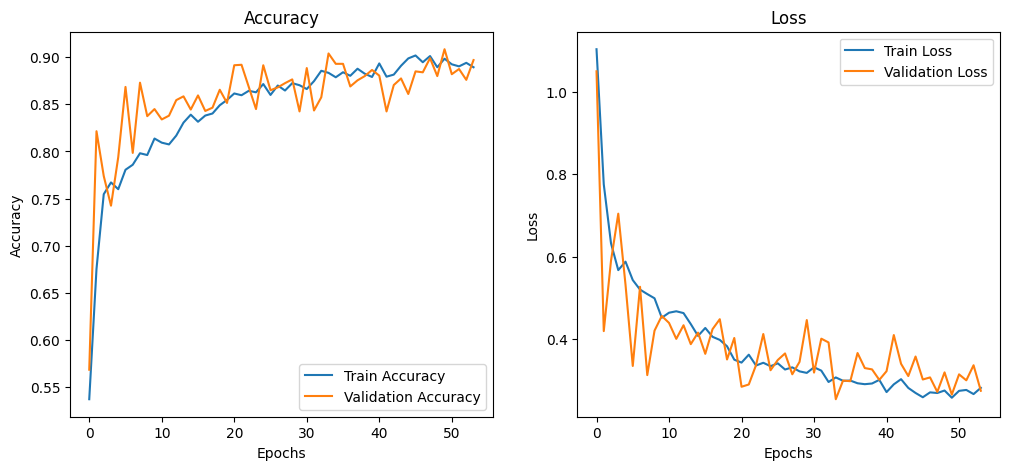

In [10]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
# Guardar el modelo
model.save("resnet50v2_gastro_model.h5")
print("Modelo guardado")

Modelo guardado


In [12]:
# Evaluar en el conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


  1/100 [..............................] - ETA: 7s - loss: 0.0441 - accuracy: 1.0000


  2/100 [..............................] - ETA: 7s - loss: 0.0578 - accuracy: 1.0000


  4/100 [>.............................] - ETA: 4s - loss: 0.0652 - accuracy: 1.0000


  6/100 [>.............................] - ETA: 4s - loss: 0.0693 - accuracy: 1.0000


  8/100 [=>............................] - ETA: 4s - loss: 0.0780 - accuracy: 0.9844


 10/100 [==>...........................] - ETA: 4s - loss: 0.1204 - accuracy: 0.9625


 12/100 [==>...........................] - ETA: 4s - loss: 0.1146 - accuracy: 0.9688


 14/100 [===>..........................] - ETA: 3s - loss: 0.1151 - accuracy: 0.9643


 16/100 [===>..........................] - ETA: 3s - loss: 0.1133 - accuracy: 0.9688


 18/100 [====>.........................] - ETA: 3s - loss: 0.1153 - accuracy: 0.9653


 20/100 [=====>........................] - ETA: 3s - loss: 0.1106 - accuracy: 0.9688


 22/100 [=====>........................] - ETA: 3s - loss: 0.1119 - accuracy: 0.9659


 24/100 [======>.......................] - ETA: 3s - loss: 0.1084 - accuracy: 0.9688


 26/100 [======>.......................] - ETA: 3s - loss: 0.1146 - accuracy: 0.9663


 27/100 [=======>......................] - ETA: 3s - loss: 0.1276 - accuracy: 0.9630


 29/100 [=======>......................] - ETA: 3s - loss: 0.1424 - accuracy: 0.9569


 30/100 [========>.....................] - ETA: 3s - loss: 0.1513 - accuracy: 0.9542


 32/100 [========>.....................] - ETA: 3s - loss: 0.1787 - accuracy: 0.9453


 33/100 [========>.....................] - ETA: 3s - loss: 0.1779 - accuracy: 0.9470


 35/100 [=========>....................] - ETA: 3s - loss: 0.1688 - accuracy: 0.9500


 37/100 [==========>...................] - ETA: 3s - loss: 0.1619 - accuracy: 0.9527


 38/100 [==========>...................] - ETA: 3s - loss: 0.1689 - accuracy: 0.9507


 39/100 [==========>...................] - ETA: 3s - loss: 0.1772 - accuracy: 0.9455


 41/100 [===========>..................] - ETA: 2s - loss: 0.1842 - accuracy: 0.9390


 43/100 [===========>..................] - ETA: 2s - loss: 0.2044 - accuracy: 0.9360


 45/100 [============>.................] - ETA: 2s - loss: 0.2281 - accuracy: 0.9250


 46/100 [============>.................] - ETA: 2s - loss: 0.2271 - accuracy: 0.9266


 48/100 [=============>................] - ETA: 2s - loss: 0.2340 - accuracy: 0.9219


 49/100 [=============>................] - ETA: 2s - loss: 0.2667 - accuracy: 0.9158


 50/100 [==============>...............] - ETA: 2s - loss: 0.2636 - accuracy: 0.9175


 51/100 [==============>...............] - ETA: 2s - loss: 0.2612 - accuracy: 0.9191


 53/100 [==============>...............] - ETA: 2s - loss: 0.2678 - accuracy: 0.9175


 54/100 [===============>..............] - ETA: 2s - loss: 0.2703 - accuracy: 0.9167


 55/100 [===============>..............] - ETA: 2s - loss: 0.2794 - accuracy: 0.9136


 57/100 [================>.............] - ETA: 2s - loss: 0.2818 - accuracy: 0.9101


 59/100 [================>.............] - ETA: 2s - loss: 0.2729 - accuracy: 0.9131


 61/100 [=================>............] - ETA: 2s - loss: 0.2689 - accuracy: 0.9139


 63/100 [=================>............] - ETA: 1s - loss: 0.2739 - accuracy: 0.9127


 64/100 [==================>...........] - ETA: 1s - loss: 0.2716 - accuracy: 0.9141


 65/100 [==================>...........] - ETA: 1s - loss: 0.2732 - accuracy: 0.9135


 67/100 [===================>..........] - ETA: 1s - loss: 0.2867 - accuracy: 0.9067


 69/100 [===================>..........] - ETA: 1s - loss: 0.2927 - accuracy: 0.9040


 70/100 [====================>.........] - ETA: 1s - loss: 0.2962 - accuracy: 0.9018


 71/100 [====================>.........] - ETA: 1s - loss: 0.3048 - accuracy: 0.9014


 73/100 [====================>.........] - ETA: 1s - loss: 0.2996 - accuracy: 0.9024


 74/100 [=====================>........] - ETA: 1s - loss: 0.3044 - accuracy: 0.9003


 76/100 [=====================>........] - ETA: 1s - loss: 0.2983 - accuracy: 0.9030


 77/100 [======================>.......] - ETA: 1s - loss: 0.2945 - accuracy: 0.9042


 78/100 [======================>.......] - ETA: 1s - loss: 0.2907 - accuracy: 0.9054


 79/100 [======================>.......] - ETA: 1s - loss: 0.2870 - accuracy: 0.9066


 80/100 [=======================>......] - ETA: 1s - loss: 0.2834 - accuracy: 0.9078


 81/100 [=======================>......] - ETA: 1s - loss: 0.2800 - accuracy: 0.9090


 82/100 [=======================>......] - ETA: 1s - loss: 0.2766 - accuracy: 0.9101


 83/100 [=======================>......] - ETA: 1s - loss: 0.2733 - accuracy: 0.9111


 84/100 [========================>.....] - ETA: 0s - loss: 0.2700 - accuracy: 0.9122


 85/100 [========================>.....] - ETA: 0s - loss: 0.2670 - accuracy: 0.9132


 86/100 [========================>.....] - ETA: 0s - loss: 0.2639 - accuracy: 0.9142


 87/100 [=========================>....] - ETA: 0s - loss: 0.2608 - accuracy: 0.9152


 88/100 [=========================>....] - ETA: 0s - loss: 0.2579 - accuracy: 0.9162


 89/100 [=========================>....] - ETA: 0s - loss: 0.2550 - accuracy: 0.9171


 90/100 [==========================>...] - ETA: 0s - loss: 0.2522 - accuracy: 0.9181


 91/100 [==========================>...] - ETA: 0s - loss: 0.2494 - accuracy: 0.9190


 92/100 [==========================>...] - ETA: 0s - loss: 0.2467 - accuracy: 0.9198


 93/100 [==========================>...] - ETA: 0s - loss: 0.2440 - accuracy: 0.9207


 94/100 [===========================>..] - ETA: 0s - loss: 0.2414 - accuracy: 0.9215


 95/100 [===========================>..] - ETA: 0s - loss: 0.2389 - accuracy: 0.9224


 96/100 [===========================>..] - ETA: 0s - loss: 0.2364 - accuracy: 0.9232


 97/100 [============================>.] - ETA: 0s - loss: 0.2340 - accuracy: 0.9240


 98/100 [============================>.] - ETA: 0s - loss: 0.2316 - accuracy: 0.9247


 99/100 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9255


100/100 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9262


100/100 [==============================] - 7s 69ms/step - loss: 0.2270 - accuracy: 0.9262


Test Accuracy: 92.62%



  1/250 [..............................] - ETA: 19s - loss: 0.4127 - accuracy: 0.7500


  4/250 [..............................] - ETA: 6s - loss: 0.1583 - accuracy: 0.9375 


  7/250 [..............................] - ETA: 5s - loss: 0.1333 - accuracy: 0.9464


 10/250 [>.............................] - ETA: 5s - loss: 0.1537 - accuracy: 0.9375


 13/250 [>.............................] - ETA: 5s - loss: 0.1410 - accuracy: 0.9423


 17/250 [=>............................] - ETA: 5s - loss: 0.1339 - accuracy: 0.9412


 18/250 [=>............................] - ETA: 5s - loss: 0.1423 - accuracy: 0.9306


 22/250 [=>............................] - ETA: 5s - loss: 0.1472 - accuracy: 0.9318


 26/250 [==>...........................] - ETA: 4s - loss: 0.1388 - accuracy: 0.9375


 29/250 [==>...........................] - ETA: 4s - loss: 0.1481 - accuracy: 0.9310


 33/250 [==>...........................] - ETA: 4s - loss: 0.1369 - accuracy: 0.9356


 36/250 [===>..........................] - ETA: 4s - loss: 0.1470 - accuracy: 0.9306


 40/250 [===>..........................] - ETA: 4s - loss: 0.1577 - accuracy: 0.9312


 44/250 [====>.........................] - ETA: 4s - loss: 0.1519 - accuracy: 0.9347


 48/250 [====>.........................] - ETA: 3s - loss: 0.1474 - accuracy: 0.9401


 52/250 [=====>........................] - ETA: 3s - loss: 0.1607 - accuracy: 0.9327


 56/250 [=====>........................] - ETA: 3s - loss: 0.1622 - accuracy: 0.9308


 60/250 [======>.......................] - ETA: 3s - loss: 0.1640 - accuracy: 0.9292


 63/250 [======>.......................] - ETA: 3s - loss: 0.1580 - accuracy: 0.9325


 66/250 [======>.......................] - ETA: 3s - loss: 0.1636 - accuracy: 0.9280


 68/250 [=======>......................] - ETA: 3s - loss: 0.1900 - accuracy: 0.9191


 71/250 [=======>......................] - ETA: 3s - loss: 0.1940 - accuracy: 0.9137


 73/250 [=======>......................] - ETA: 3s - loss: 0.2011 - accuracy: 0.9092


 75/250 [========>.....................] - ETA: 3s - loss: 0.2070 - accuracy: 0.9083


 78/250 [========>.....................] - ETA: 3s - loss: 0.2135 - accuracy: 0.9054


 80/250 [========>.....................] - ETA: 3s - loss: 0.2177 - accuracy: 0.9031


 83/250 [========>.....................] - ETA: 3s - loss: 0.2201 - accuracy: 0.9006


 85/250 [=========>....................] - ETA: 3s - loss: 0.2220 - accuracy: 0.9000


 88/250 [=========>....................] - ETA: 3s - loss: 0.2267 - accuracy: 0.8977


 91/250 [=========>....................] - ETA: 3s - loss: 0.2331 - accuracy: 0.8942


 93/250 [==========>...................] - ETA: 3s - loss: 0.2481 - accuracy: 0.8898


 96/250 [==========>...................] - ETA: 3s - loss: 0.2562 - accuracy: 0.8841


 98/250 [==========>...................] - ETA: 3s - loss: 0.2598 - accuracy: 0.8839


101/250 [===========>..................] - ETA: 3s - loss: 0.2632 - accuracy: 0.8812


104/250 [===========>..................] - ETA: 3s - loss: 0.2682 - accuracy: 0.8798


106/250 [===========>..................] - ETA: 3s - loss: 0.2688 - accuracy: 0.8797


108/250 [===========>..................] - ETA: 3s - loss: 0.2697 - accuracy: 0.8808


111/250 [============>.................] - ETA: 3s - loss: 0.2725 - accuracy: 0.8806


113/250 [============>.................] - ETA: 3s - loss: 0.2726 - accuracy: 0.8805


115/250 [============>.................] - ETA: 3s - loss: 0.2737 - accuracy: 0.8804


117/250 [=============>................] - ETA: 3s - loss: 0.2762 - accuracy: 0.8803


120/250 [=============>................] - ETA: 3s - loss: 0.2733 - accuracy: 0.8823


123/250 [=============>................] - ETA: 3s - loss: 0.2792 - accuracy: 0.8811


125/250 [==============>...............] - ETA: 3s - loss: 0.2810 - accuracy: 0.8810


128/250 [==============>...............] - ETA: 3s - loss: 0.2818 - accuracy: 0.8809


130/250 [==============>...............] - ETA: 2s - loss: 0.2833 - accuracy: 0.8798


132/250 [==============>...............] - ETA: 2s - loss: 0.2830 - accuracy: 0.8797


134/250 [===============>..............] - ETA: 2s - loss: 0.2876 - accuracy: 0.8778


137/250 [===============>..............] - ETA: 2s - loss: 0.2901 - accuracy: 0.8768


139/250 [===============>..............] - ETA: 2s - loss: 0.2903 - accuracy: 0.8768


141/250 [===============>..............] - ETA: 2s - loss: 0.2981 - accuracy: 0.8759


143/250 [================>.............] - ETA: 2s - loss: 0.3039 - accuracy: 0.8750


146/250 [================>.............] - ETA: 2s - loss: 0.3059 - accuracy: 0.8759


148/250 [================>.............] - ETA: 2s - loss: 0.3061 - accuracy: 0.8742


151/250 [=================>............] - ETA: 2s - loss: 0.3059 - accuracy: 0.8750


153/250 [=================>............] - ETA: 2s - loss: 0.3043 - accuracy: 0.8758


156/250 [=================>............] - ETA: 2s - loss: 0.3052 - accuracy: 0.8750


159/250 [==================>...........] - ETA: 2s - loss: 0.3029 - accuracy: 0.8758


161/250 [==================>...........] - ETA: 2s - loss: 0.3132 - accuracy: 0.8750


164/250 [==================>...........] - ETA: 2s - loss: 0.3122 - accuracy: 0.8750


166/250 [==================>...........] - ETA: 2s - loss: 0.3176 - accuracy: 0.8742


168/250 [===================>..........] - ETA: 2s - loss: 0.3190 - accuracy: 0.8743


170/250 [===================>..........] - ETA: 2s - loss: 0.3388 - accuracy: 0.8721


173/250 [===================>..........] - ETA: 2s - loss: 0.3393 - accuracy: 0.8728


175/250 [====================>.........] - ETA: 1s - loss: 0.3413 - accuracy: 0.8721


178/250 [====================>.........] - ETA: 1s - loss: 0.3395 - accuracy: 0.8729


180/250 [====================>.........] - ETA: 1s - loss: 0.3388 - accuracy: 0.8736


182/250 [====================>.........] - ETA: 1s - loss: 0.3378 - accuracy: 0.8736


185/250 [=====================>........] - ETA: 1s - loss: 0.3373 - accuracy: 0.8730


187/250 [=====================>........] - ETA: 1s - loss: 0.3369 - accuracy: 0.8730


189/250 [=====================>........] - ETA: 1s - loss: 0.3344 - accuracy: 0.8737


190/250 [=====================>........] - ETA: 1s - loss: 0.3327 - accuracy: 0.8743


191/250 [=====================>........] - ETA: 1s - loss: 0.3309 - accuracy: 0.8750


192/250 [======================>.......] - ETA: 1s - loss: 0.3292 - accuracy: 0.8757


193/250 [======================>.......] - ETA: 1s - loss: 0.3275 - accuracy: 0.8763


194/250 [======================>.......] - ETA: 1s - loss: 0.3258 - accuracy: 0.8769


195/250 [======================>.......] - ETA: 1s - loss: 0.3242 - accuracy: 0.8776


196/250 [======================>.......] - ETA: 1s - loss: 0.3225 - accuracy: 0.8782


197/250 [======================>.......] - ETA: 1s - loss: 0.3209 - accuracy: 0.8788


198/250 [======================>.......] - ETA: 1s - loss: 0.3192 - accuracy: 0.8794


199/250 [======================>.......] - ETA: 1s - loss: 0.3176 - accuracy: 0.8800


200/250 [=======================>......] - ETA: 1s - loss: 0.3161 - accuracy: 0.8806


201/250 [=======================>......] - ETA: 1s - loss: 0.3145 - accuracy: 0.8812


202/250 [=======================>......] - ETA: 1s - loss: 0.3129 - accuracy: 0.8818


203/250 [=======================>......] - ETA: 1s - loss: 0.3114 - accuracy: 0.8824


204/250 [=======================>......] - ETA: 1s - loss: 0.3099 - accuracy: 0.8830


205/250 [=======================>......] - ETA: 1s - loss: 0.3084 - accuracy: 0.8835


206/250 [=======================>......] - ETA: 1s - loss: 0.3069 - accuracy: 0.8841


207/250 [=======================>......] - ETA: 1s - loss: 0.3055 - accuracy: 0.8847


208/250 [=======================>......] - ETA: 1s - loss: 0.3040 - accuracy: 0.8852


209/250 [========================>.....] - ETA: 1s - loss: 0.3026 - accuracy: 0.8858


210/250 [========================>.....] - ETA: 1s - loss: 0.3011 - accuracy: 0.8863


211/250 [========================>.....] - ETA: 1s - loss: 0.2998 - accuracy: 0.8868


212/250 [========================>.....] - ETA: 1s - loss: 0.2985 - accuracy: 0.8874


213/250 [========================>.....] - ETA: 1s - loss: 0.2971 - accuracy: 0.8879


214/250 [========================>.....] - ETA: 1s - loss: 0.2957 - accuracy: 0.8884


215/250 [========================>.....] - ETA: 1s - loss: 0.2943 - accuracy: 0.8890


216/250 [========================>.....] - ETA: 1s - loss: 0.2938 - accuracy: 0.8889


217/250 [=========================>....] - ETA: 1s - loss: 0.2924 - accuracy: 0.8894


218/250 [=========================>....] - ETA: 1s - loss: 0.2911 - accuracy: 0.8899


219/250 [=========================>....] - ETA: 1s - loss: 0.2898 - accuracy: 0.8904


220/250 [=========================>....] - ETA: 1s - loss: 0.2884 - accuracy: 0.8909


221/250 [=========================>....] - ETA: 1s - loss: 0.2871 - accuracy: 0.8914


222/250 [=========================>....] - ETA: 0s - loss: 0.2858 - accuracy: 0.8919


223/250 [=========================>....] - ETA: 0s - loss: 0.2846 - accuracy: 0.8924


224/250 [=========================>....] - ETA: 0s - loss: 0.2833 - accuracy: 0.8929


225/250 [==========================>...] - ETA: 0s - loss: 0.2821 - accuracy: 0.8933


226/250 [==========================>...] - ETA: 0s - loss: 0.2808 - accuracy: 0.8938


227/250 [==========================>...] - ETA: 0s - loss: 0.2796 - accuracy: 0.8943


228/250 [==========================>...] - ETA: 0s - loss: 0.2785 - accuracy: 0.8947


229/250 [==========================>...] - ETA: 0s - loss: 0.2772 - accuracy: 0.8952


230/250 [==========================>...] - ETA: 0s - loss: 0.2760 - accuracy: 0.8957


231/250 [==========================>...] - ETA: 0s - loss: 0.2752 - accuracy: 0.8961


232/250 [==========================>...] - ETA: 0s - loss: 0.2740 - accuracy: 0.8966


233/250 [==========================>...] - ETA: 0s - loss: 0.2729 - accuracy: 0.8970


234/250 [===========================>..] - ETA: 0s - loss: 0.2717 - accuracy: 0.8974


235/250 [===========================>..] - ETA: 0s - loss: 0.2705 - accuracy: 0.8979


236/250 [===========================>..] - ETA: 0s - loss: 0.2694 - accuracy: 0.8983


237/250 [===========================>..] - ETA: 0s - loss: 0.2683 - accuracy: 0.8987


238/250 [===========================>..] - ETA: 0s - loss: 0.2671 - accuracy: 0.8992


239/250 [===========================>..] - ETA: 0s - loss: 0.2660 - accuracy: 0.8996


240/250 [===========================>..] - ETA: 0s - loss: 0.2649 - accuracy: 0.9000


241/250 [===========================>..] - ETA: 0s - loss: 0.2638 - accuracy: 0.9004


242/250 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.9008


243/250 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.9012


244/250 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.9016


245/250 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.9020


246/250 [============================>.] - ETA: 0s - loss: 0.2585 - accuracy: 0.9024


247/250 [============================>.] - ETA: 0s - loss: 0.2576 - accuracy: 0.9028


248/250 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.9032


249/250 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.9036


250/250 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9040


250/250 [==============================] - 10s 40ms/step - loss: 0.2546 - accuracy: 0.9040


Validation Accuracy: 90.40%


In [13]:
# Cargar el modelo guardado y probarlo
test_model = keras.models.load_model("resnet50v2_gastro_model.h5")

In [14]:
# Obtener predicciones para validación
y_true_val = val_generator.classes
y_pred_val = np.argmax(test_model.predict(val_generator), axis=1)

# Obtener predicciones para test
y_true_test = test_generator.classes
y_pred_test = np.argmax(test_model.predict(test_generator), axis=1)

# Reporte de clasificación para validación
print("\nValidation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

# Reporte de clasificación para test
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_generator.class_indices.keys()))


  1/250 [..............................] - ETA: 1:13


  4/250 [..............................] - ETA: 5s  


  6/250 [..............................] - ETA: 6s


  9/250 [>.............................] - ETA: 5s


 13/250 [>.............................] - ETA: 4s


 16/250 [>.............................] - ETA: 4s


 20/250 [=>............................] - ETA: 4s


 24/250 [=>............................] - ETA: 4s


 28/250 [==>...........................] - ETA: 4s


 32/250 [==>...........................] - ETA: 3s


 36/250 [===>..........................] - ETA: 3s


 39/250 [===>..........................] - ETA: 3s


 43/250 [====>.........................] - ETA: 3s


 47/250 [====>.........................] - ETA: 3s


 51/250 [=====>........................] - ETA: 3s


 55/250 [=====>........................] - ETA: 3s


 58/250 [=====>........................] - ETA: 3s


 62/250 [======>.......................] - ETA: 3s


 65/250 [======>.......................] - ETA: 3s


 68/250 [=======>......................] - ETA: 3s


 71/250 [=======>......................] - ETA: 3s


 74/250 [=======>......................] - ETA: 3s


 76/250 [========>.....................] - ETA: 3s


 78/250 [========>.....................] - ETA: 3s


 81/250 [========>.....................] - ETA: 3s


 84/250 [=========>....................] - ETA: 3s


 86/250 [=========>....................] - ETA: 3s


 89/250 [=========>....................] - ETA: 3s


 91/250 [=========>....................] - ETA: 3s


 93/250 [==========>...................] - ETA: 3s


 96/250 [==========>...................] - ETA: 3s


 98/250 [==========>...................] - ETA: 3s


101/250 [===========>..................] - ETA: 3s


104/250 [===========>..................] - ETA: 3s


106/250 [===========>..................] - ETA: 3s


109/250 [============>.................] - ETA: 3s


110/250 [============>.................] - ETA: 3s


112/250 [============>.................] - ETA: 3s


115/250 [============>.................] - ETA: 3s


117/250 [=============>................] - ETA: 3s


119/250 [=============>................] - ETA: 3s


121/250 [=============>................] - ETA: 3s


123/250 [=============>................] - ETA: 2s


126/250 [==============>...............] - ETA: 2s


129/250 [==============>...............] - ETA: 2s


132/250 [==============>...............] - ETA: 2s


134/250 [===============>..............] - ETA: 2s


137/250 [===============>..............] - ETA: 2s


140/250 [===============>..............] - ETA: 2s


142/250 [================>.............] - ETA: 2s


144/250 [================>.............] - ETA: 2s


146/250 [================>.............] - ETA: 2s


149/250 [================>.............] - ETA: 2s


152/250 [=================>............] - ETA: 2s


155/250 [=================>............] - ETA: 2s


158/250 [=================>............] - ETA: 2s


160/250 [==================>...........] - ETA: 2s


163/250 [==================>...........] - ETA: 2s


166/250 [==================>...........] - ETA: 2s


168/250 [===================>..........] - ETA: 2s


170/250 [===================>..........] - ETA: 2s


172/250 [===================>..........] - ETA: 1s


175/250 [====================>.........] - ETA: 1s


177/250 [====================>.........] - ETA: 1s


179/250 [====================>.........] - ETA: 1s


181/250 [====================>.........] - ETA: 1s


184/250 [=====================>........] - ETA: 1s


186/250 [=====================>........] - ETA: 1s


188/250 [=====================>........] - ETA: 1s


189/250 [=====================>........] - ETA: 1s


190/250 [=====================>........] - ETA: 1s


191/250 [=====================>........] - ETA: 1s


192/250 [======================>.......] - ETA: 1s


193/250 [======================>.......] - ETA: 1s


194/250 [======================>.......] - ETA: 1s


195/250 [======================>.......] - ETA: 1s


196/250 [======================>.......] - ETA: 1s


197/250 [======================>.......] - ETA: 1s


198/250 [======================>.......] - ETA: 1s


199/250 [======================>.......] - ETA: 1s


200/250 [=======================>......] - ETA: 1s


201/250 [=======================>......] - ETA: 1s


202/250 [=======================>......] - ETA: 1s


203/250 [=======================>......] - ETA: 1s


204/250 [=======================>......] - ETA: 1s


205/250 [=======================>......] - ETA: 1s


206/250 [=======================>......] - ETA: 1s


207/250 [=======================>......] - ETA: 1s


208/250 [=======================>......] - ETA: 1s


209/250 [========================>.....] - ETA: 1s


210/250 [========================>.....] - ETA: 1s


211/250 [========================>.....] - ETA: 1s


212/250 [========================>.....] - ETA: 1s


213/250 [========================>.....] - ETA: 1s


214/250 [========================>.....] - ETA: 1s


215/250 [========================>.....] - ETA: 1s


216/250 [========================>.....] - ETA: 1s


217/250 [=========================>....] - ETA: 1s


218/250 [=========================>....] - ETA: 1s


219/250 [=========================>....] - ETA: 1s


220/250 [=========================>....] - ETA: 0s


221/250 [=========================>....] - ETA: 0s


222/250 [=========================>....] - ETA: 0s


223/250 [=========================>....] - ETA: 0s


224/250 [=========================>....] - ETA: 0s


225/250 [==========================>...] - ETA: 0s


226/250 [==========================>...] - ETA: 0s


227/250 [==========================>...] - ETA: 0s


228/250 [==========================>...] - ETA: 0s


229/250 [==========================>...] - ETA: 0s


230/250 [==========================>...] - ETA: 0s


231/250 [==========================>...] - ETA: 0s


232/250 [==========================>...] - ETA: 0s


233/250 [==========================>...] - ETA: 0s


234/250 [===========================>..] - ETA: 0s


235/250 [===========================>..] - ETA: 0s


236/250 [===========================>..] - ETA: 0s


237/250 [===========================>..] - ETA: 0s


238/250 [===========================>..] - ETA: 0s


239/250 [===========================>..] - ETA: 0s


240/250 [===========================>..] - ETA: 0s


241/250 [===========================>..] - ETA: 0s


242/250 [============================>.] - ETA: 0s


243/250 [============================>.] - ETA: 0s


244/250 [============================>.] - ETA: 0s


245/250 [============================>.] - ETA: 0s


246/250 [============================>.] - ETA: 0s


247/250 [============================>.] - ETA: 0s


248/250 [============================>.] - ETA: 0s


249/250 [============================>.] - ETA: 0s


250/250 [==============================] - ETA: 0s


250/250 [==============================] - 10s 38ms/step



  1/100 [..............................] - ETA: 4s


  4/100 [>.............................] - ETA: 2s


  5/100 [>.............................] - ETA: 2s


  8/100 [=>............................] - ETA: 2s


 12/100 [==>...........................] - ETA: 2s


 15/100 [===>..........................] - ETA: 1s


 19/100 [====>.........................] - ETA: 1s


 22/100 [=====>........................] - ETA: 1s


 26/100 [======>.......................] - ETA: 1s


 28/100 [=======>......................] - ETA: 1s


 30/100 [========>.....................] - ETA: 1s


 32/100 [========>.....................] - ETA: 1s


 34/100 [=========>....................] - ETA: 1s


 37/100 [==========>...................] - ETA: 1s


 39/100 [==========>...................] - ETA: 1s


 41/100 [===========>..................] - ETA: 1s


 43/100 [===========>..................] - ETA: 1s


 46/100 [============>.................] - ETA: 1s


 48/100 [=============>................] - ETA: 1s


 49/100 [=============>................] - ETA: 1s


 50/100 [==============>...............] - ETA: 1s


 53/100 [==============>...............] - ETA: 1s


 55/100 [===============>..............] - ETA: 1s


 58/100 [================>.............] - ETA: 1s


 61/100 [=================>............] - ETA: 1s


 63/100 [=================>............] - ETA: 1s


 65/100 [==================>...........] - ETA: 0s


 67/100 [===================>..........] - ETA: 0s


 69/100 [===================>..........] - ETA: 0s


 71/100 [====================>.........] - ETA: 0s


 74/100 [=====================>........] - ETA: 0s


 76/100 [=====================>........] - ETA: 0s


 77/100 [======================>.......] - ETA: 0s


 78/100 [======================>.......] - ETA: 0s


 79/100 [======================>.......] - ETA: 0s


 80/100 [=======================>......] - ETA: 0s


 81/100 [=======================>......] - ETA: 0s


 82/100 [=======================>......] - ETA: 0s


 83/100 [=======================>......] - ETA: 0s


 84/100 [========================>.....] - ETA: 0s


 85/100 [========================>.....] - ETA: 0s


 86/100 [========================>.....] - ETA: 0s


 87/100 [=========================>....] - ETA: 0s


 88/100 [=========================>....] - ETA: 0s


 89/100 [=========================>....] - ETA: 0s


 90/100 [==========================>...] - ETA: 0s


 91/100 [==========================>...] - ETA: 0s


 92/100 [==========================>...] - ETA: 0s


 93/100 [==========================>...] - ETA: 0s


 94/100 [===========================>..] - ETA: 0s


 95/100 [===========================>..] - ETA: 0s


 96/100 [===========================>..] - ETA: 0s


 97/100 [============================>.] - ETA: 0s


 98/100 [============================>.] - ETA: 0s


 99/100 [============================>.] - ETA: 0s


100/100 [==============================] - ETA: 0s


100/100 [==============================] - 4s 41ms/step



Validation Classification Report:


                      precision    recall  f1-score   support

            0_normal       1.00      0.93      0.96       500
1_ulcerative_colitis       0.85      0.83      0.84       500
            2_polyps       0.82      0.86      0.84       500
       3_esophagitis       0.95      1.00      0.97       500

            accuracy                           0.90      2000
           macro avg       0.91      0.90      0.90      2000
        weighted avg       0.91      0.90      0.90      2000


Test Classification Report:
                      precision    recall  f1-score   support

            0_normal       1.00      0.97      0.98       200
1_ulcerative_colitis       0.87      0.86      0.87       200
            2_polyps       0.87      0.87      0.87       200
       3_esophagitis       0.96      1.00      0.98       200

            accuracy                           0.93       800
           macro avg       0.93      0.93      0.93       800
        weighted avg       0.93     

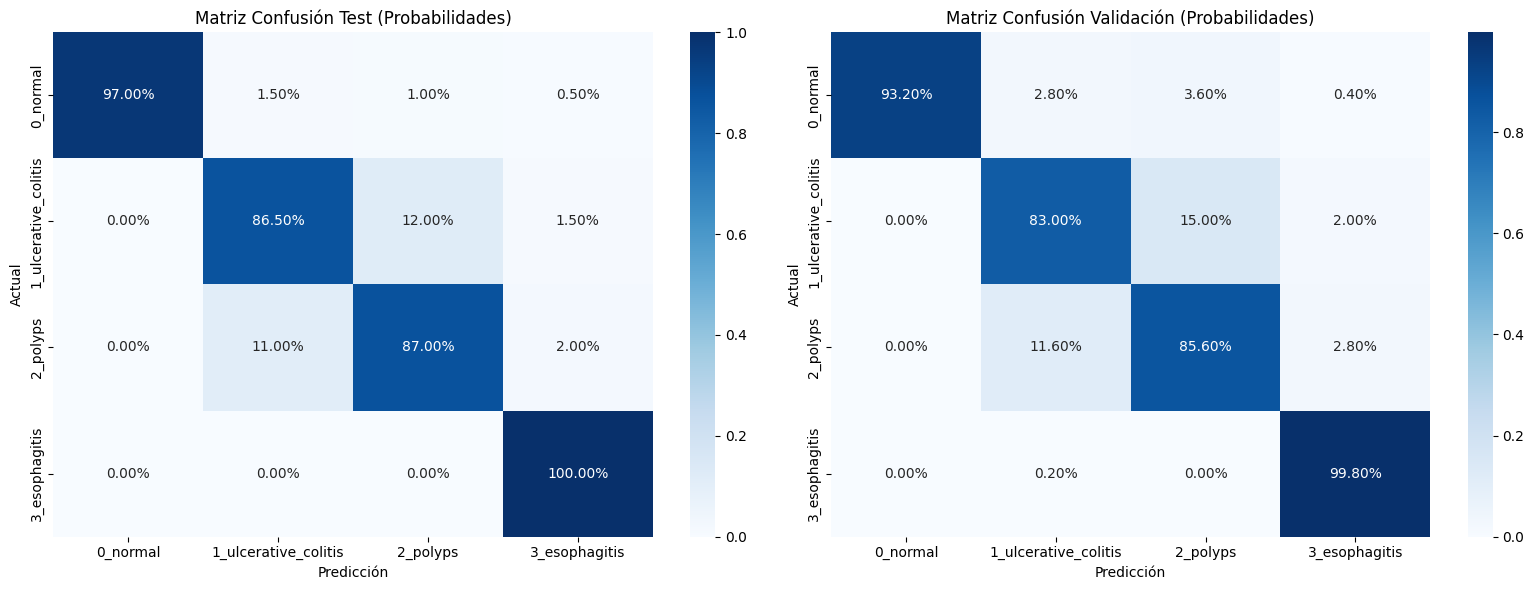

In [15]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matriz de confusión para el conjunto de test
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_test_prob = confusion_matrix_prob(cm_test)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Test (Probabilidades)')

# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_val_prob = confusion_matrix_prob(cm_val)
plt.subplot(1, 2, 2)
sns.heatmap(cm_val_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Validación (Probabilidades)')

plt.tight_layout()
plt.show()